# Compute Features from *.parquet Track Files

## General Settings

In [1]:
# For loading, manipulating and visualising data in tables
import pandas as pd
# For Operating System commands
import os
# For high-level file operations
import shutil
# For doing math
import numpy as np
# For making plots and graphical visualisations
import matplotlib.pyplot as plt
# For airspeed conversions (true/calibrated/equivalent/Mach) from here: https://pypi.org/project/flightcondition/
#from flightcondition import FlightCondition, unit
# For Flight phase identification from here: https://openap.dev/flight_phases.html
#from openap.phase import FlightPhase
# For progress bar
from tqdm import tqdm

In [2]:
g0 = 9.80665    # m/s^2
ft2m = 0.3048   # =1ft
kt2m_s = 1852 / 3600 # 1kt=1sm/1h = 1000m/3600s

## User Settings

In [3]:
# Local path to (capied and/or cleaned) *.parquet files
#strPqtLocPath = 'local_parquet_clean_old'
#dt = 30 #s
strPqtLocPath = 'local_parquet_clean'
dt = 10 #s

# Local path to *.csv files
strLocPath = 'local_files'

## Import *_set.csv

In [4]:
#df = pd.read_csv(os.path.join(strLocPath,"challenge_set.csv"))
#df = pd.read_csv(os.path.join(strLocPath,"submission_set.csv"))
df = pd.read_csv(os.path.join(strLocPath,"final_submission_set.csv"))

In [5]:
df

,flight_id,date,callsign,adep,name_adep,country_code_adep,ades,name_ades,country_code_ades,actual_offblock_time,arrival_time,aircraft_type,wtc,airline,flight_duration,taxiout_time,flown_distance,tow
0,248753821,2022-01-01,3b3de0f3ad0ee192513995c02f7bf7cf,LTFJ,Istanbul Sabiha Gokcen,TR,LFLL,Lyon,FR,2022-01-01T09:44:00Z,2022-01-01T12:48:33Z,B738,M,6351ec1b849adacc0cbb3b1313d8d39b,170,15,1122,NaN
1,248753822,2022-01-01,e06dd03d4a879ca37d9e18c1bd7cad16,EBBR,Brussels,BE,KJFK,New York JFK,US,2022-01-01T09:45:00Z,2022-01-01T17:49:51Z,A333,H,bdeeef3a675587d530de70a25d7118d2,470,15,3205,NaN
2,248754498,2022-01-01,2d3b1c962c78c4ebeef11bcd51b9e94c,KMIA,Miami,US,EGLL,London Heathrow,GB,2022-01-01T01:52:00Z,2022-01-01T09:55:16Z,B77W,H,5543e4dc327359ffaf5b9c0e6faaf0e1,473,10,3965,NaN
3,248763650,2022-01-01,35f7721f68bf85128195547ae38b0f04,EBBR,Brussels,BE,LEAL,Alicante,ES,2022-01-01T12:02:00Z,2022-01-01T14:13:56Z,B738,M,f53c55b5cf0cbb3be755bf50df6fa52d,123,9,802,NaN
4,248763651,2022-01-01,eb56918bee9bc5204624186b9bcc4391,LSZH,Zurich,CH,LFPG,Paris Charles de Gaulle,FR,2022-01-01T12:03:00Z,2022-01-01T13:09:44Z,BCS3,M,2d5def0a5a844b343ba1b7cc9cb28fa9,56,11,292,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158144,258068876,2022-12-31,c9fca302ca2e28acab0eb0bb1b46f11b,LTFM,iGA Istanbul,TR,LSZH,Zurich,CH,2022-12-31T09:25:00Z,2022-12-31T12:24:24Z,A321,M,6351ec1b849adacc0cbb3b1313d8d39b,154,25,988,NaN
158145,258064675,2022-12-31,00f96ad0e382476649574ba044c764fc,EHAM,Amsterdam,NL,EDDF,Frankfurt,DE,2022-12-31T10:04:21Z,2022-12-31T10:55:35Z,A320,M,f502877cab405652cf0dd70c2213e730,42,9,240,NaN
158146,258065436,2022-12-31,87c552b7f6d9bbd16a66e95df761c7f2,LEBL,Barcelona,ES,KJFK,New York JFK,US,2022-12-31T09:34:00Z,2022-12-31T17:51:22Z,B772,H,5543e4dc327359ffaf5b9c0e6faaf0e1,483,14,3426,NaN
158147,258058138,2022-12-31,2cd57e434494606c965bac87c024bda2,LIPE,Bologna,IT,LOWW,Vienna,AT,2022-12-31T09:37:00Z,2022-12-31T10:47:00Z,E195,M,5d407cb11cc29578cc3e292e743f5393,55,15,335,NaN


## Loop over lines in *_set.csv to extact features from respective *.parquet file

In [6]:
df_all_feat = pd.DataFrame()
prev_flight_date = ''

#flight_id_sel = 254631910 # '254611296' # high TOW; # '254631910' # low TOW on same route 'EGLL EIDW' on same day 2022-08-22
#flight_id_sel = 254636038 # '254636038' # mid TOW on reverse route 'EIDW EGLL' on same day 2022-08-22
#flight_id_sel = 254946876 # flight Miami to Barcelona with first part of climb and then interpolation to end of cruise

#df = df[df['flight_id'] == flight_id_sel]

for index, row in tqdm(df.iterrows()):
    flight_id_sel = row["flight_id"]
    flight_date = row['date']
    actual_offblock_time = row['actual_offblock_time']
    arrival_time = row['arrival_time']
    taxiout_time = row['taxiout_time']

    # Assemble *.parquet file and path names
    strFile = flight_date + '.parquet'
    strLocFullFile = os.path.join(strPqtLocPath, strFile)

    if not os.path.isfile(strLocFullFile):
        print('Skipping not available *.parquet: ' + strLocFullFile)
        continue
        
    # pd.read_parquet() is used to load parquet files
    if flight_date != prev_flight_date:
        # load only needed in case date has changed
        df_parquet = pd.read_parquet(strLocFullFile)
        prev_flight_date = flight_date 

    # Exrtact selected flight
    df_parquet_sel = df_parquet[df_parquet['flight_id']==flight_id_sel] #(notice the == sign sets the condition)
    
    # keep only assumed in-flight part - see hints given here: https://ansperformance.eu/study/data-challenge/data.html
    df_parquet_sel = df_parquet_sel[df_parquet_sel['timestamp'] > (pd.Timestamp(actual_offblock_time) + pd.Timedelta(taxiout_time, "min"))]
    df_parquet_sel = df_parquet_sel[df_parquet_sel['timestamp'] < arrival_time]

    df_parquet_sel = df_parquet_sel[df_parquet_sel['groundspeed'] > 200] # IMPORTANT: to ensure A/C is flying and remove altitude jumps at take-off
    
    df_parquet_sel = df_parquet_sel.reset_index(drop = True)
    
    if len(df_parquet_sel.index) == 0:
        print('Skipping flight_id = ' + str(flight_id_sel) + ' with no in-flight track in *.parquet: ' + strLocFullFile)
        continue

    ### 
    data = {
        "flight_id":   [flight_id_sel]
    }
    #load data into a DataFrame object:
    df_feat = pd.DataFrame(data)

    if df_parquet_sel['altitude'].max() < 10001 or pd.isnull(df_parquet_sel['altitude']).all():
        print('Skipping flight_id = ' + str(flight_id_sel) + ' with no valid altitude above 10000ft! ')
        continue
        
    #### Crossing FL50 = 5'000ft 
    # Find first altitude above 5'000ft
    idx_df_FL50 = df_parquet_sel[df_parquet_sel['altitude'].ge(5000)].index[0]
    df_FL50 = df_parquet_sel.iloc[idx_df_FL50]

    if idx_df_FL50 > 0:
        data = {
            "flight_id":         [flight_id_sel],                           # 
            "CL_FL50_start":     [df_FL50["timestamp"]],                    # timestamp of start
            "CL_FL50_alt":       [df_FL50["altitude"].round(1)]             # altitude
        }
        
        #Join data into DataFrame object
        df_feat = df_feat.join(pd.DataFrame(data).set_index('flight_id'), on='flight_id')
        
    #### Crossing FL100 = 10'000ft 
    # Find first altitude above 10'000ft
    idx_df_FL100 = df_parquet_sel[df_parquet_sel['altitude'].ge(10000)].index[0]
    df_FL100 = df_parquet_sel.iloc[idx_df_FL100]

    if idx_df_FL100 > 0:
        data = {
            "flight_id":         [flight_id_sel],                           # 
            "CL_FL100_start":    [df_FL100["timestamp"]],                   # timestamp of start
            "CL_FL100_alt":      [df_FL100["altitude"].round(1)]            # altitude
        }
        
        #Join data into DataFrame object
        df_feat = df_feat.join(pd.DataFrame(data).set_index('flight_id'), on='flight_id')

    #### Rate-of-climb computation in segements
    if idx_df_FL50 > 0 and idx_df_FL100 > 0 and \
        (idx_df_FL100-idx_df_FL50) > 1 and \
        df_FL100['timestamp'] <df_parquet_sel['timestamp'].iloc[df_parquet_sel['altitude'].idxmax()]:
        if df_feat["CL_FL100_start"].array != df_feat["CL_FL50_start"].array:
            # rate-of-climb from FL100 to FL200, ft/min
            ROC_FL50to100 = (df_feat["CL_FL100_alt"].array-df_feat["CL_FL50_alt"].array) / ((df_feat["CL_FL100_start"].array-df_feat["CL_FL50_start"].array).total_seconds()/60)

            # Atmos computation
            df_CL = df_parquet_sel.iloc[idx_df_FL50:idx_df_FL100]
            df_CL = df_CL.reset_index(drop = True)
            
            # Compute and add relative longitudinal_wind from U_wind & V_wind (see ERA5 definition: 
            # https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels?tab=overview) 
            # ⇒ head-wind: <0; tail-wind: >0; converted from m/s to kt
            df_CL["longi_wind"] = (df_CL['track'].apply(np.deg2rad).apply(np.cos) * df_CL['v_component_of_wind'] + df_CL['track'].apply(np.deg2rad).apply(np.sin) * df_CL['u_component_of_wind'])*3600/1852
            
            # Compute and TAS = true airspeed = GS - longitudinal_wind
            df_CL["TAS"] = df_CL['groundspeed'] - df_CL["longi_wind"]

            ## Specific energy rate: change of speed, ROC
            # https://enac.hal.science/hal-01002401/document
            # https://ntrs.nasa.gov/api/citations/20230014062/downloads/TMPI_DASC23_AidaRohani.pdf
            df_CL['dTAS'] = df_CL['TAS'].diff() * kt2m_s / dt # m/s^2
            df_CL['dHp'] = df_CL['altitude'].diff() * ft2m / dt # m/s
            df_CL['Q'] = df_CL['TAS'] * kt2m_s * df_CL['dTAS'] + g0 * df_CL['dHp'] # m^2/s^3

            df_CL['d_track'] = df_CL['track_unwrapped'].diff()
            
            # average CAS between FL50 and FL100, kt 
            TAS_avg = df_CL["TAS"].mean()

            # average temperature
            Temp_avg = df_CL["temperature"].mean()

            data = {
                "flight_id":         [flight_id_sel],                  # 
                "ROC_FL50to100":     np.round(ROC_FL50to100),         # rate-of-climb from FL100 to FL200, ft/min
                "TAS_FL50to100":     np.round(TAS_avg,1),              # average TAS between FL100 and FL200, kt 
                "Temp_FL50to100":    np.round(Temp_avg,2),             # average Temperature between FL100 and FL200, K
                "Q_FL50":            np.round(df_CL['Q'].iloc[1],2), 
                "Q_FL100a":          np.round(df_CL['Q'].iloc[-1],2),
                "Q_mFL50to100":      np.round(df_CL['Q'].median(),2),
                "TAS_FL50":          np.round(df_CL['TAS'].iloc[1],2), 
                "TAS_FL100a":        np.round(df_CL['TAS'].iloc[-1],2),
                "TAS_mFL50to100":    np.round(df_CL['TAS'].median(),2),
                "dHp_FL50":          np.round(df_CL['dHp'].iloc[1],2), 
                "dHp_FL100a":        np.round(df_CL['dHp'].iloc[-1],2),
                "dHp_mFL50to100" :   np.round(df_CL['dHp'].median(),2),
                "cs_d_track_50to100": np.round(df_CL['d_track'].abs().sum(),2),
            }
            
            #Join data into DataFrame object
            df_feat = df_feat.join(pd.DataFrame(data).set_index('flight_id'), on='flight_id')
    
    if df_parquet_sel['altitude'].max() < 20001 or pd.isnull(df_parquet_sel['altitude']).all():
        print('Skipping flight_id = ' + str(flight_id_sel) + ' with no valid altitude above 20000ft! ')
        continue
        
    #### Crossing FL200 = 20'000ft 
    # Find first altitude above 20'000ft
    idx_df_FL200 = df_parquet_sel[df_parquet_sel['altitude'].ge(20000)].index[0]
    df_FL200 = df_parquet_sel.iloc[idx_df_FL200]

    if idx_df_FL200 > 0:
        data = {
            "flight_id":         [flight_id_sel],                           # 
            "CL_FL200_start":    [df_FL200["timestamp"]],                   # timestamp of start
            "CL_FL200_alt":      [df_FL200["altitude"].round(1)]            # altitude
        }
        
        #Join data into DataFrame object
        df_feat = df_feat.join(pd.DataFrame(data).set_index('flight_id'), on='flight_id')
    
    #### Rate-of-climb computation in segements
    if idx_df_FL100 > 0 and idx_df_FL200 > 0 and \
        (idx_df_FL200-idx_df_FL100) > 1 and \
        df_FL200['timestamp'] <df_parquet_sel['timestamp'].iloc[df_parquet_sel['altitude'].idxmax()]:
        if df_feat["CL_FL200_start"].array != df_feat["CL_FL100_start"].array:
            # rate-of-climb from FL100 to FL200, ft/min
            ROC_FL100to200 = (df_feat["CL_FL200_alt"].array-df_feat["CL_FL100_alt"].array) / ((df_feat["CL_FL200_start"].array-df_feat["CL_FL100_start"].array).total_seconds()/60)

            # Atmos computation
            df_CL = df_parquet_sel.iloc[idx_df_FL100:idx_df_FL200]
            df_CL = df_CL.reset_index(drop = True)
            
            # Compute and add relative longitudinal_wind from U_wind & V_wind (see ERA5 definition: 
            # https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels?tab=overview) 
            # ⇒ head-wind: <0; tail-wind: >0; converted from m/s to kt
            df_CL["longi_wind"] = (df_CL['track'].apply(np.deg2rad).apply(np.cos) * df_CL['v_component_of_wind'] + df_CL['track'].apply(np.deg2rad).apply(np.sin) * df_CL['u_component_of_wind'])*3600/1852
            
            # Compute and TAS = true airspeed = GS - longitudinal_wind
            df_CL["TAS"] = df_CL['groundspeed'] - df_CL["longi_wind"]

            ## Specific energy rate: change of speed, ROC
            # https://enac.hal.science/hal-01002401/document
            # https://ntrs.nasa.gov/api/citations/20230014062/downloads/TMPI_DASC23_AidaRohani.pdf
            df_CL['dTAS'] = df_CL['TAS'].diff() * kt2m_s / dt # m/s^2
            df_CL['dHp'] = df_CL['altitude'].diff() * ft2m / dt # m/s
            df_CL['Q'] = df_CL['TAS'] * kt2m_s * df_CL['dTAS'] + g0 * df_CL['dHp'] # m^2/s^3

            df_CL['d_track'] = df_CL['track_unwrapped'].diff()
            
            # average CAS between FL100 and FL200, kt 
            TAS_avg = df_CL["TAS"].mean()

            # average temperature
            Temp_avg = df_CL["temperature"].mean()

            data = {
                "flight_id":         [flight_id_sel],                  # 
                "ROC_FL100to200":    np.round(ROC_FL100to200),         # rate-of-climb from FL100 to FL200, ft/min
                "TAS_FL100to200":    np.round(TAS_avg,1),              # average TAS between FL100 and FL200, kt 
                "Temp_FL100to200":   np.round(Temp_avg,2),             # average Temperature between FL100 and FL200, K
                "Q_FL100":           np.round(df_CL['Q'].iloc[1],2), 
                "Q_FL200":           np.round(df_CL['Q'].iloc[-1],2),
                "Q_mFL100to200":     np.round(df_CL['Q'].median(),2),
                "TAS_FL100":         np.round(df_CL['TAS'].iloc[1],2), 
                "TAS_FL200":         np.round(df_CL['TAS'].iloc[-1],2),
                "TAS_mFL100to200":   np.round(df_CL['TAS'].median(),2),
                "dHp_FL100":         np.round(df_CL['dHp'].iloc[1],2), 
                "dHp_FL200":         np.round(df_CL['dHp'].iloc[-1],2),
                "dHp_mFL100to200":   np.round(df_CL['dHp'].median(),2),
                "cs_d_track":        np.round(df_CL['d_track'].abs().sum(),2),
            }
            
            #Join data into DataFrame object
            df_feat = df_feat.join(pd.DataFrame(data).set_index('flight_id'), on='flight_id')
        
    ## Append features of current flight to dataframe of all flight
    df_all_feat = pd.concat([df_all_feat, df_feat], ignore_index=True)

21it [00:00, 44.82it/s]

Skipping flight_id = 248754909 with no valid altitude above 20000ft! 
Skipping flight_id = 248763792 with no valid altitude above 20000ft! 
Skipping flight_id = 248762986 with no valid altitude above 10000ft! 


55it [00:01, 54.03it/s]

Skipping flight_id = 248751996 with no valid altitude above 20000ft! 
Skipping flight_id = 248755344 with no valid altitude above 20000ft! 


94it [00:01, 61.63it/s]

Skipping flight_id = 248752312 with no valid altitude above 10000ft! 
Skipping flight_id = 248751339 with no valid altitude above 20000ft! 
Skipping flight_id = 248761940 with no in-flight track in *.parquet: local_parquet_clean\2022-01-01.parquet


115it [00:02, 57.59it/s]

Skipping flight_id = 248762592 with no valid altitude above 20000ft! 


133it [00:02, 52.16it/s]

Skipping flight_id = 248756669 with no valid altitude above 20000ft! 


145it [00:02, 50.64it/s]

Skipping flight_id = 248765240 with no valid altitude above 20000ft! 


171it [00:03, 44.12it/s]

Skipping flight_id = 248760306 with no valid altitude above 10000ft! 
Skipping flight_id = 248759893 with no valid altitude above 20000ft! 


181it [00:03, 42.51it/s]

Skipping flight_id = 248756982 with no valid altitude above 20000ft! 


201it [00:04, 51.58it/s]

Skipping flight_id = 248756344 with no valid altitude above 20000ft! 
Skipping flight_id = 248753608 with no valid altitude above 20000ft! 


215it [00:04, 53.64it/s]

Skipping flight_id = 248757601 with no valid altitude above 20000ft! 


247it [00:04, 56.18it/s]

Skipping flight_id = 248755048 with no valid altitude above 20000ft! 


272it [00:05, 53.73it/s]

Skipping flight_id = 248773090 with no valid altitude above 20000ft! 
Skipping flight_id = 248782942 with no in-flight track in *.parquet: local_parquet_clean\2022-01-02.parquet
Skipping flight_id = 248788165 with no valid altitude above 20000ft! 


291it [00:05, 54.65it/s]

Skipping flight_id = 248770400 with no valid altitude above 20000ft! 
Skipping flight_id = 248783827 with no valid altitude above 20000ft! 


315it [00:06, 54.11it/s]

Skipping flight_id = 248775320 with no valid altitude above 20000ft! 


345it [00:06, 53.02it/s]

Skipping flight_id = 248783444 with no valid altitude above 10000ft! 
Skipping flight_id = 248783257 with no valid altitude above 20000ft! 


358it [00:06, 57.42it/s]

Skipping flight_id = 248775540 with no valid altitude above 20000ft! 
Skipping flight_id = 248775911 with no valid altitude above 20000ft! 
Skipping flight_id = 248777326 with no valid altitude above 20000ft! 


375it [00:07, 65.70it/s]

Skipping flight_id = 248780180 with no valid altitude above 20000ft! 
Skipping flight_id = 248781324 with no valid altitude above 20000ft! 
Skipping flight_id = 248782024 with no valid altitude above 20000ft! 
Skipping flight_id = 248767842 with no valid altitude above 10000ft! 
Skipping flight_id = 248769852 with no valid altitude above 20000ft! 
Skipping flight_id = 248766419 with no valid altitude above 20000ft! 


397it [00:07, 60.79it/s]

Skipping flight_id = 248779300 with no valid altitude above 10000ft! 
Skipping flight_id = 248783718 with no valid altitude above 20000ft! 
Skipping flight_id = 248768797 with no valid altitude above 20000ft! 


419it [00:07, 57.98it/s]

Skipping flight_id = 248777782 with no valid altitude above 20000ft! 
Skipping flight_id = 248782065 with no in-flight track in *.parquet: local_parquet_clean\2022-01-02.parquet


435it [00:08, 64.35it/s]

Skipping flight_id = 248768376 with no valid altitude above 20000ft! 
Skipping flight_id = 248777567 with no in-flight track in *.parquet: local_parquet_clean\2022-01-02.parquet


451it [00:08, 68.11it/s]

Skipping flight_id = 248782452 with no valid altitude above 20000ft! 
Skipping flight_id = 248781849 with no in-flight track in *.parquet: local_parquet_clean\2022-01-02.parquet
Skipping flight_id = 248781811 with no valid altitude above 20000ft! 
Skipping flight_id = 248781858 with no in-flight track in *.parquet: local_parquet_clean\2022-01-02.parquet
Skipping flight_id = 248781801 with no valid altitude above 20000ft! 


466it [00:08, 66.34it/s]

Skipping flight_id = 248788053 with no valid altitude above 20000ft! 
Skipping flight_id = 248767908 with no valid altitude above 20000ft! 
Skipping flight_id = 248773508 with no valid altitude above 20000ft! 


495it [00:09, 66.76it/s]

Skipping flight_id = 248782173 with no valid altitude above 20000ft! 
Skipping flight_id = 248768244 with no valid altitude above 20000ft! 
Skipping flight_id = 248766924 with no valid altitude above 20000ft! 
Skipping flight_id = 248784904 with no valid altitude above 10000ft! 
Skipping flight_id = 248766382 with no valid altitude above 20000ft! 


519it [00:09, 68.18it/s]

Skipping flight_id = 248787501 with no valid altitude above 20000ft! 
Skipping flight_id = 248769115 with no valid altitude above 20000ft! 
Skipping flight_id = 248785333 with no valid altitude above 10000ft! 
Skipping flight_id = 248766782 with no valid altitude above 20000ft! 


549it [00:09, 62.95it/s]

Skipping flight_id = 248773425 with no valid altitude above 20000ft! 


563it [00:10, 62.05it/s]

Skipping flight_id = 248767639 with no valid altitude above 20000ft! 
Skipping flight_id = 248771289 with no valid altitude above 20000ft! 
Skipping flight_id = 248786076 with no valid altitude above 20000ft! 


584it [00:10, 61.65it/s]

Skipping flight_id = 248781799 with no valid altitude above 20000ft! 
Skipping flight_id = 248766367 with no valid altitude above 20000ft! 
Skipping flight_id = 248770174 with no valid altitude above 20000ft! 


607it [00:10, 63.53it/s]

Skipping flight_id = 248772965 with no valid altitude above 20000ft! 
Skipping flight_id = 248769522 with no valid altitude above 20000ft! 


623it [00:11, 64.44it/s]

Skipping flight_id = 248771219 with no valid altitude above 20000ft! 
Skipping flight_id = 248769240 with no valid altitude above 20000ft! 
Skipping flight_id = 248786011 with no valid altitude above 20000ft! 
Skipping flight_id = 248775873 with no valid altitude above 20000ft! 


650it [00:11, 57.31it/s]

Skipping flight_id = 248780493 with no valid altitude above 20000ft! 
Skipping flight_id = 248769675 with no valid altitude above 20000ft! 
Skipping flight_id = 248776168 with no valid altitude above 20000ft! 
Skipping flight_id = 248769710 with no valid altitude above 10000ft! 


664it [00:11, 59.69it/s]

Skipping flight_id = 248770976 with no in-flight track in *.parquet: local_parquet_clean\2022-01-02.parquet


676it [00:12, 53.24it/s]

Skipping flight_id = 248796864 with no valid altitude above 20000ft! 
Skipping flight_id = 248790199 with no in-flight track in *.parquet: local_parquet_clean\2022-01-03.parquet


708it [00:12, 58.83it/s]

Skipping flight_id = 248805782 with no valid altitude above 20000ft! 
Skipping flight_id = 248805791 with no valid altitude above 20000ft! 
Skipping flight_id = 248795996 with no valid altitude above 20000ft! 


746it [00:13, 59.07it/s]

Skipping flight_id = 248790011 with no valid altitude above 20000ft! 


761it [00:13, 60.20it/s]

Skipping flight_id = 248797346 with no valid altitude above 10000ft! 
Skipping flight_id = 248799494 with no valid altitude above 20000ft! 
Skipping flight_id = 248802580 with no valid altitude above 20000ft! 


783it [00:13, 63.65it/s]

Skipping flight_id = 248806606 with no valid altitude above 20000ft! 
Skipping flight_id = 248797009 with no valid altitude above 20000ft! 
Skipping flight_id = 248806918 with no valid altitude above 20000ft! 


799it [00:14, 64.83it/s]

Skipping flight_id = 248803930 with no valid altitude above 20000ft! 
Skipping flight_id = 248804378 with no valid altitude above 20000ft! 
Skipping flight_id = 248801448 with no valid altitude above 20000ft! 


814it [00:14, 64.06it/s]

Skipping flight_id = 248790542 with no in-flight track in *.parquet: local_parquet_clean\2022-01-03.parquet


829it [00:14, 59.50it/s]

Skipping flight_id = 248805281 with no valid altitude above 20000ft! 
Skipping flight_id = 248808591 with no valid altitude above 20000ft! 


845it [00:14, 61.67it/s]

Skipping flight_id = 248802801 with no valid altitude above 10000ft! 
Skipping flight_id = 248807023 with no valid altitude above 20000ft! 
Skipping flight_id = 248801035 with no valid altitude above 20000ft! 


867it [00:15, 61.16it/s]

Skipping flight_id = 248801054 with no valid altitude above 10000ft! 
Skipping flight_id = 248803994 with no valid altitude above 20000ft! 


874it [00:15, 63.16it/s]

Skipping flight_id = 248794262 with no valid altitude above 20000ft! 


911it [00:16, 49.44it/s]

Skipping flight_id = 248799320 with no in-flight track in *.parquet: local_parquet_clean\2022-01-04.parquet


931it [00:16, 57.99it/s]

Skipping flight_id = 248792823 with no valid altitude above 10000ft! 
Skipping flight_id = 248806286 with no valid altitude above 20000ft! 
Skipping flight_id = 248793932 with no valid altitude above 20000ft! 


967it [00:17, 55.56it/s]

Skipping flight_id = 248797353 with no valid altitude above 10000ft! 


991it [00:17, 53.63it/s]

Skipping flight_id = 248797222 with no valid altitude above 20000ft! 


1011it [00:17, 56.25it/s]

Skipping flight_id = 248804052 with no in-flight track in *.parquet: local_parquet_clean\2022-01-03.parquet


1025it [00:18, 59.15it/s]

Skipping flight_id = 248792428 with no valid altitude above 20000ft! 


1046it [00:18, 60.18it/s]

Skipping flight_id = 248795788 with no valid altitude above 20000ft! 
Skipping flight_id = 248798400 with no valid altitude above 20000ft! 
Skipping flight_id = 248793282 with no valid altitude above 20000ft! 


1059it [00:18, 58.51it/s]

Skipping flight_id = 248823403 with no valid altitude above 20000ft! 


1073it [00:18, 54.54it/s]

Skipping flight_id = 248825154 with no valid altitude above 20000ft! 


1086it [00:19, 55.23it/s]

Skipping flight_id = 248818208 with no valid altitude above 20000ft! 
Skipping flight_id = 248821769 with no valid altitude above 20000ft! 
Skipping flight_id = 248815844 with no valid altitude above 20000ft! 
Skipping flight_id = 248829249 with no valid altitude above 20000ft! 
Skipping flight_id = 248821425 with no valid altitude above 20000ft! 


1093it [00:19, 57.24it/s]

Skipping flight_id = 248821777 with no valid altitude above 20000ft! 
Skipping flight_id = 248817811 with no valid altitude above 20000ft! 


1119it [00:19, 55.71it/s]

Skipping flight_id = 248812989 with no valid altitude above 10000ft! 


1150it [00:20, 53.43it/s]

Skipping flight_id = 248816259 with no valid altitude above 20000ft! 
Skipping flight_id = 248810723 with no valid altitude above 20000ft! 


1170it [00:20, 56.99it/s]

Skipping flight_id = 248810628 with no valid altitude above 20000ft! 
Skipping flight_id = 248810694 with no in-flight track in *.parquet: local_parquet_clean\2022-01-04.parquet


1211it [00:21, 59.39it/s]

Skipping flight_id = 248819853 with no valid altitude above 20000ft! 
Skipping flight_id = 248819319 with no in-flight track in *.parquet: local_parquet_clean\2022-01-04.parquet
Skipping flight_id = 248813997 with no valid altitude above 20000ft! 


1224it [00:21, 58.24it/s]

Skipping flight_id = 248822231 with no valid altitude above 20000ft! 
Skipping flight_id = 248815445 with no valid altitude above 20000ft! 


1244it [00:21, 59.74it/s]

Skipping flight_id = 248813117 with no valid altitude above 20000ft! 
Skipping flight_id = 248821465 with no valid altitude above 20000ft! 
Skipping flight_id = 248814785 with no valid altitude above 20000ft! 
Skipping flight_id = 248827597 with no valid altitude above 20000ft! 


1258it [00:22, 58.32it/s]

Skipping flight_id = 248820490 with no valid altitude above 20000ft! 
Skipping flight_id = 248818657 with no valid altitude above 20000ft! 


1295it [00:22, 58.78it/s]

Skipping flight_id = 248815178 with no valid altitude above 20000ft! 


1326it [00:23, 58.26it/s]

Skipping flight_id = 248826500 with no valid altitude above 20000ft! 
Skipping flight_id = 248821734 with no valid altitude above 20000ft! 
Skipping flight_id = 248826391 with no valid altitude above 10000ft! 


1348it [00:23, 59.83it/s]

Skipping flight_id = 248823151 with no valid altitude above 20000ft! 


1368it [00:24, 57.12it/s]

Skipping flight_id = 248831944 with no valid altitude above 20000ft! 


1383it [00:24, 59.48it/s]

Skipping flight_id = 248834784 with no in-flight track in *.parquet: local_parquet_clean\2022-01-05.parquet


1390it [00:24, 60.08it/s]

Skipping flight_id = 248848296 with no valid altitude above 20000ft! 
Skipping flight_id = 248846447 with no valid altitude above 20000ft! 


1429it [00:25, 58.62it/s]

Skipping flight_id = 248830431 with no valid altitude above 10000ft! 
Skipping flight_id = 248838596 with no valid altitude above 20000ft! 


1468it [00:25, 59.79it/s]

Skipping flight_id = 248832473 with no valid altitude above 20000ft! 
Skipping flight_id = 248830016 with no valid altitude above 20000ft! 
Skipping flight_id = 248829877 with no in-flight track in *.parquet: local_parquet_clean\2022-01-05.parquet
Skipping flight_id = 248830412 with no valid altitude above 20000ft! 


1494it [00:26, 58.20it/s]

Skipping flight_id = 248831112 with no valid altitude above 20000ft! 
Skipping flight_id = 248841650 with no valid altitude above 20000ft! 
Skipping flight_id = 248841826 with no valid altitude above 10000ft! 
Skipping flight_id = 248832753 with no valid altitude above 10000ft! 
Skipping flight_id = 248829613 with no valid altitude above 20000ft! 


1536it [00:26, 53.22it/s]

Skipping flight_id = 248846377 with no valid altitude above 20000ft! 


1544it [00:27, 59.32it/s]

Skipping flight_id = 248833348 with no valid altitude above 20000ft! 
Skipping flight_id = 248843595 with no in-flight track in *.parquet: local_parquet_clean\2022-01-05.parquet
Skipping flight_id = 248847325 with no valid altitude above 10000ft! 


1569it [00:27, 65.40it/s]

Skipping flight_id = 248844300 with no valid altitude above 20000ft! 
Skipping flight_id = 248839619 with no valid altitude above 20000ft! 
Skipping flight_id = 248844628 with no valid altitude above 20000ft! 


1617it [00:28, 57.52it/s]

Skipping flight_id = 248846778 with no valid altitude above 20000ft! 
Skipping flight_id = 248839560 with no valid altitude above 20000ft! 


1636it [00:28, 56.88it/s]

Skipping flight_id = 248832172 with no in-flight track in *.parquet: local_parquet_clean\2022-01-05.parquet
Skipping flight_id = 248853998 with no valid altitude above 20000ft! 


1649it [00:28, 55.62it/s]

Skipping flight_id = 248853964 with no valid altitude above 20000ft! 
Skipping flight_id = 248867445 with no in-flight track in *.parquet: local_parquet_clean\2022-01-06.parquet


1669it [00:29, 56.87it/s]

Skipping flight_id = 248856358 with no valid altitude above 20000ft! 
Skipping flight_id = 248856121 with no valid altitude above 20000ft! 


1695it [00:29, 58.17it/s]

Skipping flight_id = 248852796 with no valid altitude above 20000ft! 


1717it [00:29, 64.99it/s]

Skipping flight_id = 248850240 with no valid altitude above 10000ft! 
Skipping flight_id = 248861414 with no valid altitude above 20000ft! 


1731it [00:30, 61.70it/s]

Skipping flight_id = 248854376 with no valid altitude above 20000ft! 
Skipping flight_id = 248852651 with no valid altitude above 10000ft! 
Skipping flight_id = 248864155 with no valid altitude above 20000ft! 


1772it [00:30, 62.48it/s]

Skipping flight_id = 248857582 with no valid altitude above 10000ft! 
Skipping flight_id = 248848618 with no in-flight track in *.parquet: local_parquet_clean\2022-01-06.parquet
Skipping flight_id = 248853745 with no valid altitude above 20000ft! 
Skipping flight_id = 248851229 with no valid altitude above 20000ft! 


1801it [00:31, 63.38it/s]

Skipping flight_id = 248851060 with no in-flight track in *.parquet: local_parquet_clean\2022-01-06.parquet
Skipping flight_id = 248848745 with no valid altitude above 20000ft! 
Skipping flight_id = 248864015 with no valid altitude above 20000ft! 
Skipping flight_id = 248864658 with no valid altitude above 20000ft! 


1846it [00:32, 55.88it/s]

Skipping flight_id = 248859500 with no valid altitude above 20000ft! 


1868it [00:32, 58.81it/s]

Skipping flight_id = 248858297 with no valid altitude above 10000ft! 


1888it [00:32, 59.37it/s]

Skipping flight_id = 248864746 with no valid altitude above 10000ft! 
Skipping flight_id = 248851886 with no valid altitude above 20000ft! 


1902it [00:33, 61.44it/s]

Skipping flight_id = 248860801 with no valid altitude above 20000ft! 
Skipping flight_id = 248865919 with no valid altitude above 10000ft! 


1916it [00:33, 60.60it/s]

Skipping flight_id = 248861208 with no valid altitude above 20000ft! 
Skipping flight_id = 248851925 with no valid altitude above 20000ft! 


1930it [00:33, 58.95it/s]

Skipping flight_id = 248866034 with no valid altitude above 20000ft! 


1944it [00:33, 61.45it/s]

Skipping flight_id = 248859908 with no valid altitude above 20000ft! 
Skipping flight_id = 248859151 with no valid altitude above 10000ft! 
Skipping flight_id = 248859227 with no valid altitude above 10000ft! 


1958it [00:34, 59.35it/s]

Skipping flight_id = 248857923 with no valid altitude above 10000ft! 
Skipping flight_id = 248882398 with no valid altitude above 20000ft! 


1994it [00:34, 61.61it/s]

Skipping flight_id = 248884264 with no valid altitude above 20000ft! 
Skipping flight_id = 248870376 with no valid altitude above 10000ft! 
Skipping flight_id = 248877614 with no valid altitude above 10000ft! 


2009it [00:34, 64.52it/s]

Skipping flight_id = 248885262 with no in-flight track in *.parquet: local_parquet_clean\2022-01-07.parquet
Skipping flight_id = 248869917 with no valid altitude above 20000ft! 
Skipping flight_id = 248877092 with no valid altitude above 20000ft! 
Skipping flight_id = 248868630 with no valid altitude above 20000ft! 


2037it [00:35, 62.05it/s]

Skipping flight_id = 248869926 with no valid altitude above 20000ft! 
Skipping flight_id = 248885885 with no valid altitude above 20000ft! 


2051it [00:35, 64.13it/s]

Skipping flight_id = 248870807 with no valid altitude above 20000ft! 
Skipping flight_id = 248885176 with no in-flight track in *.parquet: local_parquet_clean\2022-01-07.parquet
Skipping flight_id = 248879993 with no valid altitude above 20000ft! 
Skipping flight_id = 248875915 with no valid altitude above 20000ft! 


2065it [00:35, 60.58it/s]

Skipping flight_id = 248872203 with no in-flight track in *.parquet: local_parquet_clean\2022-01-07.parquet


2091it [00:36, 57.71it/s]

Skipping flight_id = 248868510 with no valid altitude above 20000ft! 


2110it [00:36, 58.55it/s]

Skipping flight_id = 248879373 with no in-flight track in *.parquet: local_parquet_clean\2022-01-07.parquet
Skipping flight_id = 248879004 with no valid altitude above 10000ft! 


2119it [00:36, 64.52it/s]

Skipping flight_id = 248879775 with no valid altitude above 10000ft! 
Skipping flight_id = 248868215 with no valid altitude above 10000ft! 
Skipping flight_id = 248879877 with no valid altitude above 20000ft! 


2178it [00:37, 52.70it/s]

Skipping flight_id = 248875056 with no valid altitude above 20000ft! 


2197it [00:38, 56.15it/s]

Skipping flight_id = 248887232 with no valid altitude above 20000ft! 
Skipping flight_id = 248868334 with no valid altitude above 10000ft! 


2217it [00:38, 55.08it/s]

Skipping flight_id = 248874319 with no valid altitude above 20000ft! 


2229it [00:38, 55.84it/s]

Skipping flight_id = 248878866 with no valid altitude above 10000ft! 
Skipping flight_id = 248869605 with no valid altitude above 20000ft! 


2255it [00:39, 59.13it/s]

Skipping flight_id = 248884807 with no valid altitude above 20000ft! 
Skipping flight_id = 248884007 with no valid altitude above 10000ft! 
Skipping flight_id = 248873806 with no valid altitude above 20000ft! 


2285it [00:39, 55.51it/s]

Skipping flight_id = 248874979 with no valid altitude above 20000ft! 
Skipping flight_id = 248881463 with no valid altitude above 20000ft! 


2304it [00:40, 58.65it/s]

Skipping flight_id = 248885857 with no in-flight track in *.parquet: local_parquet_clean\2022-01-07.parquet
Skipping flight_id = 248903067 with no valid altitude above 20000ft! 


2323it [00:40, 50.13it/s]

Skipping flight_id = 248889824 with no valid altitude above 20000ft! 
Skipping flight_id = 248898880 with no valid altitude above 20000ft! 


2354it [00:41, 52.86it/s]

Skipping flight_id = 248897379 with no valid altitude above 20000ft! 


2370it [00:41, 62.21it/s]

Skipping flight_id = 248898467 with no in-flight track in *.parquet: local_parquet_clean\2022-01-08.parquet
Skipping flight_id = 248897647 with no in-flight track in *.parquet: local_parquet_clean\2022-01-08.parquet
Skipping flight_id = 248900571 with no valid altitude above 20000ft! 


2378it [00:41, 64.70it/s]

Skipping flight_id = 248891554 with no valid altitude above 20000ft! 
Skipping flight_id = 248898001 with no valid altitude above 20000ft! 
Skipping flight_id = 248895509 with no in-flight track in *.parquet: local_parquet_clean\2022-01-08.parquet


2401it [00:41, 63.29it/s]

Skipping flight_id = 248904783 with no in-flight track in *.parquet: local_parquet_clean\2022-01-08.parquet
Skipping flight_id = 248906811 with no valid altitude above 20000ft! 
Skipping flight_id = 248892438 with no valid altitude above 20000ft! 
Skipping flight_id = 248895789 with no in-flight track in *.parquet: local_parquet_clean\2022-01-08.parquet


2431it [00:42, 60.98it/s]

Skipping flight_id = 248906457 with no in-flight track in *.parquet: local_parquet_clean\2022-01-08.parquet


2452it [00:42, 61.29it/s]

Skipping flight_id = 248899317 with no valid altitude above 20000ft! 
Skipping flight_id = 248891413 with no valid altitude above 20000ft! 
Skipping flight_id = 248897349 with no valid altitude above 20000ft! 
Skipping flight_id = 248890398 with no valid altitude above 20000ft! 
Skipping flight_id = 248890055 with no valid altitude above 20000ft! 


2474it [00:43, 61.52it/s]

Skipping flight_id = 248891734 with no in-flight track in *.parquet: local_parquet_clean\2022-01-08.parquet


2488it [00:43, 61.78it/s]

Skipping flight_id = 248906304 with no valid altitude above 20000ft! 
Skipping flight_id = 248892490 with no valid altitude above 20000ft! 
Skipping flight_id = 248900416 with no valid altitude above 20000ft! 


2502it [00:43, 62.66it/s]

Skipping flight_id = 248902076 with no valid altitude above 20000ft! 
Skipping flight_id = 248898182 with no valid altitude above 10000ft! 


2516it [00:43, 62.24it/s]

Skipping flight_id = 248900485 with no valid altitude above 20000ft! 


2536it [00:44, 57.25it/s]

Skipping flight_id = 248901221 with no in-flight track in *.parquet: local_parquet_clean\2022-01-08.parquet


2549it [00:44, 56.75it/s]

Skipping flight_id = 248897512 with no valid altitude above 20000ft! 
Skipping flight_id = 248889036 with no valid altitude above 10000ft! 


2569it [00:44, 58.93it/s]

Skipping flight_id = 248905400 with no valid altitude above 20000ft! 
Skipping flight_id = 248902161 with no valid altitude above 20000ft! 


2587it [00:44, 56.19it/s]

Skipping flight_id = 248906648 with no valid altitude above 20000ft! 


2600it [00:45, 58.96it/s]

Skipping flight_id = 248890951 with no valid altitude above 20000ft! 


2619it [00:45, 58.26it/s]

Skipping flight_id = 248894141 with no valid altitude above 20000ft! 


2634it [00:45, 65.35it/s]

Skipping flight_id = 248898278 with no valid altitude above 10000ft! 
Skipping flight_id = 248916754 with no valid altitude above 10000ft! 
Skipping flight_id = 248915808 with no valid altitude above 20000ft! 
Skipping flight_id = 248916403 with no valid altitude above 20000ft! 
Skipping flight_id = 248910416 with no valid altitude above 20000ft! 


2648it [00:45, 62.42it/s]

Skipping flight_id = 248926204 with no valid altitude above 20000ft! 


2673it [00:46, 57.68it/s]

Skipping flight_id = 248917884 with no valid altitude above 20000ft! 
Skipping flight_id = 248907638 with no valid altitude above 20000ft! 


2696it [00:46, 64.34it/s]

Skipping flight_id = 248918235 with no valid altitude above 20000ft! 
Skipping flight_id = 248914158 with no valid altitude above 20000ft! 
Skipping flight_id = 248916546 with no valid altitude above 20000ft! 
Skipping flight_id = 248921321 with no valid altitude above 20000ft! 


2703it [00:46, 65.71it/s]

Skipping flight_id = 248907805 with no valid altitude above 20000ft! 


2744it [00:47, 63.44it/s]

Skipping flight_id = 248923271 with no valid altitude above 20000ft! 


2758it [00:47, 61.06it/s]

Skipping flight_id = 248924984 with no valid altitude above 20000ft! 
Skipping flight_id = 248927493 with no valid altitude above 20000ft! 


2778it [00:48, 58.86it/s]

Skipping flight_id = 248909767 with no valid altitude above 20000ft! 
Skipping flight_id = 248908026 with no valid altitude above 20000ft! 


2825it [00:48, 60.57it/s]

Skipping flight_id = 248926841 with no in-flight track in *.parquet: local_parquet_clean\2022-01-09.parquet
Skipping flight_id = 248923397 with no valid altitude above 10000ft! 


2839it [00:49, 60.44it/s]

Skipping flight_id = 248910019 with no valid altitude above 20000ft! 
Skipping flight_id = 248926855 with no valid altitude above 20000ft! 


2861it [00:49, 60.27it/s]

Skipping flight_id = 248920657 with no in-flight track in *.parquet: local_parquet_clean\2022-01-09.parquet
Skipping flight_id = 248924510 with no valid altitude above 10000ft! 
Skipping flight_id = 248914428 with no valid altitude above 20000ft! 


2913it [00:50, 56.19it/s]

Skipping flight_id = 248916816 with no valid altitude above 10000ft! 
Skipping flight_id = 248923468 with no valid altitude above 20000ft! 
Skipping flight_id = 248919797 with no valid altitude above 20000ft! 


2925it [00:50, 52.44it/s]

Skipping flight_id = 248925979 with no valid altitude above 20000ft! 
Skipping flight_id = 248924252 with no valid altitude above 20000ft! 


2943it [00:51, 49.36it/s]

Skipping flight_id = 248927632 with no in-flight track in *.parquet: local_parquet_clean\2022-01-09.parquet


2976it [00:51, 57.78it/s]

Skipping flight_id = 248924680 with no valid altitude above 10000ft! 


2989it [00:51, 60.07it/s]

Skipping flight_id = 248925147 with no valid altitude above 20000ft! 
Skipping flight_id = 248917492 with no valid altitude above 20000ft! 


3009it [00:52, 57.13it/s]

Skipping flight_id = 248935083 with no valid altitude above 20000ft! 
Skipping flight_id = 248939047 with no valid altitude above 20000ft! 


3041it [00:52, 59.89it/s]

Skipping flight_id = 248930776 with no valid altitude above 20000ft! 
Skipping flight_id = 248933596 with no in-flight track in *.parquet: local_parquet_clean\2022-01-10.parquet


3060it [00:53, 58.27it/s]

Skipping flight_id = 248946102 with no valid altitude above 20000ft! 
Skipping flight_id = 248945698 with no valid altitude above 20000ft! 
Skipping flight_id = 248932648 with no valid altitude above 20000ft! 


3091it [00:53, 58.93it/s]

Skipping flight_id = 248943805 with no valid altitude above 20000ft! 
Skipping flight_id = 248929692 with no valid altitude above 20000ft! 
Skipping flight_id = 248935298 with no valid altitude above 10000ft! 
Skipping flight_id = 248945556 with no valid altitude above 20000ft! 


3150it [00:54, 49.36it/s]

Skipping flight_id = 248936348 with no valid altitude above 10000ft! 


3163it [00:55, 53.75it/s]

Skipping flight_id = 248937189 with no valid altitude above 10000ft! 


3191it [00:55, 57.40it/s]

Skipping flight_id = 248938659 with no valid altitude above 20000ft! 
Skipping flight_id = 248935548 with no valid altitude above 20000ft! 


3204it [00:55, 56.36it/s]

Skipping flight_id = 248934604 with no valid altitude above 10000ft! 
Skipping flight_id = 248942220 with no valid altitude above 20000ft! 
Skipping flight_id = 248945735 with no valid altitude above 20000ft! 


3231it [00:56, 58.04it/s]

Skipping flight_id = 248928073 with no valid altitude above 20000ft! 
Skipping flight_id = 248935660 with no valid altitude above 20000ft! 


3246it [00:56, 61.17it/s]

Skipping flight_id = 248935258 with no valid altitude above 10000ft! 
Skipping flight_id = 248930252 with no valid altitude above 20000ft! 


3292it [00:57, 57.83it/s]

Skipping flight_id = 248928919 with no valid altitude above 10000ft! 


3312it [00:57, 56.55it/s]

Skipping flight_id = 248941353 with no valid altitude above 20000ft! 
Skipping flight_id = 248933422 with no valid altitude above 20000ft! 
Skipping flight_id = 248943076 with no valid altitude above 20000ft! 


3332it [00:57, 56.05it/s]

Skipping flight_id = 248948095 with no valid altitude above 20000ft! 


3344it [00:58, 53.08it/s]

Skipping flight_id = 248953453 with no valid altitude above 20000ft! 


3369it [00:58, 54.75it/s]

Skipping flight_id = 248947255 with no valid altitude above 20000ft! 
Skipping flight_id = 248959878 with no valid altitude above 20000ft! 


3376it [00:58, 56.50it/s]

Skipping flight_id = 248958813 with no valid altitude above 20000ft! 
Skipping flight_id = 248957352 with no valid altitude above 20000ft! 


3390it [00:59, 59.28it/s]

Skipping flight_id = 248949281 with no valid altitude above 20000ft! 
Skipping flight_id = 248952477 with no in-flight track in *.parquet: local_parquet_clean\2022-01-11.parquet


3402it [00:59, 56.24it/s]

Skipping flight_id = 248955039 with no valid altitude above 20000ft! 


3414it [00:59, 51.12it/s]

Skipping flight_id = 248952768 with no valid altitude above 10000ft! 
Skipping flight_id = 248949713 with no valid altitude above 20000ft! 


3434it [00:59, 58.11it/s]

Skipping flight_id = 248950539 with no valid altitude above 20000ft! 
Skipping flight_id = 248951382 with no valid altitude above 20000ft! 


3464it [01:00, 55.28it/s]

Skipping flight_id = 248951872 with no valid altitude above 20000ft! 
Skipping flight_id = 248961470 with no valid altitude above 20000ft! 


3490it [01:00, 55.46it/s]

Skipping flight_id = 248946532 with no valid altitude above 20000ft! 
Skipping flight_id = 248961472 with no in-flight track in *.parquet: local_parquet_clean\2022-01-11.parquet


3516it [01:01, 56.55it/s]

Skipping flight_id = 248954635 with no valid altitude above 20000ft! 
Skipping flight_id = 248960832 with no in-flight track in *.parquet: local_parquet_clean\2022-01-11.parquet


3529it [01:01, 56.63it/s]

Skipping flight_id = 248957939 with no valid altitude above 20000ft! 


3548it [01:01, 56.30it/s]

Skipping flight_id = 248965398 with no valid altitude above 20000ft! 
Skipping flight_id = 248962691 with no valid altitude above 20000ft! 


3573it [01:02, 55.65it/s]

Skipping flight_id = 248968451 with no valid altitude above 20000ft! 


3587it [01:02, 60.78it/s]

Skipping flight_id = 248970910 with no in-flight track in *.parquet: local_parquet_clean\2022-01-12.parquet


3619it [01:03, 55.78it/s]

Skipping flight_id = 248971007 with no valid altitude above 10000ft! 
Skipping flight_id = 248963897 with no valid altitude above 20000ft! 
Skipping flight_id = 248963339 with no valid altitude above 20000ft! 
Skipping flight_id = 248964271 with no valid altitude above 20000ft! 


3633it [01:03, 58.47it/s]

Skipping flight_id = 248967198 with no valid altitude above 20000ft! 


3651it [01:03, 55.02it/s]

Skipping flight_id = 248964649 with no valid altitude above 20000ft! 
Skipping flight_id = 248967285 with no valid altitude above 20000ft! 


3670it [01:04, 55.96it/s]

Skipping flight_id = 248973849 with no valid altitude above 20000ft! 


3693it [01:04, 64.51it/s]

Skipping flight_id = 248962853 with no valid altitude above 20000ft! 
Skipping flight_id = 248966862 with no in-flight track in *.parquet: local_parquet_clean\2022-01-12.parquet
Skipping flight_id = 248966537 with no valid altitude above 20000ft! 


3720it [01:04, 56.65it/s]

Skipping flight_id = 248968763 with no valid altitude above 20000ft! 
Skipping flight_id = 248966455 with no valid altitude above 20000ft! 


3739it [01:05, 57.17it/s]

Skipping flight_id = 248967859 with no valid altitude above 20000ft! 
Skipping flight_id = 248965494 with no valid altitude above 20000ft! 
Skipping flight_id = 248972967 with no valid altitude above 20000ft! 


3759it [01:05, 57.95it/s]

Skipping flight_id = 248978685 with no valid altitude above 20000ft! 
Skipping flight_id = 248962688 with no valid altitude above 20000ft! 


3775it [01:05, 64.55it/s]

Skipping flight_id = 248967944 with no valid altitude above 10000ft! 
Skipping flight_id = 248964296 with no valid altitude above 10000ft! 


3795it [01:06, 57.51it/s]

Skipping flight_id = 248974986 with no valid altitude above 20000ft! 
Skipping flight_id = 248973498 with no valid altitude above 20000ft! 


3813it [01:06, 47.27it/s]

Skipping flight_id = 248976642 with no valid altitude above 20000ft! 
Skipping flight_id = 248978887 with no in-flight track in *.parquet: local_parquet_clean\2022-01-13.parquet


3838it [01:06, 53.60it/s]

Skipping flight_id = 248992893 with no valid altitude above 20000ft! 
Skipping flight_id = 248982904 with no valid altitude above 20000ft! 


3850it [01:07, 54.62it/s]

Skipping flight_id = 248993491 with no valid altitude above 20000ft! 
Skipping flight_id = 248984206 with no valid altitude above 20000ft! 


3869it [01:07, 58.40it/s]

Skipping flight_id = 248979838 with no valid altitude above 20000ft! 
Skipping flight_id = 248983148 with no valid altitude above 20000ft! 


3893it [01:07, 53.26it/s]

Skipping flight_id = 248988593 with no valid altitude above 20000ft! 


3900it [01:08, 54.97it/s]

Skipping flight_id = 248991855 with no valid altitude above 20000ft! 
Skipping flight_id = 248991858 with no in-flight track in *.parquet: local_parquet_clean\2022-01-13.parquet
Skipping flight_id = 248986675 with no valid altitude above 20000ft! 
Skipping flight_id = 248985553 with no valid altitude above 20000ft! 


3920it [01:08, 58.58it/s]

Skipping flight_id = 248987557 with no valid altitude above 20000ft! 
Skipping flight_id = 248987354 with no valid altitude above 20000ft! 
Skipping flight_id = 248995450 with no valid altitude above 20000ft! 


3932it [01:08, 57.62it/s]

Skipping flight_id = 248987365 with no valid altitude above 20000ft! 
Skipping flight_id = 248987877 with no valid altitude above 20000ft! 
Skipping flight_id = 248990537 with no valid altitude above 20000ft! 


3946it [01:08, 56.96it/s]

Skipping flight_id = 248991137 with no valid altitude above 20000ft! 
Skipping flight_id = 248985902 with no valid altitude above 20000ft! 


3959it [01:09, 58.90it/s]

Skipping flight_id = 248982603 with no valid altitude above 20000ft! 
Skipping flight_id = 248992613 with no valid altitude above 20000ft! 
Skipping flight_id = 248994349 with no valid altitude above 20000ft! 


3981it [01:09, 60.43it/s]

Skipping flight_id = 248983906 with no valid altitude above 20000ft! 
Skipping flight_id = 248983417 with no in-flight track in *.parquet: local_parquet_clean\2022-01-13.parquet
Skipping flight_id = 248993884 with no valid altitude above 20000ft! 
Skipping flight_id = 248991556 with no valid altitude above 20000ft! 


4001it [01:09, 57.55it/s]

Skipping flight_id = 248990245 with no valid altitude above 20000ft! 
Skipping flight_id = 248986359 with no valid altitude above 20000ft! 


4014it [01:10, 52.70it/s]

Skipping flight_id = 248982290 with no valid altitude above 20000ft! 
Skipping flight_id = 248992275 with no valid altitude above 20000ft! 


4040it [01:10, 56.78it/s]

Skipping flight_id = 248983440 with no valid altitude above 20000ft! 
Skipping flight_id = 248992993 with no valid altitude above 20000ft! 


4064it [01:10, 57.30it/s]

Skipping flight_id = 248992481 with no valid altitude above 10000ft! 


4095it [01:11, 56.56it/s]

Skipping flight_id = 248994904 with no valid altitude above 20000ft! 
Skipping flight_id = 248985042 with no valid altitude above 20000ft! 


4110it [01:11, 62.64it/s]

Skipping flight_id = 248995083 with no valid altitude above 10000ft! 
Skipping flight_id = 248982391 with no valid altitude above 20000ft! 


4124it [01:11, 58.58it/s]

Skipping flight_id = 249003557 with no valid altitude above 20000ft! 
Skipping flight_id = 249007098 with no valid altitude above 10000ft! 
Skipping flight_id = 249010534 with no valid altitude above 20000ft! 


4138it [01:12, 58.60it/s]

Skipping flight_id = 249010549 with no valid altitude above 20000ft! 
Skipping flight_id = 249011500 with no valid altitude above 10000ft! 
Skipping flight_id = 249004180 with no valid altitude above 20000ft! 


4181it [01:13, 57.54it/s]

Skipping flight_id = 248997858 with no valid altitude above 20000ft! 
Skipping flight_id = 248995768 with no valid altitude above 20000ft! 


4202it [01:13, 58.95it/s]

Skipping flight_id = 249008767 with no valid altitude above 20000ft! 


4209it [01:13, 61.77it/s]

Skipping flight_id = 249006983 with no in-flight track in *.parquet: local_parquet_clean\2022-01-14.parquet
Skipping flight_id = 248999387 with no valid altitude above 20000ft! 
Skipping flight_id = 249005260 with no valid altitude above 20000ft! 


4232it [01:13, 63.50it/s]

Skipping flight_id = 249007243 with no valid altitude above 10000ft! 
Skipping flight_id = 248996250 with no valid altitude above 20000ft! 


4253it [01:14, 60.05it/s]

Skipping flight_id = 249002922 with no valid altitude above 20000ft! 


4268it [01:14, 61.29it/s]

Skipping flight_id = 249013648 with no valid altitude above 10000ft! 
Skipping flight_id = 249013675 with no valid altitude above 20000ft! 
Skipping flight_id = 248997318 with no valid altitude above 20000ft! 


4294it [01:14, 53.15it/s]

Skipping flight_id = 249003058 with no valid altitude above 20000ft! 


4326it [01:15, 58.82it/s]

Skipping flight_id = 249012631 with no valid altitude above 20000ft! 
Skipping flight_id = 249003527 with no valid altitude above 20000ft! 


4346it [01:15, 58.32it/s]

Skipping flight_id = 249013894 with no in-flight track in *.parquet: local_parquet_clean\2022-01-14.parquet


4371it [01:16, 54.75it/s]

Skipping flight_id = 249001480 with no valid altitude above 10000ft! 
Skipping flight_id = 248997548 with no valid altitude above 20000ft! 


4397it [01:16, 54.80it/s]

Skipping flight_id = 249011224 with no valid altitude above 20000ft! 


4409it [01:16, 55.22it/s]

Skipping flight_id = 248998308 with no valid altitude above 20000ft! 
Skipping flight_id = 249023121 with no valid altitude above 20000ft! 


4451it [01:17, 52.91it/s]

Skipping flight_id = 249022653 with no valid altitude above 20000ft! 
Skipping flight_id = 249017285 with no valid altitude above 10000ft! 
Skipping flight_id = 249015956 with no valid altitude above 20000ft! 


4475it [01:18, 65.62it/s]

Skipping flight_id = 249020345 with no valid altitude above 20000ft! 
Skipping flight_id = 249023510 with no in-flight track in *.parquet: local_parquet_clean\2022-01-15.parquet


4495it [01:18, 55.39it/s]

Skipping flight_id = 249028476 with no valid altitude above 20000ft! 


4539it [01:19, 52.31it/s]

Skipping flight_id = 249028962 with no valid altitude above 20000ft! 


4551it [01:19, 52.74it/s]

Skipping flight_id = 249024097 with no valid altitude above 20000ft! 
Skipping flight_id = 249021595 with no valid altitude above 20000ft! 


4577it [01:20, 54.68it/s]

Skipping flight_id = 249026432 with no valid altitude above 20000ft! 


4601it [01:20, 54.65it/s]

Skipping flight_id = 249022602 with no valid altitude above 20000ft! 
Skipping flight_id = 249022362 with no valid altitude above 20000ft! 
Skipping flight_id = 249023406 with no valid altitude above 20000ft! 


4614it [01:20, 56.11it/s]

Skipping flight_id = 249028272 with no valid altitude above 10000ft! 
Skipping flight_id = 249026843 with no valid altitude above 20000ft! 
Skipping flight_id = 249023888 with no valid altitude above 20000ft! 


4636it [01:21, 61.24it/s]

Skipping flight_id = 249022965 with no valid altitude above 10000ft! 
Skipping flight_id = 249017256 with no valid altitude above 20000ft! 
Skipping flight_id = 249017001 with no valid altitude above 20000ft! 


4658it [01:21, 65.47it/s]

Skipping flight_id = 249028273 with no valid altitude above 20000ft! 
Skipping flight_id = 249019446 with no valid altitude above 20000ft! 
Skipping flight_id = 249017565 with no valid altitude above 20000ft! 
Skipping flight_id = 249017949 with no in-flight track in *.parquet: local_parquet_clean\2022-01-15.parquet
Skipping flight_id = 249016791 with no valid altitude above 10000ft! 


4679it [01:21, 56.57it/s]

Skipping flight_id = 249042305 with no valid altitude above 10000ft! 


4711it [01:22, 56.60it/s]

Skipping flight_id = 249030802 with no valid altitude above 10000ft! 
Skipping flight_id = 249037918 with no in-flight track in *.parquet: local_parquet_clean\2022-01-16.parquet


4725it [01:22, 61.96it/s]

Skipping flight_id = 249038630 with no valid altitude above 20000ft! 
Skipping flight_id = 249032298 with no valid altitude above 20000ft! 
Skipping flight_id = 249039171 with no valid altitude above 20000ft! 


4753it [01:23, 59.53it/s]

Skipping flight_id = 249036649 with no valid altitude above 10000ft! 
Skipping flight_id = 249038666 with no valid altitude above 20000ft! 


4768it [01:23, 65.47it/s]

Skipping flight_id = 249034647 with no valid altitude above 20000ft! 
Skipping flight_id = 249037236 with no valid altitude above 10000ft! 
Skipping flight_id = 249034440 with no valid altitude above 20000ft! 
Skipping flight_id = 249032507 with no valid altitude above 20000ft! 


4796it [01:23, 58.78it/s]

Skipping flight_id = 249037254 with no valid altitude above 10000ft! 


4810it [01:23, 61.30it/s]

Skipping flight_id = 249043010 with no valid altitude above 20000ft! 


4841it [01:24, 55.08it/s]

Skipping flight_id = 249035738 with no valid altitude above 20000ft! 
Skipping flight_id = 249046787 with no valid altitude above 20000ft! 


4853it [01:24, 51.95it/s]

Skipping flight_id = 249035162 with no valid altitude above 20000ft! 
Skipping flight_id = 249045703 with no valid altitude above 20000ft! 


4878it [01:25, 56.02it/s]

Skipping flight_id = 249034685 with no valid altitude above 20000ft! 
Skipping flight_id = 249044751 with no valid altitude above 20000ft! 


4904it [01:25, 61.87it/s]

Skipping flight_id = 249036493 with no valid altitude above 20000ft! 
Skipping flight_id = 249033751 with no valid altitude above 20000ft! 


4918it [01:25, 61.76it/s]

Skipping flight_id = 249033014 with no valid altitude above 10000ft! 
Skipping flight_id = 249033016 with no valid altitude above 20000ft! 


4937it [01:26, 56.41it/s]

Skipping flight_id = 249045533 with no valid altitude above 20000ft! 
Skipping flight_id = 249033571 with no valid altitude above 20000ft! 


4958it [01:26, 62.93it/s]

Skipping flight_id = 249033783 with no valid altitude above 10000ft! 


4972it [01:26, 60.16it/s]

Skipping flight_id = 249044763 with no valid altitude above 20000ft! 


4998it [01:27, 55.41it/s]

Skipping flight_id = 249062217 with no valid altitude above 10000ft! 
Skipping flight_id = 249060921 with no valid altitude above 20000ft! 
Skipping flight_id = 249054768 with no in-flight track in *.parquet: local_parquet_clean\2022-01-17.parquet
Skipping flight_id = 249061447 with no valid altitude above 10000ft! 


5028it [01:27, 62.60it/s]

Skipping flight_id = 249053149 with no valid altitude above 20000ft! 
Skipping flight_id = 249060885 with no valid altitude above 20000ft! 
Skipping flight_id = 249049688 with no valid altitude above 20000ft! 
Skipping flight_id = 249049314 with no in-flight track in *.parquet: local_parquet_clean\2022-01-17.parquet


5042it [01:27, 62.81it/s]

Skipping flight_id = 249063550 with no valid altitude above 10000ft! 
Skipping flight_id = 249054629 with no valid altitude above 20000ft! 


5056it [01:28, 60.72it/s]

Skipping flight_id = 249048560 with no valid altitude above 20000ft! 
Skipping flight_id = 249048561 with no valid altitude above 20000ft! 
Skipping flight_id = 249056538 with no valid altitude above 20000ft! 
Skipping flight_id = 249063536 with no valid altitude above 20000ft! 


5076it [01:28, 56.35it/s]

Skipping flight_id = 249047283 with no valid altitude above 20000ft! 
Skipping flight_id = 249051481 with no valid altitude above 20000ft! 


5090it [01:28, 59.34it/s]

Skipping flight_id = 249049411 with no valid altitude above 20000ft! 
Skipping flight_id = 249050754 with no in-flight track in *.parquet: local_parquet_clean\2022-01-17.parquet


5097it [01:28, 60.84it/s]

Skipping flight_id = 249058739 with no in-flight track in *.parquet: local_parquet_clean\2022-01-17.parquet


5125it [01:29, 61.71it/s]

Skipping flight_id = 249047842 with no valid altitude above 10000ft! 
Skipping flight_id = 249058703 with no valid altitude above 10000ft! 
Skipping flight_id = 249056919 with no valid altitude above 20000ft! 
Skipping flight_id = 249049948 with no in-flight track in *.parquet: local_parquet_clean\2022-01-17.parquet


5155it [01:29, 61.40it/s]

Skipping flight_id = 249049386 with no valid altitude above 20000ft! 
Skipping flight_id = 249050841 with no valid altitude above 20000ft! 


5168it [01:30, 58.68it/s]

Skipping flight_id = 249050074 with no valid altitude above 10000ft! 


5218it [01:31, 56.41it/s]

Skipping flight_id = 249060953 with no valid altitude above 20000ft! 
Skipping flight_id = 249055212 with no valid altitude above 20000ft! 


5261it [01:31, 57.32it/s]

Skipping flight_id = 249066313 with no valid altitude above 20000ft! 
Skipping flight_id = 249072900 with no valid altitude above 20000ft! 
Skipping flight_id = 249064537 with no valid altitude above 20000ft! 


5274it [01:32, 55.42it/s]

Skipping flight_id = 249073333 with no valid altitude above 20000ft! 
Skipping flight_id = 249065332 with no valid altitude above 10000ft! 


5289it [01:32, 57.29it/s]

Skipping flight_id = 249072954 with no valid altitude above 20000ft! 
Skipping flight_id = 249073204 with no valid altitude above 20000ft! 
Skipping flight_id = 249073009 with no valid altitude above 20000ft! 


5321it [01:32, 53.19it/s]

Skipping flight_id = 249068892 with no valid altitude above 20000ft! 


5334it [01:33, 52.79it/s]

Skipping flight_id = 249069862 with no valid altitude above 20000ft! 


5364it [01:33, 55.73it/s]

Skipping flight_id = 249077802 with no valid altitude above 20000ft! 


5378it [01:33, 59.60it/s]

Skipping flight_id = 249066433 with no valid altitude above 20000ft! 


5398it [01:34, 59.11it/s]

Skipping flight_id = 249068954 with no valid altitude above 20000ft! 
Skipping flight_id = 249078498 with no valid altitude above 20000ft! 


5416it [01:34, 54.38it/s]

Skipping flight_id = 249077603 with no valid altitude above 20000ft! 


5442it [01:35, 58.79it/s]

Skipping flight_id = 249078169 with no valid altitude above 20000ft! 


5455it [01:35, 58.36it/s]

Skipping flight_id = 249076014 with no valid altitude above 20000ft! 
Skipping flight_id = 249070536 with no valid altitude above 20000ft! 


5467it [01:35, 53.70it/s]

Skipping flight_id = 249070753 with no valid altitude above 20000ft! 
Skipping flight_id = 249083551 with no valid altitude above 20000ft! 


5479it [01:35, 54.46it/s]

Skipping flight_id = 249094498 with no valid altitude above 20000ft! 
Skipping flight_id = 249091964 with no valid altitude above 20000ft! 


5499it [01:36, 57.80it/s]

Skipping flight_id = 249082770 with no valid altitude above 20000ft! 


5532it [01:36, 62.65it/s]

Skipping flight_id = 249079844 with no valid altitude above 20000ft! 
Skipping flight_id = 249079665 with no valid altitude above 20000ft! 


5546it [01:36, 59.56it/s]

Skipping flight_id = 249081052 with no valid altitude above 20000ft! 
Skipping flight_id = 249080474 with no valid altitude above 10000ft! 


5567it [01:37, 59.47it/s]

Skipping flight_id = 249092275 with no valid altitude above 20000ft! 
Skipping flight_id = 249087078 with no valid altitude above 20000ft! 


5588it [01:37, 52.97it/s]

Skipping flight_id = 249086297 with no valid altitude above 20000ft! 


5609it [01:37, 60.47it/s]

Skipping flight_id = 249086428 with no valid altitude above 20000ft! 
Skipping flight_id = 249087725 with no valid altitude above 20000ft! 
Skipping flight_id = 249081252 with no valid altitude above 20000ft! 


5616it [01:38, 59.64it/s]

Skipping flight_id = 249090179 with no valid altitude above 20000ft! 
Skipping flight_id = 249086571 with no valid altitude above 20000ft! 


5642it [01:38, 59.28it/s]

Skipping flight_id = 249090195 with no valid altitude above 20000ft! 


5655it [01:38, 56.68it/s]

Skipping flight_id = 249085102 with no valid altitude above 20000ft! 


5667it [01:39, 51.44it/s]

Skipping flight_id = 249087258 with no valid altitude above 20000ft! 


5686it [01:39, 55.75it/s]

Skipping flight_id = 249087529 with no valid altitude above 20000ft! 


5699it [01:39, 56.20it/s]

Skipping flight_id = 249111670 with no valid altitude above 20000ft! 
Skipping flight_id = 249096414 with no valid altitude above 20000ft! 
Skipping flight_id = 249101006 with no valid altitude above 20000ft! 


5719it [01:39, 58.68it/s]

Skipping flight_id = 249097121 with no in-flight track in *.parquet: local_parquet_clean\2022-01-20.parquet
Skipping flight_id = 249110030 with no valid altitude above 20000ft! 


5745it [01:40, 57.63it/s]

Skipping flight_id = 249105746 with no valid altitude above 20000ft! 
Skipping flight_id = 249109592 with no valid altitude above 10000ft! 
Skipping flight_id = 249107271 with no valid altitude above 10000ft! 


5764it [01:40, 57.38it/s]

Skipping flight_id = 249104450 with no valid altitude above 10000ft! 


5793it [01:41, 64.96it/s]

Skipping flight_id = 249098509 with no valid altitude above 20000ft! 
Skipping flight_id = 249099207 with no in-flight track in *.parquet: local_parquet_clean\2022-01-20.parquet
Skipping flight_id = 249098738 with no in-flight track in *.parquet: local_parquet_clean\2022-01-20.parquet
Skipping flight_id = 249108363 with no valid altitude above 20000ft! 
Skipping flight_id = 249107752 with no valid altitude above 20000ft! 


5800it [01:41, 63.38it/s]

Skipping flight_id = 249100918 with no valid altitude above 10000ft! 
Skipping flight_id = 249112181 with no valid altitude above 20000ft! 


5814it [01:41, 61.87it/s]

Skipping flight_id = 249098475 with no in-flight track in *.parquet: local_parquet_clean\2022-01-20.parquet


5836it [01:41, 63.80it/s]

Skipping flight_id = 249109177 with no valid altitude above 20000ft! 
Skipping flight_id = 249105897 with no valid altitude above 20000ft! 


5851it [01:42, 65.51it/s]

Skipping flight_id = 249096511 with no valid altitude above 20000ft! 
Skipping flight_id = 249095803 with no valid altitude above 20000ft! 
Skipping flight_id = 249097265 with no valid altitude above 20000ft! 
Skipping flight_id = 249096960 with no valid altitude above 20000ft! 


5880it [01:42, 60.44it/s]

Skipping flight_id = 249106447 with no in-flight track in *.parquet: local_parquet_clean\2022-01-20.parquet
Skipping flight_id = 249106459 with no valid altitude above 20000ft! 


5901it [01:42, 59.94it/s]

Skipping flight_id = 249110839 with no valid altitude above 20000ft! 
Skipping flight_id = 249102309 with no valid altitude above 20000ft! 
Skipping flight_id = 249101724 with no valid altitude above 20000ft! 


5928it [01:43, 59.05it/s]

Skipping flight_id = 249103734 with no valid altitude above 20000ft! 
Skipping flight_id = 249111657 with no valid altitude above 20000ft! 
Skipping flight_id = 249104953 with no valid altitude above 20000ft! 
Skipping flight_id = 249107802 with no valid altitude above 10000ft! 


5942it [01:43, 57.35it/s]

Skipping flight_id = 249101427 with no valid altitude above 20000ft! 


5962it [01:44, 57.14it/s]

Skipping flight_id = 249119189 with no in-flight track in *.parquet: local_parquet_clean\2022-01-21.parquet


6020it [01:45, 60.12it/s]

Skipping flight_id = 249119088 with no valid altitude above 10000ft! 
Skipping flight_id = 249118177 with no valid altitude above 10000ft! 
Skipping flight_id = 249122220 with no valid altitude above 20000ft! 
Skipping flight_id = 249118321 with no in-flight track in *.parquet: local_parquet_clean\2022-01-21.parquet


6034it [01:45, 59.11it/s]

Skipping flight_id = 249122153 with no valid altitude above 20000ft! 
Skipping flight_id = 249121885 with no valid altitude above 20000ft! 


6049it [01:45, 63.35it/s]

Skipping flight_id = 249119892 with no valid altitude above 10000ft! 


6076it [01:46, 57.43it/s]

Skipping flight_id = 249128934 with no valid altitude above 20000ft! 


6098it [01:46, 61.87it/s]

Skipping flight_id = 249127431 with no valid altitude above 20000ft! 
Skipping flight_id = 249126852 with no valid altitude above 20000ft! 
Skipping flight_id = 249117565 with no valid altitude above 20000ft! 


6118it [01:46, 58.13it/s]

Skipping flight_id = 249130790 with no valid altitude above 20000ft! 


6136it [01:47, 53.01it/s]

Skipping flight_id = 249120053 with no valid altitude above 20000ft! 


6149it [01:47, 52.46it/s]

Skipping flight_id = 249122777 with no valid altitude above 20000ft! 


6162it [01:47, 55.32it/s]

Skipping flight_id = 249129070 with no in-flight track in *.parquet: local_parquet_clean\2022-01-21.parquet
Skipping flight_id = 249130077 with no valid altitude above 20000ft! 


6186it [01:48, 51.37it/s]

Skipping flight_id = 249114093 with no valid altitude above 20000ft! 
Skipping flight_id = 249126648 with no valid altitude above 10000ft! 
Skipping flight_id = 249115400 with no valid altitude above 20000ft! 


6218it [01:48, 58.59it/s]

Skipping flight_id = 249128351 with no valid altitude above 20000ft! 
Skipping flight_id = 249113445 with no valid altitude above 20000ft! 


6244it [01:49, 56.48it/s]

Skipping flight_id = 249143120 with no valid altitude above 20000ft! 
Skipping flight_id = 249140976 with no valid altitude above 20000ft! 


6257it [01:49, 56.79it/s]

Skipping flight_id = 249136006 with no in-flight track in *.parquet: local_parquet_clean\2022-01-22.parquet
Skipping flight_id = 249136367 with no valid altitude above 20000ft! 


6282it [01:49, 56.44it/s]

Skipping flight_id = 249138720 with no valid altitude above 10000ft! 
Skipping flight_id = 249135351 with no in-flight track in *.parquet: local_parquet_clean\2022-01-22.parquet


6320it [01:50, 52.12it/s]

Skipping flight_id = 249140903 with no valid altitude above 20000ft! 


6358it [01:51, 54.72it/s]

Skipping flight_id = 249140141 with no in-flight track in *.parquet: local_parquet_clean\2022-01-22.parquet


6383it [01:51, 56.03it/s]

Skipping flight_id = 249132580 with no valid altitude above 20000ft! 
Skipping flight_id = 249143066 with no in-flight track in *.parquet: local_parquet_clean\2022-01-22.parquet


6432it [01:52, 54.13it/s]

Skipping flight_id = 249140352 with no valid altitude above 10000ft! 


6469it [01:53, 53.11it/s]

Skipping flight_id = 249143411 with no in-flight track in *.parquet: local_parquet_clean\2022-01-22.parquet
Skipping flight_id = 249139615 with no valid altitude above 20000ft! 
Skipping flight_id = 249133037 with no valid altitude above 20000ft! 
Skipping flight_id = 249135069 with no valid altitude above 20000ft! 


6483it [01:53, 56.84it/s]

Skipping flight_id = 249136961 with no valid altitude above 20000ft! 
Skipping flight_id = 249144977 with no valid altitude above 20000ft! 


6509it [01:53, 58.91it/s]

Skipping flight_id = 249143011 with no valid altitude above 20000ft! 


6529it [01:54, 58.24it/s]

Skipping flight_id = 249134978 with no in-flight track in *.parquet: local_parquet_clean\2022-01-22.parquet


6541it [01:54, 51.33it/s]

Skipping flight_id = 249154870 with no valid altitude above 10000ft! 


6579it [01:55, 54.85it/s]

Skipping flight_id = 249154943 with no valid altitude above 20000ft! 
Skipping flight_id = 249146489 with no in-flight track in *.parquet: local_parquet_clean\2022-01-23.parquet


6599it [01:55, 56.09it/s]

Skipping flight_id = 249152441 with no in-flight track in *.parquet: local_parquet_clean\2022-01-23.parquet
Skipping flight_id = 249148954 with no valid altitude above 10000ft! 
Skipping flight_id = 249157228 with no valid altitude above 10000ft! 


6624it [01:55, 56.51it/s]

Skipping flight_id = 249153860 with no valid altitude above 20000ft! 
Skipping flight_id = 249157836 with no valid altitude above 20000ft! 


6636it [01:56, 56.57it/s]

Skipping flight_id = 249160024 with no valid altitude above 20000ft! 
Skipping flight_id = 249152881 with no valid altitude above 20000ft! 


6655it [01:56, 56.67it/s]

Skipping flight_id = 249162250 with no valid altitude above 20000ft! 
Skipping flight_id = 249146873 with no valid altitude above 20000ft! 
Skipping flight_id = 249157484 with no valid altitude above 20000ft! 


6668it [01:56, 57.79it/s]

Skipping flight_id = 249155005 with no valid altitude above 20000ft! 


6680it [01:56, 54.79it/s]

Skipping flight_id = 249146901 with no valid altitude above 20000ft! 


6699it [01:57, 56.11it/s]

Skipping flight_id = 249161416 with no valid altitude above 20000ft! 
Skipping flight_id = 249149562 with no valid altitude above 20000ft! 


6712it [01:57, 59.14it/s]

Skipping flight_id = 249158889 with no valid altitude above 20000ft! 
Skipping flight_id = 249147870 with no valid altitude above 10000ft! 


6726it [01:57, 60.86it/s]

Skipping flight_id = 249158310 with no valid altitude above 10000ft! 
Skipping flight_id = 249159498 with no in-flight track in *.parquet: local_parquet_clean\2022-01-23.parquet


6739it [01:58, 56.70it/s]

Skipping flight_id = 249162187 with no valid altitude above 10000ft! 


6793it [01:59, 52.02it/s]

Skipping flight_id = 249160103 with no valid altitude above 20000ft! 


6817it [01:59, 52.01it/s]

Skipping flight_id = 249148127 with no valid altitude above 20000ft! 


6835it [01:59, 50.39it/s]

Skipping flight_id = 249162601 with no valid altitude above 20000ft! 
Skipping flight_id = 249170629 with no valid altitude above 20000ft! 


6861it [02:00, 56.90it/s]

Skipping flight_id = 249169035 with no valid altitude above 20000ft! 
Skipping flight_id = 249173778 with no valid altitude above 20000ft! 


6873it [02:00, 56.77it/s]

Skipping flight_id = 249164271 with no valid altitude above 20000ft! 
Skipping flight_id = 249172554 with no valid altitude above 20000ft! 


6894it [02:00, 63.14it/s]

Skipping flight_id = 249175686 with no in-flight track in *.parquet: local_parquet_clean\2022-01-24.parquet
Skipping flight_id = 249166071 with no valid altitude above 10000ft! 
Skipping flight_id = 249163934 with no valid altitude above 20000ft! 
Skipping flight_id = 249178205 with no valid altitude above 20000ft! 


6909it [02:01, 63.47it/s]

Skipping flight_id = 249173899 with no valid altitude above 20000ft! 
Skipping flight_id = 249164053 with no valid altitude above 20000ft! 


6937it [02:01, 62.12it/s]

Skipping flight_id = 249169588 with no in-flight track in *.parquet: local_parquet_clean\2022-01-24.parquet
Skipping flight_id = 249163086 with no in-flight track in *.parquet: local_parquet_clean\2022-01-24.parquet
Skipping flight_id = 249171869 with no valid altitude above 20000ft! 


6958it [02:01, 58.80it/s]

Skipping flight_id = 249165499 with no valid altitude above 10000ft! 
Skipping flight_id = 249177329 with no valid altitude above 20000ft! 


6970it [02:02, 52.50it/s]

Skipping flight_id = 249170941 with no valid altitude above 10000ft! 


7001it [02:02, 56.02it/s]

Skipping flight_id = 249177085 with no valid altitude above 20000ft! 
Skipping flight_id = 249165035 with no valid altitude above 20000ft! 
Skipping flight_id = 249171015 with no valid altitude above 20000ft! 


7013it [02:03, 56.31it/s]

Skipping flight_id = 249174183 with no in-flight track in *.parquet: local_parquet_clean\2022-01-24.parquet
Skipping flight_id = 249166394 with no valid altitude above 20000ft! 


7025it [02:03, 52.55it/s]

Skipping flight_id = 249178727 with no valid altitude above 10000ft! 


7044it [02:03, 52.98it/s]

Skipping flight_id = 249185952 with no in-flight track in *.parquet: local_parquet_clean\2022-01-25.parquet
Skipping flight_id = 249187704 with no valid altitude above 10000ft! 
Skipping flight_id = 249180291 with no valid altitude above 20000ft! 


7057it [02:03, 56.48it/s]

Skipping flight_id = 249181602 with no valid altitude above 20000ft! 
Skipping flight_id = 249184217 with no valid altitude above 20000ft! 
Skipping flight_id = 249186196 with no valid altitude above 20000ft! 


7100it [02:04, 55.24it/s]

Skipping flight_id = 249183919 with no valid altitude above 20000ft! 


7118it [02:04, 52.70it/s]

Skipping flight_id = 249189297 with no valid altitude above 20000ft! 
Skipping flight_id = 249181392 with no valid altitude above 20000ft! 
Skipping flight_id = 249182379 with no valid altitude above 20000ft! 


7136it [02:05, 55.03it/s]

Skipping flight_id = 249183236 with no valid altitude above 20000ft! 


7166it [02:05, 54.21it/s]

Skipping flight_id = 249189755 with no valid altitude above 20000ft! 


7192it [02:06, 52.52it/s]

Skipping flight_id = 249185459 with no valid altitude above 20000ft! 
Skipping flight_id = 249187513 with no valid altitude above 20000ft! 


7210it [02:06, 53.69it/s]

Skipping flight_id = 249203428 with no valid altitude above 10000ft! 
Skipping flight_id = 249206940 with no valid altitude above 20000ft! 
Skipping flight_id = 249202392 with no valid altitude above 20000ft! 
Skipping flight_id = 249202409 with no in-flight track in *.parquet: local_parquet_clean\2022-01-26.parquet


7243it [02:07, 53.96it/s]

Skipping flight_id = 249201266 with no valid altitude above 20000ft! 


7257it [02:07, 58.02it/s]

Skipping flight_id = 249200398 with no valid altitude above 20000ft! 
Skipping flight_id = 249207705 with no valid altitude above 20000ft! 
Skipping flight_id = 249196805 with no in-flight track in *.parquet: local_parquet_clean\2022-01-26.parquet
Skipping flight_id = 249199034 with no valid altitude above 20000ft! 


7276it [02:07, 56.61it/s]

Skipping flight_id = 249203329 with no valid altitude above 20000ft! 
Skipping flight_id = 249194461 with no valid altitude above 20000ft! 


7288it [02:08, 56.66it/s]

Skipping flight_id = 249207266 with no valid altitude above 20000ft! 


7319it [02:08, 54.47it/s]

Skipping flight_id = 249193694 with no valid altitude above 20000ft! 
Skipping flight_id = 249194600 with no valid altitude above 20000ft! 


7332it [02:08, 55.92it/s]

Skipping flight_id = 249195871 with no valid altitude above 20000ft! 


7358it [02:09, 55.25it/s]

Skipping flight_id = 249205987 with no in-flight track in *.parquet: local_parquet_clean\2022-01-26.parquet
Skipping flight_id = 249207581 with no valid altitude above 20000ft! 


7372it [02:09, 60.02it/s]

Skipping flight_id = 249203742 with no valid altitude above 20000ft! 
Skipping flight_id = 249194447 with no valid altitude above 20000ft! 
Skipping flight_id = 249196397 with no valid altitude above 20000ft! 
Skipping flight_id = 249197739 with no valid altitude above 20000ft! 


7393it [02:09, 59.74it/s]

Skipping flight_id = 249195632 with no valid altitude above 20000ft! 
Skipping flight_id = 249195657 with no valid altitude above 20000ft! 
Skipping flight_id = 249197219 with no valid altitude above 20000ft! 
Skipping flight_id = 249203327 with no valid altitude above 20000ft! 


7412it [02:10, 55.10it/s]

Skipping flight_id = 249196508 with no valid altitude above 20000ft! 


7436it [02:10, 52.83it/s]

Skipping flight_id = 249196894 with no in-flight track in *.parquet: local_parquet_clean\2022-01-26.parquet
Skipping flight_id = 249213772 with no in-flight track in *.parquet: local_parquet_clean\2022-01-27.parquet
Skipping flight_id = 249208743 with no valid altitude above 20000ft! 


7449it [02:11, 55.79it/s]

Skipping flight_id = 249216538 with no valid altitude above 20000ft! 


7468it [02:11, 54.71it/s]

Skipping flight_id = 249217376 with no in-flight track in *.parquet: local_parquet_clean\2022-01-27.parquet
Skipping flight_id = 249219004 with no valid altitude above 20000ft! 


7489it [02:11, 59.90it/s]

Skipping flight_id = 249213940 with no valid altitude above 20000ft! 


7557it [02:12, 54.66it/s]

Skipping flight_id = 249210620 with no valid altitude above 20000ft! 
Skipping flight_id = 249210518 with no valid altitude above 20000ft! 
Skipping flight_id = 249224238 with no valid altitude above 20000ft! 


7569it [02:13, 55.15it/s]

Skipping flight_id = 249217814 with no valid altitude above 20000ft! 
Skipping flight_id = 249220576 with no valid altitude above 20000ft! 


7621it [02:14, 58.94it/s]

Skipping flight_id = 249223532 with no valid altitude above 20000ft! 
Skipping flight_id = 249209122 with no valid altitude above 20000ft! 


7635it [02:14, 62.48it/s]

Skipping flight_id = 249211797 with no valid altitude above 20000ft! 


7649it [02:14, 58.34it/s]

Skipping flight_id = 249223851 with no valid altitude above 20000ft! 
Skipping flight_id = 249223081 with no valid altitude above 20000ft! 


7668it [02:14, 57.04it/s]

Skipping flight_id = 249241488 with no valid altitude above 20000ft! 
Skipping flight_id = 249230083 with no valid altitude above 20000ft! 


7693it [02:15, 57.92it/s]

Skipping flight_id = 249231823 with no valid altitude above 20000ft! 


7738it [02:16, 54.58it/s]

Skipping flight_id = 249224937 with no valid altitude above 20000ft! 
Skipping flight_id = 249229098 with no valid altitude above 20000ft! 


7751it [02:16, 56.36it/s]

Skipping flight_id = 249234399 with no valid altitude above 10000ft! 


7770it [02:16, 51.34it/s]

Skipping flight_id = 249228842 with no valid altitude above 20000ft! 


7804it [02:17, 61.77it/s]

Skipping flight_id = 249231796 with no valid altitude above 20000ft! 
Skipping flight_id = 249242828 with no valid altitude above 10000ft! 
Skipping flight_id = 249225552 with no valid altitude above 20000ft! 
Skipping flight_id = 249239053 with no valid altitude above 20000ft! 


7818it [02:17, 62.02it/s]

Skipping flight_id = 249235734 with no valid altitude above 20000ft! 
Skipping flight_id = 249227309 with no valid altitude above 20000ft! 


7825it [02:17, 55.81it/s]

Skipping flight_id = 249228163 with no in-flight track in *.parquet: local_parquet_clean\2022-01-29.parquet


7849it [02:18, 51.50it/s]

Skipping flight_id = 249236676 with no valid altitude above 20000ft! 


7863it [02:18, 56.90it/s]

Skipping flight_id = 249239934 with no in-flight track in *.parquet: local_parquet_clean\2022-01-28.parquet
Skipping flight_id = 249228423 with no valid altitude above 20000ft! 


7876it [02:18, 56.38it/s]

Skipping flight_id = 249237509 with no valid altitude above 20000ft! 


7891it [02:18, 59.77it/s]

Skipping flight_id = 249240673 with no in-flight track in *.parquet: local_parquet_clean\2022-01-28.parquet
Skipping flight_id = 249230303 with no valid altitude above 20000ft! 
Skipping flight_id = 249241065 with no valid altitude above 20000ft! 


7904it [02:19, 56.29it/s]

Skipping flight_id = 249229183 with no valid altitude above 20000ft! 


7936it [02:19, 52.34it/s]

Skipping flight_id = 249255551 with no in-flight track in *.parquet: local_parquet_clean\2022-01-29.parquet
Skipping flight_id = 249255652 with no valid altitude above 20000ft! 
Skipping flight_id = 249255195 with no valid altitude above 20000ft! 


7975it [02:20, 54.17it/s]

Skipping flight_id = 249253464 with no valid altitude above 20000ft! 


8024it [02:21, 53.90it/s]

Skipping flight_id = 249256455 with no valid altitude above 20000ft! 
Skipping flight_id = 249248326 with no valid altitude above 20000ft! 


8036it [02:21, 52.88it/s]

Skipping flight_id = 249248813 with no valid altitude above 20000ft! 


8081it [02:22, 57.64it/s]

Skipping flight_id = 249243760 with no valid altitude above 20000ft! 


8100it [02:22, 58.22it/s]

Skipping flight_id = 249253009 with no valid altitude above 10000ft! 
Skipping flight_id = 249253028 with no valid altitude above 20000ft! 


8120it [02:23, 58.80it/s]

Skipping flight_id = 249254687 with no valid altitude above 10000ft! 


8159it [02:23, 58.21it/s]

Skipping flight_id = 249256934 with no valid altitude above 20000ft! 
Skipping flight_id = 249257831 with no valid altitude above 20000ft! 


8197it [02:24, 58.47it/s]

Skipping flight_id = 249268538 with no valid altitude above 10000ft! 
Skipping flight_id = 249258717 with no in-flight track in *.parquet: local_parquet_clean\2022-01-30.parquet


8216it [02:24, 58.50it/s]

Skipping flight_id = 249266708 with no valid altitude above 20000ft! 
Skipping flight_id = 249265895 with no in-flight track in *.parquet: local_parquet_clean\2022-01-30.parquet
Skipping flight_id = 249264412 with no valid altitude above 20000ft! 


8243it [02:25, 60.88it/s]

Skipping flight_id = 249272657 with no valid altitude above 20000ft! 
Skipping flight_id = 249260304 with no valid altitude above 20000ft! 
Skipping flight_id = 249264731 with no in-flight track in *.parquet: local_parquet_clean\2022-01-30.parquet


8257it [02:25, 59.70it/s]

Skipping flight_id = 249273041 with no valid altitude above 20000ft! 
Skipping flight_id = 249264443 with no valid altitude above 20000ft! 


8278it [02:25, 63.15it/s]

Skipping flight_id = 249271944 with no in-flight track in *.parquet: local_parquet_clean\2022-01-30.parquet
Skipping flight_id = 249267623 with no valid altitude above 20000ft! 
Skipping flight_id = 249266443 with no valid altitude above 20000ft! 


8293it [02:26, 64.51it/s]

Skipping flight_id = 249275122 with no valid altitude above 20000ft! 


8314it [02:26, 57.78it/s]

Skipping flight_id = 249266571 with no valid altitude above 10000ft! 


8341it [02:26, 57.85it/s]

Skipping flight_id = 249270884 with no valid altitude above 20000ft! 
Skipping flight_id = 249274051 with no valid altitude above 20000ft! 
Skipping flight_id = 249270828 with no valid altitude above 20000ft! 


8362it [02:27, 60.52it/s]

Skipping flight_id = 249269277 with no valid altitude above 20000ft! 
Skipping flight_id = 249258316 with no valid altitude above 20000ft! 
Skipping flight_id = 249258321 with no valid altitude above 20000ft! 
Skipping flight_id = 249261101 with no valid altitude above 20000ft! 


8376it [02:27, 58.28it/s]

Skipping flight_id = 249260715 with no valid altitude above 20000ft! 
Skipping flight_id = 249268653 with no valid altitude above 20000ft! 


8391it [02:27, 60.55it/s]

Skipping flight_id = 249258442 with no valid altitude above 20000ft! 
Skipping flight_id = 249260189 with no valid altitude above 20000ft! 


8405it [02:27, 62.46it/s]

Skipping flight_id = 249265185 with no in-flight track in *.parquet: local_parquet_clean\2022-01-30.parquet


8425it [02:28, 56.80it/s]

Skipping flight_id = 249268158 with no valid altitude above 20000ft! 
Skipping flight_id = 249266244 with no valid altitude above 20000ft! 


8440it [02:28, 61.62it/s]

Skipping flight_id = 249262095 with no valid altitude above 20000ft! 
Skipping flight_id = 249261812 with no valid altitude above 20000ft! 


8454it [02:28, 58.76it/s]

Skipping flight_id = 249268435 with no valid altitude above 20000ft! 
Skipping flight_id = 249261515 with no valid altitude above 20000ft! 
Skipping flight_id = 249271396 with no valid altitude above 10000ft! 


8490it [02:29, 58.66it/s]

Skipping flight_id = 249290454 with no valid altitude above 20000ft! 


8515it [02:29, 53.95it/s]

Skipping flight_id = 249283696 with no valid altitude above 20000ft! 


8529it [02:30, 57.43it/s]

Skipping flight_id = 249287536 with no in-flight track in *.parquet: local_parquet_clean\2022-01-31.parquet


8549it [02:30, 60.26it/s]

Skipping flight_id = 249283730 with no valid altitude above 10000ft! 
Skipping flight_id = 249275732 with no valid altitude above 10000ft! 
Skipping flight_id = 249282433 with no valid altitude above 20000ft! 
Skipping flight_id = 249286845 with no valid altitude above 20000ft! 
Skipping flight_id = 249282856 with no valid altitude above 20000ft! 


8567it [02:30, 66.00it/s]

Skipping flight_id = 249283137 with no valid altitude above 20000ft! 
Skipping flight_id = 249280509 with no valid altitude above 20000ft! 


8594it [02:31, 54.41it/s]

Skipping flight_id = 249290510 with no valid altitude above 20000ft! 


8616it [02:31, 60.05it/s]

Skipping flight_id = 249276481 with no valid altitude above 20000ft! 
Skipping flight_id = 249279682 with no valid altitude above 10000ft! 
Skipping flight_id = 249288418 with no valid altitude above 10000ft! 


8642it [02:31, 55.91it/s]

Skipping flight_id = 249291290 with no valid altitude above 20000ft! 
Skipping flight_id = 249282489 with no valid altitude above 20000ft! 
Skipping flight_id = 249295935 with no valid altitude above 20000ft! 


8686it [02:32, 55.32it/s]

Skipping flight_id = 249300962 with no in-flight track in *.parquet: local_parquet_clean\2022-02-01.parquet
Skipping flight_id = 249307415 with no valid altitude above 10000ft! 


8700it [02:33, 55.55it/s]

Skipping flight_id = 249294079 with no in-flight track in *.parquet: local_parquet_clean\2022-02-01.parquet
Skipping flight_id = 249306056 with no valid altitude above 20000ft! 
Skipping flight_id = 249306462 with no valid altitude above 20000ft! 
Skipping flight_id = 249294039 with no valid altitude above 20000ft! 


8715it [02:33, 60.01it/s]

Skipping flight_id = 249300280 with no valid altitude above 20000ft! 
Skipping flight_id = 249306495 with no valid altitude above 10000ft! 


8735it [02:33, 57.15it/s]

Skipping flight_id = 249305860 with no in-flight track in *.parquet: local_parquet_clean\2022-02-01.parquet


8756it [02:34, 58.63it/s]

Skipping flight_id = 249297150 with no valid altitude above 20000ft! 
Skipping flight_id = 249301947 with no in-flight track in *.parquet: local_parquet_clean\2022-02-01.parquet


8799it [02:34, 58.01it/s]

Skipping flight_id = 249291984 with no valid altitude above 20000ft! 
Skipping flight_id = 249292685 with no valid altitude above 20000ft! 


8813it [02:34, 60.36it/s]

Skipping flight_id = 249295715 with no in-flight track in *.parquet: local_parquet_clean\2022-02-01.parquet
Skipping flight_id = 249296361 with no valid altitude above 20000ft! 


8834it [02:35, 58.99it/s]

Skipping flight_id = 249307194 with no valid altitude above 20000ft! 
Skipping flight_id = 249318108 with no valid altitude above 10000ft! 
Skipping flight_id = 249323170 with no valid altitude above 10000ft! 
Skipping flight_id = 249316493 with no valid altitude above 20000ft! 


8847it [02:35, 56.52it/s]

Skipping flight_id = 249317368 with no valid altitude above 20000ft! 


8868it [02:35, 58.80it/s]

Skipping flight_id = 249323042 with no in-flight track in *.parquet: local_parquet_clean\2022-02-02.parquet
Skipping flight_id = 249315195 with no valid altitude above 20000ft! 
Skipping flight_id = 249321741 with no valid altitude above 20000ft! 


8901it [02:36, 63.53it/s]

Skipping flight_id = 249322068 with no valid altitude above 20000ft! 
Skipping flight_id = 249313208 with no valid altitude above 20000ft! 


8924it [02:36, 67.53it/s]

Skipping flight_id = 249319518 with no valid altitude above 20000ft! 
Skipping flight_id = 249312730 with no valid altitude above 20000ft! 
Skipping flight_id = 249323801 with no valid altitude above 10000ft! 
Skipping flight_id = 249316889 with no in-flight track in *.parquet: local_parquet_clean\2022-02-02.parquet
Skipping flight_id = 249315185 with no valid altitude above 20000ft! 
Skipping flight_id = 249319344 with no valid altitude above 20000ft! 


8938it [02:37, 62.32it/s]

Skipping flight_id = 249312823 with no valid altitude above 20000ft! 
Skipping flight_id = 249312756 with no valid altitude above 20000ft! 


8960it [02:37, 59.84it/s]

Skipping flight_id = 249308642 with no valid altitude above 10000ft! 
Skipping flight_id = 249310172 with no valid altitude above 20000ft! 
Skipping flight_id = 249314429 with no valid altitude above 10000ft! 


8987it [02:37, 56.43it/s]

Skipping flight_id = 249310111 with no in-flight track in *.parquet: local_parquet_clean\2022-02-02.parquet


9008it [02:38, 64.10it/s]

Skipping flight_id = 249315760 with no valid altitude above 20000ft! 
Skipping flight_id = 249308695 with no valid altitude above 20000ft! 
Skipping flight_id = 249308796 with no valid altitude above 20000ft! 


9028it [02:38, 57.85it/s]

Skipping flight_id = 249309708 with no valid altitude above 20000ft! 


9040it [02:38, 55.65it/s]

Skipping flight_id = 249314191 with no valid altitude above 20000ft! 


9058it [02:39, 53.98it/s]

Skipping flight_id = 249320792 with no valid altitude above 20000ft! 


9070it [02:39, 53.77it/s]

Skipping flight_id = 249318306 with no valid altitude above 20000ft! 


9092it [02:39, 54.99it/s]

Skipping flight_id = 249335655 with no valid altitude above 20000ft! 
Skipping flight_id = 249325344 with no valid altitude above 10000ft! 
Skipping flight_id = 249340830 with no valid altitude above 20000ft! 


9113it [02:40, 61.73it/s]

Skipping flight_id = 249336873 with no valid altitude above 10000ft! 
Skipping flight_id = 249336972 with no valid altitude above 20000ft! 
Skipping flight_id = 249336295 with no valid altitude above 20000ft! 


9138it [02:40, 70.46it/s]

Skipping flight_id = 249336691 with no valid altitude above 20000ft! 
Skipping flight_id = 249326482 with no valid altitude above 20000ft! 
Skipping flight_id = 249330812 with no valid altitude above 20000ft! 
Skipping flight_id = 249340625 with no valid altitude above 10000ft! 
Skipping flight_id = 249337996 with no valid altitude above 20000ft! 


9180it [02:41, 52.21it/s]

Skipping flight_id = 249327704 with no in-flight track in *.parquet: local_parquet_clean\2022-02-04.parquet
Skipping flight_id = 249329773 with no in-flight track in *.parquet: local_parquet_clean\2022-02-03.parquet


9192it [02:41, 54.16it/s]

Skipping flight_id = 249334811 with no valid altitude above 10000ft! 
Skipping flight_id = 249329234 with no valid altitude above 20000ft! 


9213it [02:41, 58.30it/s]

Skipping flight_id = 249338443 with no valid altitude above 20000ft! 
Skipping flight_id = 249341695 with no valid altitude above 20000ft! 


9231it [02:42, 55.71it/s]

Skipping flight_id = 249341706 with no in-flight track in *.parquet: local_parquet_clean\2022-02-03.parquet
Skipping flight_id = 249328056 with no valid altitude above 20000ft! 


9243it [02:42, 55.24it/s]

Skipping flight_id = 249341597 with no valid altitude above 20000ft! 


9264it [02:42, 59.39it/s]

Skipping flight_id = 249328638 with no valid altitude above 20000ft! 


9296it [02:43, 58.12it/s]

Skipping flight_id = 249327245 with no valid altitude above 20000ft! 


9309it [02:43, 56.10it/s]

Skipping flight_id = 249331012 with no valid altitude above 20000ft! 
Skipping flight_id = 249336792 with no valid altitude above 20000ft! 


9322it [02:43, 55.18it/s]

Skipping flight_id = 249338200 with no valid altitude above 20000ft! 


9346it [02:44, 51.04it/s]

Skipping flight_id = 249356810 with no valid altitude above 20000ft! 


9359it [02:44, 56.28it/s]

Skipping flight_id = 249351831 with no valid altitude above 20000ft! 


9371it [02:44, 55.88it/s]

Skipping flight_id = 249359383 with no valid altitude above 10000ft! 


9385it [02:44, 60.39it/s]

Skipping flight_id = 249351106 with no valid altitude above 10000ft! 


9399it [02:45, 58.55it/s]

Skipping flight_id = 249360463 with no in-flight track in *.parquet: local_parquet_clean\2022-02-04.parquet


9414it [02:45, 60.84it/s]

Skipping flight_id = 249349414 with no valid altitude above 20000ft! 
Skipping flight_id = 249361652 with no valid altitude above 20000ft! 
Skipping flight_id = 249350418 with no valid altitude above 20000ft! 
Skipping flight_id = 249350426 with no valid altitude above 20000ft! 
Skipping flight_id = 249348758 with no valid altitude above 20000ft! 


9442it [02:45, 58.73it/s]

Skipping flight_id = 249350047 with no valid altitude above 20000ft! 


9466it [02:46, 50.86it/s]

Skipping flight_id = 249349953 with no valid altitude above 20000ft! 
Skipping flight_id = 249349700 with no in-flight track in *.parquet: local_parquet_clean\2022-02-05.parquet


9485it [02:46, 50.95it/s]

Skipping flight_id = 249343833 with no valid altitude above 20000ft! 


9534it [02:47, 55.42it/s]

Skipping flight_id = 249345894 with no valid altitude above 20000ft! 


9554it [02:47, 59.58it/s]

Skipping flight_id = 249346760 with no valid altitude above 20000ft! 
Skipping flight_id = 249344484 with no valid altitude above 20000ft! 


9576it [02:48, 64.70it/s]

Skipping flight_id = 249355082 with no valid altitude above 10000ft! 
Skipping flight_id = 249355096 with no in-flight track in *.parquet: local_parquet_clean\2022-02-04.parquet
Skipping flight_id = 249355098 with no valid altitude above 20000ft! 
Skipping flight_id = 249354049 with no valid altitude above 20000ft! 
Skipping flight_id = 249342652 with no valid altitude above 20000ft! 


9602it [02:48, 54.50it/s]

Skipping flight_id = 249353743 with no valid altitude above 20000ft! 
Skipping flight_id = 249348365 with no valid altitude above 20000ft! 


9627it [02:49, 59.61it/s]

Skipping flight_id = 249358476 with no in-flight track in *.parquet: local_parquet_clean\2022-02-04.parquet


9645it [02:49, 53.88it/s]

Skipping flight_id = 249349914 with no valid altitude above 20000ft! 


9669it [02:50, 54.38it/s]

Skipping flight_id = 249351921 with no valid altitude above 20000ft! 


9683it [02:50, 54.21it/s]

Skipping flight_id = 249375241 with no valid altitude above 20000ft! 
Skipping flight_id = 249375704 with no valid altitude above 10000ft! 


9703it [02:50, 60.46it/s]

Skipping flight_id = 249373624 with no valid altitude above 20000ft! 
Skipping flight_id = 249375584 with no valid altitude above 20000ft! 
Skipping flight_id = 249373346 with no valid altitude above 20000ft! 


9747it [02:51, 55.86it/s]

Skipping flight_id = 249368190 with no valid altitude above 20000ft! 
Skipping flight_id = 249364710 with no valid altitude above 20000ft! 


9773it [02:51, 55.79it/s]

Skipping flight_id = 249375308 with no in-flight track in *.parquet: local_parquet_clean\2022-02-05.parquet
Skipping flight_id = 249367149 with no in-flight track in *.parquet: local_parquet_clean\2022-02-05.parquet


9787it [02:52, 59.09it/s]

Skipping flight_id = 249372943 with no in-flight track in *.parquet: local_parquet_clean\2022-02-05.parquet


9801it [02:52, 58.73it/s]

Skipping flight_id = 249375858 with no in-flight track in *.parquet: local_parquet_clean\2022-02-05.parquet


9862it [02:53, 59.13it/s]

Skipping flight_id = 249374524 with no valid altitude above 20000ft! 
Skipping flight_id = 249368354 with no valid altitude above 20000ft! 


9881it [02:53, 56.16it/s]

Skipping flight_id = 249370266 with no valid altitude above 20000ft! 


9911it [02:54, 54.75it/s]

Skipping flight_id = 249363202 with no valid altitude above 20000ft! 


9954it [02:55, 52.35it/s]

Skipping flight_id = 249390373 with no valid altitude above 10000ft! 


9974it [02:55, 59.56it/s]

Skipping flight_id = 249382311 with no valid altitude above 20000ft! 


9987it [02:55, 61.01it/s]

Skipping flight_id = 249387937 with no valid altitude above 20000ft! 
Skipping flight_id = 249393095 with no valid altitude above 20000ft! 


10003it [02:55, 67.54it/s]

Skipping flight_id = 249389696 with no valid altitude above 20000ft! 
Skipping flight_id = 249383632 with no valid altitude above 20000ft! 
Skipping flight_id = 249381241 with no valid altitude above 20000ft! 


10017it [02:56, 63.42it/s]

Skipping flight_id = 249394152 with no valid altitude above 20000ft! 
Skipping flight_id = 249394497 with no valid altitude above 20000ft! 


10045it [02:56, 60.95it/s]

Skipping flight_id = 249388694 with no valid altitude above 20000ft! 
Skipping flight_id = 249378275 with no valid altitude above 20000ft! 
Skipping flight_id = 249393483 with no valid altitude above 10000ft! 


10065it [02:57, 55.91it/s]

Skipping flight_id = 249391555 with no valid altitude above 20000ft! 
Skipping flight_id = 249383582 with no valid altitude above 20000ft! 


10077it [02:57, 54.57it/s]

Skipping flight_id = 249379822 with no valid altitude above 20000ft! 


10090it [02:57, 54.52it/s]

Skipping flight_id = 249382054 with no valid altitude above 20000ft! 


10106it [02:57, 61.29it/s]

Skipping flight_id = 249395379 with no valid altitude above 20000ft! 
Skipping flight_id = 249390514 with no valid altitude above 20000ft! 
Skipping flight_id = 249382238 with no valid altitude above 20000ft! 


10120it [02:57, 60.99it/s]

Skipping flight_id = 249395035 with no valid altitude above 20000ft! 
Skipping flight_id = 249390057 with no valid altitude above 20000ft! 
Skipping flight_id = 249394711 with no in-flight track in *.parquet: local_parquet_clean\2022-02-06.parquet
Skipping flight_id = 249390260 with no valid altitude above 20000ft! 


10144it [02:58, 67.73it/s]

Skipping flight_id = 249391425 with no valid altitude above 20000ft! 
Skipping flight_id = 249382812 with no valid altitude above 20000ft! 
Skipping flight_id = 249378775 with no in-flight track in *.parquet: local_parquet_clean\2022-02-06.parquet


10186it [02:59, 62.42it/s]

Skipping flight_id = 249391992 with no valid altitude above 10000ft! 
Skipping flight_id = 249380258 with no valid altitude above 20000ft! 
Skipping flight_id = 249386011 with no in-flight track in *.parquet: local_parquet_clean\2022-02-06.parquet


10201it [02:59, 63.22it/s]

Skipping flight_id = 249379618 with no valid altitude above 10000ft! 
Skipping flight_id = 249379120 with no valid altitude above 20000ft! 


10216it [02:59, 64.63it/s]

Skipping flight_id = 249383407 with no in-flight track in *.parquet: local_parquet_clean\2022-02-06.parquet
Skipping flight_id = 249393771 with no valid altitude above 20000ft! 
Skipping flight_id = 249392798 with no valid altitude above 10000ft! 


10243it [03:00, 54.85it/s]

Skipping flight_id = 249410756 with no valid altitude above 20000ft! 
Skipping flight_id = 249403377 with no valid altitude above 20000ft! 
Skipping flight_id = 249407656 with no valid altitude above 20000ft! 


10257it [03:00, 59.09it/s]

Skipping flight_id = 249409755 with no valid altitude above 20000ft! 
Skipping flight_id = 249413038 with no valid altitude above 20000ft! 


10291it [03:00, 53.44it/s]

Skipping flight_id = 249410333 with no valid altitude above 20000ft! 
Skipping flight_id = 249397411 with no in-flight track in *.parquet: local_parquet_clean\2022-02-07.parquet


10323it [03:01, 54.36it/s]

Skipping flight_id = 249397712 with no valid altitude above 10000ft! 
Skipping flight_id = 249398332 with no valid altitude above 20000ft! 
Skipping flight_id = 249396534 with no valid altitude above 20000ft! 
Skipping flight_id = 249414100 with no valid altitude above 20000ft! 
Skipping flight_id = 249400222 with no in-flight track in *.parquet: local_parquet_clean\2022-02-07.parquet


10347it [03:01, 52.95it/s]

Skipping flight_id = 249401011 with no valid altitude above 20000ft! 


10360it [03:02, 57.07it/s]

Skipping flight_id = 249412868 with no valid altitude above 20000ft! 
Skipping flight_id = 249399915 with no valid altitude above 20000ft! 


10384it [03:02, 56.15it/s]

Skipping flight_id = 249399963 with no valid altitude above 20000ft! 


10414it [03:03, 54.90it/s]

Skipping flight_id = 249401561 with no valid altitude above 20000ft! 


10434it [03:03, 58.58it/s]

Skipping flight_id = 249406094 with no valid altitude above 10000ft! 
Skipping flight_id = 249411615 with no valid altitude above 10000ft! 


10454it [03:03, 57.62it/s]

Skipping flight_id = 249403154 with no valid altitude above 10000ft! 
Skipping flight_id = 249398380 with no valid altitude above 20000ft! 


10467it [03:04, 59.59it/s]

Skipping flight_id = 249401318 with no valid altitude above 20000ft! 
Skipping flight_id = 249404844 with no valid altitude above 20000ft! 
Skipping flight_id = 249402589 with no valid altitude above 20000ft! 
Skipping flight_id = 249409481 with no valid altitude above 20000ft! 
Skipping flight_id = 249409518 with no valid altitude above 20000ft! 


10485it [03:04, 49.89it/s]

Skipping flight_id = 249404386 with no valid altitude above 20000ft! 


10517it [03:04, 56.15it/s]

Skipping flight_id = 249422035 with no valid altitude above 20000ft! 
Skipping flight_id = 249422057 with no valid altitude above 10000ft! 
Skipping flight_id = 249423494 with no in-flight track in *.parquet: local_parquet_clean\2022-02-08.parquet


10537it [03:05, 57.40it/s]

Skipping flight_id = 249417597 with no valid altitude above 20000ft! 
Skipping flight_id = 249417248 with no valid altitude above 10000ft! 


10584it [03:06, 59.55it/s]

Skipping flight_id = 249415490 with no valid altitude above 20000ft! 
Skipping flight_id = 249420223 with no valid altitude above 10000ft! 
Skipping flight_id = 249419669 with no valid altitude above 10000ft! 
Skipping flight_id = 249417365 with no valid altitude above 20000ft! 
Skipping flight_id = 249422785 with no valid altitude above 20000ft! 


10624it [03:06, 54.49it/s]

Skipping flight_id = 249419238 with no valid altitude above 20000ft! 


10643it [03:07, 55.88it/s]

Skipping flight_id = 249417918 with no valid altitude above 10000ft! 
Skipping flight_id = 249430947 with no in-flight track in *.parquet: local_parquet_clean\2022-02-08.parquet


10655it [03:07, 53.97it/s]

Skipping flight_id = 249424107 with no valid altitude above 20000ft! 


10667it [03:07, 54.31it/s]

Skipping flight_id = 249422408 with no valid altitude above 20000ft! 
Skipping flight_id = 249418927 with no valid altitude above 20000ft! 


10686it [03:07, 58.05it/s]

Skipping flight_id = 249421128 with no valid altitude above 20000ft! 
Skipping flight_id = 249424559 with no valid altitude above 20000ft! 
Skipping flight_id = 249416606 with no valid altitude above 20000ft! 
Skipping flight_id = 249414810 with no valid altitude above 20000ft! 


10716it [03:08, 52.99it/s]

Skipping flight_id = 249443481 with no valid altitude above 20000ft! 


10760it [03:09, 57.91it/s]

Skipping flight_id = 249441079 with no valid altitude above 20000ft! 
Skipping flight_id = 249443950 with no valid altitude above 20000ft! 
Skipping flight_id = 249441856 with no valid altitude above 20000ft! 


10792it [03:09, 55.81it/s]

Skipping flight_id = 249438612 with no valid altitude above 10000ft! 


10817it [03:10, 55.21it/s]

Skipping flight_id = 249435675 with no valid altitude above 20000ft! 


10837it [03:10, 56.16it/s]

Skipping flight_id = 249448419 with no valid altitude above 20000ft! 


10862it [03:11, 52.42it/s]

Skipping flight_id = 249448655 with no valid altitude above 20000ft! 


10888it [03:11, 52.91it/s]

Skipping flight_id = 249445501 with no valid altitude above 20000ft! 
Skipping flight_id = 249446831 with no valid altitude above 10000ft! 


10900it [03:11, 54.70it/s]

Skipping flight_id = 249446637 with no valid altitude above 20000ft! 


10924it [03:12, 49.81it/s]

Skipping flight_id = 249440378 with no valid altitude above 10000ft! 
Skipping flight_id = 249439915 with no valid altitude above 20000ft! 


10936it [03:12, 46.20it/s]

Skipping flight_id = 249440854 with no valid altitude above 20000ft! 
Skipping flight_id = 249454787 with no valid altitude above 20000ft! 


10956it [03:13, 56.35it/s]

Skipping flight_id = 249449419 with no valid altitude above 20000ft! 
Skipping flight_id = 249461861 with no valid altitude above 20000ft! 
Skipping flight_id = 249464311 with no valid altitude above 20000ft! 
Skipping flight_id = 249464358 with no valid altitude above 20000ft! 
Skipping flight_id = 249452765 with no valid altitude above 20000ft! 


10986it [03:13, 54.58it/s]

Skipping flight_id = 249464125 with no in-flight track in *.parquet: local_parquet_clean\2022-02-10.parquet
Skipping flight_id = 249451639 with no valid altitude above 20000ft! 


10999it [03:13, 50.78it/s]

Skipping flight_id = 249464636 with no valid altitude above 10000ft! 
Skipping flight_id = 249460480 with no valid altitude above 20000ft! 


11024it [03:14, 51.36it/s]

Skipping flight_id = 249450761 with no valid altitude above 20000ft! 
Skipping flight_id = 249453297 with no valid altitude above 20000ft! 
Skipping flight_id = 249453652 with no valid altitude above 10000ft! 
Skipping flight_id = 249467522 with no valid altitude above 20000ft! 


11042it [03:14, 51.97it/s]

Skipping flight_id = 249456398 with no valid altitude above 10000ft! 
Skipping flight_id = 249450772 with no valid altitude above 10000ft! 


11060it [03:15, 53.11it/s]

Skipping flight_id = 249467247 with no valid altitude above 20000ft! 


11074it [03:15, 59.02it/s]

Skipping flight_id = 249456482 with no valid altitude above 20000ft! 
Skipping flight_id = 249450927 with no in-flight track in *.parquet: local_parquet_clean\2022-02-10.parquet
Skipping flight_id = 249466519 with no valid altitude above 20000ft! 


11101it [03:15, 58.79it/s]

Skipping flight_id = 249467047 with no valid altitude above 20000ft! 
Skipping flight_id = 249455050 with no valid altitude above 20000ft! 
Skipping flight_id = 249461292 with no valid altitude above 20000ft! 
Skipping flight_id = 249451326 with no valid altitude above 10000ft! 


11123it [03:16, 61.37it/s]

Skipping flight_id = 249466774 with no valid altitude above 20000ft! 
Skipping flight_id = 249455144 with no valid altitude above 20000ft! 
Skipping flight_id = 249454553 with no in-flight track in *.parquet: local_parquet_clean\2022-02-10.parquet
Skipping flight_id = 249449266 with no in-flight track in *.parquet: local_parquet_clean\2022-02-10.parquet


11146it [03:16, 64.69it/s]

Skipping flight_id = 249456679 with no valid altitude above 20000ft! 
Skipping flight_id = 249458538 with no valid altitude above 20000ft! 
Skipping flight_id = 249448788 with no valid altitude above 20000ft! 
Skipping flight_id = 249460507 with no valid altitude above 20000ft! 


11162it [03:16, 63.24it/s]

Skipping flight_id = 249455886 with no valid altitude above 20000ft! 
Skipping flight_id = 249454616 with no valid altitude above 20000ft! 


11182it [03:17, 55.91it/s]

Skipping flight_id = 249457919 with no valid altitude above 20000ft! 


11194it [03:17, 54.99it/s]

Skipping flight_id = 249460358 with no valid altitude above 20000ft! 
Skipping flight_id = 249462340 with no valid altitude above 10000ft! 


11218it [03:17, 54.37it/s]

Skipping flight_id = 249483788 with no valid altitude above 20000ft! 
Skipping flight_id = 249484438 with no valid altitude above 20000ft! 
Skipping flight_id = 249474867 with no valid altitude above 20000ft! 


11231it [03:17, 55.85it/s]

Skipping flight_id = 249476760 with no valid altitude above 20000ft! 
Skipping flight_id = 249477484 with no valid altitude above 20000ft! 


11250it [03:18, 54.68it/s]

Skipping flight_id = 249475763 with no valid altitude above 10000ft! 
Skipping flight_id = 249475784 with no in-flight track in *.parquet: local_parquet_clean\2022-02-11.parquet


11269it [03:18, 57.10it/s]

Skipping flight_id = 249473435 with no valid altitude above 20000ft! 


11281it [03:18, 55.21it/s]

Skipping flight_id = 249487940 with no valid altitude above 20000ft! 
Skipping flight_id = 249475161 with no valid altitude above 10000ft! 
Skipping flight_id = 249477024 with no valid altitude above 10000ft! 


11294it [03:19, 58.47it/s]

Skipping flight_id = 249476371 with no valid altitude above 20000ft! 


11312it [03:19, 54.07it/s]

Skipping flight_id = 249472294 with no valid altitude above 20000ft! 
Skipping flight_id = 249470916 with no valid altitude above 20000ft! 
Skipping flight_id = 249485441 with no valid altitude above 20000ft! 


11343it [03:20, 53.00it/s]

Skipping flight_id = 249470076 with no valid altitude above 20000ft! 
Skipping flight_id = 249487759 with no valid altitude above 20000ft! 


11357it [03:20, 58.48it/s]

Skipping flight_id = 249482774 with no valid altitude above 10000ft! 
Skipping flight_id = 249485036 with no valid altitude above 20000ft! 


11376it [03:20, 57.02it/s]

Skipping flight_id = 249468165 with no valid altitude above 20000ft! 
Skipping flight_id = 249480636 with no valid altitude above 20000ft! 
Skipping flight_id = 249480651 with no valid altitude above 20000ft! 


11389it [03:20, 53.70it/s]

Skipping flight_id = 249480970 with no valid altitude above 20000ft! 
Skipping flight_id = 249485344 with no in-flight track in *.parquet: local_parquet_clean\2022-02-11.parquet
Skipping flight_id = 249486764 with no valid altitude above 20000ft! 


11410it [03:21, 56.60it/s]

Skipping flight_id = 249481598 with no in-flight track in *.parquet: local_parquet_clean\2022-02-11.parquet


11430it [03:21, 57.39it/s]

Skipping flight_id = 249469634 with no valid altitude above 10000ft! 


11442it [03:21, 55.18it/s]

Skipping flight_id = 249469973 with no valid altitude above 20000ft! 


11461it [03:22, 56.08it/s]

Skipping flight_id = 249469674 with no valid altitude above 20000ft! 
Skipping flight_id = 249468221 with no in-flight track in *.parquet: local_parquet_clean\2022-02-11.parquet


11482it [03:22, 61.15it/s]

Skipping flight_id = 249485584 with no valid altitude above 20000ft! 
Skipping flight_id = 249486133 with no valid altitude above 20000ft! 
Skipping flight_id = 249473964 with no valid altitude above 20000ft! 


11510it [03:22, 58.51it/s]

Skipping flight_id = 249473894 with no valid altitude above 20000ft! 
Skipping flight_id = 249482438 with no valid altitude above 20000ft! 


11528it [03:23, 51.73it/s]

Skipping flight_id = 249489999 with no valid altitude above 20000ft! 


11566it [03:24, 55.16it/s]

Skipping flight_id = 249494109 with no valid altitude above 20000ft! 


11608it [03:24, 52.69it/s]

Skipping flight_id = 249503261 with no in-flight track in *.parquet: local_parquet_clean\2022-02-12.parquet
Skipping flight_id = 249498892 with no valid altitude above 20000ft! 
Skipping flight_id = 249502235 with no in-flight track in *.parquet: local_parquet_clean\2022-02-12.parquet


11627it [03:25, 55.58it/s]

Skipping flight_id = 249506348 with no valid altitude above 20000ft! 
Skipping flight_id = 249502964 with no valid altitude above 10000ft! 
Skipping flight_id = 249497687 with no valid altitude above 20000ft! 


11648it [03:25, 60.07it/s]

Skipping flight_id = 249497288 with no valid altitude above 20000ft! 
Skipping flight_id = 249495769 with no in-flight track in *.parquet: local_parquet_clean\2022-02-12.parquet


11662it [03:25, 55.62it/s]

Skipping flight_id = 249491050 with no valid altitude above 20000ft! 


11700it [03:26, 55.46it/s]

Skipping flight_id = 249494051 with no valid altitude above 20000ft! 


11718it [03:26, 52.34it/s]

Skipping flight_id = 249494592 with no valid altitude above 20000ft! 
Skipping flight_id = 249503083 with no valid altitude above 20000ft! 


11730it [03:27, 54.58it/s]

Skipping flight_id = 249490535 with no valid altitude above 20000ft! 


11759it [03:27, 52.01it/s]

Skipping flight_id = 249492894 with no valid altitude above 20000ft! 
Skipping flight_id = 249499867 with no valid altitude above 20000ft! 
Skipping flight_id = 249496881 with no valid altitude above 20000ft! 


11809it [03:28, 54.94it/s]

Skipping flight_id = 249512654 with no valid altitude above 20000ft! 


11822it [03:28, 53.88it/s]

Skipping flight_id = 249515877 with no valid altitude above 20000ft! 
Skipping flight_id = 249517656 with no valid altitude above 20000ft! 
Skipping flight_id = 249513556 with no valid altitude above 20000ft! 


11835it [03:29, 54.25it/s]

Skipping flight_id = 249518009 with no valid altitude above 20000ft! 


11866it [03:29, 52.14it/s]

Skipping flight_id = 249508190 with no valid altitude above 20000ft! 
Skipping flight_id = 249519530 with no valid altitude above 20000ft! 


11887it [03:30, 58.49it/s]

Skipping flight_id = 249517423 with no valid altitude above 20000ft! 
Skipping flight_id = 249509039 with no valid altitude above 20000ft! 


11902it [03:30, 63.25it/s]

Skipping flight_id = 249508865 with no valid altitude above 20000ft! 
Skipping flight_id = 249519793 with no in-flight track in *.parquet: local_parquet_clean\2022-02-13.parquet
Skipping flight_id = 249520604 with no valid altitude above 10000ft! 
Skipping flight_id = 249519259 with no valid altitude above 20000ft! 
Skipping flight_id = 249526693 with no valid altitude above 20000ft! 
Skipping flight_id = 249519658 with no valid altitude above 20000ft! 


11916it [03:30, 59.61it/s]

Skipping flight_id = 249522946 with no valid altitude above 20000ft! 
Skipping flight_id = 249522950 with no valid altitude above 20000ft! 
Skipping flight_id = 249525269 with no valid altitude above 20000ft! 


11928it [03:30, 54.07it/s]

Skipping flight_id = 249518631 with no valid altitude above 20000ft! 
Skipping flight_id = 249509859 with no valid altitude above 20000ft! 


11966it [03:31, 54.76it/s]

Skipping flight_id = 249514686 with no valid altitude above 20000ft! 
Skipping flight_id = 249517947 with no valid altitude above 20000ft! 


11990it [03:31, 53.39it/s]

Skipping flight_id = 249523733 with no valid altitude above 20000ft! 
Skipping flight_id = 249521187 with no in-flight track in *.parquet: local_parquet_clean\2022-02-13.parquet
Skipping flight_id = 249518065 with no in-flight track in *.parquet: local_parquet_clean\2022-02-13.parquet


12002it [03:32, 54.56it/s]

Skipping flight_id = 249513960 with no valid altitude above 20000ft! 


12017it [03:32, 59.58it/s]

Skipping flight_id = 249507755 with no in-flight track in *.parquet: local_parquet_clean\2022-02-13.parquet


12054it [03:33, 55.17it/s]

Skipping flight_id = 249507870 with no valid altitude above 20000ft! 


12067it [03:33, 57.59it/s]

Skipping flight_id = 249512018 with no valid altitude above 20000ft! 


12079it [03:33, 54.20it/s]

Skipping flight_id = 249523564 with no in-flight track in *.parquet: local_parquet_clean\2022-02-13.parquet


12098it [03:33, 55.54it/s]

Skipping flight_id = 249510992 with no valid altitude above 10000ft! 
Skipping flight_id = 249522360 with no valid altitude above 20000ft! 


12113it [03:34, 64.45it/s]

Skipping flight_id = 249519504 with no valid altitude above 20000ft! 
Skipping flight_id = 249516303 with no in-flight track in *.parquet: local_parquet_clean\2022-02-13.parquet
Skipping flight_id = 249515455 with no valid altitude above 20000ft! 


12145it [03:34, 54.08it/s]

Skipping flight_id = 249544938 with no valid altitude above 20000ft! 
Skipping flight_id = 249527458 with no valid altitude above 20000ft! 
Skipping flight_id = 249527826 with no in-flight track in *.parquet: local_parquet_clean\2022-02-14.parquet


12182it [03:35, 54.35it/s]

Skipping flight_id = 249545106 with no valid altitude above 20000ft! 


12201it [03:35, 57.15it/s]

Skipping flight_id = 249533952 with no valid altitude above 10000ft! 
Skipping flight_id = 249543391 with no valid altitude above 20000ft! 
Skipping flight_id = 249540087 with no valid altitude above 20000ft! 


12226it [03:36, 57.65it/s]

Skipping flight_id = 249532314 with no valid altitude above 20000ft! 
Skipping flight_id = 249535201 with no in-flight track in *.parquet: local_parquet_clean\2022-02-14.parquet


12251it [03:36, 55.07it/s]

Skipping flight_id = 249528458 with no valid altitude above 20000ft! 
Skipping flight_id = 249528462 with no valid altitude above 20000ft! 
Skipping flight_id = 249531803 with no valid altitude above 20000ft! 


12277it [03:36, 59.07it/s]

Skipping flight_id = 249527082 with no in-flight track in *.parquet: local_parquet_clean\2022-02-14.parquet
Skipping flight_id = 249539396 with no valid altitude above 20000ft! 


12296it [03:37, 58.78it/s]

Skipping flight_id = 249542230 with no valid altitude above 20000ft! 
Skipping flight_id = 249542233 with no valid altitude above 20000ft! 
Skipping flight_id = 249540421 with no valid altitude above 20000ft! 


12315it [03:37, 54.43it/s]

Skipping flight_id = 249533348 with no valid altitude above 20000ft! 
Skipping flight_id = 249528432 with no valid altitude above 20000ft! 
Skipping flight_id = 249541656 with no valid altitude above 20000ft! 
Skipping flight_id = 249532218 with no valid altitude above 20000ft! 
Skipping flight_id = 249531774 with no valid altitude above 20000ft! 


12336it [03:38, 57.94it/s]

Skipping flight_id = 249543251 with no valid altitude above 20000ft! 


12354it [03:38, 55.74it/s]

Skipping flight_id = 249543465 with no valid altitude above 20000ft! 
Skipping flight_id = 249539228 with no valid altitude above 20000ft! 


12367it [03:38, 57.36it/s]

Skipping flight_id = 249527507 with no in-flight track in *.parquet: local_parquet_clean\2022-02-14.parquet
Skipping flight_id = 249529298 with no valid altitude above 10000ft! 


12398it [03:39, 54.41it/s]

Skipping flight_id = 249529394 with no valid altitude above 20000ft! 


12418it [03:39, 57.65it/s]

Skipping flight_id = 249543934 with no valid altitude above 20000ft! 


12430it [03:39, 54.38it/s]

Skipping flight_id = 249560535 with no valid altitude above 20000ft! 


12484it [03:40, 53.58it/s]

Skipping flight_id = 249549433 with no in-flight track in *.parquet: local_parquet_clean\2022-02-15.parquet
Skipping flight_id = 249549950 with no valid altitude above 10000ft! 


12514it [03:41, 52.77it/s]

Skipping flight_id = 249561407 with no valid altitude above 20000ft! 
Skipping flight_id = 249562979 with no in-flight track in *.parquet: local_parquet_clean\2022-02-15.parquet
Skipping flight_id = 249550717 with no valid altitude above 20000ft! 


12526it [03:41, 52.43it/s]

Skipping flight_id = 249559664 with no valid altitude above 20000ft! 


12538it [03:41, 51.69it/s]

Skipping flight_id = 249557514 with no valid altitude above 20000ft! 


12562it [03:42, 53.42it/s]

Skipping flight_id = 249562764 with no valid altitude above 20000ft! 
Skipping flight_id = 249561079 with no valid altitude above 20000ft! 
Skipping flight_id = 249563161 with no in-flight track in *.parquet: local_parquet_clean\2022-02-15.parquet


12588it [03:42, 52.10it/s]

Skipping flight_id = 249547401 with no valid altitude above 20000ft! 


12613it [03:43, 53.88it/s]

Skipping flight_id = 249556884 with no in-flight track in *.parquet: local_parquet_clean\2022-02-15.parquet


12619it [03:43, 50.07it/s]

Skipping flight_id = 249561058 with no valid altitude above 20000ft! 


12632it [03:43, 53.36it/s]

Skipping flight_id = 249564376 with no valid altitude above 10000ft! 


12652it [03:44, 54.81it/s]

Skipping flight_id = 249575133 with no valid altitude above 20000ft! 


12690it [03:44, 59.18it/s]

Skipping flight_id = 249570184 with no valid altitude above 20000ft! 


12702it [03:44, 52.49it/s]

Skipping flight_id = 249580132 with no valid altitude above 20000ft! 


12739it [03:45, 56.35it/s]

Skipping flight_id = 249573926 with no valid altitude above 10000ft! 
Skipping flight_id = 249574477 with no valid altitude above 20000ft! 
Skipping flight_id = 249572238 with no valid altitude above 20000ft! 


12789it [03:46, 54.88it/s]

Skipping flight_id = 249574214 with no valid altitude above 20000ft! 


12820it [03:47, 53.86it/s]

Skipping flight_id = 249566469 with no valid altitude above 10000ft! 
Skipping flight_id = 249569784 with no valid altitude above 20000ft! 


12835it [03:47, 58.68it/s]

Skipping flight_id = 249565259 with no valid altitude above 10000ft! 


12855it [03:47, 56.42it/s]

Skipping flight_id = 249577856 with no valid altitude above 20000ft! 


12876it [03:48, 64.54it/s]

Skipping flight_id = 249586350 with no valid altitude above 20000ft! 
Skipping flight_id = 249598023 with no in-flight track in *.parquet: local_parquet_clean\2022-02-17.parquet
Skipping flight_id = 249584262 with no valid altitude above 20000ft! 
Skipping flight_id = 249600107 with no valid altitude above 20000ft! 
Skipping flight_id = 249586369 with no valid altitude above 10000ft! 
Skipping flight_id = 249583670 with no valid altitude above 20000ft! 


12910it [03:48, 57.37it/s]

Skipping flight_id = 249598349 with no valid altitude above 10000ft! 
Skipping flight_id = 249599353 with no valid altitude above 20000ft! 


12961it [03:49, 56.14it/s]

Skipping flight_id = 249584314 with no valid altitude above 20000ft! 


12974it [03:49, 57.42it/s]

Skipping flight_id = 249584107 with no valid altitude above 20000ft! 


12993it [03:50, 56.52it/s]

Skipping flight_id = 249588973 with no valid altitude above 20000ft! 
Skipping flight_id = 249588429 with no valid altitude above 20000ft! 
Skipping flight_id = 249592497 with no valid altitude above 10000ft! 


13025it [03:50, 54.67it/s]

Skipping flight_id = 249591564 with no valid altitude above 20000ft! 
Skipping flight_id = 249581785 with no valid altitude above 20000ft! 


13037it [03:50, 47.13it/s]

Skipping flight_id = 249595977 with no valid altitude above 20000ft! 
Skipping flight_id = 249597351 with no valid altitude above 20000ft! 


13103it [03:52, 50.49it/s]

Skipping flight_id = 249588106 with no valid altitude above 20000ft! 


13116it [03:52, 54.46it/s]

Skipping flight_id = 249619093 with no valid altitude above 20000ft! 
Skipping flight_id = 249607072 with no valid altitude above 20000ft! 
Skipping flight_id = 249607022 with no valid altitude above 20000ft! 
Skipping flight_id = 249612059 with no valid altitude above 10000ft! 
Skipping flight_id = 249611934 with no valid altitude above 20000ft! 


13146it [03:52, 57.83it/s]

Skipping flight_id = 249617018 with no valid altitude above 20000ft! 


13160it [03:53, 60.26it/s]

Skipping flight_id = 249615211 with no valid altitude above 20000ft! 
Skipping flight_id = 249614598 with no valid altitude above 20000ft! 


13181it [03:53, 56.28it/s]

Skipping flight_id = 249610163 with no valid altitude above 20000ft! 
Skipping flight_id = 249619918 with no valid altitude above 20000ft! 


13194it [03:53, 55.04it/s]

Skipping flight_id = 249616458 with no valid altitude above 20000ft! 


13219it [03:54, 56.89it/s]

Skipping flight_id = 249616561 with no valid altitude above 20000ft! 
Skipping flight_id = 249616238 with no valid altitude above 20000ft! 
Skipping flight_id = 249610301 with no in-flight track in *.parquet: local_parquet_clean\2022-02-18.parquet


13234it [03:54, 64.95it/s]

Skipping flight_id = 249608066 with no valid altitude above 20000ft! 
Skipping flight_id = 249607999 with no valid altitude above 10000ft! 
Skipping flight_id = 249618434 with no valid altitude above 20000ft! 
Skipping flight_id = 249617251 with no valid altitude above 10000ft! 


13249it [03:54, 63.74it/s]

Skipping flight_id = 249604464 with no valid altitude above 10000ft! 


13271it [03:55, 59.76it/s]

Skipping flight_id = 249618493 with no valid altitude above 10000ft! 
Skipping flight_id = 249607126 with no valid altitude above 20000ft! 


13305it [03:55, 59.61it/s]

Skipping flight_id = 249607883 with no valid altitude above 20000ft! 
Skipping flight_id = 249617778 with no in-flight track in *.parquet: local_parquet_clean\2022-02-18.parquet


13324it [03:55, 58.95it/s]

Skipping flight_id = 249612371 with no valid altitude above 20000ft! 
Skipping flight_id = 249619692 with no valid altitude above 20000ft! 


13342it [03:56, 57.38it/s]

Skipping flight_id = 249612380 with no valid altitude above 20000ft! 


13361it [03:56, 57.32it/s]

Skipping flight_id = 249604338 with no valid altitude above 20000ft! 
Skipping flight_id = 249604353 with no in-flight track in *.parquet: local_parquet_clean\2022-02-18.parquet
Skipping flight_id = 249606659 with no valid altitude above 20000ft! 


13392it [03:57, 58.54it/s]

Skipping flight_id = 249602001 with no valid altitude above 20000ft! 
Skipping flight_id = 249602557 with no in-flight track in *.parquet: local_parquet_clean\2022-02-18.parquet
Skipping flight_id = 249612216 with no valid altitude above 20000ft! 


13411it [03:57, 52.99it/s]

Skipping flight_id = 249623208 with no valid altitude above 20000ft! 


13423it [03:57, 54.77it/s]

Skipping flight_id = 249637443 with no valid altitude above 20000ft! 


13443it [03:58, 57.15it/s]

Skipping flight_id = 249622121 with no valid altitude above 10000ft! 
Skipping flight_id = 249631898 with no valid altitude above 20000ft! 


13462it [03:58, 56.78it/s]

Skipping flight_id = 249627591 with no in-flight track in *.parquet: local_parquet_clean\2022-02-19.parquet


13474it [03:58, 54.39it/s]

Skipping flight_id = 249630851 with no valid altitude above 20000ft! 


13487it [03:58, 57.45it/s]

Skipping flight_id = 249636392 with no valid altitude above 10000ft! 
Skipping flight_id = 249620959 with no in-flight track in *.parquet: local_parquet_clean\2022-02-19.parquet


13507it [03:59, 56.73it/s]

Skipping flight_id = 249632104 with no valid altitude above 20000ft! 
Skipping flight_id = 249633155 with no valid altitude above 20000ft! 


13525it [03:59, 56.38it/s]

Skipping flight_id = 249630228 with no valid altitude above 20000ft! 


13538it [03:59, 55.98it/s]

Skipping flight_id = 249630765 with no valid altitude above 10000ft! 


13564it [04:00, 58.58it/s]

Skipping flight_id = 249622222 with no valid altitude above 10000ft! 
Skipping flight_id = 249632339 with no valid altitude above 20000ft! 
Skipping flight_id = 249632879 with no valid altitude above 10000ft! 


13576it [04:00, 56.02it/s]

Skipping flight_id = 249638919 with no valid altitude above 20000ft! 
Skipping flight_id = 249632788 with no valid altitude above 20000ft! 


13588it [04:00, 55.69it/s]

Skipping flight_id = 249638986 with no valid altitude above 20000ft! 
Skipping flight_id = 249625667 with no valid altitude above 20000ft! 


13607it [04:01, 56.80it/s]

Skipping flight_id = 249638229 with no valid altitude above 20000ft! 
Skipping flight_id = 249637651 with no valid altitude above 10000ft! 


13656it [04:02, 49.10it/s]

Skipping flight_id = 249637829 with no valid altitude above 20000ft! 


13687it [04:02, 48.16it/s]

Skipping flight_id = 249634669 with no valid altitude above 20000ft! 
Skipping flight_id = 249656142 with no valid altitude above 20000ft! 


13705it [04:03, 49.61it/s]

Skipping flight_id = 249651720 with no in-flight track in *.parquet: local_parquet_clean\2022-02-20.parquet


13744it [04:03, 59.13it/s]

Skipping flight_id = 249640546 with no valid altitude above 20000ft! 
Skipping flight_id = 249646746 with no valid altitude above 20000ft! 
Skipping flight_id = 249645132 with no valid altitude above 20000ft! 


13781it [04:04, 48.69it/s]

Skipping flight_id = 249658446 with no valid altitude above 20000ft! 
Skipping flight_id = 249640831 with no valid altitude above 20000ft! 


13793it [04:04, 51.29it/s]

Skipping flight_id = 249644081 with no valid altitude above 20000ft! 
Skipping flight_id = 249648023 with no valid altitude above 10000ft! 


13818it [04:05, 54.44it/s]

Skipping flight_id = 249639571 with no valid altitude above 20000ft! 
Skipping flight_id = 249641130 with no valid altitude above 20000ft! 


13833it [04:05, 59.01it/s]

Skipping flight_id = 249648708 with no valid altitude above 20000ft! 
Skipping flight_id = 249655364 with no valid altitude above 20000ft! 
Skipping flight_id = 249644563 with no valid altitude above 20000ft! 
Skipping flight_id = 249643088 with no in-flight track in *.parquet: local_parquet_clean\2022-02-20.parquet


13880it [04:06, 52.92it/s]

Skipping flight_id = 249650887 with no in-flight track in *.parquet: local_parquet_clean\2022-02-20.parquet


13893it [04:06, 56.95it/s]

Skipping flight_id = 249653871 with no valid altitude above 20000ft! 
Skipping flight_id = 249653976 with no valid altitude above 20000ft! 
Skipping flight_id = 249647907 with no valid altitude above 20000ft! 


13906it [04:06, 58.94it/s]

Skipping flight_id = 249649641 with no valid altitude above 20000ft! 


13926it [04:07, 59.02it/s]

Skipping flight_id = 249655103 with no valid altitude above 20000ft! 
Skipping flight_id = 249653254 with no valid altitude above 10000ft! 


13946it [04:07, 61.18it/s]

Skipping flight_id = 249649482 with no valid altitude above 20000ft! 
Skipping flight_id = 249656110 with no valid altitude above 20000ft! 
Skipping flight_id = 249655694 with no valid altitude above 20000ft! 


13981it [04:07, 61.31it/s]

Skipping flight_id = 249651089 with no valid altitude above 10000ft! 
Skipping flight_id = 249656527 with no valid altitude above 20000ft! 
Skipping flight_id = 249653603 with no valid altitude above 20000ft! 


13996it [04:08, 63.46it/s]

Skipping flight_id = 249652708 with no valid altitude above 20000ft! 
Skipping flight_id = 249650718 with no valid altitude above 20000ft! 


14010it [04:08, 61.00it/s]

Skipping flight_id = 249651687 with no valid altitude above 20000ft! 
Skipping flight_id = 249650388 with no valid altitude above 20000ft! 


14025it [04:08, 58.19it/s]

Skipping flight_id = 249668165 with no valid altitude above 20000ft! 
Skipping flight_id = 249667405 with no valid altitude above 10000ft! 
Skipping flight_id = 249668972 with no valid altitude above 20000ft! 


14045it [04:09, 59.09it/s]

Skipping flight_id = 249671212 with no in-flight track in *.parquet: local_parquet_clean\2022-02-21.parquet
Skipping flight_id = 249674003 with no valid altitude above 20000ft! 


14059it [04:09, 53.81it/s]

Skipping flight_id = 249671409 with no valid altitude above 20000ft! 
Skipping flight_id = 249665631 with no valid altitude above 20000ft! 


14071it [04:09, 50.70it/s]

Skipping flight_id = 249672887 with no valid altitude above 20000ft! 


14083it [04:09, 52.65it/s]

Skipping flight_id = 249666588 with no in-flight track in *.parquet: local_parquet_clean\2022-02-21.parquet


14101it [04:10, 53.11it/s]

Skipping flight_id = 249662338 with no valid altitude above 20000ft! 
Skipping flight_id = 249671318 with no valid altitude above 20000ft! 


14122it [04:10, 57.72it/s]

Skipping flight_id = 249662603 with no in-flight track in *.parquet: local_parquet_clean\2022-02-21.parquet
Skipping flight_id = 249665691 with no valid altitude above 20000ft! 


14141it [04:10, 55.55it/s]

Skipping flight_id = 249659455 with no in-flight track in *.parquet: local_parquet_clean\2022-02-21.parquet
Skipping flight_id = 249660637 with no valid altitude above 20000ft! 


14155it [04:11, 56.39it/s]

Skipping flight_id = 249678201 with no valid altitude above 10000ft! 
Skipping flight_id = 249666324 with no valid altitude above 20000ft! 


14188it [04:11, 62.61it/s]

Skipping flight_id = 249675591 with no valid altitude above 20000ft! 
Skipping flight_id = 249666400 with no valid altitude above 20000ft! 
Skipping flight_id = 249665044 with no valid altitude above 20000ft! 


14202it [04:11, 62.57it/s]

Skipping flight_id = 249663341 with no valid altitude above 20000ft! 
Skipping flight_id = 249669103 with no valid altitude above 20000ft! 


14215it [04:12, 57.90it/s]

Skipping flight_id = 249674984 with no valid altitude above 10000ft! 
Skipping flight_id = 249667812 with no valid altitude above 20000ft! 
Skipping flight_id = 249675092 with no valid altitude above 10000ft! 


14237it [04:12, 63.27it/s]

Skipping flight_id = 249672620 with no in-flight track in *.parquet: local_parquet_clean\2022-02-21.parquet
Skipping flight_id = 249663162 with no valid altitude above 20000ft! 


14259it [04:12, 59.83it/s]

Skipping flight_id = 249660559 with no valid altitude above 20000ft! 


14274it [04:13, 62.50it/s]

Skipping flight_id = 249661712 with no valid altitude above 20000ft! 
Skipping flight_id = 249672955 with no valid altitude above 10000ft! 
Skipping flight_id = 249671726 with no valid altitude above 20000ft! 
Skipping flight_id = 249663406 with no valid altitude above 20000ft! 
Skipping flight_id = 249664376 with no valid altitude above 10000ft! 
Skipping flight_id = 249670910 with no valid altitude above 20000ft! 


14290it [04:13, 62.71it/s]

Skipping flight_id = 249677963 with no in-flight track in *.parquet: local_parquet_clean\2022-02-21.parquet
Skipping flight_id = 249676609 with no valid altitude above 20000ft! 


14329it [04:13, 59.83it/s]

Skipping flight_id = 249690036 with no valid altitude above 20000ft! 
Skipping flight_id = 249679731 with no valid altitude above 20000ft! 
Skipping flight_id = 249682749 with no valid altitude above 20000ft! 


14342it [04:14, 56.44it/s]

Skipping flight_id = 249679413 with no valid altitude above 20000ft! 


14372it [04:14, 55.89it/s]

Skipping flight_id = 249695106 with no valid altitude above 20000ft! 
Skipping flight_id = 249685176 with no valid altitude above 20000ft! 
Skipping flight_id = 249694965 with no in-flight track in *.parquet: local_parquet_clean\2022-02-22.parquet
Skipping flight_id = 249692840 with no valid altitude above 10000ft! 


14390it [04:15, 52.40it/s]

Skipping flight_id = 249685987 with no valid altitude above 20000ft! 


14396it [04:15, 50.39it/s]

Skipping flight_id = 249695752 with no valid altitude above 20000ft! 


14428it [04:15, 55.97it/s]

Skipping flight_id = 249686457 with no valid altitude above 20000ft! 
Skipping flight_id = 249693593 with no valid altitude above 20000ft! 
Skipping flight_id = 249693221 with no valid altitude above 20000ft! 
Skipping flight_id = 249696374 with no in-flight track in *.parquet: local_parquet_clean\2022-02-22.parquet


14449it [04:16, 61.59it/s]

Skipping flight_id = 249692538 with no valid altitude above 20000ft! 
Skipping flight_id = 249684534 with no valid altitude above 20000ft! 
Skipping flight_id = 249686169 with no valid altitude above 10000ft! 


14462it [04:16, 55.95it/s]

Skipping flight_id = 249687766 with no valid altitude above 20000ft! 
Skipping flight_id = 249690376 with no valid altitude above 20000ft! 


14474it [04:16, 55.49it/s]

Skipping flight_id = 249679970 with no valid altitude above 20000ft! 
Skipping flight_id = 249695060 with no valid altitude above 20000ft! 


14492it [04:16, 53.90it/s]

Skipping flight_id = 249680200 with no valid altitude above 20000ft! 


14510it [04:17, 52.02it/s]

Skipping flight_id = 249689511 with no valid altitude above 10000ft! 


14522it [04:17, 52.99it/s]

Skipping flight_id = 249690460 with no valid altitude above 20000ft! 
Skipping flight_id = 249684002 with no valid altitude above 20000ft! 
Skipping flight_id = 249680106 with no valid altitude above 10000ft! 
Skipping flight_id = 249687557 with no in-flight track in *.parquet: local_parquet_clean\2022-02-22.parquet


14536it [04:17, 57.83it/s]

Skipping flight_id = 249685487 with no valid altitude above 20000ft! 


14550it [04:17, 62.05it/s]

Skipping flight_id = 249684304 with no valid altitude above 20000ft! 
Skipping flight_id = 249681326 with no valid altitude above 20000ft! 
Skipping flight_id = 249695105 with no valid altitude above 20000ft! 
Skipping flight_id = 249695657 with no valid altitude above 20000ft! 


14564it [04:18, 56.42it/s]

Skipping flight_id = 249703601 with no valid altitude above 20000ft! 


14576it [04:18, 57.04it/s]

Skipping flight_id = 249703772 with no valid altitude above 20000ft! 


14613it [04:19, 51.08it/s]

Skipping flight_id = 249701658 with no valid altitude above 20000ft! 
Skipping flight_id = 249714315 with no valid altitude above 20000ft! 
Skipping flight_id = 249714860 with no valid altitude above 20000ft! 


14638it [04:19, 54.60it/s]

Skipping flight_id = 249708557 with no valid altitude above 20000ft! 
Skipping flight_id = 249697997 with no valid altitude above 20000ft! 
Skipping flight_id = 249715021 with no valid altitude above 20000ft! 


14663it [04:20, 55.90it/s]

Skipping flight_id = 249705832 with no valid altitude above 10000ft! 
Skipping flight_id = 249699940 with no valid altitude above 20000ft! 


14677it [04:20, 59.99it/s]

Skipping flight_id = 249708494 with no valid altitude above 20000ft! 
Skipping flight_id = 249710948 with no valid altitude above 20000ft! 
Skipping flight_id = 249712168 with no valid altitude above 10000ft! 
Skipping flight_id = 249701374 with no valid altitude above 20000ft! 


14692it [04:20, 59.14it/s]

Skipping flight_id = 249701563 with no valid altitude above 20000ft! 


14706it [04:20, 55.31it/s]

Skipping flight_id = 249713323 with no valid altitude above 20000ft! 


14731it [04:21, 53.20it/s]

Skipping flight_id = 249697821 with no valid altitude above 20000ft! 


14743it [04:21, 52.56it/s]

Skipping flight_id = 249707007 with no valid altitude above 20000ft! 


14755it [04:21, 50.40it/s]

Skipping flight_id = 249710443 with no valid altitude above 20000ft! 


14769it [04:21, 56.99it/s]

Skipping flight_id = 249698538 with no valid altitude above 20000ft! 
Skipping flight_id = 249712409 with no valid altitude above 20000ft! 
Skipping flight_id = 249704175 with no in-flight track in *.parquet: local_parquet_clean\2022-02-23.parquet


14782it [04:22, 57.40it/s]

Skipping flight_id = 249713467 with no valid altitude above 20000ft! 


14788it [04:22, 55.77it/s]

Skipping flight_id = 249698033 with no valid altitude above 20000ft! 


14806it [04:22, 54.09it/s]

Skipping flight_id = 249697411 with no valid altitude above 20000ft! 
Skipping flight_id = 249704038 with no valid altitude above 10000ft! 


14831it [04:23, 50.85it/s]

Skipping flight_id = 249713394 with no valid altitude above 10000ft! 


14867it [04:23, 56.74it/s]

Skipping flight_id = 249729893 with no valid altitude above 20000ft! 


14885it [04:24, 48.21it/s]

Skipping flight_id = 249720790 with no valid altitude above 20000ft! 


14894it [04:24, 34.34it/s]

Skipping flight_id = 249717650 with no valid altitude above 10000ft! 


14912it [04:25, 38.85it/s]

Skipping flight_id = 249721061 with no valid altitude above 20000ft! 
Skipping flight_id = 249718097 with no valid altitude above 10000ft! 
Skipping flight_id = 249717352 with no valid altitude above 20000ft! 


14932it [04:25, 42.58it/s]

Skipping flight_id = 249733950 with no valid altitude above 20000ft! 


14955it [04:25, 51.97it/s]

Skipping flight_id = 249719422 with no valid altitude above 20000ft! 
Skipping flight_id = 249715813 with no valid altitude above 20000ft! 


14987it [04:26, 58.26it/s]

Skipping flight_id = 249720953 with no valid altitude above 20000ft! 
Skipping flight_id = 249720954 with no valid altitude above 20000ft! 
Skipping flight_id = 249733118 with no valid altitude above 20000ft! 


15001it [04:26, 56.91it/s]

Skipping flight_id = 249729511 with no valid altitude above 20000ft! 
Skipping flight_id = 249724134 with no in-flight track in *.parquet: local_parquet_clean\2022-02-24.parquet
Skipping flight_id = 249718290 with no valid altitude above 20000ft! 
Skipping flight_id = 249724035 with no valid altitude above 20000ft! 


15032it [04:27, 53.47it/s]

Skipping flight_id = 249731027 with no in-flight track in *.parquet: local_parquet_clean\2022-02-24.parquet


15044it [04:27, 52.64it/s]

Skipping flight_id = 249716879 with no valid altitude above 20000ft! 
Skipping flight_id = 249729151 with no valid altitude above 20000ft! 


15057it [04:27, 55.71it/s]

Skipping flight_id = 249725071 with no valid altitude above 20000ft! 
Skipping flight_id = 249728648 with no valid altitude above 20000ft! 
Skipping flight_id = 249719207 with no valid altitude above 20000ft! 
Skipping flight_id = 249733753 with no valid altitude above 10000ft! 
Skipping flight_id = 249718698 with no valid altitude above 20000ft! 


15083it [04:28, 57.89it/s]

Skipping flight_id = 249729220 with no valid altitude above 10000ft! 
Skipping flight_id = 249729014 with no in-flight track in *.parquet: local_parquet_clean\2022-02-24.parquet


15127it [04:29, 54.33it/s]

Skipping flight_id = 249722837 with no in-flight track in *.parquet: local_parquet_clean\2022-02-24.parquet
Skipping flight_id = 249727978 with no valid altitude above 20000ft! 


15145it [04:29, 49.81it/s]

Skipping flight_id = 249721680 with no valid altitude above 20000ft! 
Skipping flight_id = 249747407 with no in-flight track in *.parquet: local_parquet_clean\2022-02-25.parquet


15164it [04:29, 55.55it/s]

Skipping flight_id = 249736994 with no valid altitude above 20000ft! 
Skipping flight_id = 249750036 with no valid altitude above 20000ft! 


15183it [04:30, 55.29it/s]

Skipping flight_id = 249744760 with no valid altitude above 10000ft! 


15201it [04:30, 52.67it/s]

Skipping flight_id = 249741582 with no valid altitude above 10000ft! 
Skipping flight_id = 249738835 with no valid altitude above 20000ft! 


15216it [04:30, 57.50it/s]

Skipping flight_id = 249742511 with no valid altitude above 20000ft! 
Skipping flight_id = 249742521 with no valid altitude above 10000ft! 
Skipping flight_id = 249741104 with no valid altitude above 20000ft! 
Skipping flight_id = 249751397 with no valid altitude above 20000ft! 


15252it [04:31, 52.82it/s]

Skipping flight_id = 249756376 with no valid altitude above 20000ft! 
Skipping flight_id = 249739242 with no valid altitude above 20000ft! 
Skipping flight_id = 249743888 with no valid altitude above 20000ft! 


15264it [04:31, 51.12it/s]

Skipping flight_id = 249741746 with no valid altitude above 20000ft! 
Skipping flight_id = 249754923 with no valid altitude above 20000ft! 


15277it [04:31, 53.41it/s]

Skipping flight_id = 249743620 with no valid altitude above 20000ft! 
Skipping flight_id = 249745657 with no valid altitude above 20000ft! 
Skipping flight_id = 249751287 with no valid altitude above 20000ft! 


15305it [04:32, 59.28it/s]

Skipping flight_id = 249738806 with no valid altitude above 20000ft! 
Skipping flight_id = 249752412 with no valid altitude above 20000ft! 
Skipping flight_id = 249754307 with no valid altitude above 20000ft! 


15331it [04:32, 56.14it/s]

Skipping flight_id = 249749630 with no in-flight track in *.parquet: local_parquet_clean\2022-02-25.parquet


15344it [04:33, 60.39it/s]

Skipping flight_id = 249753118 with no in-flight track in *.parquet: local_parquet_clean\2022-02-25.parquet
Skipping flight_id = 249756691 with no valid altitude above 20000ft! 
Skipping flight_id = 249751764 with no valid altitude above 20000ft! 
Skipping flight_id = 249756896 with no valid altitude above 20000ft! 
Skipping flight_id = 249739358 with no in-flight track in *.parquet: local_parquet_clean\2022-02-25.parquet


15360it [04:33, 60.37it/s]

Skipping flight_id = 249739065 with no valid altitude above 20000ft! 
Skipping flight_id = 249744293 with no valid altitude above 20000ft! 


15374it [04:33, 59.95it/s]

Skipping flight_id = 249749653 with no valid altitude above 10000ft! 


15395it [04:33, 55.31it/s]

Skipping flight_id = 249756606 with no valid altitude above 20000ft! 


15417it [04:34, 63.64it/s]

Skipping flight_id = 249735849 with no valid altitude above 10000ft! 
Skipping flight_id = 249735863 with no valid altitude above 20000ft! 
Skipping flight_id = 249746543 with no valid altitude above 20000ft! 
Skipping flight_id = 249752315 with no valid altitude above 20000ft! 


15431it [04:34, 59.66it/s]

Skipping flight_id = 249749693 with no valid altitude above 20000ft! 


15463it [04:35, 55.06it/s]

Skipping flight_id = 249740385 with no valid altitude above 20000ft! 


15481it [04:35, 47.50it/s]

Skipping flight_id = 249752698 with no valid altitude above 20000ft! 
Skipping flight_id = 249749360 with no valid altitude above 20000ft! 


15550it [04:36, 50.84it/s]

Skipping flight_id = 249775135 with no valid altitude above 20000ft! 
Skipping flight_id = 249771691 with no valid altitude above 20000ft! 


15569it [04:37, 56.32it/s]

Skipping flight_id = 249766413 with no valid altitude above 20000ft! 
Skipping flight_id = 249773272 with no valid altitude above 10000ft! 
Skipping flight_id = 249764532 with no valid altitude above 10000ft! 


15601it [04:37, 54.68it/s]

Skipping flight_id = 249771337 with no in-flight track in *.parquet: local_parquet_clean\2022-02-26.parquet
Skipping flight_id = 249765540 with no in-flight track in *.parquet: local_parquet_clean\2022-02-26.parquet


15614it [04:38, 57.94it/s]

Skipping flight_id = 249764961 with no valid altitude above 20000ft! 
Skipping flight_id = 249759527 with no in-flight track in *.parquet: local_parquet_clean\2022-02-26.parquet
Skipping flight_id = 249760053 with no in-flight track in *.parquet: local_parquet_clean\2022-02-26.parquet
Skipping flight_id = 249771515 with no valid altitude above 20000ft! 


15626it [04:38, 54.99it/s]

Skipping flight_id = 249768668 with no valid altitude above 20000ft! 


15638it [04:38, 53.61it/s]

Skipping flight_id = 249760845 with no valid altitude above 20000ft! 


15650it [04:38, 52.11it/s]

Skipping flight_id = 249775155 with no valid altitude above 20000ft! 


15669it [04:39, 52.87it/s]

Skipping flight_id = 249761061 with no valid altitude above 20000ft! 
Skipping flight_id = 249766003 with no valid altitude above 20000ft! 
Skipping flight_id = 249771038 with no valid altitude above 20000ft! 
Skipping flight_id = 249773093 with no valid altitude above 10000ft! 
Skipping flight_id = 249773100 with no valid altitude above 20000ft! 


15702it [04:39, 55.00it/s]

Skipping flight_id = 249759559 with no valid altitude above 20000ft! 
Skipping flight_id = 249757719 with no valid altitude above 20000ft! 
Skipping flight_id = 249772471 with no valid altitude above 20000ft! 


15727it [04:40, 55.50it/s]

Skipping flight_id = 249771287 with no valid altitude above 20000ft! 
Skipping flight_id = 249772594 with no valid altitude above 20000ft! 
Skipping flight_id = 249758104 with no in-flight track in *.parquet: local_parquet_clean\2022-02-26.parquet
Skipping flight_id = 249774176 with no valid altitude above 20000ft! 


15745it [04:40, 52.65it/s]

Skipping flight_id = 249769617 with no valid altitude above 10000ft! 


15757it [04:40, 52.84it/s]

Skipping flight_id = 249759620 with no valid altitude above 20000ft! 
Skipping flight_id = 249770128 with no valid altitude above 10000ft! 


15793it [04:41, 52.95it/s]

Skipping flight_id = 249763778 with no in-flight track in *.parquet: local_parquet_clean\2022-02-26.parquet
Skipping flight_id = 249767819 with no valid altitude above 20000ft! 


15823it [04:42, 50.02it/s]

Skipping flight_id = 249768497 with no valid altitude above 20000ft! 


15830it [04:42, 52.95it/s]

Skipping flight_id = 249766211 with no valid altitude above 20000ft! 


15854it [04:42, 48.07it/s]

Skipping flight_id = 249780204 with no valid altitude above 10000ft! 


15878it [04:43, 52.85it/s]

Skipping flight_id = 249783437 with no in-flight track in *.parquet: local_parquet_clean\2022-02-27.parquet
Skipping flight_id = 249778123 with no valid altitude above 20000ft! 
Skipping flight_id = 249792342 with no valid altitude above 20000ft! 


15903it [04:43, 53.14it/s]

Skipping flight_id = 249793615 with no valid altitude above 20000ft! 
Skipping flight_id = 249793054 with no valid altitude above 20000ft! 
Skipping flight_id = 249795522 with no valid altitude above 10000ft! 


15921it [04:43, 52.94it/s]

Skipping flight_id = 249777607 with no valid altitude above 20000ft! 
Skipping flight_id = 249795484 with no valid altitude above 20000ft! 


15935it [04:44, 55.56it/s]

Skipping flight_id = 249779102 with no valid altitude above 20000ft! 
Skipping flight_id = 249779651 with no valid altitude above 20000ft! 


15953it [04:44, 53.47it/s]

Skipping flight_id = 249794482 with no valid altitude above 20000ft! 
Skipping flight_id = 249795146 with no valid altitude above 20000ft! 


15977it [04:44, 53.30it/s]

Skipping flight_id = 249789104 with no in-flight track in *.parquet: local_parquet_clean\2022-02-27.parquet
Skipping flight_id = 249776836 with no valid altitude above 20000ft! 


15990it [04:45, 55.80it/s]

Skipping flight_id = 249791761 with no in-flight track in *.parquet: local_parquet_clean\2022-02-27.parquet


16004it [04:45, 55.53it/s]

Skipping flight_id = 249783216 with no valid altitude above 10000ft! 


16029it [04:45, 57.63it/s]

Skipping flight_id = 249787971 with no valid altitude above 20000ft! 
Skipping flight_id = 249789313 with no valid altitude above 10000ft! 
Skipping flight_id = 249792747 with no valid altitude above 20000ft! 
Skipping flight_id = 249785372 with no in-flight track in *.parquet: local_parquet_clean\2022-02-27.parquet


16037it [04:46, 58.77it/s]

Skipping flight_id = 249776034 with no in-flight track in *.parquet: local_parquet_clean\2022-02-27.parquet
Skipping flight_id = 249777352 with no valid altitude above 20000ft! 


16056it [04:46, 58.36it/s]

Skipping flight_id = 249788207 with no valid altitude above 20000ft! 


16068it [04:46, 55.91it/s]

Skipping flight_id = 249777414 with no valid altitude above 20000ft! 
Skipping flight_id = 249775896 with no valid altitude above 20000ft! 


16084it [04:46, 62.33it/s]

Skipping flight_id = 249791818 with no valid altitude above 10000ft! 
Skipping flight_id = 249791213 with no valid altitude above 20000ft! 


16110it [04:47, 56.76it/s]

Skipping flight_id = 249776027 with no in-flight track in *.parquet: local_parquet_clean\2022-02-27.parquet


16123it [04:47, 57.69it/s]

Skipping flight_id = 249776259 with no valid altitude above 10000ft! 
Skipping flight_id = 249781882 with no valid altitude above 10000ft! 
Skipping flight_id = 249788602 with no valid altitude above 20000ft! 


16136it [04:47, 59.09it/s]

Skipping flight_id = 249782141 with no valid altitude above 20000ft! 
Skipping flight_id = 249778610 with no valid altitude above 10000ft! 
Skipping flight_id = 249788975 with no valid altitude above 20000ft! 


16149it [04:47, 57.45it/s]

Skipping flight_id = 249783469 with no valid altitude above 20000ft! 
Skipping flight_id = 249789930 with no valid altitude above 10000ft! 


16179it [04:48, 52.54it/s]

Skipping flight_id = 249793270 with no valid altitude above 20000ft! 
Skipping flight_id = 249782799 with no valid altitude above 20000ft! 


16222it [04:49, 50.57it/s]

Skipping flight_id = 249808858 with no valid altitude above 20000ft! 
Skipping flight_id = 249798731 with no valid altitude above 20000ft! 


16240it [04:49, 51.26it/s]

Skipping flight_id = 249801159 with no valid altitude above 20000ft! 


16308it [04:51, 53.70it/s]

Skipping flight_id = 249809317 with no valid altitude above 20000ft! 
Skipping flight_id = 249807685 with no valid altitude above 10000ft! 


16332it [04:51, 51.00it/s]

Skipping flight_id = 249797166 with no valid altitude above 20000ft! 


16356it [04:52, 51.65it/s]

Skipping flight_id = 249814033 with no in-flight track in *.parquet: local_parquet_clean\2022-02-28.parquet
Skipping flight_id = 249802722 with no valid altitude above 20000ft! 


16369it [04:52, 55.46it/s]

Skipping flight_id = 249815416 with no valid altitude above 20000ft! 


16387it [04:52, 54.35it/s]

Skipping flight_id = 249807854 with no valid altitude above 20000ft! 
Skipping flight_id = 249815974 with no valid altitude above 10000ft! 


16419it [04:53, 59.14it/s]

Skipping flight_id = 249805433 with no valid altitude above 20000ft! 
Skipping flight_id = 249796039 with no valid altitude above 20000ft! 
Skipping flight_id = 249802123 with no valid altitude above 20000ft! 
Skipping flight_id = 249813089 with no valid altitude above 20000ft! 
Skipping flight_id = 249801663 with no valid altitude above 20000ft! 


16431it [04:53, 57.89it/s]

Skipping flight_id = 249802269 with no valid altitude above 20000ft! 
Skipping flight_id = 249812826 with no valid altitude above 10000ft! 


16444it [04:53, 60.32it/s]

Skipping flight_id = 249800118 with no valid altitude above 20000ft! 
Skipping flight_id = 249796808 with no valid altitude above 20000ft! 
Skipping flight_id = 249796946 with no valid altitude above 20000ft! 
Skipping flight_id = 249807421 with no valid altitude above 20000ft! 


16465it [04:54, 59.45it/s]

Skipping flight_id = 249796997 with no valid altitude above 20000ft! 
Skipping flight_id = 249798082 with no valid altitude above 20000ft! 
Skipping flight_id = 249805084 with no valid altitude above 10000ft! 


16471it [04:54, 56.87it/s]

Skipping flight_id = 249803132 with no valid altitude above 20000ft! 
Skipping flight_id = 249800687 with no valid altitude above 20000ft! 


16489it [04:54, 53.58it/s]

Skipping flight_id = 249799181 with no valid altitude above 20000ft! 
Skipping flight_id = 249805857 with no valid altitude above 10000ft! 
Skipping flight_id = 249800159 with no valid altitude above 20000ft! 
Skipping flight_id = 249802384 with no valid altitude above 20000ft! 
Skipping flight_id = 249814521 with no valid altitude above 20000ft! 


16514it [04:54, 64.55it/s]

Skipping flight_id = 249800142 with no valid altitude above 10000ft! 
Skipping flight_id = 249801521 with no valid altitude above 20000ft! 
Skipping flight_id = 249804956 with no valid altitude above 20000ft! 
Skipping flight_id = 249797924 with no valid altitude above 20000ft! 
Skipping flight_id = 249806285 with no valid altitude above 20000ft! 


16528it [04:55, 60.12it/s]

Skipping flight_id = 249816264 with no valid altitude above 20000ft! 


16547it [04:55, 53.04it/s]

Skipping flight_id = 249821669 with no valid altitude above 20000ft! 
Skipping flight_id = 249833489 with no in-flight track in *.parquet: local_parquet_clean\2022-03-01.parquet


16565it [04:55, 55.95it/s]

Skipping flight_id = 249822972 with no valid altitude above 20000ft! 
Skipping flight_id = 249821026 with no valid altitude above 20000ft! 
Skipping flight_id = 249821300 with no in-flight track in *.parquet: local_parquet_clean\2022-03-01.parquet
Skipping flight_id = 249834598 with no valid altitude above 20000ft! 


16607it [04:56, 51.62it/s]

Skipping flight_id = 249834363 with no valid altitude above 20000ft! 
Skipping flight_id = 249833757 with no in-flight track in *.parquet: local_parquet_clean\2022-03-01.parquet


16626it [04:57, 53.25it/s]

Skipping flight_id = 249826373 with no valid altitude above 20000ft! 
Skipping flight_id = 249828123 with no valid altitude above 20000ft! 
Skipping flight_id = 249832181 with no valid altitude above 20000ft! 


16703it [04:58, 52.78it/s]

Skipping flight_id = 249832872 with no valid altitude above 20000ft! 


16716it [04:58, 52.07it/s]

Skipping flight_id = 249822621 with no valid altitude above 10000ft! 
Skipping flight_id = 249819159 with no valid altitude above 20000ft! 


16735it [04:59, 53.71it/s]

Skipping flight_id = 249826229 with no valid altitude above 20000ft! 
Skipping flight_id = 249826793 with no in-flight track in *.parquet: local_parquet_clean\2022-03-01.parquet


16762it [04:59, 56.67it/s]

Skipping flight_id = 249830384 with no valid altitude above 20000ft! 
Skipping flight_id = 249829925 with no valid altitude above 20000ft! 
Skipping flight_id = 249817108 with no valid altitude above 20000ft! 


16782it [04:59, 55.62it/s]

Skipping flight_id = 249821439 with no valid altitude above 20000ft! 
Skipping flight_id = 249818912 with no valid altitude above 20000ft! 
Skipping flight_id = 249821637 with no valid altitude above 20000ft! 


16816it [05:00, 54.30it/s]

Skipping flight_id = 249827933 with no valid altitude above 20000ft! 
Skipping flight_id = 249835092 with no valid altitude above 20000ft! 


16845it [05:01, 52.33it/s]

Skipping flight_id = 249839045 with no valid altitude above 20000ft! 
Skipping flight_id = 249843218 with no valid altitude above 20000ft! 


16874it [05:01, 51.96it/s]

Skipping flight_id = 249851781 with no valid altitude above 20000ft! 
Skipping flight_id = 249848087 with no valid altitude above 20000ft! 


16886it [05:01, 51.31it/s]

Skipping flight_id = 249853992 with no valid altitude above 20000ft! 
Skipping flight_id = 249848224 with no valid altitude above 10000ft! 


16904it [05:02, 50.69it/s]

Skipping flight_id = 249854333 with no valid altitude above 20000ft! 
Skipping flight_id = 249852909 with no valid altitude above 20000ft! 
Skipping flight_id = 249852903 with no valid altitude above 10000ft! 


16950it [05:03, 51.63it/s]

Skipping flight_id = 249849102 with no valid altitude above 20000ft! 
Skipping flight_id = 249847499 with no valid altitude above 20000ft! 
Skipping flight_id = 249853275 with no valid altitude above 20000ft! 


16969it [05:03, 51.07it/s]

Skipping flight_id = 249847184 with no valid altitude above 20000ft! 
Skipping flight_id = 249853868 with no valid altitude above 20000ft! 


16988it [05:03, 53.70it/s]

Skipping flight_id = 249843146 with no valid altitude above 20000ft! 


17032it [05:04, 56.51it/s]

Skipping flight_id = 249846485 with no valid altitude above 20000ft! 
Skipping flight_id = 249842553 with no valid altitude above 20000ft! 
Skipping flight_id = 249842558 with no valid altitude above 20000ft! 


17052it [05:05, 59.95it/s]

Skipping flight_id = 249845980 with no valid altitude above 20000ft! 
Skipping flight_id = 249846649 with no in-flight track in *.parquet: local_parquet_clean\2022-03-02.parquet
Skipping flight_id = 249839030 with no valid altitude above 20000ft! 
Skipping flight_id = 249841371 with no valid altitude above 20000ft! 
Skipping flight_id = 249841376 with no valid altitude above 20000ft! 


17071it [05:05, 54.28it/s]

Skipping flight_id = 249835787 with no valid altitude above 20000ft! 
Skipping flight_id = 249842729 with no valid altitude above 20000ft! 
Skipping flight_id = 249843618 with no valid altitude above 20000ft! 
Skipping flight_id = 249842738 with no valid altitude above 20000ft! 


17084it [05:05, 56.19it/s]

Skipping flight_id = 249850721 with no valid altitude above 20000ft! 
Skipping flight_id = 249844726 with no valid altitude above 20000ft! 
Skipping flight_id = 249844573 with no valid altitude above 20000ft! 


17102it [05:06, 54.73it/s]

Skipping flight_id = 249851309 with no valid altitude above 20000ft! 
Skipping flight_id = 249842746 with no valid altitude above 20000ft! 


17115it [05:06, 54.23it/s]

Skipping flight_id = 249850468 with no valid altitude above 20000ft! 
Skipping flight_id = 249851841 with no valid altitude above 20000ft! 
Skipping flight_id = 249850393 with no valid altitude above 20000ft! 


17141it [05:06, 53.51it/s]

Skipping flight_id = 249839827 with no valid altitude above 20000ft! 
Skipping flight_id = 249843798 with no valid altitude above 20000ft! 
Skipping flight_id = 249848253 with no valid altitude above 20000ft! 
Skipping flight_id = 249847050 with no valid altitude above 10000ft! 


17159it [05:07, 51.07it/s]

Skipping flight_id = 249868440 with no valid altitude above 20000ft! 
Skipping flight_id = 249864996 with no valid altitude above 20000ft! 


17178it [05:07, 55.88it/s]

Skipping flight_id = 249875944 with no valid altitude above 20000ft! 
Skipping flight_id = 249857836 with no valid altitude above 20000ft! 
Skipping flight_id = 249867590 with no valid altitude above 10000ft! 


17197it [05:07, 54.04it/s]

Skipping flight_id = 249860325 with no valid altitude above 20000ft! 
Skipping flight_id = 249862053 with no valid altitude above 20000ft! 


17222it [05:08, 56.03it/s]

Skipping flight_id = 249860682 with no valid altitude above 20000ft! 


17234it [05:08, 54.90it/s]

Skipping flight_id = 249875517 with no valid altitude above 20000ft! 
Skipping flight_id = 249858942 with no valid altitude above 20000ft! 
Skipping flight_id = 249858945 with no valid altitude above 20000ft! 


17247it [05:08, 55.59it/s]

Skipping flight_id = 249858188 with no valid altitude above 20000ft! 
Skipping flight_id = 249858846 with no valid altitude above 20000ft! 
Skipping flight_id = 249868421 with no valid altitude above 20000ft! 
Skipping flight_id = 249873456 with no valid altitude above 20000ft! 
Skipping flight_id = 249875966 with no valid altitude above 20000ft! 


17266it [05:09, 54.68it/s]

Skipping flight_id = 249860766 with no valid altitude above 20000ft! 


17278it [05:09, 52.18it/s]

Skipping flight_id = 249861909 with no valid altitude above 20000ft! 
Skipping flight_id = 249858604 with no valid altitude above 20000ft! 


17291it [05:09, 53.90it/s]

Skipping flight_id = 249859979 with no valid altitude above 20000ft! 


17304it [05:09, 57.30it/s]

Skipping flight_id = 249873823 with no in-flight track in *.parquet: local_parquet_clean\2022-03-03.parquet
Skipping flight_id = 249872837 with no valid altitude above 20000ft! 
Skipping flight_id = 249861610 with no valid altitude above 20000ft! 


17330it [05:10, 54.77it/s]

Skipping flight_id = 249872940 with no valid altitude above 20000ft! 
Skipping flight_id = 249863167 with no valid altitude above 10000ft! 
Skipping flight_id = 249869759 with no valid altitude above 20000ft! 


17361it [05:10, 56.25it/s]

Skipping flight_id = 249855395 with no valid altitude above 20000ft! 
Skipping flight_id = 249857045 with no in-flight track in *.parquet: local_parquet_clean\2022-03-03.parquet
Skipping flight_id = 249855749 with no valid altitude above 20000ft! 
Skipping flight_id = 249857421 with no valid altitude above 20000ft! 


17423it [05:12, 56.16it/s]

Skipping flight_id = 249870026 with no valid altitude above 20000ft! 
Skipping flight_id = 249865809 with no valid altitude above 20000ft! 
Skipping flight_id = 249865827 with no valid altitude above 20000ft! 
Skipping flight_id = 249866107 with no valid altitude above 10000ft! 


17436it [05:12, 56.99it/s]

Skipping flight_id = 249870112 with no valid altitude above 20000ft! 
Skipping flight_id = 249864100 with no valid altitude above 20000ft! 


17460it [05:12, 50.59it/s]

Skipping flight_id = 249896741 with no valid altitude above 20000ft! 
Skipping flight_id = 249891077 with no valid altitude above 20000ft! 


17472it [05:12, 52.06it/s]

Skipping flight_id = 249878972 with no valid altitude above 20000ft! 


17490it [05:13, 51.13it/s]

Skipping flight_id = 249881717 with no valid altitude above 20000ft! 
Skipping flight_id = 249879601 with no valid altitude above 20000ft! 


17502it [05:13, 53.65it/s]

Skipping flight_id = 249896252 with no valid altitude above 20000ft! 
Skipping flight_id = 249897426 with no valid altitude above 20000ft! 
Skipping flight_id = 249898803 with no in-flight track in *.parquet: local_parquet_clean\2022-03-04.parquet


17538it [05:14, 55.39it/s]

Skipping flight_id = 249890486 with no valid altitude above 20000ft! 
Skipping flight_id = 249889725 with no valid altitude above 20000ft! 
Skipping flight_id = 249898346 with no valid altitude above 20000ft! 


17544it [05:14, 52.02it/s]

Skipping flight_id = 249897265 with no valid altitude above 20000ft! 


17556it [05:14, 51.29it/s]

Skipping flight_id = 249894912 with no valid altitude above 20000ft! 


17568it [05:14, 49.60it/s]

Skipping flight_id = 249887704 with no valid altitude above 20000ft! 
Skipping flight_id = 249886697 with no valid altitude above 10000ft! 


17580it [05:15, 53.13it/s]

Skipping flight_id = 249878887 with no valid altitude above 10000ft! 


17592it [05:15, 46.01it/s]

Skipping flight_id = 249890210 with no valid altitude above 20000ft! 
Skipping flight_id = 249897147 with no valid altitude above 20000ft! 
Skipping flight_id = 249884873 with no valid altitude above 20000ft! 


17605it [05:15, 53.36it/s]

Skipping flight_id = 249898666 with no valid altitude above 10000ft! 
Skipping flight_id = 249882115 with no valid altitude above 20000ft! 
Skipping flight_id = 249881089 with no valid altitude above 20000ft! 


17617it [05:15, 49.98it/s]

Skipping flight_id = 249893271 with no valid altitude above 20000ft! 
Skipping flight_id = 249887012 with no valid altitude above 20000ft! 


17661it [05:16, 48.63it/s]

Skipping flight_id = 249886864 with no valid altitude above 10000ft! 


17691it [05:17, 50.82it/s]

Skipping flight_id = 249895122 with no valid altitude above 20000ft! 
Skipping flight_id = 249880048 with no valid altitude above 20000ft! 


17727it [05:18, 52.12it/s]

Skipping flight_id = 249880631 with no valid altitude above 20000ft! 
Skipping flight_id = 249893389 with no valid altitude above 20000ft! 


17740it [05:18, 53.22it/s]

Skipping flight_id = 249889956 with no valid altitude above 20000ft! 


17765it [05:18, 56.99it/s]

Skipping flight_id = 249893853 with no in-flight track in *.parquet: local_parquet_clean\2022-03-04.parquet
Skipping flight_id = 249893764 with no valid altitude above 20000ft! 
Skipping flight_id = 249881847 with no valid altitude above 20000ft! 
Skipping flight_id = 249879655 with no valid altitude above 20000ft! 


17771it [05:18, 57.84it/s]

Skipping flight_id = 249892555 with no valid altitude above 20000ft! 
Skipping flight_id = 249877653 with no in-flight track in *.parquet: local_parquet_clean\2022-03-04.parquet
Skipping flight_id = 249877907 with no valid altitude above 20000ft! 


17795it [05:19, 55.10it/s]

Skipping flight_id = 249893366 with no valid altitude above 20000ft! 
Skipping flight_id = 249901432 with no valid altitude above 20000ft! 
Skipping flight_id = 249910684 with no valid altitude above 20000ft! 


17808it [05:19, 58.77it/s]

Skipping flight_id = 249907903 with no valid altitude above 20000ft! 
Skipping flight_id = 249904969 with no valid altitude above 20000ft! 
Skipping flight_id = 249899344 with no valid altitude above 20000ft! 


17826it [05:19, 53.54it/s]

Skipping flight_id = 249912182 with no valid altitude above 10000ft! 


17840it [05:20, 57.54it/s]

Skipping flight_id = 249911604 with no in-flight track in *.parquet: local_parquet_clean\2022-03-05.parquet
Skipping flight_id = 249909368 with no valid altitude above 20000ft! 
Skipping flight_id = 249908063 with no valid altitude above 20000ft! 


17853it [05:20, 56.10it/s]

Skipping flight_id = 249911379 with no valid altitude above 20000ft! 
Skipping flight_id = 249916958 with no valid altitude above 20000ft! 
Skipping flight_id = 249905161 with no valid altitude above 20000ft! 
Skipping flight_id = 249904610 with no valid altitude above 20000ft! 
Skipping flight_id = 249901715 with no valid altitude above 20000ft! 


17867it [05:20, 59.54it/s]

Skipping flight_id = 249903108 with no valid altitude above 20000ft! 
Skipping flight_id = 249906655 with no valid altitude above 10000ft! 
Skipping flight_id = 249903557 with no valid altitude above 20000ft! 


17881it [05:20, 57.50it/s]

Skipping flight_id = 249916539 with no valid altitude above 20000ft! 


17893it [05:21, 54.19it/s]

Skipping flight_id = 249904239 with no valid altitude above 20000ft! 


17912it [05:21, 51.37it/s]

Skipping flight_id = 249900987 with no valid altitude above 20000ft! 


17924it [05:21, 51.56it/s]

Skipping flight_id = 249913650 with no valid altitude above 10000ft! 
Skipping flight_id = 249908455 with no valid altitude above 10000ft! 


17939it [05:21, 59.62it/s]

Skipping flight_id = 249917784 with no valid altitude above 20000ft! 
Skipping flight_id = 249911298 with no valid altitude above 10000ft! 
Skipping flight_id = 249905514 with no valid altitude above 10000ft! 
Skipping flight_id = 249907007 with no valid altitude above 20000ft! 


17952it [05:22, 55.21it/s]

Skipping flight_id = 249913886 with no valid altitude above 20000ft! 
Skipping flight_id = 249904982 with no valid altitude above 10000ft! 


17979it [05:22, 60.05it/s]

Skipping flight_id = 249908883 with no valid altitude above 20000ft! 
Skipping flight_id = 249900098 with no valid altitude above 20000ft! 
Skipping flight_id = 249904283 with no valid altitude above 20000ft! 
Skipping flight_id = 249917691 with no valid altitude above 20000ft! 
Skipping flight_id = 249910518 with no valid altitude above 20000ft! 


18007it [05:23, 61.43it/s]

Skipping flight_id = 249913844 with no valid altitude above 20000ft! 
Skipping flight_id = 249914818 with no valid altitude above 10000ft! 
Skipping flight_id = 249915533 with no valid altitude above 20000ft! 


18034it [05:23, 60.27it/s]

Skipping flight_id = 249914925 with no in-flight track in *.parquet: local_parquet_clean\2022-03-05.parquet
Skipping flight_id = 249914046 with no valid altitude above 20000ft! 
Skipping flight_id = 249900652 with no valid altitude above 20000ft! 
Skipping flight_id = 249901968 with no valid altitude above 20000ft! 


18048it [05:23, 54.57it/s]

Skipping flight_id = 249907629 with no valid altitude above 20000ft! 


18072it [05:24, 53.02it/s]

Skipping flight_id = 249909093 with no valid altitude above 20000ft! 
Skipping flight_id = 249910433 with no valid altitude above 20000ft! 


18084it [05:24, 52.57it/s]

Skipping flight_id = 249913892 with no valid altitude above 20000ft! 


18096it [05:24, 52.27it/s]

Skipping flight_id = 249903941 with no valid altitude above 20000ft! 
Skipping flight_id = 249900258 with no in-flight track in *.parquet: local_parquet_clean\2022-03-05.parquet


18108it [05:24, 53.69it/s]

Skipping flight_id = 249900307 with no valid altitude above 20000ft! 
Skipping flight_id = 249907151 with no valid altitude above 20000ft! 


18127it [05:25, 55.01it/s]

Skipping flight_id = 249902042 with no valid altitude above 10000ft! 
Skipping flight_id = 249909553 with no in-flight track in *.parquet: local_parquet_clean\2022-03-05.parquet


18146it [05:25, 57.88it/s]

Skipping flight_id = 249900860 with no valid altitude above 20000ft! 
Skipping flight_id = 249901220 with no valid altitude above 20000ft! 
Skipping flight_id = 249906609 with no valid altitude above 20000ft! 


18168it [05:26, 47.12it/s]

Skipping flight_id = 249933712 with no valid altitude above 20000ft! 


18188it [05:26, 47.09it/s]

Skipping flight_id = 249918373 with no valid altitude above 20000ft! 


18223it [05:27, 52.33it/s]

Skipping flight_id = 249927007 with no valid altitude above 20000ft! 
Skipping flight_id = 249927675 with no valid altitude above 20000ft! 
Skipping flight_id = 249937098 with no valid altitude above 20000ft! 


18260it [05:27, 55.26it/s]

Skipping flight_id = 249929761 with no valid altitude above 20000ft! 
Skipping flight_id = 249929002 with no valid altitude above 10000ft! 
Skipping flight_id = 249921765 with no valid altitude above 20000ft! 


18278it [05:28, 52.45it/s]

Skipping flight_id = 249928409 with no valid altitude above 20000ft! 


18290it [05:28, 52.72it/s]

Skipping flight_id = 249922492 with no valid altitude above 20000ft! 
Skipping flight_id = 249936353 with no valid altitude above 20000ft! 


18309it [05:28, 57.12it/s]

Skipping flight_id = 249935643 with no in-flight track in *.parquet: local_parquet_clean\2022-03-06.parquet
Skipping flight_id = 249920611 with no valid altitude above 10000ft! 


18347it [05:29, 56.17it/s]

Skipping flight_id = 249922781 with no valid altitude above 20000ft! 
Skipping flight_id = 249922212 with no valid altitude above 20000ft! 
Skipping flight_id = 249922213 with no valid altitude above 20000ft! 
Skipping flight_id = 249927022 with no valid altitude above 20000ft! 


18366it [05:29, 52.20it/s]

Skipping flight_id = 249919915 with no valid altitude above 20000ft! 


18391it [05:30, 56.22it/s]

Skipping flight_id = 249919143 with no valid altitude above 20000ft! 
Skipping flight_id = 249920716 with no valid altitude above 10000ft! 


18403it [05:30, 52.68it/s]

Skipping flight_id = 249934581 with no in-flight track in *.parquet: local_parquet_clean\2022-03-06.parquet


18417it [05:30, 55.82it/s]

Skipping flight_id = 249924617 with no valid altitude above 20000ft! 
Skipping flight_id = 249937149 with no valid altitude above 10000ft! 


18429it [05:31, 56.70it/s]

Skipping flight_id = 249930831 with no valid altitude above 20000ft! 


18442it [05:31, 53.08it/s]

Skipping flight_id = 249925421 with no valid altitude above 20000ft! 
Skipping flight_id = 249919759 with no valid altitude above 20000ft! 


18461it [05:31, 55.75it/s]

Skipping flight_id = 249919213 with no valid altitude above 20000ft! 
Skipping flight_id = 249930422 with no in-flight track in *.parquet: local_parquet_clean\2022-03-06.parquet
Skipping flight_id = 249929081 with no valid altitude above 20000ft! 


18474it [05:31, 56.64it/s]

Skipping flight_id = 249933467 with no valid altitude above 20000ft! 
Skipping flight_id = 249935660 with no valid altitude above 20000ft! 
Skipping flight_id = 249920081 with no valid altitude above 20000ft! 
Skipping flight_id = 249938608 with no valid altitude above 20000ft! 


18482it [05:32, 58.09it/s]

Skipping flight_id = 249937945 with no in-flight track in *.parquet: local_parquet_clean\2022-03-06.parquet
Skipping flight_id = 249937956 with no valid altitude above 20000ft! 
Skipping flight_id = 249932780 with no valid altitude above 20000ft! 


18495it [05:32, 57.60it/s]

Skipping flight_id = 249928451 with no valid altitude above 20000ft! 
Skipping flight_id = 249924382 with no valid altitude above 20000ft! 
Skipping flight_id = 249938510 with no valid altitude above 20000ft! 
Skipping flight_id = 249938517 with no valid altitude above 20000ft! 
Skipping flight_id = 249937286 with no valid altitude above 20000ft! 


18516it [05:32, 57.51it/s]

Skipping flight_id = 249934802 with no valid altitude above 20000ft! 


18534it [05:33, 52.14it/s]

Skipping flight_id = 249954719 with no valid altitude above 20000ft! 
Skipping flight_id = 249949755 with no valid altitude above 10000ft! 


18559it [05:33, 53.57it/s]

Skipping flight_id = 249957852 with no valid altitude above 20000ft! 
Skipping flight_id = 249957752 with no valid altitude above 10000ft! 
Skipping flight_id = 249959764 with no valid altitude above 20000ft! 
Skipping flight_id = 249951949 with no in-flight track in *.parquet: local_parquet_clean\2022-03-07.parquet


18578it [05:33, 46.67it/s]

Skipping flight_id = 249956831 with no valid altitude above 20000ft! 
Skipping flight_id = 249942725 with no valid altitude above 20000ft! 


18594it [05:34, 48.76it/s]

Skipping flight_id = 249959722 with no valid altitude above 20000ft! 
Skipping flight_id = 249949438 with no in-flight track in *.parquet: local_parquet_clean\2022-03-07.parquet
Skipping flight_id = 249956032 with no valid altitude above 20000ft! 
Skipping flight_id = 249957651 with no in-flight track in *.parquet: local_parquet_clean\2022-03-07.parquet


18621it [05:34, 57.23it/s]

Skipping flight_id = 249951192 with no valid altitude above 20000ft! 
Skipping flight_id = 249940396 with no valid altitude above 20000ft! 
Skipping flight_id = 249958212 with no valid altitude above 20000ft! 
Skipping flight_id = 249950627 with no valid altitude above 10000ft! 
Skipping flight_id = 249959620 with no valid altitude above 20000ft! 


18629it [05:34, 60.95it/s]

Skipping flight_id = 249945966 with no valid altitude above 20000ft! 
Skipping flight_id = 249953130 with no valid altitude above 20000ft! 
Skipping flight_id = 249956720 with no valid altitude above 20000ft! 


18643it [05:35, 60.69it/s]

Skipping flight_id = 249950374 with no valid altitude above 20000ft! 
Skipping flight_id = 249947571 with no valid altitude above 20000ft! 
Skipping flight_id = 249943509 with no valid altitude above 20000ft! 
Skipping flight_id = 249945882 with no valid altitude above 20000ft! 


18662it [05:35, 53.82it/s]

Skipping flight_id = 249946774 with no valid altitude above 20000ft! 


18675it [05:35, 53.18it/s]

Skipping flight_id = 249954894 with no valid altitude above 10000ft! 
Skipping flight_id = 249953831 with no valid altitude above 20000ft! 
Skipping flight_id = 249952877 with no valid altitude above 10000ft! 


18705it [05:36, 49.92it/s]

Skipping flight_id = 249952534 with no valid altitude above 20000ft! 


18724it [05:36, 52.94it/s]

Skipping flight_id = 249939534 with no valid altitude above 20000ft! 
Skipping flight_id = 249945425 with no valid altitude above 20000ft! 


18736it [05:36, 51.11it/s]

Skipping flight_id = 249944963 with no valid altitude above 20000ft! 


18781it [05:37, 48.26it/s]

Skipping flight_id = 249939299 with no valid altitude above 20000ft! 


18817it [05:38, 46.08it/s]

Skipping flight_id = 249946382 with no valid altitude above 20000ft! 


18848it [05:39, 55.17it/s]

Skipping flight_id = 249957643 with no in-flight track in *.parquet: local_parquet_clean\2022-03-07.parquet
Skipping flight_id = 249950343 with no valid altitude above 20000ft! 


18861it [05:39, 58.53it/s]

Skipping flight_id = 249947161 with no valid altitude above 20000ft! 
Skipping flight_id = 249959339 with no valid altitude above 20000ft! 


18879it [05:39, 48.68it/s]

Skipping flight_id = 249967747 with no valid altitude above 20000ft! 


18890it [05:40, 48.59it/s]

Skipping flight_id = 249967000 with no valid altitude above 20000ft! 


18907it [05:40, 51.62it/s]

Skipping flight_id = 249971376 with no valid altitude above 20000ft! 
Skipping flight_id = 249975579 with no valid altitude above 20000ft! 
Skipping flight_id = 249977950 with no valid altitude above 20000ft! 


18919it [05:40, 50.76it/s]

Skipping flight_id = 249961737 with no valid altitude above 20000ft! 


18951it [05:41, 53.70it/s]

Skipping flight_id = 249963634 with no valid altitude above 20000ft! 
Skipping flight_id = 249963293 with no valid altitude above 20000ft! 
Skipping flight_id = 249973954 with no valid altitude above 20000ft! 
Skipping flight_id = 249965847 with no valid altitude above 20000ft! 


18966it [05:41, 61.32it/s]

Skipping flight_id = 249972367 with no valid altitude above 10000ft! 
Skipping flight_id = 249966656 with no valid altitude above 10000ft! 
Skipping flight_id = 249972726 with no valid altitude above 20000ft! 


18980it [05:41, 60.98it/s]

Skipping flight_id = 249963199 with no in-flight track in *.parquet: local_parquet_clean\2022-03-08.parquet
Skipping flight_id = 249975965 with no valid altitude above 20000ft! 


19011it [05:42, 51.95it/s]

Skipping flight_id = 249968321 with no valid altitude above 20000ft! 


19107it [05:44, 49.06it/s]

Skipping flight_id = 249961289 with no valid altitude above 20000ft! 
Skipping flight_id = 249977551 with no valid altitude above 20000ft! 


19127it [05:44, 54.64it/s]

Skipping flight_id = 249975456 with no valid altitude above 10000ft! 
Skipping flight_id = 249978281 with no valid altitude above 20000ft! 


19170it [05:45, 53.36it/s]

Skipping flight_id = 249967339 with no valid altitude above 20000ft! 
Skipping flight_id = 249972924 with no valid altitude above 20000ft! 


19182it [05:45, 51.53it/s]

Skipping flight_id = 249973475 with no valid altitude above 20000ft! 
Skipping flight_id = 249969390 with no valid altitude above 20000ft! 
Skipping flight_id = 249970836 with no valid altitude above 10000ft! 


19213it [05:46, 51.32it/s]

Skipping flight_id = 249993379 with no valid altitude above 20000ft! 


19230it [05:46, 48.96it/s]

Skipping flight_id = 249989304 with no valid altitude above 20000ft! 
Skipping flight_id = 249988727 with no in-flight track in *.parquet: local_parquet_clean\2022-03-10.parquet
Skipping flight_id = 249996832 with no valid altitude above 20000ft! 


19256it [05:46, 55.09it/s]

Skipping flight_id = 249997669 with no valid altitude above 20000ft! 


19289it [05:47, 61.00it/s]

Skipping flight_id = 249987523 with no in-flight track in *.parquet: local_parquet_clean\2022-03-09.parquet
Skipping flight_id = 249990962 with no valid altitude above 20000ft! 
Skipping flight_id = 249990421 with no valid altitude above 10000ft! 
Skipping flight_id = 249988538 with no valid altitude above 20000ft! 
Skipping flight_id = 249986821 with no valid altitude above 10000ft! 


19320it [05:48, 53.27it/s]

Skipping flight_id = 249996860 with no valid altitude above 20000ft! 
Skipping flight_id = 249979439 with no in-flight track in *.parquet: local_parquet_clean\2022-03-09.parquet


19334it [05:48, 57.34it/s]

Skipping flight_id = 249992038 with no valid altitude above 20000ft! 
Skipping flight_id = 249992040 with no valid altitude above 10000ft! 
Skipping flight_id = 249979855 with no valid altitude above 20000ft! 


19349it [05:48, 60.92it/s]

Skipping flight_id = 249990064 with no valid altitude above 20000ft! 
Skipping flight_id = 249984386 with no valid altitude above 10000ft! 
Skipping flight_id = 249986535 with no valid altitude above 20000ft! 


19362it [05:48, 55.90it/s]

Skipping flight_id = 249995508 with no in-flight track in *.parquet: local_parquet_clean\2022-03-09.parquet


19381it [05:49, 55.51it/s]

Skipping flight_id = 249995845 with no valid altitude above 20000ft! 


19406it [05:49, 55.79it/s]

Skipping flight_id = 249991838 with no in-flight track in *.parquet: local_parquet_clean\2022-03-09.parquet
Skipping flight_id = 249998492 with no valid altitude above 20000ft! 
Skipping flight_id = 249979753 with no valid altitude above 20000ft! 


19425it [05:50, 55.31it/s]

Skipping flight_id = 249993209 with no valid altitude above 20000ft! 
Skipping flight_id = 249980584 with no valid altitude above 20000ft! 
Skipping flight_id = 249979324 with no valid altitude above 20000ft! 


19438it [05:50, 56.59it/s]

Skipping flight_id = 249997631 with no valid altitude above 20000ft! 
Skipping flight_id = 249992577 with no valid altitude above 20000ft! 
Skipping flight_id = 249987321 with no valid altitude above 20000ft! 


19450it [05:50, 51.11it/s]

Skipping flight_id = 249996573 with no valid altitude above 20000ft! 
Skipping flight_id = 249994642 with no valid altitude above 20000ft! 


19468it [05:50, 49.46it/s]

Skipping flight_id = 249979121 with no valid altitude above 20000ft! 
Skipping flight_id = 249986851 with no valid altitude above 20000ft! 


19492it [05:51, 49.70it/s]

Skipping flight_id = 249985364 with no valid altitude above 20000ft! 


19511it [05:51, 54.02it/s]

Skipping flight_id = 250014493 with no valid altitude above 20000ft! 
Skipping flight_id = 250008025 with no valid altitude above 10000ft! 
Skipping flight_id = 250014502 with no valid altitude above 20000ft! 


19524it [05:51, 57.09it/s]

Skipping flight_id = 250012367 with no valid altitude above 20000ft! 
Skipping flight_id = 250002237 with no valid altitude above 20000ft! 
Skipping flight_id = 250004031 with no valid altitude above 20000ft! 


19536it [05:52, 52.52it/s]

Skipping flight_id = 250002736 with no valid altitude above 20000ft! 
Skipping flight_id = 250000092 with no valid altitude above 10000ft! 


19561it [05:52, 54.33it/s]

Skipping flight_id = 250002987 with no valid altitude above 20000ft! 
Skipping flight_id = 250002556 with no valid altitude above 20000ft! 
Skipping flight_id = 250001596 with no valid altitude above 10000ft! 
Skipping flight_id = 250005990 with no valid altitude above 20000ft! 


19579it [05:52, 54.61it/s]

Skipping flight_id = 250001678 with no valid altitude above 20000ft! 
Skipping flight_id = 250016518 with no valid altitude above 20000ft! 


19598it [05:53, 55.15it/s]

Skipping flight_id = 250007290 with no valid altitude above 20000ft! 


19617it [05:53, 54.20it/s]

Skipping flight_id = 250018123 with no valid altitude above 20000ft! 
Skipping flight_id = 250016510 with no valid altitude above 20000ft! 
Skipping flight_id = 250017575 with no valid altitude above 10000ft! 
Skipping flight_id = 250001193 with no valid altitude above 20000ft! 


19624it [05:53, 56.10it/s]

Skipping flight_id = 250001552 with no valid altitude above 10000ft! 
Skipping flight_id = 250005938 with no valid altitude above 20000ft! 


19643it [05:54, 50.43it/s]

Skipping flight_id = 250014022 with no valid altitude above 10000ft! 
Skipping flight_id = 250009600 with no valid altitude above 20000ft! 


19655it [05:54, 52.13it/s]

Skipping flight_id = 250017873 with no valid altitude above 20000ft! 
Skipping flight_id = 250006303 with no valid altitude above 20000ft! 
Skipping flight_id = 250014181 with no valid altitude above 20000ft! 
Skipping flight_id = 250010908 with no valid altitude above 10000ft! 


19669it [05:54, 58.01it/s]

Skipping flight_id = 250019233 with no valid altitude above 20000ft! 
Skipping flight_id = 249999068 with no valid altitude above 10000ft! 
Skipping flight_id = 250004960 with no valid altitude above 20000ft! 


19687it [05:54, 54.30it/s]

Skipping flight_id = 250012457 with no valid altitude above 20000ft! 


19705it [05:55, 51.72it/s]

Skipping flight_id = 250009226 with no valid altitude above 20000ft! 
Skipping flight_id = 249998905 with no valid altitude above 20000ft! 
Skipping flight_id = 250016895 with no valid altitude above 10000ft! 


19735it [05:55, 51.65it/s]

Skipping flight_id = 250010580 with no valid altitude above 20000ft! 


19764it [05:56, 48.43it/s]

Skipping flight_id = 250008682 with no valid altitude above 20000ft! 


19788it [05:56, 54.30it/s]

Skipping flight_id = 250008460 with no valid altitude above 20000ft! 
Skipping flight_id = 250008111 with no valid altitude above 20000ft! 
Skipping flight_id = 250005035 with no valid altitude above 20000ft! 


19800it [05:57, 53.31it/s]

Skipping flight_id = 249999022 with no valid altitude above 20000ft! 


19818it [05:57, 50.89it/s]

Skipping flight_id = 250017508 with no in-flight track in *.parquet: local_parquet_clean\2022-03-10.parquet
Skipping flight_id = 250032329 with no valid altitude above 20000ft! 


19830it [05:57, 51.31it/s]

Skipping flight_id = 250035723 with no valid altitude above 20000ft! 


19848it [05:58, 49.59it/s]

Skipping flight_id = 250035364 with no valid altitude above 20000ft! 
Skipping flight_id = 250038104 with no valid altitude above 20000ft! 


19866it [05:58, 50.53it/s]

Skipping flight_id = 250041311 with no valid altitude above 20000ft! 
Skipping flight_id = 250039705 with no valid altitude above 20000ft! 


19890it [05:58, 51.58it/s]

Skipping flight_id = 250039457 with no valid altitude above 20000ft! 


19908it [05:59, 51.96it/s]

Skipping flight_id = 250029730 with no valid altitude above 20000ft! 


19926it [05:59, 53.49it/s]

Skipping flight_id = 250039588 with no valid altitude above 20000ft! 
Skipping flight_id = 250025027 with no valid altitude above 20000ft! 


19951it [06:00, 56.50it/s]

Skipping flight_id = 250037293 with no valid altitude above 10000ft! 
Skipping flight_id = 250034734 with no valid altitude above 20000ft! 


19965it [06:00, 56.70it/s]

Skipping flight_id = 250032338 with no valid altitude above 20000ft! 
Skipping flight_id = 250020015 with no valid altitude above 20000ft! 


20013it [06:01, 51.92it/s]

Skipping flight_id = 250021203 with no valid altitude above 20000ft! 
Skipping flight_id = 250024677 with no in-flight track in *.parquet: local_parquet_clean\2022-03-11.parquet
Skipping flight_id = 250023649 with no valid altitude above 20000ft! 


20021it [06:01, 56.93it/s]

Skipping flight_id = 250028508 with no valid altitude above 10000ft! 
Skipping flight_id = 250038491 with no valid altitude above 20000ft! 
Skipping flight_id = 250029028 with no valid altitude above 20000ft! 
Skipping flight_id = 250037467 with no valid altitude above 20000ft! 


20041it [06:01, 56.18it/s]

Skipping flight_id = 250024326 with no valid altitude above 20000ft! 
Skipping flight_id = 250026816 with no valid altitude above 20000ft! 


20072it [06:02, 52.06it/s]

Skipping flight_id = 250028079 with no valid altitude above 20000ft! 
Skipping flight_id = 250040103 with no valid altitude above 20000ft! 
Skipping flight_id = 250026935 with no valid altitude above 10000ft! 
Skipping flight_id = 250038441 with no valid altitude above 20000ft! 


20078it [06:02, 52.02it/s]

Skipping flight_id = 250024983 with no valid altitude above 10000ft! 
Skipping flight_id = 250035932 with no valid altitude above 20000ft! 


20091it [06:02, 51.56it/s]

Skipping flight_id = 250034084 with no valid altitude above 20000ft! 
Skipping flight_id = 250022239 with no valid altitude above 20000ft! 
Skipping flight_id = 250028774 with no valid altitude above 20000ft! 


20104it [06:02, 55.47it/s]

Skipping flight_id = 250026421 with no valid altitude above 20000ft! 
Skipping flight_id = 250022108 with no valid altitude above 20000ft! 


20123it [06:03, 56.92it/s]

Skipping flight_id = 250036990 with no valid altitude above 20000ft! 
Skipping flight_id = 250025130 with no valid altitude above 10000ft! 
Skipping flight_id = 250023888 with no valid altitude above 20000ft! 
Skipping flight_id = 250034312 with no valid altitude above 20000ft! 


20148it [06:03, 53.88it/s]

Skipping flight_id = 250031765 with no in-flight track in *.parquet: local_parquet_clean\2022-03-11.parquet
Skipping flight_id = 250031194 with no in-flight track in *.parquet: local_parquet_clean\2022-03-11.parquet
Skipping flight_id = 250038258 with no valid altitude above 20000ft! 


20186it [06:04, 44.98it/s]

Skipping flight_id = 250047516 with no in-flight track in *.parquet: local_parquet_clean\2022-03-12.parquet


20192it [06:04, 48.97it/s]

Skipping flight_id = 250044656 with no valid altitude above 20000ft! 
Skipping flight_id = 250045209 with no valid altitude above 20000ft! 


20206it [06:04, 57.25it/s]

Skipping flight_id = 250052747 with no valid altitude above 20000ft! 
Skipping flight_id = 250054933 with no valid altitude above 10000ft! 
Skipping flight_id = 250044347 with no valid altitude above 10000ft! 


20224it [06:05, 54.71it/s]

Skipping flight_id = 250041700 with no in-flight track in *.parquet: local_parquet_clean\2022-03-12.parquet


20236it [06:05, 51.98it/s]

Skipping flight_id = 250053932 with no valid altitude above 20000ft! 


20275it [06:06, 51.86it/s]

Skipping flight_id = 250052440 with no valid altitude above 20000ft! 


20288it [06:06, 54.07it/s]

Skipping flight_id = 250057120 with no valid altitude above 20000ft! 
Skipping flight_id = 250052551 with no valid altitude above 20000ft! 
Skipping flight_id = 250058717 with no valid altitude above 20000ft! 


20312it [06:07, 49.34it/s]

Skipping flight_id = 250058662 with no valid altitude above 20000ft! 
Skipping flight_id = 250055615 with no valid altitude above 20000ft! 


20330it [06:07, 52.43it/s]

Skipping flight_id = 250052841 with no valid altitude above 20000ft! 


20349it [06:07, 50.66it/s]

Skipping flight_id = 250044478 with no valid altitude above 20000ft! 


20367it [06:08, 50.72it/s]

Skipping flight_id = 250043816 with no in-flight track in *.parquet: local_parquet_clean\2022-03-12.parquet


20373it [06:08, 53.14it/s]

Skipping flight_id = 250049338 with no valid altitude above 20000ft! 
Skipping flight_id = 250048828 with no valid altitude above 10000ft! 


20408it [06:08, 51.76it/s]

Skipping flight_id = 250046465 with no valid altitude above 20000ft! 
Skipping flight_id = 250048331 with no valid altitude above 20000ft! 


20420it [06:09, 46.29it/s]

Skipping flight_id = 250056143 with no valid altitude above 20000ft! 


20439it [06:09, 54.75it/s]

Skipping flight_id = 250055375 with no valid altitude above 20000ft! 
Skipping flight_id = 250047312 with no valid altitude above 20000ft! 
Skipping flight_id = 250043002 with no valid altitude above 20000ft! 
Skipping flight_id = 250046580 with no valid altitude above 20000ft! 


20471it [06:10, 51.08it/s]

Skipping flight_id = 250057207 with no valid altitude above 20000ft! 
Skipping flight_id = 250054466 with no valid altitude above 20000ft! 


20489it [06:10, 52.55it/s]

Skipping flight_id = 250052973 with no valid altitude above 20000ft! 


20501it [06:10, 49.84it/s]

Skipping flight_id = 250057495 with no valid altitude above 20000ft! 
Skipping flight_id = 250078190 with no valid altitude above 20000ft! 
Skipping flight_id = 250078241 with no valid altitude above 20000ft! 


20531it [06:11, 52.97it/s]

Skipping flight_id = 250069680 with no valid altitude above 20000ft! 


20545it [06:11, 57.69it/s]

Skipping flight_id = 250066871 with no valid altitude above 20000ft! 
Skipping flight_id = 250066485 with no valid altitude above 20000ft! 
Skipping flight_id = 250067323 with no in-flight track in *.parquet: local_parquet_clean\2022-03-13.parquet
Skipping flight_id = 250066338 with no valid altitude above 20000ft! 


20559it [06:11, 61.18it/s]

Skipping flight_id = 250065472 with no valid altitude above 10000ft! 
Skipping flight_id = 250065164 with no valid altitude above 20000ft! 


20586it [06:12, 57.74it/s]

Skipping flight_id = 250077761 with no valid altitude above 20000ft! 
Skipping flight_id = 250077193 with no valid altitude above 20000ft! 
Skipping flight_id = 250077555 with no valid altitude above 20000ft! 
Skipping flight_id = 250075802 with no valid altitude above 20000ft! 
Skipping flight_id = 250073902 with no valid altitude above 20000ft! 


20610it [06:12, 50.71it/s]

Skipping flight_id = 250076785 with no valid altitude above 20000ft! 


20628it [06:13, 51.23it/s]

Skipping flight_id = 250061761 with no valid altitude above 20000ft! 


20659it [06:13, 52.80it/s]

Skipping flight_id = 250060940 with no valid altitude above 20000ft! 
Skipping flight_id = 250078021 with no valid altitude above 20000ft! 


20678it [06:14, 53.25it/s]

Skipping flight_id = 250075607 with no valid altitude above 10000ft! 
Skipping flight_id = 250073994 with no valid altitude above 20000ft! 
Skipping flight_id = 250067178 with no valid altitude above 20000ft! 


20702it [06:14, 51.44it/s]

Skipping flight_id = 250063436 with no valid altitude above 20000ft! 


20720it [06:14, 51.49it/s]

Skipping flight_id = 250078535 with no valid altitude above 10000ft! 
Skipping flight_id = 250071486 with no valid altitude above 20000ft! 


20740it [06:15, 54.30it/s]

Skipping flight_id = 250074603 with no valid altitude above 20000ft! 
Skipping flight_id = 250079640 with no valid altitude above 20000ft! 


20764it [06:15, 52.97it/s]

Skipping flight_id = 250060489 with no valid altitude above 20000ft! 
Skipping flight_id = 250062144 with no valid altitude above 20000ft! 


20782it [06:16, 48.26it/s]

Skipping flight_id = 250063576 with no valid altitude above 20000ft! 


20801it [06:16, 53.27it/s]

Skipping flight_id = 250065292 with no valid altitude above 10000ft! 
Skipping flight_id = 250067584 with no valid altitude above 20000ft! 


20820it [06:16, 52.63it/s]

Skipping flight_id = 250072351 with no in-flight track in *.parquet: local_parquet_clean\2022-03-13.parquet


20838it [06:17, 51.62it/s]

Skipping flight_id = 250061879 with no valid altitude above 20000ft! 


20860it [06:17, 60.31it/s]

Skipping flight_id = 250067844 with no in-flight track in *.parquet: local_parquet_clean\2022-03-13.parquet
Skipping flight_id = 250070010 with no valid altitude above 20000ft! 
Skipping flight_id = 250072264 with no valid altitude above 20000ft! 
Skipping flight_id = 250064301 with no valid altitude above 20000ft! 
Skipping flight_id = 250070298 with no valid altitude above 20000ft! 
Skipping flight_id = 250077043 with no valid altitude above 20000ft! 
Skipping flight_id = 250069366 with no valid altitude above 20000ft! 


20873it [06:17, 55.47it/s]

Skipping flight_id = 250061897 with no valid altitude above 20000ft! 
Skipping flight_id = 250070214 with no valid altitude above 20000ft! 


20907it [06:18, 51.18it/s]

Skipping flight_id = 250091168 with no valid altitude above 20000ft! 
Skipping flight_id = 250088322 with no valid altitude above 20000ft! 
Skipping flight_id = 250082817 with no valid altitude above 20000ft! 


20927it [06:18, 58.90it/s]

Skipping flight_id = 250096238 with no in-flight track in *.parquet: local_parquet_clean\2022-03-14.parquet
Skipping flight_id = 250093741 with no valid altitude above 20000ft! 
Skipping flight_id = 250099991 with no valid altitude above 20000ft! 
Skipping flight_id = 250083042 with no valid altitude above 20000ft! 


20958it [06:19, 56.76it/s]

Skipping flight_id = 250080108 with no valid altitude above 20000ft! 
Skipping flight_id = 250081465 with no valid altitude above 20000ft! 
Skipping flight_id = 250081290 with no valid altitude above 20000ft! 


20970it [06:19, 53.39it/s]

Skipping flight_id = 250084961 with no valid altitude above 20000ft! 
Skipping flight_id = 250097799 with no valid altitude above 20000ft! 


20998it [06:20, 46.81it/s]

Skipping flight_id = 250095778 with no valid altitude above 20000ft! 


21028it [06:20, 53.59it/s]

Skipping flight_id = 250096808 with no valid altitude above 20000ft! 


21040it [06:21, 53.50it/s]

Skipping flight_id = 250090158 with no valid altitude above 20000ft! 


21059it [06:21, 53.14it/s]

Skipping flight_id = 250080984 with no in-flight track in *.parquet: local_parquet_clean\2022-03-14.parquet
Skipping flight_id = 250082668 with no valid altitude above 20000ft! 
Skipping flight_id = 250083800 with no valid altitude above 20000ft! 


21066it [06:21, 55.36it/s]

Skipping flight_id = 250082658 with no valid altitude above 10000ft! 


21096it [06:22, 55.48it/s]

Skipping flight_id = 250090063 with no valid altitude above 20000ft! 
Skipping flight_id = 250089530 with no valid altitude above 20000ft! 
Skipping flight_id = 250092180 with no valid altitude above 20000ft! 


21122it [06:22, 55.18it/s]

Skipping flight_id = 250082064 with no valid altitude above 20000ft! 
Skipping flight_id = 250086903 with no valid altitude above 20000ft! 


21152it [06:23, 54.08it/s]

Skipping flight_id = 250094340 with no valid altitude above 20000ft! 
Skipping flight_id = 250086539 with no valid altitude above 20000ft! 


21176it [06:23, 50.85it/s]

Skipping flight_id = 250095345 with no valid altitude above 20000ft! 


21187it [06:23, 48.25it/s]

Skipping flight_id = 250085746 with no valid altitude above 20000ft! 
Skipping flight_id = 250087966 with no valid altitude above 20000ft! 
Skipping flight_id = 250088510 with no valid altitude above 20000ft! 
Skipping flight_id = 250100242 with no valid altitude above 20000ft! 


21201it [06:24, 53.15it/s]

Skipping flight_id = 250083363 with no valid altitude above 10000ft! 
Skipping flight_id = 250087312 with no valid altitude above 20000ft! 
Skipping flight_id = 250081154 with no valid altitude above 20000ft! 


21214it [06:24, 49.88it/s]

Skipping flight_id = 250111816 with no valid altitude above 20000ft! 


21233it [06:24, 51.69it/s]

Skipping flight_id = 250100791 with no valid altitude above 20000ft! 
Skipping flight_id = 250116462 with no valid altitude above 20000ft! 


21251it [06:25, 51.34it/s]

Skipping flight_id = 250103004 with no valid altitude above 20000ft! 


21264it [06:25, 54.90it/s]

Skipping flight_id = 250118617 with no valid altitude above 20000ft! 


21282it [06:25, 53.60it/s]

Skipping flight_id = 250118351 with no valid altitude above 10000ft! 


21305it [06:26, 48.58it/s]

Skipping flight_id = 250111721 with no valid altitude above 20000ft! 
Skipping flight_id = 250111869 with no valid altitude above 20000ft! 


21328it [06:26, 48.85it/s]

Skipping flight_id = 250113590 with no valid altitude above 20000ft! 
Skipping flight_id = 250115569 with no in-flight track in *.parquet: local_parquet_clean\2022-03-15.parquet


21340it [06:26, 51.02it/s]

Skipping flight_id = 250113803 with no valid altitude above 20000ft! 
Skipping flight_id = 250109350 with no valid altitude above 20000ft! 
Skipping flight_id = 250108947 with no valid altitude above 20000ft! 


21361it [06:27, 57.03it/s]

Skipping flight_id = 250105915 with no valid altitude above 20000ft! 
Skipping flight_id = 250118815 with no valid altitude above 20000ft! 
Skipping flight_id = 250117703 with no valid altitude above 20000ft! 


21373it [06:27, 55.30it/s]

Skipping flight_id = 250110883 with no valid altitude above 10000ft! 


21397it [06:27, 52.24it/s]

Skipping flight_id = 250104124 with no in-flight track in *.parquet: local_parquet_clean\2022-03-15.parquet


21403it [06:27, 52.00it/s]

Skipping flight_id = 250117792 with no valid altitude above 20000ft! 


21415it [06:28, 50.77it/s]

Skipping flight_id = 250112327 with no valid altitude above 20000ft! 
Skipping flight_id = 250107133 with no valid altitude above 10000ft! 


21470it [06:29, 48.76it/s]

Skipping flight_id = 250102278 with no valid altitude above 20000ft! 
Skipping flight_id = 250105582 with no in-flight track in *.parquet: local_parquet_clean\2022-03-16.parquet


21482it [06:29, 51.67it/s]

Skipping flight_id = 250104086 with no valid altitude above 20000ft! 
Skipping flight_id = 250106472 with no valid altitude above 20000ft! 


21500it [06:29, 47.11it/s]

Skipping flight_id = 250104655 with no valid altitude above 20000ft! 
Skipping flight_id = 250109603 with no valid altitude above 20000ft! 


21522it [06:30, 48.47it/s]

Skipping flight_id = 250128848 with no valid altitude above 20000ft! 
Skipping flight_id = 250132801 with no valid altitude above 20000ft! 
Skipping flight_id = 250135224 with no valid altitude above 20000ft! 


21547it [06:30, 50.12it/s]

Skipping flight_id = 250126041 with no valid altitude above 20000ft! 


21559it [06:31, 47.65it/s]

Skipping flight_id = 250128759 with no valid altitude above 20000ft! 


21579it [06:31, 54.48it/s]

Skipping flight_id = 250123914 with no valid altitude above 20000ft! 
Skipping flight_id = 250127015 with no valid altitude above 20000ft! 


21597it [06:31, 52.37it/s]

Skipping flight_id = 250127512 with no valid altitude above 20000ft! 
Skipping flight_id = 250132318 with no in-flight track in *.parquet: local_parquet_clean\2022-03-16.parquet


21638it [06:32, 48.90it/s]

Skipping flight_id = 250120224 with no valid altitude above 20000ft! 
Skipping flight_id = 250135280 with no valid altitude above 20000ft! 


21666it [06:33, 52.09it/s]

Skipping flight_id = 250127104 with no valid altitude above 20000ft! 
Skipping flight_id = 250134920 with no valid altitude above 20000ft! 


21690it [06:33, 51.79it/s]

Skipping flight_id = 250128552 with no valid altitude above 20000ft! 


21730it [06:34, 51.52it/s]

Skipping flight_id = 250134385 with no valid altitude above 20000ft! 
Skipping flight_id = 250123971 with no valid altitude above 20000ft! 


21753it [06:34, 50.96it/s]

Skipping flight_id = 250124101 with no valid altitude above 20000ft! 


21775it [06:35, 52.18it/s]

Skipping flight_id = 250135137 with no valid altitude above 20000ft! 
Skipping flight_id = 250156428 with no in-flight track in *.parquet: local_parquet_clean\2022-03-17.parquet


21802it [06:35, 55.52it/s]

Skipping flight_id = 250142526 with no valid altitude above 20000ft! 
Skipping flight_id = 250153476 with no valid altitude above 20000ft! 
Skipping flight_id = 250158284 with no valid altitude above 20000ft! 
Skipping flight_id = 250147310 with no valid altitude above 20000ft! 


21816it [06:36, 60.57it/s]

Skipping flight_id = 250141287 with no valid altitude above 20000ft! 
Skipping flight_id = 250147183 with no valid altitude above 10000ft! 
Skipping flight_id = 250151767 with no valid altitude above 20000ft! 
Skipping flight_id = 250140181 with no valid altitude above 20000ft! 
Skipping flight_id = 250157838 with no valid altitude above 20000ft! 


21830it [06:36, 58.27it/s]

Skipping flight_id = 250153157 with no valid altitude above 20000ft! 
Skipping flight_id = 250145939 with no valid altitude above 20000ft! 
Skipping flight_id = 250146614 with no valid altitude above 20000ft! 
Skipping flight_id = 250160534 with no valid altitude above 10000ft! 


21845it [06:36, 56.54it/s]

Skipping flight_id = 250158032 with no valid altitude above 20000ft! 
Skipping flight_id = 250141529 with no valid altitude above 20000ft! 


21857it [06:36, 55.34it/s]

Skipping flight_id = 250144414 with no valid altitude above 20000ft! 
Skipping flight_id = 250144202 with no valid altitude above 20000ft! 
Skipping flight_id = 250150941 with no valid altitude above 20000ft! 


21870it [06:37, 55.50it/s]

Skipping flight_id = 250145740 with no valid altitude above 20000ft! 


21907it [06:37, 54.99it/s]

Skipping flight_id = 250154286 with no valid altitude above 20000ft! 
Skipping flight_id = 250149720 with no valid altitude above 20000ft! 
Skipping flight_id = 250153596 with no valid altitude above 20000ft! 


21919it [06:37, 54.49it/s]

Skipping flight_id = 250148389 with no valid altitude above 20000ft! 
Skipping flight_id = 250147144 with no valid altitude above 20000ft! 
Skipping flight_id = 250159007 with no valid altitude above 20000ft! 


21949it [06:38, 54.72it/s]

Skipping flight_id = 250150696 with no valid altitude above 20000ft! 
Skipping flight_id = 250152241 with no valid altitude above 20000ft! 
Skipping flight_id = 250144069 with no valid altitude above 20000ft! 
Skipping flight_id = 250146479 with no valid altitude above 20000ft! 


21969it [06:38, 59.80it/s]

Skipping flight_id = 250141869 with no valid altitude above 20000ft! 
Skipping flight_id = 250155647 with no valid altitude above 20000ft! 
Skipping flight_id = 250160160 with no valid altitude above 20000ft! 
Skipping flight_id = 250141745 with no valid altitude above 20000ft! 
Skipping flight_id = 250158654 with no in-flight track in *.parquet: local_parquet_clean\2022-03-17.parquet


21987it [06:39, 51.64it/s]

Skipping flight_id = 250149425 with no valid altitude above 20000ft! 
Skipping flight_id = 250158552 with no valid altitude above 20000ft! 
Skipping flight_id = 250153756 with no valid altitude above 20000ft! 
Skipping flight_id = 250154011 with no in-flight track in *.parquet: local_parquet_clean\2022-03-17.parquet


22000it [06:39, 54.86it/s]

Skipping flight_id = 250156228 with no valid altitude above 20000ft! 


22018it [06:39, 53.12it/s]

Skipping flight_id = 250148639 with no valid altitude above 10000ft! 
Skipping flight_id = 250142588 with no valid altitude above 20000ft! 
Skipping flight_id = 250154564 with no valid altitude above 20000ft! 


22048it [06:40, 53.58it/s]

Skipping flight_id = 250144723 with no valid altitude above 20000ft! 
Skipping flight_id = 250140524 with no valid altitude above 20000ft! 


22072it [06:40, 51.37it/s]

Skipping flight_id = 250150122 with no valid altitude above 20000ft! 


22094it [06:41, 48.84it/s]

Skipping flight_id = 250140209 with no valid altitude above 10000ft! 


22113it [06:41, 57.03it/s]

Skipping flight_id = 250155473 with no valid altitude above 20000ft! 
Skipping flight_id = 250146975 with no valid altitude above 10000ft! 


22131it [06:42, 53.94it/s]

Skipping flight_id = 250158984 with no valid altitude above 20000ft! 
Skipping flight_id = 250140312 with no valid altitude above 20000ft! 


22149it [06:42, 54.49it/s]

Skipping flight_id = 250151499 with no valid altitude above 10000ft! 
Skipping flight_id = 250151722 with no in-flight track in *.parquet: local_parquet_clean\2022-03-17.parquet
Skipping flight_id = 250157496 with no valid altitude above 20000ft! 


22168it [06:42, 50.25it/s]

Skipping flight_id = 250181575 with no valid altitude above 20000ft! 
Skipping flight_id = 250163681 with no valid altitude above 20000ft! 


22180it [06:43, 48.70it/s]

Skipping flight_id = 250169775 with no valid altitude above 20000ft! 
Skipping flight_id = 250183666 with no valid altitude above 20000ft! 
Skipping flight_id = 250178916 with no valid altitude above 10000ft! 
Skipping flight_id = 250182035 with no valid altitude above 20000ft! 


22203it [06:43, 49.86it/s]

Skipping flight_id = 250169176 with no in-flight track in *.parquet: local_parquet_clean\2022-03-18.parquet
Skipping flight_id = 250172757 with no valid altitude above 20000ft! 


22223it [06:43, 53.41it/s]

Skipping flight_id = 250169983 with no valid altitude above 20000ft! 
Skipping flight_id = 250176843 with no valid altitude above 10000ft! 


22241it [06:44, 50.19it/s]

Skipping flight_id = 250165721 with no valid altitude above 20000ft! 


22271it [06:44, 51.67it/s]

Skipping flight_id = 250176807 with no valid altitude above 20000ft! 


22289it [06:45, 52.53it/s]

Skipping flight_id = 250165987 with no valid altitude above 20000ft! 
Skipping flight_id = 250173381 with no valid altitude above 20000ft! 


22301it [06:45, 51.48it/s]

Skipping flight_id = 250177471 with no valid altitude above 20000ft! 


22333it [06:46, 47.73it/s]

Skipping flight_id = 250177714 with no valid altitude above 20000ft! 
Skipping flight_id = 250166587 with no valid altitude above 10000ft! 
Skipping flight_id = 250171048 with no valid altitude above 20000ft! 


22356it [06:46, 45.95it/s]

Skipping flight_id = 250171588 with no valid altitude above 20000ft! 


22367it [06:46, 49.05it/s]

Skipping flight_id = 250174302 with no valid altitude above 20000ft! 
Skipping flight_id = 250164601 with no in-flight track in *.parquet: local_parquet_clean\2022-03-18.parquet


22384it [06:47, 51.80it/s]

Skipping flight_id = 250165735 with no valid altitude above 20000ft! 
Skipping flight_id = 250178138 with no valid altitude above 10000ft! 
Skipping flight_id = 250163999 with no valid altitude above 20000ft! 


22396it [06:47, 49.28it/s]

Skipping flight_id = 250168483 with no valid altitude above 20000ft! 


22414it [06:47, 50.11it/s]

Skipping flight_id = 250180252 with no valid altitude above 20000ft! 


22432it [06:48, 51.06it/s]

Skipping flight_id = 250167672 with no valid altitude above 20000ft! 
Skipping flight_id = 250166498 with no valid altitude above 20000ft! 
Skipping flight_id = 250183041 with no valid altitude above 20000ft! 


22456it [06:48, 51.82it/s]

Skipping flight_id = 250162358 with no valid altitude above 20000ft! 
Skipping flight_id = 250168267 with no valid altitude above 20000ft! 
Skipping flight_id = 250168083 with no valid altitude above 20000ft! 


22473it [06:48, 48.47it/s]

Skipping flight_id = 250179659 with no valid altitude above 20000ft! 


22483it [06:49, 48.95it/s]

Skipping flight_id = 250161665 with no valid altitude above 20000ft! 


22495it [06:49, 52.29it/s]

Skipping flight_id = 250165228 with no in-flight track in *.parquet: local_parquet_clean\2022-03-18.parquet
Skipping flight_id = 250178418 with no in-flight track in *.parquet: local_parquet_clean\2022-03-18.parquet


22513it [06:49, 53.21it/s]

Skipping flight_id = 250178074 with no valid altitude above 20000ft! 
Skipping flight_id = 250179676 with no valid altitude above 20000ft! 


22526it [06:49, 54.39it/s]

Skipping flight_id = 250168803 with no valid altitude above 20000ft! 
Skipping flight_id = 250168921 with no valid altitude above 20000ft! 


22538it [06:50, 56.12it/s]

Skipping flight_id = 250165950 with no in-flight track in *.parquet: local_parquet_clean\2022-03-18.parquet
Skipping flight_id = 250179792 with no valid altitude above 20000ft! 
Skipping flight_id = 250182459 with no valid altitude above 10000ft! 
Skipping flight_id = 250180624 with no valid altitude above 20000ft! 
Skipping flight_id = 250163074 with no valid altitude above 20000ft! 


22544it [06:50, 54.98it/s]

Skipping flight_id = 250183171 with no valid altitude above 20000ft! 
Skipping flight_id = 250162140 with no valid altitude above 20000ft! 
Skipping flight_id = 250169784 with no valid altitude above 10000ft! 


22557it [06:50, 57.65it/s]

Skipping flight_id = 250165580 with no valid altitude above 20000ft! 


22571it [06:50, 59.32it/s]

Skipping flight_id = 250187625 with no in-flight track in *.parquet: local_parquet_clean\2022-03-19.parquet
Skipping flight_id = 250189908 with no valid altitude above 10000ft! 


22595it [06:51, 51.67it/s]

Skipping flight_id = 250190594 with no valid altitude above 20000ft! 
Skipping flight_id = 250201595 with no valid altitude above 20000ft! 


22613it [06:51, 49.37it/s]

Skipping flight_id = 250194966 with no valid altitude above 20000ft! 


22635it [06:51, 60.35it/s]

Skipping flight_id = 250189342 with no valid altitude above 20000ft! 
Skipping flight_id = 250194956 with no valid altitude above 10000ft! 
Skipping flight_id = 250186295 with no in-flight track in *.parquet: local_parquet_clean\2022-03-19.parquet
Skipping flight_id = 250189958 with no valid altitude above 20000ft! 


22648it [06:52, 55.55it/s]

Skipping flight_id = 250196698 with no valid altitude above 10000ft! 
Skipping flight_id = 250189569 with no valid altitude above 20000ft! 


22668it [06:52, 54.81it/s]

Skipping flight_id = 250190430 with no valid altitude above 20000ft! 


22681it [06:52, 55.16it/s]

Skipping flight_id = 250200408 with no valid altitude above 20000ft! 
Skipping flight_id = 250197233 with no valid altitude above 20000ft! 
Skipping flight_id = 250185010 with no valid altitude above 20000ft! 


22687it [06:52, 55.47it/s]

Skipping flight_id = 250196485 with no valid altitude above 20000ft! 


22723it [06:53, 53.69it/s]

Skipping flight_id = 250193887 with no valid altitude above 20000ft! 
Skipping flight_id = 250199408 with no valid altitude above 20000ft! 
Skipping flight_id = 250201813 with no valid altitude above 10000ft! 


22749it [06:54, 56.08it/s]

Skipping flight_id = 250193612 with no valid altitude above 10000ft! 


22767it [06:54, 55.00it/s]

Skipping flight_id = 250190152 with no valid altitude above 20000ft! 
Skipping flight_id = 250201451 with no valid altitude above 20000ft! 


22782it [06:54, 59.05it/s]

Skipping flight_id = 250187591 with no in-flight track in *.parquet: local_parquet_clean\2022-03-19.parquet
Skipping flight_id = 250197163 with no valid altitude above 20000ft! 
Skipping flight_id = 250202363 with no valid altitude above 10000ft! 


22825it [06:55, 55.63it/s]

Skipping flight_id = 250187452 with no valid altitude above 20000ft! 
Skipping flight_id = 250193353 with no valid altitude above 20000ft! 
Skipping flight_id = 250201093 with no valid altitude above 20000ft! 


22855it [06:56, 51.66it/s]

Skipping flight_id = 250198343 with no valid altitude above 20000ft! 
Skipping flight_id = 250187501 with no valid altitude above 20000ft! 


22874it [06:56, 54.50it/s]

Skipping flight_id = 250191292 with no valid altitude above 20000ft! 
Skipping flight_id = 250185762 with no valid altitude above 20000ft! 


22886it [06:56, 51.72it/s]

Skipping flight_id = 250185535 with no valid altitude above 20000ft! 
Skipping flight_id = 250192003 with no valid altitude above 20000ft! 


22898it [06:56, 52.27it/s]

Skipping flight_id = 250192223 with no valid altitude above 20000ft! 
Skipping flight_id = 250200283 with no valid altitude above 20000ft! 


22939it [06:57, 54.33it/s]

Skipping flight_id = 250215883 with no valid altitude above 10000ft! 


22951it [06:57, 53.94it/s]

Skipping flight_id = 250204999 with no valid altitude above 20000ft! 
Skipping flight_id = 250211015 with no valid altitude above 20000ft! 
Skipping flight_id = 250215061 with no valid altitude above 20000ft! 
Skipping flight_id = 250220242 with no valid altitude above 20000ft! 
Skipping flight_id = 250211856 with no valid altitude above 10000ft! 


22995it [06:58, 52.29it/s]

Skipping flight_id = 250210940 with no valid altitude above 20000ft! 
Skipping flight_id = 250216660 with no in-flight track in *.parquet: local_parquet_clean\2022-03-20.parquet


23002it [06:58, 56.34it/s]

Skipping flight_id = 250209002 with no valid altitude above 20000ft! 
Skipping flight_id = 250208576 with no valid altitude above 20000ft! 
Skipping flight_id = 250220690 with no in-flight track in *.parquet: local_parquet_clean\2022-03-20.parquet


23026it [06:59, 50.43it/s]

Skipping flight_id = 250218280 with no valid altitude above 20000ft! 
Skipping flight_id = 250205761 with no valid altitude above 20000ft! 


23044it [06:59, 49.83it/s]

Skipping flight_id = 250217145 with no valid altitude above 20000ft! 
Skipping flight_id = 250207096 with no valid altitude above 20000ft! 
Skipping flight_id = 250205893 with no valid altitude above 20000ft! 
Skipping flight_id = 250205063 with no valid altitude above 20000ft! 


23063it [07:00, 52.02it/s]

Skipping flight_id = 250217276 with no valid altitude above 10000ft! 
Skipping flight_id = 250206379 with no valid altitude above 20000ft! 
Skipping flight_id = 250218547 with no valid altitude above 20000ft! 


23077it [07:00, 54.80it/s]

Skipping flight_id = 250207150 with no valid altitude above 20000ft! 


23101it [07:00, 50.37it/s]

Skipping flight_id = 250215381 with no valid altitude above 20000ft! 
Skipping flight_id = 250203012 with no valid altitude above 20000ft! 


23113it [07:01, 51.01it/s]

Skipping flight_id = 250223315 with no valid altitude above 20000ft! 


23133it [07:01, 57.05it/s]

Skipping flight_id = 250205328 with no valid altitude above 20000ft! 
Skipping flight_id = 250204006 with no valid altitude above 10000ft! 
Skipping flight_id = 250210015 with no valid altitude above 20000ft! 


23146it [07:01, 54.65it/s]

Skipping flight_id = 250214858 with no valid altitude above 10000ft! 


23170it [07:02, 51.34it/s]

Skipping flight_id = 250222605 with no valid altitude above 20000ft! 
Skipping flight_id = 250222628 with no valid altitude above 20000ft! 


23183it [07:02, 53.91it/s]

Skipping flight_id = 250212746 with no valid altitude above 10000ft! 


23197it [07:02, 55.94it/s]

Skipping flight_id = 250208626 with no in-flight track in *.parquet: local_parquet_clean\2022-03-20.parquet
Skipping flight_id = 250215359 with no valid altitude above 10000ft! 


23209it [07:02, 53.88it/s]

Skipping flight_id = 250211815 with no valid altitude above 20000ft! 
Skipping flight_id = 250207414 with no valid altitude above 20000ft! 


23227it [07:03, 51.53it/s]

Skipping flight_id = 250214011 with no valid altitude above 20000ft! 
Skipping flight_id = 250221750 with no valid altitude above 20000ft! 
Skipping flight_id = 250222051 with no valid altitude above 20000ft! 


23256it [07:03, 48.85it/s]

Skipping flight_id = 250222035 with no valid altitude above 20000ft! 
Skipping flight_id = 250219321 with no valid altitude above 20000ft! 


23280it [07:04, 52.76it/s]

Skipping flight_id = 250220047 with no valid altitude above 20000ft! 
Skipping flight_id = 250213210 with no valid altitude above 20000ft! 
Skipping flight_id = 250214977 with no valid altitude above 20000ft! 


23292it [07:04, 49.59it/s]

Skipping flight_id = 250234447 with no valid altitude above 20000ft! 
Skipping flight_id = 250238092 with no valid altitude above 20000ft! 
Skipping flight_id = 250228853 with no valid altitude above 20000ft! 


23322it [07:05, 48.84it/s]

Skipping flight_id = 250231345 with no valid altitude above 20000ft! 


23338it [07:05, 49.29it/s]

Skipping flight_id = 250229449 with no valid altitude above 20000ft! 
Skipping flight_id = 250236487 with no valid altitude above 20000ft! 


23354it [07:05, 46.45it/s]

Skipping flight_id = 250236616 with no valid altitude above 20000ft! 
Skipping flight_id = 250236840 with no valid altitude above 20000ft! 


23379it [07:06, 51.98it/s]

Skipping flight_id = 250230676 with no valid altitude above 20000ft! 


23398it [07:06, 53.35it/s]

Skipping flight_id = 250228901 with no valid altitude above 20000ft! 
Skipping flight_id = 250234210 with no valid altitude above 20000ft! 
Skipping flight_id = 250239271 with no valid altitude above 20000ft! 


23412it [07:06, 56.93it/s]

Skipping flight_id = 250235510 with no valid altitude above 10000ft! 
Skipping flight_id = 250239289 with no valid altitude above 20000ft! 
Skipping flight_id = 250230899 with no valid altitude above 20000ft! 
Skipping flight_id = 250239648 with no valid altitude above 20000ft! 


23430it [07:07, 52.44it/s]

Skipping flight_id = 250232265 with no valid altitude above 20000ft! 
Skipping flight_id = 250234563 with no in-flight track in *.parquet: local_parquet_clean\2022-03-21.parquet
Skipping flight_id = 250235183 with no valid altitude above 20000ft! 


23454it [07:07, 55.01it/s]

Skipping flight_id = 250241354 with no valid altitude above 20000ft! 
Skipping flight_id = 250224357 with no valid altitude above 10000ft! 
Skipping flight_id = 250233303 with no valid altitude above 20000ft! 
Skipping flight_id = 250239670 with no valid altitude above 10000ft! 


23468it [07:07, 57.11it/s]

Skipping flight_id = 250231028 with no valid altitude above 20000ft! 
Skipping flight_id = 250228666 with no valid altitude above 20000ft! 
Skipping flight_id = 250224125 with no valid altitude above 20000ft! 


23493it [07:08, 52.42it/s]

Skipping flight_id = 250226518 with no valid altitude above 10000ft! 


23505it [07:08, 52.15it/s]

Skipping flight_id = 250242428 with no valid altitude above 20000ft! 
Skipping flight_id = 250224037 with no valid altitude above 20000ft! 
Skipping flight_id = 250239237 with no valid altitude above 20000ft! 


23518it [07:08, 56.33it/s]

Skipping flight_id = 250230468 with no valid altitude above 20000ft! 
Skipping flight_id = 250236848 with no valid altitude above 20000ft! 
Skipping flight_id = 250226704 with no valid altitude above 20000ft! 
Skipping flight_id = 250226710 with no valid altitude above 20000ft! 
Skipping flight_id = 250226088 with no valid altitude above 20000ft! 


23542it [07:09, 50.72it/s]

Skipping flight_id = 250224746 with no valid altitude above 20000ft! 
Skipping flight_id = 250243562 with no valid altitude above 20000ft! 


23555it [07:09, 54.65it/s]

Skipping flight_id = 250226732 with no valid altitude above 10000ft! 
Skipping flight_id = 250225649 with no valid altitude above 20000ft! 
Skipping flight_id = 250226358 with no valid altitude above 20000ft! 
Skipping flight_id = 250225428 with no valid altitude above 20000ft! 


23573it [07:09, 53.01it/s]

Skipping flight_id = 250231090 with no valid altitude above 20000ft! 


23592it [07:10, 53.56it/s]

Skipping flight_id = 250241104 with no valid altitude above 10000ft! 
Skipping flight_id = 250242385 with no valid altitude above 20000ft! 
Skipping flight_id = 250223949 with no in-flight track in *.parquet: local_parquet_clean\2022-03-21.parquet
Skipping flight_id = 250240721 with no valid altitude above 20000ft! 
Skipping flight_id = 250231165 with no valid altitude above 10000ft! 
Skipping flight_id = 250243309 with no valid altitude above 20000ft! 
Skipping flight_id = 250229138 with no valid altitude above 10000ft! 


23619it [07:10, 55.13it/s]

Skipping flight_id = 250224291 with no valid altitude above 20000ft! 
Skipping flight_id = 250240378 with no valid altitude above 20000ft! 


23633it [07:10, 55.73it/s]

Skipping flight_id = 250230414 with no valid altitude above 10000ft! 
Skipping flight_id = 250242062 with no in-flight track in *.parquet: local_parquet_clean\2022-03-21.parquet


23658it [07:11, 52.50it/s]

Skipping flight_id = 250251821 with no valid altitude above 20000ft! 


23670it [07:11, 50.94it/s]

Skipping flight_id = 250262607 with no valid altitude above 20000ft! 
Skipping flight_id = 250258532 with no valid altitude above 20000ft! 


23683it [07:11, 55.61it/s]

Skipping flight_id = 250249548 with no valid altitude above 10000ft! 
Skipping flight_id = 250257105 with no valid altitude above 10000ft! 


23713it [07:12, 52.25it/s]

Skipping flight_id = 250263106 with no in-flight track in *.parquet: local_parquet_clean\2022-03-22.parquet
Skipping flight_id = 250261237 with no valid altitude above 20000ft! 
Skipping flight_id = 250254991 with no valid altitude above 20000ft! 


23731it [07:12, 53.70it/s]

Skipping flight_id = 250263670 with no valid altitude above 20000ft! 
Skipping flight_id = 250247042 with no valid altitude above 20000ft! 


23762it [07:13, 54.99it/s]

Skipping flight_id = 250261464 with no valid altitude above 20000ft! 
Skipping flight_id = 250247781 with no in-flight track in *.parquet: local_parquet_clean\2022-03-22.parquet


23792it [07:13, 51.54it/s]

Skipping flight_id = 250263466 with no valid altitude above 20000ft! 
Skipping flight_id = 250245834 with no valid altitude above 20000ft! 


23817it [07:14, 52.67it/s]

Skipping flight_id = 250258096 with no valid altitude above 20000ft! 
Skipping flight_id = 250259976 with no valid altitude above 20000ft! 


23836it [07:14, 56.33it/s]

Skipping flight_id = 250247661 with no valid altitude above 10000ft! 
Skipping flight_id = 250255901 with no valid altitude above 20000ft! 


23854it [07:15, 51.98it/s]

Skipping flight_id = 250254068 with no valid altitude above 20000ft! 


23885it [07:15, 52.98it/s]

Skipping flight_id = 250262954 with no valid altitude above 20000ft! 
Skipping flight_id = 250260974 with no in-flight track in *.parquet: local_parquet_clean\2022-03-22.parquet


23898it [07:16, 54.29it/s]

Skipping flight_id = 250258763 with no valid altitude above 20000ft! 
Skipping flight_id = 250254482 with no valid altitude above 20000ft! 


23921it [07:16, 46.32it/s]

Skipping flight_id = 250267568 with no valid altitude above 20000ft! 


23943it [07:16, 49.76it/s]

Skipping flight_id = 250266008 with no valid altitude above 20000ft! 


23955it [07:17, 51.60it/s]

Skipping flight_id = 250280259 with no valid altitude above 20000ft! 
Skipping flight_id = 250275097 with no valid altitude above 20000ft! 


23973it [07:17, 45.36it/s]

Skipping flight_id = 250280606 with no valid altitude above 20000ft! 
Skipping flight_id = 250273577 with no in-flight track in *.parquet: local_parquet_clean\2022-03-23.parquet


23988it [07:17, 46.62it/s]

Skipping flight_id = 250277542 with no valid altitude above 20000ft! 


23999it [07:18, 49.15it/s]

Skipping flight_id = 250266477 with no valid altitude above 20000ft! 
Skipping flight_id = 250282874 with no valid altitude above 20000ft! 


24034it [07:18, 51.41it/s]

Skipping flight_id = 250266987 with no valid altitude above 20000ft! 


24052it [07:19, 48.52it/s]

Skipping flight_id = 250274462 with no valid altitude above 20000ft! 
Skipping flight_id = 250284469 with no valid altitude above 20000ft! 


24074it [07:19, 48.58it/s]

Skipping flight_id = 250271187 with no valid altitude above 10000ft! 


24140it [07:21, 50.66it/s]

Skipping flight_id = 250281959 with no valid altitude above 20000ft! 
Skipping flight_id = 250281368 with no valid altitude above 20000ft! 
Skipping flight_id = 250264559 with no valid altitude above 20000ft! 


24158it [07:21, 50.67it/s]

Skipping flight_id = 250275067 with no valid altitude above 20000ft! 
Skipping flight_id = 250282094 with no valid altitude above 20000ft! 
Skipping flight_id = 250283401 with no valid altitude above 20000ft! 


24170it [07:21, 50.06it/s]

Skipping flight_id = 250271732 with no valid altitude above 20000ft! 
Skipping flight_id = 250283133 with no valid altitude above 20000ft! 


24182it [07:21, 49.16it/s]

Skipping flight_id = 250281746 with no valid altitude above 20000ft! 
Skipping flight_id = 250279150 with no valid altitude above 20000ft! 


24212it [07:22, 51.14it/s]

Skipping flight_id = 250281822 with no in-flight track in *.parquet: local_parquet_clean\2022-03-23.parquet
Skipping flight_id = 250283430 with no valid altitude above 20000ft! 


24224it [07:22, 50.22it/s]

Skipping flight_id = 250284563 with no valid altitude above 20000ft! 


24237it [07:23, 52.12it/s]

Skipping flight_id = 250271253 with no valid altitude above 20000ft! 
Skipping flight_id = 250266121 with no valid altitude above 10000ft! 
Skipping flight_id = 250271576 with no valid altitude above 10000ft! 
Skipping flight_id = 250273021 with no valid altitude above 20000ft! 


24252it [07:23, 56.86it/s]

Skipping flight_id = 250274372 with no valid altitude above 20000ft! 


24264it [07:23, 53.90it/s]

Skipping flight_id = 250287788 with no valid altitude above 20000ft! 
Skipping flight_id = 250287793 with no valid altitude above 20000ft! 


24276it [07:23, 54.59it/s]

Skipping flight_id = 250298866 with no valid altitude above 20000ft! 
Skipping flight_id = 250293459 with no valid altitude above 20000ft! 
Skipping flight_id = 250294501 with no valid altitude above 20000ft! 
Skipping flight_id = 250299543 with no valid altitude above 20000ft! 
Skipping flight_id = 250305225 with no valid altitude above 20000ft! 


24289it [07:23, 54.13it/s]

Skipping flight_id = 250306122 with no valid altitude above 20000ft! 
Skipping flight_id = 250301084 with no valid altitude above 20000ft! 


24302it [07:24, 53.55it/s]

Skipping flight_id = 250303872 with no valid altitude above 20000ft! 


24314it [07:24, 53.38it/s]

Skipping flight_id = 250294894 with no valid altitude above 10000ft! 
Skipping flight_id = 250293726 with no valid altitude above 20000ft! 
Skipping flight_id = 250300895 with no valid altitude above 20000ft! 


24338it [07:24, 49.40it/s]

Skipping flight_id = 250284805 with no valid altitude above 20000ft! 


24351it [07:25, 54.94it/s]

Skipping flight_id = 250288779 with no valid altitude above 20000ft! 
Skipping flight_id = 250287406 with no valid altitude above 20000ft! 
Skipping flight_id = 250294690 with no valid altitude above 20000ft! 


24369it [07:25, 51.43it/s]

Skipping flight_id = 250303663 with no valid altitude above 10000ft! 
Skipping flight_id = 250291220 with no valid altitude above 20000ft! 


24381it [07:25, 52.38it/s]

Skipping flight_id = 250287418 with no valid altitude above 20000ft! 
Skipping flight_id = 250288182 with no valid altitude above 20000ft! 


24393it [07:25, 53.82it/s]

Skipping flight_id = 250299651 with no valid altitude above 20000ft! 
Skipping flight_id = 250305657 with no valid altitude above 20000ft! 


24407it [07:26, 59.56it/s]

Skipping flight_id = 250288915 with no valid altitude above 20000ft! 
Skipping flight_id = 250286471 with no valid altitude above 10000ft! 
Skipping flight_id = 250287994 with no valid altitude above 10000ft! 
Skipping flight_id = 250296984 with no valid altitude above 20000ft! 


24432it [07:26, 52.67it/s]

Skipping flight_id = 250287865 with no valid altitude above 20000ft! 


24464it [07:27, 43.57it/s]

Skipping flight_id = 250300165 with no valid altitude above 20000ft! 
Skipping flight_id = 250299671 with no valid altitude above 10000ft! 


24475it [07:27, 45.91it/s]

Skipping flight_id = 250292171 with no valid altitude above 20000ft! 
Skipping flight_id = 250294459 with no valid altitude above 20000ft! 


24493it [07:27, 50.48it/s]

Skipping flight_id = 250298708 with no valid altitude above 20000ft! 
Skipping flight_id = 250297011 with no valid altitude above 20000ft! 


24505it [07:28, 49.75it/s]

Skipping flight_id = 250291099 with no valid altitude above 20000ft! 


24545it [07:28, 50.76it/s]

Skipping flight_id = 250304296 with no valid altitude above 20000ft! 
Skipping flight_id = 250294728 with no valid altitude above 20000ft! 


24558it [07:29, 54.74it/s]

Skipping flight_id = 250292361 with no valid altitude above 20000ft! 
Skipping flight_id = 250289386 with no valid altitude above 20000ft! 


24588it [07:29, 53.35it/s]

Skipping flight_id = 250290674 with no in-flight track in *.parquet: local_parquet_clean\2022-03-24.parquet
Skipping flight_id = 250291876 with no valid altitude above 20000ft! 


24600it [07:30, 53.61it/s]

Skipping flight_id = 250294991 with no valid altitude above 10000ft! 
Skipping flight_id = 250299048 with no valid altitude above 20000ft! 


24612it [07:30, 50.70it/s]

Skipping flight_id = 250306768 with no valid altitude above 20000ft! 
Skipping flight_id = 250309264 with no valid altitude above 10000ft! 


24630it [07:30, 49.39it/s]

Skipping flight_id = 250320348 with no in-flight track in *.parquet: local_parquet_clean\2022-03-25.parquet


24642it [07:30, 53.54it/s]

Skipping flight_id = 250329458 with no valid altitude above 20000ft! 
Skipping flight_id = 250319601 with no valid altitude above 20000ft! 


24666it [07:31, 53.53it/s]

Skipping flight_id = 250326489 with no valid altitude above 20000ft! 
Skipping flight_id = 250308273 with no valid altitude above 20000ft! 
Skipping flight_id = 250319463 with no valid altitude above 20000ft! 
Skipping flight_id = 250307631 with no valid altitude above 10000ft! 


24691it [07:31, 50.16it/s]

Skipping flight_id = 250319385 with no valid altitude above 20000ft! 


24703it [07:32, 51.40it/s]

Skipping flight_id = 250315980 with no valid altitude above 20000ft! 


24727it [07:32, 51.88it/s]

Skipping flight_id = 250310033 with no in-flight track in *.parquet: local_parquet_clean\2022-03-25.parquet


24745it [07:32, 52.46it/s]

Skipping flight_id = 250307683 with no valid altitude above 20000ft! 
Skipping flight_id = 250314282 with no valid altitude above 20000ft! 


24764it [07:33, 54.09it/s]

Skipping flight_id = 250318370 with no valid altitude above 20000ft! 
Skipping flight_id = 250323228 with no in-flight track in *.parquet: local_parquet_clean\2022-03-25.parquet


24794it [07:33, 49.94it/s]

Skipping flight_id = 250306903 with no valid altitude above 20000ft! 
Skipping flight_id = 250307810 with no valid altitude above 20000ft! 


24800it [07:33, 52.27it/s]

Skipping flight_id = 250308821 with no in-flight track in *.parquet: local_parquet_clean\2022-03-25.parquet
Skipping flight_id = 250311831 with no valid altitude above 20000ft! 


24814it [07:34, 55.44it/s]

Skipping flight_id = 250323691 with no valid altitude above 20000ft! 
Skipping flight_id = 250311716 with no valid altitude above 20000ft! 
Skipping flight_id = 250316819 with no valid altitude above 10000ft! 


24839it [07:34, 51.34it/s]

Skipping flight_id = 250319731 with no valid altitude above 20000ft! 


24861it [07:35, 48.79it/s]

Skipping flight_id = 250321293 with no valid altitude above 20000ft! 
Skipping flight_id = 250319174 with no valid altitude above 20000ft! 


24894it [07:35, 55.24it/s]

Skipping flight_id = 250306760 with no valid altitude above 10000ft! 
Skipping flight_id = 250324979 with no valid altitude above 20000ft! 
Skipping flight_id = 250325001 with no valid altitude above 10000ft! 
Skipping flight_id = 250324085 with no in-flight track in *.parquet: local_parquet_clean\2022-03-25.parquet


24913it [07:36, 55.63it/s]

Skipping flight_id = 250309011 with no valid altitude above 20000ft! 
Skipping flight_id = 250319883 with no valid altitude above 20000ft! 


24926it [07:36, 54.88it/s]

Skipping flight_id = 250324559 with no valid altitude above 20000ft! 
Skipping flight_id = 250322916 with no valid altitude above 20000ft! 
Skipping flight_id = 250309583 with no valid altitude above 20000ft! 
Skipping flight_id = 250319015 with no valid altitude above 20000ft! 


24939it [07:36, 54.50it/s]

Skipping flight_id = 250324895 with no valid altitude above 20000ft! 
Skipping flight_id = 250325260 with no valid altitude above 20000ft! 
Skipping flight_id = 250310978 with no valid altitude above 20000ft! 


24957it [07:36, 51.77it/s]

Skipping flight_id = 250324452 with no valid altitude above 20000ft! 


24992it [07:37, 53.02it/s]

Skipping flight_id = 250328204 with no valid altitude above 20000ft! 
Skipping flight_id = 250321428 with no valid altitude above 20000ft! 
Skipping flight_id = 250311102 with no valid altitude above 20000ft! 
Skipping flight_id = 250323738 with no valid altitude above 20000ft! 


25009it [07:38, 45.77it/s]

Skipping flight_id = 250329893 with no valid altitude above 20000ft! 
Skipping flight_id = 250348100 with no valid altitude above 20000ft! 


25021it [07:38, 48.59it/s]

Skipping flight_id = 250337364 with no valid altitude above 20000ft! 
Skipping flight_id = 250340144 with no valid altitude above 10000ft! 


25036it [07:38, 55.00it/s]

Skipping flight_id = 250346012 with no valid altitude above 20000ft! 
Skipping flight_id = 250346341 with no valid altitude above 20000ft! 


25051it [07:38, 61.93it/s]

Skipping flight_id = 250348460 with no valid altitude above 20000ft! 
Skipping flight_id = 250346715 with no valid altitude above 20000ft! 
Skipping flight_id = 250346722 with no valid altitude above 20000ft! 
Skipping flight_id = 250339816 with no valid altitude above 20000ft! 


25072it [07:39, 60.70it/s]

Skipping flight_id = 250331057 with no valid altitude above 20000ft! 
Skipping flight_id = 250330014 with no valid altitude above 20000ft! 
Skipping flight_id = 250343815 with no valid altitude above 20000ft! 
Skipping flight_id = 250343458 with no valid altitude above 20000ft! 
Skipping flight_id = 250339282 with no valid altitude above 20000ft! 


25086it [07:39, 56.18it/s]

Skipping flight_id = 250348020 with no valid altitude above 20000ft! 
Skipping flight_id = 250348129 with no valid altitude above 20000ft! 


25145it [07:40, 52.78it/s]

Skipping flight_id = 250348286 with no valid altitude above 20000ft! 
Skipping flight_id = 250338827 with no valid altitude above 20000ft! 
Skipping flight_id = 250337988 with no valid altitude above 20000ft! 


25157it [07:40, 49.53it/s]

Skipping flight_id = 250336427 with no valid altitude above 20000ft! 


25176it [07:41, 51.52it/s]

Skipping flight_id = 250332366 with no valid altitude above 20000ft! 


25188it [07:41, 50.91it/s]

Skipping flight_id = 250337584 with no valid altitude above 20000ft! 


25236it [07:42, 52.03it/s]

Skipping flight_id = 250335151 with no valid altitude above 20000ft! 
Skipping flight_id = 250332268 with no valid altitude above 20000ft! 


25254it [07:42, 53.70it/s]

Skipping flight_id = 250333433 with no valid altitude above 20000ft! 
Skipping flight_id = 250345584 with no valid altitude above 20000ft! 
Skipping flight_id = 250336591 with no valid altitude above 20000ft! 
Skipping flight_id = 250342063 with no valid altitude above 20000ft! 


25284it [07:43, 52.93it/s]

Skipping flight_id = 250337345 with no valid altitude above 10000ft! 


25303it [07:43, 53.07it/s]

Skipping flight_id = 250344793 with no valid altitude above 20000ft! 
Skipping flight_id = 250341617 with no valid altitude above 20000ft! 


25316it [07:43, 55.89it/s]

Skipping flight_id = 250343230 with no valid altitude above 20000ft! 


25373it [07:45, 47.05it/s]

Skipping flight_id = 250360778 with no valid altitude above 20000ft! 


25390it [07:45, 50.40it/s]

Skipping flight_id = 250352575 with no valid altitude above 10000ft! 
Skipping flight_id = 250352105 with no valid altitude above 20000ft! 


25408it [07:45, 51.96it/s]

Skipping flight_id = 250355831 with no valid altitude above 20000ft! 
Skipping flight_id = 250368581 with no valid altitude above 20000ft! 
Skipping flight_id = 250360430 with no valid altitude above 20000ft! 
Skipping flight_id = 250351863 with no valid altitude above 20000ft! 


25456it [07:46, 53.42it/s]

Skipping flight_id = 250363446 with no valid altitude above 20000ft! 
Skipping flight_id = 250354905 with no valid altitude above 20000ft! 
Skipping flight_id = 250356040 with no valid altitude above 20000ft! 


25471it [07:46, 59.62it/s]

Skipping flight_id = 250360345 with no valid altitude above 20000ft! 
Skipping flight_id = 250360701 with no valid altitude above 10000ft! 
Skipping flight_id = 250352831 with no valid altitude above 20000ft! 
Skipping flight_id = 250354121 with no valid altitude above 10000ft! 
Skipping flight_id = 250369049 with no valid altitude above 20000ft! 
Skipping flight_id = 250370470 with no in-flight track in *.parquet: local_parquet_clean\2022-03-27.parquet


25484it [07:47, 54.81it/s]

Skipping flight_id = 250349314 with no valid altitude above 20000ft! 
Skipping flight_id = 250355599 with no valid altitude above 20000ft! 


25502it [07:47, 51.12it/s]

Skipping flight_id = 250355889 with no valid altitude above 20000ft! 
Skipping flight_id = 250364726 with no valid altitude above 20000ft! 


25539it [07:48, 53.39it/s]

Skipping flight_id = 250352057 with no valid altitude above 20000ft! 
Skipping flight_id = 250353865 with no valid altitude above 20000ft! 


25551it [07:48, 49.73it/s]

Skipping flight_id = 250348861 with no valid altitude above 20000ft! 
Skipping flight_id = 250348931 with no valid altitude above 20000ft! 
Skipping flight_id = 250363153 with no valid altitude above 20000ft! 


25565it [07:48, 54.37it/s]

Skipping flight_id = 250364268 with no valid altitude above 20000ft! 
Skipping flight_id = 250363264 with no valid altitude above 20000ft! 


25577it [07:48, 52.73it/s]

Skipping flight_id = 250366159 with no valid altitude above 20000ft! 


25590it [07:49, 56.08it/s]

Skipping flight_id = 250349750 with no valid altitude above 20000ft! 
Skipping flight_id = 250363872 with no valid altitude above 10000ft! 
Skipping flight_id = 250350294 with no valid altitude above 10000ft! 


25603it [07:49, 53.13it/s]

Skipping flight_id = 250364573 with no valid altitude above 10000ft! 
Skipping flight_id = 250366033 with no valid altitude above 20000ft! 


25621it [07:49, 52.81it/s]

Skipping flight_id = 250359905 with no valid altitude above 20000ft! 
Skipping flight_id = 250363062 with no valid altitude above 20000ft! 


25627it [07:49, 52.57it/s]

Skipping flight_id = 250369229 with no valid altitude above 20000ft! 


25640it [07:50, 54.96it/s]

Skipping flight_id = 250357536 with no valid altitude above 20000ft! 
Skipping flight_id = 250350413 with no valid altitude above 20000ft! 


25663it [07:50, 47.48it/s]

Skipping flight_id = 250357458 with no valid altitude above 20000ft! 
Skipping flight_id = 250365455 with no valid altitude above 20000ft! 
Skipping flight_id = 250371470 with no in-flight track in *.parquet: local_parquet_clean\2022-03-27.parquet


25679it [07:51, 49.91it/s]

Skipping flight_id = 250363294 with no valid altitude above 20000ft! 


25715it [07:51, 53.80it/s]

Skipping flight_id = 250356165 with no valid altitude above 20000ft! 
Skipping flight_id = 250356179 with no valid altitude above 20000ft! 


25727it [07:51, 52.84it/s]

Skipping flight_id = 250352953 with no in-flight track in *.parquet: local_parquet_clean\2022-03-27.parquet


25739it [07:52, 49.98it/s]

Skipping flight_id = 250366847 with no valid altitude above 20000ft! 


25762it [07:52, 46.99it/s]

Skipping flight_id = 250378594 with no valid altitude above 20000ft! 
Skipping flight_id = 250376369 with no valid altitude above 10000ft! 


25782it [07:53, 50.77it/s]

Skipping flight_id = 250379706 with no valid altitude above 10000ft! 
Skipping flight_id = 250381375 with no valid altitude above 20000ft! 


25806it [07:53, 47.27it/s]

Skipping flight_id = 250380418 with no valid altitude above 20000ft! 


25818it [07:53, 49.49it/s]

Skipping flight_id = 250381000 with no valid altitude above 10000ft! 
Skipping flight_id = 250373116 with no valid altitude above 20000ft! 


25843it [07:54, 52.57it/s]

Skipping flight_id = 250395349 with no valid altitude above 20000ft! 
Skipping flight_id = 250380652 with no valid altitude above 20000ft! 
Skipping flight_id = 250384827 with no valid altitude above 20000ft! 


25862it [07:54, 53.06it/s]

Skipping flight_id = 250371681 with no valid altitude above 20000ft! 
Skipping flight_id = 250375428 with no in-flight track in *.parquet: local_parquet_clean\2022-03-28.parquet


25870it [07:54, 59.98it/s]

Skipping flight_id = 250385656 with no valid altitude above 20000ft! 
Skipping flight_id = 250393411 with no valid altitude above 10000ft! 
Skipping flight_id = 250393164 with no valid altitude above 10000ft! 
Skipping flight_id = 250393047 with no valid altitude above 20000ft! 
Skipping flight_id = 250392589 with no valid altitude above 10000ft! 


25891it [07:55, 59.66it/s]

Skipping flight_id = 250383935 with no valid altitude above 20000ft! 
Skipping flight_id = 250372106 with no valid altitude above 10000ft! 


25910it [07:55, 53.37it/s]

Skipping flight_id = 250384105 with no in-flight track in *.parquet: local_parquet_clean\2022-03-28.parquet


25922it [07:55, 54.89it/s]

Skipping flight_id = 250375490 with no valid altitude above 20000ft! 
Skipping flight_id = 250377449 with no valid altitude above 20000ft! 


25934it [07:55, 51.43it/s]

Skipping flight_id = 250377521 with no valid altitude above 20000ft! 


25952it [07:56, 52.96it/s]

Skipping flight_id = 250390845 with no valid altitude above 20000ft! 
Skipping flight_id = 250387822 with no valid altitude above 20000ft! 
Skipping flight_id = 250376950 with no valid altitude above 20000ft! 


25965it [07:56, 54.72it/s]

Skipping flight_id = 250376568 with no in-flight track in *.parquet: local_parquet_clean\2022-03-28.parquet


25979it [07:56, 57.89it/s]

Skipping flight_id = 250380993 with no valid altitude above 20000ft! 
Skipping flight_id = 250384625 with no valid altitude above 10000ft! 


25997it [07:57, 55.51it/s]

Skipping flight_id = 250389689 with no valid altitude above 20000ft! 
Skipping flight_id = 250390982 with no valid altitude above 10000ft! 
Skipping flight_id = 250394010 with no valid altitude above 20000ft! 
Skipping flight_id = 250378803 with no valid altitude above 20000ft! 


26011it [07:57, 55.04it/s]

Skipping flight_id = 250385330 with no valid altitude above 20000ft! 
Skipping flight_id = 250372268 with no valid altitude above 20000ft! 
Skipping flight_id = 250386826 with no valid altitude above 20000ft! 
Skipping flight_id = 250390294 with no valid altitude above 20000ft! 


26025it [07:57, 59.35it/s]

Skipping flight_id = 250389990 with no valid altitude above 20000ft! 
Skipping flight_id = 250385335 with no valid altitude above 20000ft! 
Skipping flight_id = 250372404 with no valid altitude above 20000ft! 


26043it [07:57, 55.43it/s]

Skipping flight_id = 250389424 with no valid altitude above 20000ft! 
Skipping flight_id = 250392339 with no valid altitude above 20000ft! 
Skipping flight_id = 250392878 with no valid altitude above 20000ft! 


26050it [07:58, 57.16it/s]

Skipping flight_id = 250394261 with no valid altitude above 20000ft! 
Skipping flight_id = 250387657 with no valid altitude above 20000ft! 


26074it [07:58, 52.36it/s]

Skipping flight_id = 250376879 with no valid altitude above 20000ft! 
Skipping flight_id = 250373265 with no valid altitude above 20000ft! 


26093it [07:58, 53.21it/s]

Skipping flight_id = 250381461 with no valid altitude above 20000ft! 
Skipping flight_id = 250373644 with no valid altitude above 20000ft! 


26112it [07:59, 54.76it/s]

Skipping flight_id = 250381603 with no valid altitude above 20000ft! 
Skipping flight_id = 250380369 with no valid altitude above 20000ft! 


26143it [07:59, 48.31it/s]

Skipping flight_id = 250417894 with no valid altitude above 10000ft! 


26177it [08:00, 47.73it/s]

Skipping flight_id = 250414858 with no valid altitude above 20000ft! 


26191it [08:00, 54.82it/s]

Skipping flight_id = 250405075 with no valid altitude above 20000ft! 
Skipping flight_id = 250413253 with no in-flight track in *.parquet: local_parquet_clean\2022-03-29.parquet


26209it [08:01, 53.53it/s]

Skipping flight_id = 250411628 with no valid altitude above 10000ft! 
Skipping flight_id = 250404682 with no valid altitude above 20000ft! 
Skipping flight_id = 250396893 with no valid altitude above 20000ft! 


26228it [08:01, 53.81it/s]

Skipping flight_id = 250401295 with no valid altitude above 20000ft! 
Skipping flight_id = 250411907 with no valid altitude above 20000ft! 


26252it [08:01, 48.07it/s]

Skipping flight_id = 250407270 with no valid altitude above 20000ft! 
Skipping flight_id = 250407276 with no valid altitude above 20000ft! 
Skipping flight_id = 250411472 with no valid altitude above 10000ft! 


26268it [08:02, 47.84it/s]

Skipping flight_id = 250396224 with no valid altitude above 20000ft! 


26284it [08:02, 48.08it/s]

Skipping flight_id = 250399614 with no valid altitude above 20000ft! 


26302it [08:02, 51.97it/s]

Skipping flight_id = 250404434 with no valid altitude above 20000ft! 
Skipping flight_id = 250405378 with no valid altitude above 20000ft! 
Skipping flight_id = 250403134 with no in-flight track in *.parquet: local_parquet_clean\2022-03-29.parquet
Skipping flight_id = 250410173 with no valid altitude above 20000ft! 


26316it [08:03, 58.46it/s]

Skipping flight_id = 250395868 with no valid altitude above 10000ft! 
Skipping flight_id = 250397534 with no valid altitude above 20000ft! 
Skipping flight_id = 250396548 with no valid altitude above 20000ft! 


26328it [08:03, 56.26it/s]

Skipping flight_id = 250416025 with no valid altitude above 20000ft! 


26347it [08:03, 55.08it/s]

Skipping flight_id = 250400615 with no valid altitude above 10000ft! 
Skipping flight_id = 250404563 with no valid altitude above 10000ft! 


26371it [08:04, 52.62it/s]

Skipping flight_id = 250407653 with no in-flight track in *.parquet: local_parquet_clean\2022-03-29.parquet
Skipping flight_id = 250396259 with no valid altitude above 20000ft! 


26383it [08:04, 51.51it/s]

Skipping flight_id = 250401735 with no valid altitude above 20000ft! 


26419it [08:05, 50.99it/s]

Skipping flight_id = 250416192 with no valid altitude above 20000ft! 
Skipping flight_id = 250407358 with no valid altitude above 20000ft! 


26455it [08:05, 55.15it/s]

Skipping flight_id = 250404059 with no valid altitude above 10000ft! 
Skipping flight_id = 250409291 with no valid altitude above 20000ft! 
Skipping flight_id = 250410434 with no in-flight track in *.parquet: local_parquet_clean\2022-03-29.parquet
Skipping flight_id = 250409084 with no valid altitude above 20000ft! 
Skipping flight_id = 250406095 with no valid altitude above 20000ft! 


26461it [08:06, 53.99it/s]

Skipping flight_id = 250395807 with no in-flight track in *.parquet: local_parquet_clean\2022-03-29.parquet


26474it [08:06, 54.58it/s]

Skipping flight_id = 250412264 with no valid altitude above 20000ft! 
Skipping flight_id = 250415521 with no valid altitude above 20000ft! 


26507it [08:06, 49.85it/s]

Skipping flight_id = 250436445 with no valid altitude above 20000ft! 
Skipping flight_id = 250435864 with no valid altitude above 20000ft! 


26519it [08:07, 51.11it/s]

Skipping flight_id = 250427463 with no valid altitude above 20000ft! 
Skipping flight_id = 250426827 with no valid altitude above 10000ft! 


26537it [08:07, 52.48it/s]

Skipping flight_id = 250437466 with no valid altitude above 10000ft! 


26550it [08:07, 52.70it/s]

Skipping flight_id = 250425844 with no valid altitude above 10000ft! 
Skipping flight_id = 250438467 with no valid altitude above 20000ft! 


26562it [08:07, 53.42it/s]

Skipping flight_id = 250422897 with no valid altitude above 20000ft! 
Skipping flight_id = 250436791 with no valid altitude above 20000ft! 
Skipping flight_id = 250428957 with no valid altitude above 20000ft! 
Skipping flight_id = 250440573 with no valid altitude above 20000ft! 


26577it [08:08, 56.21it/s]

Skipping flight_id = 250434484 with no valid altitude above 20000ft! 
Skipping flight_id = 250423100 with no valid altitude above 20000ft! 


26595it [08:08, 54.63it/s]

Skipping flight_id = 250436586 with no valid altitude above 10000ft! 
Skipping flight_id = 250424178 with no in-flight track in *.parquet: local_parquet_clean\2022-03-30.parquet
Skipping flight_id = 250437622 with no valid altitude above 20000ft! 


26619it [08:09, 51.39it/s]

Skipping flight_id = 250432942 with no valid altitude above 20000ft! 


26633it [08:09, 57.90it/s]

Skipping flight_id = 250438010 with no in-flight track in *.parquet: local_parquet_clean\2022-03-30.parquet
Skipping flight_id = 250430606 with no valid altitude above 20000ft! 
Skipping flight_id = 250440640 with no valid altitude above 20000ft! 


26645it [08:09, 55.47it/s]

Skipping flight_id = 250419377 with no valid altitude above 10000ft! 
Skipping flight_id = 250441278 with no valid altitude above 20000ft! 
Skipping flight_id = 250436725 with no valid altitude above 20000ft! 


26671it [08:09, 52.36it/s]

Skipping flight_id = 250430942 with no valid altitude above 20000ft! 
Skipping flight_id = 250434625 with no valid altitude above 20000ft! 


26683it [08:10, 54.16it/s]

Skipping flight_id = 250436485 with no valid altitude above 10000ft! 
Skipping flight_id = 250426337 with no valid altitude above 10000ft! 


26701it [08:10, 52.86it/s]

Skipping flight_id = 250426329 with no valid altitude above 20000ft! 
Skipping flight_id = 250431491 with no valid altitude above 20000ft! 
Skipping flight_id = 250423477 with no valid altitude above 20000ft! 


26721it [08:10, 52.48it/s]

Skipping flight_id = 250437075 with no valid altitude above 20000ft! 
Skipping flight_id = 250426907 with no valid altitude above 20000ft! 


26744it [08:11, 49.12it/s]

Skipping flight_id = 250438508 with no valid altitude above 20000ft! 
Skipping flight_id = 250433278 with no valid altitude above 20000ft! 
Skipping flight_id = 250419278 with no valid altitude above 20000ft! 


26762it [08:11, 48.69it/s]

Skipping flight_id = 250422703 with no valid altitude above 10000ft! 


26780it [08:12, 50.57it/s]

Skipping flight_id = 250435003 with no valid altitude above 20000ft! 
Skipping flight_id = 250418968 with no valid altitude above 10000ft! 


26804it [08:12, 51.57it/s]

Skipping flight_id = 250433544 with no valid altitude above 10000ft! 
Skipping flight_id = 250423273 with no valid altitude above 20000ft! 
Skipping flight_id = 250437640 with no valid altitude above 20000ft! 


26834it [08:13, 52.15it/s]

Skipping flight_id = 250419778 with no valid altitude above 20000ft! 
Skipping flight_id = 250419996 with no valid altitude above 20000ft! 


26846it [08:13, 54.34it/s]

Skipping flight_id = 250428408 with no valid altitude above 20000ft! 
Skipping flight_id = 250427190 with no valid altitude above 20000ft! 


26870it [08:13, 52.22it/s]

Skipping flight_id = 250433877 with no valid altitude above 20000ft! 
Skipping flight_id = 250429166 with no in-flight track in *.parquet: local_parquet_clean\2022-03-30.parquet
Skipping flight_id = 250426673 with no valid altitude above 20000ft! 


26889it [08:14, 51.47it/s]

Skipping flight_id = 250455802 with no in-flight track in *.parquet: local_parquet_clean\2022-03-31.parquet


26902it [08:14, 53.50it/s]

Skipping flight_id = 250451313 with no valid altitude above 20000ft! 


26926it [08:15, 50.19it/s]

Skipping flight_id = 250461724 with no valid altitude above 20000ft! 


26938it [08:15, 50.27it/s]

Skipping flight_id = 250449602 with no valid altitude above 20000ft! 
Skipping flight_id = 250462394 with no valid altitude above 10000ft! 


26957it [08:15, 51.71it/s]

Skipping flight_id = 250464356 with no in-flight track in *.parquet: local_parquet_clean\2022-03-31.parquet
Skipping flight_id = 250448540 with no valid altitude above 20000ft! 
Skipping flight_id = 250444731 with no valid altitude above 20000ft! 
Skipping flight_id = 250445215 with no valid altitude above 20000ft! 


26993it [08:16, 49.34it/s]

Skipping flight_id = 250464210 with no valid altitude above 20000ft! 


27020it [08:16, 51.40it/s]

Skipping flight_id = 250442097 with no valid altitude above 20000ft! 
Skipping flight_id = 250442105 with no valid altitude above 10000ft! 
Skipping flight_id = 250455742 with no valid altitude above 20000ft! 
Skipping flight_id = 250461056 with no valid altitude above 20000ft! 


27039it [08:17, 55.39it/s]

Skipping flight_id = 250454634 with no valid altitude above 20000ft! 
Skipping flight_id = 250460927 with no valid altitude above 20000ft! 


27091it [08:18, 45.84it/s]

Skipping flight_id = 250446980 with no valid altitude above 20000ft! 


27109it [08:18, 49.78it/s]

Skipping flight_id = 250463343 with no valid altitude above 20000ft! 


27121it [08:18, 49.61it/s]

Skipping flight_id = 250442394 with no valid altitude above 20000ft! 
Skipping flight_id = 250460150 with no valid altitude above 20000ft! 


27127it [08:19, 47.49it/s]

Skipping flight_id = 250457367 with no valid altitude above 20000ft! 


27139it [08:19, 47.16it/s]

Skipping flight_id = 250442292 with no in-flight track in *.parquet: local_parquet_clean\2022-03-31.parquet
Skipping flight_id = 250468842 with no in-flight track in *.parquet: local_parquet_clean\2022-04-01.parquet


27163it [08:19, 63.91it/s]

Skipping flight_id = 250482792 with no valid altitude above 20000ft! 
Skipping flight_id = 250484563 with no valid altitude above 20000ft! 
Skipping flight_id = 250482451 with no valid altitude above 20000ft! 
Skipping flight_id = 250473594 with no in-flight track in *.parquet: local_parquet_clean\2022-04-01.parquet
Skipping flight_id = 250472116 with no valid altitude above 20000ft! 
Skipping flight_id = 250486020 with no valid altitude above 20000ft! 


27177it [08:19, 54.77it/s]

Skipping flight_id = 250467831 with no in-flight track in *.parquet: local_parquet_clean\2022-04-01.parquet


27189it [08:20, 52.45it/s]

Skipping flight_id = 250490888 with no valid altitude above 20000ft! 


27195it [08:20, 53.51it/s]

Skipping flight_id = 250473517 with no in-flight track in *.parquet: local_parquet_clean\2022-04-01.parquet


27214it [08:20, 55.15it/s]

Skipping flight_id = 250483555 with no valid altitude above 20000ft! 
Skipping flight_id = 250483254 with no valid altitude above 20000ft! 
Skipping flight_id = 250470468 with no in-flight track in *.parquet: local_parquet_clean\2022-04-01.parquet


27227it [08:20, 53.18it/s]

Skipping flight_id = 250478649 with no valid altitude above 20000ft! 
Skipping flight_id = 250468564 with no in-flight track in *.parquet: local_parquet_clean\2022-04-01.parquet


27247it [08:21, 44.01it/s]

Skipping flight_id = 250468192 with no valid altitude above 20000ft! 


27260it [08:21, 51.62it/s]

Skipping flight_id = 250479562 with no in-flight track in *.parquet: local_parquet_clean\2022-04-01.parquet
Skipping flight_id = 250476611 with no valid altitude above 20000ft! 
Skipping flight_id = 250467721 with no in-flight track in *.parquet: local_parquet_clean\2022-04-01.parquet


27281it [08:21, 58.47it/s]

Skipping flight_id = 250471113 with no valid altitude above 20000ft! 
Skipping flight_id = 250467987 with no valid altitude above 20000ft! 
Skipping flight_id = 250468721 with no in-flight track in *.parquet: local_parquet_clean\2022-04-01.parquet
Skipping flight_id = 250482528 with no valid altitude above 20000ft! 


27288it [08:22, 56.57it/s]

Skipping flight_id = 250475980 with no in-flight track in *.parquet: local_parquet_clean\2022-04-01.parquet
Skipping flight_id = 250476587 with no valid altitude above 20000ft! 


27303it [08:22, 61.57it/s]

Skipping flight_id = 250467133 with no valid altitude above 20000ft! 
Skipping flight_id = 250477556 with no valid altitude above 10000ft! 


27330it [08:22, 60.07it/s]

Skipping flight_id = 250474923 with no in-flight track in *.parquet: local_parquet_clean\2022-04-01.parquet
Skipping flight_id = 250475080 with no valid altitude above 20000ft! 
Skipping flight_id = 250475764 with no valid altitude above 20000ft! 


27374it [08:23, 55.39it/s]

Skipping flight_id = 250479454 with no valid altitude above 20000ft! 
Skipping flight_id = 250478732 with no valid altitude above 20000ft! 
Skipping flight_id = 250478745 with no valid altitude above 20000ft! 
Skipping flight_id = 250475469 with no valid altitude above 20000ft! 


27388it [08:23, 59.17it/s]

Skipping flight_id = 250474686 with no valid altitude above 10000ft! 
Skipping flight_id = 250474822 with no valid altitude above 20000ft! 
Skipping flight_id = 250478297 with no valid altitude above 20000ft! 


27401it [08:24, 58.84it/s]

Skipping flight_id = 250478201 with no valid altitude above 20000ft! 
Skipping flight_id = 250486983 with no valid altitude above 20000ft! 


27413it [08:24, 57.74it/s]

Skipping flight_id = 250489563 with no valid altitude above 20000ft! 
Skipping flight_id = 250473404 with no valid altitude above 10000ft! 


27452it [08:25, 49.25it/s]

Skipping flight_id = 250482990 with no valid altitude above 20000ft! 
Skipping flight_id = 250483770 with no valid altitude above 20000ft! 
Skipping flight_id = 250490017 with no valid altitude above 20000ft! 


27466it [08:25, 56.12it/s]

Skipping flight_id = 250473455 with no valid altitude above 20000ft! 
Skipping flight_id = 250471921 with no in-flight track in *.parquet: local_parquet_clean\2022-04-01.parquet
Skipping flight_id = 250487469 with no in-flight track in *.parquet: local_parquet_clean\2022-04-01.parquet


27490it [08:25, 53.58it/s]

Skipping flight_id = 250489047 with no valid altitude above 20000ft! 
Skipping flight_id = 250489060 with no valid altitude above 20000ft! 
Skipping flight_id = 250475856 with no valid altitude above 10000ft! 


27531it [08:26, 50.46it/s]

Skipping flight_id = 250484403 with no in-flight track in *.parquet: local_parquet_clean\2022-04-01.parquet


27549it [08:27, 49.54it/s]

Skipping flight_id = 250473008 with no valid altitude above 20000ft! 


27579it [08:27, 55.44it/s]

Skipping flight_id = 250472335 with no valid altitude above 20000ft! 
Skipping flight_id = 250486841 with no valid altitude above 20000ft! 


27617it [08:28, 55.97it/s]

Skipping flight_id = 250498145 with no valid altitude above 10000ft! 
Skipping flight_id = 250492052 with no valid altitude above 10000ft! 
Skipping flight_id = 250510469 with no in-flight track in *.parquet: local_parquet_clean\2022-04-02.parquet
Skipping flight_id = 250492895 with no valid altitude above 10000ft! 


27635it [08:28, 51.69it/s]

Skipping flight_id = 250501302 with no in-flight track in *.parquet: local_parquet_clean\2022-04-02.parquet


27653it [08:29, 52.08it/s]

Skipping flight_id = 250504696 with no valid altitude above 20000ft! 
Skipping flight_id = 250500733 with no valid altitude above 20000ft! 


27671it [08:29, 52.51it/s]

Skipping flight_id = 250496852 with no valid altitude above 20000ft! 


27689it [08:29, 50.84it/s]

Skipping flight_id = 250508907 with no valid altitude above 20000ft! 
Skipping flight_id = 250499081 with no in-flight track in *.parquet: local_parquet_clean\2022-04-03.parquet


27701it [08:30, 46.69it/s]

Skipping flight_id = 250493018 with no valid altitude above 20000ft! 
Skipping flight_id = 250493865 with no valid altitude above 20000ft! 
Skipping flight_id = 250506199 with no valid altitude above 20000ft! 


27720it [08:30, 51.11it/s]

Skipping flight_id = 250503369 with no valid altitude above 20000ft! 
Skipping flight_id = 250506297 with no valid altitude above 20000ft! 


27744it [08:30, 53.71it/s]

Skipping flight_id = 250509244 with no valid altitude above 20000ft! 
Skipping flight_id = 250502608 with no valid altitude above 20000ft! 
Skipping flight_id = 250504365 with no valid altitude above 20000ft! 


27770it [08:31, 55.88it/s]

Skipping flight_id = 250500325 with no in-flight track in *.parquet: local_parquet_clean\2022-04-02.parquet
Skipping flight_id = 250495706 with no in-flight track in *.parquet: local_parquet_clean\2022-04-02.parquet


27776it [08:31, 52.24it/s]

Skipping flight_id = 250504559 with no valid altitude above 20000ft! 
Skipping flight_id = 250491539 with no valid altitude above 20000ft! 


27793it [08:31, 63.27it/s]

Skipping flight_id = 250499764 with no in-flight track in *.parquet: local_parquet_clean\2022-04-02.parquet
Skipping flight_id = 250506811 with no in-flight track in *.parquet: local_parquet_clean\2022-04-02.parquet
Skipping flight_id = 250509938 with no valid altitude above 20000ft! 
Skipping flight_id = 250495728 with no valid altitude above 10000ft! 
Skipping flight_id = 250503088 with no valid altitude above 20000ft! 


27814it [08:32, 59.78it/s]

Skipping flight_id = 250499478 with no valid altitude above 20000ft! 
Skipping flight_id = 250500981 with no valid altitude above 20000ft! 
Skipping flight_id = 250500531 with no valid altitude above 10000ft! 
Skipping flight_id = 250505815 with no valid altitude above 20000ft! 


27827it [08:32, 55.40it/s]

Skipping flight_id = 250491173 with no in-flight track in *.parquet: local_parquet_clean\2022-04-02.parquet


27839it [08:32, 47.25it/s]

Skipping flight_id = 250501897 with no valid altitude above 20000ft! 
Skipping flight_id = 250494443 with no in-flight track in *.parquet: local_parquet_clean\2022-04-02.parquet


27855it [08:32, 47.68it/s]

Skipping flight_id = 250503074 with no valid altitude above 20000ft! 
Skipping flight_id = 250511294 with no valid altitude above 20000ft! 
Skipping flight_id = 250505410 with no valid altitude above 20000ft! 


27873it [08:33, 51.35it/s]

Skipping flight_id = 250507083 with no valid altitude above 20000ft! 
Skipping flight_id = 250495203 with no in-flight track in *.parquet: local_parquet_clean\2022-04-02.parquet


27887it [08:33, 57.33it/s]

Skipping flight_id = 250510080 with no valid altitude above 20000ft! 
Skipping flight_id = 250507537 with no valid altitude above 20000ft! 


27900it [08:33, 55.57it/s]

Skipping flight_id = 250507335 with no valid altitude above 10000ft! 
Skipping flight_id = 250494335 with no valid altitude above 20000ft! 


27919it [08:34, 51.27it/s]

Skipping flight_id = 250505531 with no valid altitude above 20000ft! 


27948it [08:34, 49.61it/s]

Skipping flight_id = 250491498 with no valid altitude above 20000ft! 
Skipping flight_id = 250495410 with no valid altitude above 10000ft! 


27975it [08:35, 49.55it/s]

Skipping flight_id = 250516421 with no valid altitude above 20000ft! 
Skipping flight_id = 250515023 with no valid altitude above 20000ft! 
Skipping flight_id = 250514993 with no valid altitude above 10000ft! 
Skipping flight_id = 250529609 with no valid altitude above 20000ft! 


27994it [08:35, 53.65it/s]

Skipping flight_id = 250517264 with no valid altitude above 20000ft! 
Skipping flight_id = 250525557 with no valid altitude above 10000ft! 


28006it [08:35, 53.21it/s]

Skipping flight_id = 250524109 with no valid altitude above 20000ft! 
Skipping flight_id = 250520617 with no valid altitude above 20000ft! 


28024it [08:36, 52.71it/s]

Skipping flight_id = 250515431 with no valid altitude above 20000ft! 
Skipping flight_id = 250515166 with no in-flight track in *.parquet: local_parquet_clean\2022-04-03.parquet


28030it [08:36, 52.33it/s]

Skipping flight_id = 250526111 with no valid altitude above 20000ft! 
Skipping flight_id = 250519819 with no valid altitude above 20000ft! 
Skipping flight_id = 250523545 with no in-flight track in *.parquet: local_parquet_clean\2022-04-03.parquet


28050it [08:36, 55.09it/s]

Skipping flight_id = 250527968 with no valid altitude above 20000ft! 
Skipping flight_id = 250525462 with no valid altitude above 20000ft! 
Skipping flight_id = 250527458 with no valid altitude above 20000ft! 


28062it [08:36, 55.86it/s]

Skipping flight_id = 250527843 with no valid altitude above 10000ft! 


28101it [08:37, 55.21it/s]

Skipping flight_id = 250526157 with no valid altitude above 20000ft! 
Skipping flight_id = 250535116 with no valid altitude above 20000ft! 


28115it [08:37, 57.83it/s]

Skipping flight_id = 250532915 with no valid altitude above 20000ft! 
Skipping flight_id = 250533346 with no valid altitude above 20000ft! 
Skipping flight_id = 250520093 with no in-flight track in *.parquet: local_parquet_clean\2022-04-03.parquet


28128it [08:38, 57.12it/s]

Skipping flight_id = 250526057 with no valid altitude above 20000ft! 
Skipping flight_id = 250529736 with no valid altitude above 20000ft! 
Skipping flight_id = 250534257 with no valid altitude above 20000ft! 
Skipping flight_id = 250523241 with no valid altitude above 20000ft! 


28140it [08:38, 43.14it/s]

Skipping flight_id = 250531422 with no valid altitude above 20000ft! 


28157it [08:38, 47.47it/s]

Skipping flight_id = 250525234 with no valid altitude above 20000ft! 


28188it [08:39, 54.38it/s]

Skipping flight_id = 250513235 with no valid altitude above 20000ft! 
Skipping flight_id = 250523785 with no in-flight track in *.parquet: local_parquet_clean\2022-04-03.parquet
Skipping flight_id = 250515509 with no in-flight track in *.parquet: local_parquet_clean\2022-04-03.parquet
Skipping flight_id = 250523218 with no valid altitude above 20000ft! 
Skipping flight_id = 250520686 with no in-flight track in *.parquet: local_parquet_clean\2022-04-03.parquet


28225it [08:40, 50.80it/s]

Skipping flight_id = 250520544 with no valid altitude above 10000ft! 
Skipping flight_id = 250522846 with no valid altitude above 20000ft! 


28238it [08:40, 50.01it/s]

Skipping flight_id = 250532956 with no valid altitude above 20000ft! 
Skipping flight_id = 250519961 with no valid altitude above 20000ft! 
Skipping flight_id = 250519920 with no valid altitude above 20000ft! 


28252it [08:40, 54.46it/s]

Skipping flight_id = 250522308 with no in-flight track in *.parquet: local_parquet_clean\2022-04-03.parquet
Skipping flight_id = 250521808 with no valid altitude above 10000ft! 
Skipping flight_id = 250521833 with no valid altitude above 20000ft! 
Skipping flight_id = 250513305 with no valid altitude above 20000ft! 


28270it [08:40, 51.85it/s]

Skipping flight_id = 250515563 with no valid altitude above 20000ft! 


28293it [08:41, 46.82it/s]

Skipping flight_id = 250534586 with no valid altitude above 20000ft! 


28317it [08:41, 50.08it/s]

Skipping flight_id = 250513303 with no valid altitude above 20000ft! 


28336it [08:42, 55.00it/s]

Skipping flight_id = 250528853 with no valid altitude above 20000ft! 
Skipping flight_id = 250517100 with no valid altitude above 20000ft! 
Skipping flight_id = 250533270 with no valid altitude above 20000ft! 
Skipping flight_id = 250533277 with no valid altitude above 20000ft! 


28357it [08:42, 58.14it/s]

Skipping flight_id = 250524859 with no in-flight track in *.parquet: local_parquet_clean\2022-04-03.parquet
Skipping flight_id = 250528579 with no valid altitude above 10000ft! 
Skipping flight_id = 250521684 with no valid altitude above 20000ft! 


28369it [08:42, 55.76it/s]

Skipping flight_id = 250517678 with no valid altitude above 20000ft! 
Skipping flight_id = 250535018 with no valid altitude above 10000ft! 


28394it [08:43, 52.51it/s]

Skipping flight_id = 250551822 with no valid altitude above 20000ft! 
Skipping flight_id = 250555879 with no valid altitude above 10000ft! 
Skipping flight_id = 250549988 with no valid altitude above 20000ft! 


28407it [08:43, 52.92it/s]

Skipping flight_id = 250551420 with no valid altitude above 20000ft! 


28432it [08:43, 51.50it/s]

Skipping flight_id = 250559465 with no valid altitude above 20000ft! 
Skipping flight_id = 250546163 with no valid altitude above 20000ft! 
Skipping flight_id = 250555407 with no valid altitude above 10000ft! 


28445it [08:44, 53.28it/s]

Skipping flight_id = 250555215 with no valid altitude above 10000ft! 


28474it [08:44, 50.06it/s]

Skipping flight_id = 250553931 with no valid altitude above 20000ft! 


28493it [08:45, 54.01it/s]

Skipping flight_id = 250549163 with no valid altitude above 20000ft! 
Skipping flight_id = 250546377 with no valid altitude above 20000ft! 


28505it [08:45, 52.12it/s]

Skipping flight_id = 250554592 with no valid altitude above 20000ft! 
Skipping flight_id = 250550459 with no valid altitude above 20000ft! 


28524it [08:45, 52.80it/s]

Skipping flight_id = 250538598 with no valid altitude above 20000ft! 


28542it [08:46, 53.95it/s]

Skipping flight_id = 250550133 with no valid altitude above 20000ft! 
Skipping flight_id = 250550134 with no in-flight track in *.parquet: local_parquet_clean\2022-04-04.parquet
Skipping flight_id = 250544445 with no valid altitude above 20000ft! 


28566it [08:46, 54.63it/s]

Skipping flight_id = 250557112 with no valid altitude above 20000ft! 
Skipping flight_id = 250551674 with no valid altitude above 10000ft! 


28579it [08:46, 53.00it/s]

Skipping flight_id = 250536918 with no valid altitude above 10000ft! 


28597it [08:47, 51.53it/s]

Skipping flight_id = 250550248 with no in-flight track in *.parquet: local_parquet_clean\2022-04-04.parquet
Skipping flight_id = 250536724 with no valid altitude above 20000ft! 


28621it [08:47, 53.31it/s]

Skipping flight_id = 250551869 with no in-flight track in *.parquet: local_parquet_clean\2022-04-04.parquet


28639it [08:47, 52.96it/s]

Skipping flight_id = 250537675 with no valid altitude above 20000ft! 


28657it [08:48, 55.45it/s]

Skipping flight_id = 250539140 with no valid altitude above 20000ft! 
Skipping flight_id = 250546282 with no valid altitude above 20000ft! 


28675it [08:48, 53.88it/s]

Skipping flight_id = 250537417 with no valid altitude above 20000ft! 
Skipping flight_id = 250540355 with no valid altitude above 20000ft! 


28694it [08:48, 53.92it/s]

Skipping flight_id = 250543983 with no in-flight track in *.parquet: local_parquet_clean\2022-04-04.parquet
Skipping flight_id = 250543947 with no valid altitude above 20000ft! 
Skipping flight_id = 250542014 with no valid altitude above 20000ft! 


28718it [08:49, 51.58it/s]

Skipping flight_id = 250536103 with no valid altitude above 20000ft! 


28737it [08:49, 52.38it/s]

Skipping flight_id = 250550994 with no valid altitude above 20000ft! 


28755it [08:50, 51.04it/s]

Skipping flight_id = 250550730 with no valid altitude above 20000ft! 
Skipping flight_id = 250550739 with no valid altitude above 20000ft! 


28780it [08:50, 54.32it/s]

Skipping flight_id = 250543209 with no valid altitude above 10000ft! 
Skipping flight_id = 250548374 with no valid altitude above 20000ft! 


28799it [08:50, 56.34it/s]

Skipping flight_id = 250539034 with no valid altitude above 10000ft! 
Skipping flight_id = 250557150 with no valid altitude above 20000ft! 
Skipping flight_id = 250551184 with no valid altitude above 20000ft! 


28844it [08:51, 50.40it/s]

Skipping flight_id = 250582410 with no valid altitude above 20000ft! 
Skipping flight_id = 250577412 with no valid altitude above 10000ft! 
Skipping flight_id = 250576822 with no valid altitude above 20000ft! 


28862it [08:52, 54.25it/s]

Skipping flight_id = 250572215 with no valid altitude above 20000ft! 


28904it [08:53, 53.59it/s]

Skipping flight_id = 250567731 with no in-flight track in *.parquet: local_parquet_clean\2022-04-05.parquet
Skipping flight_id = 250575153 with no valid altitude above 20000ft! 
Skipping flight_id = 250582472 with no valid altitude above 20000ft! 


28922it [08:53, 53.09it/s]

Skipping flight_id = 250580454 with no valid altitude above 20000ft! 
Skipping flight_id = 250567926 with no valid altitude above 20000ft! 
Skipping flight_id = 250566918 with no valid altitude above 20000ft! 


28934it [08:53, 54.94it/s]

Skipping flight_id = 250578607 with no valid altitude above 20000ft! 
Skipping flight_id = 250572542 with no valid altitude above 20000ft! 
Skipping flight_id = 250578657 with no valid altitude above 20000ft! 


28953it [08:53, 55.38it/s]

Skipping flight_id = 250574561 with no valid altitude above 20000ft! 
Skipping flight_id = 250577464 with no valid altitude above 10000ft! 
Skipping flight_id = 250578512 with no valid altitude above 20000ft! 


28984it [08:54, 55.91it/s]

Skipping flight_id = 250566082 with no in-flight track in *.parquet: local_parquet_clean\2022-04-05.parquet
Skipping flight_id = 250574456 with no in-flight track in *.parquet: local_parquet_clean\2022-04-05.parquet
Skipping flight_id = 250569488 with no valid altitude above 20000ft! 


29008it [08:55, 53.44it/s]

Skipping flight_id = 250573766 with no valid altitude above 20000ft! 


29033it [08:55, 54.26it/s]

Skipping flight_id = 250582079 with no valid altitude above 20000ft! 
Skipping flight_id = 250564723 with no valid altitude above 10000ft! 


29051it [08:55, 50.14it/s]

Skipping flight_id = 250569691 with no valid altitude above 20000ft! 


29063it [08:56, 50.72it/s]

Skipping flight_id = 250571902 with no valid altitude above 20000ft! 


29088it [08:56, 54.71it/s]

Skipping flight_id = 250580596 with no valid altitude above 20000ft! 
Skipping flight_id = 250579463 with no valid altitude above 10000ft! 


29107it [08:56, 50.66it/s]

Skipping flight_id = 250565183 with no valid altitude above 20000ft! 


29113it [08:57, 45.35it/s]

Skipping flight_id = 250574123 with no in-flight track in *.parquet: local_parquet_clean\2022-04-06.parquet
Skipping flight_id = 250574939 with no in-flight track in *.parquet: local_parquet_clean\2022-04-05.parquet
Skipping flight_id = 250572604 with no valid altitude above 20000ft! 


29125it [08:57, 49.65it/s]

Skipping flight_id = 250568817 with no valid altitude above 20000ft! 


29138it [08:57, 54.26it/s]

Skipping flight_id = 250577374 with no valid altitude above 20000ft! 


29150it [08:57, 54.75it/s]

Skipping flight_id = 250570895 with no valid altitude above 20000ft! 
Skipping flight_id = 250575126 with no in-flight track in *.parquet: local_parquet_clean\2022-04-05.parquet


29170it [08:58, 57.29it/s]

Skipping flight_id = 250568538 with no valid altitude above 20000ft! 


29196it [08:58, 56.78it/s]

Skipping flight_id = 250577390 with no valid altitude above 20000ft! 
Skipping flight_id = 250577393 with no valid altitude above 20000ft! 
Skipping flight_id = 250568825 with no valid altitude above 20000ft! 
Skipping flight_id = 250560014 with no valid altitude above 20000ft! 


29222it [08:59, 53.56it/s]

Skipping flight_id = 250605961 with no in-flight track in *.parquet: local_parquet_clean\2022-04-06.parquet
Skipping flight_id = 250594453 with no valid altitude above 10000ft! 


29235it [08:59, 54.71it/s]

Skipping flight_id = 250585813 with no valid altitude above 20000ft! 
Skipping flight_id = 250604147 with no valid altitude above 20000ft! 
Skipping flight_id = 250587565 with no valid altitude above 10000ft! 


29247it [08:59, 54.86it/s]

Skipping flight_id = 250600288 with no in-flight track in *.parquet: local_parquet_clean\2022-04-06.parquet
Skipping flight_id = 250592671 with no valid altitude above 20000ft! 


29269it [08:59, 62.18it/s]

Skipping flight_id = 250586342 with no valid altitude above 20000ft! 
Skipping flight_id = 250586344 with no valid altitude above 20000ft! 


29288it [09:00, 52.14it/s]

Skipping flight_id = 250605226 with no valid altitude above 20000ft! 
Skipping flight_id = 250596692 with no valid altitude above 20000ft! 


29312it [09:00, 44.26it/s]

Skipping flight_id = 250592088 with no valid altitude above 20000ft! 
Skipping flight_id = 250593273 with no valid altitude above 20000ft! 


29332it [09:01, 52.69it/s]

Skipping flight_id = 250600088 with no valid altitude above 20000ft! 
Skipping flight_id = 250605750 with no valid altitude above 20000ft! 
Skipping flight_id = 250594707 with no valid altitude above 20000ft! 


29344it [09:01, 53.04it/s]

Skipping flight_id = 250592954 with no valid altitude above 20000ft! 
Skipping flight_id = 250590771 with no valid altitude above 20000ft! 
Skipping flight_id = 250596211 with no valid altitude above 20000ft! 


29368it [09:01, 52.09it/s]

Skipping flight_id = 250601420 with no in-flight track in *.parquet: local_parquet_clean\2022-04-06.parquet


29380it [09:02, 52.08it/s]

Skipping flight_id = 250605533 with no valid altitude above 20000ft! 


29404it [09:02, 49.70it/s]

Skipping flight_id = 250587939 with no valid altitude above 20000ft! 


29435it [09:03, 50.62it/s]

Skipping flight_id = 250588576 with no valid altitude above 20000ft! 
Skipping flight_id = 250605812 with no valid altitude above 10000ft! 


29478it [09:04, 52.69it/s]

Skipping flight_id = 250593893 with no valid altitude above 10000ft! 
Skipping flight_id = 250585429 with no valid altitude above 20000ft! 


29496it [09:04, 54.13it/s]

Skipping flight_id = 250603761 with no valid altitude above 20000ft! 
Skipping flight_id = 250596571 with no valid altitude above 20000ft! 
Skipping flight_id = 250582988 with no valid altitude above 20000ft! 
Skipping flight_id = 250582997 with no valid altitude above 20000ft! 


29517it [09:04, 59.07it/s]

Skipping flight_id = 250590941 with no valid altitude above 20000ft! 
Skipping flight_id = 250594518 with no valid altitude above 20000ft! 


29535it [09:05, 54.36it/s]

Skipping flight_id = 250600150 with no valid altitude above 20000ft! 


29554it [09:05, 57.31it/s]

Skipping flight_id = 250583846 with no in-flight track in *.parquet: local_parquet_clean\2022-04-06.parquet
Skipping flight_id = 250594522 with no valid altitude above 20000ft! 


29562it [09:05, 61.15it/s]

Skipping flight_id = 250604996 with no valid altitude above 20000ft! 
Skipping flight_id = 250585990 with no valid altitude above 20000ft! 


29575it [09:05, 51.03it/s]

Skipping flight_id = 250583183 with no valid altitude above 20000ft! 


29595it [09:06, 54.48it/s]

Skipping flight_id = 250612883 with no valid altitude above 20000ft! 
Skipping flight_id = 250617330 with no valid altitude above 20000ft! 
Skipping flight_id = 250614376 with no valid altitude above 20000ft! 


29629it [09:06, 58.55it/s]

Skipping flight_id = 250630181 with no valid altitude above 20000ft! 
Skipping flight_id = 250607649 with no valid altitude above 20000ft! 
Skipping flight_id = 250622620 with no valid altitude above 20000ft! 
Skipping flight_id = 250630193 with no in-flight track in *.parquet: local_parquet_clean\2022-04-07.parquet


29647it [09:07, 54.25it/s]

Skipping flight_id = 250628026 with no valid altitude above 20000ft! 


29659it [09:07, 48.23it/s]

Skipping flight_id = 250609649 with no valid altitude above 20000ft! 


29692it [09:08, 53.62it/s]

Skipping flight_id = 250627255 with no valid altitude above 20000ft! 
Skipping flight_id = 250613410 with no valid altitude above 20000ft! 
Skipping flight_id = 250613917 with no valid altitude above 20000ft! 


29735it [09:08, 55.53it/s]

Skipping flight_id = 250615829 with no valid altitude above 20000ft! 


29760it [09:09, 55.32it/s]

Skipping flight_id = 250616009 with no valid altitude above 20000ft! 
Skipping flight_id = 250614660 with no valid altitude above 20000ft! 


29790it [09:09, 52.91it/s]

Skipping flight_id = 250625100 with no valid altitude above 20000ft! 
Skipping flight_id = 250624931 with no valid altitude above 20000ft! 


29802it [09:10, 53.74it/s]

Skipping flight_id = 250612741 with no valid altitude above 20000ft! 


29838it [09:10, 52.77it/s]

Skipping flight_id = 250624006 with no valid altitude above 20000ft! 
Skipping flight_id = 250629038 with no valid altitude above 20000ft! 


29850it [09:11, 52.64it/s]

Skipping flight_id = 250618968 with no valid altitude above 20000ft! 
Skipping flight_id = 250616019 with no valid altitude above 20000ft! 


29869it [09:11, 54.81it/s]

Skipping flight_id = 250608202 with no valid altitude above 20000ft! 


29877it [09:11, 59.37it/s]

Skipping flight_id = 250628366 with no valid altitude above 20000ft! 
Skipping flight_id = 250616543 with no in-flight track in *.parquet: local_parquet_clean\2022-04-07.parquet


29914it [09:12, 53.16it/s]

Skipping flight_id = 250615030 with no in-flight track in *.parquet: local_parquet_clean\2022-04-07.parquet
Skipping flight_id = 250620180 with no valid altitude above 20000ft! 


29938it [09:12, 52.04it/s]

Skipping flight_id = 250625063 with no valid altitude above 20000ft! 


29959it [09:13, 57.55it/s]

Skipping flight_id = 250617416 with no valid altitude above 20000ft! 
Skipping flight_id = 250627576 with no valid altitude above 20000ft! 
Skipping flight_id = 250627003 with no valid altitude above 10000ft! 
Skipping flight_id = 250618809 with no valid altitude above 20000ft! 


29983it [09:13, 50.02it/s]

Skipping flight_id = 250657733 with no valid altitude above 20000ft! 


29995it [09:13, 50.27it/s]

Skipping flight_id = 250647617 with no valid altitude above 20000ft! 


30018it [09:14, 49.87it/s]

Skipping flight_id = 250644207 with no in-flight track in *.parquet: local_parquet_clean\2022-04-08.parquet


30065it [09:15, 57.02it/s]

Skipping flight_id = 250654751 with no valid altitude above 20000ft! 
Skipping flight_id = 250647302 with no valid altitude above 20000ft! 
Skipping flight_id = 250655376 with no valid altitude above 10000ft! 
Skipping flight_id = 250634003 with no valid altitude above 20000ft! 


30077it [09:15, 49.53it/s]

Skipping flight_id = 250639497 with no valid altitude above 20000ft! 


30089it [09:15, 49.39it/s]

Skipping flight_id = 250656428 with no valid altitude above 20000ft! 


30123it [09:16, 50.12it/s]

Skipping flight_id = 250635699 with no valid altitude above 20000ft! 
Skipping flight_id = 250636010 with no valid altitude above 20000ft! 


30135it [09:16, 50.31it/s]

Skipping flight_id = 250638932 with no valid altitude above 20000ft! 


30172it [09:17, 54.57it/s]

Skipping flight_id = 250647319 with no valid altitude above 20000ft! 
Skipping flight_id = 250646789 with no valid altitude above 20000ft! 
Skipping flight_id = 250636173 with no valid altitude above 20000ft! 


30187it [09:17, 58.82it/s]

Skipping flight_id = 250645051 with no valid altitude above 20000ft! 
Skipping flight_id = 250654488 with no valid altitude above 20000ft! 
Skipping flight_id = 250657583 with no valid altitude above 20000ft! 
Skipping flight_id = 250646765 with no valid altitude above 10000ft! 


30202it [09:17, 59.13it/s]

Skipping flight_id = 250636462 with no valid altitude above 20000ft! 
Skipping flight_id = 250645119 with no valid altitude above 20000ft! 
Skipping flight_id = 250632545 with no valid altitude above 20000ft! 
Skipping flight_id = 250658041 with no valid altitude above 20000ft! 


30236it [09:18, 55.69it/s]

Skipping flight_id = 250643080 with no valid altitude above 20000ft! 
Skipping flight_id = 250654221 with no in-flight track in *.parquet: local_parquet_clean\2022-04-08.parquet


30260it [09:18, 53.65it/s]

Skipping flight_id = 250655824 with no valid altitude above 20000ft! 
Skipping flight_id = 250644384 with no valid altitude above 20000ft! 
Skipping flight_id = 250651775 with no valid altitude above 20000ft! 


30272it [09:19, 54.73it/s]

Skipping flight_id = 250644340 with no valid altitude above 20000ft! 


30291it [09:19, 55.74it/s]

Skipping flight_id = 250646663 with no valid altitude above 20000ft! 
Skipping flight_id = 250646113 with no valid altitude above 20000ft! 


30316it [09:19, 52.55it/s]

Skipping flight_id = 250639960 with no valid altitude above 20000ft! 
Skipping flight_id = 250657250 with no valid altitude above 20000ft! 
Skipping flight_id = 250642226 with no valid altitude above 20000ft! 


30329it [09:20, 52.25it/s]

Skipping flight_id = 250645066 with no valid altitude above 20000ft! 
Skipping flight_id = 250654696 with no valid altitude above 20000ft! 
Skipping flight_id = 250642458 with no valid altitude above 20000ft! 


30366it [09:20, 52.31it/s]

Skipping flight_id = 250642314 with no valid altitude above 10000ft! 


30384it [09:21, 51.22it/s]

Skipping flight_id = 250633292 with no valid altitude above 20000ft! 
Skipping flight_id = 250640455 with no valid altitude above 20000ft! 
Skipping flight_id = 250647528 with no valid altitude above 20000ft! 
Skipping flight_id = 250639098 with no valid altitude above 20000ft! 


30402it [09:21, 47.54it/s]

Skipping flight_id = 250668554 with no valid altitude above 20000ft! 


30415it [09:21, 53.64it/s]

Skipping flight_id = 250675190 with no valid altitude above 20000ft! 
Skipping flight_id = 250664365 with no valid altitude above 10000ft! 
Skipping flight_id = 250672082 with no valid altitude above 10000ft! 


30427it [09:22, 52.39it/s]

Skipping flight_id = 250658980 with no valid altitude above 20000ft! 


30477it [09:23, 45.67it/s]

Skipping flight_id = 250674090 with no valid altitude above 20000ft! 
Skipping flight_id = 250665458 with no valid altitude above 20000ft! 


30508it [09:23, 47.80it/s]

Skipping flight_id = 250658993 with no valid altitude above 20000ft! 


30525it [09:24, 52.29it/s]

Skipping flight_id = 250660173 with no valid altitude above 20000ft! 
Skipping flight_id = 250661411 with no valid altitude above 10000ft! 


30549it [09:24, 52.03it/s]

Skipping flight_id = 250674349 with no valid altitude above 10000ft! 


30561it [09:24, 50.05it/s]

Skipping flight_id = 250672495 with no in-flight track in *.parquet: local_parquet_clean\2022-04-09.parquet


30580it [09:25, 50.98it/s]

Skipping flight_id = 250667590 with no valid altitude above 20000ft! 


30618it [09:26, 52.68it/s]

Skipping flight_id = 250673301 with no valid altitude above 20000ft! 
Skipping flight_id = 250661664 with no valid altitude above 20000ft! 


30632it [09:26, 56.35it/s]

Skipping flight_id = 250665380 with no valid altitude above 10000ft! 


30651it [09:26, 52.10it/s]

Skipping flight_id = 250658935 with no valid altitude above 20000ft! 


30664it [09:26, 54.59it/s]

Skipping flight_id = 250659083 with no valid altitude above 20000ft! 
Skipping flight_id = 250659715 with no valid altitude above 20000ft! 


30676it [09:27, 51.43it/s]

Skipping flight_id = 250661901 with no valid altitude above 20000ft! 


30689it [09:27, 53.07it/s]

Skipping flight_id = 250674671 with no valid altitude above 20000ft! 
Skipping flight_id = 250664473 with no valid altitude above 10000ft! 
Skipping flight_id = 250664229 with no valid altitude above 20000ft! 


30713it [09:27, 56.00it/s]

Skipping flight_id = 250659638 with no in-flight track in *.parquet: local_parquet_clean\2022-04-09.parquet
Skipping flight_id = 250659910 with no in-flight track in *.parquet: local_parquet_clean\2022-04-09.parquet


30749it [09:28, 54.82it/s]

Skipping flight_id = 250680306 with no valid altitude above 20000ft! 
Skipping flight_id = 250672572 with no in-flight track in *.parquet: local_parquet_clean\2022-04-09.parquet


30767it [09:28, 49.34it/s]

Skipping flight_id = 250670091 with no valid altitude above 20000ft! 


30790it [09:29, 46.92it/s]

Skipping flight_id = 250703987 with no valid altitude above 20000ft! 


30802it [09:29, 47.63it/s]

Skipping flight_id = 250681693 with no valid altitude above 20000ft! 


30814it [09:29, 47.34it/s]

Skipping flight_id = 250692780 with no valid altitude above 20000ft! 


30820it [09:30, 48.07it/s]

Skipping flight_id = 250704830 with no valid altitude above 20000ft! 


30838it [09:30, 49.76it/s]

Skipping flight_id = 250691975 with no valid altitude above 20000ft! 


30850it [09:30, 49.47it/s]

Skipping flight_id = 250704989 with no valid altitude above 20000ft! 


30884it [09:31, 52.47it/s]

Skipping flight_id = 250681534 with no valid altitude above 20000ft! 
Skipping flight_id = 250693131 with no valid altitude above 20000ft! 


30896it [09:31, 50.91it/s]

Skipping flight_id = 250687815 with no valid altitude above 20000ft! 
Skipping flight_id = 250689418 with no valid altitude above 20000ft! 


30908it [09:31, 52.97it/s]

Skipping flight_id = 250683422 with no valid altitude above 20000ft! 
Skipping flight_id = 250686881 with no valid altitude above 20000ft! 


30926it [09:32, 54.12it/s]

Skipping flight_id = 250694877 with no in-flight track in *.parquet: local_parquet_clean\2022-04-10.parquet
Skipping flight_id = 250693379 with no valid altitude above 20000ft! 
Skipping flight_id = 250698092 with no valid altitude above 20000ft! 


30946it [09:32, 53.90it/s]

Skipping flight_id = 250698114 with no valid altitude above 20000ft! 
Skipping flight_id = 250681702 with no valid altitude above 20000ft! 


30976it [09:33, 51.60it/s]

Skipping flight_id = 250687603 with no valid altitude above 10000ft! 


30995it [09:33, 53.31it/s]

Skipping flight_id = 250695974 with no valid altitude above 20000ft! 
Skipping flight_id = 250702115 with no valid altitude above 10000ft! 
Skipping flight_id = 250681477 with no valid altitude above 20000ft! 
Skipping flight_id = 250688577 with no valid altitude above 20000ft! 


31014it [09:33, 51.87it/s]

Skipping flight_id = 250683667 with no valid altitude above 20000ft! 
Skipping flight_id = 250698260 with no valid altitude above 20000ft! 


31067it [09:34, 48.60it/s]

Skipping flight_id = 250682294 with no valid altitude above 20000ft! 
Skipping flight_id = 250693268 with no valid altitude above 20000ft! 


31079it [09:35, 51.30it/s]

Skipping flight_id = 250686306 with no valid altitude above 20000ft! 


31097it [09:35, 50.73it/s]

Skipping flight_id = 250684266 with no in-flight track in *.parquet: local_parquet_clean\2022-04-10.parquet
Skipping flight_id = 250697617 with no valid altitude above 20000ft! 


31116it [09:35, 51.81it/s]

Skipping flight_id = 250685964 with no valid altitude above 20000ft! 
Skipping flight_id = 250689752 with no valid altitude above 20000ft! 


31133it [09:36, 47.65it/s]

Skipping flight_id = 250699894 with no valid altitude above 20000ft! 


31154it [09:36, 44.31it/s]

Skipping flight_id = 250684484 with no valid altitude above 20000ft! 


31198it [09:37, 51.49it/s]

Skipping flight_id = 250693786 with no valid altitude above 20000ft! 
Skipping flight_id = 250697292 with no valid altitude above 10000ft! 


31216it [09:38, 48.66it/s]

Skipping flight_id = 250685313 with no valid altitude above 20000ft! 


31248it [09:38, 50.44it/s]

Skipping flight_id = 250724399 with no valid altitude above 20000ft! 


31267it [09:39, 51.65it/s]

Skipping flight_id = 250728184 with no valid altitude above 20000ft! 
Skipping flight_id = 250721811 with no valid altitude above 20000ft! 


31286it [09:39, 53.05it/s]

Skipping flight_id = 250727308 with no valid altitude above 10000ft! 


31298it [09:39, 51.15it/s]

Skipping flight_id = 250709129 with no valid altitude above 10000ft! 


31322it [09:40, 50.37it/s]

Skipping flight_id = 250714555 with no valid altitude above 20000ft! 
Skipping flight_id = 250717651 with no in-flight track in *.parquet: local_parquet_clean\2022-04-11.parquet


31340it [09:40, 51.70it/s]

Skipping flight_id = 250716964 with no valid altitude above 20000ft! 
Skipping flight_id = 250726506 with no valid altitude above 20000ft! 


31358it [09:40, 51.36it/s]

Skipping flight_id = 250710524 with no valid altitude above 20000ft! 
Skipping flight_id = 250726464 with no valid altitude above 20000ft! 


31376it [09:41, 49.45it/s]

Skipping flight_id = 250726968 with no valid altitude above 20000ft! 


31402it [09:41, 46.95it/s]

Skipping flight_id = 250707771 with no valid altitude above 20000ft! 


31416it [09:42, 56.21it/s]

Skipping flight_id = 250723945 with no valid altitude above 10000ft! 
Skipping flight_id = 250713359 with no valid altitude above 20000ft! 
Skipping flight_id = 250729181 with no valid altitude above 20000ft! 
Skipping flight_id = 250726921 with no valid altitude above 20000ft! 


31434it [09:42, 52.72it/s]

Skipping flight_id = 250726209 with no valid altitude above 20000ft! 
Skipping flight_id = 250705619 with no valid altitude above 20000ft! 
Skipping flight_id = 250712723 with no valid altitude above 20000ft! 


31458it [09:42, 50.68it/s]

Skipping flight_id = 250718304 with no valid altitude above 20000ft! 


31470it [09:43, 50.63it/s]

Skipping flight_id = 250715011 with no valid altitude above 20000ft! 
Skipping flight_id = 250715077 with no valid altitude above 20000ft! 


31518it [09:44, 48.38it/s]

Skipping flight_id = 250726304 with no valid altitude above 20000ft! 


31531it [09:44, 52.75it/s]

Skipping flight_id = 250714294 with no valid altitude above 20000ft! 
Skipping flight_id = 250715547 with no valid altitude above 20000ft! 
Skipping flight_id = 250713944 with no valid altitude above 20000ft! 


31543it [09:44, 53.94it/s]

Skipping flight_id = 250715344 with no valid altitude above 10000ft! 
Skipping flight_id = 250715267 with no valid altitude above 10000ft! 
Skipping flight_id = 250715652 with no valid altitude above 20000ft! 
Skipping flight_id = 250708624 with no valid altitude above 20000ft! 


31555it [09:44, 54.70it/s]

Skipping flight_id = 250708221 with no valid altitude above 20000ft! 


31580it [09:45, 54.76it/s]

Skipping flight_id = 250729263 with no valid altitude above 10000ft! 
Skipping flight_id = 250718499 with no valid altitude above 20000ft! 
Skipping flight_id = 250719108 with no valid altitude above 20000ft! 
Skipping flight_id = 250718611 with no in-flight track in *.parquet: local_parquet_clean\2022-04-11.parquet


31586it [09:45, 51.67it/s]

Skipping flight_id = 250718236 with no valid altitude above 20000ft! 


31618it [09:46, 47.91it/s]

Skipping flight_id = 250717445 with no valid altitude above 20000ft! 
Skipping flight_id = 250718641 with no valid altitude above 20000ft! 


31628it [09:46, 47.91it/s]

Skipping flight_id = 250711309 with no valid altitude above 20000ft! 


31657it [09:46, 55.77it/s]

Skipping flight_id = 250724377 with no in-flight track in *.parquet: local_parquet_clean\2022-04-11.parquet
Skipping flight_id = 250716553 with no valid altitude above 20000ft! 


31699it [09:47, 52.31it/s]

Skipping flight_id = 250737268 with no valid altitude above 20000ft! 
Skipping flight_id = 250730874 with no valid altitude above 20000ft! 


31716it [09:48, 44.05it/s]

Skipping flight_id = 250742342 with no valid altitude above 20000ft! 
Skipping flight_id = 250751620 with no valid altitude above 20000ft! 


31743it [09:48, 43.92it/s]

Skipping flight_id = 250736156 with no valid altitude above 20000ft! 


31764it [09:49, 54.54it/s]

Skipping flight_id = 250735915 with no valid altitude above 20000ft! 
Skipping flight_id = 250734074 with no valid altitude above 10000ft! 
Skipping flight_id = 250742128 with no valid altitude above 20000ft! 


31794it [09:49, 48.61it/s]

Skipping flight_id = 250731987 with no valid altitude above 20000ft! 


31824it [09:50, 45.98it/s]

Skipping flight_id = 250751999 with no valid altitude above 20000ft! 


31839it [09:50, 46.67it/s]

Skipping flight_id = 250753925 with no valid altitude above 20000ft! 


31846it [09:50, 48.95it/s]

Skipping flight_id = 250742115 with no valid altitude above 20000ft! 
Skipping flight_id = 250733735 with no valid altitude above 20000ft! 
Skipping flight_id = 250740258 with no valid altitude above 20000ft! 


31872it [09:51, 50.81it/s]

Skipping flight_id = 250735115 with no valid altitude above 20000ft! 
Skipping flight_id = 250744204 with no valid altitude above 20000ft! 


31916it [09:52, 48.52it/s]

Skipping flight_id = 250740938 with no in-flight track in *.parquet: local_parquet_clean\2022-04-12.parquet


31928it [09:52, 50.30it/s]

Skipping flight_id = 250745841 with no valid altitude above 10000ft! 


31959it [09:53, 48.51it/s]

Skipping flight_id = 250743074 with no valid altitude above 20000ft! 
Skipping flight_id = 250751231 with no valid altitude above 20000ft! 
Skipping flight_id = 250739596 with no valid altitude above 20000ft! 


32005it [09:54, 46.15it/s]

Skipping flight_id = 250733334 with no valid altitude above 20000ft! 


32039it [09:54, 50.19it/s]

Skipping flight_id = 250745915 with no in-flight track in *.parquet: local_parquet_clean\2022-04-12.parquet
Skipping flight_id = 250753878 with no valid altitude above 20000ft! 


32060it [09:55, 46.39it/s]

Skipping flight_id = 250779755 with no valid altitude above 20000ft! 
Skipping flight_id = 250760809 with no in-flight track in *.parquet: local_parquet_clean\2022-04-13.parquet


32071it [09:55, 48.18it/s]

Skipping flight_id = 250756749 with no valid altitude above 20000ft! 
Skipping flight_id = 250758155 with no valid altitude above 20000ft! 


32130it [09:56, 46.71it/s]

Skipping flight_id = 250769759 with no valid altitude above 20000ft! 
Skipping flight_id = 250761986 with no valid altitude above 20000ft! 
Skipping flight_id = 250777370 with no valid altitude above 20000ft! 


32178it [09:57, 49.61it/s]

Skipping flight_id = 250774287 with no valid altitude above 20000ft! 
Skipping flight_id = 250764607 with no valid altitude above 20000ft! 


32220it [09:58, 49.74it/s]

Skipping flight_id = 250778482 with no valid altitude above 20000ft! 


32238it [09:58, 47.62it/s]

Skipping flight_id = 250772095 with no valid altitude above 20000ft! 


32269it [09:59, 48.52it/s]

Skipping flight_id = 250763311 with no valid altitude above 20000ft! 
Skipping flight_id = 250758785 with no valid altitude above 20000ft! 


32286it [09:59, 50.09it/s]

Skipping flight_id = 250754838 with no valid altitude above 10000ft! 


32302it [10:00, 46.99it/s]

Skipping flight_id = 250768671 with no valid altitude above 20000ft! 


32354it [10:01, 47.25it/s]

Skipping flight_id = 250767505 with no valid altitude above 20000ft! 


32366it [10:01, 52.41it/s]

Skipping flight_id = 250770926 with no valid altitude above 20000ft! 
Skipping flight_id = 250764983 with no in-flight track in *.parquet: local_parquet_clean\2022-04-13.parquet
Skipping flight_id = 250755252 with no valid altitude above 20000ft! 
Skipping flight_id = 250778189 with no valid altitude above 20000ft! 


32397it [10:02, 53.76it/s]

Skipping flight_id = 250755259 with no valid altitude above 20000ft! 
Skipping flight_id = 250761238 with no valid altitude above 20000ft! 
Skipping flight_id = 250760694 with no valid altitude above 10000ft! 


32465it [10:03, 48.50it/s]

Skipping flight_id = 250801697 with no valid altitude above 20000ft! 


32477it [10:03, 50.72it/s]

Skipping flight_id = 250792244 with no valid altitude above 20000ft! 
Skipping flight_id = 250798451 with no valid altitude above 20000ft! 
Skipping flight_id = 250798764 with no valid altitude above 20000ft! 


32531it [10:04, 46.75it/s]

Skipping flight_id = 250783135 with no valid altitude above 10000ft! 


32553it [10:05, 45.91it/s]

Skipping flight_id = 250803374 with no valid altitude above 20000ft! 


32564it [10:05, 49.22it/s]

Skipping flight_id = 250789905 with no valid altitude above 20000ft! 


32585it [10:06, 48.21it/s]

Skipping flight_id = 250793702 with no valid altitude above 20000ft! 
Skipping flight_id = 250789667 with no valid altitude above 20000ft! 


32596it [10:06, 49.15it/s]

Skipping flight_id = 250795652 with no valid altitude above 10000ft! 


32623it [10:06, 47.17it/s]

Skipping flight_id = 250796839 with no valid altitude above 10000ft! 


32659it [10:07, 46.46it/s]

Skipping flight_id = 250803667 with no valid altitude above 20000ft! 


32675it [10:07, 44.29it/s]

Skipping flight_id = 250784122 with no valid altitude above 20000ft! 
Skipping flight_id = 250794461 with no valid altitude above 20000ft! 
Skipping flight_id = 250791487 with no valid altitude above 20000ft! 


32718it [10:08, 47.19it/s]

Skipping flight_id = 250794531 with no valid altitude above 10000ft! 


32761it [10:09, 47.34it/s]

Skipping flight_id = 250798057 with no valid altitude above 20000ft! 
Skipping flight_id = 250783560 with no valid altitude above 20000ft! 


32783it [10:10, 48.70it/s]

Skipping flight_id = 250798426 with no valid altitude above 20000ft! 


32820it [10:11, 49.31it/s]

Skipping flight_id = 250795913 with no valid altitude above 20000ft! 


32855it [10:11, 51.71it/s]

Skipping flight_id = 250781900 with no valid altitude above 20000ft! 
Skipping flight_id = 250796038 with no valid altitude above 20000ft! 
Skipping flight_id = 250786425 with no valid altitude above 20000ft! 
Skipping flight_id = 250803641 with no valid altitude above 20000ft! 


32874it [10:12, 55.79it/s]

Skipping flight_id = 250780450 with no valid altitude above 20000ft! 
Skipping flight_id = 250798614 with no valid altitude above 20000ft! 
Skipping flight_id = 250786040 with no valid altitude above 20000ft! 
Skipping flight_id = 250786047 with no valid altitude above 20000ft! 
Skipping flight_id = 250796049 with no valid altitude above 20000ft! 


32892it [10:12, 51.26it/s]

Skipping flight_id = 250803273 with no valid altitude above 20000ft! 


32910it [10:12, 50.10it/s]

Skipping flight_id = 250788667 with no valid altitude above 20000ft! 
Skipping flight_id = 250790044 with no valid altitude above 20000ft! 
Skipping flight_id = 250780618 with no valid altitude above 20000ft! 


32928it [10:13, 47.45it/s]

Skipping flight_id = 250829164 with no valid altitude above 20000ft! 
Skipping flight_id = 250819309 with no in-flight track in *.parquet: local_parquet_clean\2022-04-15.parquet


32955it [10:13, 48.29it/s]

Skipping flight_id = 250824258 with no valid altitude above 20000ft! 


32977it [10:14, 45.55it/s]

Skipping flight_id = 250813628 with no valid altitude above 20000ft! 
Skipping flight_id = 250814679 with no valid altitude above 20000ft! 


32993it [10:14, 46.21it/s]

Skipping flight_id = 250811917 with no valid altitude above 20000ft! 
Skipping flight_id = 250828614 with no valid altitude above 20000ft! 


33019it [10:15, 49.39it/s]

Skipping flight_id = 250821063 with no valid altitude above 10000ft! 


33030it [10:15, 49.52it/s]

Skipping flight_id = 250829410 with no valid altitude above 20000ft! 
Skipping flight_id = 250819624 with no valid altitude above 20000ft! 


33050it [10:15, 48.18it/s]

Skipping flight_id = 250806337 with no in-flight track in *.parquet: local_parquet_clean\2022-04-15.parquet


33061it [10:16, 49.41it/s]

Skipping flight_id = 250809321 with no valid altitude above 20000ft! 
Skipping flight_id = 250809677 with no valid altitude above 20000ft! 
Skipping flight_id = 250807835 with no valid altitude above 20000ft! 


33080it [10:16, 50.47it/s]

Skipping flight_id = 250812649 with no valid altitude above 10000ft! 


33145it [10:17, 53.93it/s]

Skipping flight_id = 250807476 with no valid altitude above 20000ft! 


33151it [10:17, 51.06it/s]

Skipping flight_id = 250824243 with no valid altitude above 10000ft! 


33169it [10:18, 48.25it/s]

Skipping flight_id = 250813509 with no valid altitude above 20000ft! 


33185it [10:18, 49.18it/s]

Skipping flight_id = 250815723 with no valid altitude above 20000ft! 
Skipping flight_id = 250814460 with no valid altitude above 20000ft! 


33223it [10:19, 51.64it/s]

Skipping flight_id = 250824707 with no valid altitude above 20000ft! 
Skipping flight_id = 250808210 with no valid altitude above 10000ft! 
Skipping flight_id = 250810224 with no valid altitude above 20000ft! 


33241it [10:19, 52.10it/s]

Skipping flight_id = 250817876 with no in-flight track in *.parquet: local_parquet_clean\2022-04-15.parquet
Skipping flight_id = 250813702 with no valid altitude above 10000ft! 


33265it [10:20, 48.84it/s]

Skipping flight_id = 250817835 with no valid altitude above 20000ft! 


33313it [10:21, 42.04it/s]

Skipping flight_id = 250811299 with no valid altitude above 20000ft! 
Skipping flight_id = 250809332 with no valid altitude above 20000ft! 


33323it [10:21, 43.28it/s]

Skipping flight_id = 250825944 with no valid altitude above 20000ft! 


33339it [10:22, 45.81it/s]

Skipping flight_id = 250828530 with no valid altitude above 20000ft! 


33375it [10:22, 44.95it/s]

Skipping flight_id = 250847104 with no valid altitude above 20000ft! 


33415it [10:23, 49.07it/s]

Skipping flight_id = 250834560 with no valid altitude above 10000ft! 


33428it [10:23, 53.69it/s]

Skipping flight_id = 250835451 with no valid altitude above 10000ft! 
Skipping flight_id = 250835229 with no valid altitude above 20000ft! 


33441it [10:24, 51.38it/s]

Skipping flight_id = 250835160 with no valid altitude above 20000ft! 
Skipping flight_id = 250834354 with no valid altitude above 20000ft! 
Skipping flight_id = 250836747 with no valid altitude above 20000ft! 


33453it [10:24, 50.20it/s]

Skipping flight_id = 250836305 with no valid altitude above 20000ft! 


33481it [10:25, 49.16it/s]

Skipping flight_id = 250832711 with no valid altitude above 20000ft! 
Skipping flight_id = 250838916 with no in-flight track in *.parquet: local_parquet_clean\2022-04-16.parquet


33516it [10:25, 44.57it/s]

Skipping flight_id = 250837700 with no valid altitude above 20000ft! 


33527it [10:26, 48.23it/s]

Skipping flight_id = 250833545 with no valid altitude above 20000ft! 
Skipping flight_id = 250848547 with no in-flight track in *.parquet: local_parquet_clean\2022-04-16.parquet


33566it [10:26, 50.72it/s]

Skipping flight_id = 250832382 with no valid altitude above 10000ft! 
Skipping flight_id = 250847901 with no valid altitude above 20000ft! 
Skipping flight_id = 250840043 with no valid altitude above 20000ft! 


33590it [10:27, 51.36it/s]

Skipping flight_id = 250849712 with no valid altitude above 20000ft! 
Skipping flight_id = 250831447 with no in-flight track in *.parquet: local_parquet_clean\2022-04-16.parquet


33617it [10:27, 47.89it/s]

Skipping flight_id = 250838956 with no in-flight track in *.parquet: local_parquet_clean\2022-04-16.parquet
Skipping flight_id = 250834057 with no valid altitude above 20000ft! 
Skipping flight_id = 250839844 with no valid altitude above 20000ft! 


33685it [10:29, 49.81it/s]

Skipping flight_id = 250840446 with no valid altitude above 20000ft! 
Skipping flight_id = 250849259 with no valid altitude above 20000ft! 
Skipping flight_id = 250837964 with no valid altitude above 20000ft! 


33737it [10:30, 54.56it/s]

Skipping flight_id = 250848205 with no valid altitude above 20000ft! 
Skipping flight_id = 250846503 with no valid altitude above 20000ft! 
Skipping flight_id = 250839474 with no valid altitude above 20000ft! 
Skipping flight_id = 250837807 with no valid altitude above 20000ft! 
Skipping flight_id = 250837340 with no valid altitude above 20000ft! 
Skipping flight_id = 250839546 with no valid altitude above 20000ft! 


33748it [10:30, 46.49it/s]

Skipping flight_id = 250870801 with no valid altitude above 20000ft! 


33817it [10:32, 50.44it/s]

Skipping flight_id = 250875107 with no valid altitude above 20000ft! 


33835it [10:32, 48.40it/s]

Skipping flight_id = 250865714 with no valid altitude above 10000ft! 
Skipping flight_id = 250867265 with no valid altitude above 20000ft! 


33852it [10:32, 48.17it/s]

Skipping flight_id = 250854226 with no valid altitude above 20000ft! 


33891it [10:33, 51.31it/s]

Skipping flight_id = 250864618 with no valid altitude above 20000ft! 
Skipping flight_id = 250856068 with no valid altitude above 20000ft! 
Skipping flight_id = 250869333 with no valid altitude above 10000ft! 


33910it [10:33, 51.48it/s]

Skipping flight_id = 250859044 with no valid altitude above 20000ft! 
Skipping flight_id = 250859526 with no valid altitude above 20000ft! 


33934it [10:34, 51.29it/s]

Skipping flight_id = 250868647 with no valid altitude above 10000ft! 


33951it [10:34, 50.04it/s]

Skipping flight_id = 250870965 with no valid altitude above 20000ft! 


33968it [10:35, 46.19it/s]

Skipping flight_id = 250865653 with no valid altitude above 20000ft! 


33979it [10:35, 47.47it/s]

Skipping flight_id = 250856483 with no valid altitude above 20000ft! 
Skipping flight_id = 250871102 with no valid altitude above 20000ft! 


33997it [10:35, 51.05it/s]

Skipping flight_id = 250871906 with no valid altitude above 20000ft! 
Skipping flight_id = 250867873 with no valid altitude above 20000ft! 


34015it [10:36, 47.54it/s]

Skipping flight_id = 250856450 with no valid altitude above 20000ft! 


34031it [10:36, 49.91it/s]

Skipping flight_id = 250874947 with no in-flight track in *.parquet: local_parquet_clean\2022-04-17.parquet


34058it [10:36, 49.50it/s]

Skipping flight_id = 250874536 with no in-flight track in *.parquet: local_parquet_clean\2022-04-17.parquet


34082it [10:37, 50.99it/s]

Skipping flight_id = 250856787 with no valid altitude above 20000ft! 


34136it [10:38, 50.04it/s]

Skipping flight_id = 250855768 with no in-flight track in *.parquet: local_parquet_clean\2022-04-17.parquet


34154it [10:38, 49.78it/s]

Skipping flight_id = 250858503 with no in-flight track in *.parquet: local_parquet_clean\2022-04-17.parquet


34167it [10:39, 54.95it/s]

Skipping flight_id = 250876449 with no valid altitude above 20000ft! 
Skipping flight_id = 250871950 with no valid altitude above 10000ft! 


34191it [10:39, 50.48it/s]

Skipping flight_id = 250897784 with no valid altitude above 20000ft! 
Skipping flight_id = 250885855 with no valid altitude above 20000ft! 


34216it [10:40, 53.26it/s]

Skipping flight_id = 250892337 with no valid altitude above 20000ft! 
Skipping flight_id = 250891176 with no valid altitude above 20000ft! 
Skipping flight_id = 250891984 with no valid altitude above 20000ft! 


34239it [10:40, 49.32it/s]

Skipping flight_id = 250880231 with no valid altitude above 20000ft! 


34249it [10:40, 48.08it/s]

Skipping flight_id = 250889514 with no valid altitude above 20000ft! 


34267it [10:41, 49.28it/s]

Skipping flight_id = 250897953 with no valid altitude above 10000ft! 


34289it [10:41, 48.80it/s]

Skipping flight_id = 250895418 with no valid altitude above 20000ft! 
Skipping flight_id = 250902209 with no valid altitude above 20000ft! 


34300it [10:41, 48.66it/s]

Skipping flight_id = 250888183 with no valid altitude above 20000ft! 


34323it [10:42, 47.65it/s]

Skipping flight_id = 250888539 with no in-flight track in *.parquet: local_parquet_clean\2022-04-18.parquet


34359it [10:43, 47.34it/s]

Skipping flight_id = 250889866 with no valid altitude above 20000ft! 
Skipping flight_id = 250901306 with no valid altitude above 10000ft! 


34371it [10:43, 50.68it/s]

Skipping flight_id = 250877978 with no valid altitude above 20000ft! 
Skipping flight_id = 250900845 with no valid altitude above 20000ft! 


34399it [10:44, 45.33it/s]

Skipping flight_id = 250888642 with no valid altitude above 20000ft! 
Skipping flight_id = 250879463 with no valid altitude above 10000ft! 


34410it [10:44, 45.38it/s]

Skipping flight_id = 250879298 with no valid altitude above 20000ft! 


34426it [10:44, 46.57it/s]

Skipping flight_id = 250895214 with no valid altitude above 20000ft! 
Skipping flight_id = 250883252 with no valid altitude above 20000ft! 


34470it [10:45, 48.88it/s]

Skipping flight_id = 250884918 with no valid altitude above 20000ft! 
Skipping flight_id = 250890625 with no valid altitude above 20000ft! 
Skipping flight_id = 250879748 with no valid altitude above 20000ft! 


34513it [10:46, 47.05it/s]

Skipping flight_id = 250885760 with no valid altitude above 20000ft! 
Skipping flight_id = 250890414 with no valid altitude above 10000ft! 


34529it [10:46, 49.77it/s]

Skipping flight_id = 250887194 with no valid altitude above 20000ft! 


34541it [10:47, 48.49it/s]

Skipping flight_id = 250882163 with no valid altitude above 20000ft! 


34557it [10:47, 49.03it/s]

Skipping flight_id = 250900648 with no valid altitude above 10000ft! 
Skipping flight_id = 250893133 with no valid altitude above 20000ft! 
Skipping flight_id = 250895512 with no valid altitude above 20000ft! 
Skipping flight_id = 250880453 with no valid altitude above 20000ft! 


34572it [10:47, 55.25it/s]

Skipping flight_id = 250886209 with no in-flight track in *.parquet: local_parquet_clean\2022-04-18.parquet
Skipping flight_id = 250887222 with no valid altitude above 20000ft! 


34590it [10:48, 50.94it/s]

Skipping flight_id = 250893601 with no valid altitude above 20000ft! 
Skipping flight_id = 250891496 with no valid altitude above 20000ft! 


34597it [10:48, 52.14it/s]

Skipping flight_id = 250881833 with no valid altitude above 20000ft! 


34608it [10:48, 44.43it/s]

Skipping flight_id = 250881034 with no valid altitude above 20000ft! 
Skipping flight_id = 250899136 with no valid altitude above 20000ft! 
Skipping flight_id = 250899148 with no valid altitude above 20000ft! 


34662it [10:49, 45.92it/s]

Skipping flight_id = 250924966 with no valid altitude above 20000ft! 
Skipping flight_id = 250927072 with no valid altitude above 20000ft! 


34678it [10:50, 47.54it/s]

Skipping flight_id = 250919663 with no valid altitude above 20000ft! 
Skipping flight_id = 250908191 with no valid altitude above 20000ft! 


34689it [10:50, 50.13it/s]

Skipping flight_id = 250907904 with no valid altitude above 20000ft! 
Skipping flight_id = 250904791 with no valid altitude above 20000ft! 


34717it [10:50, 46.92it/s]

Skipping flight_id = 250918459 with no valid altitude above 20000ft! 


34730it [10:51, 54.37it/s]

Skipping flight_id = 250904960 with no valid altitude above 20000ft! 
Skipping flight_id = 250923320 with no valid altitude above 20000ft! 
Skipping flight_id = 250916916 with no valid altitude above 20000ft! 
Skipping flight_id = 250907975 with no valid altitude above 20000ft! 


34748it [10:51, 48.06it/s]

Skipping flight_id = 250915635 with no valid altitude above 20000ft! 


34760it [10:51, 49.82it/s]

Skipping flight_id = 250923296 with no valid altitude above 20000ft! 
Skipping flight_id = 250903135 with no valid altitude above 20000ft! 


34777it [10:52, 50.44it/s]

Skipping flight_id = 250913981 with no valid altitude above 20000ft! 
Skipping flight_id = 250914093 with no valid altitude above 20000ft! 


34795it [10:52, 50.95it/s]

Skipping flight_id = 250904687 with no valid altitude above 20000ft! 
Skipping flight_id = 250925485 with no valid altitude above 20000ft! 


34807it [10:52, 53.68it/s]

Skipping flight_id = 250919431 with no in-flight track in *.parquet: local_parquet_clean\2022-04-19.parquet
Skipping flight_id = 250919432 with no valid altitude above 20000ft! 
Skipping flight_id = 250904330 with no valid altitude above 20000ft! 


34830it [10:53, 49.89it/s]

Skipping flight_id = 250921206 with no valid altitude above 20000ft! 


34853it [10:53, 48.54it/s]

Skipping flight_id = 250914085 with no valid altitude above 20000ft! 


34871it [10:53, 51.90it/s]

Skipping flight_id = 250926509 with no valid altitude above 20000ft! 


34912it [10:54, 49.05it/s]

Skipping flight_id = 250913559 with no valid altitude above 20000ft! 


34923it [10:55, 44.91it/s]

Skipping flight_id = 250919704 with no valid altitude above 10000ft! 


34941it [10:55, 49.59it/s]

Skipping flight_id = 250919268 with no valid altitude above 20000ft! 


34959it [10:55, 47.52it/s]

Skipping flight_id = 250926737 with no valid altitude above 20000ft! 


34972it [10:55, 52.77it/s]

Skipping flight_id = 250905342 with no valid altitude above 20000ft! 
Skipping flight_id = 250911344 with no valid altitude above 20000ft! 
Skipping flight_id = 250903802 with no valid altitude above 20000ft! 


34990it [10:56, 48.59it/s]

Skipping flight_id = 250909232 with no valid altitude above 20000ft! 


35026it [10:57, 48.18it/s]

Skipping flight_id = 250920448 with no valid altitude above 20000ft! 


35043it [10:57, 50.63it/s]

Skipping flight_id = 250927328 with no valid altitude above 20000ft! 
Skipping flight_id = 250909495 with no valid altitude above 20000ft! 


35061it [10:57, 49.95it/s]

Skipping flight_id = 250906015 with no valid altitude above 20000ft! 


35078it [10:58, 45.44it/s]

Skipping flight_id = 250919913 with no valid altitude above 10000ft! 


35103it [10:58, 42.35it/s]

Skipping flight_id = 250934431 with no valid altitude above 20000ft! 
Skipping flight_id = 250942706 with no valid altitude above 20000ft! 


35120it [10:59, 47.78it/s]

Skipping flight_id = 250931407 with no valid altitude above 10000ft! 
Skipping flight_id = 250935993 with no valid altitude above 20000ft! 
Skipping flight_id = 250942344 with no valid altitude above 20000ft! 


35145it [10:59, 54.24it/s]

Skipping flight_id = 250946437 with no valid altitude above 20000ft! 
Skipping flight_id = 250930625 with no valid altitude above 10000ft! 
Skipping flight_id = 250937324 with no valid altitude above 20000ft! 
Skipping flight_id = 250947557 with no valid altitude above 20000ft! 


35163it [10:59, 54.28it/s]

Skipping flight_id = 250950689 with no valid altitude above 20000ft! 
Skipping flight_id = 250950174 with no in-flight track in *.parquet: local_parquet_clean\2022-04-20.parquet


35181it [11:00, 48.61it/s]

Skipping flight_id = 250940745 with no valid altitude above 20000ft! 


35208it [11:00, 51.47it/s]

Skipping flight_id = 250937602 with no valid altitude above 20000ft! 
Skipping flight_id = 250951455 with no in-flight track in *.parquet: local_parquet_clean\2022-04-20.parquet


35264it [11:02, 47.51it/s]

Skipping flight_id = 250939294 with no valid altitude above 20000ft! 


35293it [11:02, 50.49it/s]

Skipping flight_id = 250935347 with no valid altitude above 20000ft! 


35305it [11:02, 49.81it/s]

Skipping flight_id = 250947124 with no valid altitude above 10000ft! 


35327it [11:03, 52.60it/s]

Skipping flight_id = 250952993 with no valid altitude above 20000ft! 
Skipping flight_id = 250943683 with no valid altitude above 20000ft! 
Skipping flight_id = 250938351 with no valid altitude above 20000ft! 
Skipping flight_id = 250947719 with no valid altitude above 20000ft! 


35346it [11:03, 52.03it/s]

Skipping flight_id = 250929054 with no valid altitude above 20000ft! 


35359it [11:03, 53.69it/s]

Skipping flight_id = 250948946 with no valid altitude above 20000ft! 
Skipping flight_id = 250945891 with no valid altitude above 20000ft! 


35378it [11:04, 48.55it/s]

Skipping flight_id = 250939326 with no valid altitude above 20000ft! 
Skipping flight_id = 250943147 with no valid altitude above 20000ft! 


35396it [11:04, 53.10it/s]

Skipping flight_id = 250929236 with no valid altitude above 20000ft! 
Skipping flight_id = 250940805 with no valid altitude above 10000ft! 
Skipping flight_id = 250929307 with no valid altitude above 20000ft! 


35408it [11:04, 50.50it/s]

Skipping flight_id = 250943270 with no valid altitude above 10000ft! 


35420it [11:05, 50.87it/s]

Skipping flight_id = 250938084 with no in-flight track in *.parquet: local_parquet_clean\2022-04-20.parquet


35432it [11:05, 48.84it/s]

Skipping flight_id = 250937721 with no valid altitude above 20000ft! 
Skipping flight_id = 250940129 with no valid altitude above 20000ft! 


35444it [11:05, 51.72it/s]

Skipping flight_id = 250940131 with no valid altitude above 20000ft! 
Skipping flight_id = 250944929 with no valid altitude above 20000ft! 


35457it [11:05, 55.35it/s]

Skipping flight_id = 250933956 with no valid altitude above 20000ft! 
Skipping flight_id = 250941087 with no valid altitude above 20000ft! 


35492it [11:06, 49.69it/s]

Skipping flight_id = 250941852 with no valid altitude above 20000ft! 
Skipping flight_id = 250931441 with no valid altitude above 20000ft! 
Skipping flight_id = 250932738 with no valid altitude above 10000ft! 


35531it [11:07, 47.20it/s]

Skipping flight_id = 250946829 with no valid altitude above 20000ft! 


35551it [11:07, 40.24it/s]

Skipping flight_id = 250975961 with no valid altitude above 20000ft! 
Skipping flight_id = 250976094 with no in-flight track in *.parquet: local_parquet_clean\2022-04-21.parquet


35567it [11:08, 46.45it/s]

Skipping flight_id = 250953821 with no valid altitude above 20000ft! 
Skipping flight_id = 250955420 with no valid altitude above 20000ft! 


35579it [11:08, 47.32it/s]

Skipping flight_id = 250967575 with no valid altitude above 20000ft! 


35668it [11:10, 54.85it/s]

Skipping flight_id = 250966889 with no valid altitude above 20000ft! 
Skipping flight_id = 250955834 with no valid altitude above 20000ft! 


35728it [11:11, 46.91it/s]

Skipping flight_id = 250955940 with no valid altitude above 20000ft! 


35745it [11:12, 50.32it/s]

Skipping flight_id = 250974921 with no valid altitude above 10000ft! 


35797it [11:13, 48.23it/s]

Skipping flight_id = 250962894 with no valid altitude above 20000ft! 


35812it [11:13, 47.46it/s]

Skipping flight_id = 250963464 with no valid altitude above 20000ft! 
Skipping flight_id = 250958988 with no valid altitude above 20000ft! 


35818it [11:13, 50.89it/s]

Skipping flight_id = 250954686 with no in-flight track in *.parquet: local_parquet_clean\2022-04-21.parquet
Skipping flight_id = 250953729 with no valid altitude above 20000ft! 


35841it [11:14, 48.37it/s]

Skipping flight_id = 250955378 with no valid altitude above 20000ft! 


35852it [11:14, 48.37it/s]

Skipping flight_id = 250958263 with no valid altitude above 20000ft! 


35882it [11:15, 47.37it/s]

Skipping flight_id = 250963736 with no in-flight track in *.parquet: local_parquet_clean\2022-04-21.parquet


35894it [11:15, 48.91it/s]

Skipping flight_id = 250969295 with no valid altitude above 20000ft! 
Skipping flight_id = 250962303 with no valid altitude above 10000ft! 


35901it [11:15, 50.79it/s]

Skipping flight_id = 250977892 with no valid altitude above 20000ft! 
Skipping flight_id = 250962547 with no valid altitude above 20000ft! 


35914it [11:15, 53.73it/s]

Skipping flight_id = 250957760 with no valid altitude above 20000ft! 
Skipping flight_id = 250960597 with no valid altitude above 20000ft! 


35960it [11:16, 53.48it/s]

Skipping flight_id = 250963255 with no valid altitude above 20000ft! 
Skipping flight_id = 250969702 with no valid altitude above 20000ft! 
Skipping flight_id = 250956325 with no valid altitude above 20000ft! 


35973it [11:16, 54.60it/s]

Skipping flight_id = 250965260 with no valid altitude above 10000ft! 
Skipping flight_id = 250953156 with no valid altitude above 20000ft! 


35999it [11:17, 44.85it/s]

Skipping flight_id = 251005639 with no valid altitude above 20000ft! 


36010it [11:17, 47.29it/s]

Skipping flight_id = 250998326 with no valid altitude above 10000ft! 


36021it [11:17, 46.26it/s]

Skipping flight_id = 250980732 with no valid altitude above 20000ft! 


36038it [11:18, 50.69it/s]

Skipping flight_id = 250982779 with no valid altitude above 20000ft! 


36049it [11:18, 48.06it/s]

Skipping flight_id = 250979966 with no valid altitude above 10000ft! 


36060it [11:18, 47.42it/s]

Skipping flight_id = 250986945 with no valid altitude above 10000ft! 


36073it [11:18, 54.09it/s]

Skipping flight_id = 250991687 with no valid altitude above 20000ft! 
Skipping flight_id = 250991689 with no valid altitude above 20000ft! 
Skipping flight_id = 250998205 with no valid altitude above 10000ft! 


36097it [11:19, 50.52it/s]

Skipping flight_id = 250986031 with no valid altitude above 20000ft! 


36120it [11:19, 48.45it/s]

Skipping flight_id = 251005399 with no valid altitude above 20000ft! 
Skipping flight_id = 251003715 with no valid altitude above 10000ft! 


36173it [11:21, 48.69it/s]

Skipping flight_id = 251000644 with no valid altitude above 20000ft! 
Skipping flight_id = 251000752 with no in-flight track in *.parquet: local_parquet_clean\2022-04-22.parquet
Skipping flight_id = 250994540 with no valid altitude above 20000ft! 


36227it [11:22, 45.96it/s]

Skipping flight_id = 250985835 with no valid altitude above 20000ft! 
Skipping flight_id = 250984810 with no valid altitude above 20000ft! 


36250it [11:22, 48.32it/s]

Skipping flight_id = 250981811 with no valid altitude above 20000ft! 
Skipping flight_id = 250980248 with no valid altitude above 20000ft! 
Skipping flight_id = 250985285 with no valid altitude above 20000ft! 


36268it [11:23, 49.34it/s]

Skipping flight_id = 250994682 with no valid altitude above 20000ft! 


36318it [11:24, 50.05it/s]

Skipping flight_id = 250990035 with no valid altitude above 10000ft! 
Skipping flight_id = 250989896 with no valid altitude above 20000ft! 
Skipping flight_id = 250996279 with no in-flight track in *.parquet: local_parquet_clean\2022-04-22.parquet


36348it [11:24, 50.38it/s]

Skipping flight_id = 251002855 with no valid altitude above 10000ft! 


36371it [11:25, 51.96it/s]

Skipping flight_id = 250982363 with no valid altitude above 20000ft! 
Skipping flight_id = 251005776 with no valid altitude above 20000ft! 
Skipping flight_id = 250997299 with no valid altitude above 20000ft! 


36383it [11:25, 50.77it/s]

Skipping flight_id = 250992101 with no valid altitude above 20000ft! 
Skipping flight_id = 250999957 with no valid altitude above 20000ft! 


36395it [11:25, 49.47it/s]

Skipping flight_id = 250998028 with no valid altitude above 20000ft! 


36407it [11:25, 48.16it/s]

Skipping flight_id = 250981203 with no in-flight track in *.parquet: local_parquet_clean\2022-04-22.parquet


36433it [11:26, 44.16it/s]

Skipping flight_id = 251009738 with no valid altitude above 20000ft! 
Skipping flight_id = 251026636 with no valid altitude above 20000ft! 


36492it [11:27, 50.64it/s]

Skipping flight_id = 251012330 with no valid altitude above 20000ft! 
Skipping flight_id = 251012094 with no valid altitude above 10000ft! 
Skipping flight_id = 251012201 with no valid altitude above 20000ft! 


36533it [11:28, 49.26it/s]

Skipping flight_id = 251012768 with no valid altitude above 20000ft! 


36560it [11:29, 49.38it/s]

Skipping flight_id = 251016508 with no valid altitude above 20000ft! 


36607it [11:30, 48.66it/s]

Skipping flight_id = 251026111 with no valid altitude above 20000ft! 


36629it [11:30, 48.71it/s]

Skipping flight_id = 251022481 with no valid altitude above 20000ft! 


36650it [11:30, 48.24it/s]

Skipping flight_id = 251016523 with no valid altitude above 20000ft! 
Skipping flight_id = 251026117 with no valid altitude above 20000ft! 


36676it [11:31, 50.14it/s]

Skipping flight_id = 251025331 with no valid altitude above 20000ft! 
Skipping flight_id = 251017877 with no valid altitude above 20000ft! 


36682it [11:31, 52.94it/s]

Skipping flight_id = 251006362 with no valid altitude above 20000ft! 
Skipping flight_id = 251006784 with no valid altitude above 20000ft! 


36716it [11:32, 51.10it/s]

Skipping flight_id = 251027606 with no valid altitude above 20000ft! 


36728it [11:32, 48.12it/s]

Skipping flight_id = 251019905 with no valid altitude above 20000ft! 


36755it [11:33, 48.14it/s]

Skipping flight_id = 251012453 with no valid altitude above 20000ft! 
Skipping flight_id = 251027289 with no valid altitude above 20000ft! 


36776it [11:33, 48.51it/s]

Skipping flight_id = 251006693 with no valid altitude above 20000ft! 
Skipping flight_id = 251019410 with no valid altitude above 20000ft! 
Skipping flight_id = 251007175 with no valid altitude above 10000ft! 


36804it [11:34, 47.51it/s]

Skipping flight_id = 251013403 with no valid altitude above 20000ft! 
Skipping flight_id = 251006712 with no valid altitude above 20000ft! 


36828it [11:34, 47.11it/s]

Skipping flight_id = 251045169 with no valid altitude above 20000ft! 
Skipping flight_id = 251050249 with no valid altitude above 20000ft! 


36834it [11:34, 42.06it/s]

Skipping flight_id = 251035213 with no valid altitude above 20000ft! 


36852it [11:35, 48.05it/s]

Skipping flight_id = 251039810 with no valid altitude above 10000ft! 


36870it [11:35, 49.24it/s]

Skipping flight_id = 251036251 with no valid altitude above 10000ft! 
Skipping flight_id = 251030158 with no valid altitude above 20000ft! 
Skipping flight_id = 251030860 with no valid altitude above 20000ft! 
Skipping flight_id = 251039055 with no valid altitude above 10000ft! 


36883it [11:35, 52.36it/s]

Skipping flight_id = 251039603 with no valid altitude above 20000ft! 


36895it [11:36, 49.24it/s]

Skipping flight_id = 251042387 with no valid altitude above 20000ft! 


36908it [11:36, 52.58it/s]

Skipping flight_id = 251049354 with no valid altitude above 20000ft! 


36939it [11:36, 50.99it/s]

Skipping flight_id = 251031324 with no valid altitude above 20000ft! 


36967it [11:37, 45.82it/s]

Skipping flight_id = 251040138 with no valid altitude above 10000ft! 
Skipping flight_id = 251043080 with no valid altitude above 10000ft! 


37002it [11:38, 49.96it/s]

Skipping flight_id = 251036327 with no valid altitude above 10000ft! 
Skipping flight_id = 251044382 with no valid altitude above 20000ft! 
Skipping flight_id = 251035767 with no valid altitude above 20000ft! 


37014it [11:38, 50.11it/s]

Skipping flight_id = 251030676 with no valid altitude above 20000ft! 


37033it [11:38, 47.77it/s]

Skipping flight_id = 251037027 with no in-flight track in *.parquet: local_parquet_clean\2022-04-24.parquet


37047it [11:39, 52.64it/s]

Skipping flight_id = 251029844 with no valid altitude above 20000ft! 


37082it [11:39, 49.10it/s]

Skipping flight_id = 251041887 with no valid altitude above 20000ft! 


37099it [11:40, 50.17it/s]

Skipping flight_id = 251048138 with no valid altitude above 10000ft! 


37117it [11:40, 52.90it/s]

Skipping flight_id = 251042100 with no valid altitude above 20000ft! 
Skipping flight_id = 251043195 with no valid altitude above 10000ft! 


37150it [11:41, 49.23it/s]

Skipping flight_id = 251040605 with no in-flight track in *.parquet: local_parquet_clean\2022-04-24.parquet


37177it [11:41, 48.54it/s]

Skipping flight_id = 251040852 with no valid altitude above 20000ft! 


37187it [11:42, 48.77it/s]

Skipping flight_id = 251033355 with no valid altitude above 20000ft! 
Skipping flight_id = 251045009 with no valid altitude above 20000ft! 


37199it [11:42, 49.31it/s]

Skipping flight_id = 251043700 with no in-flight track in *.parquet: local_parquet_clean\2022-04-24.parquet
Skipping flight_id = 251051456 with no valid altitude above 20000ft! 


37216it [11:42, 49.95it/s]

Skipping flight_id = 251032754 with no valid altitude above 20000ft! 


37222it [11:42, 48.23it/s]

Skipping flight_id = 251030376 with no valid altitude above 20000ft! 


37254it [11:43, 44.26it/s]

Skipping flight_id = 251054204 with no in-flight track in *.parquet: local_parquet_clean\2022-04-25.parquet


37266it [11:43, 50.81it/s]

Skipping flight_id = 251041134 with no valid altitude above 20000ft! 
Skipping flight_id = 251039980 with no valid altitude above 20000ft! 
Skipping flight_id = 251051857 with no valid altitude above 20000ft! 


37284it [11:44, 51.97it/s]

Skipping flight_id = 251049978 with no valid altitude above 20000ft! 
Skipping flight_id = 251047565 with no valid altitude above 20000ft! 
Skipping flight_id = 251049079 with no valid altitude above 20000ft! 


37304it [11:44, 52.24it/s]

Skipping flight_id = 251074471 with no valid altitude above 20000ft! 
Skipping flight_id = 251063761 with no valid altitude above 20000ft! 
Skipping flight_id = 251065606 with no valid altitude above 20000ft! 


37316it [11:44, 51.46it/s]

Skipping flight_id = 251079450 with no valid altitude above 20000ft! 


37334it [11:45, 49.32it/s]

Skipping flight_id = 251064996 with no valid altitude above 20000ft! 


37346it [11:45, 49.82it/s]

Skipping flight_id = 251075061 with no valid altitude above 10000ft! 
Skipping flight_id = 251069486 with no valid altitude above 10000ft! 


37364it [11:45, 52.55it/s]

Skipping flight_id = 251062709 with no valid altitude above 10000ft! 
Skipping flight_id = 251056248 with no valid altitude above 20000ft! 
Skipping flight_id = 251078414 with no valid altitude above 10000ft! 


37382it [11:46, 52.28it/s]

Skipping flight_id = 251074544 with no valid altitude above 20000ft! 


37394it [11:46, 50.75it/s]

Skipping flight_id = 251062729 with no valid altitude above 20000ft! 


37412it [11:46, 49.91it/s]

Skipping flight_id = 251075700 with no valid altitude above 20000ft! 
Skipping flight_id = 251070174 with no valid altitude above 20000ft! 


37424it [11:46, 49.63it/s]

Skipping flight_id = 251073114 with no valid altitude above 20000ft! 


37431it [11:47, 51.53it/s]

Skipping flight_id = 251075967 with no valid altitude above 20000ft! 
Skipping flight_id = 251076021 with no valid altitude above 20000ft! 


37479it [11:48, 48.00it/s]

Skipping flight_id = 251071249 with no valid altitude above 10000ft! 


37497it [11:48, 51.36it/s]

Skipping flight_id = 251062091 with no valid altitude above 20000ft! 


37521it [11:48, 53.10it/s]

Skipping flight_id = 251064457 with no valid altitude above 10000ft! 
Skipping flight_id = 251055102 with no valid altitude above 20000ft! 
Skipping flight_id = 251069944 with no valid altitude above 20000ft! 


37534it [11:49, 51.74it/s]

Skipping flight_id = 251063971 with no valid altitude above 20000ft! 


37546it [11:49, 49.52it/s]

Skipping flight_id = 251073737 with no valid altitude above 20000ft! 
Skipping flight_id = 251055618 with no valid altitude above 20000ft! 


37558it [11:49, 49.53it/s]

Skipping flight_id = 251072020 with no valid altitude above 20000ft! 


37570it [11:49, 50.52it/s]

Skipping flight_id = 251066133 with no valid altitude above 20000ft! 
Skipping flight_id = 251058693 with no valid altitude above 20000ft! 


37589it [11:50, 49.50it/s]

Skipping flight_id = 251077650 with no valid altitude above 20000ft! 
Skipping flight_id = 251076259 with no in-flight track in *.parquet: local_parquet_clean\2022-04-25.parquet


37602it [11:50, 51.77it/s]

Skipping flight_id = 251072490 with no valid altitude above 20000ft! 
Skipping flight_id = 251061100 with no in-flight track in *.parquet: local_parquet_clean\2022-04-25.parquet


37614it [11:50, 51.29it/s]

Skipping flight_id = 251067138 with no valid altitude above 20000ft! 
Skipping flight_id = 251054605 with no valid altitude above 20000ft! 
Skipping flight_id = 251063810 with no valid altitude above 20000ft! 


37632it [11:51, 50.45it/s]

Skipping flight_id = 251059703 with no valid altitude above 20000ft! 


37644it [11:51, 50.31it/s]

Skipping flight_id = 251058534 with no valid altitude above 20000ft! 
Skipping flight_id = 251075189 with no valid altitude above 20000ft! 


37682it [11:52, 48.27it/s]

Skipping flight_id = 251065976 with no valid altitude above 20000ft! 
Skipping flight_id = 251078642 with no valid altitude above 20000ft! 


37694it [11:52, 48.75it/s]

Skipping flight_id = 251058109 with no valid altitude above 20000ft! 


37711it [11:52, 51.65it/s]

Skipping flight_id = 251079151 with no valid altitude above 20000ft! 
Skipping flight_id = 251064823 with no valid altitude above 20000ft! 


37729it [11:53, 53.22it/s]

Skipping flight_id = 251075907 with no valid altitude above 20000ft! 
Skipping flight_id = 251067660 with no valid altitude above 20000ft! 


37758it [11:53, 48.51it/s]

Skipping flight_id = 251077578 with no valid altitude above 20000ft! 
Skipping flight_id = 251074412 with no valid altitude above 20000ft! 


37773it [11:54, 44.02it/s]

Skipping flight_id = 251101143 with no valid altitude above 20000ft! 


37794it [11:54, 48.91it/s]

Skipping flight_id = 251083864 with no valid altitude above 20000ft! 
Skipping flight_id = 251096511 with no valid altitude above 20000ft! 


37813it [11:54, 53.54it/s]

Skipping flight_id = 251093032 with no valid altitude above 10000ft! 
Skipping flight_id = 251101606 with no valid altitude above 20000ft! 
Skipping flight_id = 251090689 with no valid altitude above 20000ft! 
Skipping flight_id = 251105196 with no valid altitude above 20000ft! 


37831it [11:55, 50.39it/s]

Skipping flight_id = 251081590 with no valid altitude above 20000ft! 


37858it [11:55, 47.55it/s]

Skipping flight_id = 251103552 with no valid altitude above 20000ft! 


37907it [11:56, 47.26it/s]

Skipping flight_id = 251100021 with no valid altitude above 20000ft! 


37945it [11:57, 48.29it/s]

Skipping flight_id = 251096670 with no valid altitude above 20000ft! 
Skipping flight_id = 251092293 with no valid altitude above 20000ft! 


37966it [11:58, 47.60it/s]

Skipping flight_id = 251097675 with no valid altitude above 20000ft! 


37985it [11:58, 53.07it/s]

Skipping flight_id = 251087628 with no valid altitude above 20000ft! 
Skipping flight_id = 251086137 with no valid altitude above 20000ft! 
Skipping flight_id = 251101354 with no valid altitude above 20000ft! 
Skipping flight_id = 251099821 with no valid altitude above 20000ft! 


38009it [11:58, 49.33it/s]

Skipping flight_id = 251083169 with no valid altitude above 20000ft! 
Skipping flight_id = 251088886 with no valid altitude above 20000ft! 


38051it [11:59, 47.81it/s]

Skipping flight_id = 251085180 with no valid altitude above 20000ft! 


38079it [12:00, 48.27it/s]

Skipping flight_id = 251082127 with no valid altitude above 20000ft! 
Skipping flight_id = 251099678 with no valid altitude above 20000ft! 
Skipping flight_id = 251100652 with no valid altitude above 20000ft! 


38090it [12:00, 47.04it/s]

Skipping flight_id = 251093557 with no valid altitude above 20000ft! 


38110it [12:00, 59.00it/s]

Skipping flight_id = 251096312 with no valid altitude above 20000ft! 
Skipping flight_id = 251096319 with no valid altitude above 20000ft! 
Skipping flight_id = 251099707 with no valid altitude above 20000ft! 
Skipping flight_id = 251101273 with no valid altitude above 10000ft! 
Skipping flight_id = 251103484 with no valid altitude above 20000ft! 
Skipping flight_id = 251103489 with no valid altitude above 20000ft! 
Skipping flight_id = 251093221 with no valid altitude above 20000ft! 
Skipping flight_id = 251096837 with no valid altitude above 20000ft! 


38154it [12:01, 43.72it/s]

Skipping flight_id = 251091867 with no valid altitude above 20000ft! 
Skipping flight_id = 251095113 with no valid altitude above 10000ft! 


38192it [12:02, 48.75it/s]

Skipping flight_id = 251095818 with no valid altitude above 20000ft! 
Skipping flight_id = 251081351 with no valid altitude above 20000ft! 


38215it [12:03, 49.34it/s]

Skipping flight_id = 251093483 with no valid altitude above 20000ft! 


38231it [12:03, 46.94it/s]

Skipping flight_id = 251094297 with no valid altitude above 20000ft! 


38287it [12:04, 46.34it/s]

Skipping flight_id = 251112482 with no valid altitude above 10000ft! 


38326it [12:05, 49.47it/s]

Skipping flight_id = 251113998 with no in-flight track in *.parquet: local_parquet_clean\2022-04-27.parquet
Skipping flight_id = 251109170 with no valid altitude above 20000ft! 
Skipping flight_id = 251126011 with no valid altitude above 20000ft! 


38347it [12:06, 48.68it/s]

Skipping flight_id = 251114007 with no valid altitude above 20000ft! 
Skipping flight_id = 251113973 with no valid altitude above 20000ft! 


38374it [12:06, 49.12it/s]

Skipping flight_id = 251123572 with no valid altitude above 20000ft! 


38421it [12:07, 45.84it/s]

Skipping flight_id = 251127012 with no valid altitude above 20000ft! 


38488it [12:09, 48.24it/s]

Skipping flight_id = 251124950 with no valid altitude above 20000ft! 
Skipping flight_id = 251125956 with no valid altitude above 20000ft! 


38503it [12:09, 46.47it/s]

Skipping flight_id = 251121617 with no valid altitude above 20000ft! 


38519it [12:09, 45.86it/s]

Skipping flight_id = 251122191 with no valid altitude above 20000ft! 
Skipping flight_id = 251120384 with no valid altitude above 20000ft! 
Skipping flight_id = 251123842 with no valid altitude above 20000ft! 


38538it [12:10, 46.67it/s]

Skipping flight_id = 251122655 with no valid altitude above 20000ft! 
Skipping flight_id = 251123997 with no valid altitude above 20000ft! 
Skipping flight_id = 251106202 with no valid altitude above 20000ft! 


38560it [12:10, 49.93it/s]

Skipping flight_id = 251105630 with no valid altitude above 20000ft! 
Skipping flight_id = 251117240 with no valid altitude above 20000ft! 
Skipping flight_id = 251117253 with no valid altitude above 20000ft! 


38589it [12:11, 49.76it/s]

Skipping flight_id = 251118564 with no valid altitude above 20000ft! 


38637it [12:12, 48.21it/s]

Skipping flight_id = 251117641 with no valid altitude above 20000ft! 


38653it [12:12, 46.85it/s]

Skipping flight_id = 251206871 with no valid altitude above 20000ft! 
Skipping flight_id = 251188526 with no valid altitude above 20000ft! 


38669it [12:13, 49.55it/s]

Skipping flight_id = 251198015 with no valid altitude above 20000ft! 
Skipping flight_id = 251203278 with no valid altitude above 20000ft! 
Skipping flight_id = 251197397 with no valid altitude above 20000ft! 


38687it [12:13, 49.16it/s]

Skipping flight_id = 251201670 with no valid altitude above 20000ft! 


38697it [12:13, 47.33it/s]

Skipping flight_id = 251212935 with no valid altitude above 20000ft! 
Skipping flight_id = 251201460 with no valid altitude above 20000ft! 
Skipping flight_id = 251201465 with no valid altitude above 20000ft! 


38723it [12:14, 47.44it/s]

Skipping flight_id = 251203185 with no valid altitude above 20000ft! 


38754it [12:14, 48.52it/s]

Skipping flight_id = 251203217 with no valid altitude above 10000ft! 


38770it [12:15, 49.10it/s]

Skipping flight_id = 251208141 with no valid altitude above 20000ft! 
Skipping flight_id = 251207280 with no valid altitude above 20000ft! 


38792it [12:15, 50.39it/s]

Skipping flight_id = 251207910 with no valid altitude above 10000ft! 


38810it [12:15, 49.54it/s]

Skipping flight_id = 251194576 with no valid altitude above 20000ft! 
Skipping flight_id = 251196822 with no valid altitude above 20000ft! 


38832it [12:16, 50.39it/s]

Skipping flight_id = 251190068 with no valid altitude above 20000ft! 


38858it [12:17, 46.39it/s]

Skipping flight_id = 251191290 with no valid altitude above 20000ft! 


38884it [12:17, 47.63it/s]

Skipping flight_id = 251204621 with no valid altitude above 20000ft! 
Skipping flight_id = 251210228 with no valid altitude above 20000ft! 


38897it [12:17, 51.90it/s]

Skipping flight_id = 251191223 with no valid altitude above 10000ft! 
Skipping flight_id = 251208507 with no valid altitude above 10000ft! 


38908it [12:18, 39.14it/s]

Skipping flight_id = 251203813 with no in-flight track in *.parquet: local_parquet_clean\2022-04-29.parquet


38934it [12:18, 43.96it/s]

Skipping flight_id = 251203257 with no valid altitude above 20000ft! 
Skipping flight_id = 251188111 with no valid altitude above 10000ft! 


38955it [12:19, 45.88it/s]

Skipping flight_id = 251198286 with no valid altitude above 20000ft! 


38988it [12:19, 50.19it/s]

Skipping flight_id = 251211219 with no valid altitude above 20000ft! 


39006it [12:20, 49.45it/s]

Skipping flight_id = 251190718 with no valid altitude above 20000ft! 


39017it [12:20, 50.93it/s]

Skipping flight_id = 251204013 with no valid altitude above 20000ft! 
Skipping flight_id = 251205751 with no valid altitude above 20000ft! 
Skipping flight_id = 251201043 with no valid altitude above 20000ft! 


39060it [12:21, 47.51it/s]

Skipping flight_id = 251211562 with no valid altitude above 20000ft! 


39081it [12:21, 47.49it/s]

Skipping flight_id = 251197713 with no valid altitude above 20000ft! 


39096it [12:22, 43.30it/s]

Skipping flight_id = 251237957 with no valid altitude above 20000ft! 


39127it [12:22, 44.08it/s]

Skipping flight_id = 251239618 with no valid altitude above 20000ft! 
Skipping flight_id = 251237571 with no valid altitude above 20000ft! 


39148it [12:23, 46.95it/s]

Skipping flight_id = 251219506 with no valid altitude above 20000ft! 
Skipping flight_id = 251234262 with no valid altitude above 20000ft! 


39189it [12:24, 44.98it/s]

Skipping flight_id = 251238002 with no valid altitude above 20000ft! 


39206it [12:24, 50.94it/s]

Skipping flight_id = 251213679 with no valid altitude above 20000ft! 
Skipping flight_id = 251232781 with no valid altitude above 20000ft! 


39242it [12:25, 49.72it/s]

Skipping flight_id = 251236068 with no valid altitude above 20000ft! 


39257it [12:25, 48.07it/s]

Skipping flight_id = 251228307 with no valid altitude above 20000ft! 
Skipping flight_id = 251232484 with no valid altitude above 20000ft! 
Skipping flight_id = 251238389 with no valid altitude above 20000ft! 


39269it [12:25, 52.35it/s]

Skipping flight_id = 251237935 with no valid altitude above 20000ft! 


39285it [12:26, 47.50it/s]

Skipping flight_id = 251214099 with no in-flight track in *.parquet: local_parquet_clean\2022-04-29.parquet


39296it [12:26, 48.63it/s]

Skipping flight_id = 251228246 with no valid altitude above 20000ft! 


39317it [12:26, 46.97it/s]

Skipping flight_id = 251224208 with no valid altitude above 20000ft! 


39333it [12:27, 48.78it/s]

Skipping flight_id = 251218868 with no valid altitude above 20000ft! 


39349it [12:27, 43.41it/s]

Skipping flight_id = 251215464 with no valid altitude above 20000ft! 


39365it [12:27, 44.36it/s]

Skipping flight_id = 251213445 with no valid altitude above 20000ft! 


39386it [12:28, 45.24it/s]

Skipping flight_id = 251219027 with no valid altitude above 20000ft! 
Skipping flight_id = 251227186 with no valid altitude above 10000ft! 


39410it [12:28, 48.23it/s]

Skipping flight_id = 251217999 with no valid altitude above 20000ft! 


39425it [12:29, 48.01it/s]

Skipping flight_id = 251231328 with no valid altitude above 20000ft! 


39446it [12:29, 49.34it/s]

Skipping flight_id = 251213710 with no valid altitude above 20000ft! 
Skipping flight_id = 251233433 with no valid altitude above 20000ft! 


39461it [12:30, 46.70it/s]

Skipping flight_id = 251224509 with no valid altitude above 10000ft! 


39477it [12:30, 45.33it/s]

Skipping flight_id = 251221030 with no valid altitude above 10000ft! 
Skipping flight_id = 251219264 with no valid altitude above 20000ft! 


39488it [12:30, 48.81it/s]

Skipping flight_id = 251214867 with no valid altitude above 20000ft! 
Skipping flight_id = 251232994 with no in-flight track in *.parquet: local_parquet_clean\2022-04-29.parquet


39526it [12:31, 44.80it/s]

Skipping flight_id = 251237392 with no valid altitude above 20000ft! 


39589it [12:32, 50.95it/s]

Skipping flight_id = 251243732 with no valid altitude above 20000ft! 
Skipping flight_id = 251243656 with no valid altitude above 20000ft! 


39616it [12:33, 46.84it/s]

Skipping flight_id = 251249946 with no valid altitude above 20000ft! 


39657it [12:34, 47.31it/s]

Skipping flight_id = 251258252 with no in-flight track in *.parquet: local_parquet_clean\2022-04-30.parquet


39674it [12:34, 49.11it/s]

Skipping flight_id = 251246104 with no valid altitude above 20000ft! 


39695it [12:34, 45.90it/s]

Skipping flight_id = 251261016 with no valid altitude above 20000ft! 


39705it [12:35, 44.56it/s]

Skipping flight_id = 251251245 with no valid altitude above 20000ft! 


39747it [12:36, 49.52it/s]

Skipping flight_id = 251243722 with no valid altitude above 20000ft! 
Skipping flight_id = 251243730 with no in-flight track in *.parquet: local_parquet_clean\2022-04-30.parquet


39773it [12:36, 49.67it/s]

Skipping flight_id = 251263425 with no valid altitude above 20000ft! 
Skipping flight_id = 251249852 with no valid altitude above 10000ft! 


39792it [12:36, 55.54it/s]

Skipping flight_id = 251250704 with no valid altitude above 10000ft! 
Skipping flight_id = 251259172 with no valid altitude above 10000ft! 
Skipping flight_id = 251252748 with no valid altitude above 20000ft! 


39804it [12:37, 48.38it/s]

Skipping flight_id = 251291983 with no valid altitude above 20000ft! 
Skipping flight_id = 251285509 with no valid altitude above 20000ft! 
Skipping flight_id = 251288304 with no valid altitude above 20000ft! 


39832it [12:37, 49.82it/s]

Skipping flight_id = 251273157 with no valid altitude above 20000ft! 


39868it [12:38, 45.63it/s]

Skipping flight_id = 251268071 with no valid altitude above 20000ft! 


39886it [12:38, 49.61it/s]

Skipping flight_id = 251286987 with no valid altitude above 20000ft! 
Skipping flight_id = 251291861 with no valid altitude above 20000ft! 


39891it [12:39, 49.40it/s]

Skipping flight_id = 251275901 with no in-flight track in *.parquet: local_parquet_clean\2022-05-01.parquet


39912it [12:39, 49.75it/s]

Skipping flight_id = 251276570 with no valid altitude above 20000ft! 
Skipping flight_id = 251285404 with no valid altitude above 20000ft! 


39959it [12:40, 48.27it/s]

Skipping flight_id = 251282820 with no valid altitude above 20000ft! 


39969it [12:40, 45.77it/s]

Skipping flight_id = 251287806 with no valid altitude above 20000ft! 


39980it [12:40, 47.82it/s]

Skipping flight_id = 251277398 with no valid altitude above 20000ft! 
Skipping flight_id = 251289000 with no valid altitude above 20000ft! 


40013it [12:41, 51.84it/s]

Skipping flight_id = 251268253 with no valid altitude above 20000ft! 
Skipping flight_id = 251270457 with no valid altitude above 20000ft! 


40032it [12:41, 53.62it/s]

Skipping flight_id = 251280391 with no valid altitude above 20000ft! 
Skipping flight_id = 251280078 with no in-flight track in *.parquet: local_parquet_clean\2022-05-01.parquet
Skipping flight_id = 251291115 with no valid altitude above 20000ft! 


40090it [12:43, 53.74it/s]

Skipping flight_id = 251289053 with no valid altitude above 20000ft! 
Skipping flight_id = 251274862 with no valid altitude above 20000ft! 


40102it [12:43, 49.34it/s]

Skipping flight_id = 251288347 with no valid altitude above 20000ft! 
Skipping flight_id = 251266800 with no valid altitude above 20000ft! 


40114it [12:43, 49.86it/s]

Skipping flight_id = 251290695 with no valid altitude above 20000ft! 


40162it [12:44, 47.16it/s]

Skipping flight_id = 251290130 with no valid altitude above 10000ft! 


40183it [12:45, 47.51it/s]

Skipping flight_id = 251273592 with no valid altitude above 20000ft! 


40215it [12:45, 49.57it/s]

Skipping flight_id = 251279694 with no valid altitude above 20000ft! 
Skipping flight_id = 251279940 with no valid altitude above 20000ft! 
Skipping flight_id = 251268906 with no valid altitude above 10000ft! 


40233it [12:46, 54.22it/s]

Skipping flight_id = 251288868 with no valid altitude above 10000ft! 
Skipping flight_id = 251282672 with no valid altitude above 20000ft! 
Skipping flight_id = 251274595 with no valid altitude above 20000ft! 


40251it [12:46, 51.63it/s]

Skipping flight_id = 251286809 with no valid altitude above 20000ft! 


40263it [12:46, 49.67it/s]

Skipping flight_id = 251269686 with no valid altitude above 20000ft! 


40276it [12:47, 51.49it/s]

Skipping flight_id = 251278786 with no valid altitude above 20000ft! 
Skipping flight_id = 251276293 with no valid altitude above 20000ft! 


40312it [12:47, 43.61it/s]

Skipping flight_id = 251298320 with no valid altitude above 20000ft! 


40328it [12:48, 46.53it/s]

Skipping flight_id = 251305522 with no valid altitude above 20000ft! 


40338it [12:48, 46.89it/s]

Skipping flight_id = 251306356 with no valid altitude above 20000ft! 


40361it [12:48, 49.14it/s]

Skipping flight_id = 251292693 with no valid altitude above 20000ft! 
Skipping flight_id = 251306417 with no valid altitude above 20000ft! 


40388it [12:49, 48.54it/s]

Skipping flight_id = 251309945 with no valid altitude above 20000ft! 
Skipping flight_id = 251303155 with no valid altitude above 20000ft! 


40406it [12:49, 50.05it/s]

Skipping flight_id = 251308476 with no valid altitude above 20000ft! 


40417it [12:50, 51.05it/s]

Skipping flight_id = 251292823 with no valid altitude above 20000ft! 
Skipping flight_id = 251302922 with no valid altitude above 20000ft! 


40438it [12:50, 47.10it/s]

Skipping flight_id = 251318355 with no valid altitude above 20000ft! 


40449it [12:50, 50.00it/s]

Skipping flight_id = 251308321 with no valid altitude above 20000ft! 
Skipping flight_id = 251310135 with no valid altitude above 20000ft! 


40472it [12:51, 51.31it/s]

Skipping flight_id = 251318551 with no valid altitude above 20000ft! 
Skipping flight_id = 251315861 with no in-flight track in *.parquet: local_parquet_clean\2022-05-02.parquet


40502it [12:51, 48.97it/s]

Skipping flight_id = 251295126 with no valid altitude above 20000ft! 


40513it [12:51, 50.49it/s]

Skipping flight_id = 251296373 with no valid altitude above 20000ft! 
Skipping flight_id = 251316628 with no valid altitude above 20000ft! 
Skipping flight_id = 251316732 with no valid altitude above 20000ft! 


40547it [12:52, 48.38it/s]

Skipping flight_id = 251312093 with no valid altitude above 20000ft! 


40557it [12:52, 47.60it/s]

Skipping flight_id = 251292273 with no valid altitude above 20000ft! 


40569it [12:53, 49.35it/s]

Skipping flight_id = 251310227 with no valid altitude above 20000ft! 
Skipping flight_id = 251296618 with no valid altitude above 20000ft! 


40590it [12:53, 46.60it/s]

Skipping flight_id = 251316803 with no valid altitude above 20000ft! 


40615it [12:54, 51.69it/s]

Skipping flight_id = 251292284 with no valid altitude above 20000ft! 
Skipping flight_id = 251302525 with no valid altitude above 20000ft! 
Skipping flight_id = 251309382 with no valid altitude above 20000ft! 


40633it [12:54, 50.89it/s]

Skipping flight_id = 251317598 with no valid altitude above 20000ft! 


40657it [12:54, 48.71it/s]

Skipping flight_id = 251302450 with no valid altitude above 20000ft! 


40710it [12:56, 47.32it/s]

Skipping flight_id = 251297184 with no valid altitude above 20000ft! 


40757it [12:57, 44.05it/s]

Skipping flight_id = 251316260 with no valid altitude above 20000ft! 
Skipping flight_id = 251317289 with no valid altitude above 20000ft! 


40784it [12:57, 47.82it/s]

Skipping flight_id = 251304405 with no valid altitude above 10000ft! 


40796it [12:57, 50.76it/s]

Skipping flight_id = 251295567 with no valid altitude above 20000ft! 
Skipping flight_id = 251294341 with no valid altitude above 20000ft! 


40802it [12:58, 49.65it/s]

Skipping flight_id = 251316427 with no valid altitude above 20000ft! 


40813it [12:58, 46.10it/s]

Skipping flight_id = 251311755 with no valid altitude above 20000ft! 


40840it [12:58, 46.22it/s]

Skipping flight_id = 251343312 with no valid altitude above 20000ft! 


40866it [12:59, 47.40it/s]

Skipping flight_id = 251345078 with no valid altitude above 20000ft! 
Skipping flight_id = 251329245 with no valid altitude above 20000ft! 


40878it [12:59, 49.85it/s]

Skipping flight_id = 251322213 with no valid altitude above 20000ft! 
Skipping flight_id = 251328577 with no valid altitude above 20000ft! 


40889it [12:59, 48.33it/s]

Skipping flight_id = 251333053 with no valid altitude above 20000ft! 


40905it [13:00, 47.14it/s]

Skipping flight_id = 251330912 with no valid altitude above 20000ft! 


40950it [13:01, 52.19it/s]

Skipping flight_id = 251319611 with no valid altitude above 20000ft! 
Skipping flight_id = 251332580 with no valid altitude above 20000ft! 


40969it [13:01, 45.97it/s]

Skipping flight_id = 251322845 with no valid altitude above 20000ft! 
Skipping flight_id = 251335892 with no valid altitude above 20000ft! 
Skipping flight_id = 251319620 with no valid altitude above 20000ft! 


40989it [13:02, 46.55it/s]

Skipping flight_id = 251335867 with no valid altitude above 20000ft! 
Skipping flight_id = 251344039 with no valid altitude above 20000ft! 
Skipping flight_id = 251323518 with no valid altitude above 20000ft! 


41013it [13:02, 54.22it/s]

Skipping flight_id = 251329034 with no in-flight track in *.parquet: local_parquet_clean\2022-05-03.parquet
Skipping flight_id = 251339228 with no valid altitude above 20000ft! 


41084it [13:04, 48.90it/s]

Skipping flight_id = 251340993 with no valid altitude above 20000ft! 


41107it [13:04, 51.64it/s]

Skipping flight_id = 251343747 with no valid altitude above 20000ft! 
Skipping flight_id = 251329525 with no valid altitude above 20000ft! 
Skipping flight_id = 251329526 with no valid altitude above 20000ft! 


41135it [13:05, 51.84it/s]

Skipping flight_id = 251341933 with no valid altitude above 20000ft! 
Skipping flight_id = 251322378 with no valid altitude above 20000ft! 
Skipping flight_id = 251327160 with no in-flight track in *.parquet: local_parquet_clean\2022-05-03.parquet
Skipping flight_id = 251327366 with no valid altitude above 20000ft! 
Skipping flight_id = 251328989 with no valid altitude above 20000ft! 
Skipping flight_id = 251320966 with no valid altitude above 20000ft! 


41163it [13:05, 50.09it/s]

Skipping flight_id = 251329699 with no valid altitude above 20000ft! 


41180it [13:05, 48.05it/s]

Skipping flight_id = 251337333 with no valid altitude above 20000ft! 


41212it [13:06, 48.55it/s]

Skipping flight_id = 251320988 with no valid altitude above 10000ft! 


41223it [13:06, 48.45it/s]

Skipping flight_id = 251326434 with no valid altitude above 20000ft! 


41235it [13:07, 50.24it/s]

Skipping flight_id = 251338336 with no valid altitude above 20000ft! 
Skipping flight_id = 251331334 with no valid altitude above 20000ft! 


41273it [13:08, 40.77it/s]

Skipping flight_id = 251335322 with no valid altitude above 20000ft! 


41340it [13:09, 46.79it/s]

Skipping flight_id = 251366814 with no valid altitude above 20000ft! 


41362it [13:09, 47.69it/s]

Skipping flight_id = 251370177 with no valid altitude above 20000ft! 


41378it [13:10, 46.57it/s]

Skipping flight_id = 251356167 with no valid altitude above 20000ft! 


41388it [13:10, 46.89it/s]

Skipping flight_id = 251370320 with no valid altitude above 20000ft! 


41404it [13:10, 44.47it/s]

Skipping flight_id = 251356191 with no valid altitude above 20000ft! 


41415it [13:11, 43.74it/s]

Skipping flight_id = 251366985 with no in-flight track in *.parquet: local_parquet_clean\2022-05-04.parquet
Skipping flight_id = 251345820 with no valid altitude above 20000ft! 


41442it [13:11, 46.59it/s]

Skipping flight_id = 251365212 with no valid altitude above 20000ft! 
Skipping flight_id = 251361713 with no valid altitude above 20000ft! 


41459it [13:12, 50.86it/s]

Skipping flight_id = 251350330 with no in-flight track in *.parquet: local_parquet_clean\2022-05-04.parquet


41483it [13:12, 51.40it/s]

Skipping flight_id = 251345412 with no in-flight track in *.parquet: local_parquet_clean\2022-05-04.parquet
Skipping flight_id = 251363790 with no valid altitude above 20000ft! 
Skipping flight_id = 251359178 with no valid altitude above 20000ft! 


41495it [13:12, 51.77it/s]

Skipping flight_id = 251352449 with no valid altitude above 20000ft! 
Skipping flight_id = 251354163 with no valid altitude above 20000ft! 


41501it [13:12, 50.72it/s]

Skipping flight_id = 251362885 with no valid altitude above 20000ft! 


41541it [13:13, 47.37it/s]

Skipping flight_id = 251347179 with no valid altitude above 20000ft! 


41552it [13:13, 50.01it/s]

Skipping flight_id = 251367582 with no valid altitude above 10000ft! 


41623it [13:15, 51.79it/s]

Skipping flight_id = 251355889 with no valid altitude above 20000ft! 
Skipping flight_id = 251369218 with no valid altitude above 20000ft! 
Skipping flight_id = 251354978 with no valid altitude above 10000ft! 


41635it [13:15, 49.20it/s]

Skipping flight_id = 251371478 with no valid altitude above 20000ft! 


41646it [13:15, 50.13it/s]

Skipping flight_id = 251345541 with no valid altitude above 20000ft! 


41673it [13:16, 49.42it/s]

Skipping flight_id = 251353968 with no valid altitude above 20000ft! 


41684it [13:16, 51.19it/s]

Skipping flight_id = 251345967 with no valid altitude above 20000ft! 


41706it [13:17, 48.62it/s]

Skipping flight_id = 251363158 with no valid altitude above 20000ft! 


41718it [13:17, 51.17it/s]

Skipping flight_id = 251354359 with no valid altitude above 20000ft! 


41730it [13:17, 47.79it/s]

Skipping flight_id = 251354966 with no valid altitude above 20000ft! 
Skipping flight_id = 251348202 with no valid altitude above 20000ft! 


41791it [13:19, 40.97it/s]

Skipping flight_id = 251385828 with no valid altitude above 10000ft! 
Skipping flight_id = 251391039 with no valid altitude above 20000ft! 


41818it [13:19, 47.78it/s]

Skipping flight_id = 251375506 with no valid altitude above 20000ft! 
Skipping flight_id = 251383966 with no valid altitude above 10000ft! 


41836it [13:20, 50.01it/s]

Skipping flight_id = 251375179 with no valid altitude above 10000ft! 
Skipping flight_id = 251376869 with no valid altitude above 20000ft! 
Skipping flight_id = 251398758 with no valid altitude above 20000ft! 
Skipping flight_id = 251384531 with no valid altitude above 20000ft! 


41854it [13:20, 48.29it/s]

Skipping flight_id = 251383286 with no valid altitude above 20000ft! 


41870it [13:20, 48.13it/s]

Skipping flight_id = 251374980 with no valid altitude above 20000ft! 


41895it [13:21, 46.07it/s]

Skipping flight_id = 251376088 with no valid altitude above 20000ft! 


41912it [13:21, 48.23it/s]

Skipping flight_id = 251395988 with no valid altitude above 20000ft! 
Skipping flight_id = 251374515 with no valid altitude above 20000ft! 


41923it [13:21, 48.20it/s]

Skipping flight_id = 251377737 with no valid altitude above 20000ft! 


41939it [13:22, 48.91it/s]

Skipping flight_id = 251394635 with no valid altitude above 20000ft! 
Skipping flight_id = 251380589 with no valid altitude above 20000ft! 


41960it [13:22, 48.37it/s]

Skipping flight_id = 251384044 with no valid altitude above 20000ft! 
Skipping flight_id = 251394835 with no valid altitude above 20000ft! 
Skipping flight_id = 251382514 with no valid altitude above 20000ft! 
Skipping flight_id = 251379152 with no valid altitude above 20000ft! 


41996it [13:23, 50.60it/s]

Skipping flight_id = 251399848 with no valid altitude above 20000ft! 


42028it [13:24, 46.91it/s]

Skipping flight_id = 251385253 with no valid altitude above 20000ft! 
Skipping flight_id = 251375703 with no valid altitude above 20000ft! 


42044it [13:24, 46.84it/s]

Skipping flight_id = 251393607 with no valid altitude above 20000ft! 
Skipping flight_id = 251387826 with no valid altitude above 20000ft! 


42092it [13:25, 47.88it/s]

Skipping flight_id = 251383669 with no valid altitude above 20000ft! 
Skipping flight_id = 251393141 with no valid altitude above 20000ft! 


42139it [13:26, 45.93it/s]

Skipping flight_id = 251396655 with no valid altitude above 20000ft! 


42164it [13:26, 53.78it/s]

Skipping flight_id = 251393971 with no valid altitude above 20000ft! 
Skipping flight_id = 251388720 with no valid altitude above 20000ft! 
Skipping flight_id = 251379801 with no valid altitude above 20000ft! 


42208it [13:27, 46.44it/s]

Skipping flight_id = 251382736 with no valid altitude above 20000ft! 


42229it [13:28, 47.90it/s]

Skipping flight_id = 251397081 with no valid altitude above 20000ft! 
Skipping flight_id = 251382809 with no valid altitude above 20000ft! 


42245it [13:28, 47.72it/s]

Skipping flight_id = 251379803 with no valid altitude above 20000ft! 


42257it [13:28, 49.60it/s]

Skipping flight_id = 251375133 with no valid altitude above 20000ft! 
Skipping flight_id = 251391434 with no valid altitude above 20000ft! 


42274it [13:29, 50.49it/s]

Skipping flight_id = 251388480 with no valid altitude above 20000ft! 
Skipping flight_id = 251390822 with no valid altitude above 20000ft! 


42286it [13:29, 51.86it/s]

Skipping flight_id = 251377758 with no valid altitude above 20000ft! 


42299it [13:29, 51.08it/s]

Skipping flight_id = 251379922 with no valid altitude above 20000ft! 


42315it [13:30, 45.05it/s]

Skipping flight_id = 251423416 with no valid altitude above 10000ft! 
Skipping flight_id = 251419491 with no valid altitude above 20000ft! 


42341it [13:30, 37.49it/s]

Skipping flight_id = 251412653 with no in-flight track in *.parquet: local_parquet_clean\2022-05-07.parquet


42372it [13:31, 45.16it/s]

Skipping flight_id = 251402491 with no valid altitude above 20000ft! 
Skipping flight_id = 251422295 with no valid altitude above 20000ft! 
Skipping flight_id = 251407545 with no valid altitude above 20000ft! 


42398it [13:32, 46.07it/s]

Skipping flight_id = 251413814 with no valid altitude above 20000ft! 


42424it [13:32, 48.91it/s]

Skipping flight_id = 251415274 with no valid altitude above 20000ft! 


42434it [13:32, 46.72it/s]

Skipping flight_id = 251414065 with no valid altitude above 20000ft! 


42445it [13:33, 48.34it/s]

Skipping flight_id = 251419456 with no valid altitude above 10000ft! 
Skipping flight_id = 251411572 with no valid altitude above 20000ft! 


42467it [13:33, 47.97it/s]

Skipping flight_id = 251404911 with no valid altitude above 20000ft! 


42513it [13:34, 46.38it/s]

Skipping flight_id = 251418512 with no valid altitude above 20000ft! 


42525it [13:34, 47.82it/s]

Skipping flight_id = 251405693 with no valid altitude above 20000ft! 
Skipping flight_id = 251404032 with no in-flight track in *.parquet: local_parquet_clean\2022-05-06.parquet


42543it [13:35, 50.91it/s]

Skipping flight_id = 251416025 with no valid altitude above 20000ft! 
Skipping flight_id = 251412658 with no in-flight track in *.parquet: local_parquet_clean\2022-05-06.parquet


42561it [13:35, 50.18it/s]

Skipping flight_id = 251421420 with no valid altitude above 20000ft! 


42595it [13:36, 53.46it/s]

Skipping flight_id = 251407070 with no valid altitude above 20000ft! 
Skipping flight_id = 251414434 with no valid altitude above 20000ft! 
Skipping flight_id = 251418766 with no valid altitude above 20000ft! 
Skipping flight_id = 251414887 with no valid altitude above 20000ft! 
Skipping flight_id = 251425060 with no valid altitude above 10000ft! 


42622it [13:36, 47.93it/s]

Skipping flight_id = 251406697 with no valid altitude above 20000ft! 
Skipping flight_id = 251418367 with no valid altitude above 20000ft! 


42650it [13:37, 47.27it/s]

Skipping flight_id = 251417323 with no valid altitude above 20000ft! 
Skipping flight_id = 251406441 with no valid altitude above 20000ft! 


42667it [13:37, 51.54it/s]

Skipping flight_id = 251415597 with no valid altitude above 20000ft! 
Skipping flight_id = 251427284 with no in-flight track in *.parquet: local_parquet_clean\2022-05-06.parquet
Skipping flight_id = 251416643 with no valid altitude above 20000ft! 


42673it [13:37, 51.68it/s]

Skipping flight_id = 251420349 with no valid altitude above 20000ft! 


42698it [13:38, 53.05it/s]

Skipping flight_id = 251408103 with no valid altitude above 20000ft! 
Skipping flight_id = 251426954 with no valid altitude above 10000ft! 
Skipping flight_id = 251424799 with no valid altitude above 20000ft! 


42716it [13:38, 49.22it/s]

Skipping flight_id = 251400688 with no valid altitude above 10000ft! 
Skipping flight_id = 251400925 with no valid altitude above 20000ft! 


42735it [13:39, 50.39it/s]

Skipping flight_id = 251427321 with no valid altitude above 20000ft! 
Skipping flight_id = 251402064 with no valid altitude above 20000ft! 


42762it [13:39, 48.10it/s]

Skipping flight_id = 251412017 with no valid altitude above 20000ft! 
Skipping flight_id = 251400745 with no valid altitude above 20000ft! 


42779it [13:39, 50.92it/s]

Skipping flight_id = 251420820 with no valid altitude above 20000ft! 
Skipping flight_id = 251421137 with no valid altitude above 20000ft! 


42808it [13:40, 49.43it/s]

Skipping flight_id = 251417140 with no valid altitude above 20000ft! 


42830it [13:41, 49.21it/s]

Skipping flight_id = 251436800 with no valid altitude above 20000ft! 
Skipping flight_id = 251446435 with no valid altitude above 20000ft! 


42842it [13:41, 49.98it/s]

Skipping flight_id = 251445802 with no valid altitude above 20000ft! 
Skipping flight_id = 251439760 with no valid altitude above 20000ft! 


42860it [13:41, 50.96it/s]

Skipping flight_id = 251447255 with no in-flight track in *.parquet: local_parquet_clean\2022-05-07.parquet
Skipping flight_id = 251433706 with no valid altitude above 20000ft! 
Skipping flight_id = 251434064 with no valid altitude above 20000ft! 


42872it [13:41, 48.85it/s]

Skipping flight_id = 251438767 with no valid altitude above 20000ft! 


42889it [13:42, 49.37it/s]

Skipping flight_id = 251444623 with no valid altitude above 10000ft! 


42905it [13:42, 49.11it/s]

Skipping flight_id = 251445832 with no valid altitude above 20000ft! 
Skipping flight_id = 251430136 with no valid altitude above 20000ft! 
Skipping flight_id = 251439917 with no in-flight track in *.parquet: local_parquet_clean\2022-05-07.parquet


42931it [13:43, 49.63it/s]

Skipping flight_id = 251432675 with no valid altitude above 20000ft! 
Skipping flight_id = 251429954 with no valid altitude above 20000ft! 


42951it [13:43, 47.72it/s]

Skipping flight_id = 251433413 with no valid altitude above 20000ft! 


42978it [13:44, 46.65it/s]

Skipping flight_id = 251430425 with no valid altitude above 20000ft! 
Skipping flight_id = 251434281 with no valid altitude above 20000ft! 


43007it [13:44, 51.55it/s]

Skipping flight_id = 251436476 with no valid altitude above 20000ft! 
Skipping flight_id = 251435932 with no in-flight track in *.parquet: local_parquet_clean\2022-05-07.parquet


43029it [13:45, 47.32it/s]

Skipping flight_id = 251450504 with no valid altitude above 20000ft! 


43096it [13:46, 46.51it/s]

Skipping flight_id = 251442700 with no in-flight track in *.parquet: local_parquet_clean\2022-05-07.parquet
Skipping flight_id = 251451097 with no valid altitude above 20000ft! 


43124it [13:47, 48.55it/s]

Skipping flight_id = 251450804 with no valid altitude above 20000ft! 
Skipping flight_id = 251435886 with no valid altitude above 20000ft! 


43136it [13:47, 49.63it/s]

Skipping flight_id = 251440561 with no valid altitude above 20000ft! 
Skipping flight_id = 251440077 with no valid altitude above 20000ft! 
Skipping flight_id = 251434604 with no valid altitude above 20000ft! 
Skipping flight_id = 251450041 with no valid altitude above 10000ft! 
Skipping flight_id = 251429427 with no valid altitude above 20000ft! 


43155it [13:47, 50.83it/s]

Skipping flight_id = 251435553 with no valid altitude above 20000ft! 


43189it [13:48, 45.28it/s]

Skipping flight_id = 251441396 with no in-flight track in *.parquet: local_parquet_clean\2022-05-07.parquet
Skipping flight_id = 251441669 with no valid altitude above 20000ft! 


43207it [13:48, 51.57it/s]

Skipping flight_id = 251443473 with no in-flight track in *.parquet: local_parquet_clean\2022-05-07.parquet
Skipping flight_id = 251431800 with no valid altitude above 20000ft! 


43234it [13:49, 44.04it/s]

Skipping flight_id = 251429847 with no in-flight track in *.parquet: local_parquet_clean\2022-05-07.parquet


43255it [13:50, 45.17it/s]

Skipping flight_id = 251445387 with no valid altitude above 20000ft! 
Skipping flight_id = 251448800 with no valid altitude above 20000ft! 
Skipping flight_id = 251436795 with no in-flight track in *.parquet: local_parquet_clean\2022-05-07.parquet


43287it [13:50, 46.44it/s]

Skipping flight_id = 251442910 with no valid altitude above 20000ft! 
Skipping flight_id = 251446864 with no valid altitude above 20000ft! 


43313it [13:51, 47.87it/s]

Skipping flight_id = 251471941 with no in-flight track in *.parquet: local_parquet_clean\2022-05-08.parquet
Skipping flight_id = 251458615 with no valid altitude above 20000ft! 
Skipping flight_id = 251478550 with no valid altitude above 20000ft! 


43329it [13:51, 43.18it/s]

Skipping flight_id = 251461794 with no valid altitude above 10000ft! 


43345it [13:52, 46.17it/s]

Skipping flight_id = 251464702 with no valid altitude above 20000ft! 
Skipping flight_id = 251479344 with no valid altitude above 20000ft! 


43362it [13:52, 47.19it/s]

Skipping flight_id = 251461369 with no valid altitude above 20000ft! 


43373it [13:52, 46.91it/s]

Skipping flight_id = 251478599 with no valid altitude above 20000ft! 
Skipping flight_id = 251458621 with no valid altitude above 20000ft! 


43404it [13:53, 40.23it/s]

Skipping flight_id = 251465392 with no valid altitude above 20000ft! 
Skipping flight_id = 251455243 with no valid altitude above 20000ft! 


43420it [13:53, 45.27it/s]

Skipping flight_id = 251463198 with no valid altitude above 20000ft! 


43431it [13:53, 46.73it/s]

Skipping flight_id = 251477069 with no valid altitude above 10000ft! 


43442it [13:54, 46.71it/s]

Skipping flight_id = 251465266 with no valid altitude above 20000ft! 
Skipping flight_id = 251477042 with no valid altitude above 20000ft! 


43479it [13:55, 47.05it/s]

Skipping flight_id = 251465424 with no in-flight track in *.parquet: local_parquet_clean\2022-05-08.parquet
Skipping flight_id = 251476799 with no valid altitude above 20000ft! 


43497it [13:55, 48.89it/s]

Skipping flight_id = 251455290 with no valid altitude above 20000ft! 


43517it [13:55, 45.54it/s]

Skipping flight_id = 251460510 with no valid altitude above 20000ft! 
Skipping flight_id = 251463550 with no valid altitude above 20000ft! 
Skipping flight_id = 251453813 with no in-flight track in *.parquet: local_parquet_clean\2022-05-08.parquet


43536it [13:56, 53.92it/s]

Skipping flight_id = 251463160 with no valid altitude above 10000ft! 
Skipping flight_id = 251456076 with no valid altitude above 20000ft! 
Skipping flight_id = 251469852 with no valid altitude above 20000ft! 


43554it [13:56, 47.58it/s]

Skipping flight_id = 251464470 with no valid altitude above 20000ft! 


43570it [13:56, 45.73it/s]

Skipping flight_id = 251459520 with no valid altitude above 20000ft! 
Skipping flight_id = 251478198 with no valid altitude above 20000ft! 


43603it [13:57, 53.37it/s]

Skipping flight_id = 251462420 with no valid altitude above 20000ft! 
Skipping flight_id = 251469637 with no valid altitude above 20000ft! 
Skipping flight_id = 251459558 with no valid altitude above 20000ft! 
Skipping flight_id = 251459593 with no valid altitude above 20000ft! 
Skipping flight_id = 251466011 with no valid altitude above 20000ft! 


43617it [13:57, 55.85it/s]

Skipping flight_id = 251470723 with no valid altitude above 20000ft! 
Skipping flight_id = 251457237 with no in-flight track in *.parquet: local_parquet_clean\2022-05-08.parquet
Skipping flight_id = 251455920 with no valid altitude above 10000ft! 
Skipping flight_id = 251466841 with no valid altitude above 20000ft! 


43630it [13:58, 52.55it/s]

Skipping flight_id = 251460109 with no valid altitude above 20000ft! 
Skipping flight_id = 251463222 with no valid altitude above 10000ft! 


43694it [13:59, 46.91it/s]

Skipping flight_id = 251454724 with no valid altitude above 20000ft! 


43712it [13:59, 51.03it/s]

Skipping flight_id = 251471464 with no valid altitude above 20000ft! 
Skipping flight_id = 251477675 with no valid altitude above 20000ft! 
Skipping flight_id = 251471064 with no valid altitude above 20000ft! 


43764it [14:00, 50.24it/s]

Skipping flight_id = 251459326 with no valid altitude above 20000ft! 
Skipping flight_id = 251476921 with no valid altitude above 20000ft! 


43790it [14:01, 46.70it/s]

Skipping flight_id = 251463430 with no valid altitude above 20000ft! 


43833it [14:02, 51.05it/s]

Skipping flight_id = 251463716 with no valid altitude above 20000ft! 
Skipping flight_id = 251464608 with no valid altitude above 20000ft! 


43893it [14:03, 44.13it/s]

Skipping flight_id = 251506429 with no valid altitude above 20000ft! 


44022it [14:06, 45.26it/s]

Skipping flight_id = 251506929 with no valid altitude above 20000ft! 
Skipping flight_id = 251505528 with no valid altitude above 20000ft! 


44034it [14:06, 49.55it/s]

Skipping flight_id = 251495083 with no valid altitude above 20000ft! 


44076it [14:07, 44.46it/s]

Skipping flight_id = 251482887 with no valid altitude above 20000ft! 
Skipping flight_id = 251496599 with no valid altitude above 20000ft! 


44087it [14:07, 46.99it/s]

Skipping flight_id = 251500680 with no valid altitude above 20000ft! 
Skipping flight_id = 251502753 with no valid altitude above 20000ft! 
Skipping flight_id = 251488905 with no valid altitude above 20000ft! 


44123it [14:08, 45.97it/s]

Skipping flight_id = 251500586 with no valid altitude above 20000ft! 


44139it [14:09, 45.42it/s]

Skipping flight_id = 251484290 with no valid altitude above 20000ft! 


44161it [14:09, 47.25it/s]

Skipping flight_id = 251502885 with no valid altitude above 20000ft! 
Skipping flight_id = 251497841 with no valid altitude above 20000ft! 
Skipping flight_id = 251482458 with no in-flight track in *.parquet: local_parquet_clean\2022-05-09.parquet


44171it [14:09, 47.14it/s]

Skipping flight_id = 251505101 with no valid altitude above 20000ft! 
Skipping flight_id = 251486776 with no valid altitude above 10000ft! 


44196it [14:10, 46.24it/s]

Skipping flight_id = 251487715 with no valid altitude above 20000ft! 


44213it [14:10, 49.77it/s]

Skipping flight_id = 251500623 with no valid altitude above 20000ft! 
Skipping flight_id = 251497295 with no valid altitude above 20000ft! 
Skipping flight_id = 251507905 with no valid altitude above 10000ft! 


44224it [14:10, 51.32it/s]

Skipping flight_id = 251497983 with no valid altitude above 20000ft! 
Skipping flight_id = 251491798 with no valid altitude above 20000ft! 


44261it [14:11, 46.02it/s]

Skipping flight_id = 251491323 with no valid altitude above 20000ft! 
Skipping flight_id = 251494945 with no valid altitude above 20000ft! 


44277it [14:12, 44.62it/s]

Skipping flight_id = 251493869 with no valid altitude above 20000ft! 


44332it [14:13, 53.56it/s]

Skipping flight_id = 251491197 with no valid altitude above 10000ft! 
Skipping flight_id = 251495316 with no valid altitude above 20000ft! 
Skipping flight_id = 251491936 with no valid altitude above 20000ft! 
Skipping flight_id = 251482663 with no valid altitude above 20000ft! 


44344it [14:13, 51.46it/s]

Skipping flight_id = 251507311 with no valid altitude above 20000ft! 


44362it [14:13, 51.18it/s]

Skipping flight_id = 251503656 with no valid altitude above 20000ft! 
Skipping flight_id = 251496778 with no valid altitude above 10000ft! 


44384it [14:14, 41.42it/s]

Skipping flight_id = 251514405 with no valid altitude above 20000ft! 


44389it [14:14, 43.41it/s]

Skipping flight_id = 251531244 with no valid altitude above 20000ft! 


44399it [14:14, 38.32it/s]

Skipping flight_id = 251530454 with no valid altitude above 20000ft! 
Skipping flight_id = 251533575 with no valid altitude above 20000ft! 
Skipping flight_id = 251515327 with no valid altitude above 20000ft! 


44457it [14:16, 51.09it/s]

Skipping flight_id = 251533011 with no valid altitude above 10000ft! 
Skipping flight_id = 251521234 with no valid altitude above 20000ft! 


44474it [14:16, 49.07it/s]

Skipping flight_id = 251529175 with no valid altitude above 20000ft! 
Skipping flight_id = 251527934 with no valid altitude above 20000ft! 


44485it [14:16, 47.02it/s]

Skipping flight_id = 251512492 with no valid altitude above 20000ft! 


44501it [14:17, 48.22it/s]

Skipping flight_id = 251527826 with no valid altitude above 20000ft! 
Skipping flight_id = 251509923 with no valid altitude above 20000ft! 


44548it [14:18, 46.55it/s]

Skipping flight_id = 251522378 with no valid altitude above 20000ft! 
Skipping flight_id = 251519179 with no valid altitude above 20000ft! 


44563it [14:18, 44.27it/s]

Skipping flight_id = 251523398 with no valid altitude above 20000ft! 


44570it [14:18, 48.92it/s]

Skipping flight_id = 251533501 with no valid altitude above 10000ft! 
Skipping flight_id = 251515155 with no valid altitude above 20000ft! 
Skipping flight_id = 251512807 with no valid altitude above 20000ft! 
Skipping flight_id = 251533791 with no valid altitude above 20000ft! 


44594it [14:19, 48.69it/s]

Skipping flight_id = 251523719 with no valid altitude above 20000ft! 


44616it [14:19, 48.02it/s]

Skipping flight_id = 251532759 with no valid altitude above 10000ft! 


44652it [14:20, 47.19it/s]

Skipping flight_id = 251515411 with no valid altitude above 20000ft! 
Skipping flight_id = 251512323 with no valid altitude above 20000ft! 


44663it [14:20, 46.73it/s]

Skipping flight_id = 251508855 with no valid altitude above 20000ft! 
Skipping flight_id = 251513031 with no valid altitude above 20000ft! 
Skipping flight_id = 251513161 with no valid altitude above 20000ft! 


44684it [14:20, 47.79it/s]

Skipping flight_id = 251521924 with no valid altitude above 10000ft! 


44736it [14:22, 48.33it/s]

Skipping flight_id = 251530044 with no valid altitude above 20000ft! 


44751it [14:22, 46.45it/s]

Skipping flight_id = 251512250 with no valid altitude above 20000ft! 
Skipping flight_id = 251510726 with no valid altitude above 20000ft! 


44762it [14:22, 48.16it/s]

Skipping flight_id = 251523598 with no valid altitude above 20000ft! 


44796it [14:23, 47.06it/s]

Skipping flight_id = 251509611 with no valid altitude above 20000ft! 
Skipping flight_id = 251519752 with no valid altitude above 10000ft! 


44807it [14:23, 49.73it/s]

Skipping flight_id = 251528485 with no valid altitude above 20000ft! 
Skipping flight_id = 251512305 with no valid altitude above 20000ft! 


44820it [14:23, 51.57it/s]

Skipping flight_id = 251529752 with no valid altitude above 20000ft! 
Skipping flight_id = 251511660 with no valid altitude above 20000ft! 


44837it [14:24, 47.00it/s]

Skipping flight_id = 251522942 with no valid altitude above 20000ft! 


44863it [14:24, 42.67it/s]

Skipping flight_id = 251546627 with no valid altitude above 20000ft! 


44892it [14:25, 40.42it/s]

Skipping flight_id = 251548368 with no valid altitude above 20000ft! 
Skipping flight_id = 251540638 with no valid altitude above 20000ft! 


44918it [14:26, 46.26it/s]

Skipping flight_id = 251550421 with no in-flight track in *.parquet: local_parquet_clean\2022-05-11.parquet
Skipping flight_id = 251552998 with no valid altitude above 20000ft! 


44944it [14:26, 47.18it/s]

Skipping flight_id = 251546617 with no in-flight track in *.parquet: local_parquet_clean\2022-05-11.parquet


44959it [14:27, 45.75it/s]

Skipping flight_id = 251547491 with no valid altitude above 20000ft! 


44970it [14:27, 46.11it/s]

Skipping flight_id = 251561984 with no valid altitude above 20000ft! 


44994it [14:27, 42.42it/s]

Skipping flight_id = 251547172 with no valid altitude above 20000ft! 


45005it [14:28, 46.50it/s]

Skipping flight_id = 251552915 with no valid altitude above 20000ft! 
Skipping flight_id = 251538350 with no valid altitude above 20000ft! 


45031it [14:28, 49.95it/s]

Skipping flight_id = 251547514 with no valid altitude above 20000ft! 
Skipping flight_id = 251559584 with no valid altitude above 10000ft! 
Skipping flight_id = 251551947 with no valid altitude above 20000ft! 


45062it [14:29, 54.35it/s]

Skipping flight_id = 251555689 with no valid altitude above 20000ft! 
Skipping flight_id = 251554601 with no valid altitude above 20000ft! 
Skipping flight_id = 251554712 with no valid altitude above 20000ft! 
Skipping flight_id = 251551323 with no valid altitude above 20000ft! 


45089it [14:29, 48.65it/s]

Skipping flight_id = 251535228 with no valid altitude above 20000ft! 


45104it [14:30, 46.38it/s]

Skipping flight_id = 251549024 with no valid altitude above 20000ft! 


45126it [14:30, 46.48it/s]

Skipping flight_id = 251539896 with no valid altitude above 20000ft! 


45141it [14:31, 44.46it/s]

Skipping flight_id = 251545944 with no valid altitude above 20000ft! 
Skipping flight_id = 251556346 with no valid altitude above 20000ft! 


45176it [14:31, 42.58it/s]

Skipping flight_id = 251554170 with no valid altitude above 20000ft! 


45202it [14:32, 46.72it/s]

Skipping flight_id = 251538878 with no valid altitude above 20000ft! 


45219it [14:32, 48.59it/s]

Skipping flight_id = 251536198 with no valid altitude above 20000ft! 


45235it [14:33, 48.06it/s]

Skipping flight_id = 251545748 with no valid altitude above 20000ft! 


45261it [14:33, 47.09it/s]

Skipping flight_id = 251561880 with no valid altitude above 20000ft! 
Skipping flight_id = 251540599 with no valid altitude above 20000ft! 


45272it [14:33, 48.50it/s]

Skipping flight_id = 251550010 with no in-flight track in *.parquet: local_parquet_clean\2022-05-11.parquet
Skipping flight_id = 251559857 with no valid altitude above 20000ft! 
Skipping flight_id = 251543160 with no valid altitude above 10000ft! 


45304it [14:34, 49.12it/s]

Skipping flight_id = 251554999 with no valid altitude above 20000ft! 
Skipping flight_id = 251551683 with no in-flight track in *.parquet: local_parquet_clean\2022-05-11.parquet


45382it [14:36, 42.11it/s]

Skipping flight_id = 251581535 with no valid altitude above 20000ft! 


45407it [14:37, 37.46it/s]

Skipping flight_id = 251574528 with no in-flight track in *.parquet: local_parquet_clean\2022-05-13.parquet


45434it [14:37, 48.64it/s]

Skipping flight_id = 251575849 with no valid altitude above 20000ft! 
Skipping flight_id = 251577366 with no valid altitude above 20000ft! 


45464it [14:38, 51.41it/s]

Skipping flight_id = 251567142 with no valid altitude above 20000ft! 
Skipping flight_id = 251566001 with no valid altitude above 20000ft! 
Skipping flight_id = 251580136 with no in-flight track in *.parquet: local_parquet_clean\2022-05-12.parquet
Skipping flight_id = 251589807 with no valid altitude above 20000ft! 


45476it [14:38, 52.51it/s]

Skipping flight_id = 251582433 with no valid altitude above 20000ft! 
Skipping flight_id = 251568876 with no in-flight track in *.parquet: local_parquet_clean\2022-05-12.parquet


45500it [14:38, 48.48it/s]

Skipping flight_id = 251580075 with no valid altitude above 20000ft! 
Skipping flight_id = 251582539 with no valid altitude above 20000ft! 


45510it [14:39, 47.83it/s]

Skipping flight_id = 251584461 with no valid altitude above 10000ft! 


45520it [14:39, 44.49it/s]

Skipping flight_id = 251584784 with no valid altitude above 20000ft! 
Skipping flight_id = 251565493 with no valid altitude above 20000ft! 
Skipping flight_id = 251562705 with no valid altitude above 20000ft! 


45542it [14:39, 46.58it/s]

Skipping flight_id = 251580670 with no valid altitude above 20000ft! 


45578it [14:40, 47.03it/s]

Skipping flight_id = 251576392 with no valid altitude above 20000ft! 
Skipping flight_id = 251585383 with no valid altitude above 20000ft! 


45589it [14:40, 47.48it/s]

Skipping flight_id = 251566519 with no valid altitude above 20000ft! 
Skipping flight_id = 251564703 with no valid altitude above 20000ft! 


45605it [14:41, 48.51it/s]

Skipping flight_id = 251562290 with no valid altitude above 20000ft! 
Skipping flight_id = 251575071 with no valid altitude above 20000ft! 
Skipping flight_id = 251580404 with no valid altitude above 20000ft! 


45661it [14:42, 48.91it/s]

Skipping flight_id = 251588310 with no valid altitude above 20000ft! 
Skipping flight_id = 251583600 with no valid altitude above 20000ft! 
Skipping flight_id = 251571215 with no valid altitude above 20000ft! 


45687it [14:42, 47.82it/s]

Skipping flight_id = 251568206 with no valid altitude above 20000ft! 


45712it [14:43, 45.91it/s]

Skipping flight_id = 251574791 with no valid altitude above 20000ft! 


45733it [14:43, 47.59it/s]

Skipping flight_id = 251573350 with no valid altitude above 20000ft! 


45790it [14:45, 48.06it/s]

Skipping flight_id = 251583974 with no valid altitude above 20000ft! 


45801it [14:45, 49.00it/s]

Skipping flight_id = 251564552 with no valid altitude above 20000ft! 


45821it [14:45, 45.17it/s]

Skipping flight_id = 251569042 with no valid altitude above 20000ft! 


45842it [14:46, 46.94it/s]

Skipping flight_id = 251586075 with no valid altitude above 20000ft! 


45865it [14:46, 49.67it/s]

Skipping flight_id = 251569547 with no valid altitude above 20000ft! 
Skipping flight_id = 251582773 with no valid altitude above 10000ft! 


45887it [14:47, 51.41it/s]

Skipping flight_id = 251589180 with no valid altitude above 20000ft! 
Skipping flight_id = 251574920 with no valid altitude above 20000ft! 


45918it [14:47, 36.15it/s]

Skipping flight_id = 251619608 with no in-flight track in *.parquet: local_parquet_clean\2022-05-13.parquet


45939it [14:48, 41.82it/s]

Skipping flight_id = 251592463 with no valid altitude above 20000ft! 
Skipping flight_id = 251606852 with no valid altitude above 20000ft! 
Skipping flight_id = 251601499 with no valid altitude above 20000ft! 


45955it [14:48, 46.69it/s]

Skipping flight_id = 251603290 with no valid altitude above 20000ft! 
Skipping flight_id = 251596082 with no valid altitude above 10000ft! 
Skipping flight_id = 251606106 with no valid altitude above 20000ft! 


45975it [14:49, 57.07it/s]

Skipping flight_id = 251604080 with no valid altitude above 20000ft! 
Skipping flight_id = 251611893 with no valid altitude above 20000ft! 
Skipping flight_id = 251595911 with no in-flight track in *.parquet: local_parquet_clean\2022-05-13.parquet
Skipping flight_id = 251601979 with no valid altitude above 10000ft! 


45999it [14:49, 49.55it/s]

Skipping flight_id = 251606058 with no valid altitude above 20000ft! 
Skipping flight_id = 251595737 with no valid altitude above 20000ft! 


46013it [14:49, 54.39it/s]

Skipping flight_id = 251607373 with no valid altitude above 20000ft! 
Skipping flight_id = 251598498 with no valid altitude above 20000ft! 
Skipping flight_id = 251611008 with no valid altitude above 10000ft! 


46051it [14:50, 46.16it/s]

Skipping flight_id = 251599124 with no valid altitude above 10000ft! 
Skipping flight_id = 251597526 with no valid altitude above 20000ft! 


46082it [14:51, 45.12it/s]

Skipping flight_id = 251618381 with no valid altitude above 10000ft! 


46094it [14:51, 50.57it/s]

Skipping flight_id = 251596885 with no valid altitude above 20000ft! 
Skipping flight_id = 251613745 with no valid altitude above 20000ft! 
Skipping flight_id = 251593708 with no valid altitude above 20000ft! 


46112it [14:52, 48.94it/s]

Skipping flight_id = 251601882 with no valid altitude above 20000ft! 
Skipping flight_id = 251597104 with no valid altitude above 10000ft! 


46131it [14:52, 48.78it/s]

Skipping flight_id = 251610341 with no valid altitude above 10000ft! 


46169it [14:53, 47.73it/s]

Skipping flight_id = 251605266 with no valid altitude above 20000ft! 
Skipping flight_id = 251614586 with no valid altitude above 20000ft! 


46185it [14:53, 47.77it/s]

Skipping flight_id = 251604065 with no valid altitude above 20000ft! 


46197it [14:53, 49.27it/s]

Skipping flight_id = 251594487 with no valid altitude above 20000ft! 


46208it [14:54, 46.89it/s]

Skipping flight_id = 251611856 with no valid altitude above 10000ft! 


46220it [14:54, 48.96it/s]

Skipping flight_id = 251594494 with no valid altitude above 10000ft! 


46238it [14:54, 55.35it/s]

Skipping flight_id = 251619277 with no valid altitude above 20000ft! 
Skipping flight_id = 251601131 with no valid altitude above 10000ft! 
Skipping flight_id = 251599419 with no valid altitude above 20000ft! 
Skipping flight_id = 251597358 with no valid altitude above 20000ft! 
Skipping flight_id = 251614231 with no valid altitude above 10000ft! 


46256it [14:54, 52.52it/s]

Skipping flight_id = 251616537 with no valid altitude above 20000ft! 
Skipping flight_id = 251611337 with no valid altitude above 20000ft! 
Skipping flight_id = 251611366 with no valid altitude above 10000ft! 


46273it [14:55, 46.88it/s]

Skipping flight_id = 251595876 with no valid altitude above 20000ft! 


46301it [14:55, 50.89it/s]

Skipping flight_id = 251609718 with no valid altitude above 20000ft! 
Skipping flight_id = 251603989 with no valid altitude above 20000ft! 


46318it [14:56, 48.21it/s]

Skipping flight_id = 251608762 with no valid altitude above 20000ft! 
Skipping flight_id = 251616671 with no valid altitude above 20000ft! 


46330it [14:56, 48.08it/s]

Skipping flight_id = 251605336 with no valid altitude above 20000ft! 
Skipping flight_id = 251618183 with no valid altitude above 20000ft! 


46352it [14:56, 49.60it/s]

Skipping flight_id = 251607536 with no valid altitude above 20000ft! 
Skipping flight_id = 251618590 with no valid altitude above 20000ft! 
Skipping flight_id = 251601866 with no valid altitude above 20000ft! 


46363it [14:57, 48.22it/s]

Skipping flight_id = 251615044 with no valid altitude above 20000ft! 


46384it [14:57, 49.01it/s]

Skipping flight_id = 251605342 with no valid altitude above 20000ft! 


46396it [14:57, 50.44it/s]

Skipping flight_id = 251601237 with no valid altitude above 20000ft! 
Skipping flight_id = 251610076 with no valid altitude above 20000ft! 


46409it [14:58, 50.33it/s]

Skipping flight_id = 251598612 with no valid altitude above 20000ft! 
Skipping flight_id = 251602030 with no valid altitude above 20000ft! 


46422it [14:58, 52.59it/s]

Skipping flight_id = 251603802 with no valid altitude above 20000ft! 


46440it [14:58, 47.46it/s]

Skipping flight_id = 251596032 with no valid altitude above 20000ft! 


46466it [14:59, 48.17it/s]

Skipping flight_id = 251627930 with no valid altitude above 20000ft! 
Skipping flight_id = 251620809 with no valid altitude above 20000ft! 


46481it [14:59, 45.99it/s]

Skipping flight_id = 251624232 with no valid altitude above 20000ft! 


46506it [15:00, 53.31it/s]

Skipping flight_id = 251620225 with no valid altitude above 20000ft! 
Skipping flight_id = 251642031 with no valid altitude above 20000ft! 
Skipping flight_id = 251632000 with no valid altitude above 20000ft! 


46518it [15:00, 47.99it/s]

Skipping flight_id = 251630788 with no valid altitude above 20000ft! 
Skipping flight_id = 251637139 with no valid altitude above 20000ft! 


46529it [15:00, 47.36it/s]

Skipping flight_id = 251620991 with no valid altitude above 20000ft! 


46545it [15:00, 48.23it/s]

Skipping flight_id = 251641819 with no valid altitude above 10000ft! 
Skipping flight_id = 251620647 with no valid altitude above 20000ft! 


46562it [15:01, 48.65it/s]

Skipping flight_id = 251627448 with no valid altitude above 20000ft! 


46585it [15:01, 52.20it/s]

Skipping flight_id = 251624546 with no valid altitude above 10000ft! 


46616it [15:02, 45.77it/s]

Skipping flight_id = 251634095 with no valid altitude above 20000ft! 


46638it [15:02, 48.13it/s]

Skipping flight_id = 251629337 with no valid altitude above 20000ft! 


46649it [15:03, 49.96it/s]

Skipping flight_id = 251635038 with no valid altitude above 20000ft! 
Skipping flight_id = 251637905 with no valid altitude above 20000ft! 


46674it [15:03, 43.99it/s]

Skipping flight_id = 251637152 with no valid altitude above 20000ft! 


46700it [15:04, 46.53it/s]

Skipping flight_id = 251635466 with no valid altitude above 20000ft! 
Skipping flight_id = 251637061 with no valid altitude above 20000ft! 


46721it [15:04, 43.34it/s]

Skipping flight_id = 251625940 with no in-flight track in *.parquet: local_parquet_clean\2022-05-14.parquet


46771it [15:05, 44.28it/s]

Skipping flight_id = 251632584 with no in-flight track in *.parquet: local_parquet_clean\2022-05-14.parquet


46833it [15:07, 48.62it/s]

Skipping flight_id = 251638598 with no valid altitude above 10000ft! 
Skipping flight_id = 251638713 with no valid altitude above 20000ft! 
Skipping flight_id = 251634033 with no valid altitude above 20000ft! 


46847it [15:07, 54.31it/s]

Skipping flight_id = 251633875 with no valid altitude above 20000ft! 
Skipping flight_id = 251632986 with no valid altitude above 20000ft! 
Skipping flight_id = 251643791 with no valid altitude above 20000ft! 
Skipping flight_id = 251625672 with no in-flight track in *.parquet: local_parquet_clean\2022-05-14.parquet
Skipping flight_id = 251641549 with no valid altitude above 20000ft! 
Skipping flight_id = 251629224 with no valid altitude above 20000ft! 


46867it [15:07, 55.74it/s]

Skipping flight_id = 251635705 with no valid altitude above 20000ft! 
Skipping flight_id = 251631075 with no in-flight track in *.parquet: local_parquet_clean\2022-05-14.parquet


46895it [15:08, 49.31it/s]

Skipping flight_id = 251624689 with no valid altitude above 20000ft! 
Skipping flight_id = 251624857 with no valid altitude above 20000ft! 


46928it [15:09, 42.76it/s]

Skipping flight_id = 251652862 with no valid altitude above 20000ft! 
Skipping flight_id = 251669613 with no valid altitude above 20000ft! 


46944it [15:09, 45.90it/s]

Skipping flight_id = 251669779 with no valid altitude above 20000ft! 


46954it [15:09, 46.52it/s]

Skipping flight_id = 251660741 with no valid altitude above 20000ft! 
Skipping flight_id = 251650272 with no valid altitude above 10000ft! 


46967it [15:10, 49.33it/s]

Skipping flight_id = 251661621 with no valid altitude above 10000ft! 
Skipping flight_id = 251665625 with no valid altitude above 20000ft! 
Skipping flight_id = 251670808 with no valid altitude above 20000ft! 


46997it [15:10, 45.85it/s]

Skipping flight_id = 251659535 with no valid altitude above 20000ft! 
Skipping flight_id = 251666693 with no valid altitude above 20000ft! 
Skipping flight_id = 251659228 with no valid altitude above 10000ft! 


47009it [15:10, 50.84it/s]

Skipping flight_id = 251659849 with no valid altitude above 20000ft! 
Skipping flight_id = 251646162 with no valid altitude above 20000ft! 
Skipping flight_id = 251644808 with no valid altitude above 20000ft! 


47027it [15:11, 53.05it/s]

Skipping flight_id = 251651187 with no valid altitude above 20000ft! 
Skipping flight_id = 251653980 with no valid altitude above 20000ft! 
Skipping flight_id = 251655442 with no valid altitude above 20000ft! 


47039it [15:11, 48.97it/s]

Skipping flight_id = 251665382 with no valid altitude above 10000ft! 


47073it [15:12, 52.93it/s]

Skipping flight_id = 251666404 with no valid altitude above 10000ft! 
Skipping flight_id = 251653333 with no valid altitude above 20000ft! 
Skipping flight_id = 251662541 with no in-flight track in *.parquet: local_parquet_clean\2022-05-15.parquet


47084it [15:12, 47.79it/s]

Skipping flight_id = 251658771 with no valid altitude above 20000ft! 


47116it [15:13, 45.14it/s]

Skipping flight_id = 251653160 with no in-flight track in *.parquet: local_parquet_clean\2022-05-15.parquet


47152it [15:14, 45.84it/s]

Skipping flight_id = 251653595 with no valid altitude above 20000ft! 
Skipping flight_id = 251667659 with no valid altitude above 20000ft! 


47162it [15:14, 45.41it/s]

Skipping flight_id = 251669841 with no valid altitude above 20000ft! 
Skipping flight_id = 251657207 with no valid altitude above 20000ft! 


47194it [15:14, 46.65it/s]

Skipping flight_id = 251646666 with no valid altitude above 20000ft! 
Skipping flight_id = 251657593 with no valid altitude above 20000ft! 


47211it [15:15, 50.41it/s]

Skipping flight_id = 251654066 with no valid altitude above 20000ft! 
Skipping flight_id = 251668700 with no valid altitude above 20000ft! 


47223it [15:15, 47.96it/s]

Skipping flight_id = 251649154 with no valid altitude above 20000ft! 


47244it [15:16, 47.57it/s]

Skipping flight_id = 251670312 with no valid altitude above 20000ft! 
Skipping flight_id = 251663613 with no in-flight track in *.parquet: local_parquet_clean\2022-05-15.parquet


47261it [15:16, 48.05it/s]

Skipping flight_id = 251649214 with no valid altitude above 20000ft! 


47309it [15:17, 49.52it/s]

Skipping flight_id = 251664197 with no valid altitude above 20000ft! 
Skipping flight_id = 251665268 with no valid altitude above 20000ft! 


47325it [15:17, 48.68it/s]

Skipping flight_id = 251648947 with no valid altitude above 10000ft! 
Skipping flight_id = 251647451 with no valid altitude above 20000ft! 
Skipping flight_id = 251668338 with no valid altitude above 20000ft! 


47340it [15:18, 46.12it/s]

Skipping flight_id = 251663425 with no valid altitude above 20000ft! 
Skipping flight_id = 251645193 with no valid altitude above 20000ft! 


47351it [15:18, 47.39it/s]

Skipping flight_id = 251649200 with no valid altitude above 20000ft! 
Skipping flight_id = 251664784 with no valid altitude above 20000ft! 


47362it [15:18, 48.54it/s]

Skipping flight_id = 251652571 with no valid altitude above 20000ft! 
Skipping flight_id = 251649453 with no valid altitude above 10000ft! 


47383it [15:18, 47.04it/s]

Skipping flight_id = 251651990 with no valid altitude above 10000ft! 


47409it [15:19, 46.15it/s]

Skipping flight_id = 251655181 with no valid altitude above 20000ft! 
Skipping flight_id = 251651536 with no valid altitude above 20000ft! 


47419it [15:19, 46.55it/s]

Skipping flight_id = 251656062 with no valid altitude above 20000ft! 


47441it [15:20, 48.36it/s]

Skipping flight_id = 251660872 with no valid altitude above 20000ft! 


47457it [15:20, 47.03it/s]

Skipping flight_id = 251652609 with no in-flight track in *.parquet: local_parquet_clean\2022-05-15.parquet


47473it [15:20, 47.71it/s]

Skipping flight_id = 251668850 with no valid altitude above 20000ft! 
Skipping flight_id = 251661812 with no valid altitude above 20000ft! 


47483it [15:21, 45.33it/s]

Skipping flight_id = 251660175 with no in-flight track in *.parquet: local_parquet_clean\2022-05-15.parquet
Skipping flight_id = 251699157 with no valid altitude above 20000ft! 


47496it [15:21, 47.63it/s]

Skipping flight_id = 251673077 with no valid altitude above 20000ft! 


47512it [15:21, 47.59it/s]

Skipping flight_id = 251678818 with no valid altitude above 10000ft! 


47524it [15:21, 49.90it/s]

Skipping flight_id = 251697258 with no valid altitude above 20000ft! 
Skipping flight_id = 251692130 with no valid altitude above 20000ft! 
Skipping flight_id = 251679522 with no valid altitude above 20000ft! 


47565it [15:22, 46.07it/s]

Skipping flight_id = 251690297 with no valid altitude above 20000ft! 
Skipping flight_id = 251697941 with no valid altitude above 20000ft! 


47585it [15:23, 47.57it/s]

Skipping flight_id = 251683308 with no valid altitude above 20000ft! 
Skipping flight_id = 251682082 with no valid altitude above 20000ft! 


47621it [15:23, 46.62it/s]

Skipping flight_id = 251685368 with no valid altitude above 20000ft! 


47638it [15:24, 50.28it/s]

Skipping flight_id = 251689929 with no valid altitude above 20000ft! 
Skipping flight_id = 251672066 with no valid altitude above 20000ft! 


47651it [15:24, 53.19it/s]

Skipping flight_id = 251675463 with no valid altitude above 20000ft! 
Skipping flight_id = 251688017 with no valid altitude above 20000ft! 
Skipping flight_id = 251674322 with no valid altitude above 20000ft! 


47663it [15:24, 50.53it/s]

Skipping flight_id = 251688256 with no valid altitude above 20000ft! 


47704it [15:25, 41.11it/s]

Skipping flight_id = 251672274 with no valid altitude above 20000ft! 


47714it [15:26, 41.72it/s]

Skipping flight_id = 251694024 with no valid altitude above 20000ft! 


47724it [15:26, 40.53it/s]

Skipping flight_id = 251682169 with no valid altitude above 20000ft! 
Skipping flight_id = 251689931 with no valid altitude above 20000ft! 


47745it [15:26, 45.76it/s]

Skipping flight_id = 251672158 with no valid altitude above 20000ft! 
Skipping flight_id = 251697106 with no valid altitude above 20000ft! 


47751it [15:26, 47.81it/s]

Skipping flight_id = 251695505 with no valid altitude above 20000ft! 
Skipping flight_id = 251679468 with no valid altitude above 20000ft! 


47767it [15:27, 46.95it/s]

Skipping flight_id = 251688615 with no valid altitude above 20000ft! 


47789it [15:27, 48.51it/s]

Skipping flight_id = 251683640 with no valid altitude above 20000ft! 
Skipping flight_id = 251689913 with no valid altitude above 10000ft! 
Skipping flight_id = 251681528 with no valid altitude above 20000ft! 


47800it [15:27, 49.03it/s]

Skipping flight_id = 251680261 with no valid altitude above 20000ft! 
Skipping flight_id = 251672013 with no valid altitude above 20000ft! 


47817it [15:28, 48.49it/s]

Skipping flight_id = 251672759 with no valid altitude above 20000ft! 


47828it [15:28, 46.51it/s]

Skipping flight_id = 251685087 with no valid altitude above 20000ft! 
Skipping flight_id = 251693747 with no valid altitude above 20000ft! 


47840it [15:28, 49.28it/s]

Skipping flight_id = 251689790 with no valid altitude above 20000ft! 
Skipping flight_id = 251687149 with no valid altitude above 20000ft! 


47880it [15:29, 44.88it/s]

Skipping flight_id = 251695414 with no valid altitude above 20000ft! 


47920it [15:31, 28.88it/s]

Skipping flight_id = 251683199 with no valid altitude above 20000ft! 


47953it [15:31, 43.76it/s]

Skipping flight_id = 251671794 with no valid altitude above 20000ft! 


47980it [15:32, 49.75it/s]

Skipping flight_id = 251687058 with no valid altitude above 20000ft! 
Skipping flight_id = 251690432 with no valid altitude above 20000ft! 
Skipping flight_id = 251681206 with no valid altitude above 20000ft! 
Skipping flight_id = 251674602 with no valid altitude above 20000ft! 
Skipping flight_id = 251694650 with no valid altitude above 20000ft! 


48003it [15:33, 42.16it/s]

Skipping flight_id = 251687823 with no in-flight track in *.parquet: local_parquet_clean\2022-05-17.parquet


48024it [15:33, 40.35it/s]

Skipping flight_id = 251708906 with no valid altitude above 20000ft! 
Skipping flight_id = 251716131 with no valid altitude above 20000ft! 


48051it [15:34, 44.96it/s]

Skipping flight_id = 251723648 with no in-flight track in *.parquet: local_parquet_clean\2022-05-17.parquet


48087it [15:35, 48.00it/s]

Skipping flight_id = 251708971 with no valid altitude above 20000ft! 
Skipping flight_id = 251724235 with no valid altitude above 20000ft! 


48114it [15:35, 50.24it/s]

Skipping flight_id = 251720000 with no valid altitude above 20000ft! 
Skipping flight_id = 251703731 with no valid altitude above 20000ft! 


48131it [15:35, 45.71it/s]

Skipping flight_id = 251710476 with no valid altitude above 20000ft! 
Skipping flight_id = 251724239 with no valid altitude above 20000ft! 


48142it [15:36, 46.04it/s]

Skipping flight_id = 251707944 with no valid altitude above 20000ft! 
Skipping flight_id = 251706708 with no valid altitude above 20000ft! 


48180it [15:37, 47.56it/s]

Skipping flight_id = 251701842 with no valid altitude above 20000ft! 


48200it [15:37, 45.16it/s]

Skipping flight_id = 251715992 with no valid altitude above 20000ft! 
Skipping flight_id = 251700358 with no valid altitude above 10000ft! 


48222it [15:37, 45.71it/s]

Skipping flight_id = 251702655 with no valid altitude above 20000ft! 


48238it [15:38, 45.62it/s]

Skipping flight_id = 251708633 with no valid altitude above 10000ft! 


48293it [15:39, 45.36it/s]

Skipping flight_id = 251710016 with no valid altitude above 20000ft! 
Skipping flight_id = 251712073 with no in-flight track in *.parquet: local_parquet_clean\2022-05-17.parquet


48357it [15:40, 51.96it/s]

Skipping flight_id = 251716722 with no valid altitude above 10000ft! 
Skipping flight_id = 251710256 with no valid altitude above 10000ft! 
Skipping flight_id = 251725088 with no valid altitude above 20000ft! 
Skipping flight_id = 251710412 with no valid altitude above 20000ft! 


48395it [15:41, 48.05it/s]

Skipping flight_id = 251711081 with no valid altitude above 20000ft! 
Skipping flight_id = 251715820 with no valid altitude above 20000ft! 


48425it [15:42, 52.08it/s]

Skipping flight_id = 251720256 with no valid altitude above 20000ft! 
Skipping flight_id = 251703149 with no valid altitude above 20000ft! 
Skipping flight_id = 251710941 with no valid altitude above 20000ft! 
Skipping flight_id = 251704440 with no valid altitude above 20000ft! 
Skipping flight_id = 251719149 with no valid altitude above 20000ft! 


48438it [15:42, 55.30it/s]

Skipping flight_id = 251719397 with no valid altitude above 10000ft! 
Skipping flight_id = 251711210 with no valid altitude above 20000ft! 
Skipping flight_id = 251702840 with no valid altitude above 20000ft! 


48444it [15:42, 52.96it/s]

Skipping flight_id = 251704866 with no valid altitude above 20000ft! 


48485it [15:43, 42.93it/s]

Skipping flight_id = 251737670 with no valid altitude above 20000ft! 


48497it [15:43, 47.08it/s]

Skipping flight_id = 251726895 with no valid altitude above 20000ft! 


48519it [15:44, 46.18it/s]

Skipping flight_id = 251740608 with no valid altitude above 20000ft! 
Skipping flight_id = 251750493 with no valid altitude above 20000ft! 


48547it [15:44, 50.14it/s]

Skipping flight_id = 251750023 with no valid altitude above 20000ft! 
Skipping flight_id = 251735648 with no valid altitude above 20000ft! 


48563it [15:45, 46.68it/s]

Skipping flight_id = 251749227 with no valid altitude above 20000ft! 


48575it [15:45, 48.00it/s]

Skipping flight_id = 251733167 with no valid altitude above 20000ft! 


48581it [15:45, 49.91it/s]

Skipping flight_id = 251732241 with no valid altitude above 20000ft! 


48613it [15:46, 44.99it/s]

Skipping flight_id = 251739067 with no valid altitude above 20000ft! 


48681it [15:47, 45.98it/s]

Skipping flight_id = 251728116 with no valid altitude above 20000ft! 


48697it [15:48, 45.75it/s]

Skipping flight_id = 251742615 with no valid altitude above 20000ft! 
Skipping flight_id = 251748096 with no valid altitude above 20000ft! 
Skipping flight_id = 251725663 with no valid altitude above 20000ft! 


48728it [15:48, 45.80it/s]

Skipping flight_id = 251744745 with no valid altitude above 20000ft! 


48760it [15:49, 47.54it/s]

Skipping flight_id = 251738534 with no valid altitude above 20000ft! 


48792it [15:50, 47.63it/s]

Skipping flight_id = 251739037 with no in-flight track in *.parquet: local_parquet_clean\2022-05-18.parquet
Skipping flight_id = 251741997 with no valid altitude above 20000ft! 


48807it [15:50, 46.37it/s]

Skipping flight_id = 251739442 with no valid altitude above 20000ft! 


48818it [15:50, 45.97it/s]

Skipping flight_id = 251739002 with no valid altitude above 20000ft! 
Skipping flight_id = 251743128 with no valid altitude above 20000ft! 


48840it [15:51, 49.53it/s]

Skipping flight_id = 251742014 with no in-flight track in *.parquet: local_parquet_clean\2022-05-18.parquet


48850it [15:51, 47.62it/s]

Skipping flight_id = 251742544 with no valid altitude above 20000ft! 


48871it [15:51, 46.26it/s]

Skipping flight_id = 251728402 with no valid altitude above 10000ft! 
Skipping flight_id = 251751279 with no valid altitude above 10000ft! 


48905it [15:52, 48.42it/s]

Skipping flight_id = 251728746 with no valid altitude above 20000ft! 


48920it [15:53, 45.78it/s]

Skipping flight_id = 251727542 with no valid altitude above 20000ft! 
Skipping flight_id = 251742023 with no in-flight track in *.parquet: local_parquet_clean\2022-05-18.parquet


48957it [15:53, 53.62it/s]

Skipping flight_id = 251749907 with no valid altitude above 20000ft! 
Skipping flight_id = 251748634 with no valid altitude above 20000ft! 
Skipping flight_id = 251746537 with no valid altitude above 20000ft! 
Skipping flight_id = 251733253 with no valid altitude above 20000ft! 


48969it [15:54, 45.83it/s]

Skipping flight_id = 251749432 with no valid altitude above 20000ft! 
Skipping flight_id = 251778097 with no valid altitude above 20000ft! 


48995it [15:54, 46.40it/s]

Skipping flight_id = 251765218 with no valid altitude above 20000ft! 
Skipping flight_id = 251772235 with no valid altitude above 20000ft! 


49008it [15:54, 50.37it/s]

Skipping flight_id = 251765023 with no valid altitude above 10000ft! 
Skipping flight_id = 251756611 with no valid altitude above 20000ft! 
Skipping flight_id = 251780219 with no valid altitude above 20000ft! 


49020it [15:55, 50.95it/s]

Skipping flight_id = 251765055 with no valid altitude above 20000ft! 
Skipping flight_id = 251772463 with no valid altitude above 20000ft! 


49046it [15:55, 46.32it/s]

Skipping flight_id = 251775763 with no valid altitude above 20000ft! 


49074it [15:56, 46.51it/s]

Skipping flight_id = 251779964 with no valid altitude above 10000ft! 
Skipping flight_id = 251753395 with no valid altitude above 20000ft! 


49085it [15:56, 48.54it/s]

Skipping flight_id = 251762658 with no valid altitude above 20000ft! 


49096it [15:56, 48.29it/s]

Skipping flight_id = 251772138 with no valid altitude above 10000ft! 
Skipping flight_id = 251772260 with no valid altitude above 20000ft! 


49112it [15:57, 47.91it/s]

Skipping flight_id = 251769632 with no valid altitude above 20000ft! 


49123it [15:57, 49.49it/s]

Skipping flight_id = 251768718 with no valid altitude above 20000ft! 


49134it [15:57, 48.85it/s]

Skipping flight_id = 251780127 with no valid altitude above 10000ft! 


49162it [15:58, 49.76it/s]

Skipping flight_id = 251756360 with no valid altitude above 20000ft! 
Skipping flight_id = 251768983 with no valid altitude above 20000ft! 
Skipping flight_id = 251781850 with no valid altitude above 20000ft! 


49173it [15:58, 46.89it/s]

Skipping flight_id = 251764966 with no valid altitude above 20000ft! 


49202it [15:58, 48.01it/s]

Skipping flight_id = 251765202 with no valid altitude above 20000ft! 
Skipping flight_id = 251758405 with no valid altitude above 10000ft! 


49212it [15:59, 46.72it/s]

Skipping flight_id = 251763205 with no valid altitude above 20000ft! 


49225it [15:59, 50.62it/s]

Skipping flight_id = 251760812 with no valid altitude above 20000ft! 
Skipping flight_id = 251777165 with no valid altitude above 20000ft! 
Skipping flight_id = 251773629 with no in-flight track in *.parquet: local_parquet_clean\2022-05-19.parquet


49237it [15:59, 50.53it/s]

Skipping flight_id = 251763290 with no valid altitude above 20000ft! 
Skipping flight_id = 251766012 with no valid altitude above 20000ft! 


49250it [15:59, 53.72it/s]

Skipping flight_id = 251753379 with no valid altitude above 20000ft! 
Skipping flight_id = 251757065 with no valid altitude above 20000ft! 
Skipping flight_id = 251756848 with no valid altitude above 20000ft! 


49280it [16:00, 51.45it/s]

Skipping flight_id = 251763127 with no in-flight track in *.parquet: local_parquet_clean\2022-05-19.parquet
Skipping flight_id = 251758879 with no valid altitude above 20000ft! 
Skipping flight_id = 251760676 with no valid altitude above 10000ft! 


49298it [16:00, 50.35it/s]

Skipping flight_id = 251780459 with no valid altitude above 20000ft! 


49309it [16:01, 47.07it/s]

Skipping flight_id = 251763296 with no valid altitude above 20000ft! 
Skipping flight_id = 251767375 with no valid altitude above 20000ft! 


49322it [16:01, 49.18it/s]

Skipping flight_id = 251759287 with no valid altitude above 20000ft! 


49356it [16:02, 49.73it/s]

Skipping flight_id = 251760926 with no valid altitude above 20000ft! 


49372it [16:02, 46.88it/s]

Skipping flight_id = 251773341 with no valid altitude above 20000ft! 
Skipping flight_id = 251766153 with no valid altitude above 20000ft! 


49383it [16:02, 47.01it/s]

Skipping flight_id = 251753981 with no valid altitude above 20000ft! 


49393it [16:02, 46.38it/s]

Skipping flight_id = 251776117 with no valid altitude above 20000ft! 


49419it [16:03, 44.28it/s]

Skipping flight_id = 251754240 with no valid altitude above 20000ft! 


49439it [16:03, 43.48it/s]

Skipping flight_id = 251760884 with no valid altitude above 20000ft! 
Skipping flight_id = 251754512 with no valid altitude above 20000ft! 
Skipping flight_id = 251781677 with no valid altitude above 10000ft! 


49467it [16:04, 48.72it/s]

Skipping flight_id = 251762738 with no valid altitude above 20000ft! 


49478it [16:04, 45.17it/s]

Skipping flight_id = 251775732 with no valid altitude above 10000ft! 
Skipping flight_id = 251771192 with no valid altitude above 20000ft! 
Skipping flight_id = 251777659 with no valid altitude above 10000ft! 


49501it [16:05, 49.34it/s]

Skipping flight_id = 251758528 with no valid altitude above 20000ft! 
Skipping flight_id = 251758699 with no valid altitude above 20000ft! 


49512it [16:05, 50.22it/s]

Skipping flight_id = 251754159 with no valid altitude above 20000ft! 
Skipping flight_id = 251764339 with no valid altitude above 20000ft! 


49530it [16:05, 48.14it/s]

Skipping flight_id = 251778591 with no valid altitude above 20000ft! 
Skipping flight_id = 251779729 with no valid altitude above 20000ft! 


49556it [16:06, 43.73it/s]

Skipping flight_id = 251805358 with no valid altitude above 20000ft! 


49597it [16:07, 44.38it/s]

Skipping flight_id = 251801938 with no valid altitude above 20000ft! 
Skipping flight_id = 251796252 with no valid altitude above 20000ft! 
Skipping flight_id = 251797756 with no valid altitude above 20000ft! 


49619it [16:07, 50.66it/s]

Skipping flight_id = 251785299 with no in-flight track in *.parquet: local_parquet_clean\2022-05-20.parquet
Skipping flight_id = 251783459 with no valid altitude above 20000ft! 


49636it [16:08, 46.52it/s]

Skipping flight_id = 251807645 with no valid altitude above 20000ft! 


49652it [16:08, 45.96it/s]

Skipping flight_id = 251799311 with no valid altitude above 20000ft! 
Skipping flight_id = 251794505 with no valid altitude above 20000ft! 


49679it [16:09, 47.55it/s]

Skipping flight_id = 251784757 with no valid altitude above 20000ft! 
Skipping flight_id = 251808915 with no valid altitude above 20000ft! 


49707it [16:09, 49.30it/s]

Skipping flight_id = 251782361 with no valid altitude above 10000ft! 
Skipping flight_id = 251796980 with no valid altitude above 20000ft! 
Skipping flight_id = 251802691 with no valid altitude above 20000ft! 


49736it [16:10, 49.76it/s]

Skipping flight_id = 251797062 with no valid altitude above 20000ft! 
Skipping flight_id = 251782279 with no valid altitude above 20000ft! 
Skipping flight_id = 251785982 with no valid altitude above 20000ft! 
Skipping flight_id = 251802345 with no valid altitude above 20000ft! 


49753it [16:10, 47.40it/s]

Skipping flight_id = 251783717 with no valid altitude above 20000ft! 


49774it [16:11, 47.99it/s]

Skipping flight_id = 251805797 with no valid altitude above 20000ft! 
Skipping flight_id = 251793953 with no valid altitude above 20000ft! 


49821it [16:12, 45.65it/s]

Skipping flight_id = 251804250 with no valid altitude above 20000ft! 


49842it [16:12, 46.75it/s]

Skipping flight_id = 251789600 with no valid altitude above 20000ft! 
Skipping flight_id = 251785991 with no valid altitude above 10000ft! 


49859it [16:12, 50.67it/s]

Skipping flight_id = 251804736 with no valid altitude above 20000ft! 
Skipping flight_id = 251810109 with no valid altitude above 20000ft! 


49883it [16:13, 51.14it/s]

Skipping flight_id = 251786959 with no valid altitude above 20000ft! 
Skipping flight_id = 251805068 with no valid altitude above 20000ft! 
Skipping flight_id = 251786014 with no valid altitude above 20000ft! 


49901it [16:13, 50.49it/s]

Skipping flight_id = 251786352 with no valid altitude above 20000ft! 


49917it [16:14, 46.71it/s]

Skipping flight_id = 251796760 with no valid altitude above 20000ft! 


49933it [16:14, 46.77it/s]

Skipping flight_id = 251793711 with no valid altitude above 20000ft! 
Skipping flight_id = 251782799 with no valid altitude above 20000ft! 


49987it [16:15, 45.77it/s]

Skipping flight_id = 251807746 with no valid altitude above 20000ft! 


50003it [16:16, 45.69it/s]

Skipping flight_id = 251803341 with no valid altitude above 20000ft! 


50021it [16:16, 50.65it/s]

Skipping flight_id = 251798964 with no valid altitude above 20000ft! 
Skipping flight_id = 251784500 with no valid altitude above 20000ft! 
Skipping flight_id = 251804426 with no valid altitude above 20000ft! 


50032it [16:16, 47.30it/s]

Skipping flight_id = 251783500 with no valid altitude above 20000ft! 


50121it [16:18, 47.53it/s]

Skipping flight_id = 251814201 with no valid altitude above 10000ft! 
Skipping flight_id = 251830275 with no valid altitude above 20000ft! 
Skipping flight_id = 251817603 with no valid altitude above 20000ft! 


50138it [16:19, 48.87it/s]

Skipping flight_id = 251816796 with no valid altitude above 10000ft! 
Skipping flight_id = 251816723 with no valid altitude above 20000ft! 


50149it [16:19, 41.52it/s]

Skipping flight_id = 251818018 with no valid altitude above 20000ft! 


50175it [16:19, 43.08it/s]

Skipping flight_id = 251833158 with no valid altitude above 10000ft! 
Skipping flight_id = 251834744 with no valid altitude above 20000ft! 


50186it [16:20, 43.91it/s]

Skipping flight_id = 251811924 with no valid altitude above 20000ft! 


50207it [16:20, 44.86it/s]

Skipping flight_id = 251830990 with no valid altitude above 20000ft! 


50217it [16:20, 45.22it/s]

Skipping flight_id = 251830198 with no valid altitude above 10000ft! 


50228it [16:21, 47.22it/s]

Skipping flight_id = 251827468 with no valid altitude above 20000ft! 


50243it [16:21, 45.26it/s]

Skipping flight_id = 251817009 with no valid altitude above 20000ft! 
Skipping flight_id = 251830429 with no valid altitude above 20000ft! 


50253it [16:21, 45.48it/s]

Skipping flight_id = 251821866 with no valid altitude above 20000ft! 


50264it [16:21, 46.93it/s]

Skipping flight_id = 251831020 with no valid altitude above 20000ft! 


50286it [16:22, 49.10it/s]

Skipping flight_id = 251830534 with no valid altitude above 20000ft! 
Skipping flight_id = 251824610 with no valid altitude above 20000ft! 


50306it [16:22, 45.85it/s]

Skipping flight_id = 251818468 with no valid altitude above 20000ft! 


50342it [16:23, 45.82it/s]

Skipping flight_id = 251835543 with no valid altitude above 20000ft! 


50360it [16:23, 51.05it/s]

Skipping flight_id = 251818889 with no in-flight track in *.parquet: local_parquet_clean\2022-05-21.parquet
Skipping flight_id = 251824456 with no valid altitude above 20000ft! 
Skipping flight_id = 251815917 with no valid altitude above 20000ft! 
Skipping flight_id = 251817047 with no in-flight track in *.parquet: local_parquet_clean\2022-05-21.parquet


50372it [16:24, 48.65it/s]

Skipping flight_id = 251824201 with no valid altitude above 20000ft! 
Skipping flight_id = 251831778 with no valid altitude above 20000ft! 


50385it [16:24, 53.23it/s]

Skipping flight_id = 251811773 with no valid altitude above 10000ft! 
Skipping flight_id = 251816824 with no valid altitude above 20000ft! 
Skipping flight_id = 251812235 with no valid altitude above 20000ft! 


50409it [16:24, 49.54it/s]

Skipping flight_id = 251820633 with no valid altitude above 20000ft! 


50421it [16:25, 48.54it/s]

Skipping flight_id = 251812211 with no valid altitude above 20000ft! 


50443it [16:25, 47.73it/s]

Skipping flight_id = 251824900 with no valid altitude above 20000ft! 
Skipping flight_id = 251819874 with no valid altitude above 20000ft! 


50464it [16:26, 46.18it/s]

Skipping flight_id = 251815877 with no valid altitude above 10000ft! 


50495it [16:26, 43.82it/s]

Skipping flight_id = 251815694 with no valid altitude above 20000ft! 


50516it [16:27, 45.13it/s]

Skipping flight_id = 251830475 with no valid altitude above 20000ft! 


50533it [16:27, 47.48it/s]

Skipping flight_id = 251815180 with no valid altitude above 20000ft! 


50548it [16:28, 42.02it/s]

Skipping flight_id = 251863823 with no valid altitude above 20000ft! 


50558it [16:28, 43.78it/s]

Skipping flight_id = 251853037 with no valid altitude above 20000ft! 


50574it [16:28, 45.62it/s]

Skipping flight_id = 251859528 with no in-flight track in *.parquet: local_parquet_clean\2022-05-22.parquet
Skipping flight_id = 251843284 with no valid altitude above 20000ft! 


50607it [16:29, 47.41it/s]

Skipping flight_id = 251851196 with no valid altitude above 10000ft! 
Skipping flight_id = 251858278 with no in-flight track in *.parquet: local_parquet_clean\2022-05-22.parquet


50639it [16:30, 45.60it/s]

Skipping flight_id = 251848675 with no valid altitude above 20000ft! 
Skipping flight_id = 251852027 with no valid altitude above 20000ft! 


50670it [16:30, 45.72it/s]

Skipping flight_id = 251842993 with no valid altitude above 20000ft! 
Skipping flight_id = 251839412 with no valid altitude above 20000ft! 


50681it [16:30, 47.54it/s]

Skipping flight_id = 251851812 with no in-flight track in *.parquet: local_parquet_clean\2022-05-22.parquet


50702it [16:31, 45.71it/s]

Skipping flight_id = 251863384 with no valid altitude above 20000ft! 


50718it [16:31, 44.43it/s]

Skipping flight_id = 251858002 with no valid altitude above 20000ft! 


50733it [16:32, 40.14it/s]

Skipping flight_id = 251851339 with no valid altitude above 20000ft! 


50755it [16:32, 36.02it/s]

Skipping flight_id = 251845530 with no valid altitude above 20000ft! 


50770it [16:33, 40.19it/s]

Skipping flight_id = 251848340 with no valid altitude above 20000ft! 
Skipping flight_id = 251858077 with no valid altitude above 20000ft! 
Skipping flight_id = 251838993 with no in-flight track in *.parquet: local_parquet_clean\2022-05-22.parquet


50787it [16:33, 44.17it/s]

Skipping flight_id = 251862568 with no valid altitude above 10000ft! 
Skipping flight_id = 251846687 with no valid altitude above 10000ft! 
Skipping flight_id = 251855023 with no valid altitude above 20000ft! 


50819it [16:34, 49.17it/s]

Skipping flight_id = 251853218 with no valid altitude above 20000ft! 
Skipping flight_id = 251847986 with no valid altitude above 20000ft! 


50831it [16:34, 50.42it/s]

Skipping flight_id = 251846541 with no valid altitude above 20000ft! 
Skipping flight_id = 251843007 with no valid altitude above 20000ft! 
Skipping flight_id = 251857841 with no valid altitude above 20000ft! 


50865it [16:35, 47.33it/s]

Skipping flight_id = 251837968 with no valid altitude above 20000ft! 
Skipping flight_id = 251860194 with no valid altitude above 20000ft! 
Skipping flight_id = 251850149 with no valid altitude above 20000ft! 


50899it [16:35, 48.57it/s]

Skipping flight_id = 251837997 with no valid altitude above 10000ft! 


50925it [16:36, 45.42it/s]

Skipping flight_id = 251859230 with no valid altitude above 20000ft! 
Skipping flight_id = 251860138 with no valid altitude above 20000ft! 
Skipping flight_id = 251849571 with no valid altitude above 20000ft! 
Skipping flight_id = 251840028 with no valid altitude above 20000ft! 


50954it [16:37, 45.76it/s]

Skipping flight_id = 251842052 with no valid altitude above 20000ft! 


50970it [16:37, 47.44it/s]

Skipping flight_id = 251863559 with no in-flight track in *.parquet: local_parquet_clean\2022-05-22.parquet


51001it [16:38, 46.85it/s]

Skipping flight_id = 251845377 with no in-flight track in *.parquet: local_parquet_clean\2022-05-22.parquet
Skipping flight_id = 251855383 with no valid altitude above 20000ft! 
Skipping flight_id = 251842765 with no valid altitude above 20000ft! 


51040it [16:38, 47.36it/s]

Skipping flight_id = 251837978 with no valid altitude above 10000ft! 


51057it [16:39, 49.12it/s]

Skipping flight_id = 251842708 with no valid altitude above 20000ft! 
Skipping flight_id = 251845610 with no valid altitude above 20000ft! 


51093it [16:40, 44.63it/s]

Skipping flight_id = 251872819 with no valid altitude above 20000ft! 


51110it [16:40, 49.23it/s]

Skipping flight_id = 251879735 with no valid altitude above 20000ft! 


51138it [16:41, 50.90it/s]

Skipping flight_id = 251887375 with no valid altitude above 20000ft! 
Skipping flight_id = 251864733 with no valid altitude above 20000ft! 
Skipping flight_id = 251889384 with no valid altitude above 20000ft! 
Skipping flight_id = 251875494 with no valid altitude above 10000ft! 


51160it [16:41, 48.43it/s]

Skipping flight_id = 251864158 with no valid altitude above 20000ft! 


51167it [16:41, 52.93it/s]

Skipping flight_id = 251864475 with no valid altitude above 10000ft! 
Skipping flight_id = 251883840 with no valid altitude above 20000ft! 


51179it [16:41, 52.34it/s]

Skipping flight_id = 251870659 with no valid altitude above 20000ft! 


51192it [16:42, 53.80it/s]

Skipping flight_id = 251867830 with no valid altitude above 20000ft! 
Skipping flight_id = 251885423 with no valid altitude above 20000ft! 


51210it [16:42, 48.01it/s]

Skipping flight_id = 251891581 with no valid altitude above 20000ft! 
Skipping flight_id = 251865496 with no valid altitude above 20000ft! 
Skipping flight_id = 251879338 with no valid altitude above 20000ft! 


51239it [16:43, 49.65it/s]

Skipping flight_id = 251865244 with no valid altitude above 20000ft! 
Skipping flight_id = 251874413 with no valid altitude above 20000ft! 


51250it [16:43, 48.17it/s]

Skipping flight_id = 251879305 with no valid altitude above 10000ft! 


51276it [16:43, 47.46it/s]

Skipping flight_id = 251882396 with no valid altitude above 20000ft! 
Skipping flight_id = 251869422 with no in-flight track in *.parquet: local_parquet_clean\2022-05-23.parquet


51293it [16:44, 47.96it/s]

Skipping flight_id = 251864520 with no in-flight track in *.parquet: local_parquet_clean\2022-05-23.parquet


51308it [16:44, 46.44it/s]

Skipping flight_id = 251864750 with no valid altitude above 20000ft! 


51319it [16:44, 48.79it/s]

Skipping flight_id = 251872935 with no valid altitude above 20000ft! 
Skipping flight_id = 251890513 with no valid altitude above 20000ft! 


51340it [16:45, 48.37it/s]

Skipping flight_id = 251868539 with no valid altitude above 20000ft! 


51357it [16:45, 48.06it/s]

Skipping flight_id = 251876628 with no valid altitude above 20000ft! 
Skipping flight_id = 251883726 with no valid altitude above 20000ft! 


51369it [16:45, 49.27it/s]

Skipping flight_id = 251883585 with no valid altitude above 20000ft! 


51400it [16:46, 46.76it/s]

Skipping flight_id = 251868754 with no valid altitude above 20000ft! 


51411it [16:46, 48.12it/s]

Skipping flight_id = 251881660 with no valid altitude above 20000ft! 
Skipping flight_id = 251886872 with no valid altitude above 20000ft! 


51423it [16:46, 50.64it/s]

Skipping flight_id = 251873862 with no valid altitude above 20000ft! 
Skipping flight_id = 251872766 with no valid altitude above 20000ft! 


51435it [16:47, 49.76it/s]

Skipping flight_id = 251869406 with no valid altitude above 20000ft! 
Skipping flight_id = 251873073 with no valid altitude above 20000ft! 


51448it [16:47, 48.68it/s]

Skipping flight_id = 251880655 with no valid altitude above 20000ft! 
Skipping flight_id = 251870212 with no valid altitude above 20000ft! 


51464it [16:47, 46.42it/s]

Skipping flight_id = 251865876 with no valid altitude above 20000ft! 


51485it [16:48, 45.72it/s]

Skipping flight_id = 251866618 with no valid altitude above 20000ft! 
Skipping flight_id = 251885922 with no valid altitude above 20000ft! 


51516it [16:49, 40.24it/s]

Skipping flight_id = 251871913 with no valid altitude above 20000ft! 


51537it [16:49, 42.50it/s]

Skipping flight_id = 251887164 with no valid altitude above 20000ft! 


51547it [16:49, 40.70it/s]

Skipping flight_id = 251875864 with no valid altitude above 10000ft! 
Skipping flight_id = 251881425 with no valid altitude above 10000ft! 


51564it [16:50, 46.71it/s]

Skipping flight_id = 251878601 with no valid altitude above 20000ft! 


51581it [16:50, 49.16it/s]

Skipping flight_id = 251869071 with no valid altitude above 10000ft! 
Skipping flight_id = 251891557 with no valid altitude above 20000ft! 


51596it [16:50, 36.12it/s]

Skipping flight_id = 251893535 with no valid altitude above 20000ft! 


51611it [16:51, 41.58it/s]

Skipping flight_id = 251912562 with no valid altitude above 20000ft! 
Skipping flight_id = 251898764 with no valid altitude above 20000ft! 
Skipping flight_id = 251900191 with no valid altitude above 20000ft! 


51653it [16:52, 47.08it/s]

Skipping flight_id = 251918671 with no valid altitude above 20000ft! 
Skipping flight_id = 251918506 with no valid altitude above 20000ft! 
Skipping flight_id = 251899691 with no valid altitude above 20000ft! 


51688it [16:52, 49.78it/s]

Skipping flight_id = 251895900 with no valid altitude above 20000ft! 
Skipping flight_id = 251907013 with no valid altitude above 20000ft! 


51699it [16:53, 48.42it/s]

Skipping flight_id = 251905516 with no valid altitude above 20000ft! 
Skipping flight_id = 251917744 with no valid altitude above 20000ft! 


51712it [16:53, 52.08it/s]

Skipping flight_id = 251897486 with no valid altitude above 20000ft! 
Skipping flight_id = 251916435 with no valid altitude above 20000ft! 


51725it [16:53, 52.43it/s]

Skipping flight_id = 251897688 with no valid altitude above 20000ft! 


51737it [16:53, 52.04it/s]

Skipping flight_id = 251910581 with no valid altitude above 20000ft! 
Skipping flight_id = 251901904 with no valid altitude above 20000ft! 
Skipping flight_id = 251893980 with no valid altitude above 20000ft! 


51761it [16:54, 47.71it/s]

Skipping flight_id = 251904743 with no valid altitude above 20000ft! 


51777it [16:54, 45.12it/s]

Skipping flight_id = 251903852 with no valid altitude above 10000ft! 


51789it [16:54, 49.40it/s]

Skipping flight_id = 251909623 with no valid altitude above 20000ft! 
Skipping flight_id = 251903612 with no valid altitude above 20000ft! 
Skipping flight_id = 251907228 with no valid altitude above 20000ft! 


51816it [16:55, 46.62it/s]

Skipping flight_id = 251901183 with no valid altitude above 20000ft! 


51833it [16:55, 51.32it/s]

Skipping flight_id = 251899492 with no valid altitude above 20000ft! 
Skipping flight_id = 251915067 with no valid altitude above 10000ft! 


51882it [16:56, 46.34it/s]

Skipping flight_id = 251897906 with no valid altitude above 20000ft! 


51903it [16:57, 46.15it/s]

Skipping flight_id = 251912804 with no in-flight track in *.parquet: local_parquet_clean\2022-05-24.parquet
Skipping flight_id = 251904633 with no valid altitude above 20000ft! 


51920it [16:57, 49.02it/s]

Skipping flight_id = 251896742 with no valid altitude above 20000ft! 
Skipping flight_id = 251910169 with no valid altitude above 20000ft! 


51941it [16:58, 47.65it/s]

Skipping flight_id = 251916669 with no valid altitude above 20000ft! 


51957it [16:58, 48.11it/s]

Skipping flight_id = 251901708 with no valid altitude above 20000ft! 
Skipping flight_id = 251899022 with no in-flight track in *.parquet: local_parquet_clean\2022-05-24.parquet
Skipping flight_id = 251907678 with no valid altitude above 20000ft! 


51986it [16:59, 49.65it/s]

Skipping flight_id = 251901799 with no valid altitude above 20000ft! 


52004it [16:59, 51.79it/s]

Skipping flight_id = 251904259 with no valid altitude above 20000ft! 
Skipping flight_id = 251904588 with no valid altitude above 20000ft! 


52026it [16:59, 47.78it/s]

Skipping flight_id = 251915900 with no valid altitude above 10000ft! 


52049it [17:00, 49.60it/s]

Skipping flight_id = 251910109 with no valid altitude above 20000ft! 
Skipping flight_id = 251894701 with no valid altitude above 20000ft! 
Skipping flight_id = 251917840 with no valid altitude above 10000ft! 


52067it [17:00, 54.10it/s]

Skipping flight_id = 251894835 with no valid altitude above 20000ft! 
Skipping flight_id = 251919278 with no in-flight track in *.parquet: local_parquet_clean\2022-05-24.parquet
Skipping flight_id = 251899781 with no valid altitude above 20000ft! 


52092it [17:01, 52.24it/s]

Skipping flight_id = 251909383 with no valid altitude above 20000ft! 
Skipping flight_id = 251897454 with no valid altitude above 20000ft! 
Skipping flight_id = 251911070 with no in-flight track in *.parquet: local_parquet_clean\2022-05-24.parquet


52104it [17:01, 50.63it/s]

Skipping flight_id = 251910527 with no valid altitude above 20000ft! 
Skipping flight_id = 251914660 with no valid altitude above 20000ft! 


52122it [17:01, 50.14it/s]

Skipping flight_id = 251908187 with no in-flight track in *.parquet: local_parquet_clean\2022-05-24.parquet
Skipping flight_id = 251904739 with no valid altitude above 20000ft! 
Skipping flight_id = 251916757 with no valid altitude above 20000ft! 


52134it [17:02, 50.73it/s]

Skipping flight_id = 251898237 with no in-flight track in *.parquet: local_parquet_clean\2022-05-24.parquet


52155it [17:02, 40.62it/s]

Skipping flight_id = 251941370 with no valid altitude above 20000ft! 


52192it [17:03, 45.38it/s]

Skipping flight_id = 251945225 with no valid altitude above 20000ft! 
Skipping flight_id = 251924811 with no valid altitude above 20000ft! 
Skipping flight_id = 251925211 with no valid altitude above 20000ft! 


52203it [17:03, 45.35it/s]

Skipping flight_id = 251937811 with no valid altitude above 20000ft! 


52224it [17:04, 47.28it/s]

Skipping flight_id = 251939975 with no valid altitude above 20000ft! 


52242it [17:04, 51.14it/s]

Skipping flight_id = 251920412 with no valid altitude above 20000ft! 
Skipping flight_id = 251936925 with no valid altitude above 20000ft! 
Skipping flight_id = 251931920 with no valid altitude above 20000ft! 


52254it [17:04, 49.37it/s]

Skipping flight_id = 251934144 with no valid altitude above 20000ft! 


52276it [17:05, 49.06it/s]

Skipping flight_id = 251931142 with no valid altitude above 20000ft! 


52302it [17:05, 46.36it/s]

Skipping flight_id = 251921801 with no valid altitude above 20000ft! 


52343it [17:06, 46.95it/s]

Skipping flight_id = 251935821 with no valid altitude above 20000ft! 


52359it [17:07, 48.88it/s]

Skipping flight_id = 251928736 with no valid altitude above 20000ft! 
Skipping flight_id = 251939860 with no in-flight track in *.parquet: local_parquet_clean\2022-05-25.parquet


52376it [17:07, 48.72it/s]

Skipping flight_id = 251925471 with no valid altitude above 20000ft! 
Skipping flight_id = 251936504 with no valid altitude above 20000ft! 


52393it [17:07, 48.91it/s]

Skipping flight_id = 251922846 with no valid altitude above 20000ft! 


52410it [17:08, 49.43it/s]

Skipping flight_id = 251941993 with no valid altitude above 20000ft! 
Skipping flight_id = 251938360 with no valid altitude above 20000ft! 
Skipping flight_id = 251940677 with no valid altitude above 20000ft! 


52436it [17:08, 45.62it/s]

Skipping flight_id = 251932695 with no valid altitude above 10000ft! 
Skipping flight_id = 251938299 with no valid altitude above 20000ft! 


52453it [17:09, 49.55it/s]

Skipping flight_id = 251945777 with no valid altitude above 20000ft! 
Skipping flight_id = 251937380 with no valid altitude above 20000ft! 


52464it [17:09, 48.62it/s]

Skipping flight_id = 251942034 with no valid altitude above 20000ft! 


52480it [17:09, 47.37it/s]

Skipping flight_id = 251934889 with no valid altitude above 20000ft! 
Skipping flight_id = 251926284 with no valid altitude above 20000ft! 


52490it [17:09, 46.46it/s]

Skipping flight_id = 251932931 with no valid altitude above 20000ft! 


52503it [17:10, 50.00it/s]

Skipping flight_id = 251946163 with no valid altitude above 20000ft! 
Skipping flight_id = 251926123 with no valid altitude above 20000ft! 


52536it [17:10, 50.17it/s]

Skipping flight_id = 251938731 with no valid altitude above 20000ft! 
Skipping flight_id = 251935124 with no valid altitude above 20000ft! 
Skipping flight_id = 251930188 with no valid altitude above 20000ft! 


52547it [17:11, 48.40it/s]

Skipping flight_id = 251920740 with no valid altitude above 20000ft! 


52568it [17:11, 44.81it/s]

Skipping flight_id = 251929359 with no valid altitude above 20000ft! 


52583it [17:11, 45.38it/s]

Skipping flight_id = 251942465 with no valid altitude above 20000ft! 


52604it [17:12, 45.47it/s]

Skipping flight_id = 251937177 with no valid altitude above 20000ft! 
Skipping flight_id = 251934710 with no valid altitude above 20000ft! 


52631it [17:12, 47.20it/s]

Skipping flight_id = 251935385 with no valid altitude above 20000ft! 


52647it [17:13, 48.89it/s]

Skipping flight_id = 251948470 with no valid altitude above 20000ft! 
Skipping flight_id = 251928316 with no valid altitude above 10000ft! 
Skipping flight_id = 251946224 with no valid altitude above 20000ft! 


52659it [17:13, 49.79it/s]

Skipping flight_id = 251920320 with no valid altitude above 20000ft! 


52679it [17:13, 46.06it/s]

Skipping flight_id = 251931692 with no valid altitude above 20000ft! 


52700it [17:14, 46.85it/s]

Skipping flight_id = 251939156 with no valid altitude above 20000ft! 
Skipping flight_id = 251943318 with no valid altitude above 20000ft! 
Skipping flight_id = 251936104 with no valid altitude above 20000ft! 


52721it [17:14, 39.27it/s]

Skipping flight_id = 251952289 with no valid altitude above 20000ft! 


52756it [17:15, 44.04it/s]

Skipping flight_id = 251957909 with no valid altitude above 20000ft! 
Skipping flight_id = 251957529 with no valid altitude above 20000ft! 


52772it [17:16, 46.44it/s]

Skipping flight_id = 251971130 with no in-flight track in *.parquet: local_parquet_clean\2022-05-26.parquet
Skipping flight_id = 251974465 with no valid altitude above 20000ft! 


52811it [17:16, 48.60it/s]

Skipping flight_id = 251974447 with no valid altitude above 10000ft! 


52826it [17:17, 45.76it/s]

Skipping flight_id = 251952688 with no valid altitude above 20000ft! 


52842it [17:17, 43.51it/s]

Skipping flight_id = 251958073 with no valid altitude above 20000ft! 
Skipping flight_id = 251967019 with no valid altitude above 20000ft! 
Skipping flight_id = 251965661 with no valid altitude above 20000ft! 


52859it [17:18, 46.13it/s]

Skipping flight_id = 251967590 with no valid altitude above 10000ft! 


52885it [17:18, 48.06it/s]

Skipping flight_id = 251974627 with no valid altitude above 20000ft! 
Skipping flight_id = 251962340 with no in-flight track in *.parquet: local_parquet_clean\2022-05-26.parquet


52906it [17:19, 49.01it/s]

Skipping flight_id = 251966744 with no valid altitude above 10000ft! 
Skipping flight_id = 251963809 with no valid altitude above 20000ft! 
Skipping flight_id = 251949494 with no valid altitude above 20000ft! 


52942it [17:19, 45.29it/s]

Skipping flight_id = 251949398 with no valid altitude above 10000ft! 
Skipping flight_id = 251969481 with no valid altitude above 20000ft! 


52973it [17:20, 45.79it/s]

Skipping flight_id = 251949468 with no valid altitude above 20000ft! 
Skipping flight_id = 251968758 with no valid altitude above 10000ft! 


53015it [17:21, 44.61it/s]

Skipping flight_id = 251955759 with no valid altitude above 20000ft! 
Skipping flight_id = 251962123 with no valid altitude above 20000ft! 


53027it [17:21, 49.02it/s]

Skipping flight_id = 251953595 with no valid altitude above 10000ft! 
Skipping flight_id = 251974508 with no valid altitude above 20000ft! 
Skipping flight_id = 251965677 with no valid altitude above 20000ft! 


53052it [17:22, 45.64it/s]

Skipping flight_id = 251954653 with no valid altitude above 20000ft! 
Skipping flight_id = 251958744 with no valid altitude above 20000ft! 


53085it [17:22, 49.92it/s]

Skipping flight_id = 251967640 with no valid altitude above 20000ft! 
Skipping flight_id = 251975188 with no valid altitude above 10000ft! 


53133it [17:24, 44.50it/s]

Skipping flight_id = 251976334 with no valid altitude above 20000ft! 


53154it [17:24, 43.75it/s]

Skipping flight_id = 251963967 with no valid altitude above 20000ft! 
Skipping flight_id = 251965831 with no valid altitude above 20000ft! 


53176it [17:24, 47.74it/s]

Skipping flight_id = 251955503 with no valid altitude above 20000ft! 


53187it [17:25, 47.32it/s]

Skipping flight_id = 251965298 with no valid altitude above 20000ft! 


53198it [17:25, 47.17it/s]

Skipping flight_id = 251969687 with no valid altitude above 20000ft! 
Skipping flight_id = 251968899 with no valid altitude above 20000ft! 


53230it [17:26, 45.47it/s]

Skipping flight_id = 251980697 with no valid altitude above 10000ft! 
Skipping flight_id = 251995253 with no valid altitude above 20000ft! 


53257it [17:26, 45.97it/s]

Skipping flight_id = 251995370 with no valid altitude above 20000ft! 


53304it [17:27, 47.19it/s]

Skipping flight_id = 251983233 with no valid altitude above 20000ft! 
Skipping flight_id = 251981478 with no valid altitude above 20000ft! 


53314it [17:28, 37.64it/s]

Skipping flight_id = 251988289 with no in-flight track in *.parquet: local_parquet_clean\2022-05-28.parquet
Skipping flight_id = 251982651 with no in-flight track in *.parquet: local_parquet_clean\2022-05-27.parquet


53341it [17:28, 45.58it/s]

Skipping flight_id = 252006070 with no valid altitude above 20000ft! 


53357it [17:29, 46.41it/s]

Skipping flight_id = 251981830 with no valid altitude above 20000ft! 
Skipping flight_id = 251993651 with no in-flight track in *.parquet: local_parquet_clean\2022-05-27.parquet
Skipping flight_id = 251992940 with no valid altitude above 20000ft! 


53381it [17:29, 49.13it/s]

Skipping flight_id = 251995410 with no in-flight track in *.parquet: local_parquet_clean\2022-05-27.parquet


53418it [17:30, 50.63it/s]

Skipping flight_id = 251985180 with no valid altitude above 20000ft! 
Skipping flight_id = 252000904 with no valid altitude above 20000ft! 
Skipping flight_id = 251985668 with no valid altitude above 20000ft! 


53440it [17:30, 49.60it/s]

Skipping flight_id = 252005473 with no valid altitude above 20000ft! 
Skipping flight_id = 251984044 with no valid altitude above 20000ft! 


53451it [17:30, 47.18it/s]

Skipping flight_id = 251981373 with no valid altitude above 20000ft! 


53467it [17:31, 48.06it/s]

Skipping flight_id = 251984128 with no valid altitude above 20000ft! 


53479it [17:31, 50.00it/s]

Skipping flight_id = 252004675 with no valid altitude above 20000ft! 
Skipping flight_id = 251990465 with no valid altitude above 10000ft! 


53491it [17:31, 49.51it/s]

Skipping flight_id = 251988770 with no valid altitude above 20000ft! 


53501it [17:31, 47.56it/s]

Skipping flight_id = 251988750 with no valid altitude above 20000ft! 


53522it [17:32, 47.07it/s]

Skipping flight_id = 251979980 with no valid altitude above 20000ft! 
Skipping flight_id = 251992582 with no valid altitude above 20000ft! 


53533it [17:32, 46.18it/s]

Skipping flight_id = 251992027 with no valid altitude above 20000ft! 
Skipping flight_id = 251999699 with no valid altitude above 20000ft! 


53544it [17:32, 48.53it/s]

Skipping flight_id = 251999167 with no valid altitude above 20000ft! 


53556it [17:33, 51.67it/s]

Skipping flight_id = 251982460 with no valid altitude above 20000ft! 
Skipping flight_id = 251992985 with no valid altitude above 20000ft! 
Skipping flight_id = 251987610 with no valid altitude above 20000ft! 


53568it [17:33, 53.16it/s]

Skipping flight_id = 251990809 with no valid altitude above 20000ft! 
Skipping flight_id = 251979709 with no valid altitude above 10000ft! 


53580it [17:33, 50.31it/s]

Skipping flight_id = 251981681 with no valid altitude above 20000ft! 
Skipping flight_id = 251989637 with no valid altitude above 20000ft! 


53597it [17:33, 47.23it/s]

Skipping flight_id = 251986965 with no valid altitude above 20000ft! 


53619it [17:34, 47.51it/s]

Skipping flight_id = 251979520 with no valid altitude above 20000ft! 


53629it [17:34, 46.43it/s]

Skipping flight_id = 251987295 with no valid altitude above 20000ft! 


53641it [17:34, 49.08it/s]

Skipping flight_id = 251989557 with no valid altitude above 20000ft! 
Skipping flight_id = 251989663 with no valid altitude above 20000ft! 


53662it [17:35, 42.29it/s]

Skipping flight_id = 251991980 with no valid altitude above 20000ft! 
Skipping flight_id = 252011780 with no valid altitude above 20000ft! 


53678it [17:35, 45.84it/s]

Skipping flight_id = 252014480 with no valid altitude above 20000ft! 
Skipping flight_id = 252030853 with no valid altitude above 20000ft! 


53701it [17:36, 48.39it/s]

Skipping flight_id = 252023742 with no valid altitude above 20000ft! 
Skipping flight_id = 252026160 with no valid altitude above 20000ft! 


53729it [17:36, 46.32it/s]

Skipping flight_id = 252029664 with no valid altitude above 20000ft! 
Skipping flight_id = 252011273 with no valid altitude above 20000ft! 


53742it [17:37, 50.93it/s]

Skipping flight_id = 252013081 with no valid altitude above 20000ft! 


53795it [17:38, 45.91it/s]

Skipping flight_id = 252024231 with no valid altitude above 20000ft! 
Skipping flight_id = 252013122 with no valid altitude above 10000ft! 
Skipping flight_id = 252016504 with no valid altitude above 20000ft! 


53836it [17:39, 44.19it/s]

Skipping flight_id = 252016849 with no valid altitude above 20000ft! 


53858it [17:39, 50.53it/s]

Skipping flight_id = 252022652 with no valid altitude above 20000ft! 
Skipping flight_id = 252026041 with no valid altitude above 20000ft! 
Skipping flight_id = 252013135 with no in-flight track in *.parquet: local_parquet_clean\2022-05-28.parquet


53870it [17:39, 49.76it/s]

Skipping flight_id = 252030345 with no valid altitude above 10000ft! 


53898it [17:40, 48.04it/s]

Skipping flight_id = 252029230 with no valid altitude above 10000ft! 
Skipping flight_id = 252011161 with no valid altitude above 20000ft! 


53919it [17:41, 47.15it/s]

Skipping flight_id = 252014363 with no valid altitude above 10000ft! 
Skipping flight_id = 252022374 with no valid altitude above 20000ft! 


53944it [17:41, 43.64it/s]

Skipping flight_id = 252028903 with no valid altitude above 20000ft! 
Skipping flight_id = 252027157 with no valid altitude above 20000ft! 
Skipping flight_id = 252017346 with no valid altitude above 20000ft! 
Skipping flight_id = 252023958 with no in-flight track in *.parquet: local_parquet_clean\2022-05-28.parquet


53976it [17:42, 43.37it/s]

Skipping flight_id = 252017587 with no valid altitude above 20000ft! 


53988it [17:42, 46.31it/s]

Skipping flight_id = 252010949 with no valid altitude above 20000ft! 
Skipping flight_id = 252030766 with no in-flight track in *.parquet: local_parquet_clean\2022-05-28.parquet
Skipping flight_id = 252017733 with no valid altitude above 20000ft! 


54008it [17:43, 44.01it/s]

Skipping flight_id = 252009243 with no valid altitude above 20000ft! 
Skipping flight_id = 252017462 with no valid altitude above 20000ft! 
Skipping flight_id = 252024728 with no valid altitude above 20000ft! 
Skipping flight_id = 252021418 with no valid altitude above 20000ft! 


54039it [17:43, 49.51it/s]

Skipping flight_id = 252010590 with no valid altitude above 20000ft! 
Skipping flight_id = 252010209 with no in-flight track in *.parquet: local_parquet_clean\2022-05-28.parquet


54061it [17:44, 49.58it/s]

Skipping flight_id = 252016945 with no valid altitude above 20000ft! 
Skipping flight_id = 252009177 with no valid altitude above 10000ft! 


54076it [17:44, 46.81it/s]

Skipping flight_id = 252029313 with no valid altitude above 10000ft! 


54096it [17:44, 44.99it/s]

Skipping flight_id = 252018603 with no valid altitude above 20000ft! 


54112it [17:45, 36.61it/s]

Skipping flight_id = 252057326 with no valid altitude above 20000ft! 
Skipping flight_id = 252034056 with no valid altitude above 20000ft! 
Skipping flight_id = 252041327 with no in-flight track in *.parquet: local_parquet_clean\2022-05-30.parquet


54122it [17:45, 39.04it/s]

Skipping flight_id = 252041129 with no valid altitude above 20000ft! 


54150it [17:46, 44.70it/s]

Skipping flight_id = 252050108 with no valid altitude above 10000ft! 
Skipping flight_id = 252033166 with no valid altitude above 20000ft! 
Skipping flight_id = 252053067 with no valid altitude above 20000ft! 


54177it [17:46, 46.41it/s]

Skipping flight_id = 252060820 with no valid altitude above 20000ft! 
Skipping flight_id = 252055352 with no valid altitude above 10000ft! 


54213it [17:47, 43.93it/s]

Skipping flight_id = 252034656 with no valid altitude above 20000ft! 


54235it [17:48, 46.89it/s]

Skipping flight_id = 252037152 with no valid altitude above 20000ft! 
Skipping flight_id = 252048035 with no valid altitude above 10000ft! 
Skipping flight_id = 252036386 with no valid altitude above 10000ft! 


54264it [17:48, 50.72it/s]

Skipping flight_id = 252046237 with no valid altitude above 20000ft! 
Skipping flight_id = 252048009 with no valid altitude above 20000ft! 
Skipping flight_id = 252037486 with no valid altitude above 20000ft! 
Skipping flight_id = 252043567 with no valid altitude above 20000ft! 


54276it [17:48, 52.75it/s]

Skipping flight_id = 252043685 with no valid altitude above 20000ft! 


54294it [17:49, 50.42it/s]

Skipping flight_id = 252032384 with no valid altitude above 20000ft! 
Skipping flight_id = 252039843 with no valid altitude above 20000ft! 
Skipping flight_id = 252054586 with no valid altitude above 20000ft! 


54317it [17:49, 50.73it/s]

Skipping flight_id = 252057992 with no valid altitude above 10000ft! 


54336it [17:50, 48.37it/s]

Skipping flight_id = 252037188 with no valid altitude above 20000ft! 


54363it [17:50, 49.03it/s]

Skipping flight_id = 252049643 with no valid altitude above 20000ft! 
Skipping flight_id = 252033504 with no valid altitude above 20000ft! 
Skipping flight_id = 252057641 with no valid altitude above 20000ft! 


54388it [17:51, 45.05it/s]

Skipping flight_id = 252037110 with no valid altitude above 20000ft! 


54409it [17:51, 46.22it/s]

Skipping flight_id = 252049164 with no valid altitude above 20000ft! 


54436it [17:52, 50.29it/s]

Skipping flight_id = 252033655 with no valid altitude above 20000ft! 
Skipping flight_id = 252049977 with no valid altitude above 20000ft! 


54452it [17:52, 46.57it/s]

Skipping flight_id = 252045497 with no valid altitude above 20000ft! 
Skipping flight_id = 252047076 with no valid altitude above 20000ft! 


54473it [17:53, 45.14it/s]

Skipping flight_id = 252039113 with no valid altitude above 20000ft! 


54490it [17:53, 49.81it/s]

Skipping flight_id = 252034616 with no valid altitude above 10000ft! 
Skipping flight_id = 252037901 with no valid altitude above 20000ft! 


54520it [17:54, 48.97it/s]

Skipping flight_id = 252057772 with no valid altitude above 10000ft! 
Skipping flight_id = 252056210 with no valid altitude above 10000ft! 


54527it [17:54, 53.10it/s]

Skipping flight_id = 252043380 with no valid altitude above 20000ft! 


54539it [17:54, 51.72it/s]

Skipping flight_id = 252060591 with no valid altitude above 20000ft! 


54552it [17:54, 50.80it/s]

Skipping flight_id = 252050732 with no valid altitude above 20000ft! 
Skipping flight_id = 252052713 with no valid altitude above 20000ft! 
Skipping flight_id = 252036834 with no in-flight track in *.parquet: local_parquet_clean\2022-05-29.parquet


54569it [17:55, 48.20it/s]

Skipping flight_id = 252034372 with no valid altitude above 20000ft! 


54579it [17:55, 46.95it/s]

Skipping flight_id = 252047145 with no valid altitude above 20000ft! 
Skipping flight_id = 252044024 with no valid altitude above 10000ft! 


54610it [17:56, 44.76it/s]

Skipping flight_id = 252087209 with no valid altitude above 20000ft! 


54615it [17:56, 38.82it/s]

Skipping flight_id = 252066559 with no valid altitude above 20000ft! 


54647it [17:56, 45.45it/s]

Skipping flight_id = 252086227 with no in-flight track in *.parquet: local_parquet_clean\2022-05-30.parquet
Skipping flight_id = 252076780 with no valid altitude above 20000ft! 
Skipping flight_id = 252089651 with no valid altitude above 20000ft! 


54672it [17:57, 44.08it/s]

Skipping flight_id = 252072041 with no valid altitude above 20000ft! 


54694it [17:57, 47.93it/s]

Skipping flight_id = 252064388 with no valid altitude above 20000ft! 
Skipping flight_id = 252086155 with no valid altitude above 20000ft! 
Skipping flight_id = 252084580 with no valid altitude above 20000ft! 


54715it [17:58, 47.56it/s]

Skipping flight_id = 252067128 with no valid altitude above 20000ft! 


54736it [17:58, 44.98it/s]

Skipping flight_id = 252069473 with no valid altitude above 20000ft! 


54753it [17:59, 46.58it/s]

Skipping flight_id = 252061394 with no valid altitude above 20000ft! 


54784it [17:59, 46.38it/s]

Skipping flight_id = 252084794 with no valid altitude above 20000ft! 
Skipping flight_id = 252072640 with no valid altitude above 20000ft! 


54801it [18:00, 47.03it/s]

Skipping flight_id = 252074673 with no valid altitude above 20000ft! 


54819it [18:00, 47.93it/s]

Skipping flight_id = 252073996 with no valid altitude above 20000ft! 
Skipping flight_id = 252067057 with no valid altitude above 10000ft! 


54848it [18:01, 45.98it/s]

Skipping flight_id = 252066921 with no valid altitude above 20000ft! 


54879it [18:01, 45.72it/s]

Skipping flight_id = 252086187 with no valid altitude above 20000ft! 


54889it [18:02, 45.65it/s]

Skipping flight_id = 252070929 with no valid altitude above 20000ft! 


54916it [18:02, 44.51it/s]

Skipping flight_id = 252070219 with no valid altitude above 20000ft! 


54933it [18:03, 47.07it/s]

Skipping flight_id = 252066252 with no in-flight track in *.parquet: local_parquet_clean\2022-05-30.parquet


54948it [18:03, 46.03it/s]

Skipping flight_id = 252069436 with no valid altitude above 20000ft! 


55003it [18:04, 42.87it/s]

Skipping flight_id = 252108599 with no valid altitude above 20000ft! 


55022it [18:05, 50.65it/s]

Skipping flight_id = 252098304 with no valid altitude above 20000ft! 
Skipping flight_id = 252105518 with no valid altitude above 20000ft! 
Skipping flight_id = 252114503 with no valid altitude above 20000ft! 


55034it [18:05, 49.26it/s]

Skipping flight_id = 252111135 with no valid altitude above 10000ft! 


55045it [18:05, 50.15it/s]

Skipping flight_id = 252119164 with no valid altitude above 20000ft! 
Skipping flight_id = 252094872 with no valid altitude above 20000ft! 
Skipping flight_id = 252091453 with no valid altitude above 20000ft! 


55083it [18:06, 47.18it/s]

Skipping flight_id = 252099439 with no valid altitude above 20000ft! 


55100it [18:06, 49.79it/s]

Skipping flight_id = 252118417 with no valid altitude above 20000ft! 
Skipping flight_id = 252111177 with no valid altitude above 20000ft! 
Skipping flight_id = 252115339 with no valid altitude above 20000ft! 


55117it [18:07, 47.42it/s]

Skipping flight_id = 252097244 with no in-flight track in *.parquet: local_parquet_clean\2022-05-31.parquet


55167it [18:08, 48.10it/s]

Skipping flight_id = 252093372 with no valid altitude above 20000ft! 
Skipping flight_id = 252100444 with no valid altitude above 10000ft! 


55203it [18:09, 45.49it/s]

Skipping flight_id = 252092363 with no in-flight track in *.parquet: local_parquet_clean\2022-05-31.parquet
Skipping flight_id = 252098236 with no valid altitude above 20000ft! 


55214it [18:09, 47.45it/s]

Skipping flight_id = 252114643 with no valid altitude above 20000ft! 


55240it [18:09, 45.42it/s]

Skipping flight_id = 252095943 with no valid altitude above 20000ft! 


55251it [18:10, 48.26it/s]

Skipping flight_id = 252100339 with no valid altitude above 20000ft! 
Skipping flight_id = 252091702 with no valid altitude above 20000ft! 


55267it [18:10, 45.61it/s]

Skipping flight_id = 252114659 with no valid altitude above 10000ft! 


55283it [18:10, 45.14it/s]

Skipping flight_id = 252103987 with no valid altitude above 20000ft! 


55314it [18:11, 42.92it/s]

Skipping flight_id = 252092350 with no valid altitude above 20000ft! 
Skipping flight_id = 252145044 with no valid altitude above 20000ft! 
Skipping flight_id = 252148796 with no valid altitude above 20000ft! 
Skipping flight_id = 252141348 with no valid altitude above 20000ft! 


55326it [18:11, 48.63it/s]

Skipping flight_id = 252135900 with no valid altitude above 20000ft! 
Skipping flight_id = 252123000 with no valid altitude above 20000ft! 


55351it [18:12, 43.91it/s]

Skipping flight_id = 252136021 with no valid altitude above 20000ft! 


55362it [18:12, 45.35it/s]

Skipping flight_id = 252145223 with no valid altitude above 20000ft! 
Skipping flight_id = 252123126 with no valid altitude above 10000ft! 


55386it [18:13, 36.93it/s]

Skipping flight_id = 252124989 with no in-flight track in *.parquet: local_parquet_clean\2022-06-02.parquet
Skipping flight_id = 252143378 with no in-flight track in *.parquet: local_parquet_clean\2022-06-01.parquet


55408it [18:13, 46.32it/s]

Skipping flight_id = 252140217 with no valid altitude above 20000ft! 
Skipping flight_id = 252137995 with no valid altitude above 20000ft! 


55431it [18:14, 49.35it/s]

Skipping flight_id = 252136150 with no valid altitude above 20000ft! 
Skipping flight_id = 252141711 with no valid altitude above 20000ft! 


55448it [18:14, 49.91it/s]

Skipping flight_id = 252126371 with no valid altitude above 20000ft! 
Skipping flight_id = 252139404 with no valid altitude above 10000ft! 


55476it [18:15, 45.90it/s]

Skipping flight_id = 252120993 with no valid altitude above 10000ft! 


55498it [18:15, 47.93it/s]

Skipping flight_id = 252136187 with no valid altitude above 20000ft! 
Skipping flight_id = 252126894 with no valid altitude above 10000ft! 


55513it [18:15, 44.64it/s]

Skipping flight_id = 252133798 with no valid altitude above 20000ft! 
Skipping flight_id = 252133834 with no valid altitude above 20000ft! 


55549it [18:16, 42.58it/s]

Skipping flight_id = 252125648 with no valid altitude above 20000ft! 
Skipping flight_id = 252136264 with no valid altitude above 20000ft! 
Skipping flight_id = 252129785 with no valid altitude above 20000ft! 


55581it [18:17, 46.86it/s]

Skipping flight_id = 252125165 with no valid altitude above 20000ft! 


55602it [18:17, 44.58it/s]

Skipping flight_id = 252125238 with no valid altitude above 20000ft! 


55629it [18:18, 47.84it/s]

Skipping flight_id = 252135386 with no valid altitude above 20000ft! 
Skipping flight_id = 252134442 with no valid altitude above 20000ft! 
Skipping flight_id = 252127109 with no valid altitude above 20000ft! 


55651it [18:19, 48.88it/s]

Skipping flight_id = 252144181 with no valid altitude above 20000ft! 
Skipping flight_id = 252144120 with no valid altitude above 10000ft! 


55669it [18:19, 49.74it/s]

Skipping flight_id = 252136505 with no valid altitude above 20000ft! 


55679it [18:19, 47.62it/s]

Skipping flight_id = 252146259 with no valid altitude above 20000ft! 
Skipping flight_id = 252137370 with no valid altitude above 20000ft! 


55692it [18:19, 51.63it/s]

Skipping flight_id = 252138304 with no valid altitude above 10000ft! 
Skipping flight_id = 252134923 with no valid altitude above 20000ft! 


55730it [18:20, 48.23it/s]

Skipping flight_id = 252122220 with no valid altitude above 20000ft! 
Skipping flight_id = 252128076 with no valid altitude above 20000ft! 


55746it [18:20, 47.28it/s]

Skipping flight_id = 252121721 with no valid altitude above 20000ft! 


55762it [18:21, 47.09it/s]

Skipping flight_id = 252133256 with no in-flight track in *.parquet: local_parquet_clean\2022-06-01.parquet
Skipping flight_id = 252146599 with no valid altitude above 20000ft! 


55774it [18:21, 48.94it/s]

Skipping flight_id = 252121791 with no valid altitude above 20000ft! 
Skipping flight_id = 252122077 with no valid altitude above 20000ft! 


55792it [18:21, 50.22it/s]

Skipping flight_id = 252148079 with no valid altitude above 20000ft! 
Skipping flight_id = 252129901 with no valid altitude above 20000ft! 


55819it [18:22, 45.82it/s]

Skipping flight_id = 252141163 with no valid altitude above 20000ft! 


55840it [18:22, 46.59it/s]

Skipping flight_id = 252135232 with no valid altitude above 20000ft! 
Skipping flight_id = 252135918 with no valid altitude above 10000ft! 


55851it [18:23, 43.22it/s]

Skipping flight_id = 252152362 with no valid altitude above 20000ft! 


55867it [18:23, 45.70it/s]

Skipping flight_id = 252175077 with no valid altitude above 20000ft! 
Skipping flight_id = 252172507 with no valid altitude above 20000ft! 
Skipping flight_id = 252175091 with no valid altitude above 10000ft! 
Skipping flight_id = 252161175 with no valid altitude above 20000ft! 


55890it [18:24, 48.47it/s]

Skipping flight_id = 252172770 with no valid altitude above 10000ft! 
Skipping flight_id = 252158379 with no valid altitude above 20000ft! 
Skipping flight_id = 252165257 with no valid altitude above 10000ft! 


55905it [18:24, 45.74it/s]

Skipping flight_id = 252178999 with no valid altitude above 20000ft! 
Skipping flight_id = 252164808 with no valid altitude above 20000ft! 


55915it [18:24, 45.60it/s]

Skipping flight_id = 252171304 with no valid altitude above 20000ft! 
Skipping flight_id = 252172907 with no valid altitude above 10000ft! 


55931it [18:24, 46.42it/s]

Skipping flight_id = 252159570 with no valid altitude above 20000ft! 
Skipping flight_id = 252163453 with no valid altitude above 20000ft! 


55953it [18:25, 49.44it/s]

Skipping flight_id = 252153747 with no valid altitude above 20000ft! 
Skipping flight_id = 252174686 with no valid altitude above 10000ft! 
Skipping flight_id = 252159492 with no valid altitude above 10000ft! 


55965it [18:25, 49.64it/s]

Skipping flight_id = 252167169 with no valid altitude above 20000ft! 
Skipping flight_id = 252160788 with no valid altitude above 20000ft! 
Skipping flight_id = 252164413 with no valid altitude above 20000ft! 


55977it [18:25, 50.65it/s]

Skipping flight_id = 252150543 with no valid altitude above 10000ft! 
Skipping flight_id = 252174840 with no valid altitude above 20000ft! 


55988it [18:26, 48.65it/s]

Skipping flight_id = 252169488 with no valid altitude above 20000ft! 
Skipping flight_id = 252151286 with no valid altitude above 20000ft! 
Skipping flight_id = 252155221 with no valid altitude above 10000ft! 


56016it [18:26, 48.22it/s]

Skipping flight_id = 252154255 with no valid altitude above 10000ft! 


56033it [18:27, 49.59it/s]

Skipping flight_id = 252178698 with no valid altitude above 20000ft! 
Skipping flight_id = 252157807 with no valid altitude above 20000ft! 


56043it [18:27, 46.25it/s]

Skipping flight_id = 252167439 with no valid altitude above 20000ft! 
Skipping flight_id = 252169378 with no valid altitude above 10000ft! 


56055it [18:27, 48.44it/s]

Skipping flight_id = 252178788 with no valid altitude above 20000ft! 
Skipping flight_id = 252157813 with no valid altitude above 20000ft! 


56066it [18:27, 47.78it/s]

Skipping flight_id = 252159057 with no valid altitude above 20000ft! 
Skipping flight_id = 252173880 with no valid altitude above 20000ft! 
Skipping flight_id = 252155211 with no valid altitude above 20000ft! 


56083it [18:28, 50.81it/s]

Skipping flight_id = 252161875 with no valid altitude above 20000ft! 
Skipping flight_id = 252158136 with no valid altitude above 20000ft! 


56106it [18:28, 49.11it/s]

Skipping flight_id = 252171254 with no valid altitude above 20000ft! 
Skipping flight_id = 252153184 with no valid altitude above 10000ft! 
Skipping flight_id = 252158138 with no valid altitude above 20000ft! 


56127it [18:29, 47.59it/s]

Skipping flight_id = 252172340 with no valid altitude above 20000ft! 


56145it [18:29, 50.64it/s]

Skipping flight_id = 252162948 with no valid altitude above 20000ft! 
Skipping flight_id = 252177809 with no valid altitude above 10000ft! 
Skipping flight_id = 252171221 with no valid altitude above 10000ft! 


56175it [18:30, 47.46it/s]

Skipping flight_id = 252177842 with no valid altitude above 20000ft! 


56187it [18:30, 49.02it/s]

Skipping flight_id = 252167130 with no valid altitude above 20000ft! 
Skipping flight_id = 252160297 with no valid altitude above 20000ft! 


56212it [18:30, 43.94it/s]

Skipping flight_id = 252159957 with no valid altitude above 20000ft! 


56233it [18:31, 46.02it/s]

Skipping flight_id = 252166060 with no valid altitude above 20000ft! 
Skipping flight_id = 252171642 with no valid altitude above 20000ft! 


56249it [18:31, 48.51it/s]

Skipping flight_id = 252161124 with no valid altitude above 20000ft! 
Skipping flight_id = 252176577 with no valid altitude above 20000ft! 
Skipping flight_id = 252149383 with no valid altitude above 20000ft! 


56261it [18:31, 50.10it/s]

Skipping flight_id = 252177970 with no valid altitude above 20000ft! 
Skipping flight_id = 252159443 with no valid altitude above 10000ft! 
Skipping flight_id = 252163140 with no valid altitude above 20000ft! 


56273it [18:32, 50.89it/s]

Skipping flight_id = 252155804 with no valid altitude above 20000ft! 


56284it [18:32, 46.74it/s]

Skipping flight_id = 252174189 with no valid altitude above 20000ft! 
Skipping flight_id = 252151765 with no valid altitude above 20000ft! 


56296it [18:32, 47.39it/s]

Skipping flight_id = 252174653 with no valid altitude above 20000ft! 
Skipping flight_id = 252171713 with no valid altitude above 10000ft! 


56308it [18:32, 48.10it/s]

Skipping flight_id = 252163269 with no valid altitude above 20000ft! 
Skipping flight_id = 252149813 with no valid altitude above 20000ft! 
Skipping flight_id = 252160275 with no valid altitude above 20000ft! 


56324it [18:33, 47.48it/s]

Skipping flight_id = 252164616 with no valid altitude above 20000ft! 
Skipping flight_id = 252167984 with no valid altitude above 10000ft! 


56362it [18:34, 49.46it/s]

Skipping flight_id = 252155113 with no valid altitude above 20000ft! 
Skipping flight_id = 252175765 with no in-flight track in *.parquet: local_parquet_clean\2022-06-02.parquet
Skipping flight_id = 252155659 with no in-flight track in *.parquet: local_parquet_clean\2022-06-02.parquet


56375it [18:34, 49.70it/s]

Skipping flight_id = 252176279 with no valid altitude above 10000ft! 


56398it [18:34, 43.98it/s]

Skipping flight_id = 252203325 with no in-flight track in *.parquet: local_parquet_clean\2022-06-03.parquet
Skipping flight_id = 252207130 with no valid altitude above 20000ft! 
Skipping flight_id = 252180415 with no valid altitude above 20000ft! 
Skipping flight_id = 252199488 with no valid altitude above 10000ft! 


56411it [18:35, 48.80it/s]

Skipping flight_id = 252197570 with no valid altitude above 20000ft! 
Skipping flight_id = 252209109 with no valid altitude above 20000ft! 


56424it [18:35, 54.01it/s]

Skipping flight_id = 252201803 with no valid altitude above 20000ft! 
Skipping flight_id = 252182749 with no valid altitude above 20000ft! 
Skipping flight_id = 252180829 with no in-flight track in *.parquet: local_parquet_clean\2022-06-03.parquet
Skipping flight_id = 252184679 with no valid altitude above 20000ft! 
Skipping flight_id = 252186569 with no valid altitude above 20000ft! 
Skipping flight_id = 252192219 with no in-flight track in *.parquet: local_parquet_clean\2022-06-03.parquet


56436it [18:35, 54.60it/s]

Skipping flight_id = 252197946 with no valid altitude above 20000ft! 
Skipping flight_id = 252182741 with no valid altitude above 10000ft! 
Skipping flight_id = 252207766 with no valid altitude above 20000ft! 


56458it [18:36, 46.71it/s]

Skipping flight_id = 252190435 with no valid altitude above 20000ft! 


56468it [18:36, 39.33it/s]

Skipping flight_id = 252203676 with no valid altitude above 20000ft! 
Skipping flight_id = 252184507 with no valid altitude above 20000ft! 
Skipping flight_id = 252199285 with no valid altitude above 20000ft! 


56491it [18:36, 47.31it/s]

Skipping flight_id = 252185267 with no valid altitude above 20000ft! 
Skipping flight_id = 252194784 with no valid altitude above 10000ft! 


56516it [18:37, 45.79it/s]

Skipping flight_id = 252202570 with no valid altitude above 20000ft! 
Skipping flight_id = 252198688 with no valid altitude above 20000ft! 
Skipping flight_id = 252204971 with no valid altitude above 10000ft! 


56532it [18:37, 48.46it/s]

Skipping flight_id = 252183082 with no valid altitude above 10000ft! 


56547it [18:38, 47.30it/s]

Skipping flight_id = 252204437 with no valid altitude above 20000ft! 
Skipping flight_id = 252179596 with no valid altitude above 20000ft! 


56557it [18:38, 45.06it/s]

Skipping flight_id = 252186015 with no valid altitude above 20000ft! 
Skipping flight_id = 252186905 with no valid altitude above 20000ft! 


56594it [18:39, 47.20it/s]

Skipping flight_id = 252203311 with no valid altitude above 20000ft! 
Skipping flight_id = 252207951 with no valid altitude above 20000ft! 


56607it [18:39, 52.08it/s]

Skipping flight_id = 252190103 with no valid altitude above 20000ft! 
Skipping flight_id = 252203364 with no valid altitude above 10000ft! 
Skipping flight_id = 252203246 with no valid altitude above 10000ft! 
Skipping flight_id = 252202630 with no valid altitude above 10000ft! 


56620it [18:39, 55.91it/s]

Skipping flight_id = 252189280 with no valid altitude above 20000ft! 
Skipping flight_id = 252194965 with no valid altitude above 10000ft! 


56639it [18:39, 54.04it/s]

Skipping flight_id = 252202134 with no valid altitude above 20000ft! 
Skipping flight_id = 252185702 with no in-flight track in *.parquet: local_parquet_clean\2022-06-03.parquet


56646it [18:40, 54.19it/s]

Skipping flight_id = 252204535 with no valid altitude above 10000ft! 
Skipping flight_id = 252187280 with no valid altitude above 20000ft! 
Skipping flight_id = 252206081 with no valid altitude above 20000ft! 


56664it [18:40, 51.99it/s]

Skipping flight_id = 252183168 with no valid altitude above 20000ft! 
Skipping flight_id = 252207266 with no valid altitude above 10000ft! 
Skipping flight_id = 252180456 with no valid altitude above 20000ft! 
Skipping flight_id = 252203405 with no valid altitude above 20000ft! 
Skipping flight_id = 252197636 with no valid altitude above 20000ft! 


56693it [18:41, 51.28it/s]

Skipping flight_id = 252194992 with no valid altitude above 20000ft! 
Skipping flight_id = 252179286 with no in-flight track in *.parquet: local_parquet_clean\2022-06-03.parquet
Skipping flight_id = 252200452 with no valid altitude above 20000ft! 
Skipping flight_id = 252192685 with no valid altitude above 20000ft! 
Skipping flight_id = 252188135 with no valid altitude above 20000ft! 


56713it [18:41, 56.18it/s]

Skipping flight_id = 252195711 with no valid altitude above 10000ft! 
Skipping flight_id = 252204844 with no valid altitude above 20000ft! 
Skipping flight_id = 252196888 with no valid altitude above 20000ft! 
Skipping flight_id = 252181625 with no valid altitude above 10000ft! 
Skipping flight_id = 252200716 with no in-flight track in *.parquet: local_parquet_clean\2022-06-03.parquet


56725it [18:41, 51.16it/s]

Skipping flight_id = 252192772 with no valid altitude above 10000ft! 


56731it [18:41, 50.19it/s]

Skipping flight_id = 252188220 with no valid altitude above 20000ft! 
Skipping flight_id = 252201579 with no valid altitude above 20000ft! 


56743it [18:42, 47.28it/s]

Skipping flight_id = 252195288 with no valid altitude above 20000ft! 


56768it [18:42, 45.37it/s]

Skipping flight_id = 252183827 with no valid altitude above 10000ft! 
Skipping flight_id = 252208761 with no valid altitude above 10000ft! 


56784it [18:42, 45.96it/s]

Skipping flight_id = 252194662 with no valid altitude above 20000ft! 


56801it [18:43, 49.14it/s]

Skipping flight_id = 252197222 with no valid altitude above 20000ft! 
Skipping flight_id = 252202984 with no valid altitude above 20000ft! 


56821it [18:43, 45.23it/s]

Skipping flight_id = 252186352 with no valid altitude above 20000ft! 
Skipping flight_id = 252195279 with no valid altitude above 10000ft! 
Skipping flight_id = 252196976 with no valid altitude above 20000ft! 
Skipping flight_id = 252196977 with no valid altitude above 20000ft! 
Skipping flight_id = 252189409 with no valid altitude above 20000ft! 


56856it [18:44, 48.88it/s]

Skipping flight_id = 252193450 with no valid altitude above 20000ft! 
Skipping flight_id = 252208751 with no valid altitude above 20000ft! 


56881it [18:45, 43.04it/s]

Skipping flight_id = 252194123 with no valid altitude above 20000ft! 


56908it [18:45, 49.36it/s]

Skipping flight_id = 252183015 with no valid altitude above 20000ft! 
Skipping flight_id = 252196675 with no valid altitude above 20000ft! 
Skipping flight_id = 252198628 with no valid altitude above 20000ft! 
Skipping flight_id = 252191018 with no valid altitude above 20000ft! 
Skipping flight_id = 252205577 with no valid altitude above 20000ft! 


56914it [18:45, 50.86it/s]

Skipping flight_id = 252192150 with no in-flight track in *.parquet: local_parquet_clean\2022-06-03.parquet
Skipping flight_id = 252203622 with no valid altitude above 20000ft! 
Skipping flight_id = 252195974 with no valid altitude above 20000ft! 


56926it [18:45, 45.72it/s]

Skipping flight_id = 252227802 with no in-flight track in *.parquet: local_parquet_clean\2022-06-04.parquet


56947it [18:46, 41.97it/s]

Skipping flight_id = 252231052 with no valid altitude above 10000ft! 
Skipping flight_id = 252224431 with no valid altitude above 20000ft! 


56969it [18:47, 44.37it/s]

Skipping flight_id = 252217925 with no in-flight track in *.parquet: local_parquet_clean\2022-06-04.parquet
Skipping flight_id = 252216520 with no valid altitude above 20000ft! 


56987it [18:47, 49.36it/s]

Skipping flight_id = 252214279 with no valid altitude above 20000ft! 
Skipping flight_id = 252223928 with no valid altitude above 20000ft! 
Skipping flight_id = 252223788 with no valid altitude above 20000ft! 


57002it [18:47, 47.02it/s]

Skipping flight_id = 252224903 with no valid altitude above 10000ft! 
Skipping flight_id = 252223920 with no valid altitude above 20000ft! 


57023it [18:48, 46.77it/s]

Skipping flight_id = 252234379 with no valid altitude above 10000ft! 
Skipping flight_id = 252228384 with no valid altitude above 10000ft! 


57040it [18:48, 49.24it/s]

Skipping flight_id = 252216388 with no valid altitude above 20000ft! 
Skipping flight_id = 252221198 with no in-flight track in *.parquet: local_parquet_clean\2022-06-04.parquet
Skipping flight_id = 252217672 with no valid altitude above 20000ft! 
Skipping flight_id = 252220297 with no valid altitude above 10000ft! 


57058it [18:48, 52.83it/s]

Skipping flight_id = 252228422 with no valid altitude above 20000ft! 
Skipping flight_id = 252221673 with no valid altitude above 20000ft! 
Skipping flight_id = 252218417 with no valid altitude above 10000ft! 
Skipping flight_id = 252210767 with no in-flight track in *.parquet: local_parquet_clean\2022-06-04.parquet


57070it [18:49, 49.83it/s]

Skipping flight_id = 252214841 with no valid altitude above 20000ft! 
Skipping flight_id = 252221328 with no in-flight track in *.parquet: local_parquet_clean\2022-06-04.parquet


57098it [18:49, 48.30it/s]

Skipping flight_id = 252223054 with no valid altitude above 20000ft! 
Skipping flight_id = 252214775 with no in-flight track in *.parquet: local_parquet_clean\2022-06-04.parquet
Skipping flight_id = 252224691 with no in-flight track in *.parquet: local_parquet_clean\2022-06-04.parquet


57128it [18:50, 45.39it/s]

Skipping flight_id = 252223480 with no valid altitude above 20000ft! 


57141it [18:50, 50.53it/s]

Skipping flight_id = 252215794 with no valid altitude above 10000ft! 
Skipping flight_id = 252215678 with no valid altitude above 20000ft! 
Skipping flight_id = 252231945 with no valid altitude above 20000ft! 
Skipping flight_id = 252225285 with no valid altitude above 20000ft! 


57158it [18:51, 47.18it/s]

Skipping flight_id = 252212574 with no valid altitude above 20000ft! 


57163it [18:51, 44.95it/s]

Skipping flight_id = 252236169 with no valid altitude above 20000ft! 
Skipping flight_id = 252233525 with no valid altitude above 20000ft! 
Skipping flight_id = 252210243 with no valid altitude above 20000ft! 


57194it [18:51, 44.48it/s]

Skipping flight_id = 252230349 with no valid altitude above 20000ft! 
Skipping flight_id = 252232807 with no valid altitude above 20000ft! 
Skipping flight_id = 252225554 with no valid altitude above 20000ft! 


57207it [18:52, 50.06it/s]

Skipping flight_id = 252211956 with no valid altitude above 20000ft! 
Skipping flight_id = 252229078 with no valid altitude above 20000ft! 
Skipping flight_id = 252233532 with no valid altitude above 20000ft! 


57218it [18:52, 48.36it/s]

Skipping flight_id = 252228474 with no valid altitude above 20000ft! 
Skipping flight_id = 252215417 with no valid altitude above 20000ft! 


57250it [18:52, 48.11it/s]

Skipping flight_id = 252212196 with no valid altitude above 20000ft! 
Skipping flight_id = 252232415 with no valid altitude above 20000ft! 
Skipping flight_id = 252235756 with no valid altitude above 10000ft! 


57272it [18:53, 47.93it/s]

Skipping flight_id = 252233986 with no valid altitude above 20000ft! 
Skipping flight_id = 252213681 with no valid altitude above 20000ft! 
Skipping flight_id = 252216114 with no valid altitude above 20000ft! 


57284it [18:53, 47.85it/s]

Skipping flight_id = 252219285 with no in-flight track in *.parquet: local_parquet_clean\2022-06-04.parquet
Skipping flight_id = 252219386 with no valid altitude above 20000ft! 


57307it [18:54, 59.28it/s]

Skipping flight_id = 252210127 with no valid altitude above 20000ft! 
Skipping flight_id = 252223033 with no valid altitude above 20000ft! 
Skipping flight_id = 252219767 with no valid altitude above 20000ft! 
Skipping flight_id = 252223179 with no valid altitude above 10000ft! 
Skipping flight_id = 252224388 with no valid altitude above 10000ft! 
Skipping flight_id = 252211214 with no in-flight track in *.parquet: local_parquet_clean\2022-06-04.parquet


57315it [18:54, 60.67it/s]

Skipping flight_id = 252220603 with no valid altitude above 20000ft! 
Skipping flight_id = 252210364 with no valid altitude above 20000ft! 
Skipping flight_id = 252218899 with no valid altitude above 20000ft! 
Skipping flight_id = 252229002 with no in-flight track in *.parquet: local_parquet_clean\2022-06-04.parquet


57349it [18:54, 45.80it/s]

Skipping flight_id = 252213514 with no valid altitude above 20000ft! 
Skipping flight_id = 252235760 with no valid altitude above 20000ft! 


57404it [18:56, 43.79it/s]

Skipping flight_id = 252218314 with no valid altitude above 10000ft! 
Skipping flight_id = 252226450 with no valid altitude above 20000ft! 


57415it [18:56, 46.47it/s]

Skipping flight_id = 252235618 with no valid altitude above 20000ft! 


57426it [18:56, 43.11it/s]

Skipping flight_id = 252241197 with no valid altitude above 20000ft! 
Skipping flight_id = 252263849 with no valid altitude above 20000ft! 
Skipping flight_id = 252241362 with no in-flight track in *.parquet: local_parquet_clean\2022-06-05.parquet


57438it [18:57, 48.67it/s]

Skipping flight_id = 252264159 with no valid altitude above 20000ft! 
Skipping flight_id = 252245138 with no valid altitude above 20000ft! 


57463it [18:57, 36.46it/s]

Skipping flight_id = 252255604 with no valid altitude above 20000ft! 


57475it [18:57, 44.60it/s]

Skipping flight_id = 252237299 with no valid altitude above 20000ft! 
Skipping flight_id = 252242948 with no valid altitude above 10000ft! 
Skipping flight_id = 252258462 with no valid altitude above 20000ft! 
Skipping flight_id = 252248706 with no valid altitude above 20000ft! 


57491it [18:58, 45.60it/s]

Skipping flight_id = 252238872 with no valid altitude above 20000ft! 


57502it [18:58, 46.85it/s]

Skipping flight_id = 252260178 with no valid altitude above 20000ft! 


57517it [18:58, 43.87it/s]

Skipping flight_id = 252254313 with no valid altitude above 20000ft! 
Skipping flight_id = 252254418 with no valid altitude above 20000ft! 
Skipping flight_id = 252252671 with no valid altitude above 20000ft! 


57529it [18:59, 49.28it/s]

Skipping flight_id = 252259579 with no valid altitude above 20000ft! 
Skipping flight_id = 252253551 with no valid altitude above 10000ft! 


57548it [18:59, 53.52it/s]

Skipping flight_id = 252263724 with no valid altitude above 20000ft! 
Skipping flight_id = 252253381 with no valid altitude above 20000ft! 
Skipping flight_id = 252249306 with no valid altitude above 20000ft! 
Skipping flight_id = 252238532 with no valid altitude above 20000ft! 


57566it [18:59, 48.17it/s]

Skipping flight_id = 252245579 with no valid altitude above 20000ft! 
Skipping flight_id = 252237438 with no valid altitude above 10000ft! 


57582it [19:00, 46.22it/s]

Skipping flight_id = 252262011 with no valid altitude above 20000ft! 
Skipping flight_id = 252256891 with no valid altitude above 20000ft! 


57593it [19:00, 47.80it/s]

Skipping flight_id = 252237306 with no valid altitude above 20000ft! 


57603it [19:00, 44.88it/s]

Skipping flight_id = 252241220 with no valid altitude above 20000ft! 


57614it [19:00, 46.59it/s]

Skipping flight_id = 252242305 with no valid altitude above 20000ft! 


57630it [19:01, 46.11it/s]

Skipping flight_id = 252261591 with no valid altitude above 20000ft! 
Skipping flight_id = 252258657 with no valid altitude above 20000ft! 


57656it [19:01, 45.10it/s]

Skipping flight_id = 252256767 with no valid altitude above 20000ft! 
Skipping flight_id = 252263327 with no valid altitude above 20000ft! 
Skipping flight_id = 252246094 with no valid altitude above 10000ft! 


57669it [19:02, 52.40it/s]

Skipping flight_id = 252247938 with no valid altitude above 20000ft! 
Skipping flight_id = 252247091 with no valid altitude above 20000ft! 
Skipping flight_id = 252250515 with no valid altitude above 20000ft! 
Skipping flight_id = 252241834 with no valid altitude above 10000ft! 
Skipping flight_id = 252243392 with no valid altitude above 20000ft! 


57685it [19:02, 47.43it/s]

Skipping flight_id = 252243927 with no valid altitude above 10000ft! 


57691it [19:02, 47.43it/s]

Skipping flight_id = 252244128 with no valid altitude above 20000ft! 


57701it [19:02, 46.49it/s]

Skipping flight_id = 252261865 with no valid altitude above 20000ft! 
Skipping flight_id = 252249047 with no valid altitude above 20000ft! 


57717it [19:03, 46.36it/s]

Skipping flight_id = 252254034 with no valid altitude above 20000ft! 


57734it [19:03, 47.75it/s]

Skipping flight_id = 252254464 with no in-flight track in *.parquet: local_parquet_clean\2022-06-05.parquet
Skipping flight_id = 252259624 with no valid altitude above 20000ft! 


57744it [19:03, 46.76it/s]

Skipping flight_id = 252237497 with no valid altitude above 20000ft! 
Skipping flight_id = 252244750 with no valid altitude above 20000ft! 
Skipping flight_id = 252248319 with no valid altitude above 20000ft! 


57768it [19:04, 48.26it/s]

Skipping flight_id = 252256184 with no in-flight track in *.parquet: local_parquet_clean\2022-06-05.parquet
Skipping flight_id = 252254572 with no valid altitude above 10000ft! 


57794it [19:04, 47.42it/s]

Skipping flight_id = 252248994 with no valid altitude above 20000ft! 
Skipping flight_id = 252262954 with no valid altitude above 20000ft! 
Skipping flight_id = 252237005 with no valid altitude above 20000ft! 
Skipping flight_id = 252261329 with no valid altitude above 20000ft! 


57809it [19:05, 44.41it/s]

Skipping flight_id = 252260138 with no valid altitude above 20000ft! 


57820it [19:05, 47.70it/s]

Skipping flight_id = 252243651 with no valid altitude above 20000ft! 
Skipping flight_id = 252238491 with no valid altitude above 10000ft! 


57877it [19:06, 43.89it/s]

Skipping flight_id = 252236577 with no valid altitude above 20000ft! 
Skipping flight_id = 252240136 with no valid altitude above 10000ft! 


57899it [19:07, 48.56it/s]

Skipping flight_id = 252254955 with no in-flight track in *.parquet: local_parquet_clean\2022-06-05.parquet
Skipping flight_id = 252248025 with no in-flight track in *.parquet: local_parquet_clean\2022-06-05.parquet


57914it [19:07, 44.70it/s]

Skipping flight_id = 252247457 with no valid altitude above 20000ft! 


57933it [19:07, 54.43it/s]

Skipping flight_id = 252243147 with no in-flight track in *.parquet: local_parquet_clean\2022-06-05.parquet
Skipping flight_id = 252241862 with no valid altitude above 10000ft! 
Skipping flight_id = 252250545 with no valid altitude above 10000ft! 
Skipping flight_id = 252247172 with no valid altitude above 20000ft! 


57950it [19:08, 47.13it/s]

Skipping flight_id = 252251165 with no valid altitude above 20000ft! 
Skipping flight_id = 252238028 with no valid altitude above 20000ft! 


57967it [19:08, 46.54it/s]

Skipping flight_id = 252278279 with no valid altitude above 20000ft! 
Skipping flight_id = 252282157 with no valid altitude above 20000ft! 
Skipping flight_id = 252274613 with no valid altitude above 20000ft! 
Skipping flight_id = 252291740 with no valid altitude above 20000ft! 


57983it [19:08, 46.55it/s]

Skipping flight_id = 252271060 with no valid altitude above 20000ft! 


58005it [19:09, 47.74it/s]

Skipping flight_id = 252275094 with no valid altitude above 10000ft! 


58011it [19:09, 45.10it/s]

Skipping flight_id = 252275088 with no valid altitude above 10000ft! 
Skipping flight_id = 252282675 with no valid altitude above 10000ft! 
Skipping flight_id = 252282605 with no in-flight track in *.parquet: local_parquet_clean\2022-06-07.parquet
Skipping flight_id = 252286011 with no valid altitude above 20000ft! 


58073it [19:10, 47.11it/s]

Skipping flight_id = 252264541 with no valid altitude above 20000ft! 


58095it [19:11, 47.91it/s]

Skipping flight_id = 252265861 with no valid altitude above 20000ft! 
Skipping flight_id = 252277787 with no valid altitude above 20000ft! 
Skipping flight_id = 252277741 with no valid altitude above 20000ft! 
Skipping flight_id = 252274866 with no valid altitude above 20000ft! 


58111it [19:11, 46.79it/s]

Skipping flight_id = 252267290 with no valid altitude above 20000ft! 
Skipping flight_id = 252287047 with no valid altitude above 20000ft! 


58129it [19:12, 53.37it/s]

Skipping flight_id = 252268661 with no valid altitude above 20000ft! 
Skipping flight_id = 252283399 with no valid altitude above 20000ft! 


58135it [19:12, 51.63it/s]

Skipping flight_id = 252271384 with no valid altitude above 20000ft! 
Skipping flight_id = 252291421 with no in-flight track in *.parquet: local_parquet_clean\2022-06-06.parquet


58152it [19:12, 46.57it/s]

Skipping flight_id = 252278004 with no valid altitude above 20000ft! 
Skipping flight_id = 252272382 with no valid altitude above 20000ft! 


58164it [19:12, 50.55it/s]

Skipping flight_id = 252287021 with no valid altitude above 10000ft! 
Skipping flight_id = 252283541 with no valid altitude above 10000ft! 


58182it [19:13, 49.23it/s]

Skipping flight_id = 252274049 with no valid altitude above 20000ft! 
Skipping flight_id = 252275757 with no valid altitude above 20000ft! 
Skipping flight_id = 252276614 with no valid altitude above 20000ft! 


58188it [19:13, 48.85it/s]

Skipping flight_id = 252276906 with no valid altitude above 20000ft! 
Skipping flight_id = 252273341 with no valid altitude above 20000ft! 


58201it [19:13, 50.84it/s]

Skipping flight_id = 252280711 with no valid altitude above 20000ft! 
Skipping flight_id = 252273542 with no valid altitude above 20000ft! 
Skipping flight_id = 252282790 with no valid altitude above 20000ft! 


58238it [19:14, 51.48it/s]

Skipping flight_id = 252279458 with no valid altitude above 20000ft! 
Skipping flight_id = 252275350 with no valid altitude above 10000ft! 
Skipping flight_id = 252266468 with no valid altitude above 20000ft! 
Skipping flight_id = 252270765 with no in-flight track in *.parquet: local_parquet_clean\2022-06-06.parquet


58255it [19:14, 45.40it/s]

Skipping flight_id = 252265302 with no valid altitude above 20000ft! 
Skipping flight_id = 252284240 with no valid altitude above 10000ft! 


58268it [19:14, 47.78it/s]

Skipping flight_id = 252283022 with no valid altitude above 20000ft! 
Skipping flight_id = 252280474 with no valid altitude above 20000ft! 


58286it [19:15, 50.14it/s]

Skipping flight_id = 252293202 with no valid altitude above 20000ft! 
Skipping flight_id = 252277176 with no valid altitude above 20000ft! 
Skipping flight_id = 252289167 with no valid altitude above 20000ft! 


58310it [19:15, 54.84it/s]

Skipping flight_id = 252280399 with no valid altitude above 20000ft! 
Skipping flight_id = 252290894 with no in-flight track in *.parquet: local_parquet_clean\2022-06-06.parquet
Skipping flight_id = 252267028 with no valid altitude above 20000ft! 
Skipping flight_id = 252273669 with no valid altitude above 20000ft! 
Skipping flight_id = 252289470 with no valid altitude above 20000ft! 


58334it [19:16, 52.25it/s]

Skipping flight_id = 252290700 with no valid altitude above 20000ft! 
Skipping flight_id = 252268694 with no valid altitude above 20000ft! 
Skipping flight_id = 252269376 with no valid altitude above 20000ft! 


58340it [19:16, 53.00it/s]

Skipping flight_id = 252265506 with no valid altitude above 10000ft! 
Skipping flight_id = 252279468 with no valid altitude above 20000ft! 


58373it [19:17, 44.85it/s]

Skipping flight_id = 252285603 with no valid altitude above 20000ft! 


58383it [19:17, 45.26it/s]

Skipping flight_id = 252293121 with no valid altitude above 20000ft! 


58399it [19:17, 48.25it/s]

Skipping flight_id = 252279328 with no valid altitude above 20000ft! 


58410it [19:17, 49.68it/s]

Skipping flight_id = 252286813 with no valid altitude above 20000ft! 
Skipping flight_id = 252292513 with no valid altitude above 20000ft! 
Skipping flight_id = 252277881 with no in-flight track in *.parquet: local_parquet_clean\2022-06-06.parquet


58438it [19:18, 50.17it/s]

Skipping flight_id = 252276694 with no valid altitude above 20000ft! 
Skipping flight_id = 252276697 with no valid altitude above 20000ft! 
Skipping flight_id = 252279963 with no valid altitude above 20000ft! 
Skipping flight_id = 252277270 with no valid altitude above 20000ft! 


58456it [19:18, 50.66it/s]

Skipping flight_id = 252267397 with no valid altitude above 20000ft! 
Skipping flight_id = 252264389 with no valid altitude above 20000ft! 
Skipping flight_id = 252292143 with no valid altitude above 20000ft! 
Skipping flight_id = 252268496 with no valid altitude above 20000ft! 


58468it [19:19, 52.74it/s]

Skipping flight_id = 252292789 with no valid altitude above 20000ft! 
Skipping flight_id = 252265135 with no valid altitude above 20000ft! 


58499it [19:19, 42.72it/s]

Skipping flight_id = 252303481 with no valid altitude above 20000ft! 
Skipping flight_id = 252295642 with no valid altitude above 20000ft! 


58509it [19:20, 42.95it/s]

Skipping flight_id = 252303490 with no valid altitude above 20000ft! 


58519it [19:20, 42.56it/s]

Skipping flight_id = 252316703 with no valid altitude above 20000ft! 


58529it [19:20, 36.41it/s]

Skipping flight_id = 252297445 with no in-flight track in *.parquet: local_parquet_clean\2022-06-08.parquet


58564it [19:21, 43.28it/s]

Skipping flight_id = 252311755 with no valid altitude above 20000ft! 
Skipping flight_id = 252298977 with no valid altitude above 20000ft! 


58595it [19:22, 45.42it/s]

Skipping flight_id = 252311422 with no valid altitude above 20000ft! 
Skipping flight_id = 252300958 with no valid altitude above 10000ft! 


58607it [19:22, 48.68it/s]

Skipping flight_id = 252318949 with no valid altitude above 20000ft! 
Skipping flight_id = 252318034 with no valid altitude above 20000ft! 


58623it [19:22, 48.65it/s]

Skipping flight_id = 252321472 with no valid altitude above 20000ft! 
Skipping flight_id = 252295867 with no valid altitude above 20000ft! 
Skipping flight_id = 252315152 with no valid altitude above 10000ft! 


58629it [19:22, 50.48it/s]

Skipping flight_id = 252314456 with no valid altitude above 20000ft! 


58660it [19:23, 44.51it/s]

Skipping flight_id = 252320144 with no valid altitude above 20000ft! 
Skipping flight_id = 252305493 with no valid altitude above 20000ft! 


58666it [19:23, 45.53it/s]

Skipping flight_id = 252308525 with no in-flight track in *.parquet: local_parquet_clean\2022-06-07.parquet
Skipping flight_id = 252314760 with no valid altitude above 20000ft! 
Skipping flight_id = 252296394 with no valid altitude above 20000ft! 


58684it [19:23, 51.30it/s]

Skipping flight_id = 252320186 with no valid altitude above 20000ft! 
Skipping flight_id = 252296108 with no in-flight track in *.parquet: local_parquet_clean\2022-06-07.parquet


58695it [19:24, 47.57it/s]

Skipping flight_id = 252296549 with no valid altitude above 20000ft! 
Skipping flight_id = 252306429 with no valid altitude above 20000ft! 


58713it [19:24, 53.06it/s]

Skipping flight_id = 252301538 with no valid altitude above 20000ft! 
Skipping flight_id = 252299924 with no valid altitude above 20000ft! 
Skipping flight_id = 252308181 with no valid altitude above 20000ft! 
Skipping flight_id = 252299296 with no valid altitude above 20000ft! 
Skipping flight_id = 252309810 with no valid altitude above 10000ft! 


58725it [19:24, 50.84it/s]

Skipping flight_id = 252300720 with no valid altitude above 20000ft! 
Skipping flight_id = 252310288 with no valid altitude above 20000ft! 


58737it [19:25, 51.18it/s]

Skipping flight_id = 252304780 with no valid altitude above 20000ft! 
Skipping flight_id = 252301541 with no valid altitude above 20000ft! 


58749it [19:25, 48.06it/s]

Skipping flight_id = 252320609 with no valid altitude above 20000ft! 
Skipping flight_id = 252296340 with no valid altitude above 20000ft! 


58766it [19:25, 46.35it/s]

Skipping flight_id = 252304172 with no valid altitude above 10000ft! 


58778it [19:25, 47.48it/s]

Skipping flight_id = 252303105 with no valid altitude above 20000ft! 


58799it [19:26, 43.49it/s]

Skipping flight_id = 252311091 with no in-flight track in *.parquet: local_parquet_clean\2022-06-07.parquet


58810it [19:26, 45.73it/s]

Skipping flight_id = 252320093 with no valid altitude above 20000ft! 
Skipping flight_id = 252307698 with no valid altitude above 20000ft! 


58833it [19:27, 49.83it/s]

Skipping flight_id = 252308285 with no in-flight track in *.parquet: local_parquet_clean\2022-06-07.parquet
Skipping flight_id = 252314304 with no valid altitude above 10000ft! 


58860it [19:27, 49.82it/s]

Skipping flight_id = 252323150 with no valid altitude above 20000ft! 
Skipping flight_id = 252295501 with no valid altitude above 20000ft! 
Skipping flight_id = 252307317 with no valid altitude above 10000ft! 
Skipping flight_id = 252298967 with no valid altitude above 20000ft! 


58874it [19:27, 56.91it/s]

Skipping flight_id = 252308300 with no valid altitude above 20000ft! 
Skipping flight_id = 252301630 with no valid altitude above 20000ft! 
Skipping flight_id = 252316849 with no valid altitude above 20000ft! 
Skipping flight_id = 252319737 with no valid altitude above 10000ft! 
Skipping flight_id = 252297831 with no valid altitude above 20000ft! 
Skipping flight_id = 252304405 with no valid altitude above 20000ft! 
Skipping flight_id = 252314128 with no valid altitude above 20000ft! 


58898it [19:28, 50.36it/s]

Skipping flight_id = 252295392 with no valid altitude above 20000ft! 
Skipping flight_id = 252316468 with no valid altitude above 20000ft! 


58909it [19:28, 45.97it/s]

Skipping flight_id = 252294138 with no valid altitude above 20000ft! 


58935it [19:29, 43.89it/s]

Skipping flight_id = 252307720 with no valid altitude above 20000ft! 


58940it [19:29, 44.35it/s]

Skipping flight_id = 252301521 with no valid altitude above 20000ft! 


58960it [19:29, 42.55it/s]

Skipping flight_id = 252297698 with no valid altitude above 20000ft! 
Skipping flight_id = 252315175 with no valid altitude above 10000ft! 
Skipping flight_id = 252306374 with no valid altitude above 10000ft! 


58982it [19:30, 45.33it/s]

Skipping flight_id = 252304993 with no valid altitude above 10000ft! 


59007it [19:30, 43.64it/s]

Skipping flight_id = 252311982 with no valid altitude above 20000ft! 


59019it [19:31, 49.18it/s]

Skipping flight_id = 252303580 with no valid altitude above 10000ft! 


59035it [19:31, 46.74it/s]

Skipping flight_id = 252348729 with no valid altitude above 20000ft! 
Skipping flight_id = 252337332 with no valid altitude above 20000ft! 


59056it [19:32, 44.89it/s]

Skipping flight_id = 252334452 with no valid altitude above 20000ft! 
Skipping flight_id = 252339285 with no valid altitude above 20000ft! 
Skipping flight_id = 252332578 with no valid altitude above 10000ft! 


59082it [19:32, 44.91it/s]

Skipping flight_id = 252330089 with no valid altitude above 20000ft! 
Skipping flight_id = 252326579 with no valid altitude above 20000ft! 


59094it [19:32, 47.54it/s]

Skipping flight_id = 252328937 with no in-flight track in *.parquet: local_parquet_clean\2022-06-08.parquet
Skipping flight_id = 252325308 with no valid altitude above 20000ft! 


59107it [19:33, 51.54it/s]

Skipping flight_id = 252336226 with no valid altitude above 20000ft! 


59129it [19:33, 45.99it/s]

Skipping flight_id = 252337311 with no valid altitude above 20000ft! 
Skipping flight_id = 252343963 with no valid altitude above 20000ft! 
Skipping flight_id = 252326666 with no valid altitude above 20000ft! 


59152it [19:34, 52.23it/s]

Skipping flight_id = 252351040 with no valid altitude above 20000ft! 
Skipping flight_id = 252349199 with no valid altitude above 20000ft! 
Skipping flight_id = 252342324 with no valid altitude above 10000ft! 
Skipping flight_id = 252330951 with no valid altitude above 10000ft! 


59164it [19:34, 47.39it/s]

Skipping flight_id = 252332504 with no valid altitude above 20000ft! 


59197it [19:35, 49.49it/s]

Skipping flight_id = 252332942 with no in-flight track in *.parquet: local_parquet_clean\2022-06-08.parquet
Skipping flight_id = 252342334 with no valid altitude above 20000ft! 
Skipping flight_id = 252330208 with no valid altitude above 10000ft! 


59210it [19:35, 53.26it/s]

Skipping flight_id = 252337716 with no valid altitude above 10000ft! 
Skipping flight_id = 252350541 with no valid altitude above 20000ft! 


59227it [19:35, 48.19it/s]

Skipping flight_id = 252336578 with no valid altitude above 20000ft! 
Skipping flight_id = 252336649 with no valid altitude above 20000ft! 


59245it [19:36, 48.93it/s]

Skipping flight_id = 252342964 with no valid altitude above 10000ft! 


59260it [19:36, 45.97it/s]

Skipping flight_id = 252337232 with no valid altitude above 20000ft! 
Skipping flight_id = 252332663 with no valid altitude above 20000ft! 


59276it [19:36, 45.41it/s]

Skipping flight_id = 252333409 with no valid altitude above 20000ft! 


59288it [19:36, 48.07it/s]

Skipping flight_id = 252333792 with no valid altitude above 20000ft! 
Skipping flight_id = 252324105 with no valid altitude above 20000ft! 
Skipping flight_id = 252326042 with no valid altitude above 20000ft! 
Skipping flight_id = 252325037 with no valid altitude above 10000ft! 


59301it [19:37, 51.14it/s]

Skipping flight_id = 252332005 with no valid altitude above 20000ft! 
Skipping flight_id = 252344050 with no valid altitude above 20000ft! 


59336it [19:37, 51.25it/s]

Skipping flight_id = 252348920 with no in-flight track in *.parquet: local_parquet_clean\2022-06-08.parquet
Skipping flight_id = 252323448 with no valid altitude above 20000ft! 


59353it [19:38, 49.58it/s]

Skipping flight_id = 252341510 with no valid altitude above 10000ft! 
Skipping flight_id = 252334283 with no valid altitude above 20000ft! 


59363it [19:38, 47.66it/s]

Skipping flight_id = 252330258 with no valid altitude above 20000ft! 
Skipping flight_id = 252330939 with no valid altitude above 20000ft! 


59385it [19:38, 49.14it/s]

Skipping flight_id = 252332827 with no valid altitude above 20000ft! 
Skipping flight_id = 252330260 with no valid altitude above 20000ft! 


59400it [19:39, 46.90it/s]

Skipping flight_id = 252346328 with no valid altitude above 20000ft! 


59417it [19:39, 48.50it/s]

Skipping flight_id = 252326795 with no valid altitude above 20000ft! 
Skipping flight_id = 252340826 with no valid altitude above 20000ft! 


59441it [19:40, 53.34it/s]

Skipping flight_id = 252326991 with no valid altitude above 20000ft! 
Skipping flight_id = 252341231 with no valid altitude above 20000ft! 
Skipping flight_id = 252325826 with no valid altitude above 20000ft! 
Skipping flight_id = 252338658 with no in-flight track in *.parquet: local_parquet_clean\2022-06-08.parquet
Skipping flight_id = 252350685 with no valid altitude above 20000ft! 
Skipping flight_id = 252344887 with no valid altitude above 20000ft! 


59453it [19:40, 51.85it/s]

Skipping flight_id = 252351345 with no in-flight track in *.parquet: local_parquet_clean\2022-06-08.parquet
Skipping flight_id = 252333084 with no valid altitude above 20000ft! 


59477it [19:40, 54.09it/s]

Skipping flight_id = 252333651 with no valid altitude above 20000ft! 
Skipping flight_id = 252346848 with no valid altitude above 20000ft! 


59489it [19:41, 49.44it/s]

Skipping flight_id = 252347950 with no valid altitude above 20000ft! 


59516it [19:41, 45.81it/s]

Skipping flight_id = 252327820 with no valid altitude above 20000ft! 


59531it [19:42, 43.75it/s]

Skipping flight_id = 252334786 with no valid altitude above 20000ft! 
Skipping flight_id = 252347882 with no valid altitude above 10000ft! 


59547it [19:42, 46.65it/s]

Skipping flight_id = 252376381 with no valid altitude above 20000ft! 
Skipping flight_id = 252357167 with no in-flight track in *.parquet: local_parquet_clean\2022-06-09.parquet
Skipping flight_id = 252372615 with no valid altitude above 20000ft! 


59559it [19:42, 48.12it/s]

Skipping flight_id = 252369233 with no valid altitude above 20000ft! 
Skipping flight_id = 252354197 with no valid altitude above 20000ft! 
Skipping flight_id = 252364328 with no valid altitude above 20000ft! 
Skipping flight_id = 252356069 with no valid altitude above 20000ft! 


59572it [19:42, 52.25it/s]

Skipping flight_id = 252366594 with no valid altitude above 20000ft! 
Skipping flight_id = 252369238 with no valid altitude above 20000ft! 
Skipping flight_id = 252378416 with no valid altitude above 20000ft! 


59593it [19:43, 39.09it/s]

Skipping flight_id = 252370925 with no valid altitude above 10000ft! 
Skipping flight_id = 252375256 with no in-flight track in *.parquet: local_parquet_clean\2022-06-09.parquet
Skipping flight_id = 252356455 with no valid altitude above 20000ft! 


59609it [19:43, 44.75it/s]

Skipping flight_id = 252364133 with no valid altitude above 20000ft! 
Skipping flight_id = 252359395 with no valid altitude above 20000ft! 
Skipping flight_id = 252366559 with no in-flight track in *.parquet: local_parquet_clean\2022-06-09.parquet


59636it [19:44, 44.63it/s]

Skipping flight_id = 252362850 with no valid altitude above 10000ft! 
Skipping flight_id = 252381493 with no valid altitude above 20000ft! 


59652it [19:44, 47.02it/s]

Skipping flight_id = 252356015 with no in-flight track in *.parquet: local_parquet_clean\2022-06-09.parquet
Skipping flight_id = 252369265 with no valid altitude above 20000ft! 


59665it [19:44, 50.64it/s]

Skipping flight_id = 252372070 with no valid altitude above 20000ft! 
Skipping flight_id = 252369798 with no valid altitude above 20000ft! 
Skipping flight_id = 252372486 with no valid altitude above 20000ft! 
Skipping flight_id = 252358489 with no valid altitude above 20000ft! 


59688it [19:45, 50.14it/s]

Skipping flight_id = 252358420 with no valid altitude above 20000ft! 


59701it [19:45, 48.83it/s]

Skipping flight_id = 252372507 with no valid altitude above 20000ft! 
Skipping flight_id = 252363774 with no valid altitude above 20000ft! 
Skipping flight_id = 252361396 with no valid altitude above 20000ft! 
Skipping flight_id = 252358054 with no valid altitude above 20000ft! 


59719it [19:46, 51.13it/s]

Skipping flight_id = 252358310 with no valid altitude above 10000ft! 
Skipping flight_id = 252379837 with no valid altitude above 10000ft! 


59753it [19:46, 49.02it/s]

Skipping flight_id = 252382042 with no valid altitude above 20000ft! 
Skipping flight_id = 252357000 with no valid altitude above 20000ft! 
Skipping flight_id = 252381243 with no valid altitude above 20000ft! 


59775it [19:47, 45.82it/s]

Skipping flight_id = 252368080 with no valid altitude above 20000ft! 
Skipping flight_id = 252379841 with no valid altitude above 20000ft! 


59787it [19:47, 46.96it/s]

Skipping flight_id = 252355433 with no valid altitude above 20000ft! 


59820it [19:48, 48.19it/s]

Skipping flight_id = 252376300 with no valid altitude above 10000ft! 
Skipping flight_id = 252374206 with no valid altitude above 20000ft! 
Skipping flight_id = 252357747 with no in-flight track in *.parquet: local_parquet_clean\2022-06-09.parquet


59839it [19:48, 57.09it/s]

Skipping flight_id = 252364025 with no valid altitude above 10000ft! 
Skipping flight_id = 252358210 with no valid altitude above 20000ft! 
Skipping flight_id = 252382455 with no valid altitude above 20000ft! 


59857it [19:48, 50.95it/s]

Skipping flight_id = 252376442 with no valid altitude above 20000ft! 
Skipping flight_id = 252358179 with no valid altitude above 20000ft! 


59873it [19:49, 47.03it/s]

Skipping flight_id = 252378279 with no valid altitude above 20000ft! 
Skipping flight_id = 252375758 with no valid altitude above 20000ft! 


59913it [19:50, 37.55it/s]

Skipping flight_id = 252376495 with no valid altitude above 20000ft! 
Skipping flight_id = 252369449 with no valid altitude above 20000ft! 


59951it [19:51, 45.78it/s]

Skipping flight_id = 252377800 with no valid altitude above 20000ft! 


59972it [19:51, 47.40it/s]

Skipping flight_id = 252367032 with no valid altitude above 20000ft! 


59988it [19:51, 46.27it/s]

Skipping flight_id = 252355482 with no valid altitude above 20000ft! 


60009it [19:52, 46.24it/s]

Skipping flight_id = 252359818 with no valid altitude above 10000ft! 


60019it [19:52, 44.02it/s]

Skipping flight_id = 252380415 with no valid altitude above 10000ft! 
Skipping flight_id = 252374824 with no valid altitude above 20000ft! 


60032it [19:52, 47.31it/s]

Skipping flight_id = 252359705 with no valid altitude above 20000ft! 


60047it [19:53, 45.38it/s]

Skipping flight_id = 252359461 with no valid altitude above 20000ft! 
Skipping flight_id = 252377034 with no valid altitude above 20000ft! 
Skipping flight_id = 252400363 with no valid altitude above 20000ft! 
Skipping flight_id = 252402929 with no valid altitude above 10000ft! 


60067it [19:53, 44.70it/s]

Skipping flight_id = 252399240 with no in-flight track in *.parquet: local_parquet_clean\2022-06-10.parquet
Skipping flight_id = 252399242 with no valid altitude above 20000ft! 


60087it [19:54, 43.45it/s]

Skipping flight_id = 252391325 with no valid altitude above 20000ft! 


60110it [19:54, 49.88it/s]

Skipping flight_id = 252385201 with no valid altitude above 20000ft! 
Skipping flight_id = 252413587 with no valid altitude above 20000ft! 
Skipping flight_id = 252407467 with no valid altitude above 20000ft! 
Skipping flight_id = 252387453 with no valid altitude above 10000ft! 
Skipping flight_id = 252387374 with no valid altitude above 20000ft! 


60131it [19:55, 45.31it/s]

Skipping flight_id = 252384045 with no valid altitude above 20000ft! 
Skipping flight_id = 252405307 with no valid altitude above 20000ft! 


60147it [19:55, 48.25it/s]

Skipping flight_id = 252392980 with no valid altitude above 20000ft! 
Skipping flight_id = 252390893 with no valid altitude above 20000ft! 


60172it [19:55, 43.42it/s]

Skipping flight_id = 252397418 with no valid altitude above 20000ft! 
Skipping flight_id = 252411764 with no valid altitude above 20000ft! 


60197it [19:56, 41.87it/s]

Skipping flight_id = 252410134 with no valid altitude above 20000ft! 


60213it [19:56, 46.97it/s]

Skipping flight_id = 252397666 with no valid altitude above 20000ft! 
Skipping flight_id = 252384416 with no valid altitude above 20000ft! 
Skipping flight_id = 252414190 with no valid altitude above 20000ft! 
Skipping flight_id = 252410706 with no valid altitude above 20000ft! 


60225it [19:57, 49.65it/s]

Skipping flight_id = 252394577 with no valid altitude above 20000ft! 
Skipping flight_id = 252384464 with no valid altitude above 20000ft! 
Skipping flight_id = 252412574 with no valid altitude above 20000ft! 
Skipping flight_id = 252409135 with no valid altitude above 20000ft! 
Skipping flight_id = 252410854 with no valid altitude above 20000ft! 
Skipping flight_id = 252407771 with no valid altitude above 20000ft! 


60238it [19:57, 51.93it/s]

Skipping flight_id = 252408696 with no valid altitude above 20000ft! 
Skipping flight_id = 252403977 with no valid altitude above 20000ft! 


60270it [19:58, 46.55it/s]

Skipping flight_id = 252384219 with no valid altitude above 20000ft! 


60283it [19:58, 52.56it/s]

Skipping flight_id = 252405836 with no valid altitude above 20000ft! 
Skipping flight_id = 252408517 with no valid altitude above 20000ft! 
Skipping flight_id = 252387485 with no in-flight track in *.parquet: local_parquet_clean\2022-06-10.parquet
Skipping flight_id = 252391541 with no valid altitude above 10000ft! 


60295it [19:58, 51.53it/s]

Skipping flight_id = 252404768 with no valid altitude above 20000ft! 


60307it [19:58, 50.28it/s]

Skipping flight_id = 252401710 with no valid altitude above 20000ft! 
Skipping flight_id = 252404864 with no valid altitude above 20000ft! 
Skipping flight_id = 252408620 with no valid altitude above 20000ft! 


60329it [19:59, 47.16it/s]

Skipping flight_id = 252397910 with no valid altitude above 20000ft! 


60349it [19:59, 45.95it/s]

Skipping flight_id = 252404356 with no valid altitude above 20000ft! 


60361it [20:00, 46.99it/s]

Skipping flight_id = 252394282 with no valid altitude above 20000ft! 
Skipping flight_id = 252394188 with no valid altitude above 20000ft! 
Skipping flight_id = 252386858 with no valid altitude above 10000ft! 


60375it [20:00, 54.40it/s]

Skipping flight_id = 252394903 with no valid altitude above 20000ft! 
Skipping flight_id = 252387516 with no valid altitude above 20000ft! 
Skipping flight_id = 252386365 with no valid altitude above 10000ft! 


60409it [20:00, 50.65it/s]

Skipping flight_id = 252403126 with no in-flight track in *.parquet: local_parquet_clean\2022-06-10.parquet
Skipping flight_id = 252397625 with no valid altitude above 20000ft! 
Skipping flight_id = 252403254 with no valid altitude above 20000ft! 


60421it [20:01, 47.38it/s]

Skipping flight_id = 252413757 with no valid altitude above 20000ft! 
Skipping flight_id = 252384275 with no valid altitude above 10000ft! 
Skipping flight_id = 252389819 with no valid altitude above 20000ft! 


60443it [20:01, 47.55it/s]

Skipping flight_id = 252401614 with no valid altitude above 20000ft! 
Skipping flight_id = 252383557 with no valid altitude above 20000ft! 


60456it [20:01, 52.84it/s]

Skipping flight_id = 252393073 with no valid altitude above 20000ft! 
Skipping flight_id = 252401834 with no valid altitude above 20000ft! 
Skipping flight_id = 252385302 with no valid altitude above 20000ft! 


60468it [20:02, 52.20it/s]

Skipping flight_id = 252400007 with no valid altitude above 20000ft! 
Skipping flight_id = 252407505 with no valid altitude above 10000ft! 


60485it [20:02, 49.96it/s]

Skipping flight_id = 252405514 with no valid altitude above 20000ft! 
Skipping flight_id = 252407264 with no valid altitude above 10000ft! 


60504it [20:02, 50.55it/s]

Skipping flight_id = 252385883 with no valid altitude above 10000ft! 
Skipping flight_id = 252384069 with no valid altitude above 20000ft! 
Skipping flight_id = 252401040 with no in-flight track in *.parquet: local_parquet_clean\2022-06-10.parquet
Skipping flight_id = 252394019 with no valid altitude above 20000ft! 


60549it [20:03, 47.21it/s]

Skipping flight_id = 252433747 with no valid altitude above 20000ft! 
Skipping flight_id = 252436444 with no in-flight track in *.parquet: local_parquet_clean\2022-06-11.parquet
Skipping flight_id = 252432913 with no valid altitude above 20000ft! 
Skipping flight_id = 252434572 with no valid altitude above 20000ft! 


60569it [20:04, 46.10it/s]

Skipping flight_id = 252421190 with no valid altitude above 10000ft! 
Skipping flight_id = 252420795 with no valid altitude above 20000ft! 


60590it [20:04, 46.35it/s]

Skipping flight_id = 252423728 with no valid altitude above 20000ft! 
Skipping flight_id = 252420366 with no valid altitude above 20000ft! 


60661it [20:06, 42.46it/s]

Skipping flight_id = 252437610 with no valid altitude above 20000ft! 


60688it [20:07, 44.46it/s]

Skipping flight_id = 252432090 with no valid altitude above 20000ft! 


60703it [20:07, 42.62it/s]

Skipping flight_id = 252437834 with no in-flight track in *.parquet: local_parquet_clean\2022-06-11.parquet


60714it [20:07, 45.96it/s]

Skipping flight_id = 252429924 with no valid altitude above 20000ft! 
Skipping flight_id = 252417270 with no valid altitude above 20000ft! 


60730it [20:07, 46.48it/s]

Skipping flight_id = 252429478 with no valid altitude above 20000ft! 
Skipping flight_id = 252430264 with no valid altitude above 20000ft! 


60736it [20:08, 48.88it/s]

Skipping flight_id = 252435052 with no in-flight track in *.parquet: local_parquet_clean\2022-06-11.parquet
Skipping flight_id = 252416636 with no valid altitude above 10000ft! 
Skipping flight_id = 252425302 with no valid altitude above 10000ft! 
Skipping flight_id = 252433510 with no in-flight track in *.parquet: local_parquet_clean\2022-06-11.parquet


60752it [20:08, 59.18it/s]

Skipping flight_id = 252432667 with no valid altitude above 20000ft! 
Skipping flight_id = 252421204 with no in-flight track in *.parquet: local_parquet_clean\2022-06-11.parquet
Skipping flight_id = 252439491 with no valid altitude above 20000ft! 
Skipping flight_id = 252426574 with no valid altitude above 10000ft! 
Skipping flight_id = 252431939 with no valid altitude above 20000ft! 


60788it [20:09, 51.07it/s]

Skipping flight_id = 252435399 with no valid altitude above 20000ft! 
Skipping flight_id = 252427237 with no in-flight track in *.parquet: local_parquet_clean\2022-06-11.parquet
Skipping flight_id = 252439273 with no valid altitude above 20000ft! 
Skipping flight_id = 252422628 with no valid altitude above 20000ft! 


60800it [20:09, 50.08it/s]

Skipping flight_id = 252417066 with no in-flight track in *.parquet: local_parquet_clean\2022-06-11.parquet
Skipping flight_id = 252431712 with no valid altitude above 10000ft! 


60838it [20:10, 45.58it/s]

Skipping flight_id = 252434465 with no in-flight track in *.parquet: local_parquet_clean\2022-06-11.parquet


60851it [20:10, 51.44it/s]

Skipping flight_id = 252428476 with no valid altitude above 20000ft! 
Skipping flight_id = 252416823 with no valid altitude above 20000ft! 
Skipping flight_id = 252439840 with no valid altitude above 10000ft! 
Skipping flight_id = 252423439 with no valid altitude above 20000ft! 


60877it [20:11, 44.47it/s]

Skipping flight_id = 252417357 with no valid altitude above 20000ft! 


60887it [20:11, 43.29it/s]

Skipping flight_id = 252420821 with no valid altitude above 20000ft! 
Skipping flight_id = 252422014 with no valid altitude above 20000ft! 


60898it [20:11, 47.12it/s]

Skipping flight_id = 252435969 with no valid altitude above 20000ft! 
Skipping flight_id = 252433667 with no in-flight track in *.parquet: local_parquet_clean\2022-06-11.parquet


60913it [20:11, 45.92it/s]

Skipping flight_id = 252415114 with no valid altitude above 20000ft! 
Skipping flight_id = 252425694 with no valid altitude above 20000ft! 


60929it [20:12, 46.69it/s]

Skipping flight_id = 252430937 with no valid altitude above 20000ft! 
Skipping flight_id = 252431115 with no valid altitude above 20000ft! 


60955it [20:12, 44.72it/s]

Skipping flight_id = 252428799 with no valid altitude above 20000ft! 


60962it [20:12, 50.22it/s]

Skipping flight_id = 252433459 with no in-flight track in *.parquet: local_parquet_clean\2022-06-11.parquet
Skipping flight_id = 252416429 with no valid altitude above 20000ft! 
Skipping flight_id = 252428341 with no valid altitude above 20000ft! 


60979it [20:13, 47.89it/s]

Skipping flight_id = 252425742 with no valid altitude above 10000ft! 


60994it [20:13, 40.36it/s]

Skipping flight_id = 252453943 with no valid altitude above 20000ft! 
Skipping flight_id = 252451011 with no valid altitude above 20000ft! 


61017it [20:14, 45.84it/s]

Skipping flight_id = 252464069 with no valid altitude above 20000ft! 
Skipping flight_id = 252455950 with no valid altitude above 20000ft! 
Skipping flight_id = 252450866 with no valid altitude above 20000ft! 
Skipping flight_id = 252464094 with no valid altitude above 20000ft! 


61029it [20:14, 48.84it/s]

Skipping flight_id = 252460314 with no valid altitude above 20000ft! 
Skipping flight_id = 252460935 with no valid altitude above 20000ft! 
Skipping flight_id = 252455237 with no valid altitude above 20000ft! 
Skipping flight_id = 252470669 with no valid altitude above 20000ft! 
Skipping flight_id = 252463277 with no valid altitude above 20000ft! 


61042it [20:14, 51.26it/s]

Skipping flight_id = 252448447 with no valid altitude above 20000ft! 
Skipping flight_id = 252445400 with no valid altitude above 20000ft! 


61054it [20:14, 49.44it/s]

Skipping flight_id = 252456703 with no valid altitude above 20000ft! 
Skipping flight_id = 252457938 with no valid altitude above 20000ft! 


61071it [20:15, 50.01it/s]

Skipping flight_id = 252450776 with no valid altitude above 20000ft! 


61082it [20:15, 48.00it/s]

Skipping flight_id = 252463923 with no valid altitude above 10000ft! 
Skipping flight_id = 252452256 with no valid altitude above 20000ft! 


61094it [20:15, 47.33it/s]

Skipping flight_id = 252454901 with no valid altitude above 20000ft! 
Skipping flight_id = 252464549 with no valid altitude above 20000ft! 


61144it [20:16, 44.46it/s]

Skipping flight_id = 252452319 with no in-flight track in *.parquet: local_parquet_clean\2022-06-12.parquet


61160it [20:17, 47.18it/s]

Skipping flight_id = 252456566 with no valid altitude above 20000ft! 
Skipping flight_id = 252458194 with no valid altitude above 20000ft! 


61171it [20:17, 49.16it/s]

Skipping flight_id = 252460550 with no valid altitude above 10000ft! 
Skipping flight_id = 252454691 with no valid altitude above 20000ft! 


61182it [20:17, 46.75it/s]

Skipping flight_id = 252458817 with no valid altitude above 20000ft! 
Skipping flight_id = 252443442 with no valid altitude above 20000ft! 


61194it [20:17, 50.08it/s]

Skipping flight_id = 252462850 with no valid altitude above 20000ft! 
Skipping flight_id = 252461287 with no valid altitude above 10000ft! 


61211it [20:18, 47.36it/s]

Skipping flight_id = 252461868 with no valid altitude above 20000ft! 
Skipping flight_id = 252469161 with no valid altitude above 20000ft! 
Skipping flight_id = 252469787 with no valid altitude above 20000ft! 
Skipping flight_id = 252466558 with no valid altitude above 20000ft! 
Skipping flight_id = 252447652 with no in-flight track in *.parquet: local_parquet_clean\2022-06-12.parquet


61224it [20:18, 48.64it/s]

Skipping flight_id = 252442225 with no valid altitude above 20000ft! 
Skipping flight_id = 252465187 with no valid altitude above 20000ft! 
Skipping flight_id = 252442714 with no valid altitude above 10000ft! 


61268it [20:19, 46.78it/s]

Skipping flight_id = 252454178 with no valid altitude above 10000ft! 
Skipping flight_id = 252464217 with no valid altitude above 10000ft! 
Skipping flight_id = 252452211 with no valid altitude above 20000ft! 
Skipping flight_id = 252456672 with no valid altitude above 20000ft! 


61284it [20:19, 45.38it/s]

Skipping flight_id = 252466185 with no valid altitude above 20000ft! 
Skipping flight_id = 252448843 with no valid altitude above 20000ft! 


61305it [20:20, 43.65it/s]

Skipping flight_id = 252443244 with no valid altitude above 20000ft! 
Skipping flight_id = 252469468 with no valid altitude above 20000ft! 
Skipping flight_id = 252444486 with no valid altitude above 20000ft! 


61327it [20:20, 45.53it/s]

Skipping flight_id = 252462305 with no valid altitude above 20000ft! 
Skipping flight_id = 252456474 with no valid altitude above 20000ft! 


61343it [20:21, 45.86it/s]

Skipping flight_id = 252447968 with no valid altitude above 20000ft! 


61401it [20:22, 49.66it/s]

Skipping flight_id = 252453264 with no in-flight track in *.parquet: local_parquet_clean\2022-06-12.parquet
Skipping flight_id = 252443271 with no valid altitude above 10000ft! 
Skipping flight_id = 252465788 with no valid altitude above 20000ft! 
Skipping flight_id = 252465845 with no in-flight track in *.parquet: local_parquet_clean\2022-06-12.parquet


61417it [20:22, 46.17it/s]

Skipping flight_id = 252457614 with no valid altitude above 20000ft! 


61435it [20:23, 53.09it/s]

Skipping flight_id = 252448726 with no valid altitude above 20000ft! 
Skipping flight_id = 252456971 with no valid altitude above 20000ft! 
Skipping flight_id = 252444596 with no valid altitude above 10000ft! 
Skipping flight_id = 252445015 with no valid altitude above 20000ft! 


61446it [20:23, 47.09it/s]

Skipping flight_id = 252448595 with no valid altitude above 20000ft! 


61457it [20:23, 45.72it/s]

Skipping flight_id = 252444376 with no valid altitude above 20000ft! 
Skipping flight_id = 252452112 with no valid altitude above 20000ft! 


61468it [20:23, 47.43it/s]

Skipping flight_id = 252446564 with no valid altitude above 20000ft! 
Skipping flight_id = 252456001 with no valid altitude above 20000ft! 


61499it [20:24, 46.22it/s]

Skipping flight_id = 252442932 with no valid altitude above 20000ft! 
Skipping flight_id = 252467256 with no valid altitude above 20000ft! 


61515it [20:24, 46.41it/s]

Skipping flight_id = 252456478 with no valid altitude above 20000ft! 
Skipping flight_id = 252447950 with no valid altitude above 20000ft! 


61525it [20:25, 46.07it/s]

Skipping flight_id = 252444326 with no valid altitude above 20000ft! 


61543it [20:25, 45.46it/s]

Skipping flight_id = 252486275 with no valid altitude above 10000ft! 
Skipping flight_id = 252484222 with no in-flight track in *.parquet: local_parquet_clean\2022-06-13.parquet


61563it [20:26, 45.64it/s]

Skipping flight_id = 252500258 with no in-flight track in *.parquet: local_parquet_clean\2022-06-13.parquet
Skipping flight_id = 252472964 with no valid altitude above 20000ft! 


61578it [20:26, 45.01it/s]

Skipping flight_id = 252494025 with no valid altitude above 20000ft! 
Skipping flight_id = 252471357 with no valid altitude above 20000ft! 


61595it [20:26, 48.51it/s]

Skipping flight_id = 252484512 with no valid altitude above 20000ft! 
Skipping flight_id = 252480393 with no valid altitude above 20000ft! 
Skipping flight_id = 252492815 with no valid altitude above 20000ft! 


61610it [20:27, 46.69it/s]

Skipping flight_id = 252501230 with no valid altitude above 20000ft! 
Skipping flight_id = 252498266 with no valid altitude above 20000ft! 


61621it [20:27, 48.92it/s]

Skipping flight_id = 252472609 with no valid altitude above 20000ft! 
Skipping flight_id = 252471361 with no valid altitude above 20000ft! 


61631it [20:27, 47.30it/s]

Skipping flight_id = 252482066 with no in-flight track in *.parquet: local_parquet_clean\2022-06-13.parquet


61648it [20:27, 50.92it/s]

Skipping flight_id = 252498935 with no valid altitude above 20000ft! 
Skipping flight_id = 252472743 with no valid altitude above 20000ft! 
Skipping flight_id = 252500782 with no valid altitude above 20000ft! 


61690it [20:28, 44.36it/s]

Skipping flight_id = 252481553 with no valid altitude above 20000ft! 


61701it [20:28, 46.86it/s]

Skipping flight_id = 252489350 with no valid altitude above 20000ft! 
Skipping flight_id = 252499184 with no valid altitude above 20000ft! 


61722it [20:29, 41.56it/s]

Skipping flight_id = 252493491 with no valid altitude above 20000ft! 


61737it [20:29, 43.96it/s]

Skipping flight_id = 252483167 with no valid altitude above 20000ft! 
Skipping flight_id = 252472429 with no valid altitude above 20000ft! 
Skipping flight_id = 252495646 with no valid altitude above 20000ft! 


61748it [20:30, 44.83it/s]

Skipping flight_id = 252495537 with no valid altitude above 20000ft! 
Skipping flight_id = 252495129 with no valid altitude above 10000ft! 
Skipping flight_id = 252488592 with no valid altitude above 20000ft! 


61766it [20:30, 50.58it/s]

Skipping flight_id = 252475053 with no valid altitude above 10000ft! 
Skipping flight_id = 252489063 with no valid altitude above 20000ft! 
Skipping flight_id = 252474934 with no valid altitude above 20000ft! 


61784it [20:30, 45.64it/s]

Skipping flight_id = 252491566 with no valid altitude above 20000ft! 
Skipping flight_id = 252478573 with no valid altitude above 20000ft! 
Skipping flight_id = 252481288 with no valid altitude above 20000ft! 
Skipping flight_id = 252488659 with no valid altitude above 20000ft! 


61794it [20:31, 43.96it/s]

Skipping flight_id = 252479829 with no valid altitude above 20000ft! 
Skipping flight_id = 252484920 with no valid altitude above 20000ft! 


61804it [20:31, 44.79it/s]

Skipping flight_id = 252483569 with no valid altitude above 20000ft! 


61844it [20:32, 41.81it/s]

Skipping flight_id = 252481859 with no in-flight track in *.parquet: local_parquet_clean\2022-06-13.parquet
Skipping flight_id = 252482145 with no valid altitude above 20000ft! 
Skipping flight_id = 252482217 with no valid altitude above 20000ft! 


61856it [20:32, 43.85it/s]

Skipping flight_id = 252482472 with no valid altitude above 20000ft! 


61866it [20:32, 44.64it/s]

Skipping flight_id = 252486490 with no valid altitude above 20000ft! 
Skipping flight_id = 252480922 with no valid altitude above 20000ft! 


61880it [20:33, 50.63it/s]

Skipping flight_id = 252473869 with no valid altitude above 20000ft! 
Skipping flight_id = 252484215 with no valid altitude above 10000ft! 
Skipping flight_id = 252484045 with no valid altitude above 20000ft! 


61891it [20:33, 48.26it/s]

Skipping flight_id = 252486126 with no valid altitude above 20000ft! 
Skipping flight_id = 252497248 with no valid altitude above 20000ft! 


61902it [20:33, 48.19it/s]

Skipping flight_id = 252495797 with no valid altitude above 20000ft! 
Skipping flight_id = 252492528 with no valid altitude above 20000ft! 


61919it [20:33, 47.43it/s]

Skipping flight_id = 252487573 with no valid altitude above 20000ft! 
Skipping flight_id = 252490034 with no valid altitude above 20000ft! 
Skipping flight_id = 252479552 with no in-flight track in *.parquet: local_parquet_clean\2022-06-13.parquet


61940it [20:34, 46.40it/s]

Skipping flight_id = 252495539 with no valid altitude above 20000ft! 


61962it [20:34, 48.30it/s]

Skipping flight_id = 252489276 with no valid altitude above 20000ft! 
Skipping flight_id = 252483208 with no valid altitude above 20000ft! 
Skipping flight_id = 252495604 with no valid altitude above 20000ft! 
Skipping flight_id = 252493460 with no valid altitude above 20000ft! 
Skipping flight_id = 252499290 with no in-flight track in *.parquet: local_parquet_clean\2022-06-13.parquet


61981it [20:35, 47.97it/s]

Skipping flight_id = 252486565 with no valid altitude above 20000ft! 
Skipping flight_id = 252484547 with no valid altitude above 20000ft! 


61998it [20:35, 46.98it/s]

Skipping flight_id = 252485354 with no valid altitude above 10000ft! 
Skipping flight_id = 252497847 with no valid altitude above 20000ft! 


62016it [20:35, 49.88it/s]

Skipping flight_id = 252490552 with no valid altitude above 20000ft! 
Skipping flight_id = 252480111 with no valid altitude above 20000ft! 
Skipping flight_id = 252475339 with no valid altitude above 10000ft! 


62033it [20:36, 46.42it/s]

Skipping flight_id = 252471191 with no valid altitude above 20000ft! 
Skipping flight_id = 252489417 with no valid altitude above 20000ft! 


62057it [20:36, 52.29it/s]

Skipping flight_id = 252485663 with no valid altitude above 20000ft! 
Skipping flight_id = 252483643 with no valid altitude above 10000ft! 
Skipping flight_id = 252491510 with no valid altitude above 20000ft! 


62075it [20:37, 50.80it/s]

Skipping flight_id = 252472148 with no valid altitude above 20000ft! 
Skipping flight_id = 252478976 with no valid altitude above 20000ft! 
Skipping flight_id = 252474344 with no valid altitude above 20000ft! 
Skipping flight_id = 252501152 with no valid altitude above 20000ft! 
Skipping flight_id = 252485026 with no in-flight track in *.parquet: local_parquet_clean\2022-06-13.parquet


62088it [20:37, 51.06it/s]

Skipping flight_id = 252499747 with no valid altitude above 20000ft! 
Skipping flight_id = 252491691 with no valid altitude above 20000ft! 


62094it [20:37, 50.12it/s]

Skipping flight_id = 252489365 with no valid altitude above 20000ft! 


62105it [20:37, 40.88it/s]

Skipping flight_id = 252496911 with no valid altitude above 20000ft! 


62116it [20:38, 42.98it/s]

Skipping flight_id = 252514662 with no in-flight track in *.parquet: local_parquet_clean\2022-06-14.parquet


62133it [20:38, 48.81it/s]

Skipping flight_id = 252519840 with no valid altitude above 20000ft! 
Skipping flight_id = 252518352 with no valid altitude above 10000ft! 
Skipping flight_id = 252526150 with no valid altitude above 10000ft! 
Skipping flight_id = 252504856 with no valid altitude above 20000ft! 


62145it [20:38, 50.91it/s]

Skipping flight_id = 252525928 with no valid altitude above 10000ft! 
Skipping flight_id = 252527048 with no valid altitude above 20000ft! 
Skipping flight_id = 252525336 with no valid altitude above 20000ft! 
Skipping flight_id = 252517017 with no in-flight track in *.parquet: local_parquet_clean\2022-06-14.parquet
Skipping flight_id = 252516215 with no valid altitude above 20000ft! 


62163it [20:39, 48.16it/s]

Skipping flight_id = 252512054 with no valid altitude above 10000ft! 
Skipping flight_id = 252523900 with no in-flight track in *.parquet: local_parquet_clean\2022-06-14.parquet


62178it [20:39, 44.46it/s]

Skipping flight_id = 252502803 with no valid altitude above 20000ft! 


62194it [20:39, 46.97it/s]

Skipping flight_id = 252519289 with no valid altitude above 10000ft! 
Skipping flight_id = 252515479 with no valid altitude above 20000ft! 
Skipping flight_id = 252530597 with no in-flight track in *.parquet: local_parquet_clean\2022-06-14.parquet


62207it [20:39, 50.53it/s]

Skipping flight_id = 252515472 with no valid altitude above 10000ft! 
Skipping flight_id = 252502907 with no valid altitude above 20000ft! 
Skipping flight_id = 252512643 with no valid altitude above 20000ft! 


62218it [20:40, 45.24it/s]

Skipping flight_id = 252519812 with no valid altitude above 20000ft! 


62228it [20:40, 42.63it/s]

Skipping flight_id = 252520256 with no valid altitude above 20000ft! 


62245it [20:40, 46.81it/s]

Skipping flight_id = 252506048 with no valid altitude above 10000ft! 
Skipping flight_id = 252502694 with no valid altitude above 10000ft! 
Skipping flight_id = 252516206 with no valid altitude above 20000ft! 
Skipping flight_id = 252512754 with no valid altitude above 20000ft! 


62255it [20:41, 46.28it/s]

Skipping flight_id = 252527528 with no valid altitude above 20000ft! 


62272it [20:41, 48.07it/s]

Skipping flight_id = 252510821 with no valid altitude above 10000ft! 
Skipping flight_id = 252506376 with no valid altitude above 10000ft! 


62282it [20:41, 46.92it/s]

Skipping flight_id = 252520213 with no valid altitude above 20000ft! 


62295it [20:41, 52.21it/s]

Skipping flight_id = 252520233 with no valid altitude above 10000ft! 
Skipping flight_id = 252526717 with no valid altitude above 10000ft! 
Skipping flight_id = 252509813 with no valid altitude above 20000ft! 
Skipping flight_id = 252511034 with no valid altitude above 20000ft! 
Skipping flight_id = 252517765 with no valid altitude above 20000ft! 


62307it [20:42, 49.98it/s]

Skipping flight_id = 252501707 with no in-flight track in *.parquet: local_parquet_clean\2022-06-14.parquet


62317it [20:42, 46.57it/s]

Skipping flight_id = 252502042 with no valid altitude above 20000ft! 


62328it [20:42, 45.59it/s]

Skipping flight_id = 252509638 with no valid altitude above 10000ft! 
Skipping flight_id = 252524089 with no valid altitude above 10000ft! 


62349it [20:43, 44.57it/s]

Skipping flight_id = 252516933 with no valid altitude above 20000ft! 
Skipping flight_id = 252502704 with no in-flight track in *.parquet: local_parquet_clean\2022-06-14.parquet


62360it [20:43, 47.71it/s]

Skipping flight_id = 252502143 with no valid altitude above 20000ft! 


62381it [20:43, 48.73it/s]

Skipping flight_id = 252517903 with no valid altitude above 10000ft! 


62408it [20:44, 47.27it/s]

Skipping flight_id = 252519047 with no valid altitude above 20000ft! 
Skipping flight_id = 252504924 with no in-flight track in *.parquet: local_parquet_clean\2022-06-14.parquet


62418it [20:44, 46.50it/s]

Skipping flight_id = 252523358 with no valid altitude above 20000ft! 
Skipping flight_id = 252515793 with no valid altitude above 10000ft! 
Skipping flight_id = 252514982 with no valid altitude above 20000ft! 
Skipping flight_id = 252503332 with no valid altitude above 20000ft! 


62435it [20:44, 46.12it/s]

Skipping flight_id = 252526302 with no valid altitude above 20000ft! 
Skipping flight_id = 252527876 with no valid altitude above 20000ft! 


62446it [20:45, 33.36it/s]

Skipping flight_id = 252522817 with no in-flight track in *.parquet: local_parquet_clean\2022-06-15.parquet
Skipping flight_id = 252528112 with no valid altitude above 20000ft! 


62472it [20:45, 42.00it/s]

Skipping flight_id = 252517784 with no valid altitude above 20000ft! 


62482it [20:46, 41.78it/s]

Skipping flight_id = 252525215 with no valid altitude above 20000ft! 


62489it [20:46, 46.14it/s]

Skipping flight_id = 252511620 with no valid altitude above 20000ft! 
Skipping flight_id = 252520919 with no valid altitude above 20000ft! 
Skipping flight_id = 252531037 with no valid altitude above 20000ft! 
Skipping flight_id = 252504596 with no valid altitude above 20000ft! 
Skipping flight_id = 252514614 with no valid altitude above 20000ft! 


62503it [20:46, 50.49it/s]

Skipping flight_id = 252531141 with no valid altitude above 10000ft! 


62521it [20:46, 47.82it/s]

Skipping flight_id = 252501693 with no valid altitude above 20000ft! 
Skipping flight_id = 252502473 with no valid altitude above 20000ft! 


62537it [20:47, 48.07it/s]

Skipping flight_id = 252509952 with no valid altitude above 20000ft! 
Skipping flight_id = 252503842 with no valid altitude above 20000ft! 
Skipping flight_id = 252521550 with no valid altitude above 20000ft! 


62560it [20:47, 48.03it/s]

Skipping flight_id = 252557522 with no valid altitude above 20000ft! 
Skipping flight_id = 252558050 with no valid altitude above 20000ft! 
Skipping flight_id = 252553061 with no valid altitude above 20000ft! 
Skipping flight_id = 252553111 with no valid altitude above 10000ft! 
Skipping flight_id = 252554947 with no valid altitude above 10000ft! 


62576it [20:48, 46.92it/s]

Skipping flight_id = 252554516 with no valid altitude above 10000ft! 
Skipping flight_id = 252553082 with no valid altitude above 10000ft! 
Skipping flight_id = 252555042 with no valid altitude above 20000ft! 


62590it [20:48, 55.20it/s]

Skipping flight_id = 252557249 with no in-flight track in *.parquet: local_parquet_clean\2022-06-15.parquet
Skipping flight_id = 252554488 with no valid altitude above 20000ft! 
Skipping flight_id = 252555473 with no valid altitude above 20000ft! 
Skipping flight_id = 252555912 with no valid altitude above 20000ft! 


62602it [20:48, 48.60it/s]

Skipping flight_id = 252557735 with no valid altitude above 10000ft! 
Skipping flight_id = 252560918 with no valid altitude above 20000ft! 


62618it [20:48, 46.20it/s]

Skipping flight_id = 252560215 with no valid altitude above 10000ft! 
Skipping flight_id = 252560253 with no valid altitude above 20000ft! 


62645it [20:49, 48.67it/s]

Skipping flight_id = 252557302 with no valid altitude above 10000ft! 
Skipping flight_id = 252557367 with no valid altitude above 20000ft! 
Skipping flight_id = 252558725 with no valid altitude above 20000ft! 
Skipping flight_id = 252553270 with no valid altitude above 10000ft! 


62671it [20:50, 45.25it/s]

Skipping flight_id = 252556787 with no in-flight track in *.parquet: local_parquet_clean\2022-06-15.parquet


62686it [20:50, 44.63it/s]

Skipping flight_id = 252544434 with no valid altitude above 20000ft! 


62696it [20:50, 43.37it/s]

Skipping flight_id = 252554197 with no valid altitude above 20000ft! 
Skipping flight_id = 252557388 with no valid altitude above 20000ft! 


62702it [20:50, 46.66it/s]

Skipping flight_id = 252538601 with no in-flight track in *.parquet: local_parquet_clean\2022-06-15.parquet
Skipping flight_id = 252559724 with no in-flight track in *.parquet: local_parquet_clean\2022-06-15.parquet
Skipping flight_id = 252556149 with no in-flight track in *.parquet: local_parquet_clean\2022-06-15.parquet
Skipping flight_id = 252557460 with no valid altitude above 20000ft! 
Skipping flight_id = 252557938 with no valid altitude above 20000ft! 


62720it [20:51, 48.18it/s]

Skipping flight_id = 252555715 with no valid altitude above 20000ft! 
Skipping flight_id = 252538157 with no valid altitude above 10000ft! 


62730it [20:51, 46.98it/s]

Skipping flight_id = 252544060 with no valid altitude above 20000ft! 


62746it [20:51, 47.05it/s]

Skipping flight_id = 252558019 with no valid altitude above 10000ft! 


62756it [20:51, 46.41it/s]

Skipping flight_id = 252539990 with no valid altitude above 10000ft! 
Skipping flight_id = 252553152 with no valid altitude above 20000ft! 


62773it [20:52, 44.84it/s]

Skipping flight_id = 252535033 with no valid altitude above 20000ft! 


62804it [20:53, 42.43it/s]

Skipping flight_id = 252533666 with no valid altitude above 20000ft! 


62824it [20:53, 42.74it/s]

Skipping flight_id = 252535129 with no valid altitude above 20000ft! 


62835it [20:53, 46.74it/s]

Skipping flight_id = 252544697 with no valid altitude above 20000ft! 
Skipping flight_id = 252539778 with no valid altitude above 20000ft! 
Skipping flight_id = 252540575 with no valid altitude above 10000ft! 


62847it [20:53, 46.60it/s]

Skipping flight_id = 252541903 with no valid altitude above 20000ft! 


62883it [20:54, 45.62it/s]

Skipping flight_id = 252547603 with no valid altitude above 20000ft! 
Skipping flight_id = 252551773 with no valid altitude above 20000ft! 
Skipping flight_id = 252533362 with no valid altitude above 20000ft! 


62896it [20:55, 49.92it/s]

Skipping flight_id = 252535206 with no valid altitude above 20000ft! 
Skipping flight_id = 252542887 with no valid altitude above 10000ft! 
Skipping flight_id = 252544692 with no valid altitude above 20000ft! 


62914it [20:55, 50.35it/s]

Skipping flight_id = 252548726 with no in-flight track in *.parquet: local_parquet_clean\2022-06-15.parquet
Skipping flight_id = 252548553 with no valid altitude above 20000ft! 
Skipping flight_id = 252536596 with no valid altitude above 10000ft! 


62926it [20:55, 48.57it/s]

Skipping flight_id = 252544733 with no valid altitude above 10000ft! 


62936it [20:55, 47.20it/s]

Skipping flight_id = 252546426 with no valid altitude above 20000ft! 
Skipping flight_id = 252547922 with no valid altitude above 20000ft! 


62951it [20:56, 43.53it/s]

Skipping flight_id = 252534784 with no valid altitude above 20000ft! 


62961it [20:56, 43.29it/s]

Skipping flight_id = 252550097 with no valid altitude above 20000ft! 
Skipping flight_id = 252551175 with no valid altitude above 20000ft! 
Skipping flight_id = 252547763 with no valid altitude above 10000ft! 


62973it [20:56, 48.92it/s]

Skipping flight_id = 252536152 with no valid altitude above 20000ft! 
Skipping flight_id = 252536846 with no valid altitude above 20000ft! 
Skipping flight_id = 252544265 with no valid altitude above 20000ft! 


62985it [20:56, 52.71it/s]

Skipping flight_id = 252546056 with no in-flight track in *.parquet: local_parquet_clean\2022-06-15.parquet
Skipping flight_id = 252546447 with no valid altitude above 20000ft! 
Skipping flight_id = 252547727 with no valid altitude above 20000ft! 


62997it [20:57, 49.26it/s]

Skipping flight_id = 252532911 with no valid altitude above 20000ft! 
Skipping flight_id = 252547902 with no valid altitude above 20000ft! 


63008it [20:57, 47.91it/s]

Skipping flight_id = 252551909 with no valid altitude above 20000ft! 
Skipping flight_id = 252546043 with no valid altitude above 20000ft! 
Skipping flight_id = 252545883 with no valid altitude above 10000ft! 
Skipping flight_id = 252545961 with no valid altitude above 10000ft! 
Skipping flight_id = 252546810 with no valid altitude above 20000ft! 
Skipping flight_id = 252533528 with no valid altitude above 20000ft! 


63022it [20:57, 53.46it/s]

Skipping flight_id = 252538583 with no in-flight track in *.parquet: local_parquet_clean\2022-06-15.parquet


63035it [20:57, 50.34it/s]

Skipping flight_id = 252549575 with no in-flight track in *.parquet: local_parquet_clean\2022-06-15.parquet
Skipping flight_id = 252556876 with no valid altitude above 20000ft! 
Skipping flight_id = 252537621 with no valid altitude above 20000ft! 


63057it [20:58, 46.35it/s]

Skipping flight_id = 252557145 with no in-flight track in *.parquet: local_parquet_clean\2022-06-15.parquet


63069it [20:58, 45.29it/s]

Skipping flight_id = 252589425 with no valid altitude above 10000ft! 


63086it [20:59, 45.83it/s]

Skipping flight_id = 252588489 with no valid altitude above 10000ft! 
Skipping flight_id = 252583583 with no valid altitude above 20000ft! 
Skipping flight_id = 252588146 with no valid altitude above 20000ft! 


63097it [20:59, 45.26it/s]

Skipping flight_id = 252589603 with no valid altitude above 20000ft! 
Skipping flight_id = 252590047 with no valid altitude above 20000ft! 
Skipping flight_id = 252589633 with no in-flight track in *.parquet: local_parquet_clean\2022-06-16.parquet


63113it [20:59, 44.67it/s]

Skipping flight_id = 252592375 with no in-flight track in *.parquet: local_parquet_clean\2022-06-16.parquet


63128it [21:00, 38.80it/s]

Skipping flight_id = 252591613 with no valid altitude above 10000ft! 


63151it [21:00, 48.16it/s]

Skipping flight_id = 252564014 with no valid altitude above 10000ft! 
Skipping flight_id = 252565414 with no valid altitude above 20000ft! 
Skipping flight_id = 252568906 with no valid altitude above 20000ft! 
Skipping flight_id = 252569928 with no valid altitude above 20000ft! 
Skipping flight_id = 252569956 with no valid altitude above 20000ft! 
Skipping flight_id = 252571998 with no valid altitude above 10000ft! 


63174it [21:01, 47.79it/s]

Skipping flight_id = 252586511 with no in-flight track in *.parquet: local_parquet_clean\2022-06-16.parquet
Skipping flight_id = 252588775 with no valid altitude above 20000ft! 


63197it [21:01, 52.41it/s]

Skipping flight_id = 252571381 with no valid altitude above 20000ft! 
Skipping flight_id = 252584210 with no valid altitude above 10000ft! 


63215it [21:01, 48.82it/s]

Skipping flight_id = 252571390 with no valid altitude above 10000ft! 
Skipping flight_id = 252569127 with no valid altitude above 10000ft! 
Skipping flight_id = 252588779 with no valid altitude above 10000ft! 


63228it [21:02, 53.42it/s]

Skipping flight_id = 252583902 with no in-flight track in *.parquet: local_parquet_clean\2022-06-16.parquet
Skipping flight_id = 252585636 with no valid altitude above 20000ft! 
Skipping flight_id = 252586576 with no valid altitude above 20000ft! 


63247it [21:02, 50.99it/s]

Skipping flight_id = 252569134 with no valid altitude above 10000ft! 
Skipping flight_id = 252569594 with no in-flight track in *.parquet: local_parquet_clean\2022-06-16.parquet
Skipping flight_id = 252569580 with no valid altitude above 10000ft! 
Skipping flight_id = 252587948 with no valid altitude above 20000ft! 
Skipping flight_id = 252588046 with no valid altitude above 20000ft! 
Skipping flight_id = 252588383 with no valid altitude above 20000ft! 


63266it [21:02, 50.20it/s]

Skipping flight_id = 252573659 with no valid altitude above 20000ft! 
Skipping flight_id = 252570467 with no valid altitude above 20000ft! 


63288it [21:03, 45.92it/s]

Skipping flight_id = 252570385 with no valid altitude above 10000ft! 
Skipping flight_id = 252572784 with no valid altitude above 20000ft! 
Skipping flight_id = 252567878 with no in-flight track in *.parquet: local_parquet_clean\2022-06-16.parquet


63304it [21:03, 47.08it/s]

Skipping flight_id = 252581671 with no valid altitude above 20000ft! 


63315it [21:03, 46.90it/s]

Skipping flight_id = 252564159 with no in-flight track in *.parquet: local_parquet_clean\2022-06-16.parquet
Skipping flight_id = 252571921 with no valid altitude above 20000ft! 
Skipping flight_id = 252577655 with no valid altitude above 10000ft! 
Skipping flight_id = 252578578 with no valid altitude above 20000ft! 


63328it [21:04, 48.64it/s]

Skipping flight_id = 252580975 with no valid altitude above 20000ft! 
Skipping flight_id = 252576204 with no valid altitude above 20000ft! 


63340it [21:04, 51.66it/s]

Skipping flight_id = 252567342 with no valid altitude above 20000ft! 
Skipping flight_id = 252564702 with no valid altitude above 10000ft! 
Skipping flight_id = 252565459 with no valid altitude above 10000ft! 


63352it [21:04, 47.70it/s]

Skipping flight_id = 252576335 with no valid altitude above 10000ft! 
Skipping flight_id = 252574844 with no valid altitude above 20000ft! 


63368it [21:05, 49.00it/s]

Skipping flight_id = 252563770 with no valid altitude above 20000ft! 
Skipping flight_id = 252564068 with no valid altitude above 10000ft! 
Skipping flight_id = 252568791 with no valid altitude above 20000ft! 
Skipping flight_id = 252569704 with no valid altitude above 20000ft! 


63390it [21:05, 43.32it/s]

Skipping flight_id = 252565143 with no valid altitude above 20000ft! 


63402it [21:05, 44.99it/s]

Skipping flight_id = 252570647 with no valid altitude above 10000ft! 


63419it [21:06, 48.74it/s]

Skipping flight_id = 252575778 with no valid altitude above 20000ft! 
Skipping flight_id = 252562899 with no in-flight track in *.parquet: local_parquet_clean\2022-06-16.parquet
Skipping flight_id = 252572894 with no valid altitude above 20000ft! 


63424it [21:06, 47.85it/s]

Skipping flight_id = 252573958 with no valid altitude above 20000ft! 
Skipping flight_id = 252569785 with no valid altitude above 20000ft! 
Skipping flight_id = 252570374 with no valid altitude above 10000ft! 
Skipping flight_id = 252570114 with no valid altitude above 20000ft! 
Skipping flight_id = 252575567 with no valid altitude above 20000ft! 


63442it [21:06, 46.70it/s]

Skipping flight_id = 252579086 with no valid altitude above 20000ft! 


63453it [21:06, 48.04it/s]

Skipping flight_id = 252572961 with no valid altitude above 10000ft! 
Skipping flight_id = 252568301 with no valid altitude above 10000ft! 


63468it [21:07, 46.54it/s]

Skipping flight_id = 252586858 with no valid altitude above 20000ft! 
Skipping flight_id = 252586820 with no in-flight track in *.parquet: local_parquet_clean\2022-06-16.parquet


63483it [21:07, 45.84it/s]

Skipping flight_id = 252589080 with no valid altitude above 20000ft! 
Skipping flight_id = 252563902 with no valid altitude above 20000ft! 


63495it [21:07, 49.14it/s]

Skipping flight_id = 252570358 with no valid altitude above 20000ft! 
Skipping flight_id = 252570681 with no valid altitude above 10000ft! 
Skipping flight_id = 252571622 with no valid altitude above 10000ft! 


63511it [21:08, 47.86it/s]

Skipping flight_id = 252575183 with no valid altitude above 20000ft! 
Skipping flight_id = 252582871 with no valid altitude above 20000ft! 


63533it [21:08, 46.95it/s]

Skipping flight_id = 252571579 with no in-flight track in *.parquet: local_parquet_clean\2022-06-16.parquet


63544it [21:08, 48.23it/s]

Skipping flight_id = 252588690 with no valid altitude above 10000ft! 
Skipping flight_id = 252582419 with no valid altitude above 20000ft! 


63556it [21:09, 52.28it/s]

Skipping flight_id = 252570265 with no in-flight track in *.parquet: local_parquet_clean\2022-06-16.parquet
Skipping flight_id = 252573553 with no valid altitude above 10000ft! 


63569it [21:09, 54.68it/s]

Skipping flight_id = 252575165 with no valid altitude above 20000ft! 
Skipping flight_id = 252584386 with no in-flight track in *.parquet: local_parquet_clean\2022-06-16.parquet
Skipping flight_id = 252588472 with no valid altitude above 20000ft! 
Skipping flight_id = 252588987 with no valid altitude above 20000ft! 
Skipping flight_id = 252588903 with no valid altitude above 20000ft! 


63580it [21:09, 37.57it/s]

Skipping flight_id = 252619846 with no in-flight track in *.parquet: local_parquet_clean\2022-06-18.parquet


63621it [21:10, 40.03it/s]

Skipping flight_id = 252599802 with no valid altitude above 20000ft! 
Skipping flight_id = 252616550 with no valid altitude above 20000ft! 
Skipping flight_id = 252615572 with no valid altitude above 10000ft! 


63633it [21:10, 38.66it/s]

Skipping flight_id = 252607898 with no valid altitude above 20000ft! 
Skipping flight_id = 252616055 with no valid altitude above 20000ft! 
Skipping flight_id = 252621877 with no valid altitude above 20000ft! 


63647it [21:11, 47.71it/s]

Skipping flight_id = 252618337 with no in-flight track in *.parquet: local_parquet_clean\2022-06-17.parquet
Skipping flight_id = 252603783 with no valid altitude above 20000ft! 
Skipping flight_id = 252609953 with no in-flight track in *.parquet: local_parquet_clean\2022-06-17.parquet
Skipping flight_id = 252606534 with no valid altitude above 20000ft! 
Skipping flight_id = 252609610 with no valid altitude above 20000ft! 


63658it [21:11, 46.94it/s]

Skipping flight_id = 252595484 with no valid altitude above 20000ft! 


63668it [21:11, 46.27it/s]

Skipping flight_id = 252606285 with no valid altitude above 20000ft! 
Skipping flight_id = 252620909 with no valid altitude above 20000ft! 
Skipping flight_id = 252607768 with no valid altitude above 20000ft! 


63679it [21:11, 48.64it/s]

Skipping flight_id = 252593371 with no valid altitude above 20000ft! 
Skipping flight_id = 252623917 with no valid altitude above 10000ft! 


63695it [21:12, 46.51it/s]

Skipping flight_id = 252612888 with no valid altitude above 10000ft! 


63707it [21:12, 51.42it/s]

Skipping flight_id = 252611590 with no valid altitude above 10000ft! 
Skipping flight_id = 252620768 with no valid altitude above 10000ft! 


63723it [21:12, 47.09it/s]

Skipping flight_id = 252596608 with no valid altitude above 20000ft! 


63733it [21:13, 46.41it/s]

Skipping flight_id = 252604006 with no valid altitude above 10000ft! 
Skipping flight_id = 252594125 with no valid altitude above 20000ft! 
Skipping flight_id = 252605660 with no valid altitude above 20000ft! 


63749it [21:13, 48.67it/s]

Skipping flight_id = 252596553 with no valid altitude above 20000ft! 
Skipping flight_id = 252623646 with no valid altitude above 10000ft! 


63771it [21:13, 48.30it/s]

Skipping flight_id = 252623968 with no valid altitude above 20000ft! 
Skipping flight_id = 252615380 with no valid altitude above 20000ft! 
Skipping flight_id = 252597268 with no valid altitude above 20000ft! 


63792it [21:14, 47.28it/s]

Skipping flight_id = 252602739 with no valid altitude above 20000ft! 
Skipping flight_id = 252602207 with no valid altitude above 20000ft! 


63808it [21:14, 48.16it/s]

Skipping flight_id = 252605177 with no valid altitude above 10000ft! 


63823it [21:14, 45.42it/s]

Skipping flight_id = 252593407 with no valid altitude above 20000ft! 


63838it [21:15, 44.68it/s]

Skipping flight_id = 252620914 with no valid altitude above 20000ft! 
Skipping flight_id = 252616627 with no valid altitude above 20000ft! 
Skipping flight_id = 252615964 with no valid altitude above 20000ft! 


63855it [21:15, 48.20it/s]

Skipping flight_id = 252607267 with no valid altitude above 20000ft! 
Skipping flight_id = 252618923 with no valid altitude above 20000ft! 
Skipping flight_id = 252603458 with no valid altitude above 10000ft! 


63876it [21:16, 47.37it/s]

Skipping flight_id = 252610175 with no valid altitude above 20000ft! 
Skipping flight_id = 252601104 with no in-flight track in *.parquet: local_parquet_clean\2022-06-17.parquet


63896it [21:16, 43.31it/s]

Skipping flight_id = 252605735 with no valid altitude above 20000ft! 
Skipping flight_id = 252611074 with no valid altitude above 20000ft! 
Skipping flight_id = 252617462 with no valid altitude above 20000ft! 


63925it [21:17, 45.67it/s]

Skipping flight_id = 252615875 with no valid altitude above 20000ft! 


63936it [21:17, 46.41it/s]

Skipping flight_id = 252605397 with no valid altitude above 20000ft! 
Skipping flight_id = 252602883 with no valid altitude above 20000ft! 
Skipping flight_id = 252601143 with no valid altitude above 20000ft! 


63952it [21:17, 46.32it/s]

Skipping flight_id = 252619649 with no in-flight track in *.parquet: local_parquet_clean\2022-06-17.parquet


63973it [21:18, 44.79it/s]

Skipping flight_id = 252619074 with no valid altitude above 20000ft! 
Skipping flight_id = 252596258 with no valid altitude above 10000ft! 
Skipping flight_id = 252595671 with no valid altitude above 20000ft! 


63984it [21:18, 47.03it/s]

Skipping flight_id = 252610430 with no valid altitude above 20000ft! 


63996it [21:18, 48.30it/s]

Skipping flight_id = 252601876 with no valid altitude above 20000ft! 
Skipping flight_id = 252601184 with no valid altitude above 20000ft! 
Skipping flight_id = 252595544 with no valid altitude above 20000ft! 


64011it [21:19, 43.93it/s]

Skipping flight_id = 252602497 with no valid altitude above 20000ft! 
Skipping flight_id = 252616656 with no valid altitude above 20000ft! 


64022it [21:19, 44.33it/s]

Skipping flight_id = 252599499 with no valid altitude above 20000ft! 
Skipping flight_id = 252600302 with no valid altitude above 20000ft! 
Skipping flight_id = 252595146 with no valid altitude above 20000ft! 


64032it [21:19, 39.35it/s]

Skipping flight_id = 252607069 with no valid altitude above 20000ft! 
Skipping flight_id = 252595301 with no valid altitude above 20000ft! 
Skipping flight_id = 252607130 with no valid altitude above 20000ft! 


64038it [21:19, 43.19it/s]

Skipping flight_id = 252602023 with no valid altitude above 20000ft! 
Skipping flight_id = 252602713 with no valid altitude above 10000ft! 


64053it [21:20, 42.64it/s]

Skipping flight_id = 252599145 with no valid altitude above 20000ft! 
Skipping flight_id = 252622953 with no valid altitude above 20000ft! 
Skipping flight_id = 252601322 with no valid altitude above 20000ft! 
Skipping flight_id = 252597497 with no valid altitude above 10000ft! 
Skipping flight_id = 252606915 with no valid altitude above 20000ft! 
Skipping flight_id = 252595000 with no valid altitude above 20000ft! 


64067it [21:20, 47.45it/s]

Skipping flight_id = 252613770 with no valid altitude above 20000ft! 
Skipping flight_id = 252598390 with no valid altitude above 20000ft! 


64083it [21:20, 44.64it/s]

Skipping flight_id = 252646431 with no in-flight track in *.parquet: local_parquet_clean\2022-06-18.parquet
Skipping flight_id = 252639075 with no valid altitude above 20000ft! 


64098it [21:21, 45.12it/s]

Skipping flight_id = 252635402 with no valid altitude above 20000ft! 
Skipping flight_id = 252647368 with no valid altitude above 20000ft! 
Skipping flight_id = 252638847 with no valid altitude above 10000ft! 


64112it [21:21, 53.71it/s]

Skipping flight_id = 252644985 with no valid altitude above 20000ft! 
Skipping flight_id = 252636239 with no valid altitude above 10000ft! 
Skipping flight_id = 252639638 with no in-flight track in *.parquet: local_parquet_clean\2022-06-18.parquet
Skipping flight_id = 252651327 with no valid altitude above 20000ft! 
Skipping flight_id = 252628461 with no valid altitude above 20000ft! 


64130it [21:21, 49.29it/s]

Skipping flight_id = 252645996 with no valid altitude above 20000ft! 
Skipping flight_id = 252637873 with no valid altitude above 20000ft! 


64147it [21:22, 48.98it/s]

Skipping flight_id = 252632827 with no in-flight track in *.parquet: local_parquet_clean\2022-06-18.parquet
Skipping flight_id = 252635908 with no valid altitude above 20000ft! 


64157it [21:22, 47.22it/s]

Skipping flight_id = 252637685 with no valid altitude above 10000ft! 
Skipping flight_id = 252631932 with no valid altitude above 20000ft! 
Skipping flight_id = 252647513 with no valid altitude above 20000ft! 


64193it [21:23, 44.67it/s]

Skipping flight_id = 252641528 with no valid altitude above 20000ft! 
Skipping flight_id = 252631454 with no valid altitude above 20000ft! 


64205it [21:23, 47.56it/s]

Skipping flight_id = 252631758 with no valid altitude above 20000ft! 
Skipping flight_id = 252646836 with no valid altitude above 10000ft! 


64232it [21:23, 49.08it/s]

Skipping flight_id = 252624484 with no valid altitude above 20000ft! 
Skipping flight_id = 252647727 with no valid altitude above 20000ft! 
Skipping flight_id = 252646564 with no valid altitude above 10000ft! 


64242it [21:24, 47.41it/s]

Skipping flight_id = 252630760 with no valid altitude above 20000ft! 


64259it [21:24, 47.89it/s]

Skipping flight_id = 252649609 with no valid altitude above 20000ft! 
Skipping flight_id = 252649010 with no valid altitude above 20000ft! 


64301it [21:25, 45.13it/s]

Skipping flight_id = 252648313 with no in-flight track in *.parquet: local_parquet_clean\2022-06-18.parquet
Skipping flight_id = 252646897 with no valid altitude above 20000ft! 


64322it [21:25, 46.07it/s]

Skipping flight_id = 252637060 with no valid altitude above 20000ft! 
Skipping flight_id = 252642810 with no valid altitude above 20000ft! 


64334it [21:26, 47.11it/s]

Skipping flight_id = 252624808 with no valid altitude above 10000ft! 
Skipping flight_id = 252633986 with no valid altitude above 10000ft! 


64367it [21:26, 45.71it/s]

Skipping flight_id = 252636980 with no valid altitude above 20000ft! 
Skipping flight_id = 252648488 with no valid altitude above 10000ft! 


64379it [21:27, 46.87it/s]

Skipping flight_id = 252626149 with no in-flight track in *.parquet: local_parquet_clean\2022-06-18.parquet
Skipping flight_id = 252632090 with no valid altitude above 10000ft! 


64400it [21:27, 47.69it/s]

Skipping flight_id = 252634155 with no valid altitude above 10000ft! 
Skipping flight_id = 252640199 with no valid altitude above 20000ft! 


64410it [21:27, 45.25it/s]

Skipping flight_id = 252632375 with no valid altitude above 20000ft! 
Skipping flight_id = 252631898 with no valid altitude above 10000ft! 


64432it [21:28, 44.90it/s]

Skipping flight_id = 252636198 with no valid altitude above 20000ft! 


64448it [21:28, 45.28it/s]

Skipping flight_id = 252633815 with no valid altitude above 20000ft! 


64468it [21:29, 43.97it/s]

Skipping flight_id = 252646321 with no valid altitude above 20000ft! 


64485it [21:29, 47.48it/s]

Skipping flight_id = 252645411 with no valid altitude above 10000ft! 
Skipping flight_id = 252639315 with no valid altitude above 20000ft! 


64510it [21:30, 44.79it/s]

Skipping flight_id = 252625710 with no valid altitude above 20000ft! 
Skipping flight_id = 252626360 with no valid altitude above 20000ft! 


64521it [21:30, 45.14it/s]

Skipping flight_id = 252639230 with no in-flight track in *.parquet: local_parquet_clean\2022-06-18.parquet


64536it [21:30, 41.16it/s]

Skipping flight_id = 252626171 with no valid altitude above 20000ft! 
Skipping flight_id = 252645970 with no valid altitude above 20000ft! 
Skipping flight_id = 252672483 with no valid altitude above 20000ft! 
Skipping flight_id = 252678453 with no valid altitude above 20000ft! 


64551it [21:31, 42.60it/s]

Skipping flight_id = 252679363 with no valid altitude above 20000ft! 


64571it [21:31, 42.75it/s]

Skipping flight_id = 252663384 with no valid altitude above 20000ft! 
Skipping flight_id = 252652206 with no valid altitude above 20000ft! 


64581it [21:31, 37.75it/s]

Skipping flight_id = 252652297 with no valid altitude above 20000ft! 
Skipping flight_id = 252662016 with no valid altitude above 10000ft! 
Skipping flight_id = 252652287 with no valid altitude above 20000ft! 


64593it [21:32, 43.87it/s]

Skipping flight_id = 252665508 with no valid altitude above 20000ft! 
Skipping flight_id = 252652354 with no valid altitude above 20000ft! 
Skipping flight_id = 252668422 with no in-flight track in *.parquet: local_parquet_clean\2022-06-19.parquet
Skipping flight_id = 252677595 with no valid altitude above 20000ft! 


64610it [21:32, 45.90it/s]

Skipping flight_id = 252666598 with no valid altitude above 10000ft! 
Skipping flight_id = 252653472 with no valid altitude above 20000ft! 


64631it [21:32, 46.13it/s]

Skipping flight_id = 252662399 with no valid altitude above 20000ft! 
Skipping flight_id = 252664081 with no valid altitude above 20000ft! 
Skipping flight_id = 252676216 with no valid altitude above 10000ft! 


64642it [21:33, 47.80it/s]

Skipping flight_id = 252656629 with no valid altitude above 20000ft! 
Skipping flight_id = 252675474 with no valid altitude above 20000ft! 
Skipping flight_id = 252670629 with no valid altitude above 20000ft! 
Skipping flight_id = 252660573 with no in-flight track in *.parquet: local_parquet_clean\2022-06-19.parquet


64655it [21:33, 53.13it/s]

Skipping flight_id = 252663126 with no valid altitude above 20000ft! 
Skipping flight_id = 252661526 with no valid altitude above 20000ft! 
Skipping flight_id = 252668798 with no valid altitude above 20000ft! 


64673it [21:33, 53.10it/s]

Skipping flight_id = 252667710 with no valid altitude above 20000ft! 
Skipping flight_id = 252668588 with no valid altitude above 20000ft! 
Skipping flight_id = 252665383 with no valid altitude above 20000ft! 
Skipping flight_id = 252655505 with no valid altitude above 10000ft! 


64685it [21:33, 53.98it/s]

Skipping flight_id = 252658090 with no valid altitude above 20000ft! 
Skipping flight_id = 252659448 with no valid altitude above 20000ft! 
Skipping flight_id = 252664265 with no valid altitude above 20000ft! 
Skipping flight_id = 252653536 with no valid altitude above 20000ft! 


64691it [21:34, 49.99it/s]

Skipping flight_id = 252665047 with no valid altitude above 20000ft! 


64702it [21:34, 48.35it/s]

Skipping flight_id = 252670817 with no valid altitude above 20000ft! 


64723it [21:34, 45.34it/s]

Skipping flight_id = 252669252 with no valid altitude above 20000ft! 
Skipping flight_id = 252668806 with no valid altitude above 20000ft! 


64735it [21:35, 47.81it/s]

Skipping flight_id = 252668412 with no valid altitude above 20000ft! 
Skipping flight_id = 252661273 with no valid altitude above 10000ft! 
Skipping flight_id = 252658165 with no valid altitude above 10000ft! 


64761it [21:35, 46.06it/s]

Skipping flight_id = 252676534 with no valid altitude above 10000ft! 


64772it [21:35, 48.58it/s]

Skipping flight_id = 252672366 with no valid altitude above 20000ft! 
Skipping flight_id = 252679037 with no valid altitude above 20000ft! 


64790it [21:36, 54.64it/s]

Skipping flight_id = 252657716 with no valid altitude above 20000ft! 
Skipping flight_id = 252677246 with no valid altitude above 10000ft! 
Skipping flight_id = 252673961 with no valid altitude above 10000ft! 
Skipping flight_id = 252676030 with no valid altitude above 20000ft! 
Skipping flight_id = 252672135 with no valid altitude above 10000ft! 


64802it [21:36, 50.75it/s]

Skipping flight_id = 252674036 with no valid altitude above 20000ft! 
Skipping flight_id = 252654010 with no in-flight track in *.parquet: local_parquet_clean\2022-06-19.parquet


64817it [21:36, 55.21it/s]

Skipping flight_id = 252674862 with no valid altitude above 10000ft! 
Skipping flight_id = 252681100 with no valid altitude above 20000ft! 
Skipping flight_id = 252652974 with no valid altitude above 20000ft! 
Skipping flight_id = 252654358 with no valid altitude above 20000ft! 
Skipping flight_id = 252652898 with no valid altitude above 10000ft! 


64823it [21:36, 53.03it/s]

Skipping flight_id = 252673118 with no valid altitude above 20000ft! 
Skipping flight_id = 252669155 with no valid altitude above 20000ft! 


64835it [21:37, 48.56it/s]

Skipping flight_id = 252653252 with no valid altitude above 10000ft! 


64847it [21:37, 50.13it/s]

Skipping flight_id = 252652634 with no valid altitude above 20000ft! 
Skipping flight_id = 252674081 with no in-flight track in *.parquet: local_parquet_clean\2022-06-19.parquet


64859it [21:37, 48.30it/s]

Skipping flight_id = 252664000 with no valid altitude above 20000ft! 
Skipping flight_id = 252655310 with no valid altitude above 20000ft! 


64880it [21:37, 45.08it/s]

Skipping flight_id = 252653621 with no valid altitude above 10000ft! 


64896it [21:38, 47.66it/s]

Skipping flight_id = 252659957 with no valid altitude above 20000ft! 
Skipping flight_id = 252668161 with no valid altitude above 20000ft! 


64907it [21:38, 49.37it/s]

Skipping flight_id = 252677415 with no valid altitude above 10000ft! 


64924it [21:38, 48.02it/s]

Skipping flight_id = 252654080 with no valid altitude above 20000ft! 
Skipping flight_id = 252666769 with no in-flight track in *.parquet: local_parquet_clean\2022-06-19.parquet


64939it [21:39, 46.55it/s]

Skipping flight_id = 252674020 with no valid altitude above 20000ft! 
Skipping flight_id = 252665366 with no valid altitude above 20000ft! 
Skipping flight_id = 252652936 with no valid altitude above 20000ft! 


64980it [21:40, 57.01it/s]

Skipping flight_id = 252655999 with no valid altitude above 20000ft! 
Skipping flight_id = 252659601 with no valid altitude above 20000ft! 
Skipping flight_id = 252676423 with no valid altitude above 10000ft! 
Skipping flight_id = 252672609 with no valid altitude above 20000ft! 
Skipping flight_id = 252665346 with no valid altitude above 20000ft! 
Skipping flight_id = 252676264 with no valid altitude above 10000ft! 
Skipping flight_id = 252664439 with no in-flight track in *.parquet: local_parquet_clean\2022-06-19.parquet


64993it [21:40, 51.78it/s]

Skipping flight_id = 252679542 with no valid altitude above 20000ft! 


65011it [21:40, 47.47it/s]

Skipping flight_id = 252659985 with no valid altitude above 20000ft! 


65028it [21:41, 48.02it/s]

Skipping flight_id = 252680243 with no valid altitude above 20000ft! 
Skipping flight_id = 252653781 with no valid altitude above 20000ft! 


65035it [21:41, 50.42it/s]

Skipping flight_id = 252672751 with no valid altitude above 20000ft! 
Skipping flight_id = 252663219 with no in-flight track in *.parquet: local_parquet_clean\2022-06-19.parquet


65046it [21:41, 37.70it/s]

Skipping flight_id = 252711701 with no valid altitude above 20000ft! 


65077it [21:42, 42.64it/s]

Skipping flight_id = 252708060 with no valid altitude above 20000ft! 


65093it [21:42, 43.38it/s]

Skipping flight_id = 252708153 with no valid altitude above 20000ft! 


65110it [21:43, 45.25it/s]

Skipping flight_id = 252703320 with no valid altitude above 20000ft! 
Skipping flight_id = 252703541 with no valid altitude above 20000ft! 
Skipping flight_id = 252697290 with no valid altitude above 20000ft! 
Skipping flight_id = 252689251 with no valid altitude above 20000ft! 


65145it [21:43, 43.96it/s]

Skipping flight_id = 252688886 with no valid altitude above 20000ft! 


65157it [21:44, 45.97it/s]

Skipping flight_id = 252693408 with no valid altitude above 20000ft! 
Skipping flight_id = 252699510 with no in-flight track in *.parquet: local_parquet_clean\2022-06-20.parquet


65168it [21:44, 47.55it/s]

Skipping flight_id = 252706353 with no valid altitude above 20000ft! 
Skipping flight_id = 252707211 with no valid altitude above 10000ft! 
Skipping flight_id = 252686388 with no valid altitude above 20000ft! 
Skipping flight_id = 252694779 with no valid altitude above 20000ft! 


65194it [21:44, 45.42it/s]

Skipping flight_id = 252683715 with no valid altitude above 20000ft! 


65220it [21:45, 46.17it/s]

Skipping flight_id = 252695676 with no valid altitude above 20000ft! 
Skipping flight_id = 252692098 with no valid altitude above 10000ft! 
Skipping flight_id = 252692997 with no valid altitude above 20000ft! 


65287it [21:47, 42.26it/s]

Skipping flight_id = 252690753 with no in-flight track in *.parquet: local_parquet_clean\2022-06-20.parquet


65309it [21:47, 45.98it/s]

Skipping flight_id = 252685464 with no valid altitude above 10000ft! 
Skipping flight_id = 252691554 with no valid altitude above 20000ft! 


65315it [21:47, 48.51it/s]

Skipping flight_id = 252693326 with no valid altitude above 20000ft! 
Skipping flight_id = 252689889 with no valid altitude above 20000ft! 
Skipping flight_id = 252702382 with no in-flight track in *.parquet: local_parquet_clean\2022-06-20.parquet


65325it [21:47, 47.12it/s]

Skipping flight_id = 252684385 with no valid altitude above 20000ft! 
Skipping flight_id = 252689569 with no valid altitude above 20000ft! 


65341it [21:48, 47.80it/s]

Skipping flight_id = 252694969 with no in-flight track in *.parquet: local_parquet_clean\2022-06-20.parquet


65363it [21:48, 50.86it/s]

Skipping flight_id = 252687392 with no valid altitude above 20000ft! 
Skipping flight_id = 252695039 with no valid altitude above 20000ft! 
Skipping flight_id = 252695454 with no in-flight track in *.parquet: local_parquet_clean\2022-06-20.parquet


65380it [21:49, 46.46it/s]

Skipping flight_id = 252689588 with no valid altitude above 20000ft! 


65392it [21:49, 49.13it/s]

Skipping flight_id = 252690039 with no valid altitude above 20000ft! 
Skipping flight_id = 252690534 with no valid altitude above 20000ft! 


65407it [21:49, 44.06it/s]

Skipping flight_id = 252692253 with no valid altitude above 20000ft! 


65422it [21:49, 43.66it/s]

Skipping flight_id = 252695968 with no valid altitude above 20000ft! 


65437it [21:50, 42.46it/s]

Skipping flight_id = 252698098 with no valid altitude above 20000ft! 
Skipping flight_id = 252686591 with no valid altitude above 20000ft! 


65459it [21:50, 46.54it/s]

Skipping flight_id = 252702261 with no valid altitude above 20000ft! 
Skipping flight_id = 252703500 with no valid altitude above 20000ft! 
Skipping flight_id = 252697142 with no valid altitude above 20000ft! 


65481it [21:51, 47.92it/s]

Skipping flight_id = 252695117 with no valid altitude above 10000ft! 
Skipping flight_id = 252692352 with no valid altitude above 20000ft! 


65493it [21:51, 49.93it/s]

Skipping flight_id = 252702811 with no valid altitude above 20000ft! 
Skipping flight_id = 252700030 with no valid altitude above 20000ft! 
Skipping flight_id = 252700544 with no valid altitude above 20000ft! 


65515it [21:51, 44.86it/s]

Skipping flight_id = 252704177 with no valid altitude above 10000ft! 


65536it [21:52, 42.49it/s]

Skipping flight_id = 252707481 with no valid altitude above 20000ft! 
Skipping flight_id = 252742123 with no in-flight track in *.parquet: local_parquet_clean\2022-06-21.parquet


65541it [21:52, 43.36it/s]

Skipping flight_id = 252735653 with no valid altitude above 20000ft! 
Skipping flight_id = 252737457 with no valid altitude above 10000ft! 


65554it [21:52, 48.18it/s]

Skipping flight_id = 252739316 with no valid altitude above 20000ft! 
Skipping flight_id = 252735127 with no valid altitude above 20000ft! 
Skipping flight_id = 252737447 with no in-flight track in *.parquet: local_parquet_clean\2022-06-21.parquet


65576it [21:53, 49.96it/s]

Skipping flight_id = 252736141 with no valid altitude above 20000ft! 
Skipping flight_id = 252739419 with no valid altitude above 20000ft! 


65588it [21:53, 48.18it/s]

Skipping flight_id = 252733522 with no valid altitude above 10000ft! 


65604it [21:54, 40.69it/s]

Skipping flight_id = 252742310 with no valid altitude above 10000ft! 
Skipping flight_id = 252742379 with no in-flight track in *.parquet: local_parquet_clean\2022-06-22.parquet
Skipping flight_id = 252741510 with no valid altitude above 20000ft! 


65620it [21:54, 44.47it/s]

Skipping flight_id = 252731928 with no in-flight track in *.parquet: local_parquet_clean\2022-06-21.parquet
Skipping flight_id = 252731893 with no valid altitude above 20000ft! 


65647it [21:54, 46.47it/s]

Skipping flight_id = 252723368 with no valid altitude above 10000ft! 
Skipping flight_id = 252737196 with no valid altitude above 20000ft! 


65664it [21:55, 50.20it/s]

Skipping flight_id = 252715146 with no valid altitude above 10000ft! 
Skipping flight_id = 252724752 with no valid altitude above 10000ft! 
Skipping flight_id = 252725095 with no valid altitude above 20000ft! 
Skipping flight_id = 252719292 with no valid altitude above 20000ft! 


65682it [21:55, 48.54it/s]

Skipping flight_id = 252738197 with no valid altitude above 20000ft! 
Skipping flight_id = 252739145 with no valid altitude above 20000ft! 
Skipping flight_id = 252739566 with no valid altitude above 20000ft! 


65697it [21:56, 45.46it/s]

Skipping flight_id = 252717123 with no valid altitude above 20000ft! 
Skipping flight_id = 252724304 with no in-flight track in *.parquet: local_parquet_clean\2022-06-21.parquet


65713it [21:56, 46.07it/s]

Skipping flight_id = 252714066 with no valid altitude above 20000ft! 
Skipping flight_id = 252720380 with no valid altitude above 20000ft! 


65728it [21:56, 43.99it/s]

Skipping flight_id = 252734151 with no valid altitude above 20000ft! 
Skipping flight_id = 252714477 with no valid altitude above 20000ft! 
Skipping flight_id = 252715784 with no valid altitude above 10000ft! 


65744it [21:56, 56.76it/s]

Skipping flight_id = 252716248 with no valid altitude above 20000ft! 
Skipping flight_id = 252717243 with no valid altitude above 20000ft! 
Skipping flight_id = 252717225 with no valid altitude above 20000ft! 
Skipping flight_id = 252722477 with no valid altitude above 20000ft! 
Skipping flight_id = 252725337 with no valid altitude above 20000ft! 
Skipping flight_id = 252737936 with no valid altitude above 20000ft! 


65768it [21:57, 48.82it/s]

Skipping flight_id = 252712686 with no valid altitude above 20000ft! 
Skipping flight_id = 252713571 with no valid altitude above 20000ft! 


65788it [21:57, 45.26it/s]

Skipping flight_id = 252732902 with no valid altitude above 10000ft! 


65800it [21:58, 50.80it/s]

Skipping flight_id = 252723177 with no valid altitude above 20000ft! 
Skipping flight_id = 252719824 with no in-flight track in *.parquet: local_parquet_clean\2022-06-21.parquet
Skipping flight_id = 252719890 with no valid altitude above 20000ft! 
Skipping flight_id = 252730641 with no valid altitude above 10000ft! 


65812it [21:58, 48.72it/s]

Skipping flight_id = 252714937 with no valid altitude above 10000ft! 
Skipping flight_id = 252716945 with no valid altitude above 20000ft! 


65823it [21:58, 46.64it/s]

Skipping flight_id = 252721702 with no valid altitude above 10000ft! 
Skipping flight_id = 252720822 with no valid altitude above 20000ft! 


65834it [21:58, 46.14it/s]

Skipping flight_id = 252726142 with no valid altitude above 20000ft! 
Skipping flight_id = 252712347 with no valid altitude above 10000ft! 


65850it [21:59, 46.60it/s]

Skipping flight_id = 252721726 with no valid altitude above 20000ft! 
Skipping flight_id = 252722741 with no valid altitude above 10000ft! 
Skipping flight_id = 252727236 with no valid altitude above 20000ft! 
Skipping flight_id = 252728636 with no valid altitude above 20000ft! 


65873it [21:59, 51.19it/s]

Skipping flight_id = 252721415 with no valid altitude above 10000ft! 
Skipping flight_id = 252730817 with no valid altitude above 20000ft! 


65885it [22:00, 46.80it/s]

Skipping flight_id = 252731656 with no valid altitude above 20000ft! 
Skipping flight_id = 252715934 with no valid altitude above 20000ft! 
Skipping flight_id = 252717864 with no valid altitude above 20000ft! 


65898it [22:00, 47.26it/s]

Skipping flight_id = 252722127 with no valid altitude above 20000ft! 
Skipping flight_id = 252730513 with no valid altitude above 20000ft! 
Skipping flight_id = 252732295 with no valid altitude above 20000ft! 
Skipping flight_id = 252733220 with no valid altitude above 20000ft! 
Skipping flight_id = 252726831 with no valid altitude above 20000ft! 


65912it [22:00, 48.60it/s]

Skipping flight_id = 252730729 with no valid altitude above 20000ft! 


65935it [22:01, 45.46it/s]

Skipping flight_id = 252719157 with no valid altitude above 10000ft! 


65945it [22:01, 43.84it/s]

Skipping flight_id = 252731685 with no valid altitude above 20000ft! 


65951it [22:01, 45.10it/s]

Skipping flight_id = 252720545 with no valid altitude above 20000ft! 
Skipping flight_id = 252725087 with no valid altitude above 10000ft! 


65963it [22:01, 46.59it/s]

Skipping flight_id = 252730459 with no valid altitude above 20000ft! 
Skipping flight_id = 252730739 with no valid altitude above 20000ft! 


65974it [22:01, 47.83it/s]

Skipping flight_id = 252715199 with no valid altitude above 20000ft! 
Skipping flight_id = 252716053 with no valid altitude above 20000ft! 
Skipping flight_id = 252720556 with no in-flight track in *.parquet: local_parquet_clean\2022-06-21.parquet


66004it [22:02, 53.25it/s]

Skipping flight_id = 252723819 with no valid altitude above 10000ft! 
Skipping flight_id = 252730090 with no valid altitude above 10000ft! 
Skipping flight_id = 252739001 with no valid altitude above 20000ft! 
Skipping flight_id = 252739903 with no valid altitude above 10000ft! 


66016it [22:02, 50.47it/s]

Skipping flight_id = 252716202 with no valid altitude above 20000ft! 
Skipping flight_id = 252717937 with no valid altitude above 20000ft! 


66039it [22:03, 48.36it/s]

Skipping flight_id = 252731453 with no in-flight track in *.parquet: local_parquet_clean\2022-06-21.parquet
Skipping flight_id = 252732817 with no valid altitude above 10000ft! 
Skipping flight_id = 252729613 with no valid altitude above 20000ft! 


66059it [22:03, 42.00it/s]

Skipping flight_id = 252757438 with no valid altitude above 10000ft! 


66080it [22:04, 35.90it/s]

Skipping flight_id = 252772949 with no in-flight track in *.parquet: local_parquet_clean\2022-06-23.parquet


66100it [22:04, 41.29it/s]

Skipping flight_id = 252769540 with no in-flight track in *.parquet: local_parquet_clean\2022-06-22.parquet


66118it [22:05, 42.19it/s]

Skipping flight_id = 252748351 with no valid altitude above 10000ft! 
Skipping flight_id = 252750158 with no valid altitude above 20000ft! 
Skipping flight_id = 252751428 with no valid altitude above 20000ft! 


66138it [22:05, 42.07it/s]

Skipping flight_id = 252764502 with no valid altitude above 20000ft! 
Skipping flight_id = 252754116 with no in-flight track in *.parquet: local_parquet_clean\2022-06-22.parquet


66149it [22:05, 46.43it/s]

Skipping flight_id = 252749732 with no valid altitude above 20000ft! 
Skipping flight_id = 252749693 with no valid altitude above 20000ft! 
Skipping flight_id = 252759004 with no valid altitude above 20000ft! 


66159it [22:06, 43.03it/s]

Skipping flight_id = 252744784 with no valid altitude above 20000ft! 
Skipping flight_id = 252769116 with no valid altitude above 20000ft! 


66177it [22:06, 48.54it/s]

Skipping flight_id = 252757143 with no valid altitude above 10000ft! 


66189it [22:06, 47.71it/s]

Skipping flight_id = 252758635 with no in-flight track in *.parquet: local_parquet_clean\2022-06-22.parquet
Skipping flight_id = 252759505 with no in-flight track in *.parquet: local_parquet_clean\2022-06-22.parquet


66202it [22:06, 52.95it/s]

Skipping flight_id = 252769217 with no valid altitude above 20000ft! 
Skipping flight_id = 252762468 with no valid altitude above 10000ft! 
Skipping flight_id = 252767840 with no valid altitude above 20000ft! 
Skipping flight_id = 252763667 with no valid altitude above 20000ft! 


66216it [22:07, 58.42it/s]

Skipping flight_id = 252755459 with no valid altitude above 10000ft! 
Skipping flight_id = 252756285 with no valid altitude above 20000ft! 
Skipping flight_id = 252758206 with no valid altitude above 20000ft! 
Skipping flight_id = 252760014 with no valid altitude above 10000ft! 
Skipping flight_id = 252759991 with no in-flight track in *.parquet: local_parquet_clean\2022-06-22.parquet


66234it [22:07, 52.37it/s]

Skipping flight_id = 252759101 with no valid altitude above 20000ft! 
Skipping flight_id = 252765523 with no valid altitude above 20000ft! 
Skipping flight_id = 252768311 with no valid altitude above 20000ft! 
Skipping flight_id = 252762298 with no valid altitude above 20000ft! 


66240it [22:07, 51.01it/s]

Skipping flight_id = 252765143 with no valid altitude above 20000ft! 
Skipping flight_id = 252757782 with no valid altitude above 20000ft! 
Skipping flight_id = 252761875 with no valid altitude above 10000ft! 


66259it [22:08, 49.47it/s]

Skipping flight_id = 252757353 with no valid altitude above 10000ft! 
Skipping flight_id = 252763490 with no valid altitude above 20000ft! 


66271it [22:08, 49.96it/s]

Skipping flight_id = 252755074 with no valid altitude above 20000ft! 


66283it [22:08, 48.95it/s]

Skipping flight_id = 252756905 with no valid altitude above 10000ft! 


66298it [22:08, 46.91it/s]

Skipping flight_id = 252765177 with no in-flight track in *.parquet: local_parquet_clean\2022-06-22.parquet
Skipping flight_id = 252754038 with no valid altitude above 10000ft! 


66305it [22:08, 51.85it/s]

Skipping flight_id = 252753321 with no valid altitude above 20000ft! 


66318it [22:09, 52.95it/s]

Skipping flight_id = 252764789 with no valid altitude above 10000ft! 
Skipping flight_id = 252767038 with no in-flight track in *.parquet: local_parquet_clean\2022-06-22.parquet
Skipping flight_id = 252752249 with no valid altitude above 20000ft! 


66349it [22:09, 55.31it/s]

Skipping flight_id = 252763467 with no valid altitude above 20000ft! 
Skipping flight_id = 252750199 with no in-flight track in *.parquet: local_parquet_clean\2022-06-22.parquet
Skipping flight_id = 252750652 with no in-flight track in *.parquet: local_parquet_clean\2022-06-22.parquet
Skipping flight_id = 252751567 with no valid altitude above 10000ft! 


66371it [22:10, 45.18it/s]

Skipping flight_id = 252765325 with no valid altitude above 20000ft! 


66381it [22:10, 45.08it/s]

Skipping flight_id = 252750246 with no valid altitude above 20000ft! 
Skipping flight_id = 252752025 with no valid altitude above 20000ft! 


66392it [22:10, 46.62it/s]

Skipping flight_id = 252746340 with no valid altitude above 10000ft! 
Skipping flight_id = 252763970 with no in-flight track in *.parquet: local_parquet_clean\2022-06-22.parquet


66409it [22:11, 47.10it/s]

Skipping flight_id = 252766703 with no valid altitude above 20000ft! 
Skipping flight_id = 252754027 with no valid altitude above 20000ft! 


66432it [22:11, 50.47it/s]

Skipping flight_id = 252746745 with no valid altitude above 20000ft! 
Skipping flight_id = 252744212 with no valid altitude above 20000ft! 
Skipping flight_id = 252744199 with no valid altitude above 20000ft! 
Skipping flight_id = 252744570 with no valid altitude above 20000ft! 


66453it [22:12, 44.68it/s]

Skipping flight_id = 252758391 with no valid altitude above 20000ft! 


66458it [22:12, 44.97it/s]

Skipping flight_id = 252744097 with no valid altitude above 20000ft! 


66480it [22:12, 47.08it/s]

Skipping flight_id = 252759798 with no valid altitude above 10000ft! 
Skipping flight_id = 252763240 with no valid altitude above 20000ft! 
Skipping flight_id = 252751448 with no valid altitude above 10000ft! 


66512it [22:13, 47.17it/s]

Skipping flight_id = 252750563 with no in-flight track in *.parquet: local_parquet_clean\2022-06-22.parquet


66533it [22:13, 44.32it/s]

Skipping flight_id = 252746058 with no valid altitude above 20000ft! 
Skipping flight_id = 252744818 with no valid altitude above 20000ft! 


66546it [22:14, 48.65it/s]

Skipping flight_id = 252750068 with no in-flight track in *.parquet: local_parquet_clean\2022-06-22.parquet
Skipping flight_id = 252750509 with no in-flight track in *.parquet: local_parquet_clean\2022-06-22.parquet
Skipping flight_id = 252753253 with no valid altitude above 20000ft! 
Skipping flight_id = 252746490 with no valid altitude above 20000ft! 


66561it [22:14, 41.87it/s]

Skipping flight_id = 252745687 with no valid altitude above 20000ft! 
Skipping flight_id = 252766859 with no valid altitude above 20000ft! 


66587it [22:15, 43.25it/s]

Skipping flight_id = 252761902 with no in-flight track in *.parquet: local_parquet_clean\2022-06-22.parquet
Skipping flight_id = 252756474 with no valid altitude above 20000ft! 


66609it [22:15, 46.61it/s]

Skipping flight_id = 252801074 with no valid altitude above 20000ft! 
Skipping flight_id = 252799715 with no valid altitude above 20000ft! 


66621it [22:15, 47.31it/s]

Skipping flight_id = 252804200 with no valid altitude above 20000ft! 
Skipping flight_id = 252803383 with no valid altitude above 10000ft! 


66631it [22:16, 45.28it/s]

Skipping flight_id = 252799373 with no valid altitude above 20000ft! 
Skipping flight_id = 252802077 with no valid altitude above 20000ft! 


66643it [22:16, 50.75it/s]

Skipping flight_id = 252804347 with no in-flight track in *.parquet: local_parquet_clean\2022-06-23.parquet
Skipping flight_id = 252801286 with no valid altitude above 10000ft! 
Skipping flight_id = 252799026 with no valid altitude above 20000ft! 
Skipping flight_id = 252800807 with no valid altitude above 20000ft! 
Skipping flight_id = 252801335 with no valid altitude above 20000ft! 


66665it [22:16, 46.50it/s]

Skipping flight_id = 252800034 with no valid altitude above 20000ft! 
Skipping flight_id = 252801325 with no valid altitude above 10000ft! 
Skipping flight_id = 252801379 with no valid altitude above 20000ft! 
Skipping flight_id = 252803557 with no in-flight track in *.parquet: local_parquet_clean\2022-06-23.parquet


66681it [22:17, 43.05it/s]

Skipping flight_id = 252785077 with no valid altitude above 10000ft! 
Skipping flight_id = 252796987 with no valid altitude above 20000ft! 


66692it [22:17, 44.34it/s]

Skipping flight_id = 252778940 with no valid altitude above 20000ft! 


66703it [22:17, 47.60it/s]

Skipping flight_id = 252789180 with no valid altitude above 20000ft! 
Skipping flight_id = 252785570 with no valid altitude above 20000ft! 


66724it [22:18, 46.70it/s]

Skipping flight_id = 252781908 with no valid altitude above 20000ft! 
Skipping flight_id = 252777033 with no in-flight track in *.parquet: local_parquet_clean\2022-06-23.parquet
Skipping flight_id = 252788837 with no valid altitude above 20000ft! 
Skipping flight_id = 252784215 with no valid altitude above 20000ft! 


66741it [22:18, 45.92it/s]

Skipping flight_id = 252795723 with no valid altitude above 10000ft! 


66757it [22:18, 47.08it/s]

Skipping flight_id = 252798162 with no valid altitude above 20000ft! 
Skipping flight_id = 252796353 with no valid altitude above 20000ft! 


66811it [22:20, 48.68it/s]

Skipping flight_id = 252794097 with no valid altitude above 20000ft! 
Skipping flight_id = 252799303 with no valid altitude above 20000ft! 


66833it [22:20, 50.10it/s]

Skipping flight_id = 252776562 with no valid altitude above 20000ft! 
Skipping flight_id = 252787944 with no valid altitude above 10000ft! 
Skipping flight_id = 252795890 with no valid altitude above 20000ft! 


66850it [22:20, 48.45it/s]

Skipping flight_id = 252774717 with no valid altitude above 20000ft! 
Skipping flight_id = 252779708 with no valid altitude above 20000ft! 


66861it [22:21, 49.61it/s]

Skipping flight_id = 252785711 with no valid altitude above 10000ft! 
Skipping flight_id = 252786549 with no valid altitude above 10000ft! 


66882it [22:21, 44.81it/s]

Skipping flight_id = 252781274 with no valid altitude above 20000ft! 


66902it [22:22, 43.92it/s]

Skipping flight_id = 252782468 with no valid altitude above 20000ft! 
Skipping flight_id = 252777117 with no valid altitude above 20000ft! 


66923it [22:22, 43.49it/s]

Skipping flight_id = 252773526 with no valid altitude above 10000ft! 


66939it [22:22, 46.61it/s]

Skipping flight_id = 252784839 with no in-flight track in *.parquet: local_parquet_clean\2022-06-23.parquet
Skipping flight_id = 252793715 with no valid altitude above 20000ft! 
Skipping flight_id = 252775390 with no valid altitude above 20000ft! 


66950it [22:23, 44.38it/s]

Skipping flight_id = 252781343 with no valid altitude above 20000ft! 


66965it [22:23, 44.31it/s]

Skipping flight_id = 252796216 with no valid altitude above 20000ft! 
Skipping flight_id = 252775011 with no valid altitude above 20000ft! 
Skipping flight_id = 252775496 with no valid altitude above 20000ft! 


66982it [22:23, 45.41it/s]

Skipping flight_id = 252781373 with no valid altitude above 20000ft! 
Skipping flight_id = 252777331 with no valid altitude above 10000ft! 


66992it [22:24, 43.78it/s]

Skipping flight_id = 252784087 with no valid altitude above 10000ft! 
Skipping flight_id = 252795626 with no valid altitude above 10000ft! 


67004it [22:24, 47.79it/s]

Skipping flight_id = 252773234 with no valid altitude above 20000ft! 
Skipping flight_id = 252773702 with no in-flight track in *.parquet: local_parquet_clean\2022-06-23.parquet
Skipping flight_id = 252776446 with no valid altitude above 20000ft! 
Skipping flight_id = 252779079 with no valid altitude above 20000ft! 
Skipping flight_id = 252779982 with no valid altitude above 10000ft! 
Skipping flight_id = 252780967 with no valid altitude above 20000ft! 


67024it [22:24, 50.70it/s]

Skipping flight_id = 252787609 with no valid altitude above 10000ft! 
Skipping flight_id = 252788539 with no valid altitude above 20000ft! 


67036it [22:24, 49.19it/s]

Skipping flight_id = 252775976 with no valid altitude above 20000ft! 


67046it [22:25, 45.59it/s]

Skipping flight_id = 252781364 with no valid altitude above 20000ft! 


67063it [22:25, 49.94it/s]

Skipping flight_id = 252793401 with no valid altitude above 20000ft! 
Skipping flight_id = 252781691 with no valid altitude above 20000ft! 
Skipping flight_id = 252782443 with no valid altitude above 20000ft! 
Skipping flight_id = 252777246 with no valid altitude above 20000ft! 
Skipping flight_id = 252777762 with no valid altitude above 10000ft! 


67069it [22:25, 48.37it/s]

Skipping flight_id = 252780012 with no valid altitude above 20000ft! 


67085it [22:26, 48.24it/s]

Skipping flight_id = 252788160 with no valid altitude above 10000ft! 
Skipping flight_id = 252782827 with no valid altitude above 20000ft! 
Skipping flight_id = 252778287 with no valid altitude above 20000ft! 


67101it [22:26, 47.75it/s]

Skipping flight_id = 252780506 with no valid altitude above 20000ft! 
Skipping flight_id = 252785613 with no valid altitude above 20000ft! 
Skipping flight_id = 252787335 with no valid altitude above 20000ft! 


67108it [22:26, 50.37it/s]

Skipping flight_id = 252800676 with no valid altitude above 20000ft! 
Skipping flight_id = 252802867 with no valid altitude above 20000ft! 
Skipping flight_id = 252802848 with no valid altitude above 20000ft! 


67125it [22:27, 39.55it/s]

Skipping flight_id = 252814773 with no valid altitude above 20000ft! 


67161it [22:27, 43.85it/s]

Skipping flight_id = 252808856 with no valid altitude above 20000ft! 
Skipping flight_id = 252805844 with no in-flight track in *.parquet: local_parquet_clean\2022-06-24.parquet


67176it [22:28, 45.02it/s]

Skipping flight_id = 252822190 with no valid altitude above 20000ft! 
Skipping flight_id = 252808852 with no valid altitude above 20000ft! 


67197it [22:28, 45.83it/s]

Skipping flight_id = 252818113 with no valid altitude above 20000ft! 
Skipping flight_id = 252833941 with no valid altitude above 20000ft! 


67213it [22:28, 47.43it/s]

Skipping flight_id = 252818328 with no valid altitude above 20000ft! 
Skipping flight_id = 252832007 with no in-flight track in *.parquet: local_parquet_clean\2022-06-24.parquet
Skipping flight_id = 252824022 with no valid altitude above 20000ft! 


67228it [22:29, 45.27it/s]

Skipping flight_id = 252821191 with no valid altitude above 10000ft! 


67243it [22:29, 44.63it/s]

Skipping flight_id = 252811933 with no valid altitude above 20000ft! 
Skipping flight_id = 252807518 with no valid altitude above 20000ft! 
Skipping flight_id = 252827769 with no valid altitude above 20000ft! 


67256it [22:29, 51.44it/s]

Skipping flight_id = 252810974 with no in-flight track in *.parquet: local_parquet_clean\2022-06-24.parquet
Skipping flight_id = 252832631 with no valid altitude above 10000ft! 


67268it [22:30, 51.53it/s]

Skipping flight_id = 252818298 with no valid altitude above 20000ft! 
Skipping flight_id = 252833900 with no valid altitude above 20000ft! 
Skipping flight_id = 252831223 with no valid altitude above 20000ft! 


67280it [22:30, 47.77it/s]

Skipping flight_id = 252820965 with no valid altitude above 10000ft! 


67292it [22:30, 49.76it/s]

Skipping flight_id = 252823160 with no valid altitude above 20000ft! 


67309it [22:31, 47.25it/s]

Skipping flight_id = 252811150 with no valid altitude above 20000ft! 
Skipping flight_id = 252827133 with no valid altitude above 20000ft! 


67324it [22:31, 55.73it/s]

Skipping flight_id = 252818831 with no in-flight track in *.parquet: local_parquet_clean\2022-06-24.parquet
Skipping flight_id = 252805748 with no valid altitude above 20000ft! 
Skipping flight_id = 252833910 with no valid altitude above 10000ft! 
Skipping flight_id = 252824779 with no valid altitude above 20000ft! 
Skipping flight_id = 252831849 with no valid altitude above 20000ft! 


67336it [22:31, 52.30it/s]

Skipping flight_id = 252830311 with no valid altitude above 20000ft! 
Skipping flight_id = 252823911 with no in-flight track in *.parquet: local_parquet_clean\2022-06-24.parquet


67348it [22:31, 50.65it/s]

Skipping flight_id = 252823532 with no in-flight track in *.parquet: local_parquet_clean\2022-06-24.parquet
Skipping flight_id = 252817661 with no valid altitude above 20000ft! 
Skipping flight_id = 252832579 with no valid altitude above 20000ft! 


67366it [22:32, 50.82it/s]

Skipping flight_id = 252805529 with no in-flight track in *.parquet: local_parquet_clean\2022-06-24.parquet
Skipping flight_id = 252815448 with no valid altitude above 20000ft! 


67387it [22:32, 44.47it/s]

Skipping flight_id = 252818698 with no valid altitude above 20000ft! 


67425it [22:33, 50.00it/s]

Skipping flight_id = 252807864 with no valid altitude above 20000ft! 
Skipping flight_id = 252826423 with no valid altitude above 10000ft! 


67436it [22:33, 48.32it/s]

Skipping flight_id = 252834278 with no valid altitude above 10000ft! 
Skipping flight_id = 252806979 with no valid altitude above 20000ft! 


67459it [22:34, 49.73it/s]

Skipping flight_id = 252815361 with no valid altitude above 20000ft! 
Skipping flight_id = 252815597 with no valid altitude above 10000ft! 
Skipping flight_id = 252820011 with no valid altitude above 20000ft! 
Skipping flight_id = 252826139 with no valid altitude above 20000ft! 
Skipping flight_id = 252821319 with no valid altitude above 20000ft! 


67471it [22:34, 48.82it/s]

Skipping flight_id = 252832258 with no valid altitude above 20000ft! 
Skipping flight_id = 252812812 with no valid altitude above 20000ft! 


67487it [22:34, 46.25it/s]

Skipping flight_id = 252820807 with no valid altitude above 20000ft! 


67497it [22:34, 44.63it/s]

Skipping flight_id = 252817704 with no valid altitude above 20000ft! 


67514it [22:35, 44.95it/s]

Skipping flight_id = 252830913 with no valid altitude above 10000ft! 


67524it [22:35, 44.07it/s]

Skipping flight_id = 252823928 with no valid altitude above 10000ft! 
Skipping flight_id = 252810823 with no in-flight track in *.parquet: local_parquet_clean\2022-06-24.parquet
Skipping flight_id = 252813353 with no valid altitude above 20000ft! 


67536it [22:35, 47.36it/s]

Skipping flight_id = 252810062 with no valid altitude above 20000ft! 
Skipping flight_id = 252822081 with no valid altitude above 20000ft! 
Skipping flight_id = 252832833 with no valid altitude above 20000ft! 


67548it [22:36, 49.62it/s]

Skipping flight_id = 252817829 with no valid altitude above 20000ft! 
Skipping flight_id = 252810095 with no valid altitude above 10000ft! 


67573it [22:36, 46.41it/s]

Skipping flight_id = 252811708 with no in-flight track in *.parquet: local_parquet_clean\2022-06-24.parquet
Skipping flight_id = 252815357 with no valid altitude above 20000ft! 


67591it [22:37, 45.20it/s]

Skipping flight_id = 252832620 with no in-flight track in *.parquet: local_parquet_clean\2022-06-24.parquet
Skipping flight_id = 252822326 with no valid altitude above 20000ft! 
Skipping flight_id = 252830475 with no valid altitude above 10000ft! 
Skipping flight_id = 252804671 with no valid altitude above 20000ft! 


67607it [22:37, 45.16it/s]

Skipping flight_id = 252844121 with no in-flight track in *.parquet: local_parquet_clean\2022-06-25.parquet


67618it [22:37, 48.04it/s]

Skipping flight_id = 252842656 with no valid altitude above 20000ft! 
Skipping flight_id = 252838909 with no in-flight track in *.parquet: local_parquet_clean\2022-06-25.parquet
Skipping flight_id = 252847837 with no valid altitude above 20000ft! 


67638it [22:38, 44.92it/s]

Skipping flight_id = 252857682 with no valid altitude above 20000ft! 
Skipping flight_id = 252859015 with no valid altitude above 20000ft! 


67654it [22:38, 45.88it/s]

Skipping flight_id = 252854632 with no valid altitude above 20000ft! 


67675it [22:38, 43.77it/s]

Skipping flight_id = 252856679 with no valid altitude above 20000ft! 
Skipping flight_id = 252858255 with no valid altitude above 10000ft! 


67692it [22:39, 48.85it/s]

Skipping flight_id = 252845244 with no valid altitude above 10000ft! 
Skipping flight_id = 252853321 with no valid altitude above 10000ft! 
Skipping flight_id = 252840353 with no valid altitude above 20000ft! 
Skipping flight_id = 252857043 with no in-flight track in *.parquet: local_parquet_clean\2022-06-25.parquet


67704it [22:39, 50.35it/s]

Skipping flight_id = 252839556 with no valid altitude above 20000ft! 


67736it [22:40, 46.07it/s]

Skipping flight_id = 252859679 with no valid altitude above 20000ft! 
Skipping flight_id = 252860542 with no valid altitude above 20000ft! 
Skipping flight_id = 252843560 with no valid altitude above 20000ft! 


67747it [22:40, 46.40it/s]

Skipping flight_id = 252840293 with no valid altitude above 20000ft! 
Skipping flight_id = 252859430 with no valid altitude above 20000ft! 


67764it [22:40, 49.27it/s]

Skipping flight_id = 252848488 with no valid altitude above 20000ft! 
Skipping flight_id = 252852473 with no valid altitude above 20000ft! 
Skipping flight_id = 252847594 with no valid altitude above 20000ft! 
Skipping flight_id = 252852068 with no valid altitude above 20000ft! 


67776it [22:41, 50.20it/s]

Skipping flight_id = 252847330 with no valid altitude above 20000ft! 
Skipping flight_id = 252836817 with no valid altitude above 20000ft! 


67799it [22:41, 48.26it/s]

Skipping flight_id = 252841282 with no valid altitude above 20000ft! 
Skipping flight_id = 252851578 with no valid altitude above 10000ft! 


67815it [22:41, 47.14it/s]

Skipping flight_id = 252854411 with no valid altitude above 20000ft! 
Skipping flight_id = 252850507 with no valid altitude above 20000ft! 


67825it [22:42, 46.44it/s]

Skipping flight_id = 252856649 with no valid altitude above 20000ft! 
Skipping flight_id = 252836063 with no in-flight track in *.parquet: local_parquet_clean\2022-06-25.parquet


67858it [22:42, 46.29it/s]

Skipping flight_id = 252844550 with no valid altitude above 20000ft! 
Skipping flight_id = 252852263 with no in-flight track in *.parquet: local_parquet_clean\2022-06-25.parquet


67884it [22:43, 45.98it/s]

Skipping flight_id = 252854875 with no valid altitude above 20000ft! 


67900it [22:43, 44.87it/s]

Skipping flight_id = 252848584 with no valid altitude above 10000ft! 
Skipping flight_id = 252842531 with no valid altitude above 10000ft! 


67906it [22:43, 47.71it/s]

Skipping flight_id = 252846843 with no valid altitude above 20000ft! 
Skipping flight_id = 252857560 with no valid altitude above 20000ft! 


67921it [22:44, 45.19it/s]

Skipping flight_id = 252856992 with no valid altitude above 20000ft! 


67941it [22:44, 44.62it/s]

Skipping flight_id = 252837195 with no valid altitude above 20000ft! 
Skipping flight_id = 252862274 with no valid altitude above 20000ft! 


67976it [22:45, 43.92it/s]

Skipping flight_id = 252836256 with no valid altitude above 20000ft! 
Skipping flight_id = 252848711 with no valid altitude above 20000ft! 


67987it [22:45, 44.34it/s]

Skipping flight_id = 252857073 with no valid altitude above 20000ft! 
Skipping flight_id = 252842869 with no valid altitude above 20000ft! 
Skipping flight_id = 252846346 with no valid altitude above 20000ft! 


67999it [22:45, 49.47it/s]

Skipping flight_id = 252844988 with no valid altitude above 20000ft! 


68010it [22:46, 48.07it/s]

Skipping flight_id = 252836935 with no valid altitude above 10000ft! 


68030it [22:46, 44.72it/s]

Skipping flight_id = 252861083 with no valid altitude above 20000ft! 
Skipping flight_id = 252846470 with no valid altitude above 20000ft! 
Skipping flight_id = 252840743 with no valid altitude above 20000ft! 


68042it [22:46, 47.77it/s]

Skipping flight_id = 252850217 with no valid altitude above 20000ft! 
Skipping flight_id = 252837447 with no valid altitude above 20000ft! 


68068it [22:47, 46.25it/s]

Skipping flight_id = 252884234 with no valid altitude above 20000ft! 
Skipping flight_id = 252889155 with no valid altitude above 20000ft! 


68081it [22:47, 50.40it/s]

Skipping flight_id = 252888267 with no valid altitude above 10000ft! 
Skipping flight_id = 252887077 with no valid altitude above 20000ft! 
Skipping flight_id = 252886998 with no valid altitude above 20000ft! 
Skipping flight_id = 252887429 with no valid altitude above 20000ft! 


68097it [22:48, 41.49it/s]

Skipping flight_id = 252885675 with no in-flight track in *.parquet: local_parquet_clean\2022-06-26.parquet
Skipping flight_id = 252891901 with no in-flight track in *.parquet: local_parquet_clean\2022-06-27.parquet


68112it [22:48, 33.40it/s]

Skipping flight_id = 252891326 with no in-flight track in *.parquet: local_parquet_clean\2022-06-26.parquet


68122it [22:48, 37.40it/s]

Skipping flight_id = 252869739 with no valid altitude above 20000ft! 


68132it [22:49, 41.86it/s]

Skipping flight_id = 252888797 with no valid altitude above 10000ft! 
Skipping flight_id = 252880545 with no valid altitude above 20000ft! 
Skipping flight_id = 252868847 with no valid altitude above 20000ft! 


68143it [22:49, 42.59it/s]

Skipping flight_id = 252869339 with no valid altitude above 20000ft! 
Skipping flight_id = 252871981 with no valid altitude above 20000ft! 


68158it [22:49, 43.53it/s]

Skipping flight_id = 252870176 with no valid altitude above 20000ft! 


68173it [22:50, 42.11it/s]

Skipping flight_id = 252877086 with no valid altitude above 20000ft! 


68184it [22:50, 43.97it/s]

Skipping flight_id = 252884875 with no valid altitude above 20000ft! 


68202it [22:50, 48.61it/s]

Skipping flight_id = 252880224 with no valid altitude above 20000ft! 
Skipping flight_id = 252883774 with no valid altitude above 20000ft! 


68217it [22:51, 44.84it/s]

Skipping flight_id = 252886299 with no valid altitude above 20000ft! 
Skipping flight_id = 252889836 with no valid altitude above 10000ft! 


68234it [22:51, 48.30it/s]

Skipping flight_id = 252866336 with no valid altitude above 20000ft! 
Skipping flight_id = 252867282 with no valid altitude above 20000ft! 


68244it [22:51, 45.70it/s]

Skipping flight_id = 252863711 with no valid altitude above 20000ft! 


68255it [22:51, 45.17it/s]

Skipping flight_id = 252877648 with no valid altitude above 20000ft! 


68267it [22:52, 48.49it/s]

Skipping flight_id = 252889523 with no valid altitude above 20000ft! 
Skipping flight_id = 252881649 with no valid altitude above 20000ft! 
Skipping flight_id = 252882539 with no in-flight track in *.parquet: local_parquet_clean\2022-06-26.parquet
Skipping flight_id = 252879765 with no valid altitude above 10000ft! 


68279it [22:52, 49.47it/s]

Skipping flight_id = 252867760 with no valid altitude above 20000ft! 
Skipping flight_id = 252872865 with no valid altitude above 20000ft! 


68297it [22:52, 48.05it/s]

Skipping flight_id = 252864175 with no valid altitude above 20000ft! 


68319it [22:53, 47.61it/s]

Skipping flight_id = 252882109 with no valid altitude above 10000ft! 
Skipping flight_id = 252881164 with no valid altitude above 10000ft! 


68335it [22:53, 49.07it/s]

Skipping flight_id = 252865930 with no valid altitude above 20000ft! 
Skipping flight_id = 252872562 with no valid altitude above 20000ft! 
Skipping flight_id = 252873934 with no valid altitude above 20000ft! 
Skipping flight_id = 252879479 with no in-flight track in *.parquet: local_parquet_clean\2022-06-26.parquet
Skipping flight_id = 252879414 with no valid altitude above 20000ft! 


68353it [22:53, 52.60it/s]

Skipping flight_id = 252883127 with no valid altitude above 20000ft! 
Skipping flight_id = 252869091 with no valid altitude above 20000ft! 
Skipping flight_id = 252862960 with no valid altitude above 20000ft! 


68369it [22:54, 47.46it/s]

Skipping flight_id = 252875835 with no valid altitude above 20000ft! 
Skipping flight_id = 252875730 with no valid altitude above 20000ft! 
Skipping flight_id = 252880843 with no valid altitude above 20000ft! 


68387it [22:54, 48.56it/s]

Skipping flight_id = 252864371 with no valid altitude above 20000ft! 
Skipping flight_id = 252864271 with no valid altitude above 20000ft! 
Skipping flight_id = 252864284 with no valid altitude above 20000ft! 


68408it [22:55, 45.61it/s]

Skipping flight_id = 252875698 with no valid altitude above 10000ft! 


68432it [22:55, 45.46it/s]

Skipping flight_id = 252874601 with no valid altitude above 20000ft! 


68452it [22:55, 53.35it/s]

Skipping flight_id = 252871362 with no valid altitude above 10000ft! 
Skipping flight_id = 252871680 with no valid altitude above 20000ft! 
Skipping flight_id = 252871538 with no valid altitude above 20000ft! 
Skipping flight_id = 252872212 with no valid altitude above 20000ft! 
Skipping flight_id = 252880405 with no valid altitude above 20000ft! 
Skipping flight_id = 252880878 with no valid altitude above 20000ft! 


68464it [22:56, 49.24it/s]

Skipping flight_id = 252867910 with no valid altitude above 20000ft! 
Skipping flight_id = 252868717 with no valid altitude above 20000ft! 


68480it [22:56, 47.50it/s]

Skipping flight_id = 252874134 with no valid altitude above 20000ft! 
Skipping flight_id = 252871539 with no valid altitude above 20000ft! 


68496it [22:56, 45.36it/s]

Skipping flight_id = 252863555 with no valid altitude above 20000ft! 
Skipping flight_id = 252867097 with no valid altitude above 20000ft! 


68513it [22:57, 47.86it/s]

Skipping flight_id = 252882718 with no valid altitude above 20000ft! 
Skipping flight_id = 252883513 with no in-flight track in *.parquet: local_parquet_clean\2022-06-26.parquet


68519it [22:57, 49.71it/s]

Skipping flight_id = 252863102 with no valid altitude above 10000ft! 


68540it [22:57, 47.92it/s]

Skipping flight_id = 252888362 with no valid altitude above 20000ft! 
Skipping flight_id = 252890114 with no valid altitude above 20000ft! 
Skipping flight_id = 252880013 with no valid altitude above 20000ft! 


68546it [22:57, 49.92it/s]

Skipping flight_id = 252864449 with no valid altitude above 20000ft! 
Skipping flight_id = 252864879 with no valid altitude above 10000ft! 


68563it [22:58, 47.27it/s]

Skipping flight_id = 252872895 with no valid altitude above 20000ft! 
Skipping flight_id = 252888827 with no valid altitude above 10000ft! 


68575it [22:58, 49.56it/s]

Skipping flight_id = 252880511 with no valid altitude above 20000ft! 
Skipping flight_id = 252883225 with no in-flight track in *.parquet: local_parquet_clean\2022-06-26.parquet


68585it [22:58, 47.67it/s]

Skipping flight_id = 252865410 with no valid altitude above 20000ft! 


68595it [22:59, 46.69it/s]

Skipping flight_id = 252869727 with no valid altitude above 20000ft! 
Skipping flight_id = 252890312 with no valid altitude above 20000ft! 


68605it [22:59, 39.92it/s]

Skipping flight_id = 252920179 with no valid altitude above 20000ft! 


68616it [22:59, 45.19it/s]

Skipping flight_id = 252918386 with no valid altitude above 20000ft! 
Skipping flight_id = 252915299 with no valid altitude above 20000ft! 
Skipping flight_id = 252918035 with no valid altitude above 20000ft! 
Skipping flight_id = 252916743 with no in-flight track in *.parquet: local_parquet_clean\2022-06-27.parquet


68632it [22:59, 45.89it/s]

Skipping flight_id = 252919837 with no valid altitude above 20000ft! 
Skipping flight_id = 252919488 with no valid altitude above 20000ft! 


68642it [23:00, 45.65it/s]

Skipping flight_id = 252916789 with no valid altitude above 20000ft! 
Skipping flight_id = 252914086 with no valid altitude above 10000ft! 


68648it [23:00, 46.25it/s]

Skipping flight_id = 252922056 with no in-flight track in *.parquet: local_parquet_clean\2022-06-27.parquet


68666it [23:00, 51.30it/s]

Skipping flight_id = 252920877 with no valid altitude above 20000ft! 
Skipping flight_id = 252920478 with no valid altitude above 20000ft! 
Skipping flight_id = 252920872 with no valid altitude above 20000ft! 
Skipping flight_id = 252921420 with no valid altitude above 20000ft! 
Skipping flight_id = 252921405 with no valid altitude above 20000ft! 
Skipping flight_id = 252921929 with no valid altitude above 20000ft! 


68679it [23:00, 50.66it/s]

Skipping flight_id = 252910124 with no valid altitude above 20000ft! 
Skipping flight_id = 252911958 with no in-flight track in *.parquet: local_parquet_clean\2022-06-27.parquet
Skipping flight_id = 252911922 with no in-flight track in *.parquet: local_parquet_clean\2022-06-27.parquet


68695it [23:01, 45.68it/s]

Skipping flight_id = 252900137 with no valid altitude above 20000ft! 


68721it [23:01, 45.59it/s]

Skipping flight_id = 252913773 with no valid altitude above 10000ft! 
Skipping flight_id = 252915547 with no valid altitude above 20000ft! 


68741it [23:02, 42.75it/s]

Skipping flight_id = 252915577 with no valid altitude above 20000ft! 
Skipping flight_id = 252892245 with no valid altitude above 10000ft! 


68755it [23:02, 52.50it/s]

Skipping flight_id = 252895104 with no valid altitude above 20000ft! 
Skipping flight_id = 252895790 with no valid altitude above 20000ft! 
Skipping flight_id = 252899460 with no valid altitude above 20000ft! 
Skipping flight_id = 252899948 with no in-flight track in *.parquet: local_parquet_clean\2022-06-27.parquet
Skipping flight_id = 252919099 with no valid altitude above 20000ft! 


68773it [23:02, 49.10it/s]

Skipping flight_id = 252918825 with no valid altitude above 20000ft! 
Skipping flight_id = 252893550 with no valid altitude above 20000ft! 


68808it [23:03, 44.46it/s]

Skipping flight_id = 252905255 with no valid altitude above 20000ft! 


68823it [23:04, 44.36it/s]

Skipping flight_id = 252917069 with no valid altitude above 20000ft! 
Skipping flight_id = 252903671 with no valid altitude above 20000ft! 


68835it [23:04, 46.30it/s]

Skipping flight_id = 252900945 with no valid altitude above 10000ft! 


68841it [23:04, 48.71it/s]

Skipping flight_id = 252899997 with no valid altitude above 20000ft! 
Skipping flight_id = 252911152 with no valid altitude above 20000ft! 


68871it [23:04, 51.54it/s]

Skipping flight_id = 252904848 with no valid altitude above 20000ft! 
Skipping flight_id = 252905467 with no valid altitude above 20000ft! 
Skipping flight_id = 252898689 with no valid altitude above 10000ft! 
Skipping flight_id = 252912409 with no valid altitude above 20000ft! 


68903it [23:05, 44.39it/s]

Skipping flight_id = 252899194 with no valid altitude above 20000ft! 
Skipping flight_id = 252896464 with no valid altitude above 10000ft! 


68918it [23:06, 44.24it/s]

Skipping flight_id = 252901970 with no valid altitude above 20000ft! 
Skipping flight_id = 252912614 with no valid altitude above 20000ft! 


68929it [23:06, 46.21it/s]

Skipping flight_id = 252911115 with no valid altitude above 20000ft! 
Skipping flight_id = 252897808 with no valid altitude above 20000ft! 
Skipping flight_id = 252895115 with no valid altitude above 20000ft! 


68949it [23:06, 45.84it/s]

Skipping flight_id = 252904555 with no valid altitude above 20000ft! 


68966it [23:07, 48.74it/s]

Skipping flight_id = 252907011 with no valid altitude above 20000ft! 
Skipping flight_id = 252909841 with no valid altitude above 20000ft! 
Skipping flight_id = 252896080 with no valid altitude above 20000ft! 


68976it [23:07, 46.98it/s]

Skipping flight_id = 252894754 with no valid altitude above 20000ft! 
Skipping flight_id = 252904161 with no valid altitude above 20000ft! 


68997it [23:07, 45.03it/s]

Skipping flight_id = 252910267 with no in-flight track in *.parquet: local_parquet_clean\2022-06-27.parquet


69023it [23:08, 44.37it/s]

Skipping flight_id = 252907652 with no valid altitude above 20000ft! 
Skipping flight_id = 252908094 with no valid altitude above 20000ft! 


69050it [23:09, 46.85it/s]

Skipping flight_id = 252916308 with no valid altitude above 20000ft! 
Skipping flight_id = 252916277 with no valid altitude above 20000ft! 
Skipping flight_id = 252919054 with no valid altitude above 10000ft! 
Skipping flight_id = 252919022 with no valid altitude above 20000ft! 


69056it [23:09, 47.21it/s]

Skipping flight_id = 252897092 with no valid altitude above 20000ft! 
Skipping flight_id = 252893868 with no valid altitude above 20000ft! 


69072it [23:09, 46.96it/s]

Skipping flight_id = 252899742 with no valid altitude above 20000ft! 
Skipping flight_id = 252905937 with no valid altitude above 20000ft! 


69082it [23:09, 46.35it/s]

Skipping flight_id = 252914155 with no valid altitude above 20000ft! 
Skipping flight_id = 252919081 with no in-flight track in *.parquet: local_parquet_clean\2022-06-27.parquet


69099it [23:10, 50.40it/s]

Skipping flight_id = 252903340 with no valid altitude above 10000ft! 
Skipping flight_id = 252899387 with no valid altitude above 20000ft! 
Skipping flight_id = 252899321 with no valid altitude above 20000ft! 


69110it [23:10, 45.78it/s]

Skipping flight_id = 252896668 with no valid altitude above 20000ft! 
Skipping flight_id = 252902919 with no valid altitude above 20000ft! 


69122it [23:10, 48.22it/s]

Skipping flight_id = 252898983 with no valid altitude above 20000ft! 


69156it [23:11, 41.33it/s]

Skipping flight_id = 252949565 with no valid altitude above 20000ft! 
Skipping flight_id = 252952252 with no valid altitude above 20000ft! 
Skipping flight_id = 252952789 with no in-flight track in *.parquet: local_parquet_clean\2022-06-28.parquet
Skipping flight_id = 252949127 with no valid altitude above 20000ft! 


69172it [23:11, 43.56it/s]

Skipping flight_id = 252950637 with no valid altitude above 20000ft! 


69187it [23:12, 44.04it/s]

Skipping flight_id = 252949852 with no valid altitude above 20000ft! 
Skipping flight_id = 252951210 with no valid altitude above 20000ft! 
Skipping flight_id = 252952566 with no valid altitude above 10000ft! 


69198it [23:12, 43.64it/s]

Skipping flight_id = 252949074 with no valid altitude above 20000ft! 
Skipping flight_id = 252949043 with no valid altitude above 20000ft! 
Skipping flight_id = 252939953 with no valid altitude above 20000ft! 


69209it [23:12, 46.48it/s]

Skipping flight_id = 252936249 with no valid altitude above 10000ft! 
Skipping flight_id = 252946666 with no valid altitude above 20000ft! 
Skipping flight_id = 252947164 with no valid altitude above 20000ft! 


69220it [23:12, 47.98it/s]

Skipping flight_id = 252930207 with no valid altitude above 20000ft! 
Skipping flight_id = 252930566 with no valid altitude above 10000ft! 
Skipping flight_id = 252938630 with no valid altitude above 20000ft! 


69236it [23:13, 46.46it/s]

Skipping flight_id = 252929318 with no valid altitude above 20000ft! 
Skipping flight_id = 252930192 with no valid altitude above 20000ft! 


69252it [23:13, 45.80it/s]

Skipping flight_id = 252945339 with no valid altitude above 20000ft! 
Skipping flight_id = 252942710 with no valid altitude above 20000ft! 
Skipping flight_id = 252942997 with no valid altitude above 20000ft! 


69263it [23:13, 46.27it/s]

Skipping flight_id = 252927426 with no in-flight track in *.parquet: local_parquet_clean\2022-06-28.parquet
Skipping flight_id = 252946226 with no valid altitude above 20000ft! 


69276it [23:13, 51.03it/s]

Skipping flight_id = 252941796 with no valid altitude above 20000ft! 
Skipping flight_id = 252946808 with no valid altitude above 10000ft! 
Skipping flight_id = 252948064 with no valid altitude above 10000ft! 
Skipping flight_id = 252929823 with no valid altitude above 20000ft! 
Skipping flight_id = 252931136 with no in-flight track in *.parquet: local_parquet_clean\2022-06-28.parquet


69295it [23:14, 51.51it/s]

Skipping flight_id = 252940516 with no valid altitude above 20000ft! 
Skipping flight_id = 252940625 with no valid altitude above 20000ft! 
Skipping flight_id = 252944503 with no valid altitude above 20000ft! 
Skipping flight_id = 252947209 with no valid altitude above 10000ft! 


69307it [23:14, 48.35it/s]

Skipping flight_id = 252943066 with no valid altitude above 20000ft! 


69319it [23:14, 45.45it/s]

Skipping flight_id = 252929360 with no valid altitude above 20000ft! 


69329it [23:15, 45.53it/s]

Skipping flight_id = 252945425 with no valid altitude above 10000ft! 


69340it [23:15, 46.30it/s]

Skipping flight_id = 252924442 with no valid altitude above 20000ft! 
Skipping flight_id = 252929418 with no valid altitude above 10000ft! 


69360it [23:15, 44.81it/s]

Skipping flight_id = 252922969 with no valid altitude above 20000ft! 


69371it [23:16, 47.95it/s]

Skipping flight_id = 252940219 with no in-flight track in *.parquet: local_parquet_clean\2022-06-28.parquet
Skipping flight_id = 252935194 with no valid altitude above 20000ft! 
Skipping flight_id = 252938867 with no valid altitude above 20000ft! 


69393it [23:16, 47.21it/s]

Skipping flight_id = 252927211 with no in-flight track in *.parquet: local_parquet_clean\2022-06-28.parquet
Skipping flight_id = 252927688 with no valid altitude above 10000ft! 


69404it [23:16, 48.32it/s]

Skipping flight_id = 252936054 with no valid altitude above 20000ft! 
Skipping flight_id = 252938239 with no valid altitude above 20000ft! 
Skipping flight_id = 252946871 with no valid altitude above 20000ft! 


69414it [23:16, 46.90it/s]

Skipping flight_id = 252927214 with no valid altitude above 20000ft! 
Skipping flight_id = 252938418 with no valid altitude above 20000ft! 


69425it [23:17, 47.65it/s]

Skipping flight_id = 252945040 with no valid altitude above 20000ft! 
Skipping flight_id = 252923550 with no in-flight track in *.parquet: local_parquet_clean\2022-06-28.parquet
Skipping flight_id = 252925948 with no valid altitude above 20000ft! 


69445it [23:17, 46.14it/s]

Skipping flight_id = 252947301 with no valid altitude above 20000ft! 
Skipping flight_id = 252942452 with no valid altitude above 10000ft! 
Skipping flight_id = 252926278 with no valid altitude above 10000ft! 


69457it [23:17, 48.50it/s]

Skipping flight_id = 252926737 with no valid altitude above 20000ft! 
Skipping flight_id = 252926655 with no valid altitude above 10000ft! 


69473it [23:18, 48.59it/s]

Skipping flight_id = 252943361 with no valid altitude above 20000ft! 
Skipping flight_id = 252923195 with no in-flight track in *.parquet: local_parquet_clean\2022-06-28.parquet
Skipping flight_id = 252925691 with no valid altitude above 20000ft! 


69479it [23:18, 50.24it/s]

Skipping flight_id = 252928679 with no in-flight track in *.parquet: local_parquet_clean\2022-06-28.parquet
Skipping flight_id = 252929597 with no valid altitude above 20000ft! 


69495it [23:18, 46.63it/s]

Skipping flight_id = 252948248 with no valid altitude above 20000ft! 
Skipping flight_id = 252925695 with no valid altitude above 20000ft! 


69516it [23:19, 47.96it/s]

Skipping flight_id = 252922821 with no in-flight track in *.parquet: local_parquet_clean\2022-06-28.parquet
Skipping flight_id = 252934128 with no valid altitude above 20000ft! 
Skipping flight_id = 252930583 with no valid altitude above 20000ft! 


69529it [23:19, 52.59it/s]

Skipping flight_id = 252936732 with no valid altitude above 10000ft! 
Skipping flight_id = 252938138 with no in-flight track in *.parquet: local_parquet_clean\2022-06-28.parquet


69567it [23:20, 46.55it/s]

Skipping flight_id = 252927008 with no in-flight track in *.parquet: local_parquet_clean\2022-06-28.parquet
Skipping flight_id = 252924243 with no valid altitude above 20000ft! 
Skipping flight_id = 252922955 with no in-flight track in *.parquet: local_parquet_clean\2022-06-28.parquet


69588it [23:20, 41.67it/s]

Skipping flight_id = 252982574 with no valid altitude above 20000ft! 
Skipping flight_id = 252978020 with no valid altitude above 10000ft! 


69602it [23:20, 51.22it/s]

Skipping flight_id = 252979877 with no valid altitude above 10000ft! 
Skipping flight_id = 252983147 with no in-flight track in *.parquet: local_parquet_clean\2022-06-29.parquet
Skipping flight_id = 252978707 with no in-flight track in *.parquet: local_parquet_clean\2022-06-29.parquet
Skipping flight_id = 252980909 with no valid altitude above 20000ft! 
Skipping flight_id = 252982710 with no valid altitude above 10000ft! 
Skipping flight_id = 252977847 with no valid altitude above 20000ft! 
Skipping flight_id = 252980918 with no valid altitude above 20000ft! 


69619it [23:21, 46.27it/s]

Skipping flight_id = 252979724 with no valid altitude above 20000ft! 
Skipping flight_id = 252980587 with no in-flight track in *.parquet: local_parquet_clean\2022-06-29.parquet
Skipping flight_id = 252979683 with no valid altitude above 10000ft! 


69635it [23:21, 44.65it/s]

Skipping flight_id = 252979286 with no valid altitude above 20000ft! 


69656it [23:22, 44.07it/s]

Skipping flight_id = 252978046 with no valid altitude above 10000ft! 


69674it [23:22, 47.93it/s]

Skipping flight_id = 252956802 with no valid altitude above 20000ft! 
Skipping flight_id = 252971276 with no valid altitude above 20000ft! 
Skipping flight_id = 252972984 with no in-flight track in *.parquet: local_parquet_clean\2022-06-29.parquet


69686it [23:22, 51.25it/s]

Skipping flight_id = 252975214 with no valid altitude above 20000ft! 
Skipping flight_id = 252956510 with no valid altitude above 20000ft! 


69692it [23:22, 50.24it/s]

Skipping flight_id = 252970713 with no valid altitude above 10000ft! 


69716it [23:23, 49.05it/s]

Skipping flight_id = 252962860 with no valid altitude above 10000ft! 
Skipping flight_id = 252967224 with no valid altitude above 10000ft! 
Skipping flight_id = 252969261 with no valid altitude above 10000ft! 


69733it [23:23, 51.30it/s]

Skipping flight_id = 252974805 with no valid altitude above 20000ft! 
Skipping flight_id = 252977520 with no valid altitude above 20000ft! 
Skipping flight_id = 252961511 with no valid altitude above 10000ft! 


69745it [23:23, 49.48it/s]

Skipping flight_id = 252964121 with no valid altitude above 20000ft! 
Skipping flight_id = 252976156 with no valid altitude above 10000ft! 
Skipping flight_id = 252983049 with no in-flight track in *.parquet: local_parquet_clean\2022-06-29.parquet
Skipping flight_id = 252983499 with no in-flight track in *.parquet: local_parquet_clean\2022-06-29.parquet


69768it [23:24, 44.73it/s]

Skipping flight_id = 252954543 with no valid altitude above 20000ft! 
Skipping flight_id = 252963740 with no valid altitude above 20000ft! 
Skipping flight_id = 252963741 with no valid altitude above 20000ft! 
Skipping flight_id = 252965928 with no in-flight track in *.parquet: local_parquet_clean\2022-06-29.parquet


69782it [23:24, 49.01it/s]

Skipping flight_id = 252968276 with no valid altitude above 20000ft! 
Skipping flight_id = 252953277 with no in-flight track in *.parquet: local_parquet_clean\2022-06-29.parquet


69793it [23:24, 49.70it/s]

Skipping flight_id = 252957456 with no valid altitude above 20000ft! 
Skipping flight_id = 252963274 with no valid altitude above 20000ft! 
Skipping flight_id = 252977612 with no valid altitude above 20000ft! 
Skipping flight_id = 252953770 with no valid altitude above 20000ft! 


69805it [23:25, 48.17it/s]

Skipping flight_id = 252955074 with no valid altitude above 20000ft! 
Skipping flight_id = 252958387 with no valid altitude above 20000ft! 


69817it [23:25, 47.54it/s]

Skipping flight_id = 252966063 with no valid altitude above 10000ft! 
Skipping flight_id = 252976318 with no valid altitude above 20000ft! 
Skipping flight_id = 252959789 with no valid altitude above 20000ft! 


69828it [23:25, 49.23it/s]

Skipping flight_id = 252963361 with no valid altitude above 20000ft! 
Skipping flight_id = 252964242 with no valid altitude above 20000ft! 


69844it [23:26, 46.42it/s]

Skipping flight_id = 252960791 with no valid altitude above 20000ft! 


69860it [23:26, 47.70it/s]

Skipping flight_id = 252976355 with no valid altitude above 20000ft! 
Skipping flight_id = 252972804 with no valid altitude above 20000ft! 
Skipping flight_id = 252973587 with no valid altitude above 20000ft! 
Skipping flight_id = 252974642 with no valid altitude above 20000ft! 


69871it [23:26, 49.26it/s]

Skipping flight_id = 252960242 with no valid altitude above 20000ft! 
Skipping flight_id = 252969766 with no valid altitude above 10000ft! 


69892it [23:27, 47.22it/s]

Skipping flight_id = 252960699 with no valid altitude above 20000ft! 


69908it [23:27, 47.54it/s]

Skipping flight_id = 252975980 with no valid altitude above 10000ft! 
Skipping flight_id = 252970911 with no valid altitude above 20000ft! 


69940it [23:28, 44.67it/s]

Skipping flight_id = 252976812 with no valid altitude above 10000ft! 
Skipping flight_id = 252960871 with no valid altitude above 10000ft! 
Skipping flight_id = 252962208 with no valid altitude above 20000ft! 


69952it [23:28, 45.67it/s]

Skipping flight_id = 252959233 with no valid altitude above 20000ft! 


69963it [23:28, 46.19it/s]

Skipping flight_id = 252958484 with no valid altitude above 20000ft! 
Skipping flight_id = 252960447 with no valid altitude above 20000ft! 
Skipping flight_id = 252969828 with no valid altitude above 20000ft! 


69975it [23:28, 51.19it/s]

Skipping flight_id = 252964973 with no valid altitude above 20000ft! 
Skipping flight_id = 252973867 with no in-flight track in *.parquet: local_parquet_clean\2022-06-29.parquet
Skipping flight_id = 252974750 with no valid altitude above 20000ft! 
Skipping flight_id = 252961382 with no valid altitude above 20000ft! 
Skipping flight_id = 252961370 with no valid altitude above 20000ft! 


69987it [23:29, 47.63it/s]

Skipping flight_id = 252957270 with no valid altitude above 20000ft! 


69999it [23:29, 49.11it/s]

Skipping flight_id = 252969864 with no valid altitude above 10000ft! 
Skipping flight_id = 252983565 with no in-flight track in *.parquet: local_parquet_clean\2022-06-29.parquet


70009it [23:29, 45.79it/s]

Skipping flight_id = 253012281 with no valid altitude above 20000ft! 
Skipping flight_id = 253013228 with no valid altitude above 20000ft! 


70027it [23:29, 49.83it/s]

Skipping flight_id = 253011499 with no valid altitude above 20000ft! 
Skipping flight_id = 253011444 with no valid altitude above 20000ft! 
Skipping flight_id = 253011455 with no valid altitude above 20000ft! 
Skipping flight_id = 253011424 with no valid altitude above 10000ft! 
Skipping flight_id = 253011975 with no valid altitude above 10000ft! 
Skipping flight_id = 253014506 with no valid altitude above 20000ft! 


70043it [23:30, 47.50it/s]

Skipping flight_id = 253014041 with no valid altitude above 20000ft! 
Skipping flight_id = 253009587 with no valid altitude above 20000ft! 
Skipping flight_id = 253012574 with no valid altitude above 20000ft! 


70054it [23:30, 46.54it/s]

Skipping flight_id = 253013606 with no valid altitude above 20000ft! 
Skipping flight_id = 253010150 with no valid altitude above 20000ft! 


70070it [23:30, 43.87it/s]

Skipping flight_id = 253002342 with no valid altitude above 20000ft! 


70080it [23:31, 43.01it/s]

Skipping flight_id = 253004697 with no valid altitude above 20000ft! 
Skipping flight_id = 252997221 with no valid altitude above 20000ft! 


70092it [23:31, 48.77it/s]

Skipping flight_id = 253006798 with no valid altitude above 10000ft! 
Skipping flight_id = 253006800 with no valid altitude above 10000ft! 


70110it [23:31, 50.25it/s]

Skipping flight_id = 252989610 with no in-flight track in *.parquet: local_parquet_clean\2022-06-30.parquet
Skipping flight_id = 252991591 with no valid altitude above 10000ft! 
Skipping flight_id = 253008715 with no valid altitude above 20000ft! 
Skipping flight_id = 253003928 with no valid altitude above 20000ft! 


70122it [23:31, 52.45it/s]

Skipping flight_id = 252993346 with no valid altitude above 20000ft! 
Skipping flight_id = 252994852 with no valid altitude above 20000ft! 
Skipping flight_id = 252996770 with no valid altitude above 20000ft! 
Skipping flight_id = 252992661 with no valid altitude above 10000ft! 


70135it [23:32, 53.22it/s]

Skipping flight_id = 253008815 with no valid altitude above 10000ft! 
Skipping flight_id = 252998870 with no valid altitude above 20000ft! 
Skipping flight_id = 252999376 with no valid altitude above 10000ft! 


70147it [23:32, 47.91it/s]

Skipping flight_id = 253002484 with no valid altitude above 20000ft! 


70160it [23:32, 50.93it/s]

Skipping flight_id = 252994392 with no valid altitude above 20000ft! 
Skipping flight_id = 252992202 with no valid altitude above 20000ft! 


70172it [23:33, 48.69it/s]

Skipping flight_id = 253000601 with no valid altitude above 20000ft! 


70197it [23:33, 43.87it/s]

Skipping flight_id = 252996400 with no valid altitude above 10000ft! 
Skipping flight_id = 253002575 with no valid altitude above 20000ft! 


70208it [23:33, 47.42it/s]

Skipping flight_id = 253005494 with no valid altitude above 20000ft! 
Skipping flight_id = 252993507 with no valid altitude above 20000ft! 
Skipping flight_id = 252998043 with no valid altitude above 10000ft! 


70238it [23:34, 40.60it/s]

Skipping flight_id = 252990274 with no in-flight track in *.parquet: local_parquet_clean\2022-06-30.parquet


70248it [23:34, 41.87it/s]

Skipping flight_id = 253002075 with no valid altitude above 20000ft! 
Skipping flight_id = 252984143 with no in-flight track in *.parquet: local_parquet_clean\2022-06-30.parquet


70258it [23:35, 43.58it/s]

Skipping flight_id = 252992364 with no in-flight track in *.parquet: local_parquet_clean\2022-06-30.parquet


70268it [23:35, 43.30it/s]

Skipping flight_id = 252984424 with no valid altitude above 10000ft! 


70284it [23:35, 46.58it/s]

Skipping flight_id = 252990556 with no in-flight track in *.parquet: local_parquet_clean\2022-06-30.parquet
Skipping flight_id = 252986343 with no valid altitude above 10000ft! 
Skipping flight_id = 252991372 with no valid altitude above 20000ft! 


70290it [23:35, 47.04it/s]

Skipping flight_id = 253007097 with no in-flight track in *.parquet: local_parquet_clean\2022-06-30.parquet


70303it [23:35, 49.73it/s]

Skipping flight_id = 252987928 with no valid altitude above 20000ft! 
Skipping flight_id = 252991503 with no valid altitude above 10000ft! 
Skipping flight_id = 252992404 with no valid altitude above 20000ft! 
Skipping flight_id = 252985388 with no valid altitude above 20000ft! 


70318it [23:36, 47.10it/s]

Skipping flight_id = 253004274 with no valid altitude above 20000ft! 


70329it [23:36, 49.10it/s]

Skipping flight_id = 252985504 with no valid altitude above 20000ft! 
Skipping flight_id = 252991423 with no valid altitude above 20000ft! 
Skipping flight_id = 252987430 with no valid altitude above 20000ft! 


70346it [23:36, 48.68it/s]

Skipping flight_id = 253005263 with no valid altitude above 20000ft! 
Skipping flight_id = 252992485 with no valid altitude above 20000ft! 


70357it [23:37, 45.32it/s]

Skipping flight_id = 253013809 with no valid altitude above 20000ft! 
Skipping flight_id = 253014352 with no valid altitude above 20000ft! 
Skipping flight_id = 253009857 with no valid altitude above 10000ft! 
Skipping flight_id = 253009823 with no in-flight track in *.parquet: local_parquet_clean\2022-06-30.parquet
Skipping flight_id = 253009914 with no valid altitude above 20000ft! 
Skipping flight_id = 253011356 with no valid altitude above 20000ft! 


70378it [23:37, 43.37it/s]

Skipping flight_id = 253015868 with no valid altitude above 20000ft! 
Skipping flight_id = 253018037 with no valid altitude above 20000ft! 


70394it [23:37, 45.62it/s]

Skipping flight_id = 253017739 with no valid altitude above 20000ft! 
Skipping flight_id = 253025520 with no valid altitude above 20000ft! 


70406it [23:38, 47.42it/s]

Skipping flight_id = 253032763 with no valid altitude above 20000ft! 
Skipping flight_id = 253022206 with no valid altitude above 20000ft! 


70441it [23:39, 44.89it/s]

Skipping flight_id = 253029280 with no valid altitude above 20000ft! 
Skipping flight_id = 253046429 with no in-flight track in *.parquet: local_parquet_clean\2022-07-01.parquet


70460it [23:39, 49.83it/s]

Skipping flight_id = 253016532 with no valid altitude above 20000ft! 
Skipping flight_id = 253036880 with no in-flight track in *.parquet: local_parquet_clean\2022-07-01.parquet
Skipping flight_id = 253025305 with no valid altitude above 20000ft! 
Skipping flight_id = 253033513 with no valid altitude above 20000ft! 


70477it [23:39, 46.06it/s]

Skipping flight_id = 253039218 with no valid altitude above 20000ft! 
Skipping flight_id = 253034237 with no in-flight track in *.parquet: local_parquet_clean\2022-07-01.parquet


70488it [23:40, 47.51it/s]

Skipping flight_id = 253020338 with no valid altitude above 20000ft! 
Skipping flight_id = 253018747 with no valid altitude above 20000ft! 
Skipping flight_id = 253016537 with no valid altitude above 20000ft! 


70499it [23:40, 47.23it/s]

Skipping flight_id = 253026424 with no in-flight track in *.parquet: local_parquet_clean\2022-07-01.parquet


70520it [23:40, 46.46it/s]

Skipping flight_id = 253028496 with no valid altitude above 20000ft! 
Skipping flight_id = 253022315 with no valid altitude above 10000ft! 
Skipping flight_id = 253028550 with no valid altitude above 20000ft! 


70539it [23:41, 52.64it/s]

Skipping flight_id = 253026514 with no valid altitude above 10000ft! 
Skipping flight_id = 253033137 with no valid altitude above 20000ft! 
Skipping flight_id = 253029015 with no valid altitude above 20000ft! 
Skipping flight_id = 253016044 with no valid altitude above 20000ft! 
Skipping flight_id = 253043391 with no valid altitude above 20000ft! 


70546it [23:41, 53.71it/s]

Skipping flight_id = 253032097 with no valid altitude above 20000ft! 
Skipping flight_id = 253039395 with no valid altitude above 10000ft! 


70558it [23:41, 49.12it/s]

Skipping flight_id = 253032658 with no valid altitude above 20000ft! 
Skipping flight_id = 253021965 with no valid altitude above 20000ft! 
Skipping flight_id = 253039843 with no in-flight track in *.parquet: local_parquet_clean\2022-07-01.parquet


70581it [23:41, 45.33it/s]

Skipping flight_id = 253040774 with no valid altitude above 10000ft! 


70591it [23:42, 45.49it/s]

Skipping flight_id = 253033788 with no valid altitude above 20000ft! 
Skipping flight_id = 253021924 with no valid altitude above 20000ft! 


70612it [23:42, 45.28it/s]

Skipping flight_id = 253044468 with no valid altitude above 20000ft! 
Skipping flight_id = 253034373 with no valid altitude above 20000ft! 


70624it [23:42, 47.93it/s]

Skipping flight_id = 253028082 with no valid altitude above 20000ft! 
Skipping flight_id = 253038827 with no valid altitude above 20000ft! 
Skipping flight_id = 253028486 with no valid altitude above 20000ft! 
Skipping flight_id = 253043063 with no valid altitude above 10000ft! 


70640it [23:43, 45.88it/s]

Skipping flight_id = 253034903 with no valid altitude above 20000ft! 


70652it [23:43, 47.73it/s]

Skipping flight_id = 253032719 with no valid altitude above 10000ft! 
Skipping flight_id = 253038015 with no valid altitude above 20000ft! 
Skipping flight_id = 253034404 with no valid altitude above 20000ft! 


70665it [23:43, 52.27it/s]

Skipping flight_id = 253028051 with no valid altitude above 20000ft! 
Skipping flight_id = 253018481 with no valid altitude above 10000ft! 
Skipping flight_id = 253031719 with no valid altitude above 20000ft! 
Skipping flight_id = 253042160 with no valid altitude above 20000ft! 


70677it [23:43, 49.47it/s]

Skipping flight_id = 253021167 with no valid altitude above 20000ft! 
Skipping flight_id = 253029493 with no valid altitude above 20000ft! 


70695it [23:44, 48.39it/s]

Skipping flight_id = 253039662 with no valid altitude above 20000ft! 
Skipping flight_id = 253015258 with no in-flight track in *.parquet: local_parquet_clean\2022-07-01.parquet
Skipping flight_id = 253028031 with no valid altitude above 20000ft! 


70720it [23:44, 49.43it/s]

Skipping flight_id = 253038793 with no valid altitude above 10000ft! 
Skipping flight_id = 253033078 with no valid altitude above 20000ft! 


70737it [23:45, 45.95it/s]

Skipping flight_id = 253024523 with no valid altitude above 20000ft! 


70747it [23:45, 37.58it/s]

Skipping flight_id = 253033808 with no in-flight track in *.parquet: local_parquet_clean\2022-07-02.parquet


70762it [23:45, 42.37it/s]

Skipping flight_id = 253021259 with no valid altitude above 20000ft! 
Skipping flight_id = 253016574 with no valid altitude above 20000ft! 
Skipping flight_id = 253032999 with no valid altitude above 20000ft! 


70779it [23:46, 48.99it/s]

Skipping flight_id = 253024355 with no valid altitude above 20000ft! 
Skipping flight_id = 253028956 with no valid altitude above 20000ft! 
Skipping flight_id = 253035915 with no valid altitude above 20000ft! 


70795it [23:46, 45.86it/s]

Skipping flight_id = 253024854 with no valid altitude above 20000ft! 
Skipping flight_id = 253032142 with no valid altitude above 10000ft! 
Skipping flight_id = 253036059 with no valid altitude above 20000ft! 


70806it [23:46, 47.64it/s]

Skipping flight_id = 253021453 with no valid altitude above 10000ft! 
Skipping flight_id = 253041183 with no valid altitude above 20000ft! 
Skipping flight_id = 253041673 with no valid altitude above 20000ft! 


70817it [23:47, 45.32it/s]

Skipping flight_id = 253025598 with no in-flight track in *.parquet: local_parquet_clean\2022-07-01.parquet


70824it [23:47, 48.63it/s]

Skipping flight_id = 253025812 with no valid altitude above 20000ft! 
Skipping flight_id = 253016957 with no in-flight track in *.parquet: local_parquet_clean\2022-07-01.parquet


70845it [23:47, 45.77it/s]

Skipping flight_id = 253028387 with no valid altitude above 20000ft! 
Skipping flight_id = 253027812 with no valid altitude above 10000ft! 


70862it [23:47, 50.26it/s]

Skipping flight_id = 253040504 with no valid altitude above 20000ft! 
Skipping flight_id = 253040077 with no valid altitude above 20000ft! 
Skipping flight_id = 253037244 with no valid altitude above 20000ft! 


70875it [23:48, 48.73it/s]

Skipping flight_id = 253025170 with no valid altitude above 10000ft! 
Skipping flight_id = 253037815 with no valid altitude above 20000ft! 


70886it [23:48, 45.43it/s]

Skipping flight_id = 253062166 with no valid altitude above 20000ft! 
Skipping flight_id = 253064603 with no valid altitude above 20000ft! 
Skipping flight_id = 253075632 with no valid altitude above 20000ft! 


70906it [23:49, 42.44it/s]

Skipping flight_id = 253073717 with no valid altitude above 20000ft! 


70942it [23:49, 45.22it/s]

Skipping flight_id = 253058514 with no valid altitude above 10000ft! 
Skipping flight_id = 253062069 with no valid altitude above 20000ft! 


70953it [23:50, 46.02it/s]

Skipping flight_id = 253060747 with no in-flight track in *.parquet: local_parquet_clean\2022-07-02.parquet
Skipping flight_id = 253062905 with no in-flight track in *.parquet: local_parquet_clean\2022-07-02.parquet


71004it [23:51, 40.87it/s]

Skipping flight_id = 253061167 with no valid altitude above 20000ft! 
Skipping flight_id = 253055687 with no valid altitude above 20000ft! 
Skipping flight_id = 253059771 with no valid altitude above 20000ft! 


71015it [23:51, 44.42it/s]

Skipping flight_id = 253058863 with no valid altitude above 10000ft! 
Skipping flight_id = 253053031 with no valid altitude above 20000ft! 
Skipping flight_id = 253048480 with no valid altitude above 20000ft! 
Skipping flight_id = 253048034 with no in-flight track in *.parquet: local_parquet_clean\2022-07-02.parquet


71037it [23:52, 45.88it/s]

Skipping flight_id = 253067617 with no valid altitude above 20000ft! 
Skipping flight_id = 253052415 with no valid altitude above 20000ft! 


71042it [23:52, 45.83it/s]

Skipping flight_id = 253061490 with no valid altitude above 20000ft! 
Skipping flight_id = 253054267 with no valid altitude above 20000ft! 


71052it [23:52, 45.68it/s]

Skipping flight_id = 253071107 with no valid altitude above 20000ft! 
Skipping flight_id = 253054805 with no valid altitude above 20000ft! 


71067it [23:52, 45.65it/s]

Skipping flight_id = 253052401 with no valid altitude above 20000ft! 
Skipping flight_id = 253068757 with no valid altitude above 20000ft! 


71079it [23:52, 47.68it/s]

Skipping flight_id = 253056033 with no valid altitude above 20000ft! 
Skipping flight_id = 253067469 with no valid altitude above 10000ft! 
Skipping flight_id = 253067235 with no valid altitude above 20000ft! 
Skipping flight_id = 253060311 with no valid altitude above 20000ft! 


71117it [23:53, 43.48it/s]

Skipping flight_id = 253062351 with no valid altitude above 20000ft! 


71133it [23:54, 45.83it/s]

Skipping flight_id = 253061618 with no valid altitude above 10000ft! 
Skipping flight_id = 253074014 with no valid altitude above 20000ft! 


71138it [23:54, 45.80it/s]

Skipping flight_id = 253075484 with no valid altitude above 20000ft! 


71150it [23:54, 46.97it/s]

Skipping flight_id = 253059756 with no in-flight track in *.parquet: local_parquet_clean\2022-07-02.parquet


71167it [23:54, 49.68it/s]

Skipping flight_id = 253067974 with no valid altitude above 20000ft! 
Skipping flight_id = 253065404 with no valid altitude above 20000ft! 
Skipping flight_id = 253073935 with no valid altitude above 10000ft! 
Skipping flight_id = 253059268 with no valid altitude above 20000ft! 


71178it [23:55, 48.76it/s]

Skipping flight_id = 253067915 with no valid altitude above 20000ft! 
Skipping flight_id = 253063047 with no valid altitude above 20000ft! 
Skipping flight_id = 253062074 with no valid altitude above 10000ft! 


71195it [23:55, 49.23it/s]

Skipping flight_id = 253063149 with no valid altitude above 10000ft! 
Skipping flight_id = 253052987 with no valid altitude above 10000ft! 
Skipping flight_id = 253047480 with no valid altitude above 10000ft! 


71207it [23:55, 48.86it/s]

Skipping flight_id = 253074373 with no valid altitude above 10000ft! 
Skipping flight_id = 253064309 with no valid altitude above 10000ft! 
Skipping flight_id = 253072149 with no valid altitude above 20000ft! 


71217it [23:55, 47.21it/s]

Skipping flight_id = 253057336 with no valid altitude above 20000ft! 
Skipping flight_id = 253052057 with no valid altitude above 20000ft! 


71228it [23:56, 46.99it/s]

Skipping flight_id = 253069881 with no valid altitude above 10000ft! 
Skipping flight_id = 253054788 with no valid altitude above 10000ft! 


71239it [23:56, 47.83it/s]

Skipping flight_id = 253069083 with no valid altitude above 10000ft! 


71249it [23:56, 44.07it/s]

Skipping flight_id = 253056146 with no valid altitude above 20000ft! 


71264it [23:56, 44.21it/s]

Skipping flight_id = 253059751 with no valid altitude above 20000ft! 
Skipping flight_id = 253056358 with no valid altitude above 20000ft! 


71284it [23:57, 44.42it/s]

Skipping flight_id = 253065811 with no valid altitude above 20000ft! 
Skipping flight_id = 253052844 with no in-flight track in *.parquet: local_parquet_clean\2022-07-02.parquet


71301it [23:57, 46.37it/s]

Skipping flight_id = 253075738 with no valid altitude above 20000ft! 
Skipping flight_id = 253049036 with no valid altitude above 20000ft! 
Skipping flight_id = 253062834 with no valid altitude above 20000ft! 
Skipping flight_id = 253051164 with no valid altitude above 20000ft! 


71329it [23:58, 46.72it/s]

Skipping flight_id = 253066151 with no valid altitude above 20000ft! 


71352it [23:58, 52.04it/s]

Skipping flight_id = 253065012 with no valid altitude above 10000ft! 
Skipping flight_id = 253048927 with no valid altitude above 20000ft! 
Skipping flight_id = 253051208 with no valid altitude above 10000ft! 
Skipping flight_id = 253060946 with no valid altitude above 20000ft! 
Skipping flight_id = 253060437 with no valid altitude above 20000ft! 
Skipping flight_id = 253070084 with no valid altitude above 10000ft! 


71376it [23:59, 47.93it/s]

Skipping flight_id = 253100117 with no valid altitude above 20000ft! 
Skipping flight_id = 253096238 with no valid altitude above 20000ft! 


71386it [23:59, 44.98it/s]

Skipping flight_id = 253077830 with no valid altitude above 20000ft! 


71424it [24:00, 52.03it/s]

Skipping flight_id = 253083569 with no in-flight track in *.parquet: local_parquet_clean\2022-07-03.parquet
Skipping flight_id = 253090926 with no valid altitude above 10000ft! 
Skipping flight_id = 253105609 with no valid altitude above 20000ft! 
Skipping flight_id = 253094621 with no valid altitude above 20000ft! 
Skipping flight_id = 253097176 with no valid altitude above 20000ft! 


71440it [24:00, 46.36it/s]

Skipping flight_id = 253080634 with no valid altitude above 20000ft! 


71465it [24:01, 44.02it/s]

Skipping flight_id = 253088705 with no valid altitude above 20000ft! 
Skipping flight_id = 253090481 with no valid altitude above 20000ft! 


71476it [24:01, 45.63it/s]

Skipping flight_id = 253093985 with no in-flight track in *.parquet: local_parquet_clean\2022-07-03.parquet
Skipping flight_id = 253094581 with no valid altitude above 20000ft! 
Skipping flight_id = 253088037 with no valid altitude above 20000ft! 


71492it [24:01, 46.20it/s]

Skipping flight_id = 253092171 with no valid altitude above 20000ft! 
Skipping flight_id = 253076809 with no in-flight track in *.parquet: local_parquet_clean\2022-07-03.parquet
Skipping flight_id = 253104948 with no valid altitude above 10000ft! 


71522it [24:02, 44.09it/s]

Skipping flight_id = 253099142 with no valid altitude above 20000ft! 
Skipping flight_id = 253083701 with no valid altitude above 20000ft! 


71534it [24:02, 49.40it/s]

Skipping flight_id = 253086032 with no valid altitude above 10000ft! 
Skipping flight_id = 253084027 with no valid altitude above 20000ft! 
Skipping flight_id = 253082221 with no valid altitude above 20000ft! 


71560it [24:03, 44.56it/s]

Skipping flight_id = 253103684 with no valid altitude above 20000ft! 


71575it [24:03, 42.63it/s]

Skipping flight_id = 253089499 with no valid altitude above 20000ft! 


71590it [24:04, 44.60it/s]

Skipping flight_id = 253083746 with no valid altitude above 20000ft! 
Skipping flight_id = 253079791 with no valid altitude above 20000ft! 


71600it [24:04, 45.16it/s]

Skipping flight_id = 253090535 with no in-flight track in *.parquet: local_parquet_clean\2022-07-03.parquet
Skipping flight_id = 253078576 with no valid altitude above 20000ft! 
Skipping flight_id = 253088601 with no valid altitude above 20000ft! 


71618it [24:04, 48.49it/s]

Skipping flight_id = 253079552 with no valid altitude above 20000ft! 
Skipping flight_id = 253095656 with no valid altitude above 20000ft! 


71635it [24:05, 49.79it/s]

Skipping flight_id = 253089833 with no valid altitude above 20000ft! 
Skipping flight_id = 253104440 with no valid altitude above 20000ft! 


71666it [24:05, 45.75it/s]

Skipping flight_id = 253078590 with no in-flight track in *.parquet: local_parquet_clean\2022-07-03.parquet
Skipping flight_id = 253079143 with no valid altitude above 20000ft! 


71688it [24:06, 48.75it/s]

Skipping flight_id = 253100368 with no valid altitude above 20000ft! 
Skipping flight_id = 253091130 with no valid altitude above 20000ft! 
Skipping flight_id = 253092674 with no valid altitude above 20000ft! 


71693it [24:06, 47.86it/s]

Skipping flight_id = 253085091 with no valid altitude above 20000ft! 
Skipping flight_id = 253093217 with no valid altitude above 10000ft! 
Skipping flight_id = 253093199 with no valid altitude above 20000ft! 


71711it [24:06, 49.65it/s]

Skipping flight_id = 253099500 with no valid altitude above 20000ft! 
Skipping flight_id = 253076336 with no valid altitude above 20000ft! 


71721it [24:06, 45.83it/s]

Skipping flight_id = 253095431 with no valid altitude above 20000ft! 
Skipping flight_id = 253089834 with no valid altitude above 20000ft! 
Skipping flight_id = 253104551 with no valid altitude above 20000ft! 
Skipping flight_id = 253077421 with no valid altitude above 20000ft! 


71744it [24:07, 49.67it/s]

Skipping flight_id = 253081972 with no valid altitude above 20000ft! 
Skipping flight_id = 253098046 with no in-flight track in *.parquet: local_parquet_clean\2022-07-03.parquet
Skipping flight_id = 253106254 with no valid altitude above 20000ft! 
Skipping flight_id = 253103336 with no valid altitude above 20000ft! 


71757it [24:07, 50.46it/s]

Skipping flight_id = 253077669 with no valid altitude above 10000ft! 


71779it [24:08, 45.48it/s]

Skipping flight_id = 253093578 with no valid altitude above 20000ft! 
Skipping flight_id = 253085214 with no valid altitude above 20000ft! 


71792it [24:08, 49.15it/s]

Skipping flight_id = 253076516 with no valid altitude above 20000ft! 
Skipping flight_id = 253098950 with no valid altitude above 20000ft! 
Skipping flight_id = 253102818 with no valid altitude above 20000ft! 
Skipping flight_id = 253101900 with no valid altitude above 20000ft! 


71817it [24:09, 41.81it/s]

Skipping flight_id = 253086267 with no valid altitude above 20000ft! 
Skipping flight_id = 253101174 with no valid altitude above 20000ft! 


71834it [24:09, 46.45it/s]

Skipping flight_id = 253087444 with no valid altitude above 20000ft! 
Skipping flight_id = 253085756 with no valid altitude above 20000ft! 
Skipping flight_id = 253097622 with no valid altitude above 20000ft! 
Skipping flight_id = 253077891 with no valid altitude above 20000ft! 
Skipping flight_id = 253092527 with no valid altitude above 20000ft! 


71851it [24:09, 45.77it/s]

Skipping flight_id = 253080527 with no in-flight track in *.parquet: local_parquet_clean\2022-07-03.parquet
Skipping flight_id = 253079684 with no in-flight track in *.parquet: local_parquet_clean\2022-07-04.parquet
Skipping flight_id = 253086290 with no valid altitude above 20000ft! 


71867it [24:10, 42.23it/s]

Skipping flight_id = 253093228 with no valid altitude above 10000ft! 
Skipping flight_id = 253102757 with no valid altitude above 10000ft! 


71874it [24:10, 47.97it/s]

Skipping flight_id = 253080307 with no in-flight track in *.parquet: local_parquet_clean\2022-07-03.parquet
Skipping flight_id = 253086526 with no valid altitude above 20000ft! 
Skipping flight_id = 253092221 with no valid altitude above 20000ft! 
Skipping flight_id = 253099535 with no valid altitude above 20000ft! 


71890it [24:10, 44.43it/s]

Skipping flight_id = 253107993 with no valid altitude above 20000ft! 
Skipping flight_id = 253123255 with no valid altitude above 20000ft! 


71900it [24:10, 43.30it/s]

Skipping flight_id = 253115245 with no valid altitude above 20000ft! 


71921it [24:11, 44.47it/s]

Skipping flight_id = 253115088 with no valid altitude above 20000ft! 


71943it [24:11, 48.23it/s]

Skipping flight_id = 253110589 with no valid altitude above 20000ft! 
Skipping flight_id = 253117278 with no valid altitude above 20000ft! 
Skipping flight_id = 253130224 with no valid altitude above 20000ft! 
Skipping flight_id = 253118004 with no valid altitude above 20000ft! 


71962it [24:12, 53.61it/s]

Skipping flight_id = 253112182 with no valid altitude above 10000ft! 
Skipping flight_id = 253134144 with no valid altitude above 20000ft! 
Skipping flight_id = 253134135 with no valid altitude above 20000ft! 
Skipping flight_id = 253115692 with no valid altitude above 10000ft! 


71974it [24:12, 49.85it/s]

Skipping flight_id = 253120668 with no valid altitude above 20000ft! 
Skipping flight_id = 253137269 with no valid altitude above 10000ft! 


71987it [24:12, 53.35it/s]

Skipping flight_id = 253133515 with no valid altitude above 20000ft! 
Skipping flight_id = 253136359 with no in-flight track in *.parquet: local_parquet_clean\2022-07-04.parquet
Skipping flight_id = 253114069 with no valid altitude above 10000ft! 
Skipping flight_id = 253110689 with no valid altitude above 20000ft! 


71999it [24:12, 47.97it/s]

Skipping flight_id = 253131910 with no valid altitude above 20000ft! 
Skipping flight_id = 253132202 with no valid altitude above 20000ft! 


72021it [24:13, 49.79it/s]

Skipping flight_id = 253114492 with no in-flight track in *.parquet: local_parquet_clean\2022-07-04.parquet
Skipping flight_id = 253114490 with no valid altitude above 10000ft! 
Skipping flight_id = 253132597 with no valid altitude above 20000ft! 
Skipping flight_id = 253132542 with no valid altitude above 20000ft! 


72042it [24:13, 43.24it/s]

Skipping flight_id = 253115039 with no valid altitude above 20000ft! 


72058it [24:14, 45.72it/s]

Skipping flight_id = 253132524 with no valid altitude above 20000ft! 
Skipping flight_id = 253131572 with no valid altitude above 10000ft! 
Skipping flight_id = 253120664 with no in-flight track in *.parquet: local_parquet_clean\2022-07-04.parquet


72068it [24:14, 43.89it/s]

Skipping flight_id = 253116057 with no valid altitude above 20000ft! 


72079it [24:14, 47.43it/s]

Skipping flight_id = 253115112 with no valid altitude above 20000ft! 
Skipping flight_id = 253134348 with no valid altitude above 10000ft! 
Skipping flight_id = 253120281 with no valid altitude above 20000ft! 


72090it [24:14, 47.07it/s]

Skipping flight_id = 253117166 with no valid altitude above 20000ft! 
Skipping flight_id = 253118186 with no valid altitude above 20000ft! 


72116it [24:15, 46.99it/s]

Skipping flight_id = 253118241 with no valid altitude above 20000ft! 
Skipping flight_id = 253118659 with no valid altitude above 20000ft! 
Skipping flight_id = 253119261 with no valid altitude above 20000ft! 


72139it [24:16, 51.11it/s]

Skipping flight_id = 253110465 with no valid altitude above 20000ft! 
Skipping flight_id = 253109673 with no valid altitude above 20000ft! 
Skipping flight_id = 253122424 with no valid altitude above 20000ft! 
Skipping flight_id = 253119450 with no valid altitude above 10000ft! 


72151it [24:16, 49.49it/s]

Skipping flight_id = 253120053 with no valid altitude above 20000ft! 


72167it [24:16, 47.97it/s]

Skipping flight_id = 253129232 with no valid altitude above 10000ft! 


72179it [24:16, 47.29it/s]

Skipping flight_id = 253121228 with no valid altitude above 10000ft! 
Skipping flight_id = 253129013 with no valid altitude above 20000ft! 


72195it [24:17, 46.36it/s]

Skipping flight_id = 253122499 with no valid altitude above 20000ft! 


72205it [24:17, 45.94it/s]

Skipping flight_id = 253113586 with no valid altitude above 20000ft! 
Skipping flight_id = 253110556 with no valid altitude above 20000ft! 
Skipping flight_id = 253123268 with no valid altitude above 20000ft! 


72226it [24:17, 46.14it/s]

Skipping flight_id = 253106963 with no valid altitude above 10000ft! 
Skipping flight_id = 253124253 with no valid altitude above 20000ft! 
Skipping flight_id = 253137462 with no valid altitude above 10000ft! 


72243it [24:18, 43.31it/s]

Skipping flight_id = 253132704 with no valid altitude above 20000ft! 
Skipping flight_id = 253108089 with no valid altitude above 20000ft! 
Skipping flight_id = 253107981 with no valid altitude above 20000ft! 


72254it [24:18, 44.39it/s]

Skipping flight_id = 253125137 with no valid altitude above 20000ft! 


72267it [24:18, 51.29it/s]

Skipping flight_id = 253108716 with no valid altitude above 20000ft! 
Skipping flight_id = 253109129 with no valid altitude above 20000ft! 
Skipping flight_id = 253126510 with no valid altitude above 20000ft! 
Skipping flight_id = 253109983 with no valid altitude above 20000ft! 


72289it [24:19, 44.18it/s]

Skipping flight_id = 253109541 with no valid altitude above 20000ft! 


72299it [24:19, 43.03it/s]

Skipping flight_id = 253113389 with no valid altitude above 20000ft! 


72314it [24:19, 40.97it/s]

Skipping flight_id = 253128516 with no valid altitude above 20000ft! 
Skipping flight_id = 253128905 with no valid altitude above 10000ft! 


72331it [24:20, 44.98it/s]

Skipping flight_id = 253114228 with no valid altitude above 20000ft! 
Skipping flight_id = 253122441 with no valid altitude above 10000ft! 
Skipping flight_id = 253111435 with no valid altitude above 20000ft! 
Skipping flight_id = 253111577 with no valid altitude above 20000ft! 
Skipping flight_id = 253111760 with no valid altitude above 20000ft! 
Skipping flight_id = 253121538 with no valid altitude above 20000ft! 


72350it [24:20, 46.89it/s]

Skipping flight_id = 253112346 with no valid altitude above 20000ft! 


72373it [24:21, 50.82it/s]

Skipping flight_id = 253125543 with no valid altitude above 20000ft! 
Skipping flight_id = 253112726 with no valid altitude above 10000ft! 


72385it [24:21, 45.81it/s]

Skipping flight_id = 253113598 with no valid altitude above 20000ft! 


72397it [24:21, 44.33it/s]

Skipping flight_id = 253111140 with no valid altitude above 20000ft! 
Skipping flight_id = 253128755 with no valid altitude above 10000ft! 
Skipping flight_id = 253135383 with no valid altitude above 20000ft! 


72407it [24:21, 41.77it/s]

Skipping flight_id = 253147560 with no valid altitude above 10000ft! 


72427it [24:22, 42.50it/s]

Skipping flight_id = 253157479 with no valid altitude above 20000ft! 
Skipping flight_id = 253140202 with no valid altitude above 20000ft! 


72442it [24:22, 43.24it/s]

Skipping flight_id = 253159108 with no valid altitude above 20000ft! 


72457it [24:23, 42.19it/s]

Skipping flight_id = 253153199 with no valid altitude above 20000ft! 


72467it [24:23, 41.85it/s]

Skipping flight_id = 253144059 with no valid altitude above 20000ft! 


72489it [24:23, 45.56it/s]

Skipping flight_id = 253166384 with no valid altitude above 20000ft! 
Skipping flight_id = 253163751 with no valid altitude above 10000ft! 
Skipping flight_id = 253153993 with no valid altitude above 20000ft! 
Skipping flight_id = 253159518 with no valid altitude above 20000ft! 


72506it [24:24, 47.80it/s]

Skipping flight_id = 253162890 with no valid altitude above 20000ft! 
Skipping flight_id = 253139650 with no valid altitude above 20000ft! 
Skipping flight_id = 253155462 with no valid altitude above 20000ft! 


72516it [24:24, 45.17it/s]

Skipping flight_id = 253138316 with no in-flight track in *.parquet: local_parquet_clean\2022-07-05.parquet
Skipping flight_id = 253155652 with no valid altitude above 20000ft! 


72538it [24:24, 46.26it/s]

Skipping flight_id = 253154210 with no valid altitude above 10000ft! 
Skipping flight_id = 253139009 with no valid altitude above 20000ft! 
Skipping flight_id = 253139406 with no valid altitude above 20000ft! 
Skipping flight_id = 253157226 with no valid altitude above 20000ft! 


72548it [24:25, 45.90it/s]

Skipping flight_id = 253139930 with no valid altitude above 20000ft! 
Skipping flight_id = 253154324 with no valid altitude above 20000ft! 
Skipping flight_id = 253139820 with no valid altitude above 20000ft! 


72577it [24:25, 48.97it/s]

Skipping flight_id = 253157368 with no valid altitude above 20000ft! 
Skipping flight_id = 253142391 with no valid altitude above 20000ft! 
Skipping flight_id = 253140562 with no valid altitude above 20000ft! 
Skipping flight_id = 253141065 with no valid altitude above 20000ft! 


72589it [24:25, 51.88it/s]

Skipping flight_id = 253159089 with no valid altitude above 10000ft! 
Skipping flight_id = 253159166 with no valid altitude above 20000ft! 
Skipping flight_id = 253157101 with no valid altitude above 20000ft! 


72606it [24:26, 49.46it/s]

Skipping flight_id = 253142074 with no valid altitude above 20000ft! 


72622it [24:26, 45.47it/s]

Skipping flight_id = 253160699 with no valid altitude above 20000ft! 


72633it [24:26, 46.52it/s]

Skipping flight_id = 253142536 with no valid altitude above 20000ft! 
Skipping flight_id = 253142512 with no valid altitude above 20000ft! 


72643it [24:27, 46.05it/s]

Skipping flight_id = 253165631 with no valid altitude above 20000ft! 
Skipping flight_id = 253162725 with no valid altitude above 20000ft! 


72659it [24:27, 44.53it/s]

Skipping flight_id = 253144349 with no valid altitude above 20000ft! 


72674it [24:27, 45.18it/s]

Skipping flight_id = 253145291 with no valid altitude above 20000ft! 
Skipping flight_id = 253145416 with no valid altitude above 20000ft! 


72684it [24:28, 42.35it/s]

Skipping flight_id = 253162941 with no valid altitude above 20000ft! 
Skipping flight_id = 253162358 with no valid altitude above 20000ft! 


72717it [24:28, 43.44it/s]

Skipping flight_id = 253164060 with no valid altitude above 10000ft! 
Skipping flight_id = 253164615 with no valid altitude above 20000ft! 
Skipping flight_id = 253164459 with no valid altitude above 20000ft! 


72731it [24:29, 47.24it/s]

Skipping flight_id = 253147215 with no valid altitude above 10000ft! 
Skipping flight_id = 253148405 with no valid altitude above 20000ft! 


72743it [24:29, 51.42it/s]

Skipping flight_id = 253139254 with no in-flight track in *.parquet: local_parquet_clean\2022-07-05.parquet
Skipping flight_id = 253164443 with no valid altitude above 20000ft! 


72755it [24:29, 46.12it/s]

Skipping flight_id = 253149348 with no valid altitude above 20000ft! 


72769it [24:29, 49.78it/s]

Skipping flight_id = 253150460 with no valid altitude above 10000ft! 
Skipping flight_id = 253166778 with no valid altitude above 10000ft! 


72790it [24:30, 45.61it/s]

Skipping flight_id = 253152135 with no valid altitude above 20000ft! 
Skipping flight_id = 253152401 with no valid altitude above 20000ft! 


72822it [24:31, 43.66it/s]

Skipping flight_id = 253183068 with no valid altitude above 20000ft! 
Skipping flight_id = 253180214 with no valid altitude above 20000ft! 


72838it [24:31, 45.36it/s]

Skipping flight_id = 253169934 with no valid altitude above 20000ft! 
Skipping flight_id = 253180755 with no valid altitude above 20000ft! 
Skipping flight_id = 253170040 with no valid altitude above 10000ft! 
Skipping flight_id = 253176016 with no valid altitude above 20000ft! 


72850it [24:31, 46.00it/s]

Skipping flight_id = 253187384 with no valid altitude above 20000ft! 


72866it [24:32, 46.00it/s]

Skipping flight_id = 253196163 with no valid altitude above 20000ft! 
Skipping flight_id = 253177291 with no valid altitude above 20000ft! 


72883it [24:32, 48.62it/s]

Skipping flight_id = 253183969 with no valid altitude above 20000ft! 
Skipping flight_id = 253196275 with no valid altitude above 10000ft! 
Skipping flight_id = 253179524 with no valid altitude above 20000ft! 


72913it [24:33, 44.43it/s]

Skipping flight_id = 253195870 with no valid altitude above 20000ft! 
Skipping flight_id = 253171854 with no valid altitude above 20000ft! 
Skipping flight_id = 253183106 with no valid altitude above 20000ft! 


72926it [24:33, 49.25it/s]

Skipping flight_id = 253191653 with no valid altitude above 20000ft! 
Skipping flight_id = 253171180 with no valid altitude above 20000ft! 
Skipping flight_id = 253171215 with no valid altitude above 10000ft! 


72945it [24:33, 54.96it/s]

Skipping flight_id = 253190384 with no valid altitude above 20000ft! 
Skipping flight_id = 253190495 with no valid altitude above 20000ft! 
Skipping flight_id = 253190683 with no valid altitude above 20000ft! 
Skipping flight_id = 253174367 with no valid altitude above 20000ft! 
Skipping flight_id = 253171812 with no valid altitude above 20000ft! 
Skipping flight_id = 253188362 with no valid altitude above 20000ft! 
Skipping flight_id = 253169520 with no valid altitude above 20000ft! 
Skipping flight_id = 253171478 with no valid altitude above 20000ft! 


72973it [24:34, 45.18it/s]

Skipping flight_id = 253177170 with no valid altitude above 20000ft! 
Skipping flight_id = 253169635 with no valid altitude above 20000ft! 
Skipping flight_id = 253170259 with no valid altitude above 20000ft! 


72984it [24:34, 47.86it/s]

Skipping flight_id = 253173984 with no valid altitude above 20000ft! 
Skipping flight_id = 253192305 with no valid altitude above 20000ft! 


72995it [24:34, 44.91it/s]

Skipping flight_id = 253192940 with no valid altitude above 20000ft! 
Skipping flight_id = 253187035 with no valid altitude above 20000ft! 


73016it [24:35, 46.09it/s]

Skipping flight_id = 253175662 with no valid altitude above 20000ft! 
Skipping flight_id = 253172822 with no valid altitude above 20000ft! 
Skipping flight_id = 253174955 with no valid altitude above 20000ft! 
Skipping flight_id = 253175849 with no valid altitude above 20000ft! 


73023it [24:35, 51.18it/s]

Skipping flight_id = 253175923 with no valid altitude above 20000ft! 
Skipping flight_id = 253176075 with no valid altitude above 20000ft! 


73034it [24:35, 45.75it/s]

Skipping flight_id = 253194299 with no valid altitude above 20000ft! 


73050it [24:36, 44.28it/s]

Skipping flight_id = 253181557 with no valid altitude above 20000ft! 
Skipping flight_id = 253177552 with no valid altitude above 10000ft! 
Skipping flight_id = 253177706 with no valid altitude above 20000ft! 
Skipping flight_id = 253178088 with no valid altitude above 20000ft! 


73065it [24:36, 51.14it/s]

Skipping flight_id = 253195107 with no valid altitude above 20000ft! 
Skipping flight_id = 253195665 with no valid altitude above 20000ft! 
Skipping flight_id = 253195641 with no valid altitude above 20000ft! 


73078it [24:36, 51.22it/s]

Skipping flight_id = 253183213 with no valid altitude above 20000ft! 
Skipping flight_id = 253177690 with no valid altitude above 20000ft! 
Skipping flight_id = 253178286 with no valid altitude above 20000ft! 


73090it [24:36, 48.84it/s]

Skipping flight_id = 253196723 with no valid altitude above 20000ft! 


73105it [24:37, 45.98it/s]

Skipping flight_id = 253188155 with no valid altitude above 20000ft! 
Skipping flight_id = 253179936 with no valid altitude above 20000ft! 


73131it [24:37, 45.58it/s]

Skipping flight_id = 253180751 with no valid altitude above 10000ft! 
Skipping flight_id = 253181140 with no valid altitude above 20000ft! 


73141it [24:37, 45.65it/s]

Skipping flight_id = 253181202 with no valid altitude above 20000ft! 
Skipping flight_id = 253198653 with no valid altitude above 20000ft! 


73151it [24:38, 42.46it/s]

Skipping flight_id = 253187021 with no valid altitude above 20000ft! 


73166it [24:38, 41.79it/s]

Skipping flight_id = 253198749 with no in-flight track in *.parquet: local_parquet_clean\2022-07-06.parquet


73187it [24:39, 42.41it/s]

Skipping flight_id = 253174831 with no valid altitude above 20000ft! 
Skipping flight_id = 253179306 with no valid altitude above 20000ft! 
Skipping flight_id = 253184453 with no valid altitude above 20000ft! 


73203it [24:39, 43.34it/s]

Skipping flight_id = 253178264 with no valid altitude above 10000ft! 


73223it [24:39, 42.70it/s]

Skipping flight_id = 253185923 with no valid altitude above 20000ft! 


73234it [24:40, 43.50it/s]

Skipping flight_id = 253168676 with no valid altitude above 20000ft! 
Skipping flight_id = 253168739 with no valid altitude above 20000ft! 


73245it [24:40, 45.77it/s]

Skipping flight_id = 253184901 with no valid altitude above 20000ft! 
Skipping flight_id = 253179700 with no valid altitude above 20000ft! 
Skipping flight_id = 253186549 with no valid altitude above 20000ft! 
Skipping flight_id = 253190563 with no valid altitude above 10000ft! 


73256it [24:40, 46.76it/s]

Skipping flight_id = 253195284 with no valid altitude above 20000ft! 
Skipping flight_id = 253169444 with no valid altitude above 10000ft! 
Skipping flight_id = 253169710 with no in-flight track in *.parquet: local_parquet_clean\2022-07-06.parquet
Skipping flight_id = 253169826 with no valid altitude above 20000ft! 


73277it [24:41, 49.73it/s]

Skipping flight_id = 253175360 with no valid altitude above 10000ft! 
Skipping flight_id = 253192939 with no valid altitude above 20000ft! 


73294it [24:41, 44.69it/s]

Skipping flight_id = 253227784 with no valid altitude above 20000ft! 
Skipping flight_id = 253222008 with no valid altitude above 20000ft! 


73310it [24:41, 44.46it/s]

Skipping flight_id = 253222079 with no valid altitude above 20000ft! 
Skipping flight_id = 253225280 with no valid altitude above 20000ft! 


73321it [24:42, 45.58it/s]

Skipping flight_id = 253221762 with no valid altitude above 10000ft! 


73331it [24:42, 44.37it/s]

Skipping flight_id = 253227651 with no valid altitude above 20000ft! 


73346it [24:42, 44.32it/s]

Skipping flight_id = 253229520 with no valid altitude above 10000ft! 
Skipping flight_id = 253228158 with no valid altitude above 20000ft! 
Skipping flight_id = 253202067 with no valid altitude above 20000ft! 


73368it [24:43, 45.60it/s]

Skipping flight_id = 253230531 with no in-flight track in *.parquet: local_parquet_clean\2022-07-07.parquet
Skipping flight_id = 253227005 with no valid altitude above 20000ft! 


73378it [24:43, 44.37it/s]

Skipping flight_id = 253228636 with no valid altitude above 20000ft! 
Skipping flight_id = 253224272 with no valid altitude above 20000ft! 
Skipping flight_id = 253218155 with no valid altitude above 20000ft! 


73389it [24:43, 45.57it/s]

Skipping flight_id = 253202161 with no valid altitude above 20000ft! 


73406it [24:43, 49.22it/s]

Skipping flight_id = 253215998 with no valid altitude above 20000ft! 
Skipping flight_id = 253216160 with no valid altitude above 20000ft! 
Skipping flight_id = 253204568 with no valid altitude above 20000ft! 


73427it [24:44, 44.06it/s]

Skipping flight_id = 253217633 with no valid altitude above 20000ft! 
Skipping flight_id = 253217939 with no valid altitude above 20000ft! 
Skipping flight_id = 253222775 with no valid altitude above 10000ft! 


73448it [24:44, 45.27it/s]

Skipping flight_id = 253218631 with no valid altitude above 20000ft! 


73464it [24:45, 44.06it/s]

Skipping flight_id = 253221158 with no valid altitude above 20000ft! 


73476it [24:45, 49.79it/s]

Skipping flight_id = 253215592 with no valid altitude above 20000ft! 
Skipping flight_id = 253201728 with no valid altitude above 20000ft! 
Skipping flight_id = 253201280 with no valid altitude above 20000ft! 
Skipping flight_id = 253202748 with no in-flight track in *.parquet: local_parquet_clean\2022-07-07.parquet


73500it [24:45, 52.78it/s]

Skipping flight_id = 253223209 with no valid altitude above 20000ft! 
Skipping flight_id = 253223205 with no valid altitude above 20000ft! 
Skipping flight_id = 253223284 with no valid altitude above 20000ft! 
Skipping flight_id = 253223641 with no valid altitude above 20000ft! 
Skipping flight_id = 253223942 with no valid altitude above 20000ft! 


73512it [24:46, 50.82it/s]

Skipping flight_id = 253203109 with no valid altitude above 20000ft! 
Skipping flight_id = 253211580 with no valid altitude above 20000ft! 
Skipping flight_id = 253229971 with no valid altitude above 20000ft! 


73529it [24:46, 45.26it/s]

Skipping flight_id = 253225576 with no valid altitude above 20000ft! 
Skipping flight_id = 253207117 with no valid altitude above 20000ft! 
Skipping flight_id = 253200864 with no valid altitude above 20000ft! 
Skipping flight_id = 253200391 with no valid altitude above 20000ft! 


73542it [24:46, 47.66it/s]

Skipping flight_id = 253208118 with no valid altitude above 20000ft! 
Skipping flight_id = 253204147 with no valid altitude above 20000ft! 


73561it [24:47, 52.04it/s]

Skipping flight_id = 253202124 with no valid altitude above 20000ft! 
Skipping flight_id = 253207342 with no valid altitude above 20000ft! 
Skipping flight_id = 253212551 with no valid altitude above 20000ft! 
Skipping flight_id = 253205792 with no valid altitude above 20000ft! 
Skipping flight_id = 253205769 with no valid altitude above 10000ft! 


73567it [24:47, 48.95it/s]

Skipping flight_id = 253206278 with no valid altitude above 20000ft! 


73577it [24:47, 46.13it/s]

Skipping flight_id = 253207219 with no valid altitude above 20000ft! 
Skipping flight_id = 253223935 with no valid altitude above 20000ft! 


73596it [24:47, 49.07it/s]

Skipping flight_id = 253207652 with no in-flight track in *.parquet: local_parquet_clean\2022-07-07.parquet
Skipping flight_id = 253207670 with no valid altitude above 10000ft! 
Skipping flight_id = 253208200 with no valid altitude above 10000ft! 
Skipping flight_id = 253208257 with no in-flight track in *.parquet: local_parquet_clean\2022-07-07.parquet


73610it [24:48, 52.94it/s]

Skipping flight_id = 253208570 with no in-flight track in *.parquet: local_parquet_clean\2022-07-07.parquet
Skipping flight_id = 253208724 with no valid altitude above 20000ft! 
Skipping flight_id = 253210504 with no valid altitude above 20000ft! 


73616it [24:48, 47.71it/s]

Skipping flight_id = 253209564 with no valid altitude above 20000ft! 
Skipping flight_id = 253203885 with no valid altitude above 20000ft! 


73634it [24:48, 46.35it/s]

Skipping flight_id = 253210228 with no valid altitude above 10000ft! 
Skipping flight_id = 253199450 with no in-flight track in *.parquet: local_parquet_clean\2022-07-07.parquet


73645it [24:48, 47.79it/s]

Skipping flight_id = 253225363 with no valid altitude above 20000ft! 
Skipping flight_id = 253211297 with no valid altitude above 20000ft! 


73668it [24:49, 48.02it/s]

Skipping flight_id = 253212341 with no valid altitude above 20000ft! 
Skipping flight_id = 253212544 with no valid altitude above 20000ft! 


73679it [24:49, 49.39it/s]

Skipping flight_id = 253213368 with no valid altitude above 20000ft! 
Skipping flight_id = 253202906 with no valid altitude above 10000ft! 


73691it [24:49, 50.56it/s]

Skipping flight_id = 253211818 with no valid altitude above 10000ft! 
Skipping flight_id = 253199922 with no in-flight track in *.parquet: local_parquet_clean\2022-07-07.parquet
Skipping flight_id = 253214024 with no valid altitude above 20000ft! 
Skipping flight_id = 253214160 with no valid altitude above 20000ft! 
Skipping flight_id = 253214669 with no valid altitude above 20000ft! 
Skipping flight_id = 253216197 with no valid altitude above 20000ft! 


73704it [24:50, 50.80it/s]

Skipping flight_id = 253203151 with no valid altitude above 20000ft! 


73731it [24:50, 45.21it/s]

Skipping flight_id = 253201143 with no valid altitude above 20000ft! 


73764it [24:51, 48.04it/s]

Skipping flight_id = 253240138 with no valid altitude above 20000ft! 
Skipping flight_id = 253256362 with no valid altitude above 20000ft! 


73775it [24:51, 45.57it/s]

Skipping flight_id = 253258029 with no valid altitude above 10000ft! 
Skipping flight_id = 253255770 with no valid altitude above 20000ft! 
Skipping flight_id = 253252977 with no valid altitude above 20000ft! 


73788it [24:52, 47.98it/s]

Skipping flight_id = 253260896 with no valid altitude above 10000ft! 


73798it [24:52, 40.80it/s]

Skipping flight_id = 253259981 with no valid altitude above 20000ft! 
Skipping flight_id = 253259976 with no valid altitude above 20000ft! 
Skipping flight_id = 253231477 with no valid altitude above 20000ft! 


73822it [24:52, 48.88it/s]

Skipping flight_id = 253246601 with no valid altitude above 10000ft! 
Skipping flight_id = 253256972 with no valid altitude above 20000ft! 
Skipping flight_id = 253244051 with no valid altitude above 20000ft! 
Skipping flight_id = 253253823 with no valid altitude above 20000ft! 
Skipping flight_id = 253257163 with no valid altitude above 20000ft! 


73841it [24:53, 51.37it/s]

Skipping flight_id = 253247637 with no valid altitude above 20000ft! 
Skipping flight_id = 253243830 with no valid altitude above 20000ft! 


73854it [24:53, 51.34it/s]

Skipping flight_id = 253258261 with no valid altitude above 20000ft! 


73880it [24:54, 44.85it/s]

Skipping flight_id = 253240193 with no valid altitude above 20000ft! 
Skipping flight_id = 253259692 with no valid altitude above 20000ft! 


73891it [24:54, 45.30it/s]

Skipping flight_id = 253260371 with no valid altitude above 20000ft! 
Skipping flight_id = 253237274 with no valid altitude above 20000ft! 


73902it [24:54, 44.99it/s]

Skipping flight_id = 253234999 with no valid altitude above 10000ft! 
Skipping flight_id = 253232947 with no valid altitude above 20000ft! 
Skipping flight_id = 253263594 with no in-flight track in *.parquet: local_parquet_clean\2022-07-09.parquet


73918it [24:55, 43.97it/s]

Skipping flight_id = 253234432 with no in-flight track in *.parquet: local_parquet_clean\2022-07-08.parquet


73935it [24:55, 49.21it/s]

Skipping flight_id = 253256724 with no valid altitude above 20000ft! 
Skipping flight_id = 253231838 with no valid altitude above 10000ft! 
Skipping flight_id = 253245897 with no valid altitude above 20000ft! 


73950it [24:55, 57.48it/s]

Skipping flight_id = 253246155 with no valid altitude above 20000ft! 
Skipping flight_id = 253253432 with no valid altitude above 20000ft! 
Skipping flight_id = 253237127 with no valid altitude above 20000ft! 
Skipping flight_id = 253240340 with no in-flight track in *.parquet: local_parquet_clean\2022-07-08.parquet
Skipping flight_id = 253232835 with no valid altitude above 10000ft! 
Skipping flight_id = 253247660 with no valid altitude above 20000ft! 


73962it [24:55, 52.48it/s]

Skipping flight_id = 253248133 with no valid altitude above 10000ft! 
Skipping flight_id = 253233584 with no valid altitude above 10000ft! 
Skipping flight_id = 253233760 with no valid altitude above 20000ft! 
Skipping flight_id = 253233845 with no valid altitude above 20000ft! 


73976it [24:56, 53.63it/s]

Skipping flight_id = 253248782 with no valid altitude above 20000ft! 
Skipping flight_id = 253247137 with no valid altitude above 20000ft! 


73999it [24:56, 47.77it/s]

Skipping flight_id = 253244318 with no valid altitude above 20000ft! 


74010it [24:56, 46.20it/s]

Skipping flight_id = 253236042 with no valid altitude above 20000ft! 


74021it [24:57, 47.21it/s]

Skipping flight_id = 253233026 with no valid altitude above 20000ft! 
Skipping flight_id = 253236519 with no valid altitude above 20000ft! 


74037it [24:57, 48.12it/s]

Skipping flight_id = 253251921 with no valid altitude above 10000ft! 
Skipping flight_id = 253252276 with no valid altitude above 20000ft! 
Skipping flight_id = 253232217 with no valid altitude above 20000ft! 
Skipping flight_id = 253241039 with no valid altitude above 20000ft! 


74049it [24:57, 48.05it/s]

Skipping flight_id = 253235362 with no valid altitude above 20000ft! 
Skipping flight_id = 253241878 with no valid altitude above 10000ft! 


74059it [24:57, 46.81it/s]

Skipping flight_id = 253238641 with no valid altitude above 20000ft! 
Skipping flight_id = 253253877 with no valid altitude above 20000ft! 


74069it [24:58, 46.20it/s]

Skipping flight_id = 253247650 with no valid altitude above 20000ft! 


74091it [24:58, 49.43it/s]

Skipping flight_id = 253234654 with no valid altitude above 20000ft! 
Skipping flight_id = 253246430 with no valid altitude above 10000ft! 
Skipping flight_id = 253240633 with no valid altitude above 20000ft! 


74108it [24:58, 46.72it/s]

Skipping flight_id = 253234695 with no valid altitude above 20000ft! 
Skipping flight_id = 253241503 with no valid altitude above 20000ft! 
Skipping flight_id = 253242253 with no valid altitude above 10000ft! 
Skipping flight_id = 253242375 with no valid altitude above 20000ft! 


74126it [24:59, 51.69it/s]

Skipping flight_id = 253256505 with no valid altitude above 20000ft! 
Skipping flight_id = 253256521 with no in-flight track in *.parquet: local_parquet_clean\2022-07-08.parquet
Skipping flight_id = 253237772 with no valid altitude above 20000ft! 
Skipping flight_id = 253242511 with no valid altitude above 20000ft! 


74138it [24:59, 45.31it/s]

Skipping flight_id = 253243261 with no in-flight track in *.parquet: local_parquet_clean\2022-07-08.parquet
Skipping flight_id = 253243734 with no valid altitude above 20000ft! 


74159it [25:00, 45.20it/s]

Skipping flight_id = 253281393 with no valid altitude above 10000ft! 
Skipping flight_id = 253276742 with no valid altitude above 20000ft! 
Skipping flight_id = 253287775 with no valid altitude above 20000ft! 


74181it [25:00, 45.57it/s]

Skipping flight_id = 253270080 with no in-flight track in *.parquet: local_parquet_clean\2022-07-09.parquet
Skipping flight_id = 253272157 with no valid altitude above 10000ft! 


74197it [25:00, 45.05it/s]

Skipping flight_id = 253289922 with no valid altitude above 20000ft! 


74217it [25:01, 42.23it/s]

Skipping flight_id = 253273153 with no valid altitude above 20000ft! 
Skipping flight_id = 253273319 with no valid altitude above 20000ft! 


74238it [25:01, 43.80it/s]

Skipping flight_id = 253289959 with no valid altitude above 10000ft! 


74248it [25:02, 44.65it/s]

Skipping flight_id = 253273963 with no valid altitude above 20000ft! 


74264it [25:02, 45.33it/s]

Skipping flight_id = 253266431 with no valid altitude above 20000ft! 
Skipping flight_id = 253276997 with no valid altitude above 10000ft! 


74282it [25:02, 50.46it/s]

Skipping flight_id = 253287315 with no valid altitude above 20000ft! 
Skipping flight_id = 253271472 with no in-flight track in *.parquet: local_parquet_clean\2022-07-09.parquet
Skipping flight_id = 253276926 with no valid altitude above 20000ft! 


74295it [25:02, 52.27it/s]

Skipping flight_id = 253272823 with no valid altitude above 10000ft! 
Skipping flight_id = 253270543 with no valid altitude above 20000ft! 
Skipping flight_id = 253277467 with no valid altitude above 20000ft! 
Skipping flight_id = 253278053 with no valid altitude above 10000ft! 


74313it [25:03, 47.40it/s]

Skipping flight_id = 253278207 with no valid altitude above 10000ft! 
Skipping flight_id = 253279034 with no valid altitude above 20000ft! 


74344it [25:04, 41.06it/s]

Skipping flight_id = 253280887 with no valid altitude above 20000ft! 
Skipping flight_id = 253282080 with no valid altitude above 20000ft! 


74369it [25:04, 43.76it/s]

Skipping flight_id = 253281675 with no valid altitude above 20000ft! 


74380it [25:05, 43.52it/s]

Skipping flight_id = 253291083 with no valid altitude above 20000ft! 
Skipping flight_id = 253265625 with no valid altitude above 20000ft! 


74397it [25:05, 46.75it/s]

Skipping flight_id = 253270511 with no valid altitude above 20000ft! 
Skipping flight_id = 253268503 with no valid altitude above 20000ft! 


74428it [25:06, 43.06it/s]

Skipping flight_id = 253287343 with no valid altitude above 20000ft! 


74438it [25:06, 41.04it/s]

Skipping flight_id = 253267873 with no valid altitude above 20000ft! 


74449it [25:06, 43.32it/s]

Skipping flight_id = 253287792 with no valid altitude above 10000ft! 


74464it [25:06, 42.73it/s]

Skipping flight_id = 253268902 with no valid altitude above 20000ft! 
Skipping flight_id = 253285958 with no valid altitude above 20000ft! 


74486it [25:07, 47.94it/s]

Skipping flight_id = 253269680 with no valid altitude above 20000ft! 
Skipping flight_id = 253269913 with no valid altitude above 20000ft! 
Skipping flight_id = 253269966 with no valid altitude above 10000ft! 
Skipping flight_id = 253269844 with no valid altitude above 20000ft! 


74506it [25:07, 45.34it/s]

Skipping flight_id = 253270587 with no in-flight track in *.parquet: local_parquet_clean\2022-07-09.parquet


74522it [25:08, 42.34it/s]

Skipping flight_id = 253296649 with no valid altitude above 20000ft! 


74551it [25:08, 47.29it/s]

Skipping flight_id = 253293272 with no in-flight track in *.parquet: local_parquet_clean\2022-07-10.parquet
Skipping flight_id = 253306147 with no valid altitude above 10000ft! 


74567it [25:09, 47.19it/s]

Skipping flight_id = 253313596 with no valid altitude above 20000ft! 
Skipping flight_id = 253319219 with no valid altitude above 20000ft! 


74577it [25:09, 46.47it/s]

Skipping flight_id = 253305536 with no valid altitude above 20000ft! 
Skipping flight_id = 253293109 with no in-flight track in *.parquet: local_parquet_clean\2022-07-10.parquet


74599it [25:09, 48.87it/s]

Skipping flight_id = 253303965 with no valid altitude above 20000ft! 
Skipping flight_id = 253321133 with no valid altitude above 20000ft! 
Skipping flight_id = 253319187 with no in-flight track in *.parquet: local_parquet_clean\2022-07-10.parquet


74623it [25:10, 49.31it/s]

Skipping flight_id = 253299605 with no valid altitude above 20000ft! 
Skipping flight_id = 253305066 with no valid altitude above 10000ft! 
Skipping flight_id = 253305314 with no valid altitude above 20000ft! 


74635it [25:10, 49.97it/s]

Skipping flight_id = 253305336 with no valid altitude above 10000ft! 


74654it [25:11, 49.25it/s]

Skipping flight_id = 253309137 with no valid altitude above 20000ft! 
Skipping flight_id = 253318924 with no valid altitude above 20000ft! 
Skipping flight_id = 253303094 with no in-flight track in *.parquet: local_parquet_clean\2022-07-10.parquet


74661it [25:11, 53.22it/s]

Skipping flight_id = 253306096 with no valid altitude above 10000ft! 
Skipping flight_id = 253306085 with no valid altitude above 20000ft! 
Skipping flight_id = 253306296 with no in-flight track in *.parquet: local_parquet_clean\2022-07-10.parquet


74672it [25:11, 46.27it/s]

Skipping flight_id = 253314238 with no valid altitude above 20000ft! 


74689it [25:11, 51.06it/s]

Skipping flight_id = 253307833 with no valid altitude above 20000ft! 
Skipping flight_id = 253300035 with no valid altitude above 20000ft! 
Skipping flight_id = 253312410 with no valid altitude above 10000ft! 


74701it [25:12, 51.44it/s]

Skipping flight_id = 253322155 with no valid altitude above 20000ft! 


74729it [25:12, 43.89it/s]

Skipping flight_id = 253311339 with no valid altitude above 20000ft! 
Skipping flight_id = 253297240 with no valid altitude above 20000ft! 
Skipping flight_id = 253294185 with no valid altitude above 10000ft! 
Skipping flight_id = 253311113 with no valid altitude above 20000ft! 
Skipping flight_id = 253311626 with no valid altitude above 20000ft! 


74742it [25:12, 50.00it/s]

Skipping flight_id = 253300722 with no valid altitude above 20000ft! 
Skipping flight_id = 253300473 with no valid altitude above 20000ft! 
Skipping flight_id = 253314069 with no valid altitude above 20000ft! 
Skipping flight_id = 253294735 with no valid altitude above 20000ft! 


74758it [25:13, 46.71it/s]

Skipping flight_id = 253295188 with no valid altitude above 20000ft! 


74768it [25:13, 46.22it/s]

Skipping flight_id = 253319547 with no in-flight track in *.parquet: local_parquet_clean\2022-07-10.parquet
Skipping flight_id = 253295594 with no valid altitude above 20000ft! 
Skipping flight_id = 253295394 with no valid altitude above 20000ft! 
Skipping flight_id = 253295458 with no valid altitude above 20000ft! 


74784it [25:13, 45.30it/s]

Skipping flight_id = 253312827 with no valid altitude above 20000ft! 


74795it [25:14, 44.24it/s]

Skipping flight_id = 253302294 with no valid altitude above 20000ft! 


74806it [25:14, 44.95it/s]

Skipping flight_id = 253296922 with no valid altitude above 20000ft! 


74817it [25:14, 47.16it/s]

Skipping flight_id = 253322668 with no in-flight track in *.parquet: local_parquet_clean\2022-07-10.parquet
Skipping flight_id = 253299284 with no valid altitude above 20000ft! 


74842it [25:15, 44.01it/s]

Skipping flight_id = 253298748 with no valid altitude above 20000ft! 
Skipping flight_id = 253316334 with no valid altitude above 20000ft! 


74858it [25:15, 45.98it/s]

Skipping flight_id = 253308062 with no valid altitude above 20000ft! 
Skipping flight_id = 253300008 with no valid altitude above 20000ft! 


74899it [25:16, 45.27it/s]

Skipping flight_id = 253320982 with no valid altitude above 20000ft! 
Skipping flight_id = 253322260 with no in-flight track in *.parquet: local_parquet_clean\2022-07-10.parquet
Skipping flight_id = 253311453 with no valid altitude above 20000ft! 


74913it [25:16, 53.09it/s]

Skipping flight_id = 253301391 with no valid altitude above 20000ft! 
Skipping flight_id = 253301725 with no valid altitude above 20000ft! 
Skipping flight_id = 253302454 with no valid altitude above 20000ft! 
Skipping flight_id = 253319979 with no valid altitude above 20000ft! 


74946it [25:17, 42.83it/s]

Skipping flight_id = 253349634 with no valid altitude above 10000ft! 
Skipping flight_id = 253343845 with no valid altitude above 20000ft! 


74977it [25:18, 41.07it/s]

Skipping flight_id = 253350050 with no valid altitude above 20000ft! 


74988it [25:18, 42.15it/s]

Skipping flight_id = 253346868 with no valid altitude above 20000ft! 
Skipping flight_id = 253350653 with no in-flight track in *.parquet: local_parquet_clean\2022-07-11.parquet


74999it [25:18, 45.65it/s]

Skipping flight_id = 253347242 with no valid altitude above 20000ft! 
Skipping flight_id = 253350342 with no valid altitude above 20000ft! 


75025it [25:19, 45.46it/s]

Skipping flight_id = 253338836 with no valid altitude above 20000ft! 


75044it [25:19, 51.47it/s]

Skipping flight_id = 253339217 with no valid altitude above 20000ft! 
Skipping flight_id = 253339669 with no valid altitude above 10000ft! 
Skipping flight_id = 253339714 with no valid altitude above 10000ft! 


75058it [25:19, 56.70it/s]

Skipping flight_id = 253348619 with no valid altitude above 10000ft! 
Skipping flight_id = 253323175 with no in-flight track in *.parquet: local_parquet_clean\2022-07-11.parquet
Skipping flight_id = 253340597 with no valid altitude above 20000ft! 
Skipping flight_id = 253350676 with no valid altitude above 20000ft! 


75076it [25:20, 51.70it/s]

Skipping flight_id = 253344240 with no valid altitude above 20000ft! 
Skipping flight_id = 253341817 with no in-flight track in *.parquet: local_parquet_clean\2022-07-11.parquet
Skipping flight_id = 253324501 with no valid altitude above 20000ft! 


75083it [25:20, 55.15it/s]

Skipping flight_id = 253337259 with no valid altitude above 10000ft! 
Skipping flight_id = 253337347 with no valid altitude above 10000ft! 
Skipping flight_id = 253347904 with no valid altitude above 20000ft! 


75107it [25:20, 46.30it/s]

Skipping flight_id = 253342598 with no in-flight track in *.parquet: local_parquet_clean\2022-07-11.parquet
Skipping flight_id = 253343084 with no valid altitude above 10000ft! 


75120it [25:21, 53.41it/s]

Skipping flight_id = 253327572 with no valid altitude above 20000ft! 
Skipping flight_id = 253327594 with no valid altitude above 20000ft! 
Skipping flight_id = 253328059 with no valid altitude above 20000ft! 
Skipping flight_id = 253339850 with no valid altitude above 20000ft! 
Skipping flight_id = 253325696 with no valid altitude above 20000ft! 
Skipping flight_id = 253343920 with no valid altitude above 20000ft! 


75132it [25:21, 51.99it/s]

Skipping flight_id = 253344128 with no valid altitude above 20000ft! 
Skipping flight_id = 253337845 with no valid altitude above 20000ft! 


75159it [25:21, 47.05it/s]

Skipping flight_id = 253350917 with no valid altitude above 10000ft! 
Skipping flight_id = 253332986 with no valid altitude above 20000ft! 
Skipping flight_id = 253335042 with no valid altitude above 20000ft! 
Skipping flight_id = 253338364 with no valid altitude above 20000ft! 
Skipping flight_id = 253327653 with no valid altitude above 20000ft! 


75177it [25:22, 47.79it/s]

Skipping flight_id = 253328700 with no valid altitude above 10000ft! 
Skipping flight_id = 253346216 with no valid altitude above 20000ft! 


75187it [25:22, 43.22it/s]

Skipping flight_id = 253326544 with no valid altitude above 20000ft! 


75203it [25:23, 41.33it/s]

Skipping flight_id = 253347791 with no valid altitude above 20000ft! 
Skipping flight_id = 253335919 with no valid altitude above 10000ft! 
Skipping flight_id = 253344670 with no valid altitude above 20000ft! 


75224it [25:23, 39.71it/s]

Skipping flight_id = 253330874 with no valid altitude above 10000ft! 


75238it [25:23, 49.12it/s]

Skipping flight_id = 253331363 with no in-flight track in *.parquet: local_parquet_clean\2022-07-11.parquet
Skipping flight_id = 253331521 with no valid altitude above 20000ft! 
Skipping flight_id = 253331929 with no in-flight track in *.parquet: local_parquet_clean\2022-07-11.parquet
Skipping flight_id = 253332149 with no valid altitude above 10000ft! 


75259it [25:24, 47.77it/s]

Skipping flight_id = 253332783 with no valid altitude above 20000ft! 
Skipping flight_id = 253332900 with no valid altitude above 20000ft! 


75275it [25:24, 46.77it/s]

Skipping flight_id = 253333528 with no valid altitude above 10000ft! 
Skipping flight_id = 253334480 with no valid altitude above 20000ft! 


75302it [25:25, 47.46it/s]

Skipping flight_id = 253352168 with no valid altitude above 20000ft! 
Skipping flight_id = 253352592 with no valid altitude above 20000ft! 
Skipping flight_id = 253352694 with no valid altitude above 10000ft! 


75313it [25:25, 45.80it/s]

Skipping flight_id = 253336485 with no valid altitude above 10000ft! 
Skipping flight_id = 253336506 with no valid altitude above 20000ft! 


75324it [25:25, 46.81it/s]

Skipping flight_id = 253353323 with no valid altitude above 20000ft! 
Skipping flight_id = 253353691 with no valid altitude above 20000ft! 
Skipping flight_id = 253337115 with no valid altitude above 20000ft! 


75339it [25:26, 40.55it/s]

Skipping flight_id = 253340785 with no valid altitude above 20000ft! 
Skipping flight_id = 253367121 with no valid altitude above 20000ft! 


75349it [25:26, 41.63it/s]

Skipping flight_id = 253376642 with no valid altitude above 20000ft! 


75369it [25:26, 44.59it/s]

Skipping flight_id = 253379368 with no valid altitude above 20000ft! 
Skipping flight_id = 253379760 with no valid altitude above 20000ft! 


75381it [25:26, 50.56it/s]

Skipping flight_id = 253380741 with no valid altitude above 20000ft! 
Skipping flight_id = 253380755 with no valid altitude above 10000ft! 
Skipping flight_id = 253380997 with no valid altitude above 20000ft! 
Skipping flight_id = 253381336 with no valid altitude above 20000ft! 
Skipping flight_id = 253381500 with no valid altitude above 20000ft! 
Skipping flight_id = 253381653 with no valid altitude above 20000ft! 


75393it [25:27, 51.21it/s]

Skipping flight_id = 253382167 with no valid altitude above 10000ft! 
Skipping flight_id = 253382786 with no valid altitude above 20000ft! 
Skipping flight_id = 253384445 with no in-flight track in *.parquet: local_parquet_clean\2022-07-13.parquet


75412it [25:27, 51.90it/s]

Skipping flight_id = 253365656 with no valid altitude above 20000ft! 
Skipping flight_id = 253375953 with no valid altitude above 20000ft! 
Skipping flight_id = 253361911 with no valid altitude above 20000ft! 
Skipping flight_id = 253361591 with no valid altitude above 20000ft! 
Skipping flight_id = 253361464 with no valid altitude above 20000ft! 
Skipping flight_id = 253364901 with no valid altitude above 10000ft! 


75427it [25:27, 60.20it/s]

Skipping flight_id = 253366243 with no valid altitude above 20000ft! 
Skipping flight_id = 253366695 with no valid altitude above 20000ft! 
Skipping flight_id = 253370281 with no valid altitude above 20000ft! 
Skipping flight_id = 253355926 with no in-flight track in *.parquet: local_parquet_clean\2022-07-12.parquet
Skipping flight_id = 253381645 with no valid altitude above 20000ft! 


75441it [25:28, 56.77it/s]

Skipping flight_id = 253358371 with no valid altitude above 20000ft! 
Skipping flight_id = 253367183 with no valid altitude above 20000ft! 
Skipping flight_id = 253368644 with no valid altitude above 20000ft! 


75453it [25:28, 52.20it/s]

Skipping flight_id = 253366880 with no valid altitude above 20000ft! 
Skipping flight_id = 253358877 with no valid altitude above 20000ft! 


75466it [25:28, 56.04it/s]

Skipping flight_id = 253359118 with no valid altitude above 20000ft! 
Skipping flight_id = 253369921 with no valid altitude above 10000ft! 
Skipping flight_id = 253370372 with no valid altitude above 10000ft! 


75472it [25:28, 53.51it/s]

Skipping flight_id = 253357073 with no valid altitude above 20000ft! 
Skipping flight_id = 253371053 with no valid altitude above 10000ft! 


75489it [25:29, 49.33it/s]

Skipping flight_id = 253373506 with no valid altitude above 20000ft! 
Skipping flight_id = 253373567 with no valid altitude above 20000ft! 
Skipping flight_id = 253382920 with no valid altitude above 20000ft! 


75500it [25:29, 47.94it/s]

Skipping flight_id = 253360571 with no valid altitude above 20000ft! 
Skipping flight_id = 253379264 with no valid altitude above 20000ft! 


75517it [25:29, 46.04it/s]

Skipping flight_id = 253378126 with no valid altitude above 20000ft! 
Skipping flight_id = 253372413 with no valid altitude above 20000ft! 


75523it [25:29, 48.48it/s]

Skipping flight_id = 253354476 with no in-flight track in *.parquet: local_parquet_clean\2022-07-12.parquet
Skipping flight_id = 253363352 with no valid altitude above 20000ft! 


75543it [25:30, 42.53it/s]

Skipping flight_id = 253361627 with no valid altitude above 20000ft! 
Skipping flight_id = 253368373 with no valid altitude above 20000ft! 
Skipping flight_id = 253354930 with no valid altitude above 10000ft! 


75554it [25:30, 44.84it/s]

Skipping flight_id = 253363439 with no valid altitude above 20000ft! 
Skipping flight_id = 253379449 with no in-flight track in *.parquet: local_parquet_clean\2022-07-12.parquet
Skipping flight_id = 253380643 with no valid altitude above 20000ft! 


75567it [25:30, 47.65it/s]

Skipping flight_id = 253355908 with no valid altitude above 10000ft! 


75607it [25:31, 42.34it/s]

Skipping flight_id = 253364421 with no valid altitude above 10000ft! 
Skipping flight_id = 253379094 with no valid altitude above 20000ft! 
Skipping flight_id = 253358102 with no valid altitude above 10000ft! 


75620it [25:31, 47.01it/s]

Skipping flight_id = 253358337 with no valid altitude above 20000ft! 
Skipping flight_id = 253369634 with no valid altitude above 20000ft! 


75635it [25:32, 44.36it/s]

Skipping flight_id = 253361719 with no valid altitude above 20000ft! 


75641it [25:32, 47.34it/s]

Skipping flight_id = 253364030 with no valid altitude above 20000ft! 
Skipping flight_id = 253375687 with no valid altitude above 20000ft! 
Skipping flight_id = 253359320 with no valid altitude above 20000ft! 


75667it [25:33, 46.00it/s]

Skipping flight_id = 253377460 with no valid altitude above 20000ft! 
Skipping flight_id = 253360718 with no valid altitude above 20000ft! 


75682it [25:33, 44.89it/s]

Skipping flight_id = 253361748 with no valid altitude above 20000ft! 


75697it [25:33, 45.42it/s]

Skipping flight_id = 253379107 with no in-flight track in *.parquet: local_parquet_clean\2022-07-12.parquet
Skipping flight_id = 253362505 with no valid altitude above 20000ft! 
Skipping flight_id = 253362876 with no in-flight track in *.parquet: local_parquet_clean\2022-07-12.parquet


75710it [25:33, 48.02it/s]

Skipping flight_id = 253363446 with no valid altitude above 20000ft! 
Skipping flight_id = 253354238 with no in-flight track in *.parquet: local_parquet_clean\2022-07-12.parquet
Skipping flight_id = 253355666 with no valid altitude above 20000ft! 
Skipping flight_id = 253361433 with no valid altitude above 20000ft! 


75735it [25:34, 42.89it/s]

Skipping flight_id = 253364707 with no valid altitude above 20000ft! 


75755it [25:35, 40.24it/s]

Skipping flight_id = 253400249 with no valid altitude above 20000ft! 


75765it [25:35, 42.73it/s]

Skipping flight_id = 253402137 with no valid altitude above 20000ft! 
Skipping flight_id = 253403076 with no in-flight track in *.parquet: local_parquet_clean\2022-07-13.parquet


75775it [25:35, 42.88it/s]

Skipping flight_id = 253395817 with no valid altitude above 10000ft! 
Skipping flight_id = 253412127 with no valid altitude above 20000ft! 
Skipping flight_id = 253406719 with no valid altitude above 20000ft! 


75791it [25:35, 42.45it/s]

Skipping flight_id = 253398830 with no valid altitude above 20000ft! 
Skipping flight_id = 253404168 with no valid altitude above 10000ft! 
Skipping flight_id = 253414485 with no in-flight track in *.parquet: local_parquet_clean\2022-07-13.parquet


75812it [25:36, 46.59it/s]

Skipping flight_id = 253388479 with no valid altitude above 20000ft! 
Skipping flight_id = 253400739 with no valid altitude above 20000ft! 
Skipping flight_id = 253408132 with no valid altitude above 10000ft! 
Skipping flight_id = 253391469 with no valid altitude above 10000ft! 


75829it [25:36, 46.32it/s]

Skipping flight_id = 253410970 with no in-flight track in *.parquet: local_parquet_clean\2022-07-13.parquet


75840it [25:36, 48.66it/s]

Skipping flight_id = 253402953 with no valid altitude above 20000ft! 
Skipping flight_id = 253386681 with no valid altitude above 20000ft! 
Skipping flight_id = 253412281 with no valid altitude above 20000ft! 


75865it [25:37, 41.68it/s]

Skipping flight_id = 253388542 with no valid altitude above 20000ft! 


75881it [25:37, 40.72it/s]

Skipping flight_id = 253385199 with no valid altitude above 10000ft! 


75897it [25:38, 44.79it/s]

Skipping flight_id = 253407463 with no valid altitude above 20000ft! 
Skipping flight_id = 253402985 with no valid altitude above 10000ft! 
Skipping flight_id = 253402621 with no valid altitude above 20000ft! 


75928it [25:38, 44.54it/s]

Skipping flight_id = 253385894 with no valid altitude above 20000ft! 
Skipping flight_id = 253387118 with no in-flight track in *.parquet: local_parquet_clean\2022-07-13.parquet


75938it [25:39, 43.85it/s]

Skipping flight_id = 253409579 with no valid altitude above 20000ft! 
Skipping flight_id = 253414263 with no valid altitude above 20000ft! 
Skipping flight_id = 253400048 with no valid altitude above 20000ft! 


75951it [25:39, 47.77it/s]

Skipping flight_id = 253398636 with no valid altitude above 20000ft! 


75962it [25:39, 49.38it/s]

Skipping flight_id = 253404379 with no valid altitude above 20000ft! 
Skipping flight_id = 253413374 with no valid altitude above 20000ft! 


75972it [25:39, 46.21it/s]

Skipping flight_id = 253403171 with no valid altitude above 20000ft! 
Skipping flight_id = 253389852 with no valid altitude above 20000ft! 
Skipping flight_id = 253413817 with no valid altitude above 10000ft! 


75982it [25:40, 45.96it/s]

Skipping flight_id = 253392839 with no valid altitude above 10000ft! 


76004it [25:40, 47.44it/s]

Skipping flight_id = 253388198 with no valid altitude above 20000ft! 
Skipping flight_id = 253389325 with no valid altitude above 20000ft! 
Skipping flight_id = 253393773 with no valid altitude above 20000ft! 


76014it [25:40, 46.59it/s]

Skipping flight_id = 253400986 with no valid altitude above 10000ft! 


76025it [25:41, 48.40it/s]

Skipping flight_id = 253404039 with no valid altitude above 10000ft! 
Skipping flight_id = 253411997 with no valid altitude above 10000ft! 
Skipping flight_id = 253399479 with no valid altitude above 20000ft! 
Skipping flight_id = 253388057 with no valid altitude above 20000ft! 
Skipping flight_id = 253409132 with no valid altitude above 10000ft! 


76037it [25:41, 49.47it/s]

Skipping flight_id = 253403793 with no in-flight track in *.parquet: local_parquet_clean\2022-07-13.parquet
Skipping flight_id = 253402278 with no in-flight track in *.parquet: local_parquet_clean\2022-07-13.parquet


76048it [25:41, 48.26it/s]

Skipping flight_id = 253389269 with no valid altitude above 20000ft! 
Skipping flight_id = 253386289 with no valid altitude above 10000ft! 


76071it [25:42, 49.66it/s]

Skipping flight_id = 253390294 with no valid altitude above 20000ft! 
Skipping flight_id = 253411369 with no valid altitude above 20000ft! 
Skipping flight_id = 253410304 with no valid altitude above 20000ft! 


76082it [25:42, 48.18it/s]

Skipping flight_id = 253403733 with no valid altitude above 20000ft! 
Skipping flight_id = 253394277 with no in-flight track in *.parquet: local_parquet_clean\2022-07-13.parquet


76088it [25:42, 48.12it/s]

Skipping flight_id = 253396803 with no valid altitude above 20000ft! 
Skipping flight_id = 253412133 with no in-flight track in *.parquet: local_parquet_clean\2022-07-13.parquet


76107it [25:42, 51.22it/s]

Skipping flight_id = 253388827 with no valid altitude above 10000ft! 
Skipping flight_id = 253392553 with no valid altitude above 20000ft! 


76119it [25:43, 48.71it/s]

Skipping flight_id = 253395730 with no valid altitude above 20000ft! 
Skipping flight_id = 253391471 with no valid altitude above 20000ft! 
Skipping flight_id = 253389164 with no valid altitude above 20000ft! 
Skipping flight_id = 253389899 with no valid altitude above 20000ft! 


76133it [25:43, 55.86it/s]

Skipping flight_id = 253389757 with no valid altitude above 20000ft! 
Skipping flight_id = 253396927 with no valid altitude above 10000ft! 
Skipping flight_id = 253415029 with no valid altitude above 10000ft! 


76139it [25:43, 51.39it/s]

Skipping flight_id = 253410596 with no valid altitude above 20000ft! 


76158it [25:43, 54.02it/s]

Skipping flight_id = 253405277 with no in-flight track in *.parquet: local_parquet_clean\2022-07-13.parquet
Skipping flight_id = 253391845 with no valid altitude above 20000ft! 
Skipping flight_id = 253385482 with no valid altitude above 10000ft! 


76170it [25:44, 49.34it/s]

Skipping flight_id = 253387449 with no valid altitude above 20000ft! 


76187it [25:44, 47.22it/s]

Skipping flight_id = 253405206 with no in-flight track in *.parquet: local_parquet_clean\2022-07-13.parquet


76192it [25:44, 46.80it/s]

Skipping flight_id = 253406799 with no valid altitude above 20000ft! 


76207it [25:44, 39.33it/s]

Skipping flight_id = 253425012 with no valid altitude above 20000ft! 


76218it [25:45, 42.32it/s]

Skipping flight_id = 253417557 with no valid altitude above 20000ft! 
Skipping flight_id = 253420848 with no valid altitude above 20000ft! 
Skipping flight_id = 253436058 with no valid altitude above 20000ft! 


76224it [25:45, 43.90it/s]

Skipping flight_id = 253436077 with no valid altitude above 20000ft! 
Skipping flight_id = 253420218 with no valid altitude above 20000ft! 


76240it [25:45, 43.58it/s]

Skipping flight_id = 253416290 with no valid altitude above 20000ft! 


76245it [25:45, 44.17it/s]

Skipping flight_id = 253433851 with no valid altitude above 20000ft! 


76260it [25:46, 42.49it/s]

Skipping flight_id = 253419472 with no valid altitude above 20000ft! 


76265it [25:46, 43.42it/s]

Skipping flight_id = 253422753 with no valid altitude above 20000ft! 


76280it [25:46, 43.99it/s]

Skipping flight_id = 253431331 with no valid altitude above 20000ft! 
Skipping flight_id = 253426839 with no valid altitude above 20000ft! 
Skipping flight_id = 253422879 with no valid altitude above 20000ft! 


76292it [25:46, 47.53it/s]

Skipping flight_id = 253417440 with no valid altitude above 20000ft! 
Skipping flight_id = 253416071 with no valid altitude above 20000ft! 
Skipping flight_id = 253422722 with no valid altitude above 10000ft! 


76324it [25:47, 48.22it/s]

Skipping flight_id = 253431793 with no valid altitude above 20000ft! 
Skipping flight_id = 253444084 with no valid altitude above 10000ft! 
Skipping flight_id = 253428741 with no valid altitude above 20000ft! 
Skipping flight_id = 253441104 with no valid altitude above 20000ft! 
Skipping flight_id = 253425454 with no valid altitude above 20000ft! 
Skipping flight_id = 253442367 with no valid altitude above 20000ft! 


76341it [25:47, 49.88it/s]

Skipping flight_id = 253436656 with no valid altitude above 10000ft! 
Skipping flight_id = 253444196 with no valid altitude above 20000ft! 
Skipping flight_id = 253424686 with no in-flight track in *.parquet: local_parquet_clean\2022-07-14.parquet


76352it [25:48, 49.05it/s]

Skipping flight_id = 253419565 with no valid altitude above 20000ft! 
Skipping flight_id = 253437206 with no valid altitude above 20000ft! 
Skipping flight_id = 253439243 with no valid altitude above 20000ft! 
Skipping flight_id = 253428279 with no valid altitude above 10000ft! 


76388it [25:48, 45.44it/s]

Skipping flight_id = 253425440 with no valid altitude above 10000ft! 
Skipping flight_id = 253435604 with no valid altitude above 20000ft! 


76403it [25:49, 45.61it/s]

Skipping flight_id = 253445053 with no valid altitude above 20000ft! 
Skipping flight_id = 253417477 with no in-flight track in *.parquet: local_parquet_clean\2022-07-14.parquet


76415it [25:49, 51.08it/s]

Skipping flight_id = 253431102 with no valid altitude above 20000ft! 
Skipping flight_id = 253424371 with no valid altitude above 10000ft! 
Skipping flight_id = 253424779 with no valid altitude above 20000ft! 
Skipping flight_id = 253418580 with no valid altitude above 20000ft! 
Skipping flight_id = 253444735 with no in-flight track in *.parquet: local_parquet_clean\2022-07-14.parquet


76443it [25:50, 44.07it/s]

Skipping flight_id = 253423368 with no valid altitude above 20000ft! 
Skipping flight_id = 253419115 with no valid altitude above 20000ft! 


76453it [25:50, 43.01it/s]

Skipping flight_id = 253440345 with no valid altitude above 10000ft! 


76466it [25:50, 47.95it/s]

Skipping flight_id = 253430761 with no valid altitude above 20000ft! 
Skipping flight_id = 253430742 with no valid altitude above 20000ft! 
Skipping flight_id = 253429009 with no valid altitude above 20000ft! 


76486it [25:51, 43.35it/s]

Skipping flight_id = 253416633 with no valid altitude above 20000ft! 


76508it [25:51, 45.91it/s]

Skipping flight_id = 253418760 with no valid altitude above 20000ft! 
Skipping flight_id = 253419493 with no valid altitude above 20000ft! 
Skipping flight_id = 253426284 with no valid altitude above 10000ft! 
Skipping flight_id = 253432088 with no in-flight track in *.parquet: local_parquet_clean\2022-07-14.parquet


76548it [25:52, 41.75it/s]

Skipping flight_id = 253440156 with no valid altitude above 20000ft! 
Skipping flight_id = 253422845 with no valid altitude above 20000ft! 
Skipping flight_id = 253419398 with no valid altitude above 20000ft! 
Skipping flight_id = 253428291 with no valid altitude above 20000ft! 
Skipping flight_id = 253429213 with no valid altitude above 20000ft! 
Skipping flight_id = 253430910 with no in-flight track in *.parquet: local_parquet_clean\2022-07-14.parquet
Skipping flight_id = 253422262 with no valid altitude above 10000ft! 


76569it [25:52, 47.67it/s]

Skipping flight_id = 253442540 with no valid altitude above 20000ft! 
Skipping flight_id = 253440222 with no valid altitude above 20000ft! 


76585it [25:53, 45.06it/s]

Skipping flight_id = 253444222 with no in-flight track in *.parquet: local_parquet_clean\2022-07-14.parquet


76596it [25:53, 44.88it/s]

Skipping flight_id = 253443970 with no valid altitude above 20000ft! 
Skipping flight_id = 253422740 with no valid altitude above 20000ft! 


76607it [25:53, 44.69it/s]

Skipping flight_id = 253444265 with no valid altitude above 20000ft! 
Skipping flight_id = 253441971 with no valid altitude above 20000ft! 


76617it [25:53, 45.12it/s]

Skipping flight_id = 253443596 with no valid altitude above 20000ft! 
Skipping flight_id = 253444806 with no valid altitude above 20000ft! 


76632it [25:54, 44.59it/s]

Skipping flight_id = 253445572 with no valid altitude above 20000ft! 
Skipping flight_id = 253417291 with no valid altitude above 10000ft! 


76653it [25:54, 44.44it/s]

Skipping flight_id = 253429488 with no valid altitude above 20000ft! 
Skipping flight_id = 253442052 with no valid altitude above 10000ft! 


76679it [25:55, 41.77it/s]

Skipping flight_id = 253452052 with no valid altitude above 20000ft! 
Skipping flight_id = 253460344 with no valid altitude above 10000ft! 


76697it [25:55, 46.37it/s]

Skipping flight_id = 253469760 with no valid altitude above 20000ft! 
Skipping flight_id = 253449007 with no valid altitude above 20000ft! 


76707it [25:56, 46.05it/s]

Skipping flight_id = 253458331 with no valid altitude above 20000ft! 
Skipping flight_id = 253470509 with no valid altitude above 20000ft! 


76730it [25:56, 51.66it/s]

Skipping flight_id = 253477697 with no valid altitude above 20000ft! 
Skipping flight_id = 253471445 with no valid altitude above 20000ft! 
Skipping flight_id = 253446916 with no valid altitude above 10000ft! 
Skipping flight_id = 253463541 with no valid altitude above 20000ft! 


76736it [25:56, 52.58it/s]

Skipping flight_id = 253472064 with no valid altitude above 20000ft! 
Skipping flight_id = 253461013 with no valid altitude above 20000ft! 
Skipping flight_id = 253472384 with no valid altitude above 20000ft! 


76748it [25:56, 52.19it/s]

Skipping flight_id = 253457716 with no valid altitude above 20000ft! 
Skipping flight_id = 253461680 with no valid altitude above 20000ft! 


76760it [25:57, 47.55it/s]

Skipping flight_id = 253475764 with no valid altitude above 20000ft! 


76771it [25:57, 46.10it/s]

Skipping flight_id = 253470680 with no valid altitude above 20000ft! 
Skipping flight_id = 253473434 with no valid altitude above 20000ft! 


76794it [25:57, 47.62it/s]

Skipping flight_id = 253466601 with no valid altitude above 20000ft! 
Skipping flight_id = 253469913 with no valid altitude above 20000ft! 
Skipping flight_id = 253466296 with no valid altitude above 20000ft! 


76812it [25:58, 48.77it/s]

Skipping flight_id = 253461251 with no valid altitude above 20000ft! 
Skipping flight_id = 253452462 with no valid altitude above 10000ft! 


76828it [25:58, 45.86it/s]

Skipping flight_id = 253471315 with no valid altitude above 20000ft! 


76845it [25:58, 48.86it/s]

Skipping flight_id = 253454783 with no valid altitude above 20000ft! 
Skipping flight_id = 253474541 with no in-flight track in *.parquet: local_parquet_clean\2022-07-15.parquet


76855it [25:59, 44.60it/s]

Skipping flight_id = 253453601 with no valid altitude above 20000ft! 
Skipping flight_id = 253456824 with no valid altitude above 10000ft! 


76872it [25:59, 47.83it/s]

Skipping flight_id = 253473088 with no valid altitude above 20000ft! 
Skipping flight_id = 253471230 with no in-flight track in *.parquet: local_parquet_clean\2022-07-15.parquet
Skipping flight_id = 253466580 with no valid altitude above 20000ft! 


76893it [25:59, 47.45it/s]

Skipping flight_id = 253455296 with no in-flight track in *.parquet: local_parquet_clean\2022-07-15.parquet
Skipping flight_id = 253466661 with no valid altitude above 20000ft! 


76904it [26:00, 45.98it/s]

Skipping flight_id = 253473396 with no valid altitude above 20000ft! 
Skipping flight_id = 253452262 with no valid altitude above 20000ft! 
Skipping flight_id = 253474495 with no valid altitude above 20000ft! 


76921it [26:00, 50.25it/s]

Skipping flight_id = 253473999 with no valid altitude above 20000ft! 
Skipping flight_id = 253446398 with no valid altitude above 10000ft! 
Skipping flight_id = 253475011 with no in-flight track in *.parquet: local_parquet_clean\2022-07-15.parquet
Skipping flight_id = 253463022 with no valid altitude above 20000ft! 


76933it [26:00, 49.55it/s]

Skipping flight_id = 253449884 with no valid altitude above 20000ft! 
Skipping flight_id = 253449894 with no valid altitude above 20000ft! 
Skipping flight_id = 253449787 with no valid altitude above 20000ft! 


76946it [26:01, 51.80it/s]

Skipping flight_id = 253456919 with no valid altitude above 20000ft! 
Skipping flight_id = 253461419 with no valid altitude above 20000ft! 


76980it [26:01, 47.06it/s]

Skipping flight_id = 253459087 with no valid altitude above 20000ft! 
Skipping flight_id = 253453372 with no valid altitude above 20000ft! 


76990it [26:02, 43.41it/s]

Skipping flight_id = 253466533 with no valid altitude above 20000ft! 
Skipping flight_id = 253447142 with no valid altitude above 20000ft! 
Skipping flight_id = 253473543 with no valid altitude above 20000ft! 


77001it [26:02, 46.30it/s]

Skipping flight_id = 253473822 with no valid altitude above 20000ft! 


77027it [26:02, 45.75it/s]

Skipping flight_id = 253463919 with no valid altitude above 20000ft! 
Skipping flight_id = 253447076 with no valid altitude above 20000ft! 
Skipping flight_id = 253457365 with no in-flight track in *.parquet: local_parquet_clean\2022-07-15.parquet


77038it [26:03, 47.46it/s]

Skipping flight_id = 253464734 with no valid altitude above 20000ft! 
Skipping flight_id = 253473994 with no valid altitude above 20000ft! 
Skipping flight_id = 253475992 with no valid altitude above 20000ft! 


77058it [26:03, 56.40it/s]

Skipping flight_id = 253453604 with no valid altitude above 20000ft! 
Skipping flight_id = 253460136 with no valid altitude above 10000ft! 
Skipping flight_id = 253452132 with no valid altitude above 20000ft! 
Skipping flight_id = 253452486 with no valid altitude above 20000ft! 
Skipping flight_id = 253473768 with no valid altitude above 20000ft! 
Skipping flight_id = 253457153 with no valid altitude above 20000ft! 
Skipping flight_id = 253459880 with no valid altitude above 20000ft! 


77086it [26:04, 47.41it/s]

Skipping flight_id = 253472847 with no valid altitude above 10000ft! 
Skipping flight_id = 253449612 with no valid altitude above 20000ft! 
Skipping flight_id = 253464889 with no valid altitude above 20000ft! 
Skipping flight_id = 253462214 with no in-flight track in *.parquet: local_parquet_clean\2022-07-15.parquet
Skipping flight_id = 253452789 with no valid altitude above 20000ft! 
Skipping flight_id = 253467610 with no valid altitude above 10000ft! 


77106it [26:04, 50.04it/s]

Skipping flight_id = 253471116 with no valid altitude above 20000ft! 
Skipping flight_id = 253448084 with no valid altitude above 20000ft! 
Skipping flight_id = 253465208 with no valid altitude above 20000ft! 


77123it [26:04, 45.39it/s]

Skipping flight_id = 253460443 with no valid altitude above 20000ft! 


77138it [26:05, 40.06it/s]

Skipping flight_id = 253499719 with no valid altitude above 20000ft! 


77149it [26:05, 41.60it/s]

Skipping flight_id = 253496223 with no valid altitude above 20000ft! 
Skipping flight_id = 253488982 with no valid altitude above 20000ft! 


77155it [26:05, 45.12it/s]

Skipping flight_id = 253482407 with no valid altitude above 20000ft! 
Skipping flight_id = 253502839 with no valid altitude above 20000ft! 


77171it [26:06, 43.43it/s]

Skipping flight_id = 253483964 with no valid altitude above 10000ft! 


77181it [26:06, 44.50it/s]

Skipping flight_id = 253485466 with no valid altitude above 20000ft! 


77192it [26:06, 43.88it/s]

Skipping flight_id = 253486915 with no valid altitude above 20000ft! 


77204it [26:06, 45.28it/s]

Skipping flight_id = 253489226 with no valid altitude above 20000ft! 


77219it [26:07, 42.92it/s]

Skipping flight_id = 253495523 with no valid altitude above 10000ft! 


77230it [26:07, 43.85it/s]

Skipping flight_id = 253487490 with no valid altitude above 20000ft! 
Skipping flight_id = 253478922 with no valid altitude above 10000ft! 


77246it [26:07, 45.01it/s]

Skipping flight_id = 253489576 with no valid altitude above 20000ft! 
Skipping flight_id = 253497995 with no valid altitude above 10000ft! 


77256it [26:07, 41.91it/s]

Skipping flight_id = 253481199 with no valid altitude above 10000ft! 


77273it [26:08, 47.78it/s]

Skipping flight_id = 253490992 with no valid altitude above 20000ft! 
Skipping flight_id = 253486106 with no valid altitude above 20000ft! 
Skipping flight_id = 253504689 with no valid altitude above 20000ft! 
Skipping flight_id = 253484925 with no valid altitude above 20000ft! 
Skipping flight_id = 253496476 with no valid altitude above 20000ft! 


77279it [26:08, 47.85it/s]

Skipping flight_id = 253498236 with no valid altitude above 10000ft! 
Skipping flight_id = 253496367 with no valid altitude above 20000ft! 
Skipping flight_id = 253481339 with no valid altitude above 20000ft! 
Skipping flight_id = 253496659 with no valid altitude above 10000ft! 


77292it [26:08, 51.63it/s]

Skipping flight_id = 253501120 with no valid altitude above 10000ft! 
Skipping flight_id = 253497054 with no valid altitude above 20000ft! 


77333it [26:09, 41.57it/s]

Skipping flight_id = 253483303 with no valid altitude above 20000ft! 


77344it [26:09, 43.18it/s]

Skipping flight_id = 253494338 with no valid altitude above 20000ft! 


77355it [26:10, 43.96it/s]

Skipping flight_id = 253479994 with no valid altitude above 20000ft! 
Skipping flight_id = 253478749 with no valid altitude above 20000ft! 


77371it [26:10, 42.50it/s]

Skipping flight_id = 253497706 with no valid altitude above 20000ft! 
Skipping flight_id = 253503116 with no valid altitude above 20000ft! 


77391it [26:11, 41.38it/s]

Skipping flight_id = 253479547 with no valid altitude above 20000ft! 
Skipping flight_id = 253490744 with no valid altitude above 20000ft! 


77401it [26:11, 43.46it/s]

Skipping flight_id = 253488451 with no valid altitude above 20000ft! 
Skipping flight_id = 253502016 with no valid altitude above 20000ft! 


77411it [26:11, 43.29it/s]

Skipping flight_id = 253493057 with no valid altitude above 20000ft! 
Skipping flight_id = 253493270 with no valid altitude above 10000ft! 


77428it [26:11, 44.02it/s]

Skipping flight_id = 253479677 with no valid altitude above 20000ft! 


77456it [26:12, 51.16it/s]

Skipping flight_id = 253494396 with no valid altitude above 20000ft! 
Skipping flight_id = 253491340 with no valid altitude above 20000ft! 
Skipping flight_id = 253499085 with no valid altitude above 20000ft! 
Skipping flight_id = 253496548 with no valid altitude above 20000ft! 
Skipping flight_id = 253500556 with no valid altitude above 10000ft! 


77472it [26:12, 45.22it/s]

Skipping flight_id = 253481629 with no in-flight track in *.parquet: local_parquet_clean\2022-07-16.parquet


77482it [26:13, 44.20it/s]

Skipping flight_id = 253487655 with no in-flight track in *.parquet: local_parquet_clean\2022-07-16.parquet
Skipping flight_id = 253484072 with no in-flight track in *.parquet: local_parquet_clean\2022-07-17.parquet


77492it [26:13, 38.74it/s]

Skipping flight_id = 253492260 with no valid altitude above 20000ft! 


77507it [26:13, 41.86it/s]

Skipping flight_id = 253481431 with no valid altitude above 20000ft! 


77523it [26:14, 45.25it/s]

Skipping flight_id = 253487668 with no valid altitude above 20000ft! 
Skipping flight_id = 253490964 with no valid altitude above 10000ft! 


77543it [26:14, 44.65it/s]

Skipping flight_id = 253490319 with no valid altitude above 20000ft! 
Skipping flight_id = 253494548 with no valid altitude above 10000ft! 


77568it [26:15, 42.76it/s]

Skipping flight_id = 253530998 with no valid altitude above 20000ft! 
Skipping flight_id = 253536268 with no valid altitude above 10000ft! 
Skipping flight_id = 253510582 with no valid altitude above 10000ft! 


77581it [26:15, 47.05it/s]

Skipping flight_id = 253525381 with no valid altitude above 20000ft! 
Skipping flight_id = 253535201 with no valid altitude above 20000ft! 


77592it [26:15, 48.93it/s]

Skipping flight_id = 253529950 with no valid altitude above 20000ft! 
Skipping flight_id = 253530501 with no valid altitude above 20000ft! 
Skipping flight_id = 253534495 with no valid altitude above 20000ft! 


77609it [26:15, 48.78it/s]

Skipping flight_id = 253511641 with no valid altitude above 10000ft! 
Skipping flight_id = 253531710 with no in-flight track in *.parquet: local_parquet_clean\2022-07-17.parquet
Skipping flight_id = 253517850 with no valid altitude above 20000ft! 


77620it [26:16, 47.74it/s]

Skipping flight_id = 253536237 with no valid altitude above 20000ft! 
Skipping flight_id = 253524553 with no valid altitude above 20000ft! 


77636it [26:16, 47.34it/s]

Skipping flight_id = 253518243 with no valid altitude above 20000ft! 
Skipping flight_id = 253514246 with no in-flight track in *.parquet: local_parquet_clean\2022-07-17.parquet


77653it [26:16, 50.53it/s]

Skipping flight_id = 253514976 with no valid altitude above 10000ft! 
Skipping flight_id = 253531342 with no valid altitude above 20000ft! 
Skipping flight_id = 253535829 with no valid altitude above 10000ft! 
Skipping flight_id = 253522735 with no valid altitude above 20000ft! 
Skipping flight_id = 253526054 with no valid altitude above 20000ft! 


77670it [26:17, 46.28it/s]

Skipping flight_id = 253518244 with no valid altitude above 20000ft! 
Skipping flight_id = 253525597 with no valid altitude above 20000ft! 


77677it [26:17, 49.28it/s]

Skipping flight_id = 253523084 with no valid altitude above 20000ft! 


77692it [26:17, 44.31it/s]

Skipping flight_id = 253508301 with no valid altitude above 20000ft! 
Skipping flight_id = 253535168 with no valid altitude above 20000ft! 
Skipping flight_id = 253533082 with no valid altitude above 20000ft! 
Skipping flight_id = 253530742 with no valid altitude above 20000ft! 
Skipping flight_id = 253535743 with no valid altitude above 20000ft! 
Skipping flight_id = 253532133 with no valid altitude above 20000ft! 
Skipping flight_id = 253510179 with no valid altitude above 20000ft! 


77707it [26:17, 51.35it/s]

Skipping flight_id = 253507597 with no valid altitude above 20000ft! 
Skipping flight_id = 253525087 with no valid altitude above 20000ft! 
Skipping flight_id = 253531484 with no valid altitude above 10000ft! 


77724it [26:18, 50.35it/s]

Skipping flight_id = 253527511 with no valid altitude above 20000ft! 
Skipping flight_id = 253534060 with no valid altitude above 20000ft! 
Skipping flight_id = 253527578 with no valid altitude above 20000ft! 


77735it [26:18, 47.18it/s]

Skipping flight_id = 253520711 with no valid altitude above 20000ft! 


77755it [26:19, 44.54it/s]

Skipping flight_id = 253511691 with no valid altitude above 20000ft! 
Skipping flight_id = 253531248 with no valid altitude above 20000ft! 


77766it [26:19, 46.43it/s]

Skipping flight_id = 253507242 with no valid altitude above 10000ft! 
Skipping flight_id = 253513259 with no valid altitude above 20000ft! 
Skipping flight_id = 253519406 with no valid altitude above 20000ft! 


77778it [26:19, 50.21it/s]

Skipping flight_id = 253516229 with no valid altitude above 10000ft! 


77794it [26:19, 44.48it/s]

Skipping flight_id = 253525318 with no valid altitude above 20000ft! 
Skipping flight_id = 253512457 with no valid altitude above 20000ft! 
Skipping flight_id = 253522929 with no valid altitude above 20000ft! 


77800it [26:20, 47.37it/s]

Skipping flight_id = 253509366 with no valid altitude above 10000ft! 
Skipping flight_id = 253526181 with no in-flight track in *.parquet: local_parquet_clean\2022-07-17.parquet
Skipping flight_id = 253535983 with no valid altitude above 20000ft! 


77816it [26:20, 46.49it/s]

Skipping flight_id = 253511120 with no valid altitude above 20000ft! 
Skipping flight_id = 253524718 with no valid altitude above 10000ft! 
Skipping flight_id = 253528637 with no valid altitude above 20000ft! 
Skipping flight_id = 253509599 with no valid altitude above 20000ft! 


77826it [26:20, 42.56it/s]

Skipping flight_id = 253528514 with no valid altitude above 20000ft! 
Skipping flight_id = 253514358 with no valid altitude above 20000ft! 
Skipping flight_id = 253529707 with no valid altitude above 20000ft! 
Skipping flight_id = 253533991 with no valid altitude above 20000ft! 


77843it [26:20, 46.20it/s]

Skipping flight_id = 253518042 with no valid altitude above 20000ft! 


77849it [26:21, 46.76it/s]

Skipping flight_id = 253507710 with no valid altitude above 20000ft! 
Skipping flight_id = 253523434 with no in-flight track in *.parquet: local_parquet_clean\2022-07-17.parquet
Skipping flight_id = 253528705 with no valid altitude above 20000ft! 


77870it [26:21, 55.82it/s]

Skipping flight_id = 253522746 with no valid altitude above 10000ft! 
Skipping flight_id = 253519869 with no valid altitude above 20000ft! 
Skipping flight_id = 253511726 with no valid altitude above 10000ft! 
Skipping flight_id = 253524610 with no valid altitude above 20000ft! 
Skipping flight_id = 253515769 with no valid altitude above 20000ft! 


77902it [26:22, 43.89it/s]

Skipping flight_id = 253520698 with no valid altitude above 20000ft! 
Skipping flight_id = 253518041 with no valid altitude above 10000ft! 


77937it [26:23, 41.40it/s]

Skipping flight_id = 253508266 with no valid altitude above 20000ft! 


77943it [26:23, 43.40it/s]

Skipping flight_id = 253534870 with no valid altitude above 20000ft! 
Skipping flight_id = 253527391 with no valid altitude above 20000ft! 


77960it [26:23, 45.38it/s]

Skipping flight_id = 253522927 with no valid altitude above 20000ft! 
Skipping flight_id = 253529378 with no valid altitude above 20000ft! 


77970it [26:23, 43.61it/s]

Skipping flight_id = 253528971 with no valid altitude above 20000ft! 
Skipping flight_id = 253535342 with no valid altitude above 20000ft! 
Skipping flight_id = 253529354 with no in-flight track in *.parquet: local_parquet_clean\2022-07-17.parquet
Skipping flight_id = 253509657 with no valid altitude above 20000ft! 


77987it [26:24, 47.49it/s]

Skipping flight_id = 253529632 with no valid altitude above 20000ft! 
Skipping flight_id = 253534071 with no valid altitude above 10000ft! 


77992it [26:24, 46.88it/s]

Skipping flight_id = 253513992 with no valid altitude above 20000ft! 
Skipping flight_id = 253531140 with no valid altitude above 20000ft! 
Skipping flight_id = 253522918 with no valid altitude above 10000ft! 
Skipping flight_id = 253520612 with no valid altitude above 20000ft! 


78013it [26:24, 45.56it/s]

Skipping flight_id = 253515899 with no valid altitude above 20000ft! 
Skipping flight_id = 253529985 with no valid altitude above 20000ft! 


78023it [26:24, 42.89it/s]

Skipping flight_id = 253550331 with no valid altitude above 10000ft! 


78038it [26:25, 39.56it/s]

Skipping flight_id = 253551026 with no valid altitude above 10000ft! 
Skipping flight_id = 253560225 with no valid altitude above 20000ft! 


78055it [26:25, 47.44it/s]

Skipping flight_id = 253557884 with no valid altitude above 20000ft! 
Skipping flight_id = 253550586 with no valid altitude above 20000ft! 
Skipping flight_id = 253541307 with no in-flight track in *.parquet: local_parquet_clean\2022-07-18.parquet
Skipping flight_id = 253567686 with no in-flight track in *.parquet: local_parquet_clean\2022-07-18.parquet
Skipping flight_id = 253560422 with no valid altitude above 20000ft! 


78065it [26:25, 46.52it/s]

Skipping flight_id = 253565251 with no valid altitude above 20000ft! 
Skipping flight_id = 253565805 with no valid altitude above 20000ft! 
Skipping flight_id = 253561755 with no valid altitude above 20000ft! 


78077it [26:26, 48.08it/s]

Skipping flight_id = 253559814 with no in-flight track in *.parquet: local_parquet_clean\2022-07-18.parquet
Skipping flight_id = 253562641 with no valid altitude above 20000ft! 
Skipping flight_id = 253567227 with no in-flight track in *.parquet: local_parquet_clean\2022-07-18.parquet


78097it [26:26, 45.22it/s]

Skipping flight_id = 253560910 with no valid altitude above 20000ft! 
Skipping flight_id = 253555040 with no valid altitude above 20000ft! 


78113it [26:26, 44.62it/s]

Skipping flight_id = 253548062 with no valid altitude above 20000ft! 
Skipping flight_id = 253564147 with no valid altitude above 20000ft! 


78131it [26:27, 50.21it/s]

Skipping flight_id = 253563864 with no valid altitude above 20000ft! 
Skipping flight_id = 253563550 with no valid altitude above 20000ft! 
Skipping flight_id = 253543497 with no valid altitude above 20000ft! 
Skipping flight_id = 253540245 with no valid altitude above 20000ft! 
Skipping flight_id = 253557766 with no valid altitude above 20000ft! 


78142it [26:27, 47.15it/s]

Skipping flight_id = 253558708 with no valid altitude above 20000ft! 
Skipping flight_id = 253541475 with no valid altitude above 20000ft! 


78163it [26:28, 45.92it/s]

Skipping flight_id = 253551320 with no valid altitude above 10000ft! 
Skipping flight_id = 253547091 with no valid altitude above 20000ft! 
Skipping flight_id = 253558324 with no valid altitude above 10000ft! 


78173it [26:28, 45.83it/s]

Skipping flight_id = 253549969 with no valid altitude above 20000ft! 
Skipping flight_id = 253540430 with no valid altitude above 20000ft! 


78184it [26:28, 45.23it/s]

Skipping flight_id = 253543974 with no in-flight track in *.parquet: local_parquet_clean\2022-07-18.parquet


78194it [26:28, 43.67it/s]

Skipping flight_id = 253546864 with no valid altitude above 20000ft! 


78204it [26:28, 44.68it/s]

Skipping flight_id = 253566920 with no valid altitude above 20000ft! 
Skipping flight_id = 253560057 with no valid altitude above 20000ft! 


78225it [26:29, 42.96it/s]

Skipping flight_id = 253540887 with no valid altitude above 20000ft! 
Skipping flight_id = 253536735 with no valid altitude above 20000ft! 


78237it [26:29, 49.48it/s]

Skipping flight_id = 253548972 with no valid altitude above 20000ft! 
Skipping flight_id = 253553158 with no valid altitude above 20000ft! 
Skipping flight_id = 253544643 with no valid altitude above 20000ft! 
Skipping flight_id = 253543153 with no valid altitude above 20000ft! 


78254it [26:30, 47.12it/s]

Skipping flight_id = 253562769 with no valid altitude above 20000ft! 
Skipping flight_id = 253557392 with no valid altitude above 20000ft! 


78270it [26:30, 46.92it/s]

Skipping flight_id = 253564014 with no valid altitude above 10000ft! 
Skipping flight_id = 253562554 with no valid altitude above 20000ft! 
Skipping flight_id = 253549433 with no valid altitude above 20000ft! 


78293it [26:30, 50.71it/s]

Skipping flight_id = 253543488 with no valid altitude above 20000ft! 
Skipping flight_id = 253558411 with no valid altitude above 10000ft! 
Skipping flight_id = 253557974 with no in-flight track in *.parquet: local_parquet_clean\2022-07-18.parquet
Skipping flight_id = 253557182 with no valid altitude above 10000ft! 
Skipping flight_id = 253545604 with no valid altitude above 20000ft! 


78316it [26:31, 47.39it/s]

Skipping flight_id = 253562854 with no valid altitude above 20000ft! 
Skipping flight_id = 253544717 with no valid altitude above 20000ft! 
Skipping flight_id = 253537371 with no valid altitude above 20000ft! 
Skipping flight_id = 253540715 with no valid altitude above 20000ft! 


78328it [26:31, 47.16it/s]

Skipping flight_id = 253552657 with no valid altitude above 20000ft! 
Skipping flight_id = 253550237 with no valid altitude above 20000ft! 


78338it [26:31, 46.33it/s]

Skipping flight_id = 253559119 with no valid altitude above 10000ft! 
Skipping flight_id = 253555663 with no valid altitude above 20000ft! 
Skipping flight_id = 253558071 with no in-flight track in *.parquet: local_parquet_clean\2022-07-18.parquet


78349it [26:32, 46.47it/s]

Skipping flight_id = 253537822 with no valid altitude above 20000ft! 
Skipping flight_id = 253559728 with no valid altitude above 20000ft! 
Skipping flight_id = 253557112 with no valid altitude above 20000ft! 
Skipping flight_id = 253545846 with no valid altitude above 20000ft! 


78378it [26:32, 50.51it/s]

Skipping flight_id = 253537819 with no in-flight track in *.parquet: local_parquet_clean\2022-07-18.parquet
Skipping flight_id = 253566180 with no valid altitude above 10000ft! 
Skipping flight_id = 253548099 with no in-flight track in *.parquet: local_parquet_clean\2022-07-18.parquet


78389it [26:32, 48.57it/s]

Skipping flight_id = 253565487 with no valid altitude above 20000ft! 
Skipping flight_id = 253562780 with no in-flight track in *.parquet: local_parquet_clean\2022-07-18.parquet
Skipping flight_id = 253538204 with no valid altitude above 20000ft! 
Skipping flight_id = 253557259 with no valid altitude above 10000ft! 


78407it [26:33, 48.99it/s]

Skipping flight_id = 253545655 with no valid altitude above 20000ft! 
Skipping flight_id = 253539230 with no valid altitude above 20000ft! 


78424it [26:33, 48.02it/s]

Skipping flight_id = 253560396 with no valid altitude above 20000ft! 
Skipping flight_id = 253555005 with no in-flight track in *.parquet: local_parquet_clean\2022-07-18.parquet


78429it [26:33, 45.56it/s]

Skipping flight_id = 253543688 with no valid altitude above 20000ft! 


78449it [26:34, 45.03it/s]

Skipping flight_id = 253561179 with no valid altitude above 20000ft! 
Skipping flight_id = 253559751 with no valid altitude above 10000ft! 


78470it [26:34, 44.36it/s]

Skipping flight_id = 253549786 with no valid altitude above 20000ft! 


78480it [26:34, 43.24it/s]

Skipping flight_id = 253548175 with no valid altitude above 20000ft! 
Skipping flight_id = 253563529 with no valid altitude above 20000ft! 
Skipping flight_id = 253540405 with no in-flight track in *.parquet: local_parquet_clean\2022-07-18.parquet


78497it [26:35, 45.02it/s]

Skipping flight_id = 253551976 with no valid altitude above 20000ft! 


78507it [26:35, 41.92it/s]

Skipping flight_id = 253542890 with no valid altitude above 10000ft! 
Skipping flight_id = 253598208 with no valid altitude above 20000ft! 


78523it [26:35, 43.65it/s]

Skipping flight_id = 253593394 with no valid altitude above 20000ft! 
Skipping flight_id = 253587812 with no in-flight track in *.parquet: local_parquet_clean\2022-07-19.parquet


78539it [26:36, 43.23it/s]

Skipping flight_id = 253575576 with no valid altitude above 10000ft! 


78544it [26:36, 34.59it/s]

Skipping flight_id = 253571383 with no in-flight track in *.parquet: local_parquet_clean\2022-07-20.parquet


78559it [26:36, 42.94it/s]

Skipping flight_id = 253588577 with no valid altitude above 10000ft! 
Skipping flight_id = 253577739 with no valid altitude above 20000ft! 
Skipping flight_id = 253592251 with no valid altitude above 10000ft! 
Skipping flight_id = 253581023 with no valid altitude above 20000ft! 


78580it [26:37, 44.39it/s]

Skipping flight_id = 253585139 with no valid altitude above 20000ft! 
Skipping flight_id = 253593325 with no valid altitude above 20000ft! 
Skipping flight_id = 253574273 with no valid altitude above 20000ft! 
Skipping flight_id = 253588365 with no in-flight track in *.parquet: local_parquet_clean\2022-07-19.parquet


78602it [26:37, 49.66it/s]

Skipping flight_id = 253575316 with no valid altitude above 20000ft! 
Skipping flight_id = 253575908 with no valid altitude above 20000ft! 
Skipping flight_id = 253573300 with no valid altitude above 20000ft! 
Skipping flight_id = 253597044 with no valid altitude above 20000ft! 


78614it [26:38, 48.62it/s]

Skipping flight_id = 253592492 with no valid altitude above 20000ft! 
Skipping flight_id = 253594706 with no valid altitude above 20000ft! 
Skipping flight_id = 253572622 with no valid altitude above 20000ft! 


78625it [26:38, 45.30it/s]

Skipping flight_id = 253570522 with no valid altitude above 10000ft! 


78642it [26:38, 47.58it/s]

Skipping flight_id = 253597226 with no valid altitude above 20000ft! 
Skipping flight_id = 253575439 with no valid altitude above 10000ft! 


78653it [26:38, 47.09it/s]

Skipping flight_id = 253569874 with no valid altitude above 20000ft! 


78678it [26:39, 41.87it/s]

Skipping flight_id = 253576375 with no valid altitude above 20000ft! 
Skipping flight_id = 253580201 with no valid altitude above 10000ft! 


78693it [26:39, 44.30it/s]

Skipping flight_id = 253573847 with no valid altitude above 20000ft! 
Skipping flight_id = 253587643 with no valid altitude above 20000ft! 
Skipping flight_id = 253597915 with no valid altitude above 20000ft! 


78703it [26:40, 44.88it/s]

Skipping flight_id = 253579655 with no valid altitude above 20000ft! 


78716it [26:40, 48.25it/s]

Skipping flight_id = 253594048 with no valid altitude above 20000ft! 
Skipping flight_id = 253577420 with no valid altitude above 20000ft! 
Skipping flight_id = 253569245 with no valid altitude above 20000ft! 


78732it [26:40, 45.63it/s]

Skipping flight_id = 253575327 with no valid altitude above 20000ft! 
Skipping flight_id = 253569098 with no valid altitude above 20000ft! 


78744it [26:40, 47.59it/s]

Skipping flight_id = 253596554 with no valid altitude above 20000ft! 
Skipping flight_id = 253586998 with no valid altitude above 20000ft! 
Skipping flight_id = 253579243 with no valid altitude above 20000ft! 


78755it [26:41, 46.11it/s]

Skipping flight_id = 253592439 with no valid altitude above 20000ft! 
Skipping flight_id = 253596785 with no valid altitude above 20000ft! 


78767it [26:41, 47.59it/s]

Skipping flight_id = 253580048 with no valid altitude above 20000ft! 
Skipping flight_id = 253594991 with no valid altitude above 20000ft! 
Skipping flight_id = 253572758 with no valid altitude above 20000ft! 
Skipping flight_id = 253593662 with no valid altitude above 20000ft! 


78782it [26:41, 45.44it/s]

Skipping flight_id = 253574586 with no valid altitude above 20000ft! 
Skipping flight_id = 253576904 with no valid altitude above 20000ft! 
Skipping flight_id = 253576784 with no valid altitude above 20000ft! 


78805it [26:42, 49.79it/s]

Skipping flight_id = 253591922 with no valid altitude above 20000ft! 
Skipping flight_id = 253583507 with no valid altitude above 10000ft! 
Skipping flight_id = 253568230 with no in-flight track in *.parquet: local_parquet_clean\2022-07-19.parquet


78836it [26:43, 43.72it/s]

Skipping flight_id = 253573756 with no valid altitude above 20000ft! 


78858it [26:43, 47.25it/s]

Skipping flight_id = 253575875 with no valid altitude above 20000ft! 
Skipping flight_id = 253593140 with no valid altitude above 20000ft! 
Skipping flight_id = 253593037 with no valid altitude above 20000ft! 
Skipping flight_id = 253590613 with no valid altitude above 20000ft! 


78871it [26:43, 52.23it/s]

Skipping flight_id = 253596335 with no valid altitude above 20000ft! 
Skipping flight_id = 253568043 with no valid altitude above 20000ft! 
Skipping flight_id = 253583592 with no valid altitude above 20000ft! 
Skipping flight_id = 253569443 with no valid altitude above 10000ft! 
Skipping flight_id = 253580715 with no valid altitude above 20000ft! 


78882it [26:43, 48.12it/s]

Skipping flight_id = 253596293 with no valid altitude above 20000ft! 
Skipping flight_id = 253568827 with no valid altitude above 20000ft! 


78903it [26:44, 45.23it/s]

Skipping flight_id = 253591189 with no in-flight track in *.parquet: local_parquet_clean\2022-07-19.parquet
Skipping flight_id = 253592313 with no valid altitude above 10000ft! 
Skipping flight_id = 253594133 with no valid altitude above 20000ft! 


78915it [26:44, 47.78it/s]

Skipping flight_id = 253570486 with no valid altitude above 20000ft! 
Skipping flight_id = 253580190 with no valid altitude above 20000ft! 


78925it [26:44, 46.76it/s]

Skipping flight_id = 253574313 with no valid altitude above 20000ft! 


78936it [26:45, 45.66it/s]

Skipping flight_id = 253598228 with no valid altitude above 20000ft! 
Skipping flight_id = 253595608 with no valid altitude above 20000ft! 
Skipping flight_id = 253592568 with no in-flight track in *.parquet: local_parquet_clean\2022-07-19.parquet
Skipping flight_id = 253583448 with no valid altitude above 10000ft! 


78950it [26:45, 48.30it/s]

Skipping flight_id = 253586834 with no valid altitude above 20000ft! 
Skipping flight_id = 253569662 with no valid altitude above 10000ft! 


78965it [26:45, 46.62it/s]

Skipping flight_id = 253570905 with no valid altitude above 20000ft! 


78976it [26:46, 45.61it/s]

Skipping flight_id = 253592933 with no valid altitude above 20000ft! 
Skipping flight_id = 253592830 with no valid altitude above 20000ft! 
Skipping flight_id = 253572935 with no valid altitude above 20000ft! 


78992it [26:46, 46.04it/s]

Skipping flight_id = 253578838 with no valid altitude above 20000ft! 


79008it [26:46, 42.50it/s]

Skipping flight_id = 253605840 with no valid altitude above 20000ft! 
Skipping flight_id = 253606384 with no valid altitude above 20000ft! 


79024it [26:47, 44.04it/s]

Skipping flight_id = 253617551 with no valid altitude above 20000ft! 
Skipping flight_id = 253617577 with no valid altitude above 10000ft! 


79034it [26:47, 44.84it/s]

Skipping flight_id = 253621394 with no valid altitude above 20000ft! 
Skipping flight_id = 253613381 with no valid altitude above 20000ft! 


79050it [26:47, 45.37it/s]

Skipping flight_id = 253623015 with no valid altitude above 10000ft! 


79060it [26:47, 43.00it/s]

Skipping flight_id = 253612404 with no valid altitude above 20000ft! 
Skipping flight_id = 253609287 with no valid altitude above 20000ft! 


79077it [26:48, 46.90it/s]

Skipping flight_id = 253627813 with no in-flight track in *.parquet: local_parquet_clean\2022-07-20.parquet
Skipping flight_id = 253603967 with no valid altitude above 20000ft! 
Skipping flight_id = 253600904 with no in-flight track in *.parquet: local_parquet_clean\2022-07-20.parquet


79094it [26:48, 45.94it/s]

Skipping flight_id = 253610620 with no valid altitude above 20000ft! 
Skipping flight_id = 253623449 with no valid altitude above 20000ft! 
Skipping flight_id = 253625485 with no valid altitude above 20000ft! 


79122it [26:49, 46.88it/s]

Skipping flight_id = 253602633 with no valid altitude above 20000ft! 
Skipping flight_id = 253610853 with no valid altitude above 10000ft! 
Skipping flight_id = 253611687 with no valid altitude above 20000ft! 
Skipping flight_id = 253619933 with no valid altitude above 10000ft! 


79142it [26:49, 44.12it/s]

Skipping flight_id = 253609301 with no valid altitude above 20000ft! 
Skipping flight_id = 253617512 with no valid altitude above 20000ft! 
Skipping flight_id = 253613519 with no valid altitude above 10000ft! 


79157it [26:50, 41.95it/s]

Skipping flight_id = 253619387 with no valid altitude above 20000ft! 


79172it [26:50, 41.54it/s]

Skipping flight_id = 253609284 with no valid altitude above 10000ft! 


79192it [26:51, 40.76it/s]

Skipping flight_id = 253616368 with no valid altitude above 10000ft! 
Skipping flight_id = 253623461 with no valid altitude above 10000ft! 


79238it [26:52, 42.32it/s]

Skipping flight_id = 253615305 with no valid altitude above 20000ft! 
Skipping flight_id = 253626107 with no valid altitude above 20000ft! 


79244it [26:52, 44.09it/s]

Skipping flight_id = 253614141 with no valid altitude above 20000ft! 
Skipping flight_id = 253616793 with no valid altitude above 20000ft! 
Skipping flight_id = 253605193 with no valid altitude above 20000ft! 
Skipping flight_id = 253620947 with no valid altitude above 20000ft! 


79256it [26:52, 49.29it/s]

Skipping flight_id = 253620470 with no valid altitude above 20000ft! 
Skipping flight_id = 253621888 with no valid altitude above 20000ft! 
Skipping flight_id = 253622452 with no valid altitude above 20000ft! 
Skipping flight_id = 253627490 with no in-flight track in *.parquet: local_parquet_clean\2022-07-20.parquet


79285it [26:53, 50.35it/s]

Skipping flight_id = 253618547 with no in-flight track in *.parquet: local_parquet_clean\2022-07-20.parquet
Skipping flight_id = 253606830 with no valid altitude above 10000ft! 
Skipping flight_id = 253614228 with no valid altitude above 20000ft! 
Skipping flight_id = 253618254 with no valid altitude above 10000ft! 


79297it [26:53, 47.26it/s]

Skipping flight_id = 253606248 with no valid altitude above 20000ft! 
Skipping flight_id = 253602107 with no valid altitude above 20000ft! 
Skipping flight_id = 253600453 with no valid altitude above 20000ft! 


79313it [26:53, 46.78it/s]

Skipping flight_id = 253605725 with no valid altitude above 20000ft! 
Skipping flight_id = 253622406 with no valid altitude above 20000ft! 


79318it [26:53, 46.45it/s]

Skipping flight_id = 253611989 with no valid altitude above 10000ft! 


79336it [26:54, 51.18it/s]

Skipping flight_id = 253599925 with no valid altitude above 20000ft! 
Skipping flight_id = 253625715 with no valid altitude above 20000ft! 
Skipping flight_id = 253605934 with no in-flight track in *.parquet: local_parquet_clean\2022-07-20.parquet
Skipping flight_id = 253600809 with no valid altitude above 20000ft! 


79348it [26:54, 50.09it/s]

Skipping flight_id = 253607329 with no valid altitude above 20000ft! 
Skipping flight_id = 253619774 with no valid altitude above 20000ft! 
Skipping flight_id = 253622358 with no valid altitude above 20000ft! 


79360it [26:54, 49.57it/s]

Skipping flight_id = 253608858 with no valid altitude above 20000ft! 
Skipping flight_id = 253622081 with no valid altitude above 20000ft! 
Skipping flight_id = 253607561 with no valid altitude above 20000ft! 


79378it [26:55, 47.64it/s]

Skipping flight_id = 253614559 with no valid altitude above 20000ft! 
Skipping flight_id = 253607667 with no valid altitude above 10000ft! 


79393it [26:55, 45.40it/s]

Skipping flight_id = 253601507 with no valid altitude above 20000ft! 


79418it [26:55, 43.96it/s]

Skipping flight_id = 253623804 with no valid altitude above 20000ft! 
Skipping flight_id = 253603911 with no valid altitude above 20000ft! 


79438it [26:56, 41.21it/s]

Skipping flight_id = 253607411 with no valid altitude above 20000ft! 
Skipping flight_id = 253606415 with no valid altitude above 20000ft! 


79451it [26:56, 48.44it/s]

Skipping flight_id = 253622525 with no valid altitude above 20000ft! 
Skipping flight_id = 253607296 with no valid altitude above 10000ft! 
Skipping flight_id = 253626527 with no in-flight track in *.parquet: local_parquet_clean\2022-07-20.parquet
Skipping flight_id = 253606204 with no valid altitude above 20000ft! 
Skipping flight_id = 253617716 with no valid altitude above 20000ft! 


79466it [26:57, 45.37it/s]

Skipping flight_id = 253618063 with no valid altitude above 20000ft! 
Skipping flight_id = 253623299 with no valid altitude above 10000ft! 


79488it [26:57, 48.26it/s]

Skipping flight_id = 253626968 with no valid altitude above 20000ft! 
Skipping flight_id = 253614316 with no valid altitude above 20000ft! 
Skipping flight_id = 253599770 with no valid altitude above 20000ft! 


79520it [26:58, 46.80it/s]

Skipping flight_id = 253660049 with no valid altitude above 20000ft! 
Skipping flight_id = 253654116 with no valid altitude above 20000ft! 
Skipping flight_id = 253651698 with no valid altitude above 20000ft! 
Skipping flight_id = 253648043 with no valid altitude above 20000ft! 
Skipping flight_id = 253651373 with no valid altitude above 20000ft! 


79532it [26:58, 48.74it/s]

Skipping flight_id = 253643394 with no valid altitude above 10000ft! 
Skipping flight_id = 253639817 with no in-flight track in *.parquet: local_parquet_clean\2022-07-21.parquet
Skipping flight_id = 253636400 with no valid altitude above 20000ft! 


79543it [26:58, 49.89it/s]

Skipping flight_id = 253641757 with no in-flight track in *.parquet: local_parquet_clean\2022-07-21.parquet
Skipping flight_id = 253637326 with no valid altitude above 10000ft! 


79590it [26:59, 43.16it/s]

Skipping flight_id = 253654963 with no valid altitude above 20000ft! 


79595it [26:59, 43.89it/s]

Skipping flight_id = 253654452 with no valid altitude above 20000ft! 
Skipping flight_id = 253644187 with no valid altitude above 20000ft! 


79610it [27:00, 45.07it/s]

Skipping flight_id = 253653944 with no in-flight track in *.parquet: local_parquet_clean\2022-07-21.parquet
Skipping flight_id = 253634462 with no in-flight track in *.parquet: local_parquet_clean\2022-07-21.parquet


79626it [27:00, 46.06it/s]

Skipping flight_id = 253657131 with no valid altitude above 20000ft! 
Skipping flight_id = 253653074 with no valid altitude above 20000ft! 
Skipping flight_id = 253649826 with no valid altitude above 20000ft! 
Skipping flight_id = 253657563 with no valid altitude above 20000ft! 


79646it [27:01, 43.34it/s]

Skipping flight_id = 253630920 with no valid altitude above 20000ft! 
Skipping flight_id = 253651263 with no valid altitude above 20000ft! 


79656it [27:01, 42.74it/s]

Skipping flight_id = 253648885 with no valid altitude above 20000ft! 


79681it [27:01, 41.78it/s]

Skipping flight_id = 253657264 with no valid altitude above 20000ft! 


79702it [27:02, 43.56it/s]

Skipping flight_id = 253633611 with no valid altitude above 20000ft! 


79732it [27:03, 41.88it/s]

Skipping flight_id = 253639984 with no valid altitude above 20000ft! 
Skipping flight_id = 253652241 with no valid altitude above 20000ft! 
Skipping flight_id = 253631683 with no valid altitude above 20000ft! 
Skipping flight_id = 253645241 with no valid altitude above 20000ft! 


79751it [27:03, 47.39it/s]

Skipping flight_id = 253652768 with no in-flight track in *.parquet: local_parquet_clean\2022-07-21.parquet
Skipping flight_id = 253633256 with no in-flight track in *.parquet: local_parquet_clean\2022-07-21.parquet


79767it [27:03, 46.14it/s]

Skipping flight_id = 253645063 with no valid altitude above 20000ft! 
Skipping flight_id = 253646418 with no in-flight track in *.parquet: local_parquet_clean\2022-07-21.parquet
Skipping flight_id = 253655890 with no in-flight track in *.parquet: local_parquet_clean\2022-07-21.parquet


79800it [27:04, 44.30it/s]

Skipping flight_id = 253636602 with no valid altitude above 20000ft! 


79826it [27:05, 45.84it/s]

Skipping flight_id = 253636786 with no valid altitude above 20000ft! 
Skipping flight_id = 253652248 with no valid altitude above 20000ft! 


79856it [27:05, 44.25it/s]

Skipping flight_id = 253632429 with no valid altitude above 20000ft! 
Skipping flight_id = 253639150 with no valid altitude above 20000ft! 
Skipping flight_id = 253656466 with no valid altitude above 20000ft! 


79878it [27:06, 46.62it/s]

Skipping flight_id = 253655478 with no valid altitude above 20000ft! 
Skipping flight_id = 253649553 with no valid altitude above 20000ft! 
Skipping flight_id = 253639524 with no valid altitude above 10000ft! 


79894it [27:06, 45.64it/s]

Skipping flight_id = 253643823 with no valid altitude above 20000ft! 
Skipping flight_id = 253651912 with no valid altitude above 10000ft! 


79904it [27:06, 45.68it/s]

Skipping flight_id = 253643090 with no valid altitude above 20000ft! 
Skipping flight_id = 253653107 with no valid altitude above 20000ft! 


79920it [27:07, 45.70it/s]

Skipping flight_id = 253658739 with no valid altitude above 20000ft! 
Skipping flight_id = 253644474 with no valid altitude above 10000ft! 
Skipping flight_id = 253633746 with no valid altitude above 10000ft! 
Skipping flight_id = 253638477 with no in-flight track in *.parquet: local_parquet_clean\2022-07-21.parquet


79930it [27:07, 45.70it/s]

Skipping flight_id = 253637388 with no valid altitude above 20000ft! 
Skipping flight_id = 253630276 with no in-flight track in *.parquet: local_parquet_clean\2022-07-21.parquet


79941it [27:07, 45.68it/s]

Skipping flight_id = 253642936 with no valid altitude above 20000ft! 


79952it [27:08, 44.40it/s]

Skipping flight_id = 253635126 with no valid altitude above 10000ft! 
Skipping flight_id = 253649423 with no valid altitude above 20000ft! 


79963it [27:08, 46.79it/s]

Skipping flight_id = 253647645 with no valid altitude above 20000ft! 
Skipping flight_id = 253639667 with no valid altitude above 20000ft! 
Skipping flight_id = 253649077 with no valid altitude above 20000ft! 
Skipping flight_id = 253639855 with no valid altitude above 20000ft! 


79974it [27:08, 46.89it/s]

Skipping flight_id = 253654396 with no valid altitude above 20000ft! 
Skipping flight_id = 253655860 with no valid altitude above 20000ft! 
Skipping flight_id = 253630800 with no valid altitude above 20000ft! 


79985it [27:08, 47.01it/s]

Skipping flight_id = 253658001 with no valid altitude above 20000ft! 
Skipping flight_id = 253651839 with no valid altitude above 20000ft! 


79996it [27:08, 47.06it/s]

Skipping flight_id = 253645683 with no valid altitude above 10000ft! 
Skipping flight_id = 253645926 with no valid altitude above 20000ft! 


80026it [27:09, 43.40it/s]

Skipping flight_id = 253675755 with no valid altitude above 20000ft! 
Skipping flight_id = 253683665 with no valid altitude above 20000ft! 
Skipping flight_id = 253687199 with no valid altitude above 20000ft! 


80041it [27:10, 36.10it/s]

Skipping flight_id = 253678849 with no valid altitude above 20000ft! 
Skipping flight_id = 253671076 with no in-flight track in *.parquet: local_parquet_clean\2022-07-23.parquet


80058it [27:10, 44.15it/s]

Skipping flight_id = 253663777 with no valid altitude above 20000ft! 
Skipping flight_id = 253687427 with no valid altitude above 20000ft! 
Skipping flight_id = 253673131 with no in-flight track in *.parquet: local_parquet_clean\2022-07-22.parquet


80070it [27:10, 48.56it/s]

Skipping flight_id = 253664498 with no valid altitude above 20000ft! 
Skipping flight_id = 253682163 with no valid altitude above 20000ft! 
Skipping flight_id = 253666236 with no valid altitude above 20000ft! 
Skipping flight_id = 253671903 with no valid altitude above 20000ft! 
Skipping flight_id = 253690917 with no valid altitude above 20000ft! 


80095it [27:11, 42.09it/s]

Skipping flight_id = 253669714 with no valid altitude above 20000ft! 
Skipping flight_id = 253684479 with no valid altitude above 10000ft! 


80107it [27:11, 49.02it/s]

Skipping flight_id = 253688309 with no valid altitude above 20000ft! 
Skipping flight_id = 253673031 with no valid altitude above 10000ft! 
Skipping flight_id = 253686572 with no valid altitude above 20000ft! 


80133it [27:12, 45.47it/s]

Skipping flight_id = 253678990 with no valid altitude above 20000ft! 
Skipping flight_id = 253676859 with no valid altitude above 10000ft! 


80154it [27:12, 45.38it/s]

Skipping flight_id = 253677265 with no valid altitude above 10000ft! 


80169it [27:12, 41.75it/s]

Skipping flight_id = 253675493 with no valid altitude above 20000ft! 


80180it [27:13, 43.28it/s]

Skipping flight_id = 253672351 with no valid altitude above 20000ft! 
Skipping flight_id = 253684800 with no valid altitude above 20000ft! 


80191it [27:13, 44.01it/s]

Skipping flight_id = 253680602 with no valid altitude above 20000ft! 
Skipping flight_id = 253660807 with no valid altitude above 20000ft! 
Skipping flight_id = 253662371 with no valid altitude above 10000ft! 


80213it [27:13, 43.94it/s]

Skipping flight_id = 253679189 with no valid altitude above 20000ft! 
Skipping flight_id = 253682077 with no valid altitude above 20000ft! 


80229it [27:14, 46.87it/s]

Skipping flight_id = 253689097 with no valid altitude above 20000ft! 
Skipping flight_id = 253686410 with no in-flight track in *.parquet: local_parquet_clean\2022-07-22.parquet
Skipping flight_id = 253661111 with no valid altitude above 20000ft! 
Skipping flight_id = 253682961 with no valid altitude above 20000ft! 


80240it [27:14, 48.17it/s]

Skipping flight_id = 253674115 with no valid altitude above 20000ft! 
Skipping flight_id = 253679512 with no valid altitude above 20000ft! 
Skipping flight_id = 253684230 with no valid altitude above 20000ft! 


80267it [27:15, 48.55it/s]

Skipping flight_id = 253677662 with no in-flight track in *.parquet: local_parquet_clean\2022-07-22.parquet
Skipping flight_id = 253677677 with no valid altitude above 20000ft! 
Skipping flight_id = 253683799 with no valid altitude above 10000ft! 


80279it [27:15, 52.49it/s]

Skipping flight_id = 253683257 with no in-flight track in *.parquet: local_parquet_clean\2022-07-22.parquet
Skipping flight_id = 253668670 with no valid altitude above 10000ft! 
Skipping flight_id = 253685246 with no valid altitude above 20000ft! 
Skipping flight_id = 253671463 with no valid altitude above 20000ft! 


80298it [27:15, 50.07it/s]

Skipping flight_id = 253673885 with no valid altitude above 10000ft! 
Skipping flight_id = 253673070 with no valid altitude above 10000ft! 
Skipping flight_id = 253690147 with no valid altitude above 20000ft! 
Skipping flight_id = 253670680 with no in-flight track in *.parquet: local_parquet_clean\2022-07-22.parquet
Skipping flight_id = 253673097 with no valid altitude above 20000ft! 


80311it [27:16, 48.85it/s]

Skipping flight_id = 253666463 with no valid altitude above 20000ft! 
Skipping flight_id = 253669655 with no valid altitude above 20000ft! 


80321it [27:16, 47.38it/s]

Skipping flight_id = 253665022 with no in-flight track in *.parquet: local_parquet_clean\2022-07-22.parquet
Skipping flight_id = 253686357 with no valid altitude above 20000ft! 


80338it [27:16, 51.64it/s]

Skipping flight_id = 253683773 with no valid altitude above 20000ft! 
Skipping flight_id = 253684705 with no valid altitude above 10000ft! 
Skipping flight_id = 253671257 with no valid altitude above 20000ft! 
Skipping flight_id = 253664361 with no valid altitude above 20000ft! 


80345it [27:16, 53.05it/s]

Skipping flight_id = 253682325 with no valid altitude above 20000ft! 
Skipping flight_id = 253692600 with no valid altitude above 20000ft! 
Skipping flight_id = 253676809 with no valid altitude above 10000ft! 
Skipping flight_id = 253683030 with no valid altitude above 20000ft! 
Skipping flight_id = 253688247 with no valid altitude above 20000ft! 


80369it [27:17, 51.22it/s]

Skipping flight_id = 253684550 with no in-flight track in *.parquet: local_parquet_clean\2022-07-22.parquet
Skipping flight_id = 253689364 with no valid altitude above 20000ft! 
Skipping flight_id = 253661875 with no in-flight track in *.parquet: local_parquet_clean\2022-07-22.parquet


80381it [27:17, 51.52it/s]

Skipping flight_id = 253682102 with no in-flight track in *.parquet: local_parquet_clean\2022-07-22.parquet
Skipping flight_id = 253681825 with no valid altitude above 20000ft! 
Skipping flight_id = 253688876 with no in-flight track in *.parquet: local_parquet_clean\2022-07-22.parquet
Skipping flight_id = 253671004 with no valid altitude above 20000ft! 


80407it [27:18, 42.39it/s]

Skipping flight_id = 253671829 with no valid altitude above 20000ft! 


80460it [27:19, 47.29it/s]

Skipping flight_id = 253666070 with no valid altitude above 20000ft! 
Skipping flight_id = 253667596 with no valid altitude above 20000ft! 
Skipping flight_id = 253687689 with no valid altitude above 20000ft! 
Skipping flight_id = 253662196 with no valid altitude above 20000ft! 


80473it [27:19, 52.60it/s]

Skipping flight_id = 253689602 with no in-flight track in *.parquet: local_parquet_clean\2022-07-22.parquet
Skipping flight_id = 253672305 with no valid altitude above 20000ft! 
Skipping flight_id = 253665373 with no valid altitude above 20000ft! 
Skipping flight_id = 253661896 with no valid altitude above 20000ft! 
Skipping flight_id = 253682410 with no valid altitude above 20000ft! 
Skipping flight_id = 253692854 with no valid altitude above 10000ft! 


80484it [27:19, 44.63it/s]

Skipping flight_id = 253680899 with no valid altitude above 20000ft! 


80498it [27:20, 49.64it/s]

Skipping flight_id = 253667219 with no valid altitude above 20000ft! 
Skipping flight_id = 253682884 with no valid altitude above 10000ft! 
Skipping flight_id = 253682277 with no valid altitude above 10000ft! 
Skipping flight_id = 253671772 with no in-flight track in *.parquet: local_parquet_clean\2022-07-22.parquet
Skipping flight_id = 253662045 with no valid altitude above 20000ft! 


80509it [27:20, 44.74it/s]

Skipping flight_id = 253719452 with no valid altitude above 10000ft! 


80525it [27:20, 44.24it/s]

Skipping flight_id = 253712110 with no valid altitude above 20000ft! 
Skipping flight_id = 253717096 with no valid altitude above 20000ft! 


80550it [27:21, 43.43it/s]

Skipping flight_id = 253721643 with no valid altitude above 10000ft! 
Skipping flight_id = 253705509 with no valid altitude above 10000ft! 


80567it [27:21, 49.44it/s]

Skipping flight_id = 253716315 with no valid altitude above 20000ft! 
Skipping flight_id = 253708958 with no valid altitude above 20000ft! 
Skipping flight_id = 253717119 with no valid altitude above 20000ft! 
Skipping flight_id = 253718208 with no valid altitude above 20000ft! 


80578it [27:21, 46.14it/s]

Skipping flight_id = 253709668 with no in-flight track in *.parquet: local_parquet_clean\2022-07-23.parquet


80584it [27:21, 48.60it/s]

Skipping flight_id = 253698735 with no valid altitude above 10000ft! 


80602it [27:22, 50.65it/s]

Skipping flight_id = 253716697 with no in-flight track in *.parquet: local_parquet_clean\2022-07-23.parquet
Skipping flight_id = 253706243 with no valid altitude above 20000ft! 
Skipping flight_id = 253717626 with no valid altitude above 20000ft! 
Skipping flight_id = 253716502 with no valid altitude above 20000ft! 


80625it [27:22, 50.73it/s]

Skipping flight_id = 253719884 with no valid altitude above 20000ft! 
Skipping flight_id = 253715356 with no valid altitude above 20000ft! 
Skipping flight_id = 253712712 with no in-flight track in *.parquet: local_parquet_clean\2022-07-23.parquet
Skipping flight_id = 253700359 with no valid altitude above 10000ft! 
Skipping flight_id = 253718806 with no valid altitude above 20000ft! 


80647it [27:23, 44.83it/s]

Skipping flight_id = 253708515 with no valid altitude above 20000ft! 
Skipping flight_id = 253694252 with no valid altitude above 20000ft! 


80653it [27:23, 47.61it/s]

Skipping flight_id = 253694456 with no valid altitude above 10000ft! 
Skipping flight_id = 253699771 with no valid altitude above 20000ft! 
Skipping flight_id = 253701064 with no valid altitude above 20000ft! 


80665it [27:23, 51.17it/s]

Skipping flight_id = 253699066 with no valid altitude above 10000ft! 
Skipping flight_id = 253714237 with no valid altitude above 20000ft! 


80677it [27:23, 48.90it/s]

Skipping flight_id = 253714513 with no valid altitude above 20000ft! 


80692it [27:24, 45.05it/s]

Skipping flight_id = 253704000 with no valid altitude above 20000ft! 
Skipping flight_id = 253715081 with no valid altitude above 20000ft! 


80702it [27:24, 45.38it/s]

Skipping flight_id = 253703556 with no valid altitude above 20000ft! 
Skipping flight_id = 253701973 with no valid altitude above 20000ft! 


80712it [27:24, 40.88it/s]

Skipping flight_id = 253712564 with no valid altitude above 20000ft! 


80722it [27:24, 41.54it/s]

Skipping flight_id = 253700157 with no valid altitude above 10000ft! 


80736it [27:25, 38.84it/s]

Skipping flight_id = 253720955 with no valid altitude above 20000ft! 


80751it [27:25, 42.18it/s]

Skipping flight_id = 253702688 with no valid altitude above 10000ft! 
Skipping flight_id = 253702929 with no in-flight track in *.parquet: local_parquet_clean\2022-07-23.parquet
Skipping flight_id = 253710374 with no valid altitude above 20000ft! 


80767it [27:26, 44.46it/s]

Skipping flight_id = 253706082 with no valid altitude above 20000ft! 
Skipping flight_id = 253693241 with no valid altitude above 20000ft! 


80777it [27:26, 42.02it/s]

Skipping flight_id = 253715736 with no valid altitude above 20000ft! 
Skipping flight_id = 253694453 with no valid altitude above 20000ft! 


80798it [27:26, 45.42it/s]

Skipping flight_id = 253703276 with no valid altitude above 20000ft! 
Skipping flight_id = 253715157 with no valid altitude above 20000ft! 


80818it [27:27, 44.06it/s]

Skipping flight_id = 253702086 with no valid altitude above 20000ft! 
Skipping flight_id = 253721577 with no valid altitude above 10000ft! 


80834it [27:27, 44.78it/s]

Skipping flight_id = 253694264 with no valid altitude above 20000ft! 
Skipping flight_id = 253695228 with no valid altitude above 20000ft! 
Skipping flight_id = 253706016 with no valid altitude above 20000ft! 
Skipping flight_id = 253719042 with no valid altitude above 20000ft! 


80846it [27:27, 45.63it/s]

Skipping flight_id = 253697095 with no valid altitude above 20000ft! 
Skipping flight_id = 253698976 with no valid altitude above 20000ft! 


80852it [27:27, 46.27it/s]

Skipping flight_id = 253706161 with no valid altitude above 20000ft! 
Skipping flight_id = 253718740 with no valid altitude above 20000ft! 


80867it [27:28, 43.60it/s]

Skipping flight_id = 253697302 with no valid altitude above 20000ft! 


80887it [27:28, 42.88it/s]

Skipping flight_id = 253696013 with no valid altitude above 10000ft! 
Skipping flight_id = 253702608 with no valid altitude above 20000ft! 
Skipping flight_id = 253707992 with no valid altitude above 20000ft! 


80902it [27:29, 38.74it/s]

Skipping flight_id = 253721962 with no valid altitude above 20000ft! 


80917it [27:29, 42.16it/s]

Skipping flight_id = 253699174 with no valid altitude above 10000ft! 


80943it [27:30, 45.78it/s]

Skipping flight_id = 253717808 with no valid altitude above 20000ft! 
Skipping flight_id = 253721367 with no valid altitude above 20000ft! 


80958it [27:30, 40.69it/s]

Skipping flight_id = 253722052 with no valid altitude above 20000ft! 


80973it [27:30, 41.27it/s]

Skipping flight_id = 253714920 with no in-flight track in *.parquet: local_parquet_clean\2022-07-23.parquet


80978it [27:31, 40.75it/s]

Skipping flight_id = 253716979 with no valid altitude above 10000ft! 


80987it [27:31, 34.27it/s]

Skipping flight_id = 253729059 with no valid altitude above 20000ft! 


81002it [27:31, 39.31it/s]

Skipping flight_id = 253744556 with no valid altitude above 20000ft! 
Skipping flight_id = 253751393 with no valid altitude above 20000ft! 
Skipping flight_id = 253751841 with no valid altitude above 20000ft! 


81038it [27:32, 39.78it/s]

Skipping flight_id = 253751428 with no in-flight track in *.parquet: local_parquet_clean\2022-07-24.parquet
Skipping flight_id = 253727461 with no valid altitude above 20000ft! 


81054it [27:32, 41.99it/s]

Skipping flight_id = 253748778 with no valid altitude above 20000ft! 
Skipping flight_id = 253742882 with no valid altitude above 20000ft! 


81077it [27:33, 45.96it/s]

Skipping flight_id = 253746899 with no valid altitude above 20000ft! 
Skipping flight_id = 253739652 with no in-flight track in *.parquet: local_parquet_clean\2022-07-24.parquet
Skipping flight_id = 253727329 with no valid altitude above 10000ft! 


81082it [27:33, 41.52it/s]

Skipping flight_id = 253748672 with no valid altitude above 10000ft! 
Skipping flight_id = 253736393 with no in-flight track in *.parquet: local_parquet_clean\2022-07-25.parquet
Skipping flight_id = 253727691 with no in-flight track in *.parquet: local_parquet_clean\2022-07-24.parquet
Skipping flight_id = 253739424 with no valid altitude above 20000ft! 


81111it [27:34, 48.81it/s]

Skipping flight_id = 253747240 with no valid altitude above 20000ft! 
Skipping flight_id = 253726907 with no valid altitude above 20000ft! 
Skipping flight_id = 253726677 with no valid altitude above 10000ft! 
Skipping flight_id = 253729977 with no valid altitude above 20000ft! 


81121it [27:34, 47.36it/s]

Skipping flight_id = 253741717 with no valid altitude above 20000ft! 
Skipping flight_id = 253746190 with no valid altitude above 20000ft! 


81142it [27:34, 45.24it/s]

Skipping flight_id = 253732691 with no valid altitude above 10000ft! 
Skipping flight_id = 253724641 with no valid altitude above 20000ft! 


81159it [27:35, 44.64it/s]

Skipping flight_id = 253734514 with no valid altitude above 10000ft! 


81174it [27:35, 45.14it/s]

Skipping flight_id = 253740511 with no in-flight track in *.parquet: local_parquet_clean\2022-07-24.parquet
Skipping flight_id = 253740742 with no valid altitude above 20000ft! 
Skipping flight_id = 253724467 with no valid altitude above 20000ft! 
Skipping flight_id = 253726193 with no in-flight track in *.parquet: local_parquet_clean\2022-07-24.parquet


81186it [27:35, 49.82it/s]

Skipping flight_id = 253741501 with no valid altitude above 20000ft! 
Skipping flight_id = 253727191 with no valid altitude above 20000ft! 
Skipping flight_id = 253745291 with no valid altitude above 20000ft! 
Skipping flight_id = 253741641 with no valid altitude above 20000ft! 


81197it [27:36, 48.89it/s]

Skipping flight_id = 253744909 with no valid altitude above 20000ft! 
Skipping flight_id = 253735342 with no valid altitude above 20000ft! 
Skipping flight_id = 253736741 with no valid altitude above 10000ft! 
Skipping flight_id = 253730937 with no valid altitude above 10000ft! 


81209it [27:36, 49.77it/s]

Skipping flight_id = 253748624 with no valid altitude above 20000ft! 
Skipping flight_id = 253748934 with no valid altitude above 20000ft! 


81220it [27:36, 45.14it/s]

Skipping flight_id = 253747049 with no valid altitude above 20000ft! 
Skipping flight_id = 253752194 with no valid altitude above 20000ft! 


81241it [27:37, 44.66it/s]

Skipping flight_id = 253724793 with no valid altitude above 20000ft! 
Skipping flight_id = 253727991 with no valid altitude above 20000ft! 
Skipping flight_id = 253733722 with no valid altitude above 20000ft! 


81252it [27:37, 43.85it/s]

Skipping flight_id = 253740845 with no valid altitude above 20000ft! 
Skipping flight_id = 253722492 with no valid altitude above 20000ft! 


81262it [27:37, 44.69it/s]

Skipping flight_id = 253724510 with no valid altitude above 10000ft! 
Skipping flight_id = 253739057 with no valid altitude above 20000ft! 


81282it [27:38, 42.43it/s]

Skipping flight_id = 253732566 with no valid altitude above 20000ft! 


81293it [27:38, 45.26it/s]

Skipping flight_id = 253747147 with no valid altitude above 20000ft! 
Skipping flight_id = 253724139 with no valid altitude above 20000ft! 


81308it [27:38, 43.21it/s]

Skipping flight_id = 253739978 with no valid altitude above 20000ft! 


81330it [27:39, 45.93it/s]

Skipping flight_id = 253727789 with no in-flight track in *.parquet: local_parquet_clean\2022-07-24.parquet
Skipping flight_id = 253749464 with no valid altitude above 20000ft! 
Skipping flight_id = 253732501 with no valid altitude above 20000ft! 


81341it [27:39, 46.53it/s]

Skipping flight_id = 253722192 with no valid altitude above 20000ft! 
Skipping flight_id = 253730388 with no valid altitude above 20000ft! 


81357it [27:39, 47.29it/s]

Skipping flight_id = 253750587 with no valid altitude above 20000ft! 
Skipping flight_id = 253729044 with no valid altitude above 20000ft! 


81378it [27:40, 46.82it/s]

Skipping flight_id = 253727543 with no valid altitude above 20000ft! 
Skipping flight_id = 253735135 with no valid altitude above 20000ft! 
Skipping flight_id = 253744494 with no valid altitude above 20000ft! 
Skipping flight_id = 253751759 with no valid altitude above 20000ft! 


81393it [27:40, 45.90it/s]

Skipping flight_id = 253741766 with no valid altitude above 20000ft! 
Skipping flight_id = 253735823 with no valid altitude above 20000ft! 


81399it [27:40, 46.58it/s]

Skipping flight_id = 253723241 with no valid altitude above 10000ft! 


81410it [27:40, 45.51it/s]

Skipping flight_id = 253725845 with no valid altitude above 20000ft! 


81427it [27:41, 47.78it/s]

Skipping flight_id = 253748500 with no valid altitude above 20000ft! 
Skipping flight_id = 253742646 with no valid altitude above 20000ft! 
Skipping flight_id = 253722312 with no valid altitude above 20000ft! 


81457it [27:41, 41.99it/s]

Skipping flight_id = 253748515 with no valid altitude above 20000ft! 
Skipping flight_id = 253736471 with no valid altitude above 20000ft! 
Skipping flight_id = 253722609 with no valid altitude above 10000ft! 


81469it [27:42, 46.13it/s]

Skipping flight_id = 253723269 with no valid altitude above 20000ft! 
Skipping flight_id = 253731613 with no valid altitude above 20000ft! 


81481it [27:42, 49.76it/s]

Skipping flight_id = 253731319 with no valid altitude above 20000ft! 
Skipping flight_id = 253723323 with no valid altitude above 20000ft! 
Skipping flight_id = 253739165 with no valid altitude above 20000ft! 


81498it [27:42, 46.32it/s]

Skipping flight_id = 253729883 with no valid altitude above 20000ft! 
Skipping flight_id = 253750368 with no valid altitude above 20000ft! 


81513it [27:43, 41.79it/s]

Skipping flight_id = 253776717 with no valid altitude above 20000ft! 
Skipping flight_id = 253775263 with no valid altitude above 20000ft! 


81523it [27:43, 43.67it/s]

Skipping flight_id = 253772434 with no valid altitude above 20000ft! 
Skipping flight_id = 253766478 with no valid altitude above 20000ft! 
Skipping flight_id = 253755952 with no valid altitude above 20000ft! 


81529it [27:43, 45.03it/s]

Skipping flight_id = 253763817 with no valid altitude above 20000ft! 
Skipping flight_id = 253755967 with no valid altitude above 20000ft! 


81546it [27:43, 47.67it/s]

Skipping flight_id = 253777483 with no valid altitude above 20000ft! 
Skipping flight_id = 253774775 with no valid altitude above 10000ft! 


81556it [27:44, 43.52it/s]

Skipping flight_id = 253777043 with no valid altitude above 20000ft! 


81571it [27:44, 43.08it/s]

Skipping flight_id = 253776289 with no valid altitude above 20000ft! 


81582it [27:44, 43.93it/s]

Skipping flight_id = 253779082 with no valid altitude above 20000ft! 
Skipping flight_id = 253779406 with no valid altitude above 20000ft! 


81593it [27:44, 46.62it/s]

Skipping flight_id = 253773677 with no valid altitude above 20000ft! 
Skipping flight_id = 253778168 with no valid altitude above 20000ft! 
Skipping flight_id = 253778775 with no valid altitude above 10000ft! 
Skipping flight_id = 253779637 with no valid altitude above 20000ft! 


81604it [27:45, 43.17it/s]

Skipping flight_id = 253778008 with no valid altitude above 20000ft! 


81626it [27:45, 46.95it/s]

Skipping flight_id = 253782240 with no valid altitude above 20000ft! 
Skipping flight_id = 253763929 with no in-flight track in *.parquet: local_parquet_clean\2022-07-25.parquet
Skipping flight_id = 253756315 with no valid altitude above 20000ft! 


81636it [27:45, 46.36it/s]

Skipping flight_id = 253756794 with no valid altitude above 20000ft! 
Skipping flight_id = 253756897 with no valid altitude above 20000ft! 
Skipping flight_id = 253757048 with no valid altitude above 20000ft! 


81648it [27:46, 49.95it/s]

Skipping flight_id = 253755807 with no valid altitude above 20000ft! 
Skipping flight_id = 253756425 with no valid altitude above 20000ft! 
Skipping flight_id = 253766115 with no valid altitude above 20000ft! 


81664it [27:46, 44.80it/s]

Skipping flight_id = 253757704 with no valid altitude above 20000ft! 
Skipping flight_id = 253758613 with no valid altitude above 20000ft! 
Skipping flight_id = 253755905 with no valid altitude above 20000ft! 
Skipping flight_id = 253759221 with no valid altitude above 20000ft! 


81686it [27:46, 61.59it/s]

Skipping flight_id = 253756552 with no in-flight track in *.parquet: local_parquet_clean\2022-07-25.parquet
Skipping flight_id = 253752716 with no valid altitude above 20000ft! 
Skipping flight_id = 253759865 with no valid altitude above 20000ft! 
Skipping flight_id = 253756982 with no valid altitude above 20000ft! 
Skipping flight_id = 253758979 with no valid altitude above 20000ft! 
Skipping flight_id = 253759132 with no valid altitude above 20000ft! 
Skipping flight_id = 253759424 with no valid altitude above 20000ft! 
Skipping flight_id = 253759539 with no in-flight track in *.parquet: local_parquet_clean\2022-07-25.parquet


81711it [27:47, 48.87it/s]

Skipping flight_id = 253763080 with no valid altitude above 20000ft! 
Skipping flight_id = 253772043 with no valid altitude above 20000ft! 


81723it [27:47, 47.90it/s]

Skipping flight_id = 253760027 with no valid altitude above 10000ft! 
Skipping flight_id = 253760681 with no valid altitude above 20000ft! 
Skipping flight_id = 253763143 with no valid altitude above 20000ft! 


81749it [27:48, 45.90it/s]

Skipping flight_id = 253760961 with no valid altitude above 20000ft! 
Skipping flight_id = 253761500 with no valid altitude above 20000ft! 


81754it [27:48, 45.76it/s]

Skipping flight_id = 253754197 with no valid altitude above 10000ft! 


81770it [27:48, 44.46it/s]

Skipping flight_id = 253763045 with no valid altitude above 20000ft! 
Skipping flight_id = 253763189 with no in-flight track in *.parquet: local_parquet_clean\2022-07-25.parquet


81781it [27:48, 46.28it/s]

Skipping flight_id = 253777735 with no valid altitude above 20000ft! 
Skipping flight_id = 253755174 with no valid altitude above 20000ft! 
Skipping flight_id = 253764462 with no valid altitude above 20000ft! 


81801it [27:49, 55.94it/s]

Skipping flight_id = 253778574 with no valid altitude above 10000ft! 
Skipping flight_id = 253753818 with no valid altitude above 20000ft! 
Skipping flight_id = 253768320 with no valid altitude above 20000ft! 
Skipping flight_id = 253772842 with no valid altitude above 20000ft! 


81820it [27:49, 52.88it/s]

Skipping flight_id = 253754282 with no valid altitude above 20000ft! 
Skipping flight_id = 253765725 with no valid altitude above 10000ft! 


81832it [27:49, 49.61it/s]

Skipping flight_id = 253766713 with no valid altitude above 20000ft! 
Skipping flight_id = 253779736 with no valid altitude above 20000ft! 
Skipping flight_id = 253780418 with no valid altitude above 20000ft! 
Skipping flight_id = 253754716 with no valid altitude above 20000ft! 


81849it [27:50, 46.69it/s]

Skipping flight_id = 253766871 with no in-flight track in *.parquet: local_parquet_clean\2022-07-25.parquet


81869it [27:50, 43.33it/s]

Skipping flight_id = 253781723 with no valid altitude above 20000ft! 
Skipping flight_id = 253782093 with no valid altitude above 20000ft! 


81879it [27:51, 44.41it/s]

Skipping flight_id = 253776947 with no valid altitude above 20000ft! 
Skipping flight_id = 253760755 with no valid altitude above 20000ft! 
Skipping flight_id = 253762230 with no valid altitude above 20000ft! 


81895it [27:51, 45.23it/s]

Skipping flight_id = 253770908 with no valid altitude above 20000ft! 


81905it [27:51, 38.46it/s]

Skipping flight_id = 253761755 with no valid altitude above 20000ft! 
Skipping flight_id = 253754001 with no valid altitude above 20000ft! 


81916it [27:51, 41.91it/s]

Skipping flight_id = 253759532 with no valid altitude above 20000ft! 


81928it [27:52, 45.72it/s]

Skipping flight_id = 253754357 with no valid altitude above 20000ft! 
Skipping flight_id = 253772779 with no valid altitude above 20000ft! 


81945it [27:52, 46.76it/s]

Skipping flight_id = 253773319 with no valid altitude above 20000ft! 
Skipping flight_id = 253773572 with no in-flight track in *.parquet: local_parquet_clean\2022-07-25.parquet
Skipping flight_id = 253754406 with no in-flight track in *.parquet: local_parquet_clean\2022-07-25.parquet


81961it [27:52, 45.51it/s]

Skipping flight_id = 253760242 with no valid altitude above 20000ft! 


81991it [27:53, 41.63it/s]

Skipping flight_id = 253797726 with no valid altitude above 10000ft! 


81996it [27:53, 42.69it/s]

Skipping flight_id = 253785128 with no valid altitude above 20000ft! 
Skipping flight_id = 253788865 with no valid altitude above 20000ft! 
Skipping flight_id = 253791550 with no valid altitude above 10000ft! 


82017it [27:54, 42.58it/s]

Skipping flight_id = 253786614 with no valid altitude above 20000ft! 


82032it [27:54, 40.86it/s]

Skipping flight_id = 253811924 with no valid altitude above 20000ft! 


82042it [27:54, 42.00it/s]

Skipping flight_id = 253809977 with no valid altitude above 10000ft! 


82058it [27:55, 42.93it/s]

Skipping flight_id = 253794488 with no in-flight track in *.parquet: local_parquet_clean\2022-07-26.parquet


82069it [27:55, 45.41it/s]

Skipping flight_id = 253808852 with no valid altitude above 20000ft! 


82087it [27:55, 48.31it/s]

Skipping flight_id = 253803270 with no in-flight track in *.parquet: local_parquet_clean\2022-07-26.parquet
Skipping flight_id = 253790691 with no valid altitude above 20000ft! 
Skipping flight_id = 253796153 with no valid altitude above 20000ft! 
Skipping flight_id = 253796762 with no valid altitude above 10000ft! 


82111it [27:56, 40.41it/s]

Skipping flight_id = 253797192 with no valid altitude above 20000ft! 


82136it [27:57, 41.68it/s]

Skipping flight_id = 253811822 with no valid altitude above 20000ft! 


82147it [27:57, 44.21it/s]

Skipping flight_id = 253798508 with no valid altitude above 10000ft! 
Skipping flight_id = 253783906 with no valid altitude above 20000ft! 


82163it [27:57, 45.04it/s]

Skipping flight_id = 253801531 with no valid altitude above 20000ft! 
Skipping flight_id = 253809607 with no valid altitude above 20000ft! 
Skipping flight_id = 253790804 with no valid altitude above 20000ft! 


82210it [27:58, 45.93it/s]

Skipping flight_id = 253802817 with no valid altitude above 20000ft! 
Skipping flight_id = 253786394 with no valid altitude above 20000ft! 
Skipping flight_id = 253786720 with no valid altitude above 20000ft! 


82232it [27:59, 49.93it/s]

Skipping flight_id = 253805268 with no valid altitude above 20000ft! 
Skipping flight_id = 253786921 with no valid altitude above 20000ft! 
Skipping flight_id = 253787106 with no valid altitude above 10000ft! 
Skipping flight_id = 253787581 with no valid altitude above 20000ft! 


82248it [27:59, 43.11it/s]

Skipping flight_id = 253804985 with no valid altitude above 20000ft! 
Skipping flight_id = 253792883 with no in-flight track in *.parquet: local_parquet_clean\2022-07-26.parquet


82275it [28:00, 42.71it/s]

Skipping flight_id = 253788795 with no valid altitude above 20000ft! 
Skipping flight_id = 253788988 with no valid altitude above 20000ft! 
Skipping flight_id = 253806758 with no valid altitude above 20000ft! 
Skipping flight_id = 253807715 with no valid altitude above 10000ft! 
Skipping flight_id = 253810851 with no valid altitude above 20000ft! 


82297it [28:00, 43.80it/s]

Skipping flight_id = 253789218 with no valid altitude above 20000ft! 
Skipping flight_id = 253789841 with no valid altitude above 20000ft! 
Skipping flight_id = 253790015 with no valid altitude above 20000ft! 


82319it [28:01, 45.35it/s]

Skipping flight_id = 253787967 with no valid altitude above 10000ft! 
Skipping flight_id = 253790258 with no valid altitude above 20000ft! 
Skipping flight_id = 253791104 with no valid altitude above 20000ft! 


82329it [28:01, 42.09it/s]

Skipping flight_id = 253808040 with no valid altitude above 20000ft! 
Skipping flight_id = 253808814 with no valid altitude above 20000ft! 


82343it [28:01, 50.49it/s]

Skipping flight_id = 253788335 with no valid altitude above 20000ft! 
Skipping flight_id = 253788438 with no valid altitude above 20000ft! 
Skipping flight_id = 253798369 with no valid altitude above 10000ft! 
Skipping flight_id = 253799203 with no valid altitude above 20000ft! 
Skipping flight_id = 253791331 with no valid altitude above 20000ft! 
Skipping flight_id = 253791629 with no valid altitude above 10000ft! 


82364it [28:02, 43.65it/s]

Skipping flight_id = 253809496 with no valid altitude above 20000ft! 
Skipping flight_id = 253785994 with no valid altitude above 20000ft! 


82379it [28:02, 43.70it/s]

Skipping flight_id = 253789678 with no valid altitude above 20000ft! 


82399it [28:03, 44.29it/s]

Skipping flight_id = 253796733 with no valid altitude above 20000ft! 
Skipping flight_id = 253794155 with no valid altitude above 20000ft! 


82409it [28:03, 44.92it/s]

Skipping flight_id = 253811380 with no valid altitude above 20000ft! 
Skipping flight_id = 253811617 with no in-flight track in *.parquet: local_parquet_clean\2022-07-26.parquet
Skipping flight_id = 253792135 with no valid altitude above 20000ft! 


82435it [28:03, 42.29it/s]

Skipping flight_id = 253818101 with no valid altitude above 20000ft! 


82453it [28:04, 47.52it/s]

Skipping flight_id = 253827126 with no valid altitude above 20000ft! 
Skipping flight_id = 253819690 with no valid altitude above 20000ft! 
Skipping flight_id = 253821915 with no valid altitude above 10000ft! 
Skipping flight_id = 253832311 with no valid altitude above 10000ft! 


82464it [28:04, 47.19it/s]

Skipping flight_id = 253818868 with no valid altitude above 20000ft! 
Skipping flight_id = 253821119 with no valid altitude above 20000ft! 


82475it [28:04, 46.87it/s]

Skipping flight_id = 253823654 with no valid altitude above 20000ft! 
Skipping flight_id = 253827452 with no valid altitude above 20000ft! 


82485it [28:04, 46.30it/s]

Skipping flight_id = 253829930 with no valid altitude above 20000ft! 


82501it [28:05, 44.64it/s]

Skipping flight_id = 253835388 with no valid altitude above 20000ft! 
Skipping flight_id = 253840974 with no valid altitude above 20000ft! 
Skipping flight_id = 253836581 with no valid altitude above 20000ft! 


82511it [28:05, 43.75it/s]

Skipping flight_id = 253828064 with no valid altitude above 10000ft! 
Skipping flight_id = 253832870 with no valid altitude above 20000ft! 
Skipping flight_id = 253832923 with no valid altitude above 20000ft! 


82547it [28:06, 43.25it/s]

Skipping flight_id = 253839524 with no valid altitude above 20000ft! 
Skipping flight_id = 253830533 with no in-flight track in *.parquet: local_parquet_clean\2022-07-27.parquet


82564it [28:06, 44.40it/s]

Skipping flight_id = 253816508 with no valid altitude above 20000ft! 
Skipping flight_id = 253816831 with no valid altitude above 20000ft! 


82575it [28:07, 45.60it/s]

Skipping flight_id = 253822217 with no valid altitude above 20000ft! 
Skipping flight_id = 253823056 with no valid altitude above 20000ft! 
Skipping flight_id = 253825474 with no valid altitude above 20000ft! 
Skipping flight_id = 253816688 with no valid altitude above 20000ft! 


82586it [28:07, 46.85it/s]

Skipping flight_id = 253817351 with no valid altitude above 10000ft! 


82607it [28:07, 44.34it/s]

Skipping flight_id = 253836645 with no valid altitude above 20000ft! 
Skipping flight_id = 253819598 with no valid altitude above 20000ft! 
Skipping flight_id = 253821519 with no valid altitude above 20000ft! 
Skipping flight_id = 253836754 with no valid altitude above 20000ft! 
Skipping flight_id = 253817798 with no valid altitude above 20000ft! 


82620it [28:07, 49.99it/s]

Skipping flight_id = 253818313 with no valid altitude above 20000ft! 
Skipping flight_id = 253818606 with no valid altitude above 20000ft! 


82642it [28:08, 45.19it/s]

Skipping flight_id = 253817045 with no valid altitude above 20000ft! 
Skipping flight_id = 253820070 with no valid altitude above 20000ft! 
Skipping flight_id = 253820369 with no valid altitude above 20000ft! 


82653it [28:08, 48.00it/s]

Skipping flight_id = 253820408 with no valid altitude above 20000ft! 
Skipping flight_id = 253837814 with no valid altitude above 20000ft! 


82671it [28:09, 51.98it/s]

Skipping flight_id = 253826561 with no valid altitude above 20000ft! 
Skipping flight_id = 253823034 with no valid altitude above 20000ft! 
Skipping flight_id = 253824742 with no in-flight track in *.parquet: local_parquet_clean\2022-07-27.parquet
Skipping flight_id = 253828577 with no valid altitude above 20000ft! 
Skipping flight_id = 253820675 with no valid altitude above 20000ft! 


82683it [28:09, 50.47it/s]

Skipping flight_id = 253821067 with no valid altitude above 20000ft! 
Skipping flight_id = 253821349 with no valid altitude above 10000ft! 
Skipping flight_id = 253821593 with no valid altitude above 20000ft! 
Skipping flight_id = 253839416 with no valid altitude above 20000ft! 


82694it [28:09, 47.28it/s]

Skipping flight_id = 253834955 with no valid altitude above 20000ft! 
Skipping flight_id = 253828912 with no valid altitude above 20000ft! 
Skipping flight_id = 253818352 with no valid altitude above 20000ft! 


82710it [28:09, 46.24it/s]

Skipping flight_id = 253821872 with no valid altitude above 10000ft! 


82722it [28:10, 49.84it/s]

Skipping flight_id = 253822617 with no in-flight track in *.parquet: local_parquet_clean\2022-07-27.parquet
Skipping flight_id = 253840143 with no valid altitude above 10000ft! 
Skipping flight_id = 253840232 with no valid altitude above 20000ft! 


82734it [28:10, 49.44it/s]

Skipping flight_id = 253825821 with no valid altitude above 20000ft! 


82770it [28:11, 40.18it/s]

Skipping flight_id = 253825113 with no valid altitude above 20000ft! 


82780it [28:11, 41.63it/s]

Skipping flight_id = 253840424 with no valid altitude above 20000ft! 
Skipping flight_id = 253826473 with no valid altitude above 10000ft! 
Skipping flight_id = 253826647 with no valid altitude above 20000ft! 


82802it [28:12, 43.76it/s]

Skipping flight_id = 253833312 with no valid altitude above 10000ft! 


82812it [28:12, 42.95it/s]

Skipping flight_id = 253827963 with no valid altitude above 20000ft! 
Skipping flight_id = 253839428 with no in-flight track in *.parquet: local_parquet_clean\2022-07-27.parquet


82823it [28:12, 46.14it/s]

Skipping flight_id = 253828531 with no valid altitude above 20000ft! 
Skipping flight_id = 253828876 with no valid altitude above 20000ft! 
Skipping flight_id = 253829736 with no valid altitude above 20000ft! 


82833it [28:12, 45.76it/s]

Skipping flight_id = 253840831 with no valid altitude above 20000ft! 
Skipping flight_id = 253839108 with no valid altitude above 20000ft! 


82846it [28:12, 48.03it/s]

Skipping flight_id = 253830657 with no in-flight track in *.parquet: local_parquet_clean\2022-07-27.parquet
Skipping flight_id = 253830837 with no valid altitude above 20000ft! 
Skipping flight_id = 253820620 with no valid altitude above 20000ft! 


82862it [28:13, 46.49it/s]

Skipping flight_id = 253827409 with no valid altitude above 10000ft! 
Skipping flight_id = 253840397 with no valid altitude above 20000ft! 


82879it [28:13, 48.33it/s]

Skipping flight_id = 253840637 with no valid altitude above 10000ft! 
Skipping flight_id = 253834938 with no valid altitude above 20000ft! 
Skipping flight_id = 253824531 with no valid altitude above 20000ft! 


82894it [28:14, 41.30it/s]

Skipping flight_id = 253874477 with no valid altitude above 20000ft! 


82904it [28:14, 42.14it/s]

Skipping flight_id = 253865477 with no valid altitude above 20000ft! 


82924it [28:14, 40.05it/s]

Skipping flight_id = 253867465 with no in-flight track in *.parquet: local_parquet_clean\2022-07-28.parquet


82936it [28:15, 45.28it/s]

Skipping flight_id = 253868358 with no valid altitude above 10000ft! 
Skipping flight_id = 253868411 with no valid altitude above 20000ft! 
Skipping flight_id = 253868921 with no valid altitude above 20000ft! 


82947it [28:15, 48.08it/s]

Skipping flight_id = 253869239 with no valid altitude above 20000ft! 
Skipping flight_id = 253869903 with no valid altitude above 10000ft! 
Skipping flight_id = 253870142 with no valid altitude above 20000ft! 


82957it [28:15, 46.45it/s]

Skipping flight_id = 253870256 with no valid altitude above 20000ft! 
Skipping flight_id = 253871248 with no valid altitude above 20000ft! 
Skipping flight_id = 253871727 with no valid altitude above 20000ft! 


82968it [28:15, 47.87it/s]

Skipping flight_id = 253872047 with no valid altitude above 20000ft! 
Skipping flight_id = 253872256 with no valid altitude above 20000ft! 


82999it [28:16, 44.09it/s]

Skipping flight_id = 253854255 with no valid altitude above 10000ft! 
Skipping flight_id = 253848133 with no valid altitude above 10000ft! 


83024it [28:17, 44.17it/s]

Skipping flight_id = 253855171 with no valid altitude above 20000ft! 
Skipping flight_id = 253869006 with no valid altitude above 20000ft! 


83037it [28:17, 47.31it/s]

Skipping flight_id = 253856287 with no valid altitude above 10000ft! 
Skipping flight_id = 253856658 with no in-flight track in *.parquet: local_parquet_clean\2022-07-28.parquet
Skipping flight_id = 253856858 with no valid altitude above 10000ft! 


83059it [28:17, 48.72it/s]

Skipping flight_id = 253847281 with no valid altitude above 20000ft! 
Skipping flight_id = 253848601 with no valid altitude above 20000ft! 
Skipping flight_id = 253864401 with no valid altitude above 20000ft! 


83087it [28:18, 52.03it/s]

Skipping flight_id = 253861894 with no valid altitude above 20000ft! 
Skipping flight_id = 253861951 with no in-flight track in *.parquet: local_parquet_clean\2022-07-28.parquet
Skipping flight_id = 253847518 with no valid altitude above 20000ft! 
Skipping flight_id = 253852200 with no valid altitude above 20000ft! 
Skipping flight_id = 253852817 with no valid altitude above 10000ft! 


83099it [28:18, 46.28it/s]

Skipping flight_id = 253873714 with no valid altitude above 20000ft! 
Skipping flight_id = 253860614 with no valid altitude above 20000ft! 
Skipping flight_id = 253860704 with no valid altitude above 20000ft! 


83116it [28:18, 48.05it/s]

Skipping flight_id = 253862854 with no valid altitude above 20000ft! 
Skipping flight_id = 253859085 with no valid altitude above 20000ft! 
Skipping flight_id = 253869953 with no valid altitude above 20000ft! 


83121it [28:19, 45.54it/s]

Skipping flight_id = 253863805 with no valid altitude above 20000ft! 
Skipping flight_id = 253861732 with no in-flight track in *.parquet: local_parquet_clean\2022-07-28.parquet


83142it [28:19, 44.79it/s]

Skipping flight_id = 253871637 with no valid altitude above 20000ft! 
Skipping flight_id = 253847501 with no valid altitude above 10000ft! 


83163it [28:20, 46.48it/s]

Skipping flight_id = 253866032 with no in-flight track in *.parquet: local_parquet_clean\2022-07-28.parquet
Skipping flight_id = 253870108 with no in-flight track in *.parquet: local_parquet_clean\2022-07-28.parquet


83178it [28:20, 45.05it/s]

Skipping flight_id = 253845771 with no valid altitude above 20000ft! 


83191it [28:20, 48.43it/s]

Skipping flight_id = 253845505 with no valid altitude above 20000ft! 
Skipping flight_id = 253846106 with no valid altitude above 10000ft! 
Skipping flight_id = 253874093 with no valid altitude above 20000ft! 
Skipping flight_id = 253850828 with no valid altitude above 20000ft! 
Skipping flight_id = 253859280 with no valid altitude above 20000ft! 


83206it [28:20, 46.56it/s]

Skipping flight_id = 253846322 with no in-flight track in *.parquet: local_parquet_clean\2022-07-28.parquet


83222it [28:21, 43.80it/s]

Skipping flight_id = 253845589 with no in-flight track in *.parquet: local_parquet_clean\2022-07-28.parquet


83233it [28:21, 45.26it/s]

Skipping flight_id = 253852705 with no valid altitude above 20000ft! 
Skipping flight_id = 253872095 with no valid altitude above 20000ft! 


83248it [28:21, 43.77it/s]

Skipping flight_id = 253848105 with no valid altitude above 20000ft! 
Skipping flight_id = 253870860 with no valid altitude above 20000ft! 
Skipping flight_id = 253872475 with no valid altitude above 20000ft! 
Skipping flight_id = 253854683 with no valid altitude above 20000ft! 


83263it [28:22, 44.72it/s]

Skipping flight_id = 253869991 with no valid altitude above 20000ft! 
Skipping flight_id = 253865803 with no valid altitude above 20000ft! 
Skipping flight_id = 253869216 with no in-flight track in *.parquet: local_parquet_clean\2022-07-28.parquet


83289it [28:22, 41.63it/s]

Skipping flight_id = 253859081 with no valid altitude above 20000ft! 


83306it [28:23, 47.73it/s]

Skipping flight_id = 253868580 with no valid altitude above 20000ft! 
Skipping flight_id = 253849484 with no valid altitude above 20000ft! 
Skipping flight_id = 253849555 with no valid altitude above 10000ft! 


83316it [28:23, 44.87it/s]

Skipping flight_id = 253846138 with no valid altitude above 20000ft! 
Skipping flight_id = 253872687 with no valid altitude above 20000ft! 


83326it [28:23, 43.36it/s]

Skipping flight_id = 253850391 with no valid altitude above 20000ft! 


83341it [28:24, 42.20it/s]

Skipping flight_id = 253867685 with no in-flight track in *.parquet: local_parquet_clean\2022-07-28.parquet


83349it [28:24, 50.92it/s]

Skipping flight_id = 253852167 with no valid altitude above 10000ft! 
Skipping flight_id = 253852218 with no valid altitude above 10000ft! 
Skipping flight_id = 253852505 with no valid altitude above 20000ft! 
Skipping flight_id = 253852391 with no valid altitude above 10000ft! 
Skipping flight_id = 253852531 with no valid altitude above 20000ft! 


83365it [28:24, 44.30it/s]

Skipping flight_id = 253870618 with no valid altitude above 20000ft! 
Skipping flight_id = 253846174 with no valid altitude above 20000ft! 


83385it [28:25, 39.08it/s]

Skipping flight_id = 253889013 with no valid altitude above 20000ft! 
Skipping flight_id = 253904954 with no valid altitude above 10000ft! 


83396it [28:25, 44.59it/s]

Skipping flight_id = 253890527 with no valid altitude above 20000ft! 
Skipping flight_id = 253897606 with no valid altitude above 20000ft! 


83416it [28:25, 42.55it/s]

Skipping flight_id = 253889360 with no valid altitude above 20000ft! 


83430it [28:26, 38.75it/s]

Skipping flight_id = 253900523 with no valid altitude above 20000ft! 


83464it [28:27, 36.17it/s]

Skipping flight_id = 253889381 with no valid altitude above 20000ft! 
Skipping flight_id = 253885567 with no valid altitude above 20000ft! 


83475it [28:27, 42.65it/s]

Skipping flight_id = 253894122 with no valid altitude above 20000ft! 
Skipping flight_id = 253880659 with no valid altitude above 20000ft! 
Skipping flight_id = 253877779 with no in-flight track in *.parquet: local_parquet_clean\2022-07-29.parquet


83485it [28:27, 42.89it/s]

Skipping flight_id = 253902009 with no valid altitude above 10000ft! 


83500it [28:27, 42.53it/s]

Skipping flight_id = 253887973 with no valid altitude above 20000ft! 
Skipping flight_id = 253896276 with no valid altitude above 10000ft! 
Skipping flight_id = 253901827 with no valid altitude above 20000ft! 


83523it [28:28, 48.68it/s]

Skipping flight_id = 253899453 with no valid altitude above 20000ft! 
Skipping flight_id = 253897388 with no valid altitude above 20000ft! 
Skipping flight_id = 253894883 with no in-flight track in *.parquet: local_parquet_clean\2022-07-29.parquet
Skipping flight_id = 253900337 with no valid altitude above 20000ft! 


83536it [28:28, 53.65it/s]

Skipping flight_id = 253876212 with no valid altitude above 20000ft! 
Skipping flight_id = 253888276 with no valid altitude above 20000ft! 
Skipping flight_id = 253901841 with no valid altitude above 20000ft! 
Skipping flight_id = 253894941 with no valid altitude above 20000ft! 
Skipping flight_id = 253902461 with no valid altitude above 10000ft! 


83549it [28:28, 51.80it/s]

Skipping flight_id = 253896508 with no valid altitude above 20000ft! 
Skipping flight_id = 253905309 with no valid altitude above 10000ft! 
Skipping flight_id = 253880099 with no valid altitude above 20000ft! 
Skipping flight_id = 253879654 with no valid altitude above 20000ft! 


83560it [28:29, 46.06it/s]

Skipping flight_id = 253903084 with no valid altitude above 20000ft! 
Skipping flight_id = 253904122 with no valid altitude above 20000ft! 
Skipping flight_id = 253902930 with no valid altitude above 20000ft! 
Skipping flight_id = 253895277 with no valid altitude above 20000ft! 


83596it [28:30, 43.47it/s]

Skipping flight_id = 253877997 with no valid altitude above 20000ft! 
Skipping flight_id = 253887415 with no valid altitude above 10000ft! 


83606it [28:30, 44.52it/s]

Skipping flight_id = 253903825 with no valid altitude above 10000ft! 
Skipping flight_id = 253878172 with no valid altitude above 20000ft! 


83617it [28:30, 44.98it/s]

Skipping flight_id = 253879954 with no valid altitude above 10000ft! 
Skipping flight_id = 253896473 with no valid altitude above 10000ft! 
Skipping flight_id = 253902559 with no valid altitude above 20000ft! 


83627it [28:30, 43.53it/s]

Skipping flight_id = 253899077 with no valid altitude above 20000ft! 
Skipping flight_id = 253902753 with no valid altitude above 20000ft! 


83642it [28:31, 40.65it/s]

Skipping flight_id = 253897745 with no valid altitude above 20000ft! 


83653it [28:31, 43.12it/s]

Skipping flight_id = 253888191 with no valid altitude above 20000ft! 
Skipping flight_id = 253881816 with no valid altitude above 20000ft! 


83658it [28:31, 43.86it/s]

Skipping flight_id = 253903300 with no valid altitude above 20000ft! 
Skipping flight_id = 253903151 with no valid altitude above 20000ft! 
Skipping flight_id = 253888359 with no valid altitude above 20000ft! 


83679it [28:31, 44.25it/s]

Skipping flight_id = 253885583 with no valid altitude above 20000ft! 
Skipping flight_id = 253903244 with no valid altitude above 20000ft! 


83684it [28:32, 44.54it/s]

Skipping flight_id = 253895447 with no valid altitude above 20000ft! 
Skipping flight_id = 253902083 with no valid altitude above 20000ft! 


83695it [28:32, 44.63it/s]

Skipping flight_id = 253901440 with no valid altitude above 20000ft! 
Skipping flight_id = 253882426 with no valid altitude above 20000ft! 
Skipping flight_id = 253882531 with no valid altitude above 10000ft! 


83707it [28:32, 50.38it/s]

Skipping flight_id = 253884385 with no valid altitude above 10000ft! 
Skipping flight_id = 253893516 with no valid altitude above 20000ft! 
Skipping flight_id = 253880023 with no in-flight track in *.parquet: local_parquet_clean\2022-07-29.parquet
Skipping flight_id = 253888471 with no in-flight track in *.parquet: local_parquet_clean\2022-07-29.parquet


83721it [28:32, 54.89it/s]

Skipping flight_id = 253884138 with no valid altitude above 10000ft! 
Skipping flight_id = 253900489 with no valid altitude above 20000ft! 
Skipping flight_id = 253903068 with no valid altitude above 10000ft! 
Skipping flight_id = 253904388 with no valid altitude above 20000ft! 


83734it [28:32, 55.13it/s]

Skipping flight_id = 253896963 with no valid altitude above 10000ft! 
Skipping flight_id = 253895215 with no valid altitude above 10000ft! 
Skipping flight_id = 253888247 with no valid altitude above 20000ft! 


83740it [28:33, 52.88it/s]

Skipping flight_id = 253893454 with no valid altitude above 20000ft! 


83760it [28:33, 55.12it/s]

Skipping flight_id = 253905373 with no valid altitude above 20000ft! 
Skipping flight_id = 253896223 with no valid altitude above 20000ft! 
Skipping flight_id = 253877259 with no valid altitude above 20000ft! 
Skipping flight_id = 253892849 with no valid altitude above 20000ft! 


83779it [28:33, 48.48it/s]

Skipping flight_id = 253885360 with no valid altitude above 10000ft! 
Skipping flight_id = 253877715 with no valid altitude above 20000ft! 


83790it [28:34, 46.44it/s]

Skipping flight_id = 253899282 with no valid altitude above 20000ft! 


83800it [28:34, 44.86it/s]

Skipping flight_id = 253907068 with no in-flight track in *.parquet: local_parquet_clean\2022-07-29.parquet
Skipping flight_id = 253905283 with no valid altitude above 20000ft! 


83820it [28:34, 41.37it/s]

Skipping flight_id = 253897290 with no valid altitude above 20000ft! 
Skipping flight_id = 253880768 with no valid altitude above 10000ft! 


83832it [28:35, 45.59it/s]

Skipping flight_id = 253904025 with no valid altitude above 20000ft! 
Skipping flight_id = 253892968 with no valid altitude above 20000ft! 


83843it [28:35, 45.60it/s]

Skipping flight_id = 253879191 with no valid altitude above 20000ft! 
Skipping flight_id = 253903989 with no valid altitude above 20000ft! 
Skipping flight_id = 253876704 with no valid altitude above 20000ft! 


83853it [28:35, 43.74it/s]

Skipping flight_id = 253883671 with no valid altitude above 20000ft! 


83869it [28:35, 42.07it/s]

Skipping flight_id = 253889997 with no valid altitude above 20000ft! 
Skipping flight_id = 253875741 with no valid altitude above 20000ft! 
Skipping flight_id = 253875960 with no valid altitude above 20000ft! 


83880it [28:36, 43.85it/s]

Skipping flight_id = 253879643 with no valid altitude above 20000ft! 
Skipping flight_id = 253878036 with no valid altitude above 20000ft! 


83891it [28:36, 43.15it/s]

Skipping flight_id = 253882108 with no valid altitude above 20000ft! 
Skipping flight_id = 253883418 with no valid altitude above 20000ft! 
Skipping flight_id = 253889486 with no valid altitude above 20000ft! 


83902it [28:36, 45.63it/s]

Skipping flight_id = 253920190 with no valid altitude above 20000ft! 
Skipping flight_id = 253915013 with no in-flight track in *.parquet: local_parquet_clean\2022-07-30.parquet
Skipping flight_id = 253920207 with no valid altitude above 20000ft! 
Skipping flight_id = 253919440 with no valid altitude above 20000ft! 
Skipping flight_id = 253907737 with no valid altitude above 20000ft! 


83917it [28:37, 43.88it/s]

Skipping flight_id = 253920902 with no valid altitude above 10000ft! 


83933it [28:37, 45.69it/s]

Skipping flight_id = 253922574 with no valid altitude above 20000ft! 
Skipping flight_id = 253931463 with no valid altitude above 10000ft! 
Skipping flight_id = 253927051 with no valid altitude above 20000ft! 


83958it [28:38, 43.78it/s]

Skipping flight_id = 253934473 with no valid altitude above 20000ft! 
Skipping flight_id = 253920540 with no valid altitude above 20000ft! 


83978it [28:38, 42.44it/s]

Skipping flight_id = 253912361 with no valid altitude above 20000ft! 
Skipping flight_id = 253935606 with no valid altitude above 10000ft! 


83989it [28:38, 44.53it/s]

Skipping flight_id = 253932747 with no valid altitude above 20000ft! 
Skipping flight_id = 253921090 with no valid altitude above 20000ft! 


84014it [28:39, 41.86it/s]

Skipping flight_id = 253935133 with no valid altitude above 20000ft! 


84025it [28:39, 45.06it/s]

Skipping flight_id = 253924466 with no in-flight track in *.parquet: local_parquet_clean\2022-07-30.parquet
Skipping flight_id = 253933705 with no valid altitude above 20000ft! 


84035it [28:39, 44.10it/s]

Skipping flight_id = 253924306 with no valid altitude above 20000ft! 


84045it [28:40, 44.41it/s]

Skipping flight_id = 253908484 with no in-flight track in *.parquet: local_parquet_clean\2022-07-30.parquet
Skipping flight_id = 253924549 with no valid altitude above 20000ft! 


84066it [28:40, 45.64it/s]

Skipping flight_id = 253913708 with no valid altitude above 10000ft! 
Skipping flight_id = 253933927 with no valid altitude above 20000ft! 


84076it [28:40, 44.27it/s]

Skipping flight_id = 253910219 with no valid altitude above 20000ft! 
Skipping flight_id = 253935343 with no valid altitude above 20000ft! 


84086it [28:40, 42.97it/s]

Skipping flight_id = 253920961 with no valid altitude above 20000ft! 


84092it [28:41, 46.24it/s]

Skipping flight_id = 253911841 with no in-flight track in *.parquet: local_parquet_clean\2022-07-30.parquet
Skipping flight_id = 253930230 with no in-flight track in *.parquet: local_parquet_clean\2022-07-30.parquet


84129it [28:42, 41.67it/s]

Skipping flight_id = 253909886 with no valid altitude above 20000ft! 
Skipping flight_id = 253933036 with no valid altitude above 20000ft! 
Skipping flight_id = 253908356 with no valid altitude above 20000ft! 


84145it [28:42, 46.63it/s]

Skipping flight_id = 253918134 with no valid altitude above 20000ft! 
Skipping flight_id = 253921148 with no valid altitude above 20000ft! 
Skipping flight_id = 253913670 with no valid altitude above 20000ft! 
Skipping flight_id = 253913111 with no valid altitude above 20000ft! 
Skipping flight_id = 253936269 with no valid altitude above 10000ft! 


84161it [28:42, 47.46it/s]

Skipping flight_id = 253932417 with no valid altitude above 20000ft! 
Skipping flight_id = 253908183 with no valid altitude above 10000ft! 
Skipping flight_id = 253923129 with no valid altitude above 10000ft! 
Skipping flight_id = 253913990 with no valid altitude above 20000ft! 


84172it [28:42, 45.93it/s]

Skipping flight_id = 253908575 with no valid altitude above 20000ft! 
Skipping flight_id = 253911974 with no valid altitude above 20000ft! 
Skipping flight_id = 253932733 with no valid altitude above 20000ft! 


84193it [28:43, 45.61it/s]

Skipping flight_id = 253917541 with no valid altitude above 20000ft! 
Skipping flight_id = 253909985 with no valid altitude above 20000ft! 


84214it [28:43, 43.86it/s]

Skipping flight_id = 253914845 with no valid altitude above 20000ft! 
Skipping flight_id = 253936366 with no valid altitude above 20000ft! 


84219it [28:44, 42.54it/s]

Skipping flight_id = 253936002 with no valid altitude above 20000ft! 
Skipping flight_id = 253921536 with no valid altitude above 20000ft! 
Skipping flight_id = 253930527 with no valid altitude above 20000ft! 


84236it [28:44, 45.62it/s]

Skipping flight_id = 253929983 with no valid altitude above 20000ft! 
Skipping flight_id = 253932047 with no in-flight track in *.parquet: local_parquet_clean\2022-07-30.parquet


84253it [28:44, 45.53it/s]

Skipping flight_id = 253908539 with no valid altitude above 20000ft! 
Skipping flight_id = 253931500 with no valid altitude above 20000ft! 
Skipping flight_id = 253911390 with no valid altitude above 20000ft! 
Skipping flight_id = 253912655 with no valid altitude above 20000ft! 
Skipping flight_id = 253924537 with no valid altitude above 20000ft! 


84275it [28:45, 44.97it/s]

Skipping flight_id = 253914937 with no valid altitude above 20000ft! 
Skipping flight_id = 253913798 with no valid altitude above 20000ft! 
Skipping flight_id = 253926998 with no valid altitude above 20000ft! 


84285it [28:45, 44.08it/s]

Skipping flight_id = 253914513 with no valid altitude above 10000ft! 


84305it [28:46, 41.66it/s]

Skipping flight_id = 253932663 with no valid altitude above 20000ft! 
Skipping flight_id = 253932996 with no valid altitude above 20000ft! 


84320it [28:46, 42.15it/s]

Skipping flight_id = 253928574 with no valid altitude above 20000ft! 
Skipping flight_id = 253909988 with no valid altitude above 20000ft! 
Skipping flight_id = 253922752 with no valid altitude above 20000ft! 
Skipping flight_id = 253924721 with no valid altitude above 20000ft! 


84332it [28:46, 45.20it/s]

Skipping flight_id = 253923407 with no valid altitude above 20000ft! 


84342it [28:46, 40.89it/s]

Skipping flight_id = 253953492 with no valid altitude above 20000ft! 
Skipping flight_id = 253948517 with no valid altitude above 20000ft! 


84357it [28:47, 40.26it/s]

Skipping flight_id = 253955816 with no valid altitude above 20000ft! 
Skipping flight_id = 253949287 with no valid altitude above 20000ft! 


84368it [28:47, 45.39it/s]

Skipping flight_id = 253957552 with no valid altitude above 20000ft! 
Skipping flight_id = 253955161 with no valid altitude above 20000ft! 
Skipping flight_id = 253948851 with no in-flight track in *.parquet: local_parquet_clean\2022-07-31.parquet


84386it [28:47, 52.02it/s]

Skipping flight_id = 253952557 with no valid altitude above 10000ft! 
Skipping flight_id = 253964482 with no valid altitude above 20000ft! 
Skipping flight_id = 253966795 with no valid altitude above 20000ft! 
Skipping flight_id = 253949332 with no valid altitude above 20000ft! 
Skipping flight_id = 253957778 with no valid altitude above 20000ft! 


84392it [28:48, 48.75it/s]

Skipping flight_id = 253956331 with no valid altitude above 20000ft! 
Skipping flight_id = 253956344 with no valid altitude above 20000ft! 


84405it [28:48, 49.40it/s]

Skipping flight_id = 253957604 with no valid altitude above 10000ft! 
Skipping flight_id = 253941623 with no valid altitude above 10000ft! 
Skipping flight_id = 253950625 with no valid altitude above 20000ft! 


84411it [28:48, 48.84it/s]

Skipping flight_id = 253945462 with no valid altitude above 20000ft! 


84422it [28:48, 45.54it/s]

Skipping flight_id = 253944388 with no valid altitude above 10000ft! 


84459it [28:49, 47.97it/s]

Skipping flight_id = 253955358 with no valid altitude above 10000ft! 
Skipping flight_id = 253963886 with no in-flight track in *.parquet: local_parquet_clean\2022-07-31.parquet
Skipping flight_id = 253937432 with no valid altitude above 10000ft! 
Skipping flight_id = 253945169 with no valid altitude above 10000ft! 
Skipping flight_id = 253941197 with no valid altitude above 20000ft! 
Skipping flight_id = 253946107 with no valid altitude above 20000ft! 


84485it [28:50, 44.50it/s]

Skipping flight_id = 253961758 with no in-flight track in *.parquet: local_parquet_clean\2022-07-31.parquet
Skipping flight_id = 253945367 with no valid altitude above 20000ft! 


84496it [28:50, 46.92it/s]

Skipping flight_id = 253949624 with no in-flight track in *.parquet: local_parquet_clean\2022-07-31.parquet
Skipping flight_id = 253955324 with no valid altitude above 20000ft! 
Skipping flight_id = 253953924 with no valid altitude above 20000ft! 


84521it [28:50, 41.62it/s]

Skipping flight_id = 253942306 with no valid altitude above 20000ft! 
Skipping flight_id = 253943173 with no valid altitude above 20000ft! 


84533it [28:51, 45.87it/s]

Skipping flight_id = 253947990 with no in-flight track in *.parquet: local_parquet_clean\2022-07-31.parquet
Skipping flight_id = 253942387 with no valid altitude above 20000ft! 
Skipping flight_id = 253942718 with no valid altitude above 20000ft! 
Skipping flight_id = 253940796 with no valid altitude above 20000ft! 


84543it [28:51, 45.79it/s]

Skipping flight_id = 253964316 with no in-flight track in *.parquet: local_parquet_clean\2022-07-31.parquet


84559it [28:51, 46.14it/s]

Skipping flight_id = 253949672 with no valid altitude above 20000ft! 
Skipping flight_id = 253955813 with no valid altitude above 10000ft! 


84564it [28:51, 39.74it/s]

Skipping flight_id = 253945064 with no valid altitude above 10000ft! 
Skipping flight_id = 253956125 with no in-flight track in *.parquet: local_parquet_clean\2022-08-01.parquet
Skipping flight_id = 253958138 with no in-flight track in *.parquet: local_parquet_clean\2022-07-31.parquet


84590it [28:52, 44.13it/s]

Skipping flight_id = 253947768 with no valid altitude above 20000ft! 
Skipping flight_id = 253945100 with no in-flight track in *.parquet: local_parquet_clean\2022-07-31.parquet


84605it [28:52, 44.24it/s]

Skipping flight_id = 253947929 with no in-flight track in *.parquet: local_parquet_clean\2022-07-31.parquet
Skipping flight_id = 253943327 with no valid altitude above 20000ft! 


84616it [28:53, 44.48it/s]

Skipping flight_id = 253965553 with no valid altitude above 20000ft! 
Skipping flight_id = 253954519 with no valid altitude above 10000ft! 


84621it [28:53, 44.83it/s]

Skipping flight_id = 253956409 with no valid altitude above 20000ft! 
Skipping flight_id = 253959696 with no valid altitude above 20000ft! 


84637it [28:53, 46.33it/s]

Skipping flight_id = 253964237 with no valid altitude above 20000ft! 
Skipping flight_id = 253960561 with no valid altitude above 20000ft! 
Skipping flight_id = 253938597 with no in-flight track in *.parquet: local_parquet_clean\2022-07-31.parquet
Skipping flight_id = 253963844 with no in-flight track in *.parquet: local_parquet_clean\2022-07-31.parquet


84647it [28:53, 40.92it/s]

Skipping flight_id = 253940375 with no valid altitude above 20000ft! 


84668it [28:54, 42.80it/s]

Skipping flight_id = 253938863 with no valid altitude above 20000ft! 
Skipping flight_id = 253962648 with no in-flight track in *.parquet: local_parquet_clean\2022-07-31.parquet
Skipping flight_id = 253938045 with no valid altitude above 20000ft! 
Skipping flight_id = 253940616 with no valid altitude above 20000ft! 


84673it [28:54, 41.97it/s]

Skipping flight_id = 253937447 with no valid altitude above 10000ft! 
Skipping flight_id = 253952160 with no valid altitude above 20000ft! 
Skipping flight_id = 253943007 with no valid altitude above 10000ft! 


84690it [28:54, 44.61it/s]

Skipping flight_id = 253943928 with no valid altitude above 20000ft! 
Skipping flight_id = 253944390 with no valid altitude above 20000ft! 


84695it [28:54, 43.21it/s]

Skipping flight_id = 253951114 with no valid altitude above 20000ft! 


84705it [28:55, 38.50it/s]

Skipping flight_id = 253963140 with no valid altitude above 20000ft! 


84720it [28:55, 43.24it/s]

Skipping flight_id = 253995491 with no valid altitude above 10000ft! 
Skipping flight_id = 253995399 with no valid altitude above 20000ft! 
Skipping flight_id = 253980653 with no valid altitude above 20000ft! 


84740it [28:56, 40.76it/s]

Skipping flight_id = 253980304 with no valid altitude above 20000ft! 


84763it [28:56, 37.88it/s]

Skipping flight_id = 253989207 with no valid altitude above 20000ft! 


84776it [28:57, 38.91it/s]

Skipping flight_id = 253971645 with no valid altitude above 20000ft! 
Skipping flight_id = 253982770 with no valid altitude above 20000ft! 


84795it [28:57, 42.19it/s]

Skipping flight_id = 253990287 with no valid altitude above 20000ft! 
Skipping flight_id = 253994459 with no in-flight track in *.parquet: local_parquet_clean\2022-08-01.parquet


84810it [28:57, 41.75it/s]

Skipping flight_id = 253993546 with no in-flight track in *.parquet: local_parquet_clean\2022-08-01.parquet


84830it [28:58, 41.48it/s]

Skipping flight_id = 253990368 with no valid altitude above 20000ft! 


84842it [28:58, 46.69it/s]

Skipping flight_id = 253996973 with no valid altitude above 10000ft! 
Skipping flight_id = 253970748 with no in-flight track in *.parquet: local_parquet_clean\2022-08-01.parquet
Skipping flight_id = 253972881 with no valid altitude above 10000ft! 


84857it [28:58, 43.33it/s]

Skipping flight_id = 253991164 with no valid altitude above 20000ft! 


84878it [28:59, 46.66it/s]

Skipping flight_id = 253969149 with no valid altitude above 20000ft! 
Skipping flight_id = 253974490 with no valid altitude above 20000ft! 


84883it [28:59, 44.56it/s]

Skipping flight_id = 253974934 with no valid altitude above 20000ft! 
Skipping flight_id = 253991948 with no in-flight track in *.parquet: local_parquet_clean\2022-08-01.parquet


84896it [28:59, 48.83it/s]

Skipping flight_id = 253992506 with no valid altitude above 20000ft! 
Skipping flight_id = 253992561 with no valid altitude above 20000ft! 
Skipping flight_id = 253992595 with no valid altitude above 20000ft! 
Skipping flight_id = 253977732 with no valid altitude above 20000ft! 


84908it [28:59, 47.85it/s]

Skipping flight_id = 253974973 with no valid altitude above 20000ft! 
Skipping flight_id = 253975577 with no valid altitude above 20000ft! 
Skipping flight_id = 253975632 with no valid altitude above 20000ft! 


84927it [29:00, 52.98it/s]

Skipping flight_id = 253976140 with no valid altitude above 10000ft! 
Skipping flight_id = 253992913 with no valid altitude above 20000ft! 
Skipping flight_id = 253993309 with no valid altitude above 20000ft! 
Skipping flight_id = 253993299 with no valid altitude above 20000ft! 
Skipping flight_id = 253993350 with no valid altitude above 20000ft! 
Skipping flight_id = 253993691 with no valid altitude above 10000ft! 
Skipping flight_id = 253983260 with no valid altitude above 20000ft! 
Skipping flight_id = 253972830 with no valid altitude above 20000ft! 


84939it [29:00, 53.80it/s]

Skipping flight_id = 253976485 with no valid altitude above 10000ft! 
Skipping flight_id = 253976819 with no valid altitude above 20000ft! 
Skipping flight_id = 253994151 with no valid altitude above 20000ft! 


84951it [29:00, 50.70it/s]

Skipping flight_id = 253994400 with no valid altitude above 20000ft! 
Skipping flight_id = 253980314 with no valid altitude above 20000ft! 


84987it [29:01, 41.54it/s]

Skipping flight_id = 253978562 with no valid altitude above 20000ft! 
Skipping flight_id = 253995671 with no valid altitude above 20000ft! 
Skipping flight_id = 253995957 with no valid altitude above 20000ft! 


85009it [29:02, 42.41it/s]

Skipping flight_id = 253979858 with no valid altitude above 20000ft! 


85030it [29:02, 41.41it/s]

Skipping flight_id = 253980483 with no valid altitude above 20000ft! 


85051it [29:03, 45.50it/s]

Skipping flight_id = 253981865 with no in-flight track in *.parquet: local_parquet_clean\2022-08-01.parquet


85066it [29:03, 41.29it/s]

Skipping flight_id = 253977704 with no in-flight track in *.parquet: local_parquet_clean\2022-08-01.parquet


85086it [29:04, 42.80it/s]

Skipping flight_id = 253983157 with no valid altitude above 20000ft! 


85096it [29:04, 41.81it/s]

Skipping flight_id = 253983221 with no valid altitude above 20000ft! 
Skipping flight_id = 253983748 with no valid altitude above 20000ft! 


85108it [29:04, 44.90it/s]

Skipping flight_id = 253984084 with no valid altitude above 20000ft! 
Skipping flight_id = 253984199 with no valid altitude above 20000ft! 
Skipping flight_id = 253975735 with no valid altitude above 10000ft! 


85129it [29:04, 46.75it/s]

Skipping flight_id = 253985091 with no in-flight track in *.parquet: local_parquet_clean\2022-08-01.parquet
Skipping flight_id = 253985065 with no valid altitude above 20000ft! 
Skipping flight_id = 253985163 with no valid altitude above 20000ft! 


85149it [29:05, 44.41it/s]

Skipping flight_id = 253968218 with no valid altitude above 10000ft! 
Skipping flight_id = 253985844 with no valid altitude above 10000ft! 


85166it [29:05, 47.63it/s]

Skipping flight_id = 253974705 with no valid altitude above 20000ft! 
Skipping flight_id = 253984036 with no in-flight track in *.parquet: local_parquet_clean\2022-08-01.parquet


85177it [29:06, 47.73it/s]

Skipping flight_id = 253969243 with no valid altitude above 20000ft! 
Skipping flight_id = 253986628 with no valid altitude above 10000ft! 


85189it [29:06, 48.61it/s]

Skipping flight_id = 253969497 with no valid altitude above 20000ft! 
Skipping flight_id = 253969154 with no valid altitude above 10000ft! 
Skipping flight_id = 253976961 with no valid altitude above 20000ft! 


85200it [29:06, 46.59it/s]

Skipping flight_id = 253969909 with no valid altitude above 20000ft! 
Skipping flight_id = 253970124 with no valid altitude above 20000ft! 


85215it [29:06, 43.89it/s]

Skipping flight_id = 253987762 with no valid altitude above 20000ft! 


85230it [29:07, 43.95it/s]

Skipping flight_id = 253993614 with no valid altitude above 20000ft! 
Skipping flight_id = 253988231 with no valid altitude above 20000ft! 


85255it [29:07, 43.22it/s]

Skipping flight_id = 253971230 with no valid altitude above 20000ft! 


85271it [29:08, 43.88it/s]

Skipping flight_id = 253989353 with no valid altitude above 20000ft! 
Skipping flight_id = 253989713 with no valid altitude above 20000ft! 
Skipping flight_id = 253989679 with no valid altitude above 20000ft! 
Skipping flight_id = 253989675 with no valid altitude above 10000ft! 
Skipping flight_id = 253968572 with no valid altitude above 10000ft! 


85276it [29:08, 39.59it/s]

Skipping flight_id = 253979783 with no valid altitude above 20000ft! 


85286it [29:08, 36.39it/s]

Skipping flight_id = 254003530 with no valid altitude above 20000ft! 
Skipping flight_id = 254024451 with no valid altitude above 20000ft! 


85295it [29:08, 38.89it/s]

Skipping flight_id = 254024298 with no valid altitude above 10000ft! 


85312it [29:09, 43.29it/s]

Skipping flight_id = 254013325 with no valid altitude above 10000ft! 
Skipping flight_id = 254023738 with no valid altitude above 20000ft! 


85332it [29:09, 41.12it/s]

Skipping flight_id = 254023927 with no valid altitude above 10000ft! 


85356it [29:10, 37.31it/s]

Skipping flight_id = 254020811 with no valid altitude above 20000ft! 


85364it [29:10, 37.50it/s]

Skipping flight_id = 254018975 with no valid altitude above 20000ft! 
Skipping flight_id = 254017153 with no valid altitude above 20000ft! 


85380it [29:10, 42.75it/s]

Skipping flight_id = 254006068 with no valid altitude above 20000ft! 
Skipping flight_id = 254006205 with no valid altitude above 20000ft! 
Skipping flight_id = 254006491 with no valid altitude above 20000ft! 
Skipping flight_id = 254006689 with no valid altitude above 20000ft! 


85387it [29:11, 46.84it/s]

Skipping flight_id = 254019790 with no valid altitude above 20000ft! 
Skipping flight_id = 254006982 with no valid altitude above 20000ft! 


85403it [29:11, 46.08it/s]

Skipping flight_id = 254014697 with no valid altitude above 20000ft! 


85413it [29:11, 44.61it/s]

Skipping flight_id = 254020375 with no valid altitude above 20000ft! 
Skipping flight_id = 254020452 with no in-flight track in *.parquet: local_parquet_clean\2022-08-02.parquet


85463it [29:12, 42.10it/s]

Skipping flight_id = 254009826 with no valid altitude above 20000ft! 
Skipping flight_id = 254005463 with no valid altitude above 10000ft! 


85479it [29:13, 44.08it/s]

Skipping flight_id = 254024102 with no valid altitude above 20000ft! 
Skipping flight_id = 254024158 with no valid altitude above 20000ft! 
Skipping flight_id = 254024817 with no valid altitude above 20000ft! 


85500it [29:13, 42.81it/s]

Skipping flight_id = 254025324 with no valid altitude above 20000ft! 
Skipping flight_id = 254025478 with no valid altitude above 20000ft! 
Skipping flight_id = 254026452 with no valid altitude above 10000ft! 


85506it [29:13, 44.37it/s]

Skipping flight_id = 254026494 with no valid altitude above 20000ft! 


85527it [29:14, 44.29it/s]

Skipping flight_id = 254024818 with no valid altitude above 20000ft! 


85542it [29:14, 43.44it/s]

Skipping flight_id = 254015089 with no valid altitude above 20000ft! 
Skipping flight_id = 254007981 with no valid altitude above 20000ft! 


85547it [29:14, 44.08it/s]

Skipping flight_id = 254008229 with no valid altitude above 20000ft! 


85567it [29:15, 41.75it/s]

Skipping flight_id = 254011717 with no valid altitude above 20000ft! 
Skipping flight_id = 254009862 with no valid altitude above 20000ft! 


85582it [29:15, 44.16it/s]

Skipping flight_id = 254003050 with no valid altitude above 20000ft! 
Skipping flight_id = 254020681 with no valid altitude above 20000ft! 
Skipping flight_id = 254010489 with no valid altitude above 20000ft! 


85618it [29:16, 45.16it/s]

Skipping flight_id = 254001156 with no valid altitude above 20000ft! 
Skipping flight_id = 254007499 with no valid altitude above 20000ft! 
Skipping flight_id = 254012506 with no valid altitude above 20000ft! 


85629it [29:16, 44.17it/s]

Skipping flight_id = 254012772 with no valid altitude above 20000ft! 
Skipping flight_id = 254013404 with no valid altitude above 10000ft! 
Skipping flight_id = 254013521 with no in-flight track in *.parquet: local_parquet_clean\2022-08-02.parquet


85642it [29:17, 45.53it/s]

Skipping flight_id = 254007464 with no valid altitude above 20000ft! 
Skipping flight_id = 254005314 with no valid altitude above 20000ft! 


85659it [29:17, 45.46it/s]

Skipping flight_id = 254014237 with no in-flight track in *.parquet: local_parquet_clean\2022-08-02.parquet
Skipping flight_id = 254014329 with no valid altitude above 20000ft! 
Skipping flight_id = 254014360 with no in-flight track in *.parquet: local_parquet_clean\2022-08-02.parquet


85669it [29:17, 43.86it/s]

Skipping flight_id = 254014261 with no valid altitude above 10000ft! 


85679it [29:17, 44.75it/s]

Skipping flight_id = 254001064 with no valid altitude above 20000ft! 


85725it [29:19, 43.39it/s]

Skipping flight_id = 254012201 with no valid altitude above 20000ft! 
Skipping flight_id = 254002569 with no valid altitude above 20000ft! 
Skipping flight_id = 254002697 with no valid altitude above 20000ft! 


85736it [29:19, 44.65it/s]

Skipping flight_id = 254012561 with no valid altitude above 20000ft! 
Skipping flight_id = 254004338 with no valid altitude above 20000ft! 


85761it [29:19, 40.53it/s]

Skipping flight_id = 254018048 with no valid altitude above 20000ft! 


85774it [29:20, 48.57it/s]

Skipping flight_id = 254013614 with no in-flight track in *.parquet: local_parquet_clean\2022-08-02.parquet
Skipping flight_id = 254010863 with no valid altitude above 20000ft! 
Skipping flight_id = 254003861 with no valid altitude above 20000ft! 


85799it [29:20, 42.63it/s]

Skipping flight_id = 254018596 with no valid altitude above 10000ft! 


85809it [29:20, 44.09it/s]

Skipping flight_id = 254022799 with no valid altitude above 20000ft! 
Skipping flight_id = 254003543 with no valid altitude above 20000ft! 


85820it [29:21, 44.41it/s]

Skipping flight_id = 254005716 with no valid altitude above 20000ft! 


85835it [29:21, 39.68it/s]

Skipping flight_id = 254051334 with no valid altitude above 20000ft! 
Skipping flight_id = 254058729 with no valid altitude above 20000ft! 
Skipping flight_id = 254059274 with no valid altitude above 10000ft! 


85847it [29:21, 46.04it/s]

Skipping flight_id = 254059523 with no valid altitude above 10000ft! 
Skipping flight_id = 254030779 with no valid altitude above 20000ft! 
Skipping flight_id = 254034152 with no valid altitude above 20000ft! 
Skipping flight_id = 254056548 with no valid altitude above 10000ft! 
Skipping flight_id = 254056031 with no valid altitude above 20000ft! 


85863it [29:22, 46.55it/s]

Skipping flight_id = 254041596 with no valid altitude above 10000ft! 
Skipping flight_id = 254042324 with no valid altitude above 20000ft! 


85874it [29:22, 48.13it/s]

Skipping flight_id = 254056145 with no valid altitude above 20000ft! 
Skipping flight_id = 254057374 with no valid altitude above 20000ft! 
Skipping flight_id = 254057231 with no valid altitude above 10000ft! 
Skipping flight_id = 254056625 with no valid altitude above 10000ft! 


85886it [29:22, 51.40it/s]

Skipping flight_id = 254056659 with no valid altitude above 20000ft! 
Skipping flight_id = 254056751 with no valid altitude above 20000ft! 
Skipping flight_id = 254055498 with no valid altitude above 20000ft! 
Skipping flight_id = 254042830 with no valid altitude above 20000ft! 


85898it [29:22, 48.99it/s]

Skipping flight_id = 254045541 with no in-flight track in *.parquet: local_parquet_clean\2022-08-03.parquet
Skipping flight_id = 254051599 with no valid altitude above 10000ft! 
Skipping flight_id = 254054935 with no in-flight track in *.parquet: local_parquet_clean\2022-08-03.parquet


85913it [29:23, 45.58it/s]

Skipping flight_id = 254052854 with no valid altitude above 20000ft! 
Skipping flight_id = 254051730 with no valid altitude above 20000ft! 


85928it [29:23, 44.44it/s]

Skipping flight_id = 254051199 with no valid altitude above 20000ft! 
Skipping flight_id = 254039796 with no valid altitude above 20000ft! 


85949it [29:24, 43.57it/s]

Skipping flight_id = 254042313 with no valid altitude above 20000ft! 
Skipping flight_id = 254054854 with no valid altitude above 20000ft! 


85965it [29:24, 42.49it/s]

Skipping flight_id = 254039263 with no in-flight track in *.parquet: local_parquet_clean\2022-08-03.parquet


85975it [29:24, 41.23it/s]

Skipping flight_id = 254030871 with no valid altitude above 20000ft! 


86001it [29:25, 44.47it/s]

Skipping flight_id = 254032752 with no valid altitude above 20000ft! 
Skipping flight_id = 254046111 with no valid altitude above 20000ft! 
Skipping flight_id = 254032833 with no valid altitude above 20000ft! 


86006it [29:25, 43.09it/s]

Skipping flight_id = 254058126 with no valid altitude above 20000ft! 
Skipping flight_id = 254043668 with no in-flight track in *.parquet: local_parquet_clean\2022-08-03.parquet


86029it [29:25, 47.20it/s]

Skipping flight_id = 254059656 with no in-flight track in *.parquet: local_parquet_clean\2022-08-03.parquet
Skipping flight_id = 254033273 with no valid altitude above 20000ft! 
Skipping flight_id = 254036289 with no valid altitude above 10000ft! 
Skipping flight_id = 254042539 with no valid altitude above 20000ft! 


86039it [29:26, 46.41it/s]

Skipping flight_id = 254056611 with no valid altitude above 20000ft! 
Skipping flight_id = 254054831 with no valid altitude above 20000ft! 
Skipping flight_id = 254037194 with no in-flight track in *.parquet: local_parquet_clean\2022-08-03.parquet


86051it [29:26, 48.27it/s]

Skipping flight_id = 254043062 with no valid altitude above 10000ft! 


86061it [29:26, 43.23it/s]

Skipping flight_id = 254054796 with no valid altitude above 20000ft! 
Skipping flight_id = 254044059 with no valid altitude above 20000ft! 
Skipping flight_id = 254034162 with no valid altitude above 20000ft! 
Skipping flight_id = 254029898 with no in-flight track in *.parquet: local_parquet_clean\2022-08-03.parquet


86072it [29:26, 44.95it/s]

Skipping flight_id = 254030192 with no valid altitude above 20000ft! 


86087it [29:27, 38.97it/s]

Skipping flight_id = 254031711 with no valid altitude above 20000ft! 


86103it [29:27, 42.67it/s]

Skipping flight_id = 254031802 with no valid altitude above 20000ft! 
Skipping flight_id = 254045120 with no valid altitude above 20000ft! 


86114it [29:27, 45.32it/s]

Skipping flight_id = 254036800 with no valid altitude above 20000ft! 
Skipping flight_id = 254054438 with no valid altitude above 20000ft! 
Skipping flight_id = 254036459 with no valid altitude above 20000ft! 


86125it [29:28, 44.28it/s]

Skipping flight_id = 254032077 with no valid altitude above 20000ft! 
Skipping flight_id = 254032205 with no valid altitude above 10000ft! 


86136it [29:28, 44.96it/s]

Skipping flight_id = 254032696 with no valid altitude above 20000ft! 
Skipping flight_id = 254046370 with no valid altitude above 20000ft! 
Skipping flight_id = 254047119 with no valid altitude above 20000ft! 
Skipping flight_id = 254054331 with no valid altitude above 20000ft! 


86151it [29:28, 44.54it/s]

Skipping flight_id = 254033320 with no valid altitude above 20000ft! 
Skipping flight_id = 254033807 with no valid altitude above 20000ft! 
Skipping flight_id = 254047811 with no valid altitude above 20000ft! 
Skipping flight_id = 254048208 with no valid altitude above 20000ft! 


86166it [29:29, 43.33it/s]

Skipping flight_id = 254030742 with no valid altitude above 20000ft! 
Skipping flight_id = 254034060 with no valid altitude above 20000ft! 


86191it [29:29, 42.83it/s]

Skipping flight_id = 254043145 with no valid altitude above 20000ft! 
Skipping flight_id = 254056511 with no valid altitude above 10000ft! 
Skipping flight_id = 254037839 with no valid altitude above 20000ft! 


86208it [29:30, 46.92it/s]

Skipping flight_id = 254035565 with no valid altitude above 10000ft! 
Skipping flight_id = 254050190 with no valid altitude above 20000ft! 


86219it [29:30, 46.82it/s]

Skipping flight_id = 254029823 with no in-flight track in *.parquet: local_parquet_clean\2022-08-03.parquet
Skipping flight_id = 254034984 with no valid altitude above 20000ft! 


86224it [29:30, 46.50it/s]

Skipping flight_id = 254034618 with no valid altitude above 10000ft! 
Skipping flight_id = 254036141 with no valid altitude above 20000ft! 


86244it [29:30, 42.84it/s]

Skipping flight_id = 254032910 with no valid altitude above 20000ft! 


86254it [29:31, 43.03it/s]

Skipping flight_id = 254037878 with no valid altitude above 20000ft! 
Skipping flight_id = 254038036 with no valid altitude above 20000ft! 


86264it [29:31, 43.10it/s]

Skipping flight_id = 254031662 with no valid altitude above 20000ft! 
Skipping flight_id = 254039561 with no valid altitude above 20000ft! 


86284it [29:31, 42.40it/s]

Skipping flight_id = 254039026 with no valid altitude above 20000ft! 
Skipping flight_id = 254052947 with no valid altitude above 20000ft! 


86296it [29:32, 47.16it/s]

Skipping flight_id = 254053046 with no valid altitude above 20000ft! 
Skipping flight_id = 254053517 with no valid altitude above 20000ft! 
Skipping flight_id = 254038166 with no valid altitude above 20000ft! 
Skipping flight_id = 254036489 with no valid altitude above 20000ft! 


86311it [29:32, 44.04it/s]

Skipping flight_id = 254039584 with no valid altitude above 20000ft! 
Skipping flight_id = 254039867 with no valid altitude above 20000ft! 


86331it [29:32, 43.15it/s]

Skipping flight_id = 254051543 with no valid altitude above 20000ft! 
Skipping flight_id = 254036555 with no valid altitude above 20000ft! 


86336it [29:32, 43.88it/s]

Skipping flight_id = 254045231 with no valid altitude above 20000ft! 
Skipping flight_id = 254056498 with no valid altitude above 20000ft! 
Skipping flight_id = 254040853 with no in-flight track in *.parquet: local_parquet_clean\2022-08-03.parquet
Skipping flight_id = 254040923 with no valid altitude above 20000ft! 
Skipping flight_id = 254041143 with no valid altitude above 20000ft! 


86353it [29:33, 43.58it/s]

Skipping flight_id = 254069908 with no valid altitude above 10000ft! 
Skipping flight_id = 254074027 with no valid altitude above 20000ft! 
Skipping flight_id = 254073583 with no valid altitude above 20000ft! 


86369it [29:33, 44.02it/s]

Skipping flight_id = 254081218 with no valid altitude above 20000ft! 
Skipping flight_id = 254085007 with no valid altitude above 10000ft! 


86380it [29:33, 44.37it/s]

Skipping flight_id = 254087593 with no valid altitude above 20000ft! 
Skipping flight_id = 254081305 with no valid altitude above 10000ft! 


86400it [29:34, 43.29it/s]

Skipping flight_id = 254087421 with no in-flight track in *.parquet: local_parquet_clean\2022-08-04.parquet
Skipping flight_id = 254084411 with no valid altitude above 20000ft! 


86421it [29:34, 44.82it/s]

Skipping flight_id = 254087515 with no valid altitude above 20000ft! 
Skipping flight_id = 254067492 with no valid altitude above 20000ft! 


86426it [29:35, 45.10it/s]

Skipping flight_id = 254074831 with no valid altitude above 10000ft! 


86452it [29:35, 41.18it/s]

Skipping flight_id = 254085781 with no valid altitude above 20000ft! 
Skipping flight_id = 254067962 with no valid altitude above 20000ft! 


86467it [29:36, 39.64it/s]

Skipping flight_id = 254086904 with no valid altitude above 20000ft! 


86484it [29:36, 45.20it/s]

Skipping flight_id = 254086764 with no valid altitude above 20000ft! 
Skipping flight_id = 254068491 with no valid altitude above 20000ft! 


86496it [29:36, 47.74it/s]

Skipping flight_id = 254061538 with no valid altitude above 20000ft! 
Skipping flight_id = 254083718 with no valid altitude above 20000ft! 
Skipping flight_id = 254064641 with no valid altitude above 20000ft! 
Skipping flight_id = 254061280 with no in-flight track in *.parquet: local_parquet_clean\2022-08-04.parquet


86506it [29:36, 43.69it/s]

Skipping flight_id = 254080691 with no valid altitude above 20000ft! 


86521it [29:37, 40.78it/s]

Skipping flight_id = 254062339 with no valid altitude above 20000ft! 


86527it [29:37, 44.59it/s]

Skipping flight_id = 254090694 with no valid altitude above 20000ft! 
Skipping flight_id = 254090373 with no in-flight track in *.parquet: local_parquet_clean\2022-08-04.parquet


86556it [29:38, 40.27it/s]

Skipping flight_id = 254063808 with no valid altitude above 20000ft! 
Skipping flight_id = 254074502 with no valid altitude above 10000ft! 


86567it [29:38, 44.11it/s]

Skipping flight_id = 254085313 with no valid altitude above 10000ft! 
Skipping flight_id = 254067320 with no in-flight track in *.parquet: local_parquet_clean\2022-08-04.parquet
Skipping flight_id = 254062910 with no valid altitude above 20000ft! 


86610it [29:39, 37.51it/s]

Skipping flight_id = 254066595 with no valid altitude above 20000ft! 


86621it [29:39, 41.25it/s]

Skipping flight_id = 254082402 with no valid altitude above 10000ft! 
Skipping flight_id = 254065123 with no valid altitude above 20000ft! 


86634it [29:40, 51.17it/s]

Skipping flight_id = 254084490 with no valid altitude above 20000ft! 
Skipping flight_id = 254064356 with no in-flight track in *.parquet: local_parquet_clean\2022-08-04.parquet
Skipping flight_id = 254082709 with no valid altitude above 20000ft! 
Skipping flight_id = 254062700 with no valid altitude above 20000ft! 


86646it [29:40, 48.74it/s]

Skipping flight_id = 254066714 with no valid altitude above 20000ft! 
Skipping flight_id = 254067176 with no valid altitude above 20000ft! 


86663it [29:40, 46.39it/s]

Skipping flight_id = 254067457 with no valid altitude above 20000ft! 
Skipping flight_id = 254067555 with no valid altitude above 20000ft! 
Skipping flight_id = 254067633 with no valid altitude above 20000ft! 
Skipping flight_id = 254068313 with no valid altitude above 20000ft! 
Skipping flight_id = 254068462 with no valid altitude above 20000ft! 


86680it [29:41, 44.01it/s]

Skipping flight_id = 254082220 with no valid altitude above 20000ft! 
Skipping flight_id = 254085681 with no valid altitude above 20000ft! 


86695it [29:41, 42.30it/s]

Skipping flight_id = 254069143 with no valid altitude above 20000ft! 


86710it [29:41, 40.78it/s]

Skipping flight_id = 254062785 with no valid altitude above 20000ft! 


86730it [29:42, 40.18it/s]

Skipping flight_id = 254070495 with no valid altitude above 20000ft! 
Skipping flight_id = 254070773 with no valid altitude above 10000ft! 
Skipping flight_id = 254070751 with no in-flight track in *.parquet: local_parquet_clean\2022-08-04.parquet


86752it [29:42, 41.56it/s]

Skipping flight_id = 254063002 with no valid altitude above 20000ft! 


86759it [29:42, 45.88it/s]

Skipping flight_id = 254071479 with no valid altitude above 10000ft! 
Skipping flight_id = 254071865 with no valid altitude above 20000ft! 


86770it [29:43, 47.04it/s]

Skipping flight_id = 254085542 with no in-flight track in *.parquet: local_parquet_clean\2022-08-04.parquet


86780it [29:43, 45.11it/s]

Skipping flight_id = 254072208 with no valid altitude above 10000ft! 


86791it [29:43, 45.43it/s]

Skipping flight_id = 254086902 with no in-flight track in *.parquet: local_parquet_clean\2022-08-04.parquet
Skipping flight_id = 254076700 with no valid altitude above 20000ft! 


86812it [29:44, 45.60it/s]

Skipping flight_id = 254074054 with no valid altitude above 20000ft! 
Skipping flight_id = 254074216 with no valid altitude above 10000ft! 
Skipping flight_id = 254087125 with no valid altitude above 20000ft! 
Skipping flight_id = 254087563 with no valid altitude above 10000ft! 


86822it [29:44, 45.66it/s]

Skipping flight_id = 254075643 with no valid altitude above 20000ft! 


86837it [29:44, 43.50it/s]

Skipping flight_id = 254088128 with no valid altitude above 20000ft! 
Skipping flight_id = 254088425 with no valid altitude above 20000ft! 


86852it [29:45, 42.28it/s]

Skipping flight_id = 254073675 with no valid altitude above 20000ft! 
Skipping flight_id = 254075937 with no valid altitude above 20000ft! 


86862it [29:45, 43.96it/s]

Skipping flight_id = 254076519 with no valid altitude above 20000ft! 
Skipping flight_id = 254067658 with no valid altitude above 20000ft! 


86900it [29:46, 40.00it/s]

Skipping flight_id = 254077779 with no valid altitude above 20000ft! 
Skipping flight_id = 254078737 with no valid altitude above 20000ft! 


86911it [29:46, 40.44it/s]

Skipping flight_id = 254070334 with no valid altitude above 10000ft! 
Skipping flight_id = 254082262 with no valid altitude above 20000ft! 
Skipping flight_id = 254077105 with no in-flight track in *.parquet: local_parquet_clean\2022-08-04.parquet


86921it [29:46, 41.37it/s]

Skipping flight_id = 254096580 with no valid altitude above 20000ft! 
Skipping flight_id = 254100072 with no valid altitude above 20000ft! 


86932it [29:47, 44.69it/s]

Skipping flight_id = 254117395 with no in-flight track in *.parquet: local_parquet_clean\2022-08-05.parquet
Skipping flight_id = 254114426 with no valid altitude above 20000ft! 


86942it [29:47, 42.74it/s]

Skipping flight_id = 254093618 with no in-flight track in *.parquet: local_parquet_clean\2022-08-05.parquet
Skipping flight_id = 254097869 with no in-flight track in *.parquet: local_parquet_clean\2022-08-05.parquet
Skipping flight_id = 254109103 with no valid altitude above 20000ft! 
Skipping flight_id = 254120991 with no valid altitude above 20000ft! 


86959it [29:47, 46.26it/s]

Skipping flight_id = 254121248 with no in-flight track in *.parquet: local_parquet_clean\2022-08-05.parquet
Skipping flight_id = 254104781 with no valid altitude above 10000ft! 


86975it [29:47, 47.63it/s]

Skipping flight_id = 254101319 with no in-flight track in *.parquet: local_parquet_clean\2022-08-05.parquet
Skipping flight_id = 254110621 with no valid altitude above 20000ft! 
Skipping flight_id = 254092502 with no valid altitude above 10000ft! 


87001it [29:48, 43.81it/s]

Skipping flight_id = 254115797 with no valid altitude above 20000ft! 
Skipping flight_id = 254119437 with no valid altitude above 20000ft! 
Skipping flight_id = 254104581 with no valid altitude above 20000ft! 


87022it [29:49, 43.75it/s]

Skipping flight_id = 254117114 with no valid altitude above 20000ft! 
Skipping flight_id = 254113786 with no valid altitude above 20000ft! 


87028it [29:49, 46.83it/s]

Skipping flight_id = 254118391 with no valid altitude above 20000ft! 
Skipping flight_id = 254110252 with no valid altitude above 10000ft! 
Skipping flight_id = 254107530 with no valid altitude above 20000ft! 
Skipping flight_id = 254095021 with no valid altitude above 20000ft! 


87054it [29:49, 42.57it/s]

Skipping flight_id = 254092887 with no valid altitude above 20000ft! 
Skipping flight_id = 254100462 with no valid altitude above 20000ft! 
Skipping flight_id = 254096259 with no valid altitude above 20000ft! 


87065it [29:49, 44.13it/s]

Skipping flight_id = 254122102 with no valid altitude above 20000ft! 
Skipping flight_id = 254105675 with no valid altitude above 20000ft! 
Skipping flight_id = 254116817 with no valid altitude above 20000ft! 
Skipping flight_id = 254096477 with no valid altitude above 20000ft! 


87085it [29:50, 42.30it/s]

Skipping flight_id = 254101036 with no valid altitude above 20000ft! 
Skipping flight_id = 254121864 with no valid altitude above 10000ft! 


87106it [29:50, 43.76it/s]

Skipping flight_id = 254110449 with no valid altitude above 20000ft! 
Skipping flight_id = 254114824 with no valid altitude above 20000ft! 


87121it [29:51, 41.66it/s]

Skipping flight_id = 254112719 with no valid altitude above 10000ft! 


87132it [29:51, 43.24it/s]

Skipping flight_id = 254104933 with no valid altitude above 10000ft! 
Skipping flight_id = 254090839 with no valid altitude above 20000ft! 


87143it [29:51, 44.42it/s]

Skipping flight_id = 254107552 with no in-flight track in *.parquet: local_parquet_clean\2022-08-05.parquet


87154it [29:52, 44.59it/s]

Skipping flight_id = 254097466 with no valid altitude above 20000ft! 
Skipping flight_id = 254100038 with no valid altitude above 20000ft! 


87166it [29:52, 48.77it/s]

Skipping flight_id = 254122012 with no valid altitude above 20000ft! 
Skipping flight_id = 254108239 with no valid altitude above 10000ft! 
Skipping flight_id = 254100626 with no valid altitude above 20000ft! 
Skipping flight_id = 254118404 with no in-flight track in *.parquet: local_parquet_clean\2022-08-05.parquet


87187it [29:52, 44.44it/s]

Skipping flight_id = 254106945 with no valid altitude above 20000ft! 
Skipping flight_id = 254113702 with no valid altitude above 20000ft! 
Skipping flight_id = 254108865 with no valid altitude above 20000ft! 


87203it [29:53, 45.69it/s]

Skipping flight_id = 254112715 with no valid altitude above 20000ft! 
Skipping flight_id = 254121710 with no valid altitude above 10000ft! 
Skipping flight_id = 254118516 with no valid altitude above 20000ft! 


87214it [29:53, 46.42it/s]

Skipping flight_id = 254115030 with no valid altitude above 20000ft! 
Skipping flight_id = 254106029 with no valid altitude above 20000ft! 


87219it [29:53, 46.22it/s]

Skipping flight_id = 254120530 with no valid altitude above 20000ft! 
Skipping flight_id = 254120756 with no valid altitude above 20000ft! 
Skipping flight_id = 254109882 with no valid altitude above 20000ft! 
Skipping flight_id = 254110350 with no valid altitude above 20000ft! 


87256it [29:54, 41.96it/s]

Skipping flight_id = 254120013 with no valid altitude above 20000ft! 
Skipping flight_id = 254119610 with no valid altitude above 20000ft! 


87273it [29:54, 46.53it/s]

Skipping flight_id = 254091292 with no valid altitude above 20000ft! 
Skipping flight_id = 254099319 with no in-flight track in *.parquet: local_parquet_clean\2022-08-05.parquet
Skipping flight_id = 254094422 with no valid altitude above 20000ft! 


87283it [29:54, 46.13it/s]

Skipping flight_id = 254101275 with no valid altitude above 20000ft! 
Skipping flight_id = 254114741 with no valid altitude above 20000ft! 


87293it [29:55, 45.73it/s]

Skipping flight_id = 254120162 with no valid altitude above 20000ft! 
Skipping flight_id = 254093756 with no valid altitude above 10000ft! 
Skipping flight_id = 254093861 with no valid altitude above 10000ft! 


87319it [29:55, 41.64it/s]

Skipping flight_id = 254120144 with no valid altitude above 20000ft! 


87329it [29:55, 43.51it/s]

Skipping flight_id = 254105130 with no valid altitude above 20000ft! 
Skipping flight_id = 254094567 with no valid altitude above 20000ft! 
Skipping flight_id = 254113023 with no valid altitude above 20000ft! 


87345it [29:56, 45.86it/s]

Skipping flight_id = 254111978 with no valid altitude above 20000ft! 
Skipping flight_id = 254114442 with no valid altitude above 10000ft! 
Skipping flight_id = 254110146 with no valid altitude above 20000ft! 
Skipping flight_id = 254116076 with no valid altitude above 20000ft! 


87355it [29:56, 41.98it/s]

Skipping flight_id = 254094795 with no valid altitude above 20000ft! 


87365it [29:56, 43.72it/s]

Skipping flight_id = 254114753 with no valid altitude above 20000ft! 
Skipping flight_id = 254091145 with no valid altitude above 20000ft! 
Skipping flight_id = 254103315 with no valid altitude above 20000ft! 


87376it [29:57, 43.08it/s]

Skipping flight_id = 254120325 with no valid altitude above 10000ft! 
Skipping flight_id = 254098723 with no valid altitude above 20000ft! 


87397it [29:57, 45.43it/s]

Skipping flight_id = 254118625 with no valid altitude above 20000ft! 
Skipping flight_id = 254121417 with no valid altitude above 10000ft! 
Skipping flight_id = 254106304 with no valid altitude above 20000ft! 
Skipping flight_id = 254104939 with no valid altitude above 20000ft! 


87407it [29:57, 45.57it/s]

Skipping flight_id = 254105555 with no valid altitude above 20000ft! 


87417it [29:57, 44.34it/s]

Skipping flight_id = 254105848 with no valid altitude above 20000ft! 
Skipping flight_id = 254099944 with no valid altitude above 20000ft! 


87427it [29:58, 45.03it/s]

Skipping flight_id = 254092076 with no valid altitude above 20000ft! 


87437it [29:58, 42.81it/s]

Skipping flight_id = 254104397 with no valid altitude above 10000ft! 


87453it [29:58, 41.83it/s]

Skipping flight_id = 254139816 with no in-flight track in *.parquet: local_parquet_clean\2022-08-06.parquet
Skipping flight_id = 254151268 with no in-flight track in *.parquet: local_parquet_clean\2022-08-06.parquet
Skipping flight_id = 254128523 with no valid altitude above 20000ft! 


87478it [29:59, 40.46it/s]

Skipping flight_id = 254129831 with no valid altitude above 20000ft! 


87493it [29:59, 42.90it/s]

Skipping flight_id = 254149815 with no in-flight track in *.parquet: local_parquet_clean\2022-08-06.parquet
Skipping flight_id = 254140079 with no valid altitude above 20000ft! 


87514it [30:00, 42.39it/s]

Skipping flight_id = 254149838 with no valid altitude above 10000ft! 


87524it [30:00, 43.98it/s]

Skipping flight_id = 254134713 with no valid altitude above 20000ft! 
Skipping flight_id = 254147033 with no valid altitude above 10000ft! 
Skipping flight_id = 254126561 with no valid altitude above 20000ft! 


87544it [30:01, 42.41it/s]

Skipping flight_id = 254148511 with no valid altitude above 20000ft! 


87564it [30:01, 41.59it/s]

Skipping flight_id = 254151350 with no valid altitude above 20000ft! 
Skipping flight_id = 254135216 with no valid altitude above 20000ft! 


87588it [30:02, 42.04it/s]

Skipping flight_id = 254124419 with no valid altitude above 20000ft! 
Skipping flight_id = 254149857 with no valid altitude above 20000ft! 


87599it [30:02, 45.18it/s]

Skipping flight_id = 254138070 with no valid altitude above 20000ft! 
Skipping flight_id = 254127498 with no valid altitude above 20000ft! 


87619it [30:02, 42.82it/s]

Skipping flight_id = 254126639 with no valid altitude above 20000ft! 
Skipping flight_id = 254141247 with no valid altitude above 20000ft! 


87630it [30:03, 45.02it/s]

Skipping flight_id = 254148400 with no in-flight track in *.parquet: local_parquet_clean\2022-08-06.parquet
Skipping flight_id = 254146580 with no valid altitude above 20000ft! 


87645it [30:03, 43.31it/s]

Skipping flight_id = 254137251 with no valid altitude above 20000ft! 


87661it [30:03, 42.40it/s]

Skipping flight_id = 254146985 with no valid altitude above 20000ft! 
Skipping flight_id = 254135135 with no valid altitude above 20000ft! 
Skipping flight_id = 254144127 with no in-flight track in *.parquet: local_parquet_clean\2022-08-06.parquet


87672it [30:04, 45.74it/s]

Skipping flight_id = 254151313 with no valid altitude above 20000ft! 
Skipping flight_id = 254129925 with no valid altitude above 20000ft! 
Skipping flight_id = 254122511 with no valid altitude above 20000ft! 


87692it [30:04, 42.21it/s]

Skipping flight_id = 254149613 with no valid altitude above 20000ft! 


87702it [30:04, 36.83it/s]

Skipping flight_id = 254146509 with no valid altitude above 10000ft! 
Skipping flight_id = 254132773 with no valid altitude above 20000ft! 
Skipping flight_id = 254139951 with no valid altitude above 20000ft! 


87726it [30:05, 44.01it/s]

Skipping flight_id = 254147692 with no valid altitude above 20000ft! 
Skipping flight_id = 254124237 with no valid altitude above 20000ft! 
Skipping flight_id = 254126736 with no valid altitude above 20000ft! 
Skipping flight_id = 254141481 with no valid altitude above 10000ft! 


87737it [30:05, 47.52it/s]

Skipping flight_id = 254141389 with no valid altitude above 20000ft! 
Skipping flight_id = 254131463 with no valid altitude above 20000ft! 
Skipping flight_id = 254143267 with no valid altitude above 20000ft! 


87747it [30:05, 44.63it/s]

Skipping flight_id = 254129274 with no valid altitude above 20000ft! 
Skipping flight_id = 254134864 with no valid altitude above 20000ft! 


87762it [30:06, 52.32it/s]

Skipping flight_id = 254123733 with no valid altitude above 20000ft! 
Skipping flight_id = 254147332 with no valid altitude above 20000ft! 
Skipping flight_id = 254132064 with no valid altitude above 20000ft! 
Skipping flight_id = 254148065 with no valid altitude above 10000ft! 
Skipping flight_id = 254143437 with no in-flight track in *.parquet: local_parquet_clean\2022-08-06.parquet
Skipping flight_id = 254138741 with no valid altitude above 20000ft! 
Skipping flight_id = 254147780 with no valid altitude above 20000ft! 
Skipping flight_id = 254133305 with no in-flight track in *.parquet: local_parquet_clean\2022-08-06.parquet


87780it [30:06, 48.17it/s]

Skipping flight_id = 254139921 with no valid altitude above 20000ft! 
Skipping flight_id = 254142422 with no in-flight track in *.parquet: local_parquet_clean\2022-08-06.parquet


87791it [30:06, 49.55it/s]

Skipping flight_id = 254138571 with no valid altitude above 20000ft! 
Skipping flight_id = 254145431 with no valid altitude above 20000ft! 
Skipping flight_id = 254129131 with no valid altitude above 20000ft! 
Skipping flight_id = 254127815 with no valid altitude above 20000ft! 


87807it [30:07, 47.43it/s]

Skipping flight_id = 254133183 with no valid altitude above 20000ft! 
Skipping flight_id = 254144409 with no in-flight track in *.parquet: local_parquet_clean\2022-08-06.parquet


87817it [30:07, 44.70it/s]

Skipping flight_id = 254124251 with no valid altitude above 10000ft! 


87827it [30:07, 42.22it/s]

Skipping flight_id = 254133135 with no valid altitude above 20000ft! 


87838it [30:07, 42.16it/s]

Skipping flight_id = 254127373 with no valid altitude above 20000ft! 


87853it [30:08, 42.91it/s]

Skipping flight_id = 254127035 with no valid altitude above 20000ft! 
Skipping flight_id = 254144039 with no valid altitude above 10000ft! 
Skipping flight_id = 254143709 with no valid altitude above 20000ft! 
Skipping flight_id = 254132801 with no valid altitude above 20000ft! 
Skipping flight_id = 254147024 with no in-flight track in *.parquet: local_parquet_clean\2022-08-06.parquet


87882it [30:08, 43.12it/s]

Skipping flight_id = 254122757 with no valid altitude above 20000ft! 
Skipping flight_id = 254137128 with no valid altitude above 20000ft! 
Skipping flight_id = 254138182 with no valid altitude above 20000ft! 


87901it [30:09, 51.30it/s]

Skipping flight_id = 254149459 with no in-flight track in *.parquet: local_parquet_clean\2022-08-06.parquet
Skipping flight_id = 254129506 with no valid altitude above 20000ft! 
Skipping flight_id = 254143534 with no valid altitude above 20000ft! 
Skipping flight_id = 254134496 with no valid altitude above 10000ft! 


87927it [30:09, 36.63it/s]

Skipping flight_id = 254139839 with no valid altitude above 20000ft! 
Skipping flight_id = 254131445 with no valid altitude above 20000ft! 


87952it [30:10, 44.68it/s]

Skipping flight_id = 254143311 with no valid altitude above 20000ft! 
Skipping flight_id = 254123726 with no valid altitude above 20000ft! 
Skipping flight_id = 254138887 with no valid altitude above 10000ft! 
Skipping flight_id = 254146866 with no valid altitude above 20000ft! 


87983it [30:11, 40.90it/s]

Skipping flight_id = 254176090 with no valid altitude above 10000ft! 
Skipping flight_id = 254176139 with no in-flight track in *.parquet: local_parquet_clean\2022-08-07.parquet
Skipping flight_id = 254176483 with no valid altitude above 20000ft! 


87993it [30:11, 39.87it/s]

Skipping flight_id = 254176613 with no valid altitude above 10000ft! 


88004it [30:11, 45.14it/s]

Skipping flight_id = 254177619 with no valid altitude above 20000ft! 
Skipping flight_id = 254177873 with no valid altitude above 10000ft! 


88019it [30:12, 40.49it/s]

Skipping flight_id = 254179672 with no valid altitude above 20000ft! 


88077it [30:13, 39.30it/s]

Skipping flight_id = 254164082 with no valid altitude above 20000ft! 


88110it [30:14, 41.55it/s]

Skipping flight_id = 254171373 with no valid altitude above 10000ft! 
Skipping flight_id = 254153741 with no valid altitude above 10000ft! 


88121it [30:14, 46.16it/s]

Skipping flight_id = 254166530 with no in-flight track in *.parquet: local_parquet_clean\2022-08-07.parquet
Skipping flight_id = 254167303 with no valid altitude above 20000ft! 
Skipping flight_id = 254167462 with no valid altitude above 20000ft! 


88138it [30:15, 46.73it/s]

Skipping flight_id = 254160178 with no valid altitude above 20000ft! 
Skipping flight_id = 254161093 with no in-flight track in *.parquet: local_parquet_clean\2022-08-07.parquet
Skipping flight_id = 254158368 with no valid altitude above 20000ft! 


88163it [30:15, 42.53it/s]

Skipping flight_id = 254170304 with no valid altitude above 20000ft! 


88183it [30:16, 41.14it/s]

Skipping flight_id = 254170962 with no valid altitude above 20000ft! 
Skipping flight_id = 254172405 with no valid altitude above 20000ft! 


88203it [30:16, 42.57it/s]

Skipping flight_id = 254172591 with no valid altitude above 20000ft! 
Skipping flight_id = 254172974 with no valid altitude above 20000ft! 
Skipping flight_id = 254172933 with no valid altitude above 20000ft! 


88223it [30:17, 44.01it/s]

Skipping flight_id = 254163069 with no valid altitude above 20000ft! 
Skipping flight_id = 254176138 with no valid altitude above 20000ft! 
Skipping flight_id = 254159745 with no valid altitude above 10000ft! 


88239it [30:17, 44.40it/s]

Skipping flight_id = 254173418 with no valid altitude above 20000ft! 
Skipping flight_id = 254176704 with no valid altitude above 20000ft! 


88264it [30:18, 42.55it/s]

Skipping flight_id = 254166518 with no valid altitude above 20000ft! 


88289it [30:18, 42.93it/s]

Skipping flight_id = 254154604 with no in-flight track in *.parquet: local_parquet_clean\2022-08-07.parquet


88310it [30:19, 43.70it/s]

Skipping flight_id = 254161990 with no valid altitude above 10000ft! 
Skipping flight_id = 254163926 with no valid altitude above 20000ft! 
Skipping flight_id = 254155501 with no valid altitude above 20000ft! 


88321it [30:19, 47.28it/s]

Skipping flight_id = 254155839 with no in-flight track in *.parquet: local_parquet_clean\2022-08-07.parquet
Skipping flight_id = 254157680 with no valid altitude above 20000ft! 
Skipping flight_id = 254162300 with no valid altitude above 10000ft! 


88331it [30:19, 46.40it/s]

Skipping flight_id = 254161187 with no valid altitude above 20000ft! 


88353it [30:20, 48.44it/s]

Skipping flight_id = 254156831 with no valid altitude above 20000ft! 
Skipping flight_id = 254157347 with no valid altitude above 20000ft! 
Skipping flight_id = 254175315 with no valid altitude above 20000ft! 
Skipping flight_id = 254178713 with no valid altitude above 20000ft! 


88370it [30:20, 48.81it/s]

Skipping flight_id = 254164959 with no valid altitude above 20000ft! 
Skipping flight_id = 254177600 with no valid altitude above 20000ft! 
Skipping flight_id = 254159690 with no valid altitude above 20000ft! 
Skipping flight_id = 254152891 with no valid altitude above 20000ft! 


88380it [30:20, 45.96it/s]

Skipping flight_id = 254157990 with no in-flight track in *.parquet: local_parquet_clean\2022-08-07.parquet


88396it [30:21, 44.59it/s]

Skipping flight_id = 254166765 with no valid altitude above 20000ft! 
Skipping flight_id = 254161099 with no valid altitude above 10000ft! 


88411it [30:21, 43.36it/s]

Skipping flight_id = 254160221 with no valid altitude above 20000ft! 
Skipping flight_id = 254158766 with no valid altitude above 20000ft! 


88421it [30:21, 44.40it/s]

Skipping flight_id = 254158991 with no valid altitude above 20000ft! 
Skipping flight_id = 254157971 with no valid altitude above 20000ft! 


88432it [30:21, 43.83it/s]

Skipping flight_id = 254157896 with no in-flight track in *.parquet: local_parquet_clean\2022-08-07.parquet
Skipping flight_id = 254175630 with no valid altitude above 20000ft! 
Skipping flight_id = 254179892 with no valid altitude above 20000ft! 
Skipping flight_id = 254165465 with no valid altitude above 10000ft! 


88454it [30:22, 46.96it/s]

Skipping flight_id = 254160342 with no valid altitude above 20000ft! 
Skipping flight_id = 254160479 with no valid altitude above 20000ft! 


88471it [30:22, 44.28it/s]

Skipping flight_id = 254153070 with no valid altitude above 20000ft! 


88486it [30:23, 42.36it/s]

Skipping flight_id = 254161568 with no valid altitude above 20000ft! 
Skipping flight_id = 254172777 with no valid altitude above 20000ft! 


88502it [30:23, 44.12it/s]

Skipping flight_id = 254155701 with no valid altitude above 20000ft! 
Skipping flight_id = 254170266 with no valid altitude above 20000ft! 
Skipping flight_id = 254162026 with no valid altitude above 20000ft! 
Skipping flight_id = 254162101 with no valid altitude above 20000ft! 


88519it [30:23, 47.51it/s]

Skipping flight_id = 254168195 with no valid altitude above 20000ft! 
Skipping flight_id = 254163413 with no in-flight track in *.parquet: local_parquet_clean\2022-08-07.parquet
Skipping flight_id = 254160620 with no valid altitude above 20000ft! 


88534it [30:24, 44.49it/s]

Skipping flight_id = 254155982 with no valid altitude above 20000ft! 


88551it [30:24, 46.93it/s]

Skipping flight_id = 254163822 with no valid altitude above 20000ft! 
Skipping flight_id = 254172594 with no valid altitude above 10000ft! 
Skipping flight_id = 254175150 with no valid altitude above 20000ft! 
Skipping flight_id = 254177644 with no valid altitude above 20000ft! 


88562it [30:24, 46.30it/s]

Skipping flight_id = 254162588 with no valid altitude above 20000ft! 
Skipping flight_id = 254173909 with no valid altitude above 20000ft! 


88593it [30:25, 42.88it/s]

Skipping flight_id = 254209299 with no valid altitude above 10000ft! 
Skipping flight_id = 254209940 with no valid altitude above 20000ft! 


88599it [30:25, 44.43it/s]

Skipping flight_id = 254210607 with no in-flight track in *.parquet: local_parquet_clean\2022-08-08.parquet


88609it [30:25, 41.69it/s]

Skipping flight_id = 254211530 with no valid altitude above 20000ft! 
Skipping flight_id = 254211543 with no valid altitude above 10000ft! 


88620it [30:26, 42.13it/s]

Skipping flight_id = 254207037 with no valid altitude above 10000ft! 


88630it [30:26, 42.64it/s]

Skipping flight_id = 254210562 with no valid altitude above 20000ft! 
Skipping flight_id = 254198358 with no valid altitude above 20000ft! 
Skipping flight_id = 254202723 with no valid altitude above 20000ft! 


88641it [30:26, 44.05it/s]

Skipping flight_id = 254200103 with no valid altitude above 20000ft! 


88652it [30:26, 45.39it/s]

Skipping flight_id = 254204746 with no in-flight track in *.parquet: local_parquet_clean\2022-08-08.parquet
Skipping flight_id = 254193226 with no valid altitude above 20000ft! 
Skipping flight_id = 254203560 with no valid altitude above 10000ft! 


88667it [30:27, 44.68it/s]

Skipping flight_id = 254197203 with no in-flight track in *.parquet: local_parquet_clean\2022-08-08.parquet
Skipping flight_id = 254204968 with no valid altitude above 20000ft! 
Skipping flight_id = 254185518 with no valid altitude above 20000ft! 


88678it [30:27, 44.69it/s]

Skipping flight_id = 254185818 with no valid altitude above 20000ft! 
Skipping flight_id = 254185939 with no valid altitude above 20000ft! 
Skipping flight_id = 254186598 with no valid altitude above 20000ft! 


88693it [30:27, 39.98it/s]

Skipping flight_id = 254199607 with no valid altitude above 20000ft! 
Skipping flight_id = 254207431 with no valid altitude above 20000ft! 
Skipping flight_id = 254184635 with no valid altitude above 20000ft! 


88704it [30:28, 39.67it/s]

Skipping flight_id = 254193257 with no valid altitude above 20000ft! 


88719it [30:28, 39.46it/s]

Skipping flight_id = 254200857 with no valid altitude above 20000ft! 


88731it [30:28, 44.69it/s]

Skipping flight_id = 254205665 with no valid altitude above 20000ft! 
Skipping flight_id = 254188905 with no valid altitude above 10000ft! 
Skipping flight_id = 254195675 with no valid altitude above 20000ft! 


88743it [30:28, 46.72it/s]

Skipping flight_id = 254203098 with no in-flight track in *.parquet: local_parquet_clean\2022-08-08.parquet
Skipping flight_id = 254189566 with no valid altitude above 10000ft! 
Skipping flight_id = 254185433 with no valid altitude above 10000ft! 


88755it [30:29, 47.28it/s]

Skipping flight_id = 254198058 with no valid altitude above 20000ft! 
Skipping flight_id = 254198233 with no in-flight track in *.parquet: local_parquet_clean\2022-08-08.parquet
Skipping flight_id = 254203423 with no valid altitude above 20000ft! 
Skipping flight_id = 254203691 with no valid altitude above 10000ft! 


88772it [30:29, 48.03it/s]

Skipping flight_id = 254204191 with no in-flight track in *.parquet: local_parquet_clean\2022-08-08.parquet


88783it [30:29, 46.29it/s]

Skipping flight_id = 254205327 with no valid altitude above 20000ft! 
Skipping flight_id = 254187303 with no valid altitude above 10000ft! 
Skipping flight_id = 254192177 with no valid altitude above 10000ft! 
Skipping flight_id = 254209511 with no valid altitude above 20000ft! 
Skipping flight_id = 254191981 with no valid altitude above 10000ft! 
Skipping flight_id = 254189373 with no valid altitude above 10000ft! 


88798it [30:30, 53.71it/s]

Skipping flight_id = 254205459 with no valid altitude above 20000ft! 
Skipping flight_id = 254205863 with no valid altitude above 20000ft! 
Skipping flight_id = 254205929 with no valid altitude above 20000ft! 
Skipping flight_id = 254205946 with no in-flight track in *.parquet: local_parquet_clean\2022-08-08.parquet


88816it [30:30, 47.09it/s]

Skipping flight_id = 254195218 with no valid altitude above 20000ft! 
Skipping flight_id = 254190835 with no valid altitude above 20000ft! 


88832it [30:30, 44.82it/s]

Skipping flight_id = 254207865 with no valid altitude above 20000ft! 
Skipping flight_id = 254188797 with no in-flight track in *.parquet: local_parquet_clean\2022-08-08.parquet


88842it [30:31, 44.01it/s]

Skipping flight_id = 254183740 with no valid altitude above 20000ft! 


88863it [30:31, 44.06it/s]

Skipping flight_id = 254188142 with no valid altitude above 10000ft! 
Skipping flight_id = 254188138 with no valid altitude above 20000ft! 
Skipping flight_id = 254188652 with no valid altitude above 20000ft! 
Skipping flight_id = 254188632 with no valid altitude above 20000ft! 
Skipping flight_id = 254188901 with no valid altitude above 10000ft! 


88880it [30:31, 46.95it/s]

Skipping flight_id = 254185040 with no in-flight track in *.parquet: local_parquet_clean\2022-08-08.parquet
Skipping flight_id = 254202040 with no valid altitude above 20000ft! 


88895it [30:32, 44.27it/s]

Skipping flight_id = 254202381 with no valid altitude above 20000ft! 
Skipping flight_id = 254203885 with no valid altitude above 20000ft! 
Skipping flight_id = 254183252 with no valid altitude above 20000ft! 


88910it [30:32, 41.59it/s]

Skipping flight_id = 254190078 with no valid altitude above 20000ft! 


88935it [30:33, 41.22it/s]

Skipping flight_id = 254191876 with no valid altitude above 20000ft! 
Skipping flight_id = 254192239 with no valid altitude above 20000ft! 
Skipping flight_id = 254202814 with no valid altitude above 20000ft! 


88947it [30:33, 43.94it/s]

Skipping flight_id = 254189713 with no valid altitude above 10000ft! 
Skipping flight_id = 254192327 with no valid altitude above 20000ft! 


88962it [30:33, 42.60it/s]

Skipping flight_id = 254193180 with no valid altitude above 20000ft! 


88977it [30:34, 43.69it/s]

Skipping flight_id = 254199044 with no valid altitude above 20000ft! 
Skipping flight_id = 254187336 with no valid altitude above 20000ft! 


88987it [30:34, 42.24it/s]

Skipping flight_id = 254193693 with no valid altitude above 20000ft! 
Skipping flight_id = 254194214 with no valid altitude above 20000ft! 


89003it [30:34, 43.07it/s]

Skipping flight_id = 254188535 with no valid altitude above 20000ft! 
Skipping flight_id = 254195044 with no valid altitude above 20000ft! 


89014it [30:35, 44.36it/s]

Skipping flight_id = 254195232 with no valid altitude above 20000ft! 
Skipping flight_id = 254195609 with no valid altitude above 20000ft! 
Skipping flight_id = 254183207 with no valid altitude above 20000ft! 


89025it [30:35, 45.76it/s]

Skipping flight_id = 254184693 with no valid altitude above 20000ft! 
Skipping flight_id = 254195530 with no valid altitude above 20000ft! 


89035it [30:35, 45.73it/s]

Skipping flight_id = 254181755 with no in-flight track in *.parquet: local_parquet_clean\2022-08-08.parquet


89046it [30:35, 48.41it/s]

Skipping flight_id = 254195936 with no valid altitude above 10000ft! 
Skipping flight_id = 254196131 with no valid altitude above 20000ft! 
Skipping flight_id = 254196329 with no in-flight track in *.parquet: local_parquet_clean\2022-08-08.parquet
Skipping flight_id = 254196526 with no valid altitude above 10000ft! 


89066it [30:36, 44.21it/s]

Skipping flight_id = 254183067 with no valid altitude above 20000ft! 
Skipping flight_id = 254183018 with no valid altitude above 20000ft! 


89082it [30:36, 45.48it/s]

Skipping flight_id = 254197330 with no valid altitude above 20000ft! 
Skipping flight_id = 254197839 with no valid altitude above 20000ft! 


89102it [30:37, 43.44it/s]

Skipping flight_id = 254192473 with no valid altitude above 20000ft! 
Skipping flight_id = 254186806 with no valid altitude above 20000ft! 


89112it [30:37, 41.97it/s]

Skipping flight_id = 254184282 with no valid altitude above 20000ft! 
Skipping flight_id = 254198675 with no valid altitude above 10000ft! 


89127it [30:37, 43.06it/s]

Skipping flight_id = 254183657 with no valid altitude above 20000ft! 


89137it [30:37, 41.93it/s]

Skipping flight_id = 254184860 with no valid altitude above 20000ft! 


89159it [30:38, 41.84it/s]

Skipping flight_id = 254229112 with no in-flight track in *.parquet: local_parquet_clean\2022-08-09.parquet
Skipping flight_id = 254238828 with no in-flight track in *.parquet: local_parquet_clean\2022-08-09.parquet
Skipping flight_id = 254238729 with no valid altitude above 20000ft! 
Skipping flight_id = 254234258 with no in-flight track in *.parquet: local_parquet_clean\2022-08-09.parquet
Skipping flight_id = 254239961 with no valid altitude above 20000ft! 


89176it [30:38, 46.24it/s]

Skipping flight_id = 254241584 with no valid altitude above 10000ft! 
Skipping flight_id = 254237859 with no valid altitude above 20000ft! 
Skipping flight_id = 254231269 with no valid altitude above 10000ft! 
Skipping flight_id = 254237233 with no valid altitude above 20000ft! 


89186it [30:38, 44.20it/s]

Skipping flight_id = 254239132 with no valid altitude above 20000ft! 
Skipping flight_id = 254223590 with no valid altitude above 20000ft! 


89196it [30:39, 44.87it/s]

Skipping flight_id = 254236133 with no in-flight track in *.parquet: local_parquet_clean\2022-08-09.parquet
Skipping flight_id = 254240575 with no valid altitude above 20000ft! 


89211it [30:39, 43.58it/s]

Skipping flight_id = 254241068 with no in-flight track in *.parquet: local_parquet_clean\2022-08-09.parquet


89227it [30:39, 42.46it/s]

Skipping flight_id = 254227347 with no in-flight track in *.parquet: local_parquet_clean\2022-08-09.parquet
Skipping flight_id = 254235588 with no valid altitude above 20000ft! 


89237it [30:40, 42.25it/s]

Skipping flight_id = 254223126 with no valid altitude above 20000ft! 


89247it [30:40, 39.14it/s]

Skipping flight_id = 254223896 with no valid altitude above 20000ft! 
Skipping flight_id = 254223977 with no valid altitude above 10000ft! 


89255it [30:40, 37.94it/s]

Skipping flight_id = 254224017 with no valid altitude above 20000ft! 
Skipping flight_id = 254224668 with no valid altitude above 10000ft! 


89265it [30:40, 41.74it/s]

Skipping flight_id = 254237260 with no valid altitude above 20000ft! 
Skipping flight_id = 254237330 with no valid altitude above 20000ft! 


89286it [30:41, 36.93it/s]

Skipping flight_id = 254220877 with no valid altitude above 20000ft! 


89298it [30:41, 28.16it/s]

Skipping flight_id = 254241489 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet


89312it [30:42, 36.32it/s]

Skipping flight_id = 254228003 with no in-flight track in *.parquet: local_parquet_clean\2022-08-09.parquet
Skipping flight_id = 254229570 with no valid altitude above 20000ft! 
Skipping flight_id = 254226132 with no valid altitude above 20000ft! 
Skipping flight_id = 254234981 with no in-flight track in *.parquet: local_parquet_clean\2022-08-09.parquet


89323it [30:42, 42.24it/s]

Skipping flight_id = 254235912 with no in-flight track in *.parquet: local_parquet_clean\2022-08-09.parquet
Skipping flight_id = 254222047 with no valid altitude above 10000ft! 
Skipping flight_id = 254226673 with no valid altitude above 20000ft! 


89339it [30:42, 44.95it/s]

Skipping flight_id = 254232053 with no valid altitude above 20000ft! 
Skipping flight_id = 254232437 with no valid altitude above 10000ft! 


89349it [30:43, 44.68it/s]

Skipping flight_id = 254225601 with no valid altitude above 20000ft! 
Skipping flight_id = 254226056 with no valid altitude above 20000ft! 
Skipping flight_id = 254226088 with no valid altitude above 20000ft! 
Skipping flight_id = 254233691 with no valid altitude above 20000ft! 


89366it [30:43, 46.55it/s]

Skipping flight_id = 254220185 with no valid altitude above 10000ft! 


89381it [30:43, 44.93it/s]

Skipping flight_id = 254226623 with no valid altitude above 20000ft! 
Skipping flight_id = 254232895 with no valid altitude above 20000ft! 
Skipping flight_id = 254235407 with no valid altitude above 20000ft! 
Skipping flight_id = 254224534 with no valid altitude above 10000ft! 


89388it [30:43, 50.43it/s]

Skipping flight_id = 254225230 with no valid altitude above 10000ft! 
Skipping flight_id = 254227816 with no valid altitude above 20000ft! 
Skipping flight_id = 254228167 with no valid altitude above 20000ft! 
Skipping flight_id = 254228279 with no valid altitude above 20000ft! 


89400it [30:44, 50.98it/s]

Skipping flight_id = 254228345 with no valid altitude above 20000ft! 


89411it [30:44, 45.60it/s]

Skipping flight_id = 254222893 with no in-flight track in *.parquet: local_parquet_clean\2022-08-09.parquet


89421it [30:44, 43.86it/s]

Skipping flight_id = 254215048 with no valid altitude above 20000ft! 


89431it [30:44, 43.00it/s]

Skipping flight_id = 254227270 with no valid altitude above 20000ft! 


89446it [30:45, 41.33it/s]

Skipping flight_id = 254216201 with no valid altitude above 20000ft! 


89461it [30:45, 40.29it/s]

Skipping flight_id = 254219741 with no valid altitude above 20000ft! 


89472it [30:45, 44.68it/s]

Skipping flight_id = 254216358 with no valid altitude above 20000ft! 
Skipping flight_id = 254216707 with no valid altitude above 20000ft! 
Skipping flight_id = 254216986 with no valid altitude above 20000ft! 
Skipping flight_id = 254231007 with no valid altitude above 20000ft! 


89488it [30:46, 47.22it/s]

Skipping flight_id = 254231870 with no valid altitude above 20000ft! 
Skipping flight_id = 254231293 with no valid altitude above 20000ft! 
Skipping flight_id = 254213972 with no valid altitude above 20000ft! 
Skipping flight_id = 254226563 with no valid altitude above 10000ft! 


89504it [30:46, 45.02it/s]

Skipping flight_id = 254218195 with no valid altitude above 20000ft! 
Skipping flight_id = 254232108 with no valid altitude above 20000ft! 
Skipping flight_id = 254232431 with no valid altitude above 20000ft! 


89514it [30:46, 45.14it/s]

Skipping flight_id = 254214409 with no valid altitude above 10000ft! 
Skipping flight_id = 254223058 with no valid altitude above 20000ft! 


89524it [30:47, 44.05it/s]

Skipping flight_id = 254218515 with no valid altitude above 20000ft! 
Skipping flight_id = 254219497 with no valid altitude above 20000ft! 


89541it [30:47, 47.69it/s]

Skipping flight_id = 254233105 with no valid altitude above 20000ft! 
Skipping flight_id = 254233137 with no valid altitude above 20000ft! 
Skipping flight_id = 254233349 with no valid altitude above 20000ft! 
Skipping flight_id = 254233328 with no valid altitude above 20000ft! 


89552it [30:47, 45.37it/s]

Skipping flight_id = 254238276 with no valid altitude above 20000ft! 
Skipping flight_id = 254215368 with no valid altitude above 20000ft! 


89562it [30:47, 43.73it/s]

Skipping flight_id = 254219830 with no valid altitude above 20000ft! 
Skipping flight_id = 254220165 with no valid altitude above 20000ft! 


89573it [30:48, 46.01it/s]

Skipping flight_id = 254233992 with no valid altitude above 20000ft! 
Skipping flight_id = 254234180 with no valid altitude above 10000ft! 


89588it [30:48, 43.53it/s]

Skipping flight_id = 254216414 with no valid altitude above 10000ft! 
Skipping flight_id = 254220782 with no valid altitude above 20000ft! 


89609it [30:48, 46.23it/s]

Skipping flight_id = 254235222 with no valid altitude above 20000ft! 
Skipping flight_id = 254235190 with no valid altitude above 20000ft! 
Skipping flight_id = 254235341 with no valid altitude above 20000ft! 
Skipping flight_id = 254235510 with no in-flight track in *.parquet: local_parquet_clean\2022-08-09.parquet
Skipping flight_id = 254215561 with no valid altitude above 20000ft! 


89625it [30:49, 44.34it/s]

Skipping flight_id = 254219918 with no valid altitude above 20000ft! 
Skipping flight_id = 254216311 with no valid altitude above 20000ft! 


89631it [30:49, 45.47it/s]

Skipping flight_id = 254222546 with no valid altitude above 10000ft! 
Skipping flight_id = 254222726 with no valid altitude above 10000ft! 


89681it [30:50, 41.49it/s]

Skipping flight_id = 254258407 with no valid altitude above 20000ft! 
Skipping flight_id = 254268977 with no valid altitude above 20000ft! 


89691it [30:50, 41.75it/s]

Skipping flight_id = 254265841 with no valid altitude above 20000ft! 
Skipping flight_id = 254269322 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet


89703it [30:51, 47.35it/s]

Skipping flight_id = 254262647 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet
Skipping flight_id = 254257518 with no valid altitude above 10000ft! 
Skipping flight_id = 254269601 with no valid altitude above 20000ft! 
Skipping flight_id = 254267378 with no valid altitude above 20000ft! 


89714it [30:51, 48.14it/s]

Skipping flight_id = 254265619 with no valid altitude above 20000ft! 
Skipping flight_id = 254265684 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet


89729it [30:51, 44.26it/s]

Skipping flight_id = 254254833 with no valid altitude above 20000ft! 
Skipping flight_id = 254250945 with no valid altitude above 20000ft! 
Skipping flight_id = 254251475 with no valid altitude above 10000ft! 


89756it [30:52, 49.27it/s]

Skipping flight_id = 254268182 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet
Skipping flight_id = 254252722 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet
Skipping flight_id = 254257054 with no valid altitude above 10000ft! 
Skipping flight_id = 254257240 with no valid altitude above 10000ft! 


89767it [30:52, 50.09it/s]

Skipping flight_id = 254257574 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet
Skipping flight_id = 254269808 with no valid altitude above 20000ft! 
Skipping flight_id = 254269948 with no valid altitude above 10000ft! 


89779it [30:52, 49.57it/s]

Skipping flight_id = 254270136 with no valid altitude above 20000ft! 
Skipping flight_id = 254264571 with no valid altitude above 20000ft! 
Skipping flight_id = 254257300 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet


89791it [30:53, 47.99it/s]

Skipping flight_id = 254258522 with no valid altitude above 20000ft! 
Skipping flight_id = 254258669 with no valid altitude above 20000ft! 


89803it [30:53, 49.28it/s]

Skipping flight_id = 254267540 with no valid altitude above 10000ft! 
Skipping flight_id = 254263668 with no valid altitude above 20000ft! 
Skipping flight_id = 254249960 with no valid altitude above 20000ft! 
Skipping flight_id = 254271794 with no valid altitude above 10000ft! 


89815it [30:53, 47.24it/s]

Skipping flight_id = 254272582 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet


89826it [30:53, 47.67it/s]

Skipping flight_id = 254253256 with no valid altitude above 20000ft! 
Skipping flight_id = 254244088 with no valid altitude above 20000ft! 


89836it [30:54, 46.73it/s]

Skipping flight_id = 254258490 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet
Skipping flight_id = 254267395 with no valid altitude above 20000ft! 
Skipping flight_id = 254271286 with no valid altitude above 20000ft! 
Skipping flight_id = 254244587 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet


89851it [30:54, 46.07it/s]

Skipping flight_id = 254243777 with no valid altitude above 10000ft! 
Skipping flight_id = 254244055 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet


89867it [30:54, 44.53it/s]

Skipping flight_id = 254254996 with no valid altitude above 20000ft! 
Skipping flight_id = 254268146 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet


89880it [30:54, 51.28it/s]

Skipping flight_id = 254246873 with no valid altitude above 20000ft! 
Skipping flight_id = 254247260 with no valid altitude above 10000ft! 
Skipping flight_id = 254248155 with no valid altitude above 20000ft! 
Skipping flight_id = 254247227 with no valid altitude above 20000ft! 
Skipping flight_id = 254244575 with no valid altitude above 20000ft! 
Skipping flight_id = 254244782 with no valid altitude above 20000ft! 
Skipping flight_id = 254244726 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet


89892it [30:55, 47.03it/s]

Skipping flight_id = 254245208 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet


89903it [30:55, 45.13it/s]

Skipping flight_id = 254253005 with no valid altitude above 20000ft! 
Skipping flight_id = 254248958 with no valid altitude above 20000ft! 
Skipping flight_id = 254245458 with no valid altitude above 20000ft! 
Skipping flight_id = 254245838 with no valid altitude above 20000ft! 


89929it [30:56, 44.36it/s]

Skipping flight_id = 254261124 with no valid altitude above 20000ft! 


89936it [30:56, 47.93it/s]

Skipping flight_id = 254245291 with no valid altitude above 10000ft! 
Skipping flight_id = 254243883 with no valid altitude above 20000ft! 
Skipping flight_id = 254247070 with no valid altitude above 20000ft! 


89962it [30:56, 44.25it/s]

Skipping flight_id = 254245993 with no valid altitude above 20000ft! 


89972it [30:57, 44.78it/s]

Skipping flight_id = 254247874 with no valid altitude above 10000ft! 
Skipping flight_id = 254262931 with no valid altitude above 20000ft! 
Skipping flight_id = 254263225 with no valid altitude above 20000ft! 


89983it [30:57, 43.99it/s]

Skipping flight_id = 254250879 with no valid altitude above 20000ft! 


89995it [30:57, 46.16it/s]

Skipping flight_id = 254249039 with no valid altitude above 20000ft! 
Skipping flight_id = 254249373 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet
Skipping flight_id = 254249550 with no valid altitude above 20000ft! 
Skipping flight_id = 254263875 with no valid altitude above 20000ft! 


90005it [30:57, 45.95it/s]

Skipping flight_id = 254264211 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet
Skipping flight_id = 254264236 with no valid altitude above 20000ft! 


90016it [30:58, 47.06it/s]

Skipping flight_id = 254266600 with no valid altitude above 20000ft! 
Skipping flight_id = 254263188 with no valid altitude above 20000ft! 
Skipping flight_id = 254267532 with no valid altitude above 20000ft! 
Skipping flight_id = 254250223 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet


90036it [30:58, 38.84it/s]

Skipping flight_id = 254264655 with no valid altitude above 20000ft! 


90045it [30:58, 37.73it/s]

Skipping flight_id = 254265467 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet


90055it [30:59, 41.23it/s]

Skipping flight_id = 254242851 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet
Skipping flight_id = 254251578 with no valid altitude above 20000ft! 
Skipping flight_id = 254251667 with no valid altitude above 20000ft! 
Skipping flight_id = 254251826 with no valid altitude above 10000ft! 


90071it [30:59, 46.65it/s]

Skipping flight_id = 254265713 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet
Skipping flight_id = 254266069 with no valid altitude above 20000ft! 
Skipping flight_id = 254266123 with no valid altitude above 20000ft! 


90089it [30:59, 49.98it/s]

Skipping flight_id = 254252204 with no valid altitude above 20000ft! 
Skipping flight_id = 254263377 with no valid altitude above 20000ft! 
Skipping flight_id = 254251730 with no valid altitude above 20000ft! 
Skipping flight_id = 254252400 with no valid altitude above 20000ft! 
Skipping flight_id = 254252337 with no valid altitude above 20000ft! 
Skipping flight_id = 254252338 with no valid altitude above 20000ft! 


90110it [31:00, 44.02it/s]

Skipping flight_id = 254266617 with no valid altitude above 20000ft! 
Skipping flight_id = 254266957 with no valid altitude above 10000ft! 


90121it [31:00, 44.68it/s]

Skipping flight_id = 254271506 with no valid altitude above 20000ft! 
Skipping flight_id = 254253502 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet


90131it [31:00, 45.15it/s]

Skipping flight_id = 254254510 with no valid altitude above 20000ft! 
Skipping flight_id = 254254367 with no valid altitude above 10000ft! 
Skipping flight_id = 254267868 with no valid altitude above 10000ft! 


90142it [31:00, 45.41it/s]

Skipping flight_id = 254268489 with no in-flight track in *.parquet: local_parquet_clean\2022-08-10.parquet
Skipping flight_id = 254254718 with no valid altitude above 10000ft! 


90158it [31:01, 45.97it/s]

Skipping flight_id = 254255267 with no valid altitude above 20000ft! 
Skipping flight_id = 254268669 with no valid altitude above 20000ft! 


90173it [31:01, 40.47it/s]

Skipping flight_id = 254269480 with no valid altitude above 20000ft! 


90183it [31:01, 42.88it/s]

Skipping flight_id = 254256724 with no valid altitude above 10000ft! 
Skipping flight_id = 254267129 with no valid altitude above 10000ft! 
Skipping flight_id = 254265773 with no valid altitude above 20000ft! 
Skipping flight_id = 254269894 with no valid altitude above 20000ft! 


90193it [31:02, 40.84it/s]

Skipping flight_id = 254294522 with no in-flight track in *.parquet: local_parquet_clean\2022-08-11.parquet


90213it [31:02, 41.29it/s]

Skipping flight_id = 254288775 with no valid altitude above 20000ft! 
Skipping flight_id = 254295545 with no valid altitude above 20000ft! 


90230it [31:02, 44.04it/s]

Skipping flight_id = 254277233 with no valid altitude above 20000ft! 


90240it [31:03, 42.38it/s]

Skipping flight_id = 254280134 with no valid altitude above 20000ft! 


90270it [31:03, 41.45it/s]

Skipping flight_id = 254286436 with no valid altitude above 20000ft! 
Skipping flight_id = 254287813 with no valid altitude above 20000ft! 


90281it [31:04, 45.28it/s]

Skipping flight_id = 254295047 with no valid altitude above 20000ft! 


90296it [31:04, 42.79it/s]

Skipping flight_id = 254288161 with no valid altitude above 20000ft! 
Skipping flight_id = 254297287 with no valid altitude above 20000ft! 
Skipping flight_id = 254275754 with no valid altitude above 10000ft! 


90307it [31:04, 46.00it/s]

Skipping flight_id = 254282084 with no valid altitude above 20000ft! 
Skipping flight_id = 254293356 with no valid altitude above 20000ft! 


90317it [31:05, 42.81it/s]

Skipping flight_id = 254294174 with no valid altitude above 20000ft! 
Skipping flight_id = 254294338 with no valid altitude above 20000ft! 


90327it [31:05, 41.36it/s]

Skipping flight_id = 254274723 with no valid altitude above 20000ft! 


90343it [31:05, 43.22it/s]

Skipping flight_id = 254276468 with no valid altitude above 20000ft! 
Skipping flight_id = 254276570 with no valid altitude above 20000ft! 
Skipping flight_id = 254294788 with no valid altitude above 20000ft! 


90355it [31:05, 44.33it/s]

Skipping flight_id = 254294827 with no in-flight track in *.parquet: local_parquet_clean\2022-08-11.parquet
Skipping flight_id = 254294768 with no valid altitude above 10000ft! 
Skipping flight_id = 254295292 with no valid altitude above 20000ft! 


90371it [31:06, 46.79it/s]

Skipping flight_id = 254288896 with no valid altitude above 20000ft! 
Skipping flight_id = 254281973 with no valid altitude above 20000ft! 
Skipping flight_id = 254276799 with no valid altitude above 20000ft! 
Skipping flight_id = 254276745 with no valid altitude above 20000ft! 


90397it [31:06, 41.91it/s]

Skipping flight_id = 254298980 with no valid altitude above 10000ft! 
Skipping flight_id = 254277751 with no valid altitude above 20000ft! 


90412it [31:07, 41.64it/s]

Skipping flight_id = 254275873 with no valid altitude above 20000ft! 


90428it [31:07, 43.34it/s]

Skipping flight_id = 254277762 with no valid altitude above 10000ft! 
Skipping flight_id = 254297146 with no valid altitude above 10000ft! 
Skipping flight_id = 254284960 with no valid altitude above 20000ft! 


90463it [31:08, 39.83it/s]

Skipping flight_id = 254280458 with no valid altitude above 20000ft! 
Skipping flight_id = 254281055 with no in-flight track in *.parquet: local_parquet_clean\2022-08-11.parquet


90473it [31:08, 42.52it/s]

Skipping flight_id = 254281064 with no valid altitude above 20000ft! 


90499it [31:09, 43.82it/s]

Skipping flight_id = 254296278 with no valid altitude above 20000ft! 
Skipping flight_id = 254296286 with no valid altitude above 20000ft! 
Skipping flight_id = 254296375 with no valid altitude above 20000ft! 
Skipping flight_id = 254277464 with no valid altitude above 20000ft! 


90516it [31:09, 44.97it/s]

Skipping flight_id = 254275163 with no valid altitude above 20000ft! 
Skipping flight_id = 254301453 with no valid altitude above 20000ft! 
Skipping flight_id = 254282219 with no valid altitude above 20000ft! 
Skipping flight_id = 254282402 with no valid altitude above 20000ft! 
Skipping flight_id = 254283019 with no valid altitude above 20000ft! 


90536it [31:10, 41.77it/s]

Skipping flight_id = 254297366 with no valid altitude above 20000ft! 
Skipping flight_id = 254297546 with no valid altitude above 20000ft! 


90556it [31:10, 38.77it/s]

Skipping flight_id = 254297616 with no valid altitude above 20000ft! 


90578it [31:11, 41.63it/s]

Skipping flight_id = 254285573 with no valid altitude above 20000ft! 
Skipping flight_id = 254285659 with no valid altitude above 20000ft! 


90590it [31:11, 47.31it/s]

Skipping flight_id = 254285946 with no valid altitude above 20000ft! 
Skipping flight_id = 254286387 with no valid altitude above 20000ft! 
Skipping flight_id = 254286366 with no in-flight track in *.parquet: local_parquet_clean\2022-08-11.parquet


90600it [31:11, 43.48it/s]

Skipping flight_id = 254299916 with no valid altitude above 20000ft! 


90616it [31:12, 44.03it/s]

Skipping flight_id = 254287468 with no valid altitude above 20000ft! 
Skipping flight_id = 254300622 with no valid altitude above 20000ft! 


90621it [31:12, 44.48it/s]

Skipping flight_id = 254301183 with no in-flight track in *.parquet: local_parquet_clean\2022-08-11.parquet
Skipping flight_id = 254300076 with no valid altitude above 10000ft! 
Skipping flight_id = 254287863 with no valid altitude above 10000ft! 


90638it [31:12, 45.09it/s]

Skipping flight_id = 254288732 with no in-flight track in *.parquet: local_parquet_clean\2022-08-11.parquet


90649it [31:12, 46.68it/s]

Skipping flight_id = 254289109 with no valid altitude above 20000ft! 
Skipping flight_id = 254289323 with no valid altitude above 20000ft! 
Skipping flight_id = 254302642 with no valid altitude above 20000ft! 


90666it [31:13, 46.36it/s]

Skipping flight_id = 254274753 with no valid altitude above 20000ft! 
Skipping flight_id = 254289971 with no valid altitude above 10000ft! 


90680it [31:13, 52.72it/s]

Skipping flight_id = 254290632 with no valid altitude above 20000ft! 
Skipping flight_id = 254290697 with no valid altitude above 20000ft! 
Skipping flight_id = 254290801 with no valid altitude above 10000ft! 
Skipping flight_id = 254290961 with no valid altitude above 20000ft! 
Skipping flight_id = 254274607 with no valid altitude above 20000ft! 
Skipping flight_id = 254274621 with no in-flight track in *.parquet: local_parquet_clean\2022-08-11.parquet
Skipping flight_id = 254298110 with no valid altitude above 20000ft! 


90697it [31:13, 45.35it/s]

Skipping flight_id = 254291459 with no valid altitude above 20000ft! 
Skipping flight_id = 254290782 with no in-flight track in *.parquet: local_parquet_clean\2022-08-11.parquet
Skipping flight_id = 254282032 with no valid altitude above 10000ft! 


90707it [31:14, 43.80it/s]

Skipping flight_id = 254287741 with no valid altitude above 20000ft! 
Skipping flight_id = 254275292 with no valid altitude above 20000ft! 


90727it [31:14, 42.58it/s]

Skipping flight_id = 254289843 with no in-flight track in *.parquet: local_parquet_clean\2022-08-11.parquet


90742it [31:15, 38.66it/s]

Skipping flight_id = 254305774 with no valid altitude above 20000ft! 
Skipping flight_id = 254312363 with no valid altitude above 20000ft! 
Skipping flight_id = 254333884 with no valid altitude above 20000ft! 


90765it [31:15, 46.46it/s]

Skipping flight_id = 254320862 with no in-flight track in *.parquet: local_parquet_clean\2022-08-12.parquet
Skipping flight_id = 254307462 with no valid altitude above 10000ft! 
Skipping flight_id = 254311370 with no in-flight track in *.parquet: local_parquet_clean\2022-08-12.parquet


90780it [31:15, 45.01it/s]

Skipping flight_id = 254331224 with no valid altitude above 20000ft! 


90790it [31:16, 43.55it/s]

Skipping flight_id = 254334239 with no valid altitude above 20000ft! 


90801it [31:16, 45.16it/s]

Skipping flight_id = 254321708 with no in-flight track in *.parquet: local_parquet_clean\2022-08-12.parquet
Skipping flight_id = 254328621 with no valid altitude above 10000ft! 


90818it [31:16, 46.57it/s]

Skipping flight_id = 254334475 with no in-flight track in *.parquet: local_parquet_clean\2022-08-12.parquet
Skipping flight_id = 254321966 with no valid altitude above 10000ft! 


90828it [31:16, 46.08it/s]

Skipping flight_id = 254305660 with no in-flight track in *.parquet: local_parquet_clean\2022-08-12.parquet
Skipping flight_id = 254317650 with no in-flight track in *.parquet: local_parquet_clean\2022-08-12.parquet


90840it [31:17, 51.18it/s]

Skipping flight_id = 254316538 with no in-flight track in *.parquet: local_parquet_clean\2022-08-12.parquet
Skipping flight_id = 254318820 with no valid altitude above 20000ft! 
Skipping flight_id = 254305378 with no valid altitude above 10000ft! 
Skipping flight_id = 254322765 with no valid altitude above 10000ft! 
Skipping flight_id = 254321795 with no valid altitude above 20000ft! 
Skipping flight_id = 254309606 with no in-flight track in *.parquet: local_parquet_clean\2022-08-12.parquet


90853it [31:17, 50.64it/s]

Skipping flight_id = 254307563 with no valid altitude above 10000ft! 
Skipping flight_id = 254311003 with no valid altitude above 20000ft! 


90865it [31:17, 50.62it/s]

Skipping flight_id = 254335088 with no valid altitude above 10000ft! 
Skipping flight_id = 254316448 with no in-flight track in *.parquet: local_parquet_clean\2022-08-12.parquet
Skipping flight_id = 254314264 with no valid altitude above 20000ft! 
Skipping flight_id = 254321364 with no valid altitude above 20000ft! 
Skipping flight_id = 254319391 with no valid altitude above 20000ft! 
Skipping flight_id = 254331306 with no valid altitude above 10000ft! 


90877it [31:17, 46.79it/s]

Skipping flight_id = 254323740 with no valid altitude above 20000ft! 


90898it [31:18, 45.17it/s]

Skipping flight_id = 254308061 with no in-flight track in *.parquet: local_parquet_clean\2022-08-12.parquet
Skipping flight_id = 254334717 with no valid altitude above 10000ft! 
Skipping flight_id = 254313196 with no valid altitude above 20000ft! 
Skipping flight_id = 254315779 with no valid altitude above 20000ft! 


90908it [31:18, 45.44it/s]

Skipping flight_id = 254313489 with no valid altitude above 20000ft! 
Skipping flight_id = 254319401 with no in-flight track in *.parquet: local_parquet_clean\2022-08-12.parquet


90924it [31:19, 38.83it/s]

Skipping flight_id = 254310292 with no valid altitude above 10000ft! 
Skipping flight_id = 254305400 with no in-flight track in *.parquet: local_parquet_clean\2022-08-12.parquet


90932it [31:19, 45.86it/s]

Skipping flight_id = 254320801 with no valid altitude above 10000ft! 
Skipping flight_id = 254313311 with no valid altitude above 20000ft! 
Skipping flight_id = 254318466 with no valid altitude above 20000ft! 


90947it [31:19, 43.89it/s]

Skipping flight_id = 254331424 with no valid altitude above 20000ft! 


90957it [31:19, 43.42it/s]

Skipping flight_id = 254322525 with no valid altitude above 20000ft! 
Skipping flight_id = 254304093 with no valid altitude above 10000ft! 
Skipping flight_id = 254328239 with no valid altitude above 20000ft! 


90968it [31:19, 42.86it/s]

Skipping flight_id = 254316273 with no valid altitude above 20000ft! 


90993it [31:20, 41.17it/s]

Skipping flight_id = 254310764 with no valid altitude above 20000ft! 


91004it [31:20, 43.35it/s]

Skipping flight_id = 254312140 with no valid altitude above 20000ft! 


91020it [31:21, 44.00it/s]

Skipping flight_id = 254310865 with no valid altitude above 10000ft! 
Skipping flight_id = 254319095 with no valid altitude above 10000ft! 


91034it [31:21, 32.51it/s]

Skipping flight_id = 254304329 with no in-flight track in *.parquet: local_parquet_clean\2022-08-12.parquet
Skipping flight_id = 254317967 with no in-flight track in *.parquet: local_parquet_clean\2022-08-13.parquet
Skipping flight_id = 254325849 with no valid altitude above 20000ft! 


91046it [31:21, 42.20it/s]

Skipping flight_id = 254316324 with no in-flight track in *.parquet: local_parquet_clean\2022-08-12.parquet
Skipping flight_id = 254304177 with no in-flight track in *.parquet: local_parquet_clean\2022-08-12.parquet


91058it [31:22, 46.91it/s]

Skipping flight_id = 254309588 with no valid altitude above 20000ft! 
Skipping flight_id = 254322125 with no valid altitude above 20000ft! 
Skipping flight_id = 254331067 with no valid altitude above 20000ft! 
Skipping flight_id = 254334377 with no valid altitude above 20000ft! 
Skipping flight_id = 254322588 with no valid altitude above 10000ft! 


91068it [31:22, 43.29it/s]

Skipping flight_id = 254328402 with no valid altitude above 20000ft! 
Skipping flight_id = 254312176 with no valid altitude above 20000ft! 


91083it [31:22, 43.56it/s]

Skipping flight_id = 254328351 with no valid altitude above 20000ft! 
Skipping flight_id = 254322287 with no valid altitude above 20000ft! 
Skipping flight_id = 254305556 with no valid altitude above 20000ft! 


91114it [31:23, 46.20it/s]

Skipping flight_id = 254328809 with no valid altitude above 20000ft! 
Skipping flight_id = 254306186 with no in-flight track in *.parquet: local_parquet_clean\2022-08-12.parquet
Skipping flight_id = 254308408 with no valid altitude above 20000ft! 
Skipping flight_id = 254326769 with no valid altitude above 20000ft! 


91129it [31:23, 43.57it/s]

Skipping flight_id = 254312440 with no valid altitude above 20000ft! 
Skipping flight_id = 254310520 with no valid altitude above 20000ft! 


91139it [31:24, 44.63it/s]

Skipping flight_id = 254316201 with no valid altitude above 10000ft! 
Skipping flight_id = 254328306 with no valid altitude above 10000ft! 
Skipping flight_id = 254312472 with no valid altitude above 20000ft! 


91157it [31:24, 51.92it/s]

Skipping flight_id = 254318897 with no valid altitude above 10000ft! 
Skipping flight_id = 254318352 with no valid altitude above 10000ft! 
Skipping flight_id = 254325215 with no valid altitude above 20000ft! 
Skipping flight_id = 254310225 with no valid altitude above 20000ft! 
Skipping flight_id = 254330935 with no in-flight track in *.parquet: local_parquet_clean\2022-08-12.parquet
Skipping flight_id = 254327289 with no valid altitude above 20000ft! 
Skipping flight_id = 254319779 with no valid altitude above 20000ft! 
Skipping flight_id = 254334835 with no valid altitude above 20000ft! 


91177it [31:24, 48.50it/s]

Skipping flight_id = 254320236 with no valid altitude above 20000ft! 


91182it [31:24, 47.76it/s]

Skipping flight_id = 254327260 with no valid altitude above 10000ft! 
Skipping flight_id = 254329405 with no in-flight track in *.parquet: local_parquet_clean\2022-08-12.parquet
Skipping flight_id = 254328417 with no valid altitude above 20000ft! 
Skipping flight_id = 254318902 with no valid altitude above 20000ft! 
Skipping flight_id = 254304184 with no valid altitude above 10000ft! 


91202it [31:25, 48.45it/s]

Skipping flight_id = 254330500 with no valid altitude above 20000ft! 
Skipping flight_id = 254308985 with no valid altitude above 20000ft! 


91215it [31:25, 54.73it/s]

Skipping flight_id = 254323774 with no valid altitude above 20000ft! 
Skipping flight_id = 254305494 with no valid altitude above 20000ft! 
Skipping flight_id = 254322906 with no valid altitude above 20000ft! 
Skipping flight_id = 254331849 with no valid altitude above 20000ft! 
Skipping flight_id = 254325612 with no valid altitude above 20000ft! 
Skipping flight_id = 254321758 with no valid altitude above 20000ft! 
Skipping flight_id = 254324310 with no in-flight track in *.parquet: local_parquet_clean\2022-08-12.parquet


91227it [31:25, 50.61it/s]

Skipping flight_id = 254318259 with no valid altitude above 20000ft! 
Skipping flight_id = 254304646 with no valid altitude above 20000ft! 


91238it [31:26, 45.67it/s]

Skipping flight_id = 254314904 with no valid altitude above 10000ft! 


91251it [31:26, 52.54it/s]

Skipping flight_id = 254321061 with no valid altitude above 20000ft! 
Skipping flight_id = 254308535 with no valid altitude above 10000ft! 
Skipping flight_id = 254306811 with no valid altitude above 20000ft! 
Skipping flight_id = 254312851 with no valid altitude above 20000ft! 
Skipping flight_id = 254315235 with no valid altitude above 20000ft! 


91268it [31:26, 46.58it/s]

Skipping flight_id = 254304116 with no valid altitude above 20000ft! 
Skipping flight_id = 254329448 with no in-flight track in *.parquet: local_parquet_clean\2022-08-12.parquet
Skipping flight_id = 254321305 with no valid altitude above 20000ft! 
Skipping flight_id = 254305886 with no valid altitude above 20000ft! 
Skipping flight_id = 254317149 with no valid altitude above 10000ft! 


91286it [31:27, 46.29it/s]

Skipping flight_id = 254344508 with no valid altitude above 20000ft! 
Skipping flight_id = 254363825 with no valid altitude above 10000ft! 
Skipping flight_id = 254358356 with no in-flight track in *.parquet: local_parquet_clean\2022-08-13.parquet
Skipping flight_id = 254358205 with no valid altitude above 10000ft! 
Skipping flight_id = 254358839 with no valid altitude above 10000ft! 


91304it [31:27, 46.34it/s]

Skipping flight_id = 254356795 with no valid altitude above 20000ft! 
Skipping flight_id = 254336037 with no valid altitude above 20000ft! 


91320it [31:27, 47.61it/s]

Skipping flight_id = 254342682 with no valid altitude above 20000ft! 
Skipping flight_id = 254340743 with no valid altitude above 20000ft! 
Skipping flight_id = 254351700 with no valid altitude above 20000ft! 
Skipping flight_id = 254363673 with no valid altitude above 20000ft! 


91341it [31:28, 46.18it/s]

Skipping flight_id = 254350745 with no valid altitude above 20000ft! 
Skipping flight_id = 254356642 with no valid altitude above 20000ft! 
Skipping flight_id = 254338135 with no valid altitude above 20000ft! 


91358it [31:28, 46.07it/s]

Skipping flight_id = 254353424 with no valid altitude above 20000ft! 
Skipping flight_id = 254341788 with no valid altitude above 10000ft! 
Skipping flight_id = 254358343 with no in-flight track in *.parquet: local_parquet_clean\2022-08-13.parquet


91369it [31:28, 44.07it/s]

Skipping flight_id = 254358396 with no valid altitude above 10000ft! 
Skipping flight_id = 254355631 with no valid altitude above 10000ft! 
Skipping flight_id = 254341529 with no in-flight track in *.parquet: local_parquet_clean\2022-08-13.parquet
Skipping flight_id = 254357983 with no in-flight track in *.parquet: local_parquet_clean\2022-08-13.parquet


91390it [31:29, 40.39it/s]

Skipping flight_id = 254345917 with no valid altitude above 20000ft! 
Skipping flight_id = 254348967 with no valid altitude above 20000ft! 
Skipping flight_id = 254357049 with no valid altitude above 20000ft! 
Skipping flight_id = 254355334 with no in-flight track in *.parquet: local_parquet_clean\2022-08-13.parquet


91407it [31:29, 44.97it/s]

Skipping flight_id = 254360365 with no valid altitude above 20000ft! 
Skipping flight_id = 254338639 with no valid altitude above 20000ft! 
Skipping flight_id = 254362933 with no in-flight track in *.parquet: local_parquet_clean\2022-08-13.parquet
Skipping flight_id = 254349162 with no valid altitude above 20000ft! 


91423it [31:30, 46.73it/s]

Skipping flight_id = 254335633 with no valid altitude above 10000ft! 
Skipping flight_id = 254347752 with no valid altitude above 10000ft! 


91438it [31:30, 42.48it/s]

Skipping flight_id = 254353864 with no valid altitude above 10000ft! 


91450it [31:30, 46.39it/s]

Skipping flight_id = 254338641 with no in-flight track in *.parquet: local_parquet_clean\2022-08-13.parquet
Skipping flight_id = 254360443 with no valid altitude above 10000ft! 
Skipping flight_id = 254338203 with no in-flight track in *.parquet: local_parquet_clean\2022-08-13.parquet


91465it [31:31, 44.11it/s]

Skipping flight_id = 254342229 with no valid altitude above 10000ft! 
Skipping flight_id = 254338717 with no valid altitude above 20000ft! 


91476it [31:31, 46.21it/s]

Skipping flight_id = 254362737 with no valid altitude above 20000ft! 
Skipping flight_id = 254344692 with no valid altitude above 10000ft! 
Skipping flight_id = 254344084 with no valid altitude above 20000ft! 
Skipping flight_id = 254357908 with no valid altitude above 20000ft! 
Skipping flight_id = 254339817 with no valid altitude above 20000ft! 


91492it [31:31, 43.13it/s]

Skipping flight_id = 254356211 with no valid altitude above 20000ft! 


91518it [31:32, 43.43it/s]

Skipping flight_id = 254344248 with no valid altitude above 20000ft! 
Skipping flight_id = 254347394 with no valid altitude above 20000ft! 


91534it [31:32, 45.67it/s]

Skipping flight_id = 254359927 with no valid altitude above 10000ft! 
Skipping flight_id = 254351688 with no valid altitude above 10000ft! 
Skipping flight_id = 254346299 with no valid altitude above 10000ft! 
Skipping flight_id = 254362663 with no valid altitude above 10000ft! 
Skipping flight_id = 254362155 with no valid altitude above 20000ft! 


91550it [31:32, 44.78it/s]

Skipping flight_id = 254347563 with no valid altitude above 20000ft! 
Skipping flight_id = 254341376 with no valid altitude above 20000ft! 


91561it [31:33, 45.22it/s]

Skipping flight_id = 254335899 with no valid altitude above 10000ft! 


91571it [31:33, 42.47it/s]

Skipping flight_id = 254343777 with no valid altitude above 20000ft! 


91582it [31:33, 43.64it/s]

Skipping flight_id = 254358054 with no valid altitude above 20000ft! 
Skipping flight_id = 254350448 with no valid altitude above 20000ft! 


91592it [31:33, 43.41it/s]

Skipping flight_id = 254347894 with no valid altitude above 20000ft! 
Skipping flight_id = 254364199 with no valid altitude above 20000ft! 


91610it [31:34, 49.07it/s]

Skipping flight_id = 254339082 with no valid altitude above 20000ft! 
Skipping flight_id = 254340776 with no in-flight track in *.parquet: local_parquet_clean\2022-08-13.parquet
Skipping flight_id = 254348846 with no in-flight track in *.parquet: local_parquet_clean\2022-08-13.parquet
Skipping flight_id = 254352154 with no valid altitude above 20000ft! 


91620it [31:34, 44.32it/s]

Skipping flight_id = 254354122 with no valid altitude above 20000ft! 
Skipping flight_id = 254349342 with no valid altitude above 20000ft! 


91648it [31:35, 48.87it/s]

Skipping flight_id = 254342060 with no valid altitude above 10000ft! 
Skipping flight_id = 254340518 with no valid altitude above 10000ft! 
Skipping flight_id = 254364163 with no valid altitude above 20000ft! 
Skipping flight_id = 254357771 with no valid altitude above 20000ft! 
Skipping flight_id = 254358564 with no valid altitude above 20000ft! 


91653it [31:35, 47.96it/s]

Skipping flight_id = 254361675 with no valid altitude above 10000ft! 


91673it [31:35, 41.15it/s]

Skipping flight_id = 254340602 with no valid altitude above 20000ft! 


91696it [31:36, 42.57it/s]

Skipping flight_id = 254335916 with no valid altitude above 10000ft! 
Skipping flight_id = 254351020 with no in-flight track in *.parquet: local_parquet_clean\2022-08-13.parquet
Skipping flight_id = 254346996 with no valid altitude above 20000ft! 


91711it [31:36, 41.80it/s]

Skipping flight_id = 254358296 with no valid altitude above 20000ft! 


91726it [31:37, 42.53it/s]

Skipping flight_id = 254336588 with no valid altitude above 10000ft! 


91737it [31:37, 45.43it/s]

Skipping flight_id = 254337160 with no valid altitude above 20000ft! 
Skipping flight_id = 254350255 with no valid altitude above 20000ft! 
Skipping flight_id = 254347581 with no valid altitude above 20000ft! 


91752it [31:37, 34.36it/s]

Skipping flight_id = 254337122 with no valid altitude above 20000ft! 


91764it [31:38, 41.40it/s]

Skipping flight_id = 254354716 with no valid altitude above 20000ft! 
Skipping flight_id = 254339233 with no valid altitude above 20000ft! 
Skipping flight_id = 254343079 with no valid altitude above 20000ft! 


91775it [31:38, 44.53it/s]

Skipping flight_id = 254342850 with no valid altitude above 20000ft! 
Skipping flight_id = 254347304 with no valid altitude above 20000ft! 
Skipping flight_id = 254362486 with no valid altitude above 20000ft! 


91796it [31:38, 42.88it/s]

Skipping flight_id = 254351595 with no in-flight track in *.parquet: local_parquet_clean\2022-08-13.parquet
Skipping flight_id = 254342879 with no valid altitude above 20000ft! 


91816it [31:39, 41.45it/s]

Skipping flight_id = 254341847 with no valid altitude above 20000ft! 


91833it [31:39, 45.32it/s]

Skipping flight_id = 254362761 with no valid altitude above 20000ft! 
Skipping flight_id = 254340324 with no in-flight track in *.parquet: local_parquet_clean\2022-08-13.parquet
Skipping flight_id = 254346877 with no in-flight track in *.parquet: local_parquet_clean\2022-08-13.parquet
Skipping flight_id = 254347630 with no valid altitude above 20000ft! 


91843it [31:39, 41.25it/s]

Skipping flight_id = 254374510 with no in-flight track in *.parquet: local_parquet_clean\2022-08-14.parquet


91858it [31:40, 39.26it/s]

Skipping flight_id = 254371383 with no valid altitude above 20000ft! 


91863it [31:40, 35.57it/s]

Skipping flight_id = 254366747 with no valid altitude above 10000ft! 


91876it [31:40, 35.83it/s]

Skipping flight_id = 254375081 with no valid altitude above 20000ft! 
Skipping flight_id = 254391682 with no valid altitude above 10000ft! 


91891it [31:41, 38.82it/s]

Skipping flight_id = 254388015 with no valid altitude above 20000ft! 


91940it [31:42, 41.33it/s]

Skipping flight_id = 254391580 with no in-flight track in *.parquet: local_parquet_clean\2022-08-14.parquet
Skipping flight_id = 254377778 with no valid altitude above 20000ft! 
Skipping flight_id = 254379478 with no valid altitude above 20000ft! 


91951it [31:42, 45.27it/s]

Skipping flight_id = 254384571 with no valid altitude above 20000ft! 
Skipping flight_id = 254389424 with no valid altitude above 20000ft! 


91962it [31:43, 43.76it/s]

Skipping flight_id = 254383853 with no valid altitude above 20000ft! 


91977it [31:43, 43.25it/s]

Skipping flight_id = 254382392 with no in-flight track in *.parquet: local_parquet_clean\2022-08-14.parquet
Skipping flight_id = 254388327 with no valid altitude above 20000ft! 


91999it [31:43, 44.14it/s]

Skipping flight_id = 254387991 with no valid altitude above 10000ft! 
Skipping flight_id = 254369289 with no valid altitude above 20000ft! 


92009it [31:44, 43.14it/s]

Skipping flight_id = 254382404 with no valid altitude above 20000ft! 


92014it [31:44, 43.83it/s]

Skipping flight_id = 254371965 with no valid altitude above 10000ft! 


92026it [31:44, 46.79it/s]

Skipping flight_id = 254389508 with no in-flight track in *.parquet: local_parquet_clean\2022-08-14.parquet
Skipping flight_id = 254378074 with no valid altitude above 20000ft! 
Skipping flight_id = 254364800 with no valid altitude above 20000ft! 


92047it [31:44, 44.98it/s]

Skipping flight_id = 254374086 with no valid altitude above 20000ft! 
Skipping flight_id = 254389351 with no in-flight track in *.parquet: local_parquet_clean\2022-08-14.parquet
Skipping flight_id = 254391295 with no valid altitude above 20000ft! 
Skipping flight_id = 254375456 with no valid altitude above 20000ft! 
Skipping flight_id = 254391276 with no valid altitude above 10000ft! 


92059it [31:45, 47.84it/s]

Skipping flight_id = 254377666 with no in-flight track in *.parquet: local_parquet_clean\2022-08-14.parquet


92074it [31:45, 43.60it/s]

Skipping flight_id = 254377559 with no valid altitude above 20000ft! 
Skipping flight_id = 254382537 with no valid altitude above 20000ft! 


92084it [31:45, 44.63it/s]

Skipping flight_id = 254388864 with no valid altitude above 20000ft! 
Skipping flight_id = 254381438 with no valid altitude above 20000ft! 
Skipping flight_id = 254380448 with no valid altitude above 20000ft! 


92089it [31:45, 44.92it/s]

Skipping flight_id = 254370125 with no in-flight track in *.parquet: local_parquet_clean\2022-08-14.parquet


92105it [31:46, 42.10it/s]

Skipping flight_id = 254365171 with no valid altitude above 20000ft! 
Skipping flight_id = 254365867 with no valid altitude above 20000ft! 
Skipping flight_id = 254394418 with no valid altitude above 20000ft! 
Skipping flight_id = 254382191 with no valid altitude above 20000ft! 


92120it [31:46, 41.72it/s]

Skipping flight_id = 254378046 with no valid altitude above 10000ft! 
Skipping flight_id = 254369734 with no valid altitude above 20000ft! 
Skipping flight_id = 254391420 with no valid altitude above 20000ft! 


92136it [31:47, 42.74it/s]

Skipping flight_id = 254366093 with no valid altitude above 20000ft! 
Skipping flight_id = 254364987 with no valid altitude above 20000ft! 


92147it [31:47, 44.93it/s]

Skipping flight_id = 254369105 with no valid altitude above 20000ft! 
Skipping flight_id = 254376990 with no valid altitude above 20000ft! 
Skipping flight_id = 254387360 with no valid altitude above 20000ft! 


92163it [31:47, 44.93it/s]

Skipping flight_id = 254379947 with no valid altitude above 10000ft! 
Skipping flight_id = 254387553 with no valid altitude above 20000ft! 
Skipping flight_id = 254382958 with no valid altitude above 20000ft! 
Skipping flight_id = 254388320 with no valid altitude above 20000ft! 
Skipping flight_id = 254380912 with no valid altitude above 10000ft! 


92181it [31:48, 44.70it/s]

Skipping flight_id = 254368683 with no valid altitude above 20000ft! 
Skipping flight_id = 254385213 with no valid altitude above 20000ft! 
Skipping flight_id = 254386751 with no valid altitude above 20000ft! 


92200it [31:48, 45.68it/s]

Skipping flight_id = 254366656 with no valid altitude above 20000ft! 
Skipping flight_id = 254378226 with no in-flight track in *.parquet: local_parquet_clean\2022-08-14.parquet


92207it [31:48, 50.48it/s]

Skipping flight_id = 254379413 with no valid altitude above 10000ft! 
Skipping flight_id = 254390105 with no valid altitude above 20000ft! 


92229it [31:49, 44.28it/s]

Skipping flight_id = 254392459 with no valid altitude above 20000ft! 
Skipping flight_id = 254392506 with no valid altitude above 20000ft! 


92239it [31:49, 41.07it/s]

Skipping flight_id = 254388481 with no valid altitude above 20000ft! 


92260it [31:49, 41.09it/s]

Skipping flight_id = 254375372 with no valid altitude above 10000ft! 


92271it [31:50, 42.18it/s]

Skipping flight_id = 254368822 with no valid altitude above 20000ft! 


92293it [31:50, 42.36it/s]

Skipping flight_id = 254369802 with no valid altitude above 20000ft! 


92314it [31:51, 44.43it/s]

Skipping flight_id = 254388063 with no valid altitude above 20000ft! 
Skipping flight_id = 254381005 with no valid altitude above 20000ft! 
Skipping flight_id = 254367651 with no valid altitude above 10000ft! 


92319it [31:51, 44.68it/s]

Skipping flight_id = 254378855 with no in-flight track in *.parquet: local_parquet_clean\2022-08-14.parquet


92334it [31:51, 44.25it/s]

Skipping flight_id = 254390347 with no valid altitude above 20000ft! 
Skipping flight_id = 254380239 with no valid altitude above 10000ft! 


92354it [31:52, 43.39it/s]

Skipping flight_id = 254383560 with no in-flight track in *.parquet: local_parquet_clean\2022-08-14.parquet
Skipping flight_id = 254372926 with no in-flight track in *.parquet: local_parquet_clean\2022-08-14.parquet


92381it [31:52, 44.56it/s]

Skipping flight_id = 254381596 with no valid altitude above 20000ft! 
Skipping flight_id = 254371355 with no valid altitude above 20000ft! 
Skipping flight_id = 254386792 with no valid altitude above 20000ft! 
Skipping flight_id = 254389821 with no in-flight track in *.parquet: local_parquet_clean\2022-08-14.parquet
Skipping flight_id = 254368577 with no in-flight track in *.parquet: local_parquet_clean\2022-08-14.parquet


92397it [31:52, 44.74it/s]

Skipping flight_id = 254381967 with no valid altitude above 20000ft! 


92419it [31:53, 46.82it/s]

Skipping flight_id = 254380224 with no valid altitude above 20000ft! 
Skipping flight_id = 254383905 with no valid altitude above 20000ft! 
Skipping flight_id = 254389642 with no valid altitude above 20000ft! 


92451it [31:54, 45.20it/s]

Skipping flight_id = 254422598 with no valid altitude above 10000ft! 
Skipping flight_id = 254424320 with no valid altitude above 10000ft! 
Skipping flight_id = 254420917 with no valid altitude above 20000ft! 
Skipping flight_id = 254403336 with no valid altitude above 20000ft! 


92467it [31:54, 47.19it/s]

Skipping flight_id = 254395848 with no valid altitude above 20000ft! 
Skipping flight_id = 254400471 with no valid altitude above 20000ft! 


92477it [31:54, 45.15it/s]

Skipping flight_id = 254416061 with no valid altitude above 20000ft! 
Skipping flight_id = 254418335 with no valid altitude above 20000ft! 


92502it [31:55, 41.68it/s]

Skipping flight_id = 254415358 with no valid altitude above 20000ft! 


92517it [31:55, 41.67it/s]

Skipping flight_id = 254417757 with no valid altitude above 20000ft! 


92533it [31:56, 42.99it/s]

Skipping flight_id = 254408289 with no valid altitude above 20000ft! 
Skipping flight_id = 254397731 with no valid altitude above 20000ft! 
Skipping flight_id = 254405744 with no valid altitude above 20000ft! 
Skipping flight_id = 254408632 with no in-flight track in *.parquet: local_parquet_clean\2022-08-15.parquet


92547it [31:56, 48.39it/s]

Skipping flight_id = 254409893 with no valid altitude above 20000ft! 
Skipping flight_id = 254422732 with no valid altitude above 20000ft! 
Skipping flight_id = 254406617 with no in-flight track in *.parquet: local_parquet_clean\2022-08-15.parquet
Skipping flight_id = 254404947 with no in-flight track in *.parquet: local_parquet_clean\2022-08-15.parquet


92557it [31:56, 45.22it/s]

Skipping flight_id = 254404957 with no valid altitude above 20000ft! 
Skipping flight_id = 254424698 with no valid altitude above 10000ft! 


92600it [31:57, 43.88it/s]

Skipping flight_id = 254414157 with no in-flight track in *.parquet: local_parquet_clean\2022-08-15.parquet
Skipping flight_id = 254409064 with no valid altitude above 20000ft! 


92622it [31:58, 45.98it/s]

Skipping flight_id = 254398363 with no valid altitude above 20000ft! 
Skipping flight_id = 254398002 with no in-flight track in *.parquet: local_parquet_clean\2022-08-15.parquet
Skipping flight_id = 254396510 with no valid altitude above 20000ft! 


92637it [31:58, 44.91it/s]

Skipping flight_id = 254402571 with no valid altitude above 20000ft! 
Skipping flight_id = 254423777 with no valid altitude above 20000ft! 
Skipping flight_id = 254398287 with no valid altitude above 20000ft! 


92647it [31:58, 41.84it/s]

Skipping flight_id = 254400166 with no valid altitude above 20000ft! 


92652it [31:58, 42.91it/s]

Skipping flight_id = 254411954 with no valid altitude above 20000ft! 


92662it [31:59, 42.46it/s]

Skipping flight_id = 254418808 with no in-flight track in *.parquet: local_parquet_clean\2022-08-15.parquet
Skipping flight_id = 254406077 with no in-flight track in *.parquet: local_parquet_clean\2022-08-15.parquet
Skipping flight_id = 254410432 with no in-flight track in *.parquet: local_parquet_clean\2022-08-16.parquet


92671it [31:59, 38.06it/s]

Skipping flight_id = 254397542 with no valid altitude above 10000ft! 
Skipping flight_id = 254412335 with no valid altitude above 20000ft! 


92683it [31:59, 41.58it/s]

Skipping flight_id = 254402350 with no valid altitude above 20000ft! 
Skipping flight_id = 254418505 with no valid altitude above 20000ft! 
Skipping flight_id = 254404482 with no valid altitude above 20000ft! 


92713it [32:00, 50.35it/s]

Skipping flight_id = 254412161 with no valid altitude above 20000ft! 
Skipping flight_id = 254396564 with no valid altitude above 20000ft! 
Skipping flight_id = 254401314 with no valid altitude above 10000ft! 
Skipping flight_id = 254416334 with no in-flight track in *.parquet: local_parquet_clean\2022-08-15.parquet
Skipping flight_id = 254422152 with no valid altitude above 20000ft! 


92724it [32:00, 47.21it/s]

Skipping flight_id = 254410208 with no valid altitude above 20000ft! 


92735it [32:00, 45.91it/s]

Skipping flight_id = 254401263 with no valid altitude above 10000ft! 


92750it [32:01, 43.66it/s]

Skipping flight_id = 254397641 with no valid altitude above 20000ft! 


92767it [32:01, 46.83it/s]

Skipping flight_id = 254417468 with no valid altitude above 20000ft! 
Skipping flight_id = 254407692 with no valid altitude above 20000ft! 
Skipping flight_id = 254424687 with no valid altitude above 20000ft! 
Skipping flight_id = 254417767 with no valid altitude above 20000ft! 
Skipping flight_id = 254409017 with no valid altitude above 20000ft! 
Skipping flight_id = 254395490 with no valid altitude above 20000ft! 
Skipping flight_id = 254411623 with no valid altitude above 10000ft! 
Skipping flight_id = 254395675 with no valid altitude above 20000ft! 


92802it [32:02, 43.60it/s]

Skipping flight_id = 254413452 with no valid altitude above 20000ft! 
Skipping flight_id = 254417836 with no valid altitude above 20000ft! 
Skipping flight_id = 254407928 with no valid altitude above 20000ft! 
Skipping flight_id = 254409846 with no valid altitude above 20000ft! 


92818it [32:02, 46.18it/s]

Skipping flight_id = 254415527 with no valid altitude above 20000ft! 
Skipping flight_id = 254400222 with no valid altitude above 10000ft! 


92848it [32:03, 40.86it/s]

Skipping flight_id = 254422263 with no valid altitude above 10000ft! 
Skipping flight_id = 254403160 with no valid altitude above 20000ft! 


92868it [32:03, 42.70it/s]

Skipping flight_id = 254422104 with no valid altitude above 20000ft! 
Skipping flight_id = 254397494 with no valid altitude above 20000ft! 
Skipping flight_id = 254400889 with no valid altitude above 20000ft! 


92884it [32:04, 45.41it/s]

Skipping flight_id = 254415197 with no valid altitude above 20000ft! 
Skipping flight_id = 254409701 with no in-flight track in *.parquet: local_parquet_clean\2022-08-15.parquet


92914it [32:04, 42.61it/s]

Skipping flight_id = 254401595 with no valid altitude above 20000ft! 
Skipping flight_id = 254402721 with no valid altitude above 20000ft! 


92925it [32:05, 45.46it/s]

Skipping flight_id = 254404849 with no valid altitude above 20000ft! 
Skipping flight_id = 254421122 with no valid altitude above 20000ft! 
Skipping flight_id = 254408567 with no valid altitude above 20000ft! 


92940it [32:05, 38.52it/s]

Skipping flight_id = 254401257 with no valid altitude above 20000ft! 
Skipping flight_id = 254402345 with no valid altitude above 20000ft! 


92973it [32:06, 40.39it/s]

Skipping flight_id = 254448666 with no valid altitude above 20000ft! 


92988it [32:06, 38.81it/s]

Skipping flight_id = 254426288 with no in-flight track in *.parquet: local_parquet_clean\2022-08-16.parquet


93005it [32:07, 45.53it/s]

Skipping flight_id = 254452733 with no valid altitude above 20000ft! 
Skipping flight_id = 254437882 with no valid altitude above 20000ft! 
Skipping flight_id = 254436640 with no valid altitude above 20000ft! 
Skipping flight_id = 254435031 with no valid altitude above 20000ft! 
Skipping flight_id = 254429662 with no valid altitude above 20000ft! 


93017it [32:07, 49.27it/s]

Skipping flight_id = 254442212 with no valid altitude above 20000ft! 
Skipping flight_id = 254450746 with no valid altitude above 20000ft! 
Skipping flight_id = 254441168 with no valid altitude above 20000ft! 
Skipping flight_id = 254441561 with no valid altitude above 20000ft! 


93032it [32:07, 43.59it/s]

Skipping flight_id = 254430430 with no valid altitude above 10000ft! 


93060it [32:08, 40.23it/s]

Skipping flight_id = 254444599 with no valid altitude above 20000ft! 
Skipping flight_id = 254437071 with no in-flight track in *.parquet: local_parquet_clean\2022-08-16.parquet


93075it [32:08, 41.07it/s]

Skipping flight_id = 254442789 with no valid altitude above 20000ft! 


93095it [32:09, 41.27it/s]

Skipping flight_id = 254438999 with no in-flight track in *.parquet: local_parquet_clean\2022-08-16.parquet


93142it [32:10, 40.01it/s]

Skipping flight_id = 254441776 with no valid altitude above 20000ft! 


93161it [32:11, 41.76it/s]

Skipping flight_id = 254440749 with no valid altitude above 20000ft! 


93171it [32:11, 42.08it/s]

Skipping flight_id = 254453052 with no valid altitude above 20000ft! 
Skipping flight_id = 254452783 with no valid altitude above 20000ft! 


93182it [32:11, 45.67it/s]

Skipping flight_id = 254437618 with no valid altitude above 20000ft! 
Skipping flight_id = 254433346 with no valid altitude above 20000ft! 
Skipping flight_id = 254454141 with no valid altitude above 20000ft! 
Skipping flight_id = 254429293 with no valid altitude above 20000ft! 


93197it [32:11, 42.83it/s]

Skipping flight_id = 254429308 with no valid altitude above 20000ft! 
Skipping flight_id = 254429075 with no valid altitude above 20000ft! 
Skipping flight_id = 254433899 with no valid altitude above 20000ft! 


93218it [32:12, 43.45it/s]

Skipping flight_id = 254451932 with no valid altitude above 20000ft! 
Skipping flight_id = 254425133 with no valid altitude above 20000ft! 
Skipping flight_id = 254443126 with no valid altitude above 20000ft! 


93253it [32:13, 41.36it/s]

Skipping flight_id = 254430720 with no valid altitude above 20000ft! 


93300it [32:14, 40.65it/s]

Skipping flight_id = 254454237 with no valid altitude above 20000ft! 
Skipping flight_id = 254432164 with no valid altitude above 20000ft! 
Skipping flight_id = 254433739 with no valid altitude above 10000ft! 
Skipping flight_id = 254440658 with no valid altitude above 20000ft! 


93316it [32:14, 41.90it/s]

Skipping flight_id = 254453271 with no valid altitude above 20000ft! 
Skipping flight_id = 254438280 with no valid altitude above 20000ft! 


93337it [32:15, 45.80it/s]

Skipping flight_id = 254445808 with no in-flight track in *.parquet: local_parquet_clean\2022-08-16.parquet
Skipping flight_id = 254427267 with no valid altitude above 10000ft! 
Skipping flight_id = 254438291 with no valid altitude above 20000ft! 


93342it [32:15, 45.59it/s]

Skipping flight_id = 254435480 with no valid altitude above 20000ft! 
Skipping flight_id = 254443488 with no valid altitude above 20000ft! 
Skipping flight_id = 254444453 with no valid altitude above 20000ft! 


93357it [32:15, 42.54it/s]

Skipping flight_id = 254430439 with no valid altitude above 20000ft! 


93373it [32:16, 41.77it/s]

Skipping flight_id = 254449872 with no in-flight track in *.parquet: local_parquet_clean\2022-08-16.parquet


93383it [32:16, 42.46it/s]

Skipping flight_id = 254440652 with no valid altitude above 10000ft! 


93410it [32:16, 45.89it/s]

Skipping flight_id = 254447473 with no valid altitude above 20000ft! 
Skipping flight_id = 254440147 with no valid altitude above 20000ft! 
Skipping flight_id = 254432829 with no valid altitude above 20000ft! 
Skipping flight_id = 254440354 with no valid altitude above 10000ft! 


93420it [32:17, 42.36it/s]

Skipping flight_id = 254425543 with no valid altitude above 20000ft! 


93430it [32:17, 43.97it/s]

Skipping flight_id = 254425072 with no valid altitude above 10000ft! 
Skipping flight_id = 254446245 with no valid altitude above 20000ft! 


93441it [32:17, 47.47it/s]

Skipping flight_id = 254448057 with no valid altitude above 20000ft! 
Skipping flight_id = 254454010 with no valid altitude above 20000ft! 
Skipping flight_id = 254429663 with no valid altitude above 20000ft! 
Skipping flight_id = 254431615 with no valid altitude above 20000ft! 


93456it [32:18, 41.63it/s]

Skipping flight_id = 254464760 with no valid altitude above 20000ft! 
Skipping flight_id = 254465372 with no valid altitude above 20000ft! 


93471it [32:18, 42.03it/s]

Skipping flight_id = 254467048 with no valid altitude above 20000ft! 
Skipping flight_id = 254476400 with no in-flight track in *.parquet: local_parquet_clean\2022-08-17.parquet
Skipping flight_id = 254481841 with no valid altitude above 20000ft! 


93488it [32:18, 46.06it/s]

Skipping flight_id = 254468773 with no valid altitude above 10000ft! 
Skipping flight_id = 254478761 with no valid altitude above 20000ft! 


93498it [32:18, 44.07it/s]

Skipping flight_id = 254467871 with no valid altitude above 20000ft! 


93523it [32:19, 41.69it/s]

Skipping flight_id = 254466418 with no valid altitude above 20000ft! 
Skipping flight_id = 254473919 with no in-flight track in *.parquet: local_parquet_clean\2022-08-17.parquet


93539it [32:19, 43.42it/s]

Skipping flight_id = 254455868 with no valid altitude above 20000ft! 
Skipping flight_id = 254466918 with no valid altitude above 20000ft! 
Skipping flight_id = 254478316 with no valid altitude above 20000ft! 
Skipping flight_id = 254472232 with no valid altitude above 20000ft! 
Skipping flight_id = 254458070 with no valid altitude above 20000ft! 


93555it [32:20, 46.58it/s]

Skipping flight_id = 254482138 with no valid altitude above 20000ft! 
Skipping flight_id = 254478635 with no valid altitude above 20000ft! 


93570it [32:20, 41.94it/s]

Skipping flight_id = 254480694 with no valid altitude above 20000ft! 
Skipping flight_id = 254478242 with no in-flight track in *.parquet: local_parquet_clean\2022-08-17.parquet


93580it [32:20, 40.43it/s]

Skipping flight_id = 254458250 with no valid altitude above 20000ft! 


93595it [32:21, 42.88it/s]

Skipping flight_id = 254476669 with no valid altitude above 20000ft! 
Skipping flight_id = 254477272 with no valid altitude above 20000ft! 
Skipping flight_id = 254477304 with no in-flight track in *.parquet: local_parquet_clean\2022-08-17.parquet


93621it [32:21, 44.94it/s]

Skipping flight_id = 254459964 with no valid altitude above 20000ft! 
Skipping flight_id = 254459998 with no valid altitude above 20000ft! 
Skipping flight_id = 254470627 with no valid altitude above 20000ft! 


93633it [32:22, 47.27it/s]

Skipping flight_id = 254456850 with no valid altitude above 20000ft! 
Skipping flight_id = 254456456 with no valid altitude above 20000ft! 
Skipping flight_id = 254464849 with no valid altitude above 10000ft! 


93643it [32:22, 42.86it/s]

Skipping flight_id = 254460822 with no in-flight track in *.parquet: local_parquet_clean\2022-08-17.parquet
Skipping flight_id = 254461274 with no valid altitude above 20000ft! 


93679it [32:23, 42.44it/s]

Skipping flight_id = 254462058 with no valid altitude above 20000ft! 
Skipping flight_id = 254462320 with no valid altitude above 20000ft! 
Skipping flight_id = 254472300 with no valid altitude above 20000ft! 


93689it [32:23, 42.30it/s]

Skipping flight_id = 254476493 with no valid altitude above 10000ft! 


93709it [32:23, 41.27it/s]

Skipping flight_id = 254476288 with no valid altitude above 20000ft! 
Skipping flight_id = 254462993 with no valid altitude above 20000ft! 
Skipping flight_id = 254463135 with no valid altitude above 20000ft! 


93741it [32:24, 43.47it/s]

Skipping flight_id = 254457201 with no valid altitude above 20000ft! 
Skipping flight_id = 254462495 with no valid altitude above 20000ft! 


93756it [32:25, 43.99it/s]

Skipping flight_id = 254478058 with no valid altitude above 20000ft! 
Skipping flight_id = 254478578 with no valid altitude above 20000ft! 
Skipping flight_id = 254457206 with no valid altitude above 10000ft! 
Skipping flight_id = 254456436 with no valid altitude above 20000ft! 


93768it [32:25, 47.17it/s]

Skipping flight_id = 254457015 with no valid altitude above 20000ft! 
Skipping flight_id = 254464758 with no valid altitude above 10000ft! 
Skipping flight_id = 254465282 with no valid altitude above 20000ft! 


93779it [32:25, 45.14it/s]

Skipping flight_id = 254465782 with no valid altitude above 20000ft! 


93789it [32:25, 42.94it/s]

Skipping flight_id = 254455150 with no valid altitude above 20000ft! 


93799it [32:26, 43.07it/s]

Skipping flight_id = 254466956 with no valid altitude above 10000ft! 
Skipping flight_id = 254479957 with no valid altitude above 20000ft! 


93820it [32:26, 42.81it/s]

Skipping flight_id = 254457144 with no valid altitude above 10000ft! 
Skipping flight_id = 254467282 with no valid altitude above 20000ft! 


93830it [32:26, 42.83it/s]

Skipping flight_id = 254467907 with no valid altitude above 10000ft! 


93841it [32:27, 45.54it/s]

Skipping flight_id = 254481164 with no valid altitude above 20000ft! 
Skipping flight_id = 254457991 with no valid altitude above 10000ft! 
Skipping flight_id = 254468137 with no valid altitude above 20000ft! 
Skipping flight_id = 254468321 with no valid altitude above 10000ft! 
Skipping flight_id = 254468589 with no valid altitude above 20000ft! 


93860it [32:27, 47.53it/s]

Skipping flight_id = 254469138 with no valid altitude above 10000ft! 
Skipping flight_id = 254481471 with no valid altitude above 20000ft! 


93872it [32:27, 50.89it/s]

Skipping flight_id = 254482112 with no valid altitude above 20000ft! 
Skipping flight_id = 254482148 with no valid altitude above 10000ft! 
Skipping flight_id = 254481163 with no valid altitude above 20000ft! 
Skipping flight_id = 254469702 with no valid altitude above 10000ft! 


93884it [32:27, 48.53it/s]

Skipping flight_id = 254470267 with no valid altitude above 20000ft! 
Skipping flight_id = 254482695 with no valid altitude above 10000ft! 
Skipping flight_id = 254482709 with no valid altitude above 20000ft! 


93895it [32:28, 49.76it/s]

Skipping flight_id = 254459972 with no valid altitude above 20000ft! 
Skipping flight_id = 254470422 with no valid altitude above 20000ft! 
Skipping flight_id = 254471017 with no valid altitude above 10000ft! 
Skipping flight_id = 254483327 with no valid altitude above 20000ft! 


93907it [32:28, 49.40it/s]

Skipping flight_id = 254483989 with no in-flight track in *.parquet: local_parquet_clean\2022-08-17.parquet
Skipping flight_id = 254484209 with no valid altitude above 10000ft! 


93923it [32:28, 43.20it/s]

Skipping flight_id = 254484390 with no valid altitude above 20000ft! 


93934it [32:29, 37.35it/s]

Skipping flight_id = 254484817 with no in-flight track in *.parquet: local_parquet_clean\2022-08-17.parquet
Skipping flight_id = 254458409 with no valid altitude above 20000ft! 
Skipping flight_id = 254468540 with no valid altitude above 20000ft! 


93944it [32:29, 37.73it/s]

Skipping flight_id = 254456077 with no valid altitude above 20000ft! 


93957it [32:29, 44.85it/s]

Skipping flight_id = 254480404 with no valid altitude above 20000ft! 
Skipping flight_id = 254463480 with no valid altitude above 10000ft! 
Skipping flight_id = 254456353 with no valid altitude above 10000ft! 
Skipping flight_id = 254456988 with no valid altitude above 20000ft! 
Skipping flight_id = 254473786 with no valid altitude above 20000ft! 
Skipping flight_id = 254473910 with no valid altitude above 20000ft! 


93982it [32:30, 37.82it/s]

Skipping flight_id = 254473060 with no valid altitude above 20000ft! 


94028it [32:31, 41.67it/s]

Skipping flight_id = 254498066 with no valid altitude above 20000ft! 
Skipping flight_id = 254510733 with no valid altitude above 10000ft! 
Skipping flight_id = 254492776 with no valid altitude above 20000ft! 
Skipping flight_id = 254489324 with no valid altitude above 20000ft! 


94039it [32:31, 45.37it/s]

Skipping flight_id = 254494420 with no valid altitude above 10000ft! 
Skipping flight_id = 254511185 with no valid altitude above 20000ft! 


94060it [32:32, 43.47it/s]

Skipping flight_id = 254491702 with no valid altitude above 20000ft! 
Skipping flight_id = 254505307 with no valid altitude above 20000ft! 


94070it [32:32, 42.15it/s]

Skipping flight_id = 254509833 with no valid altitude above 20000ft! 
Skipping flight_id = 254509706 with no valid altitude above 20000ft! 


94085it [32:32, 42.64it/s]

Skipping flight_id = 254510639 with no valid altitude above 20000ft! 


94090it [32:32, 41.82it/s]

Skipping flight_id = 254509350 with no valid altitude above 20000ft! 


94115it [32:33, 41.80it/s]

Skipping flight_id = 254511424 with no valid altitude above 20000ft! 


94130it [32:33, 39.41it/s]

Skipping flight_id = 254493792 with no valid altitude above 20000ft! 
Skipping flight_id = 254512092 with no valid altitude above 10000ft! 


94145it [32:34, 41.64it/s]

Skipping flight_id = 254512432 with no valid altitude above 20000ft! 


94151it [32:34, 43.48it/s]

Skipping flight_id = 254499814 with no valid altitude above 20000ft! 
Skipping flight_id = 254506816 with no valid altitude above 20000ft! 
Skipping flight_id = 254486265 with no valid altitude above 20000ft! 


94161it [32:34, 42.08it/s]

Skipping flight_id = 254495183 with no valid altitude above 20000ft! 
Skipping flight_id = 254498544 with no valid altitude above 20000ft! 


94171it [32:34, 43.83it/s]

Skipping flight_id = 254493743 with no valid altitude above 20000ft! 


94186it [32:35, 42.90it/s]

Skipping flight_id = 254496443 with no valid altitude above 20000ft! 
Skipping flight_id = 254496583 with no valid altitude above 20000ft! 


94206it [32:35, 41.77it/s]

Skipping flight_id = 254503383 with no valid altitude above 20000ft! 
Skipping flight_id = 254510206 with no valid altitude above 20000ft! 
Skipping flight_id = 254493061 with no valid altitude above 20000ft! 


94216it [32:35, 40.30it/s]

Skipping flight_id = 254496108 with no valid altitude above 20000ft! 


94231it [32:36, 40.07it/s]

Skipping flight_id = 254507381 with no valid altitude above 20000ft! 
Skipping flight_id = 254489687 with no in-flight track in *.parquet: local_parquet_clean\2022-08-18.parquet


94263it [32:37, 44.65it/s]

Skipping flight_id = 254499163 with no valid altitude above 10000ft! 
Skipping flight_id = 254490280 with no valid altitude above 20000ft! 
Skipping flight_id = 254499700 with no valid altitude above 20000ft! 


94276it [32:37, 51.79it/s]

Skipping flight_id = 254499994 with no valid altitude above 10000ft! 
Skipping flight_id = 254512819 with no valid altitude above 20000ft! 
Skipping flight_id = 254496961 with no valid altitude above 20000ft! 
Skipping flight_id = 254487618 with no valid altitude above 20000ft! 


94282it [32:37, 50.52it/s]

Skipping flight_id = 254493538 with no valid altitude above 20000ft! 


94298it [32:37, 42.31it/s]

Skipping flight_id = 254513591 with no valid altitude above 20000ft! 
Skipping flight_id = 254493911 with no valid altitude above 20000ft! 


94318it [32:38, 40.31it/s]

Skipping flight_id = 254489585 with no in-flight track in *.parquet: local_parquet_clean\2022-08-18.parquet
Skipping flight_id = 254485619 with no in-flight track in *.parquet: local_parquet_clean\2022-08-18.parquet
Skipping flight_id = 254486167 with no valid altitude above 20000ft! 


94340it [32:38, 43.21it/s]

Skipping flight_id = 254503486 with no valid altitude above 20000ft! 
Skipping flight_id = 254515802 with no in-flight track in *.parquet: local_parquet_clean\2022-08-18.parquet
Skipping flight_id = 254489523 with no valid altitude above 10000ft! 
Skipping flight_id = 254507909 with no valid altitude above 20000ft! 


94357it [32:39, 46.60it/s]

Skipping flight_id = 254486831 with no valid altitude above 20000ft! 
Skipping flight_id = 254486931 with no valid altitude above 20000ft! 
Skipping flight_id = 254487062 with no valid altitude above 20000ft! 


94372it [32:39, 45.10it/s]

Skipping flight_id = 254510695 with no valid altitude above 20000ft! 
Skipping flight_id = 254487905 with no valid altitude above 10000ft! 


94387it [32:39, 41.19it/s]

Skipping flight_id = 254505394 with no valid altitude above 20000ft! 
Skipping flight_id = 254493332 with no valid altitude above 20000ft! 
Skipping flight_id = 254492406 with no valid altitude above 20000ft! 


94406it [32:40, 48.42it/s]

Skipping flight_id = 254495999 with no valid altitude above 20000ft! 
Skipping flight_id = 254489949 with no in-flight track in *.parquet: local_parquet_clean\2022-08-18.parquet
Skipping flight_id = 254485111 with no in-flight track in *.parquet: local_parquet_clean\2022-08-18.parquet
Skipping flight_id = 254487629 with no valid altitude above 20000ft! 
Skipping flight_id = 254488917 with no valid altitude above 10000ft! 


94437it [32:40, 46.77it/s]

Skipping flight_id = 254486593 with no valid altitude above 20000ft! 
Skipping flight_id = 254497726 with no valid altitude above 20000ft! 
Skipping flight_id = 254489280 with no valid altitude above 20000ft! 
Skipping flight_id = 254489753 with no in-flight track in *.parquet: local_parquet_clean\2022-08-18.parquet


94447it [32:41, 42.64it/s]

Skipping flight_id = 254507144 with no valid altitude above 20000ft! 


94457it [32:41, 44.13it/s]

Skipping flight_id = 254487999 with no valid altitude above 20000ft! 
Skipping flight_id = 254498044 with no valid altitude above 10000ft! 


94473it [32:41, 43.30it/s]

Skipping flight_id = 254490508 with no valid altitude above 20000ft! 


94483it [32:42, 41.60it/s]

Skipping flight_id = 254507950 with no valid altitude above 20000ft! 
Skipping flight_id = 254508343 with no valid altitude above 10000ft! 
Skipping flight_id = 254515633 with no in-flight track in *.parquet: local_parquet_clean\2022-08-18.parquet
Skipping flight_id = 254505616 with no valid altitude above 20000ft! 


94496it [32:42, 48.39it/s]

Skipping flight_id = 254488692 with no valid altitude above 20000ft! 
Skipping flight_id = 254501359 with no valid altitude above 20000ft! 


94511it [32:42, 43.62it/s]

Skipping flight_id = 254509063 with no valid altitude above 10000ft! 
Skipping flight_id = 254509314 with no valid altitude above 20000ft! 


94516it [32:42, 42.53it/s]

Skipping flight_id = 254509675 with no valid altitude above 20000ft! 
Skipping flight_id = 254512300 with no valid altitude above 20000ft! 


94526it [32:43, 42.32it/s]

Skipping flight_id = 254492666 with no valid altitude above 20000ft! 
Skipping flight_id = 254493115 with no valid altitude above 10000ft! 


94542it [32:43, 44.76it/s]

Skipping flight_id = 254510060 with no valid altitude above 20000ft! 
Skipping flight_id = 254495396 with no valid altitude above 10000ft! 


94547it [32:43, 43.17it/s]

Skipping flight_id = 254512274 with no valid altitude above 20000ft! 
Skipping flight_id = 254526293 with no valid altitude above 20000ft! 
Skipping flight_id = 254520256 with no valid altitude above 20000ft! 


94562it [32:43, 40.82it/s]

Skipping flight_id = 254520068 with no valid altitude above 20000ft! 
Skipping flight_id = 254522902 with no valid altitude above 20000ft! 
Skipping flight_id = 254546684 with no valid altitude above 20000ft! 


94574it [32:44, 45.37it/s]

Skipping flight_id = 254546270 with no valid altitude above 10000ft! 
Skipping flight_id = 254546703 with no valid altitude above 20000ft! 


94586it [32:44, 46.68it/s]

Skipping flight_id = 254547406 with no in-flight track in *.parquet: local_parquet_clean\2022-08-19.parquet
Skipping flight_id = 254535935 with no valid altitude above 20000ft! 


94601it [32:44, 43.92it/s]

Skipping flight_id = 254535512 with no valid altitude above 20000ft! 
Skipping flight_id = 254518443 with no valid altitude above 20000ft! 


94621it [32:45, 40.91it/s]

Skipping flight_id = 254517886 with no valid altitude above 20000ft! 


94632it [32:45, 43.25it/s]

Skipping flight_id = 254542042 with no valid altitude above 20000ft! 
Skipping flight_id = 254542220 with no valid altitude above 20000ft! 


94643it [32:45, 42.81it/s]

Skipping flight_id = 254527018 with no valid altitude above 20000ft! 
Skipping flight_id = 254536846 with no valid altitude above 10000ft! 
Skipping flight_id = 254526270 with no valid altitude above 10000ft! 
Skipping flight_id = 254544781 with no valid altitude above 20000ft! 


94655it [32:45, 48.52it/s]

Skipping flight_id = 254540379 with no valid altitude above 20000ft! 
Skipping flight_id = 254541494 with no valid altitude above 20000ft! 
Skipping flight_id = 254532351 with no valid altitude above 20000ft! 
Skipping flight_id = 254532503 with no valid altitude above 20000ft! 


94676it [32:46, 38.08it/s]

Skipping flight_id = 254533726 with no valid altitude above 20000ft! 
Skipping flight_id = 254535950 with no valid altitude above 20000ft! 
Skipping flight_id = 254533543 with no in-flight track in *.parquet: local_parquet_clean\2022-08-19.parquet


94687it [32:46, 40.13it/s]

Skipping flight_id = 254532308 with no valid altitude above 20000ft! 


94699it [32:47, 43.75it/s]

Skipping flight_id = 254517393 with no valid altitude above 10000ft! 


94706it [32:47, 48.96it/s]

Skipping flight_id = 254522848 with no valid altitude above 10000ft! 
Skipping flight_id = 254522917 with no valid altitude above 20000ft! 
Skipping flight_id = 254524437 with no valid altitude above 20000ft! 
Skipping flight_id = 254517564 with no valid altitude above 10000ft! 


94724it [32:47, 50.37it/s]

Skipping flight_id = 254517974 with no valid altitude above 20000ft! 
Skipping flight_id = 254535069 with no valid altitude above 10000ft! 
Skipping flight_id = 254535542 with no valid altitude above 20000ft! 


94730it [32:47, 47.82it/s]

Skipping flight_id = 254535620 with no valid altitude above 10000ft! 


94745it [32:48, 44.24it/s]

Skipping flight_id = 254527214 with no valid altitude above 20000ft! 


94756it [32:48, 44.86it/s]

Skipping flight_id = 254533244 with no in-flight track in *.parquet: local_parquet_clean\2022-08-19.parquet
Skipping flight_id = 254518545 with no valid altitude above 20000ft! 


94786it [32:49, 43.03it/s]

Skipping flight_id = 254519623 with no valid altitude above 20000ft! 
Skipping flight_id = 254519689 with no valid altitude above 20000ft! 
Skipping flight_id = 254537813 with no valid altitude above 20000ft! 


94802it [32:49, 43.42it/s]

Skipping flight_id = 254538908 with no valid altitude above 10000ft! 
Skipping flight_id = 254545949 with no valid altitude above 20000ft! 
Skipping flight_id = 254528451 with no valid altitude above 10000ft! 


94817it [32:49, 43.04it/s]

Skipping flight_id = 254521399 with no valid altitude above 20000ft! 
Skipping flight_id = 254538964 with no valid altitude above 20000ft! 


94832it [32:50, 39.80it/s]

Skipping flight_id = 254538264 with no valid altitude above 10000ft! 


94842it [32:50, 40.35it/s]

Skipping flight_id = 254517908 with no valid altitude above 20000ft! 
Skipping flight_id = 254521772 with no valid altitude above 10000ft! 


94867it [32:50, 41.45it/s]

Skipping flight_id = 254540421 with no valid altitude above 20000ft! 
Skipping flight_id = 254518297 with no valid altitude above 20000ft! 
Skipping flight_id = 254533301 with no valid altitude above 20000ft! 
Skipping flight_id = 254523440 with no valid altitude above 20000ft! 
Skipping flight_id = 254521556 with no valid altitude above 20000ft! 


94899it [32:51, 44.08it/s]

Skipping flight_id = 254520029 with no valid altitude above 20000ft! 
Skipping flight_id = 254524073 with no valid altitude above 10000ft! 
Skipping flight_id = 254524647 with no valid altitude above 20000ft! 


94909it [32:51, 43.56it/s]

Skipping flight_id = 254541634 with no valid altitude above 20000ft! 
Skipping flight_id = 254542394 with no in-flight track in *.parquet: local_parquet_clean\2022-08-19.parquet


94925it [32:52, 44.49it/s]

Skipping flight_id = 254525902 with no valid altitude above 20000ft! 
Skipping flight_id = 254542446 with no in-flight track in *.parquet: local_parquet_clean\2022-08-19.parquet


94935it [32:52, 43.32it/s]

Skipping flight_id = 254527330 with no valid altitude above 10000ft! 


94946it [32:52, 46.33it/s]

Skipping flight_id = 254526645 with no valid altitude above 20000ft! 
Skipping flight_id = 254527149 with no valid altitude above 10000ft! 


94962it [32:53, 46.85it/s]

Skipping flight_id = 254544201 with no valid altitude above 20000ft! 
Skipping flight_id = 254544216 with no valid altitude above 20000ft! 
Skipping flight_id = 254545856 with no valid altitude above 20000ft! 


94973it [32:53, 48.18it/s]

Skipping flight_id = 254527901 with no valid altitude above 20000ft! 
Skipping flight_id = 254544800 with no valid altitude above 20000ft! 
Skipping flight_id = 254544792 with no valid altitude above 20000ft! 
Skipping flight_id = 254523283 with no valid altitude above 20000ft! 


94984it [32:53, 49.65it/s]

Skipping flight_id = 254518987 with no in-flight track in *.parquet: local_parquet_clean\2022-08-19.parquet
Skipping flight_id = 254538914 with no in-flight track in *.parquet: local_parquet_clean\2022-08-19.parquet


94999it [32:53, 43.40it/s]

Skipping flight_id = 254529203 with no valid altitude above 20000ft! 
Skipping flight_id = 254545942 with no valid altitude above 20000ft! 


95014it [32:54, 43.98it/s]

Skipping flight_id = 254530109 with no valid altitude above 20000ft! 
Skipping flight_id = 254530244 with no valid altitude above 20000ft! 


95024it [32:54, 43.57it/s]

Skipping flight_id = 254546522 with no in-flight track in *.parquet: local_parquet_clean\2022-08-19.parquet


95035it [32:54, 44.69it/s]

Skipping flight_id = 254533776 with no valid altitude above 20000ft! 
Skipping flight_id = 254530593 with no valid altitude above 20000ft! 
Skipping flight_id = 254530696 with no valid altitude above 20000ft! 


95047it [32:55, 45.92it/s]

Skipping flight_id = 254547038 with no in-flight track in *.parquet: local_parquet_clean\2022-08-19.parquet
Skipping flight_id = 254547497 with no in-flight track in *.parquet: local_parquet_clean\2022-08-19.parquet


95058it [32:55, 48.19it/s]

Skipping flight_id = 254543522 with no valid altitude above 10000ft! 
Skipping flight_id = 254524047 with no valid altitude above 10000ft! 
Skipping flight_id = 254530446 with no valid altitude above 10000ft! 


95068it [32:55, 42.18it/s]

Skipping flight_id = 254549178 with no valid altitude above 10000ft! 


95078it [32:55, 40.62it/s]

Skipping flight_id = 254570006 with no in-flight track in *.parquet: local_parquet_clean\2022-08-20.parquet


95090it [32:56, 46.49it/s]

Skipping flight_id = 254556242 with no in-flight track in *.parquet: local_parquet_clean\2022-08-20.parquet
Skipping flight_id = 254566747 with no valid altitude above 20000ft! 
Skipping flight_id = 254556887 with no valid altitude above 20000ft! 
Skipping flight_id = 254557644 with no valid altitude above 20000ft! 


95107it [32:56, 45.52it/s]

Skipping flight_id = 254573002 with no in-flight track in *.parquet: local_parquet_clean\2022-08-20.parquet
Skipping flight_id = 254573755 with no valid altitude above 20000ft! 
Skipping flight_id = 254560436 with no in-flight track in *.parquet: local_parquet_clean\2022-08-20.parquet


95118it [32:56, 44.22it/s]

Skipping flight_id = 254574757 with no valid altitude above 20000ft! 
Skipping flight_id = 254573694 with no valid altitude above 20000ft! 


95129it [32:56, 46.62it/s]

Skipping flight_id = 254552707 with no valid altitude above 10000ft! 
Skipping flight_id = 254565252 with no valid altitude above 20000ft! 


95144it [32:57, 40.33it/s]

Skipping flight_id = 254552456 with no valid altitude above 10000ft! 
Skipping flight_id = 254559843 with no valid altitude above 10000ft! 
Skipping flight_id = 254563819 with no valid altitude above 20000ft! 


95165it [32:57, 41.76it/s]

Skipping flight_id = 254563730 with no valid altitude above 20000ft! 


95175it [32:58, 38.85it/s]

Skipping flight_id = 254553304 with no valid altitude above 20000ft! 


95195it [32:58, 44.04it/s]

Skipping flight_id = 254576192 with no valid altitude above 10000ft! 
Skipping flight_id = 254569111 with no valid altitude above 20000ft! 
Skipping flight_id = 254560700 with no valid altitude above 10000ft! 


95207it [32:58, 45.54it/s]

Skipping flight_id = 254573631 with no valid altitude above 10000ft! 


95222it [32:59, 43.54it/s]

Skipping flight_id = 254555893 with no valid altitude above 20000ft! 


95232it [32:59, 44.07it/s]

Skipping flight_id = 254567995 with no in-flight track in *.parquet: local_parquet_clean\2022-08-20.parquet
Skipping flight_id = 254573490 with no valid altitude above 10000ft! 


95242it [32:59, 44.80it/s]

Skipping flight_id = 254575602 with no valid altitude above 20000ft! 
Skipping flight_id = 254548953 with no valid altitude above 10000ft! 
Skipping flight_id = 254559637 with no valid altitude above 20000ft! 
Skipping flight_id = 254573793 with no valid altitude above 10000ft! 


95257it [32:59, 41.07it/s]

Skipping flight_id = 254568804 with no valid altitude above 20000ft! 
Skipping flight_id = 254560385 with no valid altitude above 20000ft! 
Skipping flight_id = 254561999 with no valid altitude above 20000ft! 


95277it [33:00, 38.87it/s]

Skipping flight_id = 254573298 with no valid altitude above 20000ft! 


95304it [33:01, 39.29it/s]

Skipping flight_id = 254559214 with no valid altitude above 20000ft! 
Skipping flight_id = 254553313 with no valid altitude above 20000ft! 
Skipping flight_id = 254565368 with no in-flight track in *.parquet: local_parquet_clean\2022-08-20.parquet


95326it [33:01, 45.48it/s]

Skipping flight_id = 254575573 with no valid altitude above 20000ft! 
Skipping flight_id = 254549802 with no valid altitude above 20000ft! 
Skipping flight_id = 254576521 with no valid altitude above 20000ft! 


95337it [33:01, 43.88it/s]

Skipping flight_id = 254576174 with no valid altitude above 10000ft! 


95348it [33:02, 46.01it/s]

Skipping flight_id = 254570008 with no valid altitude above 20000ft! 
Skipping flight_id = 254570075 with no valid altitude above 10000ft! 
Skipping flight_id = 254569910 with no valid altitude above 10000ft! 


95358it [33:02, 45.63it/s]

Skipping flight_id = 254550816 with no valid altitude above 20000ft! 


95373it [33:02, 42.59it/s]

Skipping flight_id = 254565295 with no valid altitude above 20000ft! 


95383it [33:02, 42.88it/s]

Skipping flight_id = 254563775 with no valid altitude above 20000ft! 
Skipping flight_id = 254550599 with no valid altitude above 20000ft! 


95399it [33:03, 47.21it/s]

Skipping flight_id = 254569463 with no valid altitude above 10000ft! 
Skipping flight_id = 254574643 with no valid altitude above 20000ft! 
Skipping flight_id = 254557978 with no in-flight track in *.parquet: local_parquet_clean\2022-08-20.parquet


95409it [33:03, 44.57it/s]

Skipping flight_id = 254557909 with no valid altitude above 20000ft! 
Skipping flight_id = 254574805 with no valid altitude above 20000ft! 
Skipping flight_id = 254548619 with no valid altitude above 20000ft! 


95435it [33:04, 42.74it/s]

Skipping flight_id = 254558034 with no in-flight track in *.parquet: local_parquet_clean\2022-08-20.parquet
Skipping flight_id = 254565014 with no valid altitude above 20000ft! 


95445it [33:04, 42.95it/s]

Skipping flight_id = 254552470 with no valid altitude above 20000ft! 
Skipping flight_id = 254561880 with no valid altitude above 20000ft! 
Skipping flight_id = 254571961 with no valid altitude above 20000ft! 


95456it [33:04, 41.37it/s]

Skipping flight_id = 254564776 with no valid altitude above 20000ft! 


95475it [33:05, 40.49it/s]

Skipping flight_id = 254551957 with no valid altitude above 20000ft! 


95493it [33:05, 46.73it/s]

Skipping flight_id = 254559298 with no in-flight track in *.parquet: local_parquet_clean\2022-08-20.parquet
Skipping flight_id = 254575879 with no valid altitude above 10000ft! 
Skipping flight_id = 254551340 with no valid altitude above 20000ft! 


95504it [33:05, 46.93it/s]

Skipping flight_id = 254551163 with no valid altitude above 20000ft! 
Skipping flight_id = 254570922 with no valid altitude above 20000ft! 
Skipping flight_id = 254558374 with no valid altitude above 20000ft! 
Skipping flight_id = 254558425 with no valid altitude above 20000ft! 


95514it [33:05, 45.06it/s]

Skipping flight_id = 254572782 with no in-flight track in *.parquet: local_parquet_clean\2022-08-20.parquet


95529it [33:06, 35.33it/s]

Skipping flight_id = 254554857 with no valid altitude above 20000ft! 


95549it [33:06, 41.36it/s]

Skipping flight_id = 254562680 with no valid altitude above 10000ft! 
Skipping flight_id = 254573202 with no valid altitude above 20000ft! 


95559it [33:07, 41.78it/s]

Skipping flight_id = 254573982 with no valid altitude above 20000ft! 
Skipping flight_id = 254570201 with no valid altitude above 20000ft! 
Skipping flight_id = 254574017 with no valid altitude above 20000ft! 


95565it [33:07, 43.67it/s]

Skipping flight_id = 254568047 with no valid altitude above 10000ft! 
Skipping flight_id = 254549069 with no valid altitude above 20000ft! 
Skipping flight_id = 254574422 with no valid altitude above 20000ft! 


95580it [33:07, 41.55it/s]

Skipping flight_id = 254597351 with no valid altitude above 20000ft! 


95595it [33:08, 42.94it/s]

Skipping flight_id = 254604648 with no valid altitude above 20000ft! 
Skipping flight_id = 254604878 with no in-flight track in *.parquet: local_parquet_clean\2022-08-21.parquet


95615it [33:08, 41.17it/s]

Skipping flight_id = 254584056 with no valid altitude above 20000ft! 


95626it [33:08, 45.85it/s]

Skipping flight_id = 254605651 with no valid altitude above 20000ft! 
Skipping flight_id = 254597654 with no in-flight track in *.parquet: local_parquet_clean\2022-08-21.parquet
Skipping flight_id = 254583773 with no valid altitude above 20000ft! 


95636it [33:08, 45.76it/s]

Skipping flight_id = 254606082 with no valid altitude above 20000ft! 


95646it [33:09, 42.68it/s]

Skipping flight_id = 254602508 with no in-flight track in *.parquet: local_parquet_clean\2022-08-21.parquet


95669it [33:09, 50.48it/s]

Skipping flight_id = 254590403 with no valid altitude above 10000ft! 
Skipping flight_id = 254581024 with no valid altitude above 20000ft! 
Skipping flight_id = 254588895 with no valid altitude above 20000ft! 
Skipping flight_id = 254580812 with no valid altitude above 10000ft! 
Skipping flight_id = 254600350 with no valid altitude above 20000ft! 


95681it [33:09, 47.86it/s]

Skipping flight_id = 254602443 with no in-flight track in *.parquet: local_parquet_clean\2022-08-21.parquet
Skipping flight_id = 254593768 with no valid altitude above 20000ft! 


95703it [33:10, 49.12it/s]

Skipping flight_id = 254586060 with no valid altitude above 20000ft! 
Skipping flight_id = 254603604 with no valid altitude above 20000ft! 
Skipping flight_id = 254606902 with no in-flight track in *.parquet: local_parquet_clean\2022-08-21.parquet
Skipping flight_id = 254577246 with no valid altitude above 20000ft! 
Skipping flight_id = 254586744 with no valid altitude above 20000ft! 
Skipping flight_id = 254601963 with no valid altitude above 20000ft! 


95724it [33:10, 46.72it/s]

Skipping flight_id = 254581951 with no in-flight track in *.parquet: local_parquet_clean\2022-08-21.parquet
Skipping flight_id = 254577367 with no in-flight track in *.parquet: local_parquet_clean\2022-08-21.parquet
Skipping flight_id = 254603710 with no in-flight track in *.parquet: local_parquet_clean\2022-08-21.parquet


95731it [33:10, 49.65it/s]

Skipping flight_id = 254580936 with no valid altitude above 20000ft! 
Skipping flight_id = 254602099 with no valid altitude above 10000ft! 


95753it [33:11, 46.70it/s]

Skipping flight_id = 254579007 with no valid altitude above 20000ft! 
Skipping flight_id = 254605931 with no valid altitude above 20000ft! 
Skipping flight_id = 254577734 with no in-flight track in *.parquet: local_parquet_clean\2022-08-21.parquet


95782it [33:12, 38.64it/s]

Skipping flight_id = 254583880 with no valid altitude above 20000ft! 


95792it [33:12, 41.94it/s]

Skipping flight_id = 254586313 with no valid altitude above 20000ft! 
Skipping flight_id = 254598491 with no valid altitude above 20000ft! 
Skipping flight_id = 254583791 with no valid altitude above 20000ft! 


95804it [33:12, 47.55it/s]

Skipping flight_id = 254578700 with no valid altitude above 20000ft! 
Skipping flight_id = 254595189 with no in-flight track in *.parquet: local_parquet_clean\2022-08-21.parquet
Skipping flight_id = 254590478 with no valid altitude above 20000ft! 


95815it [33:12, 44.83it/s]

Skipping flight_id = 254578369 with no valid altitude above 10000ft! 
Skipping flight_id = 254578371 with no valid altitude above 20000ft! 
Skipping flight_id = 254578898 with no in-flight track in *.parquet: local_parquet_clean\2022-08-21.parquet


95831it [33:13, 43.64it/s]

Skipping flight_id = 254592903 with no valid altitude above 20000ft! 


95846it [33:13, 38.62it/s]

Skipping flight_id = 254595926 with no in-flight track in *.parquet: local_parquet_clean\2022-08-21.parquet
Skipping flight_id = 254595673 with no valid altitude above 20000ft! 


95861it [33:14, 40.75it/s]

Skipping flight_id = 254593109 with no valid altitude above 20000ft! 
Skipping flight_id = 254604996 with no valid altitude above 20000ft! 
Skipping flight_id = 254578902 with no valid altitude above 20000ft! 


95878it [33:14, 43.87it/s]

Skipping flight_id = 254600845 with no valid altitude above 20000ft! 
Skipping flight_id = 254592210 with no valid altitude above 20000ft! 
Skipping flight_id = 254600412 with no valid altitude above 20000ft! 


95890it [33:14, 47.72it/s]

Skipping flight_id = 254587915 with no valid altitude above 10000ft! 
Skipping flight_id = 254602628 with no valid altitude above 20000ft! 
Skipping flight_id = 254598506 with no valid altitude above 20000ft! 
Skipping flight_id = 254586819 with no valid altitude above 20000ft! 


95901it [33:14, 47.23it/s]

Skipping flight_id = 254603424 with no valid altitude above 10000ft! 
Skipping flight_id = 254596706 with no valid altitude above 20000ft! 


95926it [33:15, 41.70it/s]

Skipping flight_id = 254600149 with no valid altitude above 20000ft! 
Skipping flight_id = 254578283 with no valid altitude above 20000ft! 


95942it [33:15, 42.99it/s]

Skipping flight_id = 254595182 with no in-flight track in *.parquet: local_parquet_clean\2022-08-21.parquet
Skipping flight_id = 254594832 with no valid altitude above 20000ft! 
Skipping flight_id = 254580677 with no valid altitude above 10000ft! 


95954it [33:16, 44.83it/s]

Skipping flight_id = 254589445 with no valid altitude above 20000ft! 


95964it [33:16, 41.73it/s]

Skipping flight_id = 254597486 with no valid altitude above 20000ft! 


95976it [33:16, 45.48it/s]

Skipping flight_id = 254595045 with no valid altitude above 20000ft! 
Skipping flight_id = 254578925 with no in-flight track in *.parquet: local_parquet_clean\2022-08-21.parquet


96007it [33:17, 42.96it/s]

Skipping flight_id = 254577463 with no valid altitude above 10000ft! 


96017it [33:17, 40.35it/s]

Skipping flight_id = 254584430 with no valid altitude above 20000ft! 


96045it [33:18, 47.01it/s]

Skipping flight_id = 254580783 with no valid altitude above 20000ft! 
Skipping flight_id = 254590365 with no valid altitude above 20000ft! 
Skipping flight_id = 254598316 with no valid altitude above 10000ft! 


96065it [33:18, 43.89it/s]

Skipping flight_id = 254594323 with no valid altitude above 20000ft! 
Skipping flight_id = 254587024 with no valid altitude above 20000ft! 
Skipping flight_id = 254593187 with no valid altitude above 20000ft! 


96076it [33:19, 46.11it/s]

Skipping flight_id = 254596017 with no valid altitude above 20000ft! 
Skipping flight_id = 254602480 with no valid altitude above 10000ft! 
Skipping flight_id = 254596751 with no valid altitude above 20000ft! 


96097it [33:19, 41.75it/s]

Skipping flight_id = 254601347 with no valid altitude above 20000ft! 
Skipping flight_id = 254595485 with no in-flight track in *.parquet: local_parquet_clean\2022-08-21.parquet


96103it [33:19, 45.34it/s]

Skipping flight_id = 254577474 with no valid altitude above 20000ft! 
Skipping flight_id = 254601178 with no in-flight track in *.parquet: local_parquet_clean\2022-08-21.parquet
Skipping flight_id = 254586105 with no in-flight track in *.parquet: local_parquet_clean\2022-08-22.parquet


96118it [33:20, 38.68it/s]

Skipping flight_id = 254627653 with no valid altitude above 20000ft! 
Skipping flight_id = 254611888 with no valid altitude above 20000ft! 


96152it [33:21, 39.19it/s]

Skipping flight_id = 254631051 with no valid altitude above 20000ft! 
Skipping flight_id = 254619825 with no valid altitude above 20000ft! 


96163it [33:21, 41.28it/s]

Skipping flight_id = 254625806 with no valid altitude above 10000ft! 


96173it [33:21, 43.39it/s]

Skipping flight_id = 254634566 with no valid altitude above 20000ft! 
Skipping flight_id = 254611520 with no valid altitude above 20000ft! 
Skipping flight_id = 254608334 with no valid altitude above 20000ft! 


96190it [33:21, 45.90it/s]

Skipping flight_id = 254618859 with no valid altitude above 20000ft! 
Skipping flight_id = 254632032 with no valid altitude above 20000ft! 
Skipping flight_id = 254625844 with no valid altitude above 10000ft! 


96215it [33:22, 40.97it/s]

Skipping flight_id = 254625212 with no valid altitude above 10000ft! 
Skipping flight_id = 254636351 with no valid altitude above 20000ft! 
Skipping flight_id = 254617729 with no valid altitude above 20000ft! 


96228it [33:22, 48.18it/s]

Skipping flight_id = 254626309 with no in-flight track in *.parquet: local_parquet_clean\2022-08-22.parquet
Skipping flight_id = 254620618 with no valid altitude above 10000ft! 
Skipping flight_id = 254636606 with no valid altitude above 20000ft! 


96238it [33:23, 46.99it/s]

Skipping flight_id = 254611871 with no valid altitude above 20000ft! 
Skipping flight_id = 254608493 with no valid altitude above 20000ft! 
Skipping flight_id = 254620116 with no valid altitude above 20000ft! 
Skipping flight_id = 254621118 with no valid altitude above 20000ft! 
Skipping flight_id = 254616694 with no valid altitude above 20000ft! 
Skipping flight_id = 254637082 with no valid altitude above 20000ft! 


96254it [33:23, 47.49it/s]

Skipping flight_id = 254621297 with no valid altitude above 20000ft! 


96270it [33:23, 47.94it/s]

Skipping flight_id = 254627098 with no valid altitude above 20000ft! 
Skipping flight_id = 254618059 with no valid altitude above 10000ft! 


96291it [33:24, 42.09it/s]

Skipping flight_id = 254610650 with no valid altitude above 10000ft! 


96301it [33:24, 43.81it/s]

Skipping flight_id = 254623596 with no valid altitude above 20000ft! 


96311it [33:24, 42.98it/s]

Skipping flight_id = 254614638 with no in-flight track in *.parquet: local_parquet_clean\2022-08-22.parquet


96326it [33:25, 42.51it/s]

Skipping flight_id = 254610075 with no valid altitude above 20000ft! 
Skipping flight_id = 254637525 with no valid altitude above 20000ft! 


96346it [33:25, 42.75it/s]

Skipping flight_id = 254617759 with no valid altitude above 10000ft! 
Skipping flight_id = 254623214 with no valid altitude above 20000ft! 


96363it [33:25, 47.08it/s]

Skipping flight_id = 254626525 with no valid altitude above 20000ft! 
Skipping flight_id = 254619097 with no valid altitude above 20000ft! 
Skipping flight_id = 254618648 with no valid altitude above 20000ft! 
Skipping flight_id = 254619552 with no valid altitude above 20000ft! 


96374it [33:26, 45.84it/s]

Skipping flight_id = 254612505 with no valid altitude above 20000ft! 
Skipping flight_id = 254637940 with no valid altitude above 20000ft! 
Skipping flight_id = 254616923 with no valid altitude above 20000ft! 
Skipping flight_id = 254635611 with no valid altitude above 20000ft! 


96390it [33:26, 45.05it/s]

Skipping flight_id = 254633600 with no valid altitude above 20000ft! 
Skipping flight_id = 254611136 with no valid altitude above 20000ft! 
Skipping flight_id = 254612609 with no valid altitude above 20000ft! 


96401it [33:26, 44.87it/s]

Skipping flight_id = 254627405 with no valid altitude above 20000ft! 
Skipping flight_id = 254609111 with no valid altitude above 20000ft! 


96412it [33:26, 45.26it/s]

Skipping flight_id = 254626869 with no valid altitude above 20000ft! 
Skipping flight_id = 254618443 with no valid altitude above 20000ft! 


96423it [33:27, 45.50it/s]

Skipping flight_id = 254610774 with no valid altitude above 20000ft! 
Skipping flight_id = 254633255 with no valid altitude above 20000ft! 
Skipping flight_id = 254630387 with no valid altitude above 20000ft! 


96440it [33:27, 44.06it/s]

Skipping flight_id = 254625762 with no valid altitude above 20000ft! 
Skipping flight_id = 254626756 with no in-flight track in *.parquet: local_parquet_clean\2022-08-22.parquet


96457it [33:27, 47.55it/s]

Skipping flight_id = 254610540 with no valid altitude above 20000ft! 
Skipping flight_id = 254611667 with no valid altitude above 20000ft! 
Skipping flight_id = 254620267 with no valid altitude above 10000ft! 


96467it [33:28, 44.11it/s]

Skipping flight_id = 254610904 with no valid altitude above 20000ft! 


96477it [33:28, 43.64it/s]

Skipping flight_id = 254627254 with no valid altitude above 20000ft! 
Skipping flight_id = 254616447 with no valid altitude above 20000ft! 


96504it [33:29, 46.88it/s]

Skipping flight_id = 254607906 with no valid altitude above 20000ft! 
Skipping flight_id = 254637215 with no valid altitude above 20000ft! 
Skipping flight_id = 254622442 with no valid altitude above 20000ft! 
Skipping flight_id = 254615543 with no valid altitude above 20000ft! 


96514it [33:29, 46.25it/s]

Skipping flight_id = 254613553 with no valid altitude above 10000ft! 


96524it [33:29, 42.93it/s]

Skipping flight_id = 254619395 with no valid altitude above 20000ft! 
Skipping flight_id = 254631759 with no valid altitude above 20000ft! 
Skipping flight_id = 254628793 with no valid altitude above 20000ft! 


96540it [33:29, 45.08it/s]

Skipping flight_id = 254630390 with no valid altitude above 20000ft! 


96550it [33:30, 44.11it/s]

Skipping flight_id = 254607377 with no valid altitude above 20000ft! 
Skipping flight_id = 254621077 with no valid altitude above 10000ft! 
Skipping flight_id = 254637646 with no valid altitude above 20000ft! 


96560it [33:30, 44.64it/s]

Skipping flight_id = 254617138 with no valid altitude above 10000ft! 
Skipping flight_id = 254611249 with no valid altitude above 20000ft! 
Skipping flight_id = 254621001 with no valid altitude above 20000ft! 


96577it [33:30, 46.38it/s]

Skipping flight_id = 254624044 with no valid altitude above 20000ft! 
Skipping flight_id = 254635197 with no valid altitude above 20000ft! 


96593it [33:31, 42.91it/s]

Skipping flight_id = 254632577 with no valid altitude above 20000ft! 
Skipping flight_id = 254610616 with no valid altitude above 20000ft! 
Skipping flight_id = 254632255 with no valid altitude above 10000ft! 


96609it [33:31, 41.20it/s]

Skipping flight_id = 254636433 with no valid altitude above 20000ft! 
Skipping flight_id = 254609178 with no in-flight track in *.parquet: local_parquet_clean\2022-08-22.parquet


96624it [33:31, 41.12it/s]

Skipping flight_id = 254635215 with no valid altitude above 20000ft! 
Skipping flight_id = 254631898 with no valid altitude above 20000ft! 


96643it [33:32, 37.77it/s]

Skipping flight_id = 254662112 with no valid altitude above 20000ft! 


96654it [33:32, 42.86it/s]

Skipping flight_id = 254647023 with no valid altitude above 20000ft! 
Skipping flight_id = 254650538 with no valid altitude above 20000ft! 


96674it [33:33, 40.49it/s]

Skipping flight_id = 254649519 with no valid altitude above 20000ft! 
Skipping flight_id = 254655471 with no valid altitude above 10000ft! 


96703it [33:33, 41.16it/s]

Skipping flight_id = 254652995 with no valid altitude above 10000ft! 
Skipping flight_id = 254661861 with no valid altitude above 20000ft! 


96714it [33:34, 43.01it/s]

Skipping flight_id = 254652508 with no valid altitude above 10000ft! 


96725it [33:34, 42.75it/s]

Skipping flight_id = 254650383 with no valid altitude above 10000ft! 
Skipping flight_id = 254667663 with no valid altitude above 20000ft! 


96750it [33:34, 42.21it/s]

Skipping flight_id = 254660853 with no valid altitude above 20000ft! 
Skipping flight_id = 254660966 with no valid altitude above 20000ft! 


96765it [33:35, 40.10it/s]

Skipping flight_id = 254649176 with no valid altitude above 20000ft! 


96776it [33:35, 43.59it/s]

Skipping flight_id = 254642650 with no valid altitude above 20000ft! 
Skipping flight_id = 254642840 with no valid altitude above 10000ft! 


96791it [33:35, 42.83it/s]

Skipping flight_id = 254662123 with no valid altitude above 20000ft! 
Skipping flight_id = 254662736 with no valid altitude above 20000ft! 


96807it [33:36, 44.68it/s]

Skipping flight_id = 254644387 with no valid altitude above 20000ft! 
Skipping flight_id = 254665531 with no valid altitude above 20000ft! 
Skipping flight_id = 254644598 with no valid altitude above 20000ft! 


96817it [33:36, 40.66it/s]

Skipping flight_id = 254668837 with no valid altitude above 20000ft! 
Skipping flight_id = 254646391 with no valid altitude above 20000ft! 


96831it [33:36, 39.63it/s]

Skipping flight_id = 254645468 with no valid altitude above 20000ft! 


96844it [33:37, 37.43it/s]

Skipping flight_id = 254648558 with no valid altitude above 10000ft! 


96853it [33:37, 39.54it/s]

Skipping flight_id = 254645903 with no in-flight track in *.parquet: local_parquet_clean\2022-08-23.parquet
Skipping flight_id = 254646108 with no valid altitude above 10000ft! 
Skipping flight_id = 254646081 with no valid altitude above 20000ft! 


96874it [33:38, 41.86it/s]

Skipping flight_id = 254646972 with no valid altitude above 20000ft! 


96899it [33:38, 39.18it/s]

Skipping flight_id = 254640023 with no valid altitude above 20000ft! 


96913it [33:39, 40.33it/s]

Skipping flight_id = 254665188 with no valid altitude above 20000ft! 
Skipping flight_id = 254653335 with no valid altitude above 20000ft! 


96923it [33:39, 42.05it/s]

Skipping flight_id = 254648496 with no valid altitude above 10000ft! 


96948it [33:39, 41.64it/s]

Skipping flight_id = 254663238 with no valid altitude above 20000ft! 
Skipping flight_id = 254650110 with no valid altitude above 20000ft! 


96958it [33:40, 42.34it/s]

Skipping flight_id = 254664122 with no valid altitude above 20000ft! 


96968it [33:40, 42.76it/s]

Skipping flight_id = 254642426 with no valid altitude above 20000ft! 


96983it [33:40, 40.44it/s]

Skipping flight_id = 254665306 with no in-flight track in *.parquet: local_parquet_clean\2022-08-23.parquet


96999it [33:41, 43.36it/s]

Skipping flight_id = 254652500 with no valid altitude above 10000ft! 
Skipping flight_id = 254652480 with no valid altitude above 20000ft! 
Skipping flight_id = 254665976 with no valid altitude above 20000ft! 
Skipping flight_id = 254646308 with no valid altitude above 20000ft! 


97031it [33:41, 43.75it/s]

Skipping flight_id = 254647318 with no valid altitude above 20000ft! 
Skipping flight_id = 254653920 with no valid altitude above 20000ft! 
Skipping flight_id = 254661342 with no valid altitude above 20000ft! 
Skipping flight_id = 254654298 with no valid altitude above 20000ft! 


97046it [33:42, 40.04it/s]

Skipping flight_id = 254655291 with no valid altitude above 20000ft! 


97056it [33:42, 39.93it/s]

Skipping flight_id = 254640405 with no valid altitude above 20000ft! 


97071it [33:42, 39.94it/s]

Skipping flight_id = 254656574 with no in-flight track in *.parquet: local_parquet_clean\2022-08-23.parquet


97081it [33:43, 40.42it/s]

Skipping flight_id = 254639920 with no valid altitude above 20000ft! 
Skipping flight_id = 254640461 with no valid altitude above 10000ft! 


97101it [33:43, 40.42it/s]

Skipping flight_id = 254658283 with no in-flight track in *.parquet: local_parquet_clean\2022-08-23.parquet
Skipping flight_id = 254655054 with no valid altitude above 20000ft! 


97117it [33:43, 40.17it/s]

Skipping flight_id = 254641385 with no valid altitude above 20000ft! 


97123it [33:44, 42.46it/s]

Skipping flight_id = 254658884 with no valid altitude above 20000ft! 


97134it [33:44, 44.03it/s]

Skipping flight_id = 254652903 with no valid altitude above 10000ft! 
Skipping flight_id = 254668022 with no valid altitude above 20000ft! 
Skipping flight_id = 254660640 with no valid altitude above 20000ft! 


97149it [33:44, 41.71it/s]

Skipping flight_id = 254646944 with no valid altitude above 20000ft! 


97165it [33:45, 45.15it/s]

Skipping flight_id = 254642513 with no valid altitude above 20000ft! 
Skipping flight_id = 254642666 with no valid altitude above 20000ft! 
Skipping flight_id = 254660448 with no valid altitude above 10000ft! 


97170it [33:45, 39.58it/s]

Skipping flight_id = 254660682 with no valid altitude above 20000ft! 
Skipping flight_id = 254683829 with no valid altitude above 10000ft! 
Skipping flight_id = 254684058 with no valid altitude above 10000ft! 
Skipping flight_id = 254693029 with no valid altitude above 20000ft! 
Skipping flight_id = 254695873 with no valid altitude above 20000ft! 


97193it [33:45, 42.44it/s]

Skipping flight_id = 254683543 with no in-flight track in *.parquet: local_parquet_clean\2022-08-24.parquet


97203it [33:45, 43.54it/s]

Skipping flight_id = 254695255 with no valid altitude above 20000ft! 
Skipping flight_id = 254699094 with no valid altitude above 20000ft! 
Skipping flight_id = 254686681 with no valid altitude above 20000ft! 


97221it [33:46, 34.61it/s]

Skipping flight_id = 254697426 with no valid altitude above 20000ft! 


97244it [33:47, 40.23it/s]

Skipping flight_id = 254692232 with no valid altitude above 10000ft! 
Skipping flight_id = 254684582 with no valid altitude above 20000ft! 


97255it [33:47, 42.77it/s]

Skipping flight_id = 254692240 with no valid altitude above 10000ft! 
Skipping flight_id = 254695703 with no valid altitude above 20000ft! 


97286it [33:48, 38.42it/s]

Skipping flight_id = 254695641 with no valid altitude above 20000ft! 
Skipping flight_id = 254696423 with no valid altitude above 20000ft! 


97301it [33:48, 39.77it/s]

Skipping flight_id = 254671404 with no valid altitude above 20000ft! 


97317it [33:49, 39.22it/s]

Skipping flight_id = 254696479 with no valid altitude above 20000ft! 
Skipping flight_id = 254696565 with no valid altitude above 20000ft! 


97332it [33:49, 41.24it/s]

Skipping flight_id = 254690893 with no valid altitude above 20000ft! 
Skipping flight_id = 254679108 with no valid altitude above 20000ft! 


97343it [33:49, 43.02it/s]

Skipping flight_id = 254677845 with no valid altitude above 20000ft! 
Skipping flight_id = 254683268 with no valid altitude above 20000ft! 
Skipping flight_id = 254681571 with no valid altitude above 20000ft! 


97353it [33:49, 43.15it/s]

Skipping flight_id = 254676729 with no in-flight track in *.parquet: local_parquet_clean\2022-08-24.parquet


97367it [33:50, 37.16it/s]

Skipping flight_id = 254679762 with no valid altitude above 20000ft! 


97379it [33:50, 44.93it/s]

Skipping flight_id = 254681625 with no valid altitude above 10000ft! 
Skipping flight_id = 254678540 with no valid altitude above 10000ft! 
Skipping flight_id = 254685909 with no valid altitude above 20000ft! 


97390it [33:50, 43.56it/s]

Skipping flight_id = 254682314 with no valid altitude above 10000ft! 


97416it [33:51, 41.18it/s]

Skipping flight_id = 254676208 with no valid altitude above 20000ft! 


97426it [33:51, 39.27it/s]

Skipping flight_id = 254670482 with no valid altitude above 20000ft! 


97438it [33:52, 37.56it/s]

Skipping flight_id = 254697705 with no valid altitude above 20000ft! 


97448it [33:52, 42.27it/s]

Skipping flight_id = 254694967 with no valid altitude above 10000ft! 
Skipping flight_id = 254684947 with no valid altitude above 20000ft! 
Skipping flight_id = 254685149 with no valid altitude above 20000ft! 


97490it [33:53, 32.09it/s]

Skipping flight_id = 254700211 with no in-flight track in *.parquet: local_parquet_clean\2022-08-25.parquet
Skipping flight_id = 254670317 with no valid altitude above 10000ft! 


97505it [33:53, 41.01it/s]

Skipping flight_id = 254670888 with no valid altitude above 20000ft! 
Skipping flight_id = 254670998 with no valid altitude above 20000ft! 


97520it [33:54, 40.33it/s]

Skipping flight_id = 254678052 with no valid altitude above 20000ft! 


97535it [33:54, 40.87it/s]

Skipping flight_id = 254689253 with no valid altitude above 20000ft! 


97545it [33:54, 41.49it/s]

Skipping flight_id = 254682515 with no in-flight track in *.parquet: local_parquet_clean\2022-08-24.parquet
Skipping flight_id = 254677072 with no valid altitude above 20000ft! 


97555it [33:54, 42.22it/s]

Skipping flight_id = 254672173 with no valid altitude above 20000ft! 
Skipping flight_id = 254672652 with no valid altitude above 10000ft! 


97575it [33:55, 42.67it/s]

Skipping flight_id = 254691226 with no valid altitude above 20000ft! 
Skipping flight_id = 254678283 with no valid altitude above 20000ft! 


97586it [33:55, 43.07it/s]

Skipping flight_id = 254677045 with no valid altitude above 20000ft! 
Skipping flight_id = 254676969 with no valid altitude above 10000ft! 
Skipping flight_id = 254673303 with no valid altitude above 20000ft! 


97596it [33:55, 41.02it/s]

Skipping flight_id = 254673486 with no valid altitude above 20000ft! 


97629it [33:56, 40.44it/s]

Skipping flight_id = 254674850 with no valid altitude above 20000ft! 
Skipping flight_id = 254675010 with no in-flight track in *.parquet: local_parquet_clean\2022-08-24.parquet


97644it [33:57, 41.27it/s]

Skipping flight_id = 254693277 with no valid altitude above 20000ft! 
Skipping flight_id = 254685574 with no valid altitude above 20000ft! 


97650it [33:57, 43.22it/s]

Skipping flight_id = 254674393 with no valid altitude above 20000ft! 
Skipping flight_id = 254674442 with no valid altitude above 20000ft! 


97660it [33:57, 43.12it/s]

Skipping flight_id = 254676032 with no valid altitude above 20000ft! 
Skipping flight_id = 254672276 with no valid altitude above 20000ft! 


97670it [33:57, 42.54it/s]

Skipping flight_id = 254679611 with no valid altitude above 20000ft! 


97690it [33:58, 39.32it/s]

Skipping flight_id = 254695214 with no in-flight track in *.parquet: local_parquet_clean\2022-08-24.parquet


97701it [33:58, 41.88it/s]

Skipping flight_id = 254721348 with no valid altitude above 20000ft! 
Skipping flight_id = 254727801 with no valid altitude above 20000ft! 
Skipping flight_id = 254727954 with no valid altitude above 20000ft! 


97721it [33:59, 40.29it/s]

Skipping flight_id = 254707574 with no in-flight track in *.parquet: local_parquet_clean\2022-08-25.parquet
Skipping flight_id = 254713709 with no valid altitude above 20000ft! 


97753it [33:59, 46.25it/s]

Skipping flight_id = 254716862 with no in-flight track in *.parquet: local_parquet_clean\2022-08-25.parquet
Skipping flight_id = 254720613 with no valid altitude above 20000ft! 


97763it [34:00, 44.69it/s]

Skipping flight_id = 254704396 with no valid altitude above 20000ft! 
Skipping flight_id = 254710608 with no valid altitude above 20000ft! 


97778it [34:00, 41.09it/s]

Skipping flight_id = 254723659 with no valid altitude above 20000ft! 


97793it [34:00, 40.37it/s]

Skipping flight_id = 254721111 with no in-flight track in *.parquet: local_parquet_clean\2022-08-25.parquet


97799it [34:00, 42.37it/s]

Skipping flight_id = 254716425 with no valid altitude above 20000ft! 
Skipping flight_id = 254716619 with no in-flight track in *.parquet: local_parquet_clean\2022-08-25.parquet


97832it [34:01, 37.55it/s]

Skipping flight_id = 254724997 with no valid altitude above 20000ft! 


97851it [34:02, 38.35it/s]

Skipping flight_id = 254719596 with no in-flight track in *.parquet: local_parquet_clean\2022-08-25.parquet


97861it [34:02, 41.80it/s]

Skipping flight_id = 254725086 with no valid altitude above 20000ft! 
Skipping flight_id = 254713326 with no in-flight track in *.parquet: local_parquet_clean\2022-08-25.parquet


97876it [34:02, 42.43it/s]

Skipping flight_id = 254720299 with no valid altitude above 20000ft! 


97896it [34:03, 40.27it/s]

Skipping flight_id = 254726360 with no valid altitude above 10000ft! 


97908it [34:03, 45.93it/s]

Skipping flight_id = 254703796 with no valid altitude above 20000ft! 
Skipping flight_id = 254721288 with no in-flight track in *.parquet: local_parquet_clean\2022-08-25.parquet
Skipping flight_id = 254721372 with no valid altitude above 20000ft! 


97929it [34:04, 42.94it/s]

Skipping flight_id = 254702713 with no valid altitude above 20000ft! 
Skipping flight_id = 254704216 with no valid altitude above 10000ft! 
Skipping flight_id = 254704386 with no valid altitude above 20000ft! 


97941it [34:04, 46.63it/s]

Skipping flight_id = 254704532 with no valid altitude above 20000ft! 
Skipping flight_id = 254704503 with no valid altitude above 20000ft! 
Skipping flight_id = 254704599 with no valid altitude above 10000ft! 
Skipping flight_id = 254722166 with no in-flight track in *.parquet: local_parquet_clean\2022-08-25.parquet


97952it [34:04, 48.68it/s]

Skipping flight_id = 254722819 with no valid altitude above 20000ft! 
Skipping flight_id = 254722809 with no valid altitude above 20000ft! 


97962it [34:04, 42.44it/s]

Skipping flight_id = 254705554 with no valid altitude above 20000ft! 


97977it [34:05, 42.43it/s]

Skipping flight_id = 254723697 with no valid altitude above 20000ft! 
Skipping flight_id = 254723894 with no valid altitude above 20000ft! 
Skipping flight_id = 254708319 with no valid altitude above 20000ft! 


97988it [34:05, 42.86it/s]

Skipping flight_id = 254706552 with no valid altitude above 20000ft! 
Skipping flight_id = 254706744 with no valid altitude above 20000ft! 
Skipping flight_id = 254724746 with no valid altitude above 20000ft! 
Skipping flight_id = 254724696 with no valid altitude above 20000ft! 


98004it [34:05, 47.31it/s]

Skipping flight_id = 254707705 with no valid altitude above 10000ft! 
Skipping flight_id = 254708030 with no in-flight track in *.parquet: local_parquet_clean\2022-08-25.parquet
Skipping flight_id = 254708111 with no valid altitude above 20000ft! 


98020it [34:06, 46.25it/s]

Skipping flight_id = 254726204 with no valid altitude above 20000ft! 
Skipping flight_id = 254726193 with no valid altitude above 20000ft! 
Skipping flight_id = 254705806 with no in-flight track in *.parquet: local_parquet_clean\2022-08-25.parquet
Skipping flight_id = 254710057 with no valid altitude above 20000ft! 
Skipping flight_id = 254708922 with no valid altitude above 20000ft! 


98030it [34:06, 42.44it/s]

Skipping flight_id = 254709112 with no valid altitude above 20000ft! 
Skipping flight_id = 254709384 with no valid altitude above 20000ft! 


98046it [34:06, 44.57it/s]

Skipping flight_id = 254727113 with no valid altitude above 20000ft! 
Skipping flight_id = 254708018 with no valid altitude above 20000ft! 
Skipping flight_id = 254703043 with no valid altitude above 20000ft! 
Skipping flight_id = 254700755 with no valid altitude above 20000ft! 
Skipping flight_id = 254710386 with no in-flight track in *.parquet: local_parquet_clean\2022-08-25.parquet


98063it [34:07, 43.77it/s]

Skipping flight_id = 254727704 with no valid altitude above 20000ft! 
Skipping flight_id = 254727906 with no valid altitude above 10000ft! 
Skipping flight_id = 254728177 with no in-flight track in *.parquet: local_parquet_clean\2022-08-25.parquet
Skipping flight_id = 254705455 with no valid altitude above 20000ft! 


98075it [34:07, 47.52it/s]

Skipping flight_id = 254711099 with no valid altitude above 20000ft! 
Skipping flight_id = 254711257 with no valid altitude above 10000ft! 
Skipping flight_id = 254728462 with no valid altitude above 20000ft! 


98092it [34:07, 46.11it/s]

Skipping flight_id = 254708238 with no valid altitude above 20000ft! 
Skipping flight_id = 254719602 with no valid altitude above 20000ft! 
Skipping flight_id = 254702126 with no valid altitude above 20000ft! 
Skipping flight_id = 254724063 with no valid altitude above 20000ft! 


98102it [34:08, 43.50it/s]

Skipping flight_id = 254712224 with no valid altitude above 20000ft! 


98118it [34:08, 42.52it/s]

Skipping flight_id = 254713192 with no in-flight track in *.parquet: local_parquet_clean\2022-08-25.parquet
Skipping flight_id = 254713833 with no valid altitude above 20000ft! 
Skipping flight_id = 254713887 with no in-flight track in *.parquet: local_parquet_clean\2022-08-25.parquet
Skipping flight_id = 254713963 with no valid altitude above 20000ft! 


98141it [34:08, 45.53it/s]

Skipping flight_id = 254712083 with no valid altitude above 20000ft! 
Skipping flight_id = 254705113 with no valid altitude above 20000ft! 
Skipping flight_id = 254714273 with no valid altitude above 10000ft! 


98146it [34:09, 43.85it/s]

Skipping flight_id = 254714916 with no valid altitude above 10000ft! 


98156it [34:09, 35.78it/s]

Skipping flight_id = 254728511 with no valid altitude above 20000ft! 


98184it [34:10, 41.38it/s]

Skipping flight_id = 254753493 with no valid altitude above 10000ft! 
Skipping flight_id = 254751449 with no valid altitude above 20000ft! 
Skipping flight_id = 254764076 with no valid altitude above 10000ft! 
Skipping flight_id = 254764160 with no valid altitude above 20000ft! 
Skipping flight_id = 254763254 with no valid altitude above 20000ft! 
Skipping flight_id = 254738208 with no valid altitude above 20000ft! 


98194it [34:10, 43.46it/s]

Skipping flight_id = 254745571 with no valid altitude above 10000ft! 
Skipping flight_id = 254740257 with no valid altitude above 20000ft! 


98214it [34:10, 41.23it/s]

Skipping flight_id = 254737205 with no in-flight track in *.parquet: local_parquet_clean\2022-08-26.parquet


98225it [34:11, 43.17it/s]

Skipping flight_id = 254737185 with no in-flight track in *.parquet: local_parquet_clean\2022-08-26.parquet


98245it [34:11, 40.40it/s]

Skipping flight_id = 254754057 with no in-flight track in *.parquet: local_parquet_clean\2022-08-26.parquet
Skipping flight_id = 254748022 with no valid altitude above 20000ft! 


98291it [34:12, 38.42it/s]

Skipping flight_id = 254741439 with no valid altitude above 20000ft! 


98307it [34:13, 43.61it/s]

Skipping flight_id = 254743152 with no valid altitude above 20000ft! 
Skipping flight_id = 254754083 with no valid altitude above 20000ft! 


98323it [34:13, 43.32it/s]

Skipping flight_id = 254749286 with no valid altitude above 10000ft! 
Skipping flight_id = 254760368 with no valid altitude above 10000ft! 


98345it [34:14, 46.23it/s]

Skipping flight_id = 254750612 with no valid altitude above 20000ft! 
Skipping flight_id = 254755004 with no valid altitude above 10000ft! 
Skipping flight_id = 254744982 with no valid altitude above 20000ft! 
Skipping flight_id = 254743915 with no valid altitude above 20000ft! 


98360it [34:14, 43.25it/s]

Skipping flight_id = 254750787 with no valid altitude above 20000ft! 
Skipping flight_id = 254742015 with no valid altitude above 20000ft! 
Skipping flight_id = 254755292 with no valid altitude above 20000ft! 
Skipping flight_id = 254739535 with no valid altitude above 20000ft! 
Skipping flight_id = 254737005 with no valid altitude above 20000ft! 
Skipping flight_id = 254760153 with no valid altitude above 20000ft! 


98424it [34:16, 44.28it/s]

Skipping flight_id = 254762714 with no valid altitude above 20000ft! 
Skipping flight_id = 254761089 with no valid altitude above 10000ft! 
Skipping flight_id = 254756563 with no valid altitude above 20000ft! 


98435it [34:16, 43.29it/s]

Skipping flight_id = 254759626 with no valid altitude above 20000ft! 
Skipping flight_id = 254743912 with no valid altitude above 20000ft! 


98446it [34:16, 44.46it/s]

Skipping flight_id = 254762153 with no valid altitude above 10000ft! 
Skipping flight_id = 254743302 with no valid altitude above 10000ft! 


98456it [34:16, 40.50it/s]

Skipping flight_id = 254737017 with no valid altitude above 20000ft! 
Skipping flight_id = 254763360 with no valid altitude above 20000ft! 


98481it [34:17, 40.78it/s]

Skipping flight_id = 254741452 with no valid altitude above 20000ft! 
Skipping flight_id = 254748151 with no valid altitude above 20000ft! 


98497it [34:17, 43.67it/s]

Skipping flight_id = 254749266 with no valid altitude above 20000ft! 
Skipping flight_id = 254763871 with no valid altitude above 20000ft! 
Skipping flight_id = 254759080 with no valid altitude above 20000ft! 
Skipping flight_id = 254741442 with no valid altitude above 20000ft! 


98512it [34:18, 43.60it/s]

Skipping flight_id = 254746797 with no valid altitude above 20000ft! 
Skipping flight_id = 254760123 with no valid altitude above 20000ft! 


98532it [34:18, 41.12it/s]

Skipping flight_id = 254742910 with no valid altitude above 20000ft! 
Skipping flight_id = 254753941 with no valid altitude above 20000ft! 


98553it [34:19, 40.64it/s]

Skipping flight_id = 254743978 with no valid altitude above 20000ft! 
Skipping flight_id = 254743892 with no valid altitude above 20000ft! 


98564it [34:19, 41.99it/s]

Skipping flight_id = 254739489 with no valid altitude above 20000ft! 


98575it [34:19, 43.21it/s]

Skipping flight_id = 254752115 with no valid altitude above 20000ft! 
Skipping flight_id = 254758450 with no valid altitude above 20000ft! 


98590it [34:20, 40.79it/s]

Skipping flight_id = 254762322 with no valid altitude above 20000ft! 
Skipping flight_id = 254755069 with no valid altitude above 20000ft! 
Skipping flight_id = 254737872 with no valid altitude above 20000ft! 
Skipping flight_id = 254748206 with no valid altitude above 20000ft! 


98612it [34:20, 44.41it/s]

Skipping flight_id = 254759164 with no valid altitude above 20000ft! 
Skipping flight_id = 254748417 with no valid altitude above 20000ft! 
Skipping flight_id = 254764046 with no valid altitude above 20000ft! 


98622it [34:20, 42.10it/s]

Skipping flight_id = 254753939 with no in-flight track in *.parquet: local_parquet_clean\2022-08-26.parquet


98637it [34:21, 41.17it/s]

Skipping flight_id = 254738740 with no valid altitude above 20000ft! 
Skipping flight_id = 254737787 with no valid altitude above 20000ft! 
Skipping flight_id = 254745400 with no valid altitude above 20000ft! 


98657it [34:21, 43.04it/s]

Skipping flight_id = 254743712 with no valid altitude above 20000ft! 
Skipping flight_id = 254748001 with no valid altitude above 20000ft! 
Skipping flight_id = 254741994 with no in-flight track in *.parquet: local_parquet_clean\2022-08-26.parquet


98679it [34:22, 48.05it/s]

Skipping flight_id = 254746715 with no valid altitude above 20000ft! 
Skipping flight_id = 254732350 with no valid altitude above 20000ft! 
Skipping flight_id = 254751794 with no valid altitude above 20000ft! 
Skipping flight_id = 254734393 with no valid altitude above 20000ft! 


98700it [34:22, 42.75it/s]

Skipping flight_id = 254748449 with no valid altitude above 20000ft! 
Skipping flight_id = 254754837 with no valid altitude above 20000ft! 


98710it [34:22, 42.46it/s]

Skipping flight_id = 254734622 with no in-flight track in *.parquet: local_parquet_clean\2022-08-26.parquet
Skipping flight_id = 254752446 with no valid altitude above 10000ft! 


98726it [34:23, 38.58it/s]

Skipping flight_id = 254758317 with no valid altitude above 20000ft! 
Skipping flight_id = 254754087 with no valid altitude above 20000ft! 
Skipping flight_id = 254778182 with no valid altitude above 20000ft! 


98741it [34:23, 39.96it/s]

Skipping flight_id = 254769576 with no valid altitude above 10000ft! 


98752it [34:23, 42.82it/s]

Skipping flight_id = 254764790 with no valid altitude above 20000ft! 
Skipping flight_id = 254788556 with no valid altitude above 10000ft! 


98780it [34:24, 40.24it/s]

Skipping flight_id = 254783726 with no valid altitude above 20000ft! 


98794it [34:24, 40.23it/s]

Skipping flight_id = 254791756 with no valid altitude above 10000ft! 


98818it [34:25, 41.77it/s]

Skipping flight_id = 254786483 with no valid altitude above 20000ft! 
Skipping flight_id = 254777339 with no valid altitude above 20000ft! 


98823it [34:25, 42.89it/s]

Skipping flight_id = 254787773 with no valid altitude above 10000ft! 


98833it [34:25, 43.05it/s]

Skipping flight_id = 254792392 with no in-flight track in *.parquet: local_parquet_clean\2022-08-27.parquet
Skipping flight_id = 254772757 with no valid altitude above 20000ft! 
Skipping flight_id = 254779867 with no valid altitude above 20000ft! 


98848it [34:26, 41.78it/s]

Skipping flight_id = 254781634 with no valid altitude above 10000ft! 


98858it [34:26, 41.99it/s]

Skipping flight_id = 254777919 with no in-flight track in *.parquet: local_parquet_clean\2022-08-27.parquet
Skipping flight_id = 254774320 with no valid altitude above 20000ft! 
Skipping flight_id = 254777001 with no valid altitude above 20000ft! 


98869it [34:26, 42.67it/s]

Skipping flight_id = 254774637 with no valid altitude above 20000ft! 


98881it [34:27, 43.82it/s]

Skipping flight_id = 254769994 with no valid altitude above 20000ft! 
Skipping flight_id = 254777772 with no valid altitude above 20000ft! 


98896it [34:27, 38.08it/s]

Skipping flight_id = 254779809 with no valid altitude above 20000ft! 
Skipping flight_id = 254778494 with no valid altitude above 20000ft! 


98907it [34:27, 43.91it/s]

Skipping flight_id = 254792862 with no valid altitude above 10000ft! 
Skipping flight_id = 254767889 with no valid altitude above 10000ft! 
Skipping flight_id = 254773908 with no valid altitude above 10000ft! 
Skipping flight_id = 254773432 with no valid altitude above 20000ft! 


98922it [34:28, 43.28it/s]

Skipping flight_id = 254767315 with no valid altitude above 20000ft! 
Skipping flight_id = 254764262 with no valid altitude above 20000ft! 


98932it [34:28, 43.20it/s]

Skipping flight_id = 254788038 with no valid altitude above 20000ft! 
Skipping flight_id = 254790276 with no valid altitude above 20000ft! 
Skipping flight_id = 254769927 with no valid altitude above 10000ft! 


98942it [34:28, 44.45it/s]

Skipping flight_id = 254774401 with no valid altitude above 20000ft! 
Skipping flight_id = 254768414 with no valid altitude above 20000ft! 


98952it [34:28, 43.27it/s]

Skipping flight_id = 254780652 with no valid altitude above 20000ft! 


98964it [34:28, 46.52it/s]

Skipping flight_id = 254776089 with no valid altitude above 20000ft! 
Skipping flight_id = 254764511 with no valid altitude above 20000ft! 
Skipping flight_id = 254781815 with no valid altitude above 20000ft! 


98979it [34:29, 41.12it/s]

Skipping flight_id = 254780075 with no valid altitude above 20000ft! 


98990it [34:29, 43.42it/s]

Skipping flight_id = 254775648 with no valid altitude above 20000ft! 
Skipping flight_id = 254770035 with no valid altitude above 20000ft! 


99001it [34:29, 42.96it/s]

Skipping flight_id = 254773548 with no valid altitude above 10000ft! 
Skipping flight_id = 254766997 with no valid altitude above 20000ft! 
Skipping flight_id = 254770578 with no valid altitude above 20000ft! 
Skipping flight_id = 254771504 with no valid altitude above 20000ft! 


99012it [34:30, 44.78it/s]

Skipping flight_id = 254784222 with no in-flight track in *.parquet: local_parquet_clean\2022-08-27.parquet
Skipping flight_id = 254764676 with no valid altitude above 20000ft! 
Skipping flight_id = 254780532 with no valid altitude above 20000ft! 
Skipping flight_id = 254780553 with no valid altitude above 20000ft! 


99059it [34:31, 40.89it/s]

Skipping flight_id = 254775258 with no valid altitude above 10000ft! 


99069it [34:31, 42.01it/s]

Skipping flight_id = 254782133 with no valid altitude above 10000ft! 
Skipping flight_id = 254768634 with no valid altitude above 20000ft! 


99079it [34:31, 40.97it/s]

Skipping flight_id = 254781978 with no valid altitude above 20000ft! 
Skipping flight_id = 254776457 with no valid altitude above 20000ft! 


99103it [34:32, 41.11it/s]

Skipping flight_id = 254768801 with no in-flight track in *.parquet: local_parquet_clean\2022-08-27.parquet
Skipping flight_id = 254769624 with no valid altitude above 20000ft! 
Skipping flight_id = 254779460 with no valid altitude above 20000ft! 
Skipping flight_id = 254769716 with no in-flight track in *.parquet: local_parquet_clean\2022-08-27.parquet
Skipping flight_id = 254764609 with no valid altitude above 20000ft! 


99120it [34:32, 44.35it/s]

Skipping flight_id = 254774967 with no valid altitude above 10000ft! 
Skipping flight_id = 254764955 with no in-flight track in *.parquet: local_parquet_clean\2022-08-27.parquet
Skipping flight_id = 254791403 with no valid altitude above 20000ft! 


99140it [34:33, 39.83it/s]

Skipping flight_id = 254782773 with no valid altitude above 20000ft! 


99170it [34:34, 41.39it/s]

Skipping flight_id = 254773690 with no valid altitude above 20000ft! 
Skipping flight_id = 254772464 with no valid altitude above 20000ft! 


99180it [34:34, 42.28it/s]

Skipping flight_id = 254788309 with no valid altitude above 20000ft! 


99195it [34:34, 40.91it/s]

Skipping flight_id = 254767911 with no valid altitude above 20000ft! 


99205it [34:34, 43.24it/s]

Skipping flight_id = 254776313 with no valid altitude above 20000ft! 


99220it [34:35, 39.54it/s]

Skipping flight_id = 254779037 with no in-flight track in *.parquet: local_parquet_clean\2022-08-27.parquet
Skipping flight_id = 254772296 with no valid altitude above 20000ft! 


99228it [34:35, 35.29it/s]

Skipping flight_id = 254779526 with no in-flight track in *.parquet: local_parquet_clean\2022-08-27.parquet


99246it [34:35, 37.41it/s]

Skipping flight_id = 254780427 with no valid altitude above 20000ft! 
Skipping flight_id = 254771438 with no in-flight track in *.parquet: local_parquet_clean\2022-08-27.parquet


99259it [34:36, 37.26it/s]

Skipping flight_id = 254805321 with no valid altitude above 10000ft! 


99272it [34:36, 38.35it/s]

Skipping flight_id = 254816072 with no valid altitude above 10000ft! 


99286it [34:37, 40.11it/s]

Skipping flight_id = 254806088 with no valid altitude above 20000ft! 
Skipping flight_id = 254804406 with no valid altitude above 20000ft! 
Skipping flight_id = 254813543 with no in-flight track in *.parquet: local_parquet_clean\2022-08-28.parquet


99298it [34:37, 45.98it/s]

Skipping flight_id = 254810266 with no valid altitude above 20000ft! 
Skipping flight_id = 254821022 with no valid altitude above 20000ft! 


99315it [34:37, 49.48it/s]

Skipping flight_id = 254809032 with no valid altitude above 20000ft! 
Skipping flight_id = 254818292 with no valid altitude above 20000ft! 
Skipping flight_id = 254806399 with no valid altitude above 20000ft! 
Skipping flight_id = 254813925 with no valid altitude above 20000ft! 
Skipping flight_id = 254798437 with no valid altitude above 20000ft! 


99330it [34:37, 44.25it/s]

Skipping flight_id = 254807832 with no valid altitude above 20000ft! 


99340it [34:38, 41.63it/s]

Skipping flight_id = 254822767 with no valid altitude above 20000ft! 
Skipping flight_id = 254802573 with no valid altitude above 20000ft! 


99350it [34:38, 43.50it/s]

Skipping flight_id = 254816134 with no valid altitude above 20000ft! 
Skipping flight_id = 254821682 with no in-flight track in *.parquet: local_parquet_clean\2022-08-28.parquet
Skipping flight_id = 254823633 with no valid altitude above 20000ft! 


99367it [34:38, 43.46it/s]

Skipping flight_id = 254817239 with no valid altitude above 20000ft! 
Skipping flight_id = 254797800 with no valid altitude above 20000ft! 


99384it [34:39, 45.63it/s]

Skipping flight_id = 254811458 with no valid altitude above 10000ft! 
Skipping flight_id = 254802665 with no valid altitude above 10000ft! 
Skipping flight_id = 254795689 with no valid altitude above 20000ft! 
Skipping flight_id = 254799061 with no valid altitude above 20000ft! 
Skipping flight_id = 254801030 with no valid altitude above 20000ft! 


99410it [34:39, 42.04it/s]

Skipping flight_id = 254811469 with no valid altitude above 10000ft! 


99425it [34:40, 36.86it/s]

Skipping flight_id = 254811034 with no valid altitude above 10000ft! 


99437it [34:40, 43.37it/s]

Skipping flight_id = 254813240 with no valid altitude above 10000ft! 
Skipping flight_id = 254793430 with no valid altitude above 20000ft! 
Skipping flight_id = 254812435 with no valid altitude above 20000ft! 
Skipping flight_id = 254813381 with no valid altitude above 20000ft! 
Skipping flight_id = 254807892 with no valid altitude above 20000ft! 


99453it [34:40, 44.36it/s]

Skipping flight_id = 254816374 with no valid altitude above 10000ft! 
Skipping flight_id = 254808045 with no in-flight track in *.parquet: local_parquet_clean\2022-08-28.parquet
Skipping flight_id = 254809503 with no valid altitude above 20000ft! 


99470it [34:41, 43.36it/s]

Skipping flight_id = 254802301 with no valid altitude above 20000ft! 
Skipping flight_id = 254795526 with no valid altitude above 10000ft! 


99487it [34:41, 45.10it/s]

Skipping flight_id = 254808799 with no valid altitude above 20000ft! 
Skipping flight_id = 254816528 with no valid altitude above 20000ft! 


99497it [34:41, 43.57it/s]

Skipping flight_id = 254804346 with no valid altitude above 10000ft! 


99512it [34:42, 43.18it/s]

Skipping flight_id = 254822116 with no valid altitude above 20000ft! 


99523it [34:42, 46.11it/s]

Skipping flight_id = 254822591 with no in-flight track in *.parquet: local_parquet_clean\2022-08-28.parquet


99533it [34:42, 42.35it/s]

Skipping flight_id = 254797324 with no valid altitude above 20000ft! 


99543it [34:42, 43.91it/s]

Skipping flight_id = 254805052 with no valid altitude above 20000ft! 


99558it [34:43, 42.41it/s]

Skipping flight_id = 254802725 with no valid altitude above 20000ft! 
Skipping flight_id = 254809042 with no valid altitude above 20000ft! 


99563it [34:43, 43.35it/s]

Skipping flight_id = 254811755 with no valid altitude above 10000ft! 


99573it [34:43, 41.57it/s]

Skipping flight_id = 254821123 with no valid altitude above 20000ft! 
Skipping flight_id = 254819973 with no valid altitude above 20000ft! 


99585it [34:43, 45.93it/s]

Skipping flight_id = 254799437 with no valid altitude above 20000ft! 
Skipping flight_id = 254797987 with no valid altitude above 20000ft! 


99597it [34:44, 47.57it/s]

Skipping flight_id = 254800623 with no valid altitude above 20000ft! 
Skipping flight_id = 254805311 with no valid altitude above 20000ft! 


99608it [34:44, 44.85it/s]

Skipping flight_id = 254819319 with no valid altitude above 20000ft! 


99618it [34:44, 44.01it/s]

Skipping flight_id = 254810449 with no valid altitude above 20000ft! 
Skipping flight_id = 254814088 with no valid altitude above 10000ft! 
Skipping flight_id = 254818390 with no valid altitude above 20000ft! 


99630it [34:44, 47.93it/s]

Skipping flight_id = 254809341 with no in-flight track in *.parquet: local_parquet_clean\2022-08-28.parquet
Skipping flight_id = 254811129 with no valid altitude above 20000ft! 


99645it [34:45, 43.24it/s]

Skipping flight_id = 254818685 with no valid altitude above 20000ft! 


99656it [34:45, 46.27it/s]

Skipping flight_id = 254817327 with no valid altitude above 20000ft! 
Skipping flight_id = 254809977 with no valid altitude above 20000ft! 
Skipping flight_id = 254822033 with no valid altitude above 20000ft! 


99667it [34:45, 45.88it/s]

Skipping flight_id = 254805340 with no valid altitude above 20000ft! 
Skipping flight_id = 254817240 with no valid altitude above 10000ft! 


99682it [34:46, 42.05it/s]

Skipping flight_id = 254804864 with no valid altitude above 20000ft! 
Skipping flight_id = 254817273 with no valid altitude above 20000ft! 
Skipping flight_id = 254817101 with no in-flight track in *.parquet: local_parquet_clean\2022-08-28.parquet


99702it [34:46, 41.80it/s]

Skipping flight_id = 254796327 with no valid altitude above 20000ft! 
Skipping flight_id = 254812468 with no valid altitude above 10000ft! 
Skipping flight_id = 254794310 with no valid altitude above 20000ft! 


99713it [34:46, 43.62it/s]

Skipping flight_id = 254797622 with no valid altitude above 20000ft! 
Skipping flight_id = 254823012 with no valid altitude above 20000ft! 


99728it [34:47, 42.43it/s]

Skipping flight_id = 254811446 with no valid altitude above 20000ft! 


99744it [34:47, 42.34it/s]

Skipping flight_id = 254809306 with no in-flight track in *.parquet: local_parquet_clean\2022-08-28.parquet


99764it [34:47, 42.71it/s]

Skipping flight_id = 254798341 with no valid altitude above 10000ft! 
Skipping flight_id = 254803365 with no valid altitude above 20000ft! 


99774it [34:48, 42.28it/s]

Skipping flight_id = 254797146 with no valid altitude above 20000ft! 
Skipping flight_id = 254800220 with no valid altitude above 20000ft! 


99785it [34:48, 44.75it/s]

Skipping flight_id = 254813407 with no valid altitude above 20000ft! 
Skipping flight_id = 254807098 with no valid altitude above 10000ft! 


99806it [34:48, 42.46it/s]

Skipping flight_id = 254809956 with no valid altitude above 20000ft! 


99815it [34:49, 37.63it/s]

Skipping flight_id = 254854894 with no in-flight track in *.parquet: local_parquet_clean\2022-08-30.parquet
Skipping flight_id = 254826971 with no valid altitude above 20000ft! 
Skipping flight_id = 254854940 with no in-flight track in *.parquet: local_parquet_clean\2022-08-30.parquet


99826it [34:49, 39.73it/s]

Skipping flight_id = 254850280 with no in-flight track in *.parquet: local_parquet_clean\2022-08-29.parquet
Skipping flight_id = 254850389 with no in-flight track in *.parquet: local_parquet_clean\2022-08-29.parquet


99841it [34:49, 41.72it/s]

Skipping flight_id = 254850671 with no valid altitude above 20000ft! 
Skipping flight_id = 254850778 with no valid altitude above 20000ft! 
Skipping flight_id = 254851162 with no valid altitude above 20000ft! 


99849it [34:49, 48.51it/s]

Skipping flight_id = 254851235 with no valid altitude above 20000ft! 
Skipping flight_id = 254851141 with no valid altitude above 20000ft! 
Skipping flight_id = 254851205 with no in-flight track in *.parquet: local_parquet_clean\2022-08-29.parquet
Skipping flight_id = 254851348 with no valid altitude above 20000ft! 
Skipping flight_id = 254851484 with no valid altitude above 20000ft! 


99865it [34:50, 48.01it/s]

Skipping flight_id = 254851776 with no in-flight track in *.parquet: local_parquet_clean\2022-08-29.parquet
Skipping flight_id = 254852193 with no in-flight track in *.parquet: local_parquet_clean\2022-08-29.parquet
Skipping flight_id = 254852232 with no in-flight track in *.parquet: local_parquet_clean\2022-08-29.parquet
Skipping flight_id = 254852306 with no valid altitude above 20000ft! 


99870it [34:50, 47.35it/s]

Skipping flight_id = 254852469 with no valid altitude above 20000ft! 


99887it [34:50, 46.25it/s]

Skipping flight_id = 254838913 with no valid altitude above 10000ft! 
Skipping flight_id = 254838991 with no valid altitude above 20000ft! 
Skipping flight_id = 254839093 with no valid altitude above 20000ft! 
Skipping flight_id = 254845177 with no valid altitude above 20000ft! 


99902it [34:51, 42.46it/s]

Skipping flight_id = 254839259 with no valid altitude above 20000ft! 
Skipping flight_id = 254839814 with no valid altitude above 20000ft! 


99919it [34:51, 44.12it/s]

Skipping flight_id = 254830889 with no valid altitude above 10000ft! 
Skipping flight_id = 254831051 with no valid altitude above 10000ft! 


99924it [34:51, 44.55it/s]

Skipping flight_id = 254846157 with no valid altitude above 20000ft! 


99939it [34:52, 39.35it/s]

Skipping flight_id = 254846712 with no valid altitude above 20000ft! 


99952it [34:52, 39.97it/s]

Skipping flight_id = 254831430 with no valid altitude above 20000ft! 
Skipping flight_id = 254831782 with no in-flight track in *.parquet: local_parquet_clean\2022-08-29.parquet


99978it [34:53, 45.58it/s]

Skipping flight_id = 254847588 with no in-flight track in *.parquet: local_parquet_clean\2022-08-29.parquet
Skipping flight_id = 254847815 with no valid altitude above 10000ft! 


99994it [34:53, 42.62it/s]

Skipping flight_id = 254831976 with no in-flight track in *.parquet: local_parquet_clean\2022-08-29.parquet
Skipping flight_id = 254832037 with no valid altitude above 20000ft! 
Skipping flight_id = 254832419 with no valid altitude above 20000ft! 


100007it [34:53, 51.50it/s]

Skipping flight_id = 254848070 with no in-flight track in *.parquet: local_parquet_clean\2022-08-29.parquet
Skipping flight_id = 254848267 with no in-flight track in *.parquet: local_parquet_clean\2022-08-29.parquet
Skipping flight_id = 254848302 with no valid altitude above 20000ft! 
Skipping flight_id = 254848480 with no valid altitude above 20000ft! 


100018it [34:53, 44.32it/s]

Skipping flight_id = 254848803 with no valid altitude above 20000ft! 
Skipping flight_id = 254824819 with no in-flight track in *.parquet: local_parquet_clean\2022-08-29.parquet


100029it [34:54, 43.33it/s]

Skipping flight_id = 254832603 with no valid altitude above 20000ft! 
Skipping flight_id = 254849107 with no valid altitude above 20000ft! 


100040it [34:54, 42.84it/s]

Skipping flight_id = 254849067 with no valid altitude above 20000ft! 


100061it [34:54, 44.27it/s]

Skipping flight_id = 254839665 with no valid altitude above 20000ft! 
Skipping flight_id = 254839886 with no valid altitude above 20000ft! 
Skipping flight_id = 254839928 with no valid altitude above 20000ft! 
Skipping flight_id = 254839912 with no valid altitude above 20000ft! 


100086it [34:55, 41.46it/s]

Skipping flight_id = 254833815 with no valid altitude above 10000ft! 
Skipping flight_id = 254840394 with no valid altitude above 20000ft! 


100101it [34:55, 51.40it/s]

Skipping flight_id = 254826007 with no valid altitude above 20000ft! 
Skipping flight_id = 254826283 with no valid altitude above 20000ft! 
Skipping flight_id = 254826331 with no in-flight track in *.parquet: local_parquet_clean\2022-08-29.parquet
Skipping flight_id = 254833935 with no valid altitude above 20000ft! 
Skipping flight_id = 254833992 with no valid altitude above 20000ft! 
Skipping flight_id = 254834256 with no valid altitude above 10000ft! 
Skipping flight_id = 254834147 with no valid altitude above 10000ft! 


100113it [34:56, 48.38it/s]

Skipping flight_id = 254834464 with no valid altitude above 20000ft! 
Skipping flight_id = 254840855 with no valid altitude above 20000ft! 
Skipping flight_id = 254840801 with no valid altitude above 20000ft! 
Skipping flight_id = 254826690 with no valid altitude above 20000ft! 


100123it [34:56, 45.23it/s]

Skipping flight_id = 254834701 with no valid altitude above 20000ft! 


100153it [34:57, 42.13it/s]

Skipping flight_id = 254834997 with no valid altitude above 20000ft! 
Skipping flight_id = 254835258 with no valid altitude above 20000ft! 


100173it [34:57, 41.79it/s]

Skipping flight_id = 254827502 with no valid altitude above 20000ft! 


100189it [34:57, 43.80it/s]

Skipping flight_id = 254842665 with no in-flight track in *.parquet: local_parquet_clean\2022-08-29.parquet
Skipping flight_id = 254842824 with no valid altitude above 20000ft! 
Skipping flight_id = 254827766 with no valid altitude above 20000ft! 
Skipping flight_id = 254828011 with no valid altitude above 10000ft! 


100197it [34:58, 51.98it/s]

Skipping flight_id = 254827958 with no valid altitude above 20000ft! 
Skipping flight_id = 254828087 with no valid altitude above 10000ft! 


100223it [34:58, 43.03it/s]

Skipping flight_id = 254828412 with no valid altitude above 20000ft! 
Skipping flight_id = 254828628 with no valid altitude above 20000ft! 
Skipping flight_id = 254828749 with no valid altitude above 10000ft! 


100233it [34:58, 42.47it/s]

Skipping flight_id = 254837022 with no valid altitude above 20000ft! 
Skipping flight_id = 254843605 with no valid altitude above 20000ft! 


100256it [34:59, 36.33it/s]

Skipping flight_id = 254829198 with no valid altitude above 20000ft! 


100262it [34:59, 39.82it/s]

Skipping flight_id = 254837365 with no valid altitude above 20000ft! 
Skipping flight_id = 254837386 with no valid altitude above 20000ft! 
Skipping flight_id = 254837408 with no valid altitude above 20000ft! 


100274it [34:59, 44.39it/s]

Skipping flight_id = 254844331 with no valid altitude above 20000ft! 
Skipping flight_id = 254844432 with no in-flight track in *.parquet: local_parquet_clean\2022-08-29.parquet
Skipping flight_id = 254842175 with no valid altitude above 10000ft! 
Skipping flight_id = 254829505 with no valid altitude above 20000ft! 
Skipping flight_id = 254829553 with no valid altitude above 20000ft! 


100285it [35:00, 43.41it/s]

Skipping flight_id = 254837708 with no valid altitude above 20000ft! 
Skipping flight_id = 254837743 with no valid altitude above 20000ft! 


100296it [35:00, 43.86it/s]

Skipping flight_id = 254838052 with no in-flight track in *.parquet: local_parquet_clean\2022-08-29.parquet
Skipping flight_id = 254838146 with no valid altitude above 20000ft! 


100316it [35:00, 43.97it/s]

Skipping flight_id = 254829831 with no in-flight track in *.parquet: local_parquet_clean\2022-08-29.parquet
Skipping flight_id = 254838282 with no valid altitude above 20000ft! 


100326it [35:01, 44.83it/s]

Skipping flight_id = 254838513 with no valid altitude above 10000ft! 
Skipping flight_id = 254849464 with no valid altitude above 20000ft! 


100346it [35:01, 42.85it/s]

Skipping flight_id = 254858125 with no valid altitude above 20000ft! 
Skipping flight_id = 254864595 with no valid altitude above 10000ft! 
Skipping flight_id = 254877467 with no in-flight track in *.parquet: local_parquet_clean\2022-08-30.parquet


100357it [35:01, 44.21it/s]

Skipping flight_id = 254877602 with no valid altitude above 20000ft! 
Skipping flight_id = 254858392 with no valid altitude above 10000ft! 


100382it [35:02, 42.77it/s]

Skipping flight_id = 254877901 with no valid altitude above 20000ft! 
Skipping flight_id = 254858747 with no valid altitude above 20000ft! 


100394it [35:02, 45.39it/s]

Skipping flight_id = 254858797 with no valid altitude above 20000ft! 
Skipping flight_id = 254859039 with no valid altitude above 10000ft! 
Skipping flight_id = 254865190 with no in-flight track in *.parquet: local_parquet_clean\2022-08-30.parquet


100415it [35:03, 47.14it/s]

Skipping flight_id = 254865496 with no valid altitude above 20000ft! 


100436it [35:03, 43.48it/s]

Skipping flight_id = 254878839 with no valid altitude above 20000ft! 
Skipping flight_id = 254859726 with no in-flight track in *.parquet: local_parquet_clean\2022-08-30.parquet


100447it [35:03, 44.61it/s]

Skipping flight_id = 254872360 with no in-flight track in *.parquet: local_parquet_clean\2022-08-30.parquet
Skipping flight_id = 254878977 with no valid altitude above 20000ft! 
Skipping flight_id = 254879219 with no valid altitude above 20000ft! 


100462it [35:04, 44.41it/s]

Skipping flight_id = 254866348 with no valid altitude above 20000ft! 
Skipping flight_id = 254860291 with no in-flight track in *.parquet: local_parquet_clean\2022-08-30.parquet


100477it [35:04, 42.96it/s]

Skipping flight_id = 254866742 with no valid altitude above 20000ft! 
Skipping flight_id = 254879814 with no valid altitude above 20000ft! 


100489it [35:04, 47.82it/s]

Skipping flight_id = 254880100 with no valid altitude above 20000ft! 
Skipping flight_id = 254860784 with no in-flight track in *.parquet: local_parquet_clean\2022-08-30.parquet
Skipping flight_id = 254860948 with no valid altitude above 10000ft! 


100526it [35:05, 43.89it/s]

Skipping flight_id = 254867890 with no valid altitude above 20000ft! 


100548it [35:06, 46.18it/s]

Skipping flight_id = 254874587 with no valid altitude above 20000ft! 
Skipping flight_id = 254874589 with no valid altitude above 20000ft! 
Skipping flight_id = 254874659 with no valid altitude above 20000ft! 


100559it [35:06, 45.43it/s]

Skipping flight_id = 254868695 with no valid altitude above 20000ft! 
Skipping flight_id = 254868728 with no in-flight track in *.parquet: local_parquet_clean\2022-08-30.parquet


100579it [35:07, 42.98it/s]

Skipping flight_id = 254875063 with no valid altitude above 20000ft! 
Skipping flight_id = 254862949 with no valid altitude above 20000ft! 


100589it [35:07, 44.35it/s]

Skipping flight_id = 254869228 with no valid altitude above 20000ft! 


100602it [35:07, 48.22it/s]

Skipping flight_id = 254856766 with no valid altitude above 20000ft! 
Skipping flight_id = 254857022 with no in-flight track in *.parquet: local_parquet_clean\2022-08-30.parquet
Skipping flight_id = 254863311 with no valid altitude above 10000ft! 
Skipping flight_id = 254863298 with no valid altitude above 10000ft! 


100612it [35:07, 46.93it/s]

Skipping flight_id = 254876167 with no valid altitude above 20000ft! 


100623it [35:08, 44.55it/s]

Skipping flight_id = 254857863 with no valid altitude above 20000ft! 
Skipping flight_id = 254870234 with no valid altitude above 20000ft! 


100643it [35:08, 42.49it/s]

Skipping flight_id = 254883677 with no valid altitude above 20000ft! 


100654it [35:08, 45.29it/s]

Skipping flight_id = 254884291 with no valid altitude above 20000ft! 
Skipping flight_id = 254884803 with no valid altitude above 20000ft! 
Skipping flight_id = 254885018 with no in-flight track in *.parquet: local_parquet_clean\2022-08-30.parquet


100685it [35:09, 40.36it/s]

Skipping flight_id = 254880960 with no valid altitude above 20000ft! 
Skipping flight_id = 254881237 with no valid altitude above 20000ft! 


100703it [35:09, 45.39it/s]

Skipping flight_id = 254882169 with no in-flight track in *.parquet: local_parquet_clean\2022-08-30.parquet
Skipping flight_id = 254882161 with no valid altitude above 20000ft! 
Skipping flight_id = 254882286 with no valid altitude above 20000ft! 
Skipping flight_id = 254882516 with no valid altitude above 20000ft! 
Skipping flight_id = 254882692 with no valid altitude above 20000ft! 


100729it [35:10, 45.70it/s]

Skipping flight_id = 254908234 with no in-flight track in *.parquet: local_parquet_clean\2022-08-31.parquet
Skipping flight_id = 254908523 with no valid altitude above 20000ft! 
Skipping flight_id = 254889251 with no valid altitude above 20000ft! 


100741it [35:10, 47.65it/s]

Skipping flight_id = 254908622 with no in-flight track in *.parquet: local_parquet_clean\2022-08-31.parquet
Skipping flight_id = 254908616 with no in-flight track in *.parquet: local_parquet_clean\2022-08-31.parquet
Skipping flight_id = 254908607 with no valid altitude above 20000ft! 
Skipping flight_id = 254908713 with no valid altitude above 10000ft! 


100769it [35:11, 50.45it/s]

Skipping flight_id = 254890288 with no valid altitude above 10000ft! 
Skipping flight_id = 254890194 with no valid altitude above 20000ft! 
Skipping flight_id = 254896420 with no valid altitude above 20000ft! 


100781it [35:11, 49.66it/s]

Skipping flight_id = 254890472 with no valid altitude above 20000ft! 
Skipping flight_id = 254890742 with no in-flight track in *.parquet: local_parquet_clean\2022-08-31.parquet
Skipping flight_id = 254896883 with no in-flight track in *.parquet: local_parquet_clean\2022-08-31.parquet


100792it [35:11, 45.68it/s]

Skipping flight_id = 254891099 with no valid altitude above 10000ft! 
Skipping flight_id = 254903657 with no in-flight track in *.parquet: local_parquet_clean\2022-08-31.parquet


100804it [35:12, 48.69it/s]

Skipping flight_id = 254910259 with no valid altitude above 20000ft! 
Skipping flight_id = 254910357 with no in-flight track in *.parquet: local_parquet_clean\2022-08-31.parquet
Skipping flight_id = 254891300 with no valid altitude above 20000ft! 
Skipping flight_id = 254897783 with no valid altitude above 20000ft! 
Skipping flight_id = 254910626 with no in-flight track in *.parquet: local_parquet_clean\2022-08-31.parquet


100823it [35:12, 45.82it/s]

Skipping flight_id = 254904303 with no valid altitude above 20000ft! 


100833it [35:12, 43.94it/s]

Skipping flight_id = 254892055 with no valid altitude above 10000ft! 


100854it [35:13, 46.93it/s]

Skipping flight_id = 254905198 with no valid altitude above 20000ft! 
Skipping flight_id = 254886427 with no valid altitude above 20000ft! 


100866it [35:13, 49.59it/s]

Skipping flight_id = 254892985 with no valid altitude above 20000ft! 
Skipping flight_id = 254899180 with no valid altitude above 10000ft! 
Skipping flight_id = 254899401 with no valid altitude above 20000ft! 


100903it [35:14, 47.26it/s]

Skipping flight_id = 254900062 with no valid altitude above 20000ft! 
Skipping flight_id = 254906199 with no valid altitude above 10000ft! 
Skipping flight_id = 254906485 with no valid altitude above 10000ft! 
Skipping flight_id = 254893955 with no valid altitude above 20000ft! 
Skipping flight_id = 254894153 with no valid altitude above 20000ft! 


100919it [35:14, 44.80it/s]

Skipping flight_id = 254900415 with no valid altitude above 20000ft! 
Skipping flight_id = 254900470 with no valid altitude above 10000ft! 


100929it [35:14, 42.36it/s]

Skipping flight_id = 254894563 with no valid altitude above 20000ft! 
Skipping flight_id = 254900731 with no valid altitude above 10000ft! 


100940it [35:15, 44.00it/s]

Skipping flight_id = 254900911 with no valid altitude above 10000ft! 
Skipping flight_id = 254888416 with no valid altitude above 20000ft! 


100961it [35:15, 44.51it/s]

Skipping flight_id = 254901339 with no valid altitude above 10000ft! 
Skipping flight_id = 254914398 with no valid altitude above 20000ft! 


100976it [35:16, 36.43it/s]

Skipping flight_id = 254915832 with no valid altitude above 20000ft! 
Skipping flight_id = 254917398 with no in-flight track in *.parquet: local_parquet_clean\2022-09-01.parquet


100985it [35:16, 46.25it/s]

Skipping flight_id = 254912240 with no in-flight track in *.parquet: local_parquet_clean\2022-08-31.parquet
Skipping flight_id = 254912400 with no in-flight track in *.parquet: local_parquet_clean\2022-08-31.parquet
Skipping flight_id = 254912511 with no valid altitude above 10000ft! 
Skipping flight_id = 254912822 with no valid altitude above 20000ft! 
Skipping flight_id = 254912961 with no in-flight track in *.parquet: local_parquet_clean\2022-08-31.parquet
Skipping flight_id = 254913106 with no valid altitude above 20000ft! 


101001it [35:16, 45.88it/s]

Skipping flight_id = 254913786 with no valid altitude above 20000ft! 
Skipping flight_id = 254913801 with no in-flight track in *.parquet: local_parquet_clean\2022-08-31.parquet
Skipping flight_id = 254913872 with no valid altitude above 20000ft! 
Skipping flight_id = 254939374 with no valid altitude above 10000ft! 


101014it [35:16, 48.74it/s]

Skipping flight_id = 254920348 with no valid altitude above 10000ft! 
Skipping flight_id = 254920319 with no in-flight track in *.parquet: local_parquet_clean\2022-09-01.parquet
Skipping flight_id = 254920508 with no valid altitude above 20000ft! 
Skipping flight_id = 254920513 with no valid altitude above 20000ft! 
Skipping flight_id = 254920619 with no valid altitude above 20000ft! 


101025it [35:17, 47.88it/s]

Skipping flight_id = 254926836 with no valid altitude above 20000ft! 
Skipping flight_id = 254933160 with no valid altitude above 10000ft! 
Skipping flight_id = 254933136 with no valid altitude above 20000ft! 
Skipping flight_id = 254933311 with no valid altitude above 20000ft! 


101048it [35:17, 45.86it/s]

Skipping flight_id = 254920665 with no valid altitude above 20000ft! 
Skipping flight_id = 254921063 with no valid altitude above 10000ft! 


101061it [35:17, 53.36it/s]

Skipping flight_id = 254933732 with no valid altitude above 20000ft! 
Skipping flight_id = 254933700 with no valid altitude above 20000ft! 
Skipping flight_id = 254940238 with no valid altitude above 20000ft! 


101082it [35:18, 43.47it/s]

Skipping flight_id = 254921383 with no valid altitude above 20000ft! 


101097it [35:18, 41.99it/s]

Skipping flight_id = 254940879 with no in-flight track in *.parquet: local_parquet_clean\2022-09-01.parquet


101114it [35:19, 44.31it/s]

Skipping flight_id = 254928011 with no valid altitude above 20000ft! 
Skipping flight_id = 254934255 with no valid altitude above 20000ft! 


101130it [35:19, 44.13it/s]

Skipping flight_id = 254941240 with no valid altitude above 20000ft! 
Skipping flight_id = 254922016 with no valid altitude above 20000ft! 


101141it [35:19, 46.09it/s]

Skipping flight_id = 254928395 with no in-flight track in *.parquet: local_parquet_clean\2022-09-01.parquet


101152it [35:19, 44.19it/s]

Skipping flight_id = 254934707 with no valid altitude above 20000ft! 


101173it [35:20, 45.09it/s]

Skipping flight_id = 254935121 with no valid altitude above 10000ft! 
Skipping flight_id = 254935343 with no valid altitude above 20000ft! 
Skipping flight_id = 254941740 with no valid altitude above 20000ft! 


101188it [35:20, 42.84it/s]

Skipping flight_id = 254922870 with no in-flight track in *.parquet: local_parquet_clean\2022-09-01.parquet


101214it [35:21, 43.20it/s]

Skipping flight_id = 254923364 with no valid altitude above 20000ft! 


101224it [35:21, 43.21it/s]

Skipping flight_id = 254936104 with no valid altitude above 20000ft! 
Skipping flight_id = 254942542 with no valid altitude above 20000ft! 
Skipping flight_id = 254923458 with no in-flight track in *.parquet: local_parquet_clean\2022-09-01.parquet
Skipping flight_id = 254923535 with no in-flight track in *.parquet: local_parquet_clean\2022-09-01.parquet
Skipping flight_id = 254923630 with no in-flight track in *.parquet: local_parquet_clean\2022-09-01.parquet


101243it [35:22, 48.19it/s]

Skipping flight_id = 254929998 with no valid altitude above 10000ft! 


101273it [35:22, 42.03it/s]

Skipping flight_id = 254918128 with no in-flight track in *.parquet: local_parquet_clean\2022-09-01.parquet
Skipping flight_id = 254930631 with no valid altitude above 20000ft! 


101283it [35:22, 43.79it/s]

Skipping flight_id = 254930788 with no in-flight track in *.parquet: local_parquet_clean\2022-09-01.parquet
Skipping flight_id = 254937027 with no valid altitude above 20000ft! 


101309it [35:23, 42.79it/s]

Skipping flight_id = 254924728 with no valid altitude above 10000ft! 
Skipping flight_id = 254924911 with no valid altitude above 20000ft! 
Skipping flight_id = 254924947 with no valid altitude above 20000ft! 


101324it [35:23, 43.34it/s]

Skipping flight_id = 254931256 with no valid altitude above 20000ft! 


101335it [35:24, 45.28it/s]

Skipping flight_id = 254918900 with no valid altitude above 20000ft! 
Skipping flight_id = 254918987 with no valid altitude above 20000ft! 
Skipping flight_id = 254925097 with no valid altitude above 20000ft! 
Skipping flight_id = 254925176 with no valid altitude above 10000ft! 


101361it [35:24, 41.84it/s]

Skipping flight_id = 254937704 with no valid altitude above 20000ft! 
Skipping flight_id = 254919354 with no valid altitude above 20000ft! 
Skipping flight_id = 254919368 with no valid altitude above 20000ft! 
Skipping flight_id = 254919375 with no valid altitude above 10000ft! 


101374it [35:25, 45.86it/s]

Skipping flight_id = 254919338 with no valid altitude above 10000ft! 
Skipping flight_id = 254925383 with no valid altitude above 20000ft! 


101389it [35:25, 40.49it/s]

Skipping flight_id = 254938170 with no valid altitude above 20000ft! 


101404it [35:25, 43.72it/s]

Skipping flight_id = 254926083 with no valid altitude above 20000ft! 
Skipping flight_id = 254926103 with no valid altitude above 20000ft! 
Skipping flight_id = 254932174 with no valid altitude above 20000ft! 
Skipping flight_id = 254932381 with no valid altitude above 20000ft! 


101417it [35:26, 50.42it/s]

Skipping flight_id = 254938833 with no valid altitude above 10000ft! 
Skipping flight_id = 254919928 with no valid altitude above 20000ft! 
Skipping flight_id = 254919886 with no valid altitude above 20000ft! 
Skipping flight_id = 254920119 with no valid altitude above 20000ft! 
Skipping flight_id = 254926311 with no valid altitude above 10000ft! 


101443it [35:26, 45.69it/s]

Skipping flight_id = 254939060 with no valid altitude above 20000ft! 
Skipping flight_id = 254945637 with no in-flight track in *.parquet: local_parquet_clean\2022-09-01.parquet


101448it [35:26, 45.70it/s]

Skipping flight_id = 254945757 with no valid altitude above 20000ft! 
Skipping flight_id = 254945744 with no valid altitude above 20000ft! 
Skipping flight_id = 254945950 with no valid altitude above 20000ft! 
Skipping flight_id = 254946101 with no valid altitude above 10000ft! 


101460it [35:26, 48.26it/s]

Skipping flight_id = 254946319 with no valid altitude above 20000ft! 


101470it [35:27, 45.63it/s]

Skipping flight_id = 254947457 with no valid altitude above 20000ft! 
Skipping flight_id = 254947935 with no in-flight track in *.parquet: local_parquet_clean\2022-09-01.parquet
Skipping flight_id = 254948015 with no valid altitude above 10000ft! 


101488it [35:27, 47.41it/s]

Skipping flight_id = 254948465 with no valid altitude above 10000ft! 
Skipping flight_id = 254948558 with no in-flight track in *.parquet: local_parquet_clean\2022-09-01.parquet
Skipping flight_id = 254948725 with no in-flight track in *.parquet: local_parquet_clean\2022-09-01.parquet


101493it [35:27, 40.49it/s]

Skipping flight_id = 254948955 with no in-flight track in *.parquet: local_parquet_clean\2022-09-01.parquet
Skipping flight_id = 254949097 with no in-flight track in *.parquet: local_parquet_clean\2022-09-02.parquet
Skipping flight_id = 254942918 with no valid altitude above 20000ft! 


101510it [35:28, 45.95it/s]

Skipping flight_id = 254943493 with no valid altitude above 20000ft! 
Skipping flight_id = 254943630 with no valid altitude above 10000ft! 
Skipping flight_id = 254943625 with no in-flight track in *.parquet: local_parquet_clean\2022-09-01.parquet


101527it [35:28, 46.31it/s]

Skipping flight_id = 254944189 with no in-flight track in *.parquet: local_parquet_clean\2022-09-01.parquet
Skipping flight_id = 254944300 with no valid altitude above 20000ft! 
Skipping flight_id = 254944495 with no valid altitude above 20000ft! 
Skipping flight_id = 254944549 with no valid altitude above 20000ft! 


101538it [35:28, 44.73it/s]

Skipping flight_id = 254944846 with no valid altitude above 20000ft! 
Skipping flight_id = 254945201 with no valid altitude above 20000ft! 


101548it [35:29, 40.17it/s]

Skipping flight_id = 254945438 with no valid altitude above 20000ft! 
Skipping flight_id = 254956961 with no valid altitude above 10000ft! 


101584it [35:29, 43.38it/s]

Skipping flight_id = 254979378 with no valid altitude above 20000ft! 


101594it [35:30, 43.27it/s]

Skipping flight_id = 254961955 with no valid altitude above 20000ft! 
Skipping flight_id = 254957155 with no valid altitude above 10000ft! 


101609it [35:30, 44.84it/s]

Skipping flight_id = 254969799 with no valid altitude above 20000ft! 
Skipping flight_id = 254977662 with no valid altitude above 20000ft! 


101626it [35:30, 47.07it/s]

Skipping flight_id = 254957140 with no valid altitude above 10000ft! 
Skipping flight_id = 254978894 with no valid altitude above 20000ft! 
Skipping flight_id = 254975302 with no valid altitude above 10000ft! 
Skipping flight_id = 254953427 with no valid altitude above 20000ft! 


101641it [35:31, 43.51it/s]

Skipping flight_id = 254962032 with no valid altitude above 20000ft! 


101647it [35:31, 44.89it/s]

Skipping flight_id = 254973720 with no valid altitude above 20000ft! 
Skipping flight_id = 254962686 with no valid altitude above 20000ft! 
Skipping flight_id = 254958142 with no valid altitude above 20000ft! 


101685it [35:32, 49.09it/s]

Skipping flight_id = 254979081 with no valid altitude above 20000ft! 
Skipping flight_id = 254950777 with no valid altitude above 20000ft! 
Skipping flight_id = 254960874 with no in-flight track in *.parquet: local_parquet_clean\2022-09-02.parquet
Skipping flight_id = 254961947 with no in-flight track in *.parquet: local_parquet_clean\2022-09-02.parquet
Skipping flight_id = 254977225 with no valid altitude above 20000ft! 
Skipping flight_id = 254965944 with no in-flight track in *.parquet: local_parquet_clean\2022-09-02.parquet
Skipping flight_id = 254971739 with no valid altitude above 10000ft! 


101705it [35:32, 47.16it/s]

Skipping flight_id = 254974613 with no valid altitude above 20000ft! 


101722it [35:32, 47.70it/s]

Skipping flight_id = 254961459 with no valid altitude above 20000ft! 
Skipping flight_id = 254949622 with no valid altitude above 10000ft! 
Skipping flight_id = 254958189 with no valid altitude above 20000ft! 
Skipping flight_id = 254975558 with no valid altitude above 20000ft! 
Skipping flight_id = 254977699 with no in-flight track in *.parquet: local_parquet_clean\2022-09-02.parquet


101727it [35:32, 47.15it/s]

Skipping flight_id = 254973450 with no valid altitude above 10000ft! 


101747it [35:33, 41.16it/s]

Skipping flight_id = 254969202 with no in-flight track in *.parquet: local_parquet_clean\2022-09-02.parquet


101759it [35:33, 45.36it/s]

Skipping flight_id = 254956358 with no valid altitude above 10000ft! 
Skipping flight_id = 254975506 with no valid altitude above 20000ft! 
Skipping flight_id = 254960768 with no valid altitude above 20000ft! 


101791it [35:34, 45.45it/s]

Skipping flight_id = 254967194 with no valid altitude above 20000ft! 
Skipping flight_id = 254979610 with no in-flight track in *.parquet: local_parquet_clean\2022-09-02.parquet
Skipping flight_id = 254964597 with no in-flight track in *.parquet: local_parquet_clean\2022-09-02.parquet
Skipping flight_id = 254954859 with no valid altitude above 10000ft! 


101812it [35:34, 47.87it/s]

Skipping flight_id = 254950324 with no valid altitude above 20000ft! 
Skipping flight_id = 254969151 with no in-flight track in *.parquet: local_parquet_clean\2022-09-02.parquet
Skipping flight_id = 254957427 with no in-flight track in *.parquet: local_parquet_clean\2022-09-02.parquet


101824it [35:35, 49.29it/s]

Skipping flight_id = 254979615 with no valid altitude above 20000ft! 
Skipping flight_id = 254977740 with no valid altitude above 10000ft! 


101830it [35:35, 48.89it/s]

Skipping flight_id = 254977348 with no valid altitude above 20000ft! 


101842it [35:35, 43.78it/s]

Skipping flight_id = 254963495 with no valid altitude above 10000ft! 
Skipping flight_id = 254958588 with no valid altitude above 20000ft! 
Skipping flight_id = 254953317 with no valid altitude above 20000ft! 


101857it [35:35, 44.81it/s]

Skipping flight_id = 254951842 with no valid altitude above 20000ft! 


101867it [35:36, 42.30it/s]

Skipping flight_id = 254951621 with no valid altitude above 20000ft! 


101883it [35:36, 42.82it/s]

Skipping flight_id = 254979317 with no valid altitude above 20000ft! 


101894it [35:36, 44.05it/s]

Skipping flight_id = 254973800 with no in-flight track in *.parquet: local_parquet_clean\2022-09-02.parquet


101914it [35:37, 41.91it/s]

Skipping flight_id = 254979841 with no in-flight track in *.parquet: local_parquet_clean\2022-09-02.parquet
Skipping flight_id = 254958629 with no valid altitude above 20000ft! 


101924it [35:37, 40.79it/s]

Skipping flight_id = 254950819 with no valid altitude above 20000ft! 
Skipping flight_id = 254959002 with no valid altitude above 20000ft! 


101935it [35:37, 40.26it/s]

Skipping flight_id = 254963834 with no valid altitude above 10000ft! 


101957it [35:38, 47.32it/s]

Skipping flight_id = 254955254 with no valid altitude above 20000ft! 
Skipping flight_id = 254953182 with no valid altitude above 20000ft! 
Skipping flight_id = 254979431 with no valid altitude above 20000ft! 
Skipping flight_id = 254975317 with no valid altitude above 20000ft! 
Skipping flight_id = 254979446 with no valid altitude above 20000ft! 


101974it [35:38, 48.57it/s]

Skipping flight_id = 254962516 with no valid altitude above 20000ft! 
Skipping flight_id = 254962410 with no valid altitude above 20000ft! 
Skipping flight_id = 254951155 with no valid altitude above 20000ft! 
Skipping flight_id = 254959919 with no valid altitude above 10000ft! 
Skipping flight_id = 254976294 with no valid altitude above 20000ft! 


101991it [35:39, 50.37it/s]

Skipping flight_id = 254977783 with no valid altitude above 20000ft! 
Skipping flight_id = 254960311 with no valid altitude above 20000ft! 
Skipping flight_id = 254971056 with no valid altitude above 20000ft! 
Skipping flight_id = 254951556 with no valid altitude above 20000ft! 


102002it [35:39, 47.31it/s]

Skipping flight_id = 254953227 with no valid altitude above 20000ft! 


102014it [35:39, 47.03it/s]

Skipping flight_id = 254972097 with no valid altitude above 20000ft! 
Skipping flight_id = 254952815 with no valid altitude above 20000ft! 


102044it [35:40, 40.23it/s]

Skipping flight_id = 254959744 with no valid altitude above 20000ft! 


102049it [35:40, 41.58it/s]

Skipping flight_id = 254968649 with no in-flight track in *.parquet: local_parquet_clean\2022-09-02.parquet


102064it [35:40, 41.01it/s]

Skipping flight_id = 254972600 with no valid altitude above 20000ft! 


102074it [35:41, 39.43it/s]

Skipping flight_id = 254980129 with no valid altitude above 20000ft! 


102086it [35:41, 46.09it/s]

Skipping flight_id = 254965761 with no in-flight track in *.parquet: local_parquet_clean\2022-09-02.parquet
Skipping flight_id = 254962423 with no valid altitude above 20000ft! 


102111it [35:41, 39.50it/s]

Skipping flight_id = 254955189 with no valid altitude above 20000ft! 


102122it [35:42, 44.17it/s]

Skipping flight_id = 254979218 with no in-flight track in *.parquet: local_parquet_clean\2022-09-02.parquet
Skipping flight_id = 254953110 with no valid altitude above 20000ft! 


102132it [35:42, 40.10it/s]

Skipping flight_id = 254952983 with no valid altitude above 20000ft! 


102163it [35:43, 37.98it/s]

Skipping flight_id = 255003380 with no valid altitude above 20000ft! 


102177it [35:43, 41.65it/s]

Skipping flight_id = 254999944 with no in-flight track in *.parquet: local_parquet_clean\2022-09-03.parquet
Skipping flight_id = 255002035 with no valid altitude above 20000ft! 


102200it [35:44, 40.06it/s]

Skipping flight_id = 254991590 with no valid altitude above 20000ft! 


102217it [35:44, 47.27it/s]

Skipping flight_id = 254986266 with no valid altitude above 20000ft! 
Skipping flight_id = 254990704 with no valid altitude above 20000ft! 
Skipping flight_id = 254981050 with no valid altitude above 20000ft! 


102233it [35:44, 44.44it/s]

Skipping flight_id = 254990617 with no valid altitude above 20000ft! 
Skipping flight_id = 255003599 with no valid altitude above 20000ft! 
Skipping flight_id = 254994260 with no valid altitude above 20000ft! 


102254it [35:45, 44.05it/s]

Skipping flight_id = 254988930 with no valid altitude above 10000ft! 


102264it [35:45, 41.88it/s]

Skipping flight_id = 254983778 with no valid altitude above 20000ft! 
Skipping flight_id = 254983900 with no valid altitude above 10000ft! 


102285it [35:46, 42.89it/s]

Skipping flight_id = 255001874 with no valid altitude above 20000ft! 
Skipping flight_id = 254983906 with no valid altitude above 20000ft! 
Skipping flight_id = 254988879 with no in-flight track in *.parquet: local_parquet_clean\2022-09-03.parquet
Skipping flight_id = 254983091 with no in-flight track in *.parquet: local_parquet_clean\2022-09-03.parquet


102300it [35:46, 40.56it/s]

Skipping flight_id = 254986241 with no valid altitude above 10000ft! 


102311it [35:46, 42.58it/s]

Skipping flight_id = 255005873 with no valid altitude above 20000ft! 
Skipping flight_id = 254999650 with no valid altitude above 20000ft! 


102321it [35:47, 42.82it/s]

Skipping flight_id = 254984958 with no valid altitude above 10000ft! 


102336it [35:47, 42.31it/s]

Skipping flight_id = 255008007 with no valid altitude above 20000ft! 
Skipping flight_id = 254997352 with no valid altitude above 20000ft! 
Skipping flight_id = 254987383 with no valid altitude above 20000ft! 


102357it [35:47, 46.52it/s]

Skipping flight_id = 254985530 with no in-flight track in *.parquet: local_parquet_clean\2022-09-03.parquet
Skipping flight_id = 255002143 with no valid altitude above 20000ft! 
Skipping flight_id = 255002483 with no valid altitude above 20000ft! 
Skipping flight_id = 255004956 with no valid altitude above 20000ft! 


102392it [35:48, 43.12it/s]

Skipping flight_id = 255007790 with no valid altitude above 20000ft! 
Skipping flight_id = 254998658 with no valid altitude above 20000ft! 
Skipping flight_id = 255003330 with no valid altitude above 10000ft! 


102408it [35:49, 41.24it/s]

Skipping flight_id = 254984949 with no valid altitude above 10000ft! 
Skipping flight_id = 254990367 with no valid altitude above 20000ft! 


102418it [35:49, 43.30it/s]

Skipping flight_id = 254993918 with no valid altitude above 10000ft! 


102482it [35:50, 41.44it/s]

Skipping flight_id = 254993123 with no valid altitude above 20000ft! 
Skipping flight_id = 254989403 with no valid altitude above 10000ft! 
Skipping flight_id = 255001303 with no valid altitude above 20000ft! 


102505it [35:51, 46.71it/s]

Skipping flight_id = 254982225 with no valid altitude above 20000ft! 
Skipping flight_id = 255002281 with no in-flight track in *.parquet: local_parquet_clean\2022-09-03.parquet
Skipping flight_id = 254988620 with no valid altitude above 10000ft! 


102521it [35:51, 44.59it/s]

Skipping flight_id = 255005539 with no valid altitude above 20000ft! 
Skipping flight_id = 254991383 with no valid altitude above 20000ft! 
Skipping flight_id = 254992839 with no valid altitude above 20000ft! 


102536it [35:52, 43.40it/s]

Skipping flight_id = 255005661 with no valid altitude above 10000ft! 
Skipping flight_id = 255000805 with no valid altitude above 10000ft! 
Skipping flight_id = 255005368 with no valid altitude above 20000ft! 


102551it [35:52, 43.04it/s]

Skipping flight_id = 254996743 with no valid altitude above 20000ft! 


102568it [35:52, 46.28it/s]

Skipping flight_id = 254988195 with no valid altitude above 20000ft! 
Skipping flight_id = 254998377 with no valid altitude above 20000ft! 
Skipping flight_id = 254987312 with no valid altitude above 20000ft! 
Skipping flight_id = 254992235 with no valid altitude above 20000ft! 


102598it [35:53, 42.07it/s]

Skipping flight_id = 254995726 with no valid altitude above 10000ft! 


102607it [35:53, 34.63it/s]

Skipping flight_id = 254996757 with no valid altitude above 20000ft! 


102621it [35:54, 36.12it/s]

Skipping flight_id = 255002837 with no valid altitude above 20000ft! 
Skipping flight_id = 255022016 with no valid altitude above 20000ft! 


102636it [35:54, 41.45it/s]

Skipping flight_id = 255022310 with no valid altitude above 10000ft! 
Skipping flight_id = 255022315 with no valid altitude above 20000ft! 
Skipping flight_id = 255009558 with no valid altitude above 20000ft! 


102658it [35:55, 46.46it/s]

Skipping flight_id = 255028713 with no valid altitude above 20000ft! 
Skipping flight_id = 255028934 with no valid altitude above 10000ft! 


102670it [35:55, 48.02it/s]

Skipping flight_id = 255010055 with no valid altitude above 20000ft! 
Skipping flight_id = 255016049 with no valid altitude above 20000ft! 
Skipping flight_id = 255016294 with no valid altitude above 20000ft! 
Skipping flight_id = 255016380 with no valid altitude above 20000ft! 


102686it [35:55, 45.40it/s]

Skipping flight_id = 255029077 with no valid altitude above 20000ft! 
Skipping flight_id = 255029219 with no valid altitude above 20000ft! 


102703it [35:56, 46.41it/s]

Skipping flight_id = 255010341 with no in-flight track in *.parquet: local_parquet_clean\2022-09-04.parquet
Skipping flight_id = 255010345 with no valid altitude above 20000ft! 


102714it [35:56, 48.55it/s]

Skipping flight_id = 255016726 with no valid altitude above 20000ft! 
Skipping flight_id = 255016670 with no valid altitude above 20000ft! 
Skipping flight_id = 255029636 with no valid altitude above 10000ft! 
Skipping flight_id = 255029704 with no valid altitude above 20000ft! 


102732it [35:56, 47.64it/s]

Skipping flight_id = 255010732 with no valid altitude above 10000ft! 
Skipping flight_id = 255010763 with no valid altitude above 20000ft! 
Skipping flight_id = 255010798 with no valid altitude above 20000ft! 


102754it [35:57, 48.10it/s]

Skipping flight_id = 255023737 with no valid altitude above 20000ft! 
Skipping flight_id = 255033440 with no valid altitude above 20000ft! 
Skipping flight_id = 255033518 with no in-flight track in *.parquet: local_parquet_clean\2022-09-04.parquet
Skipping flight_id = 255033704 with no valid altitude above 20000ft! 


102772it [35:57, 47.51it/s]

Skipping flight_id = 255011180 with no valid altitude above 20000ft! 
Skipping flight_id = 255011206 with no in-flight track in *.parquet: local_parquet_clean\2022-09-04.parquet


102787it [35:58, 43.02it/s]

Skipping flight_id = 255034246 with no valid altitude above 20000ft! 


102809it [35:58, 47.46it/s]

Skipping flight_id = 255024378 with no valid altitude above 20000ft! 
Skipping flight_id = 255024519 with no in-flight track in *.parquet: local_parquet_clean\2022-09-04.parquet
Skipping flight_id = 255024544 with no valid altitude above 20000ft! 
Skipping flight_id = 255029943 with no in-flight track in *.parquet: local_parquet_clean\2022-09-04.parquet


102824it [35:58, 45.03it/s]

Skipping flight_id = 255011817 with no valid altitude above 20000ft! 
Skipping flight_id = 255018222 with no valid altitude above 20000ft! 
Skipping flight_id = 255018255 with no valid altitude above 20000ft! 


102858it [35:59, 49.55it/s]

Skipping flight_id = 255012078 with no valid altitude above 20000ft! 
Skipping flight_id = 255012347 with no valid altitude above 20000ft! 
Skipping flight_id = 255012387 with no valid altitude above 20000ft! 
Skipping flight_id = 255012402 with no valid altitude above 20000ft! 


102876it [35:59, 50.65it/s]

Skipping flight_id = 255018657 with no valid altitude above 20000ft! 
Skipping flight_id = 255018861 with no valid altitude above 10000ft! 
Skipping flight_id = 255025027 with no valid altitude above 20000ft! 
Skipping flight_id = 255025252 with no in-flight track in *.parquet: local_parquet_clean\2022-09-04.parquet


102888it [36:00, 51.23it/s]

Skipping flight_id = 255025460 with no valid altitude above 20000ft! 
Skipping flight_id = 255030800 with no in-flight track in *.parquet: local_parquet_clean\2022-09-04.parquet
Skipping flight_id = 255012846 with no valid altitude above 20000ft! 


102906it [36:00, 49.85it/s]

Skipping flight_id = 255019002 with no valid altitude above 20000ft! 
Skipping flight_id = 255025590 with no valid altitude above 20000ft! 


102918it [36:00, 45.26it/s]

Skipping flight_id = 255013294 with no in-flight track in *.parquet: local_parquet_clean\2022-09-04.parquet
Skipping flight_id = 255019410 with no valid altitude above 20000ft! 
Skipping flight_id = 255019430 with no valid altitude above 20000ft! 


102933it [36:01, 45.54it/s]

Skipping flight_id = 255026168 with no valid altitude above 20000ft! 
Skipping flight_id = 255031677 with no valid altitude above 10000ft! 


102945it [36:01, 50.13it/s]

Skipping flight_id = 255013440 with no valid altitude above 20000ft! 
Skipping flight_id = 255013508 with no valid altitude above 20000ft! 
Skipping flight_id = 255019640 with no valid altitude above 10000ft! 
Skipping flight_id = 255019606 with no valid altitude above 20000ft! 


102956it [36:01, 46.88it/s]

Skipping flight_id = 255020035 with no valid altitude above 20000ft! 


102966it [36:01, 46.22it/s]

Skipping flight_id = 255032043 with no valid altitude above 20000ft! 
Skipping flight_id = 255020083 with no valid altitude above 20000ft! 


102976it [36:02, 44.11it/s]

Skipping flight_id = 255020201 with no valid altitude above 10000ft! 


103017it [36:03, 43.47it/s]

Skipping flight_id = 255014621 with no valid altitude above 20000ft! 
Skipping flight_id = 255014779 with no valid altitude above 20000ft! 


103027it [36:03, 41.15it/s]

Skipping flight_id = 255021173 with no valid altitude above 20000ft! 
Skipping flight_id = 255027804 with no valid altitude above 20000ft! 
Skipping flight_id = 255033178 with no valid altitude above 10000ft! 


103038it [36:03, 43.38it/s]

Skipping flight_id = 255033274 with no valid altitude above 20000ft! 


103054it [36:03, 45.65it/s]

Skipping flight_id = 255021241 with no valid altitude above 20000ft! 
Skipping flight_id = 255021402 with no valid altitude above 20000ft! 


103075it [36:04, 46.12it/s]

Skipping flight_id = 255015226 with no in-flight track in *.parquet: local_parquet_clean\2022-09-04.parquet
Skipping flight_id = 255015247 with no valid altitude above 20000ft! 
Skipping flight_id = 255015585 with no valid altitude above 20000ft! 


103095it [36:04, 41.63it/s]

Skipping flight_id = 255034733 with no valid altitude above 20000ft! 


103111it [36:05, 42.59it/s]

Skipping flight_id = 255035272 with no in-flight track in *.parquet: local_parquet_clean\2022-09-04.parquet
Skipping flight_id = 255035429 with no valid altitude above 20000ft! 
Skipping flight_id = 255035567 with no valid altitude above 20000ft! 


103121it [36:05, 41.26it/s]

Skipping flight_id = 255035911 with no valid altitude above 20000ft! 


103131it [36:05, 40.96it/s]

Skipping flight_id = 255036872 with no valid altitude above 20000ft! 
Skipping flight_id = 255037232 with no valid altitude above 20000ft! 


103146it [36:06, 41.87it/s]

Skipping flight_id = 255037493 with no valid altitude above 20000ft! 
Skipping flight_id = 255037611 with no valid altitude above 20000ft! 


103169it [36:06, 33.91it/s]

Skipping flight_id = 255039001 with no valid altitude above 10000ft! 


103174it [36:06, 32.99it/s]

Skipping flight_id = 255034640 with no valid altitude above 10000ft! 
Skipping flight_id = 255052197 with no valid altitude above 20000ft! 
Skipping flight_id = 255052202 with no valid altitude above 10000ft! 


103197it [36:07, 45.69it/s]

Skipping flight_id = 255045974 with no valid altitude above 20000ft! 
Skipping flight_id = 255046027 with no in-flight track in *.parquet: local_parquet_clean\2022-09-05.parquet
Skipping flight_id = 255052582 with no valid altitude above 20000ft! 


103222it [36:08, 39.63it/s]

Skipping flight_id = 255059207 with no valid altitude above 20000ft! 
Skipping flight_id = 255046327 with no valid altitude above 10000ft! 


103242it [36:08, 40.99it/s]

Skipping flight_id = 255053077 with no valid altitude above 20000ft! 


103252it [36:08, 42.01it/s]

Skipping flight_id = 255059649 with no valid altitude above 20000ft! 
Skipping flight_id = 255040572 with no valid altitude above 20000ft! 
Skipping flight_id = 255046651 with no valid altitude above 20000ft! 


103263it [36:09, 43.86it/s]

Skipping flight_id = 255046776 with no valid altitude above 20000ft! 


103276it [36:09, 48.48it/s]

Skipping flight_id = 255053451 with no valid altitude above 10000ft! 
Skipping flight_id = 255053484 with no in-flight track in *.parquet: local_parquet_clean\2022-09-05.parquet
Skipping flight_id = 255053596 with no valid altitude above 20000ft! 
Skipping flight_id = 255053632 with no valid altitude above 20000ft! 


103286it [36:09, 47.14it/s]

Skipping flight_id = 255060087 with no valid altitude above 20000ft! 
Skipping flight_id = 255040679 with no valid altitude above 20000ft! 
Skipping flight_id = 255040643 with no valid altitude above 20000ft! 


103306it [36:09, 43.80it/s]

Skipping flight_id = 255047111 with no valid altitude above 10000ft! 
Skipping flight_id = 255047259 with no valid altitude above 20000ft! 


103321it [36:10, 43.21it/s]

Skipping flight_id = 255063915 with no valid altitude above 20000ft! 
Skipping flight_id = 255041039 with no valid altitude above 20000ft! 
Skipping flight_id = 255041408 with no valid altitude above 20000ft! 


103344it [36:10, 49.31it/s]

Skipping flight_id = 255047704 with no valid altitude above 10000ft! 
Skipping flight_id = 255047723 with no valid altitude above 20000ft! 
Skipping flight_id = 255047818 with no valid altitude above 20000ft! 
Skipping flight_id = 255054347 with no valid altitude above 20000ft! 
Skipping flight_id = 255054339 with no valid altitude above 20000ft! 
Skipping flight_id = 255064186 with no in-flight track in *.parquet: local_parquet_clean\2022-09-05.parquet


103376it [36:11, 43.66it/s]

Skipping flight_id = 255054696 with no valid altitude above 10000ft! 
Skipping flight_id = 255054683 with no valid altitude above 20000ft! 
Skipping flight_id = 255060423 with no valid altitude above 20000ft! 


103387it [36:11, 46.46it/s]

Skipping flight_id = 255042078 with no valid altitude above 20000ft! 
Skipping flight_id = 255041997 with no valid altitude above 20000ft! 


103402it [36:12, 42.11it/s]

Skipping flight_id = 255048442 with no valid altitude above 20000ft! 


103413it [36:12, 42.33it/s]

Skipping flight_id = 255055390 with no valid altitude above 10000ft! 


103429it [36:12, 44.73it/s]

Skipping flight_id = 255042538 with no valid altitude above 10000ft! 
Skipping flight_id = 255042545 with no in-flight track in *.parquet: local_parquet_clean\2022-09-05.parquet
Skipping flight_id = 255042606 with no valid altitude above 20000ft! 


103455it [36:13, 46.14it/s]

Skipping flight_id = 255055697 with no in-flight track in *.parquet: local_parquet_clean\2022-09-05.parquet
Skipping flight_id = 255061257 with no in-flight track in *.parquet: local_parquet_clean\2022-09-05.parquet


103465it [36:13, 44.63it/s]

Skipping flight_id = 255042878 with no valid altitude above 20000ft! 


103486it [36:14, 41.96it/s]

Skipping flight_id = 255055772 with no valid altitude above 20000ft! 


103492it [36:14, 45.49it/s]

Skipping flight_id = 255043262 with no valid altitude above 20000ft! 
Skipping flight_id = 255043306 with no valid altitude above 20000ft! 


103507it [36:14, 42.66it/s]

Skipping flight_id = 255049805 with no valid altitude above 20000ft! 


103523it [36:15, 43.32it/s]

Skipping flight_id = 255062110 with no valid altitude above 20000ft! 
Skipping flight_id = 255043522 with no valid altitude above 20000ft! 
Skipping flight_id = 255043457 with no valid altitude above 10000ft! 


103533it [36:15, 44.41it/s]

Skipping flight_id = 255049874 with no valid altitude above 20000ft! 
Skipping flight_id = 255049898 with no valid altitude above 20000ft! 
Skipping flight_id = 255050084 with no in-flight track in *.parquet: local_parquet_clean\2022-09-05.parquet


103553it [36:15, 40.72it/s]

Skipping flight_id = 255062286 with no valid altitude above 20000ft! 
Skipping flight_id = 255062364 with no valid altitude above 20000ft! 
Skipping flight_id = 255044157 with no in-flight track in *.parquet: local_parquet_clean\2022-09-05.parquet


103564it [36:16, 42.03it/s]

Skipping flight_id = 255044161 with no valid altitude above 20000ft! 


103581it [36:16, 47.07it/s]

Skipping flight_id = 255057372 with no in-flight track in *.parquet: local_parquet_clean\2022-09-05.parquet
Skipping flight_id = 255062618 with no valid altitude above 20000ft! 
Skipping flight_id = 255062728 with no in-flight track in *.parquet: local_parquet_clean\2022-09-05.parquet
Skipping flight_id = 255062664 with no valid altitude above 20000ft! 


103588it [36:16, 51.91it/s]

Skipping flight_id = 255044368 with no valid altitude above 20000ft! 
Skipping flight_id = 255044414 with no in-flight track in *.parquet: local_parquet_clean\2022-09-05.parquet
Skipping flight_id = 255044335 with no valid altitude above 20000ft! 
Skipping flight_id = 255044509 with no valid altitude above 20000ft! 


103609it [36:16, 44.88it/s]

Skipping flight_id = 255050761 with no valid altitude above 20000ft! 


103626it [36:17, 46.82it/s]

Skipping flight_id = 255044833 with no valid altitude above 20000ft! 
Skipping flight_id = 255051125 with no valid altitude above 20000ft! 
Skipping flight_id = 255051034 with no valid altitude above 10000ft! 
Skipping flight_id = 255051492 with no valid altitude above 20000ft! 
Skipping flight_id = 255057800 with no valid altitude above 20000ft! 


103646it [36:17, 43.02it/s]

Skipping flight_id = 255058332 with no in-flight track in *.parquet: local_parquet_clean\2022-09-05.parquet
Skipping flight_id = 255058392 with no valid altitude above 20000ft! 


103656it [36:18, 37.74it/s]

Skipping flight_id = 255039457 with no valid altitude above 20000ft! 
Skipping flight_id = 255045564 with no valid altitude above 20000ft! 
Skipping flight_id = 255045739 with no in-flight track in *.parquet: local_parquet_clean\2022-09-05.parquet


103672it [36:18, 42.68it/s]

Skipping flight_id = 255051799 with no valid altitude above 20000ft! 
Skipping flight_id = 255064759 with no valid altitude above 10000ft! 


103693it [36:18, 43.37it/s]

Skipping flight_id = 255065966 with no valid altitude above 20000ft! 
Skipping flight_id = 255066133 with no valid altitude above 20000ft! 
Skipping flight_id = 255066325 with no valid altitude above 10000ft! 
Skipping flight_id = 255066457 with no valid altitude above 20000ft! 


103703it [36:19, 42.77it/s]

Skipping flight_id = 255066483 with no valid altitude above 20000ft! 
Skipping flight_id = 255067097 with no valid altitude above 20000ft! 


103713it [36:19, 41.72it/s]

Skipping flight_id = 255067369 with no valid altitude above 20000ft! 


103742it [36:20, 40.40it/s]

Skipping flight_id = 255069934 with no valid altitude above 10000ft! 


103772it [36:21, 37.86it/s]

Skipping flight_id = 255070833 with no valid altitude above 20000ft! 


103803it [36:21, 40.66it/s]

Skipping flight_id = 255077475 with no valid altitude above 20000ft! 
Skipping flight_id = 255077564 with no valid altitude above 20000ft! 


103838it [36:22, 41.87it/s]

Skipping flight_id = 255077920 with no valid altitude above 20000ft! 
Skipping flight_id = 255077933 with no valid altitude above 10000ft! 
Skipping flight_id = 255077995 with no valid altitude above 20000ft! 


103854it [36:23, 42.27it/s]

Skipping flight_id = 255091153 with no valid altitude above 20000ft! 
Skipping flight_id = 255071933 with no valid altitude above 20000ft! 
Skipping flight_id = 255078236 with no valid altitude above 10000ft! 


103864it [36:23, 43.89it/s]

Skipping flight_id = 255078306 with no valid altitude above 20000ft! 


103874it [36:23, 43.54it/s]

Skipping flight_id = 255085186 with no valid altitude above 20000ft! 
Skipping flight_id = 255085305 with no valid altitude above 20000ft! 


103886it [36:23, 47.19it/s]

Skipping flight_id = 255072238 with no valid altitude above 20000ft! 
Skipping flight_id = 255072494 with no valid altitude above 20000ft! 
Skipping flight_id = 255072584 with no valid altitude above 20000ft! 


103896it [36:24, 43.44it/s]

Skipping flight_id = 255085422 with no valid altitude above 20000ft! 


103926it [36:24, 40.98it/s]

Skipping flight_id = 255085764 with no valid altitude above 20000ft! 


103936it [36:25, 39.95it/s]

Skipping flight_id = 255091495 with no valid altitude above 10000ft! 
Skipping flight_id = 255091724 with no valid altitude above 20000ft! 


103951it [36:25, 40.73it/s]

Skipping flight_id = 255073332 with no valid altitude above 20000ft! 
Skipping flight_id = 255079830 with no valid altitude above 20000ft! 
Skipping flight_id = 255086261 with no valid altitude above 20000ft! 


103963it [36:25, 45.46it/s]

Skipping flight_id = 255086541 with no valid altitude above 20000ft! 
Skipping flight_id = 255091774 with no in-flight track in *.parquet: local_parquet_clean\2022-09-06.parquet


103978it [36:26, 43.83it/s]

Skipping flight_id = 255092078 with no valid altitude above 10000ft! 
Skipping flight_id = 255073634 with no valid altitude above 10000ft! 


103997it [36:26, 38.27it/s]

Skipping flight_id = 255086553 with no valid altitude above 20000ft! 


104032it [36:27, 41.00it/s]

Skipping flight_id = 255092530 with no valid altitude above 20000ft! 
Skipping flight_id = 255074327 with no valid altitude above 20000ft! 


104057it [36:27, 41.64it/s]

Skipping flight_id = 255087734 with no valid altitude above 10000ft! 


104098it [36:29, 41.96it/s]

Skipping flight_id = 255075388 with no valid altitude above 20000ft! 


104123it [36:29, 40.77it/s]

Skipping flight_id = 255075557 with no valid altitude above 20000ft! 


104138it [36:30, 41.32it/s]

Skipping flight_id = 255088743 with no in-flight track in *.parquet: local_parquet_clean\2022-09-06.parquet


104166it [36:30, 40.57it/s]

Skipping flight_id = 255089231 with no valid altitude above 20000ft! 
Skipping flight_id = 255089237 with no valid altitude above 20000ft! 


104176it [36:31, 40.27it/s]

Skipping flight_id = 255076589 with no valid altitude above 20000ft! 


104190it [36:31, 36.18it/s]

Skipping flight_id = 255076804 with no in-flight track in *.parquet: local_parquet_clean\2022-09-06.parquet


104201it [36:31, 41.14it/s]

Skipping flight_id = 255083083 with no valid altitude above 20000ft! 


104213it [36:31, 45.84it/s]

Skipping flight_id = 255096508 with no valid altitude above 20000ft! 
Skipping flight_id = 255096535 with no in-flight track in *.parquet: local_parquet_clean\2022-09-06.parquet
Skipping flight_id = 255096747 with no valid altitude above 20000ft! 
Skipping flight_id = 255096754 with no valid altitude above 20000ft! 


104223it [36:32, 43.33it/s]

Skipping flight_id = 255096925 with no valid altitude above 20000ft! 
Skipping flight_id = 255097053 with no valid altitude above 20000ft! 


104233it [36:32, 44.48it/s]

Skipping flight_id = 255097204 with no valid altitude above 20000ft! 
Skipping flight_id = 255097399 with no valid altitude above 20000ft! 
Skipping flight_id = 255097770 with no valid altitude above 20000ft! 


104258it [36:32, 41.96it/s]

Skipping flight_id = 255099626 with no valid altitude above 20000ft! 
Skipping flight_id = 255100039 with no in-flight track in *.parquet: local_parquet_clean\2022-09-06.parquet


104278it [36:33, 34.54it/s]

Skipping flight_id = 255096303 with no valid altitude above 20000ft! 
Skipping flight_id = 255113648 with no valid altitude above 20000ft! 


104290it [36:33, 41.59it/s]

Skipping flight_id = 255113800 with no valid altitude above 20000ft! 
Skipping flight_id = 255120051 with no in-flight track in *.parquet: local_parquet_clean\2022-09-07.parquet


104305it [36:34, 41.35it/s]

Skipping flight_id = 255114000 with no valid altitude above 20000ft! 


104323it [36:34, 36.64it/s]

Skipping flight_id = 255107637 with no valid altitude above 20000ft! 


104338it [36:35, 39.91it/s]

Skipping flight_id = 255114259 with no valid altitude above 20000ft! 


104363it [36:35, 39.54it/s]

Skipping flight_id = 255108142 with no valid altitude above 20000ft! 


104373it [36:35, 41.18it/s]

Skipping flight_id = 255114905 with no valid altitude above 10000ft! 
Skipping flight_id = 255121000 with no valid altitude above 20000ft! 


104390it [36:36, 44.42it/s]

Skipping flight_id = 255102022 with no valid altitude above 20000ft! 
Skipping flight_id = 255102063 with no valid altitude above 20000ft! 
Skipping flight_id = 255102254 with no valid altitude above 10000ft! 


104395it [36:36, 43.10it/s]

Skipping flight_id = 255108354 with no valid altitude above 20000ft! 


104420it [36:37, 39.63it/s]

Skipping flight_id = 255102401 with no valid altitude above 20000ft! 


104436it [36:37, 41.79it/s]

Skipping flight_id = 255109025 with no valid altitude above 20000ft! 
Skipping flight_id = 255115745 with no valid altitude above 20000ft! 


104461it [36:38, 43.34it/s]

Skipping flight_id = 255103038 with no valid altitude above 20000ft! 
Skipping flight_id = 255109087 with no valid altitude above 20000ft! 


104477it [36:38, 42.35it/s]

Skipping flight_id = 255116302 with no valid altitude above 20000ft! 
Skipping flight_id = 255116301 with no valid altitude above 20000ft! 


104492it [36:38, 43.42it/s]

Skipping flight_id = 255103378 with no valid altitude above 20000ft! 
Skipping flight_id = 255103653 with no valid altitude above 10000ft! 


104507it [36:39, 41.42it/s]

Skipping flight_id = 255116458 with no valid altitude above 10000ft! 


104543it [36:39, 42.37it/s]

Skipping flight_id = 255122361 with no valid altitude above 20000ft! 


104563it [36:40, 43.29it/s]

Skipping flight_id = 255104398 with no valid altitude above 20000ft! 
Skipping flight_id = 255110563 with no valid altitude above 10000ft! 


104583it [36:40, 39.76it/s]

Skipping flight_id = 255122764 with no valid altitude above 20000ft! 
Skipping flight_id = 255104430 with no valid altitude above 20000ft! 


104603it [36:41, 41.38it/s]

Skipping flight_id = 255111054 with no in-flight track in *.parquet: local_parquet_clean\2022-09-07.parquet


104614it [36:41, 41.98it/s]

Skipping flight_id = 255123369 with no valid altitude above 20000ft! 
Skipping flight_id = 255111137 with no valid altitude above 20000ft! 


104624it [36:41, 43.74it/s]

Skipping flight_id = 255111416 with no valid altitude above 20000ft! 


104634it [36:42, 41.66it/s]

Skipping flight_id = 255123641 with no valid altitude above 20000ft! 


104645it [36:42, 42.04it/s]

Skipping flight_id = 255105219 with no valid altitude above 20000ft! 


104676it [36:43, 42.95it/s]

Skipping flight_id = 255105795 with no in-flight track in *.parquet: local_parquet_clean\2022-09-07.parquet
Skipping flight_id = 255105867 with no valid altitude above 20000ft! 


104686it [36:43, 40.96it/s]

Skipping flight_id = 255118765 with no valid altitude above 20000ft! 


104696it [36:43, 40.03it/s]

Skipping flight_id = 255124386 with no valid altitude above 20000ft! 


104718it [36:44, 47.01it/s]

Skipping flight_id = 255119331 with no valid altitude above 10000ft! 
Skipping flight_id = 255124596 with no in-flight track in *.parquet: local_parquet_clean\2022-09-07.parquet
Skipping flight_id = 255124781 with no valid altitude above 10000ft! 


104743it [36:44, 43.96it/s]

Skipping flight_id = 255100462 with no valid altitude above 10000ft! 
Skipping flight_id = 255106798 with no valid altitude above 20000ft! 


104787it [36:45, 40.18it/s]

Skipping flight_id = 255127129 with no valid altitude above 20000ft! 
Skipping flight_id = 255127172 with no valid altitude above 20000ft! 


104802it [36:46, 40.02it/s]

Skipping flight_id = 255127949 with no valid altitude above 10000ft! 


104817it [36:46, 39.91it/s]

Skipping flight_id = 255128581 with no valid altitude above 20000ft! 
Skipping flight_id = 255128729 with no valid altitude above 20000ft! 


104827it [36:46, 42.18it/s]

Skipping flight_id = 255129743 with no valid altitude above 10000ft! 
Skipping flight_id = 255130042 with no in-flight track in *.parquet: local_parquet_clean\2022-09-07.parquet
Skipping flight_id = 255130324 with no in-flight track in *.parquet: local_parquet_clean\2022-09-07.parquet


104847it [36:47, 41.38it/s]

Skipping flight_id = 255130985 with no in-flight track in *.parquet: local_parquet_clean\2022-09-07.parquet


104872it [36:48, 39.84it/s]

Skipping flight_id = 255150827 with no valid altitude above 20000ft! 


104891it [36:48, 40.06it/s]

Skipping flight_id = 255145010 with no valid altitude above 20000ft! 
Skipping flight_id = 255144895 with no valid altitude above 20000ft! 


104901it [36:48, 42.82it/s]

Skipping flight_id = 255145041 with no valid altitude above 10000ft! 


104916it [36:49, 42.92it/s]

Skipping flight_id = 255151415 with no valid altitude above 20000ft! 
Skipping flight_id = 255138734 with no valid altitude above 10000ft! 


104926it [36:49, 43.05it/s]

Skipping flight_id = 255138799 with no valid altitude above 20000ft! 
Skipping flight_id = 255145344 with no in-flight track in *.parquet: local_parquet_clean\2022-09-08.parquet


104936it [36:49, 41.29it/s]

Skipping flight_id = 255151831 with no in-flight track in *.parquet: local_parquet_clean\2022-09-08.parquet


104960it [36:50, 39.25it/s]

Skipping flight_id = 255145797 with no valid altitude above 20000ft! 
Skipping flight_id = 255152142 with no valid altitude above 20000ft! 
Skipping flight_id = 255133082 with no valid altitude above 20000ft! 


104979it [36:50, 42.06it/s]

Skipping flight_id = 255139256 with no valid altitude above 20000ft! 
Skipping flight_id = 255139533 with no valid altitude above 20000ft! 


104995it [36:51, 42.91it/s]

Skipping flight_id = 255146114 with no valid altitude above 20000ft! 
Skipping flight_id = 255156265 with no valid altitude above 20000ft! 


105016it [36:51, 43.79it/s]

Skipping flight_id = 255133805 with no valid altitude above 20000ft! 
Skipping flight_id = 255133724 with no valid altitude above 10000ft! 
Skipping flight_id = 255156542 with no valid altitude above 20000ft! 
Skipping flight_id = 255133716 with no valid altitude above 20000ft! 


105026it [36:51, 43.09it/s]

Skipping flight_id = 255140134 with no valid altitude above 20000ft! 


105056it [36:52, 39.33it/s]

Skipping flight_id = 255134383 with no valid altitude above 20000ft! 


105074it [36:52, 40.11it/s]

Skipping flight_id = 255134822 with no valid altitude above 20000ft! 
Skipping flight_id = 255141148 with no valid altitude above 10000ft! 


105099it [36:53, 41.50it/s]

Skipping flight_id = 255153475 with no valid altitude above 20000ft! 
Skipping flight_id = 255153620 with no valid altitude above 10000ft! 


105136it [36:54, 41.56it/s]

Skipping flight_id = 255135410 with no valid altitude above 20000ft! 
Skipping flight_id = 255135414 with no valid altitude above 20000ft! 
Skipping flight_id = 255135503 with no in-flight track in *.parquet: local_parquet_clean\2022-09-08.parquet


105162it [36:55, 44.91it/s]

Skipping flight_id = 255135901 with no valid altitude above 20000ft! 
Skipping flight_id = 255135823 with no in-flight track in *.parquet: local_parquet_clean\2022-09-08.parquet


105182it [36:55, 43.00it/s]

Skipping flight_id = 255142417 with no valid altitude above 20000ft! 


105197it [36:55, 40.23it/s]

Skipping flight_id = 255154621 with no valid altitude above 20000ft! 


105211it [36:56, 38.32it/s]

Skipping flight_id = 255149379 with no valid altitude above 20000ft! 


105224it [36:56, 37.92it/s]

Skipping flight_id = 255155057 with no valid altitude above 20000ft! 
Skipping flight_id = 255136717 with no valid altitude above 20000ft! 


105235it [36:56, 43.62it/s]

Skipping flight_id = 255136840 with no in-flight track in *.parquet: local_parquet_clean\2022-09-08.parquet
Skipping flight_id = 255142961 with no valid altitude above 10000ft! 


105261it [36:57, 43.61it/s]

Skipping flight_id = 255155509 with no valid altitude above 20000ft! 
Skipping flight_id = 255155621 with no valid altitude above 20000ft! 
Skipping flight_id = 255136975 with no valid altitude above 20000ft! 
Skipping flight_id = 255137170 with no valid altitude above 20000ft! 


105271it [36:57, 42.88it/s]

Skipping flight_id = 255137249 with no valid altitude above 20000ft! 


105301it [36:58, 40.94it/s]

Skipping flight_id = 255143867 with no valid altitude above 20000ft! 
Skipping flight_id = 255150361 with no valid altitude above 20000ft! 


105326it [36:59, 41.65it/s]

Skipping flight_id = 255138170 with no in-flight track in *.parquet: local_parquet_clean\2022-09-08.parquet
Skipping flight_id = 255138054 with no in-flight track in *.parquet: local_parquet_clean\2022-09-08.parquet


105336it [36:59, 41.91it/s]

Skipping flight_id = 255156877 with no valid altitude above 20000ft! 


105360it [37:00, 40.72it/s]

Skipping flight_id = 255158839 with no valid altitude above 20000ft! 
Skipping flight_id = 255158811 with no valid altitude above 20000ft! 


105372it [37:00, 48.41it/s]

Skipping flight_id = 255159397 with no valid altitude above 20000ft! 
Skipping flight_id = 255159559 with no valid altitude above 20000ft! 
Skipping flight_id = 255159697 with no in-flight track in *.parquet: local_parquet_clean\2022-09-08.parquet
Skipping flight_id = 255159716 with no valid altitude above 20000ft! 
Skipping flight_id = 255159905 with no valid altitude above 20000ft! 


105396it [37:00, 33.00it/s]

Skipping flight_id = 255157414 with no valid altitude above 20000ft! 


105447it [37:02, 41.26it/s]

Skipping flight_id = 255164822 with no valid altitude above 10000ft! 


105478it [37:03, 41.80it/s]

Skipping flight_id = 255189196 with no valid altitude above 20000ft! 
Skipping flight_id = 255179454 with no valid altitude above 20000ft! 


105489it [37:03, 45.37it/s]

Skipping flight_id = 255170685 with no valid altitude above 20000ft! 


105504it [37:03, 41.77it/s]

Skipping flight_id = 255176390 with no valid altitude above 20000ft! 


105514it [37:03, 42.47it/s]

Skipping flight_id = 255189292 with no valid altitude above 20000ft! 


105524it [37:04, 41.66it/s]

Skipping flight_id = 255163301 with no valid altitude above 20000ft! 


105535it [37:04, 42.00it/s]

Skipping flight_id = 255177484 with no valid altitude above 20000ft! 


105555it [37:04, 43.47it/s]

Skipping flight_id = 255172542 with no valid altitude above 20000ft! 
Skipping flight_id = 255193158 with no valid altitude above 20000ft! 
Skipping flight_id = 255162981 with no valid altitude above 20000ft! 


105570it [37:05, 39.61it/s]

Skipping flight_id = 255188692 with no valid altitude above 20000ft! 
Skipping flight_id = 255190659 with no valid altitude above 20000ft! 


105581it [37:05, 40.98it/s]

Skipping flight_id = 255173537 with no valid altitude above 20000ft! 


105611it [37:06, 42.85it/s]

Skipping flight_id = 255193042 with no valid altitude above 20000ft! 


105650it [37:07, 41.67it/s]

Skipping flight_id = 255189254 with no valid altitude above 10000ft! 
Skipping flight_id = 255194039 with no valid altitude above 20000ft! 


105660it [37:07, 40.25it/s]

Skipping flight_id = 255191289 with no valid altitude above 10000ft! 


105675it [37:07, 40.44it/s]

Skipping flight_id = 255167502 with no valid altitude above 20000ft! 
Skipping flight_id = 255177145 with no valid altitude above 20000ft! 


105704it [37:08, 40.55it/s]

Skipping flight_id = 255173298 with no valid altitude above 20000ft! 


105714it [37:08, 42.97it/s]

Skipping flight_id = 255167924 with no in-flight track in *.parquet: local_parquet_clean\2022-09-09.parquet
Skipping flight_id = 255182094 with no valid altitude above 20000ft! 


105725it [37:09, 45.11it/s]

Skipping flight_id = 255187494 with no valid altitude above 20000ft! 


105755it [37:09, 41.08it/s]

Skipping flight_id = 255191388 with no valid altitude above 20000ft! 
Skipping flight_id = 255177889 with no valid altitude above 20000ft! 


105770it [37:10, 42.72it/s]

Skipping flight_id = 255164804 with no valid altitude above 20000ft! 
Skipping flight_id = 255188624 with no valid altitude above 20000ft! 


105791it [37:10, 44.16it/s]

Skipping flight_id = 255192734 with no valid altitude above 10000ft! 
Skipping flight_id = 255177973 with no valid altitude above 20000ft! 
Skipping flight_id = 255180659 with no valid altitude above 20000ft! 


105806it [37:11, 42.53it/s]

Skipping flight_id = 255188135 with no valid altitude above 20000ft! 


105816it [37:11, 40.39it/s]

Skipping flight_id = 255167168 with no valid altitude above 20000ft! 


105826it [37:11, 42.85it/s]

Skipping flight_id = 255192421 with no valid altitude above 20000ft! 
Skipping flight_id = 255182343 with no valid altitude above 20000ft! 


105842it [37:11, 44.72it/s]

Skipping flight_id = 255184575 with no valid altitude above 20000ft! 
Skipping flight_id = 255182133 with no valid altitude above 20000ft! 
Skipping flight_id = 255189289 with no in-flight track in *.parquet: local_parquet_clean\2022-09-09.parquet


105847it [37:11, 45.01it/s]

Skipping flight_id = 255185421 with no valid altitude above 20000ft! 


105872it [37:12, 40.08it/s]

Skipping flight_id = 255169807 with no valid altitude above 20000ft! 
Skipping flight_id = 255191755 with no valid altitude above 20000ft! 


105877it [37:12, 41.43it/s]

Skipping flight_id = 255163575 with no valid altitude above 10000ft! 
Skipping flight_id = 255193438 with no valid altitude above 20000ft! 


105902it [37:13, 39.67it/s]

Skipping flight_id = 255163494 with no valid altitude above 20000ft! 
Skipping flight_id = 255171663 with no valid altitude above 20000ft! 


105918it [37:13, 44.38it/s]

Skipping flight_id = 255176641 with no valid altitude above 10000ft! 
Skipping flight_id = 255178241 with no valid altitude above 10000ft! 
Skipping flight_id = 255177494 with no valid altitude above 20000ft! 


105938it [37:14, 41.26it/s]

Skipping flight_id = 255183615 with no valid altitude above 20000ft! 
Skipping flight_id = 255164080 with no valid altitude above 10000ft! 


105970it [37:15, 36.53it/s]

Skipping flight_id = 255188344 with no valid altitude above 20000ft! 
Skipping flight_id = 255184644 with no valid altitude above 20000ft! 


105983it [37:15, 36.50it/s]

Skipping flight_id = 255213318 with no valid altitude above 20000ft! 


105993it [37:15, 39.78it/s]

Skipping flight_id = 255207139 with no in-flight track in *.parquet: local_parquet_clean\2022-09-10.parquet


106036it [37:16, 42.81it/s]

Skipping flight_id = 255210139 with no valid altitude above 20000ft! 
Skipping flight_id = 255199000 with no valid altitude above 20000ft! 
Skipping flight_id = 255205652 with no valid altitude above 20000ft! 


106069it [37:17, 45.71it/s]

Skipping flight_id = 255199881 with no valid altitude above 20000ft! 
Skipping flight_id = 255220824 with no valid altitude above 20000ft! 
Skipping flight_id = 255222263 with no valid altitude above 20000ft! 
Skipping flight_id = 255221254 with no valid altitude above 20000ft! 


106079it [37:17, 45.53it/s]

Skipping flight_id = 255215686 with no valid altitude above 20000ft! 
Skipping flight_id = 255207936 with no valid altitude above 20000ft! 


106090it [37:18, 46.35it/s]

Skipping flight_id = 255205719 with no valid altitude above 10000ft! 
Skipping flight_id = 255197621 with no valid altitude above 20000ft! 


106101it [37:18, 43.03it/s]

Skipping flight_id = 255200141 with no in-flight track in *.parquet: local_parquet_clean\2022-09-10.parquet


106121it [37:18, 42.63it/s]

Skipping flight_id = 255214008 with no valid altitude above 20000ft! 


106126it [37:18, 43.45it/s]

Skipping flight_id = 255214353 with no valid altitude above 10000ft! 


106146it [37:19, 42.64it/s]

Skipping flight_id = 255216763 with no valid altitude above 10000ft! 


106156it [37:19, 42.83it/s]

Skipping flight_id = 255210814 with no valid altitude above 20000ft! 


106186it [37:20, 41.03it/s]

Skipping flight_id = 255195313 with no valid altitude above 10000ft! 


106196it [37:20, 41.60it/s]

Skipping flight_id = 255219498 with no valid altitude above 20000ft! 
Skipping flight_id = 255199307 with no valid altitude above 20000ft! 
Skipping flight_id = 255216366 with no valid altitude above 20000ft! 


106216it [37:21, 42.01it/s]

Skipping flight_id = 255206596 with no valid altitude above 20000ft! 
Skipping flight_id = 255212277 with no valid altitude above 20000ft! 


106227it [37:21, 44.40it/s]

Skipping flight_id = 255210733 with no valid altitude above 20000ft! 
Skipping flight_id = 255210402 with no valid altitude above 20000ft! 
Skipping flight_id = 255202653 with no in-flight track in *.parquet: local_parquet_clean\2022-09-10.parquet


106237it [37:21, 41.60it/s]

Skipping flight_id = 255204142 with no valid altitude above 20000ft! 


106242it [37:21, 42.74it/s]

Skipping flight_id = 255200808 with no valid altitude above 10000ft! 


106257it [37:22, 42.50it/s]

Skipping flight_id = 255199659 with no valid altitude above 20000ft! 
Skipping flight_id = 255212100 with no valid altitude above 20000ft! 


106277it [37:22, 41.94it/s]

Skipping flight_id = 255210618 with no valid altitude above 20000ft! 


106305it [37:23, 40.84it/s]

Skipping flight_id = 255195851 with no valid altitude above 20000ft! 


106325it [37:23, 40.52it/s]

Skipping flight_id = 255206201 with no valid altitude above 10000ft! 
Skipping flight_id = 255221141 with no valid altitude above 20000ft! 


106343it [37:24, 40.04it/s]

Skipping flight_id = 255222435 with no valid altitude above 20000ft! 


106365it [37:24, 37.08it/s]

Skipping flight_id = 255195237 with no valid altitude above 10000ft! 


106384it [37:25, 40.86it/s]

Skipping flight_id = 255217044 with no valid altitude above 10000ft! 
Skipping flight_id = 255203113 with no valid altitude above 10000ft! 


106394it [37:25, 43.22it/s]

Skipping flight_id = 255222527 with no valid altitude above 20000ft! 
Skipping flight_id = 255196865 with no valid altitude above 20000ft! 


106399it [37:25, 43.98it/s]

Skipping flight_id = 255203513 with no valid altitude above 20000ft! 


106447it [37:27, 34.82it/s]

Skipping flight_id = 255230475 with no valid altitude above 20000ft! 


106462it [37:27, 40.90it/s]

Skipping flight_id = 255245694 with no valid altitude above 20000ft! 
Skipping flight_id = 255228161 with no valid altitude above 20000ft! 
Skipping flight_id = 255239079 with no valid altitude above 10000ft! 


106473it [37:27, 42.18it/s]

Skipping flight_id = 255228021 with no valid altitude above 20000ft! 


106498it [37:28, 41.13it/s]

Skipping flight_id = 255234300 with no valid altitude above 20000ft! 


106508it [37:28, 42.14it/s]

Skipping flight_id = 255226660 with no valid altitude above 20000ft! 


106533it [37:29, 43.56it/s]

Skipping flight_id = 255243251 with no valid altitude above 20000ft! 
Skipping flight_id = 255245253 with no valid altitude above 10000ft! 


106548it [37:29, 40.39it/s]

Skipping flight_id = 255237361 with no valid altitude above 20000ft! 


106563it [37:29, 42.05it/s]

Skipping flight_id = 255250969 with no valid altitude above 20000ft! 
Skipping flight_id = 255231535 with no valid altitude above 10000ft! 


106581it [37:30, 47.12it/s]

Skipping flight_id = 255230730 with no valid altitude above 10000ft! 
Skipping flight_id = 255228952 with no valid altitude above 20000ft! 
Skipping flight_id = 255247652 with no valid altitude above 10000ft! 


106596it [37:30, 45.34it/s]

Skipping flight_id = 255251107 with no valid altitude above 20000ft! 
Skipping flight_id = 255235164 with no valid altitude above 20000ft! 
Skipping flight_id = 255226695 with no valid altitude above 20000ft! 


106606it [37:30, 45.52it/s]

Skipping flight_id = 255241165 with no valid altitude above 20000ft! 
Skipping flight_id = 255250285 with no valid altitude above 20000ft! 
Skipping flight_id = 255227172 with no valid altitude above 20000ft! 


106617it [37:31, 43.81it/s]

Skipping flight_id = 255244621 with no valid altitude above 10000ft! 


106632it [37:31, 41.57it/s]

Skipping flight_id = 255243276 with no valid altitude above 20000ft! 


106642it [37:31, 43.38it/s]

Skipping flight_id = 255234448 with no in-flight track in *.parquet: local_parquet_clean\2022-09-11.parquet
Skipping flight_id = 255227313 with no valid altitude above 20000ft! 


106669it [37:32, 45.14it/s]

Skipping flight_id = 255243076 with no valid altitude above 20000ft! 
Skipping flight_id = 255225879 with no valid altitude above 10000ft! 


106686it [37:32, 46.35it/s]

Skipping flight_id = 255228250 with no valid altitude above 20000ft! 


106722it [37:33, 43.54it/s]

Skipping flight_id = 255247797 with no valid altitude above 10000ft! 
Skipping flight_id = 255234262 with no in-flight track in *.parquet: local_parquet_clean\2022-09-11.parquet


106747it [37:34, 40.59it/s]

Skipping flight_id = 255226128 with no valid altitude above 20000ft! 


106768it [37:34, 42.76it/s]

Skipping flight_id = 255247561 with no valid altitude above 20000ft! 
Skipping flight_id = 255252367 with no valid altitude above 20000ft! 


106779it [37:34, 44.21it/s]

Skipping flight_id = 255251091 with no valid altitude above 20000ft! 


106785it [37:34, 47.19it/s]

Skipping flight_id = 255223089 with no valid altitude above 20000ft! 
Skipping flight_id = 255238233 with no valid altitude above 20000ft! 
Skipping flight_id = 255249274 with no in-flight track in *.parquet: local_parquet_clean\2022-09-11.parquet


106814it [37:35, 37.12it/s]

Skipping flight_id = 255229468 with no valid altitude above 20000ft! 
Skipping flight_id = 255233752 with no valid altitude above 20000ft! 


106829it [37:36, 41.98it/s]

Skipping flight_id = 255231046 with no valid altitude above 20000ft! 
Skipping flight_id = 255223586 with no valid altitude above 20000ft! 


106844it [37:36, 41.77it/s]

Skipping flight_id = 255250717 with no in-flight track in *.parquet: local_parquet_clean\2022-09-11.parquet


106864it [37:36, 39.89it/s]

Skipping flight_id = 255241284 with no valid altitude above 20000ft! 
Skipping flight_id = 255230291 with no valid altitude above 20000ft! 
Skipping flight_id = 255230093 with no valid altitude above 10000ft! 


106880it [37:37, 40.23it/s]

Skipping flight_id = 255248007 with no valid altitude above 20000ft! 


106889it [37:37, 36.32it/s]

Skipping flight_id = 255248555 with no valid altitude above 20000ft! 
Skipping flight_id = 255223393 with no valid altitude above 20000ft! 


106920it [37:38, 39.62it/s]

Skipping flight_id = 255229124 with no valid altitude above 10000ft! 


106945it [37:38, 42.01it/s]

Skipping flight_id = 255250725 with no valid altitude above 20000ft! 
Skipping flight_id = 255250378 with no valid altitude above 10000ft! 
Skipping flight_id = 255251930 with no valid altitude above 20000ft! 


106960it [37:39, 40.96it/s]

Skipping flight_id = 255229986 with no in-flight track in *.parquet: local_parquet_clean\2022-09-11.parquet


106975it [37:39, 39.72it/s]

Skipping flight_id = 255225655 with no valid altitude above 20000ft! 


106998it [37:40, 36.18it/s]

Skipping flight_id = 255235628 with no valid altitude above 20000ft! 
Skipping flight_id = 255226057 with no valid altitude above 20000ft! 


107021it [37:40, 40.14it/s]

Skipping flight_id = 255280327 with no valid altitude above 20000ft! 
Skipping flight_id = 255258697 with no in-flight track in *.parquet: local_parquet_clean\2022-09-12.parquet


107036it [37:41, 41.82it/s]

Skipping flight_id = 255275199 with no valid altitude above 20000ft! 


107051it [37:41, 41.03it/s]

Skipping flight_id = 255282386 with no valid altitude above 10000ft! 


107061it [37:41, 42.10it/s]

Skipping flight_id = 255253842 with no in-flight track in *.parquet: local_parquet_clean\2022-09-12.parquet


107077it [37:42, 43.71it/s]

Skipping flight_id = 255258733 with no valid altitude above 10000ft! 
Skipping flight_id = 255263367 with no valid altitude above 20000ft! 


107087it [37:42, 42.69it/s]

Skipping flight_id = 255255621 with no valid altitude above 20000ft! 
Skipping flight_id = 255258585 with no valid altitude above 20000ft! 


107107it [37:43, 40.73it/s]

Skipping flight_id = 255264132 with no valid altitude above 20000ft! 
Skipping flight_id = 255273155 with no valid altitude above 20000ft! 
Skipping flight_id = 255275561 with no valid altitude above 20000ft! 


107123it [37:43, 40.98it/s]

Skipping flight_id = 255266917 with no valid altitude above 20000ft! 


107134it [37:43, 41.78it/s]

Skipping flight_id = 255252866 with no valid altitude above 20000ft! 
Skipping flight_id = 255276884 with no valid altitude above 20000ft! 


107144it [37:43, 43.49it/s]

Skipping flight_id = 255280702 with no valid altitude above 20000ft! 
Skipping flight_id = 255266258 with no valid altitude above 20000ft! 


107159it [37:44, 41.89it/s]

Skipping flight_id = 255273241 with no valid altitude above 20000ft! 
Skipping flight_id = 255256522 with no valid altitude above 20000ft! 


107170it [37:44, 44.30it/s]

Skipping flight_id = 255256196 with no valid altitude above 20000ft! 


107181it [37:44, 44.51it/s]

Skipping flight_id = 255268875 with no valid altitude above 20000ft! 
Skipping flight_id = 255281517 with no valid altitude above 20000ft! 
Skipping flight_id = 255256710 with no valid altitude above 20000ft! 


107191it [37:44, 42.18it/s]

Skipping flight_id = 255270524 with no valid altitude above 20000ft! 


107202it [37:45, 43.84it/s]

Skipping flight_id = 255258083 with no valid altitude above 20000ft! 
Skipping flight_id = 255267470 with no valid altitude above 20000ft! 
Skipping flight_id = 255280350 with no valid altitude above 20000ft! 
Skipping flight_id = 255254181 with no valid altitude above 20000ft! 


107213it [37:45, 45.39it/s]

Skipping flight_id = 255280573 with no valid altitude above 20000ft! 
Skipping flight_id = 255261715 with no valid altitude above 20000ft! 


107228it [37:45, 42.29it/s]

Skipping flight_id = 255270563 with no valid altitude above 20000ft! 
Skipping flight_id = 255278517 with no valid altitude above 20000ft! 


107267it [37:46, 46.66it/s]

Skipping flight_id = 255281008 with no valid altitude above 10000ft! 
Skipping flight_id = 255262478 with no valid altitude above 10000ft! 


107287it [37:47, 42.34it/s]

Skipping flight_id = 255282477 with no valid altitude above 20000ft! 
Skipping flight_id = 255259384 with no valid altitude above 20000ft! 


107303it [37:47, 40.22it/s]

Skipping flight_id = 255265959 with no valid altitude above 10000ft! 


107318it [37:48, 40.61it/s]

Skipping flight_id = 255280992 with no valid altitude above 20000ft! 
Skipping flight_id = 255282787 with no valid altitude above 20000ft! 


107328it [37:48, 37.40it/s]

Skipping flight_id = 255260930 with no valid altitude above 20000ft! 
Skipping flight_id = 255263078 with no valid altitude above 10000ft! 


107340it [37:48, 42.82it/s]

Skipping flight_id = 255253092 with no valid altitude above 20000ft! 
Skipping flight_id = 255263704 with no valid altitude above 20000ft! 
Skipping flight_id = 255272441 with no valid altitude above 20000ft! 


107350it [37:48, 42.43it/s]

Skipping flight_id = 255255336 with no valid altitude above 20000ft! 


107365it [37:49, 41.15it/s]

Skipping flight_id = 255257941 with no valid altitude above 20000ft! 


107385it [37:49, 41.71it/s]

Skipping flight_id = 255277235 with no valid altitude above 20000ft! 


107405it [37:50, 41.99it/s]

Skipping flight_id = 255265473 with no in-flight track in *.parquet: local_parquet_clean\2022-09-12.parquet
Skipping flight_id = 255281202 with no valid altitude above 20000ft! 


107430it [37:50, 39.13it/s]

Skipping flight_id = 255266657 with no valid altitude above 20000ft! 


107447it [37:51, 39.90it/s]

Skipping flight_id = 255275405 with no in-flight track in *.parquet: local_parquet_clean\2022-09-12.parquet


107472it [37:51, 43.00it/s]

Skipping flight_id = 255277440 with no valid altitude above 20000ft! 


107483it [37:52, 42.68it/s]

Skipping flight_id = 255268633 with no valid altitude above 20000ft! 


107494it [37:52, 45.39it/s]

Skipping flight_id = 255257633 with no valid altitude above 20000ft! 
Skipping flight_id = 255267417 with no valid altitude above 20000ft! 
Skipping flight_id = 255258062 with no valid altitude above 10000ft! 
Skipping flight_id = 255266502 with no valid altitude above 20000ft! 
Skipping flight_id = 255253786 with no valid altitude above 10000ft! 


107515it [37:52, 42.44it/s]

Skipping flight_id = 255283134 with no valid altitude above 20000ft! 


107531it [37:53, 42.08it/s]

Skipping flight_id = 255263096 with no valid altitude above 20000ft! 
Skipping flight_id = 255261551 with no valid altitude above 20000ft! 


107603it [37:55, 41.31it/s]

Skipping flight_id = 255290636 with no valid altitude above 20000ft! 


107628it [37:55, 41.96it/s]

Skipping flight_id = 255304048 with no valid altitude above 20000ft! 
Skipping flight_id = 255284783 with no valid altitude above 10000ft! 


107667it [37:56, 41.57it/s]

Skipping flight_id = 255285348 with no valid altitude above 20000ft! 
Skipping flight_id = 255291418 with no valid altitude above 20000ft! 


107682it [37:57, 43.26it/s]

Skipping flight_id = 255291545 with no valid altitude above 20000ft! 
Skipping flight_id = 255291904 with no valid altitude above 20000ft! 
Skipping flight_id = 255308197 with no valid altitude above 20000ft! 


107687it [37:57, 44.00it/s]

Skipping flight_id = 255308293 with no valid altitude above 20000ft! 


107698it [37:57, 46.19it/s]

Skipping flight_id = 255285690 with no valid altitude above 20000ft! 
Skipping flight_id = 255285772 with no valid altitude above 20000ft! 
Skipping flight_id = 255285804 with no valid altitude above 20000ft! 
Skipping flight_id = 255291969 with no valid altitude above 20000ft! 


107715it [37:57, 46.95it/s]

Skipping flight_id = 255292264 with no in-flight track in *.parquet: local_parquet_clean\2022-09-13.parquet
Skipping flight_id = 255298833 with no valid altitude above 10000ft! 
Skipping flight_id = 255298912 with no valid altitude above 20000ft! 
Skipping flight_id = 255308785 with no in-flight track in *.parquet: local_parquet_clean\2022-09-13.parquet


107741it [37:58, 42.87it/s]

Skipping flight_id = 255292506 with no valid altitude above 20000ft! 


107784it [37:59, 38.61it/s]

Skipping flight_id = 255299499 with no valid altitude above 10000ft! 
Skipping flight_id = 255299679 with no valid altitude above 20000ft! 


107818it [38:00, 37.61it/s]

Skipping flight_id = 255293427 with no valid altitude above 20000ft! 


107851it [38:01, 41.06it/s]

Skipping flight_id = 255293557 with no valid altitude above 20000ft! 
Skipping flight_id = 255300272 with no valid altitude above 20000ft! 
Skipping flight_id = 255305745 with no valid altitude above 20000ft! 


107866it [38:01, 42.23it/s]

Skipping flight_id = 255287653 with no valid altitude above 20000ft! 
Skipping flight_id = 255287630 with no valid altitude above 20000ft! 


107881it [38:01, 39.25it/s]

Skipping flight_id = 255293908 with no valid altitude above 20000ft! 


107904it [38:02, 38.61it/s]

Skipping flight_id = 255294279 with no valid altitude above 20000ft! 


107933it [38:03, 43.43it/s]

Skipping flight_id = 255288584 with no valid altitude above 10000ft! 
Skipping flight_id = 255294813 with no valid altitude above 20000ft! 
Skipping flight_id = 255294835 with no valid altitude above 20000ft! 


107953it [38:03, 42.75it/s]

Skipping flight_id = 255288791 with no valid altitude above 20000ft! 


107973it [38:04, 41.04it/s]

Skipping flight_id = 255307387 with no valid altitude above 20000ft! 
Skipping flight_id = 255289124 with no in-flight track in *.parquet: local_parquet_clean\2022-09-13.parquet


107983it [38:04, 43.21it/s]

Skipping flight_id = 255289391 with no valid altitude above 10000ft! 


108003it [38:04, 41.48it/s]

Skipping flight_id = 255307706 with no valid altitude above 20000ft! 


108008it [38:05, 42.67it/s]

Skipping flight_id = 255308088 with no valid altitude above 20000ft! 
Skipping flight_id = 255289534 with no valid altitude above 20000ft! 


108033it [38:05, 40.39it/s]

Skipping flight_id = 255283549 with no in-flight track in *.parquet: local_parquet_clean\2022-09-13.parquet


108066it [38:06, 41.23it/s]

Skipping flight_id = 255309899 with no valid altitude above 20000ft! 
Skipping flight_id = 255309857 with no valid altitude above 20000ft! 
Skipping flight_id = 255310191 with no valid altitude above 20000ft! 


108083it [38:06, 42.88it/s]

Skipping flight_id = 255310936 with no valid altitude above 20000ft! 
Skipping flight_id = 255311142 with no valid altitude above 20000ft! 


108103it [38:07, 42.93it/s]

Skipping flight_id = 255312512 with no valid altitude above 10000ft! 
Skipping flight_id = 255312569 with no valid altitude above 10000ft! 
Skipping flight_id = 255312699 with no valid altitude above 10000ft! 


108126it [38:08, 35.49it/s]

Skipping flight_id = 255313382 with no in-flight track in *.parquet: local_parquet_clean\2022-09-14.parquet
Skipping flight_id = 255309266 with no valid altitude above 20000ft! 
Skipping flight_id = 255309436 with no valid altitude above 20000ft! 
Skipping flight_id = 255343765 with no valid altitude above 20000ft! 


108142it [38:08, 44.34it/s]

Skipping flight_id = 255327874 with no valid altitude above 20000ft! 
Skipping flight_id = 255342150 with no in-flight track in *.parquet: local_parquet_clean\2022-09-14.parquet
Skipping flight_id = 255317402 with no valid altitude above 10000ft! 
Skipping flight_id = 255330457 with no valid altitude above 10000ft! 


108147it [38:08, 44.72it/s]

Skipping flight_id = 255328746 with no valid altitude above 20000ft! 


108157it [38:08, 43.87it/s]

Skipping flight_id = 255334620 with no valid altitude above 20000ft! 


108167it [38:09, 40.26it/s]

Skipping flight_id = 255332066 with no valid altitude above 20000ft! 


108177it [38:09, 41.69it/s]

Skipping flight_id = 255322126 with no valid altitude above 20000ft! 


108205it [38:09, 45.92it/s]

Skipping flight_id = 255334748 with no valid altitude above 20000ft! 
Skipping flight_id = 255343551 with no valid altitude above 20000ft! 
Skipping flight_id = 255316814 with no valid altitude above 20000ft! 


108216it [38:10, 48.36it/s]

Skipping flight_id = 255320596 with no valid altitude above 20000ft! 
Skipping flight_id = 255322992 with no valid altitude above 20000ft! 
Skipping flight_id = 255330620 with no valid altitude above 20000ft! 
Skipping flight_id = 255326940 with no valid altitude above 20000ft! 


108231it [38:10, 45.32it/s]

Skipping flight_id = 255337976 with no valid altitude above 20000ft! 
Skipping flight_id = 255314585 with no valid altitude above 20000ft! 


108247it [38:10, 43.84it/s]

Skipping flight_id = 255327949 with no valid altitude above 20000ft! 


108267it [38:11, 39.59it/s]

Skipping flight_id = 255337044 with no valid altitude above 20000ft! 


108272it [38:11, 41.23it/s]

Skipping flight_id = 255340815 with no valid altitude above 20000ft! 
Skipping flight_id = 255334584 with no valid altitude above 20000ft! 


108288it [38:11, 42.08it/s]

Skipping flight_id = 255338532 with no valid altitude above 20000ft! 


108318it [38:12, 41.95it/s]

Skipping flight_id = 255339869 with no valid altitude above 20000ft! 


108338it [38:13, 41.36it/s]

Skipping flight_id = 255339737 with no valid altitude above 20000ft! 


108362it [38:13, 41.55it/s]

Skipping flight_id = 255327831 with no valid altitude above 10000ft! 


108391it [38:14, 41.05it/s]

Skipping flight_id = 255315502 with no valid altitude above 20000ft! 


108406it [38:14, 40.35it/s]

Skipping flight_id = 255342578 with no valid altitude above 20000ft! 


108421it [38:15, 40.41it/s]

Skipping flight_id = 255315786 with no valid altitude above 20000ft! 


108443it [38:15, 44.09it/s]

Skipping flight_id = 255324112 with no valid altitude above 20000ft! 
Skipping flight_id = 255333617 with no valid altitude above 10000ft! 


108458it [38:16, 41.41it/s]

Skipping flight_id = 255343593 with no valid altitude above 20000ft! 


108476it [38:16, 40.27it/s]

Skipping flight_id = 255342639 with no valid altitude above 20000ft! 


108491it [38:16, 41.05it/s]

Skipping flight_id = 255339060 with no valid altitude above 20000ft! 


108526it [38:17, 44.24it/s]

Skipping flight_id = 255330314 with no valid altitude above 10000ft! 


108551it [38:18, 39.42it/s]

Skipping flight_id = 255321046 with no valid altitude above 20000ft! 


108567it [38:18, 41.01it/s]

Skipping flight_id = 255317120 with no valid altitude above 20000ft! 


108583it [38:19, 43.64it/s]

Skipping flight_id = 255325297 with no valid altitude above 10000ft! 
Skipping flight_id = 255324341 with no valid altitude above 10000ft! 


108598it [38:19, 41.44it/s]

Skipping flight_id = 255330448 with no valid altitude above 20000ft! 


108614it [38:19, 42.39it/s]

Skipping flight_id = 255332245 with no valid altitude above 20000ft! 


108630it [38:20, 43.72it/s]

Skipping flight_id = 255338128 with no valid altitude above 20000ft! 
Skipping flight_id = 255324189 with no valid altitude above 20000ft! 
Skipping flight_id = 255324836 with no valid altitude above 20000ft! 


108645it [38:20, 44.09it/s]

Skipping flight_id = 255339026 with no valid altitude above 10000ft! 
Skipping flight_id = 255331270 with no valid altitude above 10000ft! 


108666it [38:21, 42.68it/s]

Skipping flight_id = 255331858 with no valid altitude above 20000ft! 
Skipping flight_id = 255335546 with no valid altitude above 20000ft! 


108676it [38:21, 42.92it/s]

Skipping flight_id = 255334284 with no valid altitude above 20000ft! 
Skipping flight_id = 255335797 with no valid altitude above 20000ft! 


108686it [38:21, 39.88it/s]

Skipping flight_id = 255321813 with no valid altitude above 20000ft! 


108733it [38:22, 39.68it/s]

Skipping flight_id = 255365093 with no valid altitude above 20000ft! 
Skipping flight_id = 255345942 with no in-flight track in *.parquet: local_parquet_clean\2022-09-15.parquet


108774it [38:23, 43.23it/s]

Skipping flight_id = 255351336 with no valid altitude above 20000ft! 


108795it [38:24, 41.96it/s]

Skipping flight_id = 255362701 with no valid altitude above 20000ft! 
Skipping flight_id = 255360451 with no valid altitude above 20000ft! 


108826it [38:25, 43.95it/s]

Skipping flight_id = 255364062 with no valid altitude above 20000ft! 
Skipping flight_id = 255368507 with no in-flight track in *.parquet: local_parquet_clean\2022-09-15.parquet
Skipping flight_id = 255358470 with no valid altitude above 10000ft! 


108857it [38:25, 44.89it/s]

Skipping flight_id = 255365520 with no valid altitude above 20000ft! 
Skipping flight_id = 255347909 with no valid altitude above 20000ft! 
Skipping flight_id = 255361786 with no valid altitude above 10000ft! 


108868it [38:26, 44.79it/s]

Skipping flight_id = 255360147 with no valid altitude above 20000ft! 
Skipping flight_id = 255366786 with no valid altitude above 20000ft! 


108891it [38:26, 47.75it/s]

Skipping flight_id = 255354416 with no valid altitude above 20000ft! 
Skipping flight_id = 255345580 with no valid altitude above 20000ft! 
Skipping flight_id = 255348621 with no valid altitude above 20000ft! 
Skipping flight_id = 255374761 with no valid altitude above 20000ft! 


108907it [38:26, 46.04it/s]

Skipping flight_id = 255360980 with no valid altitude above 20000ft! 
Skipping flight_id = 255352414 with no valid altitude above 20000ft! 


108933it [38:27, 44.81it/s]

Skipping flight_id = 255349650 with no valid altitude above 20000ft! 
Skipping flight_id = 255352480 with no valid altitude above 10000ft! 
Skipping flight_id = 255352476 with no valid altitude above 20000ft! 
Skipping flight_id = 255347483 with no valid altitude above 20000ft! 


108958it [38:28, 43.20it/s]

Skipping flight_id = 255363132 with no valid altitude above 20000ft! 
Skipping flight_id = 255348328 with no valid altitude above 20000ft! 


108983it [38:28, 42.93it/s]

Skipping flight_id = 255352507 with no valid altitude above 20000ft! 
Skipping flight_id = 255346184 with no valid altitude above 20000ft! 
Skipping flight_id = 255371658 with no valid altitude above 10000ft! 


108994it [38:28, 44.96it/s]

Skipping flight_id = 255351108 with no in-flight track in *.parquet: local_parquet_clean\2022-09-15.parquet


109020it [38:29, 42.47it/s]

Skipping flight_id = 255348335 with no valid altitude above 10000ft! 


109049it [38:30, 40.06it/s]

Skipping flight_id = 255368898 with no valid altitude above 20000ft! 


109079it [38:31, 41.56it/s]

Skipping flight_id = 255361904 with no valid altitude above 20000ft! 
Skipping flight_id = 255356239 with no valid altitude above 20000ft! 
Skipping flight_id = 255371780 with no valid altitude above 20000ft! 


109105it [38:31, 40.13it/s]

Skipping flight_id = 255353289 with no valid altitude above 10000ft! 


109127it [38:32, 45.35it/s]

Skipping flight_id = 255355091 with no in-flight track in *.parquet: local_parquet_clean\2022-09-15.parquet
Skipping flight_id = 255368980 with no valid altitude above 20000ft! 
Skipping flight_id = 255359447 with no valid altitude above 20000ft! 


109188it [38:33, 38.14it/s]

Skipping flight_id = 255348124 with no valid altitude above 20000ft! 


109208it [38:34, 42.92it/s]

Skipping flight_id = 255364455 with no in-flight track in *.parquet: local_parquet_clean\2022-09-15.parquet


109282it [38:36, 36.24it/s]

Skipping flight_id = 255402606 with no valid altitude above 20000ft! 
Skipping flight_id = 255387873 with no valid altitude above 10000ft! 


109291it [38:36, 38.26it/s]

Skipping flight_id = 255400222 with no valid altitude above 20000ft! 


109305it [38:36, 38.47it/s]

Skipping flight_id = 255392814 with no valid altitude above 20000ft! 


109319it [38:37, 40.85it/s]

Skipping flight_id = 255394470 with no valid altitude above 20000ft! 
Skipping flight_id = 255387178 with no valid altitude above 20000ft! 
Skipping flight_id = 255386271 with no valid altitude above 20000ft! 


109332it [38:37, 36.40it/s]

Skipping flight_id = 255402359 with no valid altitude above 20000ft! 


109342it [38:37, 41.69it/s]

Skipping flight_id = 255383644 with no valid altitude above 10000ft! 
Skipping flight_id = 255387848 with no valid altitude above 20000ft! 


109361it [38:38, 40.99it/s]

Skipping flight_id = 255398415 with no valid altitude above 20000ft! 


109372it [38:38, 43.35it/s]

Skipping flight_id = 255377188 with no valid altitude above 20000ft! 
Skipping flight_id = 255380543 with no valid altitude above 20000ft! 


109388it [38:38, 44.51it/s]

Skipping flight_id = 255401334 with no valid altitude above 20000ft! 
Skipping flight_id = 255394710 with no valid altitude above 20000ft! 
Skipping flight_id = 255388928 with no valid altitude above 20000ft! 


109403it [38:39, 42.28it/s]

Skipping flight_id = 255394396 with no valid altitude above 20000ft! 


109413it [38:39, 41.57it/s]

Skipping flight_id = 255387142 with no valid altitude above 10000ft! 


109423it [38:39, 40.28it/s]

Skipping flight_id = 255378257 with no in-flight track in *.parquet: local_parquet_clean\2022-09-16.parquet


109433it [38:39, 41.23it/s]

Skipping flight_id = 255379990 with no in-flight track in *.parquet: local_parquet_clean\2022-09-16.parquet
Skipping flight_id = 255397476 with no valid altitude above 20000ft! 


109444it [38:40, 42.93it/s]

Skipping flight_id = 255396137 with no valid altitude above 20000ft! 
Skipping flight_id = 255387137 with no valid altitude above 20000ft! 


109496it [38:41, 40.11it/s]

Skipping flight_id = 255381853 with no valid altitude above 20000ft! 


109501it [38:41, 41.68it/s]

Skipping flight_id = 255401519 with no valid altitude above 20000ft! 


109516it [38:42, 42.52it/s]

Skipping flight_id = 255395026 with no valid altitude above 20000ft! 


109527it [38:42, 45.45it/s]

Skipping flight_id = 255402640 with no valid altitude above 20000ft! 


109554it [38:42, 43.82it/s]

Skipping flight_id = 255390067 with no valid altitude above 20000ft! 
Skipping flight_id = 255400096 with no valid altitude above 10000ft! 
Skipping flight_id = 255376475 with no valid altitude above 20000ft! 


109574it [38:43, 43.34it/s]

Skipping flight_id = 255393864 with no valid altitude above 20000ft! 
Skipping flight_id = 255399239 with no valid altitude above 10000ft! 


109584it [38:43, 41.59it/s]

Skipping flight_id = 255387489 with no valid altitude above 20000ft! 
Skipping flight_id = 255392859 with no valid altitude above 20000ft! 


109614it [38:44, 40.64it/s]

Skipping flight_id = 255404324 with no valid altitude above 20000ft! 


109635it [38:44, 46.28it/s]

Skipping flight_id = 255385259 with no valid altitude above 20000ft! 
Skipping flight_id = 255403966 with no valid altitude above 20000ft! 
Skipping flight_id = 255386742 with no in-flight track in *.parquet: local_parquet_clean\2022-09-16.parquet


109646it [38:45, 47.29it/s]

Skipping flight_id = 255398953 with no valid altitude above 20000ft! 
Skipping flight_id = 255390355 with no valid altitude above 20000ft! 
Skipping flight_id = 255399183 with no valid altitude above 20000ft! 
Skipping flight_id = 255398845 with no in-flight track in *.parquet: local_parquet_clean\2022-09-16.parquet


109663it [38:45, 50.13it/s]

Skipping flight_id = 255392912 with no valid altitude above 20000ft! 
Skipping flight_id = 255377433 with no valid altitude above 20000ft! 
Skipping flight_id = 255394346 with no valid altitude above 20000ft! 


109679it [38:45, 44.03it/s]

Skipping flight_id = 255376957 with no valid altitude above 20000ft! 


109714it [38:46, 39.18it/s]

Skipping flight_id = 255379713 with no valid altitude above 20000ft! 


109738it [38:47, 42.20it/s]

Skipping flight_id = 255400365 with no valid altitude above 20000ft! 


109770it [38:48, 40.66it/s]

Skipping flight_id = 255404126 with no valid altitude above 20000ft! 
Skipping flight_id = 255400716 with no valid altitude above 20000ft! 


109781it [38:48, 41.56it/s]

Skipping flight_id = 255395228 with no valid altitude above 20000ft! 
Skipping flight_id = 255376470 with no valid altitude above 20000ft! 


109796it [38:48, 38.37it/s]

Skipping flight_id = 255391316 with no valid altitude above 20000ft! 


109817it [38:49, 36.58it/s]

Skipping flight_id = 255403440 with no valid altitude above 20000ft! 


109838it [38:50, 35.90it/s]

Skipping flight_id = 255410734 with no valid altitude above 10000ft! 


109853it [38:50, 41.51it/s]

Skipping flight_id = 255421794 with no valid altitude above 20000ft! 


109864it [38:50, 42.05it/s]

Skipping flight_id = 255425549 with no valid altitude above 10000ft! 


109876it [38:50, 44.84it/s]

Skipping flight_id = 255419860 with no valid altitude above 20000ft! 
Skipping flight_id = 255416089 with no valid altitude above 10000ft! 


109891it [38:51, 43.28it/s]

Skipping flight_id = 255406827 with no valid altitude above 20000ft! 


109916it [38:51, 41.25it/s]

Skipping flight_id = 255413502 with no valid altitude above 20000ft! 


109935it [38:52, 38.22it/s]

Skipping flight_id = 255418814 with no valid altitude above 20000ft! 


109952it [38:52, 39.66it/s]

Skipping flight_id = 255407906 with no valid altitude above 20000ft! 


109966it [38:53, 40.37it/s]

Skipping flight_id = 255423317 with no valid altitude above 20000ft! 


110005it [38:54, 42.22it/s]

Skipping flight_id = 255417501 with no valid altitude above 20000ft! 
Skipping flight_id = 255408547 with no in-flight track in *.parquet: local_parquet_clean\2022-09-17.parquet


110015it [38:54, 41.04it/s]

Skipping flight_id = 255412033 with no valid altitude above 20000ft! 


110030it [38:54, 43.14it/s]

Skipping flight_id = 255427918 with no valid altitude above 20000ft! 
Skipping flight_id = 255417499 with no valid altitude above 20000ft! 


110073it [38:55, 41.02it/s]

Skipping flight_id = 255416303 with no valid altitude above 20000ft! 
Skipping flight_id = 255415782 with no valid altitude above 10000ft! 
Skipping flight_id = 255408189 with no valid altitude above 20000ft! 


110084it [38:56, 42.21it/s]

Skipping flight_id = 255426219 with no valid altitude above 20000ft! 


110094it [38:56, 40.93it/s]

Skipping flight_id = 255407583 with no valid altitude above 20000ft! 


110110it [38:56, 43.56it/s]

Skipping flight_id = 255407447 with no in-flight track in *.parquet: local_parquet_clean\2022-09-17.parquet
Skipping flight_id = 255421902 with no valid altitude above 20000ft! 


110130it [38:57, 40.87it/s]

Skipping flight_id = 255418373 with no valid altitude above 20000ft! 
Skipping flight_id = 255410580 with no valid altitude above 10000ft! 


110150it [38:57, 40.08it/s]

Skipping flight_id = 255409727 with no valid altitude above 20000ft! 


110170it [38:58, 42.56it/s]

Skipping flight_id = 255420333 with no in-flight track in *.parquet: local_parquet_clean\2022-09-17.parquet
Skipping flight_id = 255414352 with no valid altitude above 10000ft! 


110210it [38:59, 38.43it/s]

Skipping flight_id = 255412211 with no valid altitude above 10000ft! 


110230it [38:59, 41.47it/s]

Skipping flight_id = 255426077 with no valid altitude above 20000ft! 


110245it [39:00, 41.29it/s]

Skipping flight_id = 255427559 with no valid altitude above 20000ft! 
Skipping flight_id = 255430109 with no valid altitude above 20000ft! 


110255it [39:00, 41.66it/s]

Skipping flight_id = 255417166 with no valid altitude above 20000ft! 


110303it [39:01, 45.43it/s]

Skipping flight_id = 255424331 with no valid altitude above 10000ft! 
Skipping flight_id = 255414564 with no valid altitude above 20000ft! 
Skipping flight_id = 255415821 with no in-flight track in *.parquet: local_parquet_clean\2022-09-17.parquet


110338it [39:02, 38.98it/s]

Skipping flight_id = 255441617 with no valid altitude above 20000ft! 
Skipping flight_id = 255451813 with no valid altitude above 20000ft! 


110353it [39:02, 40.95it/s]

Skipping flight_id = 255448631 with no valid altitude above 20000ft! 
Skipping flight_id = 255461252 with no valid altitude above 20000ft! 


110365it [39:03, 46.44it/s]

Skipping flight_id = 255439516 with no valid altitude above 20000ft! 
Skipping flight_id = 255452835 with no valid altitude above 20000ft! 


110381it [39:03, 43.43it/s]

Skipping flight_id = 255453134 with no in-flight track in *.parquet: local_parquet_clean\2022-09-18.parquet


110397it [39:03, 42.47it/s]

Skipping flight_id = 255439775 with no valid altitude above 20000ft! 
Skipping flight_id = 255444790 with no in-flight track in *.parquet: local_parquet_clean\2022-09-18.parquet


110424it [39:04, 41.24it/s]

Skipping flight_id = 255454439 with no valid altitude above 10000ft! 


110439it [39:04, 42.74it/s]

Skipping flight_id = 255432288 with no in-flight track in *.parquet: local_parquet_clean\2022-09-18.parquet
Skipping flight_id = 255461428 with no valid altitude above 20000ft! 


110449it [39:05, 44.10it/s]

Skipping flight_id = 255444187 with no valid altitude above 20000ft! 
Skipping flight_id = 255460602 with no valid altitude above 20000ft! 


110459it [39:05, 42.42it/s]

Skipping flight_id = 255454806 with no valid altitude above 10000ft! 


110469it [39:05, 40.08it/s]

Skipping flight_id = 255460816 with no valid altitude above 20000ft! 
Skipping flight_id = 255440073 with no valid altitude above 20000ft! 


110494it [39:06, 42.31it/s]

Skipping flight_id = 255455902 with no valid altitude above 20000ft! 
Skipping flight_id = 255435901 with no valid altitude above 10000ft! 


110504it [39:06, 42.71it/s]

Skipping flight_id = 255453418 with no valid altitude above 20000ft! 
Skipping flight_id = 255459778 with no valid altitude above 20000ft! 


110539it [39:07, 41.57it/s]

Skipping flight_id = 255445602 with no valid altitude above 20000ft! 
Skipping flight_id = 255460370 with no valid altitude above 20000ft! 


110561it [39:07, 44.45it/s]

Skipping flight_id = 255448053 with no valid altitude above 20000ft! 
Skipping flight_id = 255446816 with no valid altitude above 20000ft! 
Skipping flight_id = 255452684 with no valid altitude above 20000ft! 


110579it [39:08, 50.33it/s]

Skipping flight_id = 255444931 with no valid altitude above 20000ft! 
Skipping flight_id = 255435773 with no in-flight track in *.parquet: local_parquet_clean\2022-09-18.parquet
Skipping flight_id = 255456859 with no valid altitude above 20000ft! 
Skipping flight_id = 255436233 with no valid altitude above 10000ft! 


110590it [39:08, 44.26it/s]

Skipping flight_id = 255442100 with no valid altitude above 20000ft! 


110595it [39:08, 42.99it/s]

Skipping flight_id = 255449255 with no valid altitude above 20000ft! 
Skipping flight_id = 255458827 with no valid altitude above 20000ft! 


110611it [39:09, 42.33it/s]

Skipping flight_id = 255452566 with no in-flight track in *.parquet: local_parquet_clean\2022-09-18.parquet
Skipping flight_id = 255444633 with no valid altitude above 20000ft! 


110626it [39:09, 41.27it/s]

Skipping flight_id = 255436877 with no valid altitude above 10000ft! 


110641it [39:09, 41.43it/s]

Skipping flight_id = 255458282 with no valid altitude above 20000ft! 


110657it [39:10, 42.86it/s]

Skipping flight_id = 255455912 with no valid altitude above 20000ft! 
Skipping flight_id = 255449044 with no valid altitude above 20000ft! 
Skipping flight_id = 255456132 with no valid altitude above 20000ft! 


110672it [39:10, 42.58it/s]

Skipping flight_id = 255453532 with no valid altitude above 20000ft! 


110683it [39:10, 44.19it/s]

Skipping flight_id = 255452949 with no valid altitude above 20000ft! 
Skipping flight_id = 255440104 with no valid altitude above 20000ft! 


110698it [39:11, 40.76it/s]

Skipping flight_id = 255458451 with no valid altitude above 20000ft! 


110708it [39:11, 38.86it/s]

Skipping flight_id = 255444548 with no valid altitude above 20000ft! 
Skipping flight_id = 255451527 with no valid altitude above 20000ft! 


110719it [39:11, 42.64it/s]

Skipping flight_id = 255442167 with no valid altitude above 20000ft! 


110729it [39:11, 41.76it/s]

Skipping flight_id = 255438582 with no valid altitude above 20000ft! 
Skipping flight_id = 255444033 with no valid altitude above 10000ft! 


110740it [39:12, 44.46it/s]

Skipping flight_id = 255454619 with no in-flight track in *.parquet: local_parquet_clean\2022-09-18.parquet


110750it [39:12, 43.30it/s]

Skipping flight_id = 255455193 with no valid altitude above 20000ft! 


110770it [39:12, 38.43it/s]

Skipping flight_id = 255453488 with no valid altitude above 20000ft! 


110780it [39:13, 40.91it/s]

Skipping flight_id = 255447685 with no valid altitude above 20000ft! 


110795it [39:13, 39.16it/s]

Skipping flight_id = 255436903 with no in-flight track in *.parquet: local_parquet_clean\2022-09-18.parquet


110817it [39:14, 45.90it/s]

Skipping flight_id = 255436311 with no valid altitude above 20000ft! 
Skipping flight_id = 255439021 with no valid altitude above 20000ft! 
Skipping flight_id = 255436945 with no valid altitude above 20000ft! 
Skipping flight_id = 255440978 with no valid altitude above 20000ft! 


110828it [39:14, 45.28it/s]

Skipping flight_id = 255434042 with no valid altitude above 20000ft! 
Skipping flight_id = 255438522 with no valid altitude above 10000ft! 


110838it [39:14, 41.49it/s]

Skipping flight_id = 255445732 with no valid altitude above 20000ft! 


110853it [39:14, 40.84it/s]

Skipping flight_id = 255457260 with no valid altitude above 20000ft! 
Skipping flight_id = 255441232 with no valid altitude above 20000ft! 


110873it [39:15, 41.36it/s]

Skipping flight_id = 255442403 with no in-flight track in *.parquet: local_parquet_clean\2022-09-18.parquet


110882it [39:15, 28.32it/s]

Skipping flight_id = 255453402 with no valid altitude above 20000ft! 
Skipping flight_id = 255433538 with no valid altitude above 20000ft! 


110893it [39:16, 35.05it/s]

Skipping flight_id = 255467507 with no valid altitude above 20000ft! 
Skipping flight_id = 255487879 with no valid altitude above 10000ft! 


110903it [39:16, 38.74it/s]

Skipping flight_id = 255482002 with no valid altitude above 20000ft! 
Skipping flight_id = 255475837 with no valid altitude above 20000ft! 


110924it [39:16, 39.42it/s]

Skipping flight_id = 255464420 with no valid altitude above 20000ft! 


110942it [39:17, 40.45it/s]

Skipping flight_id = 255484501 with no valid altitude above 20000ft! 


110953it [39:17, 41.56it/s]

Skipping flight_id = 255488521 with no in-flight track in *.parquet: local_parquet_clean\2022-09-19.parquet
Skipping flight_id = 255480057 with no valid altitude above 20000ft! 


110995it [39:18, 42.08it/s]

Skipping flight_id = 255486965 with no valid altitude above 20000ft! 
Skipping flight_id = 255470555 with no valid altitude above 20000ft! 


111007it [39:18, 46.49it/s]

Skipping flight_id = 255485623 with no valid altitude above 20000ft! 
Skipping flight_id = 255484662 with no valid altitude above 20000ft! 
Skipping flight_id = 255478012 with no valid altitude above 20000ft! 


111017it [39:19, 43.08it/s]

Skipping flight_id = 255485389 with no valid altitude above 20000ft! 


111027it [39:19, 44.21it/s]

Skipping flight_id = 255476853 with no valid altitude above 20000ft! 
Skipping flight_id = 255461710 with no valid altitude above 20000ft! 
Skipping flight_id = 255465940 with no valid altitude above 20000ft! 


111042it [39:19, 44.22it/s]

Skipping flight_id = 255488140 with no valid altitude above 20000ft! 


111058it [39:20, 43.09it/s]

Skipping flight_id = 255462065 with no valid altitude above 20000ft! 
Skipping flight_id = 255491344 with no valid altitude above 20000ft! 


111064it [39:20, 44.59it/s]

Skipping flight_id = 255477197 with no valid altitude above 20000ft! 
Skipping flight_id = 255476949 with no valid altitude above 20000ft! 


111089it [39:20, 40.52it/s]

Skipping flight_id = 255484257 with no valid altitude above 20000ft! 
Skipping flight_id = 255483218 with no valid altitude above 20000ft! 


111101it [39:21, 45.05it/s]

Skipping flight_id = 255472692 with no valid altitude above 20000ft! 
Skipping flight_id = 255465624 with no valid altitude above 20000ft! 
Skipping flight_id = 255465484 with no valid altitude above 10000ft! 
Skipping flight_id = 255479162 with no valid altitude above 20000ft! 


111127it [39:21, 46.51it/s]

Skipping flight_id = 255464336 with no valid altitude above 20000ft! 
Skipping flight_id = 255477465 with no valid altitude above 10000ft! 
Skipping flight_id = 255475359 with no valid altitude above 20000ft! 


111143it [39:22, 44.12it/s]

Skipping flight_id = 255468694 with no valid altitude above 20000ft! 
Skipping flight_id = 255473055 with no valid altitude above 10000ft! 
Skipping flight_id = 255462872 with no valid altitude above 20000ft! 


111173it [39:22, 42.89it/s]

Skipping flight_id = 255469715 with no valid altitude above 10000ft! 
Skipping flight_id = 255479693 with no valid altitude above 10000ft! 


111189it [39:23, 43.40it/s]

Skipping flight_id = 255473520 with no valid altitude above 20000ft! 
Skipping flight_id = 255472334 with no valid altitude above 10000ft! 


111199it [39:23, 40.87it/s]

Skipping flight_id = 255480749 with no valid altitude above 10000ft! 


111210it [39:23, 43.32it/s]

Skipping flight_id = 255461898 with no valid altitude above 20000ft! 
Skipping flight_id = 255470801 with no in-flight track in *.parquet: local_parquet_clean\2022-09-19.parquet
Skipping flight_id = 255482662 with no valid altitude above 20000ft! 


111231it [39:24, 43.98it/s]

Skipping flight_id = 255473974 with no valid altitude above 10000ft! 
Skipping flight_id = 255485628 with no valid altitude above 20000ft! 


111263it [39:25, 40.60it/s]

Skipping flight_id = 255474177 with no in-flight track in *.parquet: local_parquet_clean\2022-09-19.parquet


111279it [39:25, 42.74it/s]

Skipping flight_id = 255465305 with no valid altitude above 20000ft! 
Skipping flight_id = 255486838 with no valid altitude above 20000ft! 


111294it [39:25, 42.72it/s]

Skipping flight_id = 255476411 with no valid altitude above 20000ft! 
Skipping flight_id = 255477123 with no valid altitude above 20000ft! 
Skipping flight_id = 255465726 with no in-flight track in *.parquet: local_parquet_clean\2022-09-19.parquet
Skipping flight_id = 255487315 with no valid altitude above 20000ft! 
Skipping flight_id = 255475211 with no valid altitude above 20000ft! 
Skipping flight_id = 255476867 with no valid altitude above 20000ft! 


111306it [39:26, 47.78it/s]

Skipping flight_id = 255465311 with no valid altitude above 20000ft! 


111327it [39:26, 44.09it/s]

Skipping flight_id = 255489953 with no valid altitude above 20000ft! 
Skipping flight_id = 255469287 with no valid altitude above 20000ft! 
Skipping flight_id = 255482970 with no valid altitude above 20000ft! 


111338it [39:26, 43.26it/s]

Skipping flight_id = 255489803 with no valid altitude above 10000ft! 


111348it [39:27, 42.08it/s]

Skipping flight_id = 255474241 with no valid altitude above 20000ft! 


111369it [39:27, 42.60it/s]

Skipping flight_id = 255461772 with no valid altitude above 20000ft! 
Skipping flight_id = 255470458 with no valid altitude above 20000ft! 


111379it [39:27, 37.29it/s]

Skipping flight_id = 255484416 with no in-flight track in *.parquet: local_parquet_clean\2022-09-19.parquet


111402it [39:28, 42.59it/s]

Skipping flight_id = 255486106 with no valid altitude above 10000ft! 
Skipping flight_id = 255472980 with no valid altitude above 10000ft! 
Skipping flight_id = 255475280 with no valid altitude above 20000ft! 


111422it [39:28, 40.25it/s]

Skipping flight_id = 255487784 with no valid altitude above 20000ft! 


111440it [39:29, 39.97it/s]

Skipping flight_id = 255483374 with no valid altitude above 20000ft! 
Skipping flight_id = 255482057 with no valid altitude above 20000ft! 


111458it [39:29, 38.02it/s]

Skipping flight_id = 255488520 with no valid altitude above 20000ft! 


111476it [39:30, 38.57it/s]

Skipping flight_id = 255516435 with no valid altitude above 20000ft! 
Skipping flight_id = 255507157 with no in-flight track in *.parquet: local_parquet_clean\2022-09-20.parquet
Skipping flight_id = 255510615 with no valid altitude above 20000ft! 
Skipping flight_id = 255506765 with no in-flight track in *.parquet: local_parquet_clean\2022-09-20.parquet
Skipping flight_id = 255518022 with no valid altitude above 20000ft! 


111486it [39:30, 40.33it/s]

Skipping flight_id = 255503598 with no valid altitude above 20000ft! 


111497it [39:30, 41.50it/s]

Skipping flight_id = 255495066 with no valid altitude above 10000ft! 
Skipping flight_id = 255497985 with no valid altitude above 20000ft! 
Skipping flight_id = 255497047 with no valid altitude above 10000ft! 
Skipping flight_id = 255495404 with no valid altitude above 10000ft! 


111518it [39:31, 42.20it/s]

Skipping flight_id = 255515741 with no valid altitude above 20000ft! 
Skipping flight_id = 255497861 with no valid altitude above 20000ft! 


111541it [39:31, 40.18it/s]

Skipping flight_id = 255512302 with no valid altitude above 20000ft! 


111551it [39:32, 40.09it/s]

Skipping flight_id = 255510154 with no valid altitude above 10000ft! 


111561it [39:32, 42.83it/s]

Skipping flight_id = 255520420 with no valid altitude above 20000ft! 
Skipping flight_id = 255505952 with no valid altitude above 20000ft! 


111571it [39:32, 41.30it/s]

Skipping flight_id = 255495016 with no valid altitude above 20000ft! 


111596it [39:33, 42.73it/s]

Skipping flight_id = 255500590 with no valid altitude above 20000ft! 
Skipping flight_id = 255499956 with no valid altitude above 10000ft! 
Skipping flight_id = 255518643 with no valid altitude above 20000ft! 


111608it [39:33, 48.62it/s]

Skipping flight_id = 255509255 with no valid altitude above 20000ft! 
Skipping flight_id = 255501793 with no valid altitude above 20000ft! 
Skipping flight_id = 255507680 with no in-flight track in *.parquet: local_parquet_clean\2022-09-20.parquet
Skipping flight_id = 255501190 with no valid altitude above 10000ft! 


111619it [39:33, 45.67it/s]

Skipping flight_id = 255516140 with no valid altitude above 10000ft! 
Skipping flight_id = 255509195 with no valid altitude above 20000ft! 


111634it [39:34, 44.38it/s]

Skipping flight_id = 255520571 with no valid altitude above 20000ft! 


111649it [39:34, 39.93it/s]

Skipping flight_id = 255504015 with no valid altitude above 20000ft! 
Skipping flight_id = 255491850 with no valid altitude above 10000ft! 


111669it [39:35, 39.26it/s]

Skipping flight_id = 255503658 with no valid altitude above 20000ft! 


111683it [39:35, 41.18it/s]

Skipping flight_id = 255499316 with no in-flight track in *.parquet: local_parquet_clean\2022-09-20.parquet
Skipping flight_id = 255514450 with no valid altitude above 20000ft! 


111704it [39:35, 42.55it/s]

Skipping flight_id = 255494253 with no in-flight track in *.parquet: local_parquet_clean\2022-09-20.parquet
Skipping flight_id = 255500243 with no valid altitude above 10000ft! 
Skipping flight_id = 255500361 with no valid altitude above 20000ft! 


111715it [39:36, 42.45it/s]

Skipping flight_id = 255498104 with no valid altitude above 20000ft! 
Skipping flight_id = 255503873 with no in-flight track in *.parquet: local_parquet_clean\2022-09-20.parquet


111725it [39:36, 41.20it/s]

Skipping flight_id = 255500241 with no valid altitude above 20000ft! 


111743it [39:36, 40.21it/s]

Skipping flight_id = 255503975 with no valid altitude above 20000ft! 


111757it [39:37, 38.38it/s]

Skipping flight_id = 255515412 with no valid altitude above 20000ft! 
Skipping flight_id = 255519051 with no valid altitude above 10000ft! 
Skipping flight_id = 255520072 with no valid altitude above 20000ft! 


111772it [39:37, 40.68it/s]

Skipping flight_id = 255497634 with no valid altitude above 10000ft! 
Skipping flight_id = 255520226 with no valid altitude above 20000ft! 
Skipping flight_id = 255499398 with no valid altitude above 20000ft! 


111777it [39:37, 40.47it/s]

Skipping flight_id = 255504374 with no valid altitude above 20000ft! 


111791it [39:38, 37.78it/s]

Skipping flight_id = 255495800 with no valid altitude above 20000ft! 


111804it [39:38, 38.69it/s]

Skipping flight_id = 255495578 with no valid altitude above 10000ft! 


111825it [39:38, 38.35it/s]

Skipping flight_id = 255512840 with no valid altitude above 20000ft! 


111845it [39:39, 41.20it/s]

Skipping flight_id = 255498279 with no valid altitude above 20000ft! 
Skipping flight_id = 255517051 with no valid altitude above 20000ft! 


111863it [39:39, 38.22it/s]

Skipping flight_id = 255510900 with no valid altitude above 20000ft! 


111873it [39:40, 39.15it/s]

Skipping flight_id = 255510720 with no valid altitude above 20000ft! 


111882it [39:40, 38.63it/s]

Skipping flight_id = 255503750 with no in-flight track in *.parquet: local_parquet_clean\2022-09-20.parquet


111917it [39:41, 42.27it/s]

Skipping flight_id = 255502874 with no valid altitude above 20000ft! 
Skipping flight_id = 255498081 with no valid altitude above 10000ft! 


111941it [39:41, 41.26it/s]

Skipping flight_id = 255515774 with no in-flight track in *.parquet: local_parquet_clean\2022-09-20.parquet
Skipping flight_id = 255512538 with no in-flight track in *.parquet: local_parquet_clean\2022-09-20.parquet


111956it [39:42, 41.48it/s]

Skipping flight_id = 255514773 with no valid altitude above 20000ft! 


111974it [39:42, 38.60it/s]

Skipping flight_id = 255500593 with no valid altitude above 20000ft! 
Skipping flight_id = 255513327 with no valid altitude above 20000ft! 


111991it [39:43, 32.35it/s]

Skipping flight_id = 255503774 with no valid altitude above 20000ft! 
Skipping flight_id = 255495174 with no in-flight track in *.parquet: local_parquet_clean\2022-09-21.parquet
Skipping flight_id = 255502580 with no valid altitude above 20000ft! 
Skipping flight_id = 255507125 with no valid altitude above 20000ft! 


112005it [39:43, 37.20it/s]

Skipping flight_id = 255540028 with no valid altitude above 10000ft! 
Skipping flight_id = 255523169 with no valid altitude above 20000ft! 


112015it [39:43, 41.22it/s]

Skipping flight_id = 255545894 with no valid altitude above 10000ft! 
Skipping flight_id = 255549718 with no valid altitude above 20000ft! 
Skipping flight_id = 255532456 with no in-flight track in *.parquet: local_parquet_clean\2022-09-21.parquet


112040it [39:44, 41.12it/s]

Skipping flight_id = 255530164 with no valid altitude above 10000ft! 


112071it [39:45, 39.58it/s]

Skipping flight_id = 255524354 with no valid altitude above 20000ft! 
Skipping flight_id = 255530497 with no valid altitude above 20000ft! 


112087it [39:45, 44.58it/s]

Skipping flight_id = 255537319 with no valid altitude above 20000ft! 
Skipping flight_id = 255537093 with no valid altitude above 20000ft! 
Skipping flight_id = 255523161 with no valid altitude above 20000ft! 


112102it [39:46, 40.73it/s]

Skipping flight_id = 255525127 with no in-flight track in *.parquet: local_parquet_clean\2022-09-21.parquet


112112it [39:46, 40.78it/s]

Skipping flight_id = 255542202 with no valid altitude above 20000ft! 
Skipping flight_id = 255526784 with no valid altitude above 20000ft! 


112123it [39:46, 41.72it/s]

Skipping flight_id = 255534146 with no valid altitude above 20000ft! 
Skipping flight_id = 255550194 with no valid altitude above 20000ft! 
Skipping flight_id = 255524063 with no valid altitude above 20000ft! 
Skipping flight_id = 255522039 with no valid altitude above 20000ft! 
Skipping flight_id = 255524349 with no valid altitude above 20000ft! 


112215it [39:49, 38.51it/s]

Skipping flight_id = 255531584 with no valid altitude above 20000ft! 
Skipping flight_id = 255547692 with no valid altitude above 20000ft! 


112224it [39:49, 40.09it/s]

Skipping flight_id = 255551192 with no valid altitude above 20000ft! 


112229it [39:49, 38.48it/s]

Skipping flight_id = 255527860 with no valid altitude above 10000ft! 


112245it [39:49, 41.13it/s]

Skipping flight_id = 255543154 with no valid altitude above 20000ft! 
Skipping flight_id = 255535467 with no valid altitude above 20000ft! 


112285it [39:50, 43.07it/s]

Skipping flight_id = 255543675 with no valid altitude above 10000ft! 
Skipping flight_id = 255539233 with no valid altitude above 20000ft! 
Skipping flight_id = 255541949 with no valid altitude above 20000ft! 
Skipping flight_id = 255521495 with no valid altitude above 20000ft! 


112312it [39:51, 39.26it/s]

Skipping flight_id = 255546959 with no valid altitude above 20000ft! 
Skipping flight_id = 255525695 with no valid altitude above 20000ft! 


112326it [39:51, 41.18it/s]

Skipping flight_id = 255540842 with no valid altitude above 20000ft! 
Skipping flight_id = 255527344 with no valid altitude above 20000ft! 
Skipping flight_id = 255547327 with no valid altitude above 20000ft! 


112336it [39:52, 40.55it/s]

Skipping flight_id = 255521346 with no valid altitude above 20000ft! 
Skipping flight_id = 255544955 with no valid altitude above 20000ft! 


112346it [39:52, 39.62it/s]

Skipping flight_id = 255551235 with no valid altitude above 20000ft! 
Skipping flight_id = 255525040 with no valid altitude above 20000ft! 


112365it [39:52, 38.98it/s]

Skipping flight_id = 255532576 with no in-flight track in *.parquet: local_parquet_clean\2022-09-21.parquet


112380it [39:53, 42.37it/s]

Skipping flight_id = 255548286 with no valid altitude above 20000ft! 
Skipping flight_id = 255521555 with no valid altitude above 20000ft! 


112391it [39:53, 42.35it/s]

Skipping flight_id = 255548365 with no in-flight track in *.parquet: local_parquet_clean\2022-09-21.parquet
Skipping flight_id = 255522693 with no valid altitude above 20000ft! 


112406it [39:53, 41.23it/s]

Skipping flight_id = 255523375 with no valid altitude above 20000ft! 
Skipping flight_id = 255544462 with no valid altitude above 20000ft! 


112421it [39:54, 42.92it/s]

Skipping flight_id = 255531539 with no valid altitude above 20000ft! 
Skipping flight_id = 255535159 with no valid altitude above 20000ft! 


112431it [39:54, 44.21it/s]

Skipping flight_id = 255539754 with no valid altitude above 20000ft! 
Skipping flight_id = 255543879 with no valid altitude above 20000ft! 
Skipping flight_id = 255544080 with no valid altitude above 20000ft! 
Skipping flight_id = 255544893 with no in-flight track in *.parquet: local_parquet_clean\2022-09-21.parquet


112451it [39:54, 41.26it/s]

Skipping flight_id = 255546406 with no valid altitude above 20000ft! 
Skipping flight_id = 255539347 with no valid altitude above 20000ft! 


112466it [39:55, 41.67it/s]

Skipping flight_id = 255548998 with no valid altitude above 20000ft! 


112481it [39:55, 40.27it/s]

Skipping flight_id = 255530810 with no valid altitude above 10000ft! 
Skipping flight_id = 255528803 with no valid altitude above 20000ft! 


112492it [39:55, 44.20it/s]

Skipping flight_id = 255548996 with no valid altitude above 10000ft! 
Skipping flight_id = 255524261 with no valid altitude above 10000ft! 


112517it [39:56, 40.45it/s]

Skipping flight_id = 255541930 with no valid altitude above 20000ft! 
Skipping flight_id = 255538432 with no in-flight track in *.parquet: local_parquet_clean\2022-09-21.parquet
Skipping flight_id = 255525205 with no valid altitude above 20000ft! 


112532it [39:57, 39.94it/s]

Skipping flight_id = 255530615 with no valid altitude above 20000ft! 
Skipping flight_id = 255524276 with no valid altitude above 20000ft! 


112557it [39:57, 31.59it/s]

Skipping flight_id = 255522760 with no in-flight track in *.parquet: local_parquet_clean\2022-09-22.parquet
Skipping flight_id = 255543464 with no valid altitude above 10000ft! 


112566it [39:58, 33.04it/s]

Skipping flight_id = 255527648 with no valid altitude above 20000ft! 
Skipping flight_id = 255540124 with no valid altitude above 10000ft! 


112588it [39:58, 37.07it/s]

Skipping flight_id = 255570851 with no valid altitude above 20000ft! 


112598it [39:58, 40.50it/s]

Skipping flight_id = 255568526 with no valid altitude above 20000ft! 
Skipping flight_id = 255565262 with no valid altitude above 10000ft! 


112630it [39:59, 39.72it/s]

Skipping flight_id = 255553275 with no valid altitude above 20000ft! 
Skipping flight_id = 255562362 with no valid altitude above 20000ft! 


112639it [39:59, 39.20it/s]

Skipping flight_id = 255566031 with no valid altitude above 10000ft! 


112657it [40:00, 40.13it/s]

Skipping flight_id = 255581613 with no valid altitude above 20000ft! 
Skipping flight_id = 255575137 with no valid altitude above 20000ft! 
Skipping flight_id = 255559097 with no valid altitude above 20000ft! 


112668it [40:00, 43.70it/s]

Skipping flight_id = 255558335 with no valid altitude above 10000ft! 
Skipping flight_id = 255558321 with no in-flight track in *.parquet: local_parquet_clean\2022-09-22.parquet


112688it [40:01, 39.08it/s]

Skipping flight_id = 255552797 with no valid altitude above 20000ft! 


112697it [40:01, 40.44it/s]

Skipping flight_id = 255576092 with no valid altitude above 20000ft! 
Skipping flight_id = 255569748 with no valid altitude above 20000ft! 
Skipping flight_id = 255551477 with no valid altitude above 20000ft! 


112717it [40:01, 39.88it/s]

Skipping flight_id = 255555430 with no valid altitude above 20000ft! 


112727it [40:02, 38.47it/s]

Skipping flight_id = 255579717 with no valid altitude above 20000ft! 


112741it [40:02, 40.08it/s]

Skipping flight_id = 255581755 with no valid altitude above 20000ft! 
Skipping flight_id = 255575635 with no valid altitude above 20000ft! 


112752it [40:02, 41.43it/s]

Skipping flight_id = 255573441 with no valid altitude above 10000ft! 


112772it [40:03, 40.63it/s]

Skipping flight_id = 255577623 with no valid altitude above 20000ft! 
Skipping flight_id = 255566025 with no valid altitude above 20000ft! 
Skipping flight_id = 255556307 with no valid altitude above 20000ft! 


112787it [40:03, 39.18it/s]

Skipping flight_id = 255553468 with no valid altitude above 20000ft! 
Skipping flight_id = 255551635 with no valid altitude above 20000ft! 


112805it [40:04, 40.25it/s]

Skipping flight_id = 255574692 with no valid altitude above 20000ft! 


112829it [40:04, 41.95it/s]

Skipping flight_id = 255579776 with no valid altitude above 20000ft! 
Skipping flight_id = 255562569 with no valid altitude above 20000ft! 
Skipping flight_id = 255553830 with no valid altitude above 20000ft! 


112848it [40:05, 39.50it/s]

Skipping flight_id = 255561140 with no valid altitude above 20000ft! 


112870it [40:05, 37.91it/s]

Skipping flight_id = 255582107 with no valid altitude above 20000ft! 


112880it [40:05, 40.11it/s]

Skipping flight_id = 255559913 with no valid altitude above 20000ft! 


112898it [40:06, 37.33it/s]

Skipping flight_id = 255552388 with no valid altitude above 20000ft! 


112931it [40:07, 38.14it/s]

Skipping flight_id = 255569900 with no valid altitude above 10000ft! 
Skipping flight_id = 255555224 with no valid altitude above 20000ft! 


112959it [40:08, 43.28it/s]

Skipping flight_id = 255566904 with no valid altitude above 20000ft! 
Skipping flight_id = 255573800 with no in-flight track in *.parquet: local_parquet_clean\2022-09-22.parquet


112980it [40:08, 43.00it/s]

Skipping flight_id = 255567723 with no valid altitude above 20000ft! 
Skipping flight_id = 255558513 with no valid altitude above 20000ft! 
Skipping flight_id = 255555605 with no valid altitude above 20000ft! 


112990it [40:08, 43.07it/s]

Skipping flight_id = 255567597 with no in-flight track in *.parquet: local_parquet_clean\2022-09-22.parquet


113006it [40:09, 39.61it/s]

Skipping flight_id = 255577732 with no valid altitude above 20000ft! 
Skipping flight_id = 255572426 with no valid altitude above 20000ft! 


113016it [40:09, 42.35it/s]

Skipping flight_id = 255577480 with no valid altitude above 10000ft! 


113026it [40:09, 41.61it/s]

Skipping flight_id = 255576074 with no valid altitude above 20000ft! 


113042it [40:10, 41.00it/s]

Skipping flight_id = 255568245 with no valid altitude above 20000ft! 
Skipping flight_id = 255582377 with no valid altitude above 20000ft! 
Skipping flight_id = 255553281 with no valid altitude above 20000ft! 


113089it [40:11, 36.60it/s]

Skipping flight_id = 255564770 with no valid altitude above 20000ft! 
Skipping flight_id = 255555361 with no valid altitude above 20000ft! 
Skipping flight_id = 255579725 with no valid altitude above 20000ft! 


113101it [40:11, 42.61it/s]

Skipping flight_id = 255561290 with no in-flight track in *.parquet: local_parquet_clean\2022-09-22.parquet
Skipping flight_id = 255566117 with no valid altitude above 20000ft! 
Skipping flight_id = 255552032 with no in-flight track in *.parquet: local_parquet_clean\2022-09-22.parquet


113126it [40:12, 42.01it/s]

Skipping flight_id = 255577225 with no in-flight track in *.parquet: local_parquet_clean\2022-09-22.parquet
Skipping flight_id = 255572354 with no valid altitude above 20000ft! 


113139it [40:12, 31.73it/s]

Skipping flight_id = 255569529 with no in-flight track in *.parquet: local_parquet_clean\2022-09-23.parquet


113152it [40:13, 30.97it/s]

Skipping flight_id = 255576664 with no in-flight track in *.parquet: local_parquet_clean\2022-09-22.parquet


113174it [40:13, 36.15it/s]

Skipping flight_id = 255590924 with no valid altitude above 20000ft! 


113193it [40:14, 40.15it/s]

Skipping flight_id = 255582970 with no valid altitude above 20000ft! 
Skipping flight_id = 255587997 with no valid altitude above 20000ft! 


113203it [40:14, 42.79it/s]

Skipping flight_id = 255606881 with no valid altitude above 20000ft! 
Skipping flight_id = 255607851 with no valid altitude above 20000ft! 
Skipping flight_id = 255588437 with no valid altitude above 20000ft! 


113224it [40:15, 43.32it/s]

Skipping flight_id = 255582764 with no in-flight track in *.parquet: local_parquet_clean\2022-09-23.parquet
Skipping flight_id = 255596321 with no valid altitude above 20000ft! 
Skipping flight_id = 255590118 with no valid altitude above 20000ft! 


113239it [40:15, 41.37it/s]

Skipping flight_id = 255611440 with no in-flight track in *.parquet: local_parquet_clean\2022-09-23.parquet
Skipping flight_id = 255608559 with no valid altitude above 20000ft! 


113250it [40:15, 43.09it/s]

Skipping flight_id = 255602953 with no valid altitude above 20000ft! 
Skipping flight_id = 255598996 with no valid altitude above 20000ft! 
Skipping flight_id = 255584392 with no valid altitude above 20000ft! 
Skipping flight_id = 255587579 with no valid altitude above 20000ft! 


113260it [40:15, 41.04it/s]

Skipping flight_id = 255611047 with no valid altitude above 20000ft! 
Skipping flight_id = 255596737 with no in-flight track in *.parquet: local_parquet_clean\2022-09-23.parquet


113289it [40:16, 38.80it/s]

Skipping flight_id = 255613814 with no valid altitude above 20000ft! 
Skipping flight_id = 255612535 with no valid altitude above 20000ft! 


113300it [40:16, 42.08it/s]

Skipping flight_id = 255600195 with no valid altitude above 20000ft! 
Skipping flight_id = 255604400 with no valid altitude above 20000ft! 
Skipping flight_id = 255593079 with no valid altitude above 20000ft! 


113315it [40:17, 44.39it/s]

Skipping flight_id = 255602533 with no valid altitude above 20000ft! 
Skipping flight_id = 255603572 with no valid altitude above 20000ft! 


113320it [40:17, 42.96it/s]

Skipping flight_id = 255601010 with no valid altitude above 20000ft! 
Skipping flight_id = 255600384 with no valid altitude above 20000ft! 


113340it [40:17, 40.48it/s]

Skipping flight_id = 255588499 with no valid altitude above 10000ft! 


113355it [40:18, 41.09it/s]

Skipping flight_id = 255594434 with no valid altitude above 20000ft! 


113369it [40:18, 38.98it/s]

Skipping flight_id = 255607924 with no valid altitude above 20000ft! 
Skipping flight_id = 255609589 with no valid altitude above 20000ft! 


113412it [40:19, 38.75it/s]

Skipping flight_id = 255610539 with no valid altitude above 20000ft! 
Skipping flight_id = 255608241 with no valid altitude above 20000ft! 
Skipping flight_id = 255605684 with no valid altitude above 20000ft! 
Skipping flight_id = 255604143 with no valid altitude above 20000ft! 


113434it [40:20, 44.32it/s]

Skipping flight_id = 255588121 with no valid altitude above 20000ft! 
Skipping flight_id = 255585080 with no valid altitude above 10000ft! 


113453it [40:20, 39.94it/s]

Skipping flight_id = 255598252 with no valid altitude above 10000ft! 
Skipping flight_id = 255592726 with no valid altitude above 20000ft! 


113463it [40:20, 40.99it/s]

Skipping flight_id = 255587621 with no valid altitude above 20000ft! 
Skipping flight_id = 255589444 with no in-flight track in *.parquet: local_parquet_clean\2022-09-23.parquet


113475it [40:21, 46.63it/s]

Skipping flight_id = 255582760 with no valid altitude above 20000ft! 
Skipping flight_id = 255607062 with no valid altitude above 20000ft! 
Skipping flight_id = 255602526 with no valid altitude above 20000ft! 
Skipping flight_id = 255595079 with no valid altitude above 20000ft! 
Skipping flight_id = 255583027 with no valid altitude above 10000ft! 
Skipping flight_id = 255610588 with no valid altitude above 20000ft! 


113487it [40:21, 48.65it/s]

Skipping flight_id = 255613294 with no valid altitude above 20000ft! 
Skipping flight_id = 255613795 with no valid altitude above 20000ft! 
Skipping flight_id = 255587335 with no valid altitude above 20000ft! 
Skipping flight_id = 255598417 with no valid altitude above 20000ft! 


113497it [40:21, 47.21it/s]

Skipping flight_id = 255594445 with no valid altitude above 20000ft! 
Skipping flight_id = 255589963 with no valid altitude above 20000ft! 
Skipping flight_id = 255597856 with no valid altitude above 20000ft! 
Skipping flight_id = 255610056 with no valid altitude above 20000ft! 


113513it [40:21, 42.95it/s]

Skipping flight_id = 255596498 with no valid altitude above 20000ft! 
Skipping flight_id = 255592964 with no valid altitude above 20000ft! 
Skipping flight_id = 255600093 with no valid altitude above 20000ft! 


113524it [40:22, 42.41it/s]

Skipping flight_id = 255599091 with no valid altitude above 20000ft! 
Skipping flight_id = 255585901 with no valid altitude above 10000ft! 
Skipping flight_id = 255595213 with no valid altitude above 20000ft! 


113546it [40:22, 48.37it/s]

Skipping flight_id = 255582984 with no valid altitude above 20000ft! 
Skipping flight_id = 255608898 with no valid altitude above 20000ft! 
Skipping flight_id = 255599029 with no valid altitude above 10000ft! 


113556it [40:22, 45.21it/s]

Skipping flight_id = 255613057 with no valid altitude above 10000ft! 
Skipping flight_id = 255597735 with no valid altitude above 20000ft! 


113566it [40:23, 42.00it/s]

Skipping flight_id = 255596686 with no in-flight track in *.parquet: local_parquet_clean\2022-09-23.parquet


113587it [40:23, 41.67it/s]

Skipping flight_id = 255597495 with no valid altitude above 20000ft! 
Skipping flight_id = 255610629 with no valid altitude above 20000ft! 
Skipping flight_id = 255600073 with no valid altitude above 10000ft! 


113607it [40:24, 33.78it/s]

Skipping flight_id = 255602430 with no valid altitude above 20000ft! 


113621it [40:24, 38.05it/s]

Skipping flight_id = 255606738 with no in-flight track in *.parquet: local_parquet_clean\2022-09-23.parquet


113635it [40:25, 39.79it/s]

Skipping flight_id = 255595011 with no valid altitude above 20000ft! 
Skipping flight_id = 255598218 with no valid altitude above 20000ft! 
Skipping flight_id = 255598754 with no in-flight track in *.parquet: local_parquet_clean\2022-09-23.parquet


113645it [40:25, 39.89it/s]

Skipping flight_id = 255610422 with no valid altitude above 20000ft! 
Skipping flight_id = 255586640 with no valid altitude above 10000ft! 
Skipping flight_id = 255593697 with no valid altitude above 20000ft! 


113671it [40:25, 39.39it/s]

Skipping flight_id = 255607052 with no valid altitude above 20000ft! 


113685it [40:26, 40.80it/s]

Skipping flight_id = 255584481 with no valid altitude above 20000ft! 
Skipping flight_id = 255603973 with no valid altitude above 20000ft! 


113695it [40:26, 43.14it/s]

Skipping flight_id = 255594064 with no in-flight track in *.parquet: local_parquet_clean\2022-09-23.parquet
Skipping flight_id = 255589996 with no valid altitude above 20000ft! 


113731it [40:27, 39.33it/s]

Skipping flight_id = 255591122 with no valid altitude above 20000ft! 
Skipping flight_id = 255606552 with no in-flight track in *.parquet: local_parquet_clean\2022-09-23.parquet


113760it [40:28, 35.57it/s]

Skipping flight_id = 255626001 with no valid altitude above 10000ft! 


113771it [40:28, 40.68it/s]

Skipping flight_id = 255621778 with no valid altitude above 10000ft! 
Skipping flight_id = 255640433 with no valid altitude above 10000ft! 


113797it [40:29, 41.73it/s]

Skipping flight_id = 255626269 with no valid altitude above 20000ft! 
Skipping flight_id = 255635421 with no valid altitude above 10000ft! 


113829it [40:30, 40.04it/s]

Skipping flight_id = 255614134 with no in-flight track in *.parquet: local_parquet_clean\2022-09-24.parquet
Skipping flight_id = 255621201 with no valid altitude above 20000ft! 
Skipping flight_id = 255629908 with no valid altitude above 20000ft! 
Skipping flight_id = 255627873 with no valid altitude above 20000ft! 


113845it [40:30, 43.73it/s]

Skipping flight_id = 255622301 with no valid altitude above 20000ft! 
Skipping flight_id = 255620657 with no valid altitude above 20000ft! 
Skipping flight_id = 255622401 with no valid altitude above 20000ft! 


113855it [40:30, 41.26it/s]

Skipping flight_id = 255624127 with no valid altitude above 20000ft! 


113869it [40:30, 39.04it/s]

Skipping flight_id = 255633381 with no valid altitude above 20000ft! 
Skipping flight_id = 255622811 with no valid altitude above 20000ft! 
Skipping flight_id = 255632051 with no valid altitude above 20000ft! 


113886it [40:31, 42.07it/s]

Skipping flight_id = 255614273 with no valid altitude above 10000ft! 


113907it [40:31, 43.59it/s]

Skipping flight_id = 255616011 with no valid altitude above 20000ft! 
Skipping flight_id = 255623773 with no valid altitude above 20000ft! 
Skipping flight_id = 255635280 with no valid altitude above 20000ft! 
Skipping flight_id = 255626361 with no valid altitude above 20000ft! 


113917it [40:32, 44.62it/s]

Skipping flight_id = 255630272 with no valid altitude above 10000ft! 


113927it [40:32, 40.13it/s]

Skipping flight_id = 255621144 with no in-flight track in *.parquet: local_parquet_clean\2022-09-24.parquet


113947it [40:32, 40.68it/s]

Skipping flight_id = 255635159 with no valid altitude above 20000ft! 
Skipping flight_id = 255614333 with no in-flight track in *.parquet: local_parquet_clean\2022-09-24.parquet
Skipping flight_id = 255625007 with no valid altitude above 10000ft! 


113963it [40:33, 43.76it/s]

Skipping flight_id = 255626563 with no valid altitude above 10000ft! 
Skipping flight_id = 255635374 with no valid altitude above 20000ft! 


113978it [40:33, 42.06it/s]

Skipping flight_id = 255620329 with no valid altitude above 20000ft! 
Skipping flight_id = 255620767 with no valid altitude above 20000ft! 


114003it [40:34, 41.27it/s]

Skipping flight_id = 255628220 with no valid altitude above 20000ft! 
Skipping flight_id = 255624197 with no valid altitude above 20000ft! 


114029it [40:34, 43.28it/s]

Skipping flight_id = 255627462 with no valid altitude above 20000ft! 
Skipping flight_id = 255639078 with no valid altitude above 20000ft! 
Skipping flight_id = 255619577 with no valid altitude above 10000ft! 


114049it [40:35, 39.29it/s]

Skipping flight_id = 255622052 with no valid altitude above 20000ft! 


114067it [40:35, 41.68it/s]

Skipping flight_id = 255632530 with no valid altitude above 20000ft! 
Skipping flight_id = 255620164 with no valid altitude above 20000ft! 


114085it [40:36, 40.28it/s]

Skipping flight_id = 255623730 with no valid altitude above 20000ft! 


114100it [40:36, 41.21it/s]

Skipping flight_id = 255622822 with no valid altitude above 20000ft! 
Skipping flight_id = 255615083 with no valid altitude above 20000ft! 
Skipping flight_id = 255624596 with no valid altitude above 20000ft! 


114111it [40:36, 45.27it/s]

Skipping flight_id = 255621589 with no valid altitude above 20000ft! 


114138it [40:37, 45.79it/s]

Skipping flight_id = 255618470 with no in-flight track in *.parquet: local_parquet_clean\2022-09-24.parquet
Skipping flight_id = 255630675 with no valid altitude above 20000ft! 
Skipping flight_id = 255629343 with no valid altitude above 20000ft! 
Skipping flight_id = 255621854 with no valid altitude above 20000ft! 


114164it [40:38, 42.09it/s]

Skipping flight_id = 255632025 with no valid altitude above 20000ft! 
Skipping flight_id = 255630795 with no valid altitude above 20000ft! 


114212it [40:39, 44.58it/s]

Skipping flight_id = 255633454 with no valid altitude above 20000ft! 
Skipping flight_id = 255633163 with no valid altitude above 20000ft! 
Skipping flight_id = 255617616 with no in-flight track in *.parquet: local_parquet_clean\2022-09-24.parquet
Skipping flight_id = 255640405 with no valid altitude above 20000ft! 


114227it [40:39, 40.67it/s]

Skipping flight_id = 255624524 with no valid altitude above 10000ft! 
Skipping flight_id = 255638730 with no valid altitude above 20000ft! 


114238it [40:39, 42.40it/s]

Skipping flight_id = 255640189 with no valid altitude above 20000ft! 
Skipping flight_id = 255630099 with no valid altitude above 20000ft! 


114252it [40:40, 38.06it/s]

Skipping flight_id = 255660871 with no valid altitude above 20000ft! 


114279it [40:41, 42.29it/s]

Skipping flight_id = 255648245 with no valid altitude above 20000ft! 
Skipping flight_id = 255667572 with no in-flight track in *.parquet: local_parquet_clean\2022-09-25.parquet


114292it [40:41, 47.03it/s]

Skipping flight_id = 255650258 with no valid altitude above 10000ft! 
Skipping flight_id = 255659448 with no valid altitude above 20000ft! 
Skipping flight_id = 255668108 with no valid altitude above 20000ft! 
Skipping flight_id = 255643442 with no valid altitude above 10000ft! 


114303it [40:41, 46.81it/s]

Skipping flight_id = 255647647 with no valid altitude above 20000ft! 
Skipping flight_id = 255647975 with no valid altitude above 20000ft! 


114319it [40:41, 46.10it/s]

Skipping flight_id = 255663373 with no valid altitude above 20000ft! 
Skipping flight_id = 255646921 with no valid altitude above 20000ft! 
Skipping flight_id = 255667890 with no valid altitude above 20000ft! 
Skipping flight_id = 255645297 with no valid altitude above 10000ft! 
Skipping flight_id = 255652985 with no valid altitude above 20000ft! 


114336it [40:42, 47.13it/s]

Skipping flight_id = 255653910 with no valid altitude above 20000ft! 
Skipping flight_id = 255651386 with no valid altitude above 20000ft! 
Skipping flight_id = 255653042 with no valid altitude above 20000ft! 
Skipping flight_id = 255652829 with no valid altitude above 20000ft! 


114386it [40:43, 38.83it/s]

Skipping flight_id = 255643505 with no valid altitude above 10000ft! 


114404it [40:44, 38.73it/s]

Skipping flight_id = 255649532 with no valid altitude above 20000ft! 


114417it [40:44, 38.00it/s]

Skipping flight_id = 255654850 with no in-flight track in *.parquet: local_parquet_clean\2022-09-25.parquet


114428it [40:44, 40.72it/s]

Skipping flight_id = 255644189 with no valid altitude above 10000ft! 
Skipping flight_id = 255652698 with no valid altitude above 20000ft! 


114445it [40:45, 48.22it/s]

Skipping flight_id = 255654182 with no in-flight track in *.parquet: local_parquet_clean\2022-09-25.parquet
Skipping flight_id = 255644411 with no valid altitude above 20000ft! 
Skipping flight_id = 255644935 with no valid altitude above 20000ft! 
Skipping flight_id = 255652529 with no valid altitude above 10000ft! 
Skipping flight_id = 255646983 with no valid altitude above 20000ft! 
Skipping flight_id = 255654792 with no in-flight track in *.parquet: local_parquet_clean\2022-09-25.parquet


114456it [40:45, 45.62it/s]

Skipping flight_id = 255654210 with no valid altitude above 20000ft! 
Skipping flight_id = 255665180 with no valid altitude above 20000ft! 


114478it [40:45, 47.60it/s]

Skipping flight_id = 255642964 with no valid altitude above 10000ft! 
Skipping flight_id = 255654033 with no valid altitude above 20000ft! 
Skipping flight_id = 255669229 with no valid altitude above 20000ft! 
Skipping flight_id = 255648883 with no valid altitude above 10000ft! 


114504it [40:46, 44.34it/s]

Skipping flight_id = 255642776 with no valid altitude above 10000ft! 
Skipping flight_id = 255650894 with no valid altitude above 10000ft! 
Skipping flight_id = 255655679 with no valid altitude above 20000ft! 


114526it [40:46, 41.53it/s]

Skipping flight_id = 255646476 with no valid altitude above 20000ft! 
Skipping flight_id = 255645849 with no valid altitude above 10000ft! 


114551it [40:47, 44.87it/s]

Skipping flight_id = 255665429 with no in-flight track in *.parquet: local_parquet_clean\2022-09-25.parquet
Skipping flight_id = 255645862 with no valid altitude above 10000ft! 
Skipping flight_id = 255650229 with no valid altitude above 20000ft! 
Skipping flight_id = 255644527 with no valid altitude above 20000ft! 
Skipping flight_id = 255647508 with no valid altitude above 20000ft! 
Skipping flight_id = 255663635 with no valid altitude above 20000ft! 


114577it [40:48, 41.53it/s]

Skipping flight_id = 255649231 with no valid altitude above 20000ft! 
Skipping flight_id = 255648359 with no valid altitude above 20000ft! 
Skipping flight_id = 255648977 with no valid altitude above 20000ft! 


114597it [40:48, 41.15it/s]

Skipping flight_id = 255666555 with no valid altitude above 20000ft! 
Skipping flight_id = 255651419 with no valid altitude above 20000ft! 


114607it [40:48, 39.08it/s]

Skipping flight_id = 255641029 with no valid altitude above 20000ft! 


114612it [40:49, 40.86it/s]

Skipping flight_id = 255647252 with no valid altitude above 20000ft! 
Skipping flight_id = 255643345 with no valid altitude above 20000ft! 
Skipping flight_id = 255652234 with no valid altitude above 20000ft! 


114629it [40:49, 43.42it/s]

Skipping flight_id = 255662181 with no valid altitude above 10000ft! 
Skipping flight_id = 255658961 with no valid altitude above 20000ft! 
Skipping flight_id = 255666710 with no valid altitude above 20000ft! 
Skipping flight_id = 255660051 with no valid altitude above 20000ft! 
Skipping flight_id = 255666206 with no valid altitude above 20000ft! 


114648it [40:49, 51.80it/s]

Skipping flight_id = 255668771 with no valid altitude above 20000ft! 
Skipping flight_id = 255664796 with no valid altitude above 20000ft! 
Skipping flight_id = 255646462 with no valid altitude above 10000ft! 
Skipping flight_id = 255666630 with no in-flight track in *.parquet: local_parquet_clean\2022-09-25.parquet
Skipping flight_id = 255658219 with no in-flight track in *.parquet: local_parquet_clean\2022-09-25.parquet


114660it [40:50, 46.18it/s]

Skipping flight_id = 255663145 with no valid altitude above 10000ft! 


114675it [40:50, 41.11it/s]

Skipping flight_id = 255663263 with no valid altitude above 20000ft! 


114685it [40:50, 39.87it/s]

Skipping flight_id = 255654309 with no valid altitude above 20000ft! 
Skipping flight_id = 255662136 with no valid altitude above 20000ft! 


114703it [40:51, 35.95it/s]

Skipping flight_id = 255661170 with no valid altitude above 20000ft! 
Skipping flight_id = 255641562 with no valid altitude above 20000ft! 


114716it [40:51, 36.64it/s]

Skipping flight_id = 255651632 with no valid altitude above 20000ft! 


114762it [40:52, 39.14it/s]

Skipping flight_id = 255646262 with no valid altitude above 10000ft! 


114772it [40:53, 39.61it/s]

Skipping flight_id = 255657664 with no valid altitude above 20000ft! 
Skipping flight_id = 255644067 with no valid altitude above 20000ft! 
Skipping flight_id = 255666195 with no valid altitude above 20000ft! 


114783it [40:53, 43.98it/s]

Skipping flight_id = 255655694 with no valid altitude above 10000ft! 
Skipping flight_id = 255646698 with no valid altitude above 20000ft! 


114803it [40:53, 38.91it/s]

Skipping flight_id = 255662460 with no valid altitude above 10000ft! 


114818it [40:54, 47.90it/s]

Skipping flight_id = 255644046 with no valid altitude above 20000ft! 
Skipping flight_id = 255653597 with no in-flight track in *.parquet: local_parquet_clean\2022-09-25.parquet
Skipping flight_id = 255662328 with no in-flight track in *.parquet: local_parquet_clean\2022-09-25.parquet
Skipping flight_id = 255666165 with no in-flight track in *.parquet: local_parquet_clean\2022-09-25.parquet
Skipping flight_id = 255666992 with no in-flight track in *.parquet: local_parquet_clean\2022-09-25.parquet
Skipping flight_id = 255661639 with no valid altitude above 20000ft! 


114849it [40:54, 40.42it/s]

Skipping flight_id = 255668502 with no in-flight track in *.parquet: local_parquet_clean\2022-09-25.parquet
Skipping flight_id = 255683662 with no valid altitude above 20000ft! 
Skipping flight_id = 255675925 with no valid altitude above 20000ft! 


114865it [40:55, 42.18it/s]

Skipping flight_id = 255684503 with no valid altitude above 20000ft! 
Skipping flight_id = 255670640 with no valid altitude above 20000ft! 
Skipping flight_id = 255674522 with no valid altitude above 20000ft! 


114875it [40:55, 40.06it/s]

Skipping flight_id = 255689065 with no valid altitude above 20000ft! 
Skipping flight_id = 255687619 with no valid altitude above 20000ft! 
Skipping flight_id = 255683234 with no valid altitude above 20000ft! 


114886it [40:55, 43.26it/s]

Skipping flight_id = 255682947 with no valid altitude above 20000ft! 


114896it [40:56, 43.22it/s]

Skipping flight_id = 255672809 with no valid altitude above 10000ft! 
Skipping flight_id = 255686001 with no valid altitude above 20000ft! 


114906it [40:56, 41.36it/s]

Skipping flight_id = 255672848 with no valid altitude above 20000ft! 
Skipping flight_id = 255683145 with no valid altitude above 20000ft! 


114921it [40:56, 40.76it/s]

Skipping flight_id = 255683902 with no in-flight track in *.parquet: local_parquet_clean\2022-09-26.parquet


114948it [40:57, 41.58it/s]

Skipping flight_id = 255691819 with no valid altitude above 20000ft! 
Skipping flight_id = 255671669 with no valid altitude above 20000ft! 


114962it [40:57, 40.54it/s]

Skipping flight_id = 255698677 with no valid altitude above 20000ft! 


114978it [40:58, 41.12it/s]

Skipping flight_id = 255689091 with no valid altitude above 20000ft! 
Skipping flight_id = 255692363 with no valid altitude above 20000ft! 
Skipping flight_id = 255671676 with no valid altitude above 20000ft! 


114998it [40:58, 39.23it/s]

Skipping flight_id = 255679277 with no valid altitude above 20000ft! 


115011it [40:59, 38.61it/s]

Skipping flight_id = 255695069 with no valid altitude above 20000ft! 


115044it [40:59, 41.56it/s]

Skipping flight_id = 255693644 with no valid altitude above 20000ft! 


115054it [41:00, 40.74it/s]

Skipping flight_id = 255672671 with no valid altitude above 10000ft! 


115070it [41:00, 41.57it/s]

Skipping flight_id = 255670350 with no valid altitude above 20000ft! 


115087it [41:00, 47.58it/s]

Skipping flight_id = 255679326 with no valid altitude above 20000ft! 
Skipping flight_id = 255694873 with no valid altitude above 20000ft! 
Skipping flight_id = 255688906 with no valid altitude above 20000ft! 
Skipping flight_id = 255670186 with no in-flight track in *.parquet: local_parquet_clean\2022-09-26.parquet
Skipping flight_id = 255687822 with no valid altitude above 10000ft! 


115098it [41:01, 43.67it/s]

Skipping flight_id = 255694431 with no valid altitude above 20000ft! 


115108it [41:01, 42.93it/s]

Skipping flight_id = 255675531 with no valid altitude above 10000ft! 
Skipping flight_id = 255687886 with no valid altitude above 20000ft! 


115119it [41:01, 43.12it/s]

Skipping flight_id = 255692297 with no valid altitude above 20000ft! 


115129it [41:01, 42.00it/s]

Skipping flight_id = 255698739 with no valid altitude above 20000ft! 
Skipping flight_id = 255695386 with no valid altitude above 20000ft! 


115144it [41:02, 41.78it/s]

Skipping flight_id = 255690700 with no valid altitude above 20000ft! 


115183it [41:03, 40.23it/s]

Skipping flight_id = 255677648 with no valid altitude above 20000ft! 
Skipping flight_id = 255669622 with no valid altitude above 20000ft! 


115198it [41:03, 40.40it/s]

Skipping flight_id = 255678812 with no valid altitude above 10000ft! 


115217it [41:04, 40.38it/s]

Skipping flight_id = 255670780 with no valid altitude above 20000ft! 
Skipping flight_id = 255669827 with no valid altitude above 20000ft! 


115233it [41:04, 43.14it/s]

Skipping flight_id = 255693536 with no valid altitude above 10000ft! 
Skipping flight_id = 255670050 with no valid altitude above 20000ft! 


115244it [41:04, 44.90it/s]

Skipping flight_id = 255691031 with no valid altitude above 20000ft! 
Skipping flight_id = 255672776 with no valid altitude above 20000ft! 
Skipping flight_id = 255677418 with no valid altitude above 20000ft! 


115259it [41:05, 41.95it/s]

Skipping flight_id = 255674607 with no valid altitude above 20000ft! 


115264it [41:05, 41.35it/s]

Skipping flight_id = 255692401 with no valid altitude above 20000ft! 


115279it [41:05, 42.04it/s]

Skipping flight_id = 255687106 with no valid altitude above 20000ft! 
Skipping flight_id = 255678550 with no valid altitude above 10000ft! 
Skipping flight_id = 255680227 with no valid altitude above 20000ft! 


115285it [41:05, 45.65it/s]

Skipping flight_id = 255676248 with no valid altitude above 20000ft! 


115305it [41:06, 43.28it/s]

Skipping flight_id = 255689034 with no valid altitude above 20000ft! 


115310it [41:06, 43.97it/s]

Skipping flight_id = 255679610 with no valid altitude above 20000ft! 
Skipping flight_id = 255694939 with no valid altitude above 10000ft! 


115321it [41:06, 44.89it/s]

Skipping flight_id = 255685777 with no valid altitude above 10000ft! 


115341it [41:06, 41.77it/s]

Skipping flight_id = 255690542 with no valid altitude above 20000ft! 
Skipping flight_id = 255687452 with no valid altitude above 20000ft! 


115357it [41:07, 44.65it/s]

Skipping flight_id = 255675072 with no valid altitude above 20000ft! 
Skipping flight_id = 255683299 with no valid altitude above 20000ft! 
Skipping flight_id = 255680032 with no valid altitude above 20000ft! 


115367it [41:07, 42.22it/s]

Skipping flight_id = 255686743 with no valid altitude above 10000ft! 


115377it [41:07, 39.57it/s]

Skipping flight_id = 255673157 with no in-flight track in *.parquet: local_parquet_clean\2022-09-26.parquet
Skipping flight_id = 255673472 with no valid altitude above 20000ft! 


115400it [41:08, 38.87it/s]

Skipping flight_id = 255684531 with no valid altitude above 20000ft! 


115424it [41:09, 38.81it/s]

Skipping flight_id = 255683673 with no in-flight track in *.parquet: local_parquet_clean\2022-09-26.parquet


115435it [41:09, 42.14it/s]

Skipping flight_id = 255677266 with no valid altitude above 10000ft! 
Skipping flight_id = 255697519 with no valid altitude above 20000ft! 
Skipping flight_id = 255692663 with no in-flight track in *.parquet: local_parquet_clean\2022-09-26.parquet
Skipping flight_id = 255685471 with no valid altitude above 20000ft! 
Skipping flight_id = 255712169 with no valid altitude above 10000ft! 


115455it [41:09, 40.79it/s]

Skipping flight_id = 255718529 with no valid altitude above 20000ft! 
Skipping flight_id = 255718662 with no valid altitude above 10000ft! 


115465it [41:10, 43.07it/s]

Skipping flight_id = 255699627 with no valid altitude above 10000ft! 
Skipping flight_id = 255705911 with no valid altitude above 10000ft! 


115481it [41:10, 44.81it/s]

Skipping flight_id = 255712720 with no in-flight track in *.parquet: local_parquet_clean\2022-09-27.parquet
Skipping flight_id = 255712721 with no in-flight track in *.parquet: local_parquet_clean\2022-09-27.parquet


115507it [41:11, 44.04it/s]

Skipping flight_id = 255719422 with no valid altitude above 10000ft! 
Skipping flight_id = 255719580 with no valid altitude above 20000ft! 
Skipping flight_id = 255700381 with no valid altitude above 20000ft! 


115523it [41:11, 45.41it/s]

Skipping flight_id = 255700565 with no valid altitude above 20000ft! 
Skipping flight_id = 255700696 with no valid altitude above 20000ft! 
Skipping flight_id = 255706630 with no valid altitude above 20000ft! 
Skipping flight_id = 255706654 with no valid altitude above 10000ft! 


115535it [41:11, 47.83it/s]

Skipping flight_id = 255706752 with no valid altitude above 10000ft! 
Skipping flight_id = 255706940 with no valid altitude above 20000ft! 


115540it [41:11, 45.41it/s]

Skipping flight_id = 255719778 with no valid altitude above 20000ft! 


115550it [41:11, 43.06it/s]

Skipping flight_id = 255719990 with no valid altitude above 20000ft! 


115571it [41:12, 44.91it/s]

Skipping flight_id = 255707005 with no valid altitude above 20000ft! 
Skipping flight_id = 255707410 with no valid altitude above 20000ft! 


115616it [41:13, 38.85it/s]

Skipping flight_id = 255714080 with no valid altitude above 20000ft! 


115630it [41:13, 40.21it/s]

Skipping flight_id = 255724450 with no valid altitude above 20000ft! 


115640it [41:14, 40.56it/s]

Skipping flight_id = 255707903 with no in-flight track in *.parquet: local_parquet_clean\2022-09-27.parquet
Skipping flight_id = 255714604 with no valid altitude above 20000ft! 


115659it [41:14, 51.85it/s]

Skipping flight_id = 255720060 with no valid altitude above 20000ft! 
Skipping flight_id = 255720035 with no valid altitude above 20000ft! 
Skipping flight_id = 255720206 with no valid altitude above 10000ft! 
Skipping flight_id = 255720350 with no valid altitude above 10000ft! 
Skipping flight_id = 255720479 with no valid altitude above 10000ft! 
Skipping flight_id = 255701846 with no valid altitude above 20000ft! 


115680it [41:15, 44.98it/s]

Skipping flight_id = 255708614 with no valid altitude above 10000ft! 
Skipping flight_id = 255715192 with no valid altitude above 20000ft! 


115695it [41:15, 42.06it/s]

Skipping flight_id = 255702378 with no valid altitude above 20000ft! 
Skipping flight_id = 255702512 with no valid altitude above 20000ft! 


115720it [41:16, 40.69it/s]

Skipping flight_id = 255721233 with no valid altitude above 20000ft! 
Skipping flight_id = 255702810 with no valid altitude above 20000ft! 


115736it [41:16, 41.57it/s]

Skipping flight_id = 255703117 with no valid altitude above 20000ft! 


115756it [41:16, 40.54it/s]

Skipping flight_id = 255716003 with no valid altitude above 20000ft! 
Skipping flight_id = 255721395 with no valid altitude above 20000ft! 
Skipping flight_id = 255721646 with no valid altitude above 20000ft! 


115808it [41:18, 41.75it/s]

Skipping flight_id = 255716801 with no valid altitude above 20000ft! 


115828it [41:18, 42.33it/s]

Skipping flight_id = 255704124 with no valid altitude above 20000ft! 
Skipping flight_id = 255704224 with no valid altitude above 20000ft! 


115849it [41:19, 43.69it/s]

Skipping flight_id = 255722627 with no valid altitude above 20000ft! 
Skipping flight_id = 255722728 with no valid altitude above 10000ft! 
Skipping flight_id = 255704631 with no in-flight track in *.parquet: local_parquet_clean\2022-09-27.parquet


115865it [41:19, 42.40it/s]

Skipping flight_id = 255717639 with no valid altitude above 20000ft! 


115890it [41:20, 42.50it/s]

Skipping flight_id = 255710993 with no valid altitude above 20000ft! 


115918it [41:20, 38.17it/s]

Skipping flight_id = 255705126 with no valid altitude above 20000ft! 
Skipping flight_id = 255711524 with no in-flight track in *.parquet: local_parquet_clean\2022-09-27.parquet


115933it [41:21, 42.96it/s]

Skipping flight_id = 255711807 with no valid altitude above 20000ft! 
Skipping flight_id = 255711844 with no valid altitude above 10000ft! 


115949it [41:21, 41.90it/s]

Skipping flight_id = 255711766 with no valid altitude above 20000ft! 
Skipping flight_id = 255711752 with no valid altitude above 20000ft! 
Skipping flight_id = 255711887 with no valid altitude above 20000ft! 


115965it [41:22, 45.23it/s]

Skipping flight_id = 255725150 with no valid altitude above 20000ft! 
Skipping flight_id = 255725109 with no valid altitude above 20000ft! 
Skipping flight_id = 255725256 with no valid altitude above 20000ft! 


115975it [41:22, 44.09it/s]

Skipping flight_id = 255725920 with no valid altitude above 20000ft! 


115985it [41:22, 41.88it/s]

Skipping flight_id = 255726723 with no valid altitude above 20000ft! 


116007it [41:23, 37.64it/s]

Skipping flight_id = 255728026 with no valid altitude above 20000ft! 


116016it [41:23, 31.78it/s]

Skipping flight_id = 255724660 with no valid altitude above 20000ft! 


116058it [41:24, 40.51it/s]

Skipping flight_id = 255742186 with no valid altitude above 10000ft! 


116081it [41:25, 38.41it/s]

Skipping flight_id = 255729792 with no valid altitude above 10000ft! 


116091it [41:25, 41.03it/s]

Skipping flight_id = 255749312 with no valid altitude above 20000ft! 
Skipping flight_id = 255730045 with no valid altitude above 20000ft! 
Skipping flight_id = 255730229 with no valid altitude above 20000ft! 


116116it [41:25, 42.60it/s]

Skipping flight_id = 255736737 with no valid altitude above 10000ft! 
Skipping flight_id = 255736924 with no valid altitude above 20000ft! 


116141it [41:26, 40.22it/s]

Skipping flight_id = 255737552 with no in-flight track in *.parquet: local_parquet_clean\2022-09-28.parquet


116166it [41:27, 41.91it/s]

Skipping flight_id = 255737779 with no valid altitude above 10000ft! 


116172it [41:27, 45.56it/s]

Skipping flight_id = 255749852 with no valid altitude above 10000ft! 
Skipping flight_id = 255731709 with no valid altitude above 20000ft! 
Skipping flight_id = 255731656 with no valid altitude above 20000ft! 


116197it [41:27, 41.74it/s]

Skipping flight_id = 255750484 with no valid altitude above 10000ft! 
Skipping flight_id = 255731979 with no valid altitude above 20000ft! 


116208it [41:28, 44.46it/s]

Skipping flight_id = 255732141 with no in-flight track in *.parquet: local_parquet_clean\2022-09-28.parquet


116242it [41:29, 41.88it/s]

Skipping flight_id = 255738981 with no valid altitude above 20000ft! 
Skipping flight_id = 255745520 with no valid altitude above 20000ft! 
Skipping flight_id = 255745662 with no valid altitude above 20000ft! 


116253it [41:29, 41.14it/s]

Skipping flight_id = 255732967 with no valid altitude above 20000ft! 
Skipping flight_id = 255739059 with no valid altitude above 20000ft! 
Skipping flight_id = 255739194 with no valid altitude above 20000ft! 
Skipping flight_id = 255745753 with no valid altitude above 20000ft! 


116273it [41:29, 40.26it/s]

Skipping flight_id = 255751345 with no valid altitude above 20000ft! 


116284it [41:30, 43.00it/s]

Skipping flight_id = 255733426 with no in-flight track in *.parquet: local_parquet_clean\2022-09-28.parquet
Skipping flight_id = 255746455 with no valid altitude above 10000ft! 


116299it [41:30, 42.13it/s]

Skipping flight_id = 255752077 with no valid altitude above 10000ft! 


116315it [41:30, 42.35it/s]

Skipping flight_id = 255752392 with no valid altitude above 20000ft! 
Skipping flight_id = 255740247 with no valid altitude above 10000ft! 


116330it [41:31, 40.07it/s]

Skipping flight_id = 255752733 with no valid altitude above 10000ft! 


116340it [41:31, 38.59it/s]

Skipping flight_id = 255740640 with no valid altitude above 20000ft! 


116368it [41:32, 44.01it/s]

Skipping flight_id = 255741355 with no valid altitude above 20000ft! 
Skipping flight_id = 255754002 with no valid altitude above 20000ft! 
Skipping flight_id = 255754074 with no in-flight track in *.parquet: local_parquet_clean\2022-09-28.parquet
Skipping flight_id = 255754630 with no valid altitude above 20000ft! 
Skipping flight_id = 255754567 with no valid altitude above 20000ft! 


116388it [41:32, 43.49it/s]

Skipping flight_id = 255755263 with no valid altitude above 10000ft! 
Skipping flight_id = 255755567 with no valid altitude above 20000ft! 
Skipping flight_id = 255755773 with no valid altitude above 20000ft! 
Skipping flight_id = 255756421 with no valid altitude above 10000ft! 
Skipping flight_id = 255756897 with no valid altitude above 20000ft! 


116404it [41:33, 42.35it/s]

Skipping flight_id = 255754222 with no valid altitude above 20000ft! 


116424it [41:33, 39.58it/s]

Skipping flight_id = 255778007 with no valid altitude above 20000ft! 
Skipping flight_id = 255765156 with no valid altitude above 20000ft! 


116445it [41:34, 42.76it/s]

Skipping flight_id = 255771980 with no valid altitude above 10000ft! 
Skipping flight_id = 255778278 with no valid altitude above 20000ft! 


116465it [41:34, 39.26it/s]

Skipping flight_id = 255772222 with no valid altitude above 20000ft! 
Skipping flight_id = 255772220 with no valid altitude above 10000ft! 


116476it [41:34, 39.82it/s]

Skipping flight_id = 255759621 with no valid altitude above 20000ft! 


116500it [41:35, 40.78it/s]

Skipping flight_id = 255779100 with no valid altitude above 20000ft! 
Skipping flight_id = 255779250 with no valid altitude above 10000ft! 


116510it [41:35, 40.39it/s]

Skipping flight_id = 255766328 with no valid altitude above 20000ft! 


116515it [41:35, 40.27it/s]

Skipping flight_id = 255783038 with no valid altitude above 10000ft! 


116528it [41:36, 48.82it/s]

Skipping flight_id = 255760611 with no valid altitude above 20000ft! 
Skipping flight_id = 255766663 with no valid altitude above 10000ft! 
Skipping flight_id = 255766702 with no valid altitude above 10000ft! 
Skipping flight_id = 255766809 with no valid altitude above 20000ft! 


116593it [41:37, 39.85it/s]

Skipping flight_id = 255767657 with no valid altitude above 10000ft! 
Skipping flight_id = 255779727 with no valid altitude above 20000ft! 
Skipping flight_id = 255779719 with no valid altitude above 20000ft! 


116605it [41:38, 46.03it/s]

Skipping flight_id = 255779821 with no in-flight track in *.parquet: local_parquet_clean\2022-09-29.parquet
Skipping flight_id = 255761534 with no valid altitude above 20000ft! 


116615it [41:38, 43.33it/s]

Skipping flight_id = 255761704 with no valid altitude above 20000ft! 


116626it [41:38, 44.49it/s]

Skipping flight_id = 255780116 with no valid altitude above 20000ft! 
Skipping flight_id = 255780201 with no valid altitude above 20000ft! 


116637it [41:38, 43.44it/s]

Skipping flight_id = 255761930 with no valid altitude above 20000ft! 


116648it [41:39, 42.96it/s]

Skipping flight_id = 255768323 with no valid altitude above 20000ft! 
Skipping flight_id = 255768333 with no valid altitude above 20000ft! 
Skipping flight_id = 255762286 with no valid altitude above 20000ft! 


116663it [41:39, 38.90it/s]

Skipping flight_id = 255762310 with no valid altitude above 20000ft! 
Skipping flight_id = 255768713 with no valid altitude above 20000ft! 


116690it [41:40, 40.06it/s]

Skipping flight_id = 255768922 with no valid altitude above 20000ft! 
Skipping flight_id = 255769146 with no valid altitude above 20000ft! 


116703it [41:40, 40.50it/s]

Skipping flight_id = 255762909 with no valid altitude above 20000ft! 
Skipping flight_id = 255763172 with no valid altitude above 20000ft! 


116713it [41:40, 40.72it/s]

Skipping flight_id = 255776295 with no valid altitude above 20000ft! 


116732it [41:41, 40.66it/s]

Skipping flight_id = 255763958 with no valid altitude above 20000ft! 
Skipping flight_id = 255764081 with no valid altitude above 20000ft! 


116752it [41:41, 41.47it/s]

Skipping flight_id = 255782599 with no valid altitude above 20000ft! 
Skipping flight_id = 255764215 with no valid altitude above 20000ft! 


116762it [41:41, 41.17it/s]

Skipping flight_id = 255770806 with no valid altitude above 20000ft! 


116772it [41:42, 41.01it/s]

Skipping flight_id = 255764847 with no in-flight track in *.parquet: local_parquet_clean\2022-09-29.parquet
Skipping flight_id = 255770994 with no valid altitude above 20000ft! 
Skipping flight_id = 255771150 with no valid altitude above 20000ft! 


116785it [41:42, 51.11it/s]

Skipping flight_id = 255783650 with no valid altitude above 20000ft! 
Skipping flight_id = 255783717 with no valid altitude above 20000ft! 
Skipping flight_id = 255783788 with no valid altitude above 20000ft! 
Skipping flight_id = 255783862 with no in-flight track in *.parquet: local_parquet_clean\2022-09-29.parquet
Skipping flight_id = 255783964 with no valid altitude above 20000ft! 
Skipping flight_id = 255784631 with no valid altitude above 20000ft! 


116796it [41:42, 44.10it/s]

Skipping flight_id = 255785136 with no valid altitude above 20000ft! 


116806it [41:42, 42.50it/s]

Skipping flight_id = 255786314 with no valid altitude above 20000ft! 
Skipping flight_id = 255786708 with no valid altitude above 10000ft! 


116839it [41:43, 36.81it/s]

Skipping flight_id = 255801266 with no valid altitude above 20000ft! 
Skipping flight_id = 255801267 with no valid altitude above 20000ft! 


116869it [41:44, 38.80it/s]

Skipping flight_id = 255801719 with no valid altitude above 10000ft! 
Skipping flight_id = 255795436 with no valid altitude above 20000ft! 


116880it [41:44, 44.01it/s]

Skipping flight_id = 255801981 with no valid altitude above 20000ft! 
Skipping flight_id = 255802320 with no valid altitude above 10000ft! 


116885it [41:45, 42.76it/s]

Skipping flight_id = 255808359 with no valid altitude above 20000ft! 


116914it [41:45, 39.20it/s]

Skipping flight_id = 255809228 with no valid altitude above 20000ft! 
Skipping flight_id = 255789751 with no valid altitude above 20000ft! 


116943it [41:46, 40.47it/s]

Skipping flight_id = 255796606 with no valid altitude above 20000ft! 
Skipping flight_id = 255796524 with no valid altitude above 20000ft! 


116953it [41:46, 38.04it/s]

Skipping flight_id = 255796952 with no valid altitude above 20000ft! 


116993it [41:47, 39.68it/s]

Skipping flight_id = 255791566 with no in-flight track in *.parquet: local_parquet_clean\2022-09-30.parquet


117009it [41:48, 45.24it/s]

Skipping flight_id = 255810216 with no valid altitude above 20000ft! 
Skipping flight_id = 255810146 with no valid altitude above 20000ft! 
Skipping flight_id = 255791921 with no valid altitude above 10000ft! 
Skipping flight_id = 255792020 with no valid altitude above 10000ft! 


117019it [41:48, 42.95it/s]

Skipping flight_id = 255810432 with no valid altitude above 20000ft! 


117039it [41:48, 42.02it/s]

Skipping flight_id = 255805510 with no valid altitude above 20000ft! 
Skipping flight_id = 255810787 with no valid altitude above 20000ft! 
Skipping flight_id = 255792579 with no valid altitude above 20000ft! 
Skipping flight_id = 255792687 with no valid altitude above 20000ft! 


117049it [41:49, 43.80it/s]

Skipping flight_id = 255798921 with no valid altitude above 20000ft! 


117060it [41:49, 44.70it/s]

Skipping flight_id = 255811207 with no valid altitude above 10000ft! 
Skipping flight_id = 255792815 with no valid altitude above 20000ft! 


117075it [41:49, 42.33it/s]

Skipping flight_id = 255811850 with no in-flight track in *.parquet: local_parquet_clean\2022-09-30.parquet


117085it [41:50, 40.05it/s]

Skipping flight_id = 255806464 with no valid altitude above 20000ft! 
Skipping flight_id = 255800410 with no valid altitude above 20000ft! 


117106it [41:50, 43.30it/s]

Skipping flight_id = 255800466 with no valid altitude above 10000ft! 
Skipping flight_id = 255807429 with no valid altitude above 10000ft! 
Skipping flight_id = 255794397 with no valid altitude above 20000ft! 


117116it [41:50, 44.35it/s]

Skipping flight_id = 255794548 with no in-flight track in *.parquet: local_parquet_clean\2022-09-30.parquet


117127it [41:51, 43.72it/s]

Skipping flight_id = 255801231 with no valid altitude above 20000ft! 
Skipping flight_id = 255813729 with no valid altitude above 20000ft! 
Skipping flight_id = 255814352 with no valid altitude above 20000ft! 


117137it [41:51, 44.68it/s]

Skipping flight_id = 255814613 with no valid altitude above 20000ft! 


117152it [41:51, 38.99it/s]

Skipping flight_id = 255815372 with no valid altitude above 10000ft! 


117168it [41:52, 37.37it/s]

Skipping flight_id = 255817502 with no valid altitude above 20000ft! 


117185it [41:52, 36.86it/s]

Skipping flight_id = 255818863 with no valid altitude above 10000ft! 


117207it [41:53, 35.63it/s]

Skipping flight_id = 255826964 with no valid altitude above 20000ft! 
Skipping flight_id = 255836282 with no valid altitude above 20000ft! 
Skipping flight_id = 255823095 with no valid altitude above 20000ft! 


117224it [41:53, 37.00it/s]

Skipping flight_id = 255821361 with no valid altitude above 20000ft! 


117230it [41:53, 40.41it/s]

Skipping flight_id = 255828693 with no valid altitude above 10000ft! 


117258it [41:54, 40.60it/s]

Skipping flight_id = 255834149 with no valid altitude above 10000ft! 
Skipping flight_id = 255822119 with no valid altitude above 20000ft! 


117277it [41:55, 40.14it/s]

Skipping flight_id = 255844838 with no valid altitude above 20000ft! 


117297it [41:55, 40.78it/s]

Skipping flight_id = 255839138 with no valid altitude above 20000ft! 
Skipping flight_id = 255821282 with no valid altitude above 10000ft! 


117307it [41:55, 39.66it/s]

Skipping flight_id = 255831946 with no valid altitude above 20000ft! 
Skipping flight_id = 255837821 with no in-flight track in *.parquet: local_parquet_clean\2022-10-01.parquet


117322it [41:56, 38.98it/s]

Skipping flight_id = 255841405 with no in-flight track in *.parquet: local_parquet_clean\2022-10-01.parquet


117331it [41:56, 36.94it/s]

Skipping flight_id = 255826474 with no valid altitude above 10000ft! 


117343it [41:56, 35.28it/s]

Skipping flight_id = 255827838 with no valid altitude above 20000ft! 


117360it [41:57, 35.10it/s]

Skipping flight_id = 255826532 with no valid altitude above 20000ft! 


117376it [41:57, 34.21it/s]

Skipping flight_id = 255822481 with no valid altitude above 20000ft! 
Skipping flight_id = 255842772 with no valid altitude above 20000ft! 


117381it [41:57, 36.01it/s]

Skipping flight_id = 255842614 with no valid altitude above 10000ft! 


117392it [41:58, 24.27it/s]

Skipping flight_id = 255831970 with no valid altitude above 10000ft! 


117417it [41:59, 29.95it/s]

Skipping flight_id = 255835351 with no valid altitude above 20000ft! 
Skipping flight_id = 255823688 with no valid altitude above 20000ft! 


117435it [41:59, 31.93it/s]

Skipping flight_id = 255838212 with no valid altitude above 20000ft! 


117444it [42:00, 35.02it/s]

Skipping flight_id = 255831803 with no valid altitude above 20000ft! 
Skipping flight_id = 255839725 with no valid altitude above 20000ft! 
Skipping flight_id = 255832416 with no valid altitude above 20000ft! 
Skipping flight_id = 255844297 with no valid altitude above 20000ft! 


117460it [42:00, 33.63it/s]

Skipping flight_id = 255827287 with no valid altitude above 20000ft! 
Skipping flight_id = 255821841 with no valid altitude above 20000ft! 


117472it [42:01, 30.08it/s]

Skipping flight_id = 255827435 with no valid altitude above 20000ft! 
Skipping flight_id = 255841967 with no valid altitude above 20000ft! 


117484it [42:01, 33.27it/s]

Skipping flight_id = 255829269 with no valid altitude above 20000ft! 


117531it [42:02, 45.85it/s]

Skipping flight_id = 255820929 with no valid altitude above 20000ft! 
Skipping flight_id = 255822560 with no in-flight track in *.parquet: local_parquet_clean\2022-10-01.parquet
Skipping flight_id = 255832384 with no valid altitude above 10000ft! 
Skipping flight_id = 255839636 with no valid altitude above 20000ft! 
Skipping flight_id = 255843813 with no valid altitude above 10000ft! 
Skipping flight_id = 255828500 with no valid altitude above 20000ft! 


117541it [42:02, 44.53it/s]

Skipping flight_id = 255838319 with no valid altitude above 20000ft! 


117552it [42:03, 44.37it/s]

Skipping flight_id = 255820321 with no valid altitude above 20000ft! 
Skipping flight_id = 255825253 with no in-flight track in *.parquet: local_parquet_clean\2022-10-01.parquet
Skipping flight_id = 255841792 with no valid altitude above 20000ft! 


117584it [42:03, 39.03it/s]

Skipping flight_id = 255841177 with no valid altitude above 20000ft! 


117605it [42:04, 38.24it/s]

Skipping flight_id = 255823433 with no valid altitude above 20000ft! 
Skipping flight_id = 255835980 with no valid altitude above 10000ft! 


117616it [42:04, 42.86it/s]

Skipping flight_id = 255827505 with no valid altitude above 10000ft! 
Skipping flight_id = 255840779 with no valid altitude above 10000ft! 


117631it [42:05, 39.63it/s]

Skipping flight_id = 255835465 with no valid altitude above 20000ft! 


117641it [42:05, 39.33it/s]

Skipping flight_id = 255842604 with no valid altitude above 10000ft! 


117665it [42:06, 40.45it/s]

Skipping flight_id = 255830284 with no valid altitude above 10000ft! 
Skipping flight_id = 255822708 with no valid altitude above 20000ft! 


117676it [42:06, 42.24it/s]

Skipping flight_id = 255823133 with no valid altitude above 20000ft! 
Skipping flight_id = 255824935 with no valid altitude above 10000ft! 
Skipping flight_id = 255843023 with no in-flight track in *.parquet: local_parquet_clean\2022-10-01.parquet


117698it [42:06, 36.17it/s]

Skipping flight_id = 255829860 with no valid altitude above 10000ft! 
Skipping flight_id = 255828456 with no in-flight track in *.parquet: local_parquet_clean\2022-10-02.parquet


117710it [42:07, 29.86it/s]

Skipping flight_id = 255861888 with no valid altitude above 20000ft! 


117725it [42:07, 37.64it/s]

Skipping flight_id = 255862031 with no valid altitude above 10000ft! 
Skipping flight_id = 255853611 with no valid altitude above 10000ft! 
Skipping flight_id = 255868752 with no valid altitude above 20000ft! 


117735it [42:08, 40.33it/s]

Skipping flight_id = 255866907 with no valid altitude above 20000ft! 
Skipping flight_id = 255859159 with no valid altitude above 20000ft! 


117745it [42:08, 41.75it/s]

Skipping flight_id = 255857245 with no valid altitude above 20000ft! 
Skipping flight_id = 255858551 with no valid altitude above 10000ft! 
Skipping flight_id = 255869023 with no valid altitude above 20000ft! 


117785it [42:09, 42.18it/s]

Skipping flight_id = 255850411 with no valid altitude above 20000ft! 
Skipping flight_id = 255857877 with no valid altitude above 20000ft! 


117795it [42:09, 41.00it/s]

Skipping flight_id = 255861843 with no valid altitude above 20000ft! 


117819it [42:10, 42.68it/s]

Skipping flight_id = 255873332 with no valid altitude above 10000ft! 
Skipping flight_id = 255869612 with no in-flight track in *.parquet: local_parquet_clean\2022-10-02.parquet


117880it [42:11, 35.63it/s]

Skipping flight_id = 255866369 with no valid altitude above 20000ft! 
Skipping flight_id = 255853093 with no valid altitude above 20000ft! 


117892it [42:12, 36.23it/s]

Skipping flight_id = 255866272 with no valid altitude above 20000ft! 


117920it [42:13, 35.03it/s]

Skipping flight_id = 255865991 with no valid altitude above 20000ft! 


117933it [42:13, 37.96it/s]

Skipping flight_id = 255873546 with no valid altitude above 10000ft! 


117947it [42:13, 40.82it/s]

Skipping flight_id = 255868672 with no valid altitude above 20000ft! 


117967it [42:14, 39.11it/s]

Skipping flight_id = 255869985 with no valid altitude above 20000ft! 
Skipping flight_id = 255865696 with no valid altitude above 20000ft! 


117976it [42:14, 38.63it/s]

Skipping flight_id = 255849456 with no valid altitude above 20000ft! 


117998it [42:15, 38.42it/s]

Skipping flight_id = 255851423 with no valid altitude above 20000ft! 


118008it [42:15, 41.07it/s]

Skipping flight_id = 255873882 with no valid altitude above 20000ft! 
Skipping flight_id = 255858317 with no valid altitude above 20000ft! 
Skipping flight_id = 255860396 with no valid altitude above 20000ft! 


118018it [42:15, 41.57it/s]

Skipping flight_id = 255862473 with no valid altitude above 10000ft! 
Skipping flight_id = 255858599 with no valid altitude above 20000ft! 


118037it [42:16, 40.27it/s]

Skipping flight_id = 255860488 with no valid altitude above 20000ft! 
Skipping flight_id = 255871791 with no valid altitude above 20000ft! 


118047it [42:16, 38.60it/s]

Skipping flight_id = 255869074 with no in-flight track in *.parquet: local_parquet_clean\2022-10-02.parquet


118061it [42:16, 39.69it/s]

Skipping flight_id = 255848359 with no valid altitude above 20000ft! 
Skipping flight_id = 255864485 with no valid altitude above 10000ft! 
Skipping flight_id = 255871461 with no valid altitude above 20000ft! 


118072it [42:16, 43.86it/s]

Skipping flight_id = 255865822 with no valid altitude above 10000ft! 
Skipping flight_id = 255852100 with no valid altitude above 20000ft! 
Skipping flight_id = 255860761 with no valid altitude above 20000ft! 


118099it [42:17, 37.64it/s]

Skipping flight_id = 255868913 with no valid altitude above 20000ft! 
Skipping flight_id = 255846918 with no valid altitude above 20000ft! 
Skipping flight_id = 255850719 with no valid altitude above 20000ft! 


118110it [42:17, 42.17it/s]

Skipping flight_id = 255870602 with no valid altitude above 10000ft! 
Skipping flight_id = 255854171 with no valid altitude above 10000ft! 


118120it [42:18, 42.09it/s]

Skipping flight_id = 255863594 with no valid altitude above 20000ft! 
Skipping flight_id = 255855250 with no valid altitude above 20000ft! 


118131it [42:18, 46.41it/s]

Skipping flight_id = 255873642 with no valid altitude above 20000ft! 
Skipping flight_id = 255854538 with no valid altitude above 10000ft! 
Skipping flight_id = 255867817 with no in-flight track in *.parquet: local_parquet_clean\2022-10-02.parquet
Skipping flight_id = 255867093 with no valid altitude above 20000ft! 
Skipping flight_id = 255848708 with no valid altitude above 20000ft! 
Skipping flight_id = 255864741 with no valid altitude above 10000ft! 


118147it [42:18, 42.78it/s]

Skipping flight_id = 255865160 with no valid altitude above 20000ft! 
Skipping flight_id = 255856321 with no valid altitude above 10000ft! 


118162it [42:19, 43.38it/s]

Skipping flight_id = 255860118 with no valid altitude above 20000ft! 
Skipping flight_id = 255864272 with no valid altitude above 20000ft! 


118172it [42:19, 42.77it/s]

Skipping flight_id = 255869641 with no valid altitude above 20000ft! 
Skipping flight_id = 255851344 with no valid altitude above 10000ft! 
Skipping flight_id = 255860133 with no in-flight track in *.parquet: local_parquet_clean\2022-10-02.parquet
Skipping flight_id = 255857999 with no valid altitude above 20000ft! 
Skipping flight_id = 255874138 with no valid altitude above 20000ft! 


118212it [42:20, 38.62it/s]

Skipping flight_id = 255859361 with no valid altitude above 10000ft! 


118221it [42:20, 37.64it/s]

Skipping flight_id = 255849765 with no valid altitude above 20000ft! 


118236it [42:20, 44.03it/s]

Skipping flight_id = 255871406 with no valid altitude above 10000ft! 
Skipping flight_id = 255851031 with no valid altitude above 20000ft! 
Skipping flight_id = 255869482 with no valid altitude above 20000ft! 
Skipping flight_id = 255854086 with no in-flight track in *.parquet: local_parquet_clean\2022-10-02.parquet


118252it [42:21, 44.65it/s]

Skipping flight_id = 255869923 with no valid altitude above 20000ft! 
Skipping flight_id = 255851541 with no valid altitude above 20000ft! 
Skipping flight_id = 255860260 with no valid altitude above 20000ft! 


118262it [42:21, 42.22it/s]

Skipping flight_id = 255848576 with no valid altitude above 20000ft! 
Skipping flight_id = 255856068 with no valid altitude above 20000ft! 


118272it [42:21, 41.55it/s]

Skipping flight_id = 255850974 with no valid altitude above 20000ft! 


118291it [42:22, 38.18it/s]

Skipping flight_id = 255867685 with no valid altitude above 20000ft! 
Skipping flight_id = 255860095 with no valid altitude above 20000ft! 


118304it [42:22, 36.69it/s]

Skipping flight_id = 255846722 with no valid altitude above 20000ft! 
Skipping flight_id = 255847467 with no valid altitude above 10000ft! 


118318it [42:23, 36.58it/s]

Skipping flight_id = 255891370 with no valid altitude above 20000ft! 


118336it [42:23, 38.99it/s]

Skipping flight_id = 255887303 with no valid altitude above 20000ft! 
Skipping flight_id = 255887305 with no valid altitude above 20000ft! 


118351it [42:23, 39.35it/s]

Skipping flight_id = 255878731 with no valid altitude above 20000ft! 


118378it [42:24, 40.80it/s]

Skipping flight_id = 255875629 with no valid altitude above 20000ft! 
Skipping flight_id = 255882384 with no valid altitude above 20000ft! 


118402it [42:25, 40.49it/s]

Skipping flight_id = 255885010 with no valid altitude above 20000ft! 
Skipping flight_id = 255902612 with no valid altitude above 20000ft! 


118412it [42:25, 39.18it/s]

Skipping flight_id = 255882733 with no in-flight track in *.parquet: local_parquet_clean\2022-10-03.parquet
Skipping flight_id = 255877061 with no valid altitude above 20000ft! 


118427it [42:25, 42.07it/s]

Skipping flight_id = 255902652 with no valid altitude above 10000ft! 
Skipping flight_id = 255891665 with no valid altitude above 20000ft! 
Skipping flight_id = 255889089 with no valid altitude above 20000ft! 


118437it [42:26, 43.84it/s]

Skipping flight_id = 255875047 with no valid altitude above 20000ft! 
Skipping flight_id = 255881762 with no valid altitude above 20000ft! 


118452it [42:26, 39.30it/s]

Skipping flight_id = 255876940 with no valid altitude above 20000ft! 
Skipping flight_id = 255892386 with no valid altitude above 20000ft! 


118469it [42:26, 42.62it/s]

Skipping flight_id = 255893845 with no in-flight track in *.parquet: local_parquet_clean\2022-10-03.parquet
Skipping flight_id = 255877000 with no valid altitude above 20000ft! 
Skipping flight_id = 255901652 with no valid altitude above 20000ft! 


118486it [42:27, 45.36it/s]

Skipping flight_id = 255896515 with no valid altitude above 10000ft! 
Skipping flight_id = 255898204 with no valid altitude above 20000ft! 


118506it [42:27, 41.79it/s]

Skipping flight_id = 255878144 with no valid altitude above 20000ft! 
Skipping flight_id = 255896191 with no valid altitude above 10000ft! 
Skipping flight_id = 255895668 with no in-flight track in *.parquet: local_parquet_clean\2022-10-03.parquet


118516it [42:27, 41.98it/s]

Skipping flight_id = 255881681 with no valid altitude above 20000ft! 
Skipping flight_id = 255903298 with no valid altitude above 10000ft! 


118526it [42:28, 43.79it/s]

Skipping flight_id = 255879346 with no valid altitude above 10000ft! 


118536it [42:28, 42.27it/s]

Skipping flight_id = 255889588 with no valid altitude above 20000ft! 


118546it [42:28, 41.48it/s]

Skipping flight_id = 255896395 with no in-flight track in *.parquet: local_parquet_clean\2022-10-03.parquet
Skipping flight_id = 255875646 with no valid altitude above 20000ft! 


118562it [42:28, 45.06it/s]

Skipping flight_id = 255890152 with no valid altitude above 20000ft! 
Skipping flight_id = 255893011 with no in-flight track in *.parquet: local_parquet_clean\2022-10-03.parquet
Skipping flight_id = 255877621 with no valid altitude above 20000ft! 
Skipping flight_id = 255890559 with no valid altitude above 20000ft! 


118572it [42:29, 41.26it/s]

Skipping flight_id = 255884592 with no valid altitude above 20000ft! 


118587it [42:29, 40.43it/s]

Skipping flight_id = 255889057 with no valid altitude above 20000ft! 


118601it [42:30, 38.06it/s]

Skipping flight_id = 255892444 with no valid altitude above 20000ft! 
Skipping flight_id = 255894142 with no valid altitude above 20000ft! 


118616it [42:30, 39.22it/s]

Skipping flight_id = 255895579 with no valid altitude above 20000ft! 
Skipping flight_id = 255879579 with no valid altitude above 20000ft! 


118627it [42:30, 40.90it/s]

Skipping flight_id = 255887362 with no valid altitude above 20000ft! 
Skipping flight_id = 255895399 with no valid altitude above 20000ft! 


118649it [42:31, 35.47it/s]

Skipping flight_id = 255888433 with no valid altitude above 20000ft! 


118659it [42:31, 39.50it/s]

Skipping flight_id = 255881296 with no valid altitude above 20000ft! 
Skipping flight_id = 255884391 with no valid altitude above 20000ft! 
Skipping flight_id = 255903044 with no valid altitude above 10000ft! 


118667it [42:31, 35.42it/s]

Skipping flight_id = 255900123 with no valid altitude above 20000ft! 


118681it [42:32, 40.80it/s]

Skipping flight_id = 255903410 with no valid altitude above 20000ft! 
Skipping flight_id = 255902054 with no valid altitude above 20000ft! 
Skipping flight_id = 255883127 with no in-flight track in *.parquet: local_parquet_clean\2022-10-03.parquet
Skipping flight_id = 255900583 with no valid altitude above 10000ft! 


118701it [42:32, 40.68it/s]

Skipping flight_id = 255883190 with no valid altitude above 20000ft! 
Skipping flight_id = 255896695 with no valid altitude above 20000ft! 


118711it [42:32, 40.28it/s]

Skipping flight_id = 255882857 with no valid altitude above 20000ft! 


118717it [42:32, 42.62it/s]

Skipping flight_id = 255899315 with no in-flight track in *.parquet: local_parquet_clean\2022-10-03.parquet
Skipping flight_id = 255895303 with no valid altitude above 20000ft! 


118737it [42:33, 38.52it/s]

Skipping flight_id = 255885784 with no valid altitude above 20000ft! 


118750it [42:33, 38.35it/s]

Skipping flight_id = 255887595 with no valid altitude above 20000ft! 
Skipping flight_id = 255897589 with no valid altitude above 20000ft! 


118769it [42:34, 38.47it/s]

Skipping flight_id = 255903340 with no valid altitude above 10000ft! 


118774it [42:34, 40.43it/s]

Skipping flight_id = 255879735 with no valid altitude above 20000ft! 
Skipping flight_id = 255876575 with no valid altitude above 20000ft! 


118793it [42:34, 37.57it/s]

Skipping flight_id = 255884070 with no valid altitude above 20000ft! 
Skipping flight_id = 255895851 with no valid altitude above 20000ft! 


118807it [42:35, 40.06it/s]

Skipping flight_id = 255891152 with no valid altitude above 10000ft! 
Skipping flight_id = 255892332 with no valid altitude above 20000ft! 


118813it [42:35, 44.26it/s]

Skipping flight_id = 255878840 with no valid altitude above 20000ft! 
Skipping flight_id = 255883105 with no valid altitude above 10000ft! 
Skipping flight_id = 255884084 with no valid altitude above 20000ft! 


118837it [42:36, 37.75it/s]

Skipping flight_id = 255879084 with no valid altitude above 20000ft! 
Skipping flight_id = 255894974 with no valid altitude above 20000ft! 


118846it [42:36, 37.92it/s]

Skipping flight_id = 255878832 with no valid altitude above 10000ft! 


118859it [42:36, 38.01it/s]

Skipping flight_id = 255875208 with no valid altitude above 20000ft! 
Skipping flight_id = 255897508 with no valid altitude above 20000ft! 


118874it [42:37, 41.64it/s]

Skipping flight_id = 255916641 with no valid altitude above 20000ft! 
Skipping flight_id = 255916731 with no valid altitude above 20000ft! 
Skipping flight_id = 255916824 with no valid altitude above 10000ft! 
Skipping flight_id = 255916899 with no in-flight track in *.parquet: local_parquet_clean\2022-10-04.parquet


118883it [42:37, 38.77it/s]

Skipping flight_id = 255923208 with no valid altitude above 20000ft! 


118897it [42:37, 42.66it/s]

Skipping flight_id = 255910683 with no valid altitude above 20000ft! 
Skipping flight_id = 255917001 with no in-flight track in *.parquet: local_parquet_clean\2022-10-04.parquet
Skipping flight_id = 255917179 with no valid altitude above 20000ft! 


118907it [42:37, 42.92it/s]

Skipping flight_id = 255923431 with no valid altitude above 10000ft! 
Skipping flight_id = 255923537 with no valid altitude above 20000ft! 
Skipping flight_id = 255904546 with no valid altitude above 20000ft! 


118918it [42:38, 44.87it/s]

Skipping flight_id = 255910819 with no valid altitude above 20000ft! 
Skipping flight_id = 255910892 with no valid altitude above 20000ft! 


118933it [42:38, 41.12it/s]

Skipping flight_id = 255923791 with no valid altitude above 10000ft! 


118943it [42:38, 41.64it/s]

Skipping flight_id = 255904728 with no in-flight track in *.parquet: local_parquet_clean\2022-10-04.parquet
Skipping flight_id = 255904944 with no valid altitude above 20000ft! 


118954it [42:39, 42.10it/s]

Skipping flight_id = 255911218 with no valid altitude above 20000ft! 
Skipping flight_id = 255911212 with no valid altitude above 20000ft! 
Skipping flight_id = 255911246 with no valid altitude above 10000ft! 
Skipping flight_id = 255918037 with no valid altitude above 20000ft! 
Skipping flight_id = 255918030 with no valid altitude above 20000ft! 
Skipping flight_id = 255917991 with no valid altitude above 20000ft! 


118971it [42:39, 41.52it/s]

Skipping flight_id = 255924474 with no valid altitude above 20000ft! 


118984it [42:39, 48.15it/s]

Skipping flight_id = 255905199 with no valid altitude above 20000ft! 
Skipping flight_id = 255905319 with no valid altitude above 20000ft! 
Skipping flight_id = 255905497 with no valid altitude above 20000ft! 
Skipping flight_id = 255905434 with no valid altitude above 20000ft! 
Skipping flight_id = 255911419 with no valid altitude above 20000ft! 
Skipping flight_id = 255911620 with no valid altitude above 20000ft! 


118995it [42:39, 45.30it/s]

Skipping flight_id = 255911769 with no valid altitude above 20000ft! 


119005it [42:40, 40.32it/s]

Skipping flight_id = 255928326 with no valid altitude above 20000ft! 


119015it [42:40, 40.11it/s]

Skipping flight_id = 255905525 with no valid altitude above 20000ft! 


119025it [42:40, 38.06it/s]

Skipping flight_id = 255911927 with no valid altitude above 20000ft! 
Skipping flight_id = 255918740 with no valid altitude above 20000ft! 


119042it [42:41, 37.87it/s]

Skipping flight_id = 255928666 with no valid altitude above 20000ft! 
Skipping flight_id = 255928646 with no valid altitude above 20000ft! 


119051it [42:41, 39.82it/s]

Skipping flight_id = 255906233 with no in-flight track in *.parquet: local_parquet_clean\2022-10-04.parquet


119064it [42:41, 38.14it/s]

Skipping flight_id = 255912506 with no valid altitude above 10000ft! 


119073it [42:42, 37.96it/s]

Skipping flight_id = 255924880 with no valid altitude above 20000ft! 


119103it [42:42, 37.19it/s]

Skipping flight_id = 255906797 with no valid altitude above 20000ft! 
Skipping flight_id = 255906876 with no valid altitude above 20000ft! 
Skipping flight_id = 255906856 with no valid altitude above 10000ft! 
Skipping flight_id = 255907029 with no valid altitude above 10000ft! 


119131it [42:43, 41.86it/s]

Skipping flight_id = 255925368 with no valid altitude above 20000ft! 
Skipping flight_id = 255925460 with no valid altitude above 20000ft! 
Skipping flight_id = 255907110 with no valid altitude above 20000ft! 


119136it [42:43, 41.30it/s]

Skipping flight_id = 255907469 with no valid altitude above 20000ft! 
Skipping flight_id = 255913378 with no valid altitude above 20000ft! 
Skipping flight_id = 255913495 with no valid altitude above 20000ft! 
Skipping flight_id = 255913572 with no in-flight track in *.parquet: local_parquet_clean\2022-10-04.parquet
Skipping flight_id = 255913559 with no valid altitude above 20000ft! 
Skipping flight_id = 255913693 with no valid altitude above 20000ft! 


119148it [42:43, 43.89it/s]

Skipping flight_id = 255913696 with no valid altitude above 20000ft! 


119158it [42:44, 42.34it/s]

Skipping flight_id = 255925837 with no valid altitude above 20000ft! 
Skipping flight_id = 255907759 with no valid altitude above 20000ft! 


119178it [42:44, 40.56it/s]

Skipping flight_id = 255914158 with no valid altitude above 20000ft! 


119196it [42:45, 38.04it/s]

Skipping flight_id = 255908171 with no valid altitude above 20000ft! 
Skipping flight_id = 255914151 with no in-flight track in *.parquet: local_parquet_clean\2022-10-04.parquet


119228it [42:45, 38.99it/s]

Skipping flight_id = 255908276 with no valid altitude above 20000ft! 
Skipping flight_id = 255908470 with no valid altitude above 20000ft! 


119239it [42:46, 43.70it/s]

Skipping flight_id = 255914537 with no in-flight track in *.parquet: local_parquet_clean\2022-10-04.parquet
Skipping flight_id = 255914916 with no in-flight track in *.parquet: local_parquet_clean\2022-10-04.parquet
Skipping flight_id = 255914915 with no valid altitude above 10000ft! 


119254it [42:46, 39.88it/s]

Skipping flight_id = 255927009 with no valid altitude above 20000ft! 
Skipping flight_id = 255926873 with no valid altitude above 20000ft! 
Skipping flight_id = 255908862 with no valid altitude above 20000ft! 


119260it [42:46, 43.94it/s]

Skipping flight_id = 255908740 with no valid altitude above 10000ft! 


119285it [42:47, 40.06it/s]

Skipping flight_id = 255921938 with no valid altitude above 20000ft! 
Skipping flight_id = 255922128 with no valid altitude above 20000ft! 


119305it [42:47, 42.33it/s]

Skipping flight_id = 255915367 with no valid altitude above 10000ft! 
Skipping flight_id = 255915389 with no valid altitude above 20000ft! 
Skipping flight_id = 255915621 with no valid altitude above 10000ft! 


119315it [42:48, 41.04it/s]

Skipping flight_id = 255915847 with no valid altitude above 20000ft! 


119325it [42:48, 42.02it/s]

Skipping flight_id = 255928024 with no valid altitude above 20000ft! 
Skipping flight_id = 255909737 with no valid altitude above 20000ft! 
Skipping flight_id = 255915783 with no valid altitude above 20000ft! 


119335it [42:48, 42.60it/s]

Skipping flight_id = 255915925 with no valid altitude above 20000ft! 


119361it [42:49, 43.28it/s]

Skipping flight_id = 255910073 with no valid altitude above 20000ft! 
Skipping flight_id = 255910173 with no valid altitude above 20000ft! 
Skipping flight_id = 255910183 with no valid altitude above 20000ft! 


119389it [42:49, 39.18it/s]

Skipping flight_id = 255930365 with no valid altitude above 10000ft! 
Skipping flight_id = 255930611 with no valid altitude above 20000ft! 


119401it [42:50, 31.66it/s]

Skipping flight_id = 255931291 with no in-flight track in *.parquet: local_parquet_clean\2022-10-05.parquet


119409it [42:50, 31.70it/s]

Skipping flight_id = 255944682 with no valid altitude above 10000ft! 


119419it [42:50, 37.10it/s]

Skipping flight_id = 255951226 with no valid altitude above 10000ft! 
Skipping flight_id = 255931802 with no valid altitude above 20000ft! 


119432it [42:51, 37.85it/s]

Skipping flight_id = 255938474 with no valid altitude above 20000ft! 


119458it [42:51, 35.82it/s]

Skipping flight_id = 255938665 with no valid altitude above 20000ft! 


119477it [42:52, 39.60it/s]

Skipping flight_id = 255951634 with no valid altitude above 20000ft! 
Skipping flight_id = 255951904 with no valid altitude above 20000ft! 
Skipping flight_id = 255951994 with no valid altitude above 20000ft! 


119490it [42:52, 38.20it/s]

Skipping flight_id = 255932862 with no valid altitude above 20000ft! 
Skipping flight_id = 255932786 with no valid altitude above 20000ft! 


119499it [42:52, 38.15it/s]

Skipping flight_id = 255938944 with no valid altitude above 20000ft! 


119513it [42:53, 39.15it/s]

Skipping flight_id = 255945938 with no valid altitude above 20000ft! 
Skipping flight_id = 255952268 with no valid altitude above 10000ft! 


119523it [42:53, 37.65it/s]

Skipping flight_id = 255933183 with no valid altitude above 20000ft! 


119528it [42:53, 39.81it/s]

Skipping flight_id = 255939247 with no valid altitude above 20000ft! 
Skipping flight_id = 255939610 with no valid altitude above 20000ft! 


119543it [42:54, 38.48it/s]

Skipping flight_id = 255956233 with no valid altitude above 20000ft! 


119561it [42:54, 38.13it/s]

Skipping flight_id = 255939889 with no valid altitude above 10000ft! 


119570it [42:54, 38.34it/s]

Skipping flight_id = 255956450 with no valid altitude above 20000ft! 


119579it [42:55, 38.47it/s]

Skipping flight_id = 255933947 with no in-flight track in *.parquet: local_parquet_clean\2022-10-05.parquet


119587it [42:55, 37.45it/s]

Skipping flight_id = 255934281 with no valid altitude above 20000ft! 


119614it [42:55, 38.68it/s]

Skipping flight_id = 255947217 with no valid altitude above 20000ft! 


119656it [42:57, 40.97it/s]

Skipping flight_id = 255953115 with no valid altitude above 10000ft! 
Skipping flight_id = 255934571 with no valid altitude above 20000ft! 


119666it [42:57, 37.50it/s]

Skipping flight_id = 255934811 with no valid altitude above 20000ft! 


119675it [42:57, 37.95it/s]

Skipping flight_id = 255941167 with no valid altitude above 20000ft! 
Skipping flight_id = 255941242 with no valid altitude above 20000ft! 
Skipping flight_id = 255947769 with no valid altitude above 10000ft! 


119691it [42:58, 39.01it/s]

Skipping flight_id = 255953341 with no in-flight track in *.parquet: local_parquet_clean\2022-10-05.parquet


119700it [42:58, 38.57it/s]

Skipping flight_id = 255935097 with no valid altitude above 20000ft! 


119740it [42:59, 39.63it/s]

Skipping flight_id = 255954062 with no valid altitude above 10000ft! 
Skipping flight_id = 255954338 with no valid altitude above 20000ft! 


119752it [42:59, 45.75it/s]

Skipping flight_id = 255935836 with no valid altitude above 10000ft! 
Skipping flight_id = 255942397 with no valid altitude above 10000ft! 


119783it [43:00, 43.19it/s]

Skipping flight_id = 255936662 with no valid altitude above 20000ft! 
Skipping flight_id = 255942575 with no valid altitude above 20000ft! 
Skipping flight_id = 255942772 with no in-flight track in *.parquet: local_parquet_clean\2022-10-05.parquet


119803it [43:00, 40.44it/s]

Skipping flight_id = 255954962 with no valid altitude above 10000ft! 
Skipping flight_id = 255936505 with no valid altitude above 20000ft! 
Skipping flight_id = 255942964 with no valid altitude above 20000ft! 


119818it [43:01, 43.66it/s]

Skipping flight_id = 255949700 with no valid altitude above 20000ft! 
Skipping flight_id = 255949926 with no valid altitude above 20000ft! 
Skipping flight_id = 255949993 with no valid altitude above 20000ft! 


119838it [43:01, 38.70it/s]

Skipping flight_id = 255943369 with no valid altitude above 20000ft! 


119864it [43:02, 42.45it/s]

Skipping flight_id = 255955950 with no valid altitude above 10000ft! 
Skipping flight_id = 255937654 with no valid altitude above 20000ft! 
Skipping flight_id = 255943715 with no valid altitude above 10000ft! 
Skipping flight_id = 255943731 with no valid altitude above 10000ft! 


119875it [43:02, 42.41it/s]

Skipping flight_id = 255943737 with no valid altitude above 20000ft! 


119885it [43:02, 36.09it/s]

Skipping flight_id = 255950567 with no valid altitude above 20000ft! 


119899it [43:03, 38.27it/s]

Skipping flight_id = 255937998 with no valid altitude above 10000ft! 
Skipping flight_id = 255938025 with no valid altitude above 20000ft! 


119926it [43:03, 42.77it/s]

Skipping flight_id = 255957053 with no valid altitude above 20000ft! 
Skipping flight_id = 255957069 with no valid altitude above 20000ft! 
Skipping flight_id = 255958304 with no valid altitude above 20000ft! 


119941it [43:04, 40.33it/s]

Skipping flight_id = 255958797 with no in-flight track in *.parquet: local_parquet_clean\2022-10-05.parquet


119946it [43:04, 36.12it/s]

Skipping flight_id = 255959329 with no in-flight track in *.parquet: local_parquet_clean\2022-10-06.parquet


119976it [43:05, 36.85it/s]

Skipping flight_id = 255966554 with no valid altitude above 20000ft! 
Skipping flight_id = 255973366 with no valid altitude above 20000ft! 


119994it [43:05, 38.72it/s]

Skipping flight_id = 255979712 with no valid altitude above 20000ft! 


120007it [43:06, 37.35it/s]

Skipping flight_id = 255966896 with no valid altitude above 20000ft! 


120017it [43:06, 38.73it/s]

Skipping flight_id = 255967059 with no valid altitude above 20000ft! 
Skipping flight_id = 255967171 with no valid altitude above 20000ft! 


120026it [43:06, 38.41it/s]

Skipping flight_id = 255973843 with no valid altitude above 20000ft! 


120039it [43:07, 38.19it/s]

Skipping flight_id = 255980241 with no valid altitude above 20000ft! 
Skipping flight_id = 255961155 with no valid altitude above 20000ft! 


120053it [43:07, 42.08it/s]

Skipping flight_id = 255967311 with no valid altitude above 10000ft! 
Skipping flight_id = 255967287 with no in-flight track in *.parquet: local_parquet_clean\2022-10-06.parquet
Skipping flight_id = 255974088 with no valid altitude above 20000ft! 


120068it [43:07, 39.85it/s]

Skipping flight_id = 255980456 with no valid altitude above 10000ft! 


120090it [43:08, 36.46it/s]

Skipping flight_id = 255967619 with no in-flight track in *.parquet: local_parquet_clean\2022-10-06.parquet
Skipping flight_id = 255967950 with no valid altitude above 10000ft! 
Skipping flight_id = 255968002 with no in-flight track in *.parquet: local_parquet_clean\2022-10-06.parquet


120106it [43:08, 40.66it/s]

Skipping flight_id = 255984544 with no valid altitude above 10000ft! 


120129it [43:09, 39.29it/s]

Skipping flight_id = 255974958 with no valid altitude above 20000ft! 
Skipping flight_id = 255975134 with no valid altitude above 20000ft! 


120137it [43:09, 37.97it/s]

Skipping flight_id = 255984984 with no valid altitude above 20000ft! 


120167it [43:10, 39.06it/s]

Skipping flight_id = 255980928 with no valid altitude above 20000ft! 
Skipping flight_id = 255980901 with no valid altitude above 20000ft! 
Skipping flight_id = 255962754 with no valid altitude above 10000ft! 


120177it [43:10, 40.68it/s]

Skipping flight_id = 255962512 with no valid altitude above 20000ft! 
Skipping flight_id = 255969046 with no valid altitude above 10000ft! 


120187it [43:10, 40.32it/s]

Skipping flight_id = 255975775 with no valid altitude above 20000ft! 


120197it [43:11, 38.25it/s]

Skipping flight_id = 255981265 with no valid altitude above 20000ft! 


120211it [43:11, 39.59it/s]

Skipping flight_id = 255963183 with no valid altitude above 10000ft! 
Skipping flight_id = 255963211 with no valid altitude above 20000ft! 


120254it [43:12, 39.97it/s]

Skipping flight_id = 255969897 with no valid altitude above 20000ft! 
Skipping flight_id = 255970037 with no valid altitude above 20000ft! 


120271it [43:13, 36.70it/s]

Skipping flight_id = 255963659 with no valid altitude above 20000ft! 
Skipping flight_id = 255970044 with no valid altitude above 20000ft! 


120280it [43:13, 38.45it/s]

Skipping flight_id = 255969982 with no valid altitude above 10000ft! 


120291it [43:13, 42.97it/s]

Skipping flight_id = 255982347 with no valid altitude above 20000ft! 
Skipping flight_id = 255982451 with no valid altitude above 20000ft! 
Skipping flight_id = 255982753 with no valid altitude above 10000ft! 


120310it [43:14, 39.54it/s]

Skipping flight_id = 255970566 with no in-flight track in *.parquet: local_parquet_clean\2022-10-06.parquet
Skipping flight_id = 255970637 with no valid altitude above 20000ft! 


120319it [43:14, 38.10it/s]

Skipping flight_id = 255977578 with no valid altitude above 10000ft! 


120327it [43:14, 35.92it/s]

Skipping flight_id = 255982977 with no valid altitude above 20000ft! 
Skipping flight_id = 255964500 with no valid altitude above 20000ft! 
Skipping flight_id = 255964569 with no valid altitude above 20000ft! 


120384it [43:16, 33.35it/s]

Skipping flight_id = 255983514 with no valid altitude above 20000ft! 
Skipping flight_id = 255983803 with no valid altitude above 20000ft! 
Skipping flight_id = 255983959 with no valid altitude above 20000ft! 


120392it [43:16, 33.54it/s]

Skipping flight_id = 255965479 with no valid altitude above 20000ft! 
Skipping flight_id = 255965694 with no valid altitude above 10000ft! 


120401it [43:16, 36.86it/s]

Skipping flight_id = 255971652 with no valid altitude above 10000ft! 


120414it [43:17, 36.21it/s]

Skipping flight_id = 255983901 with no valid altitude above 20000ft! 
Skipping flight_id = 255984202 with no valid altitude above 20000ft! 


120426it [43:17, 33.65it/s]

Skipping flight_id = 255965997 with no in-flight track in *.parquet: local_parquet_clean\2022-10-06.parquet


120435it [43:17, 36.61it/s]

Skipping flight_id = 255972268 with no valid altitude above 10000ft! 
Skipping flight_id = 255972279 with no valid altitude above 20000ft! 


120445it [43:17, 36.64it/s]

Skipping flight_id = 255959752 with no in-flight track in *.parquet: local_parquet_clean\2022-10-06.parquet


120458it [43:18, 36.18it/s]

Skipping flight_id = 255972468 with no valid altitude above 10000ft! 
Skipping flight_id = 255985170 with no valid altitude above 20000ft! 


120467it [43:18, 39.01it/s]

Skipping flight_id = 255985440 with no valid altitude above 10000ft! 
Skipping flight_id = 255986501 with no valid altitude above 20000ft! 
Skipping flight_id = 255986592 with no valid altitude above 20000ft! 


120503it [43:19, 31.32it/s]

Skipping flight_id = 255985548 with no valid altitude above 20000ft! 


120527it [43:20, 32.25it/s]

Skipping flight_id = 256004460 with no valid altitude above 20000ft! 


120540it [43:20, 35.64it/s]

Skipping flight_id = 256003679 with no in-flight track in *.parquet: local_parquet_clean\2022-10-07.parquet


120545it [43:20, 37.02it/s]

Skipping flight_id = 256015835 with no valid altitude above 20000ft! 


120558it [43:21, 37.42it/s]

Skipping flight_id = 256011597 with no valid altitude above 20000ft! 


120575it [43:21, 36.21it/s]

Skipping flight_id = 256010645 with no valid altitude above 20000ft! 


120585it [43:21, 39.51it/s]

Skipping flight_id = 256000809 with no valid altitude above 20000ft! 
Skipping flight_id = 256012659 with no valid altitude above 20000ft! 


120594it [43:22, 39.03it/s]

Skipping flight_id = 256013631 with no valid altitude above 20000ft! 
Skipping flight_id = 255990980 with no in-flight track in *.parquet: local_parquet_clean\2022-10-07.parquet


120630it [43:23, 38.47it/s]

Skipping flight_id = 256017082 with no in-flight track in *.parquet: local_parquet_clean\2022-10-07.parquet
Skipping flight_id = 255998976 with no valid altitude above 20000ft! 


120639it [43:23, 40.06it/s]

Skipping flight_id = 255999809 with no valid altitude above 20000ft! 
Skipping flight_id = 255998226 with no valid altitude above 20000ft! 


120652it [43:23, 38.29it/s]

Skipping flight_id = 256010091 with no valid altitude above 20000ft! 


120661it [43:23, 40.12it/s]

Skipping flight_id = 256015300 with no valid altitude above 20000ft! 
Skipping flight_id = 256004457 with no valid altitude above 20000ft! 


120672it [43:24, 40.19it/s]

Skipping flight_id = 256000052 with no valid altitude above 20000ft! 
Skipping flight_id = 255997819 with no valid altitude above 20000ft! 


120682it [43:24, 38.64it/s]

Skipping flight_id = 255992821 with no valid altitude above 20000ft! 


120704it [43:25, 39.19it/s]

Skipping flight_id = 255997786 with no valid altitude above 20000ft! 
Skipping flight_id = 256001840 with no valid altitude above 20000ft! 
Skipping flight_id = 256015320 with no valid altitude above 20000ft! 
Skipping flight_id = 255995168 with no valid altitude above 20000ft! 


120714it [43:25, 38.92it/s]

Skipping flight_id = 256017896 with no valid altitude above 20000ft! 


120728it [43:25, 38.37it/s]

Skipping flight_id = 256005540 with no valid altitude above 20000ft! 


120737it [43:25, 36.80it/s]

Skipping flight_id = 256014877 with no valid altitude above 10000ft! 
Skipping flight_id = 255999531 with no valid altitude above 20000ft! 


120753it [43:26, 41.25it/s]

Skipping flight_id = 255999290 with no valid altitude above 20000ft! 
Skipping flight_id = 255991707 with no valid altitude above 20000ft! 
Skipping flight_id = 256012631 with no valid altitude above 20000ft! 


120763it [43:26, 40.07it/s]

Skipping flight_id = 255997280 with no in-flight track in *.parquet: local_parquet_clean\2022-10-07.parquet


120774it [43:26, 41.39it/s]

Skipping flight_id = 256005988 with no valid altitude above 10000ft! 
Skipping flight_id = 256006432 with no in-flight track in *.parquet: local_parquet_clean\2022-10-07.parquet
Skipping flight_id = 256017996 with no valid altitude above 20000ft! 


120781it [43:26, 47.34it/s]

Skipping flight_id = 255996587 with no valid altitude above 10000ft! 
Skipping flight_id = 256017172 with no valid altitude above 20000ft! 
Skipping flight_id = 255989974 with no valid altitude above 10000ft! 


120796it [43:27, 40.23it/s]

Skipping flight_id = 256003387 with no valid altitude above 10000ft! 


120806it [43:27, 40.41it/s]

Skipping flight_id = 256011674 with no valid altitude above 20000ft! 


120832it [43:28, 33.26it/s]

Skipping flight_id = 255998283 with no valid altitude above 10000ft! 
Skipping flight_id = 255989142 with no valid altitude above 10000ft! 


120842it [43:28, 35.90it/s]

Skipping flight_id = 256007627 with no valid altitude above 10000ft! 


120871it [43:29, 34.10it/s]

Skipping flight_id = 256004520 with no valid altitude above 20000ft! 
Skipping flight_id = 256005659 with no valid altitude above 20000ft! 


120896it [43:30, 35.51it/s]

Skipping flight_id = 256002281 with no valid altitude above 20000ft! 
Skipping flight_id = 255997455 with no valid altitude above 20000ft! 
Skipping flight_id = 256014438 with no valid altitude above 20000ft! 


120909it [43:30, 37.46it/s]

Skipping flight_id = 256007169 with no valid altitude above 20000ft! 


120922it [43:30, 35.92it/s]

Skipping flight_id = 256017372 with no valid altitude above 20000ft! 
Skipping flight_id = 255999962 with no in-flight track in *.parquet: local_parquet_clean\2022-10-07.parquet


120952it [43:31, 35.08it/s]

Skipping flight_id = 255993279 with no valid altitude above 20000ft! 


120961it [43:31, 37.57it/s]

Skipping flight_id = 256002126 with no valid altitude above 20000ft! 
Skipping flight_id = 256016281 with no valid altitude above 20000ft! 


120974it [43:32, 36.56it/s]

Skipping flight_id = 256018960 with no valid altitude above 20000ft! 


120991it [43:32, 36.81it/s]

Skipping flight_id = 256001201 with no valid altitude above 20000ft! 


121004it [43:33, 36.22it/s]

Skipping flight_id = 256016158 with no valid altitude above 20000ft! 
Skipping flight_id = 256009852 with no valid altitude above 20000ft! 


121038it [43:34, 27.14it/s]

Skipping flight_id = 256011609 with no in-flight track in *.parquet: local_parquet_clean\2022-10-08.parquet


121053it [43:34, 31.14it/s]

Skipping flight_id = 256022935 with no in-flight track in *.parquet: local_parquet_clean\2022-10-08.parquet
Skipping flight_id = 256037657 with no valid altitude above 20000ft! 


121070it [43:35, 34.68it/s]

Skipping flight_id = 256030682 with no in-flight track in *.parquet: local_parquet_clean\2022-10-08.parquet


121087it [43:35, 35.43it/s]

Skipping flight_id = 256036490 with no valid altitude above 20000ft! 
Skipping flight_id = 256039274 with no valid altitude above 20000ft! 


121100it [43:36, 36.68it/s]

Skipping flight_id = 256024413 with no valid altitude above 10000ft! 


121120it [43:36, 35.61it/s]

Skipping flight_id = 256028430 with no valid altitude above 20000ft! 
Skipping flight_id = 256035570 with no valid altitude above 20000ft! 


121128it [43:36, 36.50it/s]

Skipping flight_id = 256025266 with no valid altitude above 20000ft! 


121147it [43:37, 40.20it/s]

Skipping flight_id = 256035341 with no valid altitude above 20000ft! 
Skipping flight_id = 256032351 with no valid altitude above 20000ft! 
Skipping flight_id = 256020728 with no valid altitude above 10000ft! 
Skipping flight_id = 256030189 with no valid altitude above 20000ft! 


121157it [43:37, 36.68it/s]

Skipping flight_id = 256021422 with no in-flight track in *.parquet: local_parquet_clean\2022-10-08.parquet


121165it [43:37, 36.63it/s]

Skipping flight_id = 256026808 with no valid altitude above 20000ft! 


121174it [43:38, 36.67it/s]

Skipping flight_id = 256020489 with no valid altitude above 20000ft! 


121183it [43:38, 37.37it/s]

Skipping flight_id = 256029682 with no valid altitude above 10000ft! 


121208it [43:39, 35.61it/s]

Skipping flight_id = 256021341 with no in-flight track in *.parquet: local_parquet_clean\2022-10-08.parquet


121214it [43:39, 39.44it/s]

Skipping flight_id = 256026813 with no in-flight track in *.parquet: local_parquet_clean\2022-10-08.parquet
Skipping flight_id = 256034191 with no valid altitude above 10000ft! 


121240it [43:39, 36.05it/s]

Skipping flight_id = 256028473 with no valid altitude above 20000ft! 
Skipping flight_id = 256032642 with no valid altitude above 10000ft! 


121249it [43:40, 34.78it/s]

Skipping flight_id = 256031914 with no valid altitude above 10000ft! 


121263it [43:40, 37.89it/s]

Skipping flight_id = 256026725 with no valid altitude above 20000ft! 
Skipping flight_id = 256042972 with no in-flight track in *.parquet: local_parquet_clean\2022-10-08.parquet
Skipping flight_id = 256030717 with no valid altitude above 10000ft! 


121268it [43:40, 40.06it/s]

Skipping flight_id = 256039661 with no valid altitude above 20000ft! 


121278it [43:41, 37.98it/s]

Skipping flight_id = 256028331 with no valid altitude above 20000ft! 


121291it [43:41, 36.68it/s]

Skipping flight_id = 256032500 with no valid altitude above 20000ft! 
Skipping flight_id = 256019124 with no valid altitude above 20000ft! 


121300it [43:41, 36.63it/s]

Skipping flight_id = 256026716 with no valid altitude above 10000ft! 


121325it [43:42, 36.86it/s]

Skipping flight_id = 256038362 with no valid altitude above 20000ft! 
Skipping flight_id = 256035036 with no valid altitude above 20000ft! 


121338it [43:42, 37.38it/s]

Skipping flight_id = 256019587 with no valid altitude above 20000ft! 
Skipping flight_id = 256026922 with no valid altitude above 20000ft! 


121362it [43:43, 33.77it/s]

Skipping flight_id = 256029807 with no valid altitude above 20000ft! 


121367it [43:43, 35.70it/s]

Skipping flight_id = 256038234 with no valid altitude above 20000ft! 


121382it [43:43, 39.97it/s]

Skipping flight_id = 256033589 with no valid altitude above 20000ft! 
Skipping flight_id = 256037711 with no valid altitude above 10000ft! 
Skipping flight_id = 256038700 with no valid altitude above 20000ft! 
Skipping flight_id = 256032386 with no in-flight track in *.parquet: local_parquet_clean\2022-10-08.parquet


121397it [43:44, 41.51it/s]

Skipping flight_id = 256041406 with no valid altitude above 20000ft! 
Skipping flight_id = 256023278 with no valid altitude above 10000ft! 


121413it [43:44, 41.46it/s]

Skipping flight_id = 256020401 with no valid altitude above 10000ft! 
Skipping flight_id = 256033985 with no valid altitude above 20000ft! 
Skipping flight_id = 256030332 with no valid altitude above 20000ft! 


121423it [43:44, 39.22it/s]

Skipping flight_id = 256020355 with no valid altitude above 20000ft! 


121432it [43:45, 40.38it/s]

Skipping flight_id = 256037807 with no valid altitude above 10000ft! 


121448it [43:45, 44.08it/s]

Skipping flight_id = 256043897 with no valid altitude above 10000ft! 
Skipping flight_id = 256027397 with no in-flight track in *.parquet: local_parquet_clean\2022-10-08.parquet
Skipping flight_id = 256036184 with no valid altitude above 20000ft! 
Skipping flight_id = 256029869 with no valid altitude above 20000ft! 


121458it [43:45, 38.98it/s]

Skipping flight_id = 256023187 with no valid altitude above 20000ft! 


121480it [43:46, 36.79it/s]

Skipping flight_id = 256029868 with no valid altitude above 20000ft! 
Skipping flight_id = 256027955 with no valid altitude above 20000ft! 


121507it [43:47, 36.22it/s]

Skipping flight_id = 256020357 with no valid altitude above 20000ft! 
Skipping flight_id = 256019632 with no valid altitude above 20000ft! 


121535it [43:47, 42.90it/s]

Skipping flight_id = 256034725 with no valid altitude above 20000ft! 
Skipping flight_id = 256038513 with no valid altitude above 20000ft! 
Skipping flight_id = 256032758 with no valid altitude above 20000ft! 
Skipping flight_id = 256034871 with no valid altitude above 20000ft! 


121566it [43:48, 33.05it/s]

Skipping flight_id = 256068666 with no valid altitude above 20000ft! 
Skipping flight_id = 256062533 with no valid altitude above 20000ft! 


121576it [43:49, 37.44it/s]

Skipping flight_id = 256060006 with no valid altitude above 20000ft! 
Skipping flight_id = 256048328 with no valid altitude above 20000ft! 


121601it [43:49, 36.71it/s]

Skipping flight_id = 256063470 with no valid altitude above 20000ft! 
Skipping flight_id = 256061106 with no in-flight track in *.parquet: local_parquet_clean\2022-10-09.parquet


121614it [43:50, 34.96it/s]

Skipping flight_id = 256047875 with no valid altitude above 20000ft! 
Skipping flight_id = 256067162 with no valid altitude above 20000ft! 


121639it [43:51, 36.77it/s]

Skipping flight_id = 256064667 with no valid altitude above 20000ft! 
Skipping flight_id = 256046345 with no valid altitude above 20000ft! 


121665it [43:51, 37.12it/s]

Skipping flight_id = 256056104 with no valid altitude above 20000ft! 
Skipping flight_id = 256065170 with no valid altitude above 20000ft! 
Skipping flight_id = 256061785 with no valid altitude above 20000ft! 
Skipping flight_id = 256071645 with no valid altitude above 20000ft! 


121676it [43:51, 41.66it/s]

Skipping flight_id = 256051222 with no valid altitude above 20000ft! 
Skipping flight_id = 256063205 with no valid altitude above 20000ft! 
Skipping flight_id = 256068670 with no valid altitude above 20000ft! 


121706it [43:52, 36.43it/s]

Skipping flight_id = 256068334 with no valid altitude above 20000ft! 


121712it [43:52, 40.06it/s]

Skipping flight_id = 256072414 with no valid altitude above 20000ft! 
Skipping flight_id = 256072644 with no valid altitude above 20000ft! 
Skipping flight_id = 256063358 with no valid altitude above 20000ft! 


121721it [43:53, 38.31it/s]

Skipping flight_id = 256066532 with no valid altitude above 20000ft! 


121739it [43:53, 37.00it/s]

Skipping flight_id = 256061222 with no valid altitude above 20000ft! 
Skipping flight_id = 256063447 with no valid altitude above 20000ft! 


121757it [43:54, 37.46it/s]

Skipping flight_id = 256046455 with no valid altitude above 10000ft! 
Skipping flight_id = 256051729 with no valid altitude above 20000ft! 
Skipping flight_id = 256070922 with no in-flight track in *.parquet: local_parquet_clean\2022-10-09.parquet


121766it [43:54, 34.51it/s]

Skipping flight_id = 256061338 with no in-flight track in *.parquet: local_parquet_clean\2022-10-09.parquet


121800it [43:55, 36.30it/s]

Skipping flight_id = 256058330 with no valid altitude above 10000ft! 
Skipping flight_id = 256071130 with no valid altitude above 20000ft! 


121838it [43:56, 37.23it/s]

Skipping flight_id = 256060704 with no valid altitude above 20000ft! 
Skipping flight_id = 256063461 with no valid altitude above 20000ft! 
Skipping flight_id = 256071254 with no valid altitude above 10000ft! 


121860it [43:57, 35.91it/s]

Skipping flight_id = 256061255 with no valid altitude above 10000ft! 


121877it [43:57, 35.68it/s]

Skipping flight_id = 256054422 with no valid altitude above 20000ft! 


121886it [43:57, 36.20it/s]

Skipping flight_id = 256060417 with no in-flight track in *.parquet: local_parquet_clean\2022-10-09.parquet
Skipping flight_id = 256047993 with no in-flight track in *.parquet: local_parquet_clean\2022-10-09.parquet


121925it [43:58, 37.93it/s]

Skipping flight_id = 256072679 with no valid altitude above 10000ft! 
Skipping flight_id = 256055065 with no valid altitude above 20000ft! 


121946it [43:59, 36.19it/s]

Skipping flight_id = 256057450 with no valid altitude above 20000ft! 
Skipping flight_id = 256052700 with no valid altitude above 20000ft! 
Skipping flight_id = 256064336 with no valid altitude above 10000ft! 


121954it [43:59, 36.38it/s]

Skipping flight_id = 256048272 with no valid altitude above 20000ft! 


121963it [44:00, 37.26it/s]

Skipping flight_id = 256054862 with no in-flight track in *.parquet: local_parquet_clean\2022-10-09.parquet
Skipping flight_id = 256054483 with no valid altitude above 20000ft! 


121971it [44:00, 36.91it/s]

Skipping flight_id = 256058660 with no valid altitude above 10000ft! 
Skipping flight_id = 256061294 with no in-flight track in *.parquet: local_parquet_clean\2022-10-09.parquet


121984it [44:00, 37.17it/s]

Skipping flight_id = 256070210 with no valid altitude above 20000ft! 


121993it [44:00, 38.34it/s]

Skipping flight_id = 256052208 with no valid altitude above 20000ft! 
Skipping flight_id = 256058110 with no valid altitude above 20000ft! 
Skipping flight_id = 256055067 with no valid altitude above 20000ft! 


122006it [44:01, 33.09it/s]

Skipping flight_id = 256067932 with no valid altitude above 10000ft! 
Skipping flight_id = 256051671 with no valid altitude above 10000ft! 


122017it [44:01, 25.74it/s]

Skipping flight_id = 256056075 with no in-flight track in *.parquet: local_parquet_clean\2022-10-09.parquet


122057it [44:03, 22.90it/s]

Skipping flight_id = 256054434 with no valid altitude above 20000ft! 


122072it [44:04, 23.24it/s]

Skipping flight_id = 256046160 with no in-flight track in *.parquet: local_parquet_clean\2022-10-09.parquet


122077it [44:04, 12.48it/s]

Skipping flight_id = 256047227 with no in-flight track in *.parquet: local_parquet_clean\2022-10-10.parquet


122089it [44:05, 20.75it/s]

Skipping flight_id = 256085993 with no valid altitude above 10000ft! 


122097it [44:05, 26.62it/s]

Skipping flight_id = 256092445 with no valid altitude above 20000ft! 
Skipping flight_id = 256092561 with no valid altitude above 20000ft! 
Skipping flight_id = 256073269 with no valid altitude above 10000ft! 


122109it [44:05, 30.02it/s]

Skipping flight_id = 256073538 with no in-flight track in *.parquet: local_parquet_clean\2022-10-10.parquet


122116it [44:06, 28.23it/s]

Skipping flight_id = 256079827 with no valid altitude above 20000ft! 


122135it [44:06, 33.41it/s]

Skipping flight_id = 256092979 with no valid altitude above 20000ft! 


122148it [44:07, 35.53it/s]

Skipping flight_id = 256073978 with no valid altitude above 20000ft! 


122162it [44:07, 37.28it/s]

Skipping flight_id = 256086843 with no valid altitude above 20000ft! 


122182it [44:08, 34.84it/s]

Skipping flight_id = 256074366 with no valid altitude above 20000ft! 
Skipping flight_id = 256080498 with no valid altitude above 20000ft! 
Skipping flight_id = 256087083 with no valid altitude above 20000ft! 
Skipping flight_id = 256087365 with no valid altitude above 20000ft! 


122214it [44:08, 38.30it/s]

Skipping flight_id = 256087628 with no valid altitude above 20000ft! 
Skipping flight_id = 256087646 with no valid altitude above 20000ft! 


122223it [44:09, 37.46it/s]

Skipping flight_id = 256097693 with no valid altitude above 20000ft! 


122231it [44:09, 37.02it/s]

Skipping flight_id = 256074945 with no valid altitude above 20000ft! 


122248it [44:09, 35.23it/s]

Skipping flight_id = 256097907 with no valid altitude above 20000ft! 


122257it [44:10, 35.59it/s]

Skipping flight_id = 256075312 with no in-flight track in *.parquet: local_parquet_clean\2022-10-10.parquet


122262it [44:10, 36.81it/s]

Skipping flight_id = 256075722 with no valid altitude above 10000ft! 
Skipping flight_id = 256081713 with no valid altitude above 20000ft! 


122288it [44:10, 37.43it/s]

Skipping flight_id = 256075565 with no valid altitude above 20000ft! 


122302it [44:11, 37.84it/s]

Skipping flight_id = 256075835 with no valid altitude above 20000ft! 
Skipping flight_id = 256081871 with no in-flight track in *.parquet: local_parquet_clean\2022-10-10.parquet


122315it [44:11, 33.77it/s]

Skipping flight_id = 256082145 with no in-flight track in *.parquet: local_parquet_clean\2022-10-10.parquet


122324it [44:11, 35.50it/s]

Skipping flight_id = 256094327 with no valid altitude above 20000ft! 
Skipping flight_id = 256094548 with no valid altitude above 20000ft! 


122338it [44:12, 36.71it/s]

Skipping flight_id = 256076367 with no valid altitude above 10000ft! 


122351it [44:12, 37.52it/s]

Skipping flight_id = 256089210 with no valid altitude above 20000ft! 


122368it [44:13, 34.09it/s]

Skipping flight_id = 256076604 with no valid altitude above 20000ft! 


122390it [44:13, 36.64it/s]

Skipping flight_id = 256095173 with no valid altitude above 20000ft! 
Skipping flight_id = 256095222 with no valid altitude above 20000ft! 


122399it [44:14, 36.83it/s]

Skipping flight_id = 256076995 with no valid altitude above 20000ft! 
Skipping flight_id = 256077053 with no valid altitude above 20000ft! 
Skipping flight_id = 256083355 with no valid altitude above 20000ft! 


122409it [44:14, 39.49it/s]

Skipping flight_id = 256095382 with no valid altitude above 20000ft! 


122421it [44:14, 35.88it/s]

Skipping flight_id = 256077481 with no valid altitude above 20000ft! 


122429it [44:14, 33.69it/s]

Skipping flight_id = 256083618 with no valid altitude above 20000ft! 


122442it [44:15, 35.61it/s]

Skipping flight_id = 256095810 with no valid altitude above 20000ft! 


122456it [44:15, 39.52it/s]

Skipping flight_id = 256077578 with no valid altitude above 10000ft! 
Skipping flight_id = 256077793 with no valid altitude above 20000ft! 
Skipping flight_id = 256077897 with no valid altitude above 10000ft! 


122471it [44:15, 38.50it/s]

Skipping flight_id = 256091041 with no valid altitude above 20000ft! 
Skipping flight_id = 256096455 with no valid altitude above 20000ft! 


122481it [44:16, 41.52it/s]

Skipping flight_id = 256084308 with no valid altitude above 20000ft! 
Skipping flight_id = 256084381 with no valid altitude above 20000ft! 
Skipping flight_id = 256084332 with no valid altitude above 10000ft! 


122491it [44:16, 41.11it/s]

Skipping flight_id = 256084479 with no valid altitude above 20000ft! 
Skipping flight_id = 256091115 with no valid altitude above 20000ft! 


122501it [44:16, 42.13it/s]

Skipping flight_id = 256091504 with no valid altitude above 20000ft! 
Skipping flight_id = 256096688 with no valid altitude above 20000ft! 


122511it [44:16, 39.41it/s]

Skipping flight_id = 256078375 with no valid altitude above 20000ft! 


122524it [44:17, 38.88it/s]

Skipping flight_id = 256085127 with no valid altitude above 20000ft! 


122533it [44:17, 37.75it/s]

Skipping flight_id = 256097083 with no valid altitude above 20000ft! 
Skipping flight_id = 256078992 with no valid altitude above 10000ft! 


122552it [44:18, 41.09it/s]

Skipping flight_id = 256085161 with no in-flight track in *.parquet: local_parquet_clean\2022-10-10.parquet
Skipping flight_id = 256085175 with no valid altitude above 20000ft! 


122557it [44:18, 39.13it/s]

Skipping flight_id = 256091981 with no valid altitude above 20000ft! 
Skipping flight_id = 256092121 with no valid altitude above 20000ft! 
Skipping flight_id = 256092211 with no valid altitude above 10000ft! 


122578it [44:18, 37.48it/s]

Skipping flight_id = 256079204 with no valid altitude above 20000ft! 
Skipping flight_id = 256085554 with no valid altitude above 10000ft! 


122593it [44:19, 40.09it/s]

Skipping flight_id = 256098209 with no in-flight track in *.parquet: local_parquet_clean\2022-10-10.parquet
Skipping flight_id = 256098423 with no valid altitude above 20000ft! 


122598it [44:19, 39.93it/s]

Skipping flight_id = 256099055 with no valid altitude above 10000ft! 
Skipping flight_id = 256100054 with no valid altitude above 20000ft! 


122617it [44:19, 38.58it/s]

Skipping flight_id = 256100611 with no valid altitude above 10000ft! 
Skipping flight_id = 256100754 with no valid altitude above 20000ft! 


122633it [44:20, 36.55it/s]

Skipping flight_id = 256098645 with no valid altitude above 20000ft! 
Skipping flight_id = 256098834 with no valid altitude above 20000ft! 


122651it [44:20, 36.52it/s]

Skipping flight_id = 256121051 with no valid altitude above 10000ft! 
Skipping flight_id = 256121059 with no valid altitude above 20000ft! 
Skipping flight_id = 256121301 with no valid altitude above 20000ft! 


122682it [44:21, 38.18it/s]

Skipping flight_id = 256121434 with no valid altitude above 20000ft! 
Skipping flight_id = 256121445 with no valid altitude above 20000ft! 
Skipping flight_id = 256121463 with no valid altitude above 20000ft! 


122686it [44:21, 37.73it/s]

Skipping flight_id = 256121556 with no valid altitude above 20000ft! 
Skipping flight_id = 256108604 with no valid altitude above 20000ft! 


122705it [44:22, 39.22it/s]

Skipping flight_id = 256115488 with no in-flight track in *.parquet: local_parquet_clean\2022-10-11.parquet
Skipping flight_id = 256121776 with no valid altitude above 10000ft! 
Skipping flight_id = 256121784 with no valid altitude above 20000ft! 


122714it [44:22, 36.53it/s]

Skipping flight_id = 256102773 with no valid altitude above 20000ft! 
Skipping flight_id = 256102992 with no valid altitude above 20000ft! 


122728it [44:22, 37.08it/s]

Skipping flight_id = 256115890 with no valid altitude above 20000ft! 


122736it [44:23, 35.50it/s]

Skipping flight_id = 256122336 with no valid altitude above 20000ft! 


122749it [44:23, 37.28it/s]

Skipping flight_id = 256103118 with no valid altitude above 20000ft! 


122771it [44:24, 37.36it/s]

Skipping flight_id = 256126077 with no valid altitude above 10000ft! 
Skipping flight_id = 256126328 with no valid altitude above 20000ft! 
Skipping flight_id = 256126448 with no valid altitude above 20000ft! 


122780it [44:24, 38.65it/s]

Skipping flight_id = 256103599 with no valid altitude above 20000ft! 


122789it [44:24, 37.62it/s]

Skipping flight_id = 256109978 with no valid altitude above 20000ft! 
Skipping flight_id = 256110151 with no valid altitude above 10000ft! 


122802it [44:24, 35.87it/s]

Skipping flight_id = 256126571 with no valid altitude above 20000ft! 
Skipping flight_id = 256126701 with no valid altitude above 20000ft! 


122836it [44:25, 37.68it/s]

Skipping flight_id = 256104255 with no valid altitude above 20000ft! 
Skipping flight_id = 256104391 with no valid altitude above 20000ft! 
Skipping flight_id = 256110688 with no valid altitude above 10000ft! 


122846it [44:26, 42.22it/s]

Skipping flight_id = 256110866 with no valid altitude above 20000ft! 
Skipping flight_id = 256110997 with no valid altitude above 20000ft! 


122861it [44:26, 39.38it/s]

Skipping flight_id = 256104988 with no valid altitude above 20000ft! 
Skipping flight_id = 256111126 with no valid altitude above 10000ft! 


122879it [44:26, 36.29it/s]

Skipping flight_id = 256117715 with no valid altitude above 20000ft! 


122895it [44:27, 35.77it/s]

Skipping flight_id = 256105353 with no valid altitude above 20000ft! 


122903it [44:27, 35.07it/s]

Skipping flight_id = 256118104 with no valid altitude above 20000ft! 


122916it [44:27, 35.34it/s]

Skipping flight_id = 256123816 with no valid altitude above 20000ft! 


122924it [44:28, 35.94it/s]

Skipping flight_id = 256105522 with no valid altitude above 20000ft! 
Skipping flight_id = 256112190 with no valid altitude above 20000ft! 


122935it [44:28, 41.43it/s]

Skipping flight_id = 256118750 with no valid altitude above 20000ft! 
Skipping flight_id = 256118826 with no valid altitude above 20000ft! 
Skipping flight_id = 256124251 with no valid altitude above 20000ft! 


122953it [44:28, 36.07it/s]

Skipping flight_id = 256106167 with no valid altitude above 20000ft! 


122967it [44:29, 37.75it/s]

Skipping flight_id = 256119258 with no valid altitude above 20000ft! 
Skipping flight_id = 256124548 with no valid altitude above 20000ft! 


123016it [44:30, 34.03it/s]

Skipping flight_id = 256113211 with no valid altitude above 20000ft! 


123033it [44:31, 35.51it/s]

Skipping flight_id = 256125603 with no valid altitude above 20000ft! 
Skipping flight_id = 256107255 with no valid altitude above 20000ft! 


123047it [44:31, 38.29it/s]

Skipping flight_id = 256113702 with no valid altitude above 20000ft! 
Skipping flight_id = 256120229 with no valid altitude above 20000ft! 
Skipping flight_id = 256125775 with no valid altitude above 20000ft! 


123064it [44:32, 35.93it/s]

Skipping flight_id = 256107630 with no valid altitude above 20000ft! 


123077it [44:32, 36.22it/s]

Skipping flight_id = 256113983 with no valid altitude above 20000ft! 
Skipping flight_id = 256114242 with no in-flight track in *.parquet: local_parquet_clean\2022-10-11.parquet


123106it [44:33, 37.85it/s]

Skipping flight_id = 256127987 with no valid altitude above 20000ft! 
Skipping flight_id = 256128017 with no valid altitude above 20000ft! 


123120it [44:33, 38.11it/s]

Skipping flight_id = 256128376 with no valid altitude above 10000ft! 
Skipping flight_id = 256128566 with no valid altitude above 10000ft! 
Skipping flight_id = 256128634 with no valid altitude above 10000ft! 


123130it [44:33, 41.79it/s]

Skipping flight_id = 256128804 with no valid altitude above 10000ft! 


123143it [44:34, 34.60it/s]

Skipping flight_id = 256129250 with no in-flight track in *.parquet: local_parquet_clean\2022-10-12.parquet


123151it [44:34, 33.66it/s]

Skipping flight_id = 256149248 with no valid altitude above 20000ft! 
Skipping flight_id = 256129969 with no valid altitude above 20000ft! 


123168it [44:35, 33.43it/s]

Skipping flight_id = 256143224 with no valid altitude above 20000ft! 


123177it [44:35, 34.23it/s]

Skipping flight_id = 256130355 with no valid altitude above 10000ft! 


123186it [44:35, 37.84it/s]

Skipping flight_id = 256136627 with no valid altitude above 20000ft! 
Skipping flight_id = 256136569 with no valid altitude above 20000ft! 
Skipping flight_id = 256136771 with no valid altitude above 20000ft! 


123195it [44:35, 37.83it/s]

Skipping flight_id = 256143519 with no valid altitude above 20000ft! 
Skipping flight_id = 256143623 with no valid altitude above 20000ft! 


123204it [44:35, 38.64it/s]

Skipping flight_id = 256143620 with no valid altitude above 20000ft! 


123213it [44:36, 38.28it/s]

Skipping flight_id = 256130598 with no in-flight track in *.parquet: local_parquet_clean\2022-10-12.parquet
Skipping flight_id = 256130777 with no valid altitude above 20000ft! 


123217it [44:36, 37.77it/s]

Skipping flight_id = 256137022 with no valid altitude above 20000ft! 


123235it [44:36, 38.99it/s]

Skipping flight_id = 256143994 with no valid altitude above 20000ft! 
Skipping flight_id = 256150138 with no valid altitude above 20000ft! 


123248it [44:37, 38.46it/s]

Skipping flight_id = 256131072 with no valid altitude above 20000ft! 


123257it [44:37, 40.10it/s]

Skipping flight_id = 256137394 with no valid altitude above 20000ft! 
Skipping flight_id = 256137426 with no in-flight track in *.parquet: local_parquet_clean\2022-10-12.parquet


123280it [44:37, 41.20it/s]

Skipping flight_id = 256154099 with no valid altitude above 20000ft! 
Skipping flight_id = 256154206 with no valid altitude above 10000ft! 
Skipping flight_id = 256154408 with no valid altitude above 10000ft! 
Skipping flight_id = 256154342 with no valid altitude above 20000ft! 


123290it [44:38, 37.94it/s]

Skipping flight_id = 256131532 with no valid altitude above 20000ft! 


123298it [44:38, 35.87it/s]

Skipping flight_id = 256137875 with no valid altitude above 20000ft! 


123307it [44:38, 36.93it/s]

Skipping flight_id = 256144463 with no valid altitude above 20000ft! 


123319it [44:39, 35.07it/s]

Skipping flight_id = 256138439 with no valid altitude above 20000ft! 
Skipping flight_id = 256145155 with no valid altitude above 20000ft! 


123333it [44:39, 36.58it/s]

Skipping flight_id = 256150749 with no valid altitude above 20000ft! 
Skipping flight_id = 256150806 with no valid altitude above 20000ft! 


123344it [44:39, 40.68it/s]

Skipping flight_id = 256132262 with no valid altitude above 20000ft! 
Skipping flight_id = 256132132 with no valid altitude above 20000ft! 


123349it [44:39, 38.93it/s]

Skipping flight_id = 256138623 with no valid altitude above 20000ft! 


123370it [44:40, 37.89it/s]

Skipping flight_id = 256132661 with no valid altitude above 20000ft! 
Skipping flight_id = 256132741 with no valid altitude above 20000ft! 


123378it [44:40, 37.24it/s]

Skipping flight_id = 256138989 with no valid altitude above 20000ft! 
Skipping flight_id = 256139279 with no valid altitude above 20000ft! 


123400it [44:41, 37.21it/s]

Skipping flight_id = 256133046 with no valid altitude above 20000ft! 


123426it [44:41, 39.77it/s]

Skipping flight_id = 256151604 with no valid altitude above 20000ft! 
Skipping flight_id = 256151788 with no valid altitude above 20000ft! 
Skipping flight_id = 256151917 with no valid altitude above 20000ft! 
Skipping flight_id = 256133407 with no valid altitude above 20000ft! 


123463it [44:43, 32.30it/s]

Skipping flight_id = 256140232 with no in-flight track in *.parquet: local_parquet_clean\2022-10-12.parquet


123472it [44:43, 32.62it/s]

Skipping flight_id = 256147023 with no valid altitude above 20000ft! 


123485it [44:43, 35.10it/s]

Skipping flight_id = 256134180 with no valid altitude above 20000ft! 


123493it [44:44, 34.80it/s]

Skipping flight_id = 256140774 with no valid altitude above 20000ft! 


123513it [44:44, 33.05it/s]

Skipping flight_id = 256153065 with no valid altitude above 20000ft! 


123567it [44:46, 35.05it/s]

Skipping flight_id = 256141398 with no valid altitude above 20000ft! 


123593it [44:46, 36.07it/s]

Skipping flight_id = 256141872 with no valid altitude above 20000ft! 
Skipping flight_id = 256141928 with no valid altitude above 20000ft! 


123598it [44:47, 38.63it/s]

Skipping flight_id = 256148590 with no valid altitude above 20000ft! 


123616it [44:47, 38.88it/s]

Skipping flight_id = 256136081 with no valid altitude above 20000ft! 
Skipping flight_id = 256142374 with no valid altitude above 10000ft! 


123632it [44:48, 36.11it/s]

Skipping flight_id = 256154774 with no valid altitude above 20000ft! 


123641it [44:48, 39.00it/s]

Skipping flight_id = 256155640 with no valid altitude above 20000ft! 
Skipping flight_id = 256155752 with no valid altitude above 20000ft! 


123658it [44:48, 35.51it/s]

Skipping flight_id = 256157209 with no valid altitude above 10000ft! 


123666it [44:48, 36.02it/s]

Skipping flight_id = 256157904 with no valid altitude above 20000ft! 
Skipping flight_id = 256155249 with no valid altitude above 20000ft! 


123687it [44:49, 34.71it/s]

Skipping flight_id = 256177723 with no valid altitude above 20000ft! 
Skipping flight_id = 256164762 with no valid altitude above 20000ft! 
Skipping flight_id = 256164724 with no valid altitude above 20000ft! 


123705it [44:50, 36.38it/s]

Skipping flight_id = 256165118 with no valid altitude above 20000ft! 
Skipping flight_id = 256171482 with no valid altitude above 20000ft! 
Skipping flight_id = 256171607 with no valid altitude above 20000ft! 
Skipping flight_id = 256171580 with no valid altitude above 10000ft! 
Skipping flight_id = 256171755 with no valid altitude above 10000ft! 


123727it [44:50, 36.44it/s]

Skipping flight_id = 256159096 with no valid altitude above 10000ft! 
Skipping flight_id = 256165196 with no valid altitude above 20000ft! 
Skipping flight_id = 256165226 with no valid altitude above 10000ft! 
Skipping flight_id = 256165163 with no valid altitude above 20000ft! 


123738it [44:50, 42.71it/s]

Skipping flight_id = 256165396 with no valid altitude above 20000ft! 
Skipping flight_id = 256171900 with no valid altitude above 20000ft! 
Skipping flight_id = 256172027 with no valid altitude above 20000ft! 


123765it [44:51, 34.97it/s]

Skipping flight_id = 256159467 with no valid altitude above 20000ft! 
Skipping flight_id = 256165769 with no valid altitude above 20000ft! 


123779it [44:52, 36.11it/s]

Skipping flight_id = 256172260 with no valid altitude above 20000ft! 
Skipping flight_id = 256172602 with no valid altitude above 20000ft! 


123788it [44:52, 37.38it/s]

Skipping flight_id = 256178774 with no valid altitude above 20000ft! 
Skipping flight_id = 256178888 with no valid altitude above 10000ft! 
Skipping flight_id = 256159677 with no valid altitude above 20000ft! 


123806it [44:52, 40.42it/s]

Skipping flight_id = 256165985 with no valid altitude above 20000ft! 
Skipping flight_id = 256166020 with no valid altitude above 20000ft! 
Skipping flight_id = 256166150 with no valid altitude above 20000ft! 


123812it [44:52, 44.74it/s]

Skipping flight_id = 256166045 with no valid altitude above 20000ft! 
Skipping flight_id = 256166271 with no in-flight track in *.parquet: local_parquet_clean\2022-10-13.parquet
Skipping flight_id = 256172826 with no valid altitude above 20000ft! 


123836it [44:53, 36.66it/s]

Skipping flight_id = 256160115 with no valid altitude above 20000ft! 


123853it [44:54, 36.48it/s]

Skipping flight_id = 256183047 with no valid altitude above 20000ft! 


123881it [44:54, 32.45it/s]

Skipping flight_id = 256173852 with no valid altitude above 20000ft! 
Skipping flight_id = 256179098 with no valid altitude above 20000ft! 
Skipping flight_id = 256179091 with no valid altitude above 20000ft! 


123898it [44:55, 32.22it/s]

Skipping flight_id = 256161018 with no valid altitude above 20000ft! 
Skipping flight_id = 256160954 with no valid altitude above 20000ft! 


123912it [44:55, 38.73it/s]

Skipping flight_id = 256167672 with no valid altitude above 10000ft! 
Skipping flight_id = 256173937 with no valid altitude above 10000ft! 


123922it [44:56, 38.64it/s]

Skipping flight_id = 256179683 with no valid altitude above 20000ft! 
Skipping flight_id = 256179601 with no valid altitude above 10000ft! 


123935it [44:56, 37.67it/s]

Skipping flight_id = 256161111 with no valid altitude above 10000ft! 
Skipping flight_id = 256161292 with no valid altitude above 10000ft! 


123947it [44:56, 35.48it/s]

Skipping flight_id = 256167658 with no valid altitude above 20000ft! 


123961it [44:57, 37.72it/s]

Skipping flight_id = 256174502 with no in-flight track in *.parquet: local_parquet_clean\2022-10-13.parquet
Skipping flight_id = 256179937 with no valid altitude above 20000ft! 
Skipping flight_id = 256180136 with no valid altitude above 20000ft! 


123977it [44:57, 42.50it/s]

Skipping flight_id = 256161761 with no valid altitude above 20000ft! 
Skipping flight_id = 256161882 with no valid altitude above 10000ft! 
Skipping flight_id = 256168063 with no valid altitude above 20000ft! 
Skipping flight_id = 256168239 with no valid altitude above 10000ft! 


124016it [44:58, 36.66it/s]

Skipping flight_id = 256180758 with no valid altitude above 20000ft! 


124042it [44:59, 38.34it/s]

Skipping flight_id = 256181234 with no valid altitude above 20000ft! 
Skipping flight_id = 256181229 with no valid altitude above 20000ft! 
Skipping flight_id = 256181360 with no valid altitude above 20000ft! 


124052it [44:59, 39.86it/s]

Skipping flight_id = 256162802 with no valid altitude above 20000ft! 
Skipping flight_id = 256162764 with no valid altitude above 20000ft! 


124070it [45:00, 34.77it/s]

Skipping flight_id = 256181436 with no valid altitude above 10000ft! 


124078it [45:00, 34.27it/s]

Skipping flight_id = 256163299 with no valid altitude above 20000ft! 
Skipping flight_id = 256169618 with no valid altitude above 20000ft! 


124096it [45:00, 34.99it/s]

Skipping flight_id = 256182003 with no valid altitude above 20000ft! 


124117it [45:01, 33.89it/s]

Skipping flight_id = 256176651 with no valid altitude above 20000ft! 


124126it [45:01, 35.31it/s]

Skipping flight_id = 256182302 with no valid altitude above 20000ft! 


124139it [45:02, 34.92it/s]

Skipping flight_id = 256170499 with no valid altitude above 10000ft! 


124156it [45:02, 35.54it/s]

Skipping flight_id = 256177069 with no valid altitude above 20000ft! 
Skipping flight_id = 256177348 with no valid altitude above 20000ft! 


124165it [45:02, 36.60it/s]

Skipping flight_id = 256164531 with no valid altitude above 10000ft! 


124177it [45:03, 35.84it/s]

Skipping flight_id = 256171047 with no in-flight track in *.parquet: local_parquet_clean\2022-10-13.parquet
Skipping flight_id = 256183625 with no valid altitude above 20000ft! 


124194it [45:03, 34.63it/s]

Skipping flight_id = 256184152 with no valid altitude above 20000ft! 
Skipping flight_id = 256184770 with no valid altitude above 20000ft! 


124204it [45:04, 36.99it/s]

Skipping flight_id = 256184950 with no valid altitude above 10000ft! 
Skipping flight_id = 256185642 with no valid altitude above 20000ft! 


124224it [45:04, 36.07it/s]

Skipping flight_id = 256186441 with no valid altitude above 20000ft! 


124232it [45:04, 30.99it/s]

Skipping flight_id = 256187078 with no in-flight track in *.parquet: local_parquet_clean\2022-10-14.parquet
Skipping flight_id = 256183786 with no valid altitude above 20000ft! 


124241it [45:05, 34.70it/s]

Skipping flight_id = 256183993 with no valid altitude above 20000ft! 
Skipping flight_id = 256184138 with no valid altitude above 20000ft! 


124250it [45:05, 34.69it/s]

Skipping flight_id = 256188962 with no valid altitude above 20000ft! 
Skipping flight_id = 256193823 with no valid altitude above 20000ft! 


124262it [45:05, 33.73it/s]

Skipping flight_id = 256205709 with no valid altitude above 20000ft! 


124282it [45:06, 34.79it/s]

Skipping flight_id = 256198416 with no valid altitude above 20000ft! 


124299it [45:06, 34.29it/s]

Skipping flight_id = 256190656 with no valid altitude above 20000ft! 


124313it [45:07, 36.15it/s]

Skipping flight_id = 256211323 with no valid altitude above 20000ft! 
Skipping flight_id = 256192922 with no valid altitude above 10000ft! 


124329it [45:07, 35.17it/s]

Skipping flight_id = 256202885 with no valid altitude above 20000ft! 


124341it [45:08, 34.63it/s]

Skipping flight_id = 256203053 with no valid altitude above 20000ft! 


124350it [45:08, 34.49it/s]

Skipping flight_id = 256195356 with no valid altitude above 20000ft! 
Skipping flight_id = 256193827 with no valid altitude above 20000ft! 


124359it [45:08, 35.63it/s]

Skipping flight_id = 256215096 with no valid altitude above 20000ft! 
Skipping flight_id = 256195827 with no valid altitude above 20000ft! 


124377it [45:09, 38.20it/s]

Skipping flight_id = 256214550 with no valid altitude above 20000ft! 
Skipping flight_id = 256191764 with no valid altitude above 20000ft! 
Skipping flight_id = 256208234 with no valid altitude above 20000ft! 


124393it [45:09, 35.01it/s]

Skipping flight_id = 256196126 with no valid altitude above 20000ft! 


124405it [45:09, 35.91it/s]

Skipping flight_id = 256215660 with no valid altitude above 20000ft! 
Skipping flight_id = 256194177 with no valid altitude above 20000ft! 


124419it [45:10, 39.61it/s]

Skipping flight_id = 256205560 with no valid altitude above 20000ft! 
Skipping flight_id = 256210725 with no in-flight track in *.parquet: local_parquet_clean\2022-10-14.parquet


124427it [45:10, 36.34it/s]

Skipping flight_id = 256216672 with no valid altitude above 20000ft! 


124440it [45:10, 35.84it/s]

Skipping flight_id = 256190255 with no in-flight track in *.parquet: local_parquet_clean\2022-10-14.parquet


124449it [45:11, 36.59it/s]

Skipping flight_id = 256206325 with no valid altitude above 20000ft! 
Skipping flight_id = 256211154 with no valid altitude above 20000ft! 


124474it [45:11, 35.66it/s]

Skipping flight_id = 256215363 with no valid altitude above 20000ft! 


124484it [45:11, 38.60it/s]

Skipping flight_id = 256196937 with no valid altitude above 20000ft! 
Skipping flight_id = 256212204 with no valid altitude above 20000ft! 
Skipping flight_id = 256212293 with no valid altitude above 20000ft! 
Skipping flight_id = 256189711 with no valid altitude above 20000ft! 


124496it [45:12, 37.29it/s]

Skipping flight_id = 256205689 with no valid altitude above 20000ft! 


124510it [45:12, 41.04it/s]

Skipping flight_id = 256201843 with no valid altitude above 20000ft! 
Skipping flight_id = 256208706 with no valid altitude above 20000ft! 
Skipping flight_id = 256198864 with no valid altitude above 20000ft! 


124520it [45:12, 40.49it/s]

Skipping flight_id = 256214791 with no valid altitude above 20000ft! 
Skipping flight_id = 256191443 with no valid altitude above 20000ft! 


124562it [45:14, 35.53it/s]

Skipping flight_id = 256197351 with no valid altitude above 20000ft! 
Skipping flight_id = 256191200 with no valid altitude above 20000ft! 


124596it [45:15, 36.12it/s]

Skipping flight_id = 256211985 with no valid altitude above 20000ft! 
Skipping flight_id = 256215555 with no valid altitude above 20000ft! 
Skipping flight_id = 256196162 with no valid altitude above 20000ft! 
Skipping flight_id = 256206390 with no valid altitude above 20000ft! 


124605it [45:15, 36.30it/s]

Skipping flight_id = 256194530 with no valid altitude above 10000ft! 


124618it [45:15, 36.42it/s]

Skipping flight_id = 256213349 with no valid altitude above 20000ft! 
Skipping flight_id = 256211329 with no valid altitude above 20000ft! 


124631it [45:16, 37.98it/s]

Skipping flight_id = 256212636 with no valid altitude above 20000ft! 
Skipping flight_id = 256211112 with no valid altitude above 10000ft! 


124640it [45:16, 38.81it/s]

Skipping flight_id = 256205749 with no valid altitude above 20000ft! 
Skipping flight_id = 256187304 with no valid altitude above 10000ft! 


124668it [45:17, 39.49it/s]

Skipping flight_id = 256207850 with no in-flight track in *.parquet: local_parquet_clean\2022-10-14.parquet
Skipping flight_id = 256215533 with no valid altitude above 20000ft! 


124686it [45:17, 36.73it/s]

Skipping flight_id = 256201572 with no valid altitude above 20000ft! 


124699it [45:17, 38.27it/s]

Skipping flight_id = 256207469 with no valid altitude above 10000ft! 
Skipping flight_id = 256191308 with no valid altitude above 20000ft! 
Skipping flight_id = 256213283 with no valid altitude above 10000ft! 


124714it [45:18, 39.66it/s]

Skipping flight_id = 256211408 with no valid altitude above 20000ft! 
Skipping flight_id = 256197382 with no valid altitude above 20000ft! 


124725it [45:18, 42.30it/s]

Skipping flight_id = 256198103 with no valid altitude above 10000ft! 
Skipping flight_id = 256208352 with no valid altitude above 10000ft! 
Skipping flight_id = 256193893 with no valid altitude above 20000ft! 


124740it [45:18, 39.32it/s]

Skipping flight_id = 256210166 with no valid altitude above 10000ft! 
Skipping flight_id = 256202746 with no valid altitude above 20000ft! 
Skipping flight_id = 256200598 with no valid altitude above 20000ft! 


124757it [45:19, 38.93it/s]

Skipping flight_id = 256202521 with no valid altitude above 20000ft! 
Skipping flight_id = 256213676 with no valid altitude above 20000ft! 


124771it [45:19, 39.48it/s]

Skipping flight_id = 256216862 with no valid altitude above 20000ft! 
Skipping flight_id = 256187354 with no valid altitude above 20000ft! 
Skipping flight_id = 256205682 with no valid altitude above 20000ft! 
Skipping flight_id = 256208153 with no valid altitude above 10000ft! 
Skipping flight_id = 256212657 with no valid altitude above 20000ft! 


124776it [45:19, 41.24it/s]

Skipping flight_id = 256191883 with no valid altitude above 20000ft! 


124810it [45:20, 36.23it/s]

Skipping flight_id = 256217683 with no valid altitude above 10000ft! 
Skipping flight_id = 256218432 with no valid altitude above 20000ft! 


124824it [45:21, 38.23it/s]

Skipping flight_id = 256237600 with no valid altitude above 20000ft! 
Skipping flight_id = 256218028 with no valid altitude above 20000ft! 


124846it [45:21, 39.29it/s]

Skipping flight_id = 256225150 with no valid altitude above 20000ft! 
Skipping flight_id = 256218168 with no valid altitude above 20000ft! 
Skipping flight_id = 256219771 with no valid altitude above 20000ft! 


124862it [45:22, 35.70it/s]

Skipping flight_id = 256222844 with no valid altitude above 20000ft! 


124866it [45:22, 35.94it/s]

Skipping flight_id = 256227554 with no valid altitude above 20000ft! 
Skipping flight_id = 256233678 with no valid altitude above 20000ft! 


124880it [45:22, 36.97it/s]

Skipping flight_id = 256233595 with no valid altitude above 20000ft! 
Skipping flight_id = 256227343 with no valid altitude above 20000ft! 


124890it [45:23, 40.06it/s]

Skipping flight_id = 256222631 with no valid altitude above 20000ft! 
Skipping flight_id = 256242185 with no valid altitude above 10000ft! 


124913it [45:23, 36.16it/s]

Skipping flight_id = 256218748 with no valid altitude above 20000ft! 


124929it [45:24, 33.83it/s]

Skipping flight_id = 256220645 with no valid altitude above 10000ft! 


124946it [45:24, 35.38it/s]

Skipping flight_id = 256237773 with no valid altitude above 20000ft! 
Skipping flight_id = 256218824 with no valid altitude above 10000ft! 


124979it [45:25, 35.72it/s]

Skipping flight_id = 256217949 with no valid altitude above 20000ft! 
Skipping flight_id = 256240506 with no valid altitude above 10000ft! 


124983it [45:25, 35.94it/s]

Skipping flight_id = 256230139 with no valid altitude above 20000ft! 
Skipping flight_id = 256222639 with no valid altitude above 10000ft! 


124997it [45:26, 37.22it/s]

Skipping flight_id = 256238266 with no valid altitude above 20000ft! 


125023it [45:26, 40.75it/s]

Skipping flight_id = 256236417 with no valid altitude above 20000ft! 
Skipping flight_id = 256220639 with no valid altitude above 10000ft! 
Skipping flight_id = 256231892 with no valid altitude above 20000ft! 


125083it [45:28, 34.18it/s]

Skipping flight_id = 256242067 with no valid altitude above 20000ft! 
Skipping flight_id = 256237598 with no valid altitude above 20000ft! 


125105it [45:29, 36.06it/s]

Skipping flight_id = 256227852 with no valid altitude above 20000ft! 
Skipping flight_id = 256233852 with no valid altitude above 20000ft! 


125117it [45:29, 35.37it/s]

Skipping flight_id = 256226672 with no valid altitude above 20000ft! 
Skipping flight_id = 256240999 with no valid altitude above 20000ft! 


125121it [45:29, 35.71it/s]

Skipping flight_id = 256239124 with no valid altitude above 20000ft! 


125134it [45:30, 35.66it/s]

Skipping flight_id = 256222759 with no valid altitude above 20000ft! 
Skipping flight_id = 256222923 with no valid altitude above 20000ft! 


125142it [45:30, 35.93it/s]

Skipping flight_id = 256241993 with no valid altitude above 20000ft! 


125162it [45:30, 34.82it/s]

Skipping flight_id = 256233858 with no valid altitude above 20000ft! 
Skipping flight_id = 256217708 with no valid altitude above 20000ft! 


125189it [45:31, 39.01it/s]

Skipping flight_id = 256224310 with no valid altitude above 20000ft! 
Skipping flight_id = 256239086 with no valid altitude above 20000ft! 
Skipping flight_id = 256228797 with no valid altitude above 20000ft! 


125198it [45:31, 38.85it/s]

Skipping flight_id = 256218957 with no valid altitude above 20000ft! 
Skipping flight_id = 256222401 with no valid altitude above 20000ft! 


125208it [45:32, 40.95it/s]

Skipping flight_id = 256220186 with no valid altitude above 20000ft! 
Skipping flight_id = 256231202 with no valid altitude above 20000ft! 
Skipping flight_id = 256222564 with no valid altitude above 20000ft! 


125231it [45:32, 36.56it/s]

Skipping flight_id = 256234138 with no in-flight track in *.parquet: local_parquet_clean\2022-10-15.parquet
Skipping flight_id = 256239479 with no in-flight track in *.parquet: local_parquet_clean\2022-10-15.parquet


125240it [45:33, 37.24it/s]

Skipping flight_id = 256238992 with no valid altitude above 20000ft! 
Skipping flight_id = 256238981 with no valid altitude above 10000ft! 
Skipping flight_id = 256228788 with no valid altitude above 10000ft! 


125256it [45:33, 40.55it/s]

Skipping flight_id = 256230639 with no valid altitude above 10000ft! 
Skipping flight_id = 256241670 with no valid altitude above 20000ft! 


125281it [45:34, 34.40it/s]

Skipping flight_id = 256232714 with no in-flight track in *.parquet: local_parquet_clean\2022-10-16.parquet


125296it [45:34, 30.17it/s]

Skipping flight_id = 256268597 with no valid altitude above 20000ft! 


125305it [45:34, 34.32it/s]

Skipping flight_id = 256259386 with no valid altitude above 10000ft! 
Skipping flight_id = 256267138 with no valid altitude above 20000ft! 


125321it [45:35, 43.19it/s]

Skipping flight_id = 256262977 with no valid altitude above 20000ft! 
Skipping flight_id = 256246596 with no valid altitude above 20000ft! 
Skipping flight_id = 256265928 with no valid altitude above 20000ft! 
Skipping flight_id = 256258907 with no valid altitude above 20000ft! 
Skipping flight_id = 256260053 with no valid altitude above 10000ft! 


125363it [45:36, 32.97it/s]

Skipping flight_id = 256265161 with no valid altitude above 20000ft! 


125372it [45:36, 35.77it/s]

Skipping flight_id = 256270368 with no valid altitude above 20000ft! 
Skipping flight_id = 256253729 with no valid altitude above 20000ft! 
Skipping flight_id = 256247726 with no valid altitude above 10000ft! 


125397it [45:37, 33.26it/s]

Skipping flight_id = 256253370 with no valid altitude above 20000ft! 


125405it [45:37, 33.50it/s]

Skipping flight_id = 256252806 with no valid altitude above 20000ft! 
Skipping flight_id = 256245915 with no valid altitude above 20000ft! 


125426it [45:38, 33.66it/s]

Skipping flight_id = 256256094 with no valid altitude above 10000ft! 


125450it [45:39, 33.37it/s]

Skipping flight_id = 256262598 with no valid altitude above 20000ft! 


125470it [45:39, 34.15it/s]

Skipping flight_id = 256270337 with no valid altitude above 20000ft! 
Skipping flight_id = 256248733 with no valid altitude above 20000ft! 


125485it [45:40, 41.80it/s]

Skipping flight_id = 256259359 with no valid altitude above 20000ft! 
Skipping flight_id = 256252736 with no valid altitude above 10000ft! 
Skipping flight_id = 256254748 with no valid altitude above 10000ft! 


125495it [45:40, 40.70it/s]

Skipping flight_id = 256243938 with no valid altitude above 10000ft! 
Skipping flight_id = 256247013 with no valid altitude above 20000ft! 


125500it [45:40, 40.48it/s]

Skipping flight_id = 256261924 with no valid altitude above 10000ft! 


125510it [45:40, 38.16it/s]

Skipping flight_id = 256264989 with no valid altitude above 20000ft! 
Skipping flight_id = 256258503 with no valid altitude above 10000ft! 
Skipping flight_id = 256269764 with no valid altitude above 20000ft! 


125527it [45:41, 36.23it/s]

Skipping flight_id = 256260318 with no valid altitude above 20000ft! 


125540it [45:41, 36.71it/s]

Skipping flight_id = 256262196 with no valid altitude above 20000ft! 


125554it [45:41, 39.55it/s]

Skipping flight_id = 256244772 with no valid altitude above 10000ft! 
Skipping flight_id = 256262060 with no valid altitude above 20000ft! 
Skipping flight_id = 256258639 with no valid altitude above 20000ft! 


125564it [45:42, 39.28it/s]

Skipping flight_id = 256270065 with no valid altitude above 10000ft! 
Skipping flight_id = 256263002 with no valid altitude above 20000ft! 


125589it [45:42, 36.82it/s]

Skipping flight_id = 256253659 with no valid altitude above 20000ft! 
Skipping flight_id = 256262365 with no valid altitude above 10000ft! 
Skipping flight_id = 256263061 with no valid altitude above 20000ft! 


125601it [45:43, 42.20it/s]

Skipping flight_id = 256249160 with no valid altitude above 20000ft! 
Skipping flight_id = 256260798 with no valid altitude above 20000ft! 
Skipping flight_id = 256250069 with no in-flight track in *.parquet: local_parquet_clean\2022-10-16.parquet


125611it [45:43, 38.55it/s]

Skipping flight_id = 256269004 with no valid altitude above 20000ft! 
Skipping flight_id = 256259612 with no in-flight track in *.parquet: local_parquet_clean\2022-10-16.parquet


125628it [45:43, 36.03it/s]

Skipping flight_id = 256265393 with no in-flight track in *.parquet: local_parquet_clean\2022-10-16.parquet


125636it [45:44, 34.82it/s]

Skipping flight_id = 256243829 with no valid altitude above 20000ft! 


125649it [45:44, 35.39it/s]

Skipping flight_id = 256253728 with no in-flight track in *.parquet: local_parquet_clean\2022-10-16.parquet
Skipping flight_id = 256251697 with no valid altitude above 20000ft! 
Skipping flight_id = 256269602 with no valid altitude above 20000ft! 


125655it [45:44, 40.75it/s]

Skipping flight_id = 256249915 with no valid altitude above 20000ft! 
Skipping flight_id = 256269691 with no valid altitude above 20000ft! 
Skipping flight_id = 256263605 with no valid altitude above 20000ft! 


125664it [45:44, 38.33it/s]

Skipping flight_id = 256247194 with no valid altitude above 10000ft! 


125677it [45:45, 35.69it/s]

Skipping flight_id = 256250530 with no valid altitude above 20000ft! 


125699it [45:45, 38.35it/s]

Skipping flight_id = 256264770 with no valid altitude above 10000ft! 
Skipping flight_id = 256262176 with no valid altitude above 20000ft! 


125704it [45:45, 40.42it/s]

Skipping flight_id = 256247607 with no valid altitude above 20000ft! 
Skipping flight_id = 256247712 with no valid altitude above 10000ft! 
Skipping flight_id = 256247395 with no valid altitude above 10000ft! 
Skipping flight_id = 256243656 with no valid altitude above 20000ft! 


125716it [45:46, 46.04it/s]

Skipping flight_id = 256252954 with no valid altitude above 10000ft! 
Skipping flight_id = 256253619 with no valid altitude above 20000ft! 


125739it [45:46, 35.78it/s]

Skipping flight_id = 256258221 with no in-flight track in *.parquet: local_parquet_clean\2022-10-16.parquet


125777it [45:47, 36.31it/s]

Skipping flight_id = 256249823 with no valid altitude above 20000ft! 
Skipping flight_id = 256252562 with no valid altitude above 20000ft! 


125786it [45:48, 36.48it/s]

Skipping flight_id = 256243890 with no valid altitude above 20000ft! 


125798it [45:48, 34.22it/s]

Skipping flight_id = 256246770 with no valid altitude above 20000ft! 
Skipping flight_id = 256265960 with no valid altitude above 20000ft! 


125814it [45:49, 25.98it/s]

Skipping flight_id = 256270572 with no in-flight track in *.parquet: local_parquet_clean\2022-10-17.parquet
Skipping flight_id = 256262673 with no valid altitude above 10000ft! 


125829it [45:49, 33.55it/s]

Skipping flight_id = 256283974 with no valid altitude above 10000ft! 
Skipping flight_id = 256284133 with no valid altitude above 10000ft! 


125846it [45:50, 35.59it/s]

Skipping flight_id = 256271273 with no valid altitude above 10000ft! 
Skipping flight_id = 256271443 with no valid altitude above 20000ft! 


125863it [45:50, 36.10it/s]

Skipping flight_id = 256290889 with no valid altitude above 20000ft! 
Skipping flight_id = 256271629 with no valid altitude above 20000ft! 


125879it [45:51, 35.19it/s]

Skipping flight_id = 256278092 with no valid altitude above 20000ft! 
Skipping flight_id = 256284779 with no valid altitude above 20000ft! 


125892it [45:51, 35.36it/s]

Skipping flight_id = 256291172 with no valid altitude above 10000ft! 
Skipping flight_id = 256272009 with no valid altitude above 20000ft! 


125896it [45:51, 35.66it/s]

Skipping flight_id = 256278435 with no valid altitude above 20000ft! 
Skipping flight_id = 256285391 with no valid altitude above 20000ft! 
Skipping flight_id = 256291398 with no valid altitude above 10000ft! 


125910it [45:51, 38.00it/s]

Skipping flight_id = 256291717 with no valid altitude above 20000ft! 


125919it [45:52, 36.25it/s]

Skipping flight_id = 256278680 with no valid altitude above 10000ft! 


125929it [45:52, 40.45it/s]

Skipping flight_id = 256278967 with no valid altitude above 10000ft! 
Skipping flight_id = 256285363 with no valid altitude above 20000ft! 
Skipping flight_id = 256285497 with no valid altitude above 20000ft! 
Skipping flight_id = 256295474 with no valid altitude above 10000ft! 
Skipping flight_id = 256295639 with no valid altitude above 20000ft! 


125949it [45:52, 38.51it/s]

Skipping flight_id = 256273057 with no valid altitude above 10000ft! 
Skipping flight_id = 256279168 with no valid altitude above 20000ft! 


125961it [45:53, 36.15it/s]

Skipping flight_id = 256286111 with no valid altitude above 20000ft! 


125974it [45:53, 36.44it/s]

Skipping flight_id = 256295945 with no valid altitude above 10000ft! 


125987it [45:54, 37.33it/s]

Skipping flight_id = 256273313 with no valid altitude above 10000ft! 


126012it [45:54, 35.41it/s]

Skipping flight_id = 256273342 with no valid altitude above 20000ft! 
Skipping flight_id = 256273686 with no valid altitude above 10000ft! 


126034it [45:55, 39.71it/s]

Skipping flight_id = 256273984 with no valid altitude above 10000ft! 
Skipping flight_id = 256274024 with no valid altitude above 20000ft! 
Skipping flight_id = 256273958 with no valid altitude above 20000ft! 


126044it [45:55, 39.11it/s]

Skipping flight_id = 256274206 with no valid altitude above 20000ft! 
Skipping flight_id = 256274222 with no valid altitude above 20000ft! 


126063it [45:56, 36.66it/s]

Skipping flight_id = 256280513 with no in-flight track in *.parquet: local_parquet_clean\2022-10-17.parquet
Skipping flight_id = 256280534 with no valid altitude above 20000ft! 


126079it [45:56, 32.39it/s]

Skipping flight_id = 256274347 with no valid altitude above 20000ft! 
Skipping flight_id = 256274462 with no valid altitude above 20000ft! 


126096it [45:57, 34.54it/s]

Skipping flight_id = 256280803 with no valid altitude above 20000ft! 


126104it [45:57, 34.42it/s]

Skipping flight_id = 256292875 with no valid altitude above 20000ft! 


126115it [45:57, 40.48it/s]

Skipping flight_id = 256293251 with no valid altitude above 20000ft! 
Skipping flight_id = 256293224 with no valid altitude above 20000ft! 
Skipping flight_id = 256274705 with no in-flight track in *.parquet: local_parquet_clean\2022-10-17.parquet


126128it [45:58, 34.19it/s]

Skipping flight_id = 256281140 with no valid altitude above 20000ft! 


126148it [45:58, 35.02it/s]

Skipping flight_id = 256275094 with no valid altitude above 20000ft! 
Skipping flight_id = 256275268 with no valid altitude above 20000ft! 
Skipping flight_id = 256275310 with no valid altitude above 20000ft! 


126176it [45:59, 33.10it/s]

Skipping flight_id = 256275626 with no valid altitude above 20000ft! 
Skipping flight_id = 256275654 with no valid altitude above 20000ft! 


126200it [46:00, 34.27it/s]

Skipping flight_id = 256294321 with no valid altitude above 20000ft! 


126209it [46:00, 35.42it/s]

Skipping flight_id = 256282477 with no valid altitude above 10000ft! 


126219it [46:00, 37.74it/s]

Skipping flight_id = 256289108 with no valid altitude above 20000ft! 


126239it [46:01, 36.36it/s]

Skipping flight_id = 256282763 with no valid altitude above 20000ft! 
Skipping flight_id = 256282888 with no valid altitude above 20000ft! 


126247it [46:01, 36.47it/s]

Skipping flight_id = 256282974 with no valid altitude above 20000ft! 
Skipping flight_id = 256283041 with no valid altitude above 20000ft! 
Skipping flight_id = 256289742 with no valid altitude above 20000ft! 


126260it [46:01, 38.09it/s]

Skipping flight_id = 256295195 with no valid altitude above 20000ft! 
Skipping flight_id = 256295294 with no valid altitude above 20000ft! 
Skipping flight_id = 256276920 with no valid altitude above 20000ft! 
Skipping flight_id = 256277012 with no in-flight track in *.parquet: local_parquet_clean\2022-10-17.parquet


126270it [46:02, 41.91it/s]

Skipping flight_id = 256283093 with no valid altitude above 20000ft! 
Skipping flight_id = 256283146 with no valid altitude above 20000ft! 
Skipping flight_id = 256283200 with no valid altitude above 20000ft! 


126296it [46:02, 33.32it/s]

Skipping flight_id = 256277182 with no valid altitude above 10000ft! 


126308it [46:03, 33.93it/s]

Skipping flight_id = 256283767 with no valid altitude above 20000ft! 


126321it [46:03, 36.03it/s]

Skipping flight_id = 256296320 with no valid altitude above 20000ft! 
Skipping flight_id = 256296455 with no valid altitude above 20000ft! 
Skipping flight_id = 256296912 with no valid altitude above 10000ft! 


126334it [46:03, 36.75it/s]

Skipping flight_id = 256297610 with no valid altitude above 20000ft! 
Skipping flight_id = 256297944 with no in-flight track in *.parquet: local_parquet_clean\2022-10-17.parquet


126342it [46:04, 36.58it/s]

Skipping flight_id = 256298206 with no valid altitude above 20000ft! 
Skipping flight_id = 256298666 with no in-flight track in *.parquet: local_parquet_clean\2022-10-18.parquet


126359it [46:04, 31.83it/s]

Skipping flight_id = 256296675 with no valid altitude above 20000ft! 
Skipping flight_id = 256308809 with no valid altitude above 20000ft! 
Skipping flight_id = 256304366 with no valid altitude above 10000ft! 


126371it [46:05, 32.54it/s]

Skipping flight_id = 256324924 with no valid altitude above 10000ft! 


126383it [46:05, 33.61it/s]

Skipping flight_id = 256312581 with no valid altitude above 20000ft! 
Skipping flight_id = 256320860 with no valid altitude above 20000ft! 
Skipping flight_id = 256312943 with no valid altitude above 20000ft! 
Skipping flight_id = 256309018 with no valid altitude above 20000ft! 


126395it [46:05, 41.05it/s]

Skipping flight_id = 256322877 with no in-flight track in *.parquet: local_parquet_clean\2022-10-18.parquet
Skipping flight_id = 256326260 with no valid altitude above 20000ft! 


126404it [46:06, 38.52it/s]

Skipping flight_id = 256301627 with no valid altitude above 20000ft! 
Skipping flight_id = 256308854 with no valid altitude above 20000ft! 


126409it [46:06, 40.51it/s]

Skipping flight_id = 256299870 with no valid altitude above 10000ft! 
Skipping flight_id = 256318898 with no valid altitude above 20000ft! 
Skipping flight_id = 256302515 with no valid altitude above 20000ft! 


126426it [46:06, 33.29it/s]

Skipping flight_id = 256302960 with no valid altitude above 20000ft! 


126435it [46:06, 34.16it/s]

Skipping flight_id = 256316023 with no valid altitude above 10000ft! 


126451it [46:07, 34.70it/s]

Skipping flight_id = 256312980 with no valid altitude above 20000ft! 


126464it [46:07, 36.28it/s]

Skipping flight_id = 256310001 with no valid altitude above 10000ft! 


126478it [46:08, 37.61it/s]

Skipping flight_id = 256305811 with no valid altitude above 20000ft! 
Skipping flight_id = 256307301 with no valid altitude above 10000ft! 
Skipping flight_id = 256311298 with no valid altitude above 20000ft! 


126495it [46:08, 34.89it/s]

Skipping flight_id = 256311289 with no valid altitude above 10000ft! 


126503it [46:08, 34.26it/s]

Skipping flight_id = 256317730 with no valid altitude above 20000ft! 
Skipping flight_id = 256311328 with no valid altitude above 20000ft! 


126516it [46:09, 37.19it/s]

Skipping flight_id = 256315984 with no in-flight track in *.parquet: local_parquet_clean\2022-10-18.parquet
Skipping flight_id = 256318199 with no valid altitude above 20000ft! 


126521it [46:09, 39.68it/s]

Skipping flight_id = 256320310 with no valid altitude above 10000ft! 
Skipping flight_id = 256301537 with no valid altitude above 20000ft! 


126533it [46:09, 37.51it/s]

Skipping flight_id = 256300569 with no valid altitude above 20000ft! 


126562it [46:10, 33.82it/s]

Skipping flight_id = 256306365 with no valid altitude above 20000ft! 


126574it [46:10, 32.38it/s]

Skipping flight_id = 256311449 with no valid altitude above 20000ft! 
Skipping flight_id = 256300954 with no valid altitude above 10000ft! 


126608it [46:12, 32.76it/s]

Skipping flight_id = 256300336 with no valid altitude above 20000ft! 


126641it [46:13, 32.88it/s]

Skipping flight_id = 256306270 with no valid altitude above 20000ft! 
Skipping flight_id = 256306494 with no valid altitude above 20000ft! 


126650it [46:13, 37.14it/s]

Skipping flight_id = 256314652 with no valid altitude above 20000ft! 
Skipping flight_id = 256301376 with no valid altitude above 20000ft! 
Skipping flight_id = 256301659 with no in-flight track in *.parquet: local_parquet_clean\2022-10-18.parquet
Skipping flight_id = 256323677 with no in-flight track in *.parquet: local_parquet_clean\2022-10-18.parquet


126664it [46:13, 36.73it/s]

Skipping flight_id = 256300056 with no valid altitude above 20000ft! 


126672it [46:13, 36.65it/s]

Skipping flight_id = 256316413 with no valid altitude above 20000ft! 
Skipping flight_id = 256309071 with no valid altitude above 10000ft! 


126697it [46:14, 33.00it/s]

Skipping flight_id = 256303360 with no valid altitude above 20000ft! 


126706it [46:14, 35.78it/s]

Skipping flight_id = 256321172 with no valid altitude above 20000ft! 
Skipping flight_id = 256308969 with no valid altitude above 20000ft! 
Skipping flight_id = 256301332 with no valid altitude above 20000ft! 


126715it [46:15, 36.12it/s]

Skipping flight_id = 256320236 with no valid altitude above 20000ft! 


126728it [46:15, 36.76it/s]

Skipping flight_id = 256316512 with no valid altitude above 20000ft! 
Skipping flight_id = 256322706 with no valid altitude above 10000ft! 


126740it [46:15, 33.73it/s]

Skipping flight_id = 256316087 with no valid altitude above 20000ft! 


126750it [46:16, 38.11it/s]

Skipping flight_id = 256303923 with no in-flight track in *.parquet: local_parquet_clean\2022-10-18.parquet
Skipping flight_id = 256320600 with no valid altitude above 10000ft! 
Skipping flight_id = 256303543 with no valid altitude above 20000ft! 
Skipping flight_id = 256318848 with no valid altitude above 20000ft! 


126763it [46:16, 37.05it/s]

Skipping flight_id = 256325552 with no valid altitude above 10000ft! 
Skipping flight_id = 256312143 with no in-flight track in *.parquet: local_parquet_clean\2022-10-18.parquet
Skipping flight_id = 256317418 with no valid altitude above 20000ft! 


126788it [46:17, 37.91it/s]

Skipping flight_id = 256307205 with no valid altitude above 10000ft! 
Skipping flight_id = 256305304 with no valid altitude above 10000ft! 
Skipping flight_id = 256301142 with no valid altitude above 20000ft! 


126798it [46:17, 40.02it/s]

Skipping flight_id = 256302021 with no valid altitude above 10000ft! 
Skipping flight_id = 256305116 with no valid altitude above 20000ft! 
Skipping flight_id = 256304545 with no in-flight track in *.parquet: local_parquet_clean\2022-10-18.parquet


126816it [46:17, 36.10it/s]

Skipping flight_id = 256311727 with no valid altitude above 20000ft! 


126833it [46:18, 35.81it/s]

Skipping flight_id = 256312850 with no valid altitude above 20000ft! 
Skipping flight_id = 256319359 with no valid altitude above 20000ft! 


126845it [46:18, 34.60it/s]

Skipping flight_id = 256320204 with no valid altitude above 20000ft! 
Skipping flight_id = 256303847 with no valid altitude above 10000ft! 


126858it [46:19, 34.99it/s]

Skipping flight_id = 256305354 with no valid altitude above 10000ft! 


126870it [46:19, 33.00it/s]

Skipping flight_id = 256339690 with no valid altitude above 10000ft! 
Skipping flight_id = 256338070 with no in-flight track in *.parquet: local_parquet_clean\2022-10-19.parquet
Skipping flight_id = 256341890 with no valid altitude above 20000ft! 


126879it [46:19, 35.85it/s]

Skipping flight_id = 256337169 with no valid altitude above 10000ft! 


126891it [46:20, 34.61it/s]

Skipping flight_id = 256331787 with no valid altitude above 20000ft! 
Skipping flight_id = 256327475 with no in-flight track in *.parquet: local_parquet_clean\2022-10-19.parquet


126911it [46:20, 40.39it/s]

Skipping flight_id = 256328209 with no valid altitude above 20000ft! 
Skipping flight_id = 256333893 with no valid altitude above 20000ft! 
Skipping flight_id = 256339714 with no valid altitude above 20000ft! 
Skipping flight_id = 256326473 with no valid altitude above 20000ft! 
Skipping flight_id = 256330424 with no valid altitude above 10000ft! 


126936it [46:21, 42.63it/s]

Skipping flight_id = 256326931 with no in-flight track in *.parquet: local_parquet_clean\2022-10-19.parquet
Skipping flight_id = 256346633 with no valid altitude above 10000ft! 
Skipping flight_id = 256348296 with no valid altitude above 20000ft! 
Skipping flight_id = 256328628 with no valid altitude above 10000ft! 


126946it [46:21, 36.53it/s]

Skipping flight_id = 256327223 with no valid altitude above 20000ft! 


126960it [46:21, 38.96it/s]

Skipping flight_id = 256334931 with no valid altitude above 20000ft! 
Skipping flight_id = 256333744 with no valid altitude above 10000ft! 


126968it [46:22, 36.31it/s]

Skipping flight_id = 256339983 with no valid altitude above 20000ft! 
Skipping flight_id = 256331372 with no valid altitude above 20000ft! 


126980it [46:22, 34.98it/s]

Skipping flight_id = 256336139 with no valid altitude above 20000ft! 
Skipping flight_id = 256346331 with no valid altitude above 20000ft! 


126993it [46:22, 37.86it/s]

Skipping flight_id = 256327744 with no valid altitude above 10000ft! 
Skipping flight_id = 256334075 with no valid altitude above 20000ft! 


127012it [46:23, 43.41it/s]

Skipping flight_id = 256350924 with no valid altitude above 20000ft! 
Skipping flight_id = 256334564 with no valid altitude above 20000ft! 
Skipping flight_id = 256339483 with no in-flight track in *.parquet: local_parquet_clean\2022-10-19.parquet
Skipping flight_id = 256336494 with no valid altitude above 20000ft! 
Skipping flight_id = 256351172 with no valid altitude above 20000ft! 


127022it [46:23, 39.96it/s]

Skipping flight_id = 256331560 with no valid altitude above 20000ft! 


127063it [46:24, 33.26it/s]

Skipping flight_id = 256329672 with no valid altitude above 20000ft! 


127072it [46:24, 34.97it/s]

Skipping flight_id = 256339073 with no valid altitude above 20000ft! 


127101it [46:25, 36.76it/s]

Skipping flight_id = 256342244 with no valid altitude above 20000ft! 
Skipping flight_id = 256349304 with no valid altitude above 10000ft! 


127110it [46:26, 39.31it/s]

Skipping flight_id = 256349352 with no valid altitude above 20000ft! 
Skipping flight_id = 256344894 with no valid altitude above 20000ft! 
Skipping flight_id = 256329828 with no valid altitude above 20000ft! 


127127it [46:26, 36.34it/s]

Skipping flight_id = 256351911 with no in-flight track in *.parquet: local_parquet_clean\2022-10-19.parquet


127140it [46:26, 35.79it/s]

Skipping flight_id = 256350682 with no valid altitude above 20000ft! 
Skipping flight_id = 256337103 with no in-flight track in *.parquet: local_parquet_clean\2022-10-19.parquet
Skipping flight_id = 256351067 with no valid altitude above 20000ft! 


127167it [46:27, 38.85it/s]

Skipping flight_id = 256352963 with no valid altitude above 20000ft! 
Skipping flight_id = 256347524 with no valid altitude above 20000ft! 
Skipping flight_id = 256338594 with no valid altitude above 20000ft! 
Skipping flight_id = 256330594 with no valid altitude above 20000ft! 


127181it [46:27, 38.66it/s]

Skipping flight_id = 256340181 with no valid altitude above 20000ft! 


127198it [46:28, 34.21it/s]

Skipping flight_id = 256350577 with no valid altitude above 20000ft! 


127209it [46:28, 38.61it/s]

Skipping flight_id = 256343279 with no valid altitude above 10000ft! 
Skipping flight_id = 256341664 with no valid altitude above 10000ft! 
Skipping flight_id = 256326860 with no valid altitude above 10000ft! 


127227it [46:29, 39.28it/s]

Skipping flight_id = 256348855 with no valid altitude above 20000ft! 
Skipping flight_id = 256337766 with no valid altitude above 10000ft! 


127240it [46:29, 35.45it/s]

Skipping flight_id = 256339645 with no valid altitude above 20000ft! 


127245it [46:29, 36.81it/s]

Skipping flight_id = 256332661 with no valid altitude above 20000ft! 
Skipping flight_id = 256336857 with no valid altitude above 20000ft! 


127258it [46:30, 34.73it/s]

Skipping flight_id = 256339095 with no valid altitude above 20000ft! 


127267it [46:30, 35.02it/s]

Skipping flight_id = 256328368 with no valid altitude above 20000ft! 


127272it [46:30, 36.51it/s]

Skipping flight_id = 256331652 with no valid altitude above 10000ft! 
Skipping flight_id = 256328252 with no valid altitude above 20000ft! 
Skipping flight_id = 256327572 with no valid altitude above 20000ft! 


127286it [46:30, 40.39it/s]

Skipping flight_id = 256349102 with no valid altitude above 20000ft! 
Skipping flight_id = 256351479 with no valid altitude above 10000ft! 
Skipping flight_id = 256350640 with no valid altitude above 20000ft! 


127296it [46:31, 39.12it/s]

Skipping flight_id = 256333238 with no valid altitude above 10000ft! 
Skipping flight_id = 256338885 with no valid altitude above 20000ft! 


127311it [46:31, 39.04it/s]

Skipping flight_id = 256340457 with no valid altitude above 20000ft! 
Skipping flight_id = 256330411 with no valid altitude above 20000ft! 


127331it [46:32, 34.06it/s]

Skipping flight_id = 256352287 with no in-flight track in *.parquet: local_parquet_clean\2022-10-19.parquet


127340it [46:32, 36.09it/s]

Skipping flight_id = 256354098 with no valid altitude above 10000ft! 
Skipping flight_id = 256342023 with no valid altitude above 10000ft! 
Skipping flight_id = 256348877 with no in-flight track in *.parquet: local_parquet_clean\2022-10-19.parquet


127362it [46:32, 35.71it/s]

Skipping flight_id = 256344534 with no valid altitude above 20000ft! 
Skipping flight_id = 256347037 with no valid altitude above 20000ft! 


127370it [46:33, 34.14it/s]

Skipping flight_id = 256338716 with no valid altitude above 20000ft! 


127384it [46:33, 37.84it/s]

Skipping flight_id = 256335926 with no valid altitude above 20000ft! 
Skipping flight_id = 256348922 with no valid altitude above 20000ft! 
Skipping flight_id = 256343634 with no valid altitude above 20000ft! 
Skipping flight_id = 256331058 with no in-flight track in *.parquet: local_parquet_clean\2022-10-19.parquet


127389it [46:33, 40.04it/s]

Skipping flight_id = 256333606 with no in-flight track in *.parquet: local_parquet_clean\2022-10-19.parquet


127411it [46:34, 33.88it/s]

Skipping flight_id = 256374778 with no valid altitude above 20000ft! 
Skipping flight_id = 256372942 with no valid altitude above 20000ft! 
Skipping flight_id = 256359788 with no in-flight track in *.parquet: local_parquet_clean\2022-10-20.parquet


127426it [46:34, 38.52it/s]

Skipping flight_id = 256364903 with no in-flight track in *.parquet: local_parquet_clean\2022-10-20.parquet
Skipping flight_id = 256376029 with no valid altitude above 20000ft! 
Skipping flight_id = 256366758 with no valid altitude above 20000ft! 


127436it [46:35, 37.46it/s]

Skipping flight_id = 256363998 with no valid altitude above 20000ft! 


127440it [46:35, 37.23it/s]

Skipping flight_id = 256359978 with no valid altitude above 10000ft! 


127453it [46:35, 37.72it/s]

Skipping flight_id = 256357586 with no valid altitude above 10000ft! 


127458it [46:35, 38.43it/s]

Skipping flight_id = 256380968 with no valid altitude above 20000ft! 
Skipping flight_id = 256361181 with no valid altitude above 20000ft! 
Skipping flight_id = 256359215 with no valid altitude above 10000ft! 
Skipping flight_id = 256361009 with no valid altitude above 20000ft! 


127469it [46:35, 40.91it/s]

Skipping flight_id = 256381388 with no valid altitude above 20000ft! 
Skipping flight_id = 256379770 with no valid altitude above 20000ft! 


127483it [46:36, 39.36it/s]

Skipping flight_id = 256380424 with no valid altitude above 20000ft! 


127493it [46:36, 40.77it/s]

Skipping flight_id = 256379812 with no valid altitude above 20000ft! 
Skipping flight_id = 256374223 with no valid altitude above 10000ft! 
Skipping flight_id = 256374330 with no valid altitude above 10000ft! 
Skipping flight_id = 256368863 with no valid altitude above 10000ft! 
Skipping flight_id = 256380505 with no valid altitude above 20000ft! 


127510it [46:36, 42.05it/s]

Skipping flight_id = 256362162 with no valid altitude above 20000ft! 
Skipping flight_id = 256382340 with no valid altitude above 20000ft! 
Skipping flight_id = 256379885 with no valid altitude above 20000ft! 


127528it [46:37, 36.96it/s]

Skipping flight_id = 256355941 with no valid altitude above 20000ft! 
Skipping flight_id = 256363286 with no in-flight track in *.parquet: local_parquet_clean\2022-10-20.parquet


127538it [46:37, 39.96it/s]

Skipping flight_id = 256373765 with no valid altitude above 20000ft! 


127555it [46:38, 43.40it/s]

Skipping flight_id = 256359598 with no in-flight track in *.parquet: local_parquet_clean\2022-10-20.parquet
Skipping flight_id = 256367277 with no valid altitude above 10000ft! 
Skipping flight_id = 256370227 with no valid altitude above 20000ft! 
Skipping flight_id = 256381402 with no valid altitude above 20000ft! 
Skipping flight_id = 256377449 with no valid altitude above 10000ft! 


127569it [46:38, 37.72it/s]

Skipping flight_id = 256364828 with no valid altitude above 20000ft! 


127582it [46:38, 38.06it/s]

Skipping flight_id = 256360311 with no valid altitude above 20000ft! 
Skipping flight_id = 256368225 with no valid altitude above 20000ft! 


127586it [46:38, 37.64it/s]

Skipping flight_id = 256381406 with no valid altitude above 20000ft! 


127599it [46:39, 38.78it/s]

Skipping flight_id = 256359923 with no valid altitude above 10000ft! 
Skipping flight_id = 256357602 with no valid altitude above 20000ft! 


127616it [46:39, 38.14it/s]

Skipping flight_id = 256364169 with no valid altitude above 10000ft! 


127625it [46:39, 36.55it/s]

Skipping flight_id = 256363227 with no valid altitude above 20000ft! 


127634it [46:40, 38.56it/s]

Skipping flight_id = 256356517 with no in-flight track in *.parquet: local_parquet_clean\2022-10-20.parquet
Skipping flight_id = 256370808 with no valid altitude above 20000ft! 


127676it [46:41, 34.66it/s]

Skipping flight_id = 256369239 with no in-flight track in *.parquet: local_parquet_clean\2022-10-20.parquet


127685it [46:41, 34.97it/s]

Skipping flight_id = 256363220 with no in-flight track in *.parquet: local_parquet_clean\2022-10-20.parquet


127692it [46:41, 41.19it/s]

Skipping flight_id = 256382925 with no valid altitude above 20000ft! 
Skipping flight_id = 256382637 with no valid altitude above 20000ft! 
Skipping flight_id = 256380365 with no valid altitude above 20000ft! 
Skipping flight_id = 256371975 with no valid altitude above 20000ft! 
Skipping flight_id = 256354449 with no valid altitude above 20000ft! 
Skipping flight_id = 256370064 with no valid altitude above 20000ft! 


127709it [46:42, 36.92it/s]

Skipping flight_id = 256364878 with no valid altitude above 20000ft! 


127726it [46:42, 35.67it/s]

Skipping flight_id = 256381817 with no valid altitude above 10000ft! 


127766it [46:43, 33.64it/s]

Skipping flight_id = 256362059 with no valid altitude above 20000ft! 


127780it [46:44, 35.10it/s]

Skipping flight_id = 256372901 with no valid altitude above 20000ft! 
Skipping flight_id = 256358392 with no valid altitude above 20000ft! 


127788it [46:44, 33.28it/s]

Skipping flight_id = 256373994 with no valid altitude above 20000ft! 


127801it [46:45, 33.81it/s]

Skipping flight_id = 256380193 with no valid altitude above 20000ft! 
Skipping flight_id = 256369214 with no valid altitude above 20000ft! 


127810it [46:45, 35.19it/s]

Skipping flight_id = 256382012 with no valid altitude above 20000ft! 
Skipping flight_id = 256362945 with no valid altitude above 20000ft! 


127841it [46:46, 37.80it/s]

Skipping flight_id = 256373674 with no valid altitude above 20000ft! 


127850it [46:46, 37.65it/s]

Skipping flight_id = 256356657 with no valid altitude above 20000ft! 
Skipping flight_id = 256373883 with no in-flight track in *.parquet: local_parquet_clean\2022-10-20.parquet


127858it [46:46, 35.05it/s]

Skipping flight_id = 256378182 with no valid altitude above 20000ft! 


127866it [46:46, 34.35it/s]

Skipping flight_id = 256373604 with no valid altitude above 20000ft! 
Skipping flight_id = 256382190 with no valid altitude above 20000ft! 


127884it [46:47, 35.90it/s]

Skipping flight_id = 256377938 with no valid altitude above 20000ft! 


127905it [46:48, 30.80it/s]

Skipping flight_id = 256396424 with no valid altitude above 20000ft! 


127916it [46:48, 37.38it/s]

Skipping flight_id = 256402744 with no in-flight track in *.parquet: local_parquet_clean\2022-10-21.parquet
Skipping flight_id = 256402680 with no valid altitude above 20000ft! 
Skipping flight_id = 256402789 with no valid altitude above 20000ft! 


127936it [46:48, 33.28it/s]

Skipping flight_id = 256390042 with no valid altitude above 20000ft! 


127947it [46:49, 40.62it/s]

Skipping flight_id = 256396920 with no valid altitude above 20000ft! 
Skipping flight_id = 256396915 with no valid altitude above 20000ft! 
Skipping flight_id = 256396868 with no in-flight track in *.parquet: local_parquet_clean\2022-10-21.parquet


127954it [46:49, 45.36it/s]

Skipping flight_id = 256403351 with no valid altitude above 20000ft! 
Skipping flight_id = 256383947 with no in-flight track in *.parquet: local_parquet_clean\2022-10-21.parquet
Skipping flight_id = 256383963 with no in-flight track in *.parquet: local_parquet_clean\2022-10-21.parquet
Skipping flight_id = 256384243 with no valid altitude above 10000ft! 


127964it [46:49, 42.54it/s]

Skipping flight_id = 256390577 with no valid altitude above 20000ft! 
Skipping flight_id = 256390623 with no valid altitude above 20000ft! 


127979it [46:49, 42.41it/s]

Skipping flight_id = 256397309 with no valid altitude above 20000ft! 
Skipping flight_id = 256403396 with no valid altitude above 20000ft! 
Skipping flight_id = 256403486 with no valid altitude above 20000ft! 


127988it [46:50, 37.14it/s]

Skipping flight_id = 256384473 with no valid altitude above 20000ft! 
Skipping flight_id = 256390580 with no valid altitude above 20000ft! 
Skipping flight_id = 256390683 with no in-flight track in *.parquet: local_parquet_clean\2022-10-21.parquet


128006it [46:50, 37.36it/s]

Skipping flight_id = 256397613 with no valid altitude above 20000ft! 


128022it [46:51, 33.23it/s]

Skipping flight_id = 256384822 with no valid altitude above 20000ft! 


128032it [46:51, 38.42it/s]

Skipping flight_id = 256391065 with no valid altitude above 20000ft! 
Skipping flight_id = 256391132 with no in-flight track in *.parquet: local_parquet_clean\2022-10-21.parquet
Skipping flight_id = 256391310 with no valid altitude above 10000ft! 


128045it [46:51, 35.77it/s]

Skipping flight_id = 256398065 with no valid altitude above 10000ft! 
Skipping flight_id = 256407948 with no valid altitude above 20000ft! 


128082it [46:52, 34.57it/s]

Skipping flight_id = 256385849 with no valid altitude above 20000ft! 


128095it [46:53, 36.66it/s]

Skipping flight_id = 256398826 with no in-flight track in *.parquet: local_parquet_clean\2022-10-21.parquet
Skipping flight_id = 256404228 with no valid altitude above 20000ft! 


128119it [46:54, 34.68it/s]

Skipping flight_id = 256392410 with no valid altitude above 20000ft! 
Skipping flight_id = 256392470 with no valid altitude above 20000ft! 


128129it [46:54, 39.29it/s]

Skipping flight_id = 256392629 with no valid altitude above 20000ft! 
Skipping flight_id = 256399280 with no valid altitude above 10000ft! 
Skipping flight_id = 256404632 with no valid altitude above 20000ft! 


128139it [46:54, 38.94it/s]

Skipping flight_id = 256404623 with no in-flight track in *.parquet: local_parquet_clean\2022-10-21.parquet


128148it [46:54, 38.82it/s]

Skipping flight_id = 256386631 with no valid altitude above 10000ft! 


128170it [46:55, 35.81it/s]

Skipping flight_id = 256405071 with no valid altitude above 20000ft! 
Skipping flight_id = 256405115 with no valid altitude above 20000ft! 


128179it [46:55, 37.14it/s]

Skipping flight_id = 256386688 with no valid altitude above 20000ft! 
Skipping flight_id = 256386922 with no valid altitude above 20000ft! 


128210it [46:56, 36.70it/s]

Skipping flight_id = 256387446 with no valid altitude above 10000ft! 
Skipping flight_id = 256387434 with no valid altitude above 20000ft! 
Skipping flight_id = 256393724 with no valid altitude above 10000ft! 
Skipping flight_id = 256400258 with no valid altitude above 10000ft! 


128227it [46:56, 36.14it/s]

Skipping flight_id = 256405737 with no valid altitude above 20000ft! 
Skipping flight_id = 256405951 with no in-flight track in *.parquet: local_parquet_clean\2022-10-21.parquet


128268it [46:58, 35.74it/s]

Skipping flight_id = 256388075 with no valid altitude above 10000ft! 
Skipping flight_id = 256394416 with no valid altitude above 20000ft! 


128277it [46:58, 36.15it/s]

Skipping flight_id = 256401147 with no valid altitude above 20000ft! 


128282it [46:58, 37.34it/s]

Skipping flight_id = 256406570 with no valid altitude above 20000ft! 
Skipping flight_id = 256388476 with no valid altitude above 20000ft! 


128291it [46:58, 37.92it/s]

Skipping flight_id = 256388609 with no valid altitude above 20000ft! 


128309it [46:59, 39.01it/s]

Skipping flight_id = 256401590 with no valid altitude above 20000ft! 


128317it [46:59, 36.78it/s]

Skipping flight_id = 256407130 with no valid altitude above 20000ft! 
Skipping flight_id = 256388667 with no valid altitude above 20000ft! 


128326it [46:59, 36.32it/s]

Skipping flight_id = 256388942 with no in-flight track in *.parquet: local_parquet_clean\2022-10-21.parquet


128344it [47:00, 38.96it/s]

Skipping flight_id = 256401989 with no in-flight track in *.parquet: local_parquet_clean\2022-10-21.parquet
Skipping flight_id = 256402278 with no valid altitude above 20000ft! 


128357it [47:00, 37.41it/s]

Skipping flight_id = 256389378 with no in-flight track in *.parquet: local_parquet_clean\2022-10-21.parquet
Skipping flight_id = 256395415 with no valid altitude above 20000ft! 


128372it [47:01, 43.11it/s]

Skipping flight_id = 256395541 with no valid altitude above 20000ft! 
Skipping flight_id = 256395614 with no in-flight track in *.parquet: local_parquet_clean\2022-10-21.parquet
Skipping flight_id = 256395790 with no valid altitude above 10000ft! 
Skipping flight_id = 256402284 with no valid altitude above 10000ft! 


128382it [47:01, 40.83it/s]

Skipping flight_id = 256402419 with no valid altitude above 20000ft! 
Skipping flight_id = 256402470 with no valid altitude above 10000ft! 


128392it [47:01, 38.30it/s]

Skipping flight_id = 256389775 with no valid altitude above 20000ft! 
Skipping flight_id = 256396005 with no valid altitude above 20000ft! 


128405it [47:01, 33.98it/s]

Skipping flight_id = 256409582 with no valid altitude above 20000ft! 
Skipping flight_id = 256409941 with no valid altitude above 10000ft! 


128422it [47:02, 31.99it/s]

Skipping flight_id = 256410709 with no valid altitude above 20000ft! 
Skipping flight_id = 256410758 with no valid altitude above 20000ft! 
Skipping flight_id = 256409205 with no valid altitude above 20000ft! 


128430it [47:02, 32.00it/s]

Skipping flight_id = 256428855 with no in-flight track in *.parquet: local_parquet_clean\2022-10-22.parquet


128448it [47:03, 35.99it/s]

Skipping flight_id = 256432259 with no in-flight track in *.parquet: local_parquet_clean\2022-10-22.parquet
Skipping flight_id = 256415744 with no in-flight track in *.parquet: local_parquet_clean\2022-10-22.parquet


128454it [47:03, 38.39it/s]

Skipping flight_id = 256430073 with no valid altitude above 20000ft! 
Skipping flight_id = 256411528 with no valid altitude above 20000ft! 


128479it [47:04, 37.33it/s]

Skipping flight_id = 256417267 with no valid altitude above 20000ft! 
Skipping flight_id = 256431462 with no valid altitude above 10000ft! 


128487it [47:04, 35.85it/s]

Skipping flight_id = 256435173 with no valid altitude above 20000ft! 


128500it [47:04, 34.95it/s]

Skipping flight_id = 256423156 with no valid altitude above 20000ft! 


128520it [47:05, 34.71it/s]

Skipping flight_id = 256424165 with no valid altitude above 20000ft! 
Skipping flight_id = 256434441 with no valid altitude above 20000ft! 


128533it [47:05, 35.65it/s]

Skipping flight_id = 256431469 with no valid altitude above 20000ft! 


128554it [47:06, 34.27it/s]

Skipping flight_id = 256412956 with no valid altitude above 20000ft! 


128579it [47:07, 34.20it/s]

Skipping flight_id = 256433005 with no valid altitude above 20000ft! 
Skipping flight_id = 256427355 with no valid altitude above 20000ft! 


128599it [47:07, 32.88it/s]

Skipping flight_id = 256430184 with no valid altitude above 20000ft! 
Skipping flight_id = 256426849 with no valid altitude above 20000ft! 
Skipping flight_id = 256424527 with no valid altitude above 20000ft! 


128633it [47:08, 34.14it/s]

Skipping flight_id = 256413376 with no valid altitude above 20000ft! 
Skipping flight_id = 256434462 with no valid altitude above 20000ft! 
Skipping flight_id = 256413594 with no valid altitude above 20000ft! 


128649it [47:09, 32.74it/s]

Skipping flight_id = 256423135 with no valid altitude above 20000ft! 


128666it [47:09, 34.21it/s]

Skipping flight_id = 256420050 with no valid altitude above 20000ft! 


128671it [47:09, 37.37it/s]

Skipping flight_id = 256428779 with no valid altitude above 20000ft! 


128696it [47:10, 33.72it/s]

Skipping flight_id = 256417446 with no valid altitude above 10000ft! 


128705it [47:10, 33.22it/s]

Skipping flight_id = 256411796 with no valid altitude above 10000ft! 


128715it [47:11, 38.44it/s]

Skipping flight_id = 256430561 with no valid altitude above 10000ft! 
Skipping flight_id = 256427874 with no valid altitude above 20000ft! 
Skipping flight_id = 256412658 with no valid altitude above 20000ft! 


128727it [47:11, 34.80it/s]

Skipping flight_id = 256421618 with no valid altitude above 20000ft! 


128739it [47:11, 32.65it/s]

Skipping flight_id = 256422615 with no valid altitude above 20000ft! 


128749it [47:12, 36.39it/s]

Skipping flight_id = 256417938 with no valid altitude above 20000ft! 


128758it [47:12, 37.60it/s]

Skipping flight_id = 256430123 with no valid altitude above 20000ft! 


128771it [47:12, 36.66it/s]

Skipping flight_id = 256431909 with no valid altitude above 20000ft! 
Skipping flight_id = 256427599 with no valid altitude above 10000ft! 
Skipping flight_id = 256425499 with no valid altitude above 20000ft! 


128788it [47:13, 35.55it/s]

Skipping flight_id = 256431058 with no valid altitude above 20000ft! 


128805it [47:13, 35.55it/s]

Skipping flight_id = 256429368 with no valid altitude above 20000ft! 
Skipping flight_id = 256421486 with no valid altitude above 10000ft! 
Skipping flight_id = 256413309 with no in-flight track in *.parquet: local_parquet_clean\2022-10-22.parquet


128831it [47:14, 34.90it/s]

Skipping flight_id = 256415381 with no valid altitude above 20000ft! 
Skipping flight_id = 256419537 with no valid altitude above 20000ft! 


128859it [47:15, 31.43it/s]

Skipping flight_id = 256411631 with no valid altitude above 20000ft! 
Skipping flight_id = 256412843 with no valid altitude above 20000ft! 


128865it [47:15, 36.20it/s]

Skipping flight_id = 256432383 with no valid altitude above 20000ft! 
Skipping flight_id = 256417664 with no valid altitude above 10000ft! 
Skipping flight_id = 256415677 with no valid altitude above 20000ft! 


128882it [47:16, 34.37it/s]

Skipping flight_id = 256412542 with no in-flight track in *.parquet: local_parquet_clean\2022-10-23.parquet
Skipping flight_id = 256425357 with no in-flight track in *.parquet: local_parquet_clean\2022-10-23.parquet


128893it [47:16, 41.90it/s]

Skipping flight_id = 256439224 with no valid altitude above 20000ft! 
Skipping flight_id = 256447309 with no valid altitude above 10000ft! 
Skipping flight_id = 256443783 with no valid altitude above 20000ft! 
Skipping flight_id = 256451058 with no valid altitude above 10000ft! 
Skipping flight_id = 256458677 with no valid altitude above 10000ft! 


128903it [47:16, 40.82it/s]

Skipping flight_id = 256458446 with no in-flight track in *.parquet: local_parquet_clean\2022-10-23.parquet


128915it [47:16, 43.10it/s]

Skipping flight_id = 256455432 with no valid altitude above 10000ft! 
Skipping flight_id = 256442473 with no valid altitude above 20000ft! 
Skipping flight_id = 256462115 with no valid altitude above 20000ft! 
Skipping flight_id = 256437081 with no valid altitude above 20000ft! 


128936it [47:17, 34.78it/s]

Skipping flight_id = 256456505 with no valid altitude above 20000ft! 


128945it [47:17, 36.36it/s]

Skipping flight_id = 256436664 with no valid altitude above 10000ft! 
Skipping flight_id = 256445784 with no valid altitude above 20000ft! 


128954it [47:17, 39.01it/s]

Skipping flight_id = 256441421 with no valid altitude above 10000ft! 
Skipping flight_id = 256455562 with no valid altitude above 20000ft! 


128983it [47:18, 35.42it/s]

Skipping flight_id = 256457020 with no valid altitude above 20000ft! 


128996it [47:19, 36.43it/s]

Skipping flight_id = 256440145 with no valid altitude above 20000ft! 
Skipping flight_id = 256441114 with no in-flight track in *.parquet: local_parquet_clean\2022-10-23.parquet
Skipping flight_id = 256456552 with no valid altitude above 10000ft! 


129006it [47:19, 40.04it/s]

Skipping flight_id = 256459310 with no valid altitude above 10000ft! 
Skipping flight_id = 256461772 with no valid altitude above 20000ft! 
Skipping flight_id = 256456427 with no valid altitude above 20000ft! 


129020it [47:19, 37.60it/s]

Skipping flight_id = 256454715 with no valid altitude above 20000ft! 
Skipping flight_id = 256444512 with no valid altitude above 20000ft! 


129034it [47:20, 37.10it/s]

Skipping flight_id = 256439135 with no valid altitude above 20000ft! 


129044it [47:20, 39.70it/s]

Skipping flight_id = 256445919 with no valid altitude above 20000ft! 
Skipping flight_id = 256455582 with no valid altitude above 20000ft! 
Skipping flight_id = 256461610 with no in-flight track in *.parquet: local_parquet_clean\2022-10-23.parquet


129074it [47:21, 35.87it/s]

Skipping flight_id = 256446174 with no valid altitude above 20000ft! 
Skipping flight_id = 256436593 with no valid altitude above 20000ft! 
Skipping flight_id = 256460829 with no valid altitude above 20000ft! 
Skipping flight_id = 256459232 with no valid altitude above 20000ft! 
Skipping flight_id = 256437320 with no valid altitude above 10000ft! 


129098it [47:21, 38.07it/s]

Skipping flight_id = 256437142 with no valid altitude above 20000ft! 
Skipping flight_id = 256443768 with no in-flight track in *.parquet: local_parquet_clean\2022-10-23.parquet


129119it [47:22, 37.96it/s]

Skipping flight_id = 256462507 with no valid altitude above 10000ft! 
Skipping flight_id = 256437222 with no valid altitude above 20000ft! 
Skipping flight_id = 256455538 with no valid altitude above 10000ft! 


129137it [47:22, 39.22it/s]

Skipping flight_id = 256457090 with no in-flight track in *.parquet: local_parquet_clean\2022-10-23.parquet
Skipping flight_id = 256462902 with no valid altitude above 10000ft! 


129158it [47:23, 33.67it/s]

Skipping flight_id = 256455072 with no valid altitude above 20000ft! 


129167it [47:23, 34.35it/s]

Skipping flight_id = 256447563 with no valid altitude above 20000ft! 


129179it [47:24, 33.36it/s]

Skipping flight_id = 256450349 with no valid altitude above 20000ft! 


129187it [47:24, 29.62it/s]

Skipping flight_id = 256461494 with no valid altitude above 20000ft! 
Skipping flight_id = 256450022 with no valid altitude above 20000ft! 


129211it [47:25, 31.52it/s]

Skipping flight_id = 256445468 with no valid altitude above 20000ft! 


129236it [47:25, 34.40it/s]

Skipping flight_id = 256448150 with no valid altitude above 10000ft! 


129244it [47:26, 35.38it/s]

Skipping flight_id = 256436826 with no valid altitude above 20000ft! 


129252it [47:26, 33.59it/s]

Skipping flight_id = 256441980 with no valid altitude above 20000ft! 
Skipping flight_id = 256448576 with no valid altitude above 20000ft! 


129272it [47:26, 42.01it/s]

Skipping flight_id = 256437288 with no valid altitude above 20000ft! 
Skipping flight_id = 256441031 with no valid altitude above 10000ft! 
Skipping flight_id = 256462654 with no valid altitude above 20000ft! 
Skipping flight_id = 256460961 with no valid altitude above 20000ft! 


129283it [47:27, 41.02it/s]

Skipping flight_id = 256454813 with no valid altitude above 20000ft! 
Skipping flight_id = 256441361 with no in-flight track in *.parquet: local_parquet_clean\2022-10-23.parquet


129297it [47:27, 37.87it/s]

Skipping flight_id = 256448740 with no in-flight track in *.parquet: local_parquet_clean\2022-10-23.parquet


129314it [47:28, 36.46it/s]

Skipping flight_id = 256447970 with no valid altitude above 20000ft! 
Skipping flight_id = 256443817 with no valid altitude above 10000ft! 


129326it [47:28, 35.98it/s]

Skipping flight_id = 256446025 with no valid altitude above 10000ft! 


129336it [47:28, 39.31it/s]

Skipping flight_id = 256458307 with no valid altitude above 20000ft! 
Skipping flight_id = 256457096 with no valid altitude above 20000ft! 
Skipping flight_id = 256450351 with no valid altitude above 10000ft! 


129340it [47:28, 38.43it/s]

Skipping flight_id = 256448753 with no valid altitude above 20000ft! 


129354it [47:29, 36.16it/s]

Skipping flight_id = 256448602 with no valid altitude above 20000ft! 
Skipping flight_id = 256459371 with no in-flight track in *.parquet: local_parquet_clean\2022-10-23.parquet


129374it [47:29, 46.11it/s]

Skipping flight_id = 256442003 with no valid altitude above 20000ft! 
Skipping flight_id = 256449412 with no in-flight track in *.parquet: local_parquet_clean\2022-10-23.parquet
Skipping flight_id = 256440546 with no valid altitude above 10000ft! 
Skipping flight_id = 256455527 with no in-flight track in *.parquet: local_parquet_clean\2022-10-23.parquet
Skipping flight_id = 256440002 with no valid altitude above 10000ft! 


129384it [47:29, 40.13it/s]

Skipping flight_id = 256440343 with no valid altitude above 20000ft! 


129393it [47:30, 36.16it/s]

Skipping flight_id = 256445936 with no valid altitude above 20000ft! 


129401it [47:30, 27.13it/s]

Skipping flight_id = 256440146 with no valid altitude above 20000ft! 
Skipping flight_id = 256454866 with no valid altitude above 10000ft! 


129413it [47:30, 32.20it/s]

Skipping flight_id = 256486768 with no valid altitude above 20000ft! 
Skipping flight_id = 256467340 with no valid altitude above 20000ft! 
Skipping flight_id = 256478723 with no valid altitude above 20000ft! 


129438it [47:31, 34.87it/s]

Skipping flight_id = 256475982 with no valid altitude above 20000ft! 
Skipping flight_id = 256475537 with no valid altitude above 20000ft! 
Skipping flight_id = 256483566 with no valid altitude above 10000ft! 


129468it [47:32, 33.57it/s]

Skipping flight_id = 256466286 with no valid altitude above 20000ft! 


129478it [47:32, 38.90it/s]

Skipping flight_id = 256464272 with no valid altitude above 20000ft! 
Skipping flight_id = 256487919 with no valid altitude above 20000ft! 
Skipping flight_id = 256474358 with no valid altitude above 20000ft! 


129487it [47:32, 40.31it/s]

Skipping flight_id = 256465444 with no valid altitude above 20000ft! 
Skipping flight_id = 256469020 with no valid altitude above 10000ft! 


129500it [47:33, 37.63it/s]

Skipping flight_id = 256471129 with no valid altitude above 20000ft! 


129510it [47:33, 40.06it/s]

Skipping flight_id = 256483552 with no valid altitude above 20000ft! 
Skipping flight_id = 256474984 with no valid altitude above 10000ft! 


129544it [47:34, 35.99it/s]

Skipping flight_id = 256472476 with no valid altitude above 20000ft! 


129553it [47:34, 35.41it/s]

Skipping flight_id = 256481595 with no in-flight track in *.parquet: local_parquet_clean\2022-10-24.parquet
Skipping flight_id = 256475449 with no valid altitude above 20000ft! 


129562it [47:35, 36.71it/s]

Skipping flight_id = 256467341 with no valid altitude above 20000ft! 


129572it [47:35, 38.42it/s]

Skipping flight_id = 256476348 with no valid altitude above 20000ft! 
Skipping flight_id = 256468368 with no valid altitude above 20000ft! 
Skipping flight_id = 256474123 with no valid altitude above 20000ft! 


129613it [47:36, 35.65it/s]

Skipping flight_id = 256488430 with no in-flight track in *.parquet: local_parquet_clean\2022-10-24.parquet
Skipping flight_id = 256473603 with no valid altitude above 20000ft! 


129621it [47:36, 36.06it/s]

Skipping flight_id = 256482229 with no valid altitude above 20000ft! 
Skipping flight_id = 256474620 with no valid altitude above 20000ft! 


129634it [47:37, 35.62it/s]

Skipping flight_id = 256475760 with no valid altitude above 20000ft! 


129643it [47:37, 36.18it/s]

Skipping flight_id = 256484175 with no valid altitude above 10000ft! 


129672it [47:38, 36.30it/s]

Skipping flight_id = 256476604 with no valid altitude above 20000ft! 


129685it [47:38, 34.84it/s]

Skipping flight_id = 256489996 with no valid altitude above 20000ft! 


129710it [47:39, 35.61it/s]

Skipping flight_id = 256466283 with no valid altitude above 20000ft! 


129722it [47:39, 36.11it/s]

Skipping flight_id = 256481106 with no in-flight track in *.parquet: local_parquet_clean\2022-10-24.parquet
Skipping flight_id = 256489946 with no valid altitude above 10000ft! 


129743it [47:40, 36.06it/s]

Skipping flight_id = 256473853 with no valid altitude above 20000ft! 
Skipping flight_id = 256466241 with no valid altitude above 20000ft! 


129778it [47:41, 39.54it/s]

Skipping flight_id = 256463933 with no valid altitude above 20000ft! 


129796it [47:41, 40.91it/s]

Skipping flight_id = 256471858 with no valid altitude above 20000ft! 
Skipping flight_id = 256472639 with no in-flight track in *.parquet: local_parquet_clean\2022-10-24.parquet
Skipping flight_id = 256464630 with no valid altitude above 10000ft! 
Skipping flight_id = 256489218 with no valid altitude above 20000ft! 


129806it [47:41, 37.93it/s]

Skipping flight_id = 256486670 with no valid altitude above 10000ft! 
Skipping flight_id = 256465415 with no valid altitude above 20000ft! 
Skipping flight_id = 256480338 with no valid altitude above 20000ft! 


129821it [47:42, 37.71it/s]

Skipping flight_id = 256472540 with no valid altitude above 20000ft! 


129859it [47:43, 36.80it/s]

Skipping flight_id = 256483647 with no valid altitude above 10000ft! 
Skipping flight_id = 256464181 with no valid altitude above 20000ft! 


129895it [47:44, 29.05it/s]

Skipping flight_id = 256469234 with no in-flight track in *.parquet: local_parquet_clean\2022-10-24.parquet


129911it [47:45, 32.78it/s]

Skipping flight_id = 256511329 with no valid altitude above 20000ft! 


129935it [47:45, 30.92it/s]

Skipping flight_id = 256511381 with no valid altitude above 20000ft! 


129944it [47:46, 34.19it/s]

Skipping flight_id = 256492487 with no valid altitude above 20000ft! 
Skipping flight_id = 256492621 with no in-flight track in *.parquet: local_parquet_clean\2022-10-25.parquet


129952it [47:46, 32.97it/s]

Skipping flight_id = 256498651 with no valid altitude above 20000ft! 
Skipping flight_id = 256499104 with no valid altitude above 20000ft! 


129957it [47:46, 35.00it/s]

Skipping flight_id = 256505269 with no valid altitude above 20000ft! 


129974it [47:47, 34.70it/s]

Skipping flight_id = 256511855 with no valid altitude above 20000ft! 


129983it [47:47, 38.10it/s]

Skipping flight_id = 256492883 with no valid altitude above 20000ft! 
Skipping flight_id = 256492880 with no valid altitude above 20000ft! 
Skipping flight_id = 256499192 with no valid altitude above 10000ft! 


129993it [47:47, 39.10it/s]

Skipping flight_id = 256505794 with no valid altitude above 20000ft! 


130014it [47:48, 37.23it/s]

Skipping flight_id = 256499593 with no valid altitude above 20000ft! 


130042it [47:49, 33.60it/s]

Skipping flight_id = 256516549 with no valid altitude above 20000ft! 


130056it [47:49, 35.24it/s]

Skipping flight_id = 256500488 with no valid altitude above 20000ft! 
Skipping flight_id = 256500505 with no valid altitude above 10000ft! 
Skipping flight_id = 256512629 with no valid altitude above 20000ft! 


130065it [47:49, 36.17it/s]

Skipping flight_id = 256512624 with no valid altitude above 20000ft! 


130089it [47:50, 32.98it/s]

Skipping flight_id = 256500983 with no valid altitude above 20000ft! 


130106it [47:50, 35.20it/s]

Skipping flight_id = 256495026 with no valid altitude above 20000ft! 


130114it [47:51, 33.55it/s]

Skipping flight_id = 256507670 with no valid altitude above 20000ft! 
Skipping flight_id = 256508007 with no valid altitude above 20000ft! 


130123it [47:51, 35.43it/s]

Skipping flight_id = 256513488 with no valid altitude above 20000ft! 
Skipping flight_id = 256513537 with no valid altitude above 20000ft! 


130133it [47:51, 39.30it/s]

Skipping flight_id = 256513642 with no valid altitude above 20000ft! 
Skipping flight_id = 256495146 with no valid altitude above 20000ft! 
Skipping flight_id = 256495302 with no valid altitude above 20000ft! 


130151it [47:52, 36.78it/s]

Skipping flight_id = 256508291 with no valid altitude above 20000ft! 


130159it [47:52, 35.68it/s]

Skipping flight_id = 256513758 with no in-flight track in *.parquet: local_parquet_clean\2022-10-25.parquet


130176it [47:52, 35.91it/s]

Skipping flight_id = 256501875 with no valid altitude above 20000ft! 


130189it [47:53, 35.08it/s]

Skipping flight_id = 256514438 with no valid altitude above 20000ft! 
Skipping flight_id = 256496104 with no valid altitude above 20000ft! 


130198it [47:53, 36.02it/s]

Skipping flight_id = 256496291 with no valid altitude above 20000ft! 


130219it [47:54, 36.20it/s]

Skipping flight_id = 256496476 with no valid altitude above 20000ft! 
Skipping flight_id = 256496440 with no valid altitude above 20000ft! 


130236it [47:54, 34.23it/s]

Skipping flight_id = 256509383 with no valid altitude above 20000ft! 


130245it [47:54, 34.53it/s]

Skipping flight_id = 256515194 with no valid altitude above 20000ft! 
Skipping flight_id = 256496859 with no in-flight track in *.parquet: local_parquet_clean\2022-10-25.parquet
Skipping flight_id = 256503028 with no valid altitude above 20000ft! 


130262it [47:55, 36.38it/s]

Skipping flight_id = 256503429 with no valid altitude above 20000ft! 


130275it [47:55, 35.95it/s]

Skipping flight_id = 256515614 with no valid altitude above 20000ft! 


130288it [47:56, 34.51it/s]

Skipping flight_id = 256503598 with no valid altitude above 20000ft! 
Skipping flight_id = 256503628 with no valid altitude above 20000ft! 


130302it [47:56, 37.61it/s]

Skipping flight_id = 256515881 with no in-flight track in *.parquet: local_parquet_clean\2022-10-25.parquet
Skipping flight_id = 256516066 with no valid altitude above 20000ft! 


130320it [47:56, 36.98it/s]

Skipping flight_id = 256504239 with no valid altitude above 20000ft! 
Skipping flight_id = 256504252 with no valid altitude above 20000ft! 
Skipping flight_id = 256504253 with no valid altitude above 20000ft! 
Skipping flight_id = 256510730 with no valid altitude above 20000ft! 


130352it [47:57, 31.70it/s]

Skipping flight_id = 256517970 with no valid altitude above 20000ft! 


130376it [47:58, 29.89it/s]

Skipping flight_id = 256532075 with no valid altitude above 10000ft! 
Skipping flight_id = 256532255 with no valid altitude above 20000ft! 


130396it [47:59, 33.77it/s]

Skipping flight_id = 256532452 with no valid altitude above 10000ft! 


130425it [48:00, 36.08it/s]

Skipping flight_id = 256526079 with no valid altitude above 10000ft! 


130439it [48:00, 39.28it/s]

Skipping flight_id = 256532869 with no valid altitude above 10000ft! 
Skipping flight_id = 256539203 with no valid altitude above 20000ft! 
Skipping flight_id = 256539365 with no valid altitude above 10000ft! 


130448it [48:00, 37.20it/s]

Skipping flight_id = 256520098 with no valid altitude above 20000ft! 


130452it [48:00, 37.02it/s]

Skipping flight_id = 256520232 with no valid altitude above 10000ft! 
Skipping flight_id = 256526532 with no valid altitude above 20000ft! 


130458it [48:01, 40.44it/s]

Skipping flight_id = 256526679 with no valid altitude above 20000ft! 


130480it [48:01, 35.65it/s]

Skipping flight_id = 256539749 with no valid altitude above 20000ft! 
Skipping flight_id = 256520490 with no valid altitude above 20000ft! 
Skipping flight_id = 256520598 with no valid altitude above 20000ft! 


130495it [48:02, 38.99it/s]

Skipping flight_id = 256533668 with no valid altitude above 20000ft! 


130500it [48:02, 39.24it/s]

Skipping flight_id = 256543576 with no in-flight track in *.parquet: local_parquet_clean\2022-10-26.parquet
Skipping flight_id = 256543873 with no valid altitude above 20000ft! 


130508it [48:02, 37.82it/s]

Skipping flight_id = 256521058 with no valid altitude above 20000ft! 


130524it [48:02, 34.21it/s]

Skipping flight_id = 256527359 with no valid altitude above 20000ft! 


130533it [48:03, 37.98it/s]

Skipping flight_id = 256534300 with no valid altitude above 20000ft! 
Skipping flight_id = 256543918 with no valid altitude above 20000ft! 
Skipping flight_id = 256544177 with no valid altitude above 20000ft! 


130559it [48:03, 36.27it/s]

Skipping flight_id = 256534480 with no valid altitude above 10000ft! 
Skipping flight_id = 256534588 with no valid altitude above 20000ft! 


130564it [48:03, 37.27it/s]

Skipping flight_id = 256540190 with no valid altitude above 10000ft! 


130573it [48:04, 35.99it/s]

Skipping flight_id = 256521837 with no valid altitude above 20000ft! 


130586it [48:04, 34.86it/s]

Skipping flight_id = 256528216 with no valid altitude above 10000ft! 


130619it [48:05, 34.89it/s]

Skipping flight_id = 256522348 with no valid altitude above 20000ft! 


130644it [48:06, 35.21it/s]

Skipping flight_id = 256540821 with no valid altitude above 20000ft! 
Skipping flight_id = 256540807 with no valid altitude above 10000ft! 


130654it [48:06, 37.08it/s]

Skipping flight_id = 256522557 with no valid altitude above 20000ft! 
Skipping flight_id = 256522485 with no valid altitude above 20000ft! 
Skipping flight_id = 256535610 with no valid altitude above 10000ft! 


130672it [48:07, 37.81it/s]

Skipping flight_id = 256541234 with no valid altitude above 20000ft! 


130685it [48:07, 38.87it/s]

Skipping flight_id = 256523050 with no valid altitude above 20000ft! 
Skipping flight_id = 256523222 with no valid altitude above 10000ft! 
Skipping flight_id = 256529552 with no valid altitude above 20000ft! 


130693it [48:07, 37.73it/s]

Skipping flight_id = 256536136 with no valid altitude above 20000ft! 
Skipping flight_id = 256541647 with no valid altitude above 20000ft! 


130706it [48:07, 37.52it/s]

Skipping flight_id = 256523228 with no valid altitude above 20000ft! 
Skipping flight_id = 256523522 with no valid altitude above 20000ft! 


130730it [48:08, 32.61it/s]

Skipping flight_id = 256542067 with no valid altitude above 20000ft! 
Skipping flight_id = 256523648 with no valid altitude above 20000ft! 
Skipping flight_id = 256523785 with no valid altitude above 20000ft! 


130745it [48:09, 37.27it/s]

Skipping flight_id = 256530085 with no valid altitude above 10000ft! 
Skipping flight_id = 256530173 with no valid altitude above 10000ft! 


130753it [48:09, 35.84it/s]

Skipping flight_id = 256530379 with no in-flight track in *.parquet: local_parquet_clean\2022-10-26.parquet
Skipping flight_id = 256537041 with no valid altitude above 20000ft! 


130766it [48:09, 35.35it/s]

Skipping flight_id = 256542546 with no valid altitude above 20000ft! 


130802it [48:10, 34.92it/s]

Skipping flight_id = 256531016 with no in-flight track in *.parquet: local_parquet_clean\2022-10-26.parquet
Skipping flight_id = 256531180 with no valid altitude above 20000ft! 
Skipping flight_id = 256531187 with no valid altitude above 20000ft! 
Skipping flight_id = 256531125 with no valid altitude above 20000ft! 


130819it [48:11, 35.80it/s]

Skipping flight_id = 256543244 with no valid altitude above 20000ft! 
Skipping flight_id = 256543232 with no valid altitude above 20000ft! 


130832it [48:11, 36.14it/s]

Skipping flight_id = 256531216 with no valid altitude above 20000ft! 
Skipping flight_id = 256531275 with no valid altitude above 20000ft! 


130838it [48:11, 41.47it/s]

Skipping flight_id = 256538117 with no valid altitude above 20000ft! 
Skipping flight_id = 256538245 with no valid altitude above 20000ft! 


130856it [48:12, 38.16it/s]

Skipping flight_id = 256531724 with no in-flight track in *.parquet: local_parquet_clean\2022-10-26.parquet
Skipping flight_id = 256531664 with no valid altitude above 10000ft! 
Skipping flight_id = 256531659 with no valid altitude above 20000ft! 
Skipping flight_id = 256544593 with no valid altitude above 20000ft! 


130865it [48:12, 36.66it/s]

Skipping flight_id = 256545093 with no in-flight track in *.parquet: local_parquet_clean\2022-10-26.parquet


130897it [48:13, 32.02it/s]

Skipping flight_id = 256560136 with no valid altitude above 10000ft! 


130918it [48:14, 35.51it/s]

Skipping flight_id = 256553989 with no valid altitude above 20000ft! 
Skipping flight_id = 256560848 with no valid altitude above 20000ft! 


130926it [48:14, 35.02it/s]

Skipping flight_id = 256566903 with no valid altitude above 20000ft! 


130940it [48:14, 37.89it/s]

Skipping flight_id = 256548151 with no in-flight track in *.parquet: local_parquet_clean\2022-10-27.parquet
Skipping flight_id = 256554143 with no valid altitude above 20000ft! 
Skipping flight_id = 256554187 with no valid altitude above 20000ft! 


130959it [48:15, 41.39it/s]

Skipping flight_id = 256561105 with no valid altitude above 20000ft! 
Skipping flight_id = 256567293 with no valid altitude above 20000ft! 
Skipping flight_id = 256567338 with no in-flight track in *.parquet: local_parquet_clean\2022-10-27.parquet
Skipping flight_id = 256567396 with no valid altitude above 10000ft! 


130968it [48:15, 38.61it/s]

Skipping flight_id = 256548438 with no valid altitude above 20000ft! 
Skipping flight_id = 256554578 with no valid altitude above 20000ft! 


130978it [48:15, 37.78it/s]

Skipping flight_id = 256561227 with no valid altitude above 10000ft! 
Skipping flight_id = 256561464 with no valid altitude above 20000ft! 


130994it [48:16, 43.59it/s]

Skipping flight_id = 256567588 with no valid altitude above 10000ft! 
Skipping flight_id = 256567684 with no valid altitude above 10000ft! 
Skipping flight_id = 256567722 with no in-flight track in *.parquet: local_parquet_clean\2022-10-27.parquet
Skipping flight_id = 256567770 with no valid altitude above 20000ft! 


130999it [48:16, 40.88it/s]

Skipping flight_id = 256548624 with no valid altitude above 20000ft! 


131013it [48:16, 37.64it/s]

Skipping flight_id = 256561867 with no valid altitude above 20000ft! 


131029it [48:17, 33.90it/s]

Skipping flight_id = 256549155 with no valid altitude above 20000ft! 


131037it [48:17, 34.21it/s]

Skipping flight_id = 256555510 with no valid altitude above 20000ft! 


131051it [48:17, 37.61it/s]

Skipping flight_id = 256572071 with no valid altitude above 10000ft! 
Skipping flight_id = 256572118 with no valid altitude above 20000ft! 
Skipping flight_id = 256572194 with no valid altitude above 20000ft! 
Skipping flight_id = 256572233 with no valid altitude above 20000ft! 


131066it [48:18, 40.41it/s]

Skipping flight_id = 256549535 with no valid altitude above 20000ft! 
Skipping flight_id = 256549635 with no valid altitude above 20000ft! 


131080it [48:18, 39.52it/s]

Skipping flight_id = 256562650 with no valid altitude above 10000ft! 
Skipping flight_id = 256568279 with no valid altitude above 20000ft! 
Skipping flight_id = 256568207 with no valid altitude above 20000ft! 


131104it [48:19, 38.08it/s]

Skipping flight_id = 256549959 with no valid altitude above 20000ft! 
Skipping flight_id = 256549835 with no valid altitude above 20000ft! 


131117it [48:19, 38.49it/s]

Skipping flight_id = 256556140 with no valid altitude above 20000ft! 
Skipping flight_id = 256556318 with no valid altitude above 20000ft! 


131133it [48:19, 34.60it/s]

Skipping flight_id = 256568555 with no valid altitude above 20000ft! 


131146it [48:20, 34.57it/s]

Skipping flight_id = 256550347 with no valid altitude above 10000ft! 


131155it [48:20, 36.64it/s]

Skipping flight_id = 256556564 with no valid altitude above 20000ft! 
Skipping flight_id = 256556581 with no valid altitude above 10000ft! 


131179it [48:21, 39.39it/s]

Skipping flight_id = 256569118 with no valid altitude above 20000ft! 
Skipping flight_id = 256569105 with no valid altitude above 10000ft! 
Skipping flight_id = 256550786 with no valid altitude above 20000ft! 
Skipping flight_id = 256550742 with no valid altitude above 10000ft! 
Skipping flight_id = 256550622 with no valid altitude above 20000ft! 


131200it [48:21, 34.23it/s]

Skipping flight_id = 256569288 with no valid altitude above 20000ft! 
Skipping flight_id = 256551024 with no in-flight track in *.parquet: local_parquet_clean\2022-10-27.parquet


131226it [48:22, 34.65it/s]

Skipping flight_id = 256569781 with no in-flight track in *.parquet: local_parquet_clean\2022-10-27.parquet


131234it [48:22, 34.20it/s]

Skipping flight_id = 256551650 with no valid altitude above 20000ft! 
Skipping flight_id = 256557905 with no valid altitude above 20000ft! 


131247it [48:23, 34.32it/s]

Skipping flight_id = 256570130 with no valid altitude above 20000ft! 
Skipping flight_id = 256570365 with no valid altitude above 10000ft! 
Skipping flight_id = 256551891 with no valid altitude above 10000ft! 


131261it [48:23, 36.73it/s]

Skipping flight_id = 256551993 with no in-flight track in *.parquet: local_parquet_clean\2022-10-27.parquet


131290it [48:24, 34.51it/s]

Skipping flight_id = 256552358 with no in-flight track in *.parquet: local_parquet_clean\2022-10-27.parquet
Skipping flight_id = 256552582 with no valid altitude above 20000ft! 


131306it [48:24, 33.00it/s]

Skipping flight_id = 256565579 with no valid altitude above 20000ft! 


131355it [48:26, 33.34it/s]

Skipping flight_id = 256552946 with no valid altitude above 20000ft! 


131367it [48:26, 35.36it/s]

Skipping flight_id = 256559403 with no valid altitude above 20000ft! 


131379it [48:27, 35.41it/s]

Skipping flight_id = 256566233 with no valid altitude above 20000ft! 


131403it [48:27, 34.99it/s]

Skipping flight_id = 256572708 with no valid altitude above 20000ft! 
Skipping flight_id = 256573279 with no valid altitude above 20000ft! 


131412it [48:28, 34.95it/s]

Skipping flight_id = 256574174 with no valid altitude above 20000ft! 
Skipping flight_id = 256574512 with no in-flight track in *.parquet: local_parquet_clean\2022-10-27.parquet


131421it [48:28, 36.82it/s]

Skipping flight_id = 256574622 with no valid altitude above 10000ft! 


131430it [48:28, 37.19it/s]

Skipping flight_id = 256574861 with no valid altitude above 10000ft! 
Skipping flight_id = 256574874 with no valid altitude above 10000ft! 


131442it [48:28, 28.25it/s]

Skipping flight_id = 256575550 with no valid altitude above 20000ft! 
Skipping flight_id = 256573130 with no valid altitude above 20000ft! 


131471it [48:29, 32.96it/s]

Skipping flight_id = 256577432 with no valid altitude above 20000ft! 


131484it [48:30, 33.91it/s]

Skipping flight_id = 256583717 with no valid altitude above 20000ft! 


131488it [48:30, 34.63it/s]

Skipping flight_id = 256589256 with no valid altitude above 10000ft! 


131504it [48:30, 34.08it/s]

Skipping flight_id = 256595707 with no valid altitude above 20000ft! 


131513it [48:31, 36.39it/s]

Skipping flight_id = 256598013 with no valid altitude above 10000ft! 
Skipping flight_id = 256590701 with no valid altitude above 20000ft! 


131521it [48:31, 36.48it/s]

Skipping flight_id = 256581796 with no valid altitude above 10000ft! 
Skipping flight_id = 256586514 with no valid altitude above 20000ft! 


131535it [48:31, 37.13it/s]

Skipping flight_id = 256581792 with no valid altitude above 20000ft! 


131543it [48:31, 35.84it/s]

Skipping flight_id = 256598464 with no valid altitude above 10000ft! 


131551it [48:32, 34.70it/s]

Skipping flight_id = 256579900 with no valid altitude above 20000ft! 
Skipping flight_id = 256604718 with no valid altitude above 20000ft! 


131564it [48:32, 34.98it/s]

Skipping flight_id = 256583603 with no valid altitude above 20000ft! 


131597it [48:33, 33.93it/s]

Skipping flight_id = 256579534 with no valid altitude above 20000ft! 


131605it [48:33, 35.18it/s]

Skipping flight_id = 256591254 with no valid altitude above 20000ft! 


131621it [48:34, 34.25it/s]

Skipping flight_id = 256601859 with no valid altitude above 20000ft! 
Skipping flight_id = 256601112 with no valid altitude above 20000ft! 


131633it [48:34, 34.05it/s]

Skipping flight_id = 256582314 with no in-flight track in *.parquet: local_parquet_clean\2022-10-28.parquet


131653it [48:35, 35.38it/s]

Skipping flight_id = 256578752 with no valid altitude above 20000ft! 


131689it [48:36, 34.71it/s]

Skipping flight_id = 256592384 with no valid altitude above 20000ft! 


131698it [48:36, 34.61it/s]

Skipping flight_id = 256597831 with no valid altitude above 20000ft! 


131706it [48:36, 33.54it/s]

Skipping flight_id = 256600272 with no valid altitude above 20000ft! 


131714it [48:36, 35.00it/s]

Skipping flight_id = 256582642 with no valid altitude above 10000ft! 


131731it [48:37, 35.82it/s]

Skipping flight_id = 256582486 with no valid altitude above 20000ft! 
Skipping flight_id = 256578187 with no valid altitude above 20000ft! 


131748it [48:37, 35.31it/s]

Skipping flight_id = 256597408 with no valid altitude above 20000ft! 


131765it [48:38, 33.08it/s]

Skipping flight_id = 256585826 with no in-flight track in *.parquet: local_parquet_clean\2022-10-28.parquet


131803it [48:39, 36.06it/s]

Skipping flight_id = 256602740 with no valid altitude above 20000ft! 
Skipping flight_id = 256598953 with no in-flight track in *.parquet: local_parquet_clean\2022-10-28.parquet
Skipping flight_id = 256583273 with no valid altitude above 10000ft! 


131825it [48:40, 32.93it/s]

Skipping flight_id = 256582415 with no valid altitude above 20000ft! 


131839it [48:40, 36.30it/s]

Skipping flight_id = 256601140 with no valid altitude above 20000ft! 
Skipping flight_id = 256602494 with no valid altitude above 20000ft! 


131851it [48:40, 32.94it/s]

Skipping flight_id = 256576402 with no valid altitude above 20000ft! 
Skipping flight_id = 256596312 with no valid altitude above 10000ft! 


131870it [48:41, 35.56it/s]

Skipping flight_id = 256592551 with no valid altitude above 20000ft! 
Skipping flight_id = 256583201 with no valid altitude above 20000ft! 
Skipping flight_id = 256591647 with no valid altitude above 10000ft! 


131892it [48:42, 34.24it/s]

Skipping flight_id = 256580316 with no in-flight track in *.parquet: local_parquet_clean\2022-10-28.parquet


131909it [48:42, 34.43it/s]

Skipping flight_id = 256602911 with no valid altitude above 20000ft! 


131917it [48:42, 35.45it/s]

Skipping flight_id = 256601756 with no valid altitude above 20000ft! 


131935it [48:43, 36.89it/s]

Skipping flight_id = 256578479 with no valid altitude above 10000ft! 
Skipping flight_id = 256603457 with no in-flight track in *.parquet: local_parquet_clean\2022-10-28.parquet


131944it [48:43, 38.56it/s]

Skipping flight_id = 256581034 with no valid altitude above 20000ft! 
Skipping flight_id = 256583305 with no in-flight track in *.parquet: local_parquet_clean\2022-10-28.parquet


131968it [48:44, 33.11it/s]

Skipping flight_id = 256600223 with no valid altitude above 20000ft! 


131973it [48:44, 35.20it/s]

Skipping flight_id = 256579756 with no valid altitude above 20000ft! 


131989it [48:44, 34.04it/s]

Skipping flight_id = 256595838 with no valid altitude above 20000ft! 


131997it [48:45, 34.29it/s]

Skipping flight_id = 256595069 with no valid altitude above 20000ft! 


132014it [48:45, 33.64it/s]

Skipping flight_id = 256606501 with no in-flight track in *.parquet: local_parquet_clean\2022-10-29.parquet


132027it [48:46, 33.47it/s]

Skipping flight_id = 256613552 with no valid altitude above 10000ft! 


132047it [48:46, 33.15it/s]

Skipping flight_id = 256622366 with no valid altitude above 20000ft! 


132063it [48:47, 32.62it/s]

Skipping flight_id = 256609292 with no valid altitude above 20000ft! 


132073it [48:47, 37.08it/s]

Skipping flight_id = 256608151 with no valid altitude above 20000ft! 
Skipping flight_id = 256622857 with no valid altitude above 10000ft! 
Skipping flight_id = 256621908 with no in-flight track in *.parquet: local_parquet_clean\2022-10-29.parquet
Skipping flight_id = 256617236 with no valid altitude above 20000ft! 


132081it [48:47, 35.80it/s]

Skipping flight_id = 256626050 with no valid altitude above 20000ft! 
Skipping flight_id = 256624727 with no valid altitude above 20000ft! 


132090it [48:47, 35.54it/s]

Skipping flight_id = 256624153 with no valid altitude above 20000ft! 
Skipping flight_id = 256621526 with no valid altitude above 20000ft! 


132119it [48:48, 33.18it/s]

Skipping flight_id = 256607846 with no valid altitude above 10000ft! 


132123it [48:49, 32.83it/s]

Skipping flight_id = 256622805 with no valid altitude above 20000ft! 


132135it [48:49, 33.08it/s]

Skipping flight_id = 256628203 with no valid altitude above 20000ft! 


132152it [48:49, 37.04it/s]

Skipping flight_id = 256621947 with no valid altitude above 20000ft! 
Skipping flight_id = 256610094 with no valid altitude above 10000ft! 


132172it [48:50, 33.06it/s]

Skipping flight_id = 256615175 with no valid altitude above 20000ft! 


132196it [48:51, 32.99it/s]

Skipping flight_id = 256618013 with no in-flight track in *.parquet: local_parquet_clean\2022-10-29.parquet


132200it [48:51, 33.99it/s]

Skipping flight_id = 256610730 with no valid altitude above 10000ft! 


132208it [48:51, 32.94it/s]

Skipping flight_id = 256616272 with no valid altitude above 20000ft! 


132226it [48:52, 35.89it/s]

Skipping flight_id = 256614681 with no valid altitude above 10000ft! 
Skipping flight_id = 256609952 with no in-flight track in *.parquet: local_parquet_clean\2022-10-29.parquet
Skipping flight_id = 256628908 with no valid altitude above 10000ft! 


132242it [48:52, 34.00it/s]

Skipping flight_id = 256612572 with no valid altitude above 20000ft! 


132275it [48:53, 34.84it/s]

Skipping flight_id = 256608382 with no valid altitude above 20000ft! 
Skipping flight_id = 256618099 with no in-flight track in *.parquet: local_parquet_clean\2022-10-29.parquet


132288it [48:53, 36.28it/s]

Skipping flight_id = 256628271 with no valid altitude above 20000ft! 
Skipping flight_id = 256615203 with no valid altitude above 20000ft! 


132300it [48:54, 34.70it/s]

Skipping flight_id = 256617506 with no valid altitude above 20000ft! 


132314it [48:54, 37.67it/s]

Skipping flight_id = 256616485 with no valid altitude above 20000ft! 
Skipping flight_id = 256628016 with no valid altitude above 20000ft! 
Skipping flight_id = 256612671 with no valid altitude above 20000ft! 
Skipping flight_id = 256628426 with no in-flight track in *.parquet: local_parquet_clean\2022-10-29.parquet


132333it [48:55, 38.57it/s]

Skipping flight_id = 256619830 with no valid altitude above 10000ft! 
Skipping flight_id = 256611011 with no valid altitude above 10000ft! 


132342it [48:55, 38.30it/s]

Skipping flight_id = 256618405 with no valid altitude above 10000ft! 
Skipping flight_id = 256605051 with no valid altitude above 20000ft! 


132350it [48:55, 37.46it/s]

Skipping flight_id = 256610568 with no valid altitude above 20000ft! 


132363it [48:55, 36.82it/s]

Skipping flight_id = 256629812 with no valid altitude above 20000ft! 
Skipping flight_id = 256623625 with no valid altitude above 20000ft! 


132371it [48:56, 35.24it/s]

Skipping flight_id = 256608780 with no valid altitude above 20000ft! 
Skipping flight_id = 256624315 with no valid altitude above 20000ft! 


132388it [48:56, 29.21it/s]

Skipping flight_id = 256607467 with no valid altitude above 20000ft! 


132397it [48:57, 31.68it/s]

Skipping flight_id = 256619965 with no valid altitude above 20000ft! 
Skipping flight_id = 256621792 with no valid altitude above 20000ft! 
Skipping flight_id = 256607669 with no in-flight track in *.parquet: local_parquet_clean\2022-10-29.parquet
Skipping flight_id = 256628090 with no valid altitude above 20000ft! 


132406it [48:57, 34.29it/s]

Skipping flight_id = 256620934 with no valid altitude above 20000ft! 


132427it [48:57, 30.32it/s]

Skipping flight_id = 256605706 with no in-flight track in *.parquet: local_parquet_clean\2022-10-29.parquet


132439it [48:58, 31.39it/s]

Skipping flight_id = 256607884 with no valid altitude above 20000ft! 


132455it [48:58, 31.71it/s]

Skipping flight_id = 256651703 with no valid altitude above 20000ft! 
Skipping flight_id = 256638590 with no in-flight track in *.parquet: local_parquet_clean\2022-10-30.parquet


132473it [48:59, 37.20it/s]

Skipping flight_id = 256631738 with no in-flight track in *.parquet: local_parquet_clean\2022-10-30.parquet
Skipping flight_id = 256641154 with no valid altitude above 20000ft! 
Skipping flight_id = 256648498 with no valid altitude above 10000ft! 
Skipping flight_id = 256636924 with no in-flight track in *.parquet: local_parquet_clean\2022-10-30.parquet


132486it [48:59, 37.16it/s]

Skipping flight_id = 256651913 with no valid altitude above 20000ft! 
Skipping flight_id = 256639198 with no in-flight track in *.parquet: local_parquet_clean\2022-10-30.parquet


132511it [49:00, 35.09it/s]

Skipping flight_id = 256654421 with no valid altitude above 20000ft! 


132524it [49:00, 36.11it/s]

Skipping flight_id = 256647637 with no valid altitude above 10000ft! 
Skipping flight_id = 256632110 with no valid altitude above 20000ft! 
Skipping flight_id = 256634078 with no valid altitude above 20000ft! 


132534it [49:01, 39.20it/s]

Skipping flight_id = 256643333 with no valid altitude above 20000ft! 
Skipping flight_id = 256653930 with no valid altitude above 20000ft! 


132546it [49:01, 35.75it/s]

Skipping flight_id = 256635791 with no valid altitude above 20000ft! 


132554it [49:01, 34.72it/s]

Skipping flight_id = 256635788 with no valid altitude above 10000ft! 
Skipping flight_id = 256650637 with no valid altitude above 20000ft! 
Skipping flight_id = 256631583 with no valid altitude above 10000ft! 


132588it [49:02, 35.20it/s]

Skipping flight_id = 256652132 with no valid altitude above 20000ft! 


132621it [49:03, 34.23it/s]

Skipping flight_id = 256652924 with no valid altitude above 20000ft! 
Skipping flight_id = 256633309 with no valid altitude above 20000ft! 


132633it [49:04, 35.00it/s]

Skipping flight_id = 256645321 with no valid altitude above 10000ft! 
Skipping flight_id = 256635125 with no valid altitude above 10000ft! 
Skipping flight_id = 256644711 with no valid altitude above 20000ft! 


132645it [49:04, 41.86it/s]

Skipping flight_id = 256634102 with no valid altitude above 10000ft! 
Skipping flight_id = 256631833 with no valid altitude above 10000ft! 
Skipping flight_id = 256653375 with no valid altitude above 10000ft! 
Skipping flight_id = 256648416 with no valid altitude above 10000ft! 


132685it [49:05, 36.30it/s]

Skipping flight_id = 256632916 with no valid altitude above 20000ft! 
Skipping flight_id = 256645228 with no valid altitude above 20000ft! 


132693it [49:05, 36.22it/s]

Skipping flight_id = 256641968 with no valid altitude above 20000ft! 


132710it [49:06, 37.27it/s]

Skipping flight_id = 256652025 with no valid altitude above 20000ft! 
Skipping flight_id = 256631908 with no valid altitude above 20000ft! 


132719it [49:06, 36.97it/s]

Skipping flight_id = 256653119 with no in-flight track in *.parquet: local_parquet_clean\2022-10-30.parquet


132739it [49:07, 33.96it/s]

Skipping flight_id = 256653987 with no valid altitude above 20000ft! 


132756it [49:07, 36.77it/s]

Skipping flight_id = 256643555 with no valid altitude above 20000ft! 
Skipping flight_id = 256653040 with no valid altitude above 20000ft! 


132765it [49:07, 37.76it/s]

Skipping flight_id = 256632964 with no valid altitude above 20000ft! 
Skipping flight_id = 256639897 with no in-flight track in *.parquet: local_parquet_clean\2022-10-30.parquet
Skipping flight_id = 256653246 with no valid altitude above 20000ft! 


132781it [49:08, 42.04it/s]

Skipping flight_id = 256646916 with no valid altitude above 20000ft! 
Skipping flight_id = 256638841 with no valid altitude above 20000ft! 
Skipping flight_id = 256631032 with no valid altitude above 10000ft! 


132808it [49:08, 35.97it/s]

Skipping flight_id = 256643481 with no valid altitude above 20000ft! 


132822it [49:09, 38.47it/s]

Skipping flight_id = 256655181 with no valid altitude above 20000ft! 
Skipping flight_id = 256639974 with no valid altitude above 20000ft! 
Skipping flight_id = 256633005 with no valid altitude above 10000ft! 


132844it [49:09, 39.90it/s]

Skipping flight_id = 256634377 with no valid altitude above 20000ft! 
Skipping flight_id = 256639030 with no in-flight track in *.parquet: local_parquet_clean\2022-10-30.parquet
Skipping flight_id = 256644069 with no valid altitude above 20000ft! 


132858it [49:10, 38.56it/s]

Skipping flight_id = 256648347 with no valid altitude above 20000ft! 


132886it [49:11, 33.73it/s]

Skipping flight_id = 256656343 with no valid altitude above 20000ft! 


132895it [49:11, 34.54it/s]

Skipping flight_id = 256662703 with no valid altitude above 20000ft! 
Skipping flight_id = 256662653 with no valid altitude above 20000ft! 


132924it [49:12, 35.15it/s]

Skipping flight_id = 256676264 with no valid altitude above 20000ft! 
Skipping flight_id = 256676237 with no valid altitude above 20000ft! 
Skipping flight_id = 256663428 with no in-flight track in *.parquet: local_parquet_clean\2022-10-31.parquet


132933it [49:12, 36.62it/s]

Skipping flight_id = 256663530 with no valid altitude above 20000ft! 
Skipping flight_id = 256676440 with no valid altitude above 20000ft! 


132963it [49:13, 35.87it/s]

Skipping flight_id = 256680607 with no in-flight track in *.parquet: local_parquet_clean\2022-10-31.parquet
Skipping flight_id = 256657720 with no valid altitude above 20000ft! 


132968it [49:13, 37.15it/s]

Skipping flight_id = 256664280 with no in-flight track in *.parquet: local_parquet_clean\2022-10-31.parquet


132988it [49:14, 33.42it/s]

Skipping flight_id = 256658232 with no valid altitude above 20000ft! 


133000it [49:14, 32.14it/s]

Skipping flight_id = 256664447 with no valid altitude above 20000ft! 


133008it [49:14, 32.43it/s]

Skipping flight_id = 256658435 with no valid altitude above 20000ft! 


133016it [49:15, 33.47it/s]

Skipping flight_id = 256664869 with no valid altitude above 20000ft! 


133033it [49:15, 37.91it/s]

Skipping flight_id = 256659078 with no valid altitude above 20000ft! 
Skipping flight_id = 256659190 with no valid altitude above 20000ft! 
Skipping flight_id = 256659241 with no valid altitude above 20000ft! 


133046it [49:15, 34.94it/s]

Skipping flight_id = 256672306 with no valid altitude above 20000ft! 
Skipping flight_id = 256677765 with no valid altitude above 20000ft! 


133055it [49:16, 37.55it/s]

Skipping flight_id = 256677850 with no in-flight track in *.parquet: local_parquet_clean\2022-10-31.parquet
Skipping flight_id = 256665829 with no valid altitude above 20000ft! 


133068it [49:16, 35.23it/s]

Skipping flight_id = 256672721 with no valid altitude above 10000ft! 
Skipping flight_id = 256678025 with no valid altitude above 20000ft! 


133076it [49:16, 33.57it/s]

Skipping flight_id = 256666150 with no valid altitude above 20000ft! 


133086it [49:16, 37.58it/s]

Skipping flight_id = 256673118 with no valid altitude above 20000ft! 
Skipping flight_id = 256678368 with no in-flight track in *.parquet: local_parquet_clean\2022-10-31.parquet
Skipping flight_id = 256660383 with no in-flight track in *.parquet: local_parquet_clean\2022-10-31.parquet


133101it [49:17, 40.34it/s]

Skipping flight_id = 256673315 with no valid altitude above 10000ft! 
Skipping flight_id = 256673283 with no valid altitude above 20000ft! 


133116it [49:17, 38.27it/s]

Skipping flight_id = 256660577 with no valid altitude above 20000ft! 


133120it [49:17, 37.82it/s]

Skipping flight_id = 256667260 with no valid altitude above 20000ft! 


133133it [49:18, 37.03it/s]

Skipping flight_id = 256667263 with no valid altitude above 20000ft! 
Skipping flight_id = 256667456 with no valid altitude above 20000ft! 


133150it [49:18, 47.48it/s]

Skipping flight_id = 256679783 with no in-flight track in *.parquet: local_parquet_clean\2022-10-31.parquet
Skipping flight_id = 256661573 with no in-flight track in *.parquet: local_parquet_clean\2022-10-31.parquet
Skipping flight_id = 256667874 with no valid altitude above 10000ft! 
Skipping flight_id = 256667946 with no valid altitude above 10000ft! 
Skipping flight_id = 256667857 with no valid altitude above 20000ft! 
Skipping flight_id = 256667895 with no valid altitude above 20000ft! 
Skipping flight_id = 256674480 with no valid altitude above 20000ft! 


133161it [49:18, 46.56it/s]

Skipping flight_id = 256674664 with no valid altitude above 20000ft! 
Skipping flight_id = 256674699 with no valid altitude above 20000ft! 
Skipping flight_id = 256680110 with no valid altitude above 20000ft! 


133171it [49:19, 44.86it/s]

Skipping flight_id = 256667958 with no valid altitude above 10000ft! 
Skipping flight_id = 256667953 with no valid altitude above 20000ft! 


133181it [49:19, 37.40it/s]

Skipping flight_id = 256675121 with no in-flight track in *.parquet: local_parquet_clean\2022-10-31.parquet


133189it [49:19, 33.46it/s]

Skipping flight_id = 256662138 with no valid altitude above 20000ft! 


133197it [49:19, 33.96it/s]

Skipping flight_id = 256662410 with no valid altitude above 20000ft! 


133206it [49:20, 33.39it/s]

Skipping flight_id = 256668576 with no valid altitude above 10000ft! 
Skipping flight_id = 256668615 with no valid altitude above 20000ft! 


133219it [49:20, 36.46it/s]

Skipping flight_id = 256694588 with no valid altitude above 20000ft! 
Skipping flight_id = 256700831 with no valid altitude above 10000ft! 


133236it [49:20, 35.42it/s]

Skipping flight_id = 256688033 with no valid altitude above 20000ft! 
Skipping flight_id = 256688128 with no valid altitude above 20000ft! 


133250it [49:21, 37.99it/s]

Skipping flight_id = 256694808 with no valid altitude above 20000ft! 
Skipping flight_id = 256700998 with no valid altitude above 20000ft! 


133262it [49:21, 34.27it/s]

Skipping flight_id = 256682201 with no valid altitude above 20000ft! 
Skipping flight_id = 256682245 with no valid altitude above 10000ft! 


133276it [49:22, 38.07it/s]

Skipping flight_id = 256688501 with no valid altitude above 20000ft! 
Skipping flight_id = 256695049 with no valid altitude above 20000ft! 


133285it [49:22, 38.85it/s]

Skipping flight_id = 256701504 with no valid altitude above 20000ft! 
Skipping flight_id = 256701464 with no valid altitude above 20000ft! 


133295it [49:22, 39.13it/s]

Skipping flight_id = 256682448 with no valid altitude above 20000ft! 
Skipping flight_id = 256682522 with no valid altitude above 20000ft! 
Skipping flight_id = 256688688 with no valid altitude above 20000ft! 


133312it [49:23, 39.90it/s]

Skipping flight_id = 256695780 with no valid altitude above 20000ft! 
Skipping flight_id = 256695725 with no valid altitude above 20000ft! 


133322it [49:23, 39.95it/s]

Skipping flight_id = 256701898 with no valid altitude above 20000ft! 
Skipping flight_id = 256702068 with no valid altitude above 20000ft! 


133331it [49:23, 36.54it/s]

Skipping flight_id = 256682891 with no valid altitude above 20000ft! 
Skipping flight_id = 256683061 with no valid altitude above 20000ft! 
Skipping flight_id = 256683057 with no valid altitude above 20000ft! 
Skipping flight_id = 256683041 with no valid altitude above 20000ft! 


133357it [49:24, 38.41it/s]

Skipping flight_id = 256695935 with no valid altitude above 20000ft! 
Skipping flight_id = 256695908 with no valid altitude above 10000ft! 


133366it [49:24, 38.26it/s]

Skipping flight_id = 256683346 with no valid altitude above 20000ft! 
Skipping flight_id = 256683530 with no valid altitude above 20000ft! 


133402it [49:25, 30.41it/s]

Skipping flight_id = 256683749 with no valid altitude above 20000ft! 


133416it [49:25, 34.26it/s]

Skipping flight_id = 256696829 with no valid altitude above 20000ft! 
Skipping flight_id = 256696869 with no valid altitude above 20000ft! 
Skipping flight_id = 256702173 with no valid altitude above 20000ft! 


133440it [49:26, 31.65it/s]

Skipping flight_id = 256690248 with no valid altitude above 10000ft! 
Skipping flight_id = 256696959 with no valid altitude above 20000ft! 


133456it [49:27, 41.24it/s]

Skipping flight_id = 256702604 with no valid altitude above 20000ft! 
Skipping flight_id = 256702672 with no valid altitude above 20000ft! 
Skipping flight_id = 256702698 with no valid altitude above 10000ft! 
Skipping flight_id = 256702750 with no valid altitude above 20000ft! 


133474it [49:27, 36.66it/s]

Skipping flight_id = 256684533 with no in-flight track in *.parquet: local_parquet_clean\2022-11-01.parquet
Skipping flight_id = 256690764 with no valid altitude above 10000ft! 


133487it [49:28, 36.97it/s]

Skipping flight_id = 256697606 with no valid altitude above 10000ft! 


133501it [49:28, 39.28it/s]

Skipping flight_id = 256684919 with no valid altitude above 10000ft! 
Skipping flight_id = 256691207 with no valid altitude above 10000ft! 


133510it [49:28, 38.68it/s]

Skipping flight_id = 256697946 with no valid altitude above 10000ft! 
Skipping flight_id = 256698136 with no valid altitude above 20000ft! 


133522it [49:28, 35.14it/s]

Skipping flight_id = 256685263 with no valid altitude above 20000ft! 


133530it [49:29, 34.84it/s]

Skipping flight_id = 256691601 with no valid altitude above 20000ft! 


133547it [49:29, 34.18it/s]

Skipping flight_id = 256698415 with no valid altitude above 10000ft! 


133560it [49:30, 33.09it/s]

Skipping flight_id = 256685818 with no valid altitude above 20000ft! 
Skipping flight_id = 256692021 with no valid altitude above 20000ft! 
Skipping flight_id = 256692063 with no valid altitude above 10000ft! 
Skipping flight_id = 256698540 with no valid altitude above 20000ft! 
Skipping flight_id = 256698620 with no valid altitude above 10000ft! 
Skipping flight_id = 256698673 with no valid altitude above 20000ft! 


133571it [49:30, 36.41it/s]

Skipping flight_id = 256698799 with no valid altitude above 20000ft! 


133579it [49:30, 36.46it/s]

Skipping flight_id = 256685894 with no valid altitude above 20000ft! 
Skipping flight_id = 256686141 with no valid altitude above 20000ft! 
Skipping flight_id = 256692292 with no valid altitude above 20000ft! 


133603it [49:31, 34.01it/s]

Skipping flight_id = 256686298 with no valid altitude above 20000ft! 


133612it [49:31, 36.83it/s]

Skipping flight_id = 256686584 with no valid altitude above 20000ft! 
Skipping flight_id = 256686564 with no valid altitude above 20000ft! 


133624it [49:31, 35.21it/s]

Skipping flight_id = 256693029 with no valid altitude above 20000ft! 


133654it [49:32, 37.40it/s]

Skipping flight_id = 256687044 with no valid altitude above 20000ft! 
Skipping flight_id = 256687158 with no valid altitude above 20000ft! 


133675it [49:33, 35.30it/s]

Skipping flight_id = 256700175 with no valid altitude above 20000ft! 


133692it [49:33, 35.59it/s]

Skipping flight_id = 256693906 with no valid altitude above 20000ft! 
Skipping flight_id = 256694116 with no valid altitude above 20000ft! 


133721it [49:34, 33.52it/s]

Skipping flight_id = 256704954 with no valid altitude above 10000ft! 


133745it [49:35, 34.70it/s]

Skipping flight_id = 256705331 with no valid altitude above 20000ft! 
Skipping flight_id = 256711341 with no valid altitude above 10000ft! 


133755it [49:35, 38.25it/s]

Skipping flight_id = 256711638 with no valid altitude above 20000ft! 
Skipping flight_id = 256711557 with no valid altitude above 20000ft! 
Skipping flight_id = 256711721 with no in-flight track in *.parquet: local_parquet_clean\2022-11-02.parquet
Skipping flight_id = 256718395 with no valid altitude above 10000ft! 
Skipping flight_id = 256718309 with no valid altitude above 20000ft! 


133777it [49:36, 34.76it/s]

Skipping flight_id = 256705688 with no valid altitude above 20000ft! 


133789it [49:36, 34.22it/s]

Skipping flight_id = 256718576 with no valid altitude above 20000ft! 


133810it [49:37, 34.31it/s]

Skipping flight_id = 256705913 with no valid altitude above 20000ft! 


133819it [49:37, 34.62it/s]

Skipping flight_id = 256706179 with no valid altitude above 20000ft! 
Skipping flight_id = 256719155 with no valid altitude above 20000ft! 


133832it [49:38, 33.70it/s]

Skipping flight_id = 256719237 with no valid altitude above 20000ft! 


133840it [49:38, 35.05it/s]

Skipping flight_id = 256712814 with no valid altitude above 10000ft! 


133857it [49:38, 35.61it/s]

Skipping flight_id = 256719850 with no valid altitude above 20000ft! 
Skipping flight_id = 256706655 with no valid altitude above 20000ft! 


133874it [49:39, 33.91it/s]

Skipping flight_id = 256725278 with no valid altitude above 20000ft! 


133891it [49:39, 33.11it/s]

Skipping flight_id = 256707285 with no valid altitude above 20000ft! 


133904it [49:40, 36.36it/s]

Skipping flight_id = 256720345 with no valid altitude above 10000ft! 
Skipping flight_id = 256725855 with no valid altitude above 20000ft! 


133913it [49:40, 35.81it/s]

Skipping flight_id = 256726029 with no valid altitude above 20000ft! 


133929it [49:40, 33.58it/s]

Skipping flight_id = 256720628 with no valid altitude above 20000ft! 


133957it [49:41, 32.99it/s]

Skipping flight_id = 256714459 with no valid altitude above 20000ft! 


133975it [49:42, 38.32it/s]

Skipping flight_id = 256726602 with no valid altitude above 20000ft! 
Skipping flight_id = 256726676 with no valid altitude above 20000ft! 
Skipping flight_id = 256726714 with no valid altitude above 20000ft! 
Skipping flight_id = 256726748 with no valid altitude above 20000ft! 
Skipping flight_id = 256708268 with no valid altitude above 20000ft! 


133988it [49:42, 34.15it/s]

Skipping flight_id = 256714531 with no valid altitude above 20000ft! 
Skipping flight_id = 256714636 with no valid altitude above 20000ft! 
Skipping flight_id = 256721359 with no valid altitude above 20000ft! 


134008it [49:43, 32.00it/s]

Skipping flight_id = 256708502 with no valid altitude above 20000ft! 


134017it [49:43, 35.72it/s]

Skipping flight_id = 256715150 with no valid altitude above 10000ft! 
Skipping flight_id = 256715336 with no valid altitude above 20000ft! 


134029it [49:43, 34.82it/s]

Skipping flight_id = 256721931 with no valid altitude above 20000ft! 


134050it [49:44, 36.24it/s]

Skipping flight_id = 256715737 with no valid altitude above 20000ft! 
Skipping flight_id = 256722064 with no valid altitude above 20000ft! 
Skipping flight_id = 256722195 with no valid altitude above 20000ft! 


134068it [49:44, 39.37it/s]

Skipping flight_id = 256727847 with no valid altitude above 20000ft! 
Skipping flight_id = 256727939 with no in-flight track in *.parquet: local_parquet_clean\2022-11-02.parquet
Skipping flight_id = 256727933 with no valid altitude above 20000ft! 


134076it [49:45, 38.02it/s]

Skipping flight_id = 256715845 with no valid altitude above 20000ft! 
Skipping flight_id = 256715899 with no valid altitude above 10000ft! 
Skipping flight_id = 256715868 with no valid altitude above 20000ft! 


134104it [49:46, 30.18it/s]

Skipping flight_id = 256709966 with no valid altitude above 10000ft! 
Skipping flight_id = 256716302 with no valid altitude above 20000ft! 


134116it [49:46, 32.75it/s]

Skipping flight_id = 256716449 with no valid altitude above 20000ft! 


134128it [49:46, 33.80it/s]

Skipping flight_id = 256723134 with no valid altitude above 20000ft! 


134148it [49:47, 30.85it/s]

Skipping flight_id = 256723424 with no valid altitude above 20000ft! 
Skipping flight_id = 256723474 with no valid altitude above 20000ft! 


134156it [49:47, 29.47it/s]

Skipping flight_id = 256704398 with no valid altitude above 20000ft! 
Skipping flight_id = 256710658 with no valid altitude above 20000ft! 
Skipping flight_id = 256710674 with no valid altitude above 20000ft! 
Skipping flight_id = 256710670 with no valid altitude above 20000ft! 


134167it [49:48, 34.98it/s]

Skipping flight_id = 256710888 with no valid altitude above 20000ft! 
Skipping flight_id = 256710913 with no valid altitude above 20000ft! 
Skipping flight_id = 256717020 with no valid altitude above 20000ft! 


134180it [49:48, 34.27it/s]

Skipping flight_id = 256741385 with no valid altitude above 20000ft! 


134193it [49:48, 35.36it/s]

Skipping flight_id = 256747859 with no in-flight track in *.parquet: local_parquet_clean\2022-11-03.parquet
Skipping flight_id = 256748047 with no valid altitude above 20000ft! 


134198it [49:48, 38.20it/s]

Skipping flight_id = 256729101 with no valid altitude above 10000ft! 
Skipping flight_id = 256735026 with no valid altitude above 20000ft! 


134206it [49:49, 32.83it/s]

Skipping flight_id = 256735151 with no valid altitude above 20000ft! 
Skipping flight_id = 256742142 with no valid altitude above 20000ft! 


134216it [49:49, 35.32it/s]

Skipping flight_id = 256748170 with no valid altitude above 20000ft! 
Skipping flight_id = 256748230 with no valid altitude above 10000ft! 
Skipping flight_id = 256729152 with no valid altitude above 10000ft! 


134234it [49:49, 35.38it/s]

Skipping flight_id = 256735595 with no valid altitude above 20000ft! 
Skipping flight_id = 256735819 with no valid altitude above 20000ft! 


134244it [49:50, 38.74it/s]

Skipping flight_id = 256742264 with no valid altitude above 20000ft! 
Skipping flight_id = 256742379 with no valid altitude above 20000ft! 


134257it [49:50, 37.38it/s]

Skipping flight_id = 256748718 with no valid altitude above 20000ft! 
Skipping flight_id = 256748874 with no valid altitude above 20000ft! 


134262it [49:50, 38.19it/s]

Skipping flight_id = 256729758 with no valid altitude above 20000ft! 


134270it [49:50, 35.94it/s]

Skipping flight_id = 256736166 with no valid altitude above 20000ft! 


134283it [49:51, 36.04it/s]

Skipping flight_id = 256748948 with no valid altitude above 20000ft! 
Skipping flight_id = 256749141 with no valid altitude above 20000ft! 


134296it [49:51, 36.20it/s]

Skipping flight_id = 256736270 with no valid altitude above 20000ft! 
Skipping flight_id = 256736382 with no valid altitude above 20000ft! 


134348it [49:53, 33.05it/s]

Skipping flight_id = 256730824 with no valid altitude above 20000ft! 
Skipping flight_id = 256730841 with no valid altitude above 20000ft! 


134364it [49:53, 33.71it/s]

Skipping flight_id = 256737306 with no valid altitude above 20000ft! 


134380it [49:54, 34.83it/s]

Skipping flight_id = 256749532 with no valid altitude above 10000ft! 
Skipping flight_id = 256731144 with no valid altitude above 20000ft! 
Skipping flight_id = 256731184 with no valid altitude above 20000ft! 


134394it [49:54, 36.86it/s]

Skipping flight_id = 256737451 with no valid altitude above 10000ft! 
Skipping flight_id = 256737621 with no valid altitude above 20000ft! 


134403it [49:54, 36.69it/s]

Skipping flight_id = 256744358 with no valid altitude above 20000ft! 


134433it [49:55, 36.82it/s]

Skipping flight_id = 256731564 with no valid altitude above 20000ft! 
Skipping flight_id = 256731649 with no valid altitude above 20000ft! 


134442it [49:55, 39.11it/s]

Skipping flight_id = 256731818 with no valid altitude above 10000ft! 
Skipping flight_id = 256737914 with no valid altitude above 20000ft! 


134451it [49:56, 38.82it/s]

Skipping flight_id = 256738026 with no valid altitude above 20000ft! 


134476it [49:56, 35.38it/s]

Skipping flight_id = 256738285 with no valid altitude above 20000ft! 
Skipping flight_id = 256738564 with no valid altitude above 20000ft! 


134485it [49:57, 36.08it/s]

Skipping flight_id = 256745227 with no valid altitude above 20000ft! 
Skipping flight_id = 256745295 with no valid altitude above 20000ft! 
Skipping flight_id = 256750849 with no in-flight track in *.parquet: local_parquet_clean\2022-11-03.parquet


134491it [49:57, 39.75it/s]

Skipping flight_id = 256750843 with no valid altitude above 20000ft! 


134520it [49:58, 36.00it/s]

Skipping flight_id = 256751141 with no valid altitude above 20000ft! 


134530it [49:58, 40.68it/s]

Skipping flight_id = 256739056 with no valid altitude above 20000ft! 
Skipping flight_id = 256739078 with no valid altitude above 20000ft! 
Skipping flight_id = 256739335 with no valid altitude above 20000ft! 


134543it [49:58, 36.95it/s]

Skipping flight_id = 256746025 with no valid altitude above 20000ft! 
Skipping flight_id = 256751365 with no in-flight track in *.parquet: local_parquet_clean\2022-11-03.parquet
Skipping flight_id = 256751411 with no valid altitude above 20000ft! 


134555it [49:58, 41.93it/s]

Skipping flight_id = 256751643 with no valid altitude above 20000ft! 
Skipping flight_id = 256733132 with no valid altitude above 20000ft! 
Skipping flight_id = 256733381 with no valid altitude above 10000ft! 


134571it [49:59, 42.29it/s]

Skipping flight_id = 256739496 with no valid altitude above 10000ft! 
Skipping flight_id = 256739597 with no valid altitude above 20000ft! 
Skipping flight_id = 256739780 with no valid altitude above 20000ft! 
Skipping flight_id = 256746235 with no valid altitude above 20000ft! 


134581it [49:59, 41.12it/s]

Skipping flight_id = 256746552 with no valid altitude above 20000ft! 


134595it [50:00, 35.09it/s]

Skipping flight_id = 256746589 with no valid altitude above 20000ft! 
Skipping flight_id = 256746723 with no valid altitude above 10000ft! 


134606it [50:00, 39.69it/s]

Skipping flight_id = 256746713 with no valid altitude above 20000ft! 
Skipping flight_id = 256752281 with no valid altitude above 20000ft! 


134620it [50:00, 35.54it/s]

Skipping flight_id = 256734219 with no valid altitude above 20000ft! 


134633it [50:01, 36.18it/s]

Skipping flight_id = 256747192 with no valid altitude above 20000ft! 


134645it [50:01, 34.23it/s]

Skipping flight_id = 256734629 with no valid altitude above 20000ft! 


134661it [50:01, 33.05it/s]

Skipping flight_id = 256740940 with no valid altitude above 20000ft! 


134668it [50:02, 40.04it/s]

Skipping flight_id = 256747564 with no valid altitude above 20000ft! 
Skipping flight_id = 256728378 with no in-flight track in *.parquet: local_parquet_clean\2022-11-03.parquet
Skipping flight_id = 256728374 with no in-flight track in *.parquet: local_parquet_clean\2022-11-03.parquet


134681it [50:02, 35.55it/s]

Skipping flight_id = 256734721 with no valid altitude above 20000ft! 


134690it [50:02, 36.06it/s]

Skipping flight_id = 256735134 with no valid altitude above 20000ft! 


134699it [50:03, 34.58it/s]

Skipping flight_id = 256766571 with no valid altitude above 20000ft! 
Skipping flight_id = 256772701 with no valid altitude above 20000ft! 


134712it [50:03, 36.17it/s]

Skipping flight_id = 256753639 with no valid altitude above 20000ft! 
Skipping flight_id = 256759850 with no valid altitude above 20000ft! 


134726it [50:03, 39.74it/s]

Skipping flight_id = 256760153 with no valid altitude above 20000ft! 
Skipping flight_id = 256760251 with no valid altitude above 10000ft! 
Skipping flight_id = 256760252 with no valid altitude above 10000ft! 


134739it [50:04, 36.96it/s]

Skipping flight_id = 256766873 with no in-flight track in *.parquet: local_parquet_clean\2022-11-04.parquet
Skipping flight_id = 256773141 with no valid altitude above 10000ft! 


134756it [50:04, 37.26it/s]

Skipping flight_id = 256754211 with no in-flight track in *.parquet: local_parquet_clean\2022-11-04.parquet
Skipping flight_id = 256760286 with no valid altitude above 20000ft! 


134769it [50:04, 36.71it/s]

Skipping flight_id = 256767289 with no valid altitude above 20000ft! 


134787it [50:05, 38.23it/s]

Skipping flight_id = 256754790 with no valid altitude above 10000ft! 
Skipping flight_id = 256754778 with no valid altitude above 20000ft! 
Skipping flight_id = 256760723 with no valid altitude above 20000ft! 


134803it [50:05, 34.60it/s]

Skipping flight_id = 256773951 with no valid altitude above 20000ft! 
Skipping flight_id = 256774065 with no valid altitude above 10000ft! 
Skipping flight_id = 256774069 with no valid altitude above 20000ft! 
Skipping flight_id = 256774195 with no valid altitude above 10000ft! 


134831it [50:06, 32.80it/s]

Skipping flight_id = 256768002 with no valid altitude above 20000ft! 


134852it [50:07, 36.96it/s]

Skipping flight_id = 256761527 with no valid altitude above 10000ft! 
Skipping flight_id = 256761528 with no valid altitude above 20000ft! 


134865it [50:07, 36.09it/s]

Skipping flight_id = 256768229 with no valid altitude above 20000ft! 


134886it [50:08, 34.68it/s]

Skipping flight_id = 256778399 with no valid altitude above 10000ft! 
Skipping flight_id = 256755647 with no valid altitude above 20000ft! 


134898it [50:08, 32.54it/s]

Skipping flight_id = 256761963 with no valid altitude above 20000ft! 


134914it [50:09, 34.29it/s]

Skipping flight_id = 256774500 with no valid altitude above 20000ft! 
Skipping flight_id = 256756285 with no valid altitude above 20000ft! 
Skipping flight_id = 256762368 with no valid altitude above 20000ft! 


134925it [50:09, 38.58it/s]

Skipping flight_id = 256762515 with no valid altitude above 20000ft! 
Skipping flight_id = 256769385 with no valid altitude above 20000ft! 


134938it [50:09, 36.51it/s]

Skipping flight_id = 256774858 with no valid altitude above 20000ft! 


134955it [50:10, 36.84it/s]

Skipping flight_id = 256769558 with no valid altitude above 20000ft! 


134963it [50:10, 35.67it/s]

Skipping flight_id = 256775196 with no valid altitude above 20000ft! 
Skipping flight_id = 256756871 with no valid altitude above 10000ft! 


134976it [50:10, 36.66it/s]

Skipping flight_id = 256757119 with no valid altitude above 20000ft! 
Skipping flight_id = 256763244 with no valid altitude above 20000ft! 


134984it [50:11, 35.15it/s]

Skipping flight_id = 256763442 with no valid altitude above 20000ft! 


135001it [50:11, 35.13it/s]

Skipping flight_id = 256763730 with no valid altitude above 10000ft! 


135010it [50:11, 35.01it/s]

Skipping flight_id = 256770497 with no valid altitude above 20000ft! 


135027it [50:12, 34.35it/s]

Skipping flight_id = 256757858 with no valid altitude above 20000ft! 


135036it [50:12, 35.09it/s]

Skipping flight_id = 256764297 with no valid altitude above 20000ft! 
Skipping flight_id = 256770839 with no valid altitude above 10000ft! 
Skipping flight_id = 256771044 with no in-flight track in *.parquet: local_parquet_clean\2022-11-04.parquet


135048it [50:12, 37.96it/s]

Skipping flight_id = 256776464 with no valid altitude above 20000ft! 


135056it [50:13, 37.25it/s]

Skipping flight_id = 256758210 with no valid altitude above 20000ft! 


135080it [50:13, 43.06it/s]

Skipping flight_id = 256776618 with no valid altitude above 20000ft! 
Skipping flight_id = 256776657 with no in-flight track in *.parquet: local_parquet_clean\2022-11-04.parquet
Skipping flight_id = 256776719 with no valid altitude above 10000ft! 
Skipping flight_id = 256776717 with no valid altitude above 20000ft! 
Skipping flight_id = 256776877 with no in-flight track in *.parquet: local_parquet_clean\2022-11-04.parquet


135090it [50:13, 38.68it/s]

Skipping flight_id = 256758658 with no valid altitude above 20000ft! 
Skipping flight_id = 256764809 with no in-flight track in *.parquet: local_parquet_clean\2022-11-04.parquet


135105it [50:14, 40.26it/s]

Skipping flight_id = 256765012 with no valid altitude above 20000ft! 
Skipping flight_id = 256771745 with no in-flight track in *.parquet: local_parquet_clean\2022-11-04.parquet


135115it [50:14, 40.13it/s]

Skipping flight_id = 256777379 with no valid altitude above 20000ft! 
Skipping flight_id = 256765304 with no valid altitude above 20000ft! 
Skipping flight_id = 256765330 with no valid altitude above 20000ft! 


135125it [50:14, 38.20it/s]

Skipping flight_id = 256765425 with no in-flight track in *.parquet: local_parquet_clean\2022-11-04.parquet


135138it [50:15, 36.53it/s]

Skipping flight_id = 256777647 with no valid altitude above 10000ft! 


135146it [50:15, 34.22it/s]

Skipping flight_id = 256765694 with no valid altitude above 20000ft! 
Skipping flight_id = 256772414 with no valid altitude above 20000ft! 


135157it [50:15, 39.57it/s]

Skipping flight_id = 256772491 with no valid altitude above 20000ft! 
Skipping flight_id = 256772498 with no valid altitude above 10000ft! 


135173it [50:16, 33.45it/s]

Skipping flight_id = 256759757 with no valid altitude above 20000ft! 
Skipping flight_id = 256759900 with no valid altitude above 20000ft! 


135194it [50:16, 29.89it/s]

Skipping flight_id = 256779079 with no valid altitude above 10000ft! 
Skipping flight_id = 256779208 with no in-flight track in *.parquet: local_parquet_clean\2022-11-05.parquet


135210it [50:17, 31.29it/s]

Skipping flight_id = 256795828 with no valid altitude above 20000ft! 


135221it [50:17, 39.79it/s]

Skipping flight_id = 256792006 with no valid altitude above 20000ft! 
Skipping flight_id = 256791673 with no valid altitude above 20000ft! 
Skipping flight_id = 256788738 with no valid altitude above 20000ft! 


135232it [50:17, 41.14it/s]

Skipping flight_id = 256791323 with no valid altitude above 10000ft! 
Skipping flight_id = 256785960 with no valid altitude above 20000ft! 


135251it [50:18, 38.80it/s]

Skipping flight_id = 256798449 with no valid altitude above 20000ft! 


135272it [50:19, 34.85it/s]

Skipping flight_id = 256788940 with no valid altitude above 20000ft! 


135289it [50:19, 35.80it/s]

Skipping flight_id = 256787923 with no valid altitude above 20000ft! 


135297it [50:19, 34.68it/s]

Skipping flight_id = 256800795 with no valid altitude above 20000ft! 
Skipping flight_id = 256786327 with no valid altitude above 20000ft! 


135309it [50:20, 40.88it/s]

Skipping flight_id = 256787491 with no in-flight track in *.parquet: local_parquet_clean\2022-11-05.parquet


135339it [50:20, 36.64it/s]

Skipping flight_id = 256799801 with no valid altitude above 10000ft! 


135357it [50:21, 37.64it/s]

Skipping flight_id = 256783073 with no valid altitude above 20000ft! 


135370it [50:21, 38.05it/s]

Skipping flight_id = 256785927 with no valid altitude above 10000ft! 


135378it [50:21, 37.23it/s]

Skipping flight_id = 256785978 with no valid altitude above 20000ft! 


135387it [50:22, 37.61it/s]

Skipping flight_id = 256795913 with no valid altitude above 20000ft! 


135400it [50:22, 37.84it/s]

Skipping flight_id = 256793535 with no valid altitude above 10000ft! 
Skipping flight_id = 256781120 with no valid altitude above 20000ft! 


135417it [50:22, 37.67it/s]

Skipping flight_id = 256800083 with no valid altitude above 10000ft! 


135427it [50:23, 39.56it/s]

Skipping flight_id = 256784715 with no valid altitude above 20000ft! 
Skipping flight_id = 256785993 with no valid altitude above 20000ft! 


135435it [50:23, 36.53it/s]

Skipping flight_id = 256794780 with no valid altitude above 20000ft! 
Skipping flight_id = 256799666 with no valid altitude above 20000ft! 


135444it [50:23, 37.32it/s]

Skipping flight_id = 256782099 with no valid altitude above 20000ft! 


135453it [50:23, 37.85it/s]

Skipping flight_id = 256782496 with no valid altitude above 20000ft! 


135471it [50:24, 37.43it/s]

Skipping flight_id = 256794654 with no valid altitude above 20000ft! 
Skipping flight_id = 256784283 with no valid altitude above 20000ft! 
Skipping flight_id = 256792695 with no valid altitude above 20000ft! 


135481it [50:24, 38.67it/s]

Skipping flight_id = 256781431 with no valid altitude above 20000ft! 
Skipping flight_id = 256786016 with no valid altitude above 20000ft! 


135491it [50:24, 39.30it/s]

Skipping flight_id = 256788173 with no valid altitude above 20000ft! 


135511it [50:25, 36.18it/s]

Skipping flight_id = 256800735 with no valid altitude above 20000ft! 


135522it [50:25, 40.58it/s]

Skipping flight_id = 256789506 with no valid altitude above 20000ft! 
Skipping flight_id = 256786780 with no valid altitude above 10000ft! 
Skipping flight_id = 256799573 with no valid altitude above 20000ft! 
Skipping flight_id = 256781559 with no valid altitude above 20000ft! 


135555it [50:26, 39.28it/s]

Skipping flight_id = 256782443 with no valid altitude above 20000ft! 
Skipping flight_id = 256800005 with no in-flight track in *.parquet: local_parquet_clean\2022-11-05.parquet


135576it [50:27, 35.75it/s]

Skipping flight_id = 256780468 with no valid altitude above 10000ft! 
Skipping flight_id = 256779535 with no valid altitude above 20000ft! 


135584it [50:27, 31.38it/s]

Skipping flight_id = 256790817 with no valid altitude above 10000ft! 


135597it [50:27, 36.29it/s]

Skipping flight_id = 256813170 with no valid altitude above 10000ft! 


135609it [50:28, 34.22it/s]

Skipping flight_id = 256813573 with no valid altitude above 20000ft! 


135618it [50:28, 34.78it/s]

Skipping flight_id = 256803401 with no valid altitude above 20000ft! 


135638it [50:29, 31.97it/s]

Skipping flight_id = 256824730 with no valid altitude above 10000ft! 


135647it [50:29, 34.73it/s]

Skipping flight_id = 256815195 with no valid altitude above 10000ft! 


135660it [50:29, 33.25it/s]

Skipping flight_id = 256812188 with no valid altitude above 20000ft! 


135676it [50:30, 35.48it/s]

Skipping flight_id = 256803894 with no valid altitude above 20000ft! 


135685it [50:30, 37.60it/s]

Skipping flight_id = 256802875 with no valid altitude above 20000ft! 


135699it [50:30, 39.65it/s]

Skipping flight_id = 256807025 with no in-flight track in *.parquet: local_parquet_clean\2022-11-06.parquet
Skipping flight_id = 256819223 with no valid altitude above 20000ft! 


135709it [50:31, 39.74it/s]

Skipping flight_id = 256817334 with no valid altitude above 20000ft! 


135754it [50:32, 36.80it/s]

Skipping flight_id = 256823724 with no valid altitude above 20000ft! 
Skipping flight_id = 256804887 with no valid altitude above 20000ft! 


135773it [50:32, 39.67it/s]

Skipping flight_id = 256810541 with no valid altitude above 20000ft! 
Skipping flight_id = 256823685 with no valid altitude above 10000ft! 
Skipping flight_id = 256805505 with no in-flight track in *.parquet: local_parquet_clean\2022-11-06.parquet


135784it [50:33, 44.59it/s]

Skipping flight_id = 256811600 with no valid altitude above 20000ft! 
Skipping flight_id = 256801598 with no valid altitude above 20000ft! 
Skipping flight_id = 256814866 with no valid altitude above 20000ft! 
Skipping flight_id = 256814819 with no valid altitude above 20000ft! 


135799it [50:33, 40.48it/s]

Skipping flight_id = 256802264 with no valid altitude above 10000ft! 


135808it [50:33, 38.28it/s]

Skipping flight_id = 256807250 with no valid altitude above 20000ft! 


135818it [50:34, 40.96it/s]

Skipping flight_id = 256822566 with no valid altitude above 10000ft! 
Skipping flight_id = 256824720 with no valid altitude above 10000ft! 


135830it [50:34, 42.88it/s]

Skipping flight_id = 256823514 with no valid altitude above 20000ft! 
Skipping flight_id = 256823889 with no valid altitude above 20000ft! 
Skipping flight_id = 256811075 with no in-flight track in *.parquet: local_parquet_clean\2022-11-06.parquet


135840it [50:34, 41.44it/s]

Skipping flight_id = 256803969 with no valid altitude above 20000ft! 
Skipping flight_id = 256805863 with no valid altitude above 20000ft! 


135868it [50:35, 39.85it/s]

Skipping flight_id = 256813384 with no valid altitude above 20000ft! 
Skipping flight_id = 256813552 with no valid altitude above 20000ft! 
Skipping flight_id = 256810510 with no valid altitude above 20000ft! 
Skipping flight_id = 256824145 with no valid altitude above 20000ft! 


135882it [50:35, 39.82it/s]

Skipping flight_id = 256806233 with no valid altitude above 10000ft! 
Skipping flight_id = 256815922 with no valid altitude above 20000ft! 
Skipping flight_id = 256802791 with no valid altitude above 20000ft! 


135893it [50:35, 41.16it/s]

Skipping flight_id = 256820367 with no valid altitude above 20000ft! 
Skipping flight_id = 256813453 with no valid altitude above 20000ft! 


135903it [50:36, 39.07it/s]

Skipping flight_id = 256822785 with no valid altitude above 20000ft! 
Skipping flight_id = 256808523 with no valid altitude above 10000ft! 


135917it [50:36, 36.99it/s]

Skipping flight_id = 256816679 with no valid altitude above 20000ft! 


135932it [50:36, 42.62it/s]

Skipping flight_id = 256811089 with no valid altitude above 20000ft! 
Skipping flight_id = 256808224 with no valid altitude above 20000ft! 
Skipping flight_id = 256814307 with no in-flight track in *.parquet: local_parquet_clean\2022-11-06.parquet
Skipping flight_id = 256801916 with no valid altitude above 10000ft! 


135946it [50:37, 38.73it/s]

Skipping flight_id = 256819602 with no valid altitude above 20000ft! 
Skipping flight_id = 256811446 with no in-flight track in *.parquet: local_parquet_clean\2022-11-06.parquet


135958it [50:37, 35.90it/s]

Skipping flight_id = 256818541 with no valid altitude above 20000ft! 


135984it [50:38, 35.88it/s]

Skipping flight_id = 256808893 with no in-flight track in *.parquet: local_parquet_clean\2022-11-06.parquet
Skipping flight_id = 256817662 with no valid altitude above 20000ft! 


135993it [50:38, 35.51it/s]

Skipping flight_id = 256806145 with no valid altitude above 20000ft! 


136005it [50:39, 31.82it/s]

Skipping flight_id = 256801135 with no valid altitude above 20000ft! 
Skipping flight_id = 256811128 with no in-flight track in *.parquet: local_parquet_clean\2022-11-07.parquet
Skipping flight_id = 256819193 with no valid altitude above 10000ft! 


136019it [50:39, 38.04it/s]

Skipping flight_id = 256813242 with no valid altitude above 20000ft! 
Skipping flight_id = 256801972 with no valid altitude above 10000ft! 
Skipping flight_id = 256819150 with no valid altitude above 20000ft! 
Skipping flight_id = 256815053 with no valid altitude above 20000ft! 


136030it [50:39, 39.51it/s]

Skipping flight_id = 256811585 with no valid altitude above 20000ft! 
Skipping flight_id = 256818299 with no in-flight track in *.parquet: local_parquet_clean\2022-11-06.parquet


136039it [50:39, 34.21it/s]

Skipping flight_id = 256815298 with no in-flight track in *.parquet: local_parquet_clean\2022-11-06.parquet
Skipping flight_id = 256810505 with no valid altitude above 20000ft! 


136052it [50:40, 35.17it/s]

Skipping flight_id = 256803535 with no valid altitude above 20000ft! 


136073it [50:40, 35.43it/s]

Skipping flight_id = 256839346 with no valid altitude above 20000ft! 


136081it [50:41, 34.51it/s]

Skipping flight_id = 256846364 with no in-flight track in *.parquet: local_parquet_clean\2022-11-07.parquet


136085it [50:41, 35.09it/s]

Skipping flight_id = 256834709 with no valid altitude above 20000ft! 


136097it [50:41, 33.92it/s]

Skipping flight_id = 256846181 with no valid altitude above 20000ft! 


136111it [50:42, 36.79it/s]

Skipping flight_id = 256848175 with no valid altitude above 20000ft! 
Skipping flight_id = 256845040 with no valid altitude above 20000ft! 
Skipping flight_id = 256849670 with no valid altitude above 20000ft! 
Skipping flight_id = 256833948 with no valid altitude above 20000ft! 


136129it [50:42, 38.08it/s]

Skipping flight_id = 256846487 with no valid altitude above 20000ft! 


136138it [50:42, 38.40it/s]

Skipping flight_id = 256830560 with no valid altitude above 20000ft! 
Skipping flight_id = 256829103 with no valid altitude above 10000ft! 


136157it [50:43, 36.99it/s]

Skipping flight_id = 256827808 with no valid altitude above 20000ft! 


136209it [50:44, 33.85it/s]

Skipping flight_id = 256848813 with no valid altitude above 20000ft! 


136222it [50:45, 34.32it/s]

Skipping flight_id = 256833798 with no valid altitude above 20000ft! 
Skipping flight_id = 256830958 with no valid altitude above 20000ft! 


136236it [50:45, 39.09it/s]

Skipping flight_id = 256840878 with no valid altitude above 20000ft! 
Skipping flight_id = 256836825 with no valid altitude above 20000ft! 
Skipping flight_id = 256838590 with no valid altitude above 20000ft! 


136257it [50:46, 36.68it/s]

Skipping flight_id = 256839083 with no valid altitude above 20000ft! 
Skipping flight_id = 256827772 with no valid altitude above 20000ft! 


136275it [50:46, 35.14it/s]

Skipping flight_id = 256845435 with no valid altitude above 20000ft! 


136287it [50:47, 34.55it/s]

Skipping flight_id = 256838836 with no valid altitude above 20000ft! 


136333it [50:48, 37.20it/s]

Skipping flight_id = 256828390 with no valid altitude above 20000ft! 
Skipping flight_id = 256830533 with no valid altitude above 20000ft! 


136342it [50:48, 36.19it/s]

Skipping flight_id = 256847723 with no valid altitude above 20000ft! 


136355it [50:48, 36.52it/s]

Skipping flight_id = 256828543 with no valid altitude above 20000ft! 


136383it [50:49, 41.91it/s]

Skipping flight_id = 256828983 with no in-flight track in *.parquet: local_parquet_clean\2022-11-07.parquet
Skipping flight_id = 256829165 with no valid altitude above 20000ft! 
Skipping flight_id = 256827962 with no valid altitude above 20000ft! 
Skipping flight_id = 256843406 with no valid altitude above 20000ft! 
Skipping flight_id = 256831381 with no valid altitude above 20000ft! 


136393it [50:49, 40.12it/s]

Skipping flight_id = 256848044 with no valid altitude above 20000ft! 
Skipping flight_id = 256845515 with no valid altitude above 20000ft! 
Skipping flight_id = 256836622 with no valid altitude above 20000ft! 


136410it [50:50, 36.43it/s]

Skipping flight_id = 256825943 with no valid altitude above 20000ft! 
Skipping flight_id = 256848724 with no valid altitude above 20000ft! 


136424it [50:50, 37.85it/s]

Skipping flight_id = 256838768 with no valid altitude above 20000ft! 


136434it [50:51, 39.93it/s]

Skipping flight_id = 256838428 with no valid altitude above 10000ft! 
Skipping flight_id = 256833072 with no valid altitude above 20000ft! 
Skipping flight_id = 256831780 with no valid altitude above 20000ft! 
Skipping flight_id = 256844093 with no valid altitude above 20000ft! 


136446it [50:51, 45.33it/s]

Skipping flight_id = 256840326 with no in-flight track in *.parquet: local_parquet_clean\2022-11-07.parquet
Skipping flight_id = 256836109 with no valid altitude above 20000ft! 
Skipping flight_id = 256840777 with no valid altitude above 10000ft! 
Skipping flight_id = 256833135 with no valid altitude above 10000ft! 


136451it [50:51, 43.68it/s]

Skipping flight_id = 256832552 with no valid altitude above 20000ft! 


136472it [50:51, 39.41it/s]

Skipping flight_id = 256845540 with no valid altitude above 10000ft! 
Skipping flight_id = 256836048 with no valid altitude above 20000ft! 
Skipping flight_id = 256829332 with no valid altitude above 20000ft! 


136483it [50:52, 40.93it/s]

Skipping flight_id = 256829803 with no valid altitude above 20000ft! 
Skipping flight_id = 256836748 with no valid altitude above 20000ft! 
Skipping flight_id = 256830168 with no valid altitude above 10000ft! 


136506it [50:52, 39.95it/s]

Skipping flight_id = 256846498 with no valid altitude above 10000ft! 
Skipping flight_id = 256825703 with no valid altitude above 20000ft! 
Skipping flight_id = 256839948 with no valid altitude above 20000ft! 


136531it [50:53, 35.82it/s]

Skipping flight_id = 256829805 with no valid altitude above 20000ft! 
Skipping flight_id = 256834822 with no valid altitude above 20000ft! 


136549it [50:54, 20.59it/s]

Skipping flight_id = 256870055 with no valid altitude above 20000ft! 


136555it [50:54, 20.27it/s]

Skipping flight_id = 256851262 with no valid altitude above 10000ft! 


136568it [50:55, 26.28it/s]

Skipping flight_id = 256864161 with no valid altitude above 20000ft! 
Skipping flight_id = 256870292 with no valid altitude above 20000ft! 


136589it [50:56, 34.56it/s]

Skipping flight_id = 256857685 with no valid altitude above 20000ft! 
Skipping flight_id = 256857699 with no valid altitude above 10000ft! 
Skipping flight_id = 256857619 with no in-flight track in *.parquet: local_parquet_clean\2022-11-08.parquet


136597it [50:56, 35.91it/s]

Skipping flight_id = 256864431 with no valid altitude above 20000ft! 


136606it [50:56, 37.15it/s]

Skipping flight_id = 256870825 with no valid altitude above 20000ft! 
Skipping flight_id = 256870863 with no valid altitude above 20000ft! 


136623it [50:56, 36.19it/s]

Skipping flight_id = 256864874 with no valid altitude above 20000ft! 
Skipping flight_id = 256865094 with no valid altitude above 20000ft! 
Skipping flight_id = 256865076 with no valid altitude above 20000ft! 


136648it [50:57, 32.31it/s]

Skipping flight_id = 256858851 with no valid altitude above 10000ft! 


136669it [50:58, 34.67it/s]

Skipping flight_id = 256859173 with no in-flight track in *.parquet: local_parquet_clean\2022-11-08.parquet


136677it [50:58, 30.13it/s]

Skipping flight_id = 256852963 with no valid altitude above 20000ft! 


136693it [50:59, 31.66it/s]

Skipping flight_id = 256866173 with no valid altitude above 20000ft! 


136701it [50:59, 33.47it/s]

Skipping flight_id = 256853088 with no valid altitude above 20000ft! 


136710it [50:59, 31.99it/s]

Skipping flight_id = 256853426 with no valid altitude above 20000ft! 


136718it [50:59, 31.79it/s]

Skipping flight_id = 256853643 with no valid altitude above 20000ft! 
Skipping flight_id = 256853661 with no in-flight track in *.parquet: local_parquet_clean\2022-11-08.parquet
Skipping flight_id = 256859741 with no valid altitude above 20000ft! 
Skipping flight_id = 256859745 with no valid altitude above 20000ft! 


136737it [51:00, 35.50it/s]

Skipping flight_id = 256871987 with no valid altitude above 20000ft! 
Skipping flight_id = 256872065 with no valid altitude above 20000ft! 
Skipping flight_id = 256872131 with no in-flight track in *.parquet: local_parquet_clean\2022-11-08.parquet
Skipping flight_id = 256853724 with no valid altitude above 10000ft! 


136747it [51:00, 36.89it/s]

Skipping flight_id = 256853785 with no valid altitude above 20000ft! 
Skipping flight_id = 256853990 with no valid altitude above 20000ft! 


136751it [51:00, 35.06it/s]

Skipping flight_id = 256860335 with no valid altitude above 20000ft! 


136759it [51:01, 31.77it/s]

Skipping flight_id = 256866899 with no valid altitude above 20000ft! 


136768it [51:01, 32.01it/s]

Skipping flight_id = 256867151 with no valid altitude above 10000ft! 
Skipping flight_id = 256872535 with no valid altitude above 20000ft! 
Skipping flight_id = 256872539 with no valid altitude above 20000ft! 


136788it [51:02, 31.02it/s]

Skipping flight_id = 256854475 with no valid altitude above 20000ft! 


136797it [51:02, 34.19it/s]

Skipping flight_id = 256867498 with no valid altitude above 20000ft! 
Skipping flight_id = 256872810 with no valid altitude above 20000ft! 


136809it [51:02, 33.78it/s]

Skipping flight_id = 256854765 with no valid altitude above 20000ft! 


136830it [51:03, 36.52it/s]

Skipping flight_id = 256867641 with no valid altitude above 20000ft! 
Skipping flight_id = 256867806 with no valid altitude above 20000ft! 


136838it [51:03, 37.16it/s]

Skipping flight_id = 256854908 with no valid altitude above 20000ft! 


136848it [51:03, 40.14it/s]

Skipping flight_id = 256861467 with no valid altitude above 10000ft! 
Skipping flight_id = 256861518 with no valid altitude above 20000ft! 
Skipping flight_id = 256861563 with no valid altitude above 10000ft! 
Skipping flight_id = 256868038 with no valid altitude above 20000ft! 


136857it [51:04, 33.80it/s]

Skipping flight_id = 256868124 with no valid altitude above 20000ft! 


136865it [51:04, 33.64it/s]

Skipping flight_id = 256855340 with no valid altitude above 20000ft! 


136890it [51:05, 33.65it/s]

Skipping flight_id = 256868665 with no valid altitude above 10000ft! 


136894it [51:05, 33.72it/s]

Skipping flight_id = 256855821 with no valid altitude above 20000ft! 
Skipping flight_id = 256862283 with no valid altitude above 20000ft! 


136904it [51:05, 38.00it/s]

Skipping flight_id = 256862315 with no valid altitude above 10000ft! 
Skipping flight_id = 256868754 with no valid altitude above 10000ft! 
Skipping flight_id = 256869013 with no valid altitude above 20000ft! 
Skipping flight_id = 256868944 with no valid altitude above 20000ft! 


136914it [51:05, 39.70it/s]

Skipping flight_id = 256869078 with no valid altitude above 20000ft! 


136935it [51:06, 35.30it/s]

Skipping flight_id = 256856827 with no valid altitude above 20000ft! 


136948it [51:06, 37.80it/s]

Skipping flight_id = 256869834 with no valid altitude above 20000ft! 
Skipping flight_id = 256869967 with no valid altitude above 10000ft! 
Skipping flight_id = 256850542 with no in-flight track in *.parquet: local_parquet_clean\2022-11-08.parquet


136960it [51:07, 35.18it/s]

Skipping flight_id = 256857163 with no valid altitude above 20000ft! 


136977it [51:07, 34.26it/s]

Skipping flight_id = 256893027 with no valid altitude above 20000ft! 
Skipping flight_id = 256893025 with no valid altitude above 10000ft! 
Skipping flight_id = 256874143 with no valid altitude above 20000ft! 


136994it [51:08, 34.39it/s]

Skipping flight_id = 256880444 with no valid altitude above 20000ft! 


137002it [51:08, 33.47it/s]

Skipping flight_id = 256886920 with no valid altitude above 20000ft! 


137011it [51:08, 36.01it/s]

Skipping flight_id = 256893413 with no valid altitude above 20000ft! 
Skipping flight_id = 256893395 with no valid altitude above 20000ft! 
Skipping flight_id = 256893521 with no valid altitude above 10000ft! 


137039it [51:09, 40.48it/s]

Skipping flight_id = 256887331 with no valid altitude above 20000ft! 
Skipping flight_id = 256887487 with no valid altitude above 20000ft! 
Skipping flight_id = 256887447 with no valid altitude above 20000ft! 
Skipping flight_id = 256887495 with no valid altitude above 20000ft! 


137044it [51:09, 40.17it/s]

Skipping flight_id = 256893815 with no valid altitude above 10000ft! 
Skipping flight_id = 256874771 with no valid altitude above 20000ft! 


137054it [51:09, 38.65it/s]

Skipping flight_id = 256881134 with no valid altitude above 20000ft! 
Skipping flight_id = 256887795 with no valid altitude above 20000ft! 


137079it [51:10, 33.48it/s]

Skipping flight_id = 256881418 with no valid altitude above 20000ft! 


137100it [51:11, 35.63it/s]

Skipping flight_id = 256881673 with no valid altitude above 10000ft! 
Skipping flight_id = 256888556 with no valid altitude above 20000ft! 


137116it [51:11, 31.15it/s]

Skipping flight_id = 256875968 with no valid altitude above 20000ft! 


137165it [51:13, 37.32it/s]

Skipping flight_id = 256889454 with no valid altitude above 20000ft! 
Skipping flight_id = 256889508 with no valid altitude above 20000ft! 


137177it [51:13, 36.10it/s]

Skipping flight_id = 256876598 with no valid altitude above 20000ft! 


137190it [51:13, 36.16it/s]

Skipping flight_id = 256889751 with no valid altitude above 20000ft! 


137198it [51:14, 34.14it/s]

Skipping flight_id = 256877124 with no valid altitude above 20000ft! 


137214it [51:14, 32.04it/s]

Skipping flight_id = 256890345 with no valid altitude above 20000ft! 
Skipping flight_id = 256890385 with no valid altitude above 20000ft! 


137223it [51:14, 35.08it/s]

Skipping flight_id = 256877407 with no valid altitude above 10000ft! 


137235it [51:15, 33.82it/s]

Skipping flight_id = 256877587 with no valid altitude above 20000ft! 
Skipping flight_id = 256877680 with no valid altitude above 20000ft! 


137244it [51:15, 36.79it/s]

Skipping flight_id = 256883835 with no valid altitude above 20000ft! 
Skipping flight_id = 256890808 with no valid altitude above 20000ft! 


137252it [51:15, 29.01it/s]

Skipping flight_id = 256896279 with no valid altitude above 10000ft! 


137264it [51:16, 32.22it/s]

Skipping flight_id = 256884115 with no valid altitude above 20000ft! 


137288it [51:16, 31.79it/s]

Skipping flight_id = 256884838 with no valid altitude above 20000ft! 


137298it [51:17, 37.96it/s]

Skipping flight_id = 256878458 with no valid altitude above 20000ft! 
Skipping flight_id = 256878687 with no in-flight track in *.parquet: local_parquet_clean\2022-11-09.parquet
Skipping flight_id = 256878735 with no valid altitude above 20000ft! 
Skipping flight_id = 256878861 with no valid altitude above 20000ft! 


137306it [51:17, 37.53it/s]

Skipping flight_id = 256885078 with no valid altitude above 20000ft! 
Skipping flight_id = 256891816 with no in-flight track in *.parquet: local_parquet_clean\2022-11-09.parquet
Skipping flight_id = 256891866 with no valid altitude above 20000ft! 


137322it [51:17, 33.36it/s]

Skipping flight_id = 256879322 with no valid altitude above 20000ft! 
Skipping flight_id = 256892200 with no valid altitude above 20000ft! 


137335it [51:18, 35.47it/s]

Skipping flight_id = 256879411 with no valid altitude above 20000ft! 
Skipping flight_id = 256879521 with no valid altitude above 20000ft! 
Skipping flight_id = 256879476 with no valid altitude above 20000ft! 


137351it [51:18, 31.16it/s]

Skipping flight_id = 256879774 with no valid altitude above 20000ft! 
Skipping flight_id = 256880132 with no valid altitude above 20000ft! 


137360it [51:18, 35.63it/s]

Skipping flight_id = 256886300 with no valid altitude above 10000ft! 


137376it [51:19, 33.82it/s]

Skipping flight_id = 256916039 with no valid altitude above 20000ft! 
Skipping flight_id = 256897086 with no in-flight track in *.parquet: local_parquet_clean\2022-11-10.parquet


137406it [51:20, 34.47it/s]

Skipping flight_id = 256916452 with no valid altitude above 10000ft! 


137423it [51:20, 34.51it/s]

Skipping flight_id = 256903646 with no valid altitude above 10000ft! 
Skipping flight_id = 256903798 with no valid altitude above 20000ft! 


137436it [51:21, 37.14it/s]

Skipping flight_id = 256916562 with no valid altitude above 20000ft! 
Skipping flight_id = 256916759 with no valid altitude above 20000ft! 


137454it [51:21, 38.13it/s]

Skipping flight_id = 256903954 with no valid altitude above 10000ft! 
Skipping flight_id = 256904165 with no valid altitude above 20000ft! 
Skipping flight_id = 256904216 with no valid altitude above 20000ft! 


137462it [51:21, 34.45it/s]

Skipping flight_id = 256910895 with no valid altitude above 20000ft! 


137487it [51:22, 34.00it/s]

Skipping flight_id = 256904553 with no valid altitude above 10000ft! 


137500it [51:22, 37.56it/s]

Skipping flight_id = 256898244 with no valid altitude above 20000ft! 


137517it [51:23, 37.59it/s]

Skipping flight_id = 256904661 with no valid altitude above 20000ft! 
Skipping flight_id = 256904698 with no valid altitude above 20000ft! 
Skipping flight_id = 256904963 with no valid altitude above 20000ft! 
Skipping flight_id = 256911426 with no valid altitude above 20000ft! 


137523it [51:23, 41.37it/s]

Skipping flight_id = 256911749 with no valid altitude above 20000ft! 
Skipping flight_id = 256898719 with no valid altitude above 20000ft! 


137533it [51:23, 39.46it/s]

Skipping flight_id = 256905173 with no valid altitude above 20000ft! 


137542it [51:24, 36.46it/s]

Skipping flight_id = 256905400 with no valid altitude above 20000ft! 


137551it [51:24, 37.06it/s]

Skipping flight_id = 256911959 with no valid altitude above 20000ft! 


137565it [51:24, 37.82it/s]

Skipping flight_id = 256917666 with no valid altitude above 10000ft! 
Skipping flight_id = 256917756 with no valid altitude above 20000ft! 


137593it [51:25, 33.03it/s]

Skipping flight_id = 256912510 with no valid altitude above 20000ft! 
Skipping flight_id = 256917862 with no valid altitude above 10000ft! 


137605it [51:25, 33.63it/s]

Skipping flight_id = 256899449 with no valid altitude above 20000ft! 


137614it [51:26, 32.04it/s]

Skipping flight_id = 256899471 with no valid altitude above 20000ft! 
Skipping flight_id = 256899608 with no valid altitude above 20000ft! 
Skipping flight_id = 256899689 with no valid altitude above 20000ft! 


137623it [51:26, 34.68it/s]

Skipping flight_id = 256905788 with no valid altitude above 20000ft! 


137633it [51:26, 39.62it/s]

Skipping flight_id = 256912939 with no valid altitude above 20000ft! 
Skipping flight_id = 256918264 with no valid altitude above 10000ft! 
Skipping flight_id = 256918279 with no valid altitude above 20000ft! 
Skipping flight_id = 256900034 with no valid altitude above 20000ft! 


137661it [51:27, 39.51it/s]

Skipping flight_id = 256912978 with no valid altitude above 20000ft! 
Skipping flight_id = 256913138 with no valid altitude above 20000ft! 
Skipping flight_id = 256918757 with no valid altitude above 10000ft! 
Skipping flight_id = 256918819 with no valid altitude above 10000ft! 


137674it [51:27, 37.27it/s]

Skipping flight_id = 256900708 with no valid altitude above 20000ft! 


137687it [51:28, 35.98it/s]

Skipping flight_id = 256913677 with no valid altitude above 10000ft! 


137699it [51:28, 43.47it/s]

Skipping flight_id = 256900728 with no valid altitude above 20000ft! 
Skipping flight_id = 256900801 with no valid altitude above 20000ft! 
Skipping flight_id = 256901148 with no valid altitude above 20000ft! 
Skipping flight_id = 256907064 with no valid altitude above 10000ft! 
Skipping flight_id = 256907281 with no valid altitude above 20000ft! 


137714it [51:28, 41.71it/s]

Skipping flight_id = 256913927 with no valid altitude above 10000ft! 
Skipping flight_id = 256913979 with no valid altitude above 10000ft! 
Skipping flight_id = 256914101 with no valid altitude above 20000ft! 
Skipping flight_id = 256919491 with no in-flight track in *.parquet: local_parquet_clean\2022-11-10.parquet


137729it [51:29, 40.66it/s]

Skipping flight_id = 256907484 with no valid altitude above 20000ft! 


137739it [51:29, 39.99it/s]

Skipping flight_id = 256914358 with no valid altitude above 20000ft! 
Skipping flight_id = 256914540 with no in-flight track in *.parquet: local_parquet_clean\2022-11-10.parquet
Skipping flight_id = 256914536 with no valid altitude above 20000ft! 


137752it [51:29, 36.39it/s]

Skipping flight_id = 256919983 with no valid altitude above 20000ft! 


137762it [51:30, 38.11it/s]

Skipping flight_id = 256907819 with no valid altitude above 20000ft! 
Skipping flight_id = 256907840 with no valid altitude above 10000ft! 
Skipping flight_id = 256908211 with no valid altitude above 20000ft! 


137779it [51:30, 36.57it/s]

Skipping flight_id = 256902129 with no in-flight track in *.parquet: local_parquet_clean\2022-11-10.parquet
Skipping flight_id = 256908541 with no valid altitude above 20000ft! 


137788it [51:30, 36.28it/s]

Skipping flight_id = 256915085 with no in-flight track in *.parquet: local_parquet_clean\2022-11-10.parquet


137796it [51:31, 28.30it/s]

Skipping flight_id = 256920830 with no in-flight track in *.parquet: local_parquet_clean\2022-11-11.parquet


137808it [51:31, 32.85it/s]

Skipping flight_id = 256908595 with no valid altitude above 20000ft! 
Skipping flight_id = 256908783 with no valid altitude above 20000ft! 


137833it [51:32, 33.68it/s]

Skipping flight_id = 256902761 with no valid altitude above 20000ft! 
Skipping flight_id = 256902729 with no valid altitude above 20000ft! 


137842it [51:32, 35.95it/s]

Skipping flight_id = 256902970 with no valid altitude above 10000ft! 
Skipping flight_id = 256909225 with no valid altitude above 20000ft! 


137858it [51:32, 33.48it/s]

Skipping flight_id = 256940635 with no valid altitude above 20000ft! 
Skipping flight_id = 256921341 with no valid altitude above 20000ft! 


137871it [51:33, 31.58it/s]

Skipping flight_id = 256927633 with no valid altitude above 20000ft! 
Skipping flight_id = 256927805 with no valid altitude above 20000ft! 


137891it [51:34, 31.48it/s]

Skipping flight_id = 256934694 with no valid altitude above 20000ft! 
Skipping flight_id = 256940925 with no valid altitude above 20000ft! 


137900it [51:34, 34.36it/s]

Skipping flight_id = 256940937 with no valid altitude above 20000ft! 


137909it [51:34, 37.51it/s]

Skipping flight_id = 256928234 with no valid altitude above 20000ft! 
Skipping flight_id = 256928348 with no valid altitude above 20000ft! 


137930it [51:35, 37.19it/s]

Skipping flight_id = 256922412 with no valid altitude above 20000ft! 
Skipping flight_id = 256928367 with no valid altitude above 20000ft! 


137938it [51:35, 36.37it/s]

Skipping flight_id = 256935184 with no valid altitude above 10000ft! 


137948it [51:35, 41.25it/s]

Skipping flight_id = 256935411 with no valid altitude above 20000ft! 
Skipping flight_id = 256935702 with no valid altitude above 20000ft! 
Skipping flight_id = 256941518 with no valid altitude above 20000ft! 
Skipping flight_id = 256941724 with no valid altitude above 20000ft! 
Skipping flight_id = 256922447 with no valid altitude above 20000ft! 


137958it [51:35, 42.44it/s]

Skipping flight_id = 256922685 with no valid altitude above 20000ft! 
Skipping flight_id = 256922759 with no valid altitude above 20000ft! 


137972it [51:36, 38.82it/s]

Skipping flight_id = 256935664 with no in-flight track in *.parquet: local_parquet_clean\2022-11-11.parquet


137989it [51:36, 35.34it/s]

Skipping flight_id = 256922983 with no valid altitude above 20000ft! 


137997it [51:36, 34.41it/s]

Skipping flight_id = 256929403 with no valid altitude above 20000ft! 
Skipping flight_id = 256929441 with no valid altitude above 20000ft! 


138029it [51:37, 33.54it/s]

Skipping flight_id = 256923365 with no valid altitude above 20000ft! 
Skipping flight_id = 256923803 with no valid altitude above 10000ft! 
Skipping flight_id = 256929651 with no valid altitude above 20000ft! 


138066it [51:39, 34.97it/s]

Skipping flight_id = 256923949 with no valid altitude above 20000ft! 
Skipping flight_id = 256924050 with no valid altitude above 20000ft! 
Skipping flight_id = 256923955 with no valid altitude above 20000ft! 


138074it [51:39, 34.02it/s]

Skipping flight_id = 256936880 with no valid altitude above 20000ft! 


138089it [51:39, 41.58it/s]

Skipping flight_id = 256942556 with no valid altitude above 20000ft! 
Skipping flight_id = 256942588 with no valid altitude above 20000ft! 
Skipping flight_id = 256942605 with no valid altitude above 10000ft! 
Skipping flight_id = 256924137 with no valid altitude above 20000ft! 
Skipping flight_id = 256924197 with no in-flight track in *.parquet: local_parquet_clean\2022-11-11.parquet


138098it [51:39, 36.72it/s]

Skipping flight_id = 256924236 with no valid altitude above 20000ft! 


138104it [51:39, 40.21it/s]

Skipping flight_id = 256930700 with no valid altitude above 10000ft! 
Skipping flight_id = 256937095 with no valid altitude above 20000ft! 


138118it [51:40, 37.05it/s]

Skipping flight_id = 256942741 with no valid altitude above 20000ft! 


138135it [51:40, 35.65it/s]

Skipping flight_id = 256930915 with no valid altitude above 20000ft! 
Skipping flight_id = 256937621 with no valid altitude above 10000ft! 


138151it [51:41, 32.99it/s]

Skipping flight_id = 256943227 with no valid altitude above 20000ft! 


138165it [51:41, 37.55it/s]

Skipping flight_id = 256925038 with no valid altitude above 20000ft! 
Skipping flight_id = 256925247 with no in-flight track in *.parquet: local_parquet_clean\2022-11-11.parquet


138181it [51:42, 34.58it/s]

Skipping flight_id = 256938108 with no valid altitude above 20000ft! 
Skipping flight_id = 256938351 with no valid altitude above 20000ft! 
Skipping flight_id = 256943444 with no valid altitude above 20000ft! 


138195it [51:42, 39.46it/s]

Skipping flight_id = 256943686 with no in-flight track in *.parquet: local_parquet_clean\2022-11-11.parquet
Skipping flight_id = 256943815 with no valid altitude above 20000ft! 
Skipping flight_id = 256943878 with no valid altitude above 20000ft! 
Skipping flight_id = 256925330 with no valid altitude above 20000ft! 


138220it [51:43, 39.53it/s]

Skipping flight_id = 256938645 with no valid altitude above 10000ft! 
Skipping flight_id = 256938680 with no valid altitude above 20000ft! 


138238it [51:43, 40.16it/s]

Skipping flight_id = 256925993 with no in-flight track in *.parquet: local_parquet_clean\2022-11-11.parquet
Skipping flight_id = 256932072 with no valid altitude above 10000ft! 
Skipping flight_id = 256932166 with no in-flight track in *.parquet: local_parquet_clean\2022-11-11.parquet
Skipping flight_id = 256932187 with no valid altitude above 10000ft! 


138262it [51:44, 36.75it/s]

Skipping flight_id = 256944392 with no valid altitude above 20000ft! 
Skipping flight_id = 256944589 with no valid altitude above 20000ft! 


138271it [51:44, 37.34it/s]

Skipping flight_id = 256926116 with no valid altitude above 20000ft! 
Skipping flight_id = 256932476 with no valid altitude above 20000ft! 


138288it [51:45, 33.99it/s]

Skipping flight_id = 256939416 with no valid altitude above 10000ft! 


138300it [51:45, 34.34it/s]

Skipping flight_id = 256926587 with no valid altitude above 20000ft! 


138309it [51:45, 37.08it/s]

Skipping flight_id = 256932721 with no valid altitude above 20000ft! 
Skipping flight_id = 256932888 with no in-flight track in *.parquet: local_parquet_clean\2022-11-11.parquet
Skipping flight_id = 256932943 with no valid altitude above 20000ft! 


138319it [51:45, 41.02it/s]

Skipping flight_id = 256939653 with no valid altitude above 20000ft! 
Skipping flight_id = 256939608 with no valid altitude above 20000ft! 
Skipping flight_id = 256939786 with no valid altitude above 20000ft! 
Skipping flight_id = 256939804 with no valid altitude above 20000ft! 
Skipping flight_id = 256945056 with no valid altitude above 20000ft! 
Skipping flight_id = 256945175 with no valid altitude above 20000ft! 
Skipping flight_id = 256926871 with no valid altitude above 20000ft! 


138343it [51:46, 35.84it/s]

Skipping flight_id = 256933503 with no valid altitude above 20000ft! 


138367it [51:47, 30.80it/s]

Skipping flight_id = 256933841 with no valid altitude above 20000ft! 
Skipping flight_id = 256959487 with no valid altitude above 20000ft! 


138376it [51:47, 33.14it/s]

Skipping flight_id = 256946802 with no valid altitude above 10000ft! 


138385it [51:47, 35.67it/s]

Skipping flight_id = 256953206 with no valid altitude above 20000ft! 
Skipping flight_id = 256959670 with no valid altitude above 20000ft! 


138393it [51:48, 30.38it/s]

Skipping flight_id = 256966321 with no in-flight track in *.parquet: local_parquet_clean\2022-11-13.parquet


138403it [51:48, 37.45it/s]

Skipping flight_id = 256953313 with no valid altitude above 10000ft! 
Skipping flight_id = 256953591 with no valid altitude above 20000ft! 
Skipping flight_id = 256960287 with no valid altitude above 20000ft! 


138447it [51:49, 31.64it/s]

Skipping flight_id = 256954276 with no valid altitude above 20000ft! 


138455it [51:50, 30.69it/s]

Skipping flight_id = 256961104 with no valid altitude above 20000ft! 


138459it [51:50, 31.11it/s]

Skipping flight_id = 256948267 with no valid altitude above 20000ft! 


138478it [51:50, 31.53it/s]

Skipping flight_id = 256961274 with no valid altitude above 10000ft! 
Skipping flight_id = 256948766 with no valid altitude above 20000ft! 


138490it [51:51, 31.14it/s]

Skipping flight_id = 256954932 with no valid altitude above 10000ft! 


138502it [51:51, 31.51it/s]

Skipping flight_id = 256955299 with no valid altitude above 20000ft! 


138519it [51:52, 33.64it/s]

Skipping flight_id = 256955334 with no in-flight track in *.parquet: local_parquet_clean\2022-11-12.parquet
Skipping flight_id = 256955648 with no valid altitude above 10000ft! 
Skipping flight_id = 256962109 with no valid altitude above 20000ft! 


138527it [51:52, 31.40it/s]

Skipping flight_id = 256949337 with no valid altitude above 10000ft! 
Skipping flight_id = 256949430 with no valid altitude above 20000ft! 
Skipping flight_id = 256949563 with no in-flight track in *.parquet: local_parquet_clean\2022-11-12.parquet


138539it [51:52, 30.59it/s]

Skipping flight_id = 256955744 with no valid altitude above 20000ft! 
Skipping flight_id = 256955835 with no valid altitude above 10000ft! 
Skipping flight_id = 256955917 with no valid altitude above 10000ft! 
Skipping flight_id = 256955893 with no valid altitude above 20000ft! 


138561it [51:53, 31.83it/s]

Skipping flight_id = 256949769 with no valid altitude above 20000ft! 


138574it [51:53, 34.91it/s]

Skipping flight_id = 256956371 with no valid altitude above 10000ft! 
Skipping flight_id = 256956381 with no valid altitude above 20000ft! 
Skipping flight_id = 256963181 with no valid altitude above 20000ft! 


138586it [51:54, 36.71it/s]

Skipping flight_id = 256950222 with no valid altitude above 10000ft! 
Skipping flight_id = 256950341 with no valid altitude above 20000ft! 
Skipping flight_id = 256956557 with no in-flight track in *.parquet: local_parquet_clean\2022-11-12.parquet


138600it [51:54, 27.01it/s]

Skipping flight_id = 256950541 with no valid altitude above 20000ft! 


138611it [51:55, 30.41it/s]

Skipping flight_id = 256950982 with no in-flight track in *.parquet: local_parquet_clean\2022-11-12.parquet
Skipping flight_id = 256951019 with no valid altitude above 20000ft! 


138631it [51:55, 31.79it/s]

Skipping flight_id = 256951372 with no valid altitude above 20000ft! 


138640it [51:56, 35.30it/s]

Skipping flight_id = 256964571 with no valid altitude above 20000ft! 
Skipping flight_id = 256964638 with no valid altitude above 20000ft! 


138652it [51:56, 28.23it/s]

Skipping flight_id = 256958004 with no valid altitude above 10000ft! 


138666it [51:57, 27.46it/s]

Skipping flight_id = 256958378 with no valid altitude above 20000ft! 
Skipping flight_id = 256964905 with no valid altitude above 20000ft! 
Skipping flight_id = 256965065 with no valid altitude above 20000ft! 


138679it [51:57, 31.50it/s]

Skipping flight_id = 256952371 with no valid altitude above 20000ft! 


138691it [51:57, 29.44it/s]

Skipping flight_id = 256952489 with no valid altitude above 20000ft! 
Skipping flight_id = 256952900 with no valid altitude above 10000ft! 


138703it [51:58, 31.99it/s]

Skipping flight_id = 256979650 with no valid altitude above 20000ft! 


138716it [51:58, 34.71it/s]

Skipping flight_id = 256985978 with no valid altitude above 10000ft! 
Skipping flight_id = 256986224 with no valid altitude above 20000ft! 


138741it [51:59, 35.52it/s]

Skipping flight_id = 256973627 with no valid altitude above 20000ft! 
Skipping flight_id = 256980112 with no valid altitude above 20000ft! 


138750it [51:59, 36.49it/s]

Skipping flight_id = 256986458 with no valid altitude above 20000ft! 
Skipping flight_id = 256986498 with no valid altitude above 20000ft! 


138767it [52:00, 36.47it/s]

Skipping flight_id = 256967619 with no valid altitude above 10000ft! 
Skipping flight_id = 256973562 with no valid altitude above 20000ft! 


138776it [52:00, 36.36it/s]

Skipping flight_id = 256980405 with no valid altitude above 20000ft! 


138785it [52:00, 36.93it/s]

Skipping flight_id = 256986855 with no valid altitude above 20000ft! 
Skipping flight_id = 256986869 with no valid altitude above 20000ft! 
Skipping flight_id = 256986928 with no valid altitude above 20000ft! 


138802it [52:01, 37.48it/s]

Skipping flight_id = 256974272 with no valid altitude above 20000ft! 
Skipping flight_id = 256974347 with no valid altitude above 20000ft! 


138819it [52:01, 40.01it/s]

Skipping flight_id = 256987249 with no valid altitude above 20000ft! 
Skipping flight_id = 256987375 with no valid altitude above 10000ft! 


138834it [52:01, 40.85it/s]

Skipping flight_id = 256981180 with no valid altitude above 20000ft! 
Skipping flight_id = 256981324 with no valid altitude above 20000ft! 
Skipping flight_id = 256981388 with no in-flight track in *.parquet: local_parquet_clean\2022-11-13.parquet


138860it [52:02, 34.37it/s]

Skipping flight_id = 256981805 with no valid altitude above 20000ft! 
Skipping flight_id = 256981915 with no valid altitude above 10000ft! 


138874it [52:03, 36.75it/s]

Skipping flight_id = 256969213 with no valid altitude above 20000ft! 
Skipping flight_id = 256969243 with no valid altitude above 10000ft! 


138903it [52:03, 37.33it/s]

Skipping flight_id = 256969632 with no in-flight track in *.parquet: local_parquet_clean\2022-11-13.parquet


138911it [52:04, 36.00it/s]

Skipping flight_id = 256975721 with no valid altitude above 20000ft! 


138937it [52:04, 36.88it/s]

Skipping flight_id = 256988016 with no valid altitude above 10000ft! 
Skipping flight_id = 256988124 with no valid altitude above 10000ft! 
Skipping flight_id = 256988214 with no valid altitude above 20000ft! 


138950it [52:05, 37.24it/s]

Skipping flight_id = 256970072 with no valid altitude above 20000ft! 
Skipping flight_id = 256976341 with no in-flight track in *.parquet: local_parquet_clean\2022-11-13.parquet


138960it [52:05, 39.72it/s]

Skipping flight_id = 256976388 with no valid altitude above 20000ft! 
Skipping flight_id = 256982887 with no valid altitude above 20000ft! 


138969it [52:05, 39.14it/s]

Skipping flight_id = 256970069 with no valid altitude above 20000ft! 


138979it [52:06, 41.84it/s]

Skipping flight_id = 256976656 with no valid altitude above 20000ft! 
Skipping flight_id = 256976667 with no valid altitude above 20000ft! 
Skipping flight_id = 256983331 with no valid altitude above 10000ft! 


138989it [52:06, 40.03it/s]

Skipping flight_id = 256983397 with no valid altitude above 20000ft! 
Skipping flight_id = 256988744 with no valid altitude above 20000ft! 


139002it [52:06, 36.95it/s]

Skipping flight_id = 256970646 with no in-flight track in *.parquet: local_parquet_clean\2022-11-13.parquet
Skipping flight_id = 256983515 with no valid altitude above 20000ft! 
Skipping flight_id = 256983644 with no valid altitude above 10000ft! 


139018it [52:07, 38.35it/s]

Skipping flight_id = 256983734 with no valid altitude above 10000ft! 


139034it [52:07, 35.99it/s]

Skipping flight_id = 256977154 with no valid altitude above 20000ft! 
Skipping flight_id = 256977314 with no valid altitude above 20000ft! 


139047it [52:07, 36.74it/s]

Skipping flight_id = 256977404 with no valid altitude above 20000ft! 
Skipping flight_id = 256984028 with no valid altitude above 20000ft! 
Skipping flight_id = 256984098 with no valid altitude above 20000ft! 


139089it [52:09, 35.48it/s]

Skipping flight_id = 256984622 with no valid altitude above 20000ft! 


139105it [52:09, 32.95it/s]

Skipping flight_id = 256984814 with no valid altitude above 20000ft! 


139118it [52:10, 35.50it/s]

Skipping flight_id = 256972408 with no valid altitude above 10000ft! 
Skipping flight_id = 256985253 with no valid altitude above 20000ft! 


139139it [52:10, 33.66it/s]

Skipping flight_id = 256978768 with no valid altitude above 20000ft! 


139163it [52:11, 34.12it/s]

Skipping flight_id = 256966754 with no valid altitude above 20000ft! 


139175it [52:11, 34.99it/s]

Skipping flight_id = 256979345 with no valid altitude above 20000ft! 


139185it [52:11, 36.09it/s]

Skipping flight_id = 257003106 with no valid altitude above 20000ft! 
Skipping flight_id = 257003288 with no valid altitude above 10000ft! 


139197it [52:12, 35.27it/s]

Skipping flight_id = 256996700 with no valid altitude above 20000ft! 
Skipping flight_id = 256996706 with no valid altitude above 20000ft! 
Skipping flight_id = 257003436 with no valid altitude above 10000ft! 


139213it [52:12, 33.32it/s]

Skipping flight_id = 257010117 with no valid altitude above 20000ft! 


139222it [52:13, 36.90it/s]

Skipping flight_id = 256997149 with no valid altitude above 20000ft! 
Skipping flight_id = 256997207 with no valid altitude above 20000ft! 
Skipping flight_id = 256997262 with no valid altitude above 20000ft! 
Skipping flight_id = 257003851 with no valid altitude above 20000ft! 


139232it [52:13, 39.24it/s]

Skipping flight_id = 257003864 with no valid altitude above 20000ft! 
Skipping flight_id = 257003999 with no valid altitude above 10000ft! 


139250it [52:13, 39.43it/s]

Skipping flight_id = 257010377 with no valid altitude above 20000ft! 
Skipping flight_id = 256991336 with no in-flight track in *.parquet: local_parquet_clean\2022-11-14.parquet
Skipping flight_id = 256991311 with no valid altitude above 20000ft! 
Skipping flight_id = 256991273 with no valid altitude above 20000ft! 


139269it [52:14, 38.87it/s]

Skipping flight_id = 257004355 with no valid altitude above 10000ft! 
Skipping flight_id = 257004356 with no valid altitude above 20000ft! 


139314it [52:15, 33.88it/s]

Skipping flight_id = 256992309 with no valid altitude above 20000ft! 
Skipping flight_id = 256998588 with no valid altitude above 20000ft! 


139327it [52:15, 39.03it/s]

Skipping flight_id = 257005034 with no valid altitude above 20000ft! 
Skipping flight_id = 257005261 with no valid altitude above 20000ft! 
Skipping flight_id = 256992250 with no valid altitude above 20000ft! 


139339it [52:16, 30.27it/s]

Skipping flight_id = 257005413 with no valid altitude above 20000ft! 


139363it [52:17, 33.19it/s]

Skipping flight_id = 256992564 with no valid altitude above 20000ft! 


139372it [52:17, 36.84it/s]

Skipping flight_id = 256993032 with no valid altitude above 10000ft! 
Skipping flight_id = 256992989 with no valid altitude above 20000ft! 
Skipping flight_id = 256999204 with no valid altitude above 20000ft! 


139384it [52:17, 34.54it/s]

Skipping flight_id = 257006005 with no valid altitude above 20000ft! 


139393it [52:17, 34.78it/s]

Skipping flight_id = 257011444 with no valid altitude above 20000ft! 


139402it [52:18, 35.37it/s]

Skipping flight_id = 256999366 with no valid altitude above 20000ft! 
Skipping flight_id = 256999797 with no valid altitude above 20000ft! 


139416it [52:18, 36.64it/s]

Skipping flight_id = 257011784 with no valid altitude above 20000ft! 
Skipping flight_id = 257011846 with no valid altitude above 20000ft! 


139436it [52:19, 35.14it/s]

Skipping flight_id = 257000006 with no valid altitude above 20000ft! 


139449it [52:19, 35.92it/s]

Skipping flight_id = 257012187 with no valid altitude above 10000ft! 


139454it [52:19, 37.24it/s]

Skipping flight_id = 256993840 with no valid altitude above 10000ft! 
Skipping flight_id = 256994176 with no valid altitude above 20000ft! 


139471it [52:20, 37.71it/s]

Skipping flight_id = 257007184 with no in-flight track in *.parquet: local_parquet_clean\2022-11-14.parquet


139484it [52:20, 34.83it/s]

Skipping flight_id = 256994671 with no valid altitude above 20000ft! 


139498it [52:20, 37.55it/s]

Skipping flight_id = 257000996 with no valid altitude above 20000ft! 
Skipping flight_id = 257007538 with no valid altitude above 20000ft! 


139516it [52:21, 36.57it/s]

Skipping flight_id = 256994955 with no valid altitude above 20000ft! 
Skipping flight_id = 256994932 with no valid altitude above 20000ft! 


139526it [52:21, 41.12it/s]

Skipping flight_id = 257001093 with no valid altitude above 20000ft! 
Skipping flight_id = 257007799 with no valid altitude above 20000ft! 
Skipping flight_id = 257007878 with no valid altitude above 20000ft! 
Skipping flight_id = 257008031 with no valid altitude above 20000ft! 


139535it [52:21, 38.86it/s]

Skipping flight_id = 257008127 with no valid altitude above 10000ft! 
Skipping flight_id = 257008164 with no valid altitude above 20000ft! 
Skipping flight_id = 256995419 with no valid altitude above 10000ft! 
Skipping flight_id = 257001381 with no valid altitude above 20000ft! 


139547it [52:22, 45.15it/s]

Skipping flight_id = 257001722 with no valid altitude above 10000ft! 
Skipping flight_id = 257008167 with no valid altitude above 20000ft! 
Skipping flight_id = 257008239 with no valid altitude above 20000ft! 


139557it [52:22, 38.00it/s]

Skipping flight_id = 257013816 with no valid altitude above 20000ft! 


139566it [52:22, 34.04it/s]

Skipping flight_id = 256995499 with no in-flight track in *.parquet: local_parquet_clean\2022-11-14.parquet
Skipping flight_id = 256995480 with no valid altitude above 20000ft! 


139575it [52:22, 33.76it/s]

Skipping flight_id = 257008567 with no valid altitude above 10000ft! 
Skipping flight_id = 257008703 with no valid altitude above 20000ft! 


139587it [52:23, 32.32it/s]

Skipping flight_id = 257014175 with no valid altitude above 10000ft! 
Skipping flight_id = 256996059 with no valid altitude above 20000ft! 


139631it [52:24, 29.36it/s]

Skipping flight_id = 257002816 with no valid altitude above 20000ft! 


139665it [52:25, 36.91it/s]

Skipping flight_id = 257021057 with no valid altitude above 20000ft! 
Skipping flight_id = 257021082 with no valid altitude above 10000ft! 
Skipping flight_id = 257021022 with no valid altitude above 20000ft! 


139682it [52:26, 35.34it/s]

Skipping flight_id = 257034320 with no valid altitude above 10000ft! 


139695it [52:26, 34.13it/s]

Skipping flight_id = 257015286 with no valid altitude above 10000ft! 


139708it [52:27, 36.75it/s]

Skipping flight_id = 257021625 with no valid altitude above 20000ft! 
Skipping flight_id = 257028277 with no valid altitude above 20000ft! 


139719it [52:27, 40.48it/s]

Skipping flight_id = 257028444 with no in-flight track in *.parquet: local_parquet_clean\2022-11-15.parquet
Skipping flight_id = 257034508 with no valid altitude above 10000ft! 
Skipping flight_id = 257034608 with no in-flight track in *.parquet: local_parquet_clean\2022-11-15.parquet


139732it [52:27, 37.92it/s]

Skipping flight_id = 257015674 with no valid altitude above 20000ft! 
Skipping flight_id = 257021814 with no valid altitude above 20000ft! 


139754it [52:28, 37.16it/s]

Skipping flight_id = 257028641 with no valid altitude above 20000ft! 


139771it [52:28, 35.49it/s]

Skipping flight_id = 257015837 with no valid altitude above 20000ft! 
Skipping flight_id = 257016073 with no valid altitude above 20000ft! 


139781it [52:29, 39.63it/s]

Skipping flight_id = 257022213 with no valid altitude above 20000ft! 
Skipping flight_id = 257022290 with no valid altitude above 20000ft! 


139819it [52:30, 37.23it/s]

Skipping flight_id = 257029579 with no valid altitude above 20000ft! 
Skipping flight_id = 257029658 with no valid altitude above 20000ft! 


139831it [52:30, 35.67it/s]

Skipping flight_id = 257016701 with no valid altitude above 20000ft! 


139844it [52:30, 38.22it/s]

Skipping flight_id = 257029758 with no valid altitude above 20000ft! 
Skipping flight_id = 257035216 with no valid altitude above 20000ft! 


139857it [52:31, 37.24it/s]

Skipping flight_id = 257017410 with no valid altitude above 10000ft! 


139865it [52:31, 36.04it/s]

Skipping flight_id = 257030223 with no valid altitude above 20000ft! 


139873it [52:31, 32.85it/s]

Skipping flight_id = 257035766 with no valid altitude above 20000ft! 


139894it [52:32, 33.60it/s]

Skipping flight_id = 257030527 with no valid altitude above 10000ft! 


139903it [52:32, 36.14it/s]

Skipping flight_id = 257036170 with no valid altitude above 20000ft! 
Skipping flight_id = 257036221 with no valid altitude above 10000ft! 


139911it [52:32, 35.84it/s]

Skipping flight_id = 257018008 with no valid altitude above 20000ft! 


139932it [52:33, 34.71it/s]

Skipping flight_id = 257030960 with no valid altitude above 20000ft! 


139956it [52:34, 34.62it/s]

Skipping flight_id = 257031482 with no valid altitude above 20000ft! 


139961it [52:34, 35.84it/s]

Skipping flight_id = 257018563 with no valid altitude above 20000ft! 


139969it [52:34, 35.36it/s]

Skipping flight_id = 257024951 with no in-flight track in *.parquet: local_parquet_clean\2022-11-15.parquet


139983it [52:34, 37.86it/s]

Skipping flight_id = 257031900 with no valid altitude above 10000ft! 
Skipping flight_id = 257031953 with no valid altitude above 10000ft! 
Skipping flight_id = 257019068 with no in-flight track in *.parquet: local_parquet_clean\2022-11-15.parquet


139999it [52:35, 34.59it/s]

Skipping flight_id = 257032114 with no valid altitude above 20000ft! 


140011it [52:35, 33.46it/s]

Skipping flight_id = 257019656 with no valid altitude above 20000ft! 
Skipping flight_id = 257025854 with no valid altitude above 20000ft! 


140030it [52:36, 40.36it/s]

Skipping flight_id = 257019944 with no valid altitude above 20000ft! 
Skipping flight_id = 257020110 with no valid altitude above 20000ft! 
Skipping flight_id = 257026066 with no valid altitude above 20000ft! 


140055it [52:36, 34.23it/s]

Skipping flight_id = 257020475 with no valid altitude above 10000ft! 


140067it [52:37, 35.33it/s]

Skipping flight_id = 257033325 with no valid altitude above 20000ft! 
Skipping flight_id = 257033467 with no valid altitude above 20000ft! 


140079it [52:37, 34.12it/s]

Skipping flight_id = 257020614 with no valid altitude above 10000ft! 


140087it [52:37, 33.64it/s]

Skipping flight_id = 257020987 with no valid altitude above 20000ft! 


140104it [52:38, 35.77it/s]

Skipping flight_id = 257049900 with no valid altitude above 20000ft! 
Skipping flight_id = 257049964 with no valid altitude above 10000ft! 


140126it [52:38, 39.27it/s]

Skipping flight_id = 257043451 with no valid altitude above 20000ft! 
Skipping flight_id = 257043527 with no valid altitude above 20000ft! 
Skipping flight_id = 257043623 with no valid altitude above 20000ft! 


140135it [52:39, 39.23it/s]

Skipping flight_id = 257050185 with no valid altitude above 20000ft! 
Skipping flight_id = 257050422 with no valid altitude above 20000ft! 
Skipping flight_id = 257050362 with no valid altitude above 10000ft! 


140152it [52:39, 35.98it/s]

Skipping flight_id = 257056576 with no valid altitude above 20000ft! 
Skipping flight_id = 257056803 with no valid altitude above 20000ft! 


140160it [52:39, 34.91it/s]

Skipping flight_id = 257037682 with no valid altitude above 20000ft! 


140177it [52:40, 37.28it/s]

Skipping flight_id = 257050621 with no valid altitude above 20000ft! 
Skipping flight_id = 257050792 with no valid altitude above 20000ft! 


140186it [52:40, 37.32it/s]

Skipping flight_id = 257057073 with no valid altitude above 20000ft! 
Skipping flight_id = 257057215 with no valid altitude above 10000ft! 
Skipping flight_id = 257057162 with no valid altitude above 20000ft! 
Skipping flight_id = 257038025 with no valid altitude above 20000ft! 
Skipping flight_id = 257038037 with no valid altitude above 20000ft! 


140212it [52:41, 38.44it/s]

Skipping flight_id = 257051121 with no valid altitude above 20000ft! 
Skipping flight_id = 257051074 with no valid altitude above 20000ft! 
Skipping flight_id = 257057257 with no valid altitude above 20000ft! 


140224it [52:41, 35.62it/s]

Skipping flight_id = 257057571 with no valid altitude above 20000ft! 


140237it [52:41, 38.27it/s]

Skipping flight_id = 257044735 with no valid altitude above 20000ft! 
Skipping flight_id = 257044687 with no valid altitude above 20000ft! 
Skipping flight_id = 257044776 with no valid altitude above 20000ft! 


140254it [52:42, 35.67it/s]

Skipping flight_id = 257038582 with no valid altitude above 20000ft! 


140263it [52:42, 35.87it/s]

Skipping flight_id = 257045098 with no in-flight track in *.parquet: local_parquet_clean\2022-11-16.parquet
Skipping flight_id = 257045231 with no in-flight track in *.parquet: local_parquet_clean\2022-11-16.parquet


140302it [52:43, 35.10it/s]

Skipping flight_id = 257052286 with no valid altitude above 20000ft! 
Skipping flight_id = 257052296 with no valid altitude above 20000ft! 
Skipping flight_id = 257052331 with no valid altitude above 20000ft! 


140307it [52:44, 36.41it/s]

Skipping flight_id = 257057914 with no valid altitude above 20000ft! 


140323it [52:44, 34.99it/s]

Skipping flight_id = 257039570 with no valid altitude above 10000ft! 


140327it [52:44, 36.22it/s]

Skipping flight_id = 257046086 with no valid altitude above 20000ft! 
Skipping flight_id = 257052781 with no valid altitude above 20000ft! 


140345it [52:45, 35.73it/s]

Skipping flight_id = 257046190 with no valid altitude above 20000ft! 


140357it [52:45, 34.68it/s]

Skipping flight_id = 257053002 with no valid altitude above 20000ft! 


140378it [52:46, 37.22it/s]

Skipping flight_id = 257046834 with no valid altitude above 20000ft! 
Skipping flight_id = 257046793 with no valid altitude above 10000ft! 


140391it [52:46, 35.26it/s]

Skipping flight_id = 257053563 with no valid altitude above 20000ft! 


140403it [52:46, 36.72it/s]

Skipping flight_id = 257040722 with no valid altitude above 20000ft! 
Skipping flight_id = 257040800 with no valid altitude above 20000ft! 
Skipping flight_id = 257047071 with no valid altitude above 20000ft! 


140433it [52:47, 34.68it/s]

Skipping flight_id = 257059391 with no in-flight track in *.parquet: local_parquet_clean\2022-11-17.parquet
Skipping flight_id = 257059423 with no in-flight track in *.parquet: local_parquet_clean\2022-11-16.parquet
Skipping flight_id = 257041015 with no valid altitude above 10000ft! 
Skipping flight_id = 257041086 with no valid altitude above 20000ft! 


140443it [52:47, 39.73it/s]

Skipping flight_id = 257047421 with no in-flight track in *.parquet: local_parquet_clean\2022-11-16.parquet
Skipping flight_id = 257047506 with no valid altitude above 20000ft! 
Skipping flight_id = 257047534 with no valid altitude above 10000ft! 
Skipping flight_id = 257054104 with no valid altitude above 20000ft! 
Skipping flight_id = 257054176 with no in-flight track in *.parquet: local_parquet_clean\2022-11-16.parquet


140454it [52:48, 39.62it/s]

Skipping flight_id = 257054401 with no valid altitude above 20000ft! 


140472it [52:48, 37.33it/s]

Skipping flight_id = 257048000 with no valid altitude above 20000ft! 
Skipping flight_id = 257048023 with no valid altitude above 20000ft! 
Skipping flight_id = 257041769 with no valid altitude above 20000ft! 


140498it [52:49, 37.10it/s]

Skipping flight_id = 257055045 with no valid altitude above 20000ft! 
Skipping flight_id = 257055052 with no valid altitude above 20000ft! 


140510it [52:49, 34.90it/s]

Skipping flight_id = 257042522 with no valid altitude above 20000ft! 
Skipping flight_id = 257055266 with no valid altitude above 20000ft! 


140523it [52:50, 35.86it/s]

Skipping flight_id = 257055566 with no valid altitude above 20000ft! 
Skipping flight_id = 257042731 with no valid altitude above 20000ft! 


140535it [52:50, 37.50it/s]

Skipping flight_id = 257042852 with no valid altitude above 20000ft! 
Skipping flight_id = 257042979 with no valid altitude above 10000ft! 
Skipping flight_id = 257049250 with no valid altitude above 20000ft! 


140554it [52:51, 29.27it/s]

Skipping flight_id = 257043072 with no valid altitude above 20000ft! 
Skipping flight_id = 257043205 with no valid altitude above 10000ft! 


140570it [52:51, 30.42it/s]

Skipping flight_id = 257072720 with no valid altitude above 20000ft! 


140588it [52:52, 37.60it/s]

Skipping flight_id = 257060269 with no valid altitude above 10000ft! 
Skipping flight_id = 257066433 with no valid altitude above 20000ft! 
Skipping flight_id = 257066311 with no valid altitude above 20000ft! 


140606it [52:52, 38.33it/s]

Skipping flight_id = 257079325 with no valid altitude above 20000ft! 
Skipping flight_id = 257079613 with no valid altitude above 10000ft! 


140624it [52:53, 39.33it/s]

Skipping flight_id = 257066738 with no valid altitude above 20000ft! 
Skipping flight_id = 257066867 with no valid altitude above 20000ft! 
Skipping flight_id = 257066977 with no valid altitude above 20000ft! 


140640it [52:53, 33.88it/s]

Skipping flight_id = 257079985 with no valid altitude above 20000ft! 


140656it [52:54, 41.99it/s]

Skipping flight_id = 257060959 with no valid altitude above 20000ft! 
Skipping flight_id = 257067085 with no valid altitude above 20000ft! 
Skipping flight_id = 257067122 with no valid altitude above 10000ft! 
Skipping flight_id = 257067063 with no in-flight track in *.parquet: local_parquet_clean\2022-11-17.parquet


140666it [52:54, 42.11it/s]

Skipping flight_id = 257067289 with no valid altitude above 20000ft! 
Skipping flight_id = 257073724 with no valid altitude above 20000ft! 


140688it [52:54, 37.07it/s]

Skipping flight_id = 257080521 with no valid altitude above 20000ft! 


140721it [52:55, 37.74it/s]

Skipping flight_id = 257061762 with no valid altitude above 20000ft! 
Skipping flight_id = 257067977 with no valid altitude above 10000ft! 
Skipping flight_id = 257067978 with no valid altitude above 20000ft! 


140737it [52:56, 40.72it/s]

Skipping flight_id = 257074580 with no valid altitude above 20000ft! 
Skipping flight_id = 257074767 with no valid altitude above 20000ft! 
Skipping flight_id = 257074889 with no valid altitude above 20000ft! 


140767it [52:57, 36.68it/s]

Skipping flight_id = 257075296 with no valid altitude above 20000ft! 
Skipping flight_id = 257080543 with no in-flight track in *.parquet: local_parquet_clean\2022-11-17.parquet
Skipping flight_id = 257080900 with no valid altitude above 10000ft! 


140805it [52:58, 35.73it/s]

Skipping flight_id = 257075769 with no valid altitude above 20000ft! 
Skipping flight_id = 257080988 with no valid altitude above 10000ft! 
Skipping flight_id = 257081123 with no valid altitude above 20000ft! 


140821it [52:58, 41.72it/s]

Skipping flight_id = 257081222 with no valid altitude above 10000ft! 
Skipping flight_id = 257081208 with no valid altitude above 10000ft! 
Skipping flight_id = 257062835 with no valid altitude above 20000ft! 
Skipping flight_id = 257062939 with no valid altitude above 20000ft! 


140835it [52:58, 37.16it/s]

Skipping flight_id = 257075891 with no valid altitude above 20000ft! 


140848it [52:59, 35.87it/s]

Skipping flight_id = 257081553 with no in-flight track in *.parquet: local_parquet_clean\2022-11-17.parquet
Skipping flight_id = 257063320 with no valid altitude above 20000ft! 


140865it [52:59, 35.91it/s]

Skipping flight_id = 257069737 with no valid altitude above 20000ft! 


140877it [53:00, 35.98it/s]

Skipping flight_id = 257081872 with no valid altitude above 20000ft! 
Skipping flight_id = 257081954 with no valid altitude above 20000ft! 


140889it [53:00, 33.64it/s]

Skipping flight_id = 257063868 with no valid altitude above 20000ft! 
Skipping flight_id = 257070182 with no valid altitude above 10000ft! 


140901it [53:00, 34.78it/s]

Skipping flight_id = 257076813 with no valid altitude above 20000ft! 


140915it [53:01, 38.63it/s]

Skipping flight_id = 257070315 with no valid altitude above 10000ft! 
Skipping flight_id = 257070307 with no valid altitude above 20000ft! 
Skipping flight_id = 257070239 with no valid altitude above 20000ft! 
Skipping flight_id = 257070455 with no in-flight track in *.parquet: local_parquet_clean\2022-11-17.parquet


140930it [53:01, 41.33it/s]

Skipping flight_id = 257077129 with no valid altitude above 10000ft! 
Skipping flight_id = 257077112 with no valid altitude above 20000ft! 
Skipping flight_id = 257077196 with no valid altitude above 10000ft! 


140954it [53:02, 40.02it/s]

Skipping flight_id = 257070668 with no in-flight track in *.parquet: local_parquet_clean\2022-11-17.parquet
Skipping flight_id = 257070723 with no valid altitude above 10000ft! 
Skipping flight_id = 257070976 with no valid altitude above 20000ft! 


140967it [53:02, 36.55it/s]

Skipping flight_id = 257077603 with no valid altitude above 10000ft! 
Skipping flight_id = 257077582 with no valid altitude above 20000ft! 
Skipping flight_id = 257082936 with no valid altitude above 20000ft! 
Skipping flight_id = 257083010 with no valid altitude above 10000ft! 


140981it [53:02, 34.47it/s]

Skipping flight_id = 257083265 with no in-flight track in *.parquet: local_parquet_clean\2022-11-17.parquet


141005it [53:03, 31.27it/s]

Skipping flight_id = 257083408 with no in-flight track in *.parquet: local_parquet_clean\2022-11-18.parquet
Skipping flight_id = 257065035 with no in-flight track in *.parquet: local_parquet_clean\2022-11-17.parquet
Skipping flight_id = 257065118 with no valid altitude above 20000ft! 


141013it [53:03, 32.61it/s]

Skipping flight_id = 257065346 with no valid altitude above 20000ft! 


141029it [53:04, 34.58it/s]

Skipping flight_id = 257078366 with no valid altitude above 20000ft! 


141045it [53:04, 35.76it/s]

Skipping flight_id = 257072079 with no valid altitude above 20000ft! 
Skipping flight_id = 257078672 with no valid altitude above 20000ft! 
Skipping flight_id = 257078738 with no valid altitude above 20000ft! 


141063it [53:05, 34.75it/s]

Skipping flight_id = 257065864 with no valid altitude above 20000ft! 


141072it [53:05, 36.55it/s]

Skipping flight_id = 257066183 with no in-flight track in *.parquet: local_parquet_clean\2022-11-17.parquet
Skipping flight_id = 257072396 with no valid altitude above 10000ft! 


141085it [53:06, 34.44it/s]

Skipping flight_id = 257092962 with no valid altitude above 20000ft! 


141116it [53:06, 38.76it/s]

Skipping flight_id = 257101266 with no valid altitude above 20000ft! 
Skipping flight_id = 257083977 with no valid altitude above 20000ft! 
Skipping flight_id = 257102734 with no valid altitude above 20000ft! 
Skipping flight_id = 257103557 with no valid altitude above 10000ft! 
Skipping flight_id = 257086788 with no valid altitude above 20000ft! 


141124it [53:07, 36.62it/s]

Skipping flight_id = 257101610 with no valid altitude above 20000ft! 
Skipping flight_id = 257086305 with no valid altitude above 10000ft! 


141138it [53:07, 38.60it/s]

Skipping flight_id = 257093956 with no valid altitude above 10000ft! 


141150it [53:07, 36.59it/s]

Skipping flight_id = 257101786 with no valid altitude above 20000ft! 
Skipping flight_id = 257088919 with no valid altitude above 20000ft! 


141175it [53:08, 36.00it/s]

Skipping flight_id = 257087314 with no valid altitude above 10000ft! 
Skipping flight_id = 257096678 with no valid altitude above 10000ft! 


141180it [53:08, 36.99it/s]

Skipping flight_id = 257093875 with no valid altitude above 10000ft! 


141188it [53:08, 36.69it/s]

Skipping flight_id = 257095836 with no valid altitude above 20000ft! 
Skipping flight_id = 257095243 with no valid altitude above 20000ft! 


141201it [53:09, 37.95it/s]

Skipping flight_id = 257088366 with no valid altitude above 20000ft! 
Skipping flight_id = 257093666 with no valid altitude above 20000ft! 


141210it [53:09, 38.72it/s]

Skipping flight_id = 257099307 with no valid altitude above 20000ft! 
Skipping flight_id = 257097967 with no in-flight track in *.parquet: local_parquet_clean\2022-11-18.parquet


141227it [53:09, 36.09it/s]

Skipping flight_id = 257106746 with no valid altitude above 10000ft! 


141239it [53:10, 31.01it/s]

Skipping flight_id = 257095267 with no valid altitude above 20000ft! 


141251it [53:10, 29.43it/s]

Skipping flight_id = 257107718 with no in-flight track in *.parquet: local_parquet_clean\2022-11-19.parquet


141280it [53:11, 33.59it/s]

Skipping flight_id = 257095705 with no valid altitude above 20000ft! 


141297it [53:12, 33.39it/s]

Skipping flight_id = 257087663 with no valid altitude above 10000ft! 


141325it [53:13, 32.81it/s]

Skipping flight_id = 257098232 with no valid altitude above 20000ft! 


141341it [53:13, 32.45it/s]

Skipping flight_id = 257095265 with no valid altitude above 20000ft! 
Skipping flight_id = 257092648 with no valid altitude above 20000ft! 


141350it [53:13, 35.56it/s]

Skipping flight_id = 257103410 with no valid altitude above 20000ft! 


141358it [53:14, 35.59it/s]

Skipping flight_id = 257087752 with no valid altitude above 20000ft! 


141374it [53:14, 35.09it/s]

Skipping flight_id = 257103850 with no valid altitude above 20000ft! 
Skipping flight_id = 257099731 with no valid altitude above 20000ft! 


141383it [53:14, 34.11it/s]

Skipping flight_id = 257085749 with no valid altitude above 20000ft! 


141407it [53:15, 31.49it/s]

Skipping flight_id = 257089418 with no valid altitude above 20000ft! 
Skipping flight_id = 257086858 with no valid altitude above 10000ft! 
Skipping flight_id = 257096468 with no valid altitude above 20000ft! 


141421it [53:15, 37.99it/s]

Skipping flight_id = 257089011 with no valid altitude above 20000ft! 
Skipping flight_id = 257097609 with no valid altitude above 10000ft! 
Skipping flight_id = 257095300 with no valid altitude above 20000ft! 
Skipping flight_id = 257097887 with no in-flight track in *.parquet: local_parquet_clean\2022-11-18.parquet


141432it [53:16, 41.32it/s]

Skipping flight_id = 257097834 with no valid altitude above 20000ft! 


141447it [53:16, 35.81it/s]

Skipping flight_id = 257083875 with no valid altitude above 20000ft! 
Skipping flight_id = 257098119 with no valid altitude above 10000ft! 


141455it [53:16, 35.97it/s]

Skipping flight_id = 257092421 with no valid altitude above 20000ft! 


141463it [53:17, 35.57it/s]

Skipping flight_id = 257106466 with no valid altitude above 20000ft! 
Skipping flight_id = 257096289 with no valid altitude above 10000ft! 


141472it [53:17, 38.97it/s]

Skipping flight_id = 257101630 with no valid altitude above 10000ft! 
Skipping flight_id = 257104855 with no valid altitude above 20000ft! 
Skipping flight_id = 257094476 with no valid altitude above 10000ft! 


141482it [53:17, 38.63it/s]

Skipping flight_id = 257095835 with no valid altitude above 20000ft! 
Skipping flight_id = 257084463 with no valid altitude above 20000ft! 


141490it [53:17, 35.81it/s]

Skipping flight_id = 257103586 with no valid altitude above 20000ft! 


141500it [53:18, 37.73it/s]

Skipping flight_id = 257091611 with no valid altitude above 10000ft! 
Skipping flight_id = 257094344 with no valid altitude above 20000ft! 
Skipping flight_id = 257107126 with no valid altitude above 20000ft! 


141508it [53:18, 35.58it/s]

Skipping flight_id = 257096057 with no valid altitude above 10000ft! 
Skipping flight_id = 257107148 with no valid altitude above 20000ft! 
Skipping flight_id = 257087573 with no valid altitude above 20000ft! 


141521it [53:18, 35.58it/s]

Skipping flight_id = 257105874 with no valid altitude above 20000ft! 


141533it [53:18, 34.34it/s]

Skipping flight_id = 257092451 with no valid altitude above 20000ft! 
Skipping flight_id = 257103718 with no valid altitude above 10000ft! 


141542it [53:19, 38.52it/s]

Skipping flight_id = 257092604 with no in-flight track in *.parquet: local_parquet_clean\2022-11-18.parquet
Skipping flight_id = 257094826 with no valid altitude above 10000ft! 
Skipping flight_id = 257089865 with no valid altitude above 20000ft! 


141562it [53:19, 36.26it/s]

Skipping flight_id = 257090573 with no valid altitude above 20000ft! 
Skipping flight_id = 257084881 with no valid altitude above 20000ft! 


141591it [53:20, 36.00it/s]

Skipping flight_id = 257102259 with no valid altitude above 20000ft! 
Skipping flight_id = 257098947 with no valid altitude above 20000ft! 


141604it [53:20, 35.83it/s]

Skipping flight_id = 257099608 with no valid altitude above 20000ft! 
Skipping flight_id = 257091819 with no valid altitude above 20000ft! 


141618it [53:21, 39.11it/s]

Skipping flight_id = 257120787 with no valid altitude above 20000ft! 
Skipping flight_id = 257123571 with no valid altitude above 10000ft! 
Skipping flight_id = 257127043 with no valid altitude above 20000ft! 


141631it [53:21, 35.09it/s]

Skipping flight_id = 257122959 with no valid altitude above 20000ft! 


141639it [53:21, 36.54it/s]

Skipping flight_id = 257119500 with no valid altitude above 20000ft! 
Skipping flight_id = 257124626 with no valid altitude above 20000ft! 


141657it [53:22, 37.23it/s]

Skipping flight_id = 257121080 with no valid altitude above 20000ft! 
Skipping flight_id = 257109673 with no valid altitude above 20000ft! 


141665it [53:22, 36.60it/s]

Skipping flight_id = 257109320 with no valid altitude above 20000ft! 


141678it [53:23, 34.05it/s]

Skipping flight_id = 257112080 with no valid altitude above 20000ft! 


141711it [53:24, 37.03it/s]

Skipping flight_id = 257125673 with no valid altitude above 20000ft! 
Skipping flight_id = 257122068 with no valid altitude above 20000ft! 


141727it [53:24, 34.47it/s]

Skipping flight_id = 257112870 with no valid altitude above 20000ft! 
Skipping flight_id = 257114096 with no valid altitude above 20000ft! 


141740it [53:24, 34.41it/s]

Skipping flight_id = 257117551 with no valid altitude above 20000ft! 


141773it [53:25, 35.05it/s]

Skipping flight_id = 257119516 with no valid altitude above 20000ft! 
Skipping flight_id = 257126835 with no valid altitude above 20000ft! 


141782it [53:26, 36.68it/s]

Skipping flight_id = 257116931 with no valid altitude above 20000ft! 
Skipping flight_id = 257119803 with no valid altitude above 20000ft! 


141806it [53:26, 39.20it/s]

Skipping flight_id = 257120197 with no in-flight track in *.parquet: local_parquet_clean\2022-11-19.parquet
Skipping flight_id = 257119153 with no valid altitude above 10000ft! 
Skipping flight_id = 257117674 with no in-flight track in *.parquet: local_parquet_clean\2022-11-19.parquet


141815it [53:27, 34.91it/s]

Skipping flight_id = 257120748 with no valid altitude above 20000ft! 
Skipping flight_id = 257121798 with no valid altitude above 10000ft! 


141837it [53:27, 38.15it/s]

Skipping flight_id = 257126347 with no valid altitude above 20000ft! 
Skipping flight_id = 257114177 with no valid altitude above 20000ft! 


141846it [53:27, 37.37it/s]

Skipping flight_id = 257127239 with no valid altitude above 20000ft! 
Skipping flight_id = 257121734 with no valid altitude above 20000ft! 
Skipping flight_id = 257117491 with no in-flight track in *.parquet: local_parquet_clean\2022-11-19.parquet
Skipping flight_id = 257125557 with no valid altitude above 20000ft! 
Skipping flight_id = 257127974 with no valid altitude above 20000ft! 


141863it [53:28, 42.87it/s]

Skipping flight_id = 257119412 with no valid altitude above 20000ft! 
Skipping flight_id = 257113377 with no valid altitude above 20000ft! 
Skipping flight_id = 257115520 with no valid altitude above 10000ft! 


141885it [53:28, 33.32it/s]

Skipping flight_id = 257121769 with no valid altitude above 20000ft! 


141894it [53:29, 34.42it/s]

Skipping flight_id = 257121676 with no in-flight track in *.parquet: local_parquet_clean\2022-11-19.parquet
Skipping flight_id = 257112622 with no valid altitude above 20000ft! 


141904it [53:29, 39.28it/s]

Skipping flight_id = 257126169 with no valid altitude above 20000ft! 
Skipping flight_id = 257120098 with no valid altitude above 10000ft! 
Skipping flight_id = 257110714 with no valid altitude above 20000ft! 


141925it [53:30, 34.90it/s]

Skipping flight_id = 257113762 with no valid altitude above 20000ft! 


141929it [53:30, 35.26it/s]

Skipping flight_id = 257115208 with no valid altitude above 20000ft! 
Skipping flight_id = 257115919 with no valid altitude above 10000ft! 


141941it [53:30, 34.13it/s]

Skipping flight_id = 257120122 with no valid altitude above 10000ft! 


141985it [53:31, 35.17it/s]

Skipping flight_id = 257144481 with no valid altitude above 20000ft! 
Skipping flight_id = 257133079 with no valid altitude above 10000ft! 
Skipping flight_id = 257135986 with no valid altitude above 20000ft! 
Skipping flight_id = 257146284 with no valid altitude above 20000ft! 


141995it [53:32, 37.88it/s]

Skipping flight_id = 257137820 with no valid altitude above 20000ft! 
Skipping flight_id = 257142300 with no valid altitude above 20000ft! 


142003it [53:32, 35.73it/s]

Skipping flight_id = 257131790 with no valid altitude above 20000ft! 


142012it [53:32, 36.59it/s]

Skipping flight_id = 257144006 with no valid altitude above 20000ft! 


142025it [53:33, 37.27it/s]

Skipping flight_id = 257148046 with no valid altitude above 20000ft! 


142038it [53:33, 35.29it/s]

Skipping flight_id = 257129126 with no valid altitude above 10000ft! 


142055it [53:33, 33.91it/s]

Skipping flight_id = 257146049 with no valid altitude above 20000ft! 


142064it [53:34, 35.21it/s]

Skipping flight_id = 257136160 with no valid altitude above 20000ft! 
Skipping flight_id = 257150074 with no valid altitude above 20000ft! 


142073it [53:34, 36.72it/s]

Skipping flight_id = 257138659 with no in-flight track in *.parquet: local_parquet_clean\2022-11-20.parquet


142102it [53:35, 33.41it/s]

Skipping flight_id = 257134285 with no valid altitude above 20000ft! 


142111it [53:35, 35.00it/s]

Skipping flight_id = 257130361 with no valid altitude above 20000ft! 


142132it [53:36, 35.93it/s]

Skipping flight_id = 257145030 with no valid altitude above 20000ft! 
Skipping flight_id = 257142385 with no valid altitude above 20000ft! 
Skipping flight_id = 257150102 with no valid altitude above 20000ft! 


142148it [53:36, 39.56it/s]

Skipping flight_id = 257147793 with no valid altitude above 10000ft! 
Skipping flight_id = 257150070 with no valid altitude above 20000ft! 


142166it [53:37, 39.41it/s]

Skipping flight_id = 257134671 with no valid altitude above 20000ft! 
Skipping flight_id = 257144462 with no valid altitude above 20000ft! 
Skipping flight_id = 257148529 with no valid altitude above 20000ft! 


142176it [53:37, 39.77it/s]

Skipping flight_id = 257133491 with no valid altitude above 10000ft! 
Skipping flight_id = 257141049 with no valid altitude above 20000ft! 


142191it [53:37, 43.61it/s]

Skipping flight_id = 257138745 with no valid altitude above 10000ft! 
Skipping flight_id = 257141349 with no valid altitude above 10000ft! 
Skipping flight_id = 257146552 with no valid altitude above 20000ft! 
Skipping flight_id = 257147020 with no valid altitude above 20000ft! 


142210it [53:38, 38.42it/s]

Skipping flight_id = 257129192 with no valid altitude above 20000ft! 
Skipping flight_id = 257130213 with no valid altitude above 20000ft! 
Skipping flight_id = 257150335 with no valid altitude above 20000ft! 


142219it [53:38, 38.47it/s]

Skipping flight_id = 257137317 with no in-flight track in *.parquet: local_parquet_clean\2022-11-20.parquet
Skipping flight_id = 257140910 with no valid altitude above 20000ft! 
Skipping flight_id = 257150801 with no valid altitude above 20000ft! 


142232it [53:38, 38.67it/s]

Skipping flight_id = 257146541 with no in-flight track in *.parquet: local_parquet_clean\2022-11-20.parquet
Skipping flight_id = 257135626 with no valid altitude above 20000ft! 


142248it [53:39, 33.38it/s]

Skipping flight_id = 257148988 with no valid altitude above 20000ft! 


142264it [53:39, 33.79it/s]

Skipping flight_id = 257150326 with no valid altitude above 20000ft! 


142272it [53:40, 30.05it/s]

Skipping flight_id = 257134600 with no valid altitude above 20000ft! 
Skipping flight_id = 257148941 with no valid altitude above 20000ft! 


142281it [53:40, 34.06it/s]

Skipping flight_id = 257148672 with no in-flight track in *.parquet: local_parquet_clean\2022-11-20.parquet


142297it [53:40, 33.22it/s]

Skipping flight_id = 257133636 with no valid altitude above 20000ft! 


142322it [53:41, 34.51it/s]

Skipping flight_id = 257137058 with no valid altitude above 10000ft! 
Skipping flight_id = 257151203 with no valid altitude above 20000ft! 
Skipping flight_id = 257143008 with no valid altitude above 20000ft! 
Skipping flight_id = 257136095 with no valid altitude above 10000ft! 


142350it [53:42, 31.77it/s]

Skipping flight_id = 257132306 with no valid altitude above 20000ft! 


142362it [53:42, 32.77it/s]

Skipping flight_id = 257134227 with no valid altitude above 20000ft! 
Skipping flight_id = 257135664 with no valid altitude above 20000ft! 
Skipping flight_id = 257137842 with no in-flight track in *.parquet: local_parquet_clean\2022-11-20.parquet


142371it [53:43, 35.60it/s]

Skipping flight_id = 257148416 with no valid altitude above 20000ft! 


142384it [53:43, 35.43it/s]

Skipping flight_id = 257139434 with no valid altitude above 20000ft! 
Skipping flight_id = 257150872 with no valid altitude above 20000ft! 


142400it [53:43, 33.29it/s]

Skipping flight_id = 257138453 with no valid altitude above 20000ft! 


142410it [53:44, 37.09it/s]

Skipping flight_id = 257144919 with no valid altitude above 10000ft! 
Skipping flight_id = 257150733 with no valid altitude above 20000ft! 


142422it [53:44, 34.92it/s]

Skipping flight_id = 257135570 with no valid altitude above 20000ft! 


142426it [53:44, 35.24it/s]

Skipping flight_id = 257149780 with no valid altitude above 20000ft! 


142442it [53:45, 33.31it/s]

Skipping flight_id = 257164758 with no valid altitude above 20000ft! 


142455it [53:45, 34.75it/s]

Skipping flight_id = 257151766 with no valid altitude above 20000ft! 


142468it [53:45, 34.95it/s]

Skipping flight_id = 257158334 with no valid altitude above 10000ft! 
Skipping flight_id = 257158512 with no valid altitude above 20000ft! 


142477it [53:46, 36.44it/s]

Skipping flight_id = 257164989 with no valid altitude above 20000ft! 


142491it [53:46, 39.38it/s]

Skipping flight_id = 257158418 with no valid altitude above 20000ft! 
Skipping flight_id = 257158826 with no valid altitude above 10000ft! 
Skipping flight_id = 257165233 with no valid altitude above 20000ft! 


142503it [53:46, 34.35it/s]

Skipping flight_id = 257171687 with no valid altitude above 20000ft! 
Skipping flight_id = 257171780 with no valid altitude above 20000ft! 


142511it [53:47, 33.13it/s]

Skipping flight_id = 257171859 with no valid altitude above 10000ft! 
Skipping flight_id = 257152511 with no valid altitude above 20000ft! 


142516it [53:47, 35.65it/s]

Skipping flight_id = 257152830 with no valid altitude above 20000ft! 


142562it [53:48, 34.02it/s]

Skipping flight_id = 257153315 with no valid altitude above 20000ft! 
Skipping flight_id = 257153601 with no valid altitude above 20000ft! 
Skipping flight_id = 257153628 with no in-flight track in *.parquet: local_parquet_clean\2022-11-21.parquet


142573it [53:48, 36.78it/s]

Skipping flight_id = 257153546 with no valid altitude above 20000ft! 


142598it [53:49, 35.52it/s]

Skipping flight_id = 257154047 with no in-flight track in *.parquet: local_parquet_clean\2022-11-21.parquet
Skipping flight_id = 257154095 with no valid altitude above 20000ft! 


142602it [53:49, 34.32it/s]

Skipping flight_id = 257160224 with no valid altitude above 20000ft! 


142614it [53:50, 32.15it/s]

Skipping flight_id = 257167081 with no valid altitude above 20000ft! 


142622it [53:50, 32.47it/s]

Skipping flight_id = 257172533 with no valid altitude above 20000ft! 


142627it [53:50, 35.36it/s]

Skipping flight_id = 257172735 with no valid altitude above 20000ft! 
Skipping flight_id = 257154080 with no valid altitude above 20000ft! 


142643it [53:50, 33.96it/s]

Skipping flight_id = 257154140 with no valid altitude above 20000ft! 
Skipping flight_id = 257160475 with no valid altitude above 20000ft! 


142652it [53:51, 38.27it/s]

Skipping flight_id = 257160505 with no valid altitude above 20000ft! 
Skipping flight_id = 257160666 with no valid altitude above 10000ft! 


142672it [53:51, 34.54it/s]

Skipping flight_id = 257172972 with no valid altitude above 20000ft! 
Skipping flight_id = 257154642 with no valid altitude above 10000ft! 


142685it [53:52, 36.23it/s]

Skipping flight_id = 257154796 with no valid altitude above 20000ft! 
Skipping flight_id = 257160806 with no valid altitude above 20000ft! 
Skipping flight_id = 257161000 with no valid altitude above 20000ft! 
Skipping flight_id = 257161047 with no valid altitude above 20000ft! 


142707it [53:52, 34.80it/s]

Skipping flight_id = 257155043 with no valid altitude above 10000ft! 


142720it [53:53, 36.31it/s]

Skipping flight_id = 257167959 with no valid altitude above 10000ft! 
Skipping flight_id = 257168119 with no valid altitude above 20000ft! 


142728it [53:53, 34.55it/s]

Skipping flight_id = 257168289 with no valid altitude above 20000ft! 


142742it [53:53, 40.32it/s]

Skipping flight_id = 257173769 with no valid altitude above 20000ft! 
Skipping flight_id = 257173792 with no valid altitude above 10000ft! 
Skipping flight_id = 257155457 with no in-flight track in *.parquet: local_parquet_clean\2022-11-21.parquet
Skipping flight_id = 257155485 with no in-flight track in *.parquet: local_parquet_clean\2022-11-21.parquet
Skipping flight_id = 257155464 with no in-flight track in *.parquet: local_parquet_clean\2022-11-21.parquet


142752it [53:53, 41.40it/s]

Skipping flight_id = 257161820 with no valid altitude above 10000ft! 
Skipping flight_id = 257168414 with no valid altitude above 20000ft! 


142766it [53:54, 36.69it/s]

Skipping flight_id = 257173990 with no in-flight track in *.parquet: local_parquet_clean\2022-11-21.parquet
Skipping flight_id = 257155838 with no valid altitude above 20000ft! 


142782it [53:54, 40.78it/s]

Skipping flight_id = 257162187 with no valid altitude above 20000ft! 
Skipping flight_id = 257162284 with no valid altitude above 10000ft! 
Skipping flight_id = 257162223 with no valid altitude above 20000ft! 


142794it [53:55, 41.10it/s]

Skipping flight_id = 257169083 with no valid altitude above 20000ft! 
Skipping flight_id = 257169118 with no valid altitude above 10000ft! 


142811it [53:55, 33.57it/s]

Skipping flight_id = 257162497 with no valid altitude above 20000ft! 


142819it [53:55, 33.37it/s]

Skipping flight_id = 257162788 with no valid altitude above 20000ft! 


142827it [53:56, 33.87it/s]

Skipping flight_id = 257169374 with no valid altitude above 20000ft! 


142835it [53:56, 34.21it/s]

Skipping flight_id = 257156553 with no valid altitude above 20000ft! 


142848it [53:56, 34.28it/s]

Skipping flight_id = 257156992 with no valid altitude above 20000ft! 


142861it [53:57, 37.88it/s]

Skipping flight_id = 257163286 with no valid altitude above 20000ft! 
Skipping flight_id = 257163288 with no valid altitude above 20000ft! 
Skipping flight_id = 257163441 with no valid altitude above 20000ft! 


142865it [53:57, 37.46it/s]

Skipping flight_id = 257163529 with no valid altitude above 20000ft! 
Skipping flight_id = 257170072 with no valid altitude above 20000ft! 
Skipping flight_id = 257170181 with no valid altitude above 20000ft! 


142883it [53:57, 38.98it/s]

Skipping flight_id = 257157548 with no valid altitude above 20000ft! 
Skipping flight_id = 257157580 with no valid altitude above 20000ft! 


142908it [53:58, 33.81it/s]

Skipping flight_id = 257157659 with no valid altitude above 10000ft! 


142920it [53:58, 32.72it/s]

Skipping flight_id = 257188009 with no valid altitude above 20000ft! 
Skipping flight_id = 257188349 with no valid altitude above 20000ft! 


142942it [53:59, 37.33it/s]

Skipping flight_id = 257175351 with no valid altitude above 20000ft! 
Skipping flight_id = 257181748 with no valid altitude above 20000ft! 
Skipping flight_id = 257181792 with no valid altitude above 20000ft! 


142958it [53:59, 34.06it/s]

Skipping flight_id = 257194777 with no valid altitude above 20000ft! 


142966it [54:00, 33.72it/s]

Skipping flight_id = 257175879 with no valid altitude above 10000ft! 


142980it [54:00, 38.00it/s]

Skipping flight_id = 257195237 with no valid altitude above 20000ft! 
Skipping flight_id = 257176168 with no valid altitude above 20000ft! 


143000it [54:01, 34.38it/s]

Skipping flight_id = 257182792 with no valid altitude above 20000ft! 


143009it [54:01, 36.13it/s]

Skipping flight_id = 257189540 with no valid altitude above 20000ft! 
Skipping flight_id = 257176573 with no valid altitude above 20000ft! 


143022it [54:01, 34.60it/s]

Skipping flight_id = 257176732 with no valid altitude above 10000ft! 


143047it [54:02, 33.63it/s]

Skipping flight_id = 257177162 with no valid altitude above 20000ft! 


143076it [54:03, 32.50it/s]

Skipping flight_id = 257177474 with no valid altitude above 20000ft! 


143088it [54:03, 32.91it/s]

Skipping flight_id = 257183717 with no valid altitude above 20000ft! 


143096it [54:04, 33.81it/s]

Skipping flight_id = 257190625 with no valid altitude above 20000ft! 


143104it [54:04, 33.19it/s]

Skipping flight_id = 257196234 with no valid altitude above 20000ft! 


143136it [54:05, 31.08it/s]

Skipping flight_id = 257191153 with no valid altitude above 20000ft! 


143140it [54:05, 29.83it/s]

Skipping flight_id = 257196557 with no in-flight track in *.parquet: local_parquet_clean\2022-11-23.parquet
Skipping flight_id = 257178098 with no valid altitude above 20000ft! 


143168it [54:06, 33.87it/s]

Skipping flight_id = 257191507 with no valid altitude above 20000ft! 


143188it [54:06, 33.30it/s]

Skipping flight_id = 257179000 with no valid altitude above 20000ft! 
Skipping flight_id = 257179082 with no valid altitude above 20000ft! 
Skipping flight_id = 257179098 with no valid altitude above 20000ft! 


143203it [54:07, 40.82it/s]

Skipping flight_id = 257185246 with no valid altitude above 20000ft! 
Skipping flight_id = 257185308 with no in-flight track in *.parquet: local_parquet_clean\2022-11-22.parquet
Skipping flight_id = 257185322 with no valid altitude above 10000ft! 
Skipping flight_id = 257185427 with no valid altitude above 10000ft! 


143225it [54:07, 36.48it/s]

Skipping flight_id = 257179414 with no valid altitude above 20000ft! 


143242it [54:08, 34.86it/s]

Skipping flight_id = 257192657 with no valid altitude above 20000ft! 
Skipping flight_id = 257180057 with no valid altitude above 20000ft! 


143250it [54:08, 33.90it/s]

Skipping flight_id = 257186084 with no valid altitude above 20000ft! 
Skipping flight_id = 257192878 with no valid altitude above 10000ft! 


143264it [54:09, 35.48it/s]

Skipping flight_id = 257180333 with no valid altitude above 10000ft! 


143296it [54:10, 33.09it/s]

Skipping flight_id = 257186866 with no valid altitude above 20000ft! 


143304it [54:10, 34.14it/s]

Skipping flight_id = 257193546 with no valid altitude above 20000ft! 


143314it [54:10, 38.48it/s]

Skipping flight_id = 257180860 with no valid altitude above 20000ft! 
Skipping flight_id = 257180924 with no valid altitude above 20000ft! 
Skipping flight_id = 257180966 with no valid altitude above 10000ft! 
Skipping flight_id = 257187154 with no valid altitude above 20000ft! 


143337it [54:11, 38.38it/s]

Skipping flight_id = 257194219 with no valid altitude above 20000ft! 
Skipping flight_id = 257174940 with no in-flight track in *.parquet: local_parquet_clean\2022-11-22.parquet


143354it [54:11, 33.96it/s]

Skipping flight_id = 257181522 with no in-flight track in *.parquet: local_parquet_clean\2022-11-22.parquet


143366it [54:12, 34.63it/s]

Skipping flight_id = 257187786 with no valid altitude above 20000ft! 


143399it [54:13, 34.37it/s]

Skipping flight_id = 257203368 with no valid altitude above 10000ft! 


143409it [54:13, 37.82it/s]

Skipping flight_id = 257210368 with no valid altitude above 20000ft! 
Skipping flight_id = 257210423 with no valid altitude above 20000ft! 
Skipping flight_id = 257210489 with no valid altitude above 20000ft! 
Skipping flight_id = 257216547 with no valid altitude above 20000ft! 


143435it [54:13, 40.64it/s]

Skipping flight_id = 257210679 with no in-flight track in *.parquet: local_parquet_clean\2022-11-23.parquet
Skipping flight_id = 257210663 with no valid altitude above 20000ft! 
Skipping flight_id = 257210696 with no valid altitude above 20000ft! 


143444it [54:14, 37.64it/s]

Skipping flight_id = 257216884 with no valid altitude above 20000ft! 


143456it [54:14, 33.42it/s]

Skipping flight_id = 257198067 with no valid altitude above 20000ft! 


143464it [54:14, 35.25it/s]

Skipping flight_id = 257204471 with no valid altitude above 20000ft! 


143476it [54:15, 35.56it/s]

Skipping flight_id = 257217263 with no valid altitude above 20000ft! 
Skipping flight_id = 257217329 with no valid altitude above 20000ft! 


143488it [54:15, 32.28it/s]

Skipping flight_id = 257204616 with no valid altitude above 20000ft! 


143504it [54:16, 33.45it/s]

Skipping flight_id = 257198675 with no in-flight track in *.parquet: local_parquet_clean\2022-11-23.parquet
Skipping flight_id = 257198925 with no valid altitude above 20000ft! 


143522it [54:16, 38.22it/s]

Skipping flight_id = 257205275 with no in-flight track in *.parquet: local_parquet_clean\2022-11-23.parquet
Skipping flight_id = 257211763 with no valid altitude above 20000ft! 
Skipping flight_id = 257199221 with no valid altitude above 20000ft! 


143531it [54:16, 41.66it/s]

Skipping flight_id = 257199036 with no valid altitude above 20000ft! 
Skipping flight_id = 257199339 with no valid altitude above 20000ft! 


143557it [54:17, 36.27it/s]

Skipping flight_id = 257199641 with no in-flight track in *.parquet: local_parquet_clean\2022-11-23.parquet


143577it [54:18, 35.61it/s]

Skipping flight_id = 257212675 with no valid altitude above 20000ft! 
Skipping flight_id = 257199950 with no valid altitude above 10000ft! 


143586it [54:18, 36.11it/s]

Skipping flight_id = 257206251 with no valid altitude above 20000ft! 
Skipping flight_id = 257206331 with no valid altitude above 20000ft! 


143603it [54:18, 35.18it/s]

Skipping flight_id = 257213148 with no valid altitude above 20000ft! 
Skipping flight_id = 257213151 with no valid altitude above 20000ft! 
Skipping flight_id = 257213193 with no valid altitude above 20000ft! 


143607it [54:18, 36.14it/s]

Skipping flight_id = 257200458 with no valid altitude above 20000ft! 


143620it [54:19, 36.05it/s]

Skipping flight_id = 257213275 with no valid altitude above 20000ft! 
Skipping flight_id = 257213485 with no valid altitude above 20000ft! 


143638it [54:19, 35.58it/s]

Skipping flight_id = 257200699 with no valid altitude above 20000ft! 
Skipping flight_id = 257200694 with no valid altitude above 20000ft! 
Skipping flight_id = 257200767 with no valid altitude above 20000ft! 


143648it [54:20, 37.95it/s]

Skipping flight_id = 257200970 with no in-flight track in *.parquet: local_parquet_clean\2022-11-23.parquet
Skipping flight_id = 257206906 with no valid altitude above 20000ft! 


143665it [54:20, 36.68it/s]

Skipping flight_id = 257214116 with no valid altitude above 20000ft! 
Skipping flight_id = 257207389 with no in-flight track in *.parquet: local_parquet_clean\2022-11-23.parquet


143675it [54:20, 38.78it/s]

Skipping flight_id = 257207494 with no valid altitude above 10000ft! 
Skipping flight_id = 257214348 with no valid altitude above 20000ft! 


143690it [54:21, 40.24it/s]

Skipping flight_id = 257201546 with no valid altitude above 20000ft! 
Skipping flight_id = 257207903 with no valid altitude above 20000ft! 


143700it [54:21, 39.01it/s]

Skipping flight_id = 257214478 with no in-flight track in *.parquet: local_parquet_clean\2022-11-23.parquet
Skipping flight_id = 257214772 with no valid altitude above 20000ft! 


143714it [54:21, 39.12it/s]

Skipping flight_id = 257214959 with no valid altitude above 20000ft! 
Skipping flight_id = 257215239 with no valid altitude above 20000ft! 
Skipping flight_id = 257208480 with no valid altitude above 10000ft! 


143723it [54:22, 37.44it/s]

Skipping flight_id = 257208775 with no valid altitude above 20000ft! 


143732it [54:22, 38.66it/s]

Skipping flight_id = 257215538 with no valid altitude above 20000ft! 
Skipping flight_id = 257202589 with no valid altitude above 20000ft! 


143740it [54:22, 36.86it/s]

Skipping flight_id = 257202780 with no valid altitude above 20000ft! 
Skipping flight_id = 257202935 with no valid altitude above 20000ft! 


143761it [54:23, 34.29it/s]

Skipping flight_id = 257215950 with no valid altitude above 20000ft! 


143773it [54:23, 29.80it/s]

Skipping flight_id = 257209605 with no valid altitude above 20000ft! 
Skipping flight_id = 257232155 with no valid altitude above 20000ft! 


143790it [54:24, 34.40it/s]

Skipping flight_id = 257238724 with no in-flight track in *.parquet: local_parquet_clean\2022-11-24.parquet
Skipping flight_id = 257225642 with no valid altitude above 20000ft! 


143815it [54:24, 34.80it/s]

Skipping flight_id = 257238823 with no valid altitude above 20000ft! 
Skipping flight_id = 257238969 with no valid altitude above 20000ft! 


143833it [54:25, 35.83it/s]

Skipping flight_id = 257226122 with no valid altitude above 10000ft! 
Skipping flight_id = 257226214 with no valid altitude above 20000ft! 


143846it [54:25, 36.46it/s]

Skipping flight_id = 257232887 with no valid altitude above 20000ft! 
Skipping flight_id = 257232928 with no valid altitude above 20000ft! 


143866it [54:26, 33.93it/s]

Skipping flight_id = 257226517 with no valid altitude above 20000ft! 


143887it [54:26, 36.94it/s]

Skipping flight_id = 257239594 with no valid altitude above 20000ft! 
Skipping flight_id = 257239687 with no valid altitude above 20000ft! 
Skipping flight_id = 257239644 with no valid altitude above 20000ft! 
Skipping flight_id = 257239739 with no valid altitude above 10000ft! 
Skipping flight_id = 257239740 with no valid altitude above 10000ft! 


143899it [54:27, 43.40it/s]

Skipping flight_id = 257239803 with no valid altitude above 10000ft! 
Skipping flight_id = 257239907 with no valid altitude above 20000ft! 
Skipping flight_id = 257220572 with no valid altitude above 20000ft! 
Skipping flight_id = 257226922 with no in-flight track in *.parquet: local_parquet_clean\2022-11-24.parquet


143914it [54:27, 44.05it/s]

Skipping flight_id = 257227215 with no valid altitude above 20000ft! 
Skipping flight_id = 257227179 with no valid altitude above 20000ft! 
Skipping flight_id = 257227195 with no valid altitude above 20000ft! 
Skipping flight_id = 257233716 with no valid altitude above 20000ft! 


143938it [54:28, 36.68it/s]

Skipping flight_id = 257221219 with no valid altitude above 20000ft! 
Skipping flight_id = 257233927 with no valid altitude above 20000ft! 


143950it [54:28, 34.61it/s]

Skipping flight_id = 257221475 with no valid altitude above 20000ft! 


143978it [54:29, 32.04it/s]

Skipping flight_id = 257221727 with no valid altitude above 20000ft! 
Skipping flight_id = 257221912 with no valid altitude above 20000ft! 


143994it [54:29, 32.42it/s]

Skipping flight_id = 257228269 with no valid altitude above 20000ft! 
Skipping flight_id = 257234928 with no valid altitude above 20000ft! 


144008it [54:30, 38.06it/s]

Skipping flight_id = 257240297 with no valid altitude above 20000ft! 
Skipping flight_id = 257222125 with no valid altitude above 20000ft! 
Skipping flight_id = 257222477 with no valid altitude above 10000ft! 
Skipping flight_id = 257228504 with no valid altitude above 20000ft! 


144025it [54:30, 35.27it/s]

Skipping flight_id = 257235348 with no valid altitude above 20000ft! 
Skipping flight_id = 257240767 with no valid altitude above 10000ft! 


144033it [54:30, 35.02it/s]

Skipping flight_id = 257240835 with no valid altitude above 20000ft! 
Skipping flight_id = 257228884 with no valid altitude above 10000ft! 
Skipping flight_id = 257228995 with no valid altitude above 20000ft! 


144060it [54:31, 32.88it/s]

Skipping flight_id = 257223022 with no valid altitude above 10000ft! 
Skipping flight_id = 257223042 with no valid altitude above 20000ft! 
Skipping flight_id = 257223108 with no valid altitude above 20000ft! 


144073it [54:32, 34.06it/s]

Skipping flight_id = 257229221 with no valid altitude above 20000ft! 
Skipping flight_id = 257229246 with no valid altitude above 20000ft! 


144087it [54:32, 38.27it/s]

Skipping flight_id = 257229419 with no valid altitude above 20000ft! 
Skipping flight_id = 257229575 with no valid altitude above 20000ft! 
Skipping flight_id = 257229567 with no valid altitude above 20000ft! 
Skipping flight_id = 257236009 with no in-flight track in *.parquet: local_parquet_clean\2022-11-24.parquet


144092it [54:32, 40.35it/s]

Skipping flight_id = 257236285 with no valid altitude above 10000ft! 
Skipping flight_id = 257241565 with no valid altitude above 10000ft! 


144110it [54:33, 38.42it/s]

Skipping flight_id = 257229654 with no valid altitude above 20000ft! 
Skipping flight_id = 257229852 with no in-flight track in *.parquet: local_parquet_clean\2022-11-24.parquet
Skipping flight_id = 257229960 with no valid altitude above 20000ft! 


144119it [54:33, 38.54it/s]

Skipping flight_id = 257236410 with no valid altitude above 20000ft! 
Skipping flight_id = 257236612 with no valid altitude above 10000ft! 


144138it [54:33, 35.22it/s]

Skipping flight_id = 257223806 with no valid altitude above 20000ft! 
Skipping flight_id = 257230156 with no valid altitude above 10000ft! 


144152it [54:34, 37.57it/s]

Skipping flight_id = 257236749 with no valid altitude above 20000ft! 
Skipping flight_id = 257236927 with no valid altitude above 20000ft! 


144160it [54:34, 30.42it/s]

Skipping flight_id = 257242301 with no valid altitude above 10000ft! 


144176it [54:35, 31.59it/s]

Skipping flight_id = 257230846 with no valid altitude above 20000ft! 


144200it [54:35, 32.86it/s]

Skipping flight_id = 257237658 with no valid altitude above 20000ft! 


144220it [54:36, 32.34it/s]

Skipping flight_id = 257225073 with no valid altitude above 20000ft! 
Skipping flight_id = 257231257 with no valid altitude above 20000ft! 


144228it [54:36, 33.49it/s]

Skipping flight_id = 257231455 with no valid altitude above 20000ft! 


144240it [54:37, 28.77it/s]

Skipping flight_id = 257238212 with no valid altitude above 20000ft! 


144252it [54:37, 31.33it/s]

Skipping flight_id = 257225405 with no valid altitude above 20000ft! 


144264it [54:37, 31.81it/s]

Skipping flight_id = 257250915 with no valid altitude above 20000ft! 


144277it [54:38, 34.99it/s]

Skipping flight_id = 257249126 with no valid altitude above 20000ft! 
Skipping flight_id = 257255605 with no valid altitude above 10000ft! 


144285it [54:38, 35.42it/s]

Skipping flight_id = 257244615 with no valid altitude above 20000ft! 
Skipping flight_id = 257265682 with no valid altitude above 20000ft! 


144297it [54:38, 34.20it/s]

Skipping flight_id = 257263197 with no valid altitude above 20000ft! 


144317it [54:39, 33.49it/s]

Skipping flight_id = 257264689 with no valid altitude above 20000ft! 


144329it [54:39, 35.62it/s]

Skipping flight_id = 257249819 with no valid altitude above 20000ft! 
Skipping flight_id = 257265973 with no valid altitude above 20000ft! 


144349it [54:40, 31.13it/s]

Skipping flight_id = 257253607 with no valid altitude above 20000ft! 


144363it [54:40, 35.46it/s]

Skipping flight_id = 257260690 with no valid altitude above 20000ft! 
Skipping flight_id = 257253908 with no valid altitude above 20000ft! 


144388it [54:41, 35.08it/s]

Skipping flight_id = 257264662 with no valid altitude above 10000ft! 
Skipping flight_id = 257243198 with no valid altitude above 20000ft! 


144412it [54:42, 36.29it/s]

Skipping flight_id = 257248440 with no valid altitude above 20000ft! 
Skipping flight_id = 257242862 with no valid altitude above 20000ft! 
Skipping flight_id = 257249419 with no valid altitude above 20000ft! 


144425it [54:42, 38.02it/s]

Skipping flight_id = 257252886 with no valid altitude above 10000ft! 
Skipping flight_id = 257266275 with no valid altitude above 20000ft! 
Skipping flight_id = 257259683 with no valid altitude above 20000ft! 


144433it [54:42, 35.95it/s]

Skipping flight_id = 257260152 with no valid altitude above 20000ft! 


144445it [54:43, 33.78it/s]

Skipping flight_id = 257246782 with no valid altitude above 20000ft! 


144474it [54:44, 32.06it/s]

Skipping flight_id = 257263264 with no valid altitude above 20000ft! 
Skipping flight_id = 257259817 with no valid altitude above 20000ft! 


144482it [54:44, 32.59it/s]

Skipping flight_id = 257255099 with no valid altitude above 20000ft! 


144503it [54:44, 35.04it/s]

Skipping flight_id = 257259172 with no valid altitude above 20000ft! 
Skipping flight_id = 257256343 with no valid altitude above 10000ft! 


144512it [54:45, 35.38it/s]

Skipping flight_id = 257248180 with no valid altitude above 20000ft! 


144545it [54:46, 37.05it/s]

Skipping flight_id = 257260444 with no valid altitude above 10000ft! 
Skipping flight_id = 257246710 with no valid altitude above 20000ft! 
Skipping flight_id = 257250200 with no valid altitude above 20000ft! 


144566it [54:46, 37.73it/s]

Skipping flight_id = 257254262 with no in-flight track in *.parquet: local_parquet_clean\2022-11-25.parquet
Skipping flight_id = 257249182 with no valid altitude above 20000ft! 


144575it [54:47, 36.96it/s]

Skipping flight_id = 257242798 with no valid altitude above 20000ft! 


144585it [54:47, 40.46it/s]

Skipping flight_id = 257243401 with no valid altitude above 20000ft! 
Skipping flight_id = 257243562 with no valid altitude above 20000ft! 
Skipping flight_id = 257244951 with no valid altitude above 20000ft! 
Skipping flight_id = 257246837 with no valid altitude above 20000ft! 


144607it [54:47, 35.43it/s]

Skipping flight_id = 257260253 with no valid altitude above 20000ft! 
Skipping flight_id = 257249528 with no valid altitude above 20000ft! 


144613it [54:48, 38.80it/s]

Skipping flight_id = 257257923 with no valid altitude above 20000ft! 


144627it [54:48, 37.50it/s]

Skipping flight_id = 257258565 with no in-flight track in *.parquet: local_parquet_clean\2022-11-25.parquet
Skipping flight_id = 257260946 with no valid altitude above 20000ft! 


144637it [54:48, 38.37it/s]

Skipping flight_id = 257265151 with no valid altitude above 20000ft! 
Skipping flight_id = 257258091 with no valid altitude above 10000ft! 


144649it [54:49, 35.48it/s]

Skipping flight_id = 257259749 with no valid altitude above 20000ft! 


144674it [54:49, 34.73it/s]

Skipping flight_id = 257267041 with no valid altitude above 10000ft! 
Skipping flight_id = 257252316 with no valid altitude above 20000ft! 


144692it [54:50, 36.56it/s]

Skipping flight_id = 257266995 with no valid altitude above 10000ft! 


144701it [54:50, 35.88it/s]

Skipping flight_id = 257251879 with no valid altitude above 20000ft! 


144727it [54:51, 39.14it/s]

Skipping flight_id = 257255768 with no valid altitude above 20000ft! 
Skipping flight_id = 257259770 with no in-flight track in *.parquet: local_parquet_clean\2022-11-25.parquet
Skipping flight_id = 257253387 with no valid altitude above 20000ft! 


144739it [54:51, 34.80it/s]

Skipping flight_id = 257267328 with no valid altitude above 10000ft! 


144749it [54:51, 37.63it/s]

Skipping flight_id = 257244542 with no valid altitude above 20000ft! 
Skipping flight_id = 257257513 with no valid altitude above 20000ft! 


144787it [54:53, 33.37it/s]

Skipping flight_id = 257279424 with no valid altitude above 20000ft! 
Skipping flight_id = 257282620 with no valid altitude above 20000ft! 


144795it [54:53, 30.49it/s]

Skipping flight_id = 257284931 with no valid altitude above 20000ft! 


144815it [54:54, 35.69it/s]

Skipping flight_id = 257283900 with no valid altitude above 20000ft! 
Skipping flight_id = 257279554 with no valid altitude above 10000ft! 


144836it [54:54, 34.92it/s]

Skipping flight_id = 257271863 with no valid altitude above 20000ft! 


144850it [54:55, 36.77it/s]

Skipping flight_id = 257281272 with no valid altitude above 20000ft! 
Skipping flight_id = 257279616 with no valid altitude above 20000ft! 


144875it [54:55, 35.17it/s]

Skipping flight_id = 257273146 with no valid altitude above 20000ft! 


144884it [54:56, 36.21it/s]

Skipping flight_id = 257284179 with no in-flight track in *.parquet: local_parquet_clean\2022-11-26.parquet


144903it [54:56, 37.06it/s]

Skipping flight_id = 257276342 with no valid altitude above 20000ft! 
Skipping flight_id = 257282546 with no valid altitude above 20000ft! 


144913it [54:56, 41.42it/s]

Skipping flight_id = 257283806 with no valid altitude above 20000ft! 
Skipping flight_id = 257279473 with no valid altitude above 20000ft! 
Skipping flight_id = 257285244 with no valid altitude above 20000ft! 
Skipping flight_id = 257269773 with no valid altitude above 10000ft! 


144923it [54:57, 40.02it/s]

Skipping flight_id = 257276884 with no in-flight track in *.parquet: local_parquet_clean\2022-11-26.parquet
Skipping flight_id = 257270127 with no valid altitude above 10000ft! 


144932it [54:57, 37.11it/s]

Skipping flight_id = 257280278 with no valid altitude above 20000ft! 
Skipping flight_id = 257268692 with no valid altitude above 20000ft! 


144957it [54:58, 34.25it/s]

Skipping flight_id = 257273907 with no valid altitude above 10000ft! 
Skipping flight_id = 257273706 with no valid altitude above 20000ft! 


144961it [54:58, 35.17it/s]

Skipping flight_id = 257274473 with no valid altitude above 20000ft! 


144987it [54:58, 37.46it/s]

Skipping flight_id = 257274150 with no valid altitude above 20000ft! 
Skipping flight_id = 257281043 with no valid altitude above 20000ft! 
Skipping flight_id = 257278290 with no valid altitude above 10000ft! 
Skipping flight_id = 257275844 with no valid altitude above 20000ft! 


144999it [54:59, 35.57it/s]

Skipping flight_id = 257277893 with no valid altitude above 20000ft! 


145015it [54:59, 33.46it/s]

Skipping flight_id = 257271392 with no valid altitude above 20000ft! 


145027it [55:00, 34.61it/s]

Skipping flight_id = 257271163 with no valid altitude above 20000ft! 


145048it [55:00, 35.02it/s]

Skipping flight_id = 257283605 with no valid altitude above 20000ft! 
Skipping flight_id = 257267960 with no valid altitude above 20000ft! 
Skipping flight_id = 257280730 with no in-flight track in *.parquet: local_parquet_clean\2022-11-26.parquet


145056it [55:00, 34.99it/s]

Skipping flight_id = 257273080 with no valid altitude above 20000ft! 
Skipping flight_id = 257278545 with no in-flight track in *.parquet: local_parquet_clean\2022-11-26.parquet
Skipping flight_id = 257276147 with no valid altitude above 20000ft! 


145066it [55:01, 37.94it/s]

Skipping flight_id = 257269024 with no valid altitude above 20000ft! 


145083it [55:01, 36.71it/s]

Skipping flight_id = 257267764 with no in-flight track in *.parquet: local_parquet_clean\2022-11-26.parquet
Skipping flight_id = 257270391 with no valid altitude above 20000ft! 


145107it [55:02, 31.44it/s]

Skipping flight_id = 257279533 with no valid altitude above 20000ft! 
Skipping flight_id = 257284103 with no valid altitude above 20000ft! 


145123it [55:02, 31.73it/s]

Skipping flight_id = 257305242 with no valid altitude above 10000ft! 


145144it [55:03, 35.32it/s]

Skipping flight_id = 257302761 with no valid altitude above 20000ft! 
Skipping flight_id = 257297015 with no valid altitude above 10000ft! 
Skipping flight_id = 257293649 with no valid altitude above 20000ft! 


145160it [55:04, 34.90it/s]

Skipping flight_id = 257287821 with no valid altitude above 20000ft! 


145182it [55:04, 27.88it/s]

Skipping flight_id = 257288356 with no valid altitude above 20000ft! 


145191it [55:05, 35.85it/s]

Skipping flight_id = 257300617 with no in-flight track in *.parquet: local_parquet_clean\2022-11-27.parquet
Skipping flight_id = 257303144 with no valid altitude above 20000ft! 
Skipping flight_id = 257289801 with no valid altitude above 20000ft! 


145204it [55:05, 34.45it/s]

Skipping flight_id = 257287954 with no valid altitude above 20000ft! 


145224it [55:06, 31.93it/s]

Skipping flight_id = 257299187 with no valid altitude above 20000ft! 


145232it [55:06, 34.17it/s]

Skipping flight_id = 257289618 with no valid altitude above 10000ft! 
Skipping flight_id = 257295642 with no valid altitude above 20000ft! 
Skipping flight_id = 257297402 with no in-flight track in *.parquet: local_parquet_clean\2022-11-27.parquet


145270it [55:07, 32.15it/s]

Skipping flight_id = 257291382 with no in-flight track in *.parquet: local_parquet_clean\2022-11-27.parquet


145278it [55:07, 34.37it/s]

Skipping flight_id = 257302543 with no valid altitude above 20000ft! 
Skipping flight_id = 257299746 with no valid altitude above 20000ft! 


145290it [55:08, 32.66it/s]

Skipping flight_id = 257289303 with no valid altitude above 20000ft! 


145310it [55:08, 30.51it/s]

Skipping flight_id = 257304792 with no valid altitude above 10000ft! 
Skipping flight_id = 257290513 with no valid altitude above 20000ft! 


145319it [55:08, 32.90it/s]

Skipping flight_id = 257294410 with no in-flight track in *.parquet: local_parquet_clean\2022-11-27.parquet
Skipping flight_id = 257291032 with no valid altitude above 20000ft! 
Skipping flight_id = 257308616 with no valid altitude above 10000ft! 


145333it [55:09, 38.39it/s]

Skipping flight_id = 257304677 with no valid altitude above 20000ft! 
Skipping flight_id = 257296651 with no valid altitude above 20000ft! 
Skipping flight_id = 257300470 with no valid altitude above 20000ft! 
Skipping flight_id = 257294710 with no valid altitude above 20000ft! 


145342it [55:09, 37.93it/s]

Skipping flight_id = 257305717 with no valid altitude above 20000ft! 
Skipping flight_id = 257296018 with no valid altitude above 20000ft! 
Skipping flight_id = 257297720 with no valid altitude above 20000ft! 


145359it [55:10, 32.38it/s]

Skipping flight_id = 257307802 with no valid altitude above 20000ft! 


145379it [55:10, 33.66it/s]

Skipping flight_id = 257290358 with no valid altitude above 20000ft! 
Skipping flight_id = 257308359 with no valid altitude above 20000ft! 


145389it [55:10, 37.06it/s]

Skipping flight_id = 257302304 with no valid altitude above 10000ft! 
Skipping flight_id = 257301244 with no in-flight track in *.parquet: local_parquet_clean\2022-11-27.parquet


145403it [55:11, 39.53it/s]

Skipping flight_id = 257297275 with no valid altitude above 20000ft! 
Skipping flight_id = 257301213 with no valid altitude above 10000ft! 
Skipping flight_id = 257295575 with no valid altitude above 10000ft! 


145429it [55:12, 34.73it/s]

Skipping flight_id = 257294412 with no valid altitude above 10000ft! 
Skipping flight_id = 257300900 with no valid altitude above 20000ft! 


145444it [55:12, 40.46it/s]

Skipping flight_id = 257294625 with no in-flight track in *.parquet: local_parquet_clean\2022-11-27.parquet
Skipping flight_id = 257288029 with no in-flight track in *.parquet: local_parquet_clean\2022-11-27.parquet
Skipping flight_id = 257306789 with no valid altitude above 20000ft! 
Skipping flight_id = 257297419 with no valid altitude above 20000ft! 
Skipping flight_id = 257302468 with no valid altitude above 20000ft! 


145449it [55:12, 37.60it/s]

Skipping flight_id = 257296355 with no valid altitude above 20000ft! 


145457it [55:12, 32.13it/s]

Skipping flight_id = 257306047 with no valid altitude above 20000ft! 
Skipping flight_id = 257306248 with no valid altitude above 20000ft! 


145481it [55:13, 33.13it/s]

Skipping flight_id = 257291356 with no valid altitude above 20000ft! 


145497it [55:14, 35.49it/s]

Skipping flight_id = 257302632 with no valid altitude above 20000ft! 
Skipping flight_id = 257308779 with no valid altitude above 20000ft! 
Skipping flight_id = 257300346 with no valid altitude above 20000ft! 


145510it [55:14, 36.64it/s]

Skipping flight_id = 257301729 with no valid altitude above 20000ft! 
Skipping flight_id = 257294396 with no valid altitude above 20000ft! 


145522it [55:14, 33.76it/s]

Skipping flight_id = 257309623 with no valid altitude above 20000ft! 


145534it [55:15, 32.35it/s]

Skipping flight_id = 257292080 with no in-flight track in *.parquet: local_parquet_clean\2022-11-27.parquet


145563it [55:16, 33.73it/s]

Skipping flight_id = 257305727 with no valid altitude above 20000ft! 


145575it [55:16, 33.21it/s]

Skipping flight_id = 257302305 with no valid altitude above 10000ft! 
Skipping flight_id = 257304634 with no valid altitude above 10000ft! 


145587it [55:16, 33.17it/s]

Skipping flight_id = 257322633 with no valid altitude above 20000ft! 
Skipping flight_id = 257323827 with no valid altitude above 20000ft! 


145591it [55:16, 34.86it/s]

Skipping flight_id = 257325027 with no valid altitude above 20000ft! 


145603it [55:17, 31.30it/s]

Skipping flight_id = 257320842 with no valid altitude above 10000ft! 


145617it [55:17, 35.92it/s]

Skipping flight_id = 257319505 with no valid altitude above 20000ft! 
Skipping flight_id = 257324750 with no valid altitude above 20000ft! 
Skipping flight_id = 257313966 with no valid altitude above 10000ft! 


145629it [55:18, 30.25it/s]

Skipping flight_id = 257318617 with no valid altitude above 20000ft! 
Skipping flight_id = 257312165 with no valid altitude above 20000ft! 


145642it [55:18, 33.34it/s]

Skipping flight_id = 257315084 with no valid altitude above 20000ft! 
Skipping flight_id = 257311508 with no in-flight track in *.parquet: local_parquet_clean\2022-11-28.parquet


145667it [55:19, 34.91it/s]

Skipping flight_id = 257313135 with no valid altitude above 20000ft! 
Skipping flight_id = 257327911 with no valid altitude above 10000ft! 


145681it [55:19, 39.15it/s]

Skipping flight_id = 257311389 with no valid altitude above 20000ft! 
Skipping flight_id = 257317207 with no valid altitude above 20000ft! 
Skipping flight_id = 257320962 with no valid altitude above 20000ft! 
Skipping flight_id = 257317401 with no valid altitude above 20000ft! 


145712it [55:20, 29.88it/s]

Skipping flight_id = 257317435 with no valid altitude above 10000ft! 


145728it [55:21, 32.73it/s]

Skipping flight_id = 257315992 with no valid altitude above 20000ft! 


145736it [55:21, 30.29it/s]

Skipping flight_id = 257316538 with no valid altitude above 10000ft! 
Skipping flight_id = 257325388 with no valid altitude above 20000ft! 


145749it [55:21, 34.86it/s]

Skipping flight_id = 257330602 with no valid altitude above 10000ft! 
Skipping flight_id = 257328099 with no in-flight track in *.parquet: local_parquet_clean\2022-11-28.parquet
Skipping flight_id = 257312721 with no valid altitude above 20000ft! 
Skipping flight_id = 257330841 with no valid altitude above 20000ft! 
Skipping flight_id = 257327822 with no valid altitude above 20000ft! 


145766it [55:22, 40.58it/s]

Skipping flight_id = 257327020 with no valid altitude above 10000ft! 
Skipping flight_id = 257311837 with no valid altitude above 20000ft! 
Skipping flight_id = 257312619 with no valid altitude above 20000ft! 


145777it [55:22, 40.05it/s]

Skipping flight_id = 257333384 with no valid altitude above 20000ft! 
Skipping flight_id = 257312585 with no in-flight track in *.parquet: local_parquet_clean\2022-11-28.parquet


145803it [55:23, 35.11it/s]

Skipping flight_id = 257327873 with no valid altitude above 20000ft! 


145813it [55:23, 38.78it/s]

Skipping flight_id = 257326107 with no valid altitude above 10000ft! 
Skipping flight_id = 257323318 with no valid altitude above 20000ft! 
Skipping flight_id = 257312508 with no valid altitude above 20000ft! 


145822it [55:23, 36.55it/s]

Skipping flight_id = 257332405 with no in-flight track in *.parquet: local_parquet_clean\2022-11-28.parquet
Skipping flight_id = 257324703 with no valid altitude above 10000ft! 


145843it [55:24, 33.48it/s]

Skipping flight_id = 257331305 with no valid altitude above 10000ft! 


145852it [55:24, 34.58it/s]

Skipping flight_id = 257320765 with no valid altitude above 20000ft! 


145861it [55:24, 34.49it/s]

Skipping flight_id = 257326279 with no valid altitude above 20000ft! 


145875it [55:25, 36.26it/s]

Skipping flight_id = 257316516 with no valid altitude above 20000ft! 
Skipping flight_id = 257319750 with no valid altitude above 10000ft! 


145887it [55:25, 32.49it/s]

Skipping flight_id = 257323818 with no valid altitude above 20000ft! 


145892it [55:25, 35.76it/s]

Skipping flight_id = 257333045 with no valid altitude above 20000ft! 
Skipping flight_id = 257315923 with no valid altitude above 10000ft! 


145904it [55:26, 34.56it/s]

Skipping flight_id = 257314779 with no valid altitude above 20000ft! 


145920it [55:26, 38.80it/s]

Skipping flight_id = 257310991 with no valid altitude above 10000ft! 
Skipping flight_id = 257332840 with no valid altitude above 10000ft! 
Skipping flight_id = 257320011 with no valid altitude above 20000ft! 
Skipping flight_id = 257315325 with no valid altitude above 20000ft! 
Skipping flight_id = 257319578 with no valid altitude above 20000ft! 


145933it [55:26, 38.01it/s]

Skipping flight_id = 257353075 with no valid altitude above 20000ft! 
Skipping flight_id = 257353004 with no valid altitude above 20000ft! 
Skipping flight_id = 257353028 with no in-flight track in *.parquet: local_parquet_clean\2022-11-29.parquet


145942it [55:27, 39.35it/s]

Skipping flight_id = 257340240 with no valid altitude above 10000ft! 
Skipping flight_id = 257340438 with no valid altitude above 20000ft! 


145951it [55:27, 34.62it/s]

Skipping flight_id = 257353588 with no valid altitude above 20000ft! 


145967it [55:27, 34.15it/s]

Skipping flight_id = 257353774 with no valid altitude above 20000ft! 
Skipping flight_id = 257334905 with no valid altitude above 20000ft! 


145980it [55:28, 37.20it/s]

Skipping flight_id = 257341336 with no valid altitude above 10000ft! 
Skipping flight_id = 257341379 with no valid altitude above 20000ft! 
Skipping flight_id = 257347940 with no valid altitude above 20000ft! 
Skipping flight_id = 257354391 with no valid altitude above 20000ft! 


145993it [55:28, 38.08it/s]

Skipping flight_id = 257335382 with no valid altitude above 20000ft! 
Skipping flight_id = 257341539 with no valid altitude above 20000ft! 
Skipping flight_id = 257341750 with no valid altitude above 20000ft! 
Skipping flight_id = 257348326 with no valid altitude above 20000ft! 


146007it [55:29, 37.37it/s]

Skipping flight_id = 257335624 with no valid altitude above 20000ft! 


146020it [55:29, 38.34it/s]

Skipping flight_id = 257348586 with no valid altitude above 20000ft! 
Skipping flight_id = 257349009 with no valid altitude above 20000ft! 
Skipping flight_id = 257336029 with no valid altitude above 20000ft! 
Skipping flight_id = 257336151 with no in-flight track in *.parquet: local_parquet_clean\2022-11-29.parquet


146029it [55:29, 34.28it/s]

Skipping flight_id = 257336318 with no valid altitude above 20000ft! 


146050it [55:30, 35.76it/s]

Skipping flight_id = 257349244 with no valid altitude above 10000ft! 
Skipping flight_id = 257354671 with no valid altitude above 20000ft! 
Skipping flight_id = 257336271 with no valid altitude above 20000ft! 


146061it [55:30, 40.73it/s]

Skipping flight_id = 257336503 with no valid altitude above 20000ft! 
Skipping flight_id = 257336577 with no valid altitude above 10000ft! 
Skipping flight_id = 257336614 with no valid altitude above 20000ft! 
Skipping flight_id = 257336625 with no valid altitude above 20000ft! 


146072it [55:30, 42.26it/s]

Skipping flight_id = 257349606 with no valid altitude above 10000ft! 
Skipping flight_id = 257349578 with no valid altitude above 10000ft! 
Skipping flight_id = 257349743 with no valid altitude above 20000ft! 


146083it [55:31, 41.45it/s]

Skipping flight_id = 257336764 with no valid altitude above 20000ft! 
Skipping flight_id = 257336805 with no valid altitude above 10000ft! 
Skipping flight_id = 257343174 with no valid altitude above 10000ft! 


146097it [55:31, 38.66it/s]

Skipping flight_id = 257350026 with no valid altitude above 20000ft! 
Skipping flight_id = 257350156 with no valid altitude above 20000ft! 


146110it [55:31, 37.47it/s]

Skipping flight_id = 257343507 with no valid altitude above 20000ft! 
Skipping flight_id = 257350288 with no valid altitude above 20000ft! 


146119it [55:32, 38.71it/s]

Skipping flight_id = 257343878 with no in-flight track in *.parquet: local_parquet_clean\2022-11-29.parquet
Skipping flight_id = 257350606 with no valid altitude above 20000ft! 
Skipping flight_id = 257350932 with no valid altitude above 20000ft! 
Skipping flight_id = 257350910 with no valid altitude above 20000ft! 


146147it [55:32, 39.76it/s]

Skipping flight_id = 257338670 with no valid altitude above 20000ft! 
Skipping flight_id = 257338726 with no in-flight track in *.parquet: local_parquet_clean\2022-11-29.parquet
Skipping flight_id = 257338906 with no valid altitude above 20000ft! 


146162it [55:33, 37.88it/s]

Skipping flight_id = 257352003 with no valid altitude above 20000ft! 
Skipping flight_id = 257339033 with no valid altitude above 20000ft! 


146182it [55:33, 32.42it/s]

Skipping flight_id = 257339575 with no valid altitude above 10000ft! 


146202it [55:34, 32.54it/s]

Skipping flight_id = 257339932 with no valid altitude above 20000ft! 


146208it [55:34, 36.55it/s]

Skipping flight_id = 257340172 with no valid altitude above 20000ft! 
Skipping flight_id = 257346101 with no valid altitude above 20000ft! 
Skipping flight_id = 257346465 with no valid altitude above 20000ft! 


146221it [55:35, 36.50it/s]

Skipping flight_id = 257374914 with no valid altitude above 20000ft! 


146233it [55:35, 34.11it/s]

Skipping flight_id = 257369180 with no valid altitude above 10000ft! 
Skipping flight_id = 257362460 with no valid altitude above 20000ft! 


146254it [55:36, 31.95it/s]

Skipping flight_id = 257375703 with no valid altitude above 10000ft! 
Skipping flight_id = 257356578 with no valid altitude above 20000ft! 


146263it [55:36, 36.13it/s]

Skipping flight_id = 257363195 with no valid altitude above 20000ft! 
Skipping flight_id = 257363019 with no valid altitude above 10000ft! 


146277it [55:36, 38.55it/s]

Skipping flight_id = 257363279 with no valid altitude above 20000ft! 
Skipping flight_id = 257363516 with no valid altitude above 20000ft! 
Skipping flight_id = 257363522 with no in-flight track in *.parquet: local_parquet_clean\2022-11-30.parquet
Skipping flight_id = 257363567 with no valid altitude above 20000ft! 


146294it [55:37, 33.79it/s]

Skipping flight_id = 257357580 with no valid altitude above 20000ft! 


146333it [55:38, 34.53it/s]

Skipping flight_id = 257364476 with no in-flight track in *.parquet: local_parquet_clean\2022-11-30.parquet
Skipping flight_id = 257371283 with no valid altitude above 10000ft! 
Skipping flight_id = 257371371 with no valid altitude above 10000ft! 


146350it [55:38, 35.13it/s]

Skipping flight_id = 257376928 with no valid altitude above 20000ft! 
Skipping flight_id = 257358588 with no valid altitude above 20000ft! 


146363it [55:39, 35.46it/s]

Skipping flight_id = 257377466 with no valid altitude above 10000ft! 


146372it [55:39, 36.25it/s]

Skipping flight_id = 257365461 with no valid altitude above 20000ft! 


146384it [55:39, 35.62it/s]

Skipping flight_id = 257372214 with no valid altitude above 20000ft! 


146401it [55:40, 34.22it/s]

Skipping flight_id = 257365635 with no valid altitude above 20000ft! 
Skipping flight_id = 257366009 with no valid altitude above 20000ft! 
Skipping flight_id = 257372491 with no valid altitude above 20000ft! 


146413it [55:40, 34.49it/s]

Skipping flight_id = 257366110 with no in-flight track in *.parquet: local_parquet_clean\2022-11-30.parquet
Skipping flight_id = 257366313 with no in-flight track in *.parquet: local_parquet_clean\2022-11-30.parquet


146421it [55:41, 33.26it/s]

Skipping flight_id = 257373065 with no valid altitude above 20000ft! 


146430it [55:41, 34.84it/s]

Skipping flight_id = 257366679 with no in-flight track in *.parquet: local_parquet_clean\2022-11-30.parquet
Skipping flight_id = 257360758 with no valid altitude above 20000ft! 


146442it [55:41, 33.64it/s]

Skipping flight_id = 257373558 with no valid altitude above 20000ft! 


146461it [55:42, 30.25it/s]

Skipping flight_id = 257374383 with no valid altitude above 20000ft! 


146474it [55:42, 35.45it/s]

Skipping flight_id = 257361898 with no valid altitude above 20000ft! 


146500it [55:43, 36.74it/s]

Skipping flight_id = 257384560 with no valid altitude above 20000ft! 
Skipping flight_id = 257384743 with no valid altitude above 20000ft! 
Skipping flight_id = 257384939 with no valid altitude above 20000ft! 


146512it [55:43, 36.75it/s]

Skipping flight_id = 257391677 with no valid altitude above 20000ft! 
Skipping flight_id = 257397787 with no valid altitude above 20000ft! 


146532it [55:44, 34.03it/s]

Skipping flight_id = 257398006 with no valid altitude above 20000ft! 


146555it [55:44, 40.16it/s]

Skipping flight_id = 257385726 with no in-flight track in *.parquet: local_parquet_clean\2022-12-01.parquet
Skipping flight_id = 257392353 with no valid altitude above 20000ft! 
Skipping flight_id = 257392363 with no valid altitude above 20000ft! 
Skipping flight_id = 257392326 with no valid altitude above 20000ft! 
Skipping flight_id = 257392298 with no valid altitude above 20000ft! 


146565it [55:45, 38.01it/s]

Skipping flight_id = 257398572 with no valid altitude above 20000ft! 
Skipping flight_id = 257379543 with no valid altitude above 20000ft! 


146577it [55:45, 34.48it/s]

Skipping flight_id = 257385809 with no valid altitude above 20000ft! 
Skipping flight_id = 257392491 with no valid altitude above 20000ft! 
Skipping flight_id = 257392647 with no valid altitude above 20000ft! 


146598it [55:46, 31.70it/s]

Skipping flight_id = 257386520 with no valid altitude above 10000ft! 


146610it [55:46, 31.88it/s]

Skipping flight_id = 257380202 with no valid altitude above 20000ft! 


146639it [55:47, 31.41it/s]

Skipping flight_id = 257399000 with no valid altitude above 20000ft! 


146655it [55:48, 31.53it/s]

Skipping flight_id = 257386903 with no valid altitude above 20000ft! 


146700it [55:49, 35.61it/s]

Skipping flight_id = 257399943 with no valid altitude above 20000ft! 
Skipping flight_id = 257381429 with no in-flight track in *.parquet: local_parquet_clean\2022-12-01.parquet


146720it [55:50, 34.40it/s]

Skipping flight_id = 257388030 with no valid altitude above 10000ft! 


146725it [55:50, 37.12it/s]

Skipping flight_id = 257400046 with no valid altitude above 20000ft! 
Skipping flight_id = 257400273 with no valid altitude above 10000ft! 


146733it [55:50, 32.60it/s]

Skipping flight_id = 257381934 with no valid altitude above 10000ft! 
Skipping flight_id = 257382043 with no valid altitude above 20000ft! 


146745it [55:50, 34.04it/s]

Skipping flight_id = 257388373 with no valid altitude above 20000ft! 
Skipping flight_id = 257388359 with no valid altitude above 20000ft! 


146765it [55:51, 33.07it/s]

Skipping flight_id = 257400545 with no valid altitude above 20000ft! 


146773it [55:51, 33.37it/s]

Skipping flight_id = 257382268 with no valid altitude above 20000ft! 


146782it [55:51, 35.37it/s]

Skipping flight_id = 257395299 with no valid altitude above 20000ft! 
Skipping flight_id = 257395444 with no valid altitude above 20000ft! 


146794it [55:52, 34.39it/s]

Skipping flight_id = 257382704 with no valid altitude above 10000ft! 
Skipping flight_id = 257388953 with no valid altitude above 10000ft! 


146810it [55:52, 28.56it/s]

Skipping flight_id = 257396010 with no valid altitude above 10000ft! 


146829it [55:53, 34.16it/s]

Skipping flight_id = 257389463 with no valid altitude above 20000ft! 
Skipping flight_id = 257389615 with no valid altitude above 20000ft! 
Skipping flight_id = 257389605 with no valid altitude above 20000ft! 


146838it [55:53, 34.23it/s]

Skipping flight_id = 257383420 with no valid altitude above 20000ft! 
Skipping flight_id = 257389846 with no in-flight track in *.parquet: local_parquet_clean\2022-12-01.parquet


146859it [55:54, 33.89it/s]

Skipping flight_id = 257383906 with no valid altitude above 20000ft! 
Skipping flight_id = 257384156 with no valid altitude above 20000ft! 


146897it [55:55, 29.70it/s]

Skipping flight_id = 257390605 with no valid altitude above 20000ft! 


146901it [55:55, 32.14it/s]

Skipping flight_id = 257414694 with no valid altitude above 20000ft! 
Skipping flight_id = 257415971 with no valid altitude above 20000ft! 
Skipping flight_id = 257422410 with no valid altitude above 20000ft! 


146914it [55:56, 35.60it/s]

Skipping flight_id = 257420328 with no valid altitude above 20000ft! 
Skipping flight_id = 257403508 with no in-flight track in *.parquet: local_parquet_clean\2022-12-02.parquet


146930it [55:56, 31.87it/s]

Skipping flight_id = 257410419 with no valid altitude above 20000ft! 


146959it [55:57, 36.01it/s]

Skipping flight_id = 257414572 with no valid altitude above 20000ft! 
Skipping flight_id = 257406469 with no valid altitude above 20000ft! 
Skipping flight_id = 257409086 with no valid altitude above 20000ft! 


146967it [55:57, 34.21it/s]

Skipping flight_id = 257422205 with no valid altitude above 20000ft! 


146976it [55:57, 36.98it/s]

Skipping flight_id = 257412369 with no valid altitude above 10000ft! 
Skipping flight_id = 257417153 with no valid altitude above 20000ft! 


147000it [55:58, 34.47it/s]

Skipping flight_id = 257414881 with no in-flight track in *.parquet: local_parquet_clean\2022-12-02.parquet


147012it [55:58, 33.07it/s]

Skipping flight_id = 257408115 with no in-flight track in *.parquet: local_parquet_clean\2022-12-02.parquet
Skipping flight_id = 257405346 with no valid altitude above 20000ft! 


147028it [55:59, 33.29it/s]

Skipping flight_id = 257406743 with no valid altitude above 20000ft! 


147041it [55:59, 34.75it/s]

Skipping flight_id = 257421451 with no valid altitude above 20000ft! 
Skipping flight_id = 257407044 with no valid altitude above 20000ft! 


147062it [56:00, 33.69it/s]

Skipping flight_id = 257423367 with no valid altitude above 20000ft! 
Skipping flight_id = 257405374 with no valid altitude above 20000ft! 


147107it [56:01, 34.96it/s]

Skipping flight_id = 257411765 with no valid altitude above 20000ft! 
Skipping flight_id = 257413598 with no valid altitude above 20000ft! 


147119it [56:02, 33.92it/s]

Skipping flight_id = 257417645 with no valid altitude above 20000ft! 
Skipping flight_id = 257417634 with no valid altitude above 20000ft! 


147127it [56:02, 34.05it/s]

Skipping flight_id = 257419251 with no valid altitude above 20000ft! 


147140it [56:02, 37.48it/s]

Skipping flight_id = 257402512 with no valid altitude above 20000ft! 
Skipping flight_id = 257404883 with no valid altitude above 20000ft! 
Skipping flight_id = 257402254 with no valid altitude above 10000ft! 


147152it [56:03, 32.98it/s]

Skipping flight_id = 257407622 with no valid altitude above 20000ft! 
Skipping flight_id = 257413752 with no valid altitude above 10000ft! 


147160it [56:03, 33.94it/s]

Skipping flight_id = 257418984 with no valid altitude above 10000ft! 


147184it [56:04, 33.45it/s]

Skipping flight_id = 257426199 with no valid altitude above 20000ft! 
Skipping flight_id = 257404397 with no in-flight track in *.parquet: local_parquet_clean\2022-12-02.parquet


147189it [56:04, 35.88it/s]

Skipping flight_id = 257422688 with no valid altitude above 20000ft! 
Skipping flight_id = 257417247 with no valid altitude above 20000ft! 


147198it [56:04, 38.54it/s]

Skipping flight_id = 257413520 with no valid altitude above 20000ft! 
Skipping flight_id = 257413607 with no valid altitude above 20000ft! 
Skipping flight_id = 257401866 with no valid altitude above 20000ft! 


147213it [56:04, 43.28it/s]

Skipping flight_id = 257425783 with no valid altitude above 20000ft! 
Skipping flight_id = 257413253 with no valid altitude above 20000ft! 
Skipping flight_id = 257408056 with no valid altitude above 20000ft! 
Skipping flight_id = 257413563 with no valid altitude above 20000ft! 
Skipping flight_id = 257411367 with no valid altitude above 20000ft! 
Skipping flight_id = 257420469 with no valid altitude above 20000ft! 
Skipping flight_id = 257401526 with no valid altitude above 20000ft! 


147228it [56:05, 38.15it/s]

Skipping flight_id = 257402887 with no in-flight track in *.parquet: local_parquet_clean\2022-12-02.parquet
Skipping flight_id = 257412246 with no valid altitude above 20000ft! 


147240it [56:05, 34.24it/s]

Skipping flight_id = 257421450 with no valid altitude above 20000ft! 


147249it [56:05, 34.86it/s]

Skipping flight_id = 257405504 with no valid altitude above 10000ft! 
Skipping flight_id = 257411256 with no valid altitude above 20000ft! 


147262it [56:06, 35.66it/s]

Skipping flight_id = 257406821 with no valid altitude above 20000ft! 
Skipping flight_id = 257404400 with no valid altitude above 20000ft! 
Skipping flight_id = 257403505 with no valid altitude above 10000ft! 


147274it [56:06, 32.48it/s]

Skipping flight_id = 257423163 with no valid altitude above 20000ft! 


147290it [56:07, 34.40it/s]

Skipping flight_id = 257423198 with no valid altitude above 10000ft! 
Skipping flight_id = 257417057 with no valid altitude above 20000ft! 
Skipping flight_id = 257422656 with no valid altitude above 20000ft! 


147299it [56:07, 33.04it/s]

Skipping flight_id = 257412345 with no valid altitude above 20000ft! 
Skipping flight_id = 257422886 with no valid altitude above 20000ft! 
Skipping flight_id = 257414464 with no valid altitude above 10000ft! 
Skipping flight_id = 257402666 with no valid altitude above 20000ft! 
Skipping flight_id = 257420977 with no valid altitude above 10000ft! 


147310it [56:07, 39.48it/s]

Skipping flight_id = 257408347 with no valid altitude above 20000ft! 


147323it [56:08, 35.83it/s]

Skipping flight_id = 257421873 with no valid altitude above 10000ft! 


147331it [56:08, 34.47it/s]

Skipping flight_id = 257401758 with no valid altitude above 20000ft! 


147351it [56:08, 31.22it/s]

Skipping flight_id = 257404135 with no valid altitude above 20000ft! 
Skipping flight_id = 257409646 with no valid altitude above 20000ft! 
Skipping flight_id = 257412951 with no valid altitude above 20000ft! 


147365it [56:09, 38.63it/s]

Skipping flight_id = 257420431 with no valid altitude above 20000ft! 
Skipping flight_id = 257417062 with no valid altitude above 20000ft! 
Skipping flight_id = 257419909 with no valid altitude above 20000ft! 
Skipping flight_id = 257413775 with no valid altitude above 10000ft! 


147374it [56:09, 34.91it/s]

Skipping flight_id = 257404786 with no in-flight track in *.parquet: local_parquet_clean\2022-12-02.parquet


147396it [56:10, 25.29it/s]

Skipping flight_id = 257445662 with no valid altitude above 20000ft! 


147414it [56:11, 30.95it/s]

Skipping flight_id = 257439871 with no valid altitude above 20000ft! 
Skipping flight_id = 257426813 with no valid altitude above 10000ft! 


147422it [56:11, 32.10it/s]

Skipping flight_id = 257443933 with no valid altitude above 10000ft! 


147430it [56:11, 30.88it/s]

Skipping flight_id = 257436696 with no valid altitude above 20000ft! 
Skipping flight_id = 257431215 with no valid altitude above 20000ft! 
Skipping flight_id = 257434956 with no valid altitude above 20000ft! 


147439it [56:11, 32.28it/s]

Skipping flight_id = 257431934 with no in-flight track in *.parquet: local_parquet_clean\2022-12-03.parquet
Skipping flight_id = 257430226 with no valid altitude above 20000ft! 


147451it [56:12, 32.26it/s]

Skipping flight_id = 257435016 with no valid altitude above 20000ft! 


147467it [56:12, 30.33it/s]

Skipping flight_id = 257434449 with no valid altitude above 20000ft! 


147484it [56:13, 32.35it/s]

Skipping flight_id = 257436379 with no valid altitude above 20000ft! 


147500it [56:13, 31.63it/s]

Skipping flight_id = 257440974 with no in-flight track in *.parquet: local_parquet_clean\2022-12-03.parquet


147504it [56:13, 33.10it/s]

Skipping flight_id = 257445736 with no in-flight track in *.parquet: local_parquet_clean\2022-12-03.parquet
Skipping flight_id = 257433307 with no valid altitude above 10000ft! 
Skipping flight_id = 257428779 with no valid altitude above 20000ft! 


147523it [56:14, 37.82it/s]

Skipping flight_id = 257433283 with no valid altitude above 20000ft! 
Skipping flight_id = 257442392 with no valid altitude above 20000ft! 


147539it [56:14, 32.98it/s]

Skipping flight_id = 257432953 with no valid altitude above 20000ft! 
Skipping flight_id = 257436970 with no valid altitude above 20000ft! 


147558it [56:15, 39.40it/s]

Skipping flight_id = 257429749 with no valid altitude above 20000ft! 
Skipping flight_id = 257437277 with no in-flight track in *.parquet: local_parquet_clean\2022-12-03.parquet
Skipping flight_id = 257429104 with no valid altitude above 20000ft! 
Skipping flight_id = 257438235 with no valid altitude above 10000ft! 
Skipping flight_id = 257443002 with no in-flight track in *.parquet: local_parquet_clean\2022-12-03.parquet


147573it [56:15, 38.86it/s]

Skipping flight_id = 257428279 with no valid altitude above 20000ft! 


147577it [56:15, 38.86it/s]

Skipping flight_id = 257431658 with no valid altitude above 10000ft! 


147589it [56:16, 35.43it/s]

Skipping flight_id = 257434805 with no in-flight track in *.parquet: local_parquet_clean\2022-12-03.parquet


147602it [56:16, 35.10it/s]

Skipping flight_id = 257440028 with no valid altitude above 10000ft! 
Skipping flight_id = 257433025 with no valid altitude above 20000ft! 


147619it [56:17, 35.40it/s]

Skipping flight_id = 257428667 with no valid altitude above 10000ft! 
Skipping flight_id = 257443992 with no valid altitude above 20000ft! 


147632it [56:17, 36.47it/s]

Skipping flight_id = 257438608 with no valid altitude above 20000ft! 
Skipping flight_id = 257445503 with no valid altitude above 20000ft! 


147644it [56:17, 35.16it/s]

Skipping flight_id = 257441616 with no valid altitude above 20000ft! 


147654it [56:18, 39.67it/s]

Skipping flight_id = 257444627 with no in-flight track in *.parquet: local_parquet_clean\2022-12-03.parquet
Skipping flight_id = 257434821 with no in-flight track in *.parquet: local_parquet_clean\2022-12-03.parquet
Skipping flight_id = 257435232 with no valid altitude above 20000ft! 


147668it [56:18, 34.87it/s]

Skipping flight_id = 257442962 with no valid altitude above 20000ft! 
Skipping flight_id = 257430458 with no valid altitude above 20000ft! 
Skipping flight_id = 257433539 with no valid altitude above 20000ft! 


147685it [56:18, 38.18it/s]

Skipping flight_id = 257428309 with no valid altitude above 20000ft! 
Skipping flight_id = 257433530 with no valid altitude above 10000ft! 
Skipping flight_id = 257436972 with no valid altitude above 20000ft! 


147693it [56:19, 36.87it/s]

Skipping flight_id = 257438434 with no valid altitude above 20000ft! 
Skipping flight_id = 257434327 with no valid altitude above 10000ft! 


147718it [56:19, 35.48it/s]

Skipping flight_id = 257443411 with no valid altitude above 20000ft! 
Skipping flight_id = 257433555 with no valid altitude above 20000ft! 
Skipping flight_id = 257432323 with no valid altitude above 20000ft! 


147726it [56:20, 34.31it/s]

Skipping flight_id = 257429032 with no valid altitude above 20000ft! 
Skipping flight_id = 257436479 with no valid altitude above 20000ft! 


147749it [56:20, 36.96it/s]

Skipping flight_id = 257438871 with no valid altitude above 20000ft! 
Skipping flight_id = 257432719 with no in-flight track in *.parquet: local_parquet_clean\2022-12-03.parquet
Skipping flight_id = 257440001 with no valid altitude above 10000ft! 
Skipping flight_id = 257433540 with no valid altitude above 20000ft! 


147758it [56:21, 36.25it/s]

Skipping flight_id = 257426341 with no valid altitude above 10000ft! 


147766it [56:21, 29.60it/s]

Skipping flight_id = 257426883 with no valid altitude above 10000ft! 


147780it [56:21, 27.24it/s]

Skipping flight_id = 257437050 with no valid altitude above 20000ft! 


147797it [56:22, 36.55it/s]

Skipping flight_id = 257446760 with no valid altitude above 20000ft! 
Skipping flight_id = 257461027 with no valid altitude above 20000ft! 
Skipping flight_id = 257460299 with no valid altitude above 20000ft! 


147813it [56:22, 33.95it/s]

Skipping flight_id = 257450700 with no valid altitude above 20000ft! 


147830it [56:23, 38.16it/s]

Skipping flight_id = 257456071 with no valid altitude above 20000ft! 
Skipping flight_id = 257452025 with no valid altitude above 20000ft! 
Skipping flight_id = 257454612 with no valid altitude above 20000ft! 


147838it [56:23, 36.67it/s]

Skipping flight_id = 257447291 with no valid altitude above 20000ft! 


147867it [56:24, 35.91it/s]

Skipping flight_id = 257456227 with no valid altitude above 10000ft! 


147882it [56:24, 41.11it/s]

Skipping flight_id = 257461449 with no valid altitude above 20000ft! 
Skipping flight_id = 257467708 with no valid altitude above 20000ft! 
Skipping flight_id = 257463753 with no valid altitude above 20000ft! 
Skipping flight_id = 257447549 with no valid altitude above 20000ft! 


147891it [56:24, 35.44it/s]

Skipping flight_id = 257458618 with no valid altitude above 20000ft! 


147907it [56:25, 33.75it/s]

Skipping flight_id = 257467582 with no valid altitude above 20000ft! 


147920it [56:25, 33.76it/s]

Skipping flight_id = 257456309 with no in-flight track in *.parquet: local_parquet_clean\2022-12-04.parquet


147930it [56:26, 38.19it/s]

Skipping flight_id = 257460916 with no valid altitude above 20000ft! 
Skipping flight_id = 257467152 with no valid altitude above 20000ft! 
Skipping flight_id = 257458595 with no valid altitude above 20000ft! 
Skipping flight_id = 257446415 with no valid altitude above 20000ft! 


147945it [56:26, 36.27it/s]

Skipping flight_id = 257454887 with no valid altitude above 20000ft! 
Skipping flight_id = 257446509 with no valid altitude above 20000ft! 


147954it [56:26, 34.51it/s]

Skipping flight_id = 257451003 with no valid altitude above 10000ft! 


147968it [56:27, 39.16it/s]

Skipping flight_id = 257462163 with no in-flight track in *.parquet: local_parquet_clean\2022-12-04.parquet
Skipping flight_id = 257461572 with no valid altitude above 20000ft! 
Skipping flight_id = 257456690 with no in-flight track in *.parquet: local_parquet_clean\2022-12-04.parquet


147977it [56:27, 35.94it/s]

Skipping flight_id = 257460138 with no valid altitude above 20000ft! 
Skipping flight_id = 257460917 with no valid altitude above 20000ft! 


147989it [56:27, 33.14it/s]

Skipping flight_id = 257463732 with no valid altitude above 20000ft! 


147999it [56:28, 37.70it/s]

Skipping flight_id = 257459348 with no in-flight track in *.parquet: local_parquet_clean\2022-12-04.parquet
Skipping flight_id = 257449113 with no valid altitude above 20000ft! 
Skipping flight_id = 257450547 with no valid altitude above 20000ft! 


148014it [56:28, 41.24it/s]

Skipping flight_id = 257456615 with no valid altitude above 20000ft! 
Skipping flight_id = 257467676 with no valid altitude above 10000ft! 
Skipping flight_id = 257460671 with no valid altitude above 10000ft! 


148023it [56:28, 36.60it/s]

Skipping flight_id = 257465825 with no valid altitude above 20000ft! 
Skipping flight_id = 257466766 with no valid altitude above 20000ft! 


148037it [56:29, 39.50it/s]

Skipping flight_id = 257455715 with no valid altitude above 10000ft! 
Skipping flight_id = 257451141 with no valid altitude above 20000ft! 
Skipping flight_id = 257457352 with no in-flight track in *.parquet: local_parquet_clean\2022-12-04.parquet


148042it [56:29, 39.29it/s]

Skipping flight_id = 257467380 with no valid altitude above 20000ft! 


148051it [56:29, 30.41it/s]

Skipping flight_id = 257451969 with no in-flight track in *.parquet: local_parquet_clean\2022-12-05.parquet


148065it [56:29, 34.93it/s]

Skipping flight_id = 257446076 with no valid altitude above 10000ft! 
Skipping flight_id = 257460412 with no in-flight track in *.parquet: local_parquet_clean\2022-12-04.parquet
Skipping flight_id = 257452411 with no valid altitude above 20000ft! 
Skipping flight_id = 257465397 with no valid altitude above 20000ft! 
Skipping flight_id = 257452335 with no valid altitude above 20000ft! 


148081it [56:30, 34.85it/s]

Skipping flight_id = 257448267 with no valid altitude above 20000ft! 


148101it [56:30, 33.07it/s]

Skipping flight_id = 257463736 with no valid altitude above 20000ft! 


148127it [56:31, 34.24it/s]

Skipping flight_id = 257455938 with no valid altitude above 10000ft! 
Skipping flight_id = 257461283 with no valid altitude above 20000ft! 


148158it [56:32, 39.13it/s]

Skipping flight_id = 257463234 with no valid altitude above 20000ft! 
Skipping flight_id = 257446060 with no in-flight track in *.parquet: local_parquet_clean\2022-12-04.parquet
Skipping flight_id = 257460841 with no valid altitude above 20000ft! 
Skipping flight_id = 257447321 with no valid altitude above 20000ft! 
Skipping flight_id = 257456442 with no in-flight track in *.parquet: local_parquet_clean\2022-12-04.parquet
Skipping flight_id = 257448335 with no valid altitude above 20000ft! 


148173it [56:33, 38.29it/s]

Skipping flight_id = 257450548 with no valid altitude above 10000ft! 


148186it [56:33, 36.95it/s]

Skipping flight_id = 257466218 with no valid altitude above 20000ft! 


148206it [56:34, 30.64it/s]

Skipping flight_id = 257462348 with no valid altitude above 20000ft! 


148219it [56:34, 32.20it/s]

Skipping flight_id = 257466876 with no valid altitude above 20000ft! 
Skipping flight_id = 257448753 with no valid altitude above 20000ft! 


148231it [56:34, 33.78it/s]

Skipping flight_id = 257481605 with no valid altitude above 20000ft! 


148247it [56:35, 29.72it/s]

Skipping flight_id = 257487863 with no valid altitude above 20000ft! 


148264it [56:35, 33.74it/s]

Skipping flight_id = 257475246 with no valid altitude above 20000ft! 
Skipping flight_id = 257482209 with no valid altitude above 20000ft! 


148273it [56:36, 36.30it/s]

Skipping flight_id = 257482245 with no valid altitude above 20000ft! 


148286it [56:36, 37.93it/s]

Skipping flight_id = 257469434 with no valid altitude above 10000ft! 
Skipping flight_id = 257475565 with no valid altitude above 20000ft! 
Skipping flight_id = 257475577 with no valid altitude above 10000ft! 


148302it [56:37, 33.53it/s]

Skipping flight_id = 257488689 with no valid altitude above 20000ft! 


148330it [56:37, 33.36it/s]

Skipping flight_id = 257482868 with no valid altitude above 20000ft! 
Skipping flight_id = 257482994 with no valid altitude above 20000ft! 
Skipping flight_id = 257482980 with no valid altitude above 20000ft! 


148339it [56:38, 35.02it/s]

Skipping flight_id = 257489164 with no valid altitude above 20000ft! 


148351it [56:38, 31.72it/s]

Skipping flight_id = 257476485 with no valid altitude above 10000ft! 


148359it [56:38, 29.89it/s]

Skipping flight_id = 257483371 with no valid altitude above 20000ft! 


148367it [56:39, 32.01it/s]

Skipping flight_id = 257470703 with no valid altitude above 20000ft! 
Skipping flight_id = 257470777 with no valid altitude above 20000ft! 
Skipping flight_id = 257476757 with no valid altitude above 20000ft! 


148377it [56:39, 35.36it/s]

Skipping flight_id = 257476832 with no valid altitude above 20000ft! 


148389it [56:39, 34.86it/s]

Skipping flight_id = 257471159 with no valid altitude above 20000ft! 


148413it [56:40, 34.24it/s]

Skipping flight_id = 257489496 with no valid altitude above 20000ft! 
Skipping flight_id = 257489690 with no in-flight track in *.parquet: local_parquet_clean\2022-12-05.parquet


148426it [56:40, 35.24it/s]

Skipping flight_id = 257471238 with no valid altitude above 20000ft! 
Skipping flight_id = 257471226 with no valid altitude above 10000ft! 


148438it [56:41, 33.80it/s]

Skipping flight_id = 257477603 with no valid altitude above 20000ft! 
Skipping flight_id = 257484445 with no valid altitude above 20000ft! 
Skipping flight_id = 257484440 with no valid altitude above 20000ft! 


148459it [56:41, 33.61it/s]

Skipping flight_id = 257471843 with no valid altitude above 20000ft! 


148472it [56:42, 32.93it/s]

Skipping flight_id = 257484942 with no valid altitude above 20000ft! 
Skipping flight_id = 257490363 with no valid altitude above 20000ft! 
Skipping flight_id = 257490419 with no valid altitude above 20000ft! 
Skipping flight_id = 257472119 with no valid altitude above 20000ft! 


148487it [56:42, 40.60it/s]

Skipping flight_id = 257472221 with no valid altitude above 20000ft! 
Skipping flight_id = 257478462 with no in-flight track in *.parquet: local_parquet_clean\2022-12-05.parquet
Skipping flight_id = 257478590 with no in-flight track in *.parquet: local_parquet_clean\2022-12-05.parquet


148492it [56:42, 39.50it/s]

Skipping flight_id = 257485111 with no valid altitude above 10000ft! 


148512it [56:43, 34.38it/s]

Skipping flight_id = 257472583 with no valid altitude above 20000ft! 


148524it [56:43, 33.50it/s]

Skipping flight_id = 257478861 with no valid altitude above 20000ft! 


148537it [56:44, 33.95it/s]

Skipping flight_id = 257485815 with no valid altitude above 20000ft! 
Skipping flight_id = 257485857 with no in-flight track in *.parquet: local_parquet_clean\2022-12-05.parquet


148547it [56:44, 37.65it/s]

Skipping flight_id = 257472827 with no in-flight track in *.parquet: local_parquet_clean\2022-12-05.parquet
Skipping flight_id = 257473033 with no in-flight track in *.parquet: local_parquet_clean\2022-12-05.parquet
Skipping flight_id = 257473069 with no valid altitude above 20000ft! 


148556it [56:44, 38.79it/s]

Skipping flight_id = 257479162 with no valid altitude above 20000ft! 
Skipping flight_id = 257479359 with no valid altitude above 20000ft! 
Skipping flight_id = 257479461 with no valid altitude above 20000ft! 


148574it [56:45, 36.56it/s]

Skipping flight_id = 257486201 with no valid altitude above 20000ft! 
Skipping flight_id = 257491402 with no valid altitude above 20000ft! 
Skipping flight_id = 257491603 with no valid altitude above 10000ft! 
Skipping flight_id = 257473280 with no valid altitude above 20000ft! 
Skipping flight_id = 257473369 with no in-flight track in *.parquet: local_parquet_clean\2022-12-05.parquet


148588it [56:45, 37.56it/s]

Skipping flight_id = 257479653 with no valid altitude above 10000ft! 
Skipping flight_id = 257479854 with no valid altitude above 10000ft! 
Skipping flight_id = 257486253 with no valid altitude above 20000ft! 
Skipping flight_id = 257486367 with no valid altitude above 20000ft! 


148597it [56:45, 38.85it/s]

Skipping flight_id = 257486386 with no valid altitude above 10000ft! 


148618it [56:46, 34.86it/s]

Skipping flight_id = 257486884 with no in-flight track in *.parquet: local_parquet_clean\2022-12-05.parquet
Skipping flight_id = 257473984 with no valid altitude above 20000ft! 


148646it [56:47, 33.86it/s]

Skipping flight_id = 257474636 with no valid altitude above 20000ft! 
Skipping flight_id = 257480868 with no valid altitude above 20000ft! 


148663it [56:47, 32.17it/s]

Skipping flight_id = 257487597 with no in-flight track in *.parquet: local_parquet_clean\2022-12-05.parquet


148671it [56:47, 33.71it/s]

Skipping flight_id = 257468479 with no in-flight track in *.parquet: local_parquet_clean\2022-12-05.parquet
Skipping flight_id = 257468712 with no valid altitude above 20000ft! 


148683it [56:48, 32.57it/s]

Skipping flight_id = 257475029 with no valid altitude above 20000ft! 


148700it [56:48, 29.21it/s]

Skipping flight_id = 257511719 with no valid altitude above 20000ft! 


148710it [56:49, 39.41it/s]

Skipping flight_id = 257498764 with no in-flight track in *.parquet: local_parquet_clean\2022-12-06.parquet
Skipping flight_id = 257498865 with no valid altitude above 20000ft! 
Skipping flight_id = 257498899 with no valid altitude above 20000ft! 
Skipping flight_id = 257499033 with no valid altitude above 20000ft! 
Skipping flight_id = 257499091 with no valid altitude above 20000ft! 


148723it [56:49, 35.75it/s]

Skipping flight_id = 257512230 with no valid altitude above 20000ft! 
Skipping flight_id = 257492901 with no valid altitude above 20000ft! 


148743it [56:50, 33.00it/s]

Skipping flight_id = 257505987 with no valid altitude above 20000ft! 


148751it [56:50, 33.18it/s]

Skipping flight_id = 257512424 with no valid altitude above 20000ft! 
Skipping flight_id = 257493416 with no valid altitude above 20000ft! 


148763it [56:50, 34.11it/s]

Skipping flight_id = 257499741 with no valid altitude above 10000ft! 
Skipping flight_id = 257499774 with no in-flight track in *.parquet: local_parquet_clean\2022-12-06.parquet
Skipping flight_id = 257499650 with no valid altitude above 20000ft! 


148784it [56:51, 33.71it/s]

Skipping flight_id = 257493687 with no valid altitude above 20000ft! 


148789it [56:51, 37.50it/s]

Skipping flight_id = 257500032 with no valid altitude above 20000ft! 
Skipping flight_id = 257500093 with no valid altitude above 10000ft! 


148802it [56:51, 36.99it/s]

Skipping flight_id = 257506808 with no valid altitude above 20000ft! 
Skipping flight_id = 257506855 with no in-flight track in *.parquet: local_parquet_clean\2022-12-06.parquet


148830it [56:52, 31.73it/s]

Skipping flight_id = 257500605 with no valid altitude above 20000ft! 


148846it [56:53, 33.92it/s]

Skipping flight_id = 257500875 with no in-flight track in *.parquet: local_parquet_clean\2022-12-06.parquet
Skipping flight_id = 257500940 with no valid altitude above 10000ft! 
Skipping flight_id = 257507441 with no valid altitude above 20000ft! 


148855it [56:53, 35.35it/s]

Skipping flight_id = 257507656 with no valid altitude above 20000ft! 
Skipping flight_id = 257507668 with no valid altitude above 20000ft! 


148871it [56:53, 30.79it/s]

Skipping flight_id = 257494770 with no valid altitude above 20000ft! 


148886it [56:54, 39.12it/s]

Skipping flight_id = 257495152 with no valid altitude above 20000ft! 
Skipping flight_id = 257501105 with no valid altitude above 20000ft! 
Skipping flight_id = 257501214 with no valid altitude above 20000ft! 
Skipping flight_id = 257501271 with no in-flight track in *.parquet: local_parquet_clean\2022-12-06.parquet
Skipping flight_id = 257501270 with no valid altitude above 20000ft! 


148896it [56:54, 38.30it/s]

Skipping flight_id = 257508108 with no valid altitude above 20000ft! 
Skipping flight_id = 257508283 with no valid altitude above 10000ft! 
Skipping flight_id = 257513455 with no valid altitude above 10000ft! 


148904it [56:54, 34.42it/s]

Skipping flight_id = 257495331 with no in-flight track in *.parquet: local_parquet_clean\2022-12-06.parquet
Skipping flight_id = 257501506 with no valid altitude above 10000ft! 


148920it [56:55, 29.34it/s]

Skipping flight_id = 257508410 with no valid altitude above 20000ft! 
Skipping flight_id = 257513836 with no valid altitude above 10000ft! 
Skipping flight_id = 257495848 with no valid altitude above 20000ft! 


148933it [56:55, 33.54it/s]

Skipping flight_id = 257502077 with no valid altitude above 10000ft! 
Skipping flight_id = 257502045 with no valid altitude above 20000ft! 
Skipping flight_id = 257502159 with no valid altitude above 20000ft! 


148954it [56:56, 34.82it/s]

Skipping flight_id = 257496066 with no valid altitude above 20000ft! 
Skipping flight_id = 257496015 with no valid altitude above 20000ft! 
Skipping flight_id = 257496040 with no valid altitude above 20000ft! 
Skipping flight_id = 257496183 with no valid altitude above 20000ft! 
Skipping flight_id = 257496148 with no valid altitude above 20000ft! 
Skipping flight_id = 257496085 with no valid altitude above 20000ft! 


148966it [56:56, 38.56it/s]

Skipping flight_id = 257502359 with no valid altitude above 20000ft! 
Skipping flight_id = 257502413 with no in-flight track in *.parquet: local_parquet_clean\2022-12-06.parquet
Skipping flight_id = 257502518 with no valid altitude above 20000ft! 


148983it [56:57, 34.99it/s]

Skipping flight_id = 257496435 with no valid altitude above 20000ft! 
Skipping flight_id = 257496573 with no in-flight track in *.parquet: local_parquet_clean\2022-12-06.parquet
Skipping flight_id = 257509560 with no valid altitude above 10000ft! 


148995it [56:57, 34.10it/s]

Skipping flight_id = 257497104 with no valid altitude above 20000ft! 


149007it [56:57, 33.80it/s]

Skipping flight_id = 257510132 with no valid altitude above 20000ft! 
Skipping flight_id = 257497263 with no valid altitude above 20000ft! 


149016it [56:58, 33.74it/s]

Skipping flight_id = 257497493 with no valid altitude above 20000ft! 
Skipping flight_id = 257510515 with no valid altitude above 20000ft! 


149029it [56:58, 37.25it/s]

Skipping flight_id = 257497622 with no valid altitude above 20000ft! 
Skipping flight_id = 257497936 with no valid altitude above 10000ft! 
Skipping flight_id = 257503938 with no valid altitude above 20000ft! 


149045it [56:59, 31.66it/s]

Skipping flight_id = 257510860 with no valid altitude above 20000ft! 


149053it [56:59, 33.09it/s]

Skipping flight_id = 257498246 with no valid altitude above 10000ft! 


149066it [56:59, 35.06it/s]

Skipping flight_id = 257492050 with no in-flight track in *.parquet: local_parquet_clean\2022-12-06.parquet


149099it [57:00, 33.12it/s]

Skipping flight_id = 257533288 with no valid altitude above 20000ft! 


149112it [57:01, 36.88it/s]

Skipping flight_id = 257514456 with no valid altitude above 20000ft! 
Skipping flight_id = 257514673 with no in-flight track in *.parquet: local_parquet_clean\2022-12-07.parquet
Skipping flight_id = 257520744 with no valid altitude above 20000ft! 


149126it [57:01, 38.11it/s]

Skipping flight_id = 257520851 with no in-flight track in *.parquet: local_parquet_clean\2022-12-07.parquet
Skipping flight_id = 257520926 with no valid altitude above 10000ft! 


149142it [57:01, 33.16it/s]

Skipping flight_id = 257533984 with no in-flight track in *.parquet: local_parquet_clean\2022-12-07.parquet


149150it [57:02, 34.28it/s]

Skipping flight_id = 257515042 with no valid altitude above 10000ft! 


149170it [57:02, 30.30it/s]

Skipping flight_id = 257534397 with no valid altitude above 10000ft! 


149179it [57:03, 35.44it/s]

Skipping flight_id = 257521460 with no valid altitude above 20000ft! 
Skipping flight_id = 257521547 with no valid altitude above 20000ft! 
Skipping flight_id = 257521600 with no valid altitude above 20000ft! 


149191it [57:03, 32.87it/s]

Skipping flight_id = 257528308 with no valid altitude above 20000ft! 
Skipping flight_id = 257534568 with no in-flight track in *.parquet: local_parquet_clean\2022-12-07.parquet
Skipping flight_id = 257534569 with no valid altitude above 10000ft! 


149200it [57:03, 36.14it/s]

Skipping flight_id = 257534574 with no in-flight track in *.parquet: local_parquet_clean\2022-12-07.parquet
Skipping flight_id = 257534777 with no valid altitude above 20000ft! 


149208it [57:03, 36.04it/s]

Skipping flight_id = 257515806 with no in-flight track in *.parquet: local_parquet_clean\2022-12-07.parquet


149228it [57:04, 31.22it/s]

Skipping flight_id = 257515857 with no valid altitude above 20000ft! 


149240it [57:04, 31.44it/s]

Skipping flight_id = 257522387 with no valid altitude above 20000ft! 


149272it [57:06, 31.20it/s]

Skipping flight_id = 257535144 with no valid altitude above 20000ft! 
Skipping flight_id = 257516738 with no valid altitude above 20000ft! 


149294it [57:06, 36.45it/s]

Skipping flight_id = 257529880 with no valid altitude above 20000ft! 
Skipping flight_id = 257530104 with no valid altitude above 20000ft! 


149303it [57:06, 38.68it/s]

Skipping flight_id = 257535665 with no in-flight track in *.parquet: local_parquet_clean\2022-12-07.parquet
Skipping flight_id = 257523676 with no valid altitude above 20000ft! 
Skipping flight_id = 257530171 with no valid altitude above 20000ft! 


149320it [57:07, 35.20it/s]

Skipping flight_id = 257536012 with no in-flight track in *.parquet: local_parquet_clean\2022-12-07.parquet


149333it [57:07, 35.77it/s]

Skipping flight_id = 257523795 with no valid altitude above 20000ft! 
Skipping flight_id = 257523942 with no valid altitude above 20000ft! 
Skipping flight_id = 257523902 with no in-flight track in *.parquet: local_parquet_clean\2022-12-07.parquet


149351it [57:08, 37.42it/s]

Skipping flight_id = 257530702 with no valid altitude above 10000ft! 
Skipping flight_id = 257530769 with no valid altitude above 20000ft! 
Skipping flight_id = 257536193 with no valid altitude above 10000ft! 
Skipping flight_id = 257536296 with no in-flight track in *.parquet: local_parquet_clean\2022-12-07.parquet


149367it [57:08, 34.26it/s]

Skipping flight_id = 257517988 with no valid altitude above 20000ft! 
Skipping flight_id = 257518025 with no valid altitude above 10000ft! 


149376it [57:09, 33.20it/s]

Skipping flight_id = 257518255 with no valid altitude above 20000ft! 


149389it [57:09, 32.67it/s]

Skipping flight_id = 257531084 with no in-flight track in *.parquet: local_parquet_clean\2022-12-07.parquet
Skipping flight_id = 257531091 with no valid altitude above 20000ft! 


149405it [57:09, 32.53it/s]

Skipping flight_id = 257518558 with no valid altitude above 10000ft! 
Skipping flight_id = 257524718 with no valid altitude above 20000ft! 
Skipping flight_id = 257531437 with no valid altitude above 20000ft! 


149414it [57:10, 35.82it/s]

Skipping flight_id = 257531744 with no in-flight track in *.parquet: local_parquet_clean\2022-12-07.parquet
Skipping flight_id = 257518653 with no valid altitude above 20000ft! 
Skipping flight_id = 257518821 with no valid altitude above 20000ft! 


149438it [57:10, 33.11it/s]

Skipping flight_id = 257532147 with no in-flight track in *.parquet: local_parquet_clean\2022-12-07.parquet
Skipping flight_id = 257519398 with no valid altitude above 10000ft! 


149447it [57:11, 35.50it/s]

Skipping flight_id = 257525690 with no valid altitude above 10000ft! 
Skipping flight_id = 257532361 with no in-flight track in *.parquet: local_parquet_clean\2022-12-07.parquet


149463it [57:11, 33.02it/s]

Skipping flight_id = 257519651 with no valid altitude above 20000ft! 


149479it [57:12, 30.79it/s]

Skipping flight_id = 257532847 with no valid altitude above 20000ft! 


149487it [57:12, 30.16it/s]

Skipping flight_id = 257526295 with no valid altitude above 20000ft! 


149496it [57:12, 32.59it/s]

Skipping flight_id = 257533017 with no valid altitude above 20000ft! 
Skipping flight_id = 257513944 with no in-flight track in *.parquet: local_parquet_clean\2022-12-07.parquet


149514it [57:13, 32.18it/s]

Skipping flight_id = 257526805 with no valid altitude above 20000ft! 
Skipping flight_id = 257526917 with no valid altitude above 10000ft! 


149526it [57:13, 34.00it/s]

Skipping flight_id = 257549894 with no valid altitude above 20000ft! 


149534it [57:13, 32.72it/s]

Skipping flight_id = 257556055 with no valid altitude above 20000ft! 


149546it [57:14, 34.30it/s]

Skipping flight_id = 257543562 with no valid altitude above 20000ft! 
Skipping flight_id = 257543637 with no valid altitude above 20000ft! 


149566it [57:14, 32.78it/s]

Skipping flight_id = 257556640 with no valid altitude above 20000ft! 


149579it [57:15, 36.40it/s]

Skipping flight_id = 257543891 with no valid altitude above 10000ft! 
Skipping flight_id = 257543939 with no valid altitude above 10000ft! 


149596it [57:15, 34.17it/s]

Skipping flight_id = 257557139 with no valid altitude above 10000ft! 


149617it [57:16, 33.70it/s]

Skipping flight_id = 257551055 with no valid altitude above 10000ft! 
Skipping flight_id = 257551139 with no valid altitude above 20000ft! 


149634it [57:16, 34.08it/s]

Skipping flight_id = 257538343 with no valid altitude above 20000ft! 


149642it [57:17, 35.49it/s]

Skipping flight_id = 257551388 with no valid altitude above 20000ft! 
Skipping flight_id = 257551683 with no valid altitude above 20000ft! 


149654it [57:17, 33.47it/s]

Skipping flight_id = 257538815 with no valid altitude above 20000ft! 


149675it [57:18, 35.12it/s]

Skipping flight_id = 257551752 with no valid altitude above 10000ft! 
Skipping flight_id = 257551790 with no valid altitude above 20000ft! 


149683it [57:18, 34.69it/s]

Skipping flight_id = 257539094 with no valid altitude above 20000ft! 


149706it [57:19, 38.92it/s]

Skipping flight_id = 257557690 with no valid altitude above 20000ft! 
Skipping flight_id = 257557788 with no valid altitude above 20000ft! 
Skipping flight_id = 257557751 with no valid altitude above 20000ft! 
Skipping flight_id = 257557955 with no in-flight track in *.parquet: local_parquet_clean\2022-12-08.parquet


149718it [57:19, 34.32it/s]

Skipping flight_id = 257539559 with no in-flight track in *.parquet: local_parquet_clean\2022-12-08.parquet


149726it [57:19, 35.64it/s]

Skipping flight_id = 257545755 with no valid altitude above 20000ft! 
Skipping flight_id = 257545975 with no valid altitude above 20000ft! 


149763it [57:20, 35.33it/s]

Skipping flight_id = 257553058 with no valid altitude above 20000ft! 
Skipping flight_id = 257558484 with no in-flight track in *.parquet: local_parquet_clean\2022-12-08.parquet
Skipping flight_id = 257558475 with no valid altitude above 20000ft! 


149775it [57:21, 33.72it/s]

Skipping flight_id = 257540383 with no valid altitude above 20000ft! 


149784it [57:21, 34.07it/s]

Skipping flight_id = 257546625 with no valid altitude above 20000ft! 


149800it [57:21, 33.98it/s]

Skipping flight_id = 257558702 with no valid altitude above 20000ft! 
Skipping flight_id = 257558979 with no valid altitude above 20000ft! 


149816it [57:22, 35.14it/s]

Skipping flight_id = 257540909 with no valid altitude above 20000ft! 
Skipping flight_id = 257547142 with no valid altitude above 20000ft! 


149826it [57:22, 41.37it/s]

Skipping flight_id = 257547308 with no valid altitude above 20000ft! 
Skipping flight_id = 257553655 with no valid altitude above 20000ft! 
Skipping flight_id = 257553896 with no valid altitude above 20000ft! 


149835it [57:22, 34.35it/s]

Skipping flight_id = 257553992 with no valid altitude above 20000ft! 


149843it [57:23, 34.78it/s]

Skipping flight_id = 257541228 with no valid altitude above 20000ft! 
Skipping flight_id = 257547612 with no valid altitude above 20000ft! 


149860it [57:23, 33.10it/s]

Skipping flight_id = 257559774 with no valid altitude above 20000ft! 


149878it [57:24, 37.15it/s]

Skipping flight_id = 257554633 with no valid altitude above 20000ft! 
Skipping flight_id = 257554678 with no valid altitude above 20000ft! 
Skipping flight_id = 257554711 with no in-flight track in *.parquet: local_parquet_clean\2022-12-08.parquet


149894it [57:24, 34.35it/s]

Skipping flight_id = 257542099 with no in-flight track in *.parquet: local_parquet_clean\2022-12-08.parquet


149906it [57:24, 35.96it/s]

Skipping flight_id = 257548423 with no valid altitude above 10000ft! 
Skipping flight_id = 257554956 with no valid altitude above 20000ft! 


149914it [57:25, 35.26it/s]

Skipping flight_id = 257555186 with no valid altitude above 20000ft! 
Skipping flight_id = 257542483 with no in-flight track in *.parquet: local_parquet_clean\2022-12-08.parquet


149934it [57:25, 33.81it/s]

Skipping flight_id = 257555523 with no valid altitude above 20000ft! 


149954it [57:26, 31.21it/s]

Skipping flight_id = 257555893 with no valid altitude above 20000ft! 


149963it [57:26, 33.84it/s]

Skipping flight_id = 257536694 with no in-flight track in *.parquet: local_parquet_clean\2022-12-08.parquet
Skipping flight_id = 257536873 with no valid altitude above 10000ft! 


149976it [57:27, 31.55it/s]

Skipping flight_id = 257549386 with no valid altitude above 20000ft! 


149994it [57:27, 36.80it/s]

Skipping flight_id = 257576230 with no valid altitude above 20000ft! 
Skipping flight_id = 257577753 with no valid altitude above 20000ft! 
Skipping flight_id = 257562257 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet


150000it [57:27, 41.03it/s]

Skipping flight_id = 257582572 with no valid altitude above 20000ft! 
Skipping flight_id = 257564080 with no valid altitude above 20000ft! 
Skipping flight_id = 257565732 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet


150009it [57:28, 37.57it/s]

Skipping flight_id = 257579574 with no valid altitude above 20000ft! 
Skipping flight_id = 257575408 with no valid altitude above 20000ft! 


150025it [57:28, 34.85it/s]

Skipping flight_id = 257580508 with no valid altitude above 10000ft! 
Skipping flight_id = 257560404 with no valid altitude above 20000ft! 


150041it [57:28, 35.25it/s]

Skipping flight_id = 257563591 with no valid altitude above 20000ft! 


150053it [57:29, 32.44it/s]

Skipping flight_id = 257578630 with no valid altitude above 20000ft! 


150073it [57:30, 32.31it/s]

Skipping flight_id = 257575746 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet


150086it [57:30, 36.87it/s]

Skipping flight_id = 257576450 with no valid altitude above 10000ft! 
Skipping flight_id = 257570864 with no valid altitude above 20000ft! 
Skipping flight_id = 257581975 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet


150104it [57:30, 39.64it/s]

Skipping flight_id = 257584059 with no valid altitude above 20000ft! 
Skipping flight_id = 257582486 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet
Skipping flight_id = 257564683 with no valid altitude above 20000ft! 
Skipping flight_id = 257580631 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet


150118it [57:31, 36.33it/s]

Skipping flight_id = 257574127 with no valid altitude above 20000ft! 
Skipping flight_id = 257569056 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet


150131it [57:31, 36.63it/s]

Skipping flight_id = 257576557 with no valid altitude above 10000ft! 


150147it [57:32, 33.68it/s]

Skipping flight_id = 257570026 with no valid altitude above 20000ft! 


150156it [57:32, 35.08it/s]

Skipping flight_id = 257570225 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet
Skipping flight_id = 257583633 with no valid altitude above 20000ft! 


150176it [57:33, 30.18it/s]

Skipping flight_id = 257583448 with no valid altitude above 20000ft! 


150188it [57:33, 31.20it/s]

Skipping flight_id = 257575468 with no valid altitude above 20000ft! 


150201it [57:33, 35.23it/s]

Skipping flight_id = 257576427 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet
Skipping flight_id = 257570104 with no valid altitude above 20000ft! 
Skipping flight_id = 257562364 with no valid altitude above 20000ft! 


150219it [57:34, 38.32it/s]

Skipping flight_id = 257569424 with no valid altitude above 20000ft! 
Skipping flight_id = 257565362 with no valid altitude above 20000ft! 


150228it [57:34, 37.39it/s]

Skipping flight_id = 257570307 with no valid altitude above 20000ft! 
Skipping flight_id = 257561416 with no valid altitude above 20000ft! 


150240it [57:34, 35.27it/s]

Skipping flight_id = 257574410 with no valid altitude above 20000ft! 
Skipping flight_id = 257564283 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet
Skipping flight_id = 257573560 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet
Skipping flight_id = 257563050 with no valid altitude above 20000ft! 


150251it [57:35, 40.55it/s]

Skipping flight_id = 257563420 with no valid altitude above 20000ft! 
Skipping flight_id = 257563557 with no valid altitude above 10000ft! 
Skipping flight_id = 257561397 with no valid altitude above 20000ft! 


150263it [57:35, 44.16it/s]

Skipping flight_id = 257579641 with no valid altitude above 20000ft! 
Skipping flight_id = 257578693 with no valid altitude above 20000ft! 
Skipping flight_id = 257565179 with no valid altitude above 20000ft! 
Skipping flight_id = 257579807 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet
Skipping flight_id = 257560627 with no valid altitude above 20000ft! 
Skipping flight_id = 257582082 with no valid altitude above 20000ft! 
Skipping flight_id = 257580233 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet


150290it [57:36, 38.59it/s]

Skipping flight_id = 257572363 with no valid altitude above 20000ft! 
Skipping flight_id = 257573303 with no valid altitude above 10000ft! 
Skipping flight_id = 257561973 with no valid altitude above 20000ft! 


150303it [57:36, 30.61it/s]

Skipping flight_id = 257572876 with no valid altitude above 10000ft! 


150315it [57:36, 32.39it/s]

Skipping flight_id = 257577413 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet
Skipping flight_id = 257579185 with no valid altitude above 20000ft! 


150331it [57:37, 32.31it/s]

Skipping flight_id = 257584416 with no valid altitude above 20000ft! 


150335it [57:37, 33.99it/s]

Skipping flight_id = 257578163 with no valid altitude above 20000ft! 
Skipping flight_id = 257577467 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet


150355it [57:38, 33.17it/s]

Skipping flight_id = 257570310 with no valid altitude above 20000ft! 
Skipping flight_id = 257572064 with no valid altitude above 20000ft! 


150367it [57:38, 30.36it/s]

Skipping flight_id = 257578523 with no valid altitude above 20000ft! 
Skipping flight_id = 257572784 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet


150377it [57:38, 36.78it/s]

Skipping flight_id = 257572505 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet
Skipping flight_id = 257561218 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet
Skipping flight_id = 257567693 with no valid altitude above 20000ft! 


150395it [57:39, 36.14it/s]

Skipping flight_id = 257576513 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet
Skipping flight_id = 257576087 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet


150403it [57:39, 35.59it/s]

Skipping flight_id = 257565561 with no valid altitude above 20000ft! 
Skipping flight_id = 257583848 with no valid altitude above 20000ft! 


150411it [57:39, 34.32it/s]

Skipping flight_id = 257574959 with no valid altitude above 20000ft! 


150431it [57:40, 32.69it/s]

Skipping flight_id = 257561082 with no valid altitude above 20000ft! 


150440it [57:40, 35.77it/s]

Skipping flight_id = 257564022 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet
Skipping flight_id = 257565541 with no valid altitude above 10000ft! 


150453it [57:41, 35.14it/s]

Skipping flight_id = 257564905 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet
Skipping flight_id = 257566480 with no valid altitude above 20000ft! 


150459it [57:41, 39.94it/s]

Skipping flight_id = 257562821 with no in-flight track in *.parquet: local_parquet_clean\2022-12-09.parquet
Skipping flight_id = 257582943 with no valid altitude above 20000ft! 
Skipping flight_id = 257584336 with no valid altitude above 20000ft! 


150468it [57:41, 38.83it/s]

Skipping flight_id = 257593791 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet
Skipping flight_id = 257591327 with no valid altitude above 10000ft! 


150498it [57:42, 27.39it/s]

Skipping flight_id = 257595067 with no valid altitude above 10000ft! 


150511it [57:42, 33.01it/s]

Skipping flight_id = 257589198 with no valid altitude above 10000ft! 
Skipping flight_id = 257598686 with no valid altitude above 10000ft! 


150515it [57:42, 34.73it/s]

Skipping flight_id = 257585392 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet


150528it [57:43, 32.95it/s]

Skipping flight_id = 257586496 with no valid altitude above 20000ft! 
Skipping flight_id = 257587664 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet


150552it [57:44, 32.14it/s]

Skipping flight_id = 257598462 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet


150565it [57:44, 35.07it/s]

Skipping flight_id = 257592718 with no valid altitude above 20000ft! 
Skipping flight_id = 257601253 with no valid altitude above 20000ft! 
Skipping flight_id = 257593331 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet


150584it [57:45, 38.09it/s]

Skipping flight_id = 257599872 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet
Skipping flight_id = 257602061 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet
Skipping flight_id = 257601943 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet


150593it [57:45, 39.28it/s]

Skipping flight_id = 257585312 with no valid altitude above 20000ft! 
Skipping flight_id = 257593757 with no valid altitude above 20000ft! 
Skipping flight_id = 257592188 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet


150609it [57:45, 42.64it/s]

Skipping flight_id = 257588790 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet
Skipping flight_id = 257591987 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet
Skipping flight_id = 257596286 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet


150628it [57:46, 38.42it/s]

Skipping flight_id = 257589982 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet
Skipping flight_id = 257604314 with no valid altitude above 20000ft! 
Skipping flight_id = 257590398 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet


150637it [57:46, 38.27it/s]

Skipping flight_id = 257593754 with no valid altitude above 20000ft! 
Skipping flight_id = 257587626 with no valid altitude above 20000ft! 


150645it [57:46, 32.98it/s]

Skipping flight_id = 257599633 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet
Skipping flight_id = 257593440 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet


150654it [57:46, 37.21it/s]

Skipping flight_id = 257592358 with no valid altitude above 20000ft! 
Skipping flight_id = 257589022 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet
Skipping flight_id = 257592572 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet
Skipping flight_id = 257602750 with no valid altitude above 20000ft! 


150668it [57:47, 38.52it/s]

Skipping flight_id = 257590342 with no valid altitude above 10000ft! 
Skipping flight_id = 257592782 with no valid altitude above 10000ft! 


150676it [57:47, 37.60it/s]

Skipping flight_id = 257591695 with no valid altitude above 20000ft! 


150684it [57:47, 33.39it/s]

Skipping flight_id = 257603799 with no valid altitude above 20000ft! 


150702it [57:48, 36.87it/s]

Skipping flight_id = 257592896 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet
Skipping flight_id = 257590983 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet
Skipping flight_id = 257597744 with no valid altitude above 10000ft! 


150717it [57:48, 39.72it/s]

Skipping flight_id = 257602475 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet
Skipping flight_id = 257593718 with no valid altitude above 20000ft! 
Skipping flight_id = 257600465 with no valid altitude above 20000ft! 
Skipping flight_id = 257596266 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet
Skipping flight_id = 257601534 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet
Skipping flight_id = 257599297 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet


150734it [57:49, 39.50it/s]

Skipping flight_id = 257598738 with no valid altitude above 20000ft! 
Skipping flight_id = 257600757 with no valid altitude above 20000ft! 


150743it [57:49, 36.60it/s]

Skipping flight_id = 257592367 with no valid altitude above 20000ft! 


150748it [57:49, 37.87it/s]

Skipping flight_id = 257595646 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet
Skipping flight_id = 257592141 with no valid altitude above 20000ft! 
Skipping flight_id = 257594614 with no valid altitude above 20000ft! 
Skipping flight_id = 257586131 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet
Skipping flight_id = 257586715 with no valid altitude above 20000ft! 
Skipping flight_id = 257593888 with no valid altitude above 20000ft! 
Skipping flight_id = 257593972 with no valid altitude above 10000ft! 


150772it [57:50, 43.94it/s]

Skipping flight_id = 257599324 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet
Skipping flight_id = 257592816 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet
Skipping flight_id = 257593135 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet
Skipping flight_id = 257601856 with no valid altitude above 20000ft! 


150782it [57:50, 38.29it/s]

Skipping flight_id = 257587835 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet
Skipping flight_id = 257589004 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet
Skipping flight_id = 257591706 with no in-flight track in *.parquet: local_parquet_clean\2022-12-10.parquet


150787it [57:50, 36.42it/s]

Skipping flight_id = 257595138 with no valid altitude above 10000ft! 


150799it [57:50, 34.04it/s]

Skipping flight_id = 257612382 with no valid altitude above 10000ft! 


150812it [57:51, 35.15it/s]

Skipping flight_id = 257614146 with no valid altitude above 20000ft! 
Skipping flight_id = 257622003 with no valid altitude above 20000ft! 
Skipping flight_id = 257605192 with no valid altitude above 10000ft! 


150824it [57:51, 43.70it/s]

Skipping flight_id = 257612423 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet
Skipping flight_id = 257615103 with no valid altitude above 20000ft! 
Skipping flight_id = 257621927 with no valid altitude above 20000ft! 
Skipping flight_id = 257613353 with no valid altitude above 20000ft! 


150840it [57:51, 38.85it/s]

Skipping flight_id = 257605422 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet
Skipping flight_id = 257616655 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet
Skipping flight_id = 257611919 with no valid altitude above 20000ft! 


150853it [57:52, 35.69it/s]

Skipping flight_id = 257618743 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet
Skipping flight_id = 257625402 with no valid altitude above 20000ft! 


150866it [57:52, 37.39it/s]

Skipping flight_id = 257604669 with no valid altitude above 20000ft! 
Skipping flight_id = 257608104 with no valid altitude above 20000ft! 


150878it [57:52, 35.28it/s]

Skipping flight_id = 257612203 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet


150887it [57:53, 35.61it/s]

Skipping flight_id = 257621240 with no valid altitude above 20000ft! 


150899it [57:53, 31.69it/s]

Skipping flight_id = 257616279 with no valid altitude above 20000ft! 


150917it [57:54, 36.61it/s]

Skipping flight_id = 257616525 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet
Skipping flight_id = 257624403 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet
Skipping flight_id = 257620881 with no valid altitude above 20000ft! 


150930it [57:54, 34.83it/s]

Skipping flight_id = 257621813 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet


150939it [57:54, 36.59it/s]

Skipping flight_id = 257614238 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet
Skipping flight_id = 257618516 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet


150948it [57:55, 37.89it/s]

Skipping flight_id = 257620318 with no valid altitude above 20000ft! 
Skipping flight_id = 257624673 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet
Skipping flight_id = 257608642 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet
Skipping flight_id = 257620734 with no valid altitude above 20000ft! 


150963it [57:55, 37.86it/s]

Skipping flight_id = 257619710 with no valid altitude above 20000ft! 
Skipping flight_id = 257621923 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet


150976it [57:55, 37.94it/s]

Skipping flight_id = 257616810 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet
Skipping flight_id = 257613709 with no valid altitude above 20000ft! 
Skipping flight_id = 257617220 with no valid altitude above 20000ft! 
Skipping flight_id = 257616270 with no valid altitude above 10000ft! 


150988it [57:56, 35.22it/s]

Skipping flight_id = 257613664 with no valid altitude above 20000ft! 
Skipping flight_id = 257616142 with no valid altitude above 20000ft! 
Skipping flight_id = 257619623 with no valid altitude above 20000ft! 


150998it [57:56, 37.42it/s]

Skipping flight_id = 257614547 with no valid altitude above 20000ft! 
Skipping flight_id = 257625272 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet
Skipping flight_id = 257617111 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet
Skipping flight_id = 257623080 with no valid altitude above 20000ft! 


151009it [57:56, 41.89it/s]

Skipping flight_id = 257619204 with no valid altitude above 10000ft! 
Skipping flight_id = 257618771 with no valid altitude above 20000ft! 


151032it [57:57, 31.79it/s]

Skipping flight_id = 257611434 with no valid altitude above 20000ft! 
Skipping flight_id = 257610095 with no valid altitude above 20000ft! 
Skipping flight_id = 257621272 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet
Skipping flight_id = 257610208 with no valid altitude above 20000ft! 


151051it [57:57, 39.17it/s]

Skipping flight_id = 257620164 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet
Skipping flight_id = 257608927 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet
Skipping flight_id = 257623736 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet


151097it [57:59, 35.64it/s]

Skipping flight_id = 257604767 with no valid altitude above 20000ft! 
Skipping flight_id = 257623032 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet
Skipping flight_id = 257623808 with no valid altitude above 20000ft! 
Skipping flight_id = 257619564 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet
Skipping flight_id = 257610638 with no valid altitude above 20000ft! 


151124it [58:00, 31.67it/s]

Skipping flight_id = 257611787 with no valid altitude above 20000ft! 


151137it [58:00, 35.40it/s]

Skipping flight_id = 257622271 with no valid altitude above 20000ft! 
Skipping flight_id = 257619007 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet
Skipping flight_id = 257623488 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet
Skipping flight_id = 257616307 with no valid altitude above 20000ft! 


151151it [58:00, 36.83it/s]

Skipping flight_id = 257614273 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet
Skipping flight_id = 257619319 with no valid altitude above 20000ft! 


151172it [58:01, 35.46it/s]

Skipping flight_id = 257609392 with no valid altitude above 20000ft! 
Skipping flight_id = 257615866 with no valid altitude above 20000ft! 


151184it [58:01, 32.42it/s]

Skipping flight_id = 257615192 with no valid altitude above 20000ft! 


151219it [58:02, 34.46it/s]

Skipping flight_id = 257626445 with no valid altitude above 10000ft! 
Skipping flight_id = 257619546 with no valid altitude above 20000ft! 
Skipping flight_id = 257613231 with no valid altitude above 20000ft! 


151229it [58:03, 37.06it/s]

Skipping flight_id = 257606050 with no valid altitude above 20000ft! 
Skipping flight_id = 257615407 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet
Skipping flight_id = 257604838 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet
Skipping flight_id = 257621291 with no in-flight track in *.parquet: local_parquet_clean\2022-12-11.parquet


151248it [58:03, 38.16it/s]

Skipping flight_id = 257612850 with no valid altitude above 20000ft! 
Skipping flight_id = 257620595 with no valid altitude above 20000ft! 
Skipping flight_id = 257613798 with no valid altitude above 20000ft! 


151257it [58:03, 36.35it/s]

Skipping flight_id = 257611206 with no valid altitude above 20000ft! 
Skipping flight_id = 257605391 with no valid altitude above 10000ft! 
Skipping flight_id = 257639649 with no valid altitude above 20000ft! 


151275it [58:04, 38.92it/s]

Skipping flight_id = 257646153 with no valid altitude above 10000ft! 
Skipping flight_id = 257646160 with no valid altitude above 10000ft! 


151292it [58:04, 35.83it/s]

Skipping flight_id = 257633291 with no valid altitude above 20000ft! 
Skipping flight_id = 257633506 with no valid altitude above 20000ft! 
Skipping flight_id = 257633500 with no valid altitude above 10000ft! 


151312it [58:05, 33.86it/s]

Skipping flight_id = 257633857 with no valid altitude above 20000ft! 


151328it [58:06, 34.54it/s]

Skipping flight_id = 257646800 with no valid altitude above 10000ft! 
Skipping flight_id = 257627710 with no valid altitude above 20000ft! 


151341it [58:06, 45.06it/s]

Skipping flight_id = 257627932 with no valid altitude above 20000ft! 
Skipping flight_id = 257634036 with no in-flight track in *.parquet: local_parquet_clean\2022-12-12.parquet
Skipping flight_id = 257634132 with no in-flight track in *.parquet: local_parquet_clean\2022-12-12.parquet
Skipping flight_id = 257634231 with no valid altitude above 20000ft! 
Skipping flight_id = 257640788 with no valid altitude above 10000ft! 


151351it [58:06, 41.18it/s]

Skipping flight_id = 257640948 with no valid altitude above 20000ft! 
Skipping flight_id = 257641155 with no valid altitude above 20000ft! 
Skipping flight_id = 257647240 with no valid altitude above 10000ft! 


151361it [58:06, 37.73it/s]

Skipping flight_id = 257647343 with no valid altitude above 20000ft! 


151374it [58:07, 44.89it/s]

Skipping flight_id = 257634592 with no valid altitude above 10000ft! 
Skipping flight_id = 257634522 with no in-flight track in *.parquet: local_parquet_clean\2022-12-12.parquet
Skipping flight_id = 257634631 with no valid altitude above 20000ft! 
Skipping flight_id = 257634707 with no in-flight track in *.parquet: local_parquet_clean\2022-12-12.parquet
Skipping flight_id = 257634718 with no valid altitude above 20000ft! 


151379it [58:07, 42.46it/s]

Skipping flight_id = 257641539 with no valid altitude above 20000ft! 


151400it [58:07, 36.21it/s]

Skipping flight_id = 257641764 with no valid altitude above 20000ft! 
Skipping flight_id = 257628924 with no valid altitude above 20000ft! 
Skipping flight_id = 257628900 with no in-flight track in *.parquet: local_parquet_clean\2022-12-12.parquet


151414it [58:08, 39.32it/s]

Skipping flight_id = 257629209 with no valid altitude above 20000ft! 
Skipping flight_id = 257629223 with no valid altitude above 20000ft! 


151431it [58:08, 33.60it/s]

Skipping flight_id = 257647530 with no valid altitude above 20000ft! 
Skipping flight_id = 257647539 with no valid altitude above 20000ft! 


151444it [58:09, 33.43it/s]

Skipping flight_id = 257647787 with no in-flight track in *.parquet: local_parquet_clean\2022-12-12.parquet
Skipping flight_id = 257647895 with no valid altitude above 10000ft! 
Skipping flight_id = 257629460 with no in-flight track in *.parquet: local_parquet_clean\2022-12-12.parquet
Skipping flight_id = 257629398 with no in-flight track in *.parquet: local_parquet_clean\2022-12-12.parquet
Skipping flight_id = 257629381 with no valid altitude above 20000ft! 


151463it [58:09, 36.80it/s]

Skipping flight_id = 257635604 with no valid altitude above 10000ft! 
Skipping flight_id = 257642368 with no valid altitude above 10000ft! 


151471it [58:09, 33.91it/s]

Skipping flight_id = 257647973 with no valid altitude above 20000ft! 
Skipping flight_id = 257629784 with no valid altitude above 20000ft! 


151480it [58:10, 36.90it/s]

Skipping flight_id = 257629824 with no in-flight track in *.parquet: local_parquet_clean\2022-12-12.parquet


151508it [58:11, 29.41it/s]

Skipping flight_id = 257630274 with no in-flight track in *.parquet: local_parquet_clean\2022-12-12.parquet
Skipping flight_id = 257636675 with no valid altitude above 20000ft! 


151521it [58:11, 32.12it/s]

Skipping flight_id = 257643209 with no in-flight track in *.parquet: local_parquet_clean\2022-12-12.parquet


151542it [58:12, 33.76it/s]

Skipping flight_id = 257643474 with no valid altitude above 20000ft! 


151567it [58:12, 34.26it/s]

Skipping flight_id = 257631040 with no valid altitude above 20000ft! 
Skipping flight_id = 257631085 with no valid altitude above 10000ft! 
Skipping flight_id = 257631173 with no valid altitude above 20000ft! 


151581it [58:13, 39.49it/s]

Skipping flight_id = 257637433 with no valid altitude above 20000ft! 
Skipping flight_id = 257637434 with no valid altitude above 20000ft! 
Skipping flight_id = 257644060 with no valid altitude above 20000ft! 


151594it [58:13, 38.64it/s]

Skipping flight_id = 257631309 with no in-flight track in *.parquet: local_parquet_clean\2022-12-12.parquet
Skipping flight_id = 257631652 with no valid altitude above 20000ft! 
Skipping flight_id = 257637616 with no valid altitude above 20000ft! 


151600it [58:13, 41.06it/s]

Skipping flight_id = 257637722 with no valid altitude above 10000ft! 
Skipping flight_id = 257644385 with no valid altitude above 10000ft! 
Skipping flight_id = 257644610 with no valid altitude above 20000ft! 


151612it [58:14, 43.50it/s]

Skipping flight_id = 257631768 with no in-flight track in *.parquet: local_parquet_clean\2022-12-12.parquet
Skipping flight_id = 257631760 with no in-flight track in *.parquet: local_parquet_clean\2022-12-12.parquet
Skipping flight_id = 257631931 with no valid altitude above 20000ft! 
Skipping flight_id = 257631943 with no in-flight track in *.parquet: local_parquet_clean\2022-12-12.parquet
Skipping flight_id = 257638126 with no valid altitude above 20000ft! 
Skipping flight_id = 257638130 with no valid altitude above 20000ft! 


151622it [58:14, 40.15it/s]

Skipping flight_id = 257638347 with no in-flight track in *.parquet: local_parquet_clean\2022-12-12.parquet


151640it [58:14, 34.65it/s]

Skipping flight_id = 257645515 with no valid altitude above 20000ft! 


151653it [58:15, 35.65it/s]

Skipping flight_id = 257639013 with no valid altitude above 20000ft! 
Skipping flight_id = 257645568 with no valid altitude above 20000ft! 


151674it [58:15, 32.52it/s]

Skipping flight_id = 257633132 with no valid altitude above 20000ft! 


151691it [58:16, 33.07it/s]

Skipping flight_id = 257663104 with no valid altitude above 20000ft! 
Skipping flight_id = 257669381 with no valid altitude above 10000ft! 


151700it [58:16, 35.82it/s]

Skipping flight_id = 257669569 with no valid altitude above 20000ft! 
Skipping flight_id = 257669720 with no in-flight track in *.parquet: local_parquet_clean\2022-12-13.parquet
Skipping flight_id = 257669665 with no in-flight track in *.parquet: local_parquet_clean\2022-12-13.parquet


151719it [58:17, 40.79it/s]

Skipping flight_id = 257663542 with no valid altitude above 20000ft! 
Skipping flight_id = 257663625 with no valid altitude above 20000ft! 
Skipping flight_id = 257663663 with no valid altitude above 20000ft! 
Skipping flight_id = 257663755 with no in-flight track in *.parquet: local_parquet_clean\2022-12-13.parquet
Skipping flight_id = 257669815 with no in-flight track in *.parquet: local_parquet_clean\2022-12-13.parquet


151729it [58:17, 44.59it/s]

Skipping flight_id = 257669785 with no in-flight track in *.parquet: local_parquet_clean\2022-12-13.parquet
Skipping flight_id = 257670030 with no valid altitude above 20000ft! 
Skipping flight_id = 257670079 with no in-flight track in *.parquet: local_parquet_clean\2022-12-13.parquet


151743it [58:17, 36.13it/s]

Skipping flight_id = 257657243 with no valid altitude above 20000ft! 
Skipping flight_id = 257657409 with no valid altitude above 20000ft! 


151755it [58:18, 34.31it/s]

Skipping flight_id = 257651460 with no valid altitude above 20000ft! 


151769it [58:18, 38.13it/s]

Skipping flight_id = 257657854 with no valid altitude above 20000ft! 
Skipping flight_id = 257664238 with no valid altitude above 20000ft! 
Skipping flight_id = 257664302 with no in-flight track in *.parquet: local_parquet_clean\2022-12-13.parquet


151777it [58:18, 35.56it/s]

Skipping flight_id = 257670617 with no valid altitude above 20000ft! 


151791it [58:19, 40.95it/s]

Skipping flight_id = 257651773 with no valid altitude above 20000ft! 
Skipping flight_id = 257657855 with no valid altitude above 20000ft! 
Skipping flight_id = 257658062 with no in-flight track in *.parquet: local_parquet_clean\2022-12-13.parquet
Skipping flight_id = 257658170 with no valid altitude above 10000ft! 


151829it [58:20, 34.22it/s]

Skipping flight_id = 257652353 with no in-flight track in *.parquet: local_parquet_clean\2022-12-13.parquet


151837it [58:20, 34.05it/s]

Skipping flight_id = 257665566 with no in-flight track in *.parquet: local_parquet_clean\2022-12-13.parquet
Skipping flight_id = 257665650 with no in-flight track in *.parquet: local_parquet_clean\2022-12-13.parquet


151849it [58:20, 34.65it/s]

Skipping flight_id = 257670960 with no valid altitude above 20000ft! 
Skipping flight_id = 257671192 with no valid altitude above 20000ft! 
Skipping flight_id = 257652867 with no valid altitude above 20000ft! 


151857it [58:21, 32.65it/s]

Skipping flight_id = 257652951 with no in-flight track in *.parquet: local_parquet_clean\2022-12-13.parquet
Skipping flight_id = 257653060 with no valid altitude above 10000ft! 


151871it [58:21, 36.58it/s]

Skipping flight_id = 257659339 with no in-flight track in *.parquet: local_parquet_clean\2022-12-13.parquet
Skipping flight_id = 257665994 with no valid altitude above 20000ft! 
Skipping flight_id = 257665919 with no valid altitude above 20000ft! 


151879it [58:21, 32.80it/s]

Skipping flight_id = 257671351 with no valid altitude above 20000ft! 
Skipping flight_id = 257653219 with no valid altitude above 20000ft! 


151896it [58:22, 36.44it/s]

Skipping flight_id = 257666183 with no valid altitude above 20000ft! 
Skipping flight_id = 257666289 with no valid altitude above 20000ft! 


151905it [58:22, 35.94it/s]

Skipping flight_id = 257671778 with no valid altitude above 20000ft! 
Skipping flight_id = 257671783 with no valid altitude above 20000ft! 


151917it [58:22, 32.49it/s]

Skipping flight_id = 257659868 with no in-flight track in *.parquet: local_parquet_clean\2022-12-13.parquet


151933it [58:23, 30.55it/s]

Skipping flight_id = 257653865 with no valid altitude above 20000ft! 
Skipping flight_id = 257660309 with no valid altitude above 20000ft! 


151941it [58:23, 31.84it/s]

Skipping flight_id = 257660276 with no valid altitude above 20000ft! 
Skipping flight_id = 257660473 with no valid altitude above 20000ft! 


151946it [58:23, 34.73it/s]

Skipping flight_id = 257660570 with no in-flight track in *.parquet: local_parquet_clean\2022-12-13.parquet
Skipping flight_id = 257654419 with no valid altitude above 20000ft! 


151955it [58:23, 33.36it/s]

Skipping flight_id = 257654505 with no valid altitude above 20000ft! 


151967it [58:24, 34.65it/s]

Skipping flight_id = 257661035 with no valid altitude above 20000ft! 
Skipping flight_id = 257667398 with no valid altitude above 10000ft! 
Skipping flight_id = 257654686 with no in-flight track in *.parquet: local_parquet_clean\2022-12-13.parquet
Skipping flight_id = 257654698 with no valid altitude above 10000ft! 


151983it [58:24, 40.75it/s]

Skipping flight_id = 257655045 with no valid altitude above 20000ft! 
Skipping flight_id = 257661105 with no valid altitude above 20000ft! 
Skipping flight_id = 257661162 with no valid altitude above 20000ft! 
Skipping flight_id = 257661308 with no valid altitude above 20000ft! 


152000it [58:25, 32.92it/s]

Skipping flight_id = 257655351 with no valid altitude above 20000ft! 


152006it [58:25, 37.22it/s]

Skipping flight_id = 257661714 with no in-flight track in *.parquet: local_parquet_clean\2022-12-13.parquet
Skipping flight_id = 257668157 with no valid altitude above 10000ft! 
Skipping flight_id = 257668328 with no valid altitude above 20000ft! 


152014it [58:25, 36.81it/s]

Skipping flight_id = 257668475 with no valid altitude above 10000ft! 
Skipping flight_id = 257655583 with no valid altitude above 20000ft! 


152024it [58:25, 40.23it/s]

Skipping flight_id = 257655767 with no valid altitude above 20000ft! 
Skipping flight_id = 257661949 with no valid altitude above 20000ft! 
Skipping flight_id = 257661947 with no valid altitude above 20000ft! 
Skipping flight_id = 257661963 with no valid altitude above 20000ft! 


152034it [58:26, 38.23it/s]

Skipping flight_id = 257668636 with no valid altitude above 10000ft! 


152054it [58:26, 31.27it/s]

Skipping flight_id = 257669263 with no in-flight track in *.parquet: local_parquet_clean\2022-12-13.parquet
Skipping flight_id = 257649948 with no in-flight track in *.parquet: local_parquet_clean\2022-12-13.parquet


152074it [58:27, 31.82it/s]

Skipping flight_id = 257662885 with no valid altitude above 20000ft! 
Skipping flight_id = 257662993 with no valid altitude above 20000ft! 
Skipping flight_id = 257691606 with no valid altitude above 20000ft! 


152082it [58:27, 32.98it/s]

Skipping flight_id = 257691980 with no in-flight track in *.parquet: local_parquet_clean\2022-12-14.parquet


152096it [58:28, 36.95it/s]

Skipping flight_id = 257679093 with no valid altitude above 20000ft! 
Skipping flight_id = 257685712 with no valid altitude above 10000ft! 


152106it [58:28, 39.62it/s]

Skipping flight_id = 257692102 with no valid altitude above 20000ft! 
Skipping flight_id = 257692283 with no valid altitude above 20000ft! 
Skipping flight_id = 257692302 with no valid altitude above 20000ft! 
Skipping flight_id = 257692374 with no valid altitude above 20000ft! 


152129it [58:28, 35.52it/s]

Skipping flight_id = 257679547 with no valid altitude above 20000ft! 


152134it [58:29, 37.06it/s]

Skipping flight_id = 257686260 with no valid altitude above 20000ft! 


152155it [58:29, 34.13it/s]

Skipping flight_id = 257686616 with no valid altitude above 20000ft! 
Skipping flight_id = 257693131 with no valid altitude above 20000ft! 


152171it [58:30, 34.31it/s]

Skipping flight_id = 257673901 with no valid altitude above 20000ft! 
Skipping flight_id = 257674072 with no valid altitude above 20000ft! 
Skipping flight_id = 257680350 with no valid altitude above 10000ft! 


152188it [58:30, 33.46it/s]

Skipping flight_id = 257674147 with no valid altitude above 20000ft! 
Skipping flight_id = 257674400 with no valid altitude above 20000ft! 


152196it [58:30, 34.40it/s]

Skipping flight_id = 257680749 with no valid altitude above 20000ft! 


152213it [58:31, 35.75it/s]

Skipping flight_id = 257674741 with no in-flight track in *.parquet: local_parquet_clean\2022-12-14.parquet
Skipping flight_id = 257681235 with no valid altitude above 10000ft! 


152227it [58:31, 39.37it/s]

Skipping flight_id = 257687822 with no valid altitude above 10000ft! 
Skipping flight_id = 257687860 with no valid altitude above 20000ft! 


152242it [58:32, 39.47it/s]

Skipping flight_id = 257681423 with no in-flight track in *.parquet: local_parquet_clean\2022-12-14.parquet
Skipping flight_id = 257688138 with no valid altitude above 20000ft! 


152252it [58:32, 38.25it/s]

Skipping flight_id = 257693809 with no valid altitude above 20000ft! 
Skipping flight_id = 257675591 with no in-flight track in *.parquet: local_parquet_clean\2022-12-14.parquet


152266it [58:32, 38.36it/s]

Skipping flight_id = 257681884 with no in-flight track in *.parquet: local_parquet_clean\2022-12-14.parquet
Skipping flight_id = 257681971 with no valid altitude above 20000ft! 
Skipping flight_id = 257688519 with no valid altitude above 20000ft! 
Skipping flight_id = 257688494 with no valid altitude above 10000ft! 
Skipping flight_id = 257688676 with no valid altitude above 10000ft! 


152278it [58:33, 46.59it/s]

Skipping flight_id = 257688827 with no valid altitude above 20000ft! 
Skipping flight_id = 257694004 with no valid altitude above 10000ft! 
Skipping flight_id = 257694108 with no valid altitude above 20000ft! 
Skipping flight_id = 257694308 with no valid altitude above 20000ft! 


152288it [58:33, 40.14it/s]

Skipping flight_id = 257675788 with no in-flight track in *.parquet: local_parquet_clean\2022-12-14.parquet
Skipping flight_id = 257676091 with no valid altitude above 20000ft! 


152297it [58:33, 37.30it/s]

Skipping flight_id = 257682518 with no valid altitude above 20000ft! 
Skipping flight_id = 257689010 with no valid altitude above 20000ft! 
Skipping flight_id = 257689071 with no valid altitude above 20000ft! 
Skipping flight_id = 257689084 with no in-flight track in *.parquet: local_parquet_clean\2022-12-14.parquet
Skipping flight_id = 257694442 with no in-flight track in *.parquet: local_parquet_clean\2022-12-14.parquet


152318it [58:34, 40.78it/s]

Skipping flight_id = 257676580 with no in-flight track in *.parquet: local_parquet_clean\2022-12-14.parquet
Skipping flight_id = 257682578 with no in-flight track in *.parquet: local_parquet_clean\2022-12-14.parquet
Skipping flight_id = 257682620 with no valid altitude above 10000ft! 
Skipping flight_id = 257682615 with no valid altitude above 20000ft! 
Skipping flight_id = 257682769 with no valid altitude above 20000ft! 


152328it [58:34, 43.33it/s]

Skipping flight_id = 257682866 with no valid altitude above 20000ft! 
Skipping flight_id = 257689318 with no valid altitude above 10000ft! 


152346it [58:34, 34.41it/s]

Skipping flight_id = 257689664 with no valid altitude above 20000ft! 


152366it [58:35, 34.73it/s]

Skipping flight_id = 257683312 with no valid altitude above 20000ft! 
Skipping flight_id = 257683446 with no in-flight track in *.parquet: local_parquet_clean\2022-12-14.parquet
Skipping flight_id = 257690312 with no valid altitude above 20000ft! 


152375it [58:35, 35.67it/s]

Skipping flight_id = 257690412 with no valid altitude above 20000ft! 


152383it [58:35, 34.16it/s]

Skipping flight_id = 257677419 with no valid altitude above 20000ft! 
Skipping flight_id = 257677611 with no in-flight track in *.parquet: local_parquet_clean\2022-12-14.parquet


152400it [58:36, 33.84it/s]

Skipping flight_id = 257690820 with no in-flight track in *.parquet: local_parquet_clean\2022-12-14.parquet
Skipping flight_id = 257678018 with no valid altitude above 20000ft! 


152410it [58:36, 38.71it/s]

Skipping flight_id = 257677949 with no valid altitude above 10000ft! 
Skipping flight_id = 257678039 with no valid altitude above 20000ft! 
Skipping flight_id = 257684134 with no valid altitude above 20000ft! 
Skipping flight_id = 257684497 with no valid altitude above 20000ft! 


152426it [58:37, 33.25it/s]

Skipping flight_id = 257678315 with no valid altitude above 20000ft! 


152438it [58:37, 33.56it/s]

Skipping flight_id = 257684796 with no valid altitude above 20000ft! 


152447it [58:37, 35.33it/s]

Skipping flight_id = 257691598 with no valid altitude above 10000ft! 


152455it [58:38, 33.44it/s]

Skipping flight_id = 257678670 with no valid altitude above 10000ft! 
Skipping flight_id = 257678932 with no valid altitude above 20000ft! 


152464it [58:38, 36.37it/s]

Skipping flight_id = 257685136 with no in-flight track in *.parquet: local_parquet_clean\2022-12-14.parquet


152472it [58:38, 33.41it/s]

Skipping flight_id = 257707768 with no valid altitude above 20000ft! 
Skipping flight_id = 257714303 with no in-flight track in *.parquet: local_parquet_clean\2022-12-15.parquet
Skipping flight_id = 257714232 with no valid altitude above 20000ft! 


152485it [58:38, 34.06it/s]

Skipping flight_id = 257701122 with no valid altitude above 20000ft! 
Skipping flight_id = 257701611 with no valid altitude above 10000ft! 


152499it [58:39, 36.79it/s]

Skipping flight_id = 257708150 with no valid altitude above 10000ft! 
Skipping flight_id = 257708340 with no valid altitude above 20000ft! 


152507it [58:39, 35.50it/s]

Skipping flight_id = 257714423 with no valid altitude above 20000ft! 
Skipping flight_id = 257714639 with no valid altitude above 20000ft! 


152521it [58:39, 40.16it/s]

Skipping flight_id = 257701696 with no valid altitude above 20000ft! 
Skipping flight_id = 257701745 with no valid altitude above 20000ft! 
Skipping flight_id = 257701908 with no valid altitude above 20000ft! 
Skipping flight_id = 257701935 with no valid altitude above 20000ft! 
Skipping flight_id = 257708438 with no valid altitude above 20000ft! 


152535it [58:40, 34.15it/s]

Skipping flight_id = 257715025 with no valid altitude above 10000ft! 
Skipping flight_id = 257695747 with no valid altitude above 20000ft! 
Skipping flight_id = 257696075 with no valid altitude above 20000ft! 


152547it [58:40, 33.05it/s]

Skipping flight_id = 257702019 with no in-flight track in *.parquet: local_parquet_clean\2022-12-15.parquet


152555it [58:40, 35.05it/s]

Skipping flight_id = 257702304 with no in-flight track in *.parquet: local_parquet_clean\2022-12-15.parquet


152565it [58:41, 37.51it/s]

Skipping flight_id = 257709019 with no valid altitude above 20000ft! 
Skipping flight_id = 257709024 with no valid altitude above 10000ft! 
Skipping flight_id = 257715286 with no in-flight track in *.parquet: local_parquet_clean\2022-12-15.parquet
Skipping flight_id = 257715370 with no valid altitude above 20000ft! 


152577it [58:41, 40.66it/s]

Skipping flight_id = 257715380 with no valid altitude above 20000ft! 
Skipping flight_id = 257715507 with no valid altitude above 20000ft! 
Skipping flight_id = 257696164 with no valid altitude above 20000ft! 


152594it [58:41, 35.16it/s]

Skipping flight_id = 257709219 with no valid altitude above 20000ft! 
Skipping flight_id = 257709410 with no valid altitude above 20000ft! 


152606it [58:42, 35.38it/s]

Skipping flight_id = 257709426 with no valid altitude above 20000ft! 


152627it [58:42, 33.27it/s]

Skipping flight_id = 257703492 with no in-flight track in *.parquet: local_parquet_clean\2022-12-15.parquet
Skipping flight_id = 257710003 with no valid altitude above 20000ft! 
Skipping flight_id = 257710244 with no valid altitude above 20000ft! 


152637it [58:43, 37.51it/s]

Skipping flight_id = 257715741 with no in-flight track in *.parquet: local_parquet_clean\2022-12-15.parquet
Skipping flight_id = 257715873 with no in-flight track in *.parquet: local_parquet_clean\2022-12-15.parquet
Skipping flight_id = 257697312 with no valid altitude above 10000ft! 


152646it [58:43, 35.71it/s]

Skipping flight_id = 257697438 with no in-flight track in *.parquet: local_parquet_clean\2022-12-15.parquet


152663it [58:44, 34.74it/s]

Skipping flight_id = 257710403 with no valid altitude above 20000ft! 
Skipping flight_id = 257710454 with no valid altitude above 20000ft! 


152672it [58:44, 37.76it/s]

Skipping flight_id = 257716153 with no valid altitude above 20000ft! 
Skipping flight_id = 257716221 with no valid altitude above 20000ft! 


152682it [58:44, 40.93it/s]

Skipping flight_id = 257697784 with no valid altitude above 20000ft! 
Skipping flight_id = 257697929 with no valid altitude above 20000ft! 
Skipping flight_id = 257697884 with no valid altitude above 20000ft! 
Skipping flight_id = 257704204 with no valid altitude above 20000ft! 


152696it [58:44, 36.73it/s]

Skipping flight_id = 257710808 with no valid altitude above 20000ft! 


152713it [58:45, 36.89it/s]

Skipping flight_id = 257698257 with no valid altitude above 20000ft! 


152729it [58:45, 33.60it/s]

Skipping flight_id = 257711410 with no valid altitude above 20000ft! 


152742it [58:46, 33.31it/s]

Skipping flight_id = 257704816 with no valid altitude above 20000ft! 


152751it [58:46, 34.45it/s]

Skipping flight_id = 257705233 with no valid altitude above 20000ft! 
Skipping flight_id = 257711686 with no valid altitude above 20000ft! 
Skipping flight_id = 257711814 with no valid altitude above 10000ft! 


152765it [58:46, 38.83it/s]

Skipping flight_id = 257717320 with no valid altitude above 20000ft! 
Skipping flight_id = 257717332 with no valid altitude above 20000ft! 
Skipping flight_id = 257698999 with no valid altitude above 10000ft! 
Skipping flight_id = 257698994 with no valid altitude above 20000ft! 
Skipping flight_id = 257699253 with no valid altitude above 20000ft! 


152775it [58:47, 39.50it/s]

Skipping flight_id = 257705426 with no valid altitude above 20000ft! 
Skipping flight_id = 257705483 with no valid altitude above 20000ft! 
Skipping flight_id = 257705475 with no valid altitude above 20000ft! 


152788it [58:47, 39.14it/s]

Skipping flight_id = 257717575 with no valid altitude above 20000ft! 
Skipping flight_id = 257717755 with no valid altitude above 10000ft! 
Skipping flight_id = 257699477 with no valid altitude above 10000ft! 


152800it [58:47, 38.29it/s]

Skipping flight_id = 257705995 with no valid altitude above 20000ft! 
Skipping flight_id = 257712350 with no valid altitude above 20000ft! 


152832it [58:48, 31.73it/s]

Skipping flight_id = 257713021 with no valid altitude above 20000ft! 
Skipping flight_id = 257700476 with no valid altitude above 20000ft! 


152849it [58:49, 33.92it/s]

Skipping flight_id = 257713246 with no valid altitude above 20000ft! 
Skipping flight_id = 257713353 with no valid altitude above 20000ft! 


152882it [58:50, 32.53it/s]

Skipping flight_id = 257700892 with no valid altitude above 20000ft! 
Skipping flight_id = 257701047 with no valid altitude above 20000ft! 


152890it [58:50, 32.27it/s]

Skipping flight_id = 257707486 with no valid altitude above 20000ft! 
Skipping flight_id = 257739587 with no valid altitude above 20000ft! 
Skipping flight_id = 257739458 with no valid altitude above 20000ft! 


152906it [58:51, 42.77it/s]

Skipping flight_id = 257721257 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet
Skipping flight_id = 257727198 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet
Skipping flight_id = 257739720 with no valid altitude above 20000ft! 
Skipping flight_id = 257733246 with no valid altitude above 10000ft! 
Skipping flight_id = 257719398 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet


152916it [58:51, 37.01it/s]

Skipping flight_id = 257735794 with no valid altitude above 20000ft! 


152936it [58:52, 31.29it/s]

Skipping flight_id = 257734801 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet


152945it [58:52, 34.72it/s]

Skipping flight_id = 257724013 with no valid altitude above 20000ft! 
Skipping flight_id = 257723478 with no valid altitude above 20000ft! 
Skipping flight_id = 257730595 with no valid altitude above 20000ft! 


152954it [58:52, 33.04it/s]

Skipping flight_id = 257718972 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet


152975it [58:53, 32.10it/s]

Skipping flight_id = 257732417 with no valid altitude above 20000ft! 
Skipping flight_id = 257728090 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet


152984it [58:53, 32.58it/s]

Skipping flight_id = 257721982 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet


152992it [58:53, 32.88it/s]

Skipping flight_id = 257743319 with no valid altitude above 20000ft! 


153009it [58:54, 32.97it/s]

Skipping flight_id = 257720811 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet


153030it [58:54, 35.53it/s]

Skipping flight_id = 257738827 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet
Skipping flight_id = 257725003 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet


153040it [58:55, 37.92it/s]

Skipping flight_id = 257722432 with no valid altitude above 20000ft! 
Skipping flight_id = 257732051 with no valid altitude above 20000ft! 
Skipping flight_id = 257739892 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet


153048it [58:55, 35.15it/s]

Skipping flight_id = 257740754 with no valid altitude above 20000ft! 


153068it [58:56, 30.17it/s]

Skipping flight_id = 257734570 with no valid altitude above 20000ft! 


153075it [58:56, 27.77it/s]

Skipping flight_id = 257731819 with no valid altitude above 20000ft! 


153081it [58:56, 23.00it/s]

Skipping flight_id = 257722314 with no valid altitude above 20000ft! 
Skipping flight_id = 257718409 with no valid altitude above 20000ft! 


153091it [58:57, 24.94it/s]

Skipping flight_id = 257718818 with no valid altitude above 20000ft! 
Skipping flight_id = 257724343 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet
Skipping flight_id = 257729745 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet


153105it [58:57, 34.73it/s]

Skipping flight_id = 257738731 with no valid altitude above 10000ft! 
Skipping flight_id = 257731868 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet
Skipping flight_id = 257727969 with no valid altitude above 20000ft! 


153116it [58:57, 42.10it/s]

Skipping flight_id = 257743047 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet
Skipping flight_id = 257741151 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet
Skipping flight_id = 257740160 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet
Skipping flight_id = 257735728 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet


153137it [58:58, 34.40it/s]

Skipping flight_id = 257720300 with no valid altitude above 20000ft! 


153157it [58:58, 33.40it/s]

Skipping flight_id = 257721998 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet
Skipping flight_id = 257731162 with no valid altitude above 20000ft! 
Skipping flight_id = 257740104 with no valid altitude above 10000ft! 


153181it [58:59, 28.28it/s]

Skipping flight_id = 257721373 with no valid altitude above 10000ft! 
Skipping flight_id = 257727980 with no valid altitude above 20000ft! 


153186it [58:59, 31.55it/s]

Skipping flight_id = 257720013 with no valid altitude above 20000ft! 


153202it [59:00, 31.28it/s]

Skipping flight_id = 257733127 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet
Skipping flight_id = 257721028 with no valid altitude above 10000ft! 
Skipping flight_id = 257741209 with no valid altitude above 10000ft! 


153221it [59:00, 37.43it/s]

Skipping flight_id = 257731031 with no valid altitude above 20000ft! 
Skipping flight_id = 257730024 with no valid altitude above 20000ft! 
Skipping flight_id = 257727726 with no valid altitude above 10000ft! 
Skipping flight_id = 257726452 with no valid altitude above 20000ft! 


153232it [59:01, 39.45it/s]

Skipping flight_id = 257731171 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet
Skipping flight_id = 257741090 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet
Skipping flight_id = 257729915 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet


153245it [59:01, 36.98it/s]

Skipping flight_id = 257729121 with no valid altitude above 20000ft! 
Skipping flight_id = 257737753 with no valid altitude above 10000ft! 
Skipping flight_id = 257740838 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet


153257it [59:01, 35.92it/s]

Skipping flight_id = 257741077 with no valid altitude above 20000ft! 
Skipping flight_id = 257736475 with no valid altitude above 20000ft! 


153270it [59:02, 38.09it/s]

Skipping flight_id = 257742388 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet
Skipping flight_id = 257735091 with no valid altitude above 20000ft! 
Skipping flight_id = 257737576 with no valid altitude above 20000ft! 


153286it [59:02, 34.28it/s]

Skipping flight_id = 257737453 with no valid altitude above 20000ft! 


153300it [59:03, 35.11it/s]

Skipping flight_id = 257727693 with no valid altitude above 20000ft! 
Skipping flight_id = 257733313 with no valid altitude above 10000ft! 
Skipping flight_id = 257734719 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet


153310it [59:03, 39.43it/s]

Skipping flight_id = 257718697 with no valid altitude above 20000ft! 
Skipping flight_id = 257731919 with no valid altitude above 20000ft! 
Skipping flight_id = 257721173 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet
Skipping flight_id = 257735187 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet


153339it [59:04, 33.82it/s]

Skipping flight_id = 257728634 with no valid altitude above 20000ft! 
Skipping flight_id = 257721889 with no valid altitude above 20000ft! 
Skipping flight_id = 257728825 with no valid altitude above 20000ft! 


153364it [59:05, 35.33it/s]

Skipping flight_id = 257724514 with no in-flight track in *.parquet: local_parquet_clean\2022-12-16.parquet
Skipping flight_id = 257737193 with no valid altitude above 20000ft! 


153380it [59:05, 32.65it/s]

Skipping flight_id = 257727229 with no valid altitude above 20000ft! 


153398it [59:06, 37.65it/s]

Skipping flight_id = 257761309 with no in-flight track in *.parquet: local_parquet_clean\2022-12-17.parquet
Skipping flight_id = 257752126 with no valid altitude above 20000ft! 
Skipping flight_id = 257762450 with no valid altitude above 20000ft! 
Skipping flight_id = 257752169 with no valid altitude above 20000ft! 


153402it [59:06, 37.95it/s]

Skipping flight_id = 257755593 with no in-flight track in *.parquet: local_parquet_clean\2022-12-17.parquet


153412it [59:06, 37.26it/s]

Skipping flight_id = 257758234 with no valid altitude above 20000ft! 
Skipping flight_id = 257744135 with no valid altitude above 20000ft! 
Skipping flight_id = 257750400 with no valid altitude above 20000ft! 


153425it [59:06, 36.84it/s]

Skipping flight_id = 257748189 with no valid altitude above 20000ft! 


153441it [59:07, 35.74it/s]

Skipping flight_id = 257762777 with no valid altitude above 10000ft! 
Skipping flight_id = 257752473 with no valid altitude above 20000ft! 


153449it [59:07, 34.16it/s]

Skipping flight_id = 257749381 with no valid altitude above 20000ft! 


153455it [59:07, 39.06it/s]

Skipping flight_id = 257751491 with no valid altitude above 10000ft! 
Skipping flight_id = 257744048 with no valid altitude above 10000ft! 
Skipping flight_id = 257759987 with no valid altitude above 20000ft! 
Skipping flight_id = 257748286 with no valid altitude above 10000ft! 


153463it [59:07, 36.66it/s]

Skipping flight_id = 257759052 with no valid altitude above 20000ft! 


153483it [59:08, 35.18it/s]

Skipping flight_id = 257757033 with no in-flight track in *.parquet: local_parquet_clean\2022-12-17.parquet
Skipping flight_id = 257755327 with no valid altitude above 20000ft! 
Skipping flight_id = 257751440 with no valid altitude above 20000ft! 


153491it [59:08, 33.65it/s]

Skipping flight_id = 257751293 with no in-flight track in *.parquet: local_parquet_clean\2022-12-17.parquet
Skipping flight_id = 257747686 with no valid altitude above 20000ft! 


153504it [59:09, 34.60it/s]

Skipping flight_id = 257760130 with no valid altitude above 20000ft! 


153539it [59:10, 25.17it/s]

Skipping flight_id = 257745691 with no in-flight track in *.parquet: local_parquet_clean\2022-12-18.parquet


153566it [59:11, 30.21it/s]

Skipping flight_id = 257745590 with no valid altitude above 20000ft! 


153591it [59:12, 34.01it/s]

Skipping flight_id = 257750227 with no in-flight track in *.parquet: local_parquet_clean\2022-12-17.parquet
Skipping flight_id = 257756299 with no in-flight track in *.parquet: local_parquet_clean\2022-12-17.parquet


153603it [59:12, 35.22it/s]

Skipping flight_id = 257763402 with no valid altitude above 10000ft! 
Skipping flight_id = 257746333 with no in-flight track in *.parquet: local_parquet_clean\2022-12-17.parquet


153608it [59:12, 38.69it/s]

Skipping flight_id = 257748618 with no valid altitude above 20000ft! 
Skipping flight_id = 257762008 with no valid altitude above 20000ft! 


153620it [59:12, 33.55it/s]

Skipping flight_id = 257757520 with no valid altitude above 20000ft! 
Skipping flight_id = 257750608 with no in-flight track in *.parquet: local_parquet_clean\2022-12-17.parquet


153629it [59:13, 33.29it/s]

Skipping flight_id = 257743706 with no valid altitude above 20000ft! 


153641it [59:13, 36.12it/s]

Skipping flight_id = 257763754 with no valid altitude above 10000ft! 
Skipping flight_id = 257761316 with no valid altitude above 20000ft! 
Skipping flight_id = 257764455 with no valid altitude above 20000ft! 


153649it [59:13, 36.93it/s]

Skipping flight_id = 257759490 with no valid altitude above 20000ft! 


153674it [59:14, 36.42it/s]

Skipping flight_id = 257751980 with no valid altitude above 10000ft! 
Skipping flight_id = 257762579 with no valid altitude above 20000ft! 
Skipping flight_id = 257744032 with no valid altitude above 20000ft! 
Skipping flight_id = 257755523 with no valid altitude above 20000ft! 


153688it [59:14, 34.68it/s]

Skipping flight_id = 257757662 with no valid altitude above 10000ft! 
Skipping flight_id = 257761755 with no valid altitude above 20000ft! 


153693it [59:14, 35.87it/s]

Skipping flight_id = 257759994 with no valid altitude above 20000ft! 
Skipping flight_id = 257753111 with no valid altitude above 20000ft! 


153701it [59:15, 34.84it/s]

Skipping flight_id = 257759048 with no valid altitude above 20000ft! 


153713it [59:15, 33.42it/s]

Skipping flight_id = 257754306 with no in-flight track in *.parquet: local_parquet_clean\2022-12-17.parquet


153732it [59:16, 35.54it/s]

Skipping flight_id = 257755506 with no valid altitude above 10000ft! 
Skipping flight_id = 257761054 with no in-flight track in *.parquet: local_parquet_clean\2022-12-17.parquet
Skipping flight_id = 257744293 with no valid altitude above 10000ft! 


153740it [59:16, 36.46it/s]

Skipping flight_id = 257749849 with no in-flight track in *.parquet: local_parquet_clean\2022-12-17.parquet
Skipping flight_id = 257757844 with no valid altitude above 10000ft! 


153749it [59:16, 38.13it/s]

Skipping flight_id = 257760688 with no valid altitude above 20000ft! 
Skipping flight_id = 257753112 with no valid altitude above 10000ft! 


153761it [59:16, 32.60it/s]

Skipping flight_id = 257755482 with no valid altitude above 20000ft! 


153778it [59:17, 36.78it/s]

Skipping flight_id = 257780620 with no in-flight track in *.parquet: local_parquet_clean\2022-12-18.parquet
Skipping flight_id = 257773454 with no valid altitude above 10000ft! 
Skipping flight_id = 257786741 with no valid altitude above 20000ft! 


153786it [59:17, 34.27it/s]

Skipping flight_id = 257771281 with no in-flight track in *.parquet: local_parquet_clean\2022-12-18.parquet


153794it [59:17, 32.38it/s]

Skipping flight_id = 257787080 with no valid altitude above 20000ft! 


153803it [59:18, 32.94it/s]

Skipping flight_id = 257771881 with no valid altitude above 20000ft! 


153812it [59:18, 37.08it/s]

Skipping flight_id = 257776308 with no valid altitude above 20000ft! 
Skipping flight_id = 257778824 with no valid altitude above 10000ft! 
Skipping flight_id = 257779025 with no valid altitude above 20000ft! 
Skipping flight_id = 257782020 with no valid altitude above 10000ft! 


153841it [59:19, 35.20it/s]

Skipping flight_id = 257785848 with no valid altitude above 20000ft! 
Skipping flight_id = 257773519 with no valid altitude above 20000ft! 
Skipping flight_id = 257769066 with no valid altitude above 10000ft! 


153857it [59:19, 31.83it/s]

Skipping flight_id = 257784968 with no in-flight track in *.parquet: local_parquet_clean\2022-12-18.parquet


153866it [59:20, 36.73it/s]

Skipping flight_id = 257783672 with no valid altitude above 20000ft! 
Skipping flight_id = 257786907 with no in-flight track in *.parquet: local_parquet_clean\2022-12-18.parquet


153886it [59:20, 33.27it/s]

Skipping flight_id = 257774954 with no valid altitude above 20000ft! 


153899it [59:21, 34.15it/s]

Skipping flight_id = 257775518 with no valid altitude above 20000ft! 
Skipping flight_id = 257774483 with no valid altitude above 20000ft! 


153914it [59:21, 39.86it/s]

Skipping flight_id = 257784236 with no valid altitude above 20000ft! 
Skipping flight_id = 257780617 with no valid altitude above 10000ft! 
Skipping flight_id = 257784191 with no valid altitude above 10000ft! 
Skipping flight_id = 257765311 with no in-flight track in *.parquet: local_parquet_clean\2022-12-18.parquet


153928it [59:21, 35.12it/s]

Skipping flight_id = 257765568 with no valid altitude above 20000ft! 


153937it [59:22, 35.07it/s]

Skipping flight_id = 257764934 with no valid altitude above 20000ft! 
Skipping flight_id = 257785788 with no in-flight track in *.parquet: local_parquet_clean\2022-12-18.parquet


153946it [59:22, 35.83it/s]

Skipping flight_id = 257784488 with no in-flight track in *.parquet: local_parquet_clean\2022-12-18.parquet
Skipping flight_id = 257782340 with no valid altitude above 20000ft! 
Skipping flight_id = 257779888 with no valid altitude above 20000ft! 


153963it [59:22, 33.98it/s]

Skipping flight_id = 257776667 with no valid altitude above 20000ft! 
Skipping flight_id = 257779820 with no valid altitude above 10000ft! 
Skipping flight_id = 257786115 with no valid altitude above 20000ft! 


153981it [59:23, 37.18it/s]

Skipping flight_id = 257777038 with no in-flight track in *.parquet: local_parquet_clean\2022-12-18.parquet
Skipping flight_id = 257768603 with no valid altitude above 20000ft! 
Skipping flight_id = 257780894 with no in-flight track in *.parquet: local_parquet_clean\2022-12-18.parquet


153990it [59:23, 38.65it/s]

Skipping flight_id = 257783423 with no valid altitude above 20000ft! 
Skipping flight_id = 257767586 with no valid altitude above 20000ft! 


154002it [59:24, 35.55it/s]

Skipping flight_id = 257766887 with no valid altitude above 20000ft! 
Skipping flight_id = 257774183 with no valid altitude above 20000ft! 


154008it [59:24, 41.29it/s]

Skipping flight_id = 257784860 with no valid altitude above 20000ft! 
Skipping flight_id = 257781525 with no valid altitude above 20000ft! 
Skipping flight_id = 257769847 with no valid altitude above 10000ft! 
Skipping flight_id = 257782257 with no valid altitude above 20000ft! 
Skipping flight_id = 257777353 with no valid altitude above 20000ft! 


154026it [59:24, 36.66it/s]

Skipping flight_id = 257778378 with no valid altitude above 20000ft! 


154034it [59:24, 34.59it/s]

Skipping flight_id = 257783452 with no valid altitude above 20000ft! 


154051it [59:25, 42.52it/s]

Skipping flight_id = 257780961 with no in-flight track in *.parquet: local_parquet_clean\2022-12-18.parquet
Skipping flight_id = 257776377 with no in-flight track in *.parquet: local_parquet_clean\2022-12-18.parquet
Skipping flight_id = 257768900 with no in-flight track in *.parquet: local_parquet_clean\2022-12-18.parquet
Skipping flight_id = 257773909 with no in-flight track in *.parquet: local_parquet_clean\2022-12-18.parquet
Skipping flight_id = 257767488 with no valid altitude above 20000ft! 
Skipping flight_id = 257784189 with no valid altitude above 20000ft! 


154060it [59:25, 38.15it/s]

Skipping flight_id = 257772018 with no valid altitude above 20000ft! 


154083it [59:26, 29.63it/s]

Skipping flight_id = 257774550 with no valid altitude above 20000ft! 
Skipping flight_id = 257781891 with no valid altitude above 10000ft! 


154092it [59:26, 31.85it/s]

Skipping flight_id = 257776897 with no valid altitude above 20000ft! 
Skipping flight_id = 257775697 with no valid altitude above 20000ft! 


154113it [59:27, 32.68it/s]

Skipping flight_id = 257775033 with no valid altitude above 20000ft! 
Skipping flight_id = 257768212 with no in-flight track in *.parquet: local_parquet_clean\2022-12-18.parquet
Skipping flight_id = 257766224 with no valid altitude above 20000ft! 


154150it [59:28, 34.13it/s]

Skipping flight_id = 257773065 with no in-flight track in *.parquet: local_parquet_clean\2022-12-18.parquet
Skipping flight_id = 257769525 with no valid altitude above 20000ft! 
Skipping flight_id = 257782086 with no valid altitude above 20000ft! 
Skipping flight_id = 257772355 with no valid altitude above 20000ft! 


154164it [59:28, 36.91it/s]

Skipping flight_id = 257769130 with no in-flight track in *.parquet: local_parquet_clean\2022-12-18.parquet
Skipping flight_id = 257767552 with no valid altitude above 20000ft! 
Skipping flight_id = 257772992 with no valid altitude above 20000ft! 


154185it [59:29, 35.19it/s]

Skipping flight_id = 257777035 with no valid altitude above 20000ft! 
Skipping flight_id = 257776209 with no valid altitude above 10000ft! 
Skipping flight_id = 257781069 with no valid altitude above 20000ft! 


154197it [59:29, 32.74it/s]

Skipping flight_id = 257771250 with no in-flight track in *.parquet: local_parquet_clean\2022-12-18.parquet
Skipping flight_id = 257780981 with no in-flight track in *.parquet: local_parquet_clean\2022-12-18.parquet


154202it [59:29, 34.44it/s]

Skipping flight_id = 257783763 with no valid altitude above 20000ft! 
Skipping flight_id = 257765141 with no valid altitude above 20000ft! 


154214it [59:30, 34.11it/s]

Skipping flight_id = 257800985 with no valid altitude above 10000ft! 


154235it [59:31, 33.07it/s]

Skipping flight_id = 257794810 with no valid altitude above 20000ft! 
Skipping flight_id = 257794814 with no valid altitude above 20000ft! 
Skipping flight_id = 257794821 with no valid altitude above 20000ft! 
Skipping flight_id = 257794848 with no in-flight track in *.parquet: local_parquet_clean\2022-12-19.parquet
Skipping flight_id = 257794854 with no valid altitude above 10000ft! 


154293it [59:32, 35.13it/s]

Skipping flight_id = 257789075 with no valid altitude above 20000ft! 
Skipping flight_id = 257789223 with no valid altitude above 20000ft! 


154332it [59:34, 32.32it/s]

Skipping flight_id = 257789763 with no valid altitude above 20000ft! 


154364it [59:35, 31.34it/s]

Skipping flight_id = 257796270 with no valid altitude above 20000ft! 


154377it [59:35, 33.97it/s]

Skipping flight_id = 257790316 with no valid altitude above 20000ft! 


154397it [59:36, 32.92it/s]

Skipping flight_id = 257790361 with no in-flight track in *.parquet: local_parquet_clean\2022-12-19.parquet


154406it [59:36, 33.54it/s]

Skipping flight_id = 257790926 with no in-flight track in *.parquet: local_parquet_clean\2022-12-19.parquet


154410it [59:36, 34.39it/s]

Skipping flight_id = 257797079 with no valid altitude above 20000ft! 


154432it [59:37, 31.41it/s]

Skipping flight_id = 257809157 with no valid altitude above 20000ft! 
Skipping flight_id = 257809314 with no in-flight track in *.parquet: local_parquet_clean\2022-12-19.parquet


154445it [59:37, 35.05it/s]

Skipping flight_id = 257790972 with no valid altitude above 20000ft! 
Skipping flight_id = 257791087 with no in-flight track in *.parquet: local_parquet_clean\2022-12-19.parquet


154461it [59:38, 33.94it/s]

Skipping flight_id = 257797646 with no valid altitude above 10000ft! 
Skipping flight_id = 257804162 with no valid altitude above 20000ft! 


154470it [59:38, 34.99it/s]

Skipping flight_id = 257809625 with no in-flight track in *.parquet: local_parquet_clean\2022-12-19.parquet
Skipping flight_id = 257809699 with no valid altitude above 20000ft! 


154486it [59:38, 34.61it/s]

Skipping flight_id = 257797884 with no valid altitude above 20000ft! 
Skipping flight_id = 257804641 with no valid altitude above 10000ft! 


154498it [59:39, 33.77it/s]

Skipping flight_id = 257810259 with no valid altitude above 20000ft! 


154507it [59:39, 34.90it/s]

Skipping flight_id = 257798194 with no valid altitude above 20000ft! 
Skipping flight_id = 257798257 with no valid altitude above 10000ft! 


154527it [59:40, 29.05it/s]

Skipping flight_id = 257792236 with no valid altitude above 20000ft! 


154543it [59:40, 32.03it/s]

Skipping flight_id = 257798784 with no valid altitude above 20000ft! 


154551it [59:40, 31.29it/s]

Skipping flight_id = 257805451 with no valid altitude above 20000ft! 
Skipping flight_id = 257810949 with no valid altitude above 20000ft! 


154571it [59:41, 33.65it/s]

Skipping flight_id = 257799107 with no valid altitude above 20000ft! 
Skipping flight_id = 257805665 with no valid altitude above 10000ft! 
Skipping flight_id = 257805717 with no valid altitude above 10000ft! 


154587it [59:41, 32.99it/s]

Skipping flight_id = 257811439 with no valid altitude above 10000ft! 
Skipping flight_id = 257799397 with no valid altitude above 10000ft! 


154601it [59:42, 34.80it/s]

Skipping flight_id = 257806069 with no valid altitude above 10000ft! 
Skipping flight_id = 257806219 with no valid altitude above 20000ft! 


154613it [59:42, 32.63it/s]

Skipping flight_id = 257811892 with no valid altitude above 20000ft! 
Skipping flight_id = 257799729 with no valid altitude above 10000ft! 


154622it [59:42, 36.13it/s]

Skipping flight_id = 257799854 with no valid altitude above 20000ft! 
Skipping flight_id = 257800050 with no valid altitude above 20000ft! 


154634it [59:43, 31.07it/s]

Skipping flight_id = 257806778 with no valid altitude above 20000ft! 
Skipping flight_id = 257793798 with no valid altitude above 20000ft! 


154653it [59:44, 31.62it/s]

Skipping flight_id = 257806888 with no valid altitude above 20000ft! 


154676it [59:44, 32.93it/s]

Skipping flight_id = 257794364 with no valid altitude above 10000ft! 
Skipping flight_id = 257794460 with no valid altitude above 20000ft! 


154693it [59:45, 34.01it/s]

Skipping flight_id = 257825311 with no valid altitude above 20000ft! 
Skipping flight_id = 257825365 with no valid altitude above 10000ft! 
Skipping flight_id = 257825391 with no valid altitude above 20000ft! 


154699it [59:45, 37.42it/s]

Skipping flight_id = 257831560 with no valid altitude above 20000ft! 
Skipping flight_id = 257831670 with no valid altitude above 20000ft! 
Skipping flight_id = 257831741 with no valid altitude above 20000ft! 


154719it [59:46, 34.38it/s]

Skipping flight_id = 257825648 with no valid altitude above 20000ft! 
Skipping flight_id = 257831975 with no valid altitude above 20000ft! 


154728it [59:46, 35.05it/s]

Skipping flight_id = 257812880 with no in-flight track in *.parquet: local_parquet_clean\2022-12-20.parquet
Skipping flight_id = 257819157 with no valid altitude above 10000ft! 


154737it [59:46, 36.37it/s]

Skipping flight_id = 257819488 with no valid altitude above 20000ft! 
Skipping flight_id = 257826058 with no valid altitude above 10000ft! 


154749it [59:46, 31.38it/s]

Skipping flight_id = 257832633 with no valid altitude above 20000ft! 
Skipping flight_id = 257813500 with no valid altitude above 20000ft! 


154761it [59:47, 32.01it/s]

Skipping flight_id = 257819700 with no valid altitude above 20000ft! 


154781it [59:47, 31.63it/s]

Skipping flight_id = 257819927 with no valid altitude above 20000ft! 


154793it [59:48, 34.06it/s]

Skipping flight_id = 257826780 with no valid altitude above 20000ft! 
Skipping flight_id = 257826984 with no valid altitude above 20000ft! 
Skipping flight_id = 257827007 with no valid altitude above 20000ft! 


154806it [59:48, 35.94it/s]

Skipping flight_id = 257814433 with no valid altitude above 20000ft! 
Skipping flight_id = 257820564 with no valid altitude above 20000ft! 


154838it [59:49, 33.25it/s]

Skipping flight_id = 257820935 with no valid altitude above 20000ft! 
Skipping flight_id = 257827761 with no valid altitude above 20000ft! 


154851it [59:49, 33.86it/s]

Skipping flight_id = 257833392 with no valid altitude above 20000ft! 


154856it [59:50, 36.02it/s]

Skipping flight_id = 257814994 with no in-flight track in *.parquet: local_parquet_clean\2022-12-20.parquet
Skipping flight_id = 257815094 with no in-flight track in *.parquet: local_parquet_clean\2022-12-20.parquet


154873it [59:50, 33.85it/s]

Skipping flight_id = 257828083 with no valid altitude above 20000ft! 
Skipping flight_id = 257828185 with no valid altitude above 20000ft! 
Skipping flight_id = 257833561 with no valid altitude above 20000ft! 


154909it [59:51, 31.70it/s]

Skipping flight_id = 257815907 with no valid altitude above 20000ft! 
Skipping flight_id = 257822319 with no valid altitude above 20000ft! 
Skipping flight_id = 257828638 with no valid altitude above 20000ft! 


154918it [59:52, 35.80it/s]

Skipping flight_id = 257828718 with no valid altitude above 20000ft! 


154926it [59:52, 35.76it/s]

Skipping flight_id = 257829036 with no valid altitude above 10000ft! 


154939it [59:52, 36.69it/s]

Skipping flight_id = 257816391 with no valid altitude above 20000ft! 
Skipping flight_id = 257822529 with no valid altitude above 20000ft! 


154947it [59:52, 34.99it/s]

Skipping flight_id = 257829229 with no valid altitude above 20000ft! 


154959it [59:53, 33.15it/s]

Skipping flight_id = 257834767 with no valid altitude above 20000ft! 


154971it [59:53, 34.32it/s]

Skipping flight_id = 257816448 with no valid altitude above 20000ft! 
Skipping flight_id = 257816752 with no valid altitude above 20000ft! 


154983it [59:53, 34.72it/s]

Skipping flight_id = 257822954 with no valid altitude above 20000ft! 
Skipping flight_id = 257823028 with no valid altitude above 20000ft! 
Skipping flight_id = 257829632 with no valid altitude above 10000ft! 


154992it [59:54, 34.80it/s]

Skipping flight_id = 257835055 with no valid altitude above 10000ft! 


155005it [59:54, 36.51it/s]

Skipping flight_id = 257816854 with no valid altitude above 20000ft! 
Skipping flight_id = 257816893 with no valid altitude above 10000ft! 
Skipping flight_id = 257823234 with no valid altitude above 20000ft! 


155018it [59:54, 36.66it/s]

Skipping flight_id = 257830043 with no valid altitude above 20000ft! 
Skipping flight_id = 257830029 with no valid altitude above 20000ft! 
Skipping flight_id = 257830198 with no valid altitude above 20000ft! 


155026it [59:55, 30.75it/s]

Skipping flight_id = 257835630 with no in-flight track in *.parquet: local_parquet_clean\2022-12-21.parquet


155038it [59:55, 30.40it/s]

Skipping flight_id = 257823606 with no valid altitude above 20000ft! 


155053it [59:56, 31.75it/s]

Skipping flight_id = 257817723 with no valid altitude above 20000ft! 
Skipping flight_id = 257824023 with no valid altitude above 20000ft! 


155081it [59:57, 30.05it/s]

Skipping flight_id = 257824344 with no valid altitude above 20000ft! 


155091it [59:57, 28.00it/s]

Skipping flight_id = 257831066 with no valid altitude above 20000ft! 


155106it [59:57, 31.85it/s]

Skipping flight_id = 257818584 with no valid altitude above 10000ft! 


155146it [59:59, 32.22it/s]

Skipping flight_id = 257842765 with no valid altitude above 10000ft! 
Skipping flight_id = 257842806 with no valid altitude above 10000ft! 
Skipping flight_id = 257849355 with no valid altitude above 20000ft! 


155160it [59:59, 38.94it/s]

Skipping flight_id = 257855869 with no valid altitude above 20000ft! 
Skipping flight_id = 257836571 with no valid altitude above 20000ft! 
Skipping flight_id = 257836603 with no valid altitude above 20000ft! 
Skipping flight_id = 257836823 with no valid altitude above 20000ft! 
Skipping flight_id = 257842870 with no valid altitude above 20000ft! 


155169it [59:59, 38.71it/s]

Skipping flight_id = 257842966 with no valid altitude above 20000ft! 


155193it [1:00:00, 30.41it/s]

Skipping flight_id = 257837099 with no valid altitude above 20000ft! 


155225it [1:00:01, 32.55it/s]

Skipping flight_id = 257856719 with no valid altitude above 10000ft! 
Skipping flight_id = 257837493 with no valid altitude above 20000ft! 


155235it [1:00:01, 35.99it/s]

Skipping flight_id = 257837673 with no valid altitude above 20000ft! 
Skipping flight_id = 257843697 with no valid altitude above 10000ft! 


155243it [1:00:02, 35.29it/s]

Skipping flight_id = 257850297 with no valid altitude above 20000ft! 
Skipping flight_id = 257837778 with no valid altitude above 20000ft! 


155255it [1:00:02, 34.24it/s]

Skipping flight_id = 257837972 with no valid altitude above 20000ft! 
Skipping flight_id = 257844196 with no valid altitude above 20000ft! 


155268it [1:00:02, 39.05it/s]

Skipping flight_id = 257844328 with no valid altitude above 20000ft! 
Skipping flight_id = 257850759 with no valid altitude above 20000ft! 
Skipping flight_id = 257850818 with no valid altitude above 20000ft! 
Skipping flight_id = 257850927 with no valid altitude above 20000ft! 


155280it [1:00:03, 34.70it/s]

Skipping flight_id = 257838225 with no valid altitude above 20000ft! 


155301it [1:00:03, 32.55it/s]

Skipping flight_id = 257856799 with no in-flight track in *.parquet: local_parquet_clean\2022-12-21.parquet


155313it [1:00:04, 32.27it/s]

Skipping flight_id = 257856843 with no valid altitude above 20000ft! 
Skipping flight_id = 257838594 with no valid altitude above 20000ft! 


155334it [1:00:04, 34.86it/s]

Skipping flight_id = 257851818 with no valid altitude above 20000ft! 
Skipping flight_id = 257851978 with no valid altitude above 20000ft! 
Skipping flight_id = 257857381 with no valid altitude above 20000ft! 


155347it [1:00:05, 36.31it/s]

Skipping flight_id = 257857460 with no in-flight track in *.parquet: local_parquet_clean\2022-12-21.parquet


155356it [1:00:05, 38.13it/s]

Skipping flight_id = 257839078 with no valid altitude above 20000ft! 
Skipping flight_id = 257839144 with no valid altitude above 20000ft! 


155389it [1:00:06, 33.34it/s]

Skipping flight_id = 257846128 with no valid altitude above 10000ft! 
Skipping flight_id = 257852533 with no valid altitude above 20000ft! 
Skipping flight_id = 257852746 with no valid altitude above 20000ft! 
Skipping flight_id = 257857935 with no valid altitude above 20000ft! 


155415it [1:00:07, 30.91it/s]

Skipping flight_id = 257846232 with no valid altitude above 20000ft! 
Skipping flight_id = 257846375 with no valid altitude above 20000ft! 


155438it [1:00:08, 32.87it/s]

Skipping flight_id = 257840096 with no valid altitude above 20000ft! 
Skipping flight_id = 257840194 with no valid altitude above 20000ft! 


155446it [1:00:08, 34.97it/s]

Skipping flight_id = 257846374 with no valid altitude above 20000ft! 
Skipping flight_id = 257846528 with no valid altitude above 10000ft! 
Skipping flight_id = 257846587 with no valid altitude above 20000ft! 


155462it [1:00:08, 32.25it/s]

Skipping flight_id = 257853275 with no valid altitude above 20000ft! 


155472it [1:00:09, 37.08it/s]

Skipping flight_id = 257840516 with no valid altitude above 20000ft! 
Skipping flight_id = 257840665 with no in-flight track in *.parquet: local_parquet_clean\2022-12-21.parquet
Skipping flight_id = 257840607 with no in-flight track in *.parquet: local_parquet_clean\2022-12-21.parquet
Skipping flight_id = 257847031 with no valid altitude above 20000ft! 
Skipping flight_id = 257847029 with no valid altitude above 10000ft! 


155491it [1:00:09, 38.08it/s]

Skipping flight_id = 257853689 with no valid altitude above 20000ft! 
Skipping flight_id = 257853765 with no valid altitude above 10000ft! 
Skipping flight_id = 257853764 with no valid altitude above 10000ft! 
Skipping flight_id = 257853837 with no valid altitude above 20000ft! 


155500it [1:00:09, 39.02it/s]

Skipping flight_id = 257859103 with no valid altitude above 10000ft! 
Skipping flight_id = 257859385 with no valid altitude above 20000ft! 


155509it [1:00:10, 39.53it/s]

Skipping flight_id = 257859448 with no valid altitude above 20000ft! 
Skipping flight_id = 257840938 with no valid altitude above 20000ft! 
Skipping flight_id = 257841014 with no valid altitude above 20000ft! 
Skipping flight_id = 257847232 with no valid altitude above 20000ft! 


155530it [1:00:10, 31.82it/s]

Skipping flight_id = 257854064 with no valid altitude above 20000ft! 
Skipping flight_id = 257854065 with no valid altitude above 20000ft! 


155539it [1:00:11, 27.61it/s]

Skipping flight_id = 257841296 with no in-flight track in *.parquet: local_parquet_clean\2022-12-21.parquet
Skipping flight_id = 257841311 with no valid altitude above 20000ft! 


155564it [1:00:11, 30.03it/s]

Skipping flight_id = 257854626 with no valid altitude above 10000ft! 
Skipping flight_id = 257854650 with no valid altitude above 20000ft! 


155577it [1:00:12, 34.55it/s]

Skipping flight_id = 257848043 with no valid altitude above 10000ft! 
Skipping flight_id = 257848300 with no valid altitude above 20000ft! 


155585it [1:00:12, 32.84it/s]

Skipping flight_id = 257854844 with no valid altitude above 20000ft! 


155589it [1:00:12, 32.48it/s]

Skipping flight_id = 257836011 with no valid altitude above 20000ft! 


155617it [1:00:13, 31.92it/s]

Skipping flight_id = 257873131 with no valid altitude above 20000ft! 
Skipping flight_id = 257873205 with no valid altitude above 20000ft! 


155626it [1:00:13, 32.88it/s]

Skipping flight_id = 257879575 with no valid altitude above 20000ft! 
Skipping flight_id = 257860196 with no in-flight track in *.parquet: local_parquet_clean\2022-12-22.parquet
Skipping flight_id = 257860330 with no valid altitude above 20000ft! 


155643it [1:00:14, 32.00it/s]

Skipping flight_id = 257866825 with no in-flight track in *.parquet: local_parquet_clean\2022-12-22.parquet
Skipping flight_id = 257866796 with no valid altitude above 20000ft! 


155663it [1:00:15, 32.41it/s]

Skipping flight_id = 257860693 with no valid altitude above 20000ft! 
Skipping flight_id = 257867158 with no valid altitude above 20000ft! 
Skipping flight_id = 257867165 with no valid altitude above 10000ft! 
Skipping flight_id = 257867197 with no valid altitude above 10000ft! 
Skipping flight_id = 257867201 with no valid altitude above 20000ft! 


155679it [1:00:15, 37.44it/s]

Skipping flight_id = 257873777 with no valid altitude above 20000ft! 


155691it [1:00:15, 33.60it/s]

Skipping flight_id = 257880234 with no in-flight track in *.parquet: local_parquet_clean\2022-12-22.parquet


155700it [1:00:16, 36.29it/s]

Skipping flight_id = 257867592 with no valid altitude above 20000ft! 
Skipping flight_id = 257867514 with no in-flight track in *.parquet: local_parquet_clean\2022-12-22.parquet


155712it [1:00:16, 35.86it/s]

Skipping flight_id = 257880741 with no valid altitude above 20000ft! 
Skipping flight_id = 257861509 with no valid altitude above 20000ft! 


155729it [1:00:16, 35.35it/s]

Skipping flight_id = 257868012 with no valid altitude above 20000ft! 
Skipping flight_id = 257874590 with no valid altitude above 20000ft! 


155746it [1:00:17, 35.46it/s]

Skipping flight_id = 257862184 with no valid altitude above 20000ft! 
Skipping flight_id = 257868180 with no valid altitude above 20000ft! 
Skipping flight_id = 257868327 with no valid altitude above 20000ft! 


155795it [1:00:18, 33.25it/s]

Skipping flight_id = 257862818 with no valid altitude above 20000ft! 
Skipping flight_id = 257862980 with no valid altitude above 10000ft! 


155828it [1:00:19, 35.12it/s]

Skipping flight_id = 257863295 with no valid altitude above 20000ft! 
Skipping flight_id = 257863284 with no valid altitude above 20000ft! 
Skipping flight_id = 257869394 with no valid altitude above 20000ft! 


155840it [1:00:20, 36.46it/s]

Skipping flight_id = 257869436 with no valid altitude above 10000ft! 


155852it [1:00:20, 34.04it/s]

Skipping flight_id = 257881820 with no valid altitude above 20000ft! 


155860it [1:00:20, 32.44it/s]

Skipping flight_id = 257863573 with no valid altitude above 20000ft! 


155868it [1:00:21, 32.05it/s]

Skipping flight_id = 257869955 with no valid altitude above 20000ft! 


155880it [1:00:21, 31.02it/s]

Skipping flight_id = 257882121 with no valid altitude above 20000ft! 
Skipping flight_id = 257882268 with no valid altitude above 20000ft! 


155900it [1:00:22, 33.12it/s]

Skipping flight_id = 257870068 with no valid altitude above 20000ft! 
Skipping flight_id = 257870339 with no valid altitude above 20000ft! 


155909it [1:00:22, 36.27it/s]

Skipping flight_id = 257876999 with no valid altitude above 20000ft! 
Skipping flight_id = 257882558 with no in-flight track in *.parquet: local_parquet_clean\2022-12-22.parquet
Skipping flight_id = 257882497 with no valid altitude above 20000ft! 
Skipping flight_id = 257882580 with no valid altitude above 10000ft! 


155919it [1:00:22, 35.81it/s]

Skipping flight_id = 257882672 with no valid altitude above 10000ft! 


155928it [1:00:22, 34.52it/s]

Skipping flight_id = 257864361 with no valid altitude above 20000ft! 


155941it [1:00:23, 34.61it/s]

Skipping flight_id = 257877309 with no in-flight track in *.parquet: local_parquet_clean\2022-12-22.parquet


155950it [1:00:23, 34.49it/s]

Skipping flight_id = 257883060 with no valid altitude above 20000ft! 


155958it [1:00:23, 33.68it/s]

Skipping flight_id = 257865009 with no valid altitude above 20000ft! 
Skipping flight_id = 257871025 with no valid altitude above 10000ft! 


155980it [1:00:24, 35.35it/s]

Skipping flight_id = 257871499 with no valid altitude above 10000ft! 
Skipping flight_id = 257878095 with no valid altitude above 20000ft! 
Skipping flight_id = 257878250 with no valid altitude above 10000ft! 


156006it [1:00:25, 32.82it/s]

Skipping flight_id = 257865471 with no valid altitude above 10000ft! 


156018it [1:00:25, 30.68it/s]

Skipping flight_id = 257878587 with no valid altitude above 10000ft! 


156023it [1:00:25, 32.57it/s]

Skipping flight_id = 257878612 with no valid altitude above 10000ft! 


156036it [1:00:26, 34.18it/s]

Skipping flight_id = 257872305 with no valid altitude above 20000ft! 


156058it [1:00:26, 31.56it/s]

Skipping flight_id = 257872571 with no valid altitude above 10000ft! 
Skipping flight_id = 257898115 with no valid altitude above 20000ft! 


156086it [1:00:27, 32.16it/s]

Skipping flight_id = 257898486 with no valid altitude above 20000ft! 


156109it [1:00:28, 31.85it/s]

Skipping flight_id = 257905216 with no valid altitude above 20000ft! 
Skipping flight_id = 257886164 with no valid altitude above 10000ft! 


156113it [1:00:28, 31.83it/s]

Skipping flight_id = 257886414 with no valid altitude above 20000ft! 


156136it [1:00:29, 32.51it/s]

Skipping flight_id = 257899511 with no valid altitude above 20000ft! 


156157it [1:00:30, 35.18it/s]

Skipping flight_id = 257899685 with no valid altitude above 20000ft! 
Skipping flight_id = 257899908 with no valid altitude above 20000ft! 
Skipping flight_id = 257909588 with no valid altitude above 20000ft! 
Skipping flight_id = 257909809 with no valid altitude above 10000ft! 


156169it [1:00:30, 35.15it/s]

Skipping flight_id = 257893297 with no valid altitude above 10000ft! 
Skipping flight_id = 257893368 with no valid altitude above 20000ft! 


156190it [1:00:31, 29.60it/s]

Skipping flight_id = 257887523 with no valid altitude above 20000ft! 
Skipping flight_id = 257893577 with no valid altitude above 20000ft! 


156206it [1:00:31, 30.82it/s]

Skipping flight_id = 257900693 with no valid altitude above 20000ft! 


156222it [1:00:32, 30.99it/s]

Skipping flight_id = 257887959 with no valid altitude above 20000ft! 
Skipping flight_id = 257894109 with no valid altitude above 10000ft! 
Skipping flight_id = 257900770 with no valid altitude above 20000ft! 


156239it [1:00:32, 33.01it/s]

Skipping flight_id = 257888181 with no in-flight track in *.parquet: local_parquet_clean\2022-12-23.parquet
Skipping flight_id = 257888418 with no in-flight track in *.parquet: local_parquet_clean\2022-12-23.parquet


156248it [1:00:33, 33.50it/s]

Skipping flight_id = 257894594 with no valid altitude above 20000ft! 


156268it [1:00:33, 32.61it/s]

Skipping flight_id = 257907079 with no valid altitude above 10000ft! 


156276it [1:00:33, 35.36it/s]

Skipping flight_id = 257895240 with no valid altitude above 10000ft! 
Skipping flight_id = 257901772 with no valid altitude above 20000ft! 


156289it [1:00:34, 38.29it/s]

Skipping flight_id = 257889272 with no valid altitude above 20000ft! 


156302it [1:00:34, 39.29it/s]

Skipping flight_id = 257895578 with no valid altitude above 20000ft! 
Skipping flight_id = 257902033 with no valid altitude above 20000ft! 
Skipping flight_id = 257902223 with no valid altitude above 10000ft! 


156311it [1:00:34, 39.64it/s]

Skipping flight_id = 257907597 with no valid altitude above 20000ft! 
Skipping flight_id = 257907778 with no valid altitude above 20000ft! 
Skipping flight_id = 257907805 with no valid altitude above 20000ft! 


156315it [1:00:34, 37.35it/s]

Skipping flight_id = 257889283 with no valid altitude above 20000ft! 


156335it [1:00:35, 31.65it/s]

Skipping flight_id = 257895812 with no valid altitude above 10000ft! 
Skipping flight_id = 257902513 with no valid altitude above 20000ft! 


156344it [1:00:35, 36.75it/s]

Skipping flight_id = 257902754 with no valid altitude above 20000ft! 
Skipping flight_id = 257902694 with no in-flight track in *.parquet: local_parquet_clean\2022-12-23.parquet
Skipping flight_id = 257908086 with no valid altitude above 20000ft! 
Skipping flight_id = 257889781 with no valid altitude above 20000ft! 


156353it [1:00:36, 38.40it/s]

Skipping flight_id = 257890020 with no in-flight track in *.parquet: local_parquet_clean\2022-12-23.parquet
Skipping flight_id = 257896022 with no valid altitude above 20000ft! 


156374it [1:00:36, 34.70it/s]

Skipping flight_id = 257890042 with no valid altitude above 20000ft! 


156382it [1:00:36, 33.45it/s]

Skipping flight_id = 257896653 with no valid altitude above 20000ft! 


156390it [1:00:37, 34.29it/s]

Skipping flight_id = 257908831 with no in-flight track in *.parquet: local_parquet_clean\2022-12-23.parquet
Skipping flight_id = 257890504 with no valid altitude above 20000ft! 
Skipping flight_id = 257890490 with no in-flight track in *.parquet: local_parquet_clean\2022-12-23.parquet


156408it [1:00:37, 36.77it/s]

Skipping flight_id = 257897160 with no valid altitude above 10000ft! 
Skipping flight_id = 257903463 with no valid altitude above 20000ft! 
Skipping flight_id = 257903662 with no valid altitude above 20000ft! 


156432it [1:00:38, 32.63it/s]

Skipping flight_id = 257904273 with no valid altitude above 20000ft! 
Skipping flight_id = 257885282 with no valid altitude above 10000ft! 


156448it [1:00:38, 30.18it/s]

Skipping flight_id = 257897662 with no valid altitude above 20000ft! 


156471it [1:00:39, 32.06it/s]

Skipping flight_id = 257926088 with no valid altitude above 20000ft! 


156483it [1:00:40, 31.62it/s]

Skipping flight_id = 257920326 with no valid altitude above 20000ft! 


156519it [1:00:41, 34.78it/s]

Skipping flight_id = 257916610 with no valid altitude above 20000ft! 
Skipping flight_id = 257912625 with no valid altitude above 20000ft! 


156532it [1:00:41, 33.24it/s]

Skipping flight_id = 257920923 with no valid altitude above 20000ft! 


156548it [1:00:42, 32.39it/s]

Skipping flight_id = 257914707 with no valid altitude above 20000ft! 
Skipping flight_id = 257921837 with no valid altitude above 10000ft! 


156564it [1:00:42, 32.93it/s]

Skipping flight_id = 257927451 with no valid altitude above 10000ft! 
Skipping flight_id = 257921684 with no valid altitude above 20000ft! 


156576it [1:00:42, 32.84it/s]

Skipping flight_id = 257925044 with no valid altitude above 10000ft! 
Skipping flight_id = 257918123 with no valid altitude above 20000ft! 


156593it [1:00:43, 29.79it/s]

Skipping flight_id = 257911657 with no valid altitude above 20000ft! 


156601it [1:00:43, 32.68it/s]

Skipping flight_id = 257916790 with no valid altitude above 20000ft! 
Skipping flight_id = 257927846 with no valid altitude above 10000ft! 


156609it [1:00:43, 34.54it/s]

Skipping flight_id = 257912057 with no valid altitude above 10000ft! 
Skipping flight_id = 257923962 with no valid altitude above 10000ft! 
Skipping flight_id = 257915967 with no valid altitude above 10000ft! 
Skipping flight_id = 257927304 with no valid altitude above 20000ft! 
Skipping flight_id = 257926681 with no valid altitude above 20000ft! 


156620it [1:00:44, 33.43it/s]

Skipping flight_id = 257913240 with no in-flight track in *.parquet: local_parquet_clean\2022-12-25.parquet
Skipping flight_id = 257920869 with no valid altitude above 20000ft! 


156640it [1:00:44, 31.42it/s]

Skipping flight_id = 257911629 with no valid altitude above 20000ft! 


156652it [1:00:45, 34.10it/s]

Skipping flight_id = 257912169 with no valid altitude above 10000ft! 


156660it [1:00:45, 32.17it/s]

Skipping flight_id = 257918363 with no valid altitude above 10000ft! 


156674it [1:00:45, 35.95it/s]

Skipping flight_id = 257916496 with no valid altitude above 10000ft! 
Skipping flight_id = 257923756 with no valid altitude above 20000ft! 
Skipping flight_id = 257917731 with no valid altitude above 10000ft! 
Skipping flight_id = 257916285 with no valid altitude above 20000ft! 


156683it [1:00:46, 35.33it/s]

Skipping flight_id = 257929774 with no valid altitude above 20000ft! 
Skipping flight_id = 257930454 with no valid altitude above 10000ft! 


156701it [1:00:46, 36.23it/s]

Skipping flight_id = 257938785 with no valid altitude above 10000ft! 
Skipping flight_id = 257934789 with no valid altitude above 20000ft! 
Skipping flight_id = 257933811 with no valid altitude above 20000ft! 


156706it [1:00:46, 37.61it/s]

Skipping flight_id = 257942516 with no valid altitude above 20000ft! 
Skipping flight_id = 257931832 with no valid altitude above 10000ft! 


156720it [1:00:47, 33.77it/s]

Skipping flight_id = 257935015 with no valid altitude above 20000ft! 
Skipping flight_id = 257938224 with no in-flight track in *.parquet: local_parquet_clean\2022-12-25.parquet


156728it [1:00:47, 33.90it/s]

Skipping flight_id = 257928929 with no valid altitude above 20000ft! 


156744it [1:00:47, 33.60it/s]

Skipping flight_id = 257942865 with no in-flight track in *.parquet: local_parquet_clean\2022-12-25.parquet
Skipping flight_id = 257934019 with no valid altitude above 20000ft! 
Skipping flight_id = 257940982 with no valid altitude above 20000ft! 


156761it [1:00:48, 37.09it/s]

Skipping flight_id = 257934031 with no valid altitude above 20000ft! 


156778it [1:00:48, 34.40it/s]

Skipping flight_id = 257930694 with no valid altitude above 20000ft! 


156790it [1:00:49, 32.50it/s]

Skipping flight_id = 257941280 with no valid altitude above 20000ft! 
Skipping flight_id = 257936467 with no in-flight track in *.parquet: local_parquet_clean\2022-12-25.parquet


156799it [1:00:49, 33.35it/s]

Skipping flight_id = 257933255 with no valid altitude above 20000ft! 
Skipping flight_id = 257939177 with no valid altitude above 20000ft! 


156811it [1:00:49, 31.89it/s]

Skipping flight_id = 257932498 with no valid altitude above 20000ft! 
Skipping flight_id = 257940501 with no valid altitude above 20000ft! 


156827it [1:00:50, 31.45it/s]

Skipping flight_id = 257933241 with no valid altitude above 20000ft! 
Skipping flight_id = 257940840 with no in-flight track in *.parquet: local_parquet_clean\2022-12-25.parquet


156843it [1:00:50, 31.22it/s]

Skipping flight_id = 257934203 with no valid altitude above 20000ft! 
Skipping flight_id = 257932821 with no valid altitude above 20000ft! 


156857it [1:00:51, 36.93it/s]

Skipping flight_id = 257934915 with no valid altitude above 20000ft! 


156889it [1:00:52, 34.13it/s]

Skipping flight_id = 257940076 with no valid altitude above 20000ft! 
Skipping flight_id = 257932997 with no valid altitude above 10000ft! 
Skipping flight_id = 257929462 with no in-flight track in *.parquet: local_parquet_clean\2022-12-25.parquet
Skipping flight_id = 257938664 with no valid altitude above 20000ft! 


156908it [1:00:52, 35.43it/s]

Skipping flight_id = 257962540 with no valid altitude above 20000ft! 
Skipping flight_id = 257962643 with no valid altitude above 20000ft! 


156925it [1:00:53, 36.98it/s]

Skipping flight_id = 257956703 with no valid altitude above 20000ft! 
Skipping flight_id = 257943812 with no valid altitude above 10000ft! 


156941it [1:00:53, 33.64it/s]

Skipping flight_id = 257957246 with no in-flight track in *.parquet: local_parquet_clean\2022-12-26.parquet
Skipping flight_id = 257963542 with no in-flight track in *.parquet: local_parquet_clean\2022-12-26.parquet


156970it [1:00:54, 33.62it/s]

Skipping flight_id = 257957424 with no in-flight track in *.parquet: local_parquet_clean\2022-12-26.parquet
Skipping flight_id = 257957563 with no valid altitude above 20000ft! 


156986it [1:00:55, 34.41it/s]

Skipping flight_id = 257951176 with no valid altitude above 20000ft! 


157010it [1:00:55, 31.79it/s]

Skipping flight_id = 257945506 with no valid altitude above 20000ft! 


157018it [1:00:56, 32.31it/s]

Skipping flight_id = 257958619 with no valid altitude above 20000ft! 
Skipping flight_id = 257958825 with no valid altitude above 20000ft! 
Skipping flight_id = 257945733 with no valid altitude above 10000ft! 


157031it [1:00:56, 34.27it/s]

Skipping flight_id = 257952096 with no valid altitude above 20000ft! 
Skipping flight_id = 257952211 with no in-flight track in *.parquet: local_parquet_clean\2022-12-26.parquet
Skipping flight_id = 257952277 with no valid altitude above 20000ft! 


157040it [1:00:56, 36.95it/s]

Skipping flight_id = 257958779 with no valid altitude above 20000ft! 
Skipping flight_id = 257959011 with no valid altitude above 20000ft! 


157052it [1:00:57, 28.55it/s]

Skipping flight_id = 257964737 with no in-flight track in *.parquet: local_parquet_clean\2022-12-27.parquet


157069it [1:00:57, 30.52it/s]

Skipping flight_id = 257959396 with no valid altitude above 20000ft! 


157079it [1:00:58, 33.05it/s]

Skipping flight_id = 257946655 with no valid altitude above 20000ft! 
Skipping flight_id = 257952881 with no valid altitude above 10000ft! 
Skipping flight_id = 257953135 with no in-flight track in *.parquet: local_parquet_clean\2022-12-26.parquet


157115it [1:00:59, 30.39it/s]

Skipping flight_id = 257947328 with no valid altitude above 20000ft! 


157120it [1:00:59, 33.52it/s]

Skipping flight_id = 257953604 with no valid altitude above 10000ft! 
Skipping flight_id = 257953945 with no valid altitude above 20000ft! 


157136it [1:00:59, 32.48it/s]

Skipping flight_id = 257954420 with no valid altitude above 10000ft! 


157144it [1:01:00, 32.03it/s]

Skipping flight_id = 257948351 with no in-flight track in *.parquet: local_parquet_clean\2022-12-26.parquet


157165it [1:01:00, 33.56it/s]

Skipping flight_id = 257948803 with no valid altitude above 20000ft! 
Skipping flight_id = 257948904 with no valid altitude above 20000ft! 


157182it [1:01:01, 34.74it/s]

Skipping flight_id = 257949134 with no valid altitude above 10000ft! 


157215it [1:01:02, 32.79it/s]

Skipping flight_id = 257949618 with no valid altitude above 20000ft! 
Skipping flight_id = 257949666 with no valid altitude above 20000ft! 


157227it [1:01:02, 31.86it/s]

Skipping flight_id = 257978122 with no valid altitude above 20000ft! 


157255it [1:01:03, 30.66it/s]

Skipping flight_id = 257978827 with no in-flight track in *.parquet: local_parquet_clean\2022-12-27.parquet
Skipping flight_id = 257966275 with no valid altitude above 20000ft! 
Skipping flight_id = 257972711 with no valid altitude above 20000ft! 


157288it [1:01:04, 32.20it/s]

Skipping flight_id = 257966831 with no in-flight track in *.parquet: local_parquet_clean\2022-12-27.parquet


157304it [1:01:05, 30.26it/s]

Skipping flight_id = 257973510 with no valid altitude above 20000ft! 
Skipping flight_id = 257979996 with no valid altitude above 20000ft! 


157316it [1:01:05, 32.41it/s]

Skipping flight_id = 257967343 with no in-flight track in *.parquet: local_parquet_clean\2022-12-27.parquet
Skipping flight_id = 257967575 with no valid altitude above 20000ft! 
Skipping flight_id = 257967516 with no valid altitude above 20000ft! 


157328it [1:01:06, 33.25it/s]

Skipping flight_id = 257973697 with no in-flight track in *.parquet: local_parquet_clean\2022-12-27.parquet
Skipping flight_id = 257980375 with no valid altitude above 20000ft! 


157356it [1:01:06, 31.07it/s]

Skipping flight_id = 257986319 with no valid altitude above 20000ft! 
Skipping flight_id = 257986497 with no in-flight track in *.parquet: local_parquet_clean\2022-12-27.parquet


157369it [1:01:07, 31.90it/s]

Skipping flight_id = 257968356 with no valid altitude above 10000ft! 


157387it [1:01:07, 26.56it/s]

Skipping flight_id = 257986937 with no in-flight track in *.parquet: local_parquet_clean\2022-12-28.parquet


157415it [1:01:09, 29.26it/s]

Skipping flight_id = 257968744 with no valid altitude above 20000ft! 


157427it [1:01:09, 31.78it/s]

Skipping flight_id = 257981952 with no valid altitude above 20000ft! 
Skipping flight_id = 257982098 with no valid altitude above 20000ft! 
Skipping flight_id = 257982219 with no in-flight track in *.parquet: local_parquet_clean\2022-12-27.parquet


157448it [1:01:10, 31.55it/s]

Skipping flight_id = 257976078 with no valid altitude above 20000ft! 


157481it [1:01:11, 32.04it/s]

Skipping flight_id = 257964886 with no valid altitude above 10000ft! 
Skipping flight_id = 257971257 with no in-flight track in *.parquet: local_parquet_clean\2022-12-27.parquet


157500it [1:01:11, 31.68it/s]

Skipping flight_id = 257987985 with no valid altitude above 10000ft! 
Skipping flight_id = 257988158 with no valid altitude above 20000ft! 


157508it [1:01:12, 31.19it/s]

Skipping flight_id = 257994648 with no valid altitude above 20000ft! 


157519it [1:01:12, 31.56it/s]

Skipping flight_id = 257995097 with no valid altitude above 20000ft! 


157527it [1:01:12, 30.52it/s]

Skipping flight_id = 257995198 with no valid altitude above 20000ft! 
Skipping flight_id = 257995271 with no valid altitude above 20000ft! 


157539it [1:01:13, 31.03it/s]

Skipping flight_id = 257995495 with no valid altitude above 20000ft! 


157557it [1:01:13, 34.63it/s]

Skipping flight_id = 257996373 with no valid altitude above 10000ft! 
Skipping flight_id = 257996561 with no valid altitude above 20000ft! 


157581it [1:01:14, 30.63it/s]

Skipping flight_id = 257997249 with no valid altitude above 10000ft! 


157593it [1:01:14, 30.68it/s]

Skipping flight_id = 257991287 with no valid altitude above 10000ft! 


157601it [1:01:15, 30.90it/s]

Skipping flight_id = 257997528 with no valid altitude above 20000ft! 
Skipping flight_id = 257991652 with no valid altitude above 20000ft! 
Skipping flight_id = 257991829 with no valid altitude above 20000ft! 
Skipping flight_id = 257991931 with no valid altitude above 20000ft! 


157615it [1:01:15, 35.95it/s]

Skipping flight_id = 257998037 with no valid altitude above 10000ft! 


157619it [1:01:15, 36.63it/s]

Skipping flight_id = 257992218 with no valid altitude above 10000ft! 


157628it [1:01:15, 36.44it/s]

Skipping flight_id = 257998625 with no valid altitude above 20000ft! 
Skipping flight_id = 257992411 with no valid altitude above 20000ft! 


157636it [1:01:15, 34.24it/s]

Skipping flight_id = 257992635 with no valid altitude above 20000ft! 
Skipping flight_id = 257992932 with no valid altitude above 10000ft! 


157645it [1:01:16, 33.73it/s]

Skipping flight_id = 257993182 with no valid altitude above 20000ft! 


157649it [1:01:16, 29.86it/s]

Skipping flight_id = 257993418 with no valid altitude above 20000ft! 


157665it [1:01:17, 28.88it/s]

Skipping flight_id = 257993809 with no valid altitude above 10000ft! 
Skipping flight_id = 257993894 with no in-flight track in *.parquet: local_parquet_clean\2022-12-28.parquet


157685it [1:01:17, 33.51it/s]

Skipping flight_id = 258029699 with no valid altitude above 20000ft! 
Skipping flight_id = 258010586 with no valid altitude above 20000ft! 
Skipping flight_id = 258017057 with no in-flight track in *.parquet: local_parquet_clean\2022-12-29.parquet


157696it [1:01:17, 37.57it/s]

Skipping flight_id = 258023830 with no valid altitude above 10000ft! 
Skipping flight_id = 258030034 with no valid altitude above 20000ft! 
Skipping flight_id = 258017191 with no valid altitude above 20000ft! 


157712it [1:01:18, 32.46it/s]

Skipping flight_id = 258017834 with no valid altitude above 20000ft! 


157728it [1:01:18, 32.66it/s]

Skipping flight_id = 258018786 with no valid altitude above 20000ft! 
Skipping flight_id = 258018932 with no valid altitude above 20000ft! 
Skipping flight_id = 258019157 with no valid altitude above 20000ft! 


157745it [1:01:19, 34.70it/s]

Skipping flight_id = 258019436 with no in-flight track in *.parquet: local_parquet_clean\2022-12-29.parquet
Skipping flight_id = 258019482 with no valid altitude above 10000ft! 


157754it [1:01:19, 35.05it/s]

Skipping flight_id = 258031814 with no valid altitude above 20000ft! 
Skipping flight_id = 258019908 with no in-flight track in *.parquet: local_parquet_clean\2022-12-29.parquet


157776it [1:01:20, 32.66it/s]

Skipping flight_id = 258020405 with no valid altitude above 20000ft! 
Skipping flight_id = 258032311 with no valid altitude above 20000ft! 
Skipping flight_id = 258032349 with no valid altitude above 10000ft! 


157790it [1:01:20, 35.37it/s]

Skipping flight_id = 258032571 with no in-flight track in *.parquet: local_parquet_clean\2022-12-30.parquet
Skipping flight_id = 258020518 with no valid altitude above 20000ft! 
Skipping flight_id = 258020696 with no valid altitude above 10000ft! 


157798it [1:01:21, 34.48it/s]

Skipping flight_id = 258020957 with no valid altitude above 20000ft! 


157807it [1:01:21, 35.69it/s]

Skipping flight_id = 258027977 with no in-flight track in *.parquet: local_parquet_clean\2022-12-29.parquet


157815it [1:01:21, 34.24it/s]

Skipping flight_id = 258028445 with no valid altitude above 20000ft! 


157864it [1:01:23, 31.23it/s]

Skipping flight_id = 258040589 with no valid altitude above 20000ft! 


157880it [1:01:23, 31.66it/s]

Skipping flight_id = 258040832 with no valid altitude above 10000ft! 


157892it [1:01:24, 30.89it/s]

Skipping flight_id = 258041150 with no valid altitude above 20000ft! 


157908it [1:01:24, 31.45it/s]

Skipping flight_id = 258035327 with no valid altitude above 20000ft! 
Skipping flight_id = 258053879 with no valid altitude above 20000ft! 


157930it [1:01:25, 34.19it/s]

Skipping flight_id = 258054263 with no valid altitude above 20000ft! 


157942it [1:01:25, 33.58it/s]

Skipping flight_id = 258036199 with no valid altitude above 20000ft! 


157963it [1:01:26, 34.11it/s]

Skipping flight_id = 258043115 with no valid altitude above 20000ft! 
Skipping flight_id = 258043258 with no valid altitude above 10000ft! 
Skipping flight_id = 258055559 with no valid altitude above 20000ft! 


157975it [1:01:26, 35.27it/s]

Skipping flight_id = 258050324 with no valid altitude above 10000ft! 
Skipping flight_id = 258055727 with no valid altitude above 20000ft! 


157983it [1:01:26, 34.65it/s]

Skipping flight_id = 258037430 with no in-flight track in *.parquet: local_parquet_clean\2022-12-30.parquet


157991it [1:01:27, 35.09it/s]

Skipping flight_id = 258044076 with no valid altitude above 20000ft! 
Skipping flight_id = 258044151 with no valid altitude above 20000ft! 


157999it [1:01:27, 28.19it/s]

Skipping flight_id = 258044418 with no valid altitude above 10000ft! 


158003it [1:01:27, 30.50it/s]

Skipping flight_id = 258044985 with no valid altitude above 20000ft! 


158036it [1:01:28, 33.10it/s]

Skipping flight_id = 258070787 with no valid altitude above 20000ft! 
Skipping flight_id = 258062566 with no valid altitude above 20000ft! 


158068it [1:01:29, 32.07it/s]

Skipping flight_id = 258071831 with no valid altitude above 20000ft! 


158080it [1:01:29, 32.07it/s]

Skipping flight_id = 258062166 with no valid altitude above 20000ft! 


158094it [1:01:30, 36.95it/s]

Skipping flight_id = 258057258 with no valid altitude above 10000ft! 
Skipping flight_id = 258059522 with no valid altitude above 20000ft! 
Skipping flight_id = 258065693 with no valid altitude above 10000ft! 


158104it [1:01:30, 40.08it/s]

Skipping flight_id = 258066444 with no valid altitude above 10000ft! 
Skipping flight_id = 258061994 with no valid altitude above 20000ft! 
Skipping flight_id = 258066115 with no valid altitude above 20000ft! 


158114it [1:01:30, 38.68it/s]

Skipping flight_id = 258065614 with no in-flight track in *.parquet: local_parquet_clean\2022-12-31.parquet
Skipping flight_id = 258071350 with no valid altitude above 20000ft! 


158119it [1:01:30, 38.41it/s]

Skipping flight_id = 258061694 with no valid altitude above 10000ft! 


158135it [1:01:31, 32.35it/s]

Skipping flight_id = 258066627 with no valid altitude above 20000ft! 


158139it [1:01:31, 30.75it/s]

Skipping flight_id = 258062447 with no in-flight track in *.parquet: local_parquet_clean\2022-12-31.parquet


158149it [1:01:31, 42.84it/s]


In [7]:
df_all_feat

,flight_id,CL_FL50_start,CL_FL50_alt,CL_FL100_start,CL_FL100_alt,ROC_FL50to100,TAS_FL50to100,Temp_FL50to100,Q_FL50,Q_FL100a,...,Q_FL100,Q_FL200,Q_mFL100to200,TAS_FL100,TAS_FL200,TAS_mFL100to200,dHp_FL100,dHp_FL200,dHp_mFL100to200,cs_d_track
0,248753821,2022-01-01 10:01:00+00:00,5275.0,2022-01-01 10:03:00+00:00,10250.0,2488.0,273.8,272.30,155.66,90.58,...,146.87,130.32,140.59,292.96,375.24,343.90,12.19,9.91,11.43,29.36
1,248753822,2022-01-01 10:04:20+00:00,5000.0,2022-01-01 10:07:30+00:00,11375.0,2013.0,327.3,279.25,132.32,115.95,...,11.34,79.69,97.84,357.89,403.26,383.22,0.00,6.86,8.38,1.47
2,248754498,2022-01-01 02:04:10+00:00,5325.0,2022-01-01 02:06:20+00:00,10250.0,2273.0,282.0,284.48,157.09,135.82,...,154.47,71.30,144.30,295.29,409.63,385.70,9.91,6.86,9.14,10.31
3,248763650,2022-01-01 12:13:50+00:00,5175.0,2022-01-01 12:15:30+00:00,10350.0,3105.0,278.1,278.79,179.24,166.43,...,148.35,143.20,159.43,286.51,375.24,316.79,15.24,10.67,13.72,35.40
4,248763651,NaT,NaN,2022-01-01 12:19:00+00:00,10400.0,NaN,NaN,NaN,NaN,NaN,...,175.72,116.53,137.36,307.35,365.00,344.42,9.91,9.91,11.43,2.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139321,258068876,2022-12-31 09:52:40+00:00,5150.0,2022-12-31 09:54:40+00:00,10025.0,2438.0,280.8,270.62,0.02,124.62,...,163.08,110.36,134.89,302.46,395.36,366.64,10.67,9.14,10.67,76.51
139322,258064675,NaT,NaN,2022-12-31 10:17:30+00:00,10250.0,NaN,NaN,NaN,NaN,NaN,...,158.04,102.77,131.67,308.66,437.78,394.08,10.67,6.10,9.52,63.78
139323,258065436,2022-12-31 09:51:30+00:00,5225.0,2022-12-31 09:53:30+00:00,10225.0,2500.0,284.3,279.76,160.48,138.68,...,150.60,121.20,138.45,305.16,416.08,383.91,5.33,10.67,10.67,4.74
139324,258058138,2022-12-31 09:54:20+00:00,5250.0,2022-12-31 09:56:10+00:00,10300.0,2755.0,281.6,276.26,156.44,149.00,...,142.13,118.67,120.80,303.04,363.96,337.48,7.62,9.91,10.67,6.02


## Save features as *.csv

In [8]:
import datetime
now = datetime.datetime.now().strftime("%Y%m%d%H%M")
df_all_feat.to_csv(('df_all_feat_' + now + '.csv'), index=False) 

## Post processing of features

In [9]:
df = pd.merge(df, df_all_feat, on='flight_id', how='left')

In [10]:
df

,flight_id,date,callsign,adep,name_adep,country_code_adep,ades,name_ades,country_code_ades,actual_offblock_time,...,Q_FL100,Q_FL200,Q_mFL100to200,TAS_FL100,TAS_FL200,TAS_mFL100to200,dHp_FL100,dHp_FL200,dHp_mFL100to200,cs_d_track
0,248753821,2022-01-01,3b3de0f3ad0ee192513995c02f7bf7cf,LTFJ,Istanbul Sabiha Gokcen,TR,LFLL,Lyon,FR,2022-01-01T09:44:00Z,...,146.87,130.32,140.59,292.96,375.24,343.90,12.19,9.91,11.43,29.36
1,248753822,2022-01-01,e06dd03d4a879ca37d9e18c1bd7cad16,EBBR,Brussels,BE,KJFK,New York JFK,US,2022-01-01T09:45:00Z,...,11.34,79.69,97.84,357.89,403.26,383.22,0.00,6.86,8.38,1.47
2,248754498,2022-01-01,2d3b1c962c78c4ebeef11bcd51b9e94c,KMIA,Miami,US,EGLL,London Heathrow,GB,2022-01-01T01:52:00Z,...,154.47,71.30,144.30,295.29,409.63,385.70,9.91,6.86,9.14,10.31
3,248763650,2022-01-01,35f7721f68bf85128195547ae38b0f04,EBBR,Brussels,BE,LEAL,Alicante,ES,2022-01-01T12:02:00Z,...,148.35,143.20,159.43,286.51,375.24,316.79,15.24,10.67,13.72,35.40
4,248763651,2022-01-01,eb56918bee9bc5204624186b9bcc4391,LSZH,Zurich,CH,LFPG,Paris Charles de Gaulle,FR,2022-01-01T12:03:00Z,...,175.72,116.53,137.36,307.35,365.00,344.42,9.91,9.91,11.43,2.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158144,258068876,2022-12-31,c9fca302ca2e28acab0eb0bb1b46f11b,LTFM,iGA Istanbul,TR,LSZH,Zurich,CH,2022-12-31T09:25:00Z,...,163.08,110.36,134.89,302.46,395.36,366.64,10.67,9.14,10.67,76.51
158145,258064675,2022-12-31,00f96ad0e382476649574ba044c764fc,EHAM,Amsterdam,NL,EDDF,Frankfurt,DE,2022-12-31T10:04:21Z,...,158.04,102.77,131.67,308.66,437.78,394.08,10.67,6.10,9.52,63.78
158146,258065436,2022-12-31,87c552b7f6d9bbd16a66e95df761c7f2,LEBL,Barcelona,ES,KJFK,New York JFK,US,2022-12-31T09:34:00Z,...,150.60,121.20,138.45,305.16,416.08,383.91,5.33,10.67,10.67,4.74
158147,258058138,2022-12-31,2cd57e434494606c965bac87c024bda2,LIPE,Bologna,IT,LOWW,Vienna,AT,2022-12-31T09:37:00Z,...,142.13,118.67,120.80,303.04,363.96,337.48,7.62,9.91,10.67,6.02


In [11]:
df_sel = df[df["aircraft_type"] == 'A320']
df_sel2 = df_sel[df_sel["adep"]!='EGLL']
df_sel2 = df_sel2[df_sel2["ades"]!='EIDW']
df_sel2

,flight_id,date,callsign,adep,name_adep,country_code_adep,ades,name_ades,country_code_ades,actual_offblock_time,...,Q_FL100,Q_FL200,Q_mFL100to200,TAS_FL100,TAS_FL200,TAS_mFL100to200,dHp_FL100,dHp_FL200,dHp_mFL100to200,cs_d_track
6,248763603,2022-01-01,84be079d7e660db105d91f600b4b3d59,EIDW,Dublin,IE,LFLL,Lyon,FR,2022-01-01T11:01:00Z,...,148.18,122.09,133.70,297.49,373.66,354.29,6.86,10.67,11.43,17.19
10,248754909,2022-01-01,3c5bf0e48f943c2027556141e4e98bc2,LSZH,Zurich,CH,LSGG,Geneva,CH,2022-01-01T12:07:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,248754894,2022-01-01,52642aaf26a81fc3aaffbd0152eedf5d,LSZH,Zurich,CH,EDDH,Hamburg,DE,2022-01-01T11:47:00Z,...,160.99,140.20,161.68,282.22,398.34,379.35,18.29,13.72,12.19,51.67
16,248755689,2022-01-01,aab80da2e368672a728242b812992d5b,LOWW,Vienna,AT,LEPA,Palma de Mallorca,ES,2022-01-01T08:52:00Z,...,189.76,147.73,166.04,307.45,376.00,348.38,6.86,16.76,14.10,6.38
18,248763792,2022-01-01,c2565a95a1b4f5c72dc02d4b580ec195,LSGG,Geneva,CH,LSZH,Zurich,CH,2022-01-01T14:18:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158120,258070288,2022-12-31,43bf1c3e8c9152478177ed451ccf270e,EGAC,Belfast City,GB,EGLL,London Heathrow,GB,2022-12-31T09:15:00Z,...,180.82,109.47,150.50,290.43,390.70,373.03,9.91,10.67,11.43,59.26
158124,258071169,2022-12-31,6fb656a24954a5dc66795468b7bc6d9b,LEBL,Barcelona,ES,LOWW,Vienna,AT,2022-12-31T09:08:00Z,...,151.82,96.59,119.02,299.47,444.84,411.71,12.19,3.81,9.14,44.46
158125,258066352,2022-12-31,0ef1cb16f082258074bf55c133969d93,LSZH,Zurich,CH,LEPA,Palma de Mallorca,ES,2022-12-31T09:06:00Z,...,143.35,120.68,133.61,298.92,385.78,355.73,7.62,9.14,10.67,1.99
158130,258060742,2022-12-31,c0046ca61a77151cbe1305c44a0cbbcb,LIRF,Rome Fiumicino,IT,LOWW,Vienna,AT,2022-12-31T09:32:00Z,...,162.48,104.99,130.86,369.43,421.79,398.49,9.91,8.38,10.67,1.05


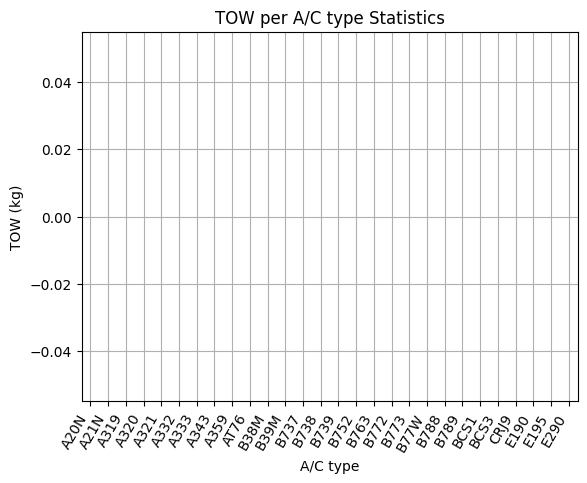

In [12]:
df[["aircraft_type", "tow"]].plot.box(by='aircraft_type')

plt.title("TOW per A/C type Statistics")
plt.xlabel("A/C type")
plt.ylabel("TOW (kg)")
plt.grid()
plt.xticks(rotation=60, ha='right')

plt.show()

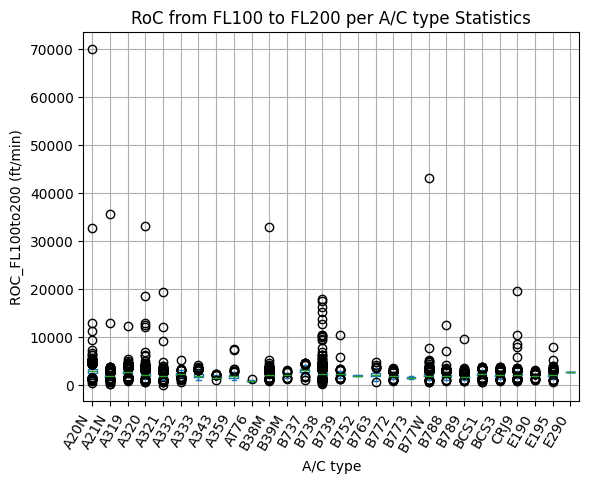

In [13]:
df[["aircraft_type", "ROC_FL100to200"]].plot.box(by='aircraft_type')

plt.title("RoC from FL100 to FL200 per A/C type Statistics")
plt.xlabel("A/C type")
plt.ylabel("ROC_FL100to200 (ft/min)")
plt.grid()
plt.xticks(rotation=60, ha='right')

plt.show()

<Axes: xlabel='tow', ylabel='ROC_FL100to200'>

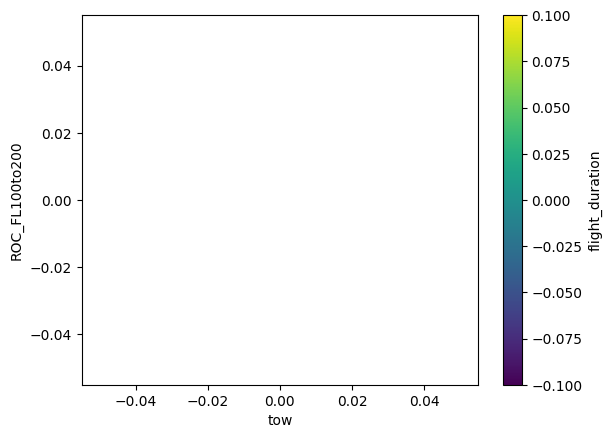

In [14]:
df.plot.scatter(x='tow',
                      y='ROC_FL100to200',
                      c='flight_duration',
                      colormap='viridis')

In [15]:
df_sel = df[df["ROC_FL100to200"]<5000]
df_sel = df_sel[df_sel["aircraft_type"] == 'A320']

<Axes: xlabel='tow', ylabel='ROC_FL100to200'>

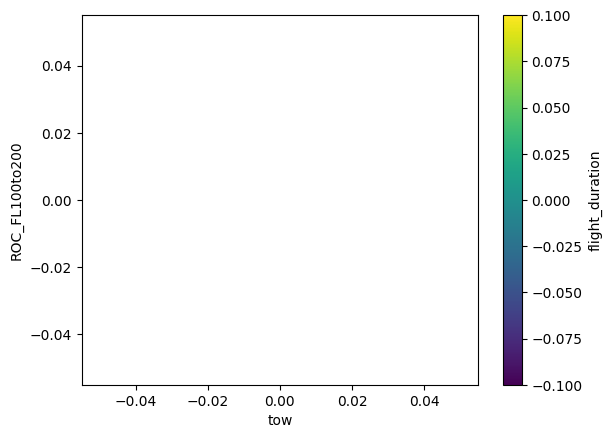

In [16]:
df_sel.plot.scatter(x='tow',
                      y='ROC_FL100to200',
                      c='flight_duration',
                      colormap='viridis')

In [17]:
df_sort = df.dropna(how='any').sort_values(by = "ROC_FL100to200", ascending=False)
df_sort

,flight_id,date,callsign,adep,name_adep,country_code_adep,ades,name_ades,country_code_ades,actual_offblock_time,...,Q_FL100,Q_FL200,Q_mFL100to200,TAS_FL100,TAS_FL200,TAS_mFL100to200,dHp_FL100,dHp_FL200,dHp_mFL100to200,cs_d_track


<Axes: xlabel='CL_FL100_alt', ylabel='CL_FL200_alt'>

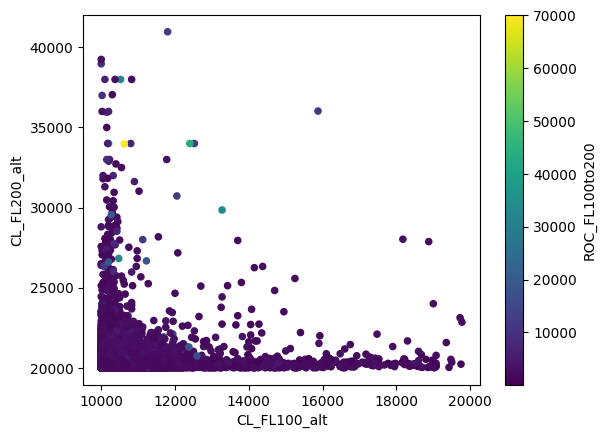

In [18]:
df.plot.scatter(x='CL_FL100_alt',
                      y='CL_FL200_alt',
                      c='ROC_FL100to200',
                      colormap='viridis')

In [19]:
df_parquet_sel['altitude'].max()

38000.0

<Axes: >

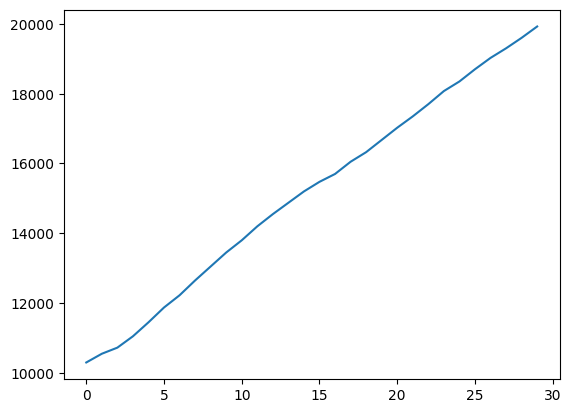

In [20]:
df_CL['altitude'].plot()

In [21]:
df_CL

,timestamp,flight_id,latitude,longitude,altitude,groundspeed,track,vertical_rate,icao24,u_component_of_wind,v_component_of_wind,temperature,specific_humidity,track_unwrapped,longi_wind,TAS,dTAS,dHp,Q,d_track
0,2022-12-31 09:56:10+00:00,258058138.0,44.728461,11.608128,10300.0,301.0,54.196656,2112.0,258058138.0,6.322261,-3.164117,272.184123,0.002822,54.196656,6.369039,294.630961,NaN,NaN,NaN,NaN
1,2022-12-31 09:56:20+00:00,258058138.0,44.736969,11.624712,10550.0,309.0,54.204041,1024.0,258058138.0,6.047381,-3.140074,271.726872,0.002744,54.204041,5.964552,303.035448,0.432364,7.620,142.130043,0.007385
2,2022-12-31 09:56:30+00:00,258058138.0,44.745438,11.641126,10725.0,317.0,54.251986,1344.0,258058138.0,5.824555,-3.113982,271.359061,0.002688,54.251986,5.652544,311.347456,0.427607,5.334,120.798840,0.047945
3,2022-12-31 09:56:40+00:00,258058138.0,44.754251,11.658370,11050.0,320.0,54.275150,2304.0,258058138.0,5.503884,-3.091289,270.821740,0.002588,54.275150,5.176919,314.823081,0.178802,9.906,126.103203,0.023164
4,2022-12-31 09:56:50+00:00,258058138.0,44.762878,11.675066,11450.0,322.0,54.234548,2624.0,258058138.0,5.095139,-3.082722,270.116210,0.002452,54.234548,4.534066,317.465934,0.135960,12.192,141.767485,-0.040601
5,2022-12-31 09:57:00+00:00,258058138.0,44.770844,11.690630,11875.0,323.0,54.194298,2432.0,258058138.0,4.742495,-3.093520,269.335171,0.002295,54.194298,3.958372,319.041628,0.081061,12.954,140.339774,-0.040251
6,2022-12-31 09:57:10+00:00,258058138.0,44.779110,11.706736,12225.0,324.0,54.297798,2432.0,258058138.0,4.639866,-3.161198,268.366412,0.002093,54.297798,3.738143,320.261857,0.062774,10.668,114.959796,0.103500
7,2022-12-31 09:57:20+00:00,258058138.0,44.787861,11.723752,12650.0,325.0,54.257549,2304.0,258058138.0,4.504392,-3.230473,267.469563,0.001947,54.257549,3.438538,321.561462,0.066857,12.954,138.095270,-0.040249
8,2022-12-31 09:57:30+00:00,258058138.0,44.797211,11.741965,13050.0,327.0,54.319947,2304.0,258058138.0,4.366346,-3.293375,266.691101,0.001768,54.319947,3.160373,323.839627,0.117199,12.192,139.087730,0.062398
9,2022-12-31 09:57:40+00:00,258058138.0,44.806994,11.761065,13450.0,330.0,54.240481,2112.0,258058138.0,4.217603,-3.347591,266.023895,0.001591,54.240481,2.850079,327.149921,0.170296,12.192,148.223608,-0.079466


In [22]:
idx_df_FL100

0

In [23]:
idx_df_FL200

0

In [24]:
df_parquet_sel.iloc[36:37]

,timestamp,flight_id,latitude,longitude,altitude,groundspeed,track,vertical_rate,icao24,u_component_of_wind,v_component_of_wind,temperature,specific_humidity,track_unwrapped
36,2022-12-31 11:41:50+00:00,258058370.0,41.92974,33.801099,38000.0,412.0,287.246045,-64.0,258058370.0,14.142831,4.375655,208.154196,0.000015,287.246045


In [25]:
(idx_df_FL200-idx_df_FL100) > 1

False